In [1]:
import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。


from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

In [2]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  2
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0
GPU 1: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [3]:
torch.cuda.set_device(0) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（激活函数为softmax）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #输出层的激活函数为tanh
        layer_list.append(('activation_%d' % (self.depth - 1), torch.nn.Softmax(dim=1)))  

        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict) #layers，长度为2*depth，包含了所有的线性变换和激活函数，奇数索引为线性变换(权重矩阵)，偶数索引为激活函数
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # # 新增方法，获取最后一个隐藏层的输出
    # def hidden_output(self, x):
    #     # 遍历每一层，直到最后一个隐藏层
    #     for i in range(self.depth - 1):
    #         # 获取当前层的线性变换
    #         x = self.layers[i*2](x)
    #         # 获取当前层的激活函数
    #         x = self.layers[i*2 + 1](x)
    #     # 返回最后一个隐藏层的输出
    #     return x

    # 新增方法，循环传递输入
    def hidden_forward(self, x, num_cycles):
        # 将输入传递到最后一个隐藏层，x为最后一个隐藏层的输出
        for i in range(self.depth - 1):
            x = self.layers[i*2](x)
            x = self.layers[i*2 + 1](x)
        
        # 将最后一个隐藏层的输出作为输入传递到第一个隐藏层中，重复num_cycles次
        for _ in range(num_cycles):
            for i in range(1, self.depth - 1): #最开始的x为最后一个隐藏层的输出，然后从第一个隐藏层开始传递
                x = self.layers[i*2](x)
                x = self.layers[i*2 + 1](x)
        hidden_output = x
        
        return hidden_output

In [5]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        mu_x, sigma_x = X_f.mean(0), X_f.std(0) #计算X_u的均值和标准差
        X_u = (X_u - mu_x) / sigma_x #对X_u进行标准化
        X_f = (X_f - mu_x) / sigma_x #对X_f进行标准化

        self.mu_x = torch.tensor(mu_x).float().to(device) #创建一个pytorch张量（数据来源于mu_x），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.sigma_x = torch.tensor(sigma_x).float().to(device) #创建一个pytorch张量（数据来源于sigma_x），并将其转换为浮点类型，最后将张量移动到指定的设备上

        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #初边界点数据
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        #初边界点真实数据
        self.u = torch.tensor(u).float().to(device)
        #配位点数据
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        # #测试点数据
        # self.X_star = torch.tensor(X_star).float().to(device)
        # #测试点真实数据
        # self.u_star = torch.tensor(u_star).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), eps = 1e-8) 


        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差
        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x):  
        u = self.dnn(x)  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x) #调用上面的net_u函数，计算神经网络的输出u
        u1 = u[:, 0:1] #取u的第一列，对应状态1
        u2 = u[:, 1:2] #取u的第二列，对应状态2
        u3 = u[:, 2:3] #取u的第三列，对应状态3

        u_x_1 = torch.autograd.grad(
            u1, x, #输入的张量，要计算u1关于x的导数
            grad_outputs=torch.ones_like(u1), #生成一个与u1形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u1的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_2 = torch.autograd.grad(
            u2, x, #输入的张量，要计算u2关于x的导数
            grad_outputs=torch.ones_like(u2), #生成一个与u2形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u2的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_3 = torch.autograd.grad(
            u3, x, #输入的张量，要计算u3关于x的导数
            grad_outputs=torch.ones_like(u3), #生成一个与u3形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u3的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度

        #归一化
        u_x_1 = u_x_1 / self.sigma_x
        u_x_2 = u_x_2 / self.sigma_x
        u_x_3 = u_x_3 / self.sigma_x
        
        #计算残差
        xx = x * self.sigma_x + self.mu_x
        residual_1 = u_x_1-(-2.572e-4*xx*u1)
        residual_2 = u_x_2-(1.12e-4*xx*u1-2.012e-4*xx*u2)
        residual_3 = u_x_3-(1.452e-4*xx*u1+2.012e-4*xx*u2)    

        loss_1 = torch.mean(residual_1 ** 2)
        loss_2 = torch.mean(residual_2 ** 2)
        loss_3 = torch.mean(residual_3 ** 2)

        loss_f = loss_1 + loss_2 + loss_3
        return loss_f, residual_1+residual_2+residual_3
    
      
    
    def train(self, nIter):


        #使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            u_pred = self.net_u(self.X_u) #调用之前定义的函数，传入初值得到神经网络的输出u

            loss_u = torch.mean((self.u - u_pred) ** 2) #计算初值的损失函数
            loss_f, _ = self.net_f(self.X_f) #计算残差的损失函数
            

            loss = loss_u + loss_f
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

            # # record the test error
            # self.dnn.eval() #将神经网络切换为评估模式
            # with torch.no_grad():
            #     u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u


            # error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            # self.test_error.append(error_test)

            # # 计算 MAE和MSE
            # mae = torch.mean(torch.abs(self.u_star - u_real_pred))
            # mse = torch.mean((self.u_star - u_real_pred) ** 2)
            # # 记录 MAE 和 MSE
            # self.test_error_mae.append(mae)
            # self.test_error_mse.append(mse)


  

    def predict(self, X):
        x = torch.tensor(X, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x) #调用之前定义的函数得到神经网络的输出u,以及f
        _, f = self.net_f(x)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    

    def hidden_predict(self, x, num_cycles):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval()
        hidden_output = self.dnn.hidden_forward(x, num_cycles)
        hidden_output = hidden_output.detach().cpu().numpy()
        return hidden_output

In [6]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [7]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]
#设置噪声水平为0
noise = 0.0        

#读取真实解(基于MCS方法得到的解)
MCS_solution_df = pd.read_csv('MCS_non_homo_300.csv')
MCS_solution_df.columns = ['time', 'state_0', 'state_1', 'state_2']

MCS_solution_df.drop(labels='time', inplace=True, axis = 1)


N_u = 1
N_f = 200

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [1, 50, 50, 3]

lb  = np.array([0.0])              # t的左边界
ub  = np.array([300.0])          # t的右边界

# Define the initial MSS state
X_u = np.array([[0]])
u = np.array([[1,0,0]])          # 初始真实状态
# X_f = np.linspace(lb, ub, N_f)     # 配位点位置，0~60000的5000个点

error_y = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值
chaoss = [] #创建一个空列表，用于存储chaos值
residuals = [] #创建一个空列表，用于存储residual值

i = 0 #初始化i为0

# # 创建文件夹
# model_dir = 'Adam+LBFGS+LHS(5000)'
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

for seed in seeds:
    set_seed(seed) #设置随机数种子

    X_f = lb + (ub - lb) * lhs(1, N_f) #生成N_f个随机点
    # X_f = np.linspace(lb, ub, N_f)     # 配位点位置，0~60000的5000个点
    nIter = 150000 #设置迭代次数为10000

    #创建PINN模型并输入各种参数     
    model = PhysicsInformedNN(X_u, u, X_f, layers, lb, ub)

    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型            
    model.train(nIter)
    #训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))

    #真实值
    mu, sigma = model.mu_x, model.sigma_x

    # up = 80000
    n_star = 300+1
    x_star = np.linspace(lb, ub, n_star)[1:] #N_star = x_star.shape[0] 
    y_pred, _ = model.predict(x_star)
    y_star = MCS_solution_df


    #计算误差（基于2范数）        
    error_y.append(np.linalg.norm(y_star-y_pred,2)/np.linalg.norm(y_star,2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(y_star - y_pred))
    mse = np.mean((y_star - y_pred) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)


    #计算混沌度
    y_chaos = model.hidden_predict(x_star, 100)
    # print(y_chaos)
    x_sss = x_star + np.random.normal(0, 0.001)
    y_chaos_sss = model.hidden_predict(x_sss, 100)
    chaos = np.linalg.norm(y_chaos - y_chaos_sss,axis=1).sum()
    chaoss.append(chaos)

    #计算残差

    _, residual = model.predict(x_star)
    residual = residual.flatten()
    residual = np.abs(residual)
    residual = residual.sum()
    residuals.append(residual)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error y : %e' % (np.linalg.norm(y_star-y_pred,2)/np.linalg.norm(y_star,2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE
    print('Chaos: %e' % chaos) #打印混沌度
    print('Residual: %e' % residual) #打印残差
    # # 保存模型到文件夹
    # model_path = os.path.join(model_dir, f'model_{i}_seed_{seed}.pkl')
    # with open(model_path, 'wb') as f:
    #     pickle.dump(model, f)


Adam:   0%|          | 0/150000 [00:00<?, ?it/s]

Adam:   0%|          | 1/150000 [00:00<6:23:54,  6.51it/s]

Adam:   0%|          | 41/150000 [00:00<12:51, 194.32it/s]

Adam:   0%|          | 89/150000 [00:00<08:05, 308.75it/s]

Adam:   0%|          | 130/150000 [00:00<07:16, 343.59it/s]

Adam:   0%|          | 174/150000 [00:00<06:40, 373.80it/s]

Adam:   0%|          | 214/150000 [00:00<06:54, 361.26it/s]

Adam:   0%|          | 256/150000 [00:00<06:36, 377.86it/s]

Adam:   0%|          | 299/150000 [00:00<06:23, 389.86it/s]

Adam:   0%|          | 339/150000 [00:01<07:04, 352.24it/s]

Adam:   0%|          | 376/150000 [00:01<06:59, 356.64it/s]

Adam:   0%|          | 413/150000 [00:01<07:23, 337.31it/s]

Adam:   0%|          | 459/150000 [00:01<06:44, 370.12it/s]

Adam:   0%|          | 497/150000 [00:01<06:54, 360.37it/s]

Adam:   0%|          | 534/150000 [00:01<07:05, 351.24it/s]

Adam:   0%|          | 570/150000 [00:01<07:30, 331.77it/s]

Adam:   0%|          | 629/150000 [00:01<06:12, 400.46it/s]

Adam:   0%|          | 672/150000 [00:01<06:08, 404.95it/s]

Adam:   0%|          | 719/150000 [00:02<05:56, 418.71it/s]

Adam:   1%|          | 762/150000 [00:02<06:38, 374.37it/s]

Adam:   1%|          | 801/150000 [00:02<07:03, 352.17it/s]

Adam:   1%|          | 838/150000 [00:02<07:05, 350.66it/s]

Adam:   1%|          | 891/150000 [00:02<06:15, 397.60it/s]

Adam:   1%|          | 932/150000 [00:02<06:17, 395.23it/s]

Adam:   1%|          | 973/150000 [00:02<06:56, 358.02it/s]

Adam:   1%|          | 1010/150000 [00:02<07:20, 337.90it/s]

Adam:   1%|          | 1045/150000 [00:02<07:34, 327.67it/s]

Adam:   1%|          | 1088/150000 [00:03<07:02, 352.72it/s]

Adam:   1%|          | 1140/150000 [00:03<06:13, 398.15it/s]

Adam:   1%|          | 1209/150000 [00:03<05:11, 477.15it/s]

Adam:   1%|          | 1267/150000 [00:03<04:56, 501.58it/s]

Adam:   1%|          | 1318/150000 [00:03<05:03, 490.18it/s]

Adam:   1%|          | 1368/150000 [00:03<05:35, 443.35it/s]

Adam:   1%|          | 1414/150000 [00:03<05:59, 412.83it/s]

Adam:   1%|          | 1457/150000 [00:03<06:18, 391.99it/s]

Adam:   1%|          | 1505/150000 [00:03<05:58, 414.49it/s]

Adam:   1%|          | 1565/150000 [00:04<05:20, 463.09it/s]

Adam:   1%|          | 1621/150000 [00:04<05:04, 488.03it/s]

Adam:   1%|          | 1671/150000 [00:04<05:04, 486.53it/s]

Adam:   1%|          | 1729/150000 [00:04<04:49, 511.98it/s]

Adam:   1%|          | 1796/150000 [00:04<04:26, 555.59it/s]

Adam:   1%|          | 1853/150000 [00:04<04:51, 508.69it/s]

Adam:   1%|▏         | 1905/150000 [00:04<05:14, 471.44it/s]

Adam:   1%|▏         | 1966/150000 [00:04<04:51, 508.15it/s]

Adam:   1%|▏         | 2022/150000 [00:04<04:43, 522.21it/s]

Adam:   1%|▏         | 2076/150000 [00:05<05:20, 461.84it/s]

Adam:   1%|▏         | 2126/150000 [00:05<05:13, 471.43it/s]

Adam:   1%|▏         | 2175/150000 [00:05<05:17, 465.93it/s]

Adam:   1%|▏         | 2223/150000 [00:05<05:56, 414.03it/s]

Adam:   2%|▏         | 2271/150000 [00:05<05:44, 429.44it/s]

Adam:   2%|▏         | 2324/150000 [00:05<05:26, 452.90it/s]

Adam:   2%|▏         | 2373/150000 [00:05<05:19, 461.40it/s]

Adam:   2%|▏         | 2421/150000 [00:05<05:25, 453.66it/s]

Adam:   2%|▏         | 2467/150000 [00:06<06:42, 366.50it/s]

Adam:   2%|▏         | 2507/150000 [00:06<06:39, 368.94it/s]

Adam:   2%|▏         | 2547/150000 [00:06<06:33, 374.64it/s]

Adam:   2%|▏         | 2587/150000 [00:06<06:40, 367.97it/s]

Adam:   2%|▏         | 2637/150000 [00:06<06:09, 399.01it/s]

Adam:   2%|▏         | 2685/150000 [00:06<05:51, 419.48it/s]

Adam:   2%|▏         | 2732/150000 [00:06<05:39, 433.60it/s]

Adam:   2%|▏         | 2790/150000 [00:06<05:10, 473.91it/s]

Adam:   2%|▏         | 2839/150000 [00:06<05:47, 423.37it/s]

Adam:   2%|▏         | 2900/150000 [00:07<05:11, 472.60it/s]

Adam:   2%|▏         | 2949/150000 [00:07<05:51, 418.70it/s]

Adam:   2%|▏         | 2993/150000 [00:07<06:46, 361.48it/s]

Adam:   2%|▏         | 3032/150000 [00:07<07:10, 341.25it/s]

Adam:   2%|▏         | 3068/150000 [00:07<07:35, 322.30it/s]

Adam:   2%|▏         | 3102/150000 [00:07<08:15, 296.31it/s]

Adam:   2%|▏         | 3134/150000 [00:07<08:10, 299.19it/s]

Adam:   2%|▏         | 3165/150000 [00:07<08:23, 291.38it/s]

Adam:   2%|▏         | 3201/150000 [00:08<07:56, 307.80it/s]

Adam:   2%|▏         | 3233/150000 [00:08<08:23, 291.59it/s]

Adam:   2%|▏         | 3290/150000 [00:08<06:42, 364.25it/s]

Adam:   2%|▏         | 3330/150000 [00:08<06:33, 372.70it/s]

Adam:   2%|▏         | 3372/150000 [00:08<06:20, 385.24it/s]

Adam:   2%|▏         | 3412/150000 [00:08<06:59, 349.41it/s]

Adam:   2%|▏         | 3466/150000 [00:08<06:05, 400.48it/s]

Adam:   2%|▏         | 3534/150000 [00:08<05:06, 477.65it/s]

Adam:   2%|▏         | 3584/150000 [00:09<06:05, 400.08it/s]

Adam:   2%|▏         | 3628/150000 [00:09<06:29, 376.06it/s]

Adam:   2%|▏         | 3669/150000 [00:09<06:21, 383.25it/s]

Adam:   2%|▏         | 3716/150000 [00:09<06:01, 404.92it/s]

Adam:   3%|▎         | 3782/150000 [00:09<05:10, 470.44it/s]

Adam:   3%|▎         | 3831/150000 [00:09<05:23, 451.71it/s]

Adam:   3%|▎         | 3886/150000 [00:09<05:07, 475.69it/s]

Adam:   3%|▎         | 3935/150000 [00:09<05:42, 426.59it/s]

Adam:   3%|▎         | 3980/150000 [00:09<05:51, 415.79it/s]

Adam:   3%|▎         | 4023/150000 [00:10<06:11, 392.58it/s]

Adam:   3%|▎         | 4064/150000 [00:10<06:24, 379.91it/s]

Adam:   3%|▎         | 4105/150000 [00:10<06:19, 384.21it/s]

Adam:   3%|▎         | 4154/150000 [00:10<05:56, 408.57it/s]

Adam:   3%|▎         | 4196/150000 [00:10<06:17, 386.65it/s]

Adam:   3%|▎         | 4245/150000 [00:10<05:54, 410.87it/s]

Adam:   3%|▎         | 4287/150000 [00:10<06:35, 368.41it/s]

Adam:   3%|▎         | 4325/150000 [00:10<07:13, 335.73it/s]

Adam:   3%|▎         | 4375/150000 [00:11<06:26, 376.68it/s]

Adam:   3%|▎         | 4415/150000 [00:11<06:22, 380.74it/s]

Adam:   3%|▎         | 4476/150000 [00:11<05:28, 442.62it/s]

Adam:   3%|▎         | 4522/150000 [00:11<05:58, 405.98it/s]

Adam:   3%|▎         | 4565/150000 [00:11<06:08, 395.16it/s]

Adam:   3%|▎         | 4606/150000 [00:11<06:48, 355.95it/s]

Adam:   3%|▎         | 4649/150000 [00:11<06:28, 374.39it/s]

Adam:   3%|▎         | 4706/150000 [00:11<05:41, 425.04it/s]

Adam:   3%|▎         | 4750/150000 [00:11<05:49, 415.65it/s]

Adam:   3%|▎         | 4793/150000 [00:12<06:08, 394.52it/s]

Adam:   3%|▎         | 4837/150000 [00:12<05:59, 403.31it/s]

Adam:   3%|▎         | 4878/150000 [00:12<06:19, 382.19it/s]

Adam:   3%|▎         | 4917/150000 [00:12<07:16, 332.69it/s]

Adam:   3%|▎         | 4952/150000 [00:12<08:20, 290.06it/s]

Adam:   3%|▎         | 4990/150000 [00:12<07:46, 311.06it/s]

Adam:   3%|▎         | 5037/150000 [00:12<06:54, 349.64it/s]

Adam:   3%|▎         | 5097/150000 [00:12<05:49, 414.01it/s]

Adam:   3%|▎         | 5141/150000 [00:13<06:45, 357.26it/s]

Adam:   3%|▎         | 5180/150000 [00:13<06:56, 347.75it/s]

Adam:   3%|▎         | 5235/150000 [00:13<06:03, 397.81it/s]

Adam:   4%|▎         | 5277/150000 [00:13<06:39, 362.43it/s]

Adam:   4%|▎         | 5316/150000 [00:13<07:04, 340.59it/s]

Adam:   4%|▎         | 5352/150000 [00:13<07:22, 326.83it/s]

Adam:   4%|▎         | 5389/150000 [00:13<07:08, 337.14it/s]

Adam:   4%|▎         | 5428/150000 [00:13<06:52, 350.41it/s]

Adam:   4%|▎         | 5471/150000 [00:13<06:30, 370.28it/s]

Adam:   4%|▎         | 5518/150000 [00:14<06:04, 396.62it/s]

Adam:   4%|▎         | 5569/150000 [00:14<05:37, 428.43it/s]

Adam:   4%|▎         | 5613/150000 [00:14<06:38, 362.68it/s]

Adam:   4%|▍         | 5652/150000 [00:14<06:41, 359.76it/s]

Adam:   4%|▍         | 5710/150000 [00:14<05:46, 416.37it/s]

Adam:   4%|▍         | 5754/150000 [00:14<05:52, 409.39it/s]

Adam:   4%|▍         | 5800/150000 [00:14<05:43, 419.57it/s]

Adam:   4%|▍         | 5843/150000 [00:14<06:02, 397.42it/s]

Adam:   4%|▍         | 5884/150000 [00:15<06:20, 379.06it/s]

Adam:   4%|▍         | 5938/150000 [00:15<05:41, 421.39it/s]

Adam:   4%|▍         | 5984/150000 [00:15<05:33, 431.83it/s]

Adam:   4%|▍         | 6029/150000 [00:15<05:30, 435.47it/s]

Adam:   4%|▍         | 6074/150000 [00:15<06:23, 375.29it/s]

Adam:   4%|▍         | 6114/150000 [00:15<06:33, 365.76it/s]

Adam:   4%|▍         | 6156/150000 [00:15<06:20, 378.36it/s]

Adam:   4%|▍         | 6204/150000 [00:15<05:54, 405.87it/s]

Adam:   4%|▍         | 6246/150000 [00:15<06:44, 355.79it/s]

Adam:   4%|▍         | 6301/150000 [00:16<05:54, 405.22it/s]

Adam:   4%|▍         | 6363/150000 [00:16<05:10, 462.28it/s]

Adam:   4%|▍         | 6412/150000 [00:16<05:33, 430.36it/s]

Adam:   4%|▍         | 6457/150000 [00:16<06:26, 371.24it/s]

Adam:   4%|▍         | 6513/150000 [00:16<05:44, 416.16it/s]

Adam:   4%|▍         | 6558/150000 [00:16<05:53, 406.09it/s]

Adam:   4%|▍         | 6601/150000 [00:16<06:01, 396.99it/s]

Adam:   4%|▍         | 6642/150000 [00:16<06:05, 391.86it/s]

Adam:   4%|▍         | 6685/150000 [00:17<05:58, 399.86it/s]

Adam:   4%|▍         | 6728/150000 [00:17<05:52, 406.33it/s]

Adam:   5%|▍         | 6770/150000 [00:17<05:53, 405.44it/s]

Adam:   5%|▍         | 6811/150000 [00:17<06:16, 380.22it/s]

Adam:   5%|▍         | 6856/150000 [00:17<06:00, 397.05it/s]

Adam:   5%|▍         | 6897/150000 [00:17<06:20, 375.66it/s]

Adam:   5%|▍         | 6942/150000 [00:17<06:02, 394.28it/s]

Adam:   5%|▍         | 6982/150000 [00:17<06:39, 358.30it/s]

Adam:   5%|▍         | 7030/150000 [00:17<06:06, 389.69it/s]

Adam:   5%|▍         | 7070/150000 [00:18<06:12, 383.47it/s]

Adam:   5%|▍         | 7110/150000 [00:18<06:34, 361.81it/s]

Adam:   5%|▍         | 7147/150000 [00:18<06:59, 340.81it/s]

Adam:   5%|▍         | 7182/150000 [00:18<07:08, 332.99it/s]

Adam:   5%|▍         | 7238/150000 [00:18<06:03, 392.74it/s]

Adam:   5%|▍         | 7289/150000 [00:18<05:37, 423.43it/s]

Adam:   5%|▍         | 7333/150000 [00:18<06:33, 362.85it/s]

Adam:   5%|▍         | 7372/150000 [00:18<06:39, 356.86it/s]

Adam:   5%|▍         | 7410/150000 [00:18<07:11, 330.71it/s]

Adam:   5%|▍         | 7451/150000 [00:19<06:51, 346.51it/s]

Adam:   5%|▍         | 7487/150000 [00:19<07:00, 339.22it/s]

Adam:   5%|▌         | 7522/150000 [00:19<07:33, 314.02it/s]

Adam:   5%|▌         | 7555/150000 [00:19<08:10, 290.56it/s]

Adam:   5%|▌         | 7585/150000 [00:19<08:22, 283.43it/s]

Adam:   5%|▌         | 7642/150000 [00:19<06:38, 357.33it/s]

Adam:   5%|▌         | 7683/150000 [00:19<06:23, 371.05it/s]

Adam:   5%|▌         | 7729/150000 [00:19<06:02, 392.63it/s]

Adam:   5%|▌         | 7770/150000 [00:20<07:22, 321.30it/s]

Adam:   5%|▌         | 7805/150000 [00:20<07:20, 322.83it/s]

Adam:   5%|▌         | 7840/150000 [00:20<07:57, 297.99it/s]

Adam:   5%|▌         | 7872/150000 [00:20<07:56, 298.37it/s]

Adam:   5%|▌         | 7903/150000 [00:20<08:08, 291.15it/s]

Adam:   5%|▌         | 7933/150000 [00:20<08:42, 272.11it/s]

Adam:   5%|▌         | 7961/150000 [00:20<08:44, 270.95it/s]

Adam:   5%|▌         | 7989/150000 [00:20<09:15, 255.56it/s]

Adam:   5%|▌         | 8028/150000 [00:21<08:08, 290.80it/s]

Adam:   5%|▌         | 8068/150000 [00:21<07:24, 319.32it/s]

Adam:   5%|▌         | 8101/150000 [00:21<08:04, 292.83it/s]

Adam:   5%|▌         | 8132/150000 [00:21<07:57, 297.23it/s]

Adam:   5%|▌         | 8163/150000 [00:21<07:58, 296.52it/s]

Adam:   5%|▌         | 8194/150000 [00:21<08:28, 278.80it/s]

Adam:   5%|▌         | 8232/150000 [00:21<07:46, 303.94it/s]

Adam:   6%|▌         | 8270/150000 [00:21<07:17, 323.76it/s]

Adam:   6%|▌         | 8303/150000 [00:21<07:34, 312.03it/s]

Adam:   6%|▌         | 8335/150000 [00:22<08:15, 286.06it/s]

Adam:   6%|▌         | 8365/150000 [00:22<08:26, 279.76it/s]

Adam:   6%|▌         | 8394/150000 [00:22<09:03, 260.45it/s]

Adam:   6%|▌         | 8421/150000 [00:22<09:25, 250.21it/s]

Adam:   6%|▌         | 8451/150000 [00:22<08:59, 262.16it/s]

Adam:   6%|▌         | 8499/150000 [00:22<07:20, 321.04it/s]

Adam:   6%|▌         | 8532/150000 [00:22<07:46, 303.45it/s]

Adam:   6%|▌         | 8564/150000 [00:22<08:02, 292.93it/s]

Adam:   6%|▌         | 8594/150000 [00:22<08:43, 269.97it/s]

Adam:   6%|▌         | 8633/150000 [00:23<07:50, 300.42it/s]

Adam:   6%|▌         | 8679/150000 [00:23<06:53, 341.98it/s]

Adam:   6%|▌         | 8715/150000 [00:23<07:22, 318.96it/s]

Adam:   6%|▌         | 8756/150000 [00:23<06:52, 342.30it/s]

Adam:   6%|▌         | 8792/150000 [00:23<07:00, 336.08it/s]

Adam:   6%|▌         | 8827/150000 [00:23<07:06, 331.24it/s]

Adam:   6%|▌         | 8865/150000 [00:23<06:49, 344.43it/s]

Adam:   6%|▌         | 8900/150000 [00:23<07:13, 325.79it/s]

Adam:   6%|▌         | 8934/150000 [00:23<07:46, 302.55it/s]

Adam:   6%|▌         | 8965/150000 [00:24<08:12, 286.54it/s]

Adam:   6%|▌         | 8995/150000 [00:24<08:53, 264.34it/s]

Adam:   6%|▌         | 9022/150000 [00:24<08:52, 264.55it/s]

Adam:   6%|▌         | 9049/150000 [00:24<08:59, 261.17it/s]

Adam:   6%|▌         | 9083/150000 [00:24<08:20, 281.78it/s]

Adam:   6%|▌         | 9112/150000 [00:24<08:39, 271.29it/s]

Adam:   6%|▌         | 9141/150000 [00:24<08:31, 275.16it/s]

Adam:   6%|▌         | 9169/150000 [00:24<08:45, 267.92it/s]

Adam:   6%|▌         | 9196/150000 [00:24<08:47, 267.15it/s]

Adam:   6%|▌         | 9231/150000 [00:25<08:04, 290.44it/s]

Adam:   6%|▌         | 9272/150000 [00:25<07:16, 322.18it/s]

Adam:   6%|▌         | 9305/150000 [00:25<08:01, 292.36it/s]

Adam:   6%|▌         | 9335/150000 [00:25<08:37, 271.94it/s]

Adam:   6%|▌         | 9363/150000 [00:25<08:48, 266.28it/s]

Adam:   6%|▋         | 9391/150000 [00:25<08:49, 265.52it/s]

Adam:   6%|▋         | 9421/150000 [00:25<08:33, 273.98it/s]

Adam:   6%|▋         | 9458/150000 [00:25<07:47, 300.69it/s]

Adam:   6%|▋         | 9489/150000 [00:26<08:03, 290.61it/s]

Adam:   6%|▋         | 9519/150000 [00:26<08:42, 268.79it/s]

Adam:   6%|▋         | 9553/150000 [00:26<08:09, 287.08it/s]

Adam:   6%|▋         | 9583/150000 [00:26<08:37, 271.49it/s]

Adam:   6%|▋         | 9611/150000 [00:26<08:52, 263.47it/s]

Adam:   6%|▋         | 9647/150000 [00:26<08:09, 286.51it/s]

Adam:   6%|▋         | 9677/150000 [00:26<08:20, 280.38it/s]

Adam:   6%|▋         | 9706/150000 [00:26<08:27, 276.71it/s]

Adam:   7%|▋         | 9751/150000 [00:26<07:14, 322.51it/s]

Adam:   7%|▋         | 9784/150000 [00:27<07:42, 302.92it/s]

Adam:   7%|▋         | 9815/150000 [00:27<08:13, 284.23it/s]

Adam:   7%|▋         | 9844/150000 [00:27<08:41, 268.52it/s]

Adam:   7%|▋         | 9872/150000 [00:27<08:55, 261.76it/s]

Adam:   7%|▋         | 9899/150000 [00:27<09:00, 259.03it/s]

Adam:   7%|▋         | 9931/150000 [00:27<08:29, 274.85it/s]

Adam:   7%|▋         | 9960/150000 [00:27<08:23, 278.32it/s]

Adam:   7%|▋         | 9989/150000 [00:27<08:46, 265.68it/s]

Adam:   7%|▋         | 10021/150000 [00:27<08:21, 279.06it/s]

Adam:   7%|▋         | 10050/150000 [00:28<08:46, 265.87it/s]

Adam:   7%|▋         | 10077/150000 [00:28<09:08, 255.19it/s]

Adam:   7%|▋         | 10119/150000 [00:28<07:46, 300.12it/s]

Adam:   7%|▋         | 10159/150000 [00:28<07:10, 325.13it/s]

Adam:   7%|▋         | 10193/150000 [00:28<07:11, 324.36it/s]

Adam:   7%|▋         | 10226/150000 [00:28<07:26, 312.98it/s]

Adam:   7%|▋         | 10258/150000 [00:28<08:15, 281.93it/s]

Adam:   7%|▋         | 10287/150000 [00:28<08:39, 269.01it/s]

Adam:   7%|▋         | 10315/150000 [00:28<08:59, 258.84it/s]

Adam:   7%|▋         | 10355/150000 [00:29<07:55, 293.84it/s]

Adam:   7%|▋         | 10390/150000 [00:29<07:33, 307.93it/s]

Adam:   7%|▋         | 10427/150000 [00:29<07:09, 324.94it/s]

Adam:   7%|▋         | 10468/150000 [00:29<06:40, 348.46it/s]

Adam:   7%|▋         | 10504/150000 [00:29<06:46, 343.04it/s]

Adam:   7%|▋         | 10539/150000 [00:29<06:50, 339.51it/s]

Adam:   7%|▋         | 10574/150000 [00:29<07:37, 304.92it/s]

Adam:   7%|▋         | 10606/150000 [00:29<07:56, 292.53it/s]

Adam:   7%|▋         | 10636/150000 [00:29<08:37, 269.44it/s]

Adam:   7%|▋         | 10687/150000 [00:30<07:01, 330.70it/s]

Adam:   7%|▋         | 10727/150000 [00:30<06:39, 348.99it/s]

Adam:   7%|▋         | 10764/150000 [00:30<07:12, 322.00it/s]

Adam:   7%|▋         | 10798/150000 [00:30<08:02, 288.54it/s]

Adam:   7%|▋         | 10832/150000 [00:30<07:44, 299.56it/s]

Adam:   7%|▋         | 10881/150000 [00:30<06:38, 349.19it/s]

Adam:   7%|▋         | 10942/150000 [00:30<05:31, 419.48it/s]

Adam:   7%|▋         | 11003/150000 [00:30<04:54, 471.86it/s]

Adam:   7%|▋         | 11052/150000 [00:31<05:52, 393.88it/s]

Adam:   7%|▋         | 11095/150000 [00:31<06:02, 383.39it/s]

Adam:   7%|▋         | 11136/150000 [00:31<07:04, 327.10it/s]

Adam:   7%|▋         | 11172/150000 [00:31<07:27, 310.36it/s]

Adam:   7%|▋         | 11205/150000 [00:31<07:38, 302.76it/s]

Adam:   7%|▋         | 11241/150000 [00:31<07:19, 315.85it/s]

Adam:   8%|▊         | 11278/150000 [00:31<07:01, 328.98it/s]

Adam:   8%|▊         | 11312/150000 [00:31<07:30, 307.55it/s]

Adam:   8%|▊         | 11344/150000 [00:32<07:39, 301.71it/s]

Adam:   8%|▊         | 11375/150000 [00:32<07:44, 298.18it/s]

Adam:   8%|▊         | 11424/150000 [00:32<06:36, 349.30it/s]

Adam:   8%|▊         | 11460/150000 [00:32<07:07, 324.12it/s]

Adam:   8%|▊         | 11494/150000 [00:32<07:15, 318.24it/s]

Adam:   8%|▊         | 11540/150000 [00:32<06:28, 356.39it/s]

Adam:   8%|▊         | 11582/150000 [00:32<06:11, 372.37it/s]

Adam:   8%|▊         | 11620/150000 [00:32<07:26, 310.20it/s]

Adam:   8%|▊         | 11654/150000 [00:32<07:31, 306.45it/s]

Adam:   8%|▊         | 11697/150000 [00:33<06:49, 337.42it/s]

Adam:   8%|▊         | 11733/150000 [00:33<07:25, 310.29it/s]

Adam:   8%|▊         | 11771/150000 [00:33<07:03, 326.33it/s]

Adam:   8%|▊         | 11807/150000 [00:33<06:53, 333.82it/s]

Adam:   8%|▊         | 11842/150000 [00:33<07:37, 301.81it/s]

Adam:   8%|▊         | 11892/150000 [00:33<06:32, 351.73it/s]

Adam:   8%|▊         | 11929/150000 [00:33<07:25, 309.77it/s]

Adam:   8%|▊         | 11962/150000 [00:33<07:36, 302.19it/s]

Adam:   8%|▊         | 11994/150000 [00:34<07:57, 288.94it/s]

Adam:   8%|▊         | 12027/150000 [00:34<07:43, 297.75it/s]

Adam:   8%|▊         | 12077/150000 [00:34<06:33, 350.31it/s]

Adam:   8%|▊         | 12116/150000 [00:34<06:25, 358.06it/s]

Adam:   8%|▊         | 12153/150000 [00:34<06:35, 348.43it/s]

Adam:   8%|▊         | 12189/150000 [00:34<06:57, 329.85it/s]

Adam:   8%|▊         | 12233/150000 [00:34<06:23, 359.49it/s]

Adam:   8%|▊         | 12270/150000 [00:34<07:11, 319.35it/s]

Adam:   8%|▊         | 12304/150000 [00:34<07:30, 305.49it/s]

Adam:   8%|▊         | 12340/150000 [00:35<07:13, 317.65it/s]

Adam:   8%|▊         | 12373/150000 [00:35<07:19, 313.09it/s]

Adam:   8%|▊         | 12405/150000 [00:35<07:35, 302.05it/s]

Adam:   8%|▊         | 12438/150000 [00:35<07:24, 309.43it/s]

Adam:   8%|▊         | 12470/150000 [00:35<07:42, 297.07it/s]

Adam:   8%|▊         | 12500/150000 [00:35<07:57, 287.83it/s]

Adam:   8%|▊         | 12554/150000 [00:35<06:26, 355.86it/s]

Adam:   8%|▊         | 12591/150000 [00:35<06:26, 355.27it/s]

Adam:   8%|▊         | 12632/150000 [00:35<06:12, 368.61it/s]

Adam:   8%|▊         | 12670/150000 [00:36<06:30, 351.71it/s]

Adam:   8%|▊         | 12706/150000 [00:36<07:07, 321.11it/s]

Adam:   9%|▊         | 12765/150000 [00:36<05:50, 391.31it/s]

Adam:   9%|▊         | 12806/150000 [00:36<06:31, 350.22it/s]

Adam:   9%|▊         | 12843/150000 [00:36<07:16, 314.29it/s]

Adam:   9%|▊         | 12876/150000 [00:36<07:54, 288.95it/s]

Adam:   9%|▊         | 12911/150000 [00:36<07:31, 303.58it/s]

Adam:   9%|▊         | 12949/150000 [00:36<07:10, 318.48it/s]

Adam:   9%|▊         | 13007/150000 [00:37<05:54, 386.92it/s]

Adam:   9%|▊         | 13048/150000 [00:37<06:33, 347.80it/s]

Adam:   9%|▊         | 13085/150000 [00:37<06:38, 343.70it/s]

Adam:   9%|▊         | 13121/150000 [00:37<06:45, 337.33it/s]

Adam:   9%|▉         | 13158/150000 [00:37<06:35, 346.00it/s]

Adam:   9%|▉         | 13204/150000 [00:37<06:02, 377.11it/s]

Adam:   9%|▉         | 13243/150000 [00:37<06:54, 329.63it/s]

Adam:   9%|▉         | 13278/150000 [00:37<06:54, 329.71it/s]

Adam:   9%|▉         | 13313/150000 [00:38<07:11, 316.96it/s]

Adam:   9%|▉         | 13361/150000 [00:38<06:21, 358.19it/s]

Adam:   9%|▉         | 13403/150000 [00:38<06:06, 372.84it/s]

Adam:   9%|▉         | 13442/150000 [00:38<06:11, 367.13it/s]

Adam:   9%|▉         | 13493/150000 [00:38<05:35, 406.60it/s]

Adam:   9%|▉         | 13535/150000 [00:38<06:38, 342.09it/s]

Adam:   9%|▉         | 13572/150000 [00:38<06:45, 336.71it/s]

Adam:   9%|▉         | 13608/150000 [00:38<07:01, 323.66it/s]

Adam:   9%|▉         | 13659/150000 [00:38<06:08, 369.83it/s]

Adam:   9%|▉         | 13699/150000 [00:39<06:04, 373.55it/s]

Adam:   9%|▉         | 13738/150000 [00:39<06:52, 329.97it/s]

Adam:   9%|▉         | 13773/150000 [00:39<06:50, 331.96it/s]

Adam:   9%|▉         | 13822/150000 [00:39<06:06, 371.91it/s]

Adam:   9%|▉         | 13861/150000 [00:39<06:59, 324.16it/s]

Adam:   9%|▉         | 13896/150000 [00:39<07:28, 303.16it/s]

Adam:   9%|▉         | 13928/150000 [00:39<08:09, 277.88it/s]

Adam:   9%|▉         | 13960/150000 [00:39<07:55, 286.19it/s]

Adam:   9%|▉         | 13997/150000 [00:40<07:25, 305.27it/s]

Adam:   9%|▉         | 14029/150000 [00:40<08:01, 282.12it/s]

Adam:   9%|▉         | 14064/150000 [00:40<07:34, 298.92it/s]

Adam:   9%|▉         | 14095/150000 [00:40<07:32, 300.22it/s]

Adam:   9%|▉         | 14137/150000 [00:40<06:49, 332.15it/s]

Adam:   9%|▉         | 14171/150000 [00:40<07:18, 309.59it/s]

Adam:   9%|▉         | 14203/150000 [00:40<07:28, 302.68it/s]

Adam:   9%|▉         | 14245/150000 [00:40<06:46, 333.74it/s]

Adam:  10%|▉         | 14279/150000 [00:40<07:04, 319.65it/s]

Adam:  10%|▉         | 14313/150000 [00:41<06:58, 324.05it/s]

Adam:  10%|▉         | 14346/150000 [00:41<07:23, 306.00it/s]

Adam:  10%|▉         | 14378/150000 [00:41<07:44, 291.71it/s]

Adam:  10%|▉         | 14430/150000 [00:41<06:24, 352.16it/s]

Adam:  10%|▉         | 14467/150000 [00:41<06:55, 326.20it/s]

Adam:  10%|▉         | 14501/150000 [00:41<07:07, 317.11it/s]

Adam:  10%|▉         | 14534/150000 [00:41<07:08, 315.87it/s]

Adam:  10%|▉         | 14589/150000 [00:41<05:56, 379.67it/s]

Adam:  10%|▉         | 14644/150000 [00:41<05:17, 425.72it/s]

Adam:  10%|▉         | 14688/150000 [00:42<05:40, 397.19it/s]

Adam:  10%|▉         | 14729/150000 [00:42<06:04, 370.65it/s]

Adam:  10%|▉         | 14767/150000 [00:42<06:19, 356.03it/s]

Adam:  10%|▉         | 14804/150000 [00:42<06:55, 325.31it/s]

Adam:  10%|▉         | 14838/150000 [00:42<07:23, 305.07it/s]

Adam:  10%|▉         | 14870/150000 [00:42<07:17, 308.80it/s]

Adam:  10%|▉         | 14905/150000 [00:42<07:06, 316.94it/s]

Adam:  10%|▉         | 14938/150000 [00:42<07:33, 297.68it/s]

Adam:  10%|▉         | 14969/150000 [00:43<07:38, 294.24it/s]

Adam:  10%|█         | 15002/150000 [00:43<07:24, 303.58it/s]

Adam:  10%|█         | 15033/150000 [00:43<08:00, 281.03it/s]

Adam:  10%|█         | 15062/150000 [00:43<08:19, 269.95it/s]

Adam:  10%|█         | 15098/150000 [00:43<07:39, 293.57it/s]

Adam:  10%|█         | 15146/150000 [00:43<06:31, 344.28it/s]

Adam:  10%|█         | 15204/150000 [00:43<05:29, 409.26it/s]

Adam:  10%|█         | 15246/150000 [00:43<06:26, 348.53it/s]

Adam:  10%|█         | 15283/150000 [00:43<06:33, 342.42it/s]

Adam:  10%|█         | 15324/150000 [00:44<06:16, 357.91it/s]

Adam:  10%|█         | 15361/150000 [00:44<07:04, 316.98it/s]

Adam:  10%|█         | 15395/150000 [00:44<07:23, 303.78it/s]

Adam:  10%|█         | 15427/150000 [00:44<07:44, 289.66it/s]

Adam:  10%|█         | 15457/150000 [00:44<07:51, 285.62it/s]

Adam:  10%|█         | 15488/150000 [00:44<07:44, 289.88it/s]

Adam:  10%|█         | 15528/150000 [00:44<07:05, 316.32it/s]

Adam:  10%|█         | 15561/150000 [00:44<07:50, 285.69it/s]

Adam:  10%|█         | 15591/150000 [00:45<08:16, 270.53it/s]

Adam:  10%|█         | 15619/150000 [00:45<08:36, 260.29it/s]

Adam:  10%|█         | 15646/150000 [00:45<08:44, 256.35it/s]

Adam:  10%|█         | 15672/150000 [00:45<08:42, 257.23it/s]

Adam:  10%|█         | 15712/150000 [00:45<07:35, 294.76it/s]

Adam:  10%|█         | 15742/150000 [00:45<07:40, 291.71it/s]

Adam:  11%|█         | 15777/150000 [00:45<07:17, 307.02it/s]

Adam:  11%|█         | 15815/150000 [00:45<06:49, 327.71it/s]

Adam:  11%|█         | 15857/150000 [00:45<06:18, 353.99it/s]

Adam:  11%|█         | 15893/150000 [00:46<06:27, 346.49it/s]

Adam:  11%|█         | 15939/150000 [00:46<05:54, 378.66it/s]

Adam:  11%|█         | 15978/150000 [00:46<06:01, 370.51it/s]

Adam:  11%|█         | 16016/150000 [00:46<06:23, 349.09it/s]

Adam:  11%|█         | 16052/150000 [00:46<06:47, 328.82it/s]

Adam:  11%|█         | 16089/150000 [00:46<06:35, 338.60it/s]

Adam:  11%|█         | 16124/150000 [00:46<06:52, 324.79it/s]

Adam:  11%|█         | 16163/150000 [00:46<06:32, 340.77it/s]

Adam:  11%|█         | 16198/150000 [00:46<06:50, 325.70it/s]

Adam:  11%|█         | 16231/150000 [00:47<07:41, 289.70it/s]

Adam:  11%|█         | 16261/150000 [00:47<08:15, 269.69it/s]

Adam:  11%|█         | 16310/150000 [00:47<06:54, 322.87it/s]

Adam:  11%|█         | 16344/150000 [00:47<07:08, 311.96it/s]

Adam:  11%|█         | 16378/150000 [00:47<06:59, 318.37it/s]

Adam:  11%|█         | 16417/150000 [00:47<06:37, 335.71it/s]

Adam:  11%|█         | 16452/150000 [00:47<07:03, 315.39it/s]

Adam:  11%|█         | 16485/150000 [00:47<07:43, 288.01it/s]

Adam:  11%|█         | 16536/150000 [00:47<06:27, 344.87it/s]

Adam:  11%|█         | 16580/150000 [00:48<06:01, 369.50it/s]

Adam:  11%|█         | 16619/150000 [00:48<06:49, 326.10it/s]

Adam:  11%|█         | 16654/150000 [00:48<07:26, 298.90it/s]

Adam:  11%|█         | 16694/150000 [00:48<06:54, 321.22it/s]

Adam:  11%|█         | 16728/150000 [00:48<07:27, 298.05it/s]

Adam:  11%|█         | 16759/150000 [00:48<07:59, 277.96it/s]

Adam:  11%|█         | 16790/150000 [00:48<07:48, 284.43it/s]

Adam:  11%|█         | 16820/150000 [00:48<08:06, 273.54it/s]

Adam:  11%|█         | 16848/150000 [00:49<08:27, 262.24it/s]

Adam:  11%|█▏        | 16875/150000 [00:49<08:31, 260.45it/s]

Adam:  11%|█▏        | 16916/150000 [00:49<07:22, 300.76it/s]

Adam:  11%|█▏        | 16971/150000 [00:49<06:00, 368.98it/s]

Adam:  11%|█▏        | 17009/150000 [00:49<06:43, 329.39it/s]

Adam:  11%|█▏        | 17044/150000 [00:49<07:36, 290.98it/s]

Adam:  11%|█▏        | 17087/150000 [00:49<06:48, 325.04it/s]

Adam:  11%|█▏        | 17137/150000 [00:49<05:58, 370.17it/s]

Adam:  11%|█▏        | 17180/150000 [00:50<05:46, 383.46it/s]

Adam:  11%|█▏        | 17220/150000 [00:50<06:27, 342.30it/s]

Adam:  12%|█▏        | 17256/150000 [00:50<07:12, 307.20it/s]

Adam:  12%|█▏        | 17289/150000 [00:50<07:13, 306.42it/s]

Adam:  12%|█▏        | 17325/150000 [00:50<06:58, 317.13it/s]

Adam:  12%|█▏        | 17358/150000 [00:50<07:21, 300.65it/s]

Adam:  12%|█▏        | 17389/150000 [00:50<07:38, 289.40it/s]

Adam:  12%|█▏        | 17425/150000 [00:50<07:11, 307.06it/s]

Adam:  12%|█▏        | 17457/150000 [00:50<07:23, 298.55it/s]

Adam:  12%|█▏        | 17490/150000 [00:51<07:13, 305.56it/s]

Adam:  12%|█▏        | 17540/150000 [00:51<06:09, 358.39it/s]

Adam:  12%|█▏        | 17578/150000 [00:51<06:06, 361.57it/s]

Adam:  12%|█▏        | 17615/150000 [00:51<06:14, 353.94it/s]

Adam:  12%|█▏        | 17651/150000 [00:51<06:18, 349.87it/s]

Adam:  12%|█▏        | 17702/150000 [00:51<05:36, 392.95it/s]

Adam:  12%|█▏        | 17742/150000 [00:51<06:34, 334.91it/s]

Adam:  12%|█▏        | 17778/150000 [00:51<07:19, 300.85it/s]

Adam:  12%|█▏        | 17825/150000 [00:52<06:27, 340.97it/s]

Adam:  12%|█▏        | 17862/150000 [00:52<06:21, 346.54it/s]

Adam:  12%|█▏        | 17907/150000 [00:52<05:53, 373.46it/s]

Adam:  12%|█▏        | 17965/150000 [00:52<05:06, 430.41it/s]

Adam:  12%|█▏        | 18014/150000 [00:52<04:56, 445.81it/s]

Adam:  12%|█▏        | 18064/150000 [00:52<04:47, 458.39it/s]

Adam:  12%|█▏        | 18111/150000 [00:52<05:17, 415.78it/s]

Adam:  12%|█▏        | 18154/150000 [00:52<06:00, 365.72it/s]

Adam:  12%|█▏        | 18193/150000 [00:52<05:55, 371.05it/s]

Adam:  12%|█▏        | 18232/150000 [00:53<06:22, 344.75it/s]

Adam:  12%|█▏        | 18268/150000 [00:53<06:41, 327.70it/s]

Adam:  12%|█▏        | 18302/150000 [00:53<06:58, 314.91it/s]

Adam:  12%|█▏        | 18335/150000 [00:53<07:15, 302.26it/s]

Adam:  12%|█▏        | 18374/150000 [00:53<06:48, 322.42it/s]

Adam:  12%|█▏        | 18407/150000 [00:53<07:05, 309.25it/s]

Adam:  12%|█▏        | 18439/150000 [00:53<07:23, 296.92it/s]

Adam:  12%|█▏        | 18469/150000 [00:53<07:55, 276.80it/s]

Adam:  12%|█▏        | 18497/150000 [00:53<08:11, 267.68it/s]

Adam:  12%|█▏        | 18524/150000 [00:54<08:28, 258.42it/s]

Adam:  12%|█▏        | 18563/150000 [00:54<07:30, 291.79it/s]

Adam:  12%|█▏        | 18600/150000 [00:54<07:01, 311.73it/s]

Adam:  12%|█▏        | 18634/150000 [00:54<06:52, 318.66it/s]

Adam:  12%|█▏        | 18679/150000 [00:54<06:11, 353.52it/s]

Adam:  12%|█▏        | 18715/150000 [00:54<06:11, 353.86it/s]

Adam:  13%|█▎        | 18751/150000 [00:54<06:30, 336.28it/s]

Adam:  13%|█▎        | 18785/150000 [00:54<06:58, 313.69it/s]

Adam:  13%|█▎        | 18817/150000 [00:54<07:05, 308.55it/s]

Adam:  13%|█▎        | 18851/150000 [00:55<06:55, 316.02it/s]

Adam:  13%|█▎        | 18883/150000 [00:55<06:54, 316.26it/s]

Adam:  13%|█▎        | 18923/150000 [00:55<06:27, 338.68it/s]

Adam:  13%|█▎        | 18962/150000 [00:55<06:12, 351.79it/s]

Adam:  13%|█▎        | 18998/150000 [00:55<06:14, 349.88it/s]

Adam:  13%|█▎        | 19034/150000 [00:55<06:25, 339.80it/s]

Adam:  13%|█▎        | 19075/150000 [00:55<06:05, 358.16it/s]

Adam:  13%|█▎        | 19111/150000 [00:55<06:15, 348.26it/s]

Adam:  13%|█▎        | 19146/150000 [00:55<07:01, 310.55it/s]

Adam:  13%|█▎        | 19186/150000 [00:56<06:33, 332.12it/s]

Adam:  13%|█▎        | 19220/150000 [00:56<06:50, 318.55it/s]

Adam:  13%|█▎        | 19270/150000 [00:56<05:56, 366.39it/s]

Adam:  13%|█▎        | 19308/150000 [00:56<06:46, 321.76it/s]

Adam:  13%|█▎        | 19342/150000 [00:56<07:18, 298.01it/s]

Adam:  13%|█▎        | 19373/150000 [00:56<07:24, 293.63it/s]

Adam:  13%|█▎        | 19404/150000 [00:56<07:56, 273.80it/s]

Adam:  13%|█▎        | 19446/150000 [00:56<07:00, 310.81it/s]

Adam:  13%|█▎        | 19489/150000 [00:57<06:23, 340.03it/s]

Adam:  13%|█▎        | 19525/150000 [00:57<06:50, 317.61it/s]

Adam:  13%|█▎        | 19569/150000 [00:57<06:12, 349.99it/s]

Adam:  13%|█▎        | 19606/150000 [00:57<06:36, 328.98it/s]

Adam:  13%|█▎        | 19656/150000 [00:57<05:48, 373.88it/s]

Adam:  13%|█▎        | 19716/150000 [00:57<04:59, 435.41it/s]

Adam:  13%|█▎        | 19769/150000 [00:57<04:41, 462.06it/s]

Adam:  13%|█▎        | 19817/150000 [00:57<05:00, 433.40it/s]

Adam:  13%|█▎        | 19862/150000 [00:57<05:22, 403.05it/s]

Adam:  13%|█▎        | 19904/150000 [00:58<06:29, 334.12it/s]

Adam:  13%|█▎        | 19941/150000 [00:58<06:21, 341.35it/s]

Adam:  13%|█▎        | 19978/150000 [00:58<07:00, 309.58it/s]

Adam:  13%|█▎        | 20011/150000 [00:58<06:55, 312.50it/s]

Adam:  13%|█▎        | 20047/150000 [00:58<06:40, 324.62it/s]

Adam:  13%|█▎        | 20081/150000 [00:58<06:58, 310.19it/s]

Adam:  13%|█▎        | 20116/150000 [00:58<06:47, 318.99it/s]

Adam:  13%|█▎        | 20152/150000 [00:58<06:34, 328.78it/s]

Adam:  13%|█▎        | 20195/150000 [00:59<06:05, 354.76it/s]

Adam:  13%|█▎        | 20231/150000 [00:59<06:15, 345.19it/s]

Adam:  14%|█▎        | 20266/150000 [00:59<06:14, 346.41it/s]

Adam:  14%|█▎        | 20301/150000 [00:59<06:29, 333.29it/s]

Adam:  14%|█▎        | 20335/150000 [00:59<07:26, 290.70it/s]

Adam:  14%|█▎        | 20366/150000 [00:59<07:34, 285.41it/s]

Adam:  14%|█▎        | 20398/150000 [00:59<07:23, 292.30it/s]

Adam:  14%|█▎        | 20428/150000 [00:59<07:32, 286.38it/s]

Adam:  14%|█▎        | 20458/150000 [00:59<07:40, 281.46it/s]

Adam:  14%|█▎        | 20519/150000 [01:00<05:48, 371.39it/s]

Adam:  14%|█▎        | 20578/150000 [01:00<05:00, 431.25it/s]

Adam:  14%|█▍        | 20637/150000 [01:00<04:32, 475.15it/s]

Adam:  14%|█▍        | 20698/150000 [01:00<04:12, 512.24it/s]

Adam:  14%|█▍        | 20750/150000 [01:00<04:44, 454.82it/s]

Adam:  14%|█▍        | 20798/150000 [01:00<05:19, 403.90it/s]

Adam:  14%|█▍        | 20841/150000 [01:00<05:37, 382.65it/s]

Adam:  14%|█▍        | 20881/150000 [01:00<06:20, 339.44it/s]

Adam:  14%|█▍        | 20933/150000 [01:01<05:38, 381.22it/s]

Adam:  14%|█▍        | 20974/150000 [01:01<06:02, 355.83it/s]

Adam:  14%|█▍        | 21012/150000 [01:01<06:27, 332.62it/s]

Adam:  14%|█▍        | 21057/150000 [01:01<05:57, 360.22it/s]

Adam:  14%|█▍        | 21095/150000 [01:01<06:26, 333.86it/s]

Adam:  14%|█▍        | 21154/150000 [01:01<05:23, 397.75it/s]

Adam:  14%|█▍        | 21196/150000 [01:01<05:56, 361.72it/s]

Adam:  14%|█▍        | 21234/150000 [01:01<06:20, 338.82it/s]

Adam:  14%|█▍        | 21270/150000 [01:02<06:19, 339.63it/s]

Adam:  14%|█▍        | 21305/150000 [01:02<06:22, 336.61it/s]

Adam:  14%|█▍        | 21340/150000 [01:02<06:53, 310.88it/s]

Adam:  14%|█▍        | 21372/150000 [01:02<07:11, 298.19it/s]

Adam:  14%|█▍        | 21412/150000 [01:02<06:36, 324.42it/s]

Adam:  14%|█▍        | 21457/150000 [01:02<05:59, 357.59it/s]

Adam:  14%|█▍        | 21506/150000 [01:02<05:28, 390.71it/s]

Adam:  14%|█▍        | 21546/150000 [01:02<05:46, 370.88it/s]

Adam:  14%|█▍        | 21584/150000 [01:02<06:07, 349.75it/s]

Adam:  14%|█▍        | 21628/150000 [01:03<05:45, 371.40it/s]

Adam:  14%|█▍        | 21666/150000 [01:03<06:37, 323.13it/s]

Adam:  14%|█▍        | 21701/150000 [01:03<06:29, 329.51it/s]

Adam:  14%|█▍        | 21736/150000 [01:03<06:52, 310.69it/s]

Adam:  15%|█▍        | 21769/150000 [01:03<06:46, 315.55it/s]

Adam:  15%|█▍        | 21803/150000 [01:03<06:40, 319.81it/s]

Adam:  15%|█▍        | 21836/150000 [01:03<06:43, 317.97it/s]

Adam:  15%|█▍        | 21869/150000 [01:03<06:59, 305.18it/s]

Adam:  15%|█▍        | 21907/150000 [01:03<06:35, 324.22it/s]

Adam:  15%|█▍        | 21951/150000 [01:04<06:00, 355.08it/s]

Adam:  15%|█▍        | 21989/150000 [01:04<05:54, 361.49it/s]

Adam:  15%|█▍        | 22026/150000 [01:04<06:38, 320.82it/s]

Adam:  15%|█▍        | 22075/150000 [01:04<05:50, 365.31it/s]

Adam:  15%|█▍        | 22117/150000 [01:04<05:37, 378.77it/s]

Adam:  15%|█▍        | 22156/150000 [01:04<05:59, 355.38it/s]

Adam:  15%|█▍        | 22193/150000 [01:04<06:28, 329.12it/s]

Adam:  15%|█▍        | 22230/150000 [01:04<06:17, 338.33it/s]

Adam:  15%|█▍        | 22275/150000 [01:04<05:48, 366.29it/s]

Adam:  15%|█▍        | 22313/150000 [01:05<05:56, 358.24it/s]

Adam:  15%|█▍        | 22366/150000 [01:05<05:15, 405.02it/s]

Adam:  15%|█▍        | 22408/150000 [01:05<05:36, 378.89it/s]

Adam:  15%|█▍        | 22458/150000 [01:05<05:11, 410.01it/s]

Adam:  15%|█▌        | 22500/150000 [01:05<05:30, 385.95it/s]

Adam:  15%|█▌        | 22540/150000 [01:05<05:37, 377.58it/s]

Adam:  15%|█▌        | 22579/150000 [01:05<05:37, 377.12it/s]

Adam:  15%|█▌        | 22632/150000 [01:05<05:05, 417.27it/s]

Adam:  15%|█▌        | 22675/150000 [01:06<06:16, 338.24it/s]

Adam:  15%|█▌        | 22712/150000 [01:06<06:42, 316.11it/s]

Adam:  15%|█▌        | 22746/150000 [01:06<07:21, 288.27it/s]

Adam:  15%|█▌        | 22779/150000 [01:06<07:07, 297.70it/s]

Adam:  15%|█▌        | 22811/150000 [01:06<07:03, 300.55it/s]

Adam:  15%|█▌        | 22843/150000 [01:06<06:57, 304.85it/s]

Adam:  15%|█▌        | 22875/150000 [01:06<07:13, 293.52it/s]

Adam:  15%|█▌        | 22905/150000 [01:06<07:51, 269.51it/s]

Adam:  15%|█▌        | 22948/150000 [01:06<06:49, 310.63it/s]

Adam:  15%|█▌        | 22981/150000 [01:07<06:55, 305.40it/s]

Adam:  15%|█▌        | 23021/150000 [01:07<06:24, 330.03it/s]

Adam:  15%|█▌        | 23063/150000 [01:07<05:57, 354.68it/s]

Adam:  15%|█▌        | 23100/150000 [01:07<06:51, 308.74it/s]

Adam:  15%|█▌        | 23133/150000 [01:07<07:05, 297.92it/s]

Adam:  15%|█▌        | 23172/150000 [01:07<06:34, 321.68it/s]

Adam:  15%|█▌        | 23211/150000 [01:07<06:16, 336.96it/s]

Adam:  15%|█▌        | 23246/150000 [01:07<07:00, 301.76it/s]

Adam:  16%|█▌        | 23285/150000 [01:08<06:31, 323.40it/s]

Adam:  16%|█▌        | 23319/150000 [01:08<06:47, 311.01it/s]

Adam:  16%|█▌        | 23351/150000 [01:08<07:09, 294.69it/s]

Adam:  16%|█▌        | 23391/150000 [01:08<06:33, 322.02it/s]

Adam:  16%|█▌        | 23425/150000 [01:08<06:30, 323.97it/s]

Adam:  16%|█▌        | 23458/150000 [01:08<06:37, 318.18it/s]

Adam:  16%|█▌        | 23503/150000 [01:08<05:57, 354.08it/s]

Adam:  16%|█▌        | 23541/150000 [01:08<05:51, 359.90it/s]

Adam:  16%|█▌        | 23578/150000 [01:08<06:00, 350.46it/s]

Adam:  16%|█▌        | 23614/150000 [01:09<06:44, 312.80it/s]

Adam:  16%|█▌        | 23647/150000 [01:09<07:19, 287.34it/s]

Adam:  16%|█▌        | 23691/150000 [01:09<06:27, 325.92it/s]

Adam:  16%|█▌        | 23725/150000 [01:09<06:30, 323.28it/s]

Adam:  16%|█▌        | 23759/150000 [01:09<06:33, 321.11it/s]

Adam:  16%|█▌        | 23792/150000 [01:09<07:13, 290.93it/s]

Adam:  16%|█▌        | 23829/150000 [01:09<06:45, 311.53it/s]

Adam:  16%|█▌        | 23872/150000 [01:09<06:07, 342.98it/s]

Adam:  16%|█▌        | 23929/150000 [01:09<05:10, 405.58it/s]

Adam:  16%|█▌        | 23990/150000 [01:10<04:32, 462.75it/s]

Adam:  16%|█▌        | 24038/150000 [01:10<05:07, 410.24it/s]

Adam:  16%|█▌        | 24081/150000 [01:10<05:37, 372.71it/s]

Adam:  16%|█▌        | 24120/150000 [01:10<06:07, 342.58it/s]

Adam:  16%|█▌        | 24156/150000 [01:10<06:41, 313.18it/s]

Adam:  16%|█▌        | 24189/150000 [01:10<06:51, 305.62it/s]

Adam:  16%|█▌        | 24250/150000 [01:10<05:30, 380.44it/s]

Adam:  16%|█▌        | 24290/150000 [01:10<06:10, 339.61it/s]

Adam:  16%|█▌        | 24327/150000 [01:11<06:02, 346.36it/s]

Adam:  16%|█▌        | 24364/150000 [01:11<06:09, 339.70it/s]

Adam:  16%|█▋        | 24399/150000 [01:11<06:38, 315.33it/s]

Adam:  16%|█▋        | 24432/150000 [01:11<06:46, 309.14it/s]

Adam:  16%|█▋        | 24464/150000 [01:11<07:03, 296.18it/s]

Adam:  16%|█▋        | 24495/150000 [01:11<07:33, 276.51it/s]

Adam:  16%|█▋        | 24529/150000 [01:11<07:08, 292.85it/s]

Adam:  16%|█▋        | 24568/150000 [01:11<06:33, 318.87it/s]

Adam:  16%|█▋        | 24624/150000 [01:11<05:25, 385.18it/s]

Adam:  16%|█▋        | 24664/150000 [01:12<05:35, 373.55it/s]

Adam:  16%|█▋        | 24703/150000 [01:12<06:02, 345.65it/s]

Adam:  16%|█▋        | 24739/150000 [01:12<06:13, 335.19it/s]

Adam:  17%|█▋        | 24799/150000 [01:12<05:09, 404.71it/s]

Adam:  17%|█▋        | 24841/150000 [01:12<05:16, 395.62it/s]

Adam:  17%|█▋        | 24882/150000 [01:12<05:54, 352.90it/s]

Adam:  17%|█▋        | 24919/150000 [01:12<05:50, 356.49it/s]

Adam:  17%|█▋        | 24956/150000 [01:12<06:37, 314.56it/s]

Adam:  17%|█▋        | 25008/150000 [01:13<05:43, 363.75it/s]

Adam:  17%|█▋        | 25047/150000 [01:13<06:32, 318.72it/s]

Adam:  17%|█▋        | 25089/150000 [01:13<06:07, 340.25it/s]

Adam:  17%|█▋        | 25125/150000 [01:13<06:14, 333.78it/s]

Adam:  17%|█▋        | 25160/150000 [01:13<06:29, 320.11it/s]

Adam:  17%|█▋        | 25196/150000 [01:13<06:17, 330.41it/s]

Adam:  17%|█▋        | 25250/150000 [01:13<05:22, 386.61it/s]

Adam:  17%|█▋        | 25306/150000 [01:13<04:47, 433.93it/s]

Adam:  17%|█▋        | 25351/150000 [01:14<05:18, 391.76it/s]

Adam:  17%|█▋        | 25392/150000 [01:14<05:37, 368.82it/s]

Adam:  17%|█▋        | 25435/150000 [01:14<05:24, 383.97it/s]

Adam:  17%|█▋        | 25480/150000 [01:14<05:13, 397.74it/s]

Adam:  17%|█▋        | 25521/150000 [01:14<05:58, 346.88it/s]

Adam:  17%|█▋        | 25571/150000 [01:14<05:23, 384.06it/s]

Adam:  17%|█▋        | 25612/150000 [01:14<06:28, 320.36it/s]

Adam:  17%|█▋        | 25647/150000 [01:14<06:43, 307.95it/s]

Adam:  17%|█▋        | 25681/150000 [01:15<06:35, 314.10it/s]

Adam:  17%|█▋        | 25719/150000 [01:15<06:16, 329.76it/s]

Adam:  17%|█▋        | 25758/150000 [01:15<06:00, 345.05it/s]

Adam:  17%|█▋        | 25794/150000 [01:15<06:15, 330.76it/s]

Adam:  17%|█▋        | 25828/150000 [01:15<06:44, 307.13it/s]

Adam:  17%|█▋        | 25878/150000 [01:15<05:47, 357.15it/s]

Adam:  17%|█▋        | 25915/150000 [01:15<06:28, 318.99it/s]

Adam:  17%|█▋        | 25955/150000 [01:15<06:08, 336.80it/s]

Adam:  17%|█▋        | 25993/150000 [01:15<05:56, 347.68it/s]

Adam:  17%|█▋        | 26034/150000 [01:16<05:40, 364.13it/s]

Adam:  17%|█▋        | 26084/150000 [01:16<05:11, 397.40it/s]

Adam:  17%|█▋        | 26125/150000 [01:16<05:13, 394.97it/s]

Adam:  17%|█▋        | 26165/150000 [01:16<05:27, 377.59it/s]

Adam:  17%|█▋        | 26205/150000 [01:16<05:24, 381.55it/s]

Adam:  17%|█▋        | 26244/150000 [01:16<05:52, 351.51it/s]

Adam:  18%|█▊        | 26280/150000 [01:16<06:14, 330.04it/s]

Adam:  18%|█▊        | 26335/150000 [01:16<05:18, 388.28it/s]

Adam:  18%|█▊        | 26375/150000 [01:16<05:40, 363.05it/s]

Adam:  18%|█▊        | 26413/150000 [01:17<05:43, 359.84it/s]

Adam:  18%|█▊        | 26450/150000 [01:17<06:34, 313.52it/s]

Adam:  18%|█▊        | 26483/150000 [01:17<07:04, 291.27it/s]

Adam:  18%|█▊        | 26515/150000 [01:17<06:58, 295.34it/s]

Adam:  18%|█▊        | 26546/150000 [01:17<06:52, 299.04it/s]

Adam:  18%|█▊        | 26577/150000 [01:17<06:48, 301.85it/s]

Adam:  18%|█▊        | 26613/150000 [01:17<06:30, 315.96it/s]

Adam:  18%|█▊        | 26646/150000 [01:17<07:06, 289.50it/s]

Adam:  18%|█▊        | 26690/150000 [01:17<06:14, 329.35it/s]

Adam:  18%|█▊        | 26724/150000 [01:18<06:39, 308.91it/s]

Adam:  18%|█▊        | 26763/150000 [01:18<06:12, 330.63it/s]

Adam:  18%|█▊        | 26797/150000 [01:18<06:16, 327.25it/s]

Adam:  18%|█▊        | 26844/150000 [01:18<05:36, 366.23it/s]

Adam:  18%|█▊        | 26886/150000 [01:18<05:23, 380.12it/s]

Adam:  18%|█▊        | 26930/150000 [01:18<05:10, 396.29it/s]

Adam:  18%|█▊        | 26982/150000 [01:18<04:44, 431.81it/s]

Adam:  18%|█▊        | 27026/150000 [01:18<04:49, 424.87it/s]

Adam:  18%|█▊        | 27072/150000 [01:18<04:44, 432.53it/s]

Adam:  18%|█▊        | 27116/150000 [01:19<05:43, 358.01it/s]

Adam:  18%|█▊        | 27155/150000 [01:19<05:55, 345.82it/s]

Adam:  18%|█▊        | 27192/150000 [01:19<06:15, 326.95it/s]

Adam:  18%|█▊        | 27237/150000 [01:19<05:43, 357.68it/s]

Adam:  18%|█▊        | 27275/150000 [01:19<06:18, 324.10it/s]

Adam:  18%|█▊        | 27309/150000 [01:19<07:00, 291.77it/s]

Adam:  18%|█▊        | 27346/150000 [01:19<06:35, 310.26it/s]

Adam:  18%|█▊        | 27397/150000 [01:19<05:39, 361.20it/s]

Adam:  18%|█▊        | 27435/150000 [01:20<05:36, 364.08it/s]

Adam:  18%|█▊        | 27473/150000 [01:20<06:33, 311.63it/s]

Adam:  18%|█▊        | 27513/150000 [01:20<06:07, 333.57it/s]

Adam:  18%|█▊        | 27573/150000 [01:20<05:04, 401.96it/s]

Adam:  18%|█▊        | 27617/150000 [01:20<04:59, 408.10it/s]

Adam:  18%|█▊        | 27660/150000 [01:20<06:03, 336.93it/s]

Adam:  18%|█▊        | 27697/150000 [01:20<06:36, 308.13it/s]

Adam:  18%|█▊        | 27731/150000 [01:20<06:50, 298.14it/s]

Adam:  19%|█▊        | 27776/150000 [01:21<06:07, 332.94it/s]

Adam:  19%|█▊        | 27812/150000 [01:21<06:32, 310.91it/s]

Adam:  19%|█▊        | 27845/150000 [01:21<06:50, 297.62it/s]

Adam:  19%|█▊        | 27885/150000 [01:21<06:17, 323.10it/s]

Adam:  19%|█▊        | 27937/150000 [01:21<05:25, 374.60it/s]

Adam:  19%|█▊        | 27982/150000 [01:21<05:10, 392.53it/s]

Adam:  19%|█▊        | 28023/150000 [01:21<05:50, 347.69it/s]

Adam:  19%|█▊        | 28060/150000 [01:21<06:00, 338.43it/s]

Adam:  19%|█▊        | 28095/150000 [01:22<06:20, 320.57it/s]

Adam:  19%|█▉        | 28128/150000 [01:22<06:50, 297.12it/s]

Adam:  19%|█▉        | 28159/150000 [01:22<07:08, 284.29it/s]

Adam:  19%|█▉        | 28191/150000 [01:22<06:55, 293.02it/s]

Adam:  19%|█▉        | 28221/150000 [01:22<06:57, 291.83it/s]

Adam:  19%|█▉        | 28252/150000 [01:22<06:50, 296.75it/s]

Adam:  19%|█▉        | 28282/150000 [01:22<07:14, 279.87it/s]

Adam:  19%|█▉        | 28311/150000 [01:22<07:41, 263.75it/s]

Adam:  19%|█▉        | 28338/150000 [01:22<07:48, 259.83it/s]

Adam:  19%|█▉        | 28367/150000 [01:23<07:36, 266.45it/s]

Adam:  19%|█▉        | 28399/150000 [01:23<07:14, 280.17it/s]

Adam:  19%|█▉        | 28428/150000 [01:23<07:43, 262.48it/s]

Adam:  19%|█▉        | 28461/150000 [01:23<07:12, 280.87it/s]

Adam:  19%|█▉        | 28498/150000 [01:23<06:40, 303.38it/s]

Adam:  19%|█▉        | 28529/150000 [01:23<07:06, 284.51it/s]

Adam:  19%|█▉        | 28576/150000 [01:23<06:02, 334.80it/s]

Adam:  19%|█▉        | 28627/150000 [01:23<05:16, 383.59it/s]

Adam:  19%|█▉        | 28686/150000 [01:23<04:36, 438.16it/s]

Adam:  19%|█▉        | 28731/150000 [01:24<05:18, 381.34it/s]

Adam:  19%|█▉        | 28771/150000 [01:24<05:42, 354.14it/s]

Adam:  19%|█▉        | 28808/150000 [01:24<05:58, 338.36it/s]

Adam:  19%|█▉        | 28848/150000 [01:24<05:42, 353.30it/s]

Adam:  19%|█▉        | 28885/150000 [01:24<06:12, 325.07it/s]

Adam:  19%|█▉        | 28928/150000 [01:24<05:44, 351.25it/s]

Adam:  19%|█▉        | 28965/150000 [01:24<06:35, 306.06it/s]

Adam:  19%|█▉        | 29007/150000 [01:24<06:03, 333.06it/s]

Adam:  19%|█▉        | 29044/150000 [01:25<05:54, 341.64it/s]

Adam:  19%|█▉        | 29080/150000 [01:25<06:09, 327.01it/s]

Adam:  19%|█▉        | 29114/150000 [01:25<06:39, 302.36it/s]

Adam:  19%|█▉        | 29150/150000 [01:25<06:22, 316.31it/s]

Adam:  19%|█▉        | 29183/150000 [01:25<06:44, 298.64it/s]

Adam:  19%|█▉        | 29214/150000 [01:25<07:11, 280.22it/s]

Adam:  19%|█▉        | 29248/150000 [01:25<06:48, 295.40it/s]

Adam:  20%|█▉        | 29284/150000 [01:25<06:26, 312.03it/s]

Adam:  20%|█▉        | 29316/150000 [01:25<06:46, 296.56it/s]

Adam:  20%|█▉        | 29350/150000 [01:26<06:32, 307.45it/s]

Adam:  20%|█▉        | 29382/150000 [01:26<07:07, 282.36it/s]

Adam:  20%|█▉        | 29424/150000 [01:26<06:19, 317.94it/s]

Adam:  20%|█▉        | 29465/150000 [01:26<05:52, 342.14it/s]

Adam:  20%|█▉        | 29501/150000 [01:26<06:06, 329.00it/s]

Adam:  20%|█▉        | 29535/150000 [01:26<06:33, 306.51it/s]

Adam:  20%|█▉        | 29589/150000 [01:26<05:28, 366.55it/s]

Adam:  20%|█▉        | 29627/150000 [01:26<06:24, 312.98it/s]

Adam:  20%|█▉        | 29661/150000 [01:27<06:39, 301.15it/s]

Adam:  20%|█▉        | 29693/150000 [01:27<07:04, 283.19it/s]

Adam:  20%|█▉        | 29723/150000 [01:27<06:58, 287.13it/s]

Adam:  20%|█▉        | 29757/150000 [01:27<06:43, 297.97it/s]

Adam:  20%|█▉        | 29788/150000 [01:27<06:46, 295.63it/s]

Adam:  20%|█▉        | 29826/150000 [01:27<06:18, 317.44it/s]

Adam:  20%|█▉        | 29859/150000 [01:27<07:04, 282.94it/s]

Adam:  20%|█▉        | 29891/150000 [01:27<06:54, 289.52it/s]

Adam:  20%|█▉        | 29929/150000 [01:27<06:24, 312.03it/s]

Adam:  20%|█▉        | 29962/150000 [01:28<06:20, 315.07it/s]

Adam:  20%|██        | 30006/150000 [01:28<05:44, 348.63it/s]

Adam:  20%|██        | 30042/150000 [01:28<05:59, 333.67it/s]

Adam:  20%|██        | 30082/150000 [01:28<05:42, 350.11it/s]

Adam:  20%|██        | 30118/150000 [01:28<06:02, 330.43it/s]

Adam:  20%|██        | 30152/150000 [01:28<06:52, 290.19it/s]

Adam:  20%|██        | 30183/150000 [01:28<07:19, 272.81it/s]

Adam:  20%|██        | 30227/150000 [01:28<06:21, 313.69it/s]

Adam:  20%|██        | 30260/150000 [01:29<06:39, 299.72it/s]

Adam:  20%|██        | 30291/150000 [01:29<07:05, 281.01it/s]

Adam:  20%|██        | 30320/150000 [01:29<07:18, 273.17it/s]

Adam:  20%|██        | 30348/150000 [01:29<07:44, 257.51it/s]

Adam:  20%|██        | 30375/150000 [01:29<07:43, 258.29it/s]

Adam:  20%|██        | 30418/150000 [01:29<06:32, 304.29it/s]

Adam:  20%|██        | 30463/150000 [01:29<05:47, 344.13it/s]

Adam:  20%|██        | 30499/150000 [01:29<06:19, 315.15it/s]

Adam:  20%|██        | 30533/150000 [01:29<06:11, 321.43it/s]

Adam:  20%|██        | 30568/150000 [01:30<06:05, 326.40it/s]

Adam:  20%|██        | 30602/150000 [01:30<06:39, 298.87it/s]

Adam:  20%|██        | 30633/150000 [01:30<07:04, 281.15it/s]

Adam:  20%|██        | 30666/150000 [01:30<06:47, 292.57it/s]

Adam:  20%|██        | 30717/150000 [01:30<05:39, 351.08it/s]

Adam:  21%|██        | 30754/150000 [01:30<06:10, 321.60it/s]

Adam:  21%|██        | 30797/150000 [01:30<05:41, 349.11it/s]

Adam:  21%|██        | 30834/150000 [01:30<06:21, 312.61it/s]

Adam:  21%|██        | 30867/150000 [01:30<06:21, 312.16it/s]

Adam:  21%|██        | 30905/150000 [01:31<06:01, 329.71it/s]

Adam:  21%|██        | 30956/150000 [01:31<05:15, 377.78it/s]

Adam:  21%|██        | 30995/150000 [01:31<05:54, 336.03it/s]

Adam:  21%|██        | 31031/150000 [01:31<05:51, 338.10it/s]

Adam:  21%|██        | 31074/150000 [01:31<05:31, 359.27it/s]

Adam:  21%|██        | 31111/150000 [01:31<06:24, 309.30it/s]

Adam:  21%|██        | 31144/150000 [01:31<06:50, 289.21it/s]

Adam:  21%|██        | 31175/150000 [01:31<06:48, 290.97it/s]

Adam:  21%|██        | 31206/150000 [01:32<06:51, 288.97it/s]

Adam:  21%|██        | 31243/150000 [01:32<06:22, 310.18it/s]

Adam:  21%|██        | 31282/150000 [01:32<06:01, 327.99it/s]

Adam:  21%|██        | 31317/150000 [01:32<05:58, 330.76it/s]

Adam:  21%|██        | 31351/150000 [01:32<06:04, 325.35it/s]

Adam:  21%|██        | 31384/150000 [01:32<06:20, 311.67it/s]

Adam:  21%|██        | 31445/150000 [01:32<05:00, 393.90it/s]

Adam:  21%|██        | 31505/150000 [01:32<04:22, 451.67it/s]

Adam:  21%|██        | 31552/150000 [01:32<04:20, 454.08it/s]

Adam:  21%|██        | 31599/150000 [01:33<05:09, 383.10it/s]

Adam:  21%|██        | 31640/150000 [01:33<05:07, 384.94it/s]

Adam:  21%|██        | 31681/150000 [01:33<06:00, 327.98it/s]

Adam:  21%|██        | 31726/150000 [01:33<05:31, 357.21it/s]

Adam:  21%|██        | 31768/150000 [01:33<05:17, 372.08it/s]

Adam:  21%|██        | 31808/150000 [01:33<05:23, 365.47it/s]

Adam:  21%|██        | 31846/150000 [01:33<05:24, 364.16it/s]

Adam:  21%|██▏       | 31885/150000 [01:33<05:18, 370.67it/s]

Adam:  21%|██▏       | 31923/150000 [01:34<05:42, 344.25it/s]

Adam:  21%|██▏       | 31959/150000 [01:34<06:22, 308.31it/s]

Adam:  21%|██▏       | 32000/150000 [01:34<05:53, 333.53it/s]

Adam:  21%|██▏       | 32035/150000 [01:34<06:02, 325.11it/s]

Adam:  21%|██▏       | 32069/150000 [01:34<06:03, 324.54it/s]

Adam:  21%|██▏       | 32103/150000 [01:34<06:32, 300.00it/s]

Adam:  21%|██▏       | 32134/150000 [01:34<06:40, 294.18it/s]

Adam:  21%|██▏       | 32178/150000 [01:34<05:55, 331.41it/s]

Adam:  21%|██▏       | 32212/150000 [01:34<06:18, 310.91it/s]

Adam:  21%|██▏       | 32247/150000 [01:35<06:08, 319.81it/s]

Adam:  22%|██▏       | 32291/150000 [01:35<05:35, 350.53it/s]

Adam:  22%|██▏       | 32327/150000 [01:35<05:56, 330.35it/s]

Adam:  22%|██▏       | 32361/150000 [01:35<06:20, 309.21it/s]

Adam:  22%|██▏       | 32393/150000 [01:35<06:27, 303.38it/s]

Adam:  22%|██▏       | 32426/150000 [01:35<06:21, 308.28it/s]

Adam:  22%|██▏       | 32458/150000 [01:35<06:46, 289.34it/s]

Adam:  22%|██▏       | 32491/150000 [01:35<06:35, 297.39it/s]

Adam:  22%|██▏       | 32522/150000 [01:35<06:49, 286.99it/s]

Adam:  22%|██▏       | 32551/150000 [01:36<07:01, 278.76it/s]

Adam:  22%|██▏       | 32580/150000 [01:36<07:21, 266.13it/s]

Adam:  22%|██▏       | 32627/150000 [01:36<06:06, 320.19it/s]

Adam:  22%|██▏       | 32684/150000 [01:36<05:01, 389.47it/s]

Adam:  22%|██▏       | 32724/150000 [01:36<06:03, 322.78it/s]

Adam:  22%|██▏       | 32759/150000 [01:36<06:43, 290.90it/s]

Adam:  22%|██▏       | 32792/150000 [01:36<06:30, 300.20it/s]

Adam:  22%|██▏       | 32830/150000 [01:36<06:09, 317.30it/s]

Adam:  22%|██▏       | 32864/150000 [01:37<06:21, 307.07it/s]

Adam:  22%|██▏       | 32901/150000 [01:37<06:03, 322.03it/s]

Adam:  22%|██▏       | 32954/150000 [01:37<05:09, 377.63it/s]

Adam:  22%|██▏       | 33014/150000 [01:37<04:26, 438.81it/s]

Adam:  22%|██▏       | 33060/150000 [01:37<04:26, 439.08it/s]

Adam:  22%|██▏       | 33105/150000 [01:37<05:28, 356.35it/s]

Adam:  22%|██▏       | 33144/150000 [01:37<05:50, 333.67it/s]

Adam:  22%|██▏       | 33180/150000 [01:37<05:47, 336.25it/s]

Adam:  22%|██▏       | 33216/150000 [01:38<06:02, 322.30it/s]

Adam:  22%|██▏       | 33250/150000 [01:38<06:04, 320.34it/s]

Adam:  22%|██▏       | 33284/150000 [01:38<06:01, 322.96it/s]

Adam:  22%|██▏       | 33317/150000 [01:38<06:17, 308.84it/s]

Adam:  22%|██▏       | 33349/150000 [01:38<06:26, 301.95it/s]

Adam:  22%|██▏       | 33380/150000 [01:38<06:42, 289.47it/s]

Adam:  22%|██▏       | 33424/150000 [01:38<05:54, 328.98it/s]

Adam:  22%|██▏       | 33476/150000 [01:38<05:05, 381.72it/s]

Adam:  22%|██▏       | 33534/150000 [01:38<04:27, 435.08it/s]

Adam:  22%|██▏       | 33579/150000 [01:39<04:51, 400.03it/s]

Adam:  22%|██▏       | 33621/150000 [01:39<05:10, 375.34it/s]

Adam:  22%|██▏       | 33660/150000 [01:39<05:08, 376.76it/s]

Adam:  22%|██▏       | 33699/150000 [01:39<05:13, 370.79it/s]

Adam:  22%|██▏       | 33737/150000 [01:39<05:32, 349.92it/s]

Adam:  23%|██▎       | 33773/150000 [01:39<05:33, 348.84it/s]

Adam:  23%|██▎       | 33809/150000 [01:39<05:44, 337.34it/s]

Adam:  23%|██▎       | 33847/150000 [01:39<05:34, 346.92it/s]

Adam:  23%|██▎       | 33882/150000 [01:39<06:05, 317.64it/s]

Adam:  23%|██▎       | 33919/150000 [01:40<05:53, 328.64it/s]

Adam:  23%|██▎       | 33956/150000 [01:40<05:41, 339.64it/s]

Adam:  23%|██▎       | 34011/150000 [01:40<04:51, 397.45it/s]

Adam:  23%|██▎       | 34052/150000 [01:40<04:54, 393.91it/s]

Adam:  23%|██▎       | 34093/150000 [01:40<04:52, 396.09it/s]

Adam:  23%|██▎       | 34133/150000 [01:40<05:37, 343.56it/s]

Adam:  23%|██▎       | 34169/150000 [01:40<06:10, 312.64it/s]

Adam:  23%|██▎       | 34211/150000 [01:40<05:42, 338.35it/s]

Adam:  23%|██▎       | 34247/150000 [01:40<05:59, 321.64it/s]

Adam:  23%|██▎       | 34302/150000 [01:41<05:05, 378.30it/s]

Adam:  23%|██▎       | 34342/150000 [01:41<05:10, 372.69it/s]

Adam:  23%|██▎       | 34381/150000 [01:41<05:25, 355.06it/s]

Adam:  23%|██▎       | 34433/150000 [01:41<04:49, 399.05it/s]

Adam:  23%|██▎       | 34485/150000 [01:41<04:27, 431.82it/s]

Adam:  23%|██▎       | 34530/150000 [01:41<04:51, 395.73it/s]

Adam:  23%|██▎       | 34571/150000 [01:41<05:22, 358.33it/s]

Adam:  23%|██▎       | 34609/150000 [01:41<05:50, 329.38it/s]

Adam:  23%|██▎       | 34670/150000 [01:42<04:49, 397.88it/s]

Adam:  23%|██▎       | 34731/150000 [01:42<04:14, 452.86it/s]

Adam:  23%|██▎       | 34791/150000 [01:42<03:54, 490.61it/s]

Adam:  23%|██▎       | 34843/150000 [01:42<04:43, 406.76it/s]

Adam:  23%|██▎       | 34888/150000 [01:42<04:55, 390.09it/s]

Adam:  23%|██▎       | 34930/150000 [01:42<05:36, 342.42it/s]

Adam:  23%|██▎       | 34967/150000 [01:42<06:07, 312.95it/s]

Adam:  23%|██▎       | 35001/150000 [01:42<06:13, 307.89it/s]

Adam:  23%|██▎       | 35048/150000 [01:43<05:33, 344.93it/s]

Adam:  23%|██▎       | 35085/150000 [01:43<05:55, 322.82it/s]

Adam:  23%|██▎       | 35143/150000 [01:43<04:57, 386.43it/s]

Adam:  23%|██▎       | 35184/150000 [01:43<05:13, 366.61it/s]

Adam:  23%|██▎       | 35223/150000 [01:43<05:30, 347.28it/s]

Adam:  24%|██▎       | 35281/150000 [01:43<04:42, 405.77it/s]

Adam:  24%|██▎       | 35324/150000 [01:43<05:22, 355.73it/s]

Adam:  24%|██▎       | 35366/150000 [01:43<05:09, 369.81it/s]

Adam:  24%|██▎       | 35405/150000 [01:44<05:26, 350.85it/s]

Adam:  24%|██▎       | 35455/150000 [01:44<04:56, 385.88it/s]

Adam:  24%|██▎       | 35495/150000 [01:44<05:35, 340.94it/s]

Adam:  24%|██▎       | 35544/150000 [01:44<05:03, 377.19it/s]

Adam:  24%|██▎       | 35584/150000 [01:44<05:37, 338.82it/s]

Adam:  24%|██▎       | 35620/150000 [01:44<05:33, 342.80it/s]

Adam:  24%|██▍       | 35656/150000 [01:44<05:42, 334.08it/s]

Adam:  24%|██▍       | 35703/150000 [01:44<05:10, 368.33it/s]

Adam:  24%|██▍       | 35741/150000 [01:45<05:49, 327.20it/s]

Adam:  24%|██▍       | 35776/150000 [01:45<05:57, 319.93it/s]

Adam:  24%|██▍       | 35809/150000 [01:45<06:10, 308.44it/s]

Adam:  24%|██▍       | 35841/150000 [01:45<06:11, 306.88it/s]

Adam:  24%|██▍       | 35873/150000 [01:45<06:30, 292.22it/s]

Adam:  24%|██▍       | 35903/150000 [01:45<06:54, 275.22it/s]

Adam:  24%|██▍       | 35949/150000 [01:45<05:52, 323.23it/s]

Adam:  24%|██▍       | 35988/150000 [01:45<05:34, 341.18it/s]

Adam:  24%|██▍       | 36023/150000 [01:45<05:37, 337.59it/s]

Adam:  24%|██▍       | 36062/150000 [01:46<05:23, 352.04it/s]

Adam:  24%|██▍       | 36098/150000 [01:46<06:11, 306.75it/s]

Adam:  24%|██▍       | 36130/150000 [01:46<06:26, 294.93it/s]

Adam:  24%|██▍       | 36168/150000 [01:46<06:00, 316.05it/s]

Adam:  24%|██▍       | 36216/150000 [01:46<05:18, 357.56it/s]

Adam:  24%|██▍       | 36253/150000 [01:46<06:04, 311.79it/s]

Adam:  24%|██▍       | 36286/150000 [01:46<05:59, 316.16it/s]

Adam:  24%|██▍       | 36320/150000 [01:46<05:54, 320.45it/s]

Adam:  24%|██▍       | 36353/150000 [01:46<05:58, 317.20it/s]

Adam:  24%|██▍       | 36414/150000 [01:47<04:45, 397.62it/s]

Adam:  24%|██▍       | 36458/150000 [01:47<04:38, 407.89it/s]

Adam:  24%|██▍       | 36500/150000 [01:47<05:11, 364.07it/s]

Adam:  24%|██▍       | 36538/150000 [01:47<05:38, 335.64it/s]

Adam:  24%|██▍       | 36582/150000 [01:47<05:14, 360.09it/s]

Adam:  24%|██▍       | 36620/150000 [01:47<05:18, 356.25it/s]

Adam:  24%|██▍       | 36657/150000 [01:47<06:01, 313.21it/s]

Adam:  24%|██▍       | 36690/150000 [01:47<06:29, 290.97it/s]

Adam:  24%|██▍       | 36728/150000 [01:48<06:01, 312.95it/s]

Adam:  25%|██▍       | 36769/150000 [01:48<05:35, 337.79it/s]

Adam:  25%|██▍       | 36817/150000 [01:48<05:01, 375.95it/s]

Adam:  25%|██▍       | 36856/150000 [01:48<04:59, 377.92it/s]

Adam:  25%|██▍       | 36916/150000 [01:48<04:16, 440.79it/s]

Adam:  25%|██▍       | 36963/150000 [01:48<04:12, 448.26it/s]

Adam:  25%|██▍       | 37009/150000 [01:48<05:14, 359.47it/s]

Adam:  25%|██▍       | 37049/150000 [01:48<05:26, 345.45it/s]

Adam:  25%|██▍       | 37086/150000 [01:49<06:12, 302.74it/s]

Adam:  25%|██▍       | 37119/150000 [01:49<06:23, 294.57it/s]

Adam:  25%|██▍       | 37152/150000 [01:49<06:15, 300.39it/s]

Adam:  25%|██▍       | 37184/150000 [01:49<06:13, 301.78it/s]

Adam:  25%|██▍       | 37243/150000 [01:49<04:59, 376.69it/s]

Adam:  25%|██▍       | 37283/150000 [01:49<05:06, 367.25it/s]

Adam:  25%|██▍       | 37321/150000 [01:49<05:36, 335.13it/s]

Adam:  25%|██▍       | 37358/150000 [01:49<05:27, 344.01it/s]

Adam:  25%|██▍       | 37394/150000 [01:49<05:37, 333.82it/s]

Adam:  25%|██▍       | 37445/150000 [01:50<04:57, 377.76it/s]

Adam:  25%|██▍       | 37484/150000 [01:50<05:01, 373.26it/s]

Adam:  25%|██▌       | 37526/150000 [01:50<04:51, 385.61it/s]

Adam:  25%|██▌       | 37587/150000 [01:50<04:10, 448.69it/s]

Adam:  25%|██▌       | 37635/150000 [01:50<04:05, 457.73it/s]

Adam:  25%|██▌       | 37682/150000 [01:50<04:35, 408.37it/s]

Adam:  25%|██▌       | 37740/150000 [01:50<04:07, 452.91it/s]

Adam:  25%|██▌       | 37797/150000 [01:50<03:51, 485.30it/s]

Adam:  25%|██▌       | 37847/150000 [01:50<03:59, 467.38it/s]

Adam:  25%|██▌       | 37895/150000 [01:51<04:56, 377.66it/s]

Adam:  25%|██▌       | 37946/150000 [01:51<04:34, 408.42it/s]

Adam:  25%|██▌       | 38005/150000 [01:51<04:06, 453.81it/s]

Adam:  25%|██▌       | 38054/150000 [01:51<04:10, 447.47it/s]

Adam:  25%|██▌       | 38101/150000 [01:51<04:23, 423.96it/s]

Adam:  25%|██▌       | 38145/150000 [01:51<04:38, 402.02it/s]

Adam:  25%|██▌       | 38187/150000 [01:51<04:49, 386.28it/s]

Adam:  25%|██▌       | 38233/150000 [01:51<04:36, 404.72it/s]

Adam:  26%|██▌       | 38275/150000 [01:52<05:22, 346.97it/s]

Adam:  26%|██▌       | 38312/150000 [01:52<05:36, 332.37it/s]

Adam:  26%|██▌       | 38347/150000 [01:52<05:42, 326.13it/s]

Adam:  26%|██▌       | 38389/150000 [01:52<05:21, 346.65it/s]

Adam:  26%|██▌       | 38425/150000 [01:52<06:03, 306.93it/s]

Adam:  26%|██▌       | 38465/150000 [01:52<05:38, 329.57it/s]

Adam:  26%|██▌       | 38519/150000 [01:52<04:51, 382.55it/s]

Adam:  26%|██▌       | 38559/150000 [01:52<04:51, 381.74it/s]

Adam:  26%|██▌       | 38599/150000 [01:52<05:05, 364.42it/s]

Adam:  26%|██▌       | 38641/150000 [01:53<04:54, 378.34it/s]

Adam:  26%|██▌       | 38691/150000 [01:53<04:30, 410.90it/s]

Adam:  26%|██▌       | 38733/150000 [01:53<05:04, 365.76it/s]

Adam:  26%|██▌       | 38771/150000 [01:53<05:21, 345.62it/s]

Adam:  26%|██▌       | 38807/150000 [01:53<05:30, 336.36it/s]

Adam:  26%|██▌       | 38842/150000 [01:53<05:45, 321.36it/s]

Adam:  26%|██▌       | 38893/150000 [01:53<05:02, 367.14it/s]

Adam:  26%|██▌       | 38931/150000 [01:53<05:32, 333.78it/s]

Adam:  26%|██▌       | 38969/150000 [01:54<05:23, 343.25it/s]

Adam:  26%|██▌       | 39005/150000 [01:54<05:28, 337.57it/s]

Adam:  26%|██▌       | 39063/150000 [01:54<04:35, 403.23it/s]

Adam:  26%|██▌       | 39121/150000 [01:54<04:05, 451.51it/s]

Adam:  26%|██▌       | 39182/150000 [01:54<03:43, 495.38it/s]

Adam:  26%|██▌       | 39242/150000 [01:54<03:30, 525.26it/s]

Adam:  26%|██▌       | 39296/150000 [01:54<03:50, 480.81it/s]

Adam:  26%|██▌       | 39346/150000 [01:54<04:48, 383.25it/s]

Adam:  26%|██▋       | 39389/150000 [01:55<05:14, 351.37it/s]

Adam:  26%|██▋       | 39427/150000 [01:55<05:20, 344.78it/s]

Adam:  26%|██▋       | 39464/150000 [01:55<05:34, 330.48it/s]

Adam:  26%|██▋       | 39499/150000 [01:55<05:50, 314.92it/s]

Adam:  26%|██▋       | 39532/150000 [01:55<05:51, 314.18it/s]

Adam:  26%|██▋       | 39569/150000 [01:55<05:37, 327.61it/s]

Adam:  26%|██▋       | 39626/150000 [01:55<04:42, 391.18it/s]

Adam:  26%|██▋       | 39667/150000 [01:55<04:58, 369.20it/s]

Adam:  26%|██▋       | 39705/150000 [01:55<05:09, 356.44it/s]

Adam:  27%|██▋       | 39764/150000 [01:56<04:23, 418.90it/s]

Adam:  27%|██▋       | 39808/150000 [01:56<05:13, 351.11it/s]

Adam:  27%|██▋       | 39846/150000 [01:56<05:32, 331.56it/s]

Adam:  27%|██▋       | 39881/150000 [01:56<05:56, 308.46it/s]

Adam:  27%|██▋       | 39914/150000 [01:56<05:52, 312.48it/s]

Adam:  27%|██▋       | 39947/150000 [01:56<06:11, 296.62it/s]

Adam:  27%|██▋       | 39990/150000 [01:56<05:34, 328.93it/s]

Adam:  27%|██▋       | 40030/150000 [01:56<05:16, 347.67it/s]

Adam:  27%|██▋       | 40073/150000 [01:57<04:57, 369.93it/s]

Adam:  27%|██▋       | 40111/150000 [01:57<04:55, 371.79it/s]

Adam:  27%|██▋       | 40159/150000 [01:57<04:36, 397.83it/s]

Adam:  27%|██▋       | 40200/150000 [01:57<05:07, 356.99it/s]

Adam:  27%|██▋       | 40249/150000 [01:57<04:40, 391.17it/s]

Adam:  27%|██▋       | 40290/150000 [01:57<05:31, 331.22it/s]

Adam:  27%|██▋       | 40326/150000 [01:57<05:44, 318.68it/s]

Adam:  27%|██▋       | 40361/150000 [01:57<05:36, 325.95it/s]

Adam:  27%|██▋       | 40395/150000 [01:57<05:40, 321.57it/s]

Adam:  27%|██▋       | 40428/150000 [01:58<06:14, 292.94it/s]

Adam:  27%|██▋       | 40464/150000 [01:58<05:54, 308.68it/s]

Adam:  27%|██▋       | 40499/150000 [01:58<05:43, 319.01it/s]

Adam:  27%|██▋       | 40532/150000 [01:58<05:50, 312.30it/s]

Adam:  27%|██▋       | 40588/150000 [01:58<04:48, 379.21it/s]

Adam:  27%|██▋       | 40648/150000 [01:58<04:07, 441.44it/s]

Adam:  27%|██▋       | 40704/150000 [01:58<03:50, 475.19it/s]

Adam:  27%|██▋       | 40753/150000 [01:58<03:53, 468.30it/s]

Adam:  27%|██▋       | 40813/150000 [01:58<03:35, 505.77it/s]

Adam:  27%|██▋       | 40865/150000 [01:59<03:35, 507.37it/s]

Adam:  27%|██▋       | 40917/150000 [01:59<04:11, 433.10it/s]

Adam:  27%|██▋       | 40963/150000 [01:59<04:55, 368.90it/s]

Adam:  27%|██▋       | 41003/150000 [01:59<04:56, 367.99it/s]

Adam:  27%|██▋       | 41042/150000 [01:59<05:27, 332.44it/s]

Adam:  27%|██▋       | 41077/150000 [01:59<05:55, 306.40it/s]

Adam:  27%|██▋       | 41111/150000 [01:59<05:46, 314.27it/s]

Adam:  27%|██▋       | 41144/150000 [02:00<05:45, 315.21it/s]

Adam:  27%|██▋       | 41177/150000 [02:00<05:45, 315.41it/s]

Adam:  27%|██▋       | 41210/150000 [02:00<06:17, 288.30it/s]

Adam:  27%|██▋       | 41245/150000 [02:00<05:58, 303.42it/s]

Adam:  28%|██▊       | 41277/150000 [02:00<06:26, 281.24it/s]

Adam:  28%|██▊       | 41306/150000 [02:00<06:52, 263.46it/s]

Adam:  28%|██▊       | 41333/150000 [02:00<06:53, 262.49it/s]

Adam:  28%|██▊       | 41367/150000 [02:00<06:23, 283.11it/s]

Adam:  28%|██▊       | 41401/150000 [02:00<06:05, 296.95it/s]

Adam:  28%|██▊       | 41432/150000 [02:01<06:20, 285.42it/s]

Adam:  28%|██▊       | 41461/150000 [02:01<06:38, 272.21it/s]

Adam:  28%|██▊       | 41505/150000 [02:01<05:42, 316.58it/s]

Adam:  28%|██▊       | 41538/150000 [02:01<05:41, 317.50it/s]

Adam:  28%|██▊       | 41581/150000 [02:01<05:13, 346.18it/s]

Adam:  28%|██▊       | 41617/150000 [02:01<05:33, 325.31it/s]

Adam:  28%|██▊       | 41651/150000 [02:01<05:41, 317.19it/s]

Adam:  28%|██▊       | 41684/150000 [02:01<05:45, 313.87it/s]

Adam:  28%|██▊       | 41716/150000 [02:01<06:03, 297.55it/s]

Adam:  28%|██▊       | 41755/150000 [02:02<05:36, 321.56it/s]

Adam:  28%|██▊       | 41788/150000 [02:02<05:40, 317.87it/s]

Adam:  28%|██▊       | 41821/150000 [02:02<06:20, 284.62it/s]

Adam:  28%|██▊       | 41851/150000 [02:02<06:45, 266.70it/s]

Adam:  28%|██▊       | 41879/150000 [02:02<06:51, 262.50it/s]

Adam:  28%|██▊       | 41911/150000 [02:02<06:31, 275.90it/s]

Adam:  28%|██▊       | 41940/150000 [02:02<06:33, 274.57it/s]

Adam:  28%|██▊       | 41968/150000 [02:02<06:32, 275.15it/s]

Adam:  28%|██▊       | 41996/150000 [02:02<06:47, 265.11it/s]

Adam:  28%|██▊       | 42032/150000 [02:03<06:11, 290.79it/s]

Adam:  28%|██▊       | 42062/150000 [02:03<06:21, 282.86it/s]

Adam:  28%|██▊       | 42091/150000 [02:03<06:38, 270.63it/s]

Adam:  28%|██▊       | 42119/150000 [02:03<06:47, 265.05it/s]

Adam:  28%|██▊       | 42147/150000 [02:03<06:42, 268.24it/s]

Adam:  28%|██▊       | 42178/150000 [02:03<06:28, 277.69it/s]

Adam:  28%|██▊       | 42206/150000 [02:03<06:33, 273.70it/s]

Adam:  28%|██▊       | 42234/150000 [02:03<06:49, 263.31it/s]

Adam:  28%|██▊       | 42270/150000 [02:03<06:14, 287.80it/s]

Adam:  28%|██▊       | 42301/150000 [02:04<06:07, 292.70it/s]

Adam:  28%|██▊       | 42334/150000 [02:04<05:56, 301.96it/s]

Adam:  28%|██▊       | 42369/150000 [02:04<05:40, 315.84it/s]

Adam:  28%|██▊       | 42401/150000 [02:04<06:21, 282.14it/s]

Adam:  28%|██▊       | 42430/150000 [02:04<06:20, 282.59it/s]

Adam:  28%|██▊       | 42461/150000 [02:04<06:10, 290.16it/s]

Adam:  28%|██▊       | 42498/150000 [02:04<05:43, 312.68it/s]

Adam:  28%|██▊       | 42551/150000 [02:04<04:47, 374.39it/s]

Adam:  28%|██▊       | 42589/150000 [02:04<04:56, 362.51it/s]

Adam:  28%|██▊       | 42626/150000 [02:05<05:09, 347.29it/s]

Adam:  28%|██▊       | 42672/150000 [02:05<04:44, 377.54it/s]

Adam:  28%|██▊       | 42712/150000 [02:05<04:42, 380.21it/s]

Adam:  29%|██▊       | 42759/150000 [02:05<04:25, 404.63it/s]

Adam:  29%|██▊       | 42818/150000 [02:05<03:53, 458.37it/s]

Adam:  29%|██▊       | 42865/150000 [02:05<04:33, 392.06it/s]

Adam:  29%|██▊       | 42907/150000 [02:05<05:18, 336.01it/s]

Adam:  29%|██▊       | 42963/150000 [02:05<04:34, 389.54it/s]

Adam:  29%|██▊       | 43021/150000 [02:05<04:05, 435.66it/s]

Adam:  29%|██▊       | 43068/150000 [02:06<04:35, 388.62it/s]

Adam:  29%|██▊       | 43110/150000 [02:06<05:04, 350.71it/s]

Adam:  29%|██▉       | 43148/150000 [02:06<04:59, 356.18it/s]

Adam:  29%|██▉       | 43186/150000 [02:06<05:01, 354.05it/s]

Adam:  29%|██▉       | 43223/150000 [02:06<05:11, 343.22it/s]

Adam:  29%|██▉       | 43259/150000 [02:06<05:12, 341.43it/s]

Adam:  29%|██▉       | 43294/150000 [02:06<05:55, 299.89it/s]

Adam:  29%|██▉       | 43326/150000 [02:06<06:21, 279.51it/s]

Adam:  29%|██▉       | 43356/150000 [02:07<06:16, 283.03it/s]

Adam:  29%|██▉       | 43385/150000 [02:07<06:20, 280.06it/s]

Adam:  29%|██▉       | 43414/150000 [02:07<06:22, 278.65it/s]

Adam:  29%|██▉       | 43459/150000 [02:07<05:27, 325.39it/s]

Adam:  29%|██▉       | 43500/150000 [02:07<05:05, 348.56it/s]

Adam:  29%|██▉       | 43536/150000 [02:07<05:03, 350.82it/s]

Adam:  29%|██▉       | 43572/150000 [02:07<05:04, 349.29it/s]

Adam:  29%|██▉       | 43608/150000 [02:07<05:23, 328.74it/s]

Adam:  29%|██▉       | 43642/150000 [02:07<05:49, 304.45it/s]

Adam:  29%|██▉       | 43674/150000 [02:08<05:50, 303.70it/s]

Adam:  29%|██▉       | 43721/150000 [02:08<05:07, 345.88it/s]

Adam:  29%|██▉       | 43757/150000 [02:08<05:30, 321.86it/s]

Adam:  29%|██▉       | 43795/150000 [02:08<05:15, 337.15it/s]

Adam:  29%|██▉       | 43838/150000 [02:08<04:53, 361.21it/s]

Adam:  29%|██▉       | 43875/150000 [02:08<05:40, 311.46it/s]

Adam:  29%|██▉       | 43912/150000 [02:08<05:25, 325.66it/s]

Adam:  29%|██▉       | 43946/150000 [02:08<05:28, 323.08it/s]

Adam:  29%|██▉       | 43984/150000 [02:08<05:13, 337.97it/s]

Adam:  29%|██▉       | 44019/150000 [02:09<05:44, 307.47it/s]

Adam:  29%|██▉       | 44051/150000 [02:09<05:57, 296.76it/s]

Adam:  29%|██▉       | 44082/150000 [02:09<06:18, 279.49it/s]

Adam:  29%|██▉       | 44118/150000 [02:09<05:53, 299.42it/s]

Adam:  29%|██▉       | 44164/150000 [02:09<05:10, 340.95it/s]

Adam:  29%|██▉       | 44199/150000 [02:09<05:08, 343.31it/s]

Adam:  29%|██▉       | 44234/150000 [02:09<05:23, 326.64it/s]

Adam:  30%|██▉       | 44268/150000 [02:09<05:27, 323.16it/s]

Adam:  30%|██▉       | 44305/150000 [02:09<05:15, 335.43it/s]

Adam:  30%|██▉       | 44339/150000 [02:10<05:20, 330.01it/s]

Adam:  30%|██▉       | 44375/150000 [02:10<05:14, 336.09it/s]

Adam:  30%|██▉       | 44409/150000 [02:10<05:39, 310.69it/s]

Adam:  30%|██▉       | 44441/150000 [02:10<05:42, 308.27it/s]

Adam:  30%|██▉       | 44473/150000 [02:10<06:05, 289.10it/s]

Adam:  30%|██▉       | 44507/150000 [02:10<05:50, 301.22it/s]

Adam:  30%|██▉       | 44538/150000 [02:10<05:55, 296.60it/s]

Adam:  30%|██▉       | 44578/150000 [02:10<05:24, 324.43it/s]

Adam:  30%|██▉       | 44611/150000 [02:10<05:47, 303.08it/s]

Adam:  30%|██▉       | 44644/150000 [02:11<05:40, 309.54it/s]

Adam:  30%|██▉       | 44680/150000 [02:11<05:25, 323.53it/s]

Adam:  30%|██▉       | 44713/150000 [02:11<05:47, 303.34it/s]

Adam:  30%|██▉       | 44744/150000 [02:11<06:11, 283.40it/s]

Adam:  30%|██▉       | 44775/150000 [02:11<06:02, 290.36it/s]

Adam:  30%|██▉       | 44822/150000 [02:11<05:09, 339.67it/s]

Adam:  30%|██▉       | 44873/150000 [02:11<04:31, 387.53it/s]

Adam:  30%|██▉       | 44926/150000 [02:11<04:06, 426.42it/s]

Adam:  30%|██▉       | 44970/150000 [02:12<04:47, 365.15it/s]

Adam:  30%|███       | 45009/150000 [02:12<04:57, 352.40it/s]

Adam:  30%|███       | 45054/150000 [02:12<04:40, 373.94it/s]

Adam:  30%|███       | 45093/150000 [02:12<05:12, 336.18it/s]

Adam:  30%|███       | 45139/150000 [02:12<04:46, 366.11it/s]

Adam:  30%|███       | 45178/150000 [02:12<05:03, 345.60it/s]

Adam:  30%|███       | 45214/150000 [02:12<05:20, 326.67it/s]

Adam:  30%|███       | 45248/150000 [02:12<05:45, 303.37it/s]

Adam:  30%|███       | 45287/150000 [02:12<05:22, 324.72it/s]

Adam:  30%|███       | 45321/150000 [02:13<05:31, 315.79it/s]

Adam:  30%|███       | 45374/150000 [02:13<04:41, 371.38it/s]

Adam:  30%|███       | 45420/150000 [02:13<04:25, 394.22it/s]

Adam:  30%|███       | 45462/150000 [02:13<04:21, 399.73it/s]

Adam:  30%|███       | 45503/150000 [02:13<04:51, 358.91it/s]

Adam:  30%|███       | 45557/150000 [02:13<04:17, 405.67it/s]

Adam:  30%|███       | 45602/150000 [02:13<04:11, 414.96it/s]

Adam:  30%|███       | 45645/150000 [02:13<05:08, 338.49it/s]

Adam:  30%|███       | 45682/150000 [02:14<05:08, 338.69it/s]

Adam:  30%|███       | 45718/150000 [02:14<05:44, 302.82it/s]

Adam:  31%|███       | 45751/150000 [02:14<05:53, 295.25it/s]

Adam:  31%|███       | 45810/150000 [02:14<04:42, 368.19it/s]

Adam:  31%|███       | 45856/150000 [02:14<04:26, 390.64it/s]

Adam:  31%|███       | 45898/150000 [02:14<04:21, 397.95it/s]

Adam:  31%|███       | 45945/150000 [02:14<04:09, 417.30it/s]

Adam:  31%|███       | 45988/150000 [02:14<04:58, 348.39it/s]

Adam:  31%|███       | 46026/150000 [02:14<04:54, 353.43it/s]

Adam:  31%|███       | 46064/150000 [02:15<05:00, 345.76it/s]

Adam:  31%|███       | 46100/150000 [02:15<05:15, 329.09it/s]

Adam:  31%|███       | 46134/150000 [02:15<05:33, 311.26it/s]

Adam:  31%|███       | 46166/150000 [02:15<05:36, 308.88it/s]

Adam:  31%|███       | 46210/150000 [02:15<05:02, 343.00it/s]

Adam:  31%|███       | 46257/150000 [02:15<04:35, 377.19it/s]

Adam:  31%|███       | 46296/150000 [02:15<04:37, 373.92it/s]

Adam:  31%|███       | 46334/150000 [02:15<05:00, 344.79it/s]

Adam:  31%|███       | 46370/150000 [02:16<05:01, 343.93it/s]

Adam:  31%|███       | 46412/150000 [02:16<04:44, 364.29it/s]

Adam:  31%|███       | 46464/150000 [02:16<04:14, 407.12it/s]

Adam:  31%|███       | 46512/150000 [02:16<04:04, 422.89it/s]

Adam:  31%|███       | 46555/150000 [02:16<04:51, 354.68it/s]

Adam:  31%|███       | 46593/150000 [02:16<05:16, 326.57it/s]

Adam:  31%|███       | 46628/150000 [02:16<05:24, 319.02it/s]

Adam:  31%|███       | 46662/150000 [02:16<05:46, 297.89it/s]

Adam:  31%|███       | 46693/150000 [02:17<06:07, 280.87it/s]

Adam:  31%|███       | 46724/150000 [02:17<05:58, 287.72it/s]

Adam:  31%|███       | 46765/150000 [02:17<05:23, 318.68it/s]

Adam:  31%|███       | 46807/150000 [02:17<05:00, 343.78it/s]

Adam:  31%|███       | 46843/150000 [02:17<05:18, 323.75it/s]

Adam:  31%|███▏      | 46877/150000 [02:17<05:44, 298.98it/s]

Adam:  31%|███▏      | 46908/150000 [02:17<05:52, 292.77it/s]

Adam:  31%|███▏      | 46938/150000 [02:17<05:50, 294.30it/s]

Adam:  31%|███▏      | 46968/150000 [02:17<05:48, 295.62it/s]

Adam:  31%|███▏      | 46998/150000 [02:17<05:53, 291.21it/s]

Adam:  31%|███▏      | 47041/150000 [02:18<05:12, 329.17it/s]

Adam:  31%|███▏      | 47080/150000 [02:18<04:57, 345.49it/s]

Adam:  31%|███▏      | 47115/150000 [02:18<05:33, 308.90it/s]

Adam:  31%|███▏      | 47147/150000 [02:18<06:01, 284.44it/s]

Adam:  31%|███▏      | 47186/150000 [02:18<05:29, 311.71it/s]

Adam:  31%|███▏      | 47219/150000 [02:18<06:01, 284.11it/s]

Adam:  31%|███▏      | 47249/150000 [02:18<06:05, 281.05it/s]

Adam:  32%|███▏      | 47301/150000 [02:18<05:00, 342.17it/s]

Adam:  32%|███▏      | 47347/150000 [02:19<04:35, 373.00it/s]

Adam:  32%|███▏      | 47386/150000 [02:19<04:50, 353.11it/s]

Adam:  32%|███▏      | 47426/150000 [02:19<04:41, 364.15it/s]

Adam:  32%|███▏      | 47470/150000 [02:19<04:26, 384.95it/s]

Adam:  32%|███▏      | 47510/150000 [02:19<04:46, 358.21it/s]

Adam:  32%|███▏      | 47547/150000 [02:19<05:14, 325.76it/s]

Adam:  32%|███▏      | 47581/150000 [02:19<05:24, 315.56it/s]

Adam:  32%|███▏      | 47618/150000 [02:19<05:10, 329.65it/s]

Adam:  32%|███▏      | 47660/150000 [02:19<04:50, 352.06it/s]

Adam:  32%|███▏      | 47709/150000 [02:20<04:23, 388.25it/s]

Adam:  32%|███▏      | 47749/150000 [02:20<05:05, 334.51it/s]

Adam:  32%|███▏      | 47785/150000 [02:20<05:43, 297.81it/s]

Adam:  32%|███▏      | 47832/150000 [02:20<05:01, 338.89it/s]

Adam:  32%|███▏      | 47869/150000 [02:20<05:18, 320.91it/s]

Adam:  32%|███▏      | 47913/150000 [02:20<04:51, 349.82it/s]

Adam:  32%|███▏      | 47961/150000 [02:20<04:25, 384.15it/s]

Adam:  32%|███▏      | 48001/150000 [02:20<04:50, 350.63it/s]

Adam:  32%|███▏      | 48038/150000 [02:21<05:32, 306.84it/s]

Adam:  32%|███▏      | 48071/150000 [02:21<05:42, 297.26it/s]

Adam:  32%|███▏      | 48113/150000 [02:21<05:12, 326.37it/s]

Adam:  32%|███▏      | 48148/150000 [02:21<05:25, 312.60it/s]

Adam:  32%|███▏      | 48181/150000 [02:21<05:23, 314.78it/s]

Adam:  32%|███▏      | 48214/150000 [02:21<05:33, 305.24it/s]

Adam:  32%|███▏      | 48246/150000 [02:21<05:48, 291.90it/s]

Adam:  32%|███▏      | 48283/150000 [02:21<05:26, 311.22it/s]

Adam:  32%|███▏      | 48317/150000 [02:21<05:20, 317.13it/s]

Adam:  32%|███▏      | 48361/150000 [02:22<04:49, 351.43it/s]

Adam:  32%|███▏      | 48418/150000 [02:22<04:05, 413.43it/s]

Adam:  32%|███▏      | 48460/150000 [02:22<04:25, 382.92it/s]

Adam:  32%|███▏      | 48500/150000 [02:22<04:42, 359.67it/s]

Adam:  32%|███▏      | 48537/150000 [02:22<05:19, 317.17it/s]

Adam:  32%|███▏      | 48570/150000 [02:22<05:27, 310.03it/s]

Adam:  32%|███▏      | 48604/150000 [02:22<05:21, 315.18it/s]

Adam:  32%|███▏      | 48637/150000 [02:22<05:25, 311.18it/s]

Adam:  32%|███▏      | 48669/150000 [02:23<05:53, 286.32it/s]

Adam:  32%|███▏      | 48699/150000 [02:23<05:52, 287.33it/s]

Adam:  32%|███▏      | 48729/150000 [02:23<05:56, 284.09it/s]

Adam:  33%|███▎      | 48758/150000 [02:23<06:01, 279.91it/s]

Adam:  33%|███▎      | 48787/150000 [02:23<06:06, 276.20it/s]

Adam:  33%|███▎      | 48838/150000 [02:23<04:57, 339.83it/s]

Adam:  33%|███▎      | 48879/150000 [02:23<04:42, 357.77it/s]

Adam:  33%|███▎      | 48916/150000 [02:23<05:20, 314.97it/s]

Adam:  33%|███▎      | 48949/150000 [02:23<05:37, 299.22it/s]

Adam:  33%|███▎      | 48980/150000 [02:24<05:34, 301.96it/s]

Adam:  33%|███▎      | 49022/150000 [02:24<05:03, 332.48it/s]

Adam:  33%|███▎      | 49081/150000 [02:24<04:11, 401.95it/s]

Adam:  33%|███▎      | 49123/150000 [02:24<04:08, 406.52it/s]

Adam:  33%|███▎      | 49165/150000 [02:24<04:41, 357.60it/s]

Adam:  33%|███▎      | 49211/150000 [02:24<04:22, 384.59it/s]

Adam:  33%|███▎      | 49269/150000 [02:24<03:51, 436.02it/s]

Adam:  33%|███▎      | 49316/150000 [02:24<03:46, 444.60it/s]

Adam:  33%|███▎      | 49362/150000 [02:25<04:30, 371.93it/s]

Adam:  33%|███▎      | 49404/150000 [02:25<04:22, 382.56it/s]

Adam:  33%|███▎      | 49445/150000 [02:25<04:57, 337.77it/s]

Adam:  33%|███▎      | 49481/150000 [02:25<04:54, 341.53it/s]

Adam:  33%|███▎      | 49529/150000 [02:25<04:26, 376.71it/s]

Adam:  33%|███▎      | 49569/150000 [02:25<04:30, 370.97it/s]

Adam:  33%|███▎      | 49611/150000 [02:25<04:22, 382.86it/s]

Adam:  33%|███▎      | 49651/150000 [02:25<05:00, 334.17it/s]

Adam:  33%|███▎      | 49687/150000 [02:25<04:57, 337.52it/s]

Adam:  33%|███▎      | 49732/150000 [02:26<04:34, 365.57it/s]

Adam:  33%|███▎      | 49770/150000 [02:26<04:48, 347.45it/s]

Adam:  33%|███▎      | 49806/150000 [02:26<05:04, 329.50it/s]

Adam:  33%|███▎      | 49840/150000 [02:26<05:43, 291.53it/s]

Adam:  33%|███▎      | 49871/150000 [02:26<05:44, 290.67it/s]

Adam:  33%|███▎      | 49906/150000 [02:26<05:30, 303.26it/s]

Adam:  33%|███▎      | 49941/150000 [02:26<05:17, 314.75it/s]

Adam:  33%|███▎      | 49974/150000 [02:26<05:38, 295.91it/s]

Adam:  33%|███▎      | 50005/150000 [02:26<05:39, 294.85it/s]

Adam:  33%|███▎      | 50035/150000 [02:27<05:40, 293.96it/s]

Adam:  33%|███▎      | 50065/150000 [02:27<05:49, 285.80it/s]

Adam:  33%|███▎      | 50094/150000 [02:27<06:10, 269.82it/s]

Adam:  33%|███▎      | 50125/150000 [02:27<05:58, 278.35it/s]

Adam:  33%|███▎      | 50156/150000 [02:27<05:48, 286.29it/s]

Adam:  33%|███▎      | 50197/150000 [02:27<05:12, 319.86it/s]

Adam:  33%|███▎      | 50239/150000 [02:27<04:46, 347.63it/s]

Adam:  34%|███▎      | 50276/150000 [02:27<04:42, 352.80it/s]

Adam:  34%|███▎      | 50322/150000 [02:27<04:19, 384.00it/s]

Adam:  34%|███▎      | 50361/150000 [02:28<05:06, 325.36it/s]

Adam:  34%|███▎      | 50396/150000 [02:28<05:17, 313.59it/s]

Adam:  34%|███▎      | 50429/150000 [02:28<05:25, 306.34it/s]

Adam:  34%|███▎      | 50461/150000 [02:28<05:33, 298.34it/s]

Adam:  34%|███▎      | 50498/150000 [02:28<05:13, 316.95it/s]

Adam:  34%|███▎      | 50531/150000 [02:28<05:25, 305.61it/s]

Adam:  34%|███▎      | 50563/150000 [02:28<05:33, 297.83it/s]

Adam:  34%|███▎      | 50620/150000 [02:28<04:27, 371.62it/s]

Adam:  34%|███▍      | 50661/150000 [02:28<04:21, 380.48it/s]

Adam:  34%|███▍      | 50700/150000 [02:29<05:00, 330.68it/s]

Adam:  34%|███▍      | 50739/150000 [02:29<04:47, 345.84it/s]

Adam:  34%|███▍      | 50776/150000 [02:29<04:42, 350.93it/s]

Adam:  34%|███▍      | 50813/150000 [02:29<05:22, 307.66it/s]

Adam:  34%|███▍      | 50846/150000 [02:29<05:35, 295.23it/s]

Adam:  34%|███▍      | 50877/150000 [02:29<05:39, 292.23it/s]

Adam:  34%|███▍      | 50910/150000 [02:29<05:29, 300.87it/s]

Adam:  34%|███▍      | 50941/150000 [02:29<05:43, 288.19it/s]

Adam:  34%|███▍      | 50971/150000 [02:30<05:45, 286.32it/s]

Adam:  34%|███▍      | 51011/150000 [02:30<05:13, 315.48it/s]

Adam:  34%|███▍      | 51043/150000 [02:30<05:38, 292.27it/s]

Adam:  34%|███▍      | 51073/150000 [02:30<05:52, 280.36it/s]

Adam:  34%|███▍      | 51105/150000 [02:30<05:40, 290.15it/s]

Adam:  34%|███▍      | 51139/150000 [02:30<05:27, 301.43it/s]

Adam:  34%|███▍      | 51171/150000 [02:30<05:22, 306.48it/s]

Adam:  34%|███▍      | 51202/150000 [02:30<05:29, 299.95it/s]

Adam:  34%|███▍      | 51233/150000 [02:30<05:31, 297.70it/s]

Adam:  34%|███▍      | 51263/150000 [02:31<05:49, 282.61it/s]

Adam:  34%|███▍      | 51292/150000 [02:31<05:52, 280.05it/s]

Adam:  34%|███▍      | 51321/150000 [02:31<06:16, 262.16it/s]

Adam:  34%|███▍      | 51348/150000 [02:31<06:21, 258.49it/s]

Adam:  34%|███▍      | 51375/150000 [02:31<06:38, 247.57it/s]

Adam:  34%|███▍      | 51409/150000 [02:31<06:01, 272.55it/s]

Adam:  34%|███▍      | 51444/150000 [02:31<05:36, 292.57it/s]

Adam:  34%|███▍      | 51474/150000 [02:31<06:06, 268.96it/s]

Adam:  34%|███▍      | 51502/150000 [02:31<06:21, 258.27it/s]

Adam:  34%|███▍      | 51531/150000 [02:32<06:09, 266.31it/s]

Adam:  34%|███▍      | 51559/150000 [02:32<06:25, 255.27it/s]

Adam:  34%|███▍      | 51585/150000 [02:32<06:33, 250.37it/s]

Adam:  34%|███▍      | 51617/150000 [02:32<06:08, 267.22it/s]

Adam:  34%|███▍      | 51644/150000 [02:32<06:22, 257.13it/s]

Adam:  34%|███▍      | 51670/150000 [02:32<06:32, 250.36it/s]

Adam:  34%|███▍      | 51709/150000 [02:32<05:42, 286.88it/s]

Adam:  34%|███▍      | 51743/150000 [02:32<05:27, 299.67it/s]

Adam:  35%|███▍      | 51774/150000 [02:32<05:29, 298.52it/s]

Adam:  35%|███▍      | 51808/150000 [02:33<05:19, 307.64it/s]

Adam:  35%|███▍      | 51839/150000 [02:33<05:41, 287.34it/s]

Adam:  35%|███▍      | 51871/150000 [02:33<05:34, 293.70it/s]

Adam:  35%|███▍      | 51911/150000 [02:33<05:03, 323.32it/s]

Adam:  35%|███▍      | 51953/150000 [02:33<04:40, 349.45it/s]

Adam:  35%|███▍      | 51990/150000 [02:33<04:36, 354.72it/s]

Adam:  35%|███▍      | 52026/150000 [02:33<04:35, 355.85it/s]

Adam:  35%|███▍      | 52070/150000 [02:33<04:18, 378.41it/s]

Adam:  35%|███▍      | 52108/150000 [02:33<04:45, 342.50it/s]

Adam:  35%|███▍      | 52161/150000 [02:34<04:09, 392.75it/s]

Adam:  35%|███▍      | 52202/150000 [02:34<04:46, 341.50it/s]

Adam:  35%|███▍      | 52238/150000 [02:34<04:54, 332.47it/s]

Adam:  35%|███▍      | 52277/150000 [02:34<04:42, 345.65it/s]

Adam:  35%|███▍      | 52315/150000 [02:34<04:36, 353.90it/s]

Adam:  35%|███▍      | 52352/150000 [02:34<05:09, 315.83it/s]

Adam:  35%|███▍      | 52385/150000 [02:34<05:34, 291.76it/s]

Adam:  35%|███▍      | 52416/150000 [02:34<06:00, 270.81it/s]

Adam:  35%|███▍      | 52457/150000 [02:35<05:21, 303.59it/s]

Adam:  35%|███▍      | 52499/150000 [02:35<04:54, 331.39it/s]

Adam:  35%|███▌      | 52536/150000 [02:35<04:47, 339.48it/s]

Adam:  35%|███▌      | 52571/150000 [02:35<05:04, 320.10it/s]

Adam:  35%|███▌      | 52604/150000 [02:35<05:13, 311.06it/s]

Adam:  35%|███▌      | 52652/150000 [02:35<04:33, 355.34it/s]

Adam:  35%|███▌      | 52711/150000 [02:35<03:52, 419.07it/s]

Adam:  35%|███▌      | 52754/150000 [02:35<04:04, 397.66it/s]

Adam:  35%|███▌      | 52795/150000 [02:35<04:39, 347.54it/s]

Adam:  35%|███▌      | 52832/150000 [02:36<04:54, 329.82it/s]

Adam:  35%|███▌      | 52867/150000 [02:36<05:05, 318.24it/s]

Adam:  35%|███▌      | 52900/150000 [02:36<05:34, 290.12it/s]

Adam:  35%|███▌      | 52930/150000 [02:36<05:46, 280.44it/s]

Adam:  35%|███▌      | 52964/150000 [02:36<05:31, 292.96it/s]

Adam:  35%|███▌      | 52994/150000 [02:36<05:54, 273.97it/s]

Adam:  35%|███▌      | 53040/150000 [02:36<05:01, 321.37it/s]

Adam:  35%|███▌      | 53075/150000 [02:36<04:56, 326.41it/s]

Adam:  35%|███▌      | 53118/150000 [02:36<04:34, 352.99it/s]

Adam:  35%|███▌      | 53155/150000 [02:37<05:11, 310.78it/s]

Adam:  35%|███▌      | 53188/150000 [02:37<05:43, 281.59it/s]

Adam:  35%|███▌      | 53218/150000 [02:37<05:53, 273.75it/s]

Adam:  35%|███▌      | 53247/150000 [02:37<05:54, 272.55it/s]

Adam:  36%|███▌      | 53279/150000 [02:37<05:43, 281.88it/s]

Adam:  36%|███▌      | 53308/150000 [02:37<06:05, 264.55it/s]

Adam:  36%|███▌      | 53335/150000 [02:37<06:07, 262.94it/s]

Adam:  36%|███▌      | 53362/150000 [02:37<06:10, 260.60it/s]

Adam:  36%|███▌      | 53396/150000 [02:38<05:42, 281.75it/s]

Adam:  36%|███▌      | 53425/150000 [02:38<05:43, 281.46it/s]

Adam:  36%|███▌      | 53468/150000 [02:38<04:59, 322.07it/s]

Adam:  36%|███▌      | 53501/150000 [02:38<05:32, 290.38it/s]

Adam:  36%|███▌      | 53531/150000 [02:38<06:00, 267.39it/s]

Adam:  36%|███▌      | 53562/150000 [02:38<05:48, 276.87it/s]

Adam:  36%|███▌      | 53611/150000 [02:38<04:50, 331.74it/s]

Adam:  36%|███▌      | 53647/150000 [02:38<04:44, 338.47it/s]

Adam:  36%|███▌      | 53682/150000 [02:38<04:46, 336.31it/s]

Adam:  36%|███▌      | 53717/150000 [02:39<05:06, 313.68it/s]

Adam:  36%|███▌      | 53749/150000 [02:39<05:30, 291.12it/s]

Adam:  36%|███▌      | 53783/150000 [02:39<05:17, 302.72it/s]

Adam:  36%|███▌      | 53821/150000 [02:39<04:57, 323.55it/s]

Adam:  36%|███▌      | 53858/150000 [02:39<04:45, 336.20it/s]

Adam:  36%|███▌      | 53905/150000 [02:39<04:18, 371.08it/s]

Adam:  36%|███▌      | 53943/150000 [02:39<04:38, 345.13it/s]

Adam:  36%|███▌      | 53982/150000 [02:39<04:31, 353.20it/s]

Adam:  36%|███▌      | 54018/150000 [02:39<04:39, 343.06it/s]

Adam:  36%|███▌      | 54054/150000 [02:40<04:36, 347.35it/s]

Adam:  36%|███▌      | 54102/150000 [02:40<04:10, 382.86it/s]

Adam:  36%|███▌      | 54141/150000 [02:40<04:15, 375.82it/s]

Adam:  36%|███▌      | 54193/150000 [02:40<03:50, 415.07it/s]

Adam:  36%|███▌      | 54235/150000 [02:40<04:28, 357.31it/s]

Adam:  36%|███▌      | 54273/150000 [02:40<05:08, 309.93it/s]

Adam:  36%|███▌      | 54306/150000 [02:40<05:33, 286.62it/s]

Adam:  36%|███▌      | 54338/150000 [02:40<05:25, 293.92it/s]

Adam:  36%|███▌      | 54370/150000 [02:41<05:20, 298.49it/s]

Adam:  36%|███▋      | 54401/150000 [02:41<05:40, 280.53it/s]

Adam:  36%|███▋      | 54434/150000 [02:41<05:28, 291.17it/s]

Adam:  36%|███▋      | 54464/150000 [02:41<05:40, 280.58it/s]

Adam:  36%|███▋      | 54493/150000 [02:41<05:40, 280.71it/s]

Adam:  36%|███▋      | 54524/150000 [02:41<05:34, 285.18it/s]

Adam:  36%|███▋      | 54553/150000 [02:41<05:51, 271.68it/s]

Adam:  36%|███▋      | 54581/150000 [02:41<06:06, 260.39it/s]

Adam:  36%|███▋      | 54608/150000 [02:41<06:18, 252.20it/s]

Adam:  36%|███▋      | 54665/150000 [02:42<04:42, 337.28it/s]

Adam:  36%|███▋      | 54711/150000 [02:42<04:17, 370.01it/s]

Adam:  36%|███▋      | 54749/150000 [02:42<04:35, 346.01it/s]

Adam:  37%|███▋      | 54785/150000 [02:42<05:10, 306.56it/s]

Adam:  37%|███▋      | 54817/150000 [02:42<05:28, 289.91it/s]

Adam:  37%|███▋      | 54868/150000 [02:42<04:35, 345.27it/s]

Adam:  37%|███▋      | 54926/150000 [02:42<03:53, 407.34it/s]

Adam:  37%|███▋      | 54969/150000 [02:42<04:22, 362.54it/s]

Adam:  37%|███▋      | 55008/150000 [02:43<04:37, 342.50it/s]

Adam:  37%|███▋      | 55044/150000 [02:43<04:46, 331.57it/s]

Adam:  37%|███▋      | 55079/150000 [02:43<04:58, 318.17it/s]

Adam:  37%|███▋      | 55112/150000 [02:43<05:19, 297.34it/s]

Adam:  37%|███▋      | 55150/150000 [02:43<04:58, 317.68it/s]

Adam:  37%|███▋      | 55183/150000 [02:43<05:00, 315.60it/s]

Adam:  37%|███▋      | 55221/150000 [02:43<04:47, 329.98it/s]

Adam:  37%|███▋      | 55262/150000 [02:43<04:30, 349.91it/s]

Adam:  37%|███▋      | 55300/150000 [02:43<04:26, 355.55it/s]

Adam:  37%|███▋      | 55340/150000 [02:44<04:18, 366.26it/s]

Adam:  37%|███▋      | 55377/150000 [02:44<05:00, 314.56it/s]

Adam:  37%|███▋      | 55420/150000 [02:44<04:34, 344.50it/s]

Adam:  37%|███▋      | 55475/150000 [02:44<03:57, 398.17it/s]

Adam:  37%|███▋      | 55517/150000 [02:44<04:02, 389.56it/s]

Adam:  37%|███▋      | 55557/150000 [02:44<04:24, 357.42it/s]

Adam:  37%|███▋      | 55604/150000 [02:44<04:05, 384.12it/s]

Adam:  37%|███▋      | 55644/150000 [02:44<04:52, 322.35it/s]

Adam:  37%|███▋      | 55679/150000 [02:45<05:22, 292.58it/s]

Adam:  37%|███▋      | 55711/150000 [02:45<05:25, 289.76it/s]

Adam:  37%|███▋      | 55742/150000 [02:45<05:20, 293.78it/s]

Adam:  37%|███▋      | 55781/150000 [02:45<04:57, 316.97it/s]

Adam:  37%|███▋      | 55814/150000 [02:45<05:02, 311.84it/s]

Adam:  37%|███▋      | 55858/150000 [02:45<04:32, 345.55it/s]

Adam:  37%|███▋      | 55899/150000 [02:45<04:19, 363.20it/s]

Adam:  37%|███▋      | 55936/150000 [02:45<04:47, 327.05it/s]

Adam:  37%|███▋      | 55970/150000 [02:45<05:02, 310.37it/s]

Adam:  37%|███▋      | 56006/150000 [02:46<04:50, 323.43it/s]

Adam:  37%|███▋      | 56040/150000 [02:46<05:05, 307.67it/s]

Adam:  37%|███▋      | 56072/150000 [02:46<05:34, 280.92it/s]

Adam:  37%|███▋      | 56111/150000 [02:46<05:05, 307.07it/s]

Adam:  37%|███▋      | 56155/150000 [02:46<04:35, 340.68it/s]

Adam:  37%|███▋      | 56193/150000 [02:46<04:27, 350.20it/s]

Adam:  37%|███▋      | 56229/150000 [02:46<04:55, 317.10it/s]

Adam:  38%|███▊      | 56269/150000 [02:46<04:38, 336.72it/s]

Adam:  38%|███▊      | 56310/150000 [02:46<04:22, 356.71it/s]

Adam:  38%|███▊      | 56353/150000 [02:47<04:10, 374.36it/s]

Adam:  38%|███▊      | 56392/150000 [02:47<04:19, 360.68it/s]

Adam:  38%|███▊      | 56429/150000 [02:47<04:52, 319.72it/s]

Adam:  38%|███▊      | 56463/150000 [02:47<05:17, 294.83it/s]

Adam:  38%|███▊      | 56504/150000 [02:47<04:49, 323.25it/s]

Adam:  38%|███▊      | 56538/150000 [02:47<05:04, 306.54it/s]

Adam:  38%|███▊      | 56570/150000 [02:47<05:14, 296.84it/s]

Adam:  38%|███▊      | 56601/150000 [02:47<05:12, 298.80it/s]

Adam:  38%|███▊      | 56634/150000 [02:48<05:06, 304.93it/s]

Adam:  38%|███▊      | 56665/150000 [02:48<05:06, 304.82it/s]

Adam:  38%|███▊      | 56696/150000 [02:48<05:15, 295.59it/s]

Adam:  38%|███▊      | 56726/150000 [02:48<05:14, 296.48it/s]

Adam:  38%|███▊      | 56771/150000 [02:48<04:35, 338.18it/s]

Adam:  38%|███▊      | 56806/150000 [02:48<05:07, 303.44it/s]

Adam:  38%|███▊      | 56863/150000 [02:48<04:08, 374.59it/s]

Adam:  38%|███▊      | 56924/150000 [02:48<03:31, 439.53it/s]

Adam:  38%|███▊      | 56978/150000 [02:48<03:20, 464.49it/s]

Adam:  38%|███▊      | 57026/150000 [02:49<04:07, 375.06it/s]

Adam:  38%|███▊      | 57068/150000 [02:49<04:06, 377.17it/s]

Adam:  38%|███▊      | 57109/150000 [02:49<04:33, 339.27it/s]

Adam:  38%|███▊      | 57146/150000 [02:49<04:48, 321.30it/s]

Adam:  38%|███▊      | 57202/150000 [02:49<04:05, 377.68it/s]

Adam:  38%|███▊      | 57245/150000 [02:49<03:57, 390.72it/s]

Adam:  38%|███▊      | 57286/150000 [02:49<04:05, 377.49it/s]

Adam:  38%|███▊      | 57326/150000 [02:49<04:47, 322.00it/s]

Adam:  38%|███▊      | 57361/150000 [02:50<04:56, 312.27it/s]

Adam:  38%|███▊      | 57401/150000 [02:50<04:37, 333.73it/s]

Adam:  38%|███▊      | 57436/150000 [02:50<04:40, 330.50it/s]

Adam:  38%|███▊      | 57479/150000 [02:50<04:19, 356.40it/s]

Adam:  38%|███▊      | 57516/150000 [02:50<04:17, 358.78it/s]

Adam:  38%|███▊      | 57553/150000 [02:50<04:17, 358.83it/s]

Adam:  38%|███▊      | 57600/150000 [02:50<03:58, 387.99it/s]

Adam:  38%|███▊      | 57640/150000 [02:50<04:24, 348.62it/s]

Adam:  38%|███▊      | 57676/150000 [02:51<04:59, 308.51it/s]

Adam:  38%|███▊      | 57709/150000 [02:51<05:21, 287.34it/s]

Adam:  38%|███▊      | 57739/150000 [02:51<05:44, 267.94it/s]

Adam:  39%|███▊      | 57768/150000 [02:51<05:37, 272.91it/s]

Adam:  39%|███▊      | 57796/150000 [02:51<05:55, 259.41it/s]

Adam:  39%|███▊      | 57823/150000 [02:51<05:59, 256.32it/s]

Adam:  39%|███▊      | 57869/150000 [02:51<04:57, 310.05it/s]

Adam:  39%|███▊      | 57911/150000 [02:51<04:30, 339.84it/s]

Adam:  39%|███▊      | 57959/150000 [02:51<04:03, 378.06it/s]

Adam:  39%|███▊      | 57998/150000 [02:52<04:11, 366.06it/s]

Adam:  39%|███▊      | 58036/150000 [02:52<04:27, 343.74it/s]

Adam:  39%|███▊      | 58072/150000 [02:52<04:41, 326.09it/s]

Adam:  39%|███▊      | 58106/150000 [02:52<04:41, 326.88it/s]

Adam:  39%|███▉      | 58140/150000 [02:52<04:46, 321.01it/s]

Adam:  39%|███▉      | 58176/150000 [02:52<04:38, 329.95it/s]

Adam:  39%|███▉      | 58210/150000 [02:52<05:02, 303.20it/s]

Adam:  39%|███▉      | 58259/150000 [02:52<04:20, 352.05it/s]

Adam:  39%|███▉      | 58308/150000 [02:52<03:55, 388.65it/s]

Adam:  39%|███▉      | 58362/150000 [02:53<03:34, 427.26it/s]

Adam:  39%|███▉      | 58406/150000 [02:53<04:00, 380.99it/s]

Adam:  39%|███▉      | 58447/150000 [02:53<03:55, 388.01it/s]

Adam:  39%|███▉      | 58492/150000 [02:53<03:46, 404.86it/s]

Adam:  39%|███▉      | 58534/150000 [02:53<04:00, 379.76it/s]

Adam:  39%|███▉      | 58573/150000 [02:53<04:28, 340.24it/s]

Adam:  39%|███▉      | 58609/150000 [02:53<04:26, 342.94it/s]

Adam:  39%|███▉      | 58645/150000 [02:53<04:48, 317.00it/s]

Adam:  39%|███▉      | 58678/150000 [02:54<05:07, 297.46it/s]

Adam:  39%|███▉      | 58709/150000 [02:54<05:07, 296.51it/s]

Adam:  39%|███▉      | 58740/150000 [02:54<05:14, 290.19it/s]

Adam:  39%|███▉      | 58782/150000 [02:54<04:40, 324.74it/s]

Adam:  39%|███▉      | 58816/150000 [02:54<04:56, 307.31it/s]

Adam:  39%|███▉      | 58848/150000 [02:54<04:59, 304.83it/s]

Adam:  39%|███▉      | 58879/150000 [02:54<05:21, 283.86it/s]

Adam:  39%|███▉      | 58917/150000 [02:54<04:55, 308.69it/s]

Adam:  39%|███▉      | 58973/150000 [02:54<04:01, 376.38it/s]

Adam:  39%|███▉      | 59012/150000 [02:55<04:46, 317.12it/s]

Adam:  39%|███▉      | 59046/150000 [02:55<04:56, 306.74it/s]

Adam:  39%|███▉      | 59079/150000 [02:55<05:18, 285.23it/s]

Adam:  39%|███▉      | 59109/150000 [02:55<05:28, 276.93it/s]

Adam:  39%|███▉      | 59145/150000 [02:55<05:06, 296.31it/s]

Adam:  39%|███▉      | 59178/150000 [02:55<04:58, 304.73it/s]

Adam:  39%|███▉      | 59210/150000 [02:55<04:57, 305.04it/s]

Adam:  39%|███▉      | 59244/150000 [02:55<04:49, 312.95it/s]

Adam:  40%|███▉      | 59276/150000 [02:56<05:24, 279.95it/s]

Adam:  40%|███▉      | 59307/150000 [02:56<05:18, 285.14it/s]

Adam:  40%|███▉      | 59350/150000 [02:56<04:41, 321.58it/s]

Adam:  40%|███▉      | 59383/150000 [02:56<04:57, 304.21it/s]

Adam:  40%|███▉      | 59415/150000 [02:56<05:21, 282.12it/s]

Adam:  40%|███▉      | 59453/150000 [02:56<04:55, 306.44it/s]

Adam:  40%|███▉      | 59485/150000 [02:56<04:58, 303.41it/s]

Adam:  40%|███▉      | 59517/150000 [02:56<04:54, 306.94it/s]

Adam:  40%|███▉      | 59556/150000 [02:56<04:34, 330.02it/s]

Adam:  40%|███▉      | 59590/150000 [02:57<05:07, 293.56it/s]

Adam:  40%|███▉      | 59621/150000 [02:57<05:11, 290.37it/s]

Adam:  40%|███▉      | 59671/150000 [02:57<04:21, 345.38it/s]

Adam:  40%|███▉      | 59710/150000 [02:57<04:12, 356.88it/s]

Adam:  40%|███▉      | 59747/150000 [02:57<04:14, 355.13it/s]

Adam:  40%|███▉      | 59789/150000 [02:57<04:02, 372.50it/s]

Adam:  40%|███▉      | 59827/150000 [02:57<04:36, 326.17it/s]

Adam:  40%|███▉      | 59861/150000 [02:57<05:08, 292.37it/s]

Adam:  40%|███▉      | 59895/150000 [02:57<04:56, 303.99it/s]

Adam:  40%|███▉      | 59949/150000 [02:58<04:06, 364.87it/s]

Adam:  40%|███▉      | 59989/150000 [02:58<04:01, 373.39it/s]

Adam:  40%|████      | 60028/150000 [02:58<04:09, 360.05it/s]

Adam:  40%|████      | 60065/150000 [02:58<04:14, 352.95it/s]

Adam:  40%|████      | 60101/150000 [02:58<04:56, 302.74it/s]

Adam:  40%|████      | 60133/150000 [02:58<05:16, 284.28it/s]

Adam:  40%|████      | 60163/150000 [02:58<05:18, 282.41it/s]

Adam:  40%|████      | 60192/150000 [02:58<05:31, 270.74it/s]

Adam:  40%|████      | 60220/150000 [02:59<05:29, 272.56it/s]

Adam:  40%|████      | 60254/150000 [02:59<05:09, 289.52it/s]

Adam:  40%|████      | 60284/150000 [02:59<05:22, 278.15it/s]

Adam:  40%|████      | 60332/150000 [02:59<04:29, 332.82it/s]

Adam:  40%|████      | 60367/150000 [02:59<04:46, 312.32it/s]

Adam:  40%|████      | 60407/150000 [02:59<04:28, 334.03it/s]

Adam:  40%|████      | 60442/150000 [02:59<04:49, 309.33it/s]

Adam:  40%|████      | 60474/150000 [02:59<05:18, 281.44it/s]

Adam:  40%|████      | 60504/150000 [02:59<05:28, 272.08it/s]

Adam:  40%|████      | 60548/150000 [03:00<04:45, 313.74it/s]

Adam:  40%|████      | 60586/150000 [03:00<04:30, 330.14it/s]

Adam:  40%|████      | 60620/150000 [03:00<04:43, 315.07it/s]

Adam:  40%|████      | 60653/150000 [03:00<04:48, 310.07it/s]

Adam:  40%|████      | 60685/150000 [03:00<05:07, 290.55it/s]

Adam:  40%|████      | 60719/150000 [03:00<04:54, 303.57it/s]

Adam:  40%|████      | 60750/150000 [03:00<05:00, 297.17it/s]

Adam:  41%|████      | 60783/150000 [03:00<04:53, 304.44it/s]

Adam:  41%|████      | 60814/150000 [03:00<05:15, 282.65it/s]

Adam:  41%|████      | 60846/150000 [03:01<05:04, 292.32it/s]

Adam:  41%|████      | 60876/150000 [03:01<05:17, 280.95it/s]

Adam:  41%|████      | 60905/150000 [03:01<05:22, 276.32it/s]

Adam:  41%|████      | 60933/150000 [03:01<05:40, 261.55it/s]

Adam:  41%|████      | 60960/150000 [03:01<05:51, 253.12it/s]

Adam:  41%|████      | 60993/150000 [03:01<05:26, 272.41it/s]

Adam:  41%|████      | 61024/150000 [03:01<05:15, 282.15it/s]

Adam:  41%|████      | 61079/150000 [03:01<04:09, 356.80it/s]

Adam:  41%|████      | 61116/150000 [03:01<04:20, 341.67it/s]

Adam:  41%|████      | 61152/150000 [03:02<04:17, 344.89it/s]

Adam:  41%|████      | 61187/150000 [03:02<04:35, 321.89it/s]

Adam:  41%|████      | 61224/150000 [03:02<04:25, 334.07it/s]

Adam:  41%|████      | 61282/150000 [03:02<03:40, 402.40it/s]

Adam:  41%|████      | 61323/150000 [03:02<03:51, 382.81it/s]

Adam:  41%|████      | 61362/150000 [03:02<04:10, 354.00it/s]

Adam:  41%|████      | 61399/150000 [03:02<04:38, 317.73it/s]

Adam:  41%|████      | 61440/150000 [03:02<04:20, 339.87it/s]

Adam:  41%|████      | 61476/150000 [03:02<04:18, 342.57it/s]

Adam:  41%|████      | 61524/150000 [03:03<03:54, 378.07it/s]

Adam:  41%|████      | 61563/150000 [03:03<04:02, 365.09it/s]

Adam:  41%|████      | 61614/150000 [03:03<03:39, 402.58it/s]

Adam:  41%|████      | 61655/150000 [03:03<04:03, 362.11it/s]

Adam:  41%|████      | 61693/150000 [03:03<04:02, 364.48it/s]

Adam:  41%|████      | 61731/150000 [03:03<04:08, 355.75it/s]

Adam:  41%|████      | 61770/150000 [03:03<04:03, 361.67it/s]

Adam:  41%|████      | 61807/150000 [03:03<04:18, 340.54it/s]

Adam:  41%|████      | 61842/150000 [03:04<04:39, 315.42it/s]

Adam:  41%|████▏     | 61875/150000 [03:04<05:03, 290.13it/s]

Adam:  41%|████▏     | 61908/150000 [03:04<04:53, 300.13it/s]

Adam:  41%|████▏     | 61939/150000 [03:04<05:13, 280.81it/s]

Adam:  41%|████▏     | 61968/150000 [03:04<05:37, 260.52it/s]

Adam:  41%|████▏     | 61995/150000 [03:04<05:46, 253.80it/s]

Adam:  41%|████▏     | 62032/150000 [03:04<05:10, 283.18it/s]

Adam:  41%|████▏     | 62069/150000 [03:04<04:46, 306.57it/s]

Adam:  41%|████▏     | 62101/150000 [03:04<04:55, 297.00it/s]

Adam:  41%|████▏     | 62132/150000 [03:05<04:55, 297.46it/s]

Adam:  41%|████▏     | 62163/150000 [03:05<05:09, 283.85it/s]

Adam:  41%|████▏     | 62192/150000 [03:05<05:13, 279.70it/s]

Adam:  41%|████▏     | 62221/150000 [03:05<05:30, 265.55it/s]

Adam:  42%|████▏     | 62261/150000 [03:05<04:52, 300.17it/s]

Adam:  42%|████▏     | 62297/150000 [03:05<04:37, 315.88it/s]

Adam:  42%|████▏     | 62330/150000 [03:05<04:56, 296.15it/s]

Adam:  42%|████▏     | 62361/150000 [03:05<05:23, 270.76it/s]

Adam:  42%|████▏     | 62399/150000 [03:05<04:54, 297.53it/s]

Adam:  42%|████▏     | 62431/150000 [03:06<04:49, 302.40it/s]

Adam:  42%|████▏     | 62485/150000 [03:06<03:58, 367.32it/s]

Adam:  42%|████▏     | 62525/150000 [03:06<03:53, 374.86it/s]

Adam:  42%|████▏     | 62564/150000 [03:06<04:05, 355.58it/s]

Adam:  42%|████▏     | 62601/150000 [03:06<04:08, 351.94it/s]

Adam:  42%|████▏     | 62637/150000 [03:06<04:15, 342.46it/s]

Adam:  42%|████▏     | 62672/150000 [03:06<04:33, 319.82it/s]

Adam:  42%|████▏     | 62705/150000 [03:06<04:59, 291.30it/s]

Adam:  42%|████▏     | 62738/150000 [03:06<04:51, 299.58it/s]

Adam:  42%|████▏     | 62769/150000 [03:07<05:01, 289.09it/s]

Adam:  42%|████▏     | 62803/150000 [03:07<04:48, 302.28it/s]

Adam:  42%|████▏     | 62844/150000 [03:07<04:23, 330.44it/s]

Adam:  42%|████▏     | 62878/150000 [03:07<04:22, 331.84it/s]

Adam:  42%|████▏     | 62912/150000 [03:07<04:37, 313.56it/s]

Adam:  42%|████▏     | 62944/150000 [03:07<04:53, 296.36it/s]

Adam:  42%|████▏     | 62981/150000 [03:07<04:35, 315.75it/s]

Adam:  42%|████▏     | 63016/150000 [03:07<04:28, 324.01it/s]

Adam:  42%|████▏     | 63049/150000 [03:07<04:35, 316.11it/s]

Adam:  42%|████▏     | 63088/150000 [03:08<04:18, 336.84it/s]

Adam:  42%|████▏     | 63123/150000 [03:08<04:34, 316.43it/s]

Adam:  42%|████▏     | 63161/150000 [03:08<04:20, 333.74it/s]

Adam:  42%|████▏     | 63195/150000 [03:08<04:34, 316.04it/s]

Adam:  42%|████▏     | 63238/150000 [03:08<04:10, 346.39it/s]

Adam:  42%|████▏     | 63288/150000 [03:08<03:42, 389.48it/s]

Adam:  42%|████▏     | 63328/150000 [03:08<03:56, 366.05it/s]

Adam:  42%|████▏     | 63368/150000 [03:08<03:51, 374.23it/s]

Adam:  42%|████▏     | 63406/150000 [03:08<04:14, 339.70it/s]

Adam:  42%|████▏     | 63442/150000 [03:09<04:11, 344.05it/s]

Adam:  42%|████▏     | 63490/150000 [03:09<03:46, 381.33it/s]

Adam:  42%|████▏     | 63529/150000 [03:09<04:19, 333.23it/s]

Adam:  42%|████▏     | 63564/150000 [03:09<04:44, 303.99it/s]

Adam:  42%|████▏     | 63596/150000 [03:09<04:43, 304.55it/s]

Adam:  42%|████▏     | 63628/150000 [03:09<05:00, 287.43it/s]

Adam:  42%|████▏     | 63664/150000 [03:09<04:44, 303.95it/s]

Adam:  42%|████▏     | 63696/150000 [03:09<04:48, 299.09it/s]

Adam:  43%|████▎     | 63753/150000 [03:10<03:53, 369.66it/s]

Adam:  43%|████▎     | 63791/150000 [03:10<03:52, 370.73it/s]

Adam:  43%|████▎     | 63829/150000 [03:10<04:17, 334.03it/s]

Adam:  43%|████▎     | 63864/150000 [03:10<04:44, 302.34it/s]

Adam:  43%|████▎     | 63913/150000 [03:10<04:06, 349.34it/s]

Adam:  43%|████▎     | 63972/150000 [03:10<03:28, 412.09it/s]

Adam:  43%|████▎     | 64018/150000 [03:10<03:23, 421.64it/s]

Adam:  43%|████▎     | 64062/150000 [03:10<03:41, 387.37it/s]

Adam:  43%|████▎     | 64103/150000 [03:10<03:51, 371.83it/s]

Adam:  43%|████▎     | 64157/150000 [03:11<03:27, 414.16it/s]

Adam:  43%|████▎     | 64200/150000 [03:11<03:59, 357.91it/s]

Adam:  43%|████▎     | 64253/150000 [03:11<03:34, 399.32it/s]

Adam:  43%|████▎     | 64296/150000 [03:11<03:34, 400.38it/s]

Adam:  43%|████▎     | 64338/150000 [03:11<03:36, 395.96it/s]

Adam:  43%|████▎     | 64379/150000 [03:11<04:04, 350.66it/s]

Adam:  43%|████▎     | 64416/150000 [03:11<04:33, 312.61it/s]

Adam:  43%|████▎     | 64449/150000 [03:11<04:36, 309.38it/s]

Adam:  43%|████▎     | 64487/150000 [03:12<04:22, 325.22it/s]

Adam:  43%|████▎     | 64538/150000 [03:12<03:49, 373.09it/s]

Adam:  43%|████▎     | 64577/150000 [03:12<04:09, 342.55it/s]

Adam:  43%|████▎     | 64613/150000 [03:12<04:20, 327.44it/s]

Adam:  43%|████▎     | 64657/150000 [03:12<03:59, 355.70it/s]

Adam:  43%|████▎     | 64694/150000 [03:12<04:25, 321.19it/s]

Adam:  43%|████▎     | 64728/150000 [03:12<04:36, 307.96it/s]

Adam:  43%|████▎     | 64764/150000 [03:12<04:26, 319.42it/s]

Adam:  43%|████▎     | 64797/150000 [03:13<04:35, 309.01it/s]

Adam:  43%|████▎     | 64836/150000 [03:13<04:19, 328.57it/s]

Adam:  43%|████▎     | 64873/150000 [03:13<04:12, 337.66it/s]

Adam:  43%|████▎     | 64908/150000 [03:13<04:41, 301.77it/s]

Adam:  43%|████▎     | 64953/150000 [03:13<04:09, 340.21it/s]

Adam:  43%|████▎     | 64993/150000 [03:13<03:58, 355.72it/s]

Adam:  43%|████▎     | 65030/150000 [03:13<04:02, 350.15it/s]

Adam:  43%|████▎     | 65074/150000 [03:13<03:47, 373.57it/s]

Adam:  43%|████▎     | 65123/150000 [03:13<03:29, 404.61it/s]

Adam:  43%|████▎     | 65166/150000 [03:13<03:26, 409.84it/s]

Adam:  43%|████▎     | 65208/150000 [03:14<03:50, 367.68it/s]

Adam:  43%|████▎     | 65246/150000 [03:14<04:28, 315.09it/s]

Adam:  44%|████▎     | 65280/150000 [03:14<04:25, 319.60it/s]

Adam:  44%|████▎     | 65314/150000 [03:14<04:40, 301.42it/s]

Adam:  44%|████▎     | 65346/150000 [03:14<04:47, 294.55it/s]

Adam:  44%|████▎     | 65389/150000 [03:14<04:18, 327.93it/s]

Adam:  44%|████▎     | 65423/150000 [03:14<04:38, 304.19it/s]

Adam:  44%|████▎     | 65455/150000 [03:14<04:34, 307.99it/s]

Adam:  44%|████▎     | 65511/150000 [03:15<03:44, 375.88it/s]

Adam:  44%|████▎     | 65568/150000 [03:15<03:16, 429.80it/s]

Adam:  44%|████▎     | 65615/150000 [03:15<03:11, 440.99it/s]

Adam:  44%|████▍     | 65660/150000 [03:15<03:42, 378.91it/s]

Adam:  44%|████▍     | 65708/150000 [03:15<03:30, 401.32it/s]

Adam:  44%|████▍     | 65750/150000 [03:15<03:39, 383.17it/s]

Adam:  44%|████▍     | 65790/150000 [03:15<04:02, 347.61it/s]

Adam:  44%|████▍     | 65827/150000 [03:15<04:03, 345.77it/s]

Adam:  44%|████▍     | 65863/150000 [03:16<04:13, 331.99it/s]

Adam:  44%|████▍     | 65905/150000 [03:16<03:58, 353.29it/s]

Adam:  44%|████▍     | 65953/150000 [03:16<03:36, 387.47it/s]

Adam:  44%|████▍     | 65993/150000 [03:16<04:02, 347.02it/s]

Adam:  44%|████▍     | 66029/150000 [03:16<04:13, 330.78it/s]

Adam:  44%|████▍     | 66066/150000 [03:16<04:07, 339.09it/s]

Adam:  44%|████▍     | 66101/150000 [03:16<04:18, 324.94it/s]

Adam:  44%|████▍     | 66140/150000 [03:16<04:06, 340.76it/s]

Adam:  44%|████▍     | 66181/150000 [03:16<03:53, 358.36it/s]

Adam:  44%|████▍     | 66219/150000 [03:17<03:50, 363.79it/s]

Adam:  44%|████▍     | 66261/150000 [03:17<03:41, 378.87it/s]

Adam:  44%|████▍     | 66302/150000 [03:17<03:36, 386.64it/s]

Adam:  44%|████▍     | 66341/150000 [03:17<03:55, 355.73it/s]

Adam:  44%|████▍     | 66378/150000 [03:17<04:07, 337.22it/s]

Adam:  44%|████▍     | 66413/150000 [03:17<04:33, 306.09it/s]

Adam:  44%|████▍     | 66445/150000 [03:17<04:55, 282.76it/s]

Adam:  44%|████▍     | 66474/150000 [03:17<04:58, 279.50it/s]

Adam:  44%|████▍     | 66505/150000 [03:17<04:53, 284.63it/s]

Adam:  44%|████▍     | 66535/150000 [03:18<04:49, 288.19it/s]

Adam:  44%|████▍     | 66574/150000 [03:18<04:23, 316.40it/s]

Adam:  44%|████▍     | 66607/150000 [03:18<04:22, 317.10it/s]

Adam:  44%|████▍     | 66640/150000 [03:18<04:41, 295.99it/s]

Adam:  44%|████▍     | 66680/150000 [03:18<04:17, 323.48it/s]

Adam:  44%|████▍     | 66739/150000 [03:18<03:29, 398.25it/s]

Adam:  45%|████▍     | 66798/150000 [03:18<03:03, 452.66it/s]

Adam:  45%|████▍     | 66849/150000 [03:18<02:58, 466.62it/s]

Adam:  45%|████▍     | 66897/150000 [03:18<03:18, 418.82it/s]

Adam:  45%|████▍     | 66945/150000 [03:19<03:11, 434.25it/s]

Adam:  45%|████▍     | 66990/150000 [03:19<03:36, 383.32it/s]

Adam:  45%|████▍     | 67031/150000 [03:19<04:07, 334.98it/s]

Adam:  45%|████▍     | 67067/150000 [03:19<04:33, 302.93it/s]

Adam:  45%|████▍     | 67127/150000 [03:19<03:42, 371.64it/s]

Adam:  45%|████▍     | 67168/150000 [03:19<03:40, 376.48it/s]

Adam:  45%|████▍     | 67208/150000 [03:19<04:10, 331.01it/s]

Adam:  45%|████▍     | 67245/150000 [03:20<04:03, 339.52it/s]

Adam:  45%|████▍     | 67289/150000 [03:20<03:46, 364.78it/s]

Adam:  45%|████▍     | 67328/150000 [03:20<04:05, 336.11it/s]

Adam:  45%|████▍     | 67364/150000 [03:20<04:03, 339.93it/s]

Adam:  45%|████▍     | 67411/150000 [03:20<03:40, 374.12it/s]

Adam:  45%|████▍     | 67457/150000 [03:20<03:27, 397.78it/s]

Adam:  45%|████▍     | 67498/150000 [03:20<04:12, 326.45it/s]

Adam:  45%|████▌     | 67534/150000 [03:20<04:28, 307.68it/s]

Adam:  45%|████▌     | 67567/150000 [03:20<04:29, 305.78it/s]

Adam:  45%|████▌     | 67599/150000 [03:21<04:41, 292.37it/s]

Adam:  45%|████▌     | 67632/150000 [03:21<04:33, 301.53it/s]

Adam:  45%|████▌     | 67667/150000 [03:21<04:22, 313.11it/s]

Adam:  45%|████▌     | 67700/150000 [03:21<04:19, 316.98it/s]

Adam:  45%|████▌     | 67733/150000 [03:21<04:23, 312.76it/s]

Adam:  45%|████▌     | 67765/150000 [03:21<04:30, 303.80it/s]

Adam:  45%|████▌     | 67796/150000 [03:21<04:43, 290.45it/s]

Adam:  45%|████▌     | 67826/150000 [03:21<04:57, 276.39it/s]

Adam:  45%|████▌     | 67883/150000 [03:21<03:51, 354.25it/s]

Adam:  45%|████▌     | 67933/150000 [03:22<03:28, 393.32it/s]

Adam:  45%|████▌     | 67974/150000 [03:22<03:26, 397.49it/s]

Adam:  45%|████▌     | 68015/150000 [03:22<03:35, 381.12it/s]

Adam:  45%|████▌     | 68054/150000 [03:22<04:11, 326.42it/s]

Adam:  45%|████▌     | 68089/150000 [03:22<04:33, 299.88it/s]

Adam:  45%|████▌     | 68121/150000 [03:22<04:32, 300.58it/s]

Adam:  45%|████▌     | 68153/150000 [03:22<04:44, 287.37it/s]

Adam:  45%|████▌     | 68183/150000 [03:22<04:55, 276.87it/s]

Adam:  45%|████▌     | 68218/150000 [03:23<04:37, 294.40it/s]

Adam:  45%|████▌     | 68249/150000 [03:23<04:51, 280.63it/s]

Adam:  46%|████▌     | 68289/150000 [03:23<04:22, 310.88it/s]

Adam:  46%|████▌     | 68326/150000 [03:23<04:11, 325.39it/s]

Adam:  46%|████▌     | 68360/150000 [03:23<04:24, 308.86it/s]

Adam:  46%|████▌     | 68392/150000 [03:23<04:43, 287.94it/s]

Adam:  46%|████▌     | 68422/150000 [03:23<04:49, 282.05it/s]

Adam:  46%|████▌     | 68451/150000 [03:23<04:53, 277.68it/s]

Adam:  46%|████▌     | 68481/150000 [03:23<04:48, 282.36it/s]

Adam:  46%|████▌     | 68514/150000 [03:24<04:39, 291.87it/s]

Adam:  46%|████▌     | 68566/150000 [03:24<03:48, 356.01it/s]

Adam:  46%|████▌     | 68607/150000 [03:24<03:40, 368.99it/s]

Adam:  46%|████▌     | 68645/150000 [03:24<04:09, 325.61it/s]

Adam:  46%|████▌     | 68679/150000 [03:24<04:12, 321.52it/s]

Adam:  46%|████▌     | 68712/150000 [03:24<04:26, 305.28it/s]

Adam:  46%|████▌     | 68757/150000 [03:24<03:57, 342.70it/s]

Adam:  46%|████▌     | 68799/150000 [03:24<03:44, 361.58it/s]

Adam:  46%|████▌     | 68836/150000 [03:24<04:10, 323.86it/s]

Adam:  46%|████▌     | 68877/150000 [03:25<03:54, 345.68it/s]

Adam:  46%|████▌     | 68913/150000 [03:25<04:07, 327.89it/s]

Adam:  46%|████▌     | 68947/150000 [03:25<04:40, 289.20it/s]

Adam:  46%|████▌     | 68995/150000 [03:25<04:00, 336.14it/s]

Adam:  46%|████▌     | 69031/150000 [03:25<04:13, 319.08it/s]

Adam:  46%|████▌     | 69065/150000 [03:25<04:12, 320.76it/s]

Adam:  46%|████▌     | 69104/150000 [03:25<03:59, 337.49it/s]

Adam:  46%|████▌     | 69139/150000 [03:25<04:00, 335.96it/s]

Adam:  46%|████▌     | 69176/150000 [03:26<03:55, 343.61it/s]

Adam:  46%|████▌     | 69211/150000 [03:26<03:54, 345.25it/s]

Adam:  46%|████▌     | 69246/150000 [03:26<03:59, 336.79it/s]

Adam:  46%|████▌     | 69280/150000 [03:26<04:13, 318.00it/s]

Adam:  46%|████▌     | 69318/150000 [03:26<04:01, 334.29it/s]

Adam:  46%|████▌     | 69352/150000 [03:26<04:28, 300.41it/s]

Adam:  46%|████▋     | 69385/150000 [03:26<04:24, 304.93it/s]

Adam:  46%|████▋     | 69417/150000 [03:26<04:33, 294.28it/s]

Adam:  46%|████▋     | 69450/150000 [03:26<04:27, 300.56it/s]

Adam:  46%|████▋     | 69489/150000 [03:27<04:08, 324.02it/s]

Adam:  46%|████▋     | 69537/150000 [03:27<03:38, 367.54it/s]

Adam:  46%|████▋     | 69575/150000 [03:27<04:01, 332.80it/s]

Adam:  46%|████▋     | 69615/150000 [03:27<03:49, 349.56it/s]

Adam:  46%|████▋     | 69652/150000 [03:27<03:46, 355.09it/s]

Adam:  46%|████▋     | 69689/150000 [03:27<03:47, 353.64it/s]

Adam:  46%|████▋     | 69737/150000 [03:27<03:27, 386.12it/s]

Adam:  47%|████▋     | 69777/150000 [03:27<04:01, 332.32it/s]

Adam:  47%|████▋     | 69812/150000 [03:27<04:08, 322.32it/s]

Adam:  47%|████▋     | 69846/150000 [03:28<04:08, 322.31it/s]

Adam:  47%|████▋     | 69879/150000 [03:28<04:28, 298.40it/s]

Adam:  47%|████▋     | 69910/150000 [03:28<04:36, 289.22it/s]

Adam:  47%|████▋     | 69940/150000 [03:28<04:36, 289.08it/s]

Adam:  47%|████▋     | 69976/150000 [03:28<04:21, 305.77it/s]

Adam:  47%|████▋     | 70022/150000 [03:28<03:49, 347.95it/s]

Adam:  47%|████▋     | 70058/150000 [03:28<04:11, 318.38it/s]

Adam:  47%|████▋     | 70091/150000 [03:28<04:25, 301.02it/s]

Adam:  47%|████▋     | 70132/150000 [03:28<04:02, 329.12it/s]

Adam:  47%|████▋     | 70166/150000 [03:29<04:05, 325.34it/s]

Adam:  47%|████▋     | 70213/150000 [03:29<03:38, 364.76it/s]

Adam:  47%|████▋     | 70260/150000 [03:29<03:22, 394.48it/s]

Adam:  47%|████▋     | 70301/150000 [03:29<03:52, 342.48it/s]

Adam:  47%|████▋     | 70337/150000 [03:29<04:06, 323.75it/s]

Adam:  47%|████▋     | 70380/150000 [03:29<03:47, 350.08it/s]

Adam:  47%|████▋     | 70417/150000 [03:29<04:08, 319.66it/s]

Adam:  47%|████▋     | 70451/150000 [03:29<04:33, 290.74it/s]

Adam:  47%|████▋     | 70482/150000 [03:30<04:53, 271.03it/s]

Adam:  47%|████▋     | 70510/150000 [03:30<04:57, 267.46it/s]

Adam:  47%|████▋     | 70547/150000 [03:30<04:33, 290.51it/s]

Adam:  47%|████▋     | 70582/150000 [03:30<04:21, 303.71it/s]

Adam:  47%|████▋     | 70614/150000 [03:30<04:19, 306.05it/s]

Adam:  47%|████▋     | 70646/150000 [03:30<04:26, 298.01it/s]

Adam:  47%|████▋     | 70693/150000 [03:30<03:49, 344.81it/s]

Adam:  47%|████▋     | 70729/150000 [03:30<04:05, 322.49it/s]

Adam:  47%|████▋     | 70767/150000 [03:30<03:56, 335.61it/s]

Adam:  47%|████▋     | 70802/150000 [03:31<03:54, 338.17it/s]

Adam:  47%|████▋     | 70837/150000 [03:31<04:24, 298.80it/s]

Adam:  47%|████▋     | 70877/150000 [03:31<04:03, 325.26it/s]

Adam:  47%|████▋     | 70911/150000 [03:31<04:26, 296.92it/s]

Adam:  47%|████▋     | 70942/150000 [03:31<04:43, 279.03it/s]

Adam:  47%|████▋     | 70986/150000 [03:31<04:07, 319.61it/s]

Adam:  47%|████▋     | 71020/150000 [03:31<04:11, 314.49it/s]

Adam:  47%|████▋     | 71053/150000 [03:31<04:21, 301.39it/s]

Adam:  47%|████▋     | 71096/150000 [03:32<03:56, 334.28it/s]

Adam:  47%|████▋     | 71131/150000 [03:32<04:53, 268.60it/s]

Adam:  47%|████▋     | 71161/150000 [03:32<04:54, 268.07it/s]

Adam:  47%|████▋     | 71220/150000 [03:32<03:47, 346.81it/s]

Adam:  48%|████▊     | 71258/150000 [03:32<03:51, 339.73it/s]

Adam:  48%|████▊     | 71294/150000 [03:32<03:58, 329.75it/s]

Adam:  48%|████▊     | 71351/150000 [03:32<03:20, 392.76it/s]

Adam:  48%|████▊     | 71393/150000 [03:32<03:23, 385.89it/s]

Adam:  48%|████▊     | 71433/150000 [03:33<03:48, 343.29it/s]

Adam:  48%|████▊     | 71469/150000 [03:33<04:01, 325.73it/s]

Adam:  48%|████▊     | 71503/150000 [03:33<04:27, 293.53it/s]

Adam:  48%|████▊     | 71539/150000 [03:33<04:15, 307.14it/s]

Adam:  48%|████▊     | 71573/150000 [03:33<04:09, 314.40it/s]

Adam:  48%|████▊     | 71606/150000 [03:33<04:30, 290.27it/s]

Adam:  48%|████▊     | 71636/150000 [03:33<04:43, 276.32it/s]

Adam:  48%|████▊     | 71668/150000 [03:33<04:34, 285.72it/s]

Adam:  48%|████▊     | 71701/150000 [03:33<04:26, 294.20it/s]

Adam:  48%|████▊     | 71731/150000 [03:34<04:42, 276.75it/s]

Adam:  48%|████▊     | 71760/150000 [03:34<04:59, 260.87it/s]

Adam:  48%|████▊     | 71796/150000 [03:34<04:32, 286.82it/s]

Adam:  48%|████▊     | 71830/150000 [03:34<04:20, 299.58it/s]

Adam:  48%|████▊     | 71879/150000 [03:34<03:41, 352.53it/s]

Adam:  48%|████▊     | 71931/150000 [03:34<03:16, 397.98it/s]

Adam:  48%|████▊     | 71972/150000 [03:34<03:21, 388.19it/s]

Adam:  48%|████▊     | 72024/150000 [03:34<03:03, 425.21it/s]

Adam:  48%|████▊     | 72080/150000 [03:34<02:48, 463.19it/s]

Adam:  48%|████▊     | 72138/150000 [03:35<02:36, 497.04it/s]

Adam:  48%|████▊     | 72189/150000 [03:35<02:51, 454.98it/s]

Adam:  48%|████▊     | 72236/150000 [03:35<03:31, 368.07it/s]

Adam:  48%|████▊     | 72276/150000 [03:35<03:32, 365.41it/s]

Adam:  48%|████▊     | 72315/150000 [03:35<03:32, 365.55it/s]

Adam:  48%|████▊     | 72354/150000 [03:35<04:00, 323.48it/s]

Adam:  48%|████▊     | 72398/150000 [03:35<03:41, 350.84it/s]

Adam:  48%|████▊     | 72435/150000 [03:35<03:44, 345.09it/s]

Adam:  48%|████▊     | 72471/150000 [03:36<04:08, 312.11it/s]

Adam:  48%|████▊     | 72504/150000 [03:36<04:31, 284.92it/s]

Adam:  48%|████▊     | 72543/150000 [03:36<04:10, 309.64it/s]

Adam:  48%|████▊     | 72576/150000 [03:36<04:25, 291.10it/s]

Adam:  48%|████▊     | 72608/150000 [03:36<04:21, 295.85it/s]

Adam:  48%|████▊     | 72639/150000 [03:36<04:21, 295.55it/s]

Adam:  48%|████▊     | 72674/150000 [03:36<04:09, 309.69it/s]

Adam:  48%|████▊     | 72710/150000 [03:36<03:59, 322.36it/s]

Adam:  48%|████▊     | 72745/150000 [03:36<03:54, 328.79it/s]

Adam:  49%|████▊     | 72791/150000 [03:37<03:30, 366.04it/s]

Adam:  49%|████▊     | 72846/150000 [03:37<03:04, 419.24it/s]

Adam:  49%|████▊     | 72900/150000 [03:37<02:50, 452.96it/s]

Adam:  49%|████▊     | 72946/150000 [03:37<02:49, 453.75it/s]

Adam:  49%|████▊     | 72992/150000 [03:37<03:08, 409.22it/s]

Adam:  49%|████▊     | 73040/150000 [03:37<03:00, 425.90it/s]

Adam:  49%|████▊     | 73084/150000 [03:37<03:38, 352.05it/s]

Adam:  49%|████▊     | 73122/150000 [03:37<03:58, 322.95it/s]

Adam:  49%|████▉     | 73157/150000 [03:38<04:07, 310.83it/s]

Adam:  49%|████▉     | 73190/150000 [03:38<04:36, 277.81it/s]

Adam:  49%|████▉     | 73220/150000 [03:38<04:37, 276.45it/s]

Adam:  49%|████▉     | 73249/150000 [03:38<04:52, 262.40it/s]

Adam:  49%|████▉     | 73276/150000 [03:38<04:53, 261.30it/s]

Adam:  49%|████▉     | 73331/150000 [03:38<03:49, 333.87it/s]

Adam:  49%|████▉     | 73366/150000 [03:38<04:03, 314.81it/s]

Adam:  49%|████▉     | 73401/150000 [03:38<03:57, 322.90it/s]

Adam:  49%|████▉     | 73435/150000 [03:39<04:13, 301.76it/s]

Adam:  49%|████▉     | 73474/150000 [03:39<03:56, 323.91it/s]

Adam:  49%|████▉     | 73529/150000 [03:39<03:18, 385.08it/s]

Adam:  49%|████▉     | 73569/150000 [03:39<03:40, 347.00it/s]

Adam:  49%|████▉     | 73606/150000 [03:39<04:02, 314.55it/s]

Adam:  49%|████▉     | 73650/150000 [03:39<03:42, 343.22it/s]

Adam:  49%|████▉     | 73686/150000 [03:39<03:59, 319.05it/s]

Adam:  49%|████▉     | 73720/150000 [03:39<03:58, 319.97it/s]

Adam:  49%|████▉     | 73753/150000 [03:40<04:23, 288.91it/s]

Adam:  49%|████▉     | 73783/150000 [03:40<04:31, 281.07it/s]

Adam:  49%|████▉     | 73837/150000 [03:40<03:39, 347.53it/s]

Adam:  49%|████▉     | 73875/150000 [03:40<03:35, 353.56it/s]

Adam:  49%|████▉     | 73912/150000 [03:40<03:44, 338.92it/s]

Adam:  49%|████▉     | 73947/150000 [03:40<03:57, 320.29it/s]

Adam:  49%|████▉     | 73994/150000 [03:40<03:31, 359.01it/s]

Adam:  49%|████▉     | 74040/150000 [03:40<03:16, 386.53it/s]

Adam:  49%|████▉     | 74080/150000 [03:40<03:37, 348.74it/s]

Adam:  49%|████▉     | 74135/150000 [03:41<03:09, 400.74it/s]

Adam:  49%|████▉     | 74177/150000 [03:41<03:44, 337.43it/s]

Adam:  49%|████▉     | 74215/150000 [03:41<03:38, 347.54it/s]

Adam:  50%|████▉     | 74252/150000 [03:41<03:40, 343.64it/s]

Adam:  50%|████▉     | 74292/150000 [03:41<03:31, 357.29it/s]

Adam:  50%|████▉     | 74329/150000 [03:41<03:39, 344.41it/s]

Adam:  50%|████▉     | 74365/150000 [03:41<03:38, 345.39it/s]

Adam:  50%|████▉     | 74401/150000 [03:41<03:52, 325.23it/s]

Adam:  50%|████▉     | 74444/150000 [03:41<03:34, 352.92it/s]

Adam:  50%|████▉     | 74483/150000 [03:42<03:28, 361.98it/s]

Adam:  50%|████▉     | 74520/150000 [03:42<03:50, 327.66it/s]

Adam:  50%|████▉     | 74568/150000 [03:42<03:25, 367.49it/s]

Adam:  50%|████▉     | 74606/150000 [03:42<03:59, 314.43it/s]

Adam:  50%|████▉     | 74640/150000 [03:42<04:09, 301.98it/s]

Adam:  50%|████▉     | 74680/150000 [03:42<03:50, 326.18it/s]

Adam:  50%|████▉     | 74724/150000 [03:42<03:33, 352.00it/s]

Adam:  50%|████▉     | 74764/150000 [03:42<03:28, 360.60it/s]

Adam:  50%|████▉     | 74807/150000 [03:42<03:18, 378.56it/s]

Adam:  50%|████▉     | 74846/150000 [03:43<03:42, 337.85it/s]

Adam:  50%|████▉     | 74884/150000 [03:43<03:35, 348.66it/s]

Adam:  50%|████▉     | 74920/150000 [03:43<03:52, 322.28it/s]

Adam:  50%|████▉     | 74965/150000 [03:43<03:31, 354.87it/s]

Adam:  50%|█████     | 75022/150000 [03:43<03:01, 412.63it/s]

Adam:  50%|█████     | 75065/150000 [03:43<03:13, 387.68it/s]

Adam:  50%|█████     | 75105/150000 [03:43<03:42, 336.02it/s]

Adam:  50%|█████     | 75143/150000 [03:43<03:36, 345.95it/s]

Adam:  50%|█████     | 75200/150000 [03:44<03:05, 402.85it/s]

Adam:  50%|█████     | 75243/150000 [03:44<03:12, 387.96it/s]

Adam:  50%|█████     | 75284/150000 [03:44<03:32, 352.24it/s]

Adam:  50%|█████     | 75341/150000 [03:44<03:03, 406.31it/s]

Adam:  50%|█████     | 75402/150000 [03:44<02:42, 458.82it/s]

Adam:  50%|█████     | 75450/150000 [03:44<02:59, 414.26it/s]

Adam:  50%|█████     | 75494/150000 [03:44<03:17, 377.69it/s]

Adam:  50%|█████     | 75547/150000 [03:44<02:59, 415.50it/s]

Adam:  50%|█████     | 75591/150000 [03:45<03:09, 392.02it/s]

Adam:  50%|█████     | 75632/150000 [03:45<03:16, 377.71it/s]

Adam:  50%|█████     | 75685/150000 [03:45<02:58, 415.20it/s]

Adam:  50%|█████     | 75737/150000 [03:45<02:48, 441.67it/s]

Adam:  51%|█████     | 75784/150000 [03:45<02:45, 448.82it/s]

Adam:  51%|█████     | 75830/150000 [03:45<03:08, 394.09it/s]

Adam:  51%|█████     | 75882/150000 [03:45<02:53, 426.30it/s]

Adam:  51%|█████     | 75932/150000 [03:45<02:46, 446.12it/s]

Adam:  51%|█████     | 75978/150000 [03:45<02:51, 431.83it/s]

Adam:  51%|█████     | 76023/150000 [03:46<03:36, 341.85it/s]

Adam:  51%|█████     | 76061/150000 [03:46<03:34, 344.46it/s]

Adam:  51%|█████     | 76098/150000 [03:46<03:42, 332.80it/s]

Adam:  51%|█████     | 76133/150000 [03:46<04:06, 299.08it/s]

Adam:  51%|█████     | 76166/150000 [03:46<04:02, 304.45it/s]

Adam:  51%|█████     | 76198/150000 [03:46<04:16, 288.21it/s]

Adam:  51%|█████     | 76228/150000 [03:46<04:14, 290.21it/s]

Adam:  51%|█████     | 76258/150000 [03:46<04:14, 289.96it/s]

Adam:  51%|█████     | 76299/150000 [03:47<03:48, 322.78it/s]

Adam:  51%|█████     | 76334/150000 [03:47<03:43, 329.11it/s]

Adam:  51%|█████     | 76368/150000 [03:47<04:05, 299.95it/s]

Adam:  51%|█████     | 76399/150000 [03:47<04:24, 277.75it/s]

Adam:  51%|█████     | 76447/150000 [03:47<03:43, 329.63it/s]

Adam:  51%|█████     | 76487/150000 [03:47<03:32, 346.50it/s]

Adam:  51%|█████     | 76523/150000 [03:47<04:00, 305.96it/s]

Adam:  51%|█████     | 76556/150000 [03:47<04:03, 301.59it/s]

Adam:  51%|█████     | 76588/150000 [03:48<04:05, 298.93it/s]

Adam:  51%|█████     | 76642/150000 [03:48<03:22, 361.87it/s]

Adam:  51%|█████     | 76702/150000 [03:48<02:51, 426.27it/s]

Adam:  51%|█████     | 76746/150000 [03:48<02:54, 419.53it/s]

Adam:  51%|█████     | 76789/150000 [03:48<03:04, 396.85it/s]

Adam:  51%|█████     | 76830/150000 [03:48<03:13, 377.53it/s]

Adam:  51%|█████     | 76870/150000 [03:48<03:10, 382.99it/s]

Adam:  51%|█████▏    | 76909/150000 [03:48<03:17, 370.02it/s]

Adam:  51%|█████▏    | 76956/150000 [03:48<03:04, 396.17it/s]

Adam:  51%|█████▏    | 76997/150000 [03:49<03:29, 348.47it/s]

Adam:  51%|█████▏    | 77051/150000 [03:49<03:03, 396.79it/s]

Adam:  51%|█████▏    | 77093/150000 [03:49<03:22, 360.25it/s]

Adam:  51%|█████▏    | 77131/150000 [03:49<03:53, 311.90it/s]

Adam:  51%|█████▏    | 77166/150000 [03:49<03:48, 319.21it/s]

Adam:  51%|█████▏    | 77200/150000 [03:49<03:56, 308.38it/s]

Adam:  51%|█████▏    | 77236/150000 [03:49<03:46, 320.80it/s]

Adam:  52%|█████▏    | 77284/150000 [03:49<03:20, 362.95it/s]

Adam:  52%|█████▏    | 77322/150000 [03:50<03:45, 322.93it/s]

Adam:  52%|█████▏    | 77356/150000 [03:50<03:44, 323.57it/s]

Adam:  52%|█████▏    | 77398/150000 [03:50<03:27, 349.10it/s]

Adam:  52%|█████▏    | 77450/150000 [03:50<03:03, 396.05it/s]

Adam:  52%|█████▏    | 77502/150000 [03:50<02:48, 429.31it/s]

Adam:  52%|█████▏    | 77546/150000 [03:50<03:31, 343.10it/s]

Adam:  52%|█████▏    | 77584/150000 [03:50<03:55, 307.14it/s]

Adam:  52%|█████▏    | 77623/150000 [03:50<03:42, 325.97it/s]

Adam:  52%|█████▏    | 77664/150000 [03:50<03:29, 345.08it/s]

Adam:  52%|█████▏    | 77701/150000 [03:51<03:44, 321.52it/s]

Adam:  52%|█████▏    | 77742/150000 [03:51<03:31, 341.46it/s]

Adam:  52%|█████▏    | 77778/150000 [03:51<03:58, 302.45it/s]

Adam:  52%|█████▏    | 77820/150000 [03:51<03:38, 330.39it/s]

Adam:  52%|█████▏    | 77874/150000 [03:51<03:08, 383.56it/s]

Adam:  52%|█████▏    | 77915/150000 [03:51<03:11, 377.15it/s]

Adam:  52%|█████▏    | 77966/150000 [03:51<02:54, 412.86it/s]

Adam:  52%|█████▏    | 78011/150000 [03:51<02:50, 422.54it/s]

Adam:  52%|█████▏    | 78059/150000 [03:51<02:44, 437.41it/s]

Adam:  52%|█████▏    | 78104/150000 [03:52<02:55, 409.05it/s]

Adam:  52%|█████▏    | 78146/150000 [03:52<03:31, 339.41it/s]

Adam:  52%|█████▏    | 78183/150000 [03:52<03:31, 338.78it/s]

Adam:  52%|█████▏    | 78219/150000 [03:52<03:59, 299.59it/s]

Adam:  52%|█████▏    | 78251/150000 [03:52<04:12, 284.22it/s]

Adam:  52%|█████▏    | 78281/150000 [03:52<04:12, 283.48it/s]

Adam:  52%|█████▏    | 78312/150000 [03:52<04:08, 288.70it/s]

Adam:  52%|█████▏    | 78342/150000 [03:53<04:11, 284.67it/s]

Adam:  52%|█████▏    | 78371/150000 [03:53<04:13, 282.79it/s]

Adam:  52%|█████▏    | 78410/150000 [03:53<03:49, 311.80it/s]

Adam:  52%|█████▏    | 78442/150000 [03:53<03:52, 308.00it/s]

Adam:  52%|█████▏    | 78480/150000 [03:53<03:38, 327.16it/s]

Adam:  52%|█████▏    | 78514/150000 [03:53<03:49, 311.72it/s]

Adam:  52%|█████▏    | 78546/150000 [03:53<03:50, 310.36it/s]

Adam:  52%|█████▏    | 78603/150000 [03:53<03:06, 383.15it/s]

Adam:  52%|█████▏    | 78642/150000 [03:53<03:15, 365.73it/s]

Adam:  52%|█████▏    | 78680/150000 [03:53<03:18, 359.13it/s]

Adam:  52%|█████▏    | 78717/150000 [03:54<03:45, 316.66it/s]

Adam:  53%|█████▎    | 78767/150000 [03:54<03:15, 363.47it/s]

Adam:  53%|█████▎    | 78809/150000 [03:54<03:08, 377.77it/s]

Adam:  53%|█████▎    | 78849/150000 [03:54<03:05, 382.82it/s]

Adam:  53%|█████▎    | 78902/150000 [03:54<02:48, 421.89it/s]

Adam:  53%|█████▎    | 78945/150000 [03:54<03:23, 349.45it/s]

Adam:  53%|█████▎    | 78983/150000 [03:54<03:44, 316.39it/s]

Adam:  53%|█████▎    | 79017/150000 [03:55<04:03, 291.75it/s]

Adam:  53%|█████▎    | 79048/150000 [03:55<04:02, 292.23it/s]

Adam:  53%|█████▎    | 79089/150000 [03:55<03:40, 321.76it/s]

Adam:  53%|█████▎    | 79149/150000 [03:55<02:59, 394.09it/s]

Adam:  53%|█████▎    | 79208/150000 [03:55<02:38, 447.08it/s]

Adam:  53%|█████▎    | 79255/150000 [03:55<03:01, 390.16it/s]

Adam:  53%|█████▎    | 79297/150000 [03:55<03:32, 332.07it/s]

Adam:  53%|█████▎    | 79334/150000 [03:55<03:33, 330.84it/s]

Adam:  53%|█████▎    | 79370/150000 [03:55<03:38, 323.11it/s]

Adam:  53%|█████▎    | 79404/150000 [03:56<03:54, 301.59it/s]

Adam:  53%|█████▎    | 79436/150000 [03:56<03:57, 296.50it/s]

Adam:  53%|█████▎    | 79471/150000 [03:56<03:48, 308.45it/s]

Adam:  53%|█████▎    | 79517/150000 [03:56<03:22, 347.92it/s]

Adam:  53%|█████▎    | 79579/150000 [03:56<02:47, 421.28it/s]

Adam:  53%|█████▎    | 79623/150000 [03:56<03:09, 371.12it/s]

Adam:  53%|█████▎    | 79668/150000 [03:56<02:59, 390.83it/s]

Adam:  53%|█████▎    | 79709/150000 [03:56<03:02, 384.82it/s]

Adam:  53%|█████▎    | 79752/150000 [03:56<02:57, 396.46it/s]

Adam:  53%|█████▎    | 79811/150000 [03:57<02:36, 449.52it/s]

Adam:  53%|█████▎    | 79857/150000 [03:57<02:54, 402.40it/s]

Adam:  53%|█████▎    | 79899/150000 [03:57<03:19, 350.85it/s]

Adam:  53%|█████▎    | 79942/150000 [03:57<03:10, 368.27it/s]

Adam:  53%|█████▎    | 79981/150000 [03:57<03:30, 333.23it/s]

Adam:  53%|█████▎    | 80016/150000 [03:57<03:43, 313.25it/s]

Adam:  53%|█████▎    | 80049/150000 [03:57<04:03, 287.50it/s]

Adam:  53%|█████▎    | 80079/150000 [03:58<04:17, 271.09it/s]

Adam:  53%|█████▎    | 80114/150000 [03:58<04:00, 290.14it/s]

Adam:  53%|█████▎    | 80150/150000 [03:58<03:46, 307.96it/s]

Adam:  53%|█████▎    | 80182/150000 [03:58<03:55, 296.39it/s]

Adam:  53%|█████▎    | 80221/150000 [03:58<03:38, 319.77it/s]

Adam:  54%|█████▎    | 80254/150000 [03:58<03:55, 296.57it/s]

Adam:  54%|█████▎    | 80298/150000 [03:58<03:28, 334.64it/s]

Adam:  54%|█████▎    | 80344/150000 [03:58<03:10, 366.22it/s]

Adam:  54%|█████▎    | 80386/150000 [03:58<03:02, 380.48it/s]

Adam:  54%|█████▎    | 80425/150000 [03:59<03:17, 351.40it/s]

Adam:  54%|█████▎    | 80462/150000 [03:59<03:29, 331.39it/s]

Adam:  54%|█████▎    | 80499/150000 [03:59<03:23, 341.12it/s]

Adam:  54%|█████▎    | 80534/150000 [03:59<03:27, 335.31it/s]

Adam:  54%|█████▎    | 80568/150000 [03:59<03:37, 318.84it/s]

Adam:  54%|█████▎    | 80601/150000 [03:59<03:48, 304.24it/s]

Adam:  54%|█████▍    | 80635/150000 [03:59<03:42, 311.20it/s]

Adam:  54%|█████▍    | 80667/150000 [03:59<04:02, 286.35it/s]

Adam:  54%|█████▍    | 80697/150000 [03:59<04:11, 275.16it/s]

Adam:  54%|█████▍    | 80729/150000 [04:00<04:02, 286.21it/s]

Adam:  54%|█████▍    | 80785/150000 [04:00<03:11, 360.61it/s]

Adam:  54%|█████▍    | 80829/150000 [04:00<03:01, 380.76it/s]

Adam:  54%|█████▍    | 80868/150000 [04:00<03:06, 370.05it/s]

Adam:  54%|█████▍    | 80906/150000 [04:00<03:21, 343.29it/s]

Adam:  54%|█████▍    | 80942/150000 [04:00<03:25, 336.27it/s]

Adam:  54%|█████▍    | 80977/150000 [04:00<03:53, 295.02it/s]

Adam:  54%|█████▍    | 81008/150000 [04:00<04:05, 281.32it/s]

Adam:  54%|█████▍    | 81049/150000 [04:01<03:39, 313.55it/s]

Adam:  54%|█████▍    | 81097/150000 [04:01<03:13, 356.82it/s]

Adam:  54%|█████▍    | 81134/150000 [04:01<03:36, 317.89it/s]

Adam:  54%|█████▍    | 81168/150000 [04:01<03:35, 319.31it/s]

Adam:  54%|█████▍    | 81202/150000 [04:01<03:43, 307.35it/s]

Adam:  54%|█████▍    | 81234/150000 [04:01<03:55, 292.10it/s]

Adam:  54%|█████▍    | 81264/150000 [04:01<04:13, 271.22it/s]

Adam:  54%|█████▍    | 81292/150000 [04:01<04:11, 273.40it/s]

Adam:  54%|█████▍    | 81328/150000 [04:01<03:52, 295.64it/s]

Adam:  54%|█████▍    | 81359/150000 [04:02<03:53, 294.11it/s]

Adam:  54%|█████▍    | 81389/150000 [04:02<04:09, 274.77it/s]

Adam:  54%|█████▍    | 81427/150000 [04:02<03:47, 302.05it/s]

Adam:  54%|█████▍    | 81458/150000 [04:02<03:57, 288.07it/s]

Adam:  54%|█████▍    | 81513/150000 [04:02<03:11, 358.32it/s]

Adam:  54%|█████▍    | 81560/150000 [04:02<02:57, 384.98it/s]

Adam:  54%|█████▍    | 81600/150000 [04:02<03:04, 371.01it/s]

Adam:  54%|█████▍    | 81638/150000 [04:02<03:31, 323.83it/s]

Adam:  54%|█████▍    | 81672/150000 [04:03<03:43, 305.04it/s]

Adam:  54%|█████▍    | 81719/150000 [04:03<03:16, 346.85it/s]

Adam:  55%|█████▍    | 81776/150000 [04:03<02:49, 403.08it/s]

Adam:  55%|█████▍    | 81818/150000 [04:03<03:01, 375.64it/s]

Adam:  55%|█████▍    | 81861/150000 [04:03<02:55, 389.25it/s]

Adam:  55%|█████▍    | 81920/150000 [04:03<02:33, 443.94it/s]

Adam:  55%|█████▍    | 81977/150000 [04:03<02:22, 477.59it/s]

Adam:  55%|█████▍    | 82026/150000 [04:03<02:38, 429.70it/s]

Adam:  55%|█████▍    | 82071/150000 [04:03<02:53, 391.06it/s]

Adam:  55%|█████▍    | 82112/150000 [04:04<03:17, 343.67it/s]

Adam:  55%|█████▍    | 82149/150000 [04:04<03:36, 312.88it/s]

Adam:  55%|█████▍    | 82183/150000 [04:04<03:33, 318.27it/s]

Adam:  55%|█████▍    | 82224/150000 [04:04<03:19, 340.25it/s]

Adam:  55%|█████▍    | 82260/150000 [04:04<03:28, 324.20it/s]

Adam:  55%|█████▍    | 82294/150000 [04:04<03:41, 305.13it/s]

Adam:  55%|█████▍    | 82326/150000 [04:04<03:58, 283.34it/s]

Adam:  55%|█████▍    | 82355/150000 [04:04<04:10, 270.01it/s]

Adam:  55%|█████▍    | 82383/150000 [04:05<04:22, 257.72it/s]

Adam:  55%|█████▍    | 82423/150000 [04:05<03:50, 293.03it/s]

Adam:  55%|█████▍    | 82454/150000 [04:05<04:00, 280.78it/s]

Adam:  55%|█████▍    | 82483/150000 [04:05<04:07, 272.88it/s]

Adam:  55%|█████▌    | 82515/150000 [04:05<03:57, 284.50it/s]

Adam:  55%|█████▌    | 82556/150000 [04:05<03:33, 315.46it/s]

Adam:  55%|█████▌    | 82588/150000 [04:05<03:53, 289.17it/s]

Adam:  55%|█████▌    | 82620/150000 [04:05<03:47, 295.75it/s]

Adam:  55%|█████▌    | 82651/150000 [04:05<03:49, 293.45it/s]

Adam:  55%|█████▌    | 82681/150000 [04:06<03:49, 293.20it/s]

Adam:  55%|█████▌    | 82711/150000 [04:06<03:55, 285.31it/s]

Adam:  55%|█████▌    | 82770/150000 [04:06<03:01, 369.92it/s]

Adam:  55%|█████▌    | 82815/150000 [04:06<02:51, 391.10it/s]

Adam:  55%|█████▌    | 82855/150000 [04:06<02:58, 375.13it/s]

Adam:  55%|█████▌    | 82893/150000 [04:06<03:26, 324.77it/s]

Adam:  55%|█████▌    | 82927/150000 [04:06<03:41, 302.77it/s]

Adam:  55%|█████▌    | 82959/150000 [04:06<03:42, 300.63it/s]

Adam:  55%|█████▌    | 82990/150000 [04:07<03:59, 279.99it/s]

Adam:  55%|█████▌    | 83024/150000 [04:07<03:47, 294.16it/s]

Adam:  55%|█████▌    | 83064/150000 [04:07<03:28, 321.47it/s]

Adam:  55%|█████▌    | 83104/150000 [04:07<03:15, 342.04it/s]

Adam:  55%|█████▌    | 83139/150000 [04:07<03:24, 326.34it/s]

Adam:  55%|█████▌    | 83182/150000 [04:07<03:09, 351.70it/s]

Adam:  55%|█████▌    | 83218/150000 [04:07<03:23, 328.53it/s]

Adam:  56%|█████▌    | 83270/150000 [04:07<02:56, 379.03it/s]

Adam:  56%|█████▌    | 83309/150000 [04:07<03:21, 330.16it/s]

Adam:  56%|█████▌    | 83344/150000 [04:08<03:40, 301.77it/s]

Adam:  56%|█████▌    | 83376/150000 [04:08<03:45, 294.95it/s]

Adam:  56%|█████▌    | 83407/150000 [04:08<03:59, 278.40it/s]

Adam:  56%|█████▌    | 83446/150000 [04:08<03:37, 306.50it/s]

Adam:  56%|█████▌    | 83478/150000 [04:08<03:53, 285.41it/s]

Adam:  56%|█████▌    | 83520/150000 [04:08<03:29, 317.39it/s]

Adam:  56%|█████▌    | 83553/150000 [04:08<03:38, 304.51it/s]

Adam:  56%|█████▌    | 83592/150000 [04:08<03:25, 323.35it/s]

Adam:  56%|█████▌    | 83634/150000 [04:08<03:10, 348.22it/s]

Adam:  56%|█████▌    | 83682/150000 [04:09<02:52, 383.41it/s]

Adam:  56%|█████▌    | 83722/150000 [04:09<03:22, 328.11it/s]

Adam:  56%|█████▌    | 83757/150000 [04:09<03:20, 329.97it/s]

Adam:  56%|█████▌    | 83792/150000 [04:09<03:36, 305.14it/s]

Adam:  56%|█████▌    | 83832/150000 [04:09<03:21, 328.73it/s]

Adam:  56%|█████▌    | 83867/150000 [04:09<03:35, 306.59it/s]

Adam:  56%|█████▌    | 83912/150000 [04:09<03:13, 342.35it/s]

Adam:  56%|█████▌    | 83965/150000 [04:09<02:48, 390.98it/s]

Adam:  56%|█████▌    | 84006/150000 [04:10<03:13, 341.17it/s]

Adam:  56%|█████▌    | 84050/150000 [04:10<03:01, 363.59it/s]

Adam:  56%|█████▌    | 84089/150000 [04:10<03:09, 347.04it/s]

Adam:  56%|█████▌    | 84125/150000 [04:10<03:12, 341.89it/s]

Adam:  56%|█████▌    | 84161/150000 [04:10<03:18, 332.33it/s]

Adam:  56%|█████▌    | 84200/150000 [04:10<03:09, 347.19it/s]

Adam:  56%|█████▌    | 84236/150000 [04:10<03:08, 349.45it/s]

Adam:  56%|█████▌    | 84295/150000 [04:10<02:37, 416.08it/s]

Adam:  56%|█████▌    | 84338/150000 [04:11<03:04, 355.71it/s]

Adam:  56%|█████▋    | 84376/150000 [04:11<03:11, 343.05it/s]

Adam:  56%|█████▋    | 84412/150000 [04:11<03:09, 345.21it/s]

Adam:  56%|█████▋    | 84448/150000 [04:11<03:28, 314.09it/s]

Adam:  56%|█████▋    | 84481/150000 [04:11<03:41, 295.47it/s]

Adam:  56%|█████▋    | 84512/150000 [04:11<03:42, 294.72it/s]

Adam:  56%|█████▋    | 84559/150000 [04:11<03:13, 337.66it/s]

Adam:  56%|█████▋    | 84594/150000 [04:11<03:37, 300.18it/s]

Adam:  56%|█████▋    | 84626/150000 [04:11<03:34, 305.02it/s]

Adam:  56%|█████▋    | 84669/150000 [04:12<03:14, 335.79it/s]

Adam:  56%|█████▋    | 84714/150000 [04:12<02:57, 366.90it/s]

Adam:  57%|█████▋    | 84752/150000 [04:12<03:07, 347.48it/s]

Adam:  57%|█████▋    | 84790/150000 [04:12<03:03, 354.67it/s]

Adam:  57%|█████▋    | 84827/150000 [04:12<03:34, 304.51it/s]

Adam:  57%|█████▋    | 84872/150000 [04:12<03:11, 340.92it/s]

Adam:  57%|█████▋    | 84908/150000 [04:12<03:10, 341.30it/s]

Adam:  57%|█████▋    | 84944/150000 [04:12<03:23, 320.08it/s]

Adam:  57%|█████▋    | 84978/150000 [04:13<03:25, 317.14it/s]

Adam:  57%|█████▋    | 85012/150000 [04:13<03:21, 321.97it/s]

Adam:  57%|█████▋    | 85052/150000 [04:13<03:10, 340.36it/s]

Adam:  57%|█████▋    | 85087/150000 [04:13<03:38, 296.45it/s]

Adam:  57%|█████▋    | 85143/150000 [04:13<02:58, 363.82it/s]

Adam:  57%|█████▋    | 85182/150000 [04:13<03:01, 356.39it/s]

Adam:  57%|█████▋    | 85219/150000 [04:13<03:15, 331.53it/s]

Adam:  57%|█████▋    | 85254/150000 [04:13<03:34, 301.96it/s]

Adam:  57%|█████▋    | 85286/150000 [04:13<03:42, 291.49it/s]

Adam:  57%|█████▋    | 85330/150000 [04:14<03:16, 328.97it/s]

Adam:  57%|█████▋    | 85365/150000 [04:14<03:31, 306.11it/s]

Adam:  57%|█████▋    | 85398/150000 [04:14<03:27, 310.79it/s]

Adam:  57%|█████▋    | 85430/150000 [04:14<03:40, 293.29it/s]

Adam:  57%|█████▋    | 85479/150000 [04:14<03:07, 344.23it/s]

Adam:  57%|█████▋    | 85515/150000 [04:14<03:22, 318.71it/s]

Adam:  57%|█████▋    | 85548/150000 [04:14<03:40, 291.82it/s]

Adam:  57%|█████▋    | 85579/150000 [04:14<03:43, 288.35it/s]

Adam:  57%|█████▋    | 85609/150000 [04:15<03:43, 288.43it/s]

Adam:  57%|█████▋    | 85649/150000 [04:15<03:22, 318.01it/s]

Adam:  57%|█████▋    | 85682/150000 [04:15<03:25, 312.46it/s]

Adam:  57%|█████▋    | 85714/150000 [04:15<03:27, 309.88it/s]

Adam:  57%|█████▋    | 85746/150000 [04:15<03:34, 299.64it/s]

Adam:  57%|█████▋    | 85777/150000 [04:15<03:52, 276.22it/s]

Adam:  57%|█████▋    | 85806/150000 [04:15<03:53, 275.39it/s]

Adam:  57%|█████▋    | 85834/150000 [04:15<04:05, 261.79it/s]

Adam:  57%|█████▋    | 85869/150000 [04:15<03:45, 284.23it/s]

Adam:  57%|█████▋    | 85906/150000 [04:16<03:29, 306.52it/s]

Adam:  57%|█████▋    | 85962/150000 [04:16<02:50, 376.62it/s]

Adam:  57%|█████▋    | 86016/150000 [04:16<02:31, 422.90it/s]

Adam:  57%|█████▋    | 86075/150000 [04:16<02:15, 470.50it/s]

Adam:  57%|█████▋    | 86123/150000 [04:16<02:22, 449.32it/s]

Adam:  57%|█████▋    | 86183/150000 [04:16<02:10, 490.88it/s]

Adam:  57%|█████▋    | 86233/150000 [04:16<02:41, 393.78it/s]

Adam:  58%|█████▊    | 86276/150000 [04:16<02:49, 376.32it/s]

Adam:  58%|█████▊    | 86316/150000 [04:16<02:46, 381.78it/s]

Adam:  58%|█████▊    | 86356/150000 [04:17<02:57, 359.43it/s]

Adam:  58%|█████▊    | 86394/150000 [04:17<03:11, 332.56it/s]

Adam:  58%|█████▊    | 86429/150000 [04:17<03:22, 314.40it/s]

Adam:  58%|█████▊    | 86462/150000 [04:17<03:34, 295.78it/s]

Adam:  58%|█████▊    | 86501/150000 [04:17<03:19, 318.17it/s]

Adam:  58%|█████▊    | 86534/150000 [04:17<03:31, 299.41it/s]

Adam:  58%|█████▊    | 86572/150000 [04:17<03:18, 320.16it/s]

Adam:  58%|█████▊    | 86605/150000 [04:17<03:20, 315.66it/s]

Adam:  58%|█████▊    | 86643/150000 [04:18<03:12, 329.77it/s]

Adam:  58%|█████▊    | 86677/150000 [04:18<03:25, 308.83it/s]

Adam:  58%|█████▊    | 86711/150000 [04:18<03:21, 314.75it/s]

Adam:  58%|█████▊    | 86748/150000 [04:18<03:13, 327.32it/s]

Adam:  58%|█████▊    | 86782/150000 [04:18<03:17, 319.94it/s]

Adam:  58%|█████▊    | 86815/150000 [04:18<03:32, 297.67it/s]

Adam:  58%|█████▊    | 86846/150000 [04:18<03:32, 296.99it/s]

Adam:  58%|█████▊    | 86876/150000 [04:18<03:38, 288.82it/s]

Adam:  58%|█████▊    | 86932/150000 [04:18<02:54, 360.88it/s]

Adam:  58%|█████▊    | 86969/150000 [04:19<03:07, 336.85it/s]

Adam:  58%|█████▊    | 87004/150000 [04:19<03:06, 337.04it/s]

Adam:  58%|█████▊    | 87063/150000 [04:19<02:35, 405.73it/s]

Adam:  58%|█████▊    | 87105/150000 [04:19<02:57, 354.10it/s]

Adam:  58%|█████▊    | 87143/150000 [04:19<02:59, 349.57it/s]

Adam:  58%|█████▊    | 87192/150000 [04:19<02:43, 384.65it/s]

Adam:  58%|█████▊    | 87232/150000 [04:19<02:51, 366.55it/s]

Adam:  58%|█████▊    | 87270/150000 [04:19<03:11, 327.63it/s]

Adam:  58%|█████▊    | 87320/150000 [04:20<02:49, 369.67it/s]

Adam:  58%|█████▊    | 87360/150000 [04:20<02:46, 376.84it/s]

Adam:  58%|█████▊    | 87400/150000 [04:20<02:44, 381.44it/s]

Adam:  58%|█████▊    | 87440/150000 [04:20<03:09, 330.32it/s]

Adam:  58%|█████▊    | 87486/150000 [04:20<02:53, 361.18it/s]

Adam:  58%|█████▊    | 87524/150000 [04:20<02:56, 353.12it/s]

Adam:  58%|█████▊    | 87561/150000 [04:20<03:13, 322.95it/s]

Adam:  58%|█████▊    | 87595/150000 [04:20<03:19, 312.36it/s]

Adam:  58%|█████▊    | 87628/150000 [04:20<03:41, 281.84it/s]

Adam:  58%|█████▊    | 87658/150000 [04:21<03:50, 270.41it/s]

Adam:  58%|█████▊    | 87686/150000 [04:21<03:54, 265.98it/s]

Adam:  58%|█████▊    | 87724/150000 [04:21<03:30, 295.20it/s]

Adam:  59%|█████▊    | 87755/150000 [04:21<03:44, 277.72it/s]

Adam:  59%|█████▊    | 87795/150000 [04:21<03:21, 308.21it/s]

Adam:  59%|█████▊    | 87846/150000 [04:21<02:51, 361.82it/s]

Adam:  59%|█████▊    | 87898/150000 [04:21<02:34, 401.98it/s]

Adam:  59%|█████▊    | 87940/150000 [04:21<03:11, 323.75it/s]

Adam:  59%|█████▊    | 87976/150000 [04:22<03:29, 295.63it/s]

Adam:  59%|█████▊    | 88008/150000 [04:22<03:31, 293.16it/s]

Adam:  59%|█████▊    | 88046/150000 [04:22<03:18, 311.87it/s]

Adam:  59%|█████▊    | 88079/150000 [04:22<03:21, 306.72it/s]

Adam:  59%|█████▊    | 88111/150000 [04:22<03:20, 309.23it/s]

Adam:  59%|█████▉    | 88143/150000 [04:22<03:22, 305.22it/s]

Adam:  59%|█████▉    | 88175/150000 [04:22<03:35, 286.36it/s]

Adam:  59%|█████▉    | 88205/150000 [04:22<03:38, 283.36it/s]

Adam:  59%|█████▉    | 88234/150000 [04:23<03:54, 263.39it/s]

Adam:  59%|█████▉    | 88262/150000 [04:23<03:51, 266.20it/s]

Adam:  59%|█████▉    | 88308/150000 [04:23<03:15, 316.28it/s]

Adam:  59%|█████▉    | 88341/150000 [04:23<03:40, 279.16it/s]

Adam:  59%|█████▉    | 88378/150000 [04:23<03:24, 302.06it/s]

Adam:  59%|█████▉    | 88410/150000 [04:23<03:43, 276.03it/s]

Adam:  59%|█████▉    | 88445/150000 [04:23<03:30, 292.91it/s]

Adam:  59%|█████▉    | 88476/150000 [04:23<03:28, 295.68it/s]

Adam:  59%|█████▉    | 88507/150000 [04:23<03:26, 297.75it/s]

Adam:  59%|█████▉    | 88543/150000 [04:24<03:15, 315.15it/s]

Adam:  59%|█████▉    | 88576/150000 [04:24<03:26, 297.44it/s]

Adam:  59%|█████▉    | 88607/150000 [04:24<03:31, 290.08it/s]

Adam:  59%|█████▉    | 88663/150000 [04:24<02:49, 362.90it/s]

Adam:  59%|█████▉    | 88701/150000 [04:24<03:02, 335.85it/s]

Adam:  59%|█████▉    | 88749/150000 [04:24<02:44, 371.67it/s]

Adam:  59%|█████▉    | 88788/150000 [04:24<02:45, 369.94it/s]

Adam:  59%|█████▉    | 88826/150000 [04:24<02:57, 344.42it/s]

Adam:  59%|█████▉    | 88862/150000 [04:24<03:09, 322.73it/s]

Adam:  59%|█████▉    | 88895/150000 [04:25<03:11, 318.83it/s]

Adam:  59%|█████▉    | 88928/150000 [04:25<03:35, 282.94it/s]

Adam:  59%|█████▉    | 88958/150000 [04:25<03:45, 270.74it/s]

Adam:  59%|█████▉    | 89001/150000 [04:25<03:16, 309.68it/s]

Adam:  59%|█████▉    | 89034/150000 [04:25<03:13, 314.69it/s]

Adam:  59%|█████▉    | 89069/150000 [04:25<03:09, 321.50it/s]

Adam:  59%|█████▉    | 89102/150000 [04:25<03:20, 303.09it/s]

Adam:  59%|█████▉    | 89137/150000 [04:25<03:15, 311.86it/s]

Adam:  59%|█████▉    | 89170/150000 [04:25<03:12, 315.19it/s]

Adam:  59%|█████▉    | 89202/150000 [04:26<03:23, 298.05it/s]

Adam:  59%|█████▉    | 89233/150000 [04:26<03:40, 276.05it/s]

Adam:  60%|█████▉    | 89262/150000 [04:26<03:37, 279.00it/s]

Adam:  60%|█████▉    | 89291/150000 [04:26<03:45, 269.18it/s]

Adam:  60%|█████▉    | 89338/150000 [04:26<03:07, 322.82it/s]

Adam:  60%|█████▉    | 89397/150000 [04:26<02:32, 396.58it/s]

Adam:  60%|█████▉    | 89438/150000 [04:26<02:55, 344.19it/s]

Adam:  60%|█████▉    | 89475/150000 [04:26<03:13, 312.57it/s]

Adam:  60%|█████▉    | 89508/150000 [04:27<03:31, 286.32it/s]

Adam:  60%|█████▉    | 89547/150000 [04:27<03:14, 311.10it/s]

Adam:  60%|█████▉    | 89592/150000 [04:27<02:54, 345.48it/s]

Adam:  60%|█████▉    | 89629/150000 [04:27<03:01, 332.91it/s]

Adam:  60%|█████▉    | 89670/150000 [04:27<02:52, 349.44it/s]

Adam:  60%|█████▉    | 89706/150000 [04:27<02:58, 337.11it/s]

Adam:  60%|█████▉    | 89741/150000 [04:27<03:09, 318.82it/s]

Adam:  60%|█████▉    | 89778/150000 [04:27<03:02, 330.29it/s]

Adam:  60%|█████▉    | 89813/150000 [04:27<02:59, 335.53it/s]

Adam:  60%|█████▉    | 89847/150000 [04:28<03:17, 304.20it/s]

Adam:  60%|█████▉    | 89891/150000 [04:28<02:56, 339.85it/s]

Adam:  60%|█████▉    | 89926/150000 [04:28<03:10, 316.16it/s]

Adam:  60%|█████▉    | 89959/150000 [04:28<03:16, 306.09it/s]

Adam:  60%|█████▉    | 89994/150000 [04:28<03:10, 315.35it/s]

Adam:  60%|██████    | 90039/150000 [04:28<02:50, 351.93it/s]

Adam:  60%|██████    | 90075/150000 [04:28<02:49, 353.89it/s]

Adam:  60%|██████    | 90122/150000 [04:28<02:35, 385.97it/s]

Adam:  60%|██████    | 90162/150000 [04:28<02:37, 380.08it/s]

Adam:  60%|██████    | 90201/150000 [04:29<02:37, 379.02it/s]

Adam:  60%|██████    | 90240/150000 [04:29<02:37, 379.25it/s]

Adam:  60%|██████    | 90283/150000 [04:29<02:32, 390.58it/s]

Adam:  60%|██████    | 90325/150000 [04:29<02:29, 398.00it/s]

Adam:  60%|██████    | 90365/150000 [04:29<02:41, 368.62it/s]

Adam:  60%|██████    | 90403/150000 [04:29<02:54, 342.51it/s]

Adam:  60%|██████    | 90443/150000 [04:29<02:48, 354.47it/s]

Adam:  60%|██████    | 90479/150000 [04:29<03:07, 316.95it/s]

Adam:  60%|██████    | 90512/150000 [04:30<03:08, 315.93it/s]

Adam:  60%|██████    | 90545/150000 [04:30<03:26, 288.49it/s]

Adam:  60%|██████    | 90578/150000 [04:30<03:19, 297.17it/s]

Adam:  60%|██████    | 90609/150000 [04:30<03:31, 280.54it/s]

Adam:  60%|██████    | 90639/150000 [04:30<03:29, 283.61it/s]

Adam:  60%|██████    | 90668/150000 [04:30<03:47, 260.95it/s]

Adam:  60%|██████    | 90695/150000 [04:30<03:46, 261.32it/s]

Adam:  60%|██████    | 90722/150000 [04:30<03:47, 261.09it/s]

Adam:  61%|██████    | 90764/150000 [04:30<03:14, 303.84it/s]

Adam:  61%|██████    | 90809/150000 [04:31<02:52, 343.13it/s]

Adam:  61%|██████    | 90844/150000 [04:31<02:51, 345.07it/s]

Adam:  61%|██████    | 90879/150000 [04:31<03:01, 325.88it/s]

Adam:  61%|██████    | 90913/150000 [04:31<03:18, 298.41it/s]

Adam:  61%|██████    | 90944/150000 [04:31<03:21, 293.35it/s]

Adam:  61%|██████    | 90986/150000 [04:31<03:00, 327.22it/s]

Adam:  61%|██████    | 91038/150000 [04:31<02:35, 379.91it/s]

Adam:  61%|██████    | 91077/150000 [04:31<02:48, 350.10it/s]

Adam:  61%|██████    | 91114/150000 [04:31<02:51, 343.88it/s]

Adam:  61%|██████    | 91156/150000 [04:32<02:42, 362.33it/s]

Adam:  61%|██████    | 91193/150000 [04:32<02:54, 337.69it/s]

Adam:  61%|██████    | 91228/150000 [04:32<02:55, 334.16it/s]

Adam:  61%|██████    | 91262/150000 [04:32<03:05, 317.11it/s]

Adam:  61%|██████    | 91295/150000 [04:32<03:14, 301.25it/s]

Adam:  61%|██████    | 91326/150000 [04:32<03:30, 278.49it/s]

Adam:  61%|██████    | 91355/150000 [04:32<03:40, 266.51it/s]

Adam:  61%|██████    | 91386/150000 [04:32<03:32, 276.22it/s]

Adam:  61%|██████    | 91416/150000 [04:32<03:28, 281.61it/s]

Adam:  61%|██████    | 91445/150000 [04:33<03:34, 272.85it/s]

Adam:  61%|██████    | 91484/150000 [04:33<03:12, 304.10it/s]

Adam:  61%|██████    | 91515/150000 [04:33<03:13, 303.00it/s]

Adam:  61%|██████    | 91546/150000 [04:33<03:17, 296.36it/s]

Adam:  61%|██████    | 91578/150000 [04:33<03:13, 302.20it/s]

Adam:  61%|██████    | 91609/150000 [04:33<03:18, 294.62it/s]

Adam:  61%|██████    | 91639/150000 [04:33<03:31, 275.43it/s]

Adam:  61%|██████    | 91667/150000 [04:33<03:42, 261.80it/s]

Adam:  61%|██████    | 91696/150000 [04:33<03:36, 269.23it/s]

Adam:  61%|██████    | 91730/150000 [04:34<03:22, 288.03it/s]

Adam:  61%|██████    | 91782/150000 [04:34<02:44, 353.22it/s]

Adam:  61%|██████    | 91818/150000 [04:34<03:07, 310.12it/s]

Adam:  61%|██████    | 91857/150000 [04:34<02:55, 331.06it/s]

Adam:  61%|██████▏   | 91892/150000 [04:34<03:10, 304.98it/s]

Adam:  61%|██████▏   | 91928/150000 [04:34<03:02, 318.92it/s]

Adam:  61%|██████▏   | 91962/150000 [04:34<03:01, 320.61it/s]

Adam:  61%|██████▏   | 92002/150000 [04:34<02:49, 342.56it/s]

Adam:  61%|██████▏   | 92039/150000 [04:34<02:45, 349.97it/s]

Adam:  61%|██████▏   | 92075/150000 [04:35<03:04, 313.22it/s]

Adam:  61%|██████▏   | 92108/150000 [04:35<03:15, 295.86it/s]

Adam:  61%|██████▏   | 92139/150000 [04:35<03:13, 298.59it/s]

Adam:  61%|██████▏   | 92174/150000 [04:35<03:05, 311.11it/s]

Adam:  61%|██████▏   | 92209/150000 [04:35<03:00, 320.13it/s]

Adam:  61%|██████▏   | 92242/150000 [04:35<03:11, 301.73it/s]

Adam:  62%|██████▏   | 92273/150000 [04:35<03:22, 284.83it/s]

Adam:  62%|██████▏   | 92319/150000 [04:35<02:54, 330.06it/s]

Adam:  62%|██████▏   | 92368/150000 [04:35<02:34, 373.86it/s]

Adam:  62%|██████▏   | 92407/150000 [04:36<02:38, 363.25it/s]

Adam:  62%|██████▏   | 92444/150000 [04:36<02:51, 335.78it/s]

Adam:  62%|██████▏   | 92479/150000 [04:36<03:03, 313.67it/s]

Adam:  62%|██████▏   | 92512/150000 [04:36<03:15, 294.81it/s]

Adam:  62%|██████▏   | 92552/150000 [04:36<02:58, 320.97it/s]

Adam:  62%|██████▏   | 92589/150000 [04:36<02:52, 333.54it/s]

Adam:  62%|██████▏   | 92624/150000 [04:36<03:00, 317.45it/s]

Adam:  62%|██████▏   | 92664/150000 [04:36<02:50, 336.74it/s]

Adam:  62%|██████▏   | 92699/150000 [04:37<02:51, 334.30it/s]

Adam:  62%|██████▏   | 92733/150000 [04:37<03:06, 307.45it/s]

Adam:  62%|██████▏   | 92765/150000 [04:37<03:05, 308.18it/s]

Adam:  62%|██████▏   | 92800/150000 [04:37<02:59, 318.56it/s]

Adam:  62%|██████▏   | 92844/150000 [04:37<02:42, 350.71it/s]

Adam:  62%|██████▏   | 92883/150000 [04:37<02:37, 361.86it/s]

Adam:  62%|██████▏   | 92936/150000 [04:37<02:19, 409.67it/s]

Adam:  62%|██████▏   | 92995/150000 [04:37<02:03, 461.91it/s]

Adam:  62%|██████▏   | 93042/150000 [04:37<02:16, 417.53it/s]

Adam:  62%|██████▏   | 93085/150000 [04:38<02:49, 335.22it/s]

Adam:  62%|██████▏   | 93122/150000 [04:38<03:04, 308.95it/s]

Adam:  62%|██████▏   | 93156/150000 [04:38<03:09, 299.75it/s]

Adam:  62%|██████▏   | 93191/150000 [04:38<03:03, 310.03it/s]

Adam:  62%|██████▏   | 93228/150000 [04:38<02:54, 324.43it/s]

Adam:  62%|██████▏   | 93262/150000 [04:38<02:53, 327.22it/s]

Adam:  62%|██████▏   | 93296/150000 [04:38<02:59, 316.58it/s]

Adam:  62%|██████▏   | 93329/150000 [04:38<02:59, 315.25it/s]

Adam:  62%|██████▏   | 93366/150000 [04:39<02:52, 329.21it/s]

Adam:  62%|██████▏   | 93415/150000 [04:39<02:31, 372.53it/s]

Adam:  62%|██████▏   | 93453/150000 [04:39<02:40, 352.09it/s]

Adam:  62%|██████▏   | 93489/150000 [04:39<02:58, 317.07it/s]

Adam:  62%|██████▏   | 93522/150000 [04:39<03:00, 312.98it/s]

Adam:  62%|██████▏   | 93554/150000 [04:39<03:23, 277.71it/s]

Adam:  62%|██████▏   | 93583/150000 [04:39<03:29, 269.03it/s]

Adam:  62%|██████▏   | 93616/150000 [04:39<03:19, 283.14it/s]

Adam:  62%|██████▏   | 93665/150000 [04:39<02:46, 338.12it/s]

Adam:  62%|██████▏   | 93700/150000 [04:40<02:45, 340.69it/s]

Adam:  62%|██████▏   | 93735/150000 [04:40<02:52, 326.91it/s]

Adam:  63%|██████▎   | 93769/150000 [04:40<02:57, 316.05it/s]

Adam:  63%|██████▎   | 93802/150000 [04:40<03:20, 280.01it/s]

Adam:  63%|██████▎   | 93831/150000 [04:40<03:24, 274.74it/s]

Adam:  63%|██████▎   | 93884/150000 [04:40<02:44, 340.47it/s]

Adam:  63%|██████▎   | 93920/150000 [04:40<02:55, 318.67it/s]

Adam:  63%|██████▎   | 93953/150000 [04:40<03:11, 292.22it/s]

Adam:  63%|██████▎   | 93991/150000 [04:41<02:58, 313.47it/s]

Adam:  63%|██████▎   | 94024/150000 [04:41<03:13, 288.69it/s]

Adam:  63%|██████▎   | 94054/150000 [04:41<03:26, 271.27it/s]

Adam:  63%|██████▎   | 94090/150000 [04:41<03:10, 292.85it/s]

Adam:  63%|██████▎   | 94145/150000 [04:41<02:35, 358.86it/s]

Adam:  63%|██████▎   | 94183/150000 [04:41<02:42, 344.46it/s]

Adam:  63%|██████▎   | 94219/150000 [04:41<02:49, 328.88it/s]

Adam:  63%|██████▎   | 94253/150000 [04:41<03:07, 297.12it/s]

Adam:  63%|██████▎   | 94287/150000 [04:41<03:03, 304.19it/s]

Adam:  63%|██████▎   | 94319/150000 [04:42<03:01, 307.03it/s]

Adam:  63%|██████▎   | 94358/150000 [04:42<02:49, 327.51it/s]

Adam:  63%|██████▎   | 94392/150000 [04:42<02:49, 328.87it/s]

Adam:  63%|██████▎   | 94431/150000 [04:42<02:41, 344.34it/s]

Adam:  63%|██████▎   | 94466/150000 [04:42<02:59, 310.09it/s]

Adam:  63%|██████▎   | 94498/150000 [04:42<03:10, 291.62it/s]

Adam:  63%|██████▎   | 94528/150000 [04:42<03:17, 280.65it/s]

Adam:  63%|██████▎   | 94559/150000 [04:42<03:13, 286.26it/s]

Adam:  63%|██████▎   | 94593/150000 [04:42<03:04, 300.03it/s]

Adam:  63%|██████▎   | 94624/150000 [04:43<03:13, 286.03it/s]

Adam:  63%|██████▎   | 94663/150000 [04:43<02:57, 312.08it/s]

Adam:  63%|██████▎   | 94695/150000 [04:43<03:09, 291.79it/s]

Adam:  63%|██████▎   | 94725/150000 [04:43<03:11, 288.13it/s]

Adam:  63%|██████▎   | 94761/150000 [04:43<03:00, 305.24it/s]

Adam:  63%|██████▎   | 94800/150000 [04:43<02:48, 327.58it/s]

Adam:  63%|██████▎   | 94834/150000 [04:43<02:47, 328.54it/s]

Adam:  63%|██████▎   | 94868/150000 [04:43<02:57, 310.20it/s]

Adam:  63%|██████▎   | 94900/150000 [04:44<03:12, 286.49it/s]

Adam:  63%|██████▎   | 94930/150000 [04:44<03:27, 265.92it/s]

Adam:  63%|██████▎   | 94958/150000 [04:44<03:30, 261.34it/s]

Adam:  63%|██████▎   | 94989/150000 [04:44<03:21, 273.14it/s]

Adam:  63%|██████▎   | 95019/150000 [04:44<03:16, 280.14it/s]

Adam:  63%|██████▎   | 95049/150000 [04:44<03:13, 284.00it/s]

Adam:  63%|██████▎   | 95089/150000 [04:44<02:54, 314.94it/s]

Adam:  63%|██████▎   | 95121/150000 [04:44<03:05, 295.52it/s]

Adam:  63%|██████▎   | 95151/150000 [04:44<03:17, 277.32it/s]

Adam:  63%|██████▎   | 95180/150000 [04:45<03:25, 267.20it/s]

Adam:  63%|██████▎   | 95224/150000 [04:45<02:55, 311.89it/s]

Adam:  64%|██████▎   | 95260/150000 [04:45<02:49, 322.97it/s]

Adam:  64%|██████▎   | 95293/150000 [04:45<03:04, 297.26it/s]

Adam:  64%|██████▎   | 95324/150000 [04:45<03:02, 299.31it/s]

Adam:  64%|██████▎   | 95357/150000 [04:45<02:57, 307.34it/s]

Adam:  64%|██████▎   | 95389/150000 [04:45<03:12, 283.90it/s]

Adam:  64%|██████▎   | 95418/150000 [04:45<03:13, 281.37it/s]

Adam:  64%|██████▎   | 95454/150000 [04:45<03:00, 301.37it/s]

Adam:  64%|██████▎   | 95485/150000 [04:46<03:17, 276.51it/s]

Adam:  64%|██████▎   | 95514/150000 [04:46<03:27, 262.44it/s]

Adam:  64%|██████▎   | 95541/150000 [04:46<03:32, 256.80it/s]

Adam:  64%|██████▎   | 95583/150000 [04:46<03:02, 298.95it/s]

Adam:  64%|██████▎   | 95616/150000 [04:46<02:58, 304.58it/s]

Adam:  64%|██████▍   | 95647/150000 [04:46<03:07, 290.54it/s]

Adam:  64%|██████▍   | 95702/150000 [04:46<02:30, 361.61it/s]

Adam:  64%|██████▍   | 95740/150000 [04:46<02:29, 362.20it/s]

Adam:  64%|██████▍   | 95777/150000 [04:46<02:37, 345.32it/s]

Adam:  64%|██████▍   | 95816/150000 [04:47<02:31, 357.47it/s]

Adam:  64%|██████▍   | 95853/150000 [04:47<02:46, 325.18it/s]

Adam:  64%|██████▍   | 95887/150000 [04:47<02:49, 319.12it/s]

Adam:  64%|██████▍   | 95920/150000 [04:47<03:04, 292.64it/s]

Adam:  64%|██████▍   | 95952/150000 [04:47<03:01, 298.22it/s]

Adam:  64%|██████▍   | 95987/150000 [04:47<02:54, 309.35it/s]

Adam:  64%|██████▍   | 96019/150000 [04:47<03:04, 292.60it/s]

Adam:  64%|██████▍   | 96049/150000 [04:47<03:06, 288.60it/s]

Adam:  64%|██████▍   | 96089/150000 [04:47<02:49, 317.96it/s]

Adam:  64%|██████▍   | 96133/150000 [04:48<02:33, 351.12it/s]

Adam:  64%|██████▍   | 96169/150000 [04:48<02:44, 326.97it/s]

Adam:  64%|██████▍   | 96203/150000 [04:48<02:49, 316.51it/s]

Adam:  64%|██████▍   | 96255/150000 [04:48<02:25, 370.06it/s]

Adam:  64%|██████▍   | 96293/150000 [04:48<02:36, 342.70it/s]

Adam:  64%|██████▍   | 96329/150000 [04:48<02:35, 344.87it/s]

Adam:  64%|██████▍   | 96365/150000 [04:48<02:37, 339.53it/s]

Adam:  64%|██████▍   | 96401/150000 [04:48<02:36, 343.40it/s]

Adam:  64%|██████▍   | 96436/150000 [04:48<02:46, 322.28it/s]

Adam:  64%|██████▍   | 96469/150000 [04:49<02:52, 310.82it/s]

Adam:  64%|██████▍   | 96513/150000 [04:49<02:34, 345.21it/s]

Adam:  64%|██████▍   | 96568/150000 [04:49<02:12, 402.14it/s]

Adam:  64%|██████▍   | 96617/150000 [04:49<02:05, 425.29it/s]

Adam:  64%|██████▍   | 96666/150000 [04:49<02:00, 442.06it/s]

Adam:  64%|██████▍   | 96711/150000 [04:49<02:10, 407.86it/s]

Adam:  65%|██████▍   | 96753/150000 [04:49<02:27, 361.12it/s]

Adam:  65%|██████▍   | 96791/150000 [04:49<02:30, 352.46it/s]

Adam:  65%|██████▍   | 96838/150000 [04:49<02:19, 380.12it/s]

Adam:  65%|██████▍   | 96878/150000 [04:50<02:44, 322.08it/s]

Adam:  65%|██████▍   | 96913/150000 [04:50<02:47, 316.06it/s]

Adam:  65%|██████▍   | 96959/150000 [04:50<02:30, 351.86it/s]

Adam:  65%|██████▍   | 97009/150000 [04:50<02:16, 389.20it/s]

Adam:  65%|██████▍   | 97050/150000 [04:50<02:31, 350.57it/s]

Adam:  65%|██████▍   | 97105/150000 [04:50<02:12, 400.46it/s]

Adam:  65%|██████▍   | 97148/150000 [04:50<02:22, 371.41it/s]

Adam:  65%|██████▍   | 97187/150000 [04:50<02:22, 369.50it/s]

Adam:  65%|██████▍   | 97226/150000 [04:51<02:31, 347.21it/s]

Adam:  65%|██████▍   | 97262/150000 [04:51<02:32, 346.75it/s]

Adam:  65%|██████▍   | 97298/150000 [04:51<02:33, 343.52it/s]

Adam:  65%|██████▍   | 97333/150000 [04:51<02:53, 304.17it/s]

Adam:  65%|██████▍   | 97365/150000 [04:51<02:59, 292.71it/s]

Adam:  65%|██████▍   | 97405/150000 [04:51<02:45, 318.58it/s]

Adam:  65%|██████▍   | 97443/150000 [04:51<02:38, 331.04it/s]

Adam:  65%|██████▍   | 97477/150000 [04:51<02:47, 314.45it/s]

Adam:  65%|██████▌   | 97510/150000 [04:52<02:54, 300.96it/s]

Adam:  65%|██████▌   | 97554/150000 [04:52<02:35, 337.53it/s]

Adam:  65%|██████▌   | 97589/150000 [04:52<02:47, 312.11it/s]

Adam:  65%|██████▌   | 97623/150000 [04:52<02:45, 316.83it/s]

Adam:  65%|██████▌   | 97669/150000 [04:52<02:27, 355.73it/s]

Adam:  65%|██████▌   | 97728/150000 [04:52<02:04, 420.03it/s]

Adam:  65%|██████▌   | 97772/150000 [04:52<02:03, 423.84it/s]

Adam:  65%|██████▌   | 97816/150000 [04:52<02:27, 354.48it/s]

Adam:  65%|██████▌   | 97854/150000 [04:53<02:48, 310.10it/s]

Adam:  65%|██████▌   | 97893/150000 [04:53<02:39, 326.93it/s]

Adam:  65%|██████▌   | 97928/150000 [04:53<02:46, 313.36it/s]

Adam:  65%|██████▌   | 97974/150000 [04:53<02:28, 350.38it/s]

Adam:  65%|██████▌   | 98017/150000 [04:53<02:20, 369.72it/s]

Adam:  65%|██████▌   | 98056/150000 [04:53<02:21, 366.80it/s]

Adam:  65%|██████▌   | 98103/150000 [04:53<02:11, 394.59it/s]

Adam:  65%|██████▌   | 98144/150000 [04:53<02:31, 341.98it/s]

Adam:  65%|██████▌   | 98180/150000 [04:53<02:36, 331.20it/s]

Adam:  65%|██████▌   | 98233/150000 [04:54<02:15, 382.67it/s]

Adam:  66%|██████▌   | 98273/150000 [04:54<02:25, 356.49it/s]

Adam:  66%|██████▌   | 98311/150000 [04:54<02:43, 315.64it/s]

Adam:  66%|██████▌   | 98345/150000 [04:54<02:54, 296.04it/s]

Adam:  66%|██████▌   | 98376/150000 [04:54<02:56, 292.02it/s]

Adam:  66%|██████▌   | 98411/150000 [04:54<02:48, 306.17it/s]

Adam:  66%|██████▌   | 98443/150000 [04:54<03:05, 277.54it/s]

Adam:  66%|██████▌   | 98481/150000 [04:54<02:51, 299.75it/s]

Adam:  66%|██████▌   | 98512/150000 [04:55<03:05, 278.21it/s]

Adam:  66%|██████▌   | 98561/150000 [04:55<02:34, 332.44it/s]

Adam:  66%|██████▌   | 98611/150000 [04:55<02:16, 376.65it/s]

Adam:  66%|██████▌   | 98658/150000 [04:55<02:08, 400.01it/s]

Adam:  66%|██████▌   | 98700/150000 [04:55<02:14, 382.42it/s]

Adam:  66%|██████▌   | 98740/150000 [04:55<02:31, 337.75it/s]

Adam:  66%|██████▌   | 98776/150000 [04:55<02:46, 308.30it/s]

Adam:  66%|██████▌   | 98809/150000 [04:55<02:53, 294.48it/s]

Adam:  66%|██████▌   | 98853/150000 [04:55<02:35, 328.04it/s]

Adam:  66%|██████▌   | 98888/150000 [04:56<02:36, 326.87it/s]

Adam:  66%|██████▌   | 98922/150000 [04:56<02:38, 322.35it/s]

Adam:  66%|██████▌   | 98959/150000 [04:56<02:32, 334.50it/s]

Adam:  66%|██████▌   | 98993/150000 [04:56<02:54, 292.86it/s]

Adam:  66%|██████▌   | 99024/150000 [04:56<02:57, 287.08it/s]

Adam:  66%|██████▌   | 99054/150000 [04:56<02:57, 286.26it/s]

Adam:  66%|██████▌   | 99090/150000 [04:56<02:47, 303.66it/s]

Adam:  66%|██████▌   | 99127/150000 [04:56<02:38, 320.50it/s]

Adam:  66%|██████▌   | 99160/150000 [04:57<02:44, 308.15it/s]

Adam:  66%|██████▌   | 99192/150000 [04:57<02:50, 298.64it/s]

Adam:  66%|██████▌   | 99242/150000 [04:57<02:23, 352.70it/s]

Adam:  66%|██████▌   | 99282/150000 [04:57<02:19, 362.93it/s]

Adam:  66%|██████▌   | 99319/150000 [04:57<02:33, 330.22it/s]

Adam:  66%|██████▌   | 99353/150000 [04:57<02:38, 320.13it/s]

Adam:  66%|██████▋   | 99388/150000 [04:57<02:35, 325.48it/s]

Adam:  66%|██████▋   | 99421/150000 [04:57<02:46, 304.38it/s]

Adam:  66%|██████▋   | 99453/150000 [04:57<02:44, 307.39it/s]

Adam:  66%|██████▋   | 99507/150000 [04:58<02:16, 370.37it/s]

Adam:  66%|██████▋   | 99547/150000 [04:58<02:13, 377.42it/s]

Adam:  66%|██████▋   | 99586/150000 [04:58<02:18, 364.82it/s]

Adam:  66%|██████▋   | 99623/150000 [04:58<02:32, 330.83it/s]

Adam:  66%|██████▋   | 99673/150000 [04:58<02:14, 373.57it/s]

Adam:  66%|██████▋   | 99712/150000 [04:58<02:22, 353.98it/s]

Adam:  67%|██████▋   | 99753/150000 [04:58<02:17, 366.52it/s]

Adam:  67%|██████▋   | 99791/150000 [04:58<02:31, 331.04it/s]

Adam:  67%|██████▋   | 99832/150000 [04:58<02:23, 350.42it/s]

Adam:  67%|██████▋   | 99869/150000 [04:59<02:28, 337.19it/s]

Adam:  67%|██████▋   | 99904/150000 [04:59<02:45, 302.75it/s]

Adam:  67%|██████▋   | 99941/150000 [04:59<02:36, 319.60it/s]

Adam:  67%|██████▋   | 99974/150000 [04:59<02:47, 299.31it/s]

Adam:  67%|██████▋   | 100007/150000 [04:59<02:42, 306.74it/s]

Adam:  67%|██████▋   | 100039/150000 [04:59<02:45, 301.12it/s]

Adam:  67%|██████▋   | 100070/150000 [04:59<02:55, 284.27it/s]

Adam:  67%|██████▋   | 100109/150000 [04:59<02:39, 311.87it/s]

Adam:  67%|██████▋   | 100141/150000 [04:59<02:42, 307.01it/s]

Adam:  67%|██████▋   | 100188/150000 [05:00<02:21, 351.23it/s]

Adam:  67%|██████▋   | 100225/150000 [05:00<02:19, 356.40it/s]

Adam:  67%|██████▋   | 100270/150000 [05:00<02:10, 381.44it/s]

Adam:  67%|██████▋   | 100309/150000 [05:00<02:24, 344.23it/s]

Adam:  67%|██████▋   | 100345/150000 [05:00<02:35, 319.34it/s]

Adam:  67%|██████▋   | 100378/150000 [05:00<02:40, 309.77it/s]

Adam:  67%|██████▋   | 100414/150000 [05:00<02:33, 322.57it/s]

Adam:  67%|██████▋   | 100447/150000 [05:00<02:48, 294.75it/s]

Adam:  67%|██████▋   | 100478/150000 [05:01<02:50, 290.75it/s]

Adam:  67%|██████▋   | 100508/150000 [05:01<03:00, 274.84it/s]

Adam:  67%|██████▋   | 100536/150000 [05:01<03:12, 257.22it/s]

Adam:  67%|██████▋   | 100575/150000 [05:01<02:49, 290.97it/s]

Adam:  67%|██████▋   | 100615/150000 [05:01<02:34, 320.28it/s]

Adam:  67%|██████▋   | 100648/150000 [05:01<02:34, 319.27it/s]

Adam:  67%|██████▋   | 100681/150000 [05:01<02:48, 292.64it/s]

Adam:  67%|██████▋   | 100712/150000 [05:01<02:53, 284.67it/s]

Adam:  67%|██████▋   | 100744/150000 [05:01<02:49, 290.74it/s]

Adam:  67%|██████▋   | 100774/150000 [05:02<02:49, 290.30it/s]

Adam:  67%|██████▋   | 100813/150000 [05:02<02:35, 315.99it/s]

Adam:  67%|██████▋   | 100845/150000 [05:02<02:50, 288.12it/s]

Adam:  67%|██████▋   | 100876/150000 [05:02<02:47, 292.87it/s]

Adam:  67%|██████▋   | 100906/150000 [05:02<02:55, 279.66it/s]

Adam:  67%|██████▋   | 100935/150000 [05:02<02:54, 281.75it/s]

Adam:  67%|██████▋   | 100971/150000 [05:02<02:42, 302.05it/s]

Adam:  67%|██████▋   | 101006/150000 [05:02<02:36, 313.67it/s]

Adam:  67%|██████▋   | 101041/150000 [05:02<02:31, 323.23it/s]

Adam:  67%|██████▋   | 101074/150000 [05:03<02:52, 283.42it/s]

Adam:  67%|██████▋   | 101104/150000 [05:03<02:54, 280.38it/s]

Adam:  67%|██████▋   | 101148/150000 [05:03<02:31, 323.39it/s]

Adam:  67%|██████▋   | 101197/150000 [05:03<02:12, 369.53it/s]

Adam:  67%|██████▋   | 101235/150000 [05:03<02:18, 351.09it/s]

Adam:  68%|██████▊   | 101271/150000 [05:03<02:36, 311.47it/s]

Adam:  68%|██████▊   | 101319/150000 [05:03<02:17, 353.01it/s]

Adam:  68%|██████▊   | 101358/150000 [05:03<02:14, 362.19it/s]

Adam:  68%|██████▊   | 101396/150000 [05:04<02:38, 307.02it/s]

Adam:  68%|██████▊   | 101429/150000 [05:04<02:35, 312.00it/s]

Adam:  68%|██████▊   | 101471/150000 [05:04<02:23, 339.13it/s]

Adam:  68%|██████▊   | 101507/150000 [05:04<02:33, 315.03it/s]

Adam:  68%|██████▊   | 101547/150000 [05:04<02:24, 334.17it/s]

Adam:  68%|██████▊   | 101582/150000 [05:04<02:30, 322.31it/s]

Adam:  68%|██████▊   | 101618/150000 [05:04<02:25, 331.94it/s]

Adam:  68%|██████▊   | 101652/150000 [05:04<02:31, 319.36it/s]

Adam:  68%|██████▊   | 101693/150000 [05:04<02:21, 341.77it/s]

Adam:  68%|██████▊   | 101728/150000 [05:05<02:28, 325.03it/s]

Adam:  68%|██████▊   | 101761/150000 [05:05<02:37, 305.78it/s]

Adam:  68%|██████▊   | 101793/150000 [05:05<02:43, 295.11it/s]

Adam:  68%|██████▊   | 101824/150000 [05:05<02:42, 295.57it/s]

Adam:  68%|██████▊   | 101854/150000 [05:05<02:46, 288.97it/s]

Adam:  68%|██████▊   | 101898/150000 [05:05<02:27, 327.07it/s]

Adam:  68%|██████▊   | 101932/150000 [05:05<02:33, 313.49it/s]

Adam:  68%|██████▊   | 101964/150000 [05:05<02:33, 312.77it/s]

Adam:  68%|██████▊   | 102000/150000 [05:05<02:27, 324.45it/s]

Adam:  68%|██████▊   | 102033/150000 [05:06<02:42, 294.98it/s]

Adam:  68%|██████▊   | 102064/150000 [05:06<02:52, 277.13it/s]

Adam:  68%|██████▊   | 102093/150000 [05:06<03:01, 264.23it/s]

Adam:  68%|██████▊   | 102123/150000 [05:06<02:55, 273.31it/s]

Adam:  68%|██████▊   | 102166/150000 [05:06<02:31, 315.01it/s]

Adam:  68%|██████▊   | 102203/150000 [05:06<02:25, 329.08it/s]

Adam:  68%|██████▊   | 102245/150000 [05:06<02:14, 353.76it/s]

Adam:  68%|██████▊   | 102297/150000 [05:06<01:59, 400.31it/s]

Adam:  68%|██████▊   | 102338/150000 [05:06<02:15, 352.33it/s]

Adam:  68%|██████▊   | 102375/150000 [05:07<02:18, 342.92it/s]

Adam:  68%|██████▊   | 102413/150000 [05:07<02:15, 351.48it/s]

Adam:  68%|██████▊   | 102455/150000 [05:07<02:08, 368.82it/s]

Adam:  68%|██████▊   | 102493/150000 [05:07<02:13, 354.55it/s]

Adam:  68%|██████▊   | 102540/150000 [05:07<02:03, 385.61it/s]

Adam:  68%|██████▊   | 102580/150000 [05:07<02:16, 347.97it/s]

Adam:  68%|██████▊   | 102616/150000 [05:07<02:34, 305.73it/s]

Adam:  68%|██████▊   | 102654/150000 [05:07<02:27, 322.06it/s]

Adam:  68%|██████▊   | 102688/150000 [05:08<02:43, 288.83it/s]

Adam:  68%|██████▊   | 102734/150000 [05:08<02:23, 329.35it/s]

Adam:  69%|██████▊   | 102769/150000 [05:08<02:35, 304.29it/s]

Adam:  69%|██████▊   | 102801/150000 [05:08<02:33, 308.11it/s]

Adam:  69%|██████▊   | 102833/150000 [05:08<02:36, 301.20it/s]

Adam:  69%|██████▊   | 102873/150000 [05:08<02:24, 326.33it/s]

Adam:  69%|██████▊   | 102907/150000 [05:08<02:37, 299.34it/s]

Adam:  69%|██████▊   | 102946/150000 [05:08<02:26, 321.37it/s]

Adam:  69%|██████▊   | 102980/150000 [05:08<02:34, 304.28it/s]

Adam:  69%|██████▊   | 103032/150000 [05:09<02:10, 359.79it/s]

Adam:  69%|██████▊   | 103073/150000 [05:09<02:06, 371.89it/s]

Adam:  69%|██████▊   | 103112/150000 [05:09<02:18, 337.95it/s]

Adam:  69%|██████▉   | 103147/150000 [05:09<02:24, 324.99it/s]

Adam:  69%|██████▉   | 103188/150000 [05:09<02:15, 345.77it/s]

Adam:  69%|██████▉   | 103245/150000 [05:09<01:55, 405.59it/s]

Adam:  69%|██████▉   | 103305/150000 [05:09<01:41, 458.54it/s]

Adam:  69%|██████▉   | 103364/150000 [05:09<01:34, 493.39it/s]

Adam:  69%|██████▉   | 103418/150000 [05:09<01:32, 505.40it/s]

Adam:  69%|██████▉   | 103470/150000 [05:10<01:46, 436.38it/s]

Adam:  69%|██████▉   | 103516/150000 [05:10<02:02, 379.38it/s]

Adam:  69%|██████▉   | 103557/150000 [05:10<02:19, 332.92it/s]

Adam:  69%|██████▉   | 103601/150000 [05:10<02:10, 356.55it/s]

Adam:  69%|██████▉   | 103645/150000 [05:10<02:03, 376.07it/s]

Adam:  69%|██████▉   | 103690/150000 [05:10<01:57, 392.94it/s]

Adam:  69%|██████▉   | 103731/150000 [05:10<01:59, 388.49it/s]

Adam:  69%|██████▉   | 103771/150000 [05:10<02:04, 370.16it/s]

Adam:  69%|██████▉   | 103812/150000 [05:11<02:01, 379.43it/s]

Adam:  69%|██████▉   | 103851/150000 [05:11<02:15, 340.76it/s]

Adam:  69%|██████▉   | 103887/150000 [05:11<02:19, 331.51it/s]

Adam:  69%|██████▉   | 103921/150000 [05:11<02:19, 329.33it/s]

Adam:  69%|██████▉   | 103955/150000 [05:11<02:35, 295.28it/s]

Adam:  69%|██████▉   | 103999/150000 [05:11<02:18, 331.42it/s]

Adam:  69%|██████▉   | 104034/150000 [05:11<02:18, 332.35it/s]

Adam:  69%|██████▉   | 104069/150000 [05:11<02:18, 332.14it/s]

Adam:  69%|██████▉   | 104104/150000 [05:11<02:17, 334.01it/s]

Adam:  69%|██████▉   | 104138/150000 [05:12<02:28, 308.01it/s]

Adam:  69%|██████▉   | 104182/150000 [05:12<02:14, 341.78it/s]

Adam:  69%|██████▉   | 104217/150000 [05:12<02:23, 319.01it/s]

Adam:  70%|██████▉   | 104259/150000 [05:12<02:12, 344.90it/s]

Adam:  70%|██████▉   | 104296/150000 [05:12<02:10, 349.60it/s]

Adam:  70%|██████▉   | 104332/150000 [05:12<02:13, 341.21it/s]

Adam:  70%|██████▉   | 104367/150000 [05:12<02:21, 321.75it/s]

Adam:  70%|██████▉   | 104400/150000 [05:12<02:39, 285.96it/s]

Adam:  70%|██████▉   | 104436/150000 [05:13<02:30, 303.46it/s]

Adam:  70%|██████▉   | 104468/150000 [05:13<02:39, 284.65it/s]

Adam:  70%|██████▉   | 104500/150000 [05:13<02:35, 292.38it/s]

Adam:  70%|██████▉   | 104530/150000 [05:13<02:39, 285.19it/s]

Adam:  70%|██████▉   | 104563/150000 [05:13<02:33, 296.59it/s]

Adam:  70%|██████▉   | 104594/150000 [05:13<02:44, 276.67it/s]

Adam:  70%|██████▉   | 104623/150000 [05:13<02:55, 258.66it/s]

Adam:  70%|██████▉   | 104669/150000 [05:13<02:26, 308.83it/s]

Adam:  70%|██████▉   | 104701/150000 [05:13<02:31, 298.28it/s]

Adam:  70%|██████▉   | 104732/150000 [05:14<02:32, 297.05it/s]

Adam:  70%|██████▉   | 104763/150000 [05:14<02:42, 277.87it/s]

Adam:  70%|██████▉   | 104797/150000 [05:14<02:34, 292.93it/s]

Adam:  70%|██████▉   | 104827/150000 [05:14<02:44, 275.05it/s]

Adam:  70%|██████▉   | 104866/150000 [05:14<02:27, 305.66it/s]

Adam:  70%|██████▉   | 104912/150000 [05:14<02:09, 347.49it/s]

Adam:  70%|██████▉   | 104948/150000 [05:14<02:24, 311.47it/s]

Adam:  70%|██████▉   | 104981/150000 [05:14<02:37, 286.13it/s]

Adam:  70%|███████   | 105011/150000 [05:15<02:46, 270.64it/s]

Adam:  70%|███████   | 105043/150000 [05:15<02:39, 282.04it/s]

Adam:  70%|███████   | 105072/150000 [05:15<02:45, 271.21it/s]

Adam:  70%|███████   | 105100/150000 [05:15<02:55, 255.58it/s]

Adam:  70%|███████   | 105145/150000 [05:15<02:26, 306.16it/s]

Adam:  70%|███████   | 105177/150000 [05:15<02:34, 290.73it/s]

Adam:  70%|███████   | 105207/150000 [05:15<02:47, 268.04it/s]

Adam:  70%|███████   | 105238/150000 [05:15<02:41, 276.36it/s]

Adam:  70%|███████   | 105271/150000 [05:15<02:34, 289.59it/s]

Adam:  70%|███████   | 105305/150000 [05:16<02:27, 302.94it/s]

Adam:  70%|███████   | 105343/150000 [05:16<02:17, 323.64it/s]

Adam:  70%|███████   | 105380/150000 [05:16<02:12, 335.64it/s]

Adam:  70%|███████   | 105414/150000 [05:16<02:14, 331.31it/s]

Adam:  70%|███████   | 105448/150000 [05:16<02:32, 291.28it/s]

Adam:  70%|███████   | 105479/150000 [05:16<02:38, 280.21it/s]

Adam:  70%|███████   | 105508/150000 [05:16<02:38, 280.27it/s]

Adam:  70%|███████   | 105537/150000 [05:16<02:44, 270.75it/s]

Adam:  70%|███████   | 105573/150000 [05:16<02:31, 293.22it/s]

Adam:  70%|███████   | 105603/150000 [05:17<02:34, 287.59it/s]

Adam:  70%|███████   | 105633/150000 [05:17<02:39, 277.70it/s]

Adam:  70%|███████   | 105662/150000 [05:17<02:48, 262.57it/s]

Adam:  70%|███████   | 105704/150000 [05:17<02:26, 303.03it/s]

Adam:  70%|███████   | 105735/150000 [05:17<02:38, 279.18it/s]

Adam:  71%|███████   | 105767/150000 [05:17<02:34, 287.02it/s]

Adam:  71%|███████   | 105800/150000 [05:17<02:28, 297.28it/s]

Adam:  71%|███████   | 105847/150000 [05:17<02:07, 345.22it/s]

Adam:  71%|███████   | 105883/150000 [05:17<02:18, 319.24it/s]

Adam:  71%|███████   | 105916/150000 [05:18<02:31, 290.35it/s]

Adam:  71%|███████   | 105946/150000 [05:18<02:31, 291.31it/s]

Adam:  71%|███████   | 105976/150000 [05:18<02:31, 291.11it/s]

Adam:  71%|███████   | 106016/150000 [05:18<02:17, 320.55it/s]

Adam:  71%|███████   | 106049/150000 [05:18<02:24, 305.05it/s]

Adam:  71%|███████   | 106082/150000 [05:18<02:21, 310.96it/s]

Adam:  71%|███████   | 106122/150000 [05:18<02:11, 334.91it/s]

Adam:  71%|███████   | 106156/150000 [05:18<02:20, 312.47it/s]

Adam:  71%|███████   | 106202/150000 [05:18<02:04, 352.06it/s]

Adam:  71%|███████   | 106251/150000 [05:19<01:52, 389.01it/s]

Adam:  71%|███████   | 106291/150000 [05:19<02:06, 344.90it/s]

Adam:  71%|███████   | 106327/150000 [05:19<02:10, 335.46it/s]

Adam:  71%|███████   | 106369/150000 [05:19<02:02, 355.68it/s]

Adam:  71%|███████   | 106406/150000 [05:19<02:18, 314.67it/s]

Adam:  71%|███████   | 106446/150000 [05:19<02:09, 335.57it/s]

Adam:  71%|███████   | 106481/150000 [05:19<02:13, 325.10it/s]

Adam:  71%|███████   | 106515/150000 [05:19<02:18, 313.47it/s]

Adam:  71%|███████   | 106554/150000 [05:20<02:10, 333.69it/s]

Adam:  71%|███████   | 106589/150000 [05:20<02:27, 293.73it/s]

Adam:  71%|███████   | 106620/150000 [05:20<02:37, 275.65it/s]

Adam:  71%|███████   | 106649/150000 [05:20<02:42, 265.98it/s]

Adam:  71%|███████   | 106677/150000 [05:20<02:42, 267.02it/s]

Adam:  71%|███████   | 106705/150000 [05:20<02:42, 267.16it/s]

Adam:  71%|███████   | 106740/150000 [05:20<02:29, 289.53it/s]

Adam:  71%|███████   | 106770/150000 [05:20<02:42, 265.36it/s]

Adam:  71%|███████   | 106798/150000 [05:21<02:50, 253.08it/s]

Adam:  71%|███████   | 106838/150000 [05:21<02:29, 289.16it/s]

Adam:  71%|███████   | 106868/150000 [05:21<02:35, 278.04it/s]

Adam:  71%|███████▏  | 106897/150000 [05:21<02:34, 279.03it/s]

Adam:  71%|███████▏  | 106934/150000 [05:21<02:21, 303.84it/s]

Adam:  71%|███████▏  | 106977/150000 [05:21<02:07, 338.26it/s]

Adam:  71%|███████▏  | 107027/150000 [05:21<01:52, 382.73it/s]

Adam:  71%|███████▏  | 107069/150000 [05:21<01:49, 393.21it/s]

Adam:  71%|███████▏  | 107109/150000 [05:21<01:55, 371.89it/s]

Adam:  71%|███████▏  | 107147/150000 [05:21<01:59, 358.32it/s]

Adam:  71%|███████▏  | 107184/150000 [05:22<02:09, 331.27it/s]

Adam:  71%|███████▏  | 107221/150000 [05:22<02:05, 341.54it/s]

Adam:  72%|███████▏  | 107273/150000 [05:22<01:49, 390.54it/s]

Adam:  72%|███████▏  | 107313/150000 [05:22<02:00, 353.80it/s]

Adam:  72%|███████▏  | 107351/150000 [05:22<01:58, 358.52it/s]

Adam:  72%|███████▏  | 107390/150000 [05:22<01:56, 364.56it/s]

Adam:  72%|███████▏  | 107428/150000 [05:22<01:57, 360.93it/s]

Adam:  72%|███████▏  | 107465/150000 [05:22<02:01, 351.47it/s]

Adam:  72%|███████▏  | 107501/150000 [05:23<02:13, 317.36it/s]

Adam:  72%|███████▏  | 107556/150000 [05:23<01:52, 377.55it/s]

Adam:  72%|███████▏  | 107596/150000 [05:23<01:55, 368.14it/s]

Adam:  72%|███████▏  | 107634/150000 [05:23<02:15, 313.79it/s]

Adam:  72%|███████▏  | 107671/150000 [05:23<02:09, 326.63it/s]

Adam:  72%|███████▏  | 107706/150000 [05:23<02:13, 317.95it/s]

Adam:  72%|███████▏  | 107739/150000 [05:23<02:11, 320.54it/s]

Adam:  72%|███████▏  | 107772/150000 [05:23<02:16, 309.27it/s]

Adam:  72%|███████▏  | 107811/150000 [05:23<02:07, 330.65it/s]

Adam:  72%|███████▏  | 107845/150000 [05:24<02:09, 326.14it/s]

Adam:  72%|███████▏  | 107883/150000 [05:24<02:04, 339.03it/s]

Adam:  72%|███████▏  | 107918/150000 [05:24<02:15, 310.88it/s]

Adam:  72%|███████▏  | 107950/150000 [05:24<02:19, 301.23it/s]

Adam:  72%|███████▏  | 107981/150000 [05:24<02:24, 290.12it/s]

Adam:  72%|███████▏  | 108011/150000 [05:24<02:36, 267.92it/s]

Adam:  72%|███████▏  | 108055/150000 [05:24<02:14, 311.90it/s]

Adam:  72%|███████▏  | 108090/150000 [05:24<02:10, 322.02it/s]

Adam:  72%|███████▏  | 108132/150000 [05:24<02:00, 348.05it/s]

Adam:  72%|███████▏  | 108168/150000 [05:25<02:08, 325.83it/s]

Adam:  72%|███████▏  | 108202/150000 [05:25<02:15, 308.71it/s]

Adam:  72%|███████▏  | 108246/150000 [05:25<02:02, 341.98it/s]

Adam:  72%|███████▏  | 108286/150000 [05:25<01:57, 356.02it/s]

Adam:  72%|███████▏  | 108323/150000 [05:25<02:10, 319.37it/s]

Adam:  72%|███████▏  | 108357/150000 [05:25<02:08, 324.28it/s]

Adam:  72%|███████▏  | 108391/150000 [05:25<02:19, 298.02it/s]

Adam:  72%|███████▏  | 108439/150000 [05:25<02:00, 343.69it/s]

Adam:  72%|███████▏  | 108476/150000 [05:25<01:59, 348.51it/s]

Adam:  72%|███████▏  | 108512/150000 [05:26<02:14, 309.34it/s]

Adam:  72%|███████▏  | 108547/150000 [05:26<02:09, 319.61it/s]

Adam:  72%|███████▏  | 108592/150000 [05:26<01:58, 350.57it/s]

Adam:  72%|███████▏  | 108629/150000 [05:26<02:15, 305.86it/s]

Adam:  72%|███████▏  | 108662/150000 [05:26<02:14, 306.39it/s]

Adam:  72%|███████▏  | 108699/150000 [05:26<02:08, 320.93it/s]

Adam:  72%|███████▏  | 108733/150000 [05:26<02:10, 315.51it/s]

Adam:  73%|███████▎  | 108766/150000 [05:26<02:19, 295.69it/s]

Adam:  73%|███████▎  | 108797/150000 [05:27<02:18, 298.20it/s]

Adam:  73%|███████▎  | 108828/150000 [05:27<02:24, 284.31it/s]

Adam:  73%|███████▎  | 108857/150000 [05:27<02:26, 280.53it/s]

Adam:  73%|███████▎  | 108890/150000 [05:27<02:19, 293.89it/s]

Adam:  73%|███████▎  | 108920/150000 [05:27<02:28, 276.69it/s]

Adam:  73%|███████▎  | 108955/150000 [05:27<02:19, 295.04it/s]

Adam:  73%|███████▎  | 108985/150000 [05:27<02:26, 280.23it/s]

Adam:  73%|███████▎  | 109017/150000 [05:27<02:20, 291.11it/s]

Adam:  73%|███████▎  | 109053/150000 [05:27<02:11, 310.28it/s]

Adam:  73%|███████▎  | 109085/150000 [05:28<02:23, 286.06it/s]

Adam:  73%|███████▎  | 109120/150000 [05:28<02:15, 302.36it/s]

Adam:  73%|███████▎  | 109151/150000 [05:28<02:24, 281.73it/s]

Adam:  73%|███████▎  | 109180/150000 [05:28<02:23, 283.53it/s]

Adam:  73%|███████▎  | 109209/150000 [05:28<02:31, 269.36it/s]

Adam:  73%|███████▎  | 109237/150000 [05:28<02:38, 257.48it/s]

Adam:  73%|███████▎  | 109269/150000 [05:28<02:28, 273.43it/s]

Adam:  73%|███████▎  | 109297/150000 [05:28<02:32, 266.31it/s]

Adam:  73%|███████▎  | 109332/150000 [05:28<02:20, 289.43it/s]

Adam:  73%|███████▎  | 109362/150000 [05:29<02:22, 285.01it/s]

Adam:  73%|███████▎  | 109391/150000 [05:29<02:27, 274.98it/s]

Adam:  73%|███████▎  | 109437/150000 [05:29<02:04, 326.45it/s]

Adam:  73%|███████▎  | 109472/150000 [05:29<02:02, 331.92it/s]

Adam:  73%|███████▎  | 109506/150000 [05:29<02:08, 314.73it/s]

Adam:  73%|███████▎  | 109538/150000 [05:29<02:09, 312.82it/s]

Adam:  73%|███████▎  | 109570/150000 [05:29<02:12, 306.15it/s]

Adam:  73%|███████▎  | 109606/150000 [05:29<02:05, 321.01it/s]

Adam:  73%|███████▎  | 109650/150000 [05:29<01:54, 352.90it/s]

Adam:  73%|███████▎  | 109686/150000 [05:30<02:07, 317.33it/s]

Adam:  73%|███████▎  | 109719/150000 [05:30<02:11, 307.12it/s]

Adam:  73%|███████▎  | 109754/150000 [05:30<02:06, 318.64it/s]

Adam:  73%|███████▎  | 109797/150000 [05:30<01:55, 347.12it/s]

Adam:  73%|███████▎  | 109833/150000 [05:30<01:59, 335.30it/s]

Adam:  73%|███████▎  | 109867/150000 [05:30<02:07, 313.78it/s]

Adam:  73%|███████▎  | 109913/150000 [05:30<01:53, 352.38it/s]

Adam:  73%|███████▎  | 109952/150000 [05:30<01:50, 361.72it/s]

Adam:  73%|███████▎  | 109989/150000 [05:30<01:55, 347.57it/s]

Adam:  73%|███████▎  | 110025/150000 [05:31<01:54, 348.55it/s]

Adam:  73%|███████▎  | 110061/150000 [05:31<02:04, 320.44it/s]

Adam:  73%|███████▎  | 110100/150000 [05:31<01:58, 337.20it/s]

Adam:  73%|███████▎  | 110137/150000 [05:31<01:55, 344.31it/s]

Adam:  73%|███████▎  | 110172/150000 [05:31<02:03, 323.64it/s]

Adam:  73%|███████▎  | 110205/150000 [05:31<02:06, 314.52it/s]

Adam:  73%|███████▎  | 110237/150000 [05:31<02:13, 298.52it/s]

Adam:  74%|███████▎  | 110268/150000 [05:31<02:23, 277.16it/s]

Adam:  74%|███████▎  | 110310/150000 [05:31<02:06, 313.97it/s]

Adam:  74%|███████▎  | 110343/150000 [05:32<02:04, 317.90it/s]

Adam:  74%|███████▎  | 110376/150000 [05:32<02:07, 311.97it/s]

Adam:  74%|███████▎  | 110410/150000 [05:32<02:04, 318.83it/s]

Adam:  74%|███████▎  | 110443/150000 [05:32<02:09, 305.24it/s]

Adam:  74%|███████▎  | 110474/150000 [05:32<02:12, 297.82it/s]

Adam:  74%|███████▎  | 110505/150000 [05:32<02:18, 285.65it/s]

Adam:  74%|███████▎  | 110539/150000 [05:32<02:12, 297.23it/s]

Adam:  74%|███████▎  | 110575/150000 [05:32<02:05, 314.47it/s]

Adam:  74%|███████▎  | 110614/150000 [05:32<01:58, 333.24it/s]

Adam:  74%|███████▍  | 110648/150000 [05:33<02:13, 295.56it/s]

Adam:  74%|███████▍  | 110679/150000 [05:33<02:23, 273.12it/s]

Adam:  74%|███████▍  | 110708/150000 [05:33<02:26, 268.90it/s]

Adam:  74%|███████▍  | 110749/150000 [05:33<02:08, 305.62it/s]

Adam:  74%|███████▍  | 110789/150000 [05:33<01:58, 329.81it/s]

Adam:  74%|███████▍  | 110823/150000 [05:33<01:58, 330.69it/s]

Adam:  74%|███████▍  | 110857/150000 [05:33<02:12, 295.44it/s]

Adam:  74%|███████▍  | 110888/150000 [05:33<02:17, 284.30it/s]

Adam:  74%|███████▍  | 110918/150000 [05:34<02:18, 281.69it/s]

Adam:  74%|███████▍  | 110961/150000 [05:34<02:01, 321.11it/s]

Adam:  74%|███████▍  | 110994/150000 [05:34<02:05, 311.41it/s]

Adam:  74%|███████▍  | 111027/150000 [05:34<02:03, 316.21it/s]

Adam:  74%|███████▍  | 111060/150000 [05:34<02:07, 305.18it/s]

Adam:  74%|███████▍  | 111091/150000 [05:34<02:09, 301.32it/s]

Adam:  74%|███████▍  | 111122/150000 [05:34<02:23, 270.72it/s]

Adam:  74%|███████▍  | 111150/150000 [05:34<02:23, 269.94it/s]

Adam:  74%|███████▍  | 111178/150000 [05:34<02:25, 266.43it/s]

Adam:  74%|███████▍  | 111215/150000 [05:35<02:12, 293.09it/s]

Adam:  74%|███████▍  | 111245/150000 [05:35<02:17, 281.50it/s]

Adam:  74%|███████▍  | 111274/150000 [05:35<02:23, 269.47it/s]

Adam:  74%|███████▍  | 111304/150000 [05:35<02:20, 276.26it/s]

Adam:  74%|███████▍  | 111346/150000 [05:35<02:02, 316.04it/s]

Adam:  74%|███████▍  | 111379/150000 [05:35<02:12, 291.36it/s]

Adam:  74%|███████▍  | 111409/150000 [05:35<02:20, 274.76it/s]

Adam:  74%|███████▍  | 111438/150000 [05:35<02:23, 269.14it/s]

Adam:  74%|███████▍  | 111486/150000 [05:35<01:58, 324.03it/s]

Adam:  74%|███████▍  | 111520/150000 [05:36<02:01, 315.51it/s]

Adam:  74%|███████▍  | 111554/150000 [05:36<02:00, 318.56it/s]

Adam:  74%|███████▍  | 111587/150000 [05:36<02:07, 301.50it/s]

Adam:  74%|███████▍  | 111621/150000 [05:36<02:03, 310.34it/s]

Adam:  74%|███████▍  | 111653/150000 [05:36<02:11, 292.00it/s]

Adam:  74%|███████▍  | 111683/150000 [05:36<02:10, 293.23it/s]

Adam:  74%|███████▍  | 111713/150000 [05:36<02:13, 287.59it/s]

Adam:  74%|███████▍  | 111742/150000 [05:36<02:18, 276.03it/s]

Adam:  75%|███████▍  | 111770/150000 [05:36<02:25, 262.99it/s]

Adam:  75%|███████▍  | 111822/150000 [05:37<01:54, 332.07it/s]

Adam:  75%|███████▍  | 111876/150000 [05:37<01:37, 389.91it/s]

Adam:  75%|███████▍  | 111916/150000 [05:37<01:47, 352.92it/s]

Adam:  75%|███████▍  | 111953/150000 [05:37<01:51, 340.96it/s]

Adam:  75%|███████▍  | 111988/150000 [05:37<01:59, 318.30it/s]

Adam:  75%|███████▍  | 112023/150000 [05:37<01:56, 325.53it/s]

Adam:  75%|███████▍  | 112057/150000 [05:37<02:03, 307.89it/s]

Adam:  75%|███████▍  | 112089/150000 [05:37<02:09, 293.70it/s]

Adam:  75%|███████▍  | 112119/150000 [05:37<02:11, 287.47it/s]

Adam:  75%|███████▍  | 112169/150000 [05:38<01:50, 342.70it/s]

Adam:  75%|███████▍  | 112205/150000 [05:38<02:06, 298.64it/s]

Adam:  75%|███████▍  | 112237/150000 [05:38<02:18, 271.95it/s]

Adam:  75%|███████▍  | 112272/150000 [05:38<02:09, 290.80it/s]

Adam:  75%|███████▍  | 112305/150000 [05:38<02:06, 297.80it/s]

Adam:  75%|███████▍  | 112336/150000 [05:38<02:12, 284.27it/s]

Adam:  75%|███████▍  | 112366/150000 [05:38<02:22, 263.40it/s]

Adam:  75%|███████▍  | 112394/150000 [05:38<02:22, 264.04it/s]

Adam:  75%|███████▍  | 112421/150000 [05:39<02:24, 260.14it/s]

Adam:  75%|███████▍  | 112454/150000 [05:39<02:14, 278.55it/s]

Adam:  75%|███████▌  | 112507/150000 [05:39<01:47, 348.02it/s]

Adam:  75%|███████▌  | 112554/150000 [05:39<01:38, 378.70it/s]

Adam:  75%|███████▌  | 112593/150000 [05:39<01:48, 343.32it/s]

Adam:  75%|███████▌  | 112629/150000 [05:39<01:57, 318.81it/s]

Adam:  75%|███████▌  | 112662/150000 [05:39<02:09, 288.50it/s]

Adam:  75%|███████▌  | 112692/150000 [05:39<02:08, 290.03it/s]

Adam:  75%|███████▌  | 112730/150000 [05:39<01:59, 311.39it/s]

Adam:  75%|███████▌  | 112762/150000 [05:40<02:05, 297.70it/s]

Adam:  75%|███████▌  | 112793/150000 [05:40<02:11, 282.67it/s]

Adam:  75%|███████▌  | 112822/150000 [05:40<02:12, 281.56it/s]

Adam:  75%|███████▌  | 112851/150000 [05:40<02:12, 280.64it/s]

Adam:  75%|███████▌  | 112890/150000 [05:40<01:59, 310.77it/s]

Adam:  75%|███████▌  | 112935/150000 [05:40<01:46, 349.19it/s]

Adam:  75%|███████▌  | 112971/150000 [05:40<01:52, 329.72it/s]

Adam:  75%|███████▌  | 113005/150000 [05:40<02:04, 298.24it/s]

Adam:  75%|███████▌  | 113036/150000 [05:41<02:06, 291.17it/s]

Adam:  75%|███████▌  | 113066/150000 [05:41<02:09, 286.30it/s]

Adam:  75%|███████▌  | 113095/150000 [05:41<02:09, 284.44it/s]

Adam:  75%|███████▌  | 113124/150000 [05:41<02:11, 280.27it/s]

Adam:  75%|███████▌  | 113153/150000 [05:41<02:15, 271.29it/s]

Adam:  75%|███████▌  | 113188/150000 [05:41<02:05, 292.98it/s]

Adam:  75%|███████▌  | 113230/150000 [05:41<01:52, 327.90it/s]

Adam:  76%|███████▌  | 113285/150000 [05:41<01:34, 388.94it/s]

Adam:  76%|███████▌  | 113325/150000 [05:41<01:34, 386.38it/s]

Adam:  76%|███████▌  | 113364/150000 [05:42<01:46, 345.54it/s]

Adam:  76%|███████▌  | 113400/150000 [05:42<01:45, 347.88it/s]

Adam:  76%|███████▌  | 113436/150000 [05:42<02:00, 304.02it/s]

Adam:  76%|███████▌  | 113468/150000 [05:42<02:07, 286.66it/s]

Adam:  76%|███████▌  | 113498/150000 [05:42<02:06, 289.33it/s]

Adam:  76%|███████▌  | 113529/150000 [05:42<02:04, 293.17it/s]

Adam:  76%|███████▌  | 113559/150000 [05:42<02:10, 278.74it/s]

Adam:  76%|███████▌  | 113609/150000 [05:42<01:48, 334.58it/s]

Adam:  76%|███████▌  | 113644/150000 [05:42<01:49, 333.21it/s]

Adam:  76%|███████▌  | 113686/150000 [05:43<01:42, 355.30it/s]

Adam:  76%|███████▌  | 113723/150000 [05:43<01:41, 356.71it/s]

Adam:  76%|███████▌  | 113761/150000 [05:43<01:40, 361.43it/s]

Adam:  76%|███████▌  | 113798/150000 [05:43<01:48, 332.49it/s]

Adam:  76%|███████▌  | 113832/150000 [05:43<02:01, 297.56it/s]

Adam:  76%|███████▌  | 113873/150000 [05:43<01:50, 326.52it/s]

Adam:  76%|███████▌  | 113929/150000 [05:43<01:32, 388.93it/s]

Adam:  76%|███████▌  | 113970/150000 [05:43<01:49, 328.24it/s]

Adam:  76%|███████▌  | 114006/150000 [05:44<01:55, 310.72it/s]

Adam:  76%|███████▌  | 114039/150000 [05:44<01:57, 306.21it/s]

Adam:  76%|███████▌  | 114072/150000 [05:44<01:56, 309.29it/s]

Adam:  76%|███████▌  | 114104/150000 [05:44<02:04, 288.37it/s]

Adam:  76%|███████▌  | 114134/150000 [05:44<02:08, 278.61it/s]

Adam:  76%|███████▌  | 114174/150000 [05:44<01:55, 309.01it/s]

Adam:  76%|███████▌  | 114215/150000 [05:44<01:46, 335.08it/s]

Adam:  76%|███████▌  | 114250/150000 [05:44<01:59, 298.97it/s]

Adam:  76%|███████▌  | 114285/150000 [05:44<01:54, 310.87it/s]

Adam:  76%|███████▌  | 114318/150000 [05:45<01:59, 298.58it/s]

Adam:  76%|███████▌  | 114349/150000 [05:45<02:07, 280.36it/s]

Adam:  76%|███████▋  | 114382/150000 [05:45<02:01, 292.11it/s]

Adam:  76%|███████▋  | 114413/150000 [05:45<02:00, 296.05it/s]

Adam:  76%|███████▋  | 114450/150000 [05:45<01:52, 314.94it/s]

Adam:  76%|███████▋  | 114503/150000 [05:45<01:34, 374.29it/s]

Adam:  76%|███████▋  | 114542/150000 [05:45<01:46, 333.37it/s]

Adam:  76%|███████▋  | 114577/150000 [05:45<01:54, 308.59it/s]

Adam:  76%|███████▋  | 114611/150000 [05:45<01:51, 316.51it/s]

Adam:  76%|███████▋  | 114652/150000 [05:46<01:43, 340.30it/s]

Adam:  76%|███████▋  | 114687/150000 [05:46<01:51, 318.10it/s]

Adam:  76%|███████▋  | 114728/150000 [05:46<01:43, 341.79it/s]

Adam:  77%|███████▋  | 114768/150000 [05:46<01:39, 353.40it/s]

Adam:  77%|███████▋  | 114804/150000 [05:46<01:54, 306.08it/s]

Adam:  77%|███████▋  | 114837/150000 [05:46<01:55, 303.59it/s]

Adam:  77%|███████▋  | 114869/150000 [05:46<01:59, 293.40it/s]

Adam:  77%|███████▋  | 114901/150000 [05:46<01:57, 299.90it/s]

Adam:  77%|███████▋  | 114948/150000 [05:47<01:41, 344.40it/s]

Adam:  77%|███████▋  | 114991/150000 [05:47<01:35, 368.29it/s]

Adam:  77%|███████▋  | 115029/150000 [05:47<01:37, 356.99it/s]

Adam:  77%|███████▋  | 115066/150000 [05:47<01:38, 356.41it/s]

Adam:  77%|███████▋  | 115103/150000 [05:47<01:44, 333.60it/s]

Adam:  77%|███████▋  | 115159/150000 [05:47<01:28, 394.21it/s]

Adam:  77%|███████▋  | 115200/150000 [05:47<01:39, 350.02it/s]

Adam:  77%|███████▋  | 115237/150000 [05:47<01:47, 323.98it/s]

Adam:  77%|███████▋  | 115277/150000 [05:47<01:41, 342.90it/s]

Adam:  77%|███████▋  | 115313/150000 [05:48<01:39, 347.24it/s]

Adam:  77%|███████▋  | 115350/150000 [05:48<01:38, 350.55it/s]

Adam:  77%|███████▋  | 115386/150000 [05:48<01:43, 335.21it/s]

Adam:  77%|███████▋  | 115421/150000 [05:48<01:42, 337.65it/s]

Adam:  77%|███████▋  | 115469/150000 [05:48<01:31, 377.06it/s]

Adam:  77%|███████▋  | 115508/150000 [05:48<01:36, 357.80it/s]

Adam:  77%|███████▋  | 115545/150000 [05:48<01:37, 354.91it/s]

Adam:  77%|███████▋  | 115581/150000 [05:48<01:46, 322.83it/s]

Adam:  77%|███████▋  | 115623/150000 [05:48<01:38, 348.59it/s]

Adam:  77%|███████▋  | 115678/150000 [05:49<01:24, 403.95it/s]

Adam:  77%|███████▋  | 115729/150000 [05:49<01:19, 431.38it/s]

Adam:  77%|███████▋  | 115774/150000 [05:49<01:21, 421.26it/s]

Adam:  77%|███████▋  | 115817/150000 [05:49<01:43, 330.69it/s]

Adam:  77%|███████▋  | 115854/150000 [05:49<01:47, 316.73it/s]

Adam:  77%|███████▋  | 115888/150000 [05:49<01:52, 303.96it/s]

Adam:  77%|███████▋  | 115920/150000 [05:49<01:57, 289.66it/s]

Adam:  77%|███████▋  | 115963/150000 [05:49<01:45, 322.70it/s]

Adam:  77%|███████▋  | 116010/150000 [05:50<01:34, 358.90it/s]

Adam:  77%|███████▋  | 116048/150000 [05:50<01:42, 331.66it/s]

Adam:  77%|███████▋  | 116097/150000 [05:50<01:30, 372.64it/s]

Adam:  77%|███████▋  | 116136/150000 [05:50<01:31, 368.46it/s]

Adam:  77%|███████▋  | 116193/150000 [05:50<01:20, 420.90it/s]

Adam:  77%|███████▋  | 116237/150000 [05:50<01:20, 420.33it/s]

Adam:  78%|███████▊  | 116296/150000 [05:50<01:12, 467.43it/s]

Adam:  78%|███████▊  | 116354/150000 [05:50<01:07, 498.41it/s]

Adam:  78%|███████▊  | 116405/150000 [05:50<01:15, 447.14it/s]

Adam:  78%|███████▊  | 116452/150000 [05:51<01:33, 359.91it/s]

Adam:  78%|███████▊  | 116492/150000 [05:51<01:34, 355.10it/s]

Adam:  78%|███████▊  | 116535/150000 [05:51<01:30, 370.25it/s]

Adam:  78%|███████▊  | 116582/150000 [05:51<01:24, 394.62it/s]

Adam:  78%|███████▊  | 116624/150000 [05:51<01:28, 376.88it/s]

Adam:  78%|███████▊  | 116665/150000 [05:51<01:26, 384.19it/s]

Adam:  78%|███████▊  | 116711/150000 [05:51<01:23, 399.81it/s]

Adam:  78%|███████▊  | 116752/150000 [05:51<01:41, 327.21it/s]

Adam:  78%|███████▊  | 116788/150000 [05:52<01:52, 294.80it/s]

Adam:  78%|███████▊  | 116820/150000 [05:52<01:57, 283.00it/s]

Adam:  78%|███████▊  | 116858/150000 [05:52<01:48, 305.58it/s]

Adam:  78%|███████▊  | 116915/150000 [05:52<01:28, 372.13it/s]

Adam:  78%|███████▊  | 116974/150000 [05:52<01:16, 429.42it/s]

Adam:  78%|███████▊  | 117031/150000 [05:52<01:10, 467.81it/s]

Adam:  78%|███████▊  | 117080/150000 [05:52<01:14, 442.65it/s]

Adam:  78%|███████▊  | 117126/150000 [05:52<01:23, 394.04it/s]

Adam:  78%|███████▊  | 117183/150000 [05:53<01:14, 438.15it/s]

Adam:  78%|███████▊  | 117229/150000 [05:53<01:19, 413.74it/s]

Adam:  78%|███████▊  | 117272/150000 [05:53<01:24, 385.83it/s]

Adam:  78%|███████▊  | 117330/150000 [05:53<01:15, 435.18it/s]

Adam:  78%|███████▊  | 117382/150000 [05:53<01:11, 457.80it/s]

Adam:  78%|███████▊  | 117441/150000 [05:53<01:05, 493.52it/s]

Adam:  78%|███████▊  | 117503/150000 [05:53<01:01, 527.09it/s]

Adam:  78%|███████▊  | 117557/150000 [05:53<01:11, 452.28it/s]

Adam:  78%|███████▊  | 117610/150000 [05:53<01:08, 472.02it/s]

Adam:  78%|███████▊  | 117660/150000 [05:54<01:17, 418.66it/s]

Adam:  78%|███████▊  | 117705/150000 [05:54<01:21, 394.32it/s]

Adam:  78%|███████▊  | 117747/150000 [05:54<01:29, 360.05it/s]

Adam:  79%|███████▊  | 117785/150000 [05:54<01:39, 324.84it/s]

Adam:  79%|███████▊  | 117819/150000 [05:54<01:42, 312.60it/s]

Adam:  79%|███████▊  | 117852/150000 [05:54<01:46, 302.34it/s]

Adam:  79%|███████▊  | 117883/150000 [05:54<01:53, 283.64it/s]

Adam:  79%|███████▊  | 117912/150000 [05:55<01:58, 271.87it/s]

Adam:  79%|███████▊  | 117951/150000 [05:55<01:46, 301.44it/s]

Adam:  79%|███████▊  | 117982/150000 [05:55<01:54, 280.63it/s]

Adam:  79%|███████▊  | 118014/150000 [05:55<01:50, 289.74it/s]

Adam:  79%|███████▊  | 118052/150000 [05:55<01:42, 312.81it/s]

Adam:  79%|███████▊  | 118084/150000 [05:55<01:42, 310.71it/s]

Adam:  79%|███████▊  | 118116/150000 [05:55<01:45, 303.59it/s]

Adam:  79%|███████▉  | 118147/150000 [05:55<01:50, 287.03it/s]

Adam:  79%|███████▉  | 118177/150000 [05:55<01:55, 275.43it/s]

Adam:  79%|███████▉  | 118209/150000 [05:56<01:51, 286.18it/s]

Adam:  79%|███████▉  | 118238/150000 [05:56<01:51, 285.64it/s]

Adam:  79%|███████▉  | 118269/150000 [05:56<01:48, 291.61it/s]

Adam:  79%|███████▉  | 118299/150000 [05:56<01:50, 287.53it/s]

Adam:  79%|███████▉  | 118331/150000 [05:56<01:47, 295.35it/s]

Adam:  79%|███████▉  | 118364/150000 [05:56<01:44, 303.49it/s]

Adam:  79%|███████▉  | 118410/150000 [05:56<01:30, 348.32it/s]

Adam:  79%|███████▉  | 118455/150000 [05:56<01:23, 377.34it/s]

Adam:  79%|███████▉  | 118493/150000 [05:56<01:31, 343.11it/s]

Adam:  79%|███████▉  | 118529/150000 [05:56<01:32, 339.55it/s]

Adam:  79%|███████▉  | 118564/150000 [05:57<01:33, 335.81it/s]

Adam:  79%|███████▉  | 118598/150000 [05:57<01:35, 330.54it/s]

Adam:  79%|███████▉  | 118632/150000 [05:57<01:47, 290.70it/s]

Adam:  79%|███████▉  | 118663/150000 [05:57<01:56, 269.75it/s]

Adam:  79%|███████▉  | 118692/150000 [05:57<01:54, 273.78it/s]

Adam:  79%|███████▉  | 118721/150000 [05:57<01:59, 261.18it/s]

Adam:  79%|███████▉  | 118748/150000 [05:57<01:58, 262.63it/s]

Adam:  79%|███████▉  | 118788/150000 [05:57<01:44, 297.58it/s]

Adam:  79%|███████▉  | 118819/150000 [05:58<01:45, 294.42it/s]

Adam:  79%|███████▉  | 118855/150000 [05:58<01:39, 311.73it/s]

Adam:  79%|███████▉  | 118889/150000 [05:58<01:37, 318.95it/s]

Adam:  79%|███████▉  | 118934/150000 [05:58<01:27, 355.17it/s]

Adam:  79%|███████▉  | 118976/150000 [05:58<01:23, 371.15it/s]

Adam:  79%|███████▉  | 119014/150000 [05:58<01:35, 325.77it/s]

Adam:  79%|███████▉  | 119048/150000 [05:58<01:39, 311.40it/s]

Adam:  79%|███████▉  | 119085/150000 [05:58<01:35, 323.04it/s]

Adam:  79%|███████▉  | 119129/150000 [05:58<01:26, 354.84it/s]

Adam:  79%|███████▉  | 119166/150000 [05:59<01:26, 356.77it/s]

Adam:  79%|███████▉  | 119203/150000 [05:59<01:37, 317.40it/s]

Adam:  79%|███████▉  | 119236/150000 [05:59<01:40, 306.99it/s]

Adam:  80%|███████▉  | 119284/150000 [05:59<01:27, 352.70it/s]

Adam:  80%|███████▉  | 119338/150000 [05:59<01:15, 403.63it/s]

Adam:  80%|███████▉  | 119380/150000 [05:59<01:20, 378.15it/s]

Adam:  80%|███████▉  | 119419/150000 [05:59<01:28, 346.61it/s]

Adam:  80%|███████▉  | 119455/150000 [05:59<01:31, 333.28it/s]

Adam:  80%|███████▉  | 119499/150000 [05:59<01:25, 358.78it/s]

Adam:  80%|███████▉  | 119536/150000 [06:00<01:30, 338.30it/s]

Adam:  80%|███████▉  | 119571/150000 [06:00<01:33, 326.67it/s]

Adam:  80%|███████▉  | 119618/150000 [06:00<01:23, 363.74it/s]

Adam:  80%|███████▉  | 119656/150000 [06:00<01:29, 337.93it/s]

Adam:  80%|███████▉  | 119706/150000 [06:00<01:19, 380.83it/s]

Adam:  80%|███████▉  | 119746/150000 [06:00<01:31, 329.07it/s]

Adam:  80%|███████▉  | 119792/150000 [06:00<01:23, 360.04it/s]

Adam:  80%|███████▉  | 119830/150000 [06:00<01:29, 337.27it/s]

Adam:  80%|███████▉  | 119866/150000 [06:01<01:34, 317.40it/s]

Adam:  80%|███████▉  | 119899/150000 [06:01<01:37, 307.58it/s]

Adam:  80%|███████▉  | 119947/150000 [06:01<01:25, 351.68it/s]

Adam:  80%|███████▉  | 119987/150000 [06:01<01:22, 362.38it/s]

Adam:  80%|████████  | 120025/150000 [06:01<01:26, 344.87it/s]

Adam:  80%|████████  | 120068/150000 [06:01<01:21, 367.47it/s]

Adam:  80%|████████  | 120124/150000 [06:01<01:11, 418.67it/s]

Adam:  80%|████████  | 120167/150000 [06:01<01:12, 410.74it/s]

Adam:  80%|████████  | 120213/150000 [06:01<01:10, 422.14it/s]

Adam:  80%|████████  | 120256/150000 [06:02<01:16, 387.98it/s]

Adam:  80%|████████  | 120296/150000 [06:02<01:22, 357.99it/s]

Adam:  80%|████████  | 120333/150000 [06:02<01:30, 327.47it/s]

Adam:  80%|████████  | 120370/150000 [06:02<01:27, 336.79it/s]

Adam:  80%|████████  | 120410/150000 [06:02<01:23, 352.68it/s]

Adam:  80%|████████  | 120447/150000 [06:02<01:36, 305.14it/s]

Adam:  80%|████████  | 120480/150000 [06:02<01:42, 288.73it/s]

Adam:  80%|████████  | 120510/150000 [06:02<01:45, 278.80it/s]

Adam:  80%|████████  | 120542/150000 [06:03<01:42, 288.56it/s]

Adam:  80%|████████  | 120572/150000 [06:03<01:43, 284.43it/s]

Adam:  80%|████████  | 120602/150000 [06:03<01:42, 287.04it/s]

Adam:  80%|████████  | 120632/150000 [06:03<01:45, 279.09it/s]

Adam:  80%|████████  | 120672/150000 [06:03<01:34, 310.75it/s]

Adam:  80%|████████  | 120708/150000 [06:03<01:30, 324.07it/s]

Adam:  80%|████████  | 120743/150000 [06:03<01:29, 328.16it/s]

Adam:  81%|████████  | 120784/150000 [06:03<01:23, 351.63it/s]

Adam:  81%|████████  | 120834/150000 [06:03<01:14, 393.46it/s]

Adam:  81%|████████  | 120874/150000 [06:03<01:13, 394.63it/s]

Adam:  81%|████████  | 120929/150000 [06:04<01:06, 440.07it/s]

Adam:  81%|████████  | 120974/150000 [06:04<01:10, 412.92it/s]

Adam:  81%|████████  | 121016/150000 [06:04<01:15, 381.44it/s]

Adam:  81%|████████  | 121055/150000 [06:04<01:23, 347.05it/s]

Adam:  81%|████████  | 121094/150000 [06:04<01:20, 357.79it/s]

Adam:  81%|████████  | 121142/150000 [06:04<01:14, 388.90it/s]

Adam:  81%|████████  | 121185/150000 [06:04<01:12, 395.94it/s]

Adam:  81%|████████  | 121226/150000 [06:04<01:17, 370.50it/s]

Adam:  81%|████████  | 121264/150000 [06:05<01:19, 361.52it/s]

Adam:  81%|████████  | 121301/150000 [06:05<01:20, 357.25it/s]

Adam:  81%|████████  | 121356/150000 [06:05<01:10, 408.13it/s]

Adam:  81%|████████  | 121398/150000 [06:05<01:12, 394.38it/s]

Adam:  81%|████████  | 121438/150000 [06:05<01:15, 377.99it/s]

Adam:  81%|████████  | 121477/150000 [06:05<01:27, 324.14it/s]

Adam:  81%|████████  | 121520/150000 [06:05<01:22, 346.63it/s]

Adam:  81%|████████  | 121559/150000 [06:05<01:20, 354.91it/s]

Adam:  81%|████████  | 121602/150000 [06:05<01:16, 371.55it/s]

Adam:  81%|████████  | 121641/150000 [06:06<01:22, 345.01it/s]

Adam:  81%|████████  | 121677/150000 [06:06<01:28, 318.85it/s]

Adam:  81%|████████  | 121710/150000 [06:06<01:33, 303.03it/s]

Adam:  81%|████████  | 121741/150000 [06:06<01:33, 303.74it/s]

Adam:  81%|████████  | 121774/150000 [06:06<01:31, 308.31it/s]

Adam:  81%|████████  | 121806/150000 [06:06<01:38, 286.81it/s]

Adam:  81%|████████  | 121836/150000 [06:06<01:37, 288.53it/s]

Adam:  81%|████████  | 121866/150000 [06:06<01:36, 291.44it/s]

Adam:  81%|████████▏ | 121906/150000 [06:06<01:27, 320.78it/s]

Adam:  81%|████████▏ | 121942/150000 [06:07<01:25, 329.35it/s]

Adam:  81%|████████▏ | 121988/150000 [06:07<01:16, 366.55it/s]

Adam:  81%|████████▏ | 122037/150000 [06:07<01:09, 401.56it/s]

Adam:  81%|████████▏ | 122081/150000 [06:07<01:08, 410.45it/s]

Adam:  81%|████████▏ | 122123/150000 [06:07<01:14, 373.42it/s]

Adam:  81%|████████▏ | 122175/150000 [06:07<01:07, 413.61it/s]

Adam:  81%|████████▏ | 122218/150000 [06:07<01:14, 372.55it/s]

Adam:  82%|████████▏ | 122257/150000 [06:07<01:25, 324.08it/s]

Adam:  82%|████████▏ | 122292/150000 [06:08<01:24, 327.50it/s]

Adam:  82%|████████▏ | 122327/150000 [06:08<01:29, 308.20it/s]

Adam:  82%|████████▏ | 122359/150000 [06:08<01:33, 296.02it/s]

Adam:  82%|████████▏ | 122390/150000 [06:08<01:38, 281.56it/s]

Adam:  82%|████████▏ | 122419/150000 [06:08<01:38, 279.92it/s]

Adam:  82%|████████▏ | 122452/150000 [06:08<01:34, 290.29it/s]

Adam:  82%|████████▏ | 122482/150000 [06:08<01:43, 266.37it/s]

Adam:  82%|████████▏ | 122510/150000 [06:08<01:45, 260.48it/s]

Adam:  82%|████████▏ | 122553/150000 [06:08<01:30, 303.71it/s]

Adam:  82%|████████▏ | 122590/150000 [06:09<01:25, 320.89it/s]

Adam:  82%|████████▏ | 122623/150000 [06:09<01:25, 319.65it/s]

Adam:  82%|████████▏ | 122659/150000 [06:09<01:22, 329.66it/s]

Adam:  82%|████████▏ | 122693/150000 [06:09<01:26, 314.57it/s]

Adam:  82%|████████▏ | 122725/150000 [06:09<01:32, 296.16it/s]

Adam:  82%|████████▏ | 122756/150000 [06:09<01:35, 283.81it/s]

Adam:  82%|████████▏ | 122785/150000 [06:09<01:35, 284.17it/s]

Adam:  82%|████████▏ | 122839/150000 [06:09<01:16, 354.81it/s]

Adam:  82%|████████▏ | 122888/150000 [06:09<01:09, 391.40it/s]

Adam:  82%|████████▏ | 122928/150000 [06:10<01:14, 365.30it/s]

Adam:  82%|████████▏ | 122976/150000 [06:10<01:08, 396.36it/s]

Adam:  82%|████████▏ | 123017/150000 [06:10<01:16, 350.49it/s]

Adam:  82%|████████▏ | 123054/150000 [06:10<01:16, 354.37it/s]

Adam:  82%|████████▏ | 123096/150000 [06:10<01:12, 371.63it/s]

Adam:  82%|████████▏ | 123135/150000 [06:10<01:19, 336.12it/s]

Adam:  82%|████████▏ | 123170/150000 [06:10<01:21, 330.34it/s]

Adam:  82%|████████▏ | 123204/150000 [06:10<01:23, 321.60it/s]

Adam:  82%|████████▏ | 123237/150000 [06:10<01:27, 307.42it/s]

Adam:  82%|████████▏ | 123272/150000 [06:11<01:24, 317.66it/s]

Adam:  82%|████████▏ | 123305/150000 [06:11<01:25, 313.24it/s]

Adam:  82%|████████▏ | 123337/150000 [06:11<01:30, 294.46it/s]

Adam:  82%|████████▏ | 123367/150000 [06:11<01:38, 271.40it/s]

Adam:  82%|████████▏ | 123395/150000 [06:11<01:43, 257.82it/s]

Adam:  82%|████████▏ | 123422/150000 [06:11<01:43, 256.71it/s]

Adam:  82%|████████▏ | 123454/150000 [06:11<01:37, 273.66it/s]

Adam:  82%|████████▏ | 123482/150000 [06:11<01:37, 272.23it/s]

Adam:  82%|████████▏ | 123510/150000 [06:12<01:43, 256.25it/s]

Adam:  82%|████████▏ | 123540/150000 [06:12<01:39, 265.36it/s]

Adam:  82%|████████▏ | 123567/150000 [06:12<01:41, 261.39it/s]

Adam:  82%|████████▏ | 123594/150000 [06:12<01:42, 258.08it/s]

Adam:  82%|████████▏ | 123631/150000 [06:12<01:31, 287.89it/s]

Adam:  82%|████████▏ | 123670/150000 [06:12<01:24, 312.95it/s]

Adam:  82%|████████▏ | 123702/150000 [06:12<01:24, 312.81it/s]

Adam:  82%|████████▏ | 123734/150000 [06:12<01:24, 309.80it/s]

Adam:  83%|████████▎ | 123774/150000 [06:12<01:18, 335.43it/s]

Adam:  83%|████████▎ | 123813/150000 [06:12<01:14, 351.04it/s]

Adam:  83%|████████▎ | 123849/150000 [06:13<01:27, 299.07it/s]

Adam:  83%|████████▎ | 123881/150000 [06:13<01:33, 279.98it/s]

Adam:  83%|████████▎ | 123911/150000 [06:13<01:34, 276.60it/s]

Adam:  83%|████████▎ | 123940/150000 [06:13<01:40, 259.49it/s]

Adam:  83%|████████▎ | 123967/150000 [06:13<01:43, 252.40it/s]

Adam:  83%|████████▎ | 123995/150000 [06:13<01:40, 257.63it/s]

Adam:  83%|████████▎ | 124022/150000 [06:13<01:43, 251.49it/s]

Adam:  83%|████████▎ | 124050/150000 [06:13<01:40, 258.56it/s]

Adam:  83%|████████▎ | 124077/150000 [06:14<01:40, 256.80it/s]

Adam:  83%|████████▎ | 124103/150000 [06:14<01:41, 254.56it/s]

Adam:  83%|████████▎ | 124129/150000 [06:14<01:43, 249.49it/s]

Adam:  83%|████████▎ | 124164/150000 [06:14<01:33, 277.48it/s]

Adam:  83%|████████▎ | 124195/150000 [06:14<01:30, 285.70it/s]

Adam:  83%|████████▎ | 124224/150000 [06:14<01:31, 281.09it/s]

Adam:  83%|████████▎ | 124271/150000 [06:14<01:16, 335.49it/s]

Adam:  83%|████████▎ | 124319/150000 [06:14<01:08, 373.26it/s]

Adam:  83%|████████▎ | 124357/150000 [06:14<01:20, 318.96it/s]

Adam:  83%|████████▎ | 124391/150000 [06:15<01:19, 320.75it/s]

Adam:  83%|████████▎ | 124425/150000 [06:15<01:20, 319.03it/s]

Adam:  83%|████████▎ | 124468/150000 [06:15<01:13, 348.15it/s]

Adam:  83%|████████▎ | 124504/150000 [06:15<01:17, 327.63it/s]

Adam:  83%|████████▎ | 124540/150000 [06:15<01:16, 334.31it/s]

Adam:  83%|████████▎ | 124574/150000 [06:15<01:26, 293.01it/s]

Adam:  83%|████████▎ | 124609/150000 [06:15<01:23, 305.86it/s]

Adam:  83%|████████▎ | 124641/150000 [06:15<01:24, 299.59it/s]

Adam:  83%|████████▎ | 124681/150000 [06:15<01:17, 325.08it/s]

Adam:  83%|████████▎ | 124725/150000 [06:16<01:10, 356.39it/s]

Adam:  83%|████████▎ | 124775/150000 [06:16<01:03, 395.15it/s]

Adam:  83%|████████▎ | 124816/150000 [06:16<01:10, 357.19it/s]

Adam:  83%|████████▎ | 124853/150000 [06:16<01:14, 337.52it/s]

Adam:  83%|████████▎ | 124892/150000 [06:16<01:11, 350.12it/s]

Adam:  83%|████████▎ | 124928/150000 [06:16<01:14, 338.33it/s]

Adam:  83%|████████▎ | 124963/150000 [06:16<01:23, 298.68it/s]

Adam:  83%|████████▎ | 124994/150000 [06:16<01:24, 294.56it/s]

Adam:  83%|████████▎ | 125030/150000 [06:16<01:20, 310.12it/s]

Adam:  83%|████████▎ | 125071/150000 [06:17<01:14, 334.21it/s]

Adam:  83%|████████▎ | 125106/150000 [06:17<01:22, 300.90it/s]

Adam:  83%|████████▎ | 125138/150000 [06:17<01:25, 291.39it/s]

Adam:  83%|████████▎ | 125168/150000 [06:17<01:28, 279.92it/s]

Adam:  83%|████████▎ | 125198/150000 [06:17<01:27, 284.39it/s]

Adam:  83%|████████▎ | 125227/150000 [06:17<01:30, 274.15it/s]

Adam:  84%|████████▎ | 125255/150000 [06:17<01:33, 265.99it/s]

Adam:  84%|████████▎ | 125285/150000 [06:17<01:29, 275.19it/s]

Adam:  84%|████████▎ | 125326/150000 [06:18<01:19, 311.51it/s]

Adam:  84%|████████▎ | 125361/150000 [06:18<01:16, 320.77it/s]

Adam:  84%|████████▎ | 125399/150000 [06:18<01:12, 337.02it/s]

Adam:  84%|████████▎ | 125433/150000 [06:18<01:19, 309.02it/s]

Adam:  84%|████████▎ | 125470/150000 [06:18<01:15, 325.62it/s]

Adam:  84%|████████▎ | 125515/150000 [06:18<01:07, 360.42it/s]

Adam:  84%|████████▎ | 125566/150000 [06:18<01:00, 402.27it/s]

Adam:  84%|████████▎ | 125607/150000 [06:18<01:06, 369.14it/s]

Adam:  84%|████████▍ | 125655/150000 [06:18<01:01, 397.97it/s]

Adam:  84%|████████▍ | 125696/150000 [06:19<01:11, 341.66it/s]

Adam:  84%|████████▍ | 125742/150000 [06:19<01:05, 371.50it/s]

Adam:  84%|████████▍ | 125781/150000 [06:19<01:06, 362.89it/s]

Adam:  84%|████████▍ | 125833/150000 [06:19<00:59, 404.63it/s]

Adam:  84%|████████▍ | 125875/150000 [06:19<01:01, 392.80it/s]

Adam:  84%|████████▍ | 125917/150000 [06:19<01:00, 400.20it/s]

Adam:  84%|████████▍ | 125958/150000 [06:19<01:09, 347.49it/s]

Adam:  84%|████████▍ | 125995/150000 [06:19<01:15, 319.64it/s]

Adam:  84%|████████▍ | 126029/150000 [06:19<01:14, 322.64it/s]

Adam:  84%|████████▍ | 126063/150000 [06:20<01:18, 303.37it/s]

Adam:  84%|████████▍ | 126105/150000 [06:20<01:11, 332.27it/s]

Adam:  84%|████████▍ | 126151/150000 [06:20<01:05, 363.76it/s]

Adam:  84%|████████▍ | 126189/150000 [06:20<01:10, 339.10it/s]

Adam:  84%|████████▍ | 126224/150000 [06:20<01:12, 326.43it/s]

Adam:  84%|████████▍ | 126278/150000 [06:20<01:02, 381.93it/s]

Adam:  84%|████████▍ | 126327/150000 [06:20<00:57, 409.54it/s]

Adam:  84%|████████▍ | 126369/150000 [06:20<01:05, 358.67it/s]

Adam:  84%|████████▍ | 126407/150000 [06:21<01:09, 337.48it/s]

Adam:  84%|████████▍ | 126443/150000 [06:21<01:17, 302.09it/s]

Adam:  84%|████████▍ | 126475/150000 [06:21<01:17, 302.16it/s]

Adam:  84%|████████▍ | 126507/150000 [06:21<01:21, 289.31it/s]

Adam:  84%|████████▍ | 126544/150000 [06:21<01:16, 308.26it/s]

Adam:  84%|████████▍ | 126576/150000 [06:21<01:16, 305.77it/s]

Adam:  84%|████████▍ | 126623/150000 [06:21<01:06, 350.17it/s]

Adam:  84%|████████▍ | 126659/150000 [06:21<01:11, 327.19it/s]

Adam:  84%|████████▍ | 126718/150000 [06:21<00:58, 396.48it/s]

Adam:  85%|████████▍ | 126779/150000 [06:22<00:51, 454.58it/s]

Adam:  85%|████████▍ | 126826/150000 [06:22<00:57, 403.62it/s]

Adam:  85%|████████▍ | 126869/150000 [06:22<01:07, 341.78it/s]

Adam:  85%|████████▍ | 126906/150000 [06:22<01:14, 309.32it/s]

Adam:  85%|████████▍ | 126945/150000 [06:22<01:10, 326.88it/s]

Adam:  85%|████████▍ | 126986/150000 [06:22<01:06, 346.72it/s]

Adam:  85%|████████▍ | 127030/150000 [06:22<01:02, 367.93it/s]

Adam:  85%|████████▍ | 127069/150000 [06:23<01:11, 321.09it/s]

Adam:  85%|████████▍ | 127104/150000 [06:23<01:11, 320.51it/s]

Adam:  85%|████████▍ | 127155/150000 [06:23<01:02, 368.12it/s]

Adam:  85%|████████▍ | 127198/150000 [06:23<00:59, 382.78it/s]

Adam:  85%|████████▍ | 127238/150000 [06:23<01:07, 338.80it/s]

Adam:  85%|████████▍ | 127274/150000 [06:23<01:12, 311.61it/s]

Adam:  85%|████████▍ | 127307/150000 [06:23<01:16, 297.92it/s]

Adam:  85%|████████▍ | 127343/150000 [06:23<01:12, 312.67it/s]

Adam:  85%|████████▍ | 127380/150000 [06:23<01:09, 325.03it/s]

Adam:  85%|████████▍ | 127431/150000 [06:24<01:00, 372.80it/s]

Adam:  85%|████████▍ | 127470/150000 [06:24<01:08, 328.85it/s]

Adam:  85%|████████▌ | 127514/150000 [06:24<01:03, 356.38it/s]

Adam:  85%|████████▌ | 127553/150000 [06:24<01:01, 364.40it/s]

Adam:  85%|████████▌ | 127591/150000 [06:24<01:05, 340.79it/s]

Adam:  85%|████████▌ | 127634/150000 [06:24<01:01, 361.38it/s]

Adam:  85%|████████▌ | 127672/150000 [06:24<01:07, 331.38it/s]

Adam:  85%|████████▌ | 127707/150000 [06:24<01:14, 297.43it/s]

Adam:  85%|████████▌ | 127738/150000 [06:25<01:14, 299.49it/s]

Adam:  85%|████████▌ | 127776/150000 [06:25<01:09, 319.58it/s]

Adam:  85%|████████▌ | 127809/150000 [06:25<01:16, 289.32it/s]

Adam:  85%|████████▌ | 127849/150000 [06:25<01:09, 317.12it/s]

Adam:  85%|████████▌ | 127906/150000 [06:25<00:57, 384.62it/s]

Adam:  85%|████████▌ | 127949/150000 [06:25<00:55, 395.37it/s]

Adam:  85%|████████▌ | 127990/150000 [06:25<00:55, 395.17it/s]

Adam:  85%|████████▌ | 128031/150000 [06:25<01:01, 360.11it/s]

Adam:  85%|████████▌ | 128069/150000 [06:25<01:04, 342.17it/s]

Adam:  85%|████████▌ | 128105/150000 [06:26<01:06, 331.29it/s]

Adam:  85%|████████▌ | 128139/150000 [06:26<01:06, 330.08it/s]

Adam:  85%|████████▌ | 128173/150000 [06:26<01:07, 323.81it/s]

Adam:  85%|████████▌ | 128206/150000 [06:26<01:12, 302.41it/s]

Adam:  85%|████████▌ | 128239/150000 [06:26<01:10, 309.74it/s]

Adam:  86%|████████▌ | 128271/150000 [06:26<01:12, 299.97it/s]

Adam:  86%|████████▌ | 128313/150000 [06:26<01:05, 329.01it/s]

Adam:  86%|████████▌ | 128347/150000 [06:26<01:11, 301.58it/s]

Adam:  86%|████████▌ | 128379/150000 [06:26<01:11, 303.93it/s]

Adam:  86%|████████▌ | 128412/150000 [06:27<01:09, 310.93it/s]

Adam:  86%|████████▌ | 128444/150000 [06:27<01:09, 309.88it/s]

Adam:  86%|████████▌ | 128484/150000 [06:27<01:04, 332.93it/s]

Adam:  86%|████████▌ | 128518/150000 [06:27<01:05, 328.37it/s]

Adam:  86%|████████▌ | 128577/150000 [06:27<00:53, 401.87it/s]

Adam:  86%|████████▌ | 128618/150000 [06:27<01:02, 343.16it/s]

Adam:  86%|████████▌ | 128659/150000 [06:27<00:59, 359.61it/s]

Adam:  86%|████████▌ | 128697/150000 [06:27<01:01, 344.34it/s]

Adam:  86%|████████▌ | 128743/150000 [06:27<00:56, 374.28it/s]

Adam:  86%|████████▌ | 128782/150000 [06:28<00:59, 359.24it/s]

Adam:  86%|████████▌ | 128819/150000 [06:28<01:08, 310.55it/s]

Adam:  86%|████████▌ | 128853/150000 [06:28<01:06, 317.64it/s]

Adam:  86%|████████▌ | 128897/150000 [06:28<01:00, 348.41it/s]

Adam:  86%|████████▌ | 128951/150000 [06:28<00:52, 399.50it/s]

Adam:  86%|████████▌ | 129005/150000 [06:28<00:48, 436.72it/s]

Adam:  86%|████████▌ | 129050/150000 [06:28<00:50, 414.51it/s]

Adam:  86%|████████▌ | 129093/150000 [06:28<00:53, 387.95it/s]

Adam:  86%|████████▌ | 129133/150000 [06:29<00:54, 380.40it/s]

Adam:  86%|████████▌ | 129172/150000 [06:29<00:59, 352.91it/s]

Adam:  86%|████████▌ | 129208/150000 [06:29<00:58, 354.63it/s]

Adam:  86%|████████▌ | 129251/150000 [06:29<00:55, 372.36it/s]

Adam:  86%|████████▌ | 129289/150000 [06:29<00:59, 349.97it/s]

Adam:  86%|████████▌ | 129328/150000 [06:29<00:57, 359.38it/s]

Adam:  86%|████████▋ | 129385/150000 [06:29<00:49, 416.53it/s]

Adam:  86%|████████▋ | 129439/150000 [06:29<00:45, 450.50it/s]

Adam:  86%|████████▋ | 129485/150000 [06:29<00:50, 406.55it/s]

Adam:  86%|████████▋ | 129527/150000 [06:30<00:51, 400.22it/s]

Adam:  86%|████████▋ | 129572/150000 [06:30<00:49, 411.85it/s]

Adam:  86%|████████▋ | 129614/150000 [06:30<00:59, 340.14it/s]

Adam:  86%|████████▋ | 129665/150000 [06:30<00:53, 380.67it/s]

Adam:  86%|████████▋ | 129711/150000 [06:30<00:50, 400.11it/s]

Adam:  87%|████████▋ | 129754/150000 [06:30<00:52, 386.66it/s]

Adam:  87%|████████▋ | 129795/150000 [06:30<00:59, 341.51it/s]

Adam:  87%|████████▋ | 129835/150000 [06:30<00:56, 355.78it/s]

Adam:  87%|████████▋ | 129874/150000 [06:30<00:55, 363.90it/s]

Adam:  87%|████████▋ | 129926/150000 [06:31<00:49, 405.46it/s]

Adam:  87%|████████▋ | 129974/150000 [06:31<00:47, 424.76it/s]

Adam:  87%|████████▋ | 130018/150000 [06:31<00:53, 373.27it/s]

Adam:  87%|████████▋ | 130058/150000 [06:31<00:57, 348.25it/s]

Adam:  87%|████████▋ | 130097/150000 [06:31<00:55, 358.05it/s]

Adam:  87%|████████▋ | 130134/150000 [06:31<00:57, 343.67it/s]

Adam:  87%|████████▋ | 130170/150000 [06:31<01:00, 326.89it/s]

Adam:  87%|████████▋ | 130204/150000 [06:31<01:06, 299.76it/s]

Adam:  87%|████████▋ | 130246/150000 [06:32<00:59, 329.28it/s]

Adam:  87%|████████▋ | 130306/150000 [06:32<00:49, 399.65it/s]

Adam:  87%|████████▋ | 130348/150000 [06:32<00:49, 400.31it/s]

Adam:  87%|████████▋ | 130390/150000 [06:32<00:55, 355.93it/s]

Adam:  87%|████████▋ | 130428/150000 [06:32<01:01, 316.73it/s]

Adam:  87%|████████▋ | 130462/150000 [06:32<01:06, 294.77it/s]

Adam:  87%|████████▋ | 130509/150000 [06:32<00:57, 337.06it/s]

Adam:  87%|████████▋ | 130547/150000 [06:32<00:56, 345.65it/s]

Adam:  87%|████████▋ | 130586/150000 [06:33<00:54, 357.36it/s]

Adam:  87%|████████▋ | 130627/150000 [06:33<00:52, 370.74it/s]

Adam:  87%|████████▋ | 130665/150000 [06:33<00:54, 352.03it/s]

Adam:  87%|████████▋ | 130701/150000 [06:33<00:56, 341.85it/s]

Adam:  87%|████████▋ | 130737/150000 [06:33<00:55, 345.85it/s]

Adam:  87%|████████▋ | 130790/150000 [06:33<00:48, 397.50it/s]

Adam:  87%|████████▋ | 130842/150000 [06:33<00:44, 430.28it/s]

Adam:  87%|████████▋ | 130886/150000 [06:33<00:51, 370.05it/s]

Adam:  87%|████████▋ | 130925/150000 [06:33<00:57, 330.51it/s]

Adam:  87%|████████▋ | 130962/150000 [06:34<00:56, 339.68it/s]

Adam:  87%|████████▋ | 130998/150000 [06:34<01:03, 301.11it/s]

Adam:  87%|████████▋ | 131030/150000 [06:34<01:04, 294.04it/s]

Adam:  87%|████████▋ | 131061/150000 [06:34<01:09, 271.13it/s]

Adam:  87%|████████▋ | 131100/150000 [06:34<01:03, 299.68it/s]

Adam:  87%|████████▋ | 131132/150000 [06:34<01:02, 303.61it/s]

Adam:  87%|████████▋ | 131164/150000 [06:34<01:03, 296.98it/s]

Adam:  87%|████████▋ | 131195/150000 [06:34<01:05, 285.91it/s]

Adam:  87%|████████▋ | 131225/150000 [06:35<01:07, 278.79it/s]

Adam:  88%|████████▊ | 131254/150000 [06:35<01:07, 278.55it/s]

Adam:  88%|████████▊ | 131291/150000 [06:35<01:01, 303.03it/s]

Adam:  88%|████████▊ | 131322/150000 [06:35<01:06, 281.67it/s]

Adam:  88%|████████▊ | 131357/150000 [06:35<01:02, 299.02it/s]

Adam:  88%|████████▊ | 131393/150000 [06:35<00:59, 312.87it/s]

Adam:  88%|████████▊ | 131425/150000 [06:35<01:02, 299.39it/s]

Adam:  88%|████████▊ | 131456/150000 [06:35<01:01, 300.42it/s]

Adam:  88%|████████▊ | 131487/150000 [06:35<01:01, 299.37it/s]

Adam:  88%|████████▊ | 131521/150000 [06:35<00:59, 309.36it/s]

Adam:  88%|████████▊ | 131553/150000 [06:36<01:05, 283.32it/s]

Adam:  88%|████████▊ | 131585/150000 [06:36<01:02, 293.18it/s]

Adam:  88%|████████▊ | 131615/150000 [06:36<01:04, 286.80it/s]

Adam:  88%|████████▊ | 131645/150000 [06:36<01:07, 271.63it/s]

Adam:  88%|████████▊ | 131694/150000 [06:36<00:55, 330.17it/s]

Adam:  88%|████████▊ | 131735/150000 [06:36<00:52, 350.10it/s]

Adam:  88%|████████▊ | 131788/150000 [06:36<00:45, 400.39it/s]

Adam:  88%|████████▊ | 131846/150000 [06:36<00:40, 450.85it/s]

Adam:  88%|████████▊ | 131892/150000 [06:37<00:49, 363.97it/s]

Adam:  88%|████████▊ | 131932/150000 [06:37<00:55, 328.05it/s]

Adam:  88%|████████▊ | 131968/150000 [06:37<00:56, 318.08it/s]

Adam:  88%|████████▊ | 132002/150000 [06:37<01:00, 297.69it/s]

Adam:  88%|████████▊ | 132042/150000 [06:37<00:55, 321.75it/s]

Adam:  88%|████████▊ | 132098/150000 [06:37<00:46, 382.75it/s]

Adam:  88%|████████▊ | 132139/150000 [06:37<00:54, 326.98it/s]

Adam:  88%|████████▊ | 132176/150000 [06:37<00:52, 336.33it/s]

Adam:  88%|████████▊ | 132223/150000 [06:38<00:48, 369.09it/s]

Adam:  88%|████████▊ | 132262/150000 [06:38<00:53, 331.35it/s]

Adam:  88%|████████▊ | 132298/150000 [06:38<00:59, 297.83it/s]

Adam:  88%|████████▊ | 132333/150000 [06:38<00:57, 308.74it/s]

Adam:  88%|████████▊ | 132379/150000 [06:38<00:50, 346.25it/s]

Adam:  88%|████████▊ | 132417/150000 [06:38<00:49, 354.81it/s]

Adam:  88%|████████▊ | 132454/150000 [06:38<00:52, 334.46it/s]

Adam:  88%|████████▊ | 132506/150000 [06:38<00:45, 383.10it/s]

Adam:  88%|████████▊ | 132546/150000 [06:39<00:52, 331.87it/s]

Adam:  88%|████████▊ | 132582/150000 [06:39<00:56, 306.48it/s]

Adam:  88%|████████▊ | 132615/150000 [06:39<00:56, 309.19it/s]

Adam:  88%|████████▊ | 132648/150000 [06:39<00:55, 312.00it/s]

Adam:  88%|████████▊ | 132681/150000 [06:39<00:58, 293.56it/s]

Adam:  88%|████████▊ | 132718/150000 [06:39<00:55, 313.48it/s]

Adam:  89%|████████▊ | 132772/150000 [06:39<00:46, 373.41it/s]

Adam:  89%|████████▊ | 132827/150000 [06:39<00:40, 420.78it/s]

Adam:  89%|████████▊ | 132872/150000 [06:39<00:39, 428.80it/s]

Adam:  89%|████████▊ | 132916/150000 [06:40<00:44, 384.76it/s]

Adam:  89%|████████▊ | 132956/150000 [06:40<00:46, 364.76it/s]

Adam:  89%|████████▊ | 133015/150000 [06:40<00:40, 424.10it/s]

Adam:  89%|████████▊ | 133064/150000 [06:40<00:38, 441.23it/s]

Adam:  89%|████████▊ | 133110/150000 [06:40<00:41, 402.41it/s]

Adam:  89%|████████▉ | 133152/150000 [06:40<00:46, 365.74it/s]

Adam:  89%|████████▉ | 133190/150000 [06:40<00:46, 364.49it/s]

Adam:  89%|████████▉ | 133228/150000 [06:40<00:47, 353.66it/s]

Adam:  89%|████████▉ | 133265/150000 [06:41<00:51, 327.69it/s]

Adam:  89%|████████▉ | 133299/150000 [06:41<00:55, 301.71it/s]

Adam:  89%|████████▉ | 133330/150000 [06:41<00:59, 279.23it/s]

Adam:  89%|████████▉ | 133375/150000 [06:41<00:51, 320.95it/s]

Adam:  89%|████████▉ | 133424/150000 [06:41<00:45, 364.78it/s]

Adam:  89%|████████▉ | 133462/150000 [06:41<00:49, 334.56it/s]

Adam:  89%|████████▉ | 133508/150000 [06:41<00:45, 366.09it/s]

Adam:  89%|████████▉ | 133565/150000 [06:41<00:39, 419.10it/s]

Adam:  89%|████████▉ | 133609/150000 [06:41<00:39, 413.78it/s]

Adam:  89%|████████▉ | 133655/150000 [06:42<00:38, 425.88it/s]

Adam:  89%|████████▉ | 133701/150000 [06:42<00:37, 431.79it/s]

Adam:  89%|████████▉ | 133745/150000 [06:42<00:45, 354.19it/s]

Adam:  89%|████████▉ | 133784/150000 [06:42<00:48, 336.12it/s]

Adam:  89%|████████▉ | 133820/150000 [06:42<00:52, 307.44it/s]

Adam:  89%|████████▉ | 133865/150000 [06:42<00:47, 339.95it/s]

Adam:  89%|████████▉ | 133901/150000 [06:42<00:50, 321.65it/s]

Adam:  89%|████████▉ | 133950/150000 [06:42<00:44, 364.19it/s]

Adam:  89%|████████▉ | 133991/150000 [06:43<00:42, 373.45it/s]

Adam:  89%|████████▉ | 134034/150000 [06:43<00:41, 386.51it/s]

Adam:  89%|████████▉ | 134074/150000 [06:43<00:43, 366.24it/s]

Adam:  89%|████████▉ | 134121/150000 [06:43<00:40, 390.59it/s]

Adam:  89%|████████▉ | 134161/150000 [06:43<00:46, 342.60it/s]

Adam:  89%|████████▉ | 134197/150000 [06:43<00:46, 342.67it/s]

Adam:  89%|████████▉ | 134233/150000 [06:43<00:50, 312.94it/s]

Adam:  90%|████████▉ | 134269/150000 [06:43<00:48, 324.03it/s]

Adam:  90%|████████▉ | 134307/150000 [06:43<00:46, 334.86it/s]

Adam:  90%|████████▉ | 134342/150000 [06:44<00:50, 311.85it/s]

Adam:  90%|████████▉ | 134374/150000 [06:44<00:51, 302.25it/s]

Adam:  90%|████████▉ | 134407/150000 [06:44<00:50, 307.83it/s]

Adam:  90%|████████▉ | 134453/150000 [06:44<00:44, 348.22it/s]

Adam:  90%|████████▉ | 134492/150000 [06:44<00:43, 357.29it/s]

Adam:  90%|████████▉ | 134534/150000 [06:44<00:41, 373.16it/s]

Adam:  90%|████████▉ | 134572/150000 [06:44<00:43, 351.69it/s]

Adam:  90%|████████▉ | 134630/150000 [06:44<00:37, 414.57it/s]

Adam:  90%|████████▉ | 134673/150000 [06:44<00:39, 390.29it/s]

Adam:  90%|████████▉ | 134713/150000 [06:45<00:46, 326.09it/s]

Adam:  90%|████████▉ | 134748/150000 [06:45<00:48, 312.71it/s]

Adam:  90%|████████▉ | 134781/150000 [06:45<00:52, 290.95it/s]

Adam:  90%|████████▉ | 134812/150000 [06:45<00:56, 270.30it/s]

Adam:  90%|████████▉ | 134845/150000 [06:45<00:53, 282.86it/s]

Adam:  90%|████████▉ | 134875/150000 [06:45<00:55, 271.60it/s]

Adam:  90%|████████▉ | 134904/150000 [06:45<00:54, 275.64it/s]

Adam:  90%|████████▉ | 134937/150000 [06:45<00:52, 289.67it/s]

Adam:  90%|████████▉ | 134970/150000 [06:46<00:49, 300.68it/s]

Adam:  90%|█████████ | 135001/150000 [06:46<00:53, 279.40it/s]

Adam:  90%|█████████ | 135033/150000 [06:46<00:51, 289.19it/s]

Adam:  90%|█████████ | 135063/150000 [06:46<00:52, 282.25it/s]

Adam:  90%|█████████ | 135092/150000 [06:46<00:54, 275.42it/s]

Adam:  90%|█████████ | 135128/150000 [06:46<00:49, 297.97it/s]

Adam:  90%|█████████ | 135179/150000 [06:46<00:41, 354.98it/s]

Adam:  90%|█████████ | 135215/150000 [06:46<00:45, 322.42it/s]

Adam:  90%|█████████ | 135258/150000 [06:46<00:42, 350.55it/s]

Adam:  90%|█████████ | 135294/150000 [06:47<00:42, 343.43it/s]

Adam:  90%|█████████ | 135331/150000 [06:47<00:42, 348.52it/s]

Adam:  90%|█████████ | 135367/150000 [06:47<00:47, 307.17it/s]

Adam:  90%|█████████ | 135409/150000 [06:47<00:43, 333.63it/s]

Adam:  90%|█████████ | 135444/150000 [06:47<00:46, 310.17it/s]

Adam:  90%|█████████ | 135485/150000 [06:47<00:43, 334.99it/s]

Adam:  90%|█████████ | 135542/150000 [06:47<00:36, 397.48it/s]

Adam:  90%|█████████ | 135587/150000 [06:47<00:35, 411.48it/s]

Adam:  90%|█████████ | 135630/150000 [06:48<00:40, 352.36it/s]

Adam:  90%|█████████ | 135668/150000 [06:48<00:40, 357.23it/s]

Adam:  90%|█████████ | 135706/150000 [06:48<00:42, 335.04it/s]

Adam:  90%|█████████ | 135741/150000 [06:48<00:47, 302.26it/s]

Adam:  91%|█████████ | 135773/150000 [06:48<00:46, 305.75it/s]

Adam:  91%|█████████ | 135816/150000 [06:48<00:42, 336.37it/s]

Adam:  91%|█████████ | 135866/150000 [06:48<00:37, 379.45it/s]

Adam:  91%|█████████ | 135906/150000 [06:48<00:39, 356.86it/s]

Adam:  91%|█████████ | 135943/150000 [06:48<00:40, 348.55it/s]

Adam:  91%|█████████ | 135979/150000 [06:49<00:43, 321.80it/s]

Adam:  91%|█████████ | 136022/150000 [06:49<00:40, 349.08it/s]

Adam:  91%|█████████ | 136063/150000 [06:49<00:38, 364.41it/s]

Adam:  91%|█████████ | 136101/150000 [06:49<00:41, 332.34it/s]

Adam:  91%|█████████ | 136136/150000 [06:49<00:41, 334.25it/s]

Adam:  91%|█████████ | 136171/150000 [06:49<00:45, 301.71it/s]

Adam:  91%|█████████ | 136211/150000 [06:49<00:42, 324.89it/s]

Adam:  91%|█████████ | 136245/150000 [06:49<00:45, 304.15it/s]

Adam:  91%|█████████ | 136284/150000 [06:50<00:42, 325.94it/s]

Adam:  91%|█████████ | 136342/150000 [06:50<00:34, 393.92it/s]

Adam:  91%|█████████ | 136383/150000 [06:50<00:39, 342.69it/s]

Adam:  91%|█████████ | 136420/150000 [06:50<00:40, 337.34it/s]

Adam:  91%|█████████ | 136456/150000 [06:50<00:42, 316.57it/s]

Adam:  91%|█████████ | 136507/150000 [06:50<00:37, 364.41it/s]

Adam:  91%|█████████ | 136545/150000 [06:50<00:38, 347.68it/s]

Adam:  91%|█████████ | 136581/150000 [06:50<00:43, 308.53it/s]

Adam:  91%|█████████ | 136615/150000 [06:51<00:42, 314.36it/s]

Adam:  91%|█████████ | 136663/150000 [06:51<00:37, 356.98it/s]

Adam:  91%|█████████ | 136716/150000 [06:51<00:32, 403.66it/s]

Adam:  91%|█████████ | 136758/150000 [06:51<00:37, 352.37it/s]

Adam:  91%|█████████ | 136800/150000 [06:51<00:35, 369.38it/s]

Adam:  91%|█████████ | 136839/150000 [06:51<00:41, 317.93it/s]

Adam:  91%|█████████ | 136874/150000 [06:51<00:41, 312.68it/s]

Adam:  91%|█████████▏| 136907/150000 [06:51<00:43, 298.44it/s]

Adam:  91%|█████████▏| 136938/150000 [06:52<00:46, 281.87it/s]

Adam:  91%|█████████▏| 136972/150000 [06:52<00:43, 296.35it/s]

Adam:  91%|█████████▏| 137003/150000 [06:52<00:43, 297.87it/s]

Adam:  91%|█████████▏| 137034/150000 [06:52<00:45, 287.54it/s]

Adam:  91%|█████████▏| 137065/150000 [06:52<00:44, 292.72it/s]

Adam:  91%|█████████▏| 137113/150000 [06:52<00:37, 344.79it/s]

Adam:  91%|█████████▏| 137158/150000 [06:52<00:34, 372.54it/s]

Adam:  91%|█████████▏| 137196/150000 [06:52<00:36, 349.22it/s]

Adam:  91%|█████████▏| 137233/150000 [06:52<00:36, 353.57it/s]

Adam:  92%|█████████▏| 137269/150000 [06:52<00:37, 343.61it/s]

Adam:  92%|█████████▏| 137304/150000 [06:53<00:42, 300.78it/s]

Adam:  92%|█████████▏| 137336/150000 [06:53<00:44, 281.63it/s]

Adam:  92%|█████████▏| 137375/150000 [06:53<00:40, 308.73it/s]

Adam:  92%|█████████▏| 137407/150000 [06:53<00:41, 307.00it/s]

Adam:  92%|█████████▏| 137455/150000 [06:53<00:35, 351.70it/s]

Adam:  92%|█████████▏| 137501/150000 [06:53<00:32, 380.61it/s]

Adam:  92%|█████████▏| 137543/150000 [06:53<00:31, 389.74it/s]

Adam:  92%|█████████▏| 137583/150000 [06:53<00:35, 346.15it/s]

Adam:  92%|█████████▏| 137628/150000 [06:54<00:33, 373.01it/s]

Adam:  92%|█████████▏| 137667/150000 [06:54<00:32, 376.95it/s]

Adam:  92%|█████████▏| 137706/150000 [06:54<00:33, 363.04it/s]

Adam:  92%|█████████▏| 137743/150000 [06:54<00:36, 338.98it/s]

Adam:  92%|█████████▏| 137779/150000 [06:54<00:35, 343.43it/s]

Adam:  92%|█████████▏| 137814/150000 [06:54<00:35, 338.93it/s]

Adam:  92%|█████████▏| 137849/150000 [06:54<00:37, 327.24it/s]

Adam:  92%|█████████▏| 137886/150000 [06:54<00:35, 337.54it/s]

Adam:  92%|█████████▏| 137921/150000 [06:54<00:38, 313.78it/s]

Adam:  92%|█████████▏| 137956/150000 [06:55<00:37, 322.93it/s]

Adam:  92%|█████████▏| 137989/150000 [06:55<00:37, 319.94it/s]

Adam:  92%|█████████▏| 138022/150000 [06:55<00:41, 291.88it/s]

Adam:  92%|█████████▏| 138081/150000 [06:55<00:32, 370.65it/s]

Adam:  92%|█████████▏| 138120/150000 [06:55<00:35, 335.41it/s]

Adam:  92%|█████████▏| 138156/150000 [06:55<00:36, 322.73it/s]

Adam:  92%|█████████▏| 138195/150000 [06:55<00:34, 339.42it/s]

Adam:  92%|█████████▏| 138230/150000 [06:55<00:36, 321.46it/s]

Adam:  92%|█████████▏| 138271/150000 [06:55<00:34, 342.07it/s]

Adam:  92%|█████████▏| 138306/150000 [06:56<00:36, 321.70it/s]

Adam:  92%|█████████▏| 138339/150000 [06:56<00:37, 312.05it/s]

Adam:  92%|█████████▏| 138386/150000 [06:56<00:32, 353.00it/s]

Adam:  92%|█████████▏| 138423/150000 [06:56<00:35, 322.07it/s]

Adam:  92%|█████████▏| 138462/150000 [06:56<00:33, 339.36it/s]

Adam:  92%|█████████▏| 138497/150000 [06:56<00:37, 305.39it/s]

Adam:  92%|█████████▏| 138529/150000 [06:56<00:37, 302.61it/s]

Adam:  92%|█████████▏| 138565/150000 [06:56<00:36, 316.60it/s]

Adam:  92%|█████████▏| 138603/150000 [06:56<00:34, 332.90it/s]

Adam:  92%|█████████▏| 138658/150000 [06:57<00:28, 392.85it/s]

Adam:  92%|█████████▏| 138699/150000 [06:57<00:31, 353.18it/s]

Adam:  93%|█████████▎| 138752/150000 [06:57<00:28, 399.09it/s]

Adam:  93%|█████████▎| 138794/150000 [06:57<00:28, 397.95it/s]

Adam:  93%|█████████▎| 138835/150000 [06:57<00:34, 327.91it/s]

Adam:  93%|█████████▎| 138873/150000 [06:57<00:32, 339.53it/s]

Adam:  93%|█████████▎| 138919/150000 [06:57<00:29, 370.44it/s]

Adam:  93%|█████████▎| 138958/150000 [06:57<00:30, 360.30it/s]

Adam:  93%|█████████▎| 138996/150000 [06:58<00:30, 359.42it/s]

Adam:  93%|█████████▎| 139041/150000 [06:58<00:28, 383.57it/s]

Adam:  93%|█████████▎| 139081/150000 [06:58<00:31, 351.70it/s]

Adam:  93%|█████████▎| 139118/150000 [06:58<00:33, 326.65it/s]

Adam:  93%|█████████▎| 139162/150000 [06:58<00:30, 355.94it/s]

Adam:  93%|█████████▎| 139199/150000 [06:58<00:30, 358.89it/s]

Adam:  93%|█████████▎| 139239/150000 [06:58<00:29, 368.82it/s]

Adam:  93%|█████████▎| 139277/150000 [06:58<00:30, 350.15it/s]

Adam:  93%|█████████▎| 139322/150000 [06:58<00:28, 376.85it/s]

Adam:  93%|█████████▎| 139361/150000 [06:59<00:29, 361.58it/s]

Adam:  93%|█████████▎| 139398/150000 [06:59<00:31, 341.42it/s]

Adam:  93%|█████████▎| 139434/150000 [06:59<00:30, 345.81it/s]

Adam:  93%|█████████▎| 139469/150000 [06:59<00:33, 312.87it/s]

Adam:  93%|█████████▎| 139502/150000 [06:59<00:34, 302.05it/s]

Adam:  93%|█████████▎| 139561/150000 [06:59<00:27, 377.12it/s]

Adam:  93%|█████████▎| 139609/150000 [06:59<00:25, 402.35it/s]

Adam:  93%|█████████▎| 139651/150000 [06:59<00:28, 362.57it/s]

Adam:  93%|█████████▎| 139689/150000 [07:00<00:30, 337.22it/s]

Adam:  93%|█████████▎| 139737/150000 [07:00<00:27, 372.95it/s]

Adam:  93%|█████████▎| 139795/150000 [07:00<00:23, 427.68it/s]

Adam:  93%|█████████▎| 139840/150000 [07:00<00:28, 354.45it/s]

Adam:  93%|█████████▎| 139879/150000 [07:00<00:29, 341.93it/s]

Adam:  93%|█████████▎| 139916/150000 [07:00<00:30, 332.15it/s]

Adam:  93%|█████████▎| 139951/150000 [07:00<00:32, 305.05it/s]

Adam:  93%|█████████▎| 139983/150000 [07:00<00:34, 293.50it/s]

Adam:  93%|█████████▎| 140014/150000 [07:01<00:35, 281.69it/s]

Adam:  93%|█████████▎| 140043/150000 [07:01<00:37, 265.76it/s]

Adam:  93%|█████████▎| 140086/150000 [07:01<00:32, 304.04it/s]

Adam:  93%|█████████▎| 140124/150000 [07:01<00:30, 322.94it/s]

Adam:  93%|█████████▎| 140159/150000 [07:01<00:29, 329.89it/s]

Adam:  93%|█████████▎| 140193/150000 [07:01<00:32, 304.69it/s]

Adam:  93%|█████████▎| 140248/150000 [07:01<00:26, 369.92it/s]

Adam:  94%|█████████▎| 140293/150000 [07:01<00:24, 390.36it/s]

Adam:  94%|█████████▎| 140334/150000 [07:01<00:30, 320.38it/s]

Adam:  94%|█████████▎| 140369/150000 [07:02<00:32, 300.02it/s]

Adam:  94%|█████████▎| 140401/150000 [07:02<00:33, 284.76it/s]

Adam:  94%|█████████▎| 140431/150000 [07:02<00:35, 270.97it/s]

Adam:  94%|█████████▎| 140463/150000 [07:02<00:34, 280.21it/s]

Adam:  94%|█████████▎| 140495/150000 [07:02<00:32, 288.83it/s]

Adam:  94%|█████████▎| 140532/150000 [07:02<00:30, 307.25it/s]

Adam:  94%|█████████▎| 140576/150000 [07:02<00:27, 343.38it/s]

Adam:  94%|█████████▎| 140612/150000 [07:02<00:28, 329.44it/s]

Adam:  94%|█████████▍| 140646/150000 [07:03<00:29, 317.24it/s]

Adam:  94%|█████████▍| 140679/150000 [07:03<00:30, 304.16it/s]

Adam:  94%|█████████▍| 140711/150000 [07:03<00:30, 305.51it/s]

Adam:  94%|█████████▍| 140742/150000 [07:03<00:32, 288.57it/s]

Adam:  94%|█████████▍| 140772/150000 [07:03<00:32, 283.70it/s]

Adam:  94%|█████████▍| 140821/150000 [07:03<00:27, 338.39it/s]

Adam:  94%|█████████▍| 140856/150000 [07:03<00:29, 306.85it/s]

Adam:  94%|█████████▍| 140888/150000 [07:03<00:31, 285.72it/s]

Adam:  94%|█████████▍| 140918/150000 [07:03<00:32, 277.48it/s]

Adam:  94%|█████████▍| 140947/150000 [07:04<00:34, 264.24it/s]

Adam:  94%|█████████▍| 140976/150000 [07:04<00:33, 269.97it/s]

Adam:  94%|█████████▍| 141004/150000 [07:04<00:33, 266.12it/s]

Adam:  94%|█████████▍| 141045/150000 [07:04<00:29, 304.40it/s]

Adam:  94%|█████████▍| 141076/150000 [07:04<00:29, 301.59it/s]

Adam:  94%|█████████▍| 141107/150000 [07:04<00:30, 294.33it/s]

Adam:  94%|█████████▍| 141137/150000 [07:04<00:31, 279.14it/s]

Adam:  94%|█████████▍| 141168/150000 [07:04<00:31, 284.39it/s]

Adam:  94%|█████████▍| 141206/150000 [07:04<00:28, 310.60it/s]

Adam:  94%|█████████▍| 141244/150000 [07:05<00:26, 328.32it/s]

Adam:  94%|█████████▍| 141279/150000 [07:05<00:26, 331.52it/s]

Adam:  94%|█████████▍| 141313/150000 [07:05<00:26, 325.20it/s]

Adam:  94%|█████████▍| 141346/150000 [07:05<00:28, 302.13it/s]

Adam:  94%|█████████▍| 141377/150000 [07:05<00:30, 287.23it/s]

Adam:  94%|█████████▍| 141428/150000 [07:05<00:24, 346.94it/s]

Adam:  94%|█████████▍| 141486/150000 [07:05<00:20, 411.49it/s]

Adam:  94%|█████████▍| 141529/150000 [07:05<00:21, 396.52it/s]

Adam:  94%|█████████▍| 141570/150000 [07:06<00:24, 339.29it/s]

Adam:  94%|█████████▍| 141606/150000 [07:06<00:25, 330.69it/s]

Adam:  94%|█████████▍| 141641/150000 [07:06<00:27, 302.49it/s]

Adam:  94%|█████████▍| 141673/150000 [07:06<00:28, 288.55it/s]

Adam:  94%|█████████▍| 141703/150000 [07:06<00:30, 274.54it/s]

Adam:  94%|█████████▍| 141737/150000 [07:06<00:28, 287.89it/s]

Adam:  95%|█████████▍| 141767/150000 [07:06<00:29, 280.99it/s]

Adam:  95%|█████████▍| 141810/150000 [07:06<00:25, 319.80it/s]

Adam:  95%|█████████▍| 141860/150000 [07:06<00:22, 368.60it/s]

Adam:  95%|█████████▍| 141919/150000 [07:07<00:18, 429.93it/s]

Adam:  95%|█████████▍| 141964/150000 [07:07<00:21, 371.73it/s]

Adam:  95%|█████████▍| 142004/150000 [07:07<00:23, 335.24it/s]

Adam:  95%|█████████▍| 142049/150000 [07:07<00:22, 360.81it/s]

Adam:  95%|█████████▍| 142087/150000 [07:07<00:24, 324.05it/s]

Adam:  95%|█████████▍| 142123/150000 [07:07<00:23, 331.93it/s]

Adam:  95%|█████████▍| 142158/150000 [07:07<00:23, 329.22it/s]

Adam:  95%|█████████▍| 142192/150000 [07:07<00:26, 293.46it/s]

Adam:  95%|█████████▍| 142224/150000 [07:08<00:25, 299.80it/s]

Adam:  95%|█████████▍| 142272/150000 [07:08<00:22, 344.85it/s]

Adam:  95%|█████████▍| 142308/150000 [07:08<00:23, 332.69it/s]

Adam:  95%|█████████▍| 142343/150000 [07:08<00:25, 304.26it/s]

Adam:  95%|█████████▍| 142386/150000 [07:08<00:22, 335.70it/s]

Adam:  95%|█████████▍| 142423/150000 [07:08<00:22, 342.80it/s]

Adam:  95%|█████████▍| 142479/150000 [07:08<00:18, 401.97it/s]

Adam:  95%|█████████▌| 142539/150000 [07:08<00:16, 456.64it/s]

Adam:  95%|█████████▌| 142586/150000 [07:08<00:19, 384.86it/s]

Adam:  95%|█████████▌| 142628/150000 [07:09<00:22, 328.67it/s]

Adam:  95%|█████████▌| 142664/150000 [07:09<00:23, 311.69it/s]

Adam:  95%|█████████▌| 142704/150000 [07:09<00:21, 332.46it/s]

Adam:  95%|█████████▌| 142740/150000 [07:09<00:22, 319.69it/s]

Adam:  95%|█████████▌| 142788/150000 [07:09<00:20, 358.83it/s]

Adam:  95%|█████████▌| 142843/150000 [07:09<00:17, 408.43it/s]

Adam:  95%|█████████▌| 142894/150000 [07:09<00:16, 434.84it/s]

Adam:  95%|█████████▌| 142953/150000 [07:09<00:14, 476.79it/s]

Adam:  95%|█████████▌| 143002/150000 [07:10<00:14, 468.84it/s]

Adam:  95%|█████████▌| 143050/150000 [07:10<00:19, 359.08it/s]

Adam:  95%|█████████▌| 143094/150000 [07:10<00:18, 377.35it/s]

Adam:  95%|█████████▌| 143137/150000 [07:10<00:17, 388.38it/s]

Adam:  95%|█████████▌| 143179/150000 [07:10<00:17, 382.10it/s]

Adam:  95%|█████████▌| 143220/150000 [07:10<00:18, 356.92it/s]

Adam:  96%|█████████▌| 143258/150000 [07:10<00:19, 353.77it/s]

Adam:  96%|█████████▌| 143295/150000 [07:10<00:20, 322.34it/s]

Adam:  96%|█████████▌| 143329/150000 [07:11<00:21, 312.43it/s]

Adam:  96%|█████████▌| 143371/150000 [07:11<00:19, 338.60it/s]

Adam:  96%|█████████▌| 143406/150000 [07:11<00:20, 314.37it/s]

Adam:  96%|█████████▌| 143439/150000 [07:11<00:22, 295.78it/s]

Adam:  96%|█████████▌| 143480/150000 [07:11<00:20, 324.19it/s]

Adam:  96%|█████████▌| 143519/150000 [07:11<00:19, 339.76it/s]

Adam:  96%|█████████▌| 143554/150000 [07:11<00:20, 313.12it/s]

Adam:  96%|█████████▌| 143607/150000 [07:11<00:17, 368.02it/s]

Adam:  96%|█████████▌| 143646/150000 [07:12<00:19, 324.72it/s]

Adam:  96%|█████████▌| 143693/150000 [07:12<00:17, 359.57it/s]

Adam:  96%|█████████▌| 143731/150000 [07:12<00:17, 354.72it/s]

Adam:  96%|█████████▌| 143768/150000 [07:12<00:20, 305.22it/s]

Adam:  96%|█████████▌| 143802/150000 [07:12<00:19, 310.59it/s]

Adam:  96%|█████████▌| 143835/150000 [07:12<00:21, 288.67it/s]

Adam:  96%|█████████▌| 143865/150000 [07:12<00:21, 289.21it/s]

Adam:  96%|█████████▌| 143902/150000 [07:12<00:19, 309.96it/s]

Adam:  96%|█████████▌| 143949/150000 [07:12<00:17, 352.32it/s]

Adam:  96%|█████████▌| 143986/150000 [07:13<00:18, 330.91it/s]

Adam:  96%|█████████▌| 144028/150000 [07:13<00:16, 354.52it/s]

Adam:  96%|█████████▌| 144065/150000 [07:13<00:17, 348.72it/s]

Adam:  96%|█████████▌| 144101/150000 [07:13<00:17, 341.30it/s]

Adam:  96%|█████████▌| 144142/150000 [07:13<00:16, 359.27it/s]

Adam:  96%|█████████▌| 144185/150000 [07:13<00:15, 378.86it/s]

Adam:  96%|█████████▌| 144224/150000 [07:13<00:16, 351.59it/s]

Adam:  96%|█████████▌| 144260/150000 [07:13<00:17, 321.05it/s]

Adam:  96%|█████████▌| 144300/150000 [07:13<00:16, 339.43it/s]

Adam:  96%|█████████▌| 144335/150000 [07:14<00:17, 325.95it/s]

Adam:  96%|█████████▌| 144369/150000 [07:14<00:17, 320.31it/s]

Adam:  96%|█████████▋| 144404/150000 [07:14<00:17, 328.21it/s]

Adam:  96%|█████████▋| 144451/150000 [07:14<00:15, 366.45it/s]

Adam:  96%|█████████▋| 144489/150000 [07:14<00:14, 369.13it/s]

Adam:  96%|█████████▋| 144527/150000 [07:14<00:17, 307.02it/s]

Adam:  96%|█████████▋| 144562/150000 [07:14<00:17, 315.44it/s]

Adam:  96%|█████████▋| 144596/150000 [07:14<00:17, 313.63it/s]

Adam:  96%|█████████▋| 144629/150000 [07:15<00:18, 290.49it/s]

Adam:  96%|█████████▋| 144659/150000 [07:15<00:18, 291.09it/s]

Adam:  96%|█████████▋| 144695/150000 [07:15<00:17, 308.58it/s]

Adam:  96%|█████████▋| 144737/150000 [07:15<00:15, 337.14it/s]

Adam:  97%|█████████▋| 144772/150000 [07:15<00:15, 331.38it/s]

Adam:  97%|█████████▋| 144806/150000 [07:15<00:17, 297.54it/s]

Adam:  97%|█████████▋| 144837/150000 [07:15<00:18, 283.54it/s]

Adam:  97%|█████████▋| 144866/150000 [07:15<00:18, 283.08it/s]

Adam:  97%|█████████▋| 144895/150000 [07:15<00:19, 263.50it/s]

Adam:  97%|█████████▋| 144946/150000 [07:16<00:15, 327.07it/s]

Adam:  97%|█████████▋| 144981/150000 [07:16<00:15, 331.80it/s]

Adam:  97%|█████████▋| 145016/150000 [07:16<00:16, 302.55it/s]

Adam:  97%|█████████▋| 145048/150000 [07:16<00:17, 278.74it/s]

Adam:  97%|█████████▋| 145077/150000 [07:16<00:17, 279.29it/s]

Adam:  97%|█████████▋| 145106/150000 [07:16<00:18, 259.88it/s]

Adam:  97%|█████████▋| 145142/150000 [07:16<00:17, 285.21it/s]

Adam:  97%|█████████▋| 145183/150000 [07:16<00:15, 317.21it/s]

Adam:  97%|█████████▋| 145218/150000 [07:16<00:14, 324.12it/s]

Adam:  97%|█████████▋| 145252/150000 [07:17<00:15, 307.92it/s]

Adam:  97%|█████████▋| 145284/150000 [07:17<00:15, 298.75it/s]

Adam:  97%|█████████▋| 145315/150000 [07:17<00:16, 276.37it/s]

Adam:  97%|█████████▋| 145344/150000 [07:17<00:17, 266.43it/s]

Adam:  97%|█████████▋| 145372/150000 [07:17<00:17, 267.56it/s]

Adam:  97%|█████████▋| 145416/150000 [07:17<00:14, 312.88it/s]

Adam:  97%|█████████▋| 145448/150000 [07:17<00:14, 308.00it/s]

Adam:  97%|█████████▋| 145481/150000 [07:17<00:14, 313.71it/s]

Adam:  97%|█████████▋| 145516/150000 [07:17<00:13, 322.60it/s]

Adam:  97%|█████████▋| 145549/150000 [07:18<00:15, 294.32it/s]

Adam:  97%|█████████▋| 145580/150000 [07:18<00:15, 287.37it/s]

Adam:  97%|█████████▋| 145631/150000 [07:18<00:12, 346.45it/s]

Adam:  97%|█████████▋| 145688/150000 [07:18<00:10, 408.11it/s]

Adam:  97%|█████████▋| 145730/150000 [07:18<00:12, 336.76it/s]

Adam:  97%|█████████▋| 145767/150000 [07:18<00:12, 327.99it/s]

Adam:  97%|█████████▋| 145802/150000 [07:18<00:13, 317.24it/s]

Adam:  97%|█████████▋| 145842/150000 [07:18<00:12, 338.14it/s]

Adam:  97%|█████████▋| 145898/150000 [07:19<00:10, 396.56it/s]

Adam:  97%|█████████▋| 145954/150000 [07:19<00:09, 439.63it/s]

Adam:  97%|█████████▋| 146000/150000 [07:19<00:09, 402.57it/s]

Adam:  97%|█████████▋| 146042/150000 [07:19<00:09, 402.04it/s]

Adam:  97%|█████████▋| 146084/150000 [07:19<00:10, 376.24it/s]

Adam:  97%|█████████▋| 146129/150000 [07:19<00:09, 394.41it/s]

Adam:  97%|█████████▋| 146177/150000 [07:19<00:09, 415.23it/s]

Adam:  97%|█████████▋| 146220/150000 [07:19<00:09, 394.62it/s]

Adam:  98%|█████████▊| 146261/150000 [07:19<00:09, 396.06it/s]

Adam:  98%|█████████▊| 146302/150000 [07:20<00:09, 388.23it/s]

Adam:  98%|█████████▊| 146342/150000 [07:20<00:09, 391.43it/s]

Adam:  98%|█████████▊| 146400/150000 [07:20<00:08, 443.09it/s]

Adam:  98%|█████████▊| 146451/150000 [07:20<00:07, 461.73it/s]

Adam:  98%|█████████▊| 146498/150000 [07:20<00:08, 427.70it/s]

Adam:  98%|█████████▊| 146542/150000 [07:20<00:09, 373.98it/s]

Adam:  98%|█████████▊| 146590/150000 [07:20<00:08, 400.73it/s]

Adam:  98%|█████████▊| 146632/150000 [07:20<00:08, 382.16it/s]

Adam:  98%|█████████▊| 146681/150000 [07:20<00:08, 410.36it/s]

Adam:  98%|█████████▊| 146724/150000 [07:21<00:08, 391.58it/s]

Adam:  98%|█████████▊| 146767/150000 [07:21<00:08, 399.95it/s]

Adam:  98%|█████████▊| 146808/150000 [07:21<00:08, 372.40it/s]

Adam:  98%|█████████▊| 146866/150000 [07:21<00:07, 427.36it/s]

Adam:  98%|█████████▊| 146916/150000 [07:21<00:06, 447.24it/s]

Adam:  98%|█████████▊| 146962/150000 [07:21<00:07, 406.13it/s]

Adam:  98%|█████████▊| 147011/150000 [07:21<00:07, 426.47it/s]

Adam:  98%|█████████▊| 147055/150000 [07:21<00:08, 365.91it/s]

Adam:  98%|█████████▊| 147094/150000 [07:22<00:08, 344.06it/s]

Adam:  98%|█████████▊| 147130/150000 [07:22<00:08, 343.49it/s]

Adam:  98%|█████████▊| 147166/150000 [07:22<00:08, 341.80it/s]

Adam:  98%|█████████▊| 147201/150000 [07:22<00:08, 324.80it/s]

Adam:  98%|█████████▊| 147235/150000 [07:22<00:08, 321.31it/s]

Adam:  98%|█████████▊| 147268/150000 [07:22<00:08, 318.73it/s]

Adam:  98%|█████████▊| 147308/150000 [07:22<00:07, 338.50it/s]

Adam:  98%|█████████▊| 147343/150000 [07:22<00:08, 331.33it/s]

Adam:  98%|█████████▊| 147377/150000 [07:22<00:08, 315.34it/s]

Adam:  98%|█████████▊| 147409/150000 [07:23<00:08, 310.00it/s]

Adam:  98%|█████████▊| 147441/150000 [07:23<00:08, 286.61it/s]

Adam:  98%|█████████▊| 147477/150000 [07:23<00:08, 305.98it/s]

Adam:  98%|█████████▊| 147514/150000 [07:23<00:07, 322.66it/s]

Adam:  98%|█████████▊| 147547/150000 [07:23<00:07, 322.54it/s]

Adam:  98%|█████████▊| 147580/150000 [07:23<00:07, 311.77it/s]

Adam:  98%|█████████▊| 147612/150000 [07:23<00:07, 308.93it/s]

Adam:  98%|█████████▊| 147667/150000 [07:23<00:06, 375.97it/s]

Adam:  98%|█████████▊| 147726/150000 [07:23<00:05, 436.74it/s]

Adam:  99%|█████████▊| 147785/150000 [07:24<00:04, 481.23it/s]

Adam:  99%|█████████▊| 147837/150000 [07:24<00:04, 490.88it/s]

Adam:  99%|█████████▊| 147887/150000 [07:24<00:05, 392.79it/s]

Adam:  99%|█████████▊| 147935/150000 [07:24<00:05, 412.14it/s]

Adam:  99%|█████████▊| 147979/150000 [07:24<00:05, 359.45it/s]

Adam:  99%|█████████▊| 148018/150000 [07:24<00:05, 357.23it/s]

Adam:  99%|█████████▊| 148056/150000 [07:24<00:05, 334.31it/s]

Adam:  99%|█████████▊| 148103/150000 [07:24<00:05, 367.95it/s]

Adam:  99%|█████████▉| 148156/150000 [07:25<00:04, 409.38it/s]

Adam:  99%|█████████▉| 148199/150000 [07:25<00:04, 387.79it/s]

Adam:  99%|█████████▉| 148240/150000 [07:25<00:04, 378.71it/s]

Adam:  99%|█████████▉| 148289/150000 [07:25<00:04, 407.08it/s]

Adam:  99%|█████████▉| 148331/150000 [07:25<00:04, 382.47it/s]

Adam:  99%|█████████▉| 148371/150000 [07:25<00:04, 344.34it/s]

Adam:  99%|█████████▉| 148407/150000 [07:25<00:04, 339.12it/s]

Adam:  99%|█████████▉| 148442/150000 [07:25<00:04, 312.66it/s]

Adam:  99%|█████████▉| 148479/150000 [07:25<00:04, 325.93it/s]

Adam:  99%|█████████▉| 148513/150000 [07:26<00:04, 329.32it/s]

Adam:  99%|█████████▉| 148551/150000 [07:26<00:04, 341.50it/s]

Adam:  99%|█████████▉| 148586/150000 [07:26<00:04, 321.97it/s]

Adam:  99%|█████████▉| 148632/150000 [07:26<00:03, 358.03it/s]

Adam:  99%|█████████▉| 148669/150000 [07:26<00:04, 327.86it/s]

Adam:  99%|█████████▉| 148703/150000 [07:26<00:04, 308.27it/s]

Adam:  99%|█████████▉| 148743/150000 [07:26<00:03, 332.08it/s]

Adam:  99%|█████████▉| 148785/150000 [07:26<00:03, 353.69it/s]

Adam:  99%|█████████▉| 148822/150000 [07:27<00:03, 326.24it/s]

Adam:  99%|█████████▉| 148856/150000 [07:27<00:03, 329.24it/s]

Adam:  99%|█████████▉| 148896/150000 [07:27<00:03, 347.55it/s]

Adam:  99%|█████████▉| 148936/150000 [07:27<00:02, 361.87it/s]

Adam:  99%|█████████▉| 148980/150000 [07:27<00:02, 383.73it/s]

Adam:  99%|█████████▉| 149019/150000 [07:27<00:02, 354.98it/s]

Adam:  99%|█████████▉| 149056/150000 [07:27<00:02, 343.17it/s]

Adam:  99%|█████████▉| 149095/150000 [07:27<00:02, 354.51it/s]

Adam:  99%|█████████▉| 149131/150000 [07:27<00:02, 333.10it/s]

Adam:  99%|█████████▉| 149175/150000 [07:27<00:02, 360.18it/s]

Adam:  99%|█████████▉| 149212/150000 [07:28<00:02, 342.06it/s]

Adam:  99%|█████████▉| 149247/150000 [07:28<00:02, 318.43it/s]

Adam: 100%|█████████▉| 149290/150000 [07:28<00:02, 346.45it/s]

Adam: 100%|█████████▉| 149326/150000 [07:28<00:02, 323.23it/s]

Adam: 100%|█████████▉| 149361/150000 [07:28<00:01, 329.44it/s]

Adam: 100%|█████████▉| 149419/150000 [07:28<00:01, 397.42it/s]

Adam: 100%|█████████▉| 149475/150000 [07:28<00:01, 442.12it/s]

Adam: 100%|█████████▉| 149522/150000 [07:28<00:01, 448.28it/s]

Adam: 100%|█████████▉| 149568/150000 [07:29<00:01, 378.36it/s]

Adam: 100%|█████████▉| 149609/150000 [07:29<00:01, 332.35it/s]

Adam: 100%|█████████▉| 149645/150000 [07:29<00:01, 309.14it/s]

Adam: 100%|█████████▉| 149678/150000 [07:29<00:01, 301.34it/s]

Adam: 100%|█████████▉| 149710/150000 [07:29<00:01, 288.52it/s]

Adam: 100%|█████████▉| 149759/150000 [07:29<00:00, 338.28it/s]

Adam: 100%|█████████▉| 149795/150000 [07:29<00:00, 337.96it/s]

Adam: 100%|█████████▉| 149830/150000 [07:29<00:00, 317.62it/s]

Adam: 100%|█████████▉| 149863/150000 [07:30<00:00, 292.47it/s]

Adam: 100%|█████████▉| 149894/150000 [07:30<00:00, 281.97it/s]

Adam: 100%|█████████▉| 149923/150000 [07:30<00:00, 275.13it/s]

Adam: 100%|█████████▉| 149961/150000 [07:30<00:00, 301.53it/s]

Adam: 100%|██████████| 150000/150000 [07:30<00:00, 332.97it/s]

Training time: 450.4907
当前为第1次循环，种子为0
Error y : 5.699517e-04
MAE: 1.804854e-04
MSE: 6.774568e-08
Chaos: 1.228566e-04
Residual: 4.864114e-07


Adam:   0%|          | 0/150000 [00:00<?, ?it/s]

Adam:   0%|          | 6/150000 [00:00<42:19, 59.06it/s]

Adam:   0%|          | 38/150000 [00:00<12:09, 205.54it/s]

Adam:   0%|          | 71/150000 [00:00<09:43, 256.85it/s]

Adam:   0%|          | 111/150000 [00:00<08:07, 307.42it/s]

Adam:   0%|          | 142/150000 [00:00<09:01, 276.57it/s]

Adam:   0%|          | 177/150000 [00:00<08:22, 297.97it/s]

Adam:   0%|          | 208/150000 [00:00<09:18, 268.00it/s]

Adam:   0%|          | 237/150000 [00:00<09:09, 272.42it/s]

Adam:   0%|          | 265/150000 [00:01<09:42, 257.21it/s]

Adam:   0%|          | 292/150000 [00:01<09:53, 252.41it/s]

Adam:   0%|          | 318/150000 [00:01<10:17, 242.39it/s]

Adam:   0%|          | 343/150000 [00:01<10:28, 238.18it/s]

Adam:   0%|          | 367/150000 [00:01<10:40, 233.69it/s]

Adam:   0%|          | 401/150000 [00:01<09:28, 263.01it/s]

Adam:   0%|          | 428/150000 [00:01<09:49, 253.78it/s]

Adam:   0%|          | 454/150000 [00:01<09:46, 254.83it/s]

Adam:   0%|          | 480/150000 [00:01<10:04, 247.18it/s]

Adam:   0%|          | 513/150000 [00:01<09:16, 268.84it/s]

Adam:   0%|          | 550/150000 [00:02<08:23, 296.84it/s]

Adam:   0%|          | 580/150000 [00:02<08:27, 294.62it/s]

Adam:   0%|          | 610/150000 [00:02<09:04, 274.31it/s]

Adam:   0%|          | 663/150000 [00:02<07:14, 343.97it/s]

Adam:   0%|          | 708/150000 [00:02<06:42, 370.70it/s]

Adam:   0%|          | 746/150000 [00:02<07:47, 319.31it/s]

Adam:   1%|          | 798/150000 [00:02<06:45, 367.72it/s]

Adam:   1%|          | 837/150000 [00:02<07:07, 348.87it/s]

Adam:   1%|          | 874/150000 [00:03<07:43, 321.93it/s]

Adam:   1%|          | 910/150000 [00:03<07:31, 330.45it/s]

Adam:   1%|          | 945/150000 [00:03<07:36, 326.17it/s]

Adam:   1%|          | 979/150000 [00:03<08:25, 294.72it/s]

Adam:   1%|          | 1010/150000 [00:03<08:56, 277.88it/s]

Adam:   1%|          | 1048/150000 [00:03<08:12, 302.59it/s]

Adam:   1%|          | 1080/150000 [00:03<08:30, 291.45it/s]

Adam:   1%|          | 1115/150000 [00:03<08:05, 306.62it/s]

Adam:   1%|          | 1147/150000 [00:03<08:29, 292.37it/s]

Adam:   1%|          | 1177/150000 [00:04<09:08, 271.28it/s]

Adam:   1%|          | 1216/150000 [00:04<08:17, 299.32it/s]

Adam:   1%|          | 1247/150000 [00:04<08:30, 291.20it/s]

Adam:   1%|          | 1277/150000 [00:04<08:32, 290.17it/s]

Adam:   1%|          | 1307/150000 [00:04<08:38, 286.52it/s]

Adam:   1%|          | 1336/150000 [00:04<08:47, 281.70it/s]

Adam:   1%|          | 1365/150000 [00:04<08:59, 275.51it/s]

Adam:   1%|          | 1405/150000 [00:04<08:00, 308.95it/s]

Adam:   1%|          | 1437/150000 [00:04<08:02, 307.89it/s]

Adam:   1%|          | 1468/150000 [00:05<08:52, 279.14it/s]

Adam:   1%|          | 1503/150000 [00:05<08:18, 297.64it/s]

Adam:   1%|          | 1534/150000 [00:05<08:39, 285.92it/s]

Adam:   1%|          | 1566/150000 [00:05<08:28, 291.78it/s]

Adam:   1%|          | 1596/150000 [00:05<09:18, 265.68it/s]

Adam:   1%|          | 1624/150000 [00:05<09:18, 265.45it/s]

Adam:   1%|          | 1678/150000 [00:05<07:17, 339.04it/s]

Adam:   1%|          | 1717/150000 [00:05<07:04, 349.66it/s]

Adam:   1%|          | 1753/150000 [00:06<08:09, 303.09it/s]

Adam:   1%|          | 1785/150000 [00:06<08:51, 278.65it/s]

Adam:   1%|          | 1820/150000 [00:06<08:20, 296.11it/s]

Adam:   1%|          | 1851/150000 [00:06<08:41, 283.87it/s]

Adam:   1%|▏         | 1881/150000 [00:06<09:10, 269.11it/s]

Adam:   1%|▏         | 1921/150000 [00:06<08:09, 302.21it/s]

Adam:   1%|▏         | 1954/150000 [00:06<08:00, 307.93it/s]

Adam:   1%|▏         | 1986/150000 [00:06<09:04, 272.06it/s]

Adam:   1%|▏         | 2015/150000 [00:07<09:18, 264.97it/s]

Adam:   1%|▏         | 2043/150000 [00:07<09:11, 268.34it/s]

Adam:   1%|▏         | 2081/150000 [00:07<08:16, 297.81it/s]

Adam:   1%|▏         | 2120/150000 [00:07<07:41, 320.65it/s]

Adam:   1%|▏         | 2153/150000 [00:07<08:41, 283.50it/s]

Adam:   1%|▏         | 2183/150000 [00:07<09:00, 273.36it/s]

Adam:   1%|▏         | 2212/150000 [00:07<09:17, 265.18it/s]

Adam:   1%|▏         | 2240/150000 [00:07<09:24, 261.62it/s]

Adam:   2%|▏         | 2270/150000 [00:07<09:03, 271.70it/s]

Adam:   2%|▏         | 2298/150000 [00:08<09:18, 264.57it/s]

Adam:   2%|▏         | 2325/150000 [00:08<09:42, 253.52it/s]

Adam:   2%|▏         | 2351/150000 [00:08<09:59, 246.09it/s]

Adam:   2%|▏         | 2376/150000 [00:08<10:11, 241.34it/s]

Adam:   2%|▏         | 2410/150000 [00:08<09:10, 267.99it/s]

Adam:   2%|▏         | 2438/150000 [00:08<09:33, 257.46it/s]

Adam:   2%|▏         | 2465/150000 [00:08<09:47, 251.29it/s]

Adam:   2%|▏         | 2491/150000 [00:08<10:02, 244.72it/s]

Adam:   2%|▏         | 2516/150000 [00:08<10:02, 244.65it/s]

Adam:   2%|▏         | 2556/150000 [00:09<08:31, 288.05it/s]

Adam:   2%|▏         | 2586/150000 [00:09<09:08, 268.97it/s]

Adam:   2%|▏         | 2624/150000 [00:09<08:12, 299.37it/s]

Adam:   2%|▏         | 2665/150000 [00:09<07:29, 327.53it/s]

Adam:   2%|▏         | 2699/150000 [00:09<08:36, 285.44it/s]

Adam:   2%|▏         | 2730/150000 [00:09<08:29, 289.07it/s]

Adam:   2%|▏         | 2780/150000 [00:09<07:07, 344.77it/s]

Adam:   2%|▏         | 2816/150000 [00:09<07:27, 328.78it/s]

Adam:   2%|▏         | 2850/150000 [00:09<07:59, 307.09it/s]

Adam:   2%|▏         | 2882/150000 [00:10<08:56, 274.30it/s]

Adam:   2%|▏         | 2911/150000 [00:10<09:25, 260.29it/s]

Adam:   2%|▏         | 2939/150000 [00:10<09:16, 264.42it/s]

Adam:   2%|▏         | 2978/150000 [00:10<08:16, 296.37it/s]

Adam:   2%|▏         | 3009/150000 [00:10<08:20, 293.54it/s]

Adam:   2%|▏         | 3039/150000 [00:10<09:05, 269.20it/s]

Adam:   2%|▏         | 3067/150000 [00:10<09:27, 259.06it/s]

Adam:   2%|▏         | 3116/150000 [00:10<07:40, 318.89it/s]

Adam:   2%|▏         | 3169/150000 [00:11<06:31, 375.29it/s]

Adam:   2%|▏         | 3208/150000 [00:11<06:56, 352.51it/s]

Adam:   2%|▏         | 3245/150000 [00:11<07:27, 328.14it/s]

Adam:   2%|▏         | 3281/150000 [00:11<07:19, 334.03it/s]

Adam:   2%|▏         | 3317/150000 [00:11<07:11, 340.27it/s]

Adam:   2%|▏         | 3375/150000 [00:11<06:00, 406.34it/s]

Adam:   2%|▏         | 3426/150000 [00:11<05:38, 433.11it/s]

Adam:   2%|▏         | 3471/150000 [00:11<06:02, 403.68it/s]

Adam:   2%|▏         | 3513/150000 [00:11<06:51, 356.22it/s]

Adam:   2%|▏         | 3555/150000 [00:12<06:33, 371.79it/s]

Adam:   2%|▏         | 3594/150000 [00:12<06:49, 357.52it/s]

Adam:   2%|▏         | 3631/150000 [00:12<07:30, 324.99it/s]

Adam:   2%|▏         | 3665/150000 [00:12<07:32, 323.66it/s]

Adam:   2%|▏         | 3699/150000 [00:12<08:02, 303.23it/s]

Adam:   2%|▏         | 3734/150000 [00:12<07:48, 312.14it/s]

Adam:   3%|▎         | 3773/150000 [00:12<07:20, 332.18it/s]

Adam:   3%|▎         | 3807/150000 [00:12<08:09, 298.53it/s]

Adam:   3%|▎         | 3838/150000 [00:13<08:41, 280.01it/s]

Adam:   3%|▎         | 3867/150000 [00:13<08:51, 275.17it/s]

Adam:   3%|▎         | 3906/150000 [00:13<07:59, 304.39it/s]

Adam:   3%|▎         | 3938/150000 [00:13<08:19, 292.15it/s]

Adam:   3%|▎         | 3968/150000 [00:13<08:47, 277.07it/s]

Adam:   3%|▎         | 4009/150000 [00:13<07:47, 311.96it/s]

Adam:   3%|▎         | 4061/150000 [00:13<06:37, 367.40it/s]

Adam:   3%|▎         | 4104/150000 [00:13<06:20, 383.05it/s]

Adam:   3%|▎         | 4163/150000 [00:13<05:31, 440.49it/s]

Adam:   3%|▎         | 4221/150000 [00:13<05:04, 479.34it/s]

Adam:   3%|▎         | 4270/150000 [00:14<06:30, 373.56it/s]

Adam:   3%|▎         | 4315/150000 [00:14<06:12, 391.03it/s]

Adam:   3%|▎         | 4360/150000 [00:14<05:59, 405.42it/s]

Adam:   3%|▎         | 4412/150000 [00:14<05:35, 434.42it/s]

Adam:   3%|▎         | 4458/150000 [00:14<06:20, 382.18it/s]

Adam:   3%|▎         | 4499/150000 [00:14<06:28, 374.30it/s]

Adam:   3%|▎         | 4539/150000 [00:14<06:37, 365.70it/s]

Adam:   3%|▎         | 4577/150000 [00:15<07:00, 345.55it/s]

Adam:   3%|▎         | 4619/150000 [00:15<06:39, 363.62it/s]

Adam:   3%|▎         | 4657/150000 [00:15<06:58, 346.98it/s]

Adam:   3%|▎         | 4699/150000 [00:15<06:36, 366.30it/s]

Adam:   3%|▎         | 4737/150000 [00:15<07:20, 329.49it/s]

Adam:   3%|▎         | 4772/150000 [00:15<07:41, 314.84it/s]

Adam:   3%|▎         | 4806/150000 [00:15<07:34, 319.74it/s]

Adam:   3%|▎         | 4840/150000 [00:15<07:28, 323.92it/s]

Adam:   3%|▎         | 4873/150000 [00:15<07:55, 305.15it/s]

Adam:   3%|▎         | 4922/150000 [00:16<06:49, 354.67it/s]

Adam:   3%|▎         | 4970/150000 [00:16<06:14, 387.51it/s]

Adam:   3%|▎         | 5010/150000 [00:16<06:34, 367.85it/s]

Adam:   3%|▎         | 5048/150000 [00:16<07:00, 344.69it/s]

Adam:   3%|▎         | 5084/150000 [00:16<08:08, 296.90it/s]

Adam:   3%|▎         | 5121/150000 [00:16<07:40, 314.50it/s]

Adam:   3%|▎         | 5158/150000 [00:16<07:25, 325.28it/s]

Adam:   3%|▎         | 5192/150000 [00:16<08:29, 284.19it/s]

Adam:   3%|▎         | 5222/150000 [00:17<08:34, 281.26it/s]

Adam:   4%|▎         | 5268/150000 [00:17<07:24, 325.82it/s]

Adam:   4%|▎         | 5312/150000 [00:17<06:47, 355.45it/s]

Adam:   4%|▎         | 5349/150000 [00:17<07:31, 320.23it/s]

Adam:   4%|▎         | 5387/150000 [00:17<07:11, 335.13it/s]

Adam:   4%|▎         | 5431/150000 [00:17<06:39, 361.88it/s]

Adam:   4%|▎         | 5469/150000 [00:17<06:54, 348.84it/s]

Adam:   4%|▎         | 5505/150000 [00:17<06:56, 346.83it/s]

Adam:   4%|▎         | 5541/150000 [00:17<06:58, 345.29it/s]

Adam:   4%|▎         | 5587/150000 [00:18<06:23, 376.48it/s]

Adam:   4%|▍         | 5639/150000 [00:18<05:46, 417.05it/s]

Adam:   4%|▍         | 5682/150000 [00:18<07:04, 340.08it/s]

Adam:   4%|▍         | 5719/150000 [00:18<07:20, 327.39it/s]

Adam:   4%|▍         | 5754/150000 [00:18<07:16, 330.43it/s]

Adam:   4%|▍         | 5789/150000 [00:18<08:01, 299.69it/s]

Adam:   4%|▍         | 5829/150000 [00:18<07:25, 323.73it/s]

Adam:   4%|▍         | 5863/150000 [00:18<08:02, 299.03it/s]

Adam:   4%|▍         | 5901/150000 [00:18<07:32, 318.64it/s]

Adam:   4%|▍         | 5934/150000 [00:19<08:24, 285.55it/s]

Adam:   4%|▍         | 5964/150000 [00:19<08:20, 287.98it/s]

Adam:   4%|▍         | 6001/150000 [00:19<07:46, 308.40it/s]

Adam:   4%|▍         | 6056/150000 [00:19<06:25, 373.44it/s]

Adam:   4%|▍         | 6110/150000 [00:19<05:43, 418.29it/s]

Adam:   4%|▍         | 6153/150000 [00:19<06:21, 377.22it/s]

Adam:   4%|▍         | 6193/150000 [00:19<06:17, 381.21it/s]

Adam:   4%|▍         | 6233/150000 [00:19<06:55, 346.15it/s]

Adam:   4%|▍         | 6269/150000 [00:20<08:01, 298.50it/s]

Adam:   4%|▍         | 6301/150000 [00:20<08:38, 276.91it/s]

Adam:   4%|▍         | 6330/150000 [00:20<09:15, 258.51it/s]

Adam:   4%|▍         | 6357/150000 [00:20<09:21, 255.85it/s]

Adam:   4%|▍         | 6385/150000 [00:20<09:13, 259.56it/s]

Adam:   4%|▍         | 6412/150000 [00:20<09:43, 245.92it/s]

Adam:   4%|▍         | 6442/150000 [00:20<09:12, 259.72it/s]

Adam:   4%|▍         | 6469/150000 [00:20<09:40, 247.31it/s]

Adam:   4%|▍         | 6497/150000 [00:21<09:22, 254.99it/s]

Adam:   4%|▍         | 6536/150000 [00:21<08:12, 291.31it/s]

Adam:   4%|▍         | 6566/150000 [00:21<08:45, 272.79it/s]

Adam:   4%|▍         | 6597/150000 [00:21<08:27, 282.47it/s]

Adam:   4%|▍         | 6650/150000 [00:21<06:49, 350.49it/s]

Adam:   4%|▍         | 6688/150000 [00:21<06:44, 354.34it/s]

Adam:   4%|▍         | 6724/150000 [00:21<07:05, 337.00it/s]

Adam:   5%|▍         | 6759/150000 [00:21<07:36, 313.73it/s]

Adam:   5%|▍         | 6791/150000 [00:21<07:56, 300.38it/s]

Adam:   5%|▍         | 6822/150000 [00:22<07:57, 299.55it/s]

Adam:   5%|▍         | 6853/150000 [00:22<08:00, 297.79it/s]

Adam:   5%|▍         | 6897/150000 [00:22<07:06, 335.27it/s]

Adam:   5%|▍         | 6944/150000 [00:22<06:24, 372.52it/s]

Adam:   5%|▍         | 6995/150000 [00:22<05:47, 411.86it/s]

Adam:   5%|▍         | 7037/150000 [00:22<06:08, 387.91it/s]

Adam:   5%|▍         | 7077/150000 [00:22<06:09, 386.33it/s]

Adam:   5%|▍         | 7117/150000 [00:22<06:16, 379.01it/s]

Adam:   5%|▍         | 7161/150000 [00:22<06:02, 394.47it/s]

Adam:   5%|▍         | 7201/150000 [00:23<06:41, 355.76it/s]

Adam:   5%|▍         | 7238/150000 [00:23<07:20, 323.84it/s]

Adam:   5%|▍         | 7287/150000 [00:23<06:33, 362.55it/s]

Adam:   5%|▍         | 7325/150000 [00:23<06:44, 352.47it/s]

Adam:   5%|▍         | 7365/150000 [00:23<06:31, 364.14it/s]

Adam:   5%|▍         | 7403/150000 [00:23<07:30, 316.87it/s]

Adam:   5%|▍         | 7437/150000 [00:23<07:36, 312.10it/s]

Adam:   5%|▍         | 7482/150000 [00:23<06:50, 347.48it/s]

Adam:   5%|▌         | 7518/150000 [00:23<06:55, 343.25it/s]

Adam:   5%|▌         | 7554/150000 [00:24<07:02, 337.38it/s]

Adam:   5%|▌         | 7594/150000 [00:24<06:45, 351.42it/s]

Adam:   5%|▌         | 7630/150000 [00:24<07:12, 329.50it/s]

Adam:   5%|▌         | 7664/150000 [00:24<07:32, 314.35it/s]

Adam:   5%|▌         | 7696/150000 [00:24<08:08, 291.40it/s]

Adam:   5%|▌         | 7727/150000 [00:24<08:01, 295.62it/s]

Adam:   5%|▌         | 7757/150000 [00:24<08:22, 283.28it/s]

Adam:   5%|▌         | 7797/150000 [00:24<07:35, 312.34it/s]

Adam:   5%|▌         | 7829/150000 [00:24<07:40, 308.54it/s]

Adam:   5%|▌         | 7878/150000 [00:25<06:36, 358.67it/s]

Adam:   5%|▌         | 7915/150000 [00:25<07:06, 332.78it/s]

Adam:   5%|▌         | 7967/150000 [00:25<06:10, 383.37it/s]

Adam:   5%|▌         | 8016/150000 [00:25<05:43, 412.76it/s]

Adam:   5%|▌         | 8059/150000 [00:25<06:26, 367.05it/s]

Adam:   5%|▌         | 8098/150000 [00:25<07:13, 327.68it/s]

Adam:   5%|▌         | 8150/150000 [00:25<06:18, 374.51it/s]

Adam:   5%|▌         | 8203/150000 [00:25<05:41, 414.91it/s]

Adam:   5%|▌         | 8247/150000 [00:26<06:37, 356.79it/s]

Adam:   6%|▌         | 8286/150000 [00:26<07:45, 304.40it/s]

Adam:   6%|▌         | 8320/150000 [00:26<08:01, 294.15it/s]

Adam:   6%|▌         | 8352/150000 [00:26<08:15, 285.74it/s]

Adam:   6%|▌         | 8387/150000 [00:26<07:51, 300.34it/s]

Adam:   6%|▌         | 8419/150000 [00:26<08:03, 292.67it/s]

Adam:   6%|▌         | 8456/150000 [00:26<07:35, 310.88it/s]

Adam:   6%|▌         | 8488/150000 [00:26<07:44, 304.69it/s]

Adam:   6%|▌         | 8521/150000 [00:27<07:34, 311.15it/s]

Adam:   6%|▌         | 8553/150000 [00:27<08:23, 281.19it/s]

Adam:   6%|▌         | 8582/150000 [00:27<08:35, 274.28it/s]

Adam:   6%|▌         | 8610/150000 [00:27<08:40, 271.68it/s]

Adam:   6%|▌         | 8638/150000 [00:27<09:02, 260.35it/s]

Adam:   6%|▌         | 8666/150000 [00:27<08:52, 265.51it/s]

Adam:   6%|▌         | 8701/150000 [00:27<08:13, 286.05it/s]

Adam:   6%|▌         | 8750/150000 [00:27<06:52, 342.51it/s]

Adam:   6%|▌         | 8785/150000 [00:27<07:39, 307.17it/s]

Adam:   6%|▌         | 8817/150000 [00:28<08:29, 277.00it/s]

Adam:   6%|▌         | 8849/150000 [00:28<08:13, 286.02it/s]

Adam:   6%|▌         | 8879/150000 [00:28<08:29, 277.10it/s]

Adam:   6%|▌         | 8908/150000 [00:28<08:51, 265.35it/s]

Adam:   6%|▌         | 8935/150000 [00:28<08:50, 266.03it/s]

Adam:   6%|▌         | 8990/150000 [00:28<06:51, 342.35it/s]

Adam:   6%|▌         | 9039/150000 [00:28<06:08, 382.82it/s]

Adam:   6%|▌         | 9079/150000 [00:28<06:26, 364.23it/s]

Adam:   6%|▌         | 9117/150000 [00:29<07:20, 320.11it/s]

Adam:   6%|▌         | 9154/150000 [00:29<07:04, 331.41it/s]

Adam:   6%|▌         | 9194/150000 [00:29<06:43, 348.69it/s]

Adam:   6%|▌         | 9230/150000 [00:29<07:27, 314.73it/s]

Adam:   6%|▌         | 9263/150000 [00:29<08:03, 290.91it/s]

Adam:   6%|▌         | 9306/150000 [00:29<07:12, 324.95it/s]

Adam:   6%|▌         | 9340/150000 [00:29<07:42, 303.84it/s]

Adam:   6%|▋         | 9386/150000 [00:29<06:48, 343.84it/s]

Adam:   6%|▋         | 9440/150000 [00:29<05:56, 393.89it/s]

Adam:   6%|▋         | 9489/150000 [00:30<05:35, 418.95it/s]

Adam:   6%|▋         | 9545/150000 [00:30<05:08, 455.24it/s]

Adam:   6%|▋         | 9592/150000 [00:30<05:34, 420.21it/s]

Adam:   6%|▋         | 9636/150000 [00:30<05:45, 406.07it/s]

Adam:   6%|▋         | 9678/150000 [00:30<06:33, 356.92it/s]

Adam:   6%|▋         | 9716/150000 [00:30<07:04, 330.45it/s]

Adam:   7%|▋         | 9751/150000 [00:30<07:36, 307.40it/s]

Adam:   7%|▋         | 9789/150000 [00:30<07:11, 324.62it/s]

Adam:   7%|▋         | 9823/150000 [00:31<07:33, 308.81it/s]

Adam:   7%|▋         | 9860/150000 [00:31<07:14, 322.32it/s]

Adam:   7%|▋         | 9893/150000 [00:31<07:51, 296.97it/s]

Adam:   7%|▋         | 9945/150000 [00:31<06:35, 354.08it/s]

Adam:   7%|▋         | 9982/150000 [00:31<07:28, 311.89it/s]

Adam:   7%|▋         | 10015/150000 [00:31<07:41, 303.18it/s]

Adam:   7%|▋         | 10057/150000 [00:31<07:02, 331.60it/s]

Adam:   7%|▋         | 10092/150000 [00:31<07:18, 319.36it/s]

Adam:   7%|▋         | 10125/150000 [00:32<07:36, 306.40it/s]

Adam:   7%|▋         | 10177/150000 [00:32<06:25, 362.66it/s]

Adam:   7%|▋         | 10235/150000 [00:32<05:31, 421.46it/s]

Adam:   7%|▋         | 10279/150000 [00:32<05:28, 425.92it/s]

Adam:   7%|▋         | 10323/150000 [00:32<06:29, 358.70it/s]

Adam:   7%|▋         | 10369/150000 [00:32<06:05, 382.35it/s]

Adam:   7%|▋         | 10410/150000 [00:32<06:48, 341.88it/s]

Adam:   7%|▋         | 10447/150000 [00:32<07:29, 310.31it/s]

Adam:   7%|▋         | 10495/150000 [00:33<06:37, 350.79it/s]

Adam:   7%|▋         | 10555/150000 [00:33<05:37, 413.48it/s]

Adam:   7%|▋         | 10599/150000 [00:33<05:35, 415.30it/s]

Adam:   7%|▋         | 10643/150000 [00:33<05:46, 402.34it/s]

Adam:   7%|▋         | 10685/150000 [00:33<05:52, 395.67it/s]

Adam:   7%|▋         | 10726/150000 [00:33<07:08, 324.94it/s]

Adam:   7%|▋         | 10762/150000 [00:33<07:29, 309.60it/s]

Adam:   7%|▋         | 10795/150000 [00:33<08:20, 277.91it/s]

Adam:   7%|▋         | 10829/150000 [00:34<07:56, 291.87it/s]

Adam:   7%|▋         | 10876/150000 [00:34<06:54, 335.69it/s]

Adam:   7%|▋         | 10912/150000 [00:34<06:47, 341.62it/s]

Adam:   7%|▋         | 10948/150000 [00:34<07:40, 302.18it/s]

Adam:   7%|▋         | 10980/150000 [00:34<08:17, 279.18it/s]

Adam:   7%|▋         | 11010/150000 [00:34<08:45, 264.61it/s]

Adam:   7%|▋         | 11043/150000 [00:34<08:17, 279.50it/s]

Adam:   7%|▋         | 11072/150000 [00:34<08:15, 280.37it/s]

Adam:   7%|▋         | 11112/150000 [00:34<07:25, 311.43it/s]

Adam:   7%|▋         | 11170/150000 [00:35<06:00, 385.44it/s]

Adam:   7%|▋         | 11210/150000 [00:35<06:32, 353.32it/s]

Adam:   7%|▋         | 11247/150000 [00:35<06:34, 351.61it/s]

Adam:   8%|▊         | 11289/150000 [00:35<06:15, 369.82it/s]

Adam:   8%|▊         | 11327/150000 [00:35<06:32, 352.96it/s]

Adam:   8%|▊         | 11363/150000 [00:35<06:32, 353.18it/s]

Adam:   8%|▊         | 11399/150000 [00:35<06:42, 344.33it/s]

Adam:   8%|▊         | 11434/150000 [00:35<07:33, 305.54it/s]

Adam:   8%|▊         | 11466/150000 [00:35<07:29, 308.48it/s]

Adam:   8%|▊         | 11505/150000 [00:36<06:59, 329.75it/s]

Adam:   8%|▊         | 11555/150000 [00:36<06:07, 377.08it/s]

Adam:   8%|▊         | 11594/150000 [00:36<06:12, 371.19it/s]

Adam:   8%|▊         | 11651/150000 [00:36<05:26, 423.89it/s]

Adam:   8%|▊         | 11703/150000 [00:36<05:08, 448.87it/s]

Adam:   8%|▊         | 11749/150000 [00:36<05:18, 434.66it/s]

Adam:   8%|▊         | 11793/150000 [00:36<06:17, 365.65it/s]

Adam:   8%|▊         | 11832/150000 [00:36<07:10, 320.79it/s]

Adam:   8%|▊         | 11874/150000 [00:37<06:41, 344.34it/s]

Adam:   8%|▊         | 11911/150000 [00:37<07:03, 325.76it/s]

Adam:   8%|▊         | 11953/150000 [00:37<06:36, 348.48it/s]

Adam:   8%|▊         | 11990/150000 [00:37<06:59, 329.26it/s]

Adam:   8%|▊         | 12029/150000 [00:37<06:41, 343.52it/s]

Adam:   8%|▊         | 12065/150000 [00:37<07:08, 321.99it/s]

Adam:   8%|▊         | 12099/150000 [00:37<07:31, 305.54it/s]

Adam:   8%|▊         | 12131/150000 [00:37<08:01, 286.06it/s]

Adam:   8%|▊         | 12161/150000 [00:38<08:19, 275.72it/s]

Adam:   8%|▊         | 12189/150000 [00:38<08:23, 273.44it/s]

Adam:   8%|▊         | 12217/150000 [00:38<08:52, 258.54it/s]

Adam:   8%|▊         | 12252/150000 [00:38<08:09, 281.62it/s]

Adam:   8%|▊         | 12306/150000 [00:38<06:32, 350.65it/s]

Adam:   8%|▊         | 12342/150000 [00:38<06:34, 348.90it/s]

Adam:   8%|▊         | 12378/150000 [00:38<07:00, 327.63it/s]

Adam:   8%|▊         | 12412/150000 [00:38<06:58, 328.59it/s]

Adam:   8%|▊         | 12446/150000 [00:38<07:06, 322.46it/s]

Adam:   8%|▊         | 12489/150000 [00:38<06:31, 351.53it/s]

Adam:   8%|▊         | 12539/150000 [00:39<05:51, 390.94it/s]

Adam:   8%|▊         | 12579/150000 [00:39<05:55, 386.15it/s]

Adam:   8%|▊         | 12618/150000 [00:39<06:02, 379.15it/s]

Adam:   8%|▊         | 12657/150000 [00:39<06:26, 354.91it/s]

Adam:   8%|▊         | 12693/150000 [00:39<06:36, 346.05it/s]

Adam:   8%|▊         | 12732/150000 [00:39<06:26, 355.55it/s]

Adam:   9%|▊         | 12773/150000 [00:39<06:10, 370.83it/s]

Adam:   9%|▊         | 12811/150000 [00:39<06:36, 345.73it/s]

Adam:   9%|▊         | 12847/150000 [00:40<07:13, 316.19it/s]

Adam:   9%|▊         | 12880/150000 [00:40<07:41, 297.42it/s]

Adam:   9%|▊         | 12917/150000 [00:40<07:14, 315.22it/s]

Adam:   9%|▊         | 12950/150000 [00:40<08:04, 282.83it/s]

Adam:   9%|▊         | 12980/150000 [00:40<08:20, 273.95it/s]

Adam:   9%|▊         | 13013/150000 [00:40<07:58, 286.15it/s]

Adam:   9%|▊         | 13068/150000 [00:40<06:24, 356.34it/s]

Adam:   9%|▊         | 13105/150000 [00:40<07:32, 302.74it/s]

Adam:   9%|▉         | 13138/150000 [00:40<07:41, 296.76it/s]

Adam:   9%|▉         | 13183/150000 [00:41<06:48, 334.92it/s]

Adam:   9%|▉         | 13231/150000 [00:41<06:06, 372.94it/s]

Adam:   9%|▉         | 13270/150000 [00:41<06:52, 331.85it/s]

Adam:   9%|▉         | 13306/150000 [00:41<07:38, 298.27it/s]

Adam:   9%|▉         | 13338/150000 [00:41<08:09, 279.40it/s]

Adam:   9%|▉         | 13368/150000 [00:41<08:05, 281.46it/s]

Adam:   9%|▉         | 13408/150000 [00:41<07:20, 309.91it/s]

Adam:   9%|▉         | 13449/150000 [00:41<06:47, 334.76it/s]

Adam:   9%|▉         | 13493/150000 [00:42<06:16, 362.89it/s]

Adam:   9%|▉         | 13533/150000 [00:42<06:07, 371.35it/s]

Adam:   9%|▉         | 13571/150000 [00:42<06:34, 345.99it/s]

Adam:   9%|▉         | 13607/150000 [00:42<06:48, 333.75it/s]

Adam:   9%|▉         | 13641/150000 [00:42<07:16, 312.51it/s]

Adam:   9%|▉         | 13673/150000 [00:42<07:13, 314.21it/s]

Adam:   9%|▉         | 13708/150000 [00:42<07:02, 322.75it/s]

Adam:   9%|▉         | 13746/150000 [00:42<06:45, 335.72it/s]

Adam:   9%|▉         | 13797/150000 [00:42<05:54, 384.62it/s]

Adam:   9%|▉         | 13836/150000 [00:43<06:24, 354.28it/s]

Adam:   9%|▉         | 13873/150000 [00:43<07:21, 308.09it/s]

Adam:   9%|▉         | 13906/150000 [00:43<07:34, 299.33it/s]

Adam:   9%|▉         | 13944/150000 [00:43<07:06, 319.33it/s]

Adam:   9%|▉         | 13977/150000 [00:43<07:29, 302.73it/s]

Adam:   9%|▉         | 14022/150000 [00:43<06:39, 340.51it/s]

Adam:   9%|▉         | 14070/150000 [00:43<05:59, 378.37it/s]

Adam:   9%|▉         | 14109/150000 [00:43<06:06, 370.90it/s]

Adam:   9%|▉         | 14147/150000 [00:43<06:26, 351.11it/s]

Adam:   9%|▉         | 14183/150000 [00:44<06:41, 338.56it/s]

Adam:   9%|▉         | 14218/150000 [00:44<06:40, 339.17it/s]

Adam:  10%|▉         | 14266/150000 [00:44<06:02, 373.93it/s]

Adam:  10%|▉         | 14304/150000 [00:44<06:40, 338.62it/s]

Adam:  10%|▉         | 14341/150000 [00:44<06:31, 346.27it/s]

Adam:  10%|▉         | 14390/150000 [00:44<05:52, 384.96it/s]

Adam:  10%|▉         | 14430/150000 [00:44<06:04, 372.03it/s]

Adam:  10%|▉         | 14479/150000 [00:44<05:36, 402.90it/s]

Adam:  10%|▉         | 14520/150000 [00:44<05:59, 376.53it/s]

Adam:  10%|▉         | 14571/150000 [00:45<05:29, 410.76it/s]

Adam:  10%|▉         | 14619/150000 [00:45<05:15, 429.58it/s]

Adam:  10%|▉         | 14663/150000 [00:45<06:23, 352.85it/s]

Adam:  10%|▉         | 14701/150000 [00:45<06:28, 348.23it/s]

Adam:  10%|▉         | 14738/150000 [00:45<07:06, 316.96it/s]

Adam:  10%|▉         | 14792/150000 [00:45<06:03, 371.71it/s]

Adam:  10%|▉         | 14832/150000 [00:45<05:57, 378.30it/s]

Adam:  10%|▉         | 14872/150000 [00:45<06:19, 356.01it/s]

Adam:  10%|▉         | 14918/150000 [00:46<05:54, 381.50it/s]

Adam:  10%|▉         | 14958/150000 [00:46<06:37, 340.01it/s]

Adam:  10%|▉         | 14994/150000 [00:46<06:32, 344.39it/s]

Adam:  10%|█         | 15030/150000 [00:46<06:37, 339.48it/s]

Adam:  10%|█         | 15077/150000 [00:46<06:02, 372.59it/s]

Adam:  10%|█         | 15124/150000 [00:46<05:37, 399.09it/s]

Adam:  10%|█         | 15165/150000 [00:46<05:43, 392.14it/s]

Adam:  10%|█         | 15205/150000 [00:46<06:27, 347.46it/s]

Adam:  10%|█         | 15241/150000 [00:47<07:18, 307.56it/s]

Adam:  10%|█         | 15287/150000 [00:47<06:30, 344.81it/s]

Adam:  10%|█         | 15347/150000 [00:47<05:27, 411.07it/s]

Adam:  10%|█         | 15391/150000 [00:47<06:13, 360.06it/s]

Adam:  10%|█         | 15430/150000 [00:47<06:49, 328.74it/s]

Adam:  10%|█         | 15471/150000 [00:47<06:30, 344.66it/s]

Adam:  10%|█         | 15508/150000 [00:47<07:02, 318.04it/s]

Adam:  10%|█         | 15546/150000 [00:47<06:47, 330.16it/s]

Adam:  10%|█         | 15581/150000 [00:48<07:24, 302.17it/s]

Adam:  10%|█         | 15615/150000 [00:48<07:11, 311.35it/s]

Adam:  10%|█         | 15648/150000 [00:48<07:51, 285.19it/s]

Adam:  10%|█         | 15678/150000 [00:48<07:50, 285.21it/s]

Adam:  10%|█         | 15708/150000 [00:48<07:56, 281.59it/s]

Adam:  10%|█         | 15737/150000 [00:48<08:22, 266.99it/s]

Adam:  11%|█         | 15774/150000 [00:48<07:38, 292.48it/s]

Adam:  11%|█         | 15804/150000 [00:48<07:44, 288.79it/s]

Adam:  11%|█         | 15840/150000 [00:48<07:18, 306.17it/s]

Adam:  11%|█         | 15874/150000 [00:49<07:07, 313.96it/s]

Adam:  11%|█         | 15906/150000 [00:49<07:17, 306.42it/s]

Adam:  11%|█         | 15937/150000 [00:49<07:37, 292.79it/s]

Adam:  11%|█         | 15967/150000 [00:49<08:10, 273.51it/s]

Adam:  11%|█         | 15995/150000 [00:49<08:20, 267.80it/s]

Adam:  11%|█         | 16049/150000 [00:49<06:32, 341.65it/s]

Adam:  11%|█         | 16091/150000 [00:49<06:08, 363.04it/s]

Adam:  11%|█         | 16136/150000 [00:49<05:45, 387.62it/s]

Adam:  11%|█         | 16176/150000 [00:49<05:44, 388.14it/s]

Adam:  11%|█         | 16223/150000 [00:50<05:27, 408.48it/s]

Adam:  11%|█         | 16265/150000 [00:50<06:10, 360.62it/s]

Adam:  11%|█         | 16303/150000 [00:50<06:48, 327.62it/s]

Adam:  11%|█         | 16343/150000 [00:50<06:30, 342.29it/s]

Adam:  11%|█         | 16379/150000 [00:50<06:46, 329.09it/s]

Adam:  11%|█         | 16420/150000 [00:50<06:25, 346.94it/s]

Adam:  11%|█         | 16456/150000 [00:50<07:27, 298.20it/s]

Adam:  11%|█         | 16488/150000 [00:50<08:03, 276.24it/s]

Adam:  11%|█         | 16517/150000 [00:51<08:17, 268.10it/s]

Adam:  11%|█         | 16545/150000 [00:51<08:34, 259.21it/s]

Adam:  11%|█         | 16572/150000 [00:51<08:56, 248.90it/s]

Adam:  11%|█         | 16598/150000 [00:51<09:07, 243.74it/s]

Adam:  11%|█         | 16640/150000 [00:51<07:40, 289.67it/s]

Adam:  11%|█         | 16670/150000 [00:51<08:23, 265.05it/s]

Adam:  11%|█         | 16699/150000 [00:51<08:11, 271.39it/s]

Adam:  11%|█         | 16727/150000 [00:51<08:22, 265.17it/s]

Adam:  11%|█         | 16754/150000 [00:51<08:31, 260.76it/s]

Adam:  11%|█         | 16781/150000 [00:52<08:30, 260.73it/s]

Adam:  11%|█         | 16808/150000 [00:52<08:33, 259.16it/s]

Adam:  11%|█         | 16835/150000 [00:52<08:54, 249.23it/s]

Adam:  11%|█         | 16873/150000 [00:52<07:48, 284.36it/s]

Adam:  11%|█▏        | 16902/150000 [00:52<08:08, 272.64it/s]

Adam:  11%|█▏        | 16930/150000 [00:52<08:28, 261.51it/s]

Adam:  11%|█▏        | 16957/150000 [00:52<08:40, 255.54it/s]

Adam:  11%|█▏        | 16984/150000 [00:52<08:32, 259.44it/s]

Adam:  11%|█▏        | 17018/150000 [00:52<07:52, 281.32it/s]

Adam:  11%|█▏        | 17054/150000 [00:53<07:19, 302.68it/s]

Adam:  11%|█▏        | 17085/150000 [00:53<07:27, 297.23it/s]

Adam:  11%|█▏        | 17115/150000 [00:53<07:55, 279.66it/s]

Adam:  11%|█▏        | 17157/150000 [00:53<06:58, 317.63it/s]

Adam:  11%|█▏        | 17190/150000 [00:53<06:58, 317.53it/s]

Adam:  11%|█▏        | 17223/150000 [00:53<07:44, 285.80it/s]

Adam:  12%|█▏        | 17253/150000 [00:53<08:11, 269.96it/s]

Adam:  12%|█▏        | 17290/150000 [00:53<07:29, 295.23it/s]

Adam:  12%|█▏        | 17340/150000 [00:53<06:19, 349.99it/s]

Adam:  12%|█▏        | 17393/150000 [00:54<05:34, 396.53it/s]

Adam:  12%|█▏        | 17434/150000 [00:54<05:57, 370.51it/s]

Adam:  12%|█▏        | 17492/150000 [00:54<05:11, 426.00it/s]

Adam:  12%|█▏        | 17536/150000 [00:54<05:10, 426.19it/s]

Adam:  12%|█▏        | 17580/150000 [00:54<05:44, 384.41it/s]

Adam:  12%|█▏        | 17623/150000 [00:54<05:36, 393.86it/s]

Adam:  12%|█▏        | 17664/150000 [00:54<05:33, 396.71it/s]

Adam:  12%|█▏        | 17719/150000 [00:54<05:02, 436.63it/s]

Adam:  12%|█▏        | 17764/150000 [00:54<05:26, 404.98it/s]

Adam:  12%|█▏        | 17806/150000 [00:55<05:59, 368.02it/s]

Adam:  12%|█▏        | 17844/150000 [00:55<06:51, 321.14it/s]

Adam:  12%|█▏        | 17892/150000 [00:55<06:08, 358.91it/s]

Adam:  12%|█▏        | 17930/150000 [00:55<06:09, 357.54it/s]

Adam:  12%|█▏        | 17968/150000 [00:55<06:57, 316.02it/s]

Adam:  12%|█▏        | 18002/150000 [00:55<07:19, 300.31it/s]

Adam:  12%|█▏        | 18047/150000 [00:55<06:32, 336.46it/s]

Adam:  12%|█▏        | 18083/150000 [00:56<07:03, 311.43it/s]

Adam:  12%|█▏        | 18125/150000 [00:56<06:32, 336.08it/s]

Adam:  12%|█▏        | 18160/150000 [00:56<06:40, 329.06it/s]

Adam:  12%|█▏        | 18199/150000 [00:56<06:23, 343.51it/s]

Adam:  12%|█▏        | 18245/150000 [00:56<05:51, 374.33it/s]

Adam:  12%|█▏        | 18284/150000 [00:56<06:18, 348.07it/s]

Adam:  12%|█▏        | 18326/150000 [00:56<06:00, 365.73it/s]

Adam:  12%|█▏        | 18369/150000 [00:56<05:43, 382.91it/s]

Adam:  12%|█▏        | 18408/150000 [00:56<05:51, 374.05it/s]

Adam:  12%|█▏        | 18446/150000 [00:56<05:55, 370.33it/s]

Adam:  12%|█▏        | 18484/150000 [00:57<06:01, 363.65it/s]

Adam:  12%|█▏        | 18521/150000 [00:57<07:08, 306.93it/s]

Adam:  12%|█▏        | 18563/150000 [00:57<06:33, 333.82it/s]

Adam:  12%|█▏        | 18598/150000 [00:57<06:44, 325.00it/s]

Adam:  12%|█▏        | 18632/150000 [00:57<07:06, 308.01it/s]

Adam:  12%|█▏        | 18677/150000 [00:57<06:22, 343.33it/s]

Adam:  12%|█▏        | 18717/150000 [00:57<06:08, 356.49it/s]

Adam:  13%|█▎        | 18754/150000 [00:57<07:06, 307.47it/s]

Adam:  13%|█▎        | 18794/150000 [00:58<06:36, 330.80it/s]

Adam:  13%|█▎        | 18831/150000 [00:58<06:24, 340.96it/s]

Adam:  13%|█▎        | 18867/150000 [00:58<06:20, 344.32it/s]

Adam:  13%|█▎        | 18903/150000 [00:58<06:29, 336.59it/s]

Adam:  13%|█▎        | 18939/150000 [00:58<06:22, 342.53it/s]

Adam:  13%|█▎        | 18974/150000 [00:58<06:23, 341.64it/s]

Adam:  13%|█▎        | 19009/150000 [00:58<06:34, 332.08it/s]

Adam:  13%|█▎        | 19043/150000 [00:58<06:43, 324.70it/s]

Adam:  13%|█▎        | 19086/150000 [00:58<06:14, 349.92it/s]

Adam:  13%|█▎        | 19122/150000 [00:59<06:36, 329.82it/s]

Adam:  13%|█▎        | 19156/150000 [00:59<06:46, 321.70it/s]

Adam:  13%|█▎        | 19189/150000 [00:59<06:51, 318.19it/s]

Adam:  13%|█▎        | 19221/150000 [00:59<07:21, 296.41it/s]

Adam:  13%|█▎        | 19251/150000 [00:59<07:33, 288.38it/s]

Adam:  13%|█▎        | 19283/150000 [00:59<07:22, 295.58it/s]

Adam:  13%|█▎        | 19319/150000 [00:59<06:57, 312.74it/s]

Adam:  13%|█▎        | 19363/150000 [00:59<06:16, 346.68it/s]

Adam:  13%|█▎        | 19398/150000 [00:59<06:31, 333.24it/s]

Adam:  13%|█▎        | 19435/150000 [01:00<06:21, 342.20it/s]

Adam:  13%|█▎        | 19470/150000 [01:00<06:23, 340.54it/s]

Adam:  13%|█▎        | 19505/150000 [01:00<06:25, 338.80it/s]

Adam:  13%|█▎        | 19539/150000 [01:00<06:49, 318.58it/s]

Adam:  13%|█▎        | 19589/150000 [01:00<05:54, 367.74it/s]

Adam:  13%|█▎        | 19627/150000 [01:00<06:17, 345.05it/s]

Adam:  13%|█▎        | 19663/150000 [01:00<07:19, 296.57it/s]

Adam:  13%|█▎        | 19695/150000 [01:00<07:58, 272.58it/s]

Adam:  13%|█▎        | 19727/150000 [01:00<07:40, 283.16it/s]

Adam:  13%|█▎        | 19779/150000 [01:01<06:19, 342.70it/s]

Adam:  13%|█▎        | 19815/150000 [01:01<06:21, 341.00it/s]

Adam:  13%|█▎        | 19861/150000 [01:01<05:49, 372.75it/s]

Adam:  13%|█▎        | 19914/150000 [01:01<05:12, 415.96it/s]

Adam:  13%|█▎        | 19957/150000 [01:01<05:51, 369.94it/s]

Adam:  13%|█▎        | 19996/150000 [01:01<05:59, 361.16it/s]

Adam:  13%|█▎        | 20034/150000 [01:01<06:33, 329.96it/s]

Adam:  13%|█▎        | 20074/150000 [01:01<06:16, 344.80it/s]

Adam:  13%|█▎        | 20112/150000 [01:01<06:09, 351.13it/s]

Adam:  13%|█▎        | 20148/150000 [01:02<06:15, 345.38it/s]

Adam:  13%|█▎        | 20184/150000 [01:02<07:00, 308.42it/s]

Adam:  13%|█▎        | 20216/150000 [01:02<07:29, 289.00it/s]

Adam:  14%|█▎        | 20259/150000 [01:02<06:39, 324.78it/s]

Adam:  14%|█▎        | 20295/150000 [01:02<06:31, 331.67it/s]

Adam:  14%|█▎        | 20330/150000 [01:02<06:43, 321.44it/s]

Adam:  14%|█▎        | 20366/150000 [01:02<06:32, 329.95it/s]

Adam:  14%|█▎        | 20400/150000 [01:02<07:19, 295.13it/s]

Adam:  14%|█▎        | 20431/150000 [01:03<07:28, 289.06it/s]

Adam:  14%|█▎        | 20488/150000 [01:03<05:56, 363.14it/s]

Adam:  14%|█▎        | 20526/150000 [01:03<06:01, 357.89it/s]

Adam:  14%|█▎        | 20563/150000 [01:03<06:32, 329.57it/s]

Adam:  14%|█▎        | 20615/150000 [01:03<05:42, 378.11it/s]

Adam:  14%|█▍        | 20655/150000 [01:03<06:11, 347.71it/s]

Adam:  14%|█▍        | 20692/150000 [01:03<06:59, 308.07it/s]

Adam:  14%|█▍        | 20725/150000 [01:03<07:04, 304.39it/s]

Adam:  14%|█▍        | 20757/150000 [01:04<07:20, 293.68it/s]

Adam:  14%|█▍        | 20788/150000 [01:04<07:34, 284.11it/s]

Adam:  14%|█▍        | 20818/150000 [01:04<07:31, 285.81it/s]

Adam:  14%|█▍        | 20848/150000 [01:04<07:27, 288.83it/s]

Adam:  14%|█▍        | 20878/150000 [01:04<07:38, 281.47it/s]

Adam:  14%|█▍        | 20907/150000 [01:04<07:45, 277.56it/s]

Adam:  14%|█▍        | 20935/150000 [01:04<08:08, 264.41it/s]

Adam:  14%|█▍        | 20963/150000 [01:04<08:03, 266.87it/s]

Adam:  14%|█▍        | 20995/150000 [01:04<07:39, 280.65it/s]

Adam:  14%|█▍        | 21026/150000 [01:05<07:30, 286.06it/s]

Adam:  14%|█▍        | 21055/150000 [01:05<08:09, 263.41it/s]

Adam:  14%|█▍        | 21091/150000 [01:05<07:25, 289.38it/s]

Adam:  14%|█▍        | 21148/150000 [01:05<05:51, 366.48it/s]

Adam:  14%|█▍        | 21201/150000 [01:05<05:14, 408.89it/s]

Adam:  14%|█▍        | 21243/150000 [01:05<05:45, 373.06it/s]

Adam:  14%|█▍        | 21284/150000 [01:05<05:36, 382.01it/s]

Adam:  14%|█▍        | 21325/150000 [01:05<05:30, 389.71it/s]

Adam:  14%|█▍        | 21369/150000 [01:05<05:19, 403.10it/s]

Adam:  14%|█▍        | 21418/150000 [01:05<05:02, 424.60it/s]

Adam:  14%|█▍        | 21461/150000 [01:06<06:07, 350.06it/s]

Adam:  14%|█▍        | 21499/150000 [01:06<06:24, 334.38it/s]

Adam:  14%|█▍        | 21535/150000 [01:06<06:38, 322.26it/s]

Adam:  14%|█▍        | 21586/150000 [01:06<05:48, 368.81it/s]

Adam:  14%|█▍        | 21625/150000 [01:06<06:30, 328.53it/s]

Adam:  14%|█▍        | 21660/150000 [01:06<07:03, 303.25it/s]

Adam:  14%|█▍        | 21692/150000 [01:06<06:58, 306.86it/s]

Adam:  14%|█▍        | 21724/150000 [01:07<07:13, 295.64it/s]

Adam:  15%|█▍        | 21755/150000 [01:07<07:12, 296.66it/s]

Adam:  15%|█▍        | 21815/150000 [01:07<05:39, 377.87it/s]

Adam:  15%|█▍        | 21876/150000 [01:07<04:50, 441.24it/s]

Adam:  15%|█▍        | 21923/150000 [01:07<04:46, 446.37it/s]

Adam:  15%|█▍        | 21969/150000 [01:07<05:12, 409.86it/s]

Adam:  15%|█▍        | 22012/150000 [01:07<05:35, 381.41it/s]

Adam:  15%|█▍        | 22052/150000 [01:07<05:43, 372.07it/s]

Adam:  15%|█▍        | 22090/150000 [01:07<06:09, 346.59it/s]

Adam:  15%|█▍        | 22127/150000 [01:08<06:04, 351.03it/s]

Adam:  15%|█▍        | 22163/150000 [01:08<06:19, 336.73it/s]

Adam:  15%|█▍        | 22207/150000 [01:08<05:50, 364.31it/s]

Adam:  15%|█▍        | 22245/150000 [01:08<05:53, 361.63it/s]

Adam:  15%|█▍        | 22301/150000 [01:08<05:06, 416.67it/s]

Adam:  15%|█▍        | 22344/150000 [01:08<05:45, 369.88it/s]

Adam:  15%|█▍        | 22400/150000 [01:08<05:05, 418.16it/s]

Adam:  15%|█▍        | 22446/150000 [01:08<04:58, 427.03it/s]

Adam:  15%|█▍        | 22491/150000 [01:08<04:55, 430.87it/s]

Adam:  15%|█▌        | 22543/150000 [01:09<04:40, 454.79it/s]

Adam:  15%|█▌        | 22602/150000 [01:09<04:19, 491.38it/s]

Adam:  15%|█▌        | 22652/150000 [01:09<04:51, 436.80it/s]

Adam:  15%|█▌        | 22698/150000 [01:09<04:49, 440.28it/s]

Adam:  15%|█▌        | 22744/150000 [01:09<05:41, 372.44it/s]

Adam:  15%|█▌        | 22784/150000 [01:09<06:18, 335.73it/s]

Adam:  15%|█▌        | 22820/150000 [01:09<06:56, 305.64it/s]

Adam:  15%|█▌        | 22853/150000 [01:09<07:04, 299.86it/s]

Adam:  15%|█▌        | 22897/150000 [01:10<06:22, 332.29it/s]

Adam:  15%|█▌        | 22934/150000 [01:10<06:13, 340.58it/s]

Adam:  15%|█▌        | 22975/150000 [01:10<05:54, 358.01it/s]

Adam:  15%|█▌        | 23017/150000 [01:10<05:41, 371.60it/s]

Adam:  15%|█▌        | 23055/150000 [01:10<06:17, 336.26it/s]

Adam:  15%|█▌        | 23090/150000 [01:10<06:37, 319.52it/s]

Adam:  15%|█▌        | 23123/150000 [01:10<06:55, 305.48it/s]

Adam:  15%|█▌        | 23167/150000 [01:10<06:12, 340.76it/s]

Adam:  15%|█▌        | 23214/150000 [01:10<05:37, 375.21it/s]

Adam:  16%|█▌        | 23253/150000 [01:11<06:20, 332.95it/s]

Adam:  16%|█▌        | 23288/150000 [01:11<06:51, 308.26it/s]

Adam:  16%|█▌        | 23321/150000 [01:11<07:23, 285.95it/s]

Adam:  16%|█▌        | 23351/150000 [01:11<07:39, 275.89it/s]

Adam:  16%|█▌        | 23383/150000 [01:11<07:24, 284.74it/s]

Adam:  16%|█▌        | 23438/150000 [01:11<05:57, 353.56it/s]

Adam:  16%|█▌        | 23475/150000 [01:11<06:16, 335.84it/s]

Adam:  16%|█▌        | 23513/150000 [01:11<06:04, 347.16it/s]

Adam:  16%|█▌        | 23549/150000 [01:12<06:16, 335.89it/s]

Adam:  16%|█▌        | 23584/150000 [01:12<07:01, 299.91it/s]

Adam:  16%|█▌        | 23616/150000 [01:12<07:05, 297.14it/s]

Adam:  16%|█▌        | 23669/150000 [01:12<05:53, 356.94it/s]

Adam:  16%|█▌        | 23706/150000 [01:12<06:12, 338.89it/s]

Adam:  16%|█▌        | 23741/150000 [01:12<06:55, 304.10it/s]

Adam:  16%|█▌        | 23784/150000 [01:12<06:17, 334.67it/s]

Adam:  16%|█▌        | 23819/150000 [01:12<06:37, 317.70it/s]

Adam:  16%|█▌        | 23852/150000 [01:13<07:10, 293.16it/s]

Adam:  16%|█▌        | 23883/150000 [01:13<07:28, 281.21it/s]

Adam:  16%|█▌        | 23912/150000 [01:13<08:01, 262.08it/s]

Adam:  16%|█▌        | 23939/150000 [01:13<08:08, 258.19it/s]

Adam:  16%|█▌        | 23995/150000 [01:13<06:15, 335.86it/s]

Adam:  16%|█▌        | 24035/150000 [01:13<05:58, 350.98it/s]

Adam:  16%|█▌        | 24081/150000 [01:13<05:31, 379.75it/s]

Adam:  16%|█▌        | 24123/150000 [01:13<05:22, 390.09it/s]

Adam:  16%|█▌        | 24163/150000 [01:13<05:34, 376.15it/s]

Adam:  16%|█▌        | 24202/150000 [01:14<05:45, 363.62it/s]

Adam:  16%|█▌        | 24255/150000 [01:14<05:07, 408.71it/s]

Adam:  16%|█▌        | 24313/150000 [01:14<04:35, 455.68it/s]

Adam:  16%|█▌        | 24360/150000 [01:14<05:44, 364.28it/s]

Adam:  16%|█▋        | 24403/150000 [01:14<05:31, 378.71it/s]

Adam:  16%|█▋        | 24444/150000 [01:14<06:21, 329.06it/s]

Adam:  16%|█▋        | 24480/150000 [01:14<06:46, 308.41it/s]

Adam:  16%|█▋        | 24513/150000 [01:14<07:16, 287.22it/s]

Adam:  16%|█▋        | 24544/150000 [01:15<07:17, 287.07it/s]

Adam:  16%|█▋        | 24574/150000 [01:15<07:17, 286.85it/s]

Adam:  16%|█▋        | 24609/150000 [01:15<06:54, 302.73it/s]

Adam:  16%|█▋        | 24643/150000 [01:15<06:41, 312.34it/s]

Adam:  16%|█▋        | 24675/150000 [01:15<06:50, 305.43it/s]

Adam:  16%|█▋        | 24709/150000 [01:15<06:37, 314.82it/s]

Adam:  16%|█▋        | 24741/150000 [01:15<06:58, 299.10it/s]

Adam:  17%|█▋        | 24772/150000 [01:15<07:05, 294.58it/s]

Adam:  17%|█▋        | 24802/150000 [01:15<07:31, 277.11it/s]

Adam:  17%|█▋        | 24833/150000 [01:16<07:21, 283.28it/s]

Adam:  17%|█▋        | 24865/150000 [01:16<07:06, 293.29it/s]

Adam:  17%|█▋        | 24895/150000 [01:16<07:04, 294.60it/s]

Adam:  17%|█▋        | 24925/150000 [01:16<07:25, 280.81it/s]

Adam:  17%|█▋        | 24975/150000 [01:16<06:05, 341.81it/s]

Adam:  17%|█▋        | 25010/150000 [01:16<06:51, 303.96it/s]

Adam:  17%|█▋        | 25047/150000 [01:16<06:31, 319.21it/s]

Adam:  17%|█▋        | 25080/150000 [01:16<06:31, 318.76it/s]

Adam:  17%|█▋        | 25113/150000 [01:16<06:37, 314.17it/s]

Adam:  17%|█▋        | 25145/150000 [01:17<07:05, 293.49it/s]

Adam:  17%|█▋        | 25175/150000 [01:17<07:17, 285.48it/s]

Adam:  17%|█▋        | 25204/150000 [01:17<07:21, 282.88it/s]

Adam:  17%|█▋        | 25233/150000 [01:17<07:44, 268.61it/s]

Adam:  17%|█▋        | 25264/150000 [01:17<07:27, 278.94it/s]

Adam:  17%|█▋        | 25302/150000 [01:17<06:47, 305.91it/s]

Adam:  17%|█▋        | 25334/150000 [01:17<06:47, 306.09it/s]

Adam:  17%|█▋        | 25366/150000 [01:17<06:44, 308.07it/s]

Adam:  17%|█▋        | 25400/150000 [01:17<06:36, 314.03it/s]

Adam:  17%|█▋        | 25434/150000 [01:18<06:28, 320.32it/s]

Adam:  17%|█▋        | 25467/150000 [01:18<06:33, 316.57it/s]

Adam:  17%|█▋        | 25505/150000 [01:18<06:11, 334.71it/s]

Adam:  17%|█▋        | 25539/150000 [01:18<06:24, 323.71it/s]

Adam:  17%|█▋        | 25572/150000 [01:18<06:56, 298.76it/s]

Adam:  17%|█▋        | 25609/150000 [01:18<06:31, 318.12it/s]

Adam:  17%|█▋        | 25642/150000 [01:18<06:36, 314.00it/s]

Adam:  17%|█▋        | 25693/150000 [01:18<05:38, 367.74it/s]

Adam:  17%|█▋        | 25737/150000 [01:18<05:21, 386.58it/s]

Adam:  17%|█▋        | 25777/150000 [01:19<05:34, 371.40it/s]

Adam:  17%|█▋        | 25815/150000 [01:19<05:33, 372.92it/s]

Adam:  17%|█▋        | 25866/150000 [01:19<05:02, 410.74it/s]

Adam:  17%|█▋        | 25908/150000 [01:19<05:10, 400.15it/s]

Adam:  17%|█▋        | 25949/150000 [01:19<06:01, 343.43it/s]

Adam:  17%|█▋        | 25985/150000 [01:19<06:14, 330.71it/s]

Adam:  17%|█▋        | 26020/150000 [01:19<06:13, 331.50it/s]

Adam:  17%|█▋        | 26054/150000 [01:19<06:56, 297.37it/s]

Adam:  17%|█▋        | 26085/150000 [01:19<07:28, 276.48it/s]

Adam:  17%|█▋        | 26138/150000 [01:20<06:05, 338.74it/s]

Adam:  17%|█▋        | 26180/150000 [01:20<05:44, 359.85it/s]

Adam:  17%|█▋        | 26218/150000 [01:20<06:33, 314.87it/s]

Adam:  18%|█▊        | 26257/150000 [01:20<06:11, 332.81it/s]

Adam:  18%|█▊        | 26292/150000 [01:20<06:54, 298.77it/s]

Adam:  18%|█▊        | 26324/150000 [01:20<07:13, 285.32it/s]

Adam:  18%|█▊        | 26354/150000 [01:20<07:20, 280.39it/s]

Adam:  18%|█▊        | 26383/150000 [01:20<07:34, 272.03it/s]

Adam:  18%|█▊        | 26435/150000 [01:21<06:07, 335.90it/s]

Adam:  18%|█▊        | 26470/150000 [01:21<06:11, 332.93it/s]

Adam:  18%|█▊        | 26519/150000 [01:21<05:29, 374.72it/s]

Adam:  18%|█▊        | 26567/150000 [01:21<05:07, 401.11it/s]

Adam:  18%|█▊        | 26608/150000 [01:21<05:18, 387.60it/s]

Adam:  18%|█▊        | 26648/150000 [01:21<05:32, 370.92it/s]

Adam:  18%|█▊        | 26699/150000 [01:21<05:04, 405.23it/s]

Adam:  18%|█▊        | 26741/150000 [01:21<05:39, 363.31it/s]

Adam:  18%|█▊        | 26781/150000 [01:21<05:31, 371.67it/s]

Adam:  18%|█▊        | 26820/150000 [01:22<05:41, 361.09it/s]

Adam:  18%|█▊        | 26862/150000 [01:22<05:27, 376.32it/s]

Adam:  18%|█▊        | 26901/150000 [01:22<05:27, 375.82it/s]

Adam:  18%|█▊        | 26941/150000 [01:22<05:22, 381.00it/s]

Adam:  18%|█▊        | 27000/150000 [01:22<04:39, 439.33it/s]

Adam:  18%|█▊        | 27045/150000 [01:22<05:03, 404.71it/s]

Adam:  18%|█▊        | 27087/150000 [01:22<05:01, 408.09it/s]

Adam:  18%|█▊        | 27129/150000 [01:22<05:29, 372.62it/s]

Adam:  18%|█▊        | 27168/150000 [01:22<06:10, 331.14it/s]

Adam:  18%|█▊        | 27203/150000 [01:23<06:07, 333.97it/s]

Adam:  18%|█▊        | 27238/150000 [01:23<06:44, 303.22it/s]

Adam:  18%|█▊        | 27270/150000 [01:23<06:47, 300.84it/s]

Adam:  18%|█▊        | 27310/150000 [01:23<06:16, 325.82it/s]

Adam:  18%|█▊        | 27352/150000 [01:23<05:50, 349.52it/s]

Adam:  18%|█▊        | 27388/150000 [01:23<05:53, 347.15it/s]

Adam:  18%|█▊        | 27424/150000 [01:23<06:32, 311.92it/s]

Adam:  18%|█▊        | 27479/150000 [01:23<05:28, 372.41it/s]

Adam:  18%|█▊        | 27518/150000 [01:24<05:39, 360.76it/s]

Adam:  18%|█▊        | 27569/150000 [01:24<05:06, 399.17it/s]

Adam:  18%|█▊        | 27610/150000 [01:24<05:54, 344.87it/s]

Adam:  18%|█▊        | 27647/150000 [01:24<06:19, 322.59it/s]

Adam:  18%|█▊        | 27681/150000 [01:24<06:50, 298.10it/s]

Adam:  18%|█▊        | 27714/150000 [01:24<06:39, 305.79it/s]

Adam:  18%|█▊        | 27746/150000 [01:24<06:55, 294.27it/s]

Adam:  19%|█▊        | 27777/150000 [01:24<06:59, 291.06it/s]

Adam:  19%|█▊        | 27807/150000 [01:25<07:24, 274.81it/s]

Adam:  19%|█▊        | 27835/150000 [01:25<07:50, 259.54it/s]

Adam:  19%|█▊        | 27865/150000 [01:25<07:34, 268.88it/s]

Adam:  19%|█▊        | 27899/150000 [01:25<07:05, 286.63it/s]

Adam:  19%|█▊        | 27942/150000 [01:25<06:15, 325.35it/s]

Adam:  19%|█▊        | 27976/150000 [01:25<06:19, 321.51it/s]

Adam:  19%|█▊        | 28009/150000 [01:25<06:21, 319.67it/s]

Adam:  19%|█▊        | 28042/150000 [01:25<06:38, 306.02it/s]

Adam:  19%|█▊        | 28081/150000 [01:25<06:10, 329.20it/s]

Adam:  19%|█▊        | 28118/150000 [01:25<06:00, 338.48it/s]

Adam:  19%|█▉        | 28153/150000 [01:26<06:40, 304.02it/s]

Adam:  19%|█▉        | 28188/150000 [01:26<06:25, 315.68it/s]

Adam:  19%|█▉        | 28237/150000 [01:26<05:36, 361.59it/s]

Adam:  19%|█▉        | 28274/150000 [01:26<05:45, 352.49it/s]

Adam:  19%|█▉        | 28320/150000 [01:26<05:18, 382.04it/s]

Adam:  19%|█▉        | 28359/150000 [01:26<05:43, 354.42it/s]

Adam:  19%|█▉        | 28396/150000 [01:26<06:02, 335.60it/s]

Adam:  19%|█▉        | 28431/150000 [01:26<06:12, 326.26it/s]

Adam:  19%|█▉        | 28465/150000 [01:27<06:09, 329.20it/s]

Adam:  19%|█▉        | 28499/150000 [01:27<06:32, 309.78it/s]

Adam:  19%|█▉        | 28531/150000 [01:27<06:53, 293.77it/s]

Adam:  19%|█▉        | 28578/150000 [01:27<05:56, 340.58it/s]

Adam:  19%|█▉        | 28637/150000 [01:27<04:57, 408.37it/s]

Adam:  19%|█▉        | 28679/150000 [01:27<05:25, 372.45it/s]

Adam:  19%|█▉        | 28718/150000 [01:27<05:39, 357.41it/s]

Adam:  19%|█▉        | 28755/150000 [01:27<06:03, 333.96it/s]

Adam:  19%|█▉        | 28790/150000 [01:27<06:23, 315.76it/s]

Adam:  19%|█▉        | 28823/150000 [01:28<06:58, 289.35it/s]

Adam:  19%|█▉        | 28856/150000 [01:28<06:44, 299.34it/s]

Adam:  19%|█▉        | 28887/150000 [01:28<07:00, 288.25it/s]

Adam:  19%|█▉        | 28917/150000 [01:28<07:37, 264.48it/s]

Adam:  19%|█▉        | 28945/150000 [01:28<07:31, 267.92it/s]

Adam:  19%|█▉        | 28973/150000 [01:28<07:32, 267.64it/s]

Adam:  19%|█▉        | 29005/150000 [01:28<07:13, 278.90it/s]

Adam:  19%|█▉        | 29034/150000 [01:28<07:38, 263.89it/s]

Adam:  19%|█▉        | 29061/150000 [01:29<08:03, 250.22it/s]

Adam:  19%|█▉        | 29100/150000 [01:29<07:02, 286.01it/s]

Adam:  19%|█▉        | 29131/150000 [01:29<06:54, 291.66it/s]

Adam:  19%|█▉        | 29161/150000 [01:29<07:17, 275.90it/s]

Adam:  19%|█▉        | 29191/150000 [01:29<07:10, 280.83it/s]

Adam:  19%|█▉        | 29230/150000 [01:29<06:28, 310.92it/s]

Adam:  20%|█▉        | 29262/150000 [01:29<07:07, 282.48it/s]

Adam:  20%|█▉        | 29292/150000 [01:29<07:31, 267.50it/s]

Adam:  20%|█▉        | 29330/150000 [01:29<06:50, 294.26it/s]

Adam:  20%|█▉        | 29361/150000 [01:30<07:16, 276.23it/s]

Adam:  20%|█▉        | 29390/150000 [01:30<07:34, 265.09it/s]

Adam:  20%|█▉        | 29444/150000 [01:30<05:58, 336.33it/s]

Adam:  20%|█▉        | 29487/150000 [01:30<05:34, 360.43it/s]

Adam:  20%|█▉        | 29540/150000 [01:30<04:56, 406.45it/s]

Adam:  20%|█▉        | 29586/150000 [01:30<04:46, 419.70it/s]

Adam:  20%|█▉        | 29629/150000 [01:30<05:33, 361.14it/s]

Adam:  20%|█▉        | 29675/150000 [01:30<05:12, 385.26it/s]

Adam:  20%|█▉        | 29732/150000 [01:30<04:37, 434.13it/s]

Adam:  20%|█▉        | 29782/150000 [01:31<04:26, 450.86it/s]

Adam:  20%|█▉        | 29829/150000 [01:31<05:06, 392.35it/s]

Adam:  20%|█▉        | 29871/150000 [01:31<05:55, 337.87it/s]

Adam:  20%|█▉        | 29908/150000 [01:31<06:29, 308.30it/s]

Adam:  20%|█▉        | 29941/150000 [01:31<06:32, 305.97it/s]

Adam:  20%|█▉        | 29973/150000 [01:31<06:34, 303.96it/s]

Adam:  20%|██        | 30005/150000 [01:31<07:09, 279.59it/s]

Adam:  20%|██        | 30034/150000 [01:31<07:13, 276.63it/s]

Adam:  20%|██        | 30063/150000 [01:32<07:43, 258.67it/s]

Adam:  20%|██        | 30090/150000 [01:32<07:55, 251.95it/s]

Adam:  20%|██        | 30116/150000 [01:32<07:56, 251.80it/s]

Adam:  20%|██        | 30148/150000 [01:32<07:29, 266.86it/s]

Adam:  20%|██        | 30175/150000 [01:32<07:37, 261.96it/s]

Adam:  20%|██        | 30207/150000 [01:32<07:11, 277.49it/s]

Adam:  20%|██        | 30251/150000 [01:32<06:10, 323.42it/s]

Adam:  20%|██        | 30284/150000 [01:32<06:41, 298.02it/s]

Adam:  20%|██        | 30315/150000 [01:33<07:18, 273.11it/s]

Adam:  20%|██        | 30346/150000 [01:33<07:03, 282.64it/s]

Adam:  20%|██        | 30375/150000 [01:33<07:15, 274.95it/s]

Adam:  20%|██        | 30408/150000 [01:33<06:52, 289.93it/s]

Adam:  20%|██        | 30461/150000 [01:33<05:35, 356.28it/s]

Adam:  20%|██        | 30510/150000 [01:33<05:03, 393.69it/s]

Adam:  20%|██        | 30551/150000 [01:33<05:39, 352.19it/s]

Adam:  20%|██        | 30596/150000 [01:33<05:17, 376.36it/s]

Adam:  20%|██        | 30635/150000 [01:33<05:31, 359.78it/s]

Adam:  20%|██        | 30676/150000 [01:34<05:22, 370.41it/s]

Adam:  20%|██        | 30724/150000 [01:34<04:57, 400.46it/s]

Adam:  21%|██        | 30765/150000 [01:34<05:22, 369.96it/s]

Adam:  21%|██        | 30803/150000 [01:34<05:35, 355.42it/s]

Adam:  21%|██        | 30853/150000 [01:34<05:02, 394.03it/s]

Adam:  21%|██        | 30897/150000 [01:34<04:53, 405.38it/s]

Adam:  21%|██        | 30945/150000 [01:34<04:39, 426.51it/s]

Adam:  21%|██        | 30989/150000 [01:34<05:02, 393.84it/s]

Adam:  21%|██        | 31030/150000 [01:34<05:06, 387.87it/s]

Adam:  21%|██        | 31070/150000 [01:35<05:32, 357.19it/s]

Adam:  21%|██        | 31117/150000 [01:35<05:07, 386.03it/s]

Adam:  21%|██        | 31157/150000 [01:35<06:54, 286.77it/s]

Adam:  21%|██        | 31202/150000 [01:35<06:08, 322.40it/s]

Adam:  21%|██        | 31239/150000 [01:35<05:56, 333.07it/s]

Adam:  21%|██        | 31276/150000 [01:35<06:21, 311.28it/s]

Adam:  21%|██        | 31311/150000 [01:35<06:13, 317.74it/s]

Adam:  21%|██        | 31348/150000 [01:35<05:58, 331.35it/s]

Adam:  21%|██        | 31383/150000 [01:36<06:14, 316.35it/s]

Adam:  21%|██        | 31419/150000 [01:36<06:02, 327.47it/s]

Adam:  21%|██        | 31453/150000 [01:36<06:26, 306.33it/s]

Adam:  21%|██        | 31504/150000 [01:36<05:29, 359.63it/s]

Adam:  21%|██        | 31542/150000 [01:36<05:24, 364.50it/s]

Adam:  21%|██        | 31580/150000 [01:36<05:41, 346.74it/s]

Adam:  21%|██        | 31616/150000 [01:36<06:17, 313.81it/s]

Adam:  21%|██        | 31652/150000 [01:36<06:04, 324.94it/s]

Adam:  21%|██        | 31686/150000 [01:36<06:27, 305.40it/s]

Adam:  21%|██        | 31718/150000 [01:37<07:14, 272.35it/s]

Adam:  21%|██        | 31758/150000 [01:37<06:31, 302.21it/s]

Adam:  21%|██        | 31790/150000 [01:37<06:33, 300.65it/s]

Adam:  21%|██        | 31843/150000 [01:37<05:26, 361.36it/s]

Adam:  21%|██▏       | 31881/150000 [01:37<05:37, 349.85it/s]

Adam:  21%|██▏       | 31917/150000 [01:37<05:54, 333.53it/s]

Adam:  21%|██▏       | 31952/150000 [01:37<06:38, 296.48it/s]

Adam:  21%|██▏       | 31983/150000 [01:37<07:00, 280.38it/s]

Adam:  21%|██▏       | 32016/150000 [01:38<06:45, 290.98it/s]

Adam:  21%|██▏       | 32052/150000 [01:38<06:24, 306.69it/s]

Adam:  21%|██▏       | 32084/150000 [01:38<06:45, 291.02it/s]

Adam:  21%|██▏       | 32114/150000 [01:38<06:49, 287.98it/s]

Adam:  21%|██▏       | 32146/150000 [01:38<06:39, 295.28it/s]

Adam:  21%|██▏       | 32178/150000 [01:38<06:29, 302.17it/s]

Adam:  21%|██▏       | 32209/150000 [01:38<07:10, 273.43it/s]

Adam:  21%|██▏       | 32238/150000 [01:38<07:33, 259.63it/s]

Adam:  22%|██▏       | 32272/150000 [01:38<07:01, 279.06it/s]

Adam:  22%|██▏       | 32301/150000 [01:39<07:22, 266.07it/s]

Adam:  22%|██▏       | 32339/150000 [01:39<06:37, 295.94it/s]

Adam:  22%|██▏       | 32383/150000 [01:39<05:51, 334.65it/s]

Adam:  22%|██▏       | 32433/150000 [01:39<05:08, 380.91it/s]

Adam:  22%|██▏       | 32479/150000 [01:39<04:52, 402.16it/s]

Adam:  22%|██▏       | 32520/150000 [01:39<04:59, 392.51it/s]

Adam:  22%|██▏       | 32560/150000 [01:39<05:45, 340.02it/s]

Adam:  22%|██▏       | 32596/150000 [01:39<05:43, 342.16it/s]

Adam:  22%|██▏       | 32644/150000 [01:39<05:09, 378.98it/s]

Adam:  22%|██▏       | 32699/150000 [01:40<04:36, 424.06it/s]

Adam:  22%|██▏       | 32743/150000 [01:40<04:50, 403.14it/s]

Adam:  22%|██▏       | 32786/150000 [01:40<04:46, 409.17it/s]

Adam:  22%|██▏       | 32828/150000 [01:40<05:13, 373.93it/s]

Adam:  22%|██▏       | 32867/150000 [01:40<05:46, 337.81it/s]

Adam:  22%|██▏       | 32902/150000 [01:40<06:10, 316.17it/s]

Adam:  22%|██▏       | 32942/150000 [01:40<05:48, 336.19it/s]

Adam:  22%|██▏       | 32982/150000 [01:40<05:33, 350.68it/s]

Adam:  22%|██▏       | 33018/150000 [01:41<05:58, 326.10it/s]

Adam:  22%|██▏       | 33065/150000 [01:41<05:22, 362.07it/s]

Adam:  22%|██▏       | 33103/150000 [01:41<06:06, 318.97it/s]

Adam:  22%|██▏       | 33137/150000 [01:41<06:37, 294.35it/s]

Adam:  22%|██▏       | 33178/150000 [01:41<06:03, 321.01it/s]

Adam:  22%|██▏       | 33218/150000 [01:41<05:42, 340.59it/s]

Adam:  22%|██▏       | 33254/150000 [01:41<05:46, 336.57it/s]

Adam:  22%|██▏       | 33293/150000 [01:41<05:36, 346.95it/s]

Adam:  22%|██▏       | 33331/150000 [01:41<05:29, 354.26it/s]

Adam:  22%|██▏       | 33368/150000 [01:42<05:27, 356.49it/s]

Adam:  22%|██▏       | 33405/150000 [01:42<05:33, 349.22it/s]

Adam:  22%|██▏       | 33455/150000 [01:42<04:58, 390.41it/s]

Adam:  22%|██▏       | 33495/150000 [01:42<05:01, 386.79it/s]

Adam:  22%|██▏       | 33534/150000 [01:42<05:12, 372.34it/s]

Adam:  22%|██▏       | 33572/150000 [01:42<06:15, 309.72it/s]

Adam:  22%|██▏       | 33607/150000 [01:42<06:05, 318.18it/s]

Adam:  22%|██▏       | 33646/150000 [01:42<05:46, 335.70it/s]

Adam:  22%|██▏       | 33681/150000 [01:42<06:08, 315.73it/s]

Adam:  22%|██▏       | 33731/150000 [01:43<05:19, 364.31it/s]

Adam:  23%|██▎       | 33769/150000 [01:43<05:36, 345.02it/s]

Adam:  23%|██▎       | 33805/150000 [01:43<06:03, 319.46it/s]

Adam:  23%|██▎       | 33845/150000 [01:43<05:43, 337.94it/s]

Adam:  23%|██▎       | 33880/150000 [01:43<06:16, 308.30it/s]

Adam:  23%|██▎       | 33912/150000 [01:43<06:22, 303.11it/s]

Adam:  23%|██▎       | 33943/150000 [01:43<06:35, 293.09it/s]

Adam:  23%|██▎       | 33973/150000 [01:43<06:36, 292.41it/s]

Adam:  23%|██▎       | 34007/150000 [01:44<06:23, 302.84it/s]

Adam:  23%|██▎       | 34038/150000 [01:44<06:49, 282.92it/s]

Adam:  23%|██▎       | 34080/150000 [01:44<06:02, 319.94it/s]

Adam:  23%|██▎       | 34114/150000 [01:44<05:57, 323.76it/s]

Adam:  23%|██▎       | 34147/150000 [01:44<06:32, 295.32it/s]

Adam:  23%|██▎       | 34180/150000 [01:44<06:21, 303.78it/s]

Adam:  23%|██▎       | 34214/150000 [01:44<06:09, 313.13it/s]

Adam:  23%|██▎       | 34263/150000 [01:44<05:20, 360.61it/s]

Adam:  23%|██▎       | 34300/150000 [01:44<05:55, 325.16it/s]

Adam:  23%|██▎       | 34334/150000 [01:45<06:04, 317.33it/s]

Adam:  23%|██▎       | 34376/150000 [01:45<05:36, 343.30it/s]

Adam:  23%|██▎       | 34412/150000 [01:45<05:36, 343.21it/s]

Adam:  23%|██▎       | 34454/150000 [01:45<05:17, 364.35it/s]

Adam:  23%|██▎       | 34509/150000 [01:45<04:36, 416.96it/s]

Adam:  23%|██▎       | 34554/150000 [01:45<04:31, 424.71it/s]

Adam:  23%|██▎       | 34597/150000 [01:45<05:21, 358.69it/s]

Adam:  23%|██▎       | 34639/150000 [01:45<05:08, 374.18it/s]

Adam:  23%|██▎       | 34679/150000 [01:45<05:51, 328.12it/s]

Adam:  23%|██▎       | 34714/150000 [01:46<05:46, 332.57it/s]

Adam:  23%|██▎       | 34749/150000 [01:46<05:43, 335.10it/s]

Adam:  23%|██▎       | 34784/150000 [01:46<06:10, 310.72it/s]

Adam:  23%|██▎       | 34833/150000 [01:46<05:23, 356.48it/s]

Adam:  23%|██▎       | 34870/150000 [01:46<05:55, 324.23it/s]

Adam:  23%|██▎       | 34909/150000 [01:46<05:37, 340.67it/s]

Adam:  23%|██▎       | 34956/150000 [01:46<05:08, 373.44it/s]

Adam:  23%|██▎       | 34999/150000 [01:46<04:56, 388.06it/s]

Adam:  23%|██▎       | 35039/150000 [01:46<05:05, 376.17it/s]

Adam:  23%|██▎       | 35078/150000 [01:47<05:51, 327.01it/s]

Adam:  23%|██▎       | 35113/150000 [01:47<06:35, 290.27it/s]

Adam:  23%|██▎       | 35159/150000 [01:47<05:50, 327.68it/s]

Adam:  23%|██▎       | 35194/150000 [01:47<06:29, 294.73it/s]

Adam:  23%|██▎       | 35226/150000 [01:47<06:32, 292.52it/s]

Adam:  24%|██▎       | 35272/150000 [01:47<05:44, 333.48it/s]

Adam:  24%|██▎       | 35307/150000 [01:47<06:04, 314.38it/s]

Adam:  24%|██▎       | 35340/150000 [01:47<06:03, 315.01it/s]

Adam:  24%|██▎       | 35385/150000 [01:48<05:28, 348.82it/s]

Adam:  24%|██▎       | 35421/150000 [01:48<06:08, 310.71it/s]

Adam:  24%|██▎       | 35454/150000 [01:48<06:11, 308.16it/s]

Adam:  24%|██▎       | 35511/150000 [01:48<05:04, 375.50it/s]

Adam:  24%|██▎       | 35553/150000 [01:48<04:58, 383.74it/s]

Adam:  24%|██▎       | 35593/150000 [01:48<05:06, 373.08it/s]

Adam:  24%|██▍       | 35632/150000 [01:48<05:20, 356.31it/s]

Adam:  24%|██▍       | 35670/150000 [01:48<05:15, 362.46it/s]

Adam:  24%|██▍       | 35707/150000 [01:49<05:38, 338.14it/s]

Adam:  24%|██▍       | 35742/150000 [01:49<06:11, 307.36it/s]

Adam:  24%|██▍       | 35774/150000 [01:49<06:24, 296.85it/s]

Adam:  24%|██▍       | 35819/150000 [01:49<05:41, 334.79it/s]

Adam:  24%|██▍       | 35873/150000 [01:49<04:52, 389.71it/s]

Adam:  24%|██▍       | 35916/150000 [01:49<04:47, 397.38it/s]

Adam:  24%|██▍       | 35957/150000 [01:49<04:49, 394.21it/s]

Adam:  24%|██▍       | 35998/150000 [01:49<05:13, 363.44it/s]

Adam:  24%|██▍       | 36036/150000 [01:49<05:49, 325.82it/s]

Adam:  24%|██▍       | 36070/150000 [01:50<05:52, 322.97it/s]

Adam:  24%|██▍       | 36106/150000 [01:50<05:42, 332.68it/s]

Adam:  24%|██▍       | 36140/150000 [01:50<06:13, 304.76it/s]

Adam:  24%|██▍       | 36186/150000 [01:50<05:30, 343.92it/s]

Adam:  24%|██▍       | 36222/150000 [01:50<05:35, 339.45it/s]

Adam:  24%|██▍       | 36257/150000 [01:50<06:11, 306.02it/s]

Adam:  24%|██▍       | 36289/150000 [01:50<06:19, 299.28it/s]

Adam:  24%|██▍       | 36320/150000 [01:50<06:36, 286.75it/s]

Adam:  24%|██▍       | 36366/150000 [01:50<05:41, 332.35it/s]

Adam:  24%|██▍       | 36403/150000 [01:51<05:35, 338.62it/s]

Adam:  24%|██▍       | 36438/150000 [01:51<06:20, 298.67it/s]

Adam:  24%|██▍       | 36478/150000 [01:51<05:51, 322.78it/s]

Adam:  24%|██▍       | 36512/150000 [01:51<06:04, 311.30it/s]

Adam:  24%|██▍       | 36555/150000 [01:51<05:31, 342.31it/s]

Adam:  24%|██▍       | 36602/150000 [01:51<05:00, 377.23it/s]

Adam:  24%|██▍       | 36645/150000 [01:51<04:49, 392.01it/s]

Adam:  24%|██▍       | 36685/150000 [01:51<05:31, 341.93it/s]

Adam:  24%|██▍       | 36722/150000 [01:52<05:24, 349.22it/s]

Adam:  25%|██▍       | 36765/150000 [01:52<05:05, 371.19it/s]

Adam:  25%|██▍       | 36804/150000 [01:52<05:21, 351.91it/s]

Adam:  25%|██▍       | 36843/150000 [01:52<05:12, 361.85it/s]

Adam:  25%|██▍       | 36887/150000 [01:52<04:55, 382.37it/s]

Adam:  25%|██▍       | 36926/150000 [01:52<05:13, 360.99it/s]

Adam:  25%|██▍       | 36963/150000 [01:52<05:32, 339.94it/s]

Adam:  25%|██▍       | 36998/150000 [01:52<05:56, 316.58it/s]

Adam:  25%|██▍       | 37037/150000 [01:52<05:36, 335.49it/s]

Adam:  25%|██▍       | 37072/150000 [01:53<06:03, 310.47it/s]

Adam:  25%|██▍       | 37104/150000 [01:53<06:28, 290.39it/s]

Adam:  25%|██▍       | 37134/150000 [01:53<06:37, 284.15it/s]

Adam:  25%|██▍       | 37167/150000 [01:53<06:22, 295.12it/s]

Adam:  25%|██▍       | 37197/150000 [01:53<06:34, 285.64it/s]

Adam:  25%|██▍       | 37226/150000 [01:53<06:45, 277.96it/s]

Adam:  25%|██▍       | 37258/150000 [01:53<06:29, 289.19it/s]

Adam:  25%|██▍       | 37288/150000 [01:53<06:50, 274.87it/s]

Adam:  25%|██▍       | 37319/150000 [01:53<06:36, 284.30it/s]

Adam:  25%|██▍       | 37353/150000 [01:54<06:16, 299.21it/s]

Adam:  25%|██▍       | 37394/150000 [01:54<05:41, 330.02it/s]

Adam:  25%|██▍       | 37428/150000 [01:54<06:31, 287.80it/s]

Adam:  25%|██▍       | 37458/150000 [01:54<06:41, 279.96it/s]

Adam:  25%|██▍       | 37487/150000 [01:54<06:41, 280.45it/s]

Adam:  25%|██▌       | 37516/150000 [01:54<06:48, 275.20it/s]

Adam:  25%|██▌       | 37545/150000 [01:54<06:43, 278.43it/s]

Adam:  25%|██▌       | 37576/150000 [01:54<06:31, 287.12it/s]

Adam:  25%|██▌       | 37607/150000 [01:54<06:23, 292.89it/s]

Adam:  25%|██▌       | 37648/150000 [01:55<05:43, 326.69it/s]

Adam:  25%|██▌       | 37681/150000 [01:55<05:54, 317.05it/s]

Adam:  25%|██▌       | 37722/150000 [01:55<05:27, 343.10it/s]

Adam:  25%|██▌       | 37775/150000 [01:55<04:44, 393.82it/s]

Adam:  25%|██▌       | 37815/150000 [01:55<05:33, 336.29it/s]

Adam:  25%|██▌       | 37857/150000 [01:55<05:15, 355.10it/s]

Adam:  25%|██▌       | 37894/150000 [01:55<05:29, 339.79it/s]

Adam:  25%|██▌       | 37930/150000 [01:55<05:27, 342.43it/s]

Adam:  25%|██▌       | 37965/150000 [01:55<06:01, 309.99it/s]

Adam:  25%|██▌       | 38004/150000 [01:56<05:38, 330.43it/s]

Adam:  25%|██▌       | 38049/150000 [01:56<05:09, 361.75it/s]

Adam:  25%|██▌       | 38087/150000 [01:56<05:10, 360.90it/s]

Adam:  25%|██▌       | 38124/150000 [01:56<05:48, 321.46it/s]

Adam:  25%|██▌       | 38158/150000 [01:56<05:47, 321.59it/s]

Adam:  25%|██▌       | 38205/150000 [01:56<05:09, 361.46it/s]

Adam:  26%|██▌       | 38263/150000 [01:56<04:24, 421.86it/s]

Adam:  26%|██▌       | 38316/150000 [01:56<04:07, 451.05it/s]

Adam:  26%|██▌       | 38363/150000 [01:57<04:46, 389.73it/s]

Adam:  26%|██▌       | 38405/150000 [01:57<05:10, 359.27it/s]

Adam:  26%|██▌       | 38443/150000 [01:57<05:33, 334.61it/s]

Adam:  26%|██▌       | 38479/150000 [01:57<05:29, 338.59it/s]

Adam:  26%|██▌       | 38514/150000 [01:57<05:51, 317.49it/s]

Adam:  26%|██▌       | 38561/150000 [01:57<05:15, 352.73it/s]

Adam:  26%|██▌       | 38598/150000 [01:57<05:25, 342.39it/s]

Adam:  26%|██▌       | 38637/150000 [01:57<05:14, 354.55it/s]

Adam:  26%|██▌       | 38674/150000 [01:58<06:10, 300.54it/s]

Adam:  26%|██▌       | 38706/150000 [01:58<06:27, 287.13it/s]

Adam:  26%|██▌       | 38744/150000 [01:58<06:00, 309.04it/s]

Adam:  26%|██▌       | 38791/150000 [01:58<05:16, 351.01it/s]

Adam:  26%|██▌       | 38828/150000 [01:58<05:18, 349.60it/s]

Adam:  26%|██▌       | 38864/150000 [01:58<05:47, 319.76it/s]

Adam:  26%|██▌       | 38898/150000 [01:58<06:14, 296.54it/s]

Adam:  26%|██▌       | 38933/150000 [01:58<06:01, 307.11it/s]

Adam:  26%|██▌       | 38965/150000 [01:58<06:25, 287.75it/s]

Adam:  26%|██▌       | 38995/150000 [01:59<06:46, 273.24it/s]

Adam:  26%|██▌       | 39037/150000 [01:59<05:56, 311.07it/s]

Adam:  26%|██▌       | 39093/150000 [01:59<04:54, 376.55it/s]

Adam:  26%|██▌       | 39154/150000 [01:59<04:12, 439.71it/s]

Adam:  26%|██▌       | 39200/150000 [01:59<04:19, 427.13it/s]

Adam:  26%|██▌       | 39256/150000 [01:59<03:59, 462.59it/s]

Adam:  26%|██▌       | 39312/150000 [01:59<03:45, 490.01it/s]

Adam:  26%|██▌       | 39362/150000 [01:59<04:36, 400.19it/s]

Adam:  26%|██▋       | 39406/150000 [02:00<05:09, 357.19it/s]

Adam:  26%|██▋       | 39448/150000 [02:00<04:58, 369.76it/s]

Adam:  26%|██▋       | 39488/150000 [02:00<05:41, 323.58it/s]

Adam:  26%|██▋       | 39525/150000 [02:00<05:32, 332.10it/s]

Adam:  26%|██▋       | 39561/150000 [02:00<05:37, 327.58it/s]

Adam:  26%|██▋       | 39605/150000 [02:00<05:10, 355.30it/s]

Adam:  26%|██▋       | 39654/150000 [02:00<04:42, 391.14it/s]

Adam:  26%|██▋       | 39695/150000 [02:00<04:48, 382.22it/s]

Adam:  26%|██▋       | 39735/150000 [02:00<04:45, 386.31it/s]

Adam:  27%|██▋       | 39775/150000 [02:01<05:00, 366.64it/s]

Adam:  27%|██▋       | 39830/150000 [02:01<04:24, 416.30it/s]

Adam:  27%|██▋       | 39873/150000 [02:01<04:38, 395.35it/s]

Adam:  27%|██▋       | 39914/150000 [02:01<05:13, 351.04it/s]

Adam:  27%|██▋       | 39951/150000 [02:01<05:16, 347.28it/s]

Adam:  27%|██▋       | 39987/150000 [02:01<05:18, 345.08it/s]

Adam:  27%|██▋       | 40031/150000 [02:01<04:59, 366.74it/s]

Adam:  27%|██▋       | 40069/150000 [02:01<06:00, 304.79it/s]

Adam:  27%|██▋       | 40102/150000 [02:02<06:27, 283.86it/s]

Adam:  27%|██▋       | 40132/150000 [02:02<06:40, 274.59it/s]

Adam:  27%|██▋       | 40176/150000 [02:02<05:48, 315.48it/s]

Adam:  27%|██▋       | 40210/150000 [02:02<06:13, 294.15it/s]

Adam:  27%|██▋       | 40241/150000 [02:02<06:15, 292.50it/s]

Adam:  27%|██▋       | 40272/150000 [02:02<06:40, 274.06it/s]

Adam:  27%|██▋       | 40301/150000 [02:02<06:41, 273.01it/s]

Adam:  27%|██▋       | 40329/150000 [02:02<06:51, 266.78it/s]

Adam:  27%|██▋       | 40356/150000 [02:02<07:03, 259.03it/s]

Adam:  27%|██▋       | 40394/150000 [02:03<06:20, 287.82it/s]

Adam:  27%|██▋       | 40440/150000 [02:03<05:27, 334.44it/s]

Adam:  27%|██▋       | 40480/150000 [02:03<05:11, 351.91it/s]

Adam:  27%|██▋       | 40516/150000 [02:03<05:16, 346.23it/s]

Adam:  27%|██▋       | 40562/150000 [02:03<04:50, 377.01it/s]

Adam:  27%|██▋       | 40616/150000 [02:03<04:20, 420.44it/s]

Adam:  27%|██▋       | 40659/150000 [02:03<04:47, 379.90it/s]

Adam:  27%|██▋       | 40698/150000 [02:03<05:26, 334.75it/s]

Adam:  27%|██▋       | 40733/150000 [02:04<05:49, 312.81it/s]

Adam:  27%|██▋       | 40768/150000 [02:04<05:40, 320.92it/s]

Adam:  27%|██▋       | 40801/150000 [02:04<05:56, 306.06it/s]

Adam:  27%|██▋       | 40833/150000 [02:04<05:57, 305.73it/s]

Adam:  27%|██▋       | 40891/150000 [02:04<04:48, 378.67it/s]

Adam:  27%|██▋       | 40930/150000 [02:04<05:09, 351.96it/s]

Adam:  27%|██▋       | 40967/150000 [02:04<05:40, 320.22it/s]

Adam:  27%|██▋       | 41016/150000 [02:04<05:03, 359.66it/s]

Adam:  27%|██▋       | 41054/150000 [02:05<05:41, 318.75it/s]

Adam:  27%|██▋       | 41088/150000 [02:05<05:37, 323.16it/s]

Adam:  27%|██▋       | 41122/150000 [02:05<06:06, 296.89it/s]

Adam:  27%|██▋       | 41153/150000 [02:05<06:10, 293.98it/s]

Adam:  27%|██▋       | 41184/150000 [02:05<06:45, 268.34it/s]

Adam:  27%|██▋       | 41216/150000 [02:05<06:26, 281.27it/s]

Adam:  28%|██▊       | 41260/150000 [02:05<05:37, 322.02it/s]

Adam:  28%|██▊       | 41309/150000 [02:05<04:55, 367.54it/s]

Adam:  28%|██▊       | 41354/150000 [02:05<04:40, 387.54it/s]

Adam:  28%|██▊       | 41394/150000 [02:06<05:15, 343.88it/s]

Adam:  28%|██▊       | 41430/150000 [02:06<05:49, 310.79it/s]

Adam:  28%|██▊       | 41463/150000 [02:06<06:07, 295.50it/s]

Adam:  28%|██▊       | 41494/150000 [02:06<06:40, 270.85it/s]

Adam:  28%|██▊       | 41522/150000 [02:06<07:08, 253.22it/s]

Adam:  28%|██▊       | 41556/150000 [02:06<06:36, 273.28it/s]

Adam:  28%|██▊       | 41586/150000 [02:06<06:29, 278.52it/s]

Adam:  28%|██▊       | 41615/150000 [02:06<06:26, 280.66it/s]

Adam:  28%|██▊       | 41661/150000 [02:07<05:28, 329.36it/s]

Adam:  28%|██▊       | 41695/150000 [02:07<05:37, 321.34it/s]

Adam:  28%|██▊       | 41728/150000 [02:07<05:59, 301.52it/s]

Adam:  28%|██▊       | 41759/150000 [02:07<06:05, 296.23it/s]

Adam:  28%|██▊       | 41817/150000 [02:07<04:49, 373.52it/s]

Adam:  28%|██▊       | 41856/150000 [02:07<05:03, 356.31it/s]

Adam:  28%|██▊       | 41893/150000 [02:07<05:45, 313.26it/s]

Adam:  28%|██▊       | 41926/150000 [02:07<05:55, 303.60it/s]

Adam:  28%|██▊       | 41969/150000 [02:07<05:21, 335.85it/s]

Adam:  28%|██▊       | 42004/150000 [02:08<05:41, 316.56it/s]

Adam:  28%|██▊       | 42048/150000 [02:08<05:10, 347.95it/s]

Adam:  28%|██▊       | 42085/150000 [02:08<05:07, 350.44it/s]

Adam:  28%|██▊       | 42121/150000 [02:08<05:15, 341.74it/s]

Adam:  28%|██▊       | 42169/150000 [02:08<04:43, 380.04it/s]

Adam:  28%|██▊       | 42208/150000 [02:08<05:05, 352.50it/s]

Adam:  28%|██▊       | 42245/150000 [02:08<05:19, 337.25it/s]

Adam:  28%|██▊       | 42290/150000 [02:08<04:53, 366.66it/s]

Adam:  28%|██▊       | 42330/150000 [02:08<04:47, 374.21it/s]

Adam:  28%|██▊       | 42369/150000 [02:09<05:13, 343.01it/s]

Adam:  28%|██▊       | 42419/150000 [02:09<04:40, 383.13it/s]

Adam:  28%|██▊       | 42461/150000 [02:09<04:36, 388.76it/s]

Adam:  28%|██▊       | 42501/150000 [02:09<05:16, 339.54it/s]

Adam:  28%|██▊       | 42537/150000 [02:09<05:55, 302.40it/s]

Adam:  28%|██▊       | 42580/150000 [02:09<05:22, 333.36it/s]

Adam:  28%|██▊       | 42628/150000 [02:09<04:49, 370.36it/s]

Adam:  28%|██▊       | 42667/150000 [02:09<05:10, 345.32it/s]

Adam:  28%|██▊       | 42704/150000 [02:10<05:12, 343.46it/s]

Adam:  28%|██▊       | 42740/150000 [02:10<05:20, 335.02it/s]

Adam:  29%|██▊       | 42790/150000 [02:10<04:44, 377.50it/s]

Adam:  29%|██▊       | 42842/150000 [02:10<04:17, 415.77it/s]

Adam:  29%|██▊       | 42895/150000 [02:10<03:59, 447.63it/s]

Adam:  29%|██▊       | 42952/150000 [02:10<03:42, 481.06it/s]

Adam:  29%|██▊       | 43005/150000 [02:10<03:36, 495.00it/s]

Adam:  29%|██▊       | 43056/150000 [02:10<03:37, 491.71it/s]

Adam:  29%|██▊       | 43106/150000 [02:10<04:25, 402.63it/s]

Adam:  29%|██▉       | 43150/150000 [02:11<04:21, 409.08it/s]

Adam:  29%|██▉       | 43194/150000 [02:11<04:39, 382.03it/s]

Adam:  29%|██▉       | 43239/150000 [02:11<04:29, 396.60it/s]

Adam:  29%|██▉       | 43281/150000 [02:11<04:36, 385.86it/s]

Adam:  29%|██▉       | 43321/150000 [02:11<04:52, 365.16it/s]

Adam:  29%|██▉       | 43359/150000 [02:11<04:51, 365.28it/s]

Adam:  29%|██▉       | 43397/150000 [02:11<04:55, 360.93it/s]

Adam:  29%|██▉       | 43434/150000 [02:11<05:10, 343.56it/s]

Adam:  29%|██▉       | 43471/150000 [02:11<05:03, 350.44it/s]

Adam:  29%|██▉       | 43507/150000 [02:12<05:34, 317.91it/s]

Adam:  29%|██▉       | 43553/150000 [02:12<04:59, 354.93it/s]

Adam:  29%|██▉       | 43590/150000 [02:12<05:45, 307.66it/s]

Adam:  29%|██▉       | 43623/150000 [02:12<06:13, 285.00it/s]

Adam:  29%|██▉       | 43669/150000 [02:12<05:24, 327.39it/s]

Adam:  29%|██▉       | 43715/150000 [02:12<04:54, 360.74it/s]

Adam:  29%|██▉       | 43764/150000 [02:12<04:29, 394.15it/s]

Adam:  29%|██▉       | 43809/150000 [02:12<04:20, 408.42it/s]

Adam:  29%|██▉       | 43852/150000 [02:13<04:41, 376.63it/s]

Adam:  29%|██▉       | 43891/150000 [02:13<05:01, 352.02it/s]

Adam:  29%|██▉       | 43928/150000 [02:13<05:14, 337.74it/s]

Adam:  29%|██▉       | 43963/150000 [02:13<05:13, 338.47it/s]

Adam:  29%|██▉       | 43998/150000 [02:13<05:22, 328.30it/s]

Adam:  29%|██▉       | 44041/150000 [02:13<04:58, 354.39it/s]

Adam:  29%|██▉       | 44077/150000 [02:13<05:24, 326.62it/s]

Adam:  29%|██▉       | 44135/150000 [02:13<04:28, 394.12it/s]

Adam:  29%|██▉       | 44195/150000 [02:13<03:55, 449.11it/s]

Adam:  29%|██▉       | 44242/150000 [02:14<03:53, 453.54it/s]

Adam:  30%|██▉       | 44289/150000 [02:14<03:58, 442.53it/s]

Adam:  30%|██▉       | 44334/150000 [02:14<04:36, 381.60it/s]

Adam:  30%|██▉       | 44378/150000 [02:14<04:26, 396.48it/s]

Adam:  30%|██▉       | 44420/150000 [02:14<04:35, 383.89it/s]

Adam:  30%|██▉       | 44460/150000 [02:14<05:29, 320.45it/s]

Adam:  30%|██▉       | 44495/150000 [02:14<06:01, 291.95it/s]

Adam:  30%|██▉       | 44527/150000 [02:14<06:03, 290.12it/s]

Adam:  30%|██▉       | 44558/150000 [02:15<06:32, 268.77it/s]

Adam:  30%|██▉       | 44586/150000 [02:15<06:55, 253.63it/s]

Adam:  30%|██▉       | 44612/150000 [02:15<06:58, 251.53it/s]

Adam:  30%|██▉       | 44638/150000 [02:15<07:10, 244.99it/s]

Adam:  30%|██▉       | 44694/150000 [02:15<05:23, 326.01it/s]

Adam:  30%|██▉       | 44728/150000 [02:15<05:30, 318.23it/s]

Adam:  30%|██▉       | 44762/150000 [02:15<05:28, 320.05it/s]

Adam:  30%|██▉       | 44795/150000 [02:15<06:04, 288.75it/s]

Adam:  30%|██▉       | 44847/150000 [02:16<05:02, 347.30it/s]

Adam:  30%|██▉       | 44884/150000 [02:16<05:26, 321.51it/s]

Adam:  30%|██▉       | 44922/150000 [02:16<05:13, 334.99it/s]

Adam:  30%|██▉       | 44957/150000 [02:16<05:43, 305.81it/s]

Adam:  30%|██▉       | 44994/150000 [02:16<05:25, 322.32it/s]

Adam:  30%|███       | 45028/150000 [02:16<05:59, 292.37it/s]

Adam:  30%|███       | 45070/150000 [02:16<05:24, 323.72it/s]

Adam:  30%|███       | 45107/150000 [02:16<05:14, 333.27it/s]

Adam:  30%|███       | 45142/150000 [02:16<05:38, 309.61it/s]

Adam:  30%|███       | 45178/150000 [02:17<05:24, 322.63it/s]

Adam:  30%|███       | 45212/150000 [02:17<06:06, 286.26it/s]

Adam:  30%|███       | 45242/150000 [02:17<06:10, 283.09it/s]

Adam:  30%|███       | 45283/150000 [02:17<05:32, 315.37it/s]

Adam:  30%|███       | 45316/150000 [02:17<05:48, 300.31it/s]

Adam:  30%|███       | 45361/150000 [02:17<05:07, 340.22it/s]

Adam:  30%|███       | 45410/150000 [02:17<04:35, 379.95it/s]

Adam:  30%|███       | 45450/150000 [02:17<05:06, 341.05it/s]

Adam:  30%|███       | 45486/150000 [02:18<05:26, 320.28it/s]

Adam:  30%|███       | 45520/150000 [02:18<05:23, 323.34it/s]

Adam:  30%|███       | 45554/150000 [02:18<05:35, 311.74it/s]

Adam:  30%|███       | 45593/150000 [02:18<05:15, 330.79it/s]

Adam:  30%|███       | 45633/150000 [02:18<04:58, 349.11it/s]

Adam:  30%|███       | 45669/150000 [02:18<05:01, 346.38it/s]

Adam:  30%|███       | 45705/150000 [02:18<05:17, 328.46it/s]

Adam:  30%|███       | 45739/150000 [02:18<05:26, 319.32it/s]

Adam:  31%|███       | 45772/150000 [02:18<05:40, 305.91it/s]

Adam:  31%|███       | 45803/150000 [02:19<06:04, 286.04it/s]

Adam:  31%|███       | 45848/150000 [02:19<05:17, 328.46it/s]

Adam:  31%|███       | 45885/150000 [02:19<05:07, 338.87it/s]

Adam:  31%|███       | 45920/150000 [02:19<05:30, 315.11it/s]

Adam:  31%|███       | 45953/150000 [02:19<05:31, 314.19it/s]

Adam:  31%|███       | 45997/150000 [02:19<04:58, 348.61it/s]

Adam:  31%|███       | 46033/150000 [02:19<05:09, 335.39it/s]

Adam:  31%|███       | 46081/150000 [02:19<04:37, 374.47it/s]

Adam:  31%|███       | 46120/150000 [02:19<05:05, 339.98it/s]

Adam:  31%|███       | 46155/150000 [02:20<05:21, 323.38it/s]

Adam:  31%|███       | 46189/150000 [02:20<05:45, 300.80it/s]

Adam:  31%|███       | 46220/150000 [02:20<06:08, 281.36it/s]

Adam:  31%|███       | 46249/150000 [02:20<06:18, 274.22it/s]

Adam:  31%|███       | 46277/150000 [02:20<06:41, 258.38it/s]

Adam:  31%|███       | 46322/150000 [02:20<05:38, 306.15it/s]

Adam:  31%|███       | 46354/150000 [02:20<06:05, 283.38it/s]

Adam:  31%|███       | 46384/150000 [02:20<06:14, 276.78it/s]

Adam:  31%|███       | 46413/150000 [02:21<06:26, 267.83it/s]

Adam:  31%|███       | 46441/150000 [02:21<06:44, 255.79it/s]

Adam:  31%|███       | 46467/150000 [02:21<06:48, 253.61it/s]

Adam:  31%|███       | 46498/150000 [02:21<06:25, 268.49it/s]

Adam:  31%|███       | 46530/150000 [02:21<06:08, 280.65it/s]

Adam:  31%|███       | 46567/150000 [02:21<05:41, 302.95it/s]

Adam:  31%|███       | 46598/150000 [02:21<05:43, 300.80it/s]

Adam:  31%|███       | 46632/150000 [02:21<05:31, 311.45it/s]

Adam:  31%|███       | 46668/150000 [02:21<05:18, 324.09it/s]

Adam:  31%|███       | 46701/150000 [02:22<05:28, 313.99it/s]

Adam:  31%|███       | 46741/150000 [02:22<05:04, 338.59it/s]

Adam:  31%|███       | 46776/150000 [02:22<05:37, 305.63it/s]

Adam:  31%|███       | 46817/150000 [02:22<05:09, 333.87it/s]

Adam:  31%|███       | 46852/150000 [02:22<05:13, 329.28it/s]

Adam:  31%|███▏      | 46886/150000 [02:22<05:30, 311.59it/s]

Adam:  31%|███▏      | 46918/150000 [02:22<06:06, 281.44it/s]

Adam:  31%|███▏      | 46947/150000 [02:22<06:12, 276.68it/s]

Adam:  31%|███▏      | 46998/150000 [02:22<05:05, 337.00it/s]

Adam:  31%|███▏      | 47057/150000 [02:23<04:13, 405.57it/s]

Adam:  31%|███▏      | 47099/150000 [02:23<04:44, 361.41it/s]

Adam:  31%|███▏      | 47137/150000 [02:23<04:58, 344.62it/s]

Adam:  31%|███▏      | 47173/150000 [02:23<04:59, 343.63it/s]

Adam:  31%|███▏      | 47209/150000 [02:23<05:38, 303.97it/s]

Adam:  31%|███▏      | 47241/150000 [02:23<05:46, 296.70it/s]

Adam:  32%|███▏      | 47272/150000 [02:23<05:53, 290.88it/s]

Adam:  32%|███▏      | 47320/150000 [02:23<05:01, 340.28it/s]

Adam:  32%|███▏      | 47362/150000 [02:24<04:44, 361.35it/s]

Adam:  32%|███▏      | 47415/150000 [02:24<04:11, 407.23it/s]

Adam:  32%|███▏      | 47460/150000 [02:24<04:06, 416.01it/s]

Adam:  32%|███▏      | 47503/150000 [02:24<04:57, 344.07it/s]

Adam:  32%|███▏      | 47551/150000 [02:24<04:31, 377.33it/s]

Adam:  32%|███▏      | 47602/150000 [02:24<04:09, 410.38it/s]

Adam:  32%|███▏      | 47646/150000 [02:24<04:20, 393.37it/s]

Adam:  32%|███▏      | 47687/150000 [02:24<05:11, 328.20it/s]

Adam:  32%|███▏      | 47727/150000 [02:24<04:58, 342.06it/s]

Adam:  32%|███▏      | 47764/150000 [02:25<05:04, 335.85it/s]

Adam:  32%|███▏      | 47800/150000 [02:25<05:09, 330.42it/s]

Adam:  32%|███▏      | 47838/150000 [02:25<04:59, 341.32it/s]

Adam:  32%|███▏      | 47873/150000 [02:25<05:05, 333.96it/s]

Adam:  32%|███▏      | 47907/150000 [02:25<05:33, 305.70it/s]

Adam:  32%|███▏      | 47939/150000 [02:25<05:38, 301.73it/s]

Adam:  32%|███▏      | 47979/150000 [02:25<05:12, 326.70it/s]

Adam:  32%|███▏      | 48027/150000 [02:25<04:37, 367.50it/s]

Adam:  32%|███▏      | 48066/150000 [02:25<04:33, 372.29it/s]

Adam:  32%|███▏      | 48111/150000 [02:26<04:18, 394.40it/s]

Adam:  32%|███▏      | 48168/150000 [02:26<03:49, 444.62it/s]

Adam:  32%|███▏      | 48213/150000 [02:26<04:03, 417.53it/s]

Adam:  32%|███▏      | 48256/150000 [02:26<04:22, 388.06it/s]

Adam:  32%|███▏      | 48296/150000 [02:26<04:53, 346.24it/s]

Adam:  32%|███▏      | 48332/150000 [02:26<05:21, 316.46it/s]

Adam:  32%|███▏      | 48365/150000 [02:26<05:24, 312.82it/s]

Adam:  32%|███▏      | 48400/150000 [02:26<05:17, 320.15it/s]

Adam:  32%|███▏      | 48433/150000 [02:27<05:28, 309.08it/s]

Adam:  32%|███▏      | 48488/150000 [02:27<04:31, 373.32it/s]

Adam:  32%|███▏      | 48545/150000 [02:27<03:57, 427.27it/s]

Adam:  32%|███▏      | 48589/150000 [02:27<04:00, 421.85it/s]

Adam:  32%|███▏      | 48633/150000 [02:27<04:06, 411.77it/s]

Adam:  32%|███▏      | 48675/150000 [02:27<04:49, 349.76it/s]

Adam:  32%|███▏      | 48712/150000 [02:27<05:06, 330.24it/s]

Adam:  32%|███▏      | 48747/150000 [02:27<05:25, 310.83it/s]

Adam:  33%|███▎      | 48788/150000 [02:28<05:02, 334.81it/s]

Adam:  33%|███▎      | 48823/150000 [02:28<05:18, 317.72it/s]

Adam:  33%|███▎      | 48856/150000 [02:28<05:29, 307.04it/s]

Adam:  33%|███▎      | 48896/150000 [02:28<05:06, 330.39it/s]

Adam:  33%|███▎      | 48930/150000 [02:28<05:40, 296.77it/s]

Adam:  33%|███▎      | 48961/150000 [02:28<05:46, 291.43it/s]

Adam:  33%|███▎      | 48992/150000 [02:28<05:44, 293.07it/s]

Adam:  33%|███▎      | 49022/150000 [02:28<05:45, 292.33it/s]

Adam:  33%|███▎      | 49054/150000 [02:28<05:38, 297.81it/s]

Adam:  33%|███▎      | 49085/150000 [02:29<05:35, 301.10it/s]

Adam:  33%|███▎      | 49124/150000 [02:29<05:10, 325.24it/s]

Adam:  33%|███▎      | 49170/150000 [02:29<04:38, 362.03it/s]

Adam:  33%|███▎      | 49207/150000 [02:29<05:02, 333.70it/s]

Adam:  33%|███▎      | 49245/150000 [02:29<04:52, 344.37it/s]

Adam:  33%|███▎      | 49285/150000 [02:29<04:42, 357.09it/s]

Adam:  33%|███▎      | 49322/150000 [02:29<05:19, 314.82it/s]

Adam:  33%|███▎      | 49355/150000 [02:29<05:42, 294.25it/s]

Adam:  33%|███▎      | 49386/150000 [02:29<05:49, 287.99it/s]

Adam:  33%|███▎      | 49429/150000 [02:30<05:10, 324.23it/s]

Adam:  33%|███▎      | 49463/150000 [02:30<05:21, 312.88it/s]

Adam:  33%|███▎      | 49495/150000 [02:30<05:22, 311.40it/s]

Adam:  33%|███▎      | 49527/150000 [02:30<05:33, 301.68it/s]

Adam:  33%|███▎      | 49558/150000 [02:30<05:43, 292.57it/s]

Adam:  33%|███▎      | 49590/150000 [02:30<05:36, 298.27it/s]

Adam:  33%|███▎      | 49638/150000 [02:30<04:47, 348.78it/s]

Adam:  33%|███▎      | 49674/150000 [02:30<05:30, 303.93it/s]

Adam:  33%|███▎      | 49726/150000 [02:30<04:41, 356.17it/s]

Adam:  33%|███▎      | 49764/150000 [02:31<04:57, 336.47it/s]

Adam:  33%|███▎      | 49799/150000 [02:31<05:29, 304.43it/s]

Adam:  33%|███▎      | 49831/150000 [02:31<05:38, 295.53it/s]

Adam:  33%|███▎      | 49869/150000 [02:31<05:15, 317.07it/s]

Adam:  33%|███▎      | 49902/150000 [02:31<05:17, 314.92it/s]

Adam:  33%|███▎      | 49942/150000 [02:31<04:57, 335.84it/s]

Adam:  33%|███▎      | 49977/150000 [02:31<05:01, 331.58it/s]

Adam:  33%|███▎      | 50013/150000 [02:31<04:55, 338.18it/s]

Adam:  33%|███▎      | 50048/150000 [02:31<05:00, 332.24it/s]

Adam:  33%|███▎      | 50093/150000 [02:32<04:35, 363.19it/s]

Adam:  33%|███▎      | 50137/150000 [02:32<04:20, 383.52it/s]

Adam:  33%|███▎      | 50181/150000 [02:32<04:09, 399.79it/s]

Adam:  33%|███▎      | 50231/150000 [02:32<03:53, 427.82it/s]

Adam:  34%|███▎      | 50275/150000 [02:32<03:57, 420.19it/s]

Adam:  34%|███▎      | 50318/150000 [02:32<04:02, 410.33it/s]

Adam:  34%|███▎      | 50360/150000 [02:32<04:32, 365.87it/s]

Adam:  34%|███▎      | 50398/150000 [02:32<04:39, 356.18it/s]

Adam:  34%|███▎      | 50448/150000 [02:32<04:12, 394.53it/s]

Adam:  34%|███▎      | 50505/150000 [02:33<03:44, 443.04it/s]

Adam:  34%|███▎      | 50551/150000 [02:33<03:52, 427.63it/s]

Adam:  34%|███▎      | 50595/150000 [02:33<04:43, 350.11it/s]

Adam:  34%|███▍      | 50633/150000 [02:33<04:53, 338.51it/s]

Adam:  34%|███▍      | 50669/150000 [02:33<05:02, 328.30it/s]

Adam:  34%|███▍      | 50707/150000 [02:33<04:53, 337.77it/s]

Adam:  34%|███▍      | 50742/150000 [02:33<05:19, 310.33it/s]

Adam:  34%|███▍      | 50789/150000 [02:33<04:43, 349.91it/s]

Adam:  34%|███▍      | 50826/150000 [02:34<04:43, 349.66it/s]

Adam:  34%|███▍      | 50869/150000 [02:34<04:27, 370.51it/s]

Adam:  34%|███▍      | 50918/150000 [02:34<04:05, 402.81it/s]

Adam:  34%|███▍      | 50960/150000 [02:34<04:11, 394.30it/s]

Adam:  34%|███▍      | 51001/150000 [02:34<04:58, 332.03it/s]

Adam:  34%|███▍      | 51037/150000 [02:34<05:22, 306.66it/s]

Adam:  34%|███▍      | 51070/150000 [02:34<05:59, 275.33it/s]

Adam:  34%|███▍      | 51105/150000 [02:34<05:40, 290.53it/s]

Adam:  34%|███▍      | 51144/150000 [02:35<05:13, 314.97it/s]

Adam:  34%|███▍      | 51183/150000 [02:35<04:56, 333.48it/s]

Adam:  34%|███▍      | 51218/150000 [02:35<05:29, 300.24it/s]

Adam:  34%|███▍      | 51250/150000 [02:35<05:26, 302.48it/s]

Adam:  34%|███▍      | 51286/150000 [02:35<05:10, 317.58it/s]

Adam:  34%|███▍      | 51326/150000 [02:35<04:49, 340.30it/s]

Adam:  34%|███▍      | 51361/150000 [02:35<05:36, 292.80it/s]

Adam:  34%|███▍      | 51392/150000 [02:35<06:07, 268.51it/s]

Adam:  34%|███▍      | 51421/150000 [02:36<06:09, 266.79it/s]

Adam:  34%|███▍      | 51450/150000 [02:36<06:04, 270.02it/s]

Adam:  34%|███▍      | 51499/150000 [02:36<05:01, 326.79it/s]

Adam:  34%|███▍      | 51533/150000 [02:36<05:34, 294.50it/s]

Adam:  34%|███▍      | 51579/150000 [02:36<04:52, 336.37it/s]

Adam:  34%|███▍      | 51622/150000 [02:36<04:32, 360.54it/s]

Adam:  34%|███▍      | 51660/150000 [02:36<04:36, 356.17it/s]

Adam:  34%|███▍      | 51702/150000 [02:36<04:23, 372.66it/s]

Adam:  34%|███▍      | 51741/150000 [02:36<05:04, 322.52it/s]

Adam:  35%|███▍      | 51775/150000 [02:37<05:04, 322.93it/s]

Adam:  35%|███▍      | 51816/150000 [02:37<04:44, 344.58it/s]

Adam:  35%|███▍      | 51852/150000 [02:37<05:09, 316.66it/s]

Adam:  35%|███▍      | 51885/150000 [02:37<05:20, 305.84it/s]

Adam:  35%|███▍      | 51935/150000 [02:37<04:34, 356.99it/s]

Adam:  35%|███▍      | 51976/150000 [02:37<04:24, 370.51it/s]

Adam:  35%|███▍      | 52015/150000 [02:37<04:59, 326.68it/s]

Adam:  35%|███▍      | 52050/150000 [02:37<05:19, 307.00it/s]

Adam:  35%|███▍      | 52082/150000 [02:38<05:36, 291.11it/s]

Adam:  35%|███▍      | 52118/150000 [02:38<05:17, 307.84it/s]

Adam:  35%|███▍      | 52163/150000 [02:38<04:43, 344.77it/s]

Adam:  35%|███▍      | 52205/150000 [02:38<04:28, 364.06it/s]

Adam:  35%|███▍      | 52243/150000 [02:38<04:47, 339.68it/s]

Adam:  35%|███▍      | 52278/150000 [02:38<05:23, 301.68it/s]

Adam:  35%|███▍      | 52310/150000 [02:38<05:47, 280.99it/s]

Adam:  35%|███▍      | 52340/150000 [02:38<05:56, 274.31it/s]

Adam:  35%|███▍      | 52377/150000 [02:38<05:28, 297.61it/s]

Adam:  35%|███▍      | 52416/150000 [02:39<05:04, 320.70it/s]

Adam:  35%|███▍      | 52449/150000 [02:39<05:44, 283.19it/s]

Adam:  35%|███▍      | 52498/150000 [02:39<04:50, 335.36it/s]

Adam:  35%|███▌      | 52540/150000 [02:39<04:33, 356.79it/s]

Adam:  35%|███▌      | 52578/150000 [02:39<05:13, 310.75it/s]

Adam:  35%|███▌      | 52615/150000 [02:39<05:00, 324.44it/s]

Adam:  35%|███▌      | 52667/150000 [02:39<04:20, 374.26it/s]

Adam:  35%|███▌      | 52707/150000 [02:39<04:43, 343.69it/s]

Adam:  35%|███▌      | 52743/150000 [02:40<05:06, 317.29it/s]

Adam:  35%|███▌      | 52777/150000 [02:40<05:02, 321.52it/s]

Adam:  35%|███▌      | 52811/150000 [02:40<05:14, 308.91it/s]

Adam:  35%|███▌      | 52843/150000 [02:40<05:43, 282.99it/s]

Adam:  35%|███▌      | 52873/150000 [02:40<06:05, 265.80it/s]

Adam:  35%|███▌      | 52907/150000 [02:40<05:44, 281.93it/s]

Adam:  35%|███▌      | 52936/150000 [02:40<06:04, 266.27it/s]

Adam:  35%|███▌      | 52980/150000 [02:40<05:13, 309.39it/s]

Adam:  35%|███▌      | 53012/150000 [02:40<05:16, 306.55it/s]

Adam:  35%|███▌      | 53044/150000 [02:41<05:28, 294.91it/s]

Adam:  35%|███▌      | 53074/150000 [02:41<05:38, 286.47it/s]

Adam:  35%|███▌      | 53103/150000 [02:41<06:05, 265.06it/s]

Adam:  35%|███▌      | 53144/150000 [02:41<05:22, 300.78it/s]

Adam:  35%|███▌      | 53175/150000 [02:41<05:28, 294.76it/s]

Adam:  35%|███▌      | 53205/150000 [02:41<05:30, 292.64it/s]

Adam:  35%|███▌      | 53235/150000 [02:41<05:56, 271.15it/s]

Adam:  36%|███▌      | 53263/150000 [02:41<05:55, 272.08it/s]

Adam:  36%|███▌      | 53291/150000 [02:42<05:59, 269.24it/s]

Adam:  36%|███▌      | 53339/150000 [02:42<04:55, 326.66it/s]

Adam:  36%|███▌      | 53373/150000 [02:42<05:06, 314.93it/s]

Adam:  36%|███▌      | 53429/150000 [02:42<04:12, 382.00it/s]

Adam:  36%|███▌      | 53468/150000 [02:42<04:40, 344.03it/s]

Adam:  36%|███▌      | 53504/150000 [02:42<05:08, 313.00it/s]

Adam:  36%|███▌      | 53537/150000 [02:42<05:20, 301.23it/s]

Adam:  36%|███▌      | 53591/150000 [02:42<04:26, 361.84it/s]

Adam:  36%|███▌      | 53632/150000 [02:42<04:17, 374.17it/s]

Adam:  36%|███▌      | 53671/150000 [02:43<05:01, 319.21it/s]

Adam:  36%|███▌      | 53706/150000 [02:43<05:33, 288.32it/s]

Adam:  36%|███▌      | 53737/150000 [02:43<05:49, 275.39it/s]

Adam:  36%|███▌      | 53766/150000 [02:43<06:02, 265.27it/s]

Adam:  36%|███▌      | 53804/150000 [02:43<05:28, 292.53it/s]

Adam:  36%|███▌      | 53835/150000 [02:43<05:45, 278.29it/s]

Adam:  36%|███▌      | 53867/150000 [02:43<05:32, 288.80it/s]

Adam:  36%|███▌      | 53897/150000 [02:43<05:30, 290.87it/s]

Adam:  36%|███▌      | 53931/150000 [02:44<05:19, 300.76it/s]

Adam:  36%|███▌      | 53965/150000 [02:44<05:08, 311.44it/s]

Adam:  36%|███▌      | 54008/150000 [02:44<04:41, 341.33it/s]

Adam:  36%|███▌      | 54043/150000 [02:44<04:57, 322.18it/s]

Adam:  36%|███▌      | 54085/150000 [02:44<04:34, 349.39it/s]

Adam:  36%|███▌      | 54133/150000 [02:44<04:10, 383.02it/s]

Adam:  36%|███▌      | 54172/150000 [02:44<04:19, 369.84it/s]

Adam:  36%|███▌      | 54210/150000 [02:44<04:43, 338.45it/s]

Adam:  36%|███▌      | 54246/150000 [02:44<04:38, 344.21it/s]

Adam:  36%|███▌      | 54295/150000 [02:45<04:09, 384.11it/s]

Adam:  36%|███▌      | 54343/150000 [02:45<03:55, 407.02it/s]

Adam:  36%|███▋      | 54385/150000 [02:45<04:34, 348.66it/s]

Adam:  36%|███▋      | 54422/150000 [02:45<05:03, 314.79it/s]

Adam:  36%|███▋      | 54456/150000 [02:45<05:13, 305.12it/s]

Adam:  36%|███▋      | 54488/150000 [02:45<05:17, 300.62it/s]

Adam:  36%|███▋      | 54524/150000 [02:45<05:05, 312.97it/s]

Adam:  36%|███▋      | 54562/150000 [02:45<04:49, 329.42it/s]

Adam:  36%|███▋      | 54596/150000 [02:46<05:30, 288.60it/s]

Adam:  36%|███▋      | 54627/150000 [02:46<05:45, 276.07it/s]

Adam:  36%|███▋      | 54663/150000 [02:46<05:22, 295.58it/s]

Adam:  36%|███▋      | 54694/150000 [02:46<05:34, 284.76it/s]

Adam:  36%|███▋      | 54736/150000 [02:46<04:57, 320.32it/s]

Adam:  37%|███▋      | 54780/150000 [02:46<04:29, 353.05it/s]

Adam:  37%|███▋      | 54817/150000 [02:46<04:46, 332.16it/s]

Adam:  37%|███▋      | 54854/150000 [02:46<04:38, 341.51it/s]

Adam:  37%|███▋      | 54889/150000 [02:46<04:45, 332.59it/s]

Adam:  37%|███▋      | 54923/150000 [02:47<05:09, 307.05it/s]

Adam:  37%|███▋      | 54958/150000 [02:47<05:00, 316.60it/s]

Adam:  37%|███▋      | 54991/150000 [02:47<05:07, 309.19it/s]

Adam:  37%|███▋      | 55037/150000 [02:47<04:31, 350.25it/s]

Adam:  37%|███▋      | 55081/150000 [02:47<04:14, 372.87it/s]

Adam:  37%|███▋      | 55139/150000 [02:47<03:39, 431.19it/s]

Adam:  37%|███▋      | 55189/150000 [02:47<03:31, 448.92it/s]

Adam:  37%|███▋      | 55235/150000 [02:47<03:55, 401.57it/s]

Adam:  37%|███▋      | 55277/150000 [02:47<04:25, 357.36it/s]

Adam:  37%|███▋      | 55315/150000 [02:48<04:55, 320.31it/s]

Adam:  37%|███▋      | 55349/150000 [02:48<04:53, 322.60it/s]

Adam:  37%|███▋      | 55383/150000 [02:48<05:02, 313.06it/s]

Adam:  37%|███▋      | 55416/150000 [02:48<05:08, 306.81it/s]

Adam:  37%|███▋      | 55448/150000 [02:48<05:20, 295.00it/s]

Adam:  37%|███▋      | 55478/150000 [02:48<05:45, 273.30it/s]

Adam:  37%|███▋      | 55510/150000 [02:48<05:32, 283.83it/s]

Adam:  37%|███▋      | 55564/150000 [02:48<04:28, 351.46it/s]

Adam:  37%|███▋      | 55623/150000 [02:48<03:46, 415.91it/s]

Adam:  37%|███▋      | 55674/150000 [02:49<03:34, 439.68it/s]

Adam:  37%|███▋      | 55719/150000 [02:49<03:52, 405.05it/s]

Adam:  37%|███▋      | 55772/150000 [02:49<03:35, 437.39it/s]

Adam:  37%|███▋      | 55817/150000 [02:49<04:19, 363.36it/s]

Adam:  37%|███▋      | 55857/150000 [02:49<04:28, 351.05it/s]

Adam:  37%|███▋      | 55894/150000 [02:49<05:01, 312.51it/s]

Adam:  37%|███▋      | 55929/150000 [02:49<04:53, 320.19it/s]

Adam:  37%|███▋      | 55963/150000 [02:50<05:11, 301.89it/s]

Adam:  37%|███▋      | 55995/150000 [02:50<05:23, 290.52it/s]

Adam:  37%|███▋      | 56032/150000 [02:50<05:03, 309.68it/s]

Adam:  37%|███▋      | 56087/150000 [02:50<04:11, 373.16it/s]

Adam:  37%|███▋      | 56128/150000 [02:50<04:06, 381.56it/s]

Adam:  37%|███▋      | 56177/150000 [02:50<03:48, 411.49it/s]

Adam:  37%|███▋      | 56220/150000 [02:50<04:20, 360.16it/s]

Adam:  38%|███▊      | 56258/150000 [02:50<04:51, 321.12it/s]

Adam:  38%|███▊      | 56292/150000 [02:50<04:50, 322.90it/s]

Adam:  38%|███▊      | 56326/150000 [02:51<05:24, 289.08it/s]

Adam:  38%|███▊      | 56357/150000 [02:51<05:41, 274.47it/s]

Adam:  38%|███▊      | 56386/150000 [02:51<06:00, 259.70it/s]

Adam:  38%|███▊      | 56413/150000 [02:51<05:58, 260.72it/s]

Adam:  38%|███▊      | 56458/150000 [02:51<05:03, 308.35it/s]

Adam:  38%|███▊      | 56490/150000 [02:51<05:16, 295.50it/s]

Adam:  38%|███▊      | 56521/150000 [02:51<05:42, 272.77it/s]

Adam:  38%|███▊      | 56565/150000 [02:51<04:56, 315.23it/s]

Adam:  38%|███▊      | 56603/150000 [02:52<04:41, 331.57it/s]

Adam:  38%|███▊      | 56638/150000 [02:52<05:03, 307.27it/s]

Adam:  38%|███▊      | 56670/150000 [02:52<05:18, 293.01it/s]

Adam:  38%|███▊      | 56701/150000 [02:52<05:34, 278.54it/s]

Adam:  38%|███▊      | 56730/150000 [02:52<05:55, 262.18it/s]

Adam:  38%|███▊      | 56757/150000 [02:52<06:00, 258.94it/s]

Adam:  38%|███▊      | 56784/150000 [02:52<05:56, 261.83it/s]

Adam:  38%|███▊      | 56811/150000 [02:52<06:03, 256.67it/s]

Adam:  38%|███▊      | 56838/150000 [02:52<05:59, 258.80it/s]

Adam:  38%|███▊      | 56865/150000 [02:53<06:05, 254.77it/s]

Adam:  38%|███▊      | 56917/150000 [02:53<04:42, 329.34it/s]

Adam:  38%|███▊      | 56951/150000 [02:53<04:41, 330.81it/s]

Adam:  38%|███▊      | 56997/150000 [02:53<04:13, 366.38it/s]

Adam:  38%|███▊      | 57038/150000 [02:53<04:05, 378.99it/s]

Adam:  38%|███▊      | 57089/150000 [02:53<03:42, 417.05it/s]

Adam:  38%|███▊      | 57137/150000 [02:53<03:34, 433.76it/s]

Adam:  38%|███▊      | 57181/150000 [02:53<03:53, 397.10it/s]

Adam:  38%|███▊      | 57224/150000 [02:53<03:49, 403.62it/s]

Adam:  38%|███▊      | 57265/150000 [02:54<04:27, 346.05it/s]

Adam:  38%|███▊      | 57302/150000 [02:54<04:26, 348.00it/s]

Adam:  38%|███▊      | 57339/150000 [02:54<04:48, 320.81it/s]

Adam:  38%|███▊      | 57375/150000 [02:54<04:41, 329.08it/s]

Adam:  38%|███▊      | 57429/150000 [02:54<04:01, 383.42it/s]

Adam:  38%|███▊      | 57469/150000 [02:54<04:14, 363.48it/s]

Adam:  38%|███▊      | 57507/150000 [02:54<04:44, 324.64it/s]

Adam:  38%|███▊      | 57562/150000 [02:54<04:02, 381.12it/s]

Adam:  38%|███▊      | 57614/150000 [02:54<03:42, 415.16it/s]

Adam:  38%|███▊      | 57658/150000 [02:55<03:51, 399.39it/s]

Adam:  38%|███▊      | 57700/150000 [02:55<04:03, 378.99it/s]

Adam:  38%|███▊      | 57739/150000 [02:55<04:18, 356.96it/s]

Adam:  39%|███▊      | 57776/150000 [02:55<04:46, 322.14it/s]

Adam:  39%|███▊      | 57832/150000 [02:55<04:01, 381.51it/s]

Adam:  39%|███▊      | 57872/150000 [02:55<04:13, 363.72it/s]

Adam:  39%|███▊      | 57910/150000 [02:55<04:49, 317.70it/s]

Adam:  39%|███▊      | 57953/150000 [02:56<04:26, 344.87it/s]

Adam:  39%|███▊      | 57990/150000 [02:56<04:33, 336.74it/s]

Adam:  39%|███▊      | 58028/150000 [02:56<04:24, 347.28it/s]

Adam:  39%|███▊      | 58064/150000 [02:56<04:59, 306.62it/s]

Adam:  39%|███▊      | 58097/150000 [02:56<05:04, 301.37it/s]

Adam:  39%|███▉      | 58129/150000 [02:56<05:28, 279.89it/s]

Adam:  39%|███▉      | 58158/150000 [02:56<05:36, 273.27it/s]

Adam:  39%|███▉      | 58186/150000 [02:56<05:54, 259.22it/s]

Adam:  39%|███▉      | 58214/150000 [02:56<05:50, 262.03it/s]

Adam:  39%|███▉      | 58241/150000 [02:57<06:06, 250.60it/s]

Adam:  39%|███▉      | 58274/150000 [02:57<05:38, 271.29it/s]

Adam:  39%|███▉      | 58305/150000 [02:57<05:26, 280.66it/s]

Adam:  39%|███▉      | 58334/150000 [02:57<05:46, 264.34it/s]

Adam:  39%|███▉      | 58361/150000 [02:57<05:52, 259.87it/s]

Adam:  39%|███▉      | 58388/150000 [02:57<06:02, 252.50it/s]

Adam:  39%|███▉      | 58418/150000 [02:57<05:45, 265.14it/s]

Adam:  39%|███▉      | 58445/150000 [02:57<05:48, 262.36it/s]

Adam:  39%|███▉      | 58480/150000 [02:57<05:20, 285.97it/s]

Adam:  39%|███▉      | 58524/150000 [02:58<04:37, 329.75it/s]

Adam:  39%|███▉      | 58558/150000 [02:58<04:42, 323.17it/s]

Adam:  39%|███▉      | 58592/150000 [02:58<04:38, 327.99it/s]

Adam:  39%|███▉      | 58639/150000 [02:58<04:08, 367.38it/s]

Adam:  39%|███▉      | 58689/150000 [02:58<03:45, 404.38it/s]

Adam:  39%|███▉      | 58731/150000 [02:58<03:43, 408.30it/s]

Adam:  39%|███▉      | 58772/150000 [02:58<04:15, 357.73it/s]

Adam:  39%|███▉      | 58809/150000 [02:58<04:31, 335.68it/s]

Adam:  39%|███▉      | 58844/150000 [02:58<04:34, 332.31it/s]

Adam:  39%|███▉      | 58887/150000 [02:59<04:14, 357.56it/s]

Adam:  39%|███▉      | 58933/150000 [02:59<03:57, 383.62it/s]

Adam:  39%|███▉      | 58973/150000 [02:59<03:58, 381.63it/s]

Adam:  39%|███▉      | 59018/150000 [02:59<03:49, 397.13it/s]

Adam:  39%|███▉      | 59059/150000 [02:59<04:36, 329.24it/s]

Adam:  39%|███▉      | 59097/150000 [02:59<04:27, 339.72it/s]

Adam:  39%|███▉      | 59148/150000 [02:59<03:56, 383.44it/s]

Adam:  39%|███▉      | 59190/150000 [02:59<03:51, 392.39it/s]

Adam:  39%|███▉      | 59233/150000 [02:59<03:46, 401.36it/s]

Adam:  40%|███▉      | 59275/150000 [03:00<03:49, 395.82it/s]

Adam:  40%|███▉      | 59330/150000 [03:00<03:26, 439.20it/s]

Adam:  40%|███▉      | 59387/150000 [03:00<03:10, 476.67it/s]

Adam:  40%|███▉      | 59436/150000 [03:00<03:17, 458.41it/s]

Adam:  40%|███▉      | 59483/150000 [03:00<03:45, 400.87it/s]

Adam:  40%|███▉      | 59525/150000 [03:00<04:02, 373.81it/s]

Adam:  40%|███▉      | 59564/150000 [03:00<04:17, 350.60it/s]

Adam:  40%|███▉      | 59601/150000 [03:00<04:43, 318.94it/s]

Adam:  40%|███▉      | 59634/150000 [03:01<05:14, 287.42it/s]

Adam:  40%|███▉      | 59668/150000 [03:01<05:01, 299.44it/s]

Adam:  40%|███▉      | 59699/150000 [03:01<05:28, 275.08it/s]

Adam:  40%|███▉      | 59735/150000 [03:01<05:05, 295.49it/s]

Adam:  40%|███▉      | 59767/150000 [03:01<05:00, 300.43it/s]

Adam:  40%|███▉      | 59799/150000 [03:01<04:58, 302.30it/s]

Adam:  40%|███▉      | 59830/150000 [03:01<05:22, 279.85it/s]

Adam:  40%|███▉      | 59859/150000 [03:01<05:25, 276.69it/s]

Adam:  40%|███▉      | 59888/150000 [03:01<05:38, 266.21it/s]

Adam:  40%|███▉      | 59924/150000 [03:02<05:09, 290.77it/s]

Adam:  40%|███▉      | 59964/150000 [03:02<04:40, 320.61it/s]

Adam:  40%|████      | 60007/150000 [03:02<04:17, 349.82it/s]

Adam:  40%|████      | 60043/150000 [03:02<04:19, 346.35it/s]

Adam:  40%|████      | 60083/150000 [03:02<04:09, 360.75it/s]

Adam:  40%|████      | 60120/150000 [03:02<04:19, 346.32it/s]

Adam:  40%|████      | 60157/150000 [03:02<04:14, 352.34it/s]

Adam:  40%|████      | 60193/150000 [03:02<04:37, 324.07it/s]

Adam:  40%|████      | 60226/150000 [03:02<04:37, 323.51it/s]

Adam:  40%|████      | 60266/150000 [03:03<04:20, 344.81it/s]

Adam:  40%|████      | 60318/150000 [03:03<03:48, 392.76it/s]

Adam:  40%|████      | 60368/150000 [03:03<03:33, 419.69it/s]

Adam:  40%|████      | 60411/150000 [03:03<04:08, 360.59it/s]

Adam:  40%|████      | 60457/150000 [03:03<03:52, 385.23it/s]

Adam:  40%|████      | 60498/150000 [03:03<04:33, 327.70it/s]

Adam:  40%|████      | 60545/150000 [03:03<04:07, 361.73it/s]

Adam:  40%|████      | 60584/150000 [03:03<04:26, 335.46it/s]

Adam:  40%|████      | 60622/150000 [03:04<04:20, 343.23it/s]

Adam:  40%|████      | 60658/150000 [03:04<04:45, 313.40it/s]

Adam:  40%|████      | 60691/150000 [03:04<04:58, 299.45it/s]

Adam:  40%|████      | 60726/150000 [03:04<04:46, 311.47it/s]

Adam:  41%|████      | 60764/150000 [03:04<04:31, 329.19it/s]

Adam:  41%|████      | 60814/150000 [03:04<03:58, 373.92it/s]

Adam:  41%|████      | 60853/150000 [03:04<04:27, 332.88it/s]

Adam:  41%|████      | 60888/150000 [03:04<04:58, 298.89it/s]

Adam:  41%|████      | 60920/150000 [03:05<05:03, 293.72it/s]

Adam:  41%|████      | 60961/150000 [03:05<04:35, 322.94it/s]

Adam:  41%|████      | 61018/150000 [03:05<03:49, 387.61it/s]

Adam:  41%|████      | 61059/150000 [03:05<03:50, 385.05it/s]

Adam:  41%|████      | 61099/150000 [03:05<04:12, 351.60it/s]

Adam:  41%|████      | 61136/150000 [03:05<04:45, 311.34it/s]

Adam:  41%|████      | 61169/150000 [03:05<04:52, 303.48it/s]

Adam:  41%|████      | 61205/150000 [03:05<04:42, 314.69it/s]

Adam:  41%|████      | 61238/150000 [03:05<04:43, 313.62it/s]

Adam:  41%|████      | 61270/150000 [03:06<05:09, 286.58it/s]

Adam:  41%|████      | 61302/150000 [03:06<05:00, 294.77it/s]

Adam:  41%|████      | 61333/150000 [03:06<05:24, 273.00it/s]

Adam:  41%|████      | 61371/150000 [03:06<04:54, 300.44it/s]

Adam:  41%|████      | 61414/150000 [03:06<04:24, 334.87it/s]

Adam:  41%|████      | 61453/150000 [03:06<04:14, 347.68it/s]

Adam:  41%|████      | 61489/150000 [03:06<04:39, 316.44it/s]

Adam:  41%|████      | 61536/150000 [03:06<04:08, 356.27it/s]

Adam:  41%|████      | 61574/150000 [03:06<04:04, 362.24it/s]

Adam:  41%|████      | 61612/150000 [03:07<04:50, 304.27it/s]

Adam:  41%|████      | 61645/150000 [03:07<05:10, 284.96it/s]

Adam:  41%|████      | 61682/150000 [03:07<04:50, 303.82it/s]

Adam:  41%|████      | 61714/150000 [03:07<05:14, 280.58it/s]

Adam:  41%|████      | 61746/150000 [03:07<05:06, 288.02it/s]

Adam:  41%|████      | 61781/150000 [03:07<04:51, 303.15it/s]

Adam:  41%|████      | 61814/150000 [03:07<04:45, 308.58it/s]

Adam:  41%|████      | 61846/150000 [03:07<04:52, 301.54it/s]

Adam:  41%|████▏     | 61880/150000 [03:08<04:43, 310.85it/s]

Adam:  41%|████▏     | 61912/150000 [03:08<04:49, 304.73it/s]

Adam:  41%|████▏     | 61943/150000 [03:08<04:51, 301.99it/s]

Adam:  41%|████▏     | 61982/150000 [03:08<04:30, 325.60it/s]

Adam:  41%|████▏     | 62018/150000 [03:08<04:22, 335.24it/s]

Adam:  41%|████▏     | 62060/150000 [03:08<04:04, 359.56it/s]

Adam:  41%|████▏     | 62097/150000 [03:08<04:46, 307.23it/s]

Adam:  41%|████▏     | 62131/150000 [03:08<04:39, 314.29it/s]

Adam:  41%|████▏     | 62166/150000 [03:08<04:31, 323.75it/s]

Adam:  41%|████▏     | 62200/150000 [03:09<04:46, 306.98it/s]

Adam:  42%|████▏     | 62257/150000 [03:09<03:52, 377.08it/s]

Adam:  42%|████▏     | 62296/150000 [03:09<04:01, 363.79it/s]

Adam:  42%|████▏     | 62348/150000 [03:09<03:35, 406.55it/s]

Adam:  42%|████▏     | 62390/150000 [03:09<03:54, 373.43it/s]

Adam:  42%|████▏     | 62429/150000 [03:09<03:58, 367.38it/s]

Adam:  42%|████▏     | 62467/150000 [03:09<04:28, 326.13it/s]

Adam:  42%|████▏     | 62508/150000 [03:09<04:12, 346.24it/s]

Adam:  42%|████▏     | 62566/150000 [03:09<03:34, 406.88it/s]

Adam:  42%|████▏     | 62619/150000 [03:10<03:18, 439.54it/s]

Adam:  42%|████▏     | 62665/150000 [03:10<03:16, 444.46it/s]

Adam:  42%|████▏     | 62711/150000 [03:10<03:22, 430.40it/s]

Adam:  42%|████▏     | 62755/150000 [03:10<03:47, 383.60it/s]

Adam:  42%|████▏     | 62795/150000 [03:10<04:26, 327.46it/s]

Adam:  42%|████▏     | 62830/150000 [03:10<04:34, 317.42it/s]

Adam:  42%|████▏     | 62864/150000 [03:10<04:55, 295.09it/s]

Adam:  42%|████▏     | 62895/150000 [03:10<05:09, 281.26it/s]

Adam:  42%|████▏     | 62930/150000 [03:11<04:53, 296.60it/s]

Adam:  42%|████▏     | 62962/150000 [03:11<04:50, 299.73it/s]

Adam:  42%|████▏     | 62993/150000 [03:11<05:04, 285.50it/s]

Adam:  42%|████▏     | 63023/150000 [03:11<05:04, 286.05it/s]

Adam:  42%|████▏     | 63054/150000 [03:11<04:57, 292.05it/s]

Adam:  42%|████▏     | 63094/150000 [03:11<04:29, 322.03it/s]

Adam:  42%|████▏     | 63127/150000 [03:11<04:53, 296.27it/s]

Adam:  42%|████▏     | 63158/150000 [03:11<05:02, 287.22it/s]

Adam:  42%|████▏     | 63188/150000 [03:11<05:15, 275.02it/s]

Adam:  42%|████▏     | 63216/150000 [03:12<05:29, 263.54it/s]

Adam:  42%|████▏     | 63249/150000 [03:12<05:10, 279.02it/s]

Adam:  42%|████▏     | 63279/150000 [03:12<05:08, 281.45it/s]

Adam:  42%|████▏     | 63315/150000 [03:12<04:48, 300.76it/s]

Adam:  42%|████▏     | 63346/150000 [03:12<04:59, 289.36it/s]

Adam:  42%|████▏     | 63376/150000 [03:12<05:25, 266.13it/s]

Adam:  42%|████▏     | 63420/150000 [03:12<04:37, 311.95it/s]

Adam:  42%|████▏     | 63453/150000 [03:12<05:02, 285.73it/s]

Adam:  42%|████▏     | 63487/150000 [03:12<04:48, 299.82it/s]

Adam:  42%|████▏     | 63518/150000 [03:13<04:55, 292.92it/s]

Adam:  42%|████▏     | 63548/150000 [03:13<05:02, 285.66it/s]

Adam:  42%|████▏     | 63587/150000 [03:13<04:35, 313.15it/s]

Adam:  42%|████▏     | 63624/150000 [03:13<04:25, 325.91it/s]

Adam:  42%|████▏     | 63658/150000 [03:13<04:56, 291.02it/s]

Adam:  42%|████▏     | 63689/150000 [03:13<04:57, 290.36it/s]

Adam:  42%|████▏     | 63725/150000 [03:13<04:41, 306.19it/s]

Adam:  43%|████▎     | 63757/150000 [03:13<05:01, 286.26it/s]

Adam:  43%|████▎     | 63796/150000 [03:14<04:35, 312.62it/s]

Adam:  43%|████▎     | 63828/150000 [03:14<04:51, 295.99it/s]

Adam:  43%|████▎     | 63859/150000 [03:14<04:52, 294.81it/s]

Adam:  43%|████▎     | 63889/150000 [03:14<04:56, 290.21it/s]

Adam:  43%|████▎     | 63922/150000 [03:14<04:45, 301.13it/s]

Adam:  43%|████▎     | 63960/150000 [03:14<04:27, 322.00it/s]

Adam:  43%|████▎     | 63998/150000 [03:14<04:15, 336.80it/s]

Adam:  43%|████▎     | 64032/150000 [03:14<04:25, 324.05it/s]

Adam:  43%|████▎     | 64070/150000 [03:14<04:12, 339.85it/s]

Adam:  43%|████▎     | 64105/150000 [03:15<04:38, 308.17it/s]

Adam:  43%|████▎     | 64150/150000 [03:15<04:07, 346.24it/s]

Adam:  43%|████▎     | 64186/150000 [03:15<04:27, 320.57it/s]

Adam:  43%|████▎     | 64219/150000 [03:15<04:57, 288.67it/s]

Adam:  43%|████▎     | 64249/150000 [03:15<05:13, 273.24it/s]

Adam:  43%|████▎     | 64282/150000 [03:15<04:58, 287.04it/s]

Adam:  43%|████▎     | 64324/150000 [03:15<04:27, 320.08it/s]

Adam:  43%|████▎     | 64373/150000 [03:15<03:54, 364.78it/s]

Adam:  43%|████▎     | 64411/150000 [03:15<04:04, 350.13it/s]

Adam:  43%|████▎     | 64448/150000 [03:16<04:02, 352.41it/s]

Adam:  43%|████▎     | 64484/150000 [03:16<04:30, 316.68it/s]

Adam:  43%|████▎     | 64517/150000 [03:16<04:50, 294.22it/s]

Adam:  43%|████▎     | 64549/150000 [03:16<04:44, 300.16it/s]

Adam:  43%|████▎     | 64580/150000 [03:16<05:03, 281.66it/s]

Adam:  43%|████▎     | 64609/150000 [03:16<05:11, 274.47it/s]

Adam:  43%|████▎     | 64637/150000 [03:16<05:24, 262.94it/s]

Adam:  43%|████▎     | 64671/150000 [03:16<05:02, 282.36it/s]

Adam:  43%|████▎     | 64709/150000 [03:16<04:36, 308.00it/s]

Adam:  43%|████▎     | 64741/150000 [03:17<04:58, 285.86it/s]

Adam:  43%|████▎     | 64771/150000 [03:17<05:12, 272.91it/s]

Adam:  43%|████▎     | 64799/150000 [03:17<05:35, 254.19it/s]

Adam:  43%|████▎     | 64826/150000 [03:17<05:32, 255.94it/s]

Adam:  43%|████▎     | 64852/150000 [03:17<05:47, 244.72it/s]

Adam:  43%|████▎     | 64877/150000 [03:17<05:50, 243.03it/s]

Adam:  43%|████▎     | 64906/150000 [03:17<05:32, 255.74it/s]

Adam:  43%|████▎     | 64936/150000 [03:17<05:17, 267.81it/s]

Adam:  43%|████▎     | 64964/150000 [03:18<05:38, 250.87it/s]

Adam:  43%|████▎     | 64994/150000 [03:18<05:22, 263.93it/s]

Adam:  43%|████▎     | 65030/150000 [03:18<04:52, 290.86it/s]

Adam:  43%|████▎     | 65071/150000 [03:18<04:21, 324.99it/s]

Adam:  43%|████▎     | 65108/150000 [03:18<04:13, 334.43it/s]

Adam:  43%|████▎     | 65142/150000 [03:18<04:17, 329.18it/s]

Adam:  43%|████▎     | 65181/150000 [03:18<04:04, 346.24it/s]

Adam:  43%|████▎     | 65216/150000 [03:18<04:15, 331.93it/s]

Adam:  44%|████▎     | 65265/150000 [03:18<03:45, 375.47it/s]

Adam:  44%|████▎     | 65317/150000 [03:18<03:23, 416.58it/s]

Adam:  44%|████▎     | 65362/150000 [03:19<03:19, 425.23it/s]

Adam:  44%|████▎     | 65411/150000 [03:19<03:11, 442.48it/s]

Adam:  44%|████▎     | 65456/150000 [03:19<03:30, 401.93it/s]

Adam:  44%|████▎     | 65498/150000 [03:19<04:12, 334.15it/s]

Adam:  44%|████▎     | 65534/150000 [03:19<04:24, 319.75it/s]

Adam:  44%|████▎     | 65570/150000 [03:19<04:16, 328.81it/s]

Adam:  44%|████▎     | 65605/150000 [03:19<04:32, 309.63it/s]

Adam:  44%|████▍     | 65644/150000 [03:19<04:16, 328.95it/s]

Adam:  44%|████▍     | 65680/150000 [03:20<04:11, 335.10it/s]

Adam:  44%|████▍     | 65715/150000 [03:20<04:21, 322.47it/s]

Adam:  44%|████▍     | 65748/150000 [03:20<04:24, 318.49it/s]

Adam:  44%|████▍     | 65781/150000 [03:20<04:44, 295.99it/s]

Adam:  44%|████▍     | 65812/150000 [03:20<05:07, 273.76it/s]

Adam:  44%|████▍     | 65840/150000 [03:20<05:24, 259.69it/s]

Adam:  44%|████▍     | 65867/150000 [03:20<05:22, 260.56it/s]

Adam:  44%|████▍     | 65902/150000 [03:20<04:58, 281.72it/s]

Adam:  44%|████▍     | 65931/150000 [03:20<04:59, 280.38it/s]

Adam:  44%|████▍     | 65966/150000 [03:21<04:40, 299.59it/s]

Adam:  44%|████▍     | 65997/150000 [03:21<04:46, 293.06it/s]

Adam:  44%|████▍     | 66034/150000 [03:21<04:27, 313.92it/s]

Adam:  44%|████▍     | 66066/150000 [03:21<04:54, 284.92it/s]

Adam:  44%|████▍     | 66105/150000 [03:21<04:28, 312.70it/s]

Adam:  44%|████▍     | 66138/150000 [03:21<04:29, 311.60it/s]

Adam:  44%|████▍     | 66170/150000 [03:21<04:49, 290.04it/s]

Adam:  44%|████▍     | 66205/150000 [03:21<04:34, 304.88it/s]

Adam:  44%|████▍     | 66254/150000 [03:21<03:56, 354.09it/s]

Adam:  44%|████▍     | 66291/150000 [03:22<04:27, 312.39it/s]

Adam:  44%|████▍     | 66324/150000 [03:22<04:34, 305.15it/s]

Adam:  44%|████▍     | 66356/150000 [03:22<04:43, 294.55it/s]

Adam:  44%|████▍     | 66387/150000 [03:22<04:50, 288.26it/s]

Adam:  44%|████▍     | 66423/150000 [03:22<04:33, 305.72it/s]

Adam:  44%|████▍     | 66468/150000 [03:22<04:02, 344.26it/s]

Adam:  44%|████▍     | 66504/150000 [03:22<04:16, 325.52it/s]

Adam:  44%|████▍     | 66538/150000 [03:22<04:36, 302.02it/s]

Adam:  44%|████▍     | 66588/150000 [03:23<03:57, 351.40it/s]

Adam:  44%|████▍     | 66625/150000 [03:23<04:37, 300.38it/s]

Adam:  44%|████▍     | 66661/150000 [03:23<04:25, 313.97it/s]

Adam:  44%|████▍     | 66697/150000 [03:23<04:16, 324.66it/s]

Adam:  44%|████▍     | 66747/150000 [03:23<03:44, 370.38it/s]

Adam:  45%|████▍     | 66786/150000 [03:23<03:55, 353.24it/s]

Adam:  45%|████▍     | 66823/150000 [03:23<04:24, 314.60it/s]

Adam:  45%|████▍     | 66856/150000 [03:23<04:38, 298.34it/s]

Adam:  45%|████▍     | 66887/150000 [03:23<04:40, 296.42it/s]

Adam:  45%|████▍     | 66925/150000 [03:24<04:22, 316.54it/s]

Adam:  45%|████▍     | 66973/150000 [03:24<03:50, 359.80it/s]

Adam:  45%|████▍     | 67010/150000 [03:24<04:00, 345.21it/s]

Adam:  45%|████▍     | 67055/150000 [03:24<03:41, 373.76it/s]

Adam:  45%|████▍     | 67094/150000 [03:24<04:00, 345.02it/s]

Adam:  45%|████▍     | 67133/150000 [03:24<03:52, 355.78it/s]

Adam:  45%|████▍     | 67176/150000 [03:24<03:41, 374.27it/s]

Adam:  45%|████▍     | 67215/150000 [03:24<04:21, 316.93it/s]

Adam:  45%|████▍     | 67249/150000 [03:25<04:22, 315.51it/s]

Adam:  45%|████▍     | 67306/150000 [03:25<03:37, 380.56it/s]

Adam:  45%|████▍     | 67346/150000 [03:25<03:59, 344.66it/s]

Adam:  45%|████▍     | 67383/150000 [03:25<04:13, 325.94it/s]

Adam:  45%|████▍     | 67419/150000 [03:25<04:07, 333.11it/s]

Adam:  45%|████▍     | 67464/150000 [03:25<03:47, 362.40it/s]

Adam:  45%|████▌     | 67516/150000 [03:25<03:24, 402.79it/s]

Adam:  45%|████▌     | 67558/150000 [03:25<03:27, 396.86it/s]

Adam:  45%|████▌     | 67599/150000 [03:25<03:40, 373.57it/s]

Adam:  45%|████▌     | 67638/150000 [03:26<03:58, 344.73it/s]

Adam:  45%|████▌     | 67674/150000 [03:26<04:10, 328.25it/s]

Adam:  45%|████▌     | 67708/150000 [03:26<04:17, 319.63it/s]

Adam:  45%|████▌     | 67753/150000 [03:26<03:52, 353.39it/s]

Adam:  45%|████▌     | 67790/150000 [03:26<04:00, 342.47it/s]

Adam:  45%|████▌     | 67825/150000 [03:26<04:14, 322.37it/s]

Adam:  45%|████▌     | 67862/150000 [03:26<04:06, 332.84it/s]

Adam:  45%|████▌     | 67917/150000 [03:26<03:30, 390.78it/s]

Adam:  45%|████▌     | 67957/150000 [03:26<03:38, 374.63it/s]

Adam:  45%|████▌     | 67996/150000 [03:27<04:15, 320.85it/s]

Adam:  45%|████▌     | 68030/150000 [03:27<04:38, 294.81it/s]

Adam:  45%|████▌     | 68062/150000 [03:27<04:35, 297.70it/s]

Adam:  45%|████▌     | 68093/150000 [03:27<04:33, 299.63it/s]

Adam:  45%|████▌     | 68124/150000 [03:27<04:44, 287.71it/s]

Adam:  45%|████▌     | 68154/150000 [03:27<04:59, 273.46it/s]

Adam:  45%|████▌     | 68182/150000 [03:27<05:05, 268.21it/s]

Adam:  45%|████▌     | 68210/150000 [03:27<05:13, 260.83it/s]

Adam:  45%|████▌     | 68241/150000 [03:28<05:00, 272.25it/s]

Adam:  46%|████▌     | 68291/150000 [03:28<04:04, 333.96it/s]

Adam:  46%|████▌     | 68339/150000 [03:28<03:39, 372.01it/s]

Adam:  46%|████▌     | 68377/150000 [03:28<04:03, 334.92it/s]

Adam:  46%|████▌     | 68412/150000 [03:28<04:13, 321.55it/s]

Adam:  46%|████▌     | 68445/150000 [03:28<04:26, 306.56it/s]

Adam:  46%|████▌     | 68485/150000 [03:28<04:06, 330.51it/s]

Adam:  46%|████▌     | 68526/150000 [03:28<03:52, 351.01it/s]

Adam:  46%|████▌     | 68562/150000 [03:28<03:54, 346.76it/s]

Adam:  46%|████▌     | 68598/150000 [03:29<04:14, 319.32it/s]

Adam:  46%|████▌     | 68631/150000 [03:29<04:43, 286.85it/s]

Adam:  46%|████▌     | 68667/150000 [03:29<04:26, 305.00it/s]

Adam:  46%|████▌     | 68699/150000 [03:29<04:35, 295.58it/s]

Adam:  46%|████▌     | 68730/150000 [03:29<05:01, 269.40it/s]

Adam:  46%|████▌     | 68758/150000 [03:29<05:12, 260.02it/s]

Adam:  46%|████▌     | 68785/150000 [03:29<05:28, 246.98it/s]

Adam:  46%|████▌     | 68811/150000 [03:29<05:37, 240.30it/s]

Adam:  46%|████▌     | 68853/150000 [03:30<04:44, 285.51it/s]

Adam:  46%|████▌     | 68883/150000 [03:30<04:46, 282.72it/s]

Adam:  46%|████▌     | 68920/150000 [03:30<04:25, 305.13it/s]

Adam:  46%|████▌     | 68952/150000 [03:30<04:45, 283.72it/s]

Adam:  46%|████▌     | 68988/150000 [03:30<04:26, 304.14it/s]

Adam:  46%|████▌     | 69026/150000 [03:30<04:10, 322.84it/s]

Adam:  46%|████▌     | 69065/150000 [03:30<03:57, 340.32it/s]

Adam:  46%|████▌     | 69115/150000 [03:30<03:30, 384.24it/s]

Adam:  46%|████▌     | 69154/150000 [03:30<03:36, 373.32it/s]

Adam:  46%|████▌     | 69192/150000 [03:31<03:50, 349.91it/s]

Adam:  46%|████▌     | 69228/150000 [03:31<04:03, 332.08it/s]

Adam:  46%|████▌     | 69262/150000 [03:31<04:10, 322.18it/s]

Adam:  46%|████▌     | 69300/150000 [03:31<04:00, 335.90it/s]

Adam:  46%|████▌     | 69338/150000 [03:31<03:54, 344.58it/s]

Adam:  46%|████▌     | 69373/150000 [03:31<04:25, 304.21it/s]

Adam:  46%|████▋     | 69412/150000 [03:31<04:08, 323.95it/s]

Adam:  46%|████▋     | 69457/150000 [03:31<03:46, 356.25it/s]

Adam:  46%|████▋     | 69506/150000 [03:31<03:25, 392.53it/s]

Adam:  46%|████▋     | 69548/150000 [03:32<03:22, 397.73it/s]

Adam:  46%|████▋     | 69589/150000 [03:32<03:27, 387.40it/s]

Adam:  46%|████▋     | 69647/150000 [03:32<03:02, 439.28it/s]

Adam:  46%|████▋     | 69692/150000 [03:32<03:02, 439.74it/s]

Adam:  46%|████▋     | 69737/150000 [03:32<03:31, 380.05it/s]

Adam:  47%|████▋     | 69777/150000 [03:32<03:43, 359.21it/s]

Adam:  47%|████▋     | 69823/150000 [03:32<03:29, 382.97it/s]

Adam:  47%|████▋     | 69875/150000 [03:32<03:12, 417.20it/s]

Adam:  47%|████▋     | 69928/150000 [03:32<02:58, 448.12it/s]

Adam:  47%|████▋     | 69974/150000 [03:33<03:45, 354.40it/s]

Adam:  47%|████▋     | 70014/150000 [03:33<03:46, 353.89it/s]

Adam:  47%|████▋     | 70052/150000 [03:33<04:19, 307.66it/s]

Adam:  47%|████▋     | 70086/150000 [03:33<04:44, 281.14it/s]

Adam:  47%|████▋     | 70117/150000 [03:33<04:43, 282.17it/s]

Adam:  47%|████▋     | 70147/150000 [03:33<04:53, 271.98it/s]

Adam:  47%|████▋     | 70180/150000 [03:33<04:41, 284.00it/s]

Adam:  47%|████▋     | 70222/150000 [03:34<04:10, 318.11it/s]

Adam:  47%|████▋     | 70256/150000 [03:34<04:07, 322.13it/s]

Adam:  47%|████▋     | 70290/150000 [03:34<04:29, 296.26it/s]

Adam:  47%|████▋     | 70321/150000 [03:34<04:35, 289.00it/s]

Adam:  47%|████▋     | 70351/150000 [03:34<04:58, 266.41it/s]

Adam:  47%|████▋     | 70397/150000 [03:34<04:12, 315.31it/s]

Adam:  47%|████▋     | 70440/150000 [03:34<03:50, 345.28it/s]

Adam:  47%|████▋     | 70487/150000 [03:34<03:29, 379.14it/s]

Adam:  47%|████▋     | 70543/150000 [03:34<03:05, 428.73it/s]

Adam:  47%|████▋     | 70592/150000 [03:35<02:58, 444.18it/s]

Adam:  47%|████▋     | 70638/150000 [03:35<03:36, 367.35it/s]

Adam:  47%|████▋     | 70680/150000 [03:35<03:28, 380.11it/s]

Adam:  47%|████▋     | 70721/150000 [03:35<04:00, 329.47it/s]

Adam:  47%|████▋     | 70765/150000 [03:35<03:44, 352.68it/s]

Adam:  47%|████▋     | 70803/150000 [03:35<03:53, 339.60it/s]

Adam:  47%|████▋     | 70855/150000 [03:35<03:25, 384.85it/s]

Adam:  47%|████▋     | 70896/150000 [03:35<03:41, 356.68it/s]

Adam:  47%|████▋     | 70934/150000 [03:36<04:04, 323.01it/s]

Adam:  47%|████▋     | 70986/150000 [03:36<03:32, 371.53it/s]

Adam:  47%|████▋     | 71034/150000 [03:36<03:18, 398.72it/s]

Adam:  47%|████▋     | 71076/150000 [03:36<03:45, 350.14it/s]

Adam:  47%|████▋     | 71114/150000 [03:36<03:49, 343.50it/s]

Adam:  47%|████▋     | 71151/150000 [03:36<03:45, 349.65it/s]

Adam:  47%|████▋     | 71188/150000 [03:36<03:42, 354.54it/s]

Adam:  47%|████▋     | 71225/150000 [03:36<03:40, 357.77it/s]

Adam:  48%|████▊     | 71262/150000 [03:37<04:11, 312.94it/s]

Adam:  48%|████▊     | 71295/150000 [03:37<04:23, 298.31it/s]

Adam:  48%|████▊     | 71326/150000 [03:37<04:37, 283.05it/s]

Adam:  48%|████▊     | 71369/150000 [03:37<04:05, 320.59it/s]

Adam:  48%|████▊     | 71403/150000 [03:37<04:18, 303.95it/s]

Adam:  48%|████▊     | 71435/150000 [03:37<04:30, 290.80it/s]

Adam:  48%|████▊     | 71465/150000 [03:37<04:32, 288.41it/s]

Adam:  48%|████▊     | 71499/150000 [03:37<04:20, 301.68it/s]

Adam:  48%|████▊     | 71532/150000 [03:37<04:14, 308.75it/s]

Adam:  48%|████▊     | 71566/150000 [03:38<04:09, 314.75it/s]

Adam:  48%|████▊     | 71598/150000 [03:38<04:18, 303.16it/s]

Adam:  48%|████▊     | 71633/150000 [03:38<04:08, 315.24it/s]

Adam:  48%|████▊     | 71665/150000 [03:38<04:27, 292.90it/s]

Adam:  48%|████▊     | 71695/150000 [03:38<04:39, 280.23it/s]

Adam:  48%|████▊     | 71726/150000 [03:38<04:32, 287.70it/s]

Adam:  48%|████▊     | 71761/150000 [03:38<04:17, 304.18it/s]

Adam:  48%|████▊     | 71802/150000 [03:38<03:55, 331.97it/s]

Adam:  48%|████▊     | 71850/150000 [03:38<03:29, 373.03it/s]

Adam:  48%|████▊     | 71888/150000 [03:38<03:32, 367.97it/s]

Adam:  48%|████▊     | 71926/150000 [03:39<03:34, 363.88it/s]

Adam:  48%|████▊     | 71963/150000 [03:39<03:45, 345.90it/s]

Adam:  48%|████▊     | 71998/150000 [03:39<04:16, 304.69it/s]

Adam:  48%|████▊     | 72030/150000 [03:39<04:35, 283.23it/s]

Adam:  48%|████▊     | 72062/150000 [03:39<04:28, 290.51it/s]

Adam:  48%|████▊     | 72092/150000 [03:39<04:34, 283.39it/s]

Adam:  48%|████▊     | 72145/150000 [03:39<03:44, 347.55it/s]

Adam:  48%|████▊     | 72181/150000 [03:39<04:06, 315.99it/s]

Adam:  48%|████▊     | 72224/150000 [03:40<03:45, 344.97it/s]

Adam:  48%|████▊     | 72260/150000 [03:40<03:53, 332.57it/s]

Adam:  48%|████▊     | 72295/150000 [03:40<04:13, 306.67it/s]

Adam:  48%|████▊     | 72329/150000 [03:40<04:07, 313.77it/s]

Adam:  48%|████▊     | 72362/150000 [03:40<04:29, 287.82it/s]

Adam:  48%|████▊     | 72392/150000 [03:40<04:49, 267.82it/s]

Adam:  48%|████▊     | 72420/150000 [03:40<04:58, 259.89it/s]

Adam:  48%|████▊     | 72459/150000 [03:40<04:24, 292.72it/s]

Adam:  48%|████▊     | 72493/150000 [03:41<04:14, 305.07it/s]

Adam:  48%|████▊     | 72533/150000 [03:41<03:54, 330.49it/s]

Adam:  48%|████▊     | 72567/150000 [03:41<04:11, 307.96it/s]

Adam:  48%|████▊     | 72599/150000 [03:41<04:32, 283.70it/s]

Adam:  48%|████▊     | 72629/150000 [03:41<04:30, 286.19it/s]

Adam:  48%|████▊     | 72659/150000 [03:41<04:44, 272.13it/s]

Adam:  48%|████▊     | 72694/150000 [03:41<04:24, 291.98it/s]

Adam:  48%|████▊     | 72726/150000 [03:41<04:18, 299.41it/s]

Adam:  49%|████▊     | 72757/150000 [03:41<04:34, 281.25it/s]

Adam:  49%|████▊     | 72797/150000 [03:42<04:06, 313.45it/s]

Adam:  49%|████▊     | 72836/150000 [03:42<03:50, 334.72it/s]

Adam:  49%|████▊     | 72886/150000 [03:42<03:22, 381.48it/s]

Adam:  49%|████▊     | 72932/150000 [03:42<03:11, 401.48it/s]

Adam:  49%|████▊     | 72977/150000 [03:42<03:06, 412.54it/s]

Adam:  49%|████▊     | 73019/150000 [03:42<03:29, 367.89it/s]

Adam:  49%|████▊     | 73057/150000 [03:42<03:43, 344.90it/s]

Adam:  49%|████▊     | 73103/150000 [03:42<03:25, 374.64it/s]

Adam:  49%|████▉     | 73157/150000 [03:42<03:03, 419.34it/s]

Adam:  49%|████▉     | 73214/150000 [03:43<02:46, 460.29it/s]

Adam:  49%|████▉     | 73262/150000 [03:43<03:11, 400.57it/s]

Adam:  49%|████▉     | 73305/150000 [03:43<03:23, 376.66it/s]

Adam:  49%|████▉     | 73345/150000 [03:43<03:40, 347.61it/s]

Adam:  49%|████▉     | 73396/150000 [03:43<03:18, 386.11it/s]

Adam:  49%|████▉     | 73437/150000 [03:43<03:24, 374.68it/s]

Adam:  49%|████▉     | 73486/150000 [03:43<03:09, 403.49it/s]

Adam:  49%|████▉     | 73528/150000 [03:43<03:47, 335.66it/s]

Adam:  49%|████▉     | 73578/150000 [03:44<03:23, 375.05it/s]

Adam:  49%|████▉     | 73635/150000 [03:44<03:00, 424.09it/s]

Adam:  49%|████▉     | 73681/150000 [03:44<03:19, 383.07it/s]

Adam:  49%|████▉     | 73722/150000 [03:44<03:43, 340.96it/s]

Adam:  49%|████▉     | 73759/150000 [03:44<04:12, 301.70it/s]

Adam:  49%|████▉     | 73798/150000 [03:44<03:57, 320.69it/s]

Adam:  49%|████▉     | 73833/150000 [03:44<03:58, 319.48it/s]

Adam:  49%|████▉     | 73878/150000 [03:44<03:37, 350.50it/s]

Adam:  49%|████▉     | 73915/150000 [03:45<03:58, 318.63it/s]

Adam:  49%|████▉     | 73953/150000 [03:45<03:48, 332.64it/s]

Adam:  49%|████▉     | 73988/150000 [03:45<04:15, 297.05it/s]

Adam:  49%|████▉     | 74020/150000 [03:45<04:14, 299.03it/s]

Adam:  49%|████▉     | 74060/150000 [03:45<03:54, 323.55it/s]

Adam:  49%|████▉     | 74097/150000 [03:45<03:46, 334.96it/s]

Adam:  49%|████▉     | 74132/150000 [03:45<04:01, 314.71it/s]

Adam:  49%|████▉     | 74165/150000 [03:45<04:05, 308.60it/s]

Adam:  49%|████▉     | 74197/150000 [03:45<04:13, 299.25it/s]

Adam:  49%|████▉     | 74228/150000 [03:46<04:37, 272.86it/s]

Adam:  50%|████▉     | 74256/150000 [03:46<04:42, 267.74it/s]

Adam:  50%|████▉     | 74284/150000 [03:46<05:00, 251.87it/s]

Adam:  50%|████▉     | 74321/150000 [03:46<04:29, 281.22it/s]

Adam:  50%|████▉     | 74355/150000 [03:46<04:15, 296.08it/s]

Adam:  50%|████▉     | 74386/150000 [03:46<04:30, 279.52it/s]

Adam:  50%|████▉     | 74415/150000 [03:46<04:45, 264.78it/s]

Adam:  50%|████▉     | 74453/150000 [03:46<04:17, 293.89it/s]

Adam:  50%|████▉     | 74495/150000 [03:47<03:51, 326.48it/s]

Adam:  50%|████▉     | 74529/150000 [03:47<03:53, 323.85it/s]

Adam:  50%|████▉     | 74565/150000 [03:47<03:48, 330.66it/s]

Adam:  50%|████▉     | 74599/150000 [03:47<04:15, 295.44it/s]

Adam:  50%|████▉     | 74649/150000 [03:47<03:35, 349.22it/s]

Adam:  50%|████▉     | 74688/150000 [03:47<03:30, 358.43it/s]

Adam:  50%|████▉     | 74728/150000 [03:47<03:24, 368.34it/s]

Adam:  50%|████▉     | 74771/150000 [03:47<03:15, 385.53it/s]

Adam:  50%|████▉     | 74811/150000 [03:47<03:50, 325.78it/s]

Adam:  50%|████▉     | 74846/150000 [03:48<04:16, 293.34it/s]

Adam:  50%|████▉     | 74878/150000 [03:48<04:31, 276.40it/s]

Adam:  50%|████▉     | 74907/150000 [03:48<04:40, 267.34it/s]

Adam:  50%|████▉     | 74961/150000 [03:48<03:44, 334.94it/s]

Adam:  50%|████▉     | 74999/150000 [03:48<03:37, 344.96it/s]

Adam:  50%|█████     | 75035/150000 [03:48<04:09, 300.44it/s]

Adam:  50%|█████     | 75067/150000 [03:48<04:24, 283.69it/s]

Adam:  50%|█████     | 75124/150000 [03:48<03:30, 355.03it/s]

Adam:  50%|█████     | 75162/150000 [03:49<03:42, 336.16it/s]

Adam:  50%|█████     | 75198/150000 [03:49<03:51, 323.05it/s]

Adam:  50%|█████     | 75232/150000 [03:49<04:03, 307.04it/s]

Adam:  50%|█████     | 75272/150000 [03:49<03:46, 330.63it/s]

Adam:  50%|█████     | 75307/150000 [03:49<03:43, 333.79it/s]

Adam:  50%|█████     | 75346/150000 [03:49<03:34, 348.06it/s]

Adam:  50%|█████     | 75394/150000 [03:49<03:14, 383.73it/s]

Adam:  50%|█████     | 75435/150000 [03:49<03:10, 390.94it/s]

Adam:  50%|█████     | 75478/150000 [03:49<03:06, 400.08it/s]

Adam:  50%|█████     | 75534/150000 [03:50<02:47, 445.45it/s]

Adam:  50%|█████     | 75594/150000 [03:50<02:32, 489.20it/s]

Adam:  50%|█████     | 75644/150000 [03:50<02:58, 415.55it/s]

Adam:  50%|█████     | 75688/150000 [03:50<03:20, 369.77it/s]

Adam:  50%|█████     | 75734/150000 [03:50<03:10, 389.58it/s]

Adam:  51%|█████     | 75775/150000 [03:50<03:16, 378.07it/s]

Adam:  51%|█████     | 75815/150000 [03:50<03:22, 366.92it/s]

Adam:  51%|█████     | 75853/150000 [03:50<03:48, 324.32it/s]

Adam:  51%|█████     | 75908/150000 [03:51<03:15, 379.50it/s]

Adam:  51%|█████     | 75948/150000 [03:51<03:17, 375.84it/s]

Adam:  51%|█████     | 75987/150000 [03:51<03:26, 357.80it/s]

Adam:  51%|█████     | 76024/150000 [03:51<03:37, 339.85it/s]

Adam:  51%|█████     | 76059/150000 [03:51<03:56, 312.68it/s]

Adam:  51%|█████     | 76092/150000 [03:51<04:05, 301.45it/s]

Adam:  51%|█████     | 76123/150000 [03:51<04:14, 290.59it/s]

Adam:  51%|█████     | 76153/150000 [03:51<04:16, 288.22it/s]

Adam:  51%|█████     | 76188/150000 [03:51<04:02, 303.88it/s]

Adam:  51%|█████     | 76233/150000 [03:52<03:34, 343.76it/s]

Adam:  51%|█████     | 76268/150000 [03:52<03:34, 344.20it/s]

Adam:  51%|█████     | 76303/150000 [03:52<03:38, 336.92it/s]

Adam:  51%|█████     | 76337/150000 [03:52<03:59, 307.94it/s]

Adam:  51%|█████     | 76378/150000 [03:52<03:41, 333.06it/s]

Adam:  51%|█████     | 76412/150000 [03:52<04:04, 301.46it/s]

Adam:  51%|█████     | 76444/150000 [03:52<04:00, 306.03it/s]

Adam:  51%|█████     | 76476/150000 [03:52<04:10, 293.44it/s]

Adam:  51%|█████     | 76509/150000 [03:52<04:03, 301.99it/s]

Adam:  51%|█████     | 76540/150000 [03:53<04:30, 271.77it/s]

Adam:  51%|█████     | 76568/150000 [03:53<04:36, 265.29it/s]

Adam:  51%|█████     | 76601/150000 [03:53<04:20, 282.19it/s]

Adam:  51%|█████     | 76643/150000 [03:53<03:49, 319.63it/s]

Adam:  51%|█████     | 76676/150000 [03:53<03:57, 309.27it/s]

Adam:  51%|█████     | 76708/150000 [03:53<04:25, 276.44it/s]

Adam:  51%|█████     | 76756/150000 [03:53<03:43, 327.70it/s]

Adam:  51%|█████     | 76791/150000 [03:53<03:58, 306.33it/s]

Adam:  51%|█████     | 76823/150000 [03:54<04:05, 298.42it/s]

Adam:  51%|█████     | 76854/150000 [03:54<04:24, 276.34it/s]

Adam:  51%|█████▏    | 76883/150000 [03:54<04:27, 273.31it/s]

Adam:  51%|█████▏    | 76911/150000 [03:54<04:38, 262.57it/s]

Adam:  51%|█████▏    | 76938/150000 [03:54<04:45, 256.12it/s]

Adam:  51%|█████▏    | 76978/150000 [03:54<04:09, 293.25it/s]

Adam:  51%|█████▏    | 77009/150000 [03:54<04:05, 297.24it/s]

Adam:  51%|█████▏    | 77040/150000 [03:54<04:25, 275.21it/s]

Adam:  51%|█████▏    | 77070/150000 [03:54<04:19, 280.97it/s]

Adam:  51%|█████▏    | 77102/150000 [03:55<04:11, 290.40it/s]

Adam:  51%|█████▏    | 77141/150000 [03:55<03:49, 317.35it/s]

Adam:  51%|█████▏    | 77194/150000 [03:55<03:13, 376.86it/s]

Adam:  51%|█████▏    | 77233/150000 [03:55<03:12, 377.04it/s]

Adam:  52%|█████▏    | 77272/150000 [03:55<03:13, 376.15it/s]

Adam:  52%|█████▏    | 77310/150000 [03:55<03:23, 357.86it/s]

Adam:  52%|█████▏    | 77347/150000 [03:55<03:26, 351.38it/s]

Adam:  52%|█████▏    | 77383/150000 [03:55<03:49, 315.93it/s]

Adam:  52%|█████▏    | 77416/150000 [03:55<04:01, 300.72it/s]

Adam:  52%|█████▏    | 77447/150000 [03:56<04:16, 283.20it/s]

Adam:  52%|█████▏    | 77481/150000 [03:56<04:04, 296.73it/s]

Adam:  52%|█████▏    | 77519/150000 [03:56<03:48, 317.48it/s]

Adam:  52%|█████▏    | 77552/150000 [03:56<04:05, 295.50it/s]

Adam:  52%|█████▏    | 77592/150000 [03:56<03:46, 319.98it/s]

Adam:  52%|█████▏    | 77625/150000 [03:56<04:13, 285.90it/s]

Adam:  52%|█████▏    | 77659/150000 [03:56<04:01, 299.11it/s]

Adam:  52%|█████▏    | 77706/150000 [03:56<03:30, 343.37it/s]

Adam:  52%|█████▏    | 77742/150000 [03:57<03:56, 305.35it/s]

Adam:  52%|█████▏    | 77774/150000 [03:57<04:14, 283.79it/s]

Adam:  52%|█████▏    | 77820/150000 [03:57<03:40, 326.97it/s]

Adam:  52%|█████▏    | 77859/150000 [03:57<03:32, 339.84it/s]

Adam:  52%|█████▏    | 77895/150000 [03:57<03:46, 318.90it/s]

Adam:  52%|█████▏    | 77928/150000 [03:57<03:59, 300.38it/s]

Adam:  52%|█████▏    | 77959/150000 [03:57<04:12, 285.33it/s]

Adam:  52%|█████▏    | 77989/150000 [03:57<04:27, 269.08it/s]

Adam:  52%|█████▏    | 78017/150000 [03:57<04:25, 271.55it/s]

Adam:  52%|█████▏    | 78052/150000 [03:58<04:07, 290.70it/s]

Adam:  52%|█████▏    | 78090/150000 [03:58<03:49, 314.00it/s]

Adam:  52%|█████▏    | 78139/150000 [03:58<03:17, 363.10it/s]

Adam:  52%|█████▏    | 78176/150000 [03:58<03:44, 319.85it/s]

Adam:  52%|█████▏    | 78210/150000 [03:58<04:04, 294.04it/s]

Adam:  52%|█████▏    | 78261/150000 [03:58<03:27, 345.63it/s]

Adam:  52%|█████▏    | 78298/150000 [03:58<03:43, 320.31it/s]

Adam:  52%|█████▏    | 78332/150000 [03:58<03:58, 299.91it/s]

Adam:  52%|█████▏    | 78364/150000 [03:59<04:11, 285.00it/s]

Adam:  52%|█████▏    | 78394/150000 [03:59<04:21, 274.04it/s]

Adam:  52%|█████▏    | 78448/150000 [03:59<03:30, 339.62it/s]

Adam:  52%|█████▏    | 78484/150000 [03:59<03:51, 309.25it/s]

Adam:  52%|█████▏    | 78526/150000 [03:59<03:33, 335.34it/s]

Adam:  52%|█████▏    | 78568/150000 [03:59<03:21, 354.99it/s]

Adam:  52%|█████▏    | 78605/150000 [03:59<03:39, 325.90it/s]

Adam:  52%|█████▏    | 78639/150000 [03:59<03:39, 325.78it/s]

Adam:  52%|█████▏    | 78676/150000 [04:00<03:31, 337.59it/s]

Adam:  52%|█████▏    | 78711/150000 [04:00<03:44, 317.87it/s]

Adam:  52%|█████▏    | 78744/150000 [04:00<03:58, 299.01it/s]

Adam:  53%|█████▎    | 78778/150000 [04:00<03:51, 307.99it/s]

Adam:  53%|█████▎    | 78817/150000 [04:00<03:35, 329.57it/s]

Adam:  53%|█████▎    | 78851/150000 [04:00<03:42, 320.40it/s]

Adam:  53%|█████▎    | 78884/150000 [04:00<03:48, 310.57it/s]

Adam:  53%|█████▎    | 78916/150000 [04:00<04:09, 285.10it/s]

Adam:  53%|█████▎    | 78946/150000 [04:00<04:29, 264.02it/s]

Adam:  53%|█████▎    | 78979/150000 [04:01<04:14, 279.09it/s]

Adam:  53%|█████▎    | 79008/150000 [04:01<04:13, 280.22it/s]

Adam:  53%|█████▎    | 79037/150000 [04:01<04:30, 262.53it/s]

Adam:  53%|█████▎    | 79064/150000 [04:01<04:40, 252.83it/s]

Adam:  53%|█████▎    | 79123/150000 [04:01<03:27, 341.73it/s]

Adam:  53%|█████▎    | 79181/150000 [04:01<02:53, 407.31it/s]

Adam:  53%|█████▎    | 79237/150000 [04:01<02:37, 449.16it/s]

Adam:  53%|█████▎    | 79284/150000 [04:01<02:50, 414.44it/s]

Adam:  53%|█████▎    | 79327/150000 [04:02<03:28, 338.21it/s]

Adam:  53%|█████▎    | 79364/150000 [04:02<03:39, 322.33it/s]

Adam:  53%|█████▎    | 79402/150000 [04:02<03:30, 336.06it/s]

Adam:  53%|█████▎    | 79459/150000 [04:02<02:59, 392.17it/s]

Adam:  53%|█████▎    | 79501/150000 [04:02<03:19, 352.99it/s]

Adam:  53%|█████▎    | 79539/150000 [04:02<03:28, 338.00it/s]

Adam:  53%|█████▎    | 79575/150000 [04:02<03:27, 340.05it/s]

Adam:  53%|█████▎    | 79611/150000 [04:02<03:47, 309.42it/s]

Adam:  53%|█████▎    | 79644/150000 [04:02<03:44, 313.69it/s]

Adam:  53%|█████▎    | 79691/150000 [04:03<03:18, 354.43it/s]

Adam:  53%|█████▎    | 79728/150000 [04:03<03:44, 313.55it/s]

Adam:  53%|█████▎    | 79776/150000 [04:03<03:17, 355.73it/s]

Adam:  53%|█████▎    | 79824/150000 [04:03<03:01, 386.21it/s]

Adam:  53%|█████▎    | 79865/150000 [04:03<03:22, 345.92it/s]

Adam:  53%|█████▎    | 79902/150000 [04:03<03:43, 312.95it/s]

Adam:  53%|█████▎    | 79935/150000 [04:03<04:05, 285.65it/s]

Adam:  53%|█████▎    | 79965/150000 [04:03<04:06, 284.27it/s]

Adam:  53%|█████▎    | 79995/150000 [04:04<04:08, 281.58it/s]

Adam:  53%|█████▎    | 80046/150000 [04:04<03:25, 340.21it/s]

Adam:  53%|█████▎    | 80082/150000 [04:04<03:41, 316.00it/s]

Adam:  53%|█████▎    | 80115/150000 [04:04<03:48, 305.80it/s]

Adam:  53%|█████▎    | 80147/150000 [04:04<04:04, 285.83it/s]

Adam:  53%|█████▎    | 80177/150000 [04:04<04:10, 278.99it/s]

Adam:  53%|█████▎    | 80206/150000 [04:04<04:31, 256.75it/s]

Adam:  53%|█████▎    | 80233/150000 [04:04<04:30, 257.55it/s]

Adam:  54%|█████▎    | 80262/150000 [04:05<04:25, 262.97it/s]

Adam:  54%|█████▎    | 80292/150000 [04:05<04:17, 271.03it/s]

Adam:  54%|█████▎    | 80332/150000 [04:05<03:47, 306.10it/s]

Adam:  54%|█████▎    | 80378/150000 [04:05<03:20, 347.32it/s]

Adam:  54%|█████▎    | 80414/150000 [04:05<03:20, 347.05it/s]

Adam:  54%|█████▎    | 80450/150000 [04:05<03:22, 344.01it/s]

Adam:  54%|█████▎    | 80485/150000 [04:05<03:31, 328.10it/s]

Adam:  54%|█████▎    | 80519/150000 [04:05<03:51, 300.03it/s]

Adam:  54%|█████▎    | 80550/150000 [04:05<04:10, 277.49it/s]

Adam:  54%|█████▎    | 80588/150000 [04:06<03:48, 303.87it/s]

Adam:  54%|█████▎    | 80620/150000 [04:06<03:59, 289.44it/s]

Adam:  54%|█████▍    | 80659/150000 [04:06<03:41, 313.51it/s]

Adam:  54%|█████▍    | 80692/150000 [04:06<03:58, 291.05it/s]

Adam:  54%|█████▍    | 80722/150000 [04:06<04:10, 276.16it/s]

Adam:  54%|█████▍    | 80764/150000 [04:06<03:41, 312.47it/s]

Adam:  54%|█████▍    | 80797/150000 [04:06<03:53, 296.77it/s]

Adam:  54%|█████▍    | 80831/150000 [04:06<03:44, 308.25it/s]

Adam:  54%|█████▍    | 80863/150000 [04:06<03:43, 309.49it/s]

Adam:  54%|█████▍    | 80914/150000 [04:07<03:10, 363.51it/s]

Adam:  54%|█████▍    | 80951/150000 [04:07<03:20, 344.27it/s]

Adam:  54%|█████▍    | 80986/150000 [04:07<03:20, 343.36it/s]

Adam:  54%|█████▍    | 81021/150000 [04:07<03:22, 340.92it/s]

Adam:  54%|█████▍    | 81061/150000 [04:07<03:12, 357.29it/s]

Adam:  54%|█████▍    | 81101/150000 [04:07<03:06, 368.92it/s]

Adam:  54%|█████▍    | 81147/150000 [04:07<02:54, 395.14it/s]

Adam:  54%|█████▍    | 81187/150000 [04:07<03:23, 337.39it/s]

Adam:  54%|█████▍    | 81223/150000 [04:08<03:49, 299.11it/s]

Adam:  54%|█████▍    | 81268/150000 [04:08<03:25, 334.35it/s]

Adam:  54%|█████▍    | 81304/150000 [04:08<03:44, 305.47it/s]

Adam:  54%|█████▍    | 81339/150000 [04:08<03:37, 316.11it/s]

Adam:  54%|█████▍    | 81372/150000 [04:08<03:58, 287.96it/s]

Adam:  54%|█████▍    | 81403/150000 [04:08<04:12, 271.64it/s]

Adam:  54%|█████▍    | 81441/150000 [04:08<03:49, 298.17it/s]

Adam:  54%|█████▍    | 81472/150000 [04:08<03:51, 295.68it/s]

Adam:  54%|█████▍    | 81517/150000 [04:08<03:25, 333.29it/s]

Adam:  54%|█████▍    | 81552/150000 [04:09<03:49, 297.75it/s]

Adam:  54%|█████▍    | 81583/150000 [04:09<04:09, 274.25it/s]

Adam:  54%|█████▍    | 81612/150000 [04:09<04:15, 268.03it/s]

Adam:  54%|█████▍    | 81654/150000 [04:09<03:43, 305.85it/s]

Adam:  54%|█████▍    | 81688/150000 [04:09<03:39, 311.37it/s]

Adam:  54%|█████▍    | 81720/150000 [04:09<04:03, 280.37it/s]

Adam:  55%|█████▍    | 81756/150000 [04:09<03:47, 299.33it/s]

Adam:  55%|█████▍    | 81805/150000 [04:09<03:15, 349.37it/s]

Adam:  55%|█████▍    | 81848/150000 [04:10<03:04, 369.64it/s]

Adam:  55%|█████▍    | 81891/150000 [04:10<02:56, 386.36it/s]

Adam:  55%|█████▍    | 81951/150000 [04:10<02:32, 447.30it/s]

Adam:  55%|█████▍    | 81998/150000 [04:10<02:30, 451.02it/s]

Adam:  55%|█████▍    | 82044/150000 [04:10<02:54, 389.86it/s]

Adam:  55%|█████▍    | 82096/150000 [04:10<02:40, 422.60it/s]

Adam:  55%|█████▍    | 82141/150000 [04:10<02:37, 429.88it/s]

Adam:  55%|█████▍    | 82186/150000 [04:10<03:04, 367.84it/s]

Adam:  55%|█████▍    | 82226/150000 [04:10<03:06, 362.82it/s]

Adam:  55%|█████▍    | 82264/150000 [04:11<03:08, 358.56it/s]

Adam:  55%|█████▍    | 82301/150000 [04:11<03:30, 321.63it/s]

Adam:  55%|█████▍    | 82335/150000 [04:11<03:42, 304.59it/s]

Adam:  55%|█████▍    | 82367/150000 [04:11<04:00, 281.16it/s]

Adam:  55%|█████▍    | 82396/150000 [04:11<04:03, 278.07it/s]

Adam:  55%|█████▍    | 82425/150000 [04:11<04:19, 260.76it/s]

Adam:  55%|█████▍    | 82464/150000 [04:11<03:51, 291.26it/s]

Adam:  55%|█████▍    | 82494/150000 [04:11<04:10, 269.44it/s]

Adam:  55%|█████▌    | 82522/150000 [04:12<04:08, 271.75it/s]

Adam:  55%|█████▌    | 82566/150000 [04:12<03:33, 316.13it/s]

Adam:  55%|█████▌    | 82622/150000 [04:12<02:55, 383.11it/s]

Adam:  55%|█████▌    | 82678/150000 [04:12<02:36, 428.81it/s]

Adam:  55%|█████▌    | 82722/150000 [04:12<03:08, 356.21it/s]

Adam:  55%|█████▌    | 82761/150000 [04:12<03:31, 317.92it/s]

Adam:  55%|█████▌    | 82796/150000 [04:12<03:45, 298.35it/s]

Adam:  55%|█████▌    | 82828/150000 [04:12<04:01, 277.97it/s]

Adam:  55%|█████▌    | 82857/150000 [04:13<04:12, 265.39it/s]

Adam:  55%|█████▌    | 82885/150000 [04:13<04:11, 266.70it/s]

Adam:  55%|█████▌    | 82921/150000 [04:13<03:52, 288.57it/s]

Adam:  55%|█████▌    | 82974/150000 [04:13<03:10, 351.97it/s]

Adam:  55%|█████▌    | 83011/150000 [04:13<03:23, 329.16it/s]

Adam:  55%|█████▌    | 83066/150000 [04:13<02:52, 387.53it/s]

Adam:  55%|█████▌    | 83107/150000 [04:13<03:02, 366.00it/s]

Adam:  55%|█████▌    | 83145/150000 [04:13<03:34, 312.28it/s]

Adam:  55%|█████▌    | 83180/150000 [04:14<03:28, 320.13it/s]

Adam:  55%|█████▌    | 83217/150000 [04:14<03:21, 331.99it/s]

Adam:  56%|█████▌    | 83252/150000 [04:14<03:19, 335.02it/s]

Adam:  56%|█████▌    | 83287/150000 [04:14<03:47, 293.82it/s]

Adam:  56%|█████▌    | 83326/150000 [04:14<03:30, 316.64it/s]

Adam:  56%|█████▌    | 83368/150000 [04:14<03:15, 341.33it/s]

Adam:  56%|█████▌    | 83408/150000 [04:14<03:07, 355.49it/s]

Adam:  56%|█████▌    | 83445/150000 [04:14<03:34, 310.71it/s]

Adam:  56%|█████▌    | 83503/150000 [04:14<02:55, 379.43it/s]

Adam:  56%|█████▌    | 83561/150000 [04:15<02:33, 431.78it/s]

Adam:  56%|█████▌    | 83607/150000 [04:15<02:33, 432.03it/s]

Adam:  56%|█████▌    | 83652/150000 [04:15<03:03, 362.51it/s]

Adam:  56%|█████▌    | 83692/150000 [04:15<03:13, 342.11it/s]

Adam:  56%|█████▌    | 83729/150000 [04:15<03:12, 344.01it/s]

Adam:  56%|█████▌    | 83765/150000 [04:15<03:30, 314.12it/s]

Adam:  56%|█████▌    | 83798/150000 [04:15<03:35, 307.43it/s]

Adam:  56%|█████▌    | 83847/150000 [04:15<03:07, 352.85it/s]

Adam:  56%|█████▌    | 83901/150000 [04:16<02:44, 401.70it/s]

Adam:  56%|█████▌    | 83946/150000 [04:16<02:39, 414.27it/s]

Adam:  56%|█████▌    | 83989/150000 [04:16<02:42, 405.73it/s]

Adam:  56%|█████▌    | 84031/150000 [04:16<03:06, 352.79it/s]

Adam:  56%|█████▌    | 84068/150000 [04:16<03:22, 326.32it/s]

Adam:  56%|█████▌    | 84120/150000 [04:16<02:56, 374.07it/s]

Adam:  56%|█████▌    | 84172/150000 [04:16<02:40, 410.17it/s]

Adam:  56%|█████▌    | 84215/150000 [04:16<03:03, 358.52it/s]

Adam:  56%|█████▌    | 84254/150000 [04:17<03:28, 315.81it/s]

Adam:  56%|█████▌    | 84289/150000 [04:17<03:24, 321.09it/s]

Adam:  56%|█████▌    | 84323/150000 [04:17<03:42, 294.77it/s]

Adam:  56%|█████▌    | 84357/150000 [04:17<03:35, 304.70it/s]

Adam:  56%|█████▋    | 84398/150000 [04:17<03:17, 331.58it/s]

Adam:  56%|█████▋    | 84446/150000 [04:17<02:57, 369.38it/s]

Adam:  56%|█████▋    | 84485/150000 [04:17<03:02, 358.87it/s]

Adam:  56%|█████▋    | 84522/150000 [04:17<03:03, 356.88it/s]

Adam:  56%|█████▋    | 84561/150000 [04:17<02:59, 364.76it/s]

Adam:  56%|█████▋    | 84598/150000 [04:18<03:17, 330.65it/s]

Adam:  56%|█████▋    | 84644/150000 [04:18<02:59, 364.65it/s]

Adam:  56%|█████▋    | 84690/150000 [04:18<02:47, 389.85it/s]

Adam:  56%|█████▋    | 84741/150000 [04:18<02:34, 423.22it/s]

Adam:  57%|█████▋    | 84785/150000 [04:18<03:11, 340.48it/s]

Adam:  57%|█████▋    | 84823/150000 [04:18<03:14, 334.64it/s]

Adam:  57%|█████▋    | 84859/150000 [04:18<03:24, 318.28it/s]

Adam:  57%|█████▋    | 84896/150000 [04:18<03:16, 331.05it/s]

Adam:  57%|█████▋    | 84931/150000 [04:19<03:31, 307.43it/s]

Adam:  57%|█████▋    | 84979/150000 [04:19<03:05, 351.32it/s]

Adam:  57%|█████▋    | 85016/150000 [04:19<03:16, 331.50it/s]

Adam:  57%|█████▋    | 85051/150000 [04:19<03:22, 320.35it/s]

Adam:  57%|█████▋    | 85091/150000 [04:19<03:10, 340.00it/s]

Adam:  57%|█████▋    | 85126/150000 [04:19<03:17, 327.77it/s]

Adam:  57%|█████▋    | 85160/150000 [04:19<03:24, 316.68it/s]

Adam:  57%|█████▋    | 85199/150000 [04:19<03:13, 335.28it/s]

Adam:  57%|█████▋    | 85234/150000 [04:19<03:26, 313.00it/s]

Adam:  57%|█████▋    | 85266/150000 [04:20<03:35, 300.97it/s]

Adam:  57%|█████▋    | 85302/150000 [04:20<03:26, 313.82it/s]

Adam:  57%|█████▋    | 85345/150000 [04:20<03:08, 343.78it/s]

Adam:  57%|█████▋    | 85380/150000 [04:20<03:12, 335.71it/s]

Adam:  57%|█████▋    | 85415/150000 [04:20<03:10, 338.56it/s]

Adam:  57%|█████▋    | 85450/150000 [04:20<03:16, 327.74it/s]

Adam:  57%|█████▋    | 85484/150000 [04:20<03:25, 313.74it/s]

Adam:  57%|█████▋    | 85520/150000 [04:20<03:18, 324.77it/s]

Adam:  57%|█████▋    | 85566/150000 [04:20<02:58, 360.02it/s]

Adam:  57%|█████▋    | 85603/150000 [04:21<03:13, 332.31it/s]

Adam:  57%|█████▋    | 85649/150000 [04:21<02:56, 363.77it/s]

Adam:  57%|█████▋    | 85687/150000 [04:21<03:06, 344.56it/s]

Adam:  57%|█████▋    | 85723/150000 [04:21<03:07, 342.60it/s]

Adam:  57%|█████▋    | 85763/150000 [04:21<02:59, 356.96it/s]

Adam:  57%|█████▋    | 85800/150000 [04:21<03:15, 329.16it/s]

Adam:  57%|█████▋    | 85841/150000 [04:21<03:03, 349.31it/s]

Adam:  57%|█████▋    | 85877/150000 [04:21<03:31, 302.97it/s]

Adam:  57%|█████▋    | 85909/150000 [04:22<03:41, 289.21it/s]

Adam:  57%|█████▋    | 85939/150000 [04:22<03:54, 272.74it/s]

Adam:  57%|█████▋    | 85967/150000 [04:22<03:54, 273.20it/s]

Adam:  57%|█████▋    | 85998/150000 [04:22<03:47, 280.77it/s]

Adam:  57%|█████▋    | 86027/150000 [04:22<03:49, 278.42it/s]

Adam:  57%|█████▋    | 86062/150000 [04:22<03:35, 296.32it/s]

Adam:  57%|█████▋    | 86092/150000 [04:22<03:51, 275.80it/s]

Adam:  57%|█████▋    | 86121/150000 [04:22<04:03, 262.23it/s]

Adam:  57%|█████▋    | 86161/150000 [04:22<03:33, 298.65it/s]

Adam:  57%|█████▋    | 86192/150000 [04:23<03:42, 287.10it/s]

Adam:  57%|█████▋    | 86222/150000 [04:23<03:52, 274.49it/s]

Adam:  57%|█████▊    | 86250/150000 [04:23<03:51, 275.63it/s]

Adam:  58%|█████▊    | 86278/150000 [04:23<03:55, 270.97it/s]

Adam:  58%|█████▊    | 86313/150000 [04:23<03:39, 290.54it/s]

Adam:  58%|█████▊    | 86343/150000 [04:23<03:48, 278.53it/s]

Adam:  58%|█████▊    | 86379/150000 [04:23<03:31, 301.14it/s]

Adam:  58%|█████▊    | 86423/150000 [04:23<03:07, 339.24it/s]

Adam:  58%|█████▊    | 86458/150000 [04:23<03:06, 340.08it/s]

Adam:  58%|█████▊    | 86493/150000 [04:23<03:05, 341.50it/s]

Adam:  58%|█████▊    | 86528/150000 [04:24<03:08, 336.12it/s]

Adam:  58%|█████▊    | 86562/150000 [04:24<03:28, 304.06it/s]

Adam:  58%|█████▊    | 86594/150000 [04:24<03:26, 307.09it/s]

Adam:  58%|█████▊    | 86626/150000 [04:24<03:37, 291.19it/s]

Adam:  58%|█████▊    | 86661/150000 [04:24<03:26, 306.46it/s]

Adam:  58%|█████▊    | 86693/150000 [04:24<03:38, 290.39it/s]

Adam:  58%|█████▊    | 86723/150000 [04:24<03:55, 268.52it/s]

Adam:  58%|█████▊    | 86753/150000 [04:24<03:50, 274.75it/s]

Adam:  58%|█████▊    | 86781/150000 [04:25<04:04, 258.77it/s]

Adam:  58%|█████▊    | 86808/150000 [04:25<04:08, 254.51it/s]

Adam:  58%|█████▊    | 86848/150000 [04:25<03:35, 293.03it/s]

Adam:  58%|█████▊    | 86878/150000 [04:25<03:41, 284.38it/s]

Adam:  58%|█████▊    | 86907/150000 [04:25<03:51, 272.44it/s]

Adam:  58%|█████▊    | 86937/150000 [04:25<03:46, 278.99it/s]

Adam:  58%|█████▊    | 86966/150000 [04:25<03:54, 268.97it/s]

Adam:  58%|█████▊    | 87002/150000 [04:25<03:34, 293.91it/s]

Adam:  58%|█████▊    | 87032/150000 [04:25<03:45, 278.62it/s]

Adam:  58%|█████▊    | 87062/150000 [04:26<03:41, 284.24it/s]

Adam:  58%|█████▊    | 87113/150000 [04:26<03:00, 347.90it/s]

Adam:  58%|█████▊    | 87149/150000 [04:26<03:03, 343.08it/s]

Adam:  58%|█████▊    | 87184/150000 [04:26<03:23, 308.43it/s]

Adam:  58%|█████▊    | 87216/150000 [04:26<03:34, 292.15it/s]

Adam:  58%|█████▊    | 87260/150000 [04:26<03:09, 331.04it/s]

Adam:  58%|█████▊    | 87301/150000 [04:26<02:58, 350.48it/s]

Adam:  58%|█████▊    | 87355/150000 [04:26<02:35, 403.18it/s]

Adam:  58%|█████▊    | 87411/150000 [04:26<02:19, 447.12it/s]

Adam:  58%|█████▊    | 87457/150000 [04:27<02:33, 407.94it/s]

Adam:  58%|█████▊    | 87500/150000 [04:27<02:38, 393.74it/s]

Adam:  58%|█████▊    | 87541/150000 [04:27<03:12, 325.02it/s]

Adam:  58%|█████▊    | 87576/150000 [04:27<03:19, 312.65it/s]

Adam:  58%|█████▊    | 87620/150000 [04:27<03:02, 341.63it/s]

Adam:  58%|█████▊    | 87660/150000 [04:27<02:55, 355.87it/s]

Adam:  58%|█████▊    | 87700/150000 [04:27<02:49, 366.57it/s]

Adam:  58%|█████▊    | 87738/150000 [04:27<03:09, 329.22it/s]

Adam:  59%|█████▊    | 87773/150000 [04:28<03:28, 297.84it/s]

Adam:  59%|█████▊    | 87805/150000 [04:28<03:43, 278.43it/s]

Adam:  59%|█████▊    | 87851/150000 [04:28<03:12, 322.61it/s]

Adam:  59%|█████▊    | 87885/150000 [04:28<03:14, 319.85it/s]

Adam:  59%|█████▊    | 87919/150000 [04:28<03:34, 289.81it/s]

Adam:  59%|█████▊    | 87957/150000 [04:28<03:18, 312.55it/s]

Adam:  59%|█████▊    | 87990/150000 [04:28<03:28, 296.74it/s]

Adam:  59%|█████▊    | 88025/150000 [04:28<03:20, 308.76it/s]

Adam:  59%|█████▊    | 88065/150000 [04:28<03:06, 332.77it/s]

Adam:  59%|█████▊    | 88100/150000 [04:29<03:05, 334.42it/s]

Adam:  59%|█████▉    | 88135/150000 [04:29<03:03, 336.96it/s]

Adam:  59%|█████▉    | 88183/150000 [04:29<02:43, 377.20it/s]

Adam:  59%|█████▉    | 88222/150000 [04:29<03:00, 341.74it/s]

Adam:  59%|█████▉    | 88258/150000 [04:29<03:10, 323.89it/s]

Adam:  59%|█████▉    | 88292/150000 [04:29<03:21, 306.23it/s]

Adam:  59%|█████▉    | 88324/150000 [04:29<03:26, 299.34it/s]

Adam:  59%|█████▉    | 88370/150000 [04:29<03:00, 341.22it/s]

Adam:  59%|█████▉    | 88405/150000 [04:30<03:01, 339.81it/s]

Adam:  59%|█████▉    | 88459/150000 [04:30<02:35, 395.45it/s]

Adam:  59%|█████▉    | 88500/150000 [04:30<02:47, 367.24it/s]

Adam:  59%|█████▉    | 88538/150000 [04:30<02:57, 346.22it/s]

Adam:  59%|█████▉    | 88574/150000 [04:30<03:23, 301.34it/s]

Adam:  59%|█████▉    | 88606/150000 [04:30<03:37, 282.00it/s]

Adam:  59%|█████▉    | 88650/150000 [04:30<03:11, 320.30it/s]

Adam:  59%|█████▉    | 88706/150000 [04:30<02:41, 380.52it/s]

Adam:  59%|█████▉    | 88746/150000 [04:31<03:01, 336.76it/s]

Adam:  59%|█████▉    | 88782/150000 [04:31<03:15, 313.74it/s]

Adam:  59%|█████▉    | 88815/150000 [04:31<03:37, 281.57it/s]

Adam:  59%|█████▉    | 88845/150000 [04:31<03:45, 271.04it/s]

Adam:  59%|█████▉    | 88888/150000 [04:31<03:17, 309.06it/s]

Adam:  59%|█████▉    | 88921/150000 [04:31<03:15, 312.62it/s]

Adam:  59%|█████▉    | 88954/150000 [04:31<03:17, 309.24it/s]

Adam:  59%|█████▉    | 88986/150000 [04:31<03:24, 298.06it/s]

Adam:  59%|█████▉    | 89027/150000 [04:31<03:06, 326.91it/s]

Adam:  59%|█████▉    | 89071/150000 [04:32<02:50, 358.11it/s]

Adam:  59%|█████▉    | 89109/150000 [04:32<02:48, 362.24it/s]

Adam:  59%|█████▉    | 89150/150000 [04:32<02:42, 374.19it/s]

Adam:  59%|█████▉    | 89192/150000 [04:32<02:37, 386.27it/s]

Adam:  59%|█████▉    | 89234/150000 [04:32<02:35, 391.61it/s]

Adam:  60%|█████▉    | 89274/150000 [04:32<03:07, 324.66it/s]

Adam:  60%|█████▉    | 89310/150000 [04:32<03:01, 333.60it/s]

Adam:  60%|█████▉    | 89345/150000 [04:32<03:25, 294.88it/s]

Adam:  60%|█████▉    | 89377/150000 [04:33<03:25, 294.78it/s]

Adam:  60%|█████▉    | 89408/150000 [04:33<03:33, 283.37it/s]

Adam:  60%|█████▉    | 89438/150000 [04:33<03:35, 281.35it/s]

Adam:  60%|█████▉    | 89467/150000 [04:33<03:48, 264.43it/s]

Adam:  60%|█████▉    | 89494/150000 [04:33<04:00, 251.40it/s]

Adam:  60%|█████▉    | 89535/150000 [04:33<03:26, 292.62it/s]

Adam:  60%|█████▉    | 89568/150000 [04:33<03:21, 299.27it/s]

Adam:  60%|█████▉    | 89607/150000 [04:33<03:06, 323.45it/s]

Adam:  60%|█████▉    | 89640/150000 [04:33<03:26, 292.19it/s]

Adam:  60%|█████▉    | 89677/150000 [04:34<03:14, 310.81it/s]

Adam:  60%|█████▉    | 89714/150000 [04:34<03:04, 326.15it/s]

Adam:  60%|█████▉    | 89764/150000 [04:34<02:40, 374.67it/s]

Adam:  60%|█████▉    | 89804/150000 [04:34<02:38, 380.76it/s]

Adam:  60%|█████▉    | 89843/150000 [04:34<03:01, 331.22it/s]

Adam:  60%|█████▉    | 89879/150000 [04:34<02:58, 337.11it/s]

Adam:  60%|█████▉    | 89923/150000 [04:34<02:45, 362.26it/s]

Adam:  60%|█████▉    | 89961/150000 [04:34<03:03, 327.01it/s]

Adam:  60%|██████    | 90007/150000 [04:34<02:46, 360.40it/s]

Adam:  60%|██████    | 90045/150000 [04:35<02:50, 351.26it/s]

Adam:  60%|██████    | 90085/150000 [04:35<02:44, 363.80it/s]

Adam:  60%|██████    | 90135/150000 [04:35<02:29, 399.86it/s]

Adam:  60%|██████    | 90176/150000 [04:35<02:41, 371.13it/s]

Adam:  60%|██████    | 90214/150000 [04:35<03:09, 315.45it/s]

Adam:  60%|██████    | 90248/150000 [04:35<03:09, 314.91it/s]

Adam:  60%|██████    | 90281/150000 [04:35<03:24, 291.63it/s]

Adam:  60%|██████    | 90328/150000 [04:35<02:59, 332.80it/s]

Adam:  60%|██████    | 90363/150000 [04:36<03:00, 330.85it/s]

Adam:  60%|██████    | 90398/150000 [04:36<02:57, 335.36it/s]

Adam:  60%|██████    | 90452/150000 [04:36<02:32, 390.48it/s]

Adam:  60%|██████    | 90492/150000 [04:36<02:33, 387.45it/s]

Adam:  60%|██████    | 90532/150000 [04:36<02:59, 330.69it/s]

Adam:  60%|██████    | 90567/150000 [04:36<03:10, 311.73it/s]

Adam:  60%|██████    | 90611/150000 [04:36<02:52, 343.98it/s]

Adam:  60%|██████    | 90653/150000 [04:36<02:43, 362.11it/s]

Adam:  60%|██████    | 90691/150000 [04:36<02:49, 349.74it/s]

Adam:  60%|██████    | 90727/150000 [04:37<03:03, 323.51it/s]

Adam:  61%|██████    | 90761/150000 [04:37<03:20, 296.08it/s]

Adam:  61%|██████    | 90800/150000 [04:37<03:05, 319.13it/s]

Adam:  61%|██████    | 90839/150000 [04:37<02:55, 336.92it/s]

Adam:  61%|██████    | 90874/150000 [04:37<02:55, 336.61it/s]

Adam:  61%|██████    | 90909/150000 [04:37<03:10, 310.76it/s]

Adam:  61%|██████    | 90951/150000 [04:37<02:53, 339.63it/s]

Adam:  61%|██████    | 90986/150000 [04:37<03:10, 309.92it/s]

Adam:  61%|██████    | 91019/150000 [04:38<03:24, 287.95it/s]

Adam:  61%|██████    | 91052/150000 [04:38<03:17, 298.38it/s]

Adam:  61%|██████    | 91084/150000 [04:38<03:14, 303.26it/s]

Adam:  61%|██████    | 91115/150000 [04:38<03:32, 276.61it/s]

Adam:  61%|██████    | 91156/150000 [04:38<03:09, 310.64it/s]

Adam:  61%|██████    | 91191/150000 [04:38<03:05, 317.84it/s]

Adam:  61%|██████    | 91224/150000 [04:38<03:06, 314.32it/s]

Adam:  61%|██████    | 91264/150000 [04:38<02:54, 337.47it/s]

Adam:  61%|██████    | 91299/150000 [04:38<02:55, 334.10it/s]

Adam:  61%|██████    | 91334/150000 [04:38<02:53, 338.32it/s]

Adam:  61%|██████    | 91369/150000 [04:39<03:02, 320.76it/s]

Adam:  61%|██████    | 91402/150000 [04:39<03:15, 300.45it/s]

Adam:  61%|██████    | 91433/150000 [04:39<03:29, 280.16it/s]

Adam:  61%|██████    | 91462/150000 [04:39<03:34, 272.42it/s]

Adam:  61%|██████    | 91499/150000 [04:39<03:16, 297.67it/s]

Adam:  61%|██████    | 91537/150000 [04:39<03:03, 318.48it/s]

Adam:  61%|██████    | 91571/150000 [04:39<03:01, 322.53it/s]

Adam:  61%|██████    | 91604/150000 [04:39<03:15, 298.11it/s]

Adam:  61%|██████    | 91659/150000 [04:40<02:39, 365.53it/s]

Adam:  61%|██████    | 91697/150000 [04:40<02:54, 334.88it/s]

Adam:  61%|██████    | 91732/150000 [04:40<03:16, 296.01it/s]

Adam:  61%|██████    | 91764/150000 [04:40<03:32, 273.87it/s]

Adam:  61%|██████    | 91793/150000 [04:40<03:39, 265.20it/s]

Adam:  61%|██████    | 91828/150000 [04:40<03:23, 285.70it/s]

Adam:  61%|██████▏   | 91879/150000 [04:40<02:49, 343.28it/s]

Adam:  61%|██████▏   | 91915/150000 [04:40<02:57, 327.38it/s]

Adam:  61%|██████▏   | 91951/150000 [04:40<02:53, 334.61it/s]

Adam:  61%|██████▏   | 91986/150000 [04:41<03:08, 307.07it/s]

Adam:  61%|██████▏   | 92018/150000 [04:41<03:26, 281.28it/s]

Adam:  61%|██████▏   | 92048/150000 [04:41<03:36, 268.11it/s]

Adam:  61%|██████▏   | 92095/150000 [04:41<03:01, 318.32it/s]

Adam:  61%|██████▏   | 92129/150000 [04:41<03:16, 294.18it/s]

Adam:  61%|██████▏   | 92160/150000 [04:41<03:16, 294.52it/s]

Adam:  61%|██████▏   | 92191/150000 [04:41<03:23, 283.56it/s]

Adam:  61%|██████▏   | 92222/150000 [04:41<03:19, 289.87it/s]

Adam:  62%|██████▏   | 92266/150000 [04:42<02:54, 329.91it/s]

Adam:  62%|██████▏   | 92300/150000 [04:42<03:05, 311.25it/s]

Adam:  62%|██████▏   | 92338/150000 [04:42<02:56, 327.31it/s]

Adam:  62%|██████▏   | 92372/150000 [04:42<03:01, 316.87it/s]

Adam:  62%|██████▏   | 92411/150000 [04:42<02:51, 336.34it/s]

Adam:  62%|██████▏   | 92446/150000 [04:42<03:08, 306.01it/s]

Adam:  62%|██████▏   | 92478/150000 [04:42<03:18, 289.09it/s]

Adam:  62%|██████▏   | 92509/150000 [04:42<03:15, 294.43it/s]

Adam:  62%|██████▏   | 92543/150000 [04:42<03:07, 306.60it/s]

Adam:  62%|██████▏   | 92579/150000 [04:43<02:59, 319.47it/s]

Adam:  62%|██████▏   | 92612/150000 [04:43<03:06, 307.97it/s]

Adam:  62%|██████▏   | 92654/150000 [04:43<02:49, 338.45it/s]

Adam:  62%|██████▏   | 92697/150000 [04:43<02:37, 363.06it/s]

Adam:  62%|██████▏   | 92734/150000 [04:43<03:04, 310.01it/s]

Adam:  62%|██████▏   | 92771/150000 [04:43<02:57, 322.96it/s]

Adam:  62%|██████▏   | 92805/150000 [04:43<03:09, 301.25it/s]

Adam:  62%|██████▏   | 92846/150000 [04:43<02:54, 328.35it/s]

Adam:  62%|██████▏   | 92880/150000 [04:44<03:16, 290.40it/s]

Adam:  62%|██████▏   | 92920/150000 [04:44<02:59, 317.46it/s]

Adam:  62%|██████▏   | 92954/150000 [04:44<03:09, 300.57it/s]

Adam:  62%|██████▏   | 93004/150000 [04:44<02:41, 352.10it/s]

Adam:  62%|██████▏   | 93052/150000 [04:44<02:27, 385.70it/s]

Adam:  62%|██████▏   | 93092/150000 [04:44<02:45, 342.99it/s]

Adam:  62%|██████▏   | 93129/150000 [04:44<03:08, 302.14it/s]

Adam:  62%|██████▏   | 93163/150000 [04:44<03:03, 310.19it/s]

Adam:  62%|██████▏   | 93201/150000 [04:44<02:54, 326.13it/s]

Adam:  62%|██████▏   | 93246/150000 [04:45<02:38, 357.92it/s]

Adam:  62%|██████▏   | 93284/150000 [04:45<02:47, 339.12it/s]

Adam:  62%|██████▏   | 93319/150000 [04:45<02:48, 337.09it/s]

Adam:  62%|██████▏   | 93356/150000 [04:45<02:44, 345.37it/s]

Adam:  62%|██████▏   | 93392/150000 [04:45<02:48, 335.17it/s]

Adam:  62%|██████▏   | 93426/150000 [04:45<02:50, 331.70it/s]

Adam:  62%|██████▏   | 93460/150000 [04:45<02:54, 324.38it/s]

Adam:  62%|██████▏   | 93493/150000 [04:45<02:59, 315.07it/s]

Adam:  62%|██████▏   | 93525/150000 [04:45<03:05, 304.94it/s]

Adam:  62%|██████▏   | 93564/150000 [04:46<02:52, 326.42it/s]

Adam:  62%|██████▏   | 93597/150000 [04:46<02:56, 320.37it/s]

Adam:  62%|██████▏   | 93630/150000 [04:46<03:06, 302.10it/s]

Adam:  62%|██████▏   | 93666/150000 [04:46<02:58, 315.41it/s]

Adam:  62%|██████▏   | 93698/150000 [04:46<03:08, 298.69it/s]

Adam:  62%|██████▏   | 93729/150000 [04:46<03:16, 286.21it/s]

Adam:  63%|██████▎   | 93758/150000 [04:46<03:25, 273.04it/s]

Adam:  63%|██████▎   | 93786/150000 [04:46<03:40, 254.46it/s]

Adam:  63%|██████▎   | 93818/150000 [04:47<03:27, 270.89it/s]

Adam:  63%|██████▎   | 93848/150000 [04:47<03:21, 278.21it/s]

Adam:  63%|██████▎   | 93877/150000 [04:47<03:36, 259.30it/s]

Adam:  63%|██████▎   | 93904/150000 [04:47<03:39, 255.80it/s]

Adam:  63%|██████▎   | 93930/150000 [04:47<03:42, 251.97it/s]

Adam:  63%|██████▎   | 93987/150000 [04:47<02:45, 338.15it/s]

Adam:  63%|██████▎   | 94022/150000 [04:47<02:54, 321.34it/s]

Adam:  63%|██████▎   | 94055/150000 [04:47<03:12, 291.18it/s]

Adam:  63%|██████▎   | 94100/150000 [04:47<02:48, 331.09it/s]

Adam:  63%|██████▎   | 94153/150000 [04:48<02:25, 383.38it/s]

Adam:  63%|██████▎   | 94193/150000 [04:48<02:48, 332.11it/s]

Adam:  63%|██████▎   | 94229/150000 [04:48<02:55, 316.96it/s]

Adam:  63%|██████▎   | 94263/150000 [04:48<03:08, 295.34it/s]

Adam:  63%|██████▎   | 94295/150000 [04:48<03:05, 300.67it/s]

Adam:  63%|██████▎   | 94326/150000 [04:48<03:05, 300.04it/s]

Adam:  63%|██████▎   | 94357/150000 [04:48<03:09, 293.91it/s]

Adam:  63%|██████▎   | 94387/150000 [04:48<03:18, 279.62it/s]

Adam:  63%|██████▎   | 94416/150000 [04:49<03:22, 274.34it/s]

Adam:  63%|██████▎   | 94444/150000 [04:49<03:34, 258.87it/s]

Adam:  63%|██████▎   | 94476/150000 [04:49<03:22, 274.12it/s]

Adam:  63%|██████▎   | 94504/150000 [04:49<03:34, 258.52it/s]

Adam:  63%|██████▎   | 94542/150000 [04:49<03:12, 288.44it/s]

Adam:  63%|██████▎   | 94572/150000 [04:49<03:23, 272.36it/s]

Adam:  63%|██████▎   | 94608/150000 [04:49<03:07, 295.47it/s]

Adam:  63%|██████▎   | 94639/150000 [04:49<03:05, 299.00it/s]

Adam:  63%|██████▎   | 94684/150000 [04:49<02:42, 339.59it/s]

Adam:  63%|██████▎   | 94727/150000 [04:49<02:31, 364.94it/s]

Adam:  63%|██████▎   | 94764/150000 [04:50<02:59, 307.73it/s]

Adam:  63%|██████▎   | 94800/150000 [04:50<02:52, 320.27it/s]

Adam:  63%|██████▎   | 94834/150000 [04:50<02:54, 317.04it/s]

Adam:  63%|██████▎   | 94874/150000 [04:50<02:42, 338.51it/s]

Adam:  63%|██████▎   | 94909/150000 [04:50<03:00, 305.72it/s]

Adam:  63%|██████▎   | 94941/150000 [04:50<03:03, 299.44it/s]

Adam:  63%|██████▎   | 94973/150000 [04:50<03:00, 304.48it/s]

Adam:  63%|██████▎   | 95005/150000 [04:50<03:05, 296.97it/s]

Adam:  63%|██████▎   | 95048/150000 [04:51<02:44, 333.09it/s]

Adam:  63%|██████▎   | 95082/150000 [04:51<02:44, 333.82it/s]

Adam:  63%|██████▎   | 95116/150000 [04:51<03:07, 292.83it/s]

Adam:  63%|██████▎   | 95147/150000 [04:51<03:20, 273.11it/s]

Adam:  63%|██████▎   | 95176/150000 [04:51<03:32, 258.32it/s]

Adam:  63%|██████▎   | 95203/150000 [04:51<03:35, 254.47it/s]

Adam:  63%|██████▎   | 95229/150000 [04:51<03:37, 252.09it/s]

Adam:  64%|██████▎   | 95270/150000 [04:51<03:06, 293.95it/s]

Adam:  64%|██████▎   | 95314/150000 [04:51<02:44, 333.41it/s]

Adam:  64%|██████▎   | 95349/150000 [04:52<03:04, 296.40it/s]

Adam:  64%|██████▎   | 95380/150000 [04:52<03:10, 286.04it/s]

Adam:  64%|██████▎   | 95417/150000 [04:52<02:57, 306.70it/s]

Adam:  64%|██████▎   | 95451/150000 [04:52<02:53, 314.37it/s]

Adam:  64%|██████▎   | 95487/150000 [04:52<02:47, 325.10it/s]

Adam:  64%|██████▎   | 95533/150000 [04:52<02:30, 361.47it/s]

Adam:  64%|██████▎   | 95570/150000 [04:52<02:52, 315.72it/s]

Adam:  64%|██████▎   | 95616/150000 [04:52<02:34, 351.29it/s]

Adam:  64%|██████▍   | 95653/150000 [04:53<02:37, 344.29it/s]

Adam:  64%|██████▍   | 95689/150000 [04:53<02:53, 312.91it/s]

Adam:  64%|██████▍   | 95722/150000 [04:53<03:11, 283.89it/s]

Adam:  64%|██████▍   | 95752/150000 [04:53<03:15, 277.45it/s]

Adam:  64%|██████▍   | 95781/150000 [04:53<03:25, 263.39it/s]

Adam:  64%|██████▍   | 95808/150000 [04:53<03:26, 261.98it/s]

Adam:  64%|██████▍   | 95835/150000 [04:53<03:32, 254.46it/s]

Adam:  64%|██████▍   | 95863/150000 [04:53<03:27, 260.72it/s]

Adam:  64%|██████▍   | 95890/150000 [04:53<03:34, 251.74it/s]

Adam:  64%|██████▍   | 95925/150000 [04:54<03:14, 278.43it/s]

Adam:  64%|██████▍   | 95954/150000 [04:54<03:23, 266.10it/s]

Adam:  64%|██████▍   | 95981/150000 [04:54<03:24, 263.66it/s]

Adam:  64%|██████▍   | 96008/150000 [04:54<03:26, 261.66it/s]

Adam:  64%|██████▍   | 96035/150000 [04:54<03:29, 257.71it/s]

Adam:  64%|██████▍   | 96066/150000 [04:54<03:18, 271.20it/s]

Adam:  64%|██████▍   | 96104/150000 [04:54<02:58, 301.56it/s]

Adam:  64%|██████▍   | 96147/150000 [04:54<02:40, 336.57it/s]

Adam:  64%|██████▍   | 96187/150000 [04:54<02:31, 354.32it/s]

Adam:  64%|██████▍   | 96223/150000 [04:55<02:57, 303.57it/s]

Adam:  64%|██████▍   | 96263/150000 [04:55<02:44, 325.89it/s]

Adam:  64%|██████▍   | 96297/150000 [04:55<03:02, 294.64it/s]

Adam:  64%|██████▍   | 96328/150000 [04:55<03:02, 293.63it/s]

Adam:  64%|██████▍   | 96371/150000 [04:55<02:42, 329.78it/s]

Adam:  64%|██████▍   | 96406/150000 [04:55<02:58, 299.72it/s]

Adam:  64%|██████▍   | 96438/150000 [04:55<03:04, 289.80it/s]

Adam:  64%|██████▍   | 96468/150000 [04:55<03:10, 280.42it/s]

Adam:  64%|██████▍   | 96497/150000 [04:56<03:18, 270.03it/s]

Adam:  64%|██████▍   | 96525/150000 [04:56<03:26, 258.56it/s]

Adam:  64%|██████▍   | 96552/150000 [04:56<03:34, 248.77it/s]

Adam:  64%|██████▍   | 96584/150000 [04:56<03:20, 266.19it/s]

Adam:  64%|██████▍   | 96626/150000 [04:56<02:54, 306.56it/s]

Adam:  64%|██████▍   | 96658/150000 [04:56<03:01, 294.02it/s]

Adam:  64%|██████▍   | 96692/150000 [04:56<02:54, 305.25it/s]

Adam:  64%|██████▍   | 96725/150000 [04:56<02:50, 311.70it/s]

Adam:  65%|██████▍   | 96770/150000 [04:56<02:32, 348.89it/s]

Adam:  65%|██████▍   | 96806/150000 [04:57<02:39, 333.79it/s]

Adam:  65%|██████▍   | 96840/150000 [04:57<02:44, 322.23it/s]

Adam:  65%|██████▍   | 96891/150000 [04:57<02:22, 371.60it/s]

Adam:  65%|██████▍   | 96929/150000 [04:57<02:23, 368.63it/s]

Adam:  65%|██████▍   | 96967/150000 [04:57<02:32, 346.84it/s]

Adam:  65%|██████▍   | 97003/150000 [04:57<02:44, 321.88it/s]

Adam:  65%|██████▍   | 97036/150000 [04:57<02:51, 308.97it/s]

Adam:  65%|██████▍   | 97068/150000 [04:57<02:54, 304.04it/s]

Adam:  65%|██████▍   | 97099/150000 [04:57<03:09, 278.96it/s]

Adam:  65%|██████▍   | 97128/150000 [04:58<03:08, 280.66it/s]

Adam:  65%|██████▍   | 97160/150000 [04:58<03:01, 290.55it/s]

Adam:  65%|██████▍   | 97211/150000 [04:58<02:30, 350.60it/s]

Adam:  65%|██████▍   | 97251/150000 [04:58<02:25, 363.56it/s]

Adam:  65%|██████▍   | 97288/150000 [04:58<02:25, 362.40it/s]

Adam:  65%|██████▍   | 97325/150000 [04:58<02:33, 342.28it/s]

Adam:  65%|██████▍   | 97364/150000 [04:58<02:28, 354.14it/s]

Adam:  65%|██████▍   | 97400/150000 [04:58<02:37, 334.52it/s]

Adam:  65%|██████▍   | 97434/150000 [04:58<02:38, 332.62it/s]

Adam:  65%|██████▍   | 97482/150000 [04:59<02:20, 373.94it/s]

Adam:  65%|██████▌   | 97523/150000 [04:59<02:17, 381.39it/s]

Adam:  65%|██████▌   | 97571/150000 [04:59<02:08, 409.37it/s]

Adam:  65%|██████▌   | 97613/150000 [04:59<02:30, 346.94it/s]

Adam:  65%|██████▌   | 97655/150000 [04:59<02:23, 364.18it/s]

Adam:  65%|██████▌   | 97693/150000 [04:59<02:31, 344.17it/s]

Adam:  65%|██████▌   | 97729/150000 [04:59<02:32, 341.69it/s]

Adam:  65%|██████▌   | 97764/150000 [04:59<02:35, 336.59it/s]

Adam:  65%|██████▌   | 97819/150000 [04:59<02:12, 393.19it/s]

Adam:  65%|██████▌   | 97860/150000 [05:00<02:26, 355.11it/s]

Adam:  65%|██████▌   | 97911/150000 [05:00<02:11, 395.29it/s]

Adam:  65%|██████▌   | 97952/150000 [05:00<02:21, 368.53it/s]

Adam:  65%|██████▌   | 97995/150000 [05:00<02:15, 382.54it/s]

Adam:  65%|██████▌   | 98035/150000 [05:00<02:21, 367.61it/s]

Adam:  65%|██████▌   | 98073/150000 [05:00<02:29, 346.82it/s]

Adam:  65%|██████▌   | 98109/150000 [05:00<02:31, 341.42it/s]

Adam:  65%|██████▌   | 98144/150000 [05:00<02:52, 300.21it/s]

Adam:  65%|██████▌   | 98176/150000 [05:01<03:00, 287.69it/s]

Adam:  65%|██████▌   | 98206/150000 [05:01<03:10, 272.54it/s]

Adam:  65%|██████▌   | 98249/150000 [05:01<02:45, 311.86it/s]

Adam:  66%|██████▌   | 98304/150000 [05:01<02:18, 373.99it/s]

Adam:  66%|██████▌   | 98343/150000 [05:01<02:22, 361.52it/s]

Adam:  66%|██████▌   | 98381/150000 [05:01<02:43, 316.58it/s]

Adam:  66%|██████▌   | 98415/150000 [05:01<02:52, 298.56it/s]

Adam:  66%|██████▌   | 98448/150000 [05:01<02:48, 305.20it/s]

Adam:  66%|██████▌   | 98496/150000 [05:01<02:26, 350.50it/s]

Adam:  66%|██████▌   | 98533/150000 [05:02<02:33, 335.82it/s]

Adam:  66%|██████▌   | 98568/150000 [05:02<02:54, 294.46it/s]

Adam:  66%|██████▌   | 98599/150000 [05:02<02:54, 295.40it/s]

Adam:  66%|██████▌   | 98647/150000 [05:02<02:30, 342.27it/s]

Adam:  66%|██████▌   | 98688/150000 [05:02<02:22, 360.44it/s]

Adam:  66%|██████▌   | 98726/150000 [05:02<02:38, 323.92it/s]

Adam:  66%|██████▌   | 98760/150000 [05:02<02:52, 297.21it/s]

Adam:  66%|██████▌   | 98791/150000 [05:02<03:01, 282.11it/s]

Adam:  66%|██████▌   | 98821/150000 [05:03<03:07, 272.32it/s]

Adam:  66%|██████▌   | 98853/150000 [05:03<03:01, 281.87it/s]

Adam:  66%|██████▌   | 98884/150000 [05:03<02:57, 288.74it/s]

Adam:  66%|██████▌   | 98921/150000 [05:03<02:45, 307.73it/s]

Adam:  66%|██████▌   | 98953/150000 [05:03<03:05, 275.42it/s]

Adam:  66%|██████▌   | 98988/150000 [05:03<02:53, 293.67it/s]

Adam:  66%|██████▌   | 99019/150000 [05:03<03:07, 271.30it/s]

Adam:  66%|██████▌   | 99053/150000 [05:03<02:57, 287.40it/s]

Adam:  66%|██████▌   | 99085/150000 [05:03<02:52, 295.58it/s]

Adam:  66%|██████▌   | 99123/150000 [05:04<02:40, 317.94it/s]

Adam:  66%|██████▌   | 99162/150000 [05:04<02:30, 336.68it/s]

Adam:  66%|██████▌   | 99197/150000 [05:04<02:35, 326.69it/s]

Adam:  66%|██████▌   | 99231/150000 [05:04<02:34, 329.36it/s]

Adam:  66%|██████▌   | 99268/150000 [05:04<02:29, 340.02it/s]

Adam:  66%|██████▌   | 99303/150000 [05:04<02:43, 310.82it/s]

Adam:  66%|██████▌   | 99335/150000 [05:04<02:43, 310.16it/s]

Adam:  66%|██████▌   | 99367/150000 [05:04<02:48, 299.92it/s]

Adam:  66%|██████▋   | 99398/150000 [05:04<02:52, 292.71it/s]

Adam:  66%|██████▋   | 99428/150000 [05:05<02:53, 292.23it/s]

Adam:  66%|██████▋   | 99458/150000 [05:05<02:56, 286.31it/s]

Adam:  66%|██████▋   | 99487/150000 [05:05<03:04, 273.14it/s]

Adam:  66%|██████▋   | 99515/150000 [05:05<03:11, 263.24it/s]

Adam:  66%|██████▋   | 99557/150000 [05:05<02:45, 304.74it/s]

Adam:  66%|██████▋   | 99592/150000 [05:05<02:39, 315.21it/s]

Adam:  66%|██████▋   | 99632/150000 [05:05<02:28, 338.95it/s]

Adam:  66%|██████▋   | 99670/150000 [05:05<02:24, 348.52it/s]

Adam:  66%|██████▋   | 99706/150000 [05:05<02:31, 332.64it/s]

Adam:  67%|██████▋   | 99752/150000 [05:06<02:16, 367.74it/s]

Adam:  67%|██████▋   | 99798/150000 [05:06<02:07, 392.60it/s]

Adam:  67%|██████▋   | 99838/150000 [05:06<02:22, 352.60it/s]

Adam:  67%|██████▋   | 99875/150000 [05:06<02:35, 321.63it/s]

Adam:  67%|██████▋   | 99909/150000 [05:06<02:45, 302.79it/s]

Adam:  67%|██████▋   | 99946/150000 [05:06<02:37, 318.53it/s]

Adam:  67%|██████▋   | 99988/150000 [05:06<02:25, 343.73it/s]

Adam:  67%|██████▋   | 100024/150000 [05:06<02:29, 334.02it/s]

Adam:  67%|██████▋   | 100059/150000 [05:07<02:41, 309.67it/s]

Adam:  67%|██████▋   | 100108/150000 [05:07<02:20, 356.19it/s]

Adam:  67%|██████▋   | 100151/150000 [05:07<02:12, 376.02it/s]

Adam:  67%|██████▋   | 100190/150000 [05:07<02:24, 345.49it/s]

Adam:  67%|██████▋   | 100226/150000 [05:07<02:27, 337.94it/s]

Adam:  67%|██████▋   | 100271/150000 [05:07<02:15, 365.76it/s]

Adam:  67%|██████▋   | 100309/150000 [05:07<02:33, 323.70it/s]

Adam:  67%|██████▋   | 100343/150000 [05:07<02:49, 292.32it/s]

Adam:  67%|██████▋   | 100374/150000 [05:07<02:51, 289.35it/s]

Adam:  67%|██████▋   | 100404/150000 [05:08<02:59, 276.27it/s]

Adam:  67%|██████▋   | 100433/150000 [05:08<03:06, 265.43it/s]

Adam:  67%|██████▋   | 100460/150000 [05:08<03:13, 255.90it/s]

Adam:  67%|██████▋   | 100489/150000 [05:08<03:07, 264.20it/s]

Adam:  67%|██████▋   | 100516/150000 [05:08<03:09, 260.99it/s]

Adam:  67%|██████▋   | 100544/150000 [05:08<03:06, 265.47it/s]

Adam:  67%|██████▋   | 100585/150000 [05:08<02:41, 306.03it/s]

Adam:  67%|██████▋   | 100636/150000 [05:08<02:15, 363.82it/s]

Adam:  67%|██████▋   | 100673/150000 [05:08<02:18, 355.95it/s]

Adam:  67%|██████▋   | 100711/150000 [05:09<02:16, 361.19it/s]

Adam:  67%|██████▋   | 100748/150000 [05:09<02:21, 347.83it/s]

Adam:  67%|██████▋   | 100784/150000 [05:09<02:31, 324.26it/s]

Adam:  67%|██████▋   | 100817/150000 [05:09<02:33, 320.96it/s]

Adam:  67%|██████▋   | 100864/150000 [05:09<02:15, 362.19it/s]

Adam:  67%|██████▋   | 100923/150000 [05:09<01:55, 425.17it/s]

Adam:  67%|██████▋   | 100967/150000 [05:09<01:57, 417.86it/s]

Adam:  67%|██████▋   | 101010/150000 [05:09<02:24, 338.57it/s]

Adam:  67%|██████▋   | 101048/150000 [05:10<02:21, 346.60it/s]

Adam:  67%|██████▋   | 101085/150000 [05:10<02:29, 326.70it/s]

Adam:  67%|██████▋   | 101128/150000 [05:10<02:19, 350.74it/s]

Adam:  67%|██████▋   | 101165/150000 [05:10<02:21, 344.36it/s]

Adam:  67%|██████▋   | 101208/150000 [05:10<02:13, 366.36it/s]

Adam:  67%|██████▋   | 101246/150000 [05:10<02:13, 366.28it/s]

Adam:  68%|██████▊   | 101284/150000 [05:10<02:21, 344.36it/s]

Adam:  68%|██████▊   | 101326/150000 [05:10<02:13, 363.80it/s]

Adam:  68%|██████▊   | 101364/150000 [05:10<02:17, 352.91it/s]

Adam:  68%|██████▊   | 101405/150000 [05:11<02:12, 367.13it/s]

Adam:  68%|██████▊   | 101447/150000 [05:11<02:08, 379.06it/s]

Adam:  68%|██████▊   | 101486/150000 [05:11<02:29, 325.15it/s]

Adam:  68%|██████▊   | 101521/150000 [05:11<02:36, 309.04it/s]

Adam:  68%|██████▊   | 101571/150000 [05:11<02:15, 356.40it/s]

Adam:  68%|██████▊   | 101609/150000 [05:11<02:32, 317.58it/s]

Adam:  68%|██████▊   | 101656/150000 [05:11<02:15, 355.55it/s]

Adam:  68%|██████▊   | 101694/150000 [05:11<02:28, 325.50it/s]

Adam:  68%|██████▊   | 101729/150000 [05:12<02:31, 317.74it/s]

Adam:  68%|██████▊   | 101783/150000 [05:12<02:08, 373.99it/s]

Adam:  68%|██████▊   | 101840/150000 [05:12<01:52, 426.37it/s]

Adam:  68%|██████▊   | 101889/150000 [05:12<01:49, 440.85it/s]

Adam:  68%|██████▊   | 101935/150000 [05:12<01:49, 439.98it/s]

Adam:  68%|██████▊   | 101980/150000 [05:12<01:58, 404.68it/s]

Adam:  68%|██████▊   | 102022/150000 [05:12<02:23, 333.68it/s]

Adam:  68%|██████▊   | 102058/150000 [05:12<02:23, 333.18it/s]

Adam:  68%|██████▊   | 102103/150000 [05:12<02:12, 361.48it/s]

Adam:  68%|██████▊   | 102141/150000 [05:13<02:15, 353.06it/s]

Adam:  68%|██████▊   | 102178/150000 [05:13<02:23, 332.83it/s]

Adam:  68%|██████▊   | 102213/150000 [05:13<02:28, 321.80it/s]

Adam:  68%|██████▊   | 102249/150000 [05:13<02:24, 331.42it/s]

Adam:  68%|██████▊   | 102283/150000 [05:13<02:37, 303.29it/s]

Adam:  68%|██████▊   | 102315/150000 [05:13<02:50, 279.54it/s]

Adam:  68%|██████▊   | 102347/150000 [05:13<02:46, 286.14it/s]

Adam:  68%|██████▊   | 102400/150000 [05:13<02:16, 349.89it/s]

Adam:  68%|██████▊   | 102449/150000 [05:13<02:02, 387.40it/s]

Adam:  68%|██████▊   | 102489/150000 [05:14<02:03, 384.02it/s]

Adam:  68%|██████▊   | 102529/150000 [05:14<02:29, 316.95it/s]

Adam:  68%|██████▊   | 102567/150000 [05:14<02:23, 330.04it/s]

Adam:  68%|██████▊   | 102602/150000 [05:14<02:42, 291.06it/s]

Adam:  68%|██████▊   | 102644/150000 [05:14<02:28, 319.36it/s]

Adam:  68%|██████▊   | 102678/150000 [05:14<02:36, 303.22it/s]

Adam:  68%|██████▊   | 102710/150000 [05:14<02:34, 306.60it/s]

Adam:  68%|██████▊   | 102742/150000 [05:15<02:41, 291.83it/s]

Adam:  69%|██████▊   | 102779/150000 [05:15<02:31, 312.12it/s]

Adam:  69%|██████▊   | 102812/150000 [05:15<02:42, 290.60it/s]

Adam:  69%|██████▊   | 102847/150000 [05:15<02:34, 305.20it/s]

Adam:  69%|██████▊   | 102879/150000 [05:15<02:33, 306.03it/s]

Adam:  69%|██████▊   | 102911/150000 [05:15<02:43, 287.94it/s]

Adam:  69%|██████▊   | 102941/150000 [05:15<02:44, 286.63it/s]

Adam:  69%|██████▊   | 102971/150000 [05:15<02:51, 274.82it/s]

Adam:  69%|██████▊   | 103006/150000 [05:15<02:39, 295.00it/s]

Adam:  69%|██████▊   | 103054/150000 [05:15<02:15, 345.24it/s]

Adam:  69%|██████▊   | 103090/150000 [05:16<02:23, 325.90it/s]

Adam:  69%|██████▊   | 103124/150000 [05:16<02:39, 293.79it/s]

Adam:  69%|██████▉   | 103167/150000 [05:16<02:22, 327.62it/s]

Adam:  69%|██████▉   | 103201/150000 [05:16<02:33, 304.62it/s]

Adam:  69%|██████▉   | 103233/150000 [05:16<02:36, 299.53it/s]

Adam:  69%|██████▉   | 103265/150000 [05:16<02:34, 301.73it/s]

Adam:  69%|██████▉   | 103299/150000 [05:16<02:30, 309.93it/s]

Adam:  69%|██████▉   | 103331/150000 [05:16<02:48, 276.61it/s]

Adam:  69%|██████▉   | 103360/150000 [05:17<02:47, 277.89it/s]

Adam:  69%|██████▉   | 103411/150000 [05:17<02:16, 340.30it/s]

Adam:  69%|██████▉   | 103447/150000 [05:17<02:35, 298.90it/s]

Adam:  69%|██████▉   | 103489/150000 [05:17<02:21, 329.13it/s]

Adam:  69%|██████▉   | 103545/150000 [05:17<01:59, 389.99it/s]

Adam:  69%|██████▉   | 103586/150000 [05:17<02:20, 329.74it/s]

Adam:  69%|██████▉   | 103622/150000 [05:17<02:19, 331.95it/s]

Adam:  69%|██████▉   | 103669/150000 [05:17<02:06, 366.23it/s]

Adam:  69%|██████▉   | 103708/150000 [05:18<02:09, 356.98it/s]

Adam:  69%|██████▉   | 103750/150000 [05:18<02:04, 372.38it/s]

Adam:  69%|██████▉   | 103789/150000 [05:18<02:09, 355.78it/s]

Adam:  69%|██████▉   | 103826/150000 [05:18<02:12, 348.30it/s]

Adam:  69%|██████▉   | 103862/150000 [05:18<02:21, 326.95it/s]

Adam:  69%|██████▉   | 103906/150000 [05:18<02:09, 356.75it/s]

Adam:  69%|██████▉   | 103964/150000 [05:18<01:50, 415.94it/s]

Adam:  69%|██████▉   | 104007/150000 [05:18<01:55, 396.86it/s]

Adam:  69%|██████▉   | 104048/150000 [05:18<02:02, 374.34it/s]

Adam:  69%|██████▉   | 104087/150000 [05:19<02:27, 310.47it/s]

Adam:  69%|██████▉   | 104130/150000 [05:19<02:15, 339.07it/s]

Adam:  69%|██████▉   | 104167/150000 [05:19<02:17, 332.46it/s]

Adam:  69%|██████▉   | 104202/150000 [05:19<02:22, 322.05it/s]

Adam:  69%|██████▉   | 104236/150000 [05:19<02:35, 294.22it/s]

Adam:  70%|██████▉   | 104285/150000 [05:19<02:13, 342.98it/s]

Adam:  70%|██████▉   | 104321/150000 [05:19<02:25, 313.02it/s]

Adam:  70%|██████▉   | 104359/150000 [05:19<02:18, 329.57it/s]

Adam:  70%|██████▉   | 104396/150000 [05:20<02:14, 338.67it/s]

Adam:  70%|██████▉   | 104435/150000 [05:20<02:09, 350.61it/s]

Adam:  70%|██████▉   | 104471/150000 [05:20<02:12, 344.36it/s]

Adam:  70%|██████▉   | 104507/150000 [05:20<02:20, 323.47it/s]

Adam:  70%|██████▉   | 104540/150000 [05:20<02:22, 318.81it/s]

Adam:  70%|██████▉   | 104587/150000 [05:20<02:06, 359.97it/s]

Adam:  70%|██████▉   | 104631/150000 [05:20<01:59, 380.78it/s]

Adam:  70%|██████▉   | 104686/150000 [05:20<01:45, 428.79it/s]

Adam:  70%|██████▉   | 104730/150000 [05:20<01:45, 430.17it/s]

Adam:  70%|██████▉   | 104774/150000 [05:21<01:58, 381.84it/s]

Adam:  70%|██████▉   | 104815/150000 [05:21<01:56, 386.68it/s]

Adam:  70%|██████▉   | 104857/150000 [05:21<01:54, 394.45it/s]

Adam:  70%|██████▉   | 104898/150000 [05:21<02:01, 371.81it/s]

Adam:  70%|██████▉   | 104936/150000 [05:21<02:06, 357.27it/s]

Adam:  70%|██████▉   | 104973/150000 [05:21<02:26, 307.11it/s]

Adam:  70%|███████   | 105007/150000 [05:21<02:23, 314.41it/s]

Adam:  70%|███████   | 105040/150000 [05:21<02:35, 289.00it/s]

Adam:  70%|███████   | 105090/150000 [05:21<02:11, 341.89it/s]

Adam:  70%|███████   | 105126/150000 [05:22<02:25, 308.22it/s]

Adam:  70%|███████   | 105183/150000 [05:22<02:00, 373.10it/s]

Adam:  70%|███████   | 105225/150000 [05:22<01:56, 384.92it/s]

Adam:  70%|███████   | 105272/150000 [05:22<01:49, 408.14it/s]

Adam:  70%|███████   | 105317/150000 [05:22<01:47, 417.39it/s]

Adam:  70%|███████   | 105360/150000 [05:22<02:06, 353.73it/s]

Adam:  70%|███████   | 105398/150000 [05:22<02:05, 356.25it/s]

Adam:  70%|███████   | 105436/150000 [05:22<02:20, 317.73it/s]

Adam:  70%|███████   | 105470/150000 [05:23<02:38, 281.82it/s]

Adam:  70%|███████   | 105500/150000 [05:23<02:49, 263.12it/s]

Adam:  70%|███████   | 105547/150000 [05:23<02:22, 311.77it/s]

Adam:  70%|███████   | 105596/150000 [05:23<02:04, 356.70it/s]

Adam:  70%|███████   | 105634/150000 [05:23<02:03, 358.42it/s]

Adam:  70%|███████   | 105672/150000 [05:23<02:26, 301.84it/s]

Adam:  70%|███████   | 105705/150000 [05:23<02:39, 277.87it/s]

Adam:  70%|███████   | 105747/150000 [05:23<02:22, 310.97it/s]

Adam:  71%|███████   | 105781/150000 [05:24<02:29, 295.00it/s]

Adam:  71%|███████   | 105813/150000 [05:24<02:30, 293.30it/s]

Adam:  71%|███████   | 105847/150000 [05:24<02:25, 303.72it/s]

Adam:  71%|███████   | 105879/150000 [05:24<02:37, 280.87it/s]

Adam:  71%|███████   | 105908/150000 [05:24<02:44, 267.59it/s]

Adam:  71%|███████   | 105947/150000 [05:24<02:27, 299.02it/s]

Adam:  71%|███████   | 105992/150000 [05:24<02:10, 338.00it/s]

Adam:  71%|███████   | 106027/150000 [05:24<02:14, 327.43it/s]

Adam:  71%|███████   | 106061/150000 [05:25<02:25, 302.78it/s]

Adam:  71%|███████   | 106093/150000 [05:25<02:30, 292.16it/s]

Adam:  71%|███████   | 106136/150000 [05:25<02:14, 326.40it/s]

Adam:  71%|███████   | 106170/150000 [05:25<02:16, 321.56it/s]

Adam:  71%|███████   | 106203/150000 [05:25<02:27, 297.57it/s]

Adam:  71%|███████   | 106234/150000 [05:25<02:31, 288.94it/s]

Adam:  71%|███████   | 106283/150000 [05:25<02:08, 341.26it/s]

Adam:  71%|███████   | 106319/150000 [05:25<02:11, 332.31it/s]

Adam:  71%|███████   | 106353/150000 [05:25<02:23, 304.42it/s]

Adam:  71%|███████   | 106385/150000 [05:26<02:38, 274.84it/s]

Adam:  71%|███████   | 106414/150000 [05:26<02:40, 270.88it/s]

Adam:  71%|███████   | 106442/150000 [05:26<02:50, 255.77it/s]

Adam:  71%|███████   | 106469/150000 [05:26<02:52, 251.68it/s]

Adam:  71%|███████   | 106503/150000 [05:26<02:38, 274.17it/s]

Adam:  71%|███████   | 106531/150000 [05:26<02:48, 257.59it/s]

Adam:  71%|███████   | 106558/150000 [05:26<02:55, 247.45it/s]

Adam:  71%|███████   | 106584/150000 [05:26<02:58, 242.91it/s]

Adam:  71%|███████   | 106612/150000 [05:27<02:53, 250.55it/s]

Adam:  71%|███████   | 106638/150000 [05:27<03:01, 239.53it/s]

Adam:  71%|███████   | 106665/150000 [05:27<02:56, 245.88it/s]

Adam:  71%|███████   | 106690/150000 [05:27<02:58, 243.06it/s]

Adam:  71%|███████   | 106717/150000 [05:27<02:53, 249.73it/s]

Adam:  71%|███████   | 106747/150000 [05:27<02:45, 260.65it/s]

Adam:  71%|███████   | 106774/150000 [05:27<02:47, 258.14it/s]

Adam:  71%|███████   | 106802/150000 [05:27<02:44, 262.60it/s]

Adam:  71%|███████   | 106839/150000 [05:27<02:28, 290.08it/s]

Adam:  71%|███████   | 106869/150000 [05:28<02:40, 268.68it/s]

Adam:  71%|███████▏  | 106900/150000 [05:28<02:34, 279.81it/s]

Adam:  71%|███████▏  | 106929/150000 [05:28<02:45, 259.62it/s]

Adam:  71%|███████▏  | 106975/150000 [05:28<02:17, 312.87it/s]

Adam:  71%|███████▏  | 107021/150000 [05:28<02:02, 350.78it/s]

Adam:  71%|███████▏  | 107057/150000 [05:28<02:01, 352.20it/s]

Adam:  71%|███████▏  | 107093/150000 [05:28<02:08, 334.44it/s]

Adam:  71%|███████▏  | 107128/150000 [05:28<02:11, 325.37it/s]

Adam:  71%|███████▏  | 107161/150000 [05:28<02:15, 316.23it/s]

Adam:  71%|███████▏  | 107193/150000 [05:29<02:20, 304.73it/s]

Adam:  71%|███████▏  | 107224/150000 [05:29<02:25, 294.96it/s]

Adam:  72%|███████▏  | 107265/150000 [05:29<02:11, 325.40it/s]

Adam:  72%|███████▏  | 107299/150000 [05:29<02:11, 325.35it/s]

Adam:  72%|███████▏  | 107332/150000 [05:29<02:27, 289.92it/s]

Adam:  72%|███████▏  | 107362/150000 [05:29<02:29, 285.08it/s]

Adam:  72%|███████▏  | 107392/150000 [05:29<02:27, 288.12it/s]

Adam:  72%|███████▏  | 107434/150000 [05:29<02:11, 323.35it/s]

Adam:  72%|███████▏  | 107467/150000 [05:29<02:17, 308.86it/s]

Adam:  72%|███████▏  | 107508/150000 [05:30<02:06, 335.44it/s]

Adam:  72%|███████▏  | 107548/150000 [05:30<02:00, 353.21it/s]

Adam:  72%|███████▏  | 107585/150000 [05:30<01:58, 357.48it/s]

Adam:  72%|███████▏  | 107635/150000 [05:30<01:46, 398.39it/s]

Adam:  72%|███████▏  | 107676/150000 [05:30<01:51, 380.23it/s]

Adam:  72%|███████▏  | 107715/150000 [05:30<02:00, 349.92it/s]

Adam:  72%|███████▏  | 107769/150000 [05:30<01:45, 399.59it/s]

Adam:  72%|███████▏  | 107819/150000 [05:30<01:39, 424.30it/s]

Adam:  72%|███████▏  | 107863/150000 [05:30<01:51, 379.22it/s]

Adam:  72%|███████▏  | 107904/150000 [05:31<01:49, 384.50it/s]

Adam:  72%|███████▏  | 107944/150000 [05:31<02:03, 340.97it/s]

Adam:  72%|███████▏  | 107980/150000 [05:31<02:10, 321.71it/s]

Adam:  72%|███████▏  | 108028/150000 [05:31<01:56, 360.83it/s]

Adam:  72%|███████▏  | 108066/150000 [05:31<02:00, 347.96it/s]

Adam:  72%|███████▏  | 108102/150000 [05:31<02:10, 321.52it/s]

Adam:  72%|███████▏  | 108151/150000 [05:31<01:55, 363.24it/s]

Adam:  72%|███████▏  | 108196/150000 [05:31<01:48, 385.45it/s]

Adam:  72%|███████▏  | 108236/150000 [05:31<01:49, 382.20it/s]

Adam:  72%|███████▏  | 108276/150000 [05:32<01:52, 370.21it/s]

Adam:  72%|███████▏  | 108314/150000 [05:32<02:11, 316.22it/s]

Adam:  72%|███████▏  | 108348/150000 [05:32<02:17, 302.38it/s]

Adam:  72%|███████▏  | 108380/150000 [05:32<02:15, 306.21it/s]

Adam:  72%|███████▏  | 108428/150000 [05:32<01:58, 350.46it/s]

Adam:  72%|███████▏  | 108465/150000 [05:32<02:11, 315.62it/s]

Adam:  72%|███████▏  | 108498/150000 [05:32<02:23, 288.45it/s]

Adam:  72%|███████▏  | 108539/150000 [05:32<02:10, 318.07it/s]

Adam:  72%|███████▏  | 108573/150000 [05:33<02:25, 284.70it/s]

Adam:  72%|███████▏  | 108618/150000 [05:33<02:07, 324.36it/s]

Adam:  72%|███████▏  | 108653/150000 [05:33<02:05, 330.67it/s]

Adam:  72%|███████▏  | 108688/150000 [05:33<02:24, 285.51it/s]

Adam:  72%|███████▏  | 108719/150000 [05:33<02:29, 275.52it/s]

Adam:  72%|███████▏  | 108748/150000 [05:33<02:37, 261.34it/s]

Adam:  73%|███████▎  | 108784/150000 [05:33<02:25, 283.09it/s]

Adam:  73%|███████▎  | 108814/150000 [05:33<02:27, 279.08it/s]

Adam:  73%|███████▎  | 108843/150000 [05:34<02:32, 270.36it/s]

Adam:  73%|███████▎  | 108894/150000 [05:34<02:03, 332.99it/s]

Adam:  73%|███████▎  | 108930/150000 [05:34<02:01, 337.12it/s]

Adam:  73%|███████▎  | 108965/150000 [05:34<02:04, 328.36it/s]

Adam:  73%|███████▎  | 108999/150000 [05:34<02:16, 299.94it/s]

Adam:  73%|███████▎  | 109038/150000 [05:34<02:06, 323.10it/s]

Adam:  73%|███████▎  | 109072/150000 [05:34<02:18, 296.27it/s]

Adam:  73%|███████▎  | 109114/150000 [05:34<02:04, 328.22it/s]

Adam:  73%|███████▎  | 109148/150000 [05:34<02:16, 298.61it/s]

Adam:  73%|███████▎  | 109180/150000 [05:35<02:27, 277.16it/s]

Adam:  73%|███████▎  | 109222/150000 [05:35<02:10, 311.85it/s]

Adam:  73%|███████▎  | 109265/150000 [05:35<01:59, 342.23it/s]

Adam:  73%|███████▎  | 109301/150000 [05:35<01:58, 342.97it/s]

Adam:  73%|███████▎  | 109337/150000 [05:35<02:03, 330.04it/s]

Adam:  73%|███████▎  | 109382/150000 [05:35<01:51, 362.86it/s]

Adam:  73%|███████▎  | 109420/150000 [05:35<01:57, 344.08it/s]

Adam:  73%|███████▎  | 109456/150000 [05:35<02:08, 315.53it/s]

Adam:  73%|███████▎  | 109510/150000 [05:36<01:48, 372.45it/s]

Adam:  73%|███████▎  | 109567/150000 [05:36<01:35, 424.57it/s]

Adam:  73%|███████▎  | 109611/150000 [05:36<01:52, 359.01it/s]

Adam:  73%|███████▎  | 109650/150000 [05:36<02:02, 330.30it/s]

Adam:  73%|███████▎  | 109686/150000 [05:36<02:18, 290.21it/s]

Adam:  73%|███████▎  | 109718/150000 [05:36<02:27, 272.99it/s]

Adam:  73%|███████▎  | 109753/150000 [05:36<02:19, 289.14it/s]

Adam:  73%|███████▎  | 109784/150000 [05:36<02:24, 277.68it/s]

Adam:  73%|███████▎  | 109824/150000 [05:37<02:10, 307.91it/s]

Adam:  73%|███████▎  | 109874/150000 [05:37<01:52, 357.61it/s]

Adam:  73%|███████▎  | 109923/150000 [05:37<01:42, 392.84it/s]

Adam:  73%|███████▎  | 109964/150000 [05:37<01:45, 381.05it/s]

Adam:  73%|███████▎  | 110004/150000 [05:37<01:51, 359.71it/s]

Adam:  73%|███████▎  | 110041/150000 [05:37<01:58, 336.64it/s]

Adam:  73%|███████▎  | 110076/150000 [05:37<02:05, 317.68it/s]

Adam:  73%|███████▎  | 110109/150000 [05:37<02:10, 304.91it/s]

Adam:  73%|███████▎  | 110145/150000 [05:37<02:05, 318.05it/s]

Adam:  73%|███████▎  | 110178/150000 [05:38<02:11, 303.52it/s]

Adam:  73%|███████▎  | 110209/150000 [05:38<02:15, 293.52it/s]

Adam:  73%|███████▎  | 110239/150000 [05:38<02:19, 284.63it/s]

Adam:  74%|███████▎  | 110276/150000 [05:38<02:09, 306.97it/s]

Adam:  74%|███████▎  | 110329/150000 [05:38<01:48, 367.19it/s]

Adam:  74%|███████▎  | 110367/150000 [05:38<01:56, 338.79it/s]

Adam:  74%|███████▎  | 110402/150000 [05:38<02:12, 299.39it/s]

Adam:  74%|███████▎  | 110434/150000 [05:38<02:14, 293.50it/s]

Adam:  74%|███████▎  | 110473/150000 [05:39<02:04, 318.29it/s]

Adam:  74%|███████▎  | 110516/150000 [05:39<01:54, 344.58it/s]

Adam:  74%|███████▎  | 110552/150000 [05:39<02:05, 315.24it/s]

Adam:  74%|███████▎  | 110585/150000 [05:39<02:12, 296.91it/s]

Adam:  74%|███████▎  | 110616/150000 [05:39<02:12, 297.78it/s]

Adam:  74%|███████▍  | 110660/150000 [05:39<01:57, 334.96it/s]

Adam:  74%|███████▍  | 110695/150000 [05:39<01:56, 337.73it/s]

Adam:  74%|███████▍  | 110730/150000 [05:39<02:04, 314.64it/s]

Adam:  74%|███████▍  | 110763/150000 [05:39<02:16, 287.69it/s]

Adam:  74%|███████▍  | 110793/150000 [05:40<02:15, 289.22it/s]

Adam:  74%|███████▍  | 110845/150000 [05:40<01:51, 350.29it/s]

Adam:  74%|███████▍  | 110898/150000 [05:40<01:38, 398.02it/s]

Adam:  74%|███████▍  | 110941/150000 [05:40<01:36, 406.62it/s]

Adam:  74%|███████▍  | 110983/150000 [05:40<01:36, 404.32it/s]

Adam:  74%|███████▍  | 111024/150000 [05:40<01:52, 347.44it/s]

Adam:  74%|███████▍  | 111061/150000 [05:40<01:53, 342.24it/s]

Adam:  74%|███████▍  | 111098/150000 [05:40<01:52, 346.05it/s]

Adam:  74%|███████▍  | 111134/150000 [05:41<02:01, 320.34it/s]

Adam:  74%|███████▍  | 111167/150000 [05:41<02:09, 300.54it/s]

Adam:  74%|███████▍  | 111198/150000 [05:41<02:17, 282.91it/s]

Adam:  74%|███████▍  | 111227/150000 [05:41<02:25, 267.00it/s]

Adam:  74%|███████▍  | 111263/150000 [05:41<02:14, 288.67it/s]

Adam:  74%|███████▍  | 111300/150000 [05:41<02:04, 309.65it/s]

Adam:  74%|███████▍  | 111358/150000 [05:41<01:40, 382.80it/s]

Adam:  74%|███████▍  | 111398/150000 [05:41<01:50, 349.77it/s]

Adam:  74%|███████▍  | 111445/150000 [05:41<01:41, 380.34it/s]

Adam:  74%|███████▍  | 111485/150000 [05:42<01:44, 368.90it/s]

Adam:  74%|███████▍  | 111523/150000 [05:42<02:05, 307.13it/s]

Adam:  74%|███████▍  | 111561/150000 [05:42<01:58, 323.87it/s]

Adam:  74%|███████▍  | 111596/150000 [05:42<02:07, 302.21it/s]

Adam:  74%|███████▍  | 111628/150000 [05:42<02:09, 295.74it/s]

Adam:  74%|███████▍  | 111659/150000 [05:42<02:08, 297.86it/s]

Adam:  74%|███████▍  | 111690/150000 [05:42<02:16, 280.71it/s]

Adam:  74%|███████▍  | 111719/150000 [05:42<02:22, 268.45it/s]

Adam:  75%|███████▍  | 111754/150000 [05:43<02:11, 289.76it/s]

Adam:  75%|███████▍  | 111784/150000 [05:43<02:20, 271.22it/s]

Adam:  75%|███████▍  | 111815/150000 [05:43<02:17, 278.46it/s]

Adam:  75%|███████▍  | 111844/150000 [05:43<02:25, 262.93it/s]

Adam:  75%|███████▍  | 111885/150000 [05:43<02:06, 301.24it/s]

Adam:  75%|███████▍  | 111925/150000 [05:43<01:56, 327.38it/s]

Adam:  75%|███████▍  | 111969/150000 [05:43<01:46, 357.42it/s]

Adam:  75%|███████▍  | 112006/150000 [05:43<02:05, 303.86it/s]

Adam:  75%|███████▍  | 112039/150000 [05:44<02:16, 278.32it/s]

Adam:  75%|███████▍  | 112069/150000 [05:44<02:25, 261.57it/s]

Adam:  75%|███████▍  | 112099/150000 [05:44<02:21, 268.37it/s]

Adam:  75%|███████▍  | 112135/150000 [05:44<02:10, 289.75it/s]

Adam:  75%|███████▍  | 112165/150000 [05:44<02:21, 268.03it/s]

Adam:  75%|███████▍  | 112193/150000 [05:44<02:27, 255.81it/s]

Adam:  75%|███████▍  | 112220/150000 [05:44<02:32, 247.98it/s]

Adam:  75%|███████▍  | 112262/150000 [05:44<02:09, 291.08it/s]

Adam:  75%|███████▍  | 112294/150000 [05:44<02:06, 297.65it/s]

Adam:  75%|███████▍  | 112353/150000 [05:45<01:39, 377.57it/s]

Adam:  75%|███████▍  | 112397/150000 [05:45<01:35, 393.33it/s]

Adam:  75%|███████▍  | 112453/150000 [05:45<01:25, 438.56it/s]

Adam:  75%|███████▍  | 112498/150000 [05:45<01:27, 426.43it/s]

Adam:  75%|███████▌  | 112542/150000 [05:45<01:30, 413.79it/s]

Adam:  75%|███████▌  | 112588/150000 [05:45<01:27, 425.65it/s]

Adam:  75%|███████▌  | 112633/150000 [05:45<01:26, 431.88it/s]

Adam:  75%|███████▌  | 112677/150000 [05:45<01:37, 383.75it/s]

Adam:  75%|███████▌  | 112721/150000 [05:45<01:33, 397.38it/s]

Adam:  75%|███████▌  | 112762/150000 [05:46<01:40, 372.13it/s]

Adam:  75%|███████▌  | 112811/150000 [05:46<01:32, 400.55it/s]

Adam:  75%|███████▌  | 112852/150000 [05:46<01:32, 402.37it/s]

Adam:  75%|███████▌  | 112893/150000 [05:46<01:34, 393.69it/s]

Adam:  75%|███████▌  | 112933/150000 [05:46<01:38, 374.65it/s]

Adam:  75%|███████▌  | 112971/150000 [05:46<01:47, 343.51it/s]

Adam:  75%|███████▌  | 113021/150000 [05:46<01:36, 383.21it/s]

Adam:  75%|███████▌  | 113061/150000 [05:46<01:39, 370.72it/s]

Adam:  75%|███████▌  | 113099/150000 [05:46<01:56, 315.63it/s]

Adam:  75%|███████▌  | 113137/150000 [05:47<01:52, 328.82it/s]

Adam:  75%|███████▌  | 113172/150000 [05:47<01:54, 321.52it/s]

Adam:  75%|███████▌  | 113206/150000 [05:47<01:56, 316.69it/s]

Adam:  75%|███████▌  | 113239/150000 [05:47<02:03, 298.21it/s]

Adam:  76%|███████▌  | 113280/150000 [05:47<01:53, 324.57it/s]

Adam:  76%|███████▌  | 113314/150000 [05:47<02:06, 289.41it/s]

Adam:  76%|███████▌  | 113354/150000 [05:47<01:55, 316.56it/s]

Adam:  76%|███████▌  | 113387/150000 [05:47<01:56, 314.56it/s]

Adam:  76%|███████▌  | 113438/150000 [05:48<01:39, 367.50it/s]

Adam:  76%|███████▌  | 113484/150000 [05:48<01:33, 391.15it/s]

Adam:  76%|███████▌  | 113525/150000 [05:48<01:38, 371.19it/s]

Adam:  76%|███████▌  | 113571/150000 [05:48<01:32, 395.34it/s]

Adam:  76%|███████▌  | 113612/150000 [05:48<01:39, 365.00it/s]

Adam:  76%|███████▌  | 113652/150000 [05:48<01:37, 372.91it/s]

Adam:  76%|███████▌  | 113693/150000 [05:48<01:35, 381.25it/s]

Adam:  76%|███████▌  | 113732/150000 [05:48<01:52, 321.77it/s]

Adam:  76%|███████▌  | 113767/150000 [05:48<01:58, 305.02it/s]

Adam:  76%|███████▌  | 113799/150000 [05:49<01:58, 304.81it/s]

Adam:  76%|███████▌  | 113831/150000 [05:49<02:02, 295.50it/s]

Adam:  76%|███████▌  | 113862/150000 [05:49<02:05, 286.87it/s]

Adam:  76%|███████▌  | 113892/150000 [05:49<02:13, 270.26it/s]

Adam:  76%|███████▌  | 113923/150000 [05:49<02:09, 279.00it/s]

Adam:  76%|███████▌  | 113952/150000 [05:49<02:09, 278.30it/s]

Adam:  76%|███████▌  | 113983/150000 [05:49<02:05, 287.01it/s]

Adam:  76%|███████▌  | 114012/150000 [05:49<02:06, 284.49it/s]

Adam:  76%|███████▌  | 114042/150000 [05:49<02:05, 286.57it/s]

Adam:  76%|███████▌  | 114083/150000 [05:50<01:52, 319.95it/s]

Adam:  76%|███████▌  | 114116/150000 [05:50<01:51, 321.05it/s]

Adam:  76%|███████▌  | 114149/150000 [05:50<01:55, 311.65it/s]

Adam:  76%|███████▌  | 114181/150000 [05:50<01:55, 308.97it/s]

Adam:  76%|███████▌  | 114212/150000 [05:50<01:58, 301.45it/s]

Adam:  76%|███████▌  | 114243/150000 [05:50<02:03, 289.46it/s]

Adam:  76%|███████▌  | 114276/150000 [05:50<01:58, 300.57it/s]

Adam:  76%|███████▌  | 114313/150000 [05:50<01:51, 318.68it/s]

Adam:  76%|███████▌  | 114353/150000 [05:50<01:44, 340.14it/s]

Adam:  76%|███████▋  | 114392/150000 [05:51<01:40, 354.07it/s]

Adam:  76%|███████▋  | 114428/150000 [05:51<01:45, 336.97it/s]

Adam:  76%|███████▋  | 114462/150000 [05:51<01:50, 320.25it/s]

Adam:  76%|███████▋  | 114495/150000 [05:51<01:55, 307.61it/s]

Adam:  76%|███████▋  | 114539/150000 [05:51<01:43, 343.00it/s]

Adam:  76%|███████▋  | 114586/150000 [05:51<01:33, 377.39it/s]

Adam:  76%|███████▋  | 114625/150000 [05:51<01:50, 319.50it/s]

Adam:  76%|███████▋  | 114659/150000 [05:51<01:52, 314.09it/s]

Adam:  76%|███████▋  | 114692/150000 [05:51<01:57, 300.29it/s]

Adam:  76%|███████▋  | 114726/150000 [05:52<01:53, 309.69it/s]

Adam:  77%|███████▋  | 114758/150000 [05:52<02:05, 281.80it/s]

Adam:  77%|███████▋  | 114803/150000 [05:52<01:48, 323.16it/s]

Adam:  77%|███████▋  | 114837/150000 [05:52<01:55, 305.16it/s]

Adam:  77%|███████▋  | 114869/150000 [05:52<01:58, 295.61it/s]

Adam:  77%|███████▋  | 114909/150000 [05:52<01:49, 321.66it/s]

Adam:  77%|███████▋  | 114949/150000 [05:52<01:42, 342.83it/s]

Adam:  77%|███████▋  | 114985/150000 [05:52<01:44, 335.59it/s]

Adam:  77%|███████▋  | 115020/150000 [05:52<01:44, 336.29it/s]

Adam:  77%|███████▋  | 115066/150000 [05:53<01:34, 370.99it/s]

Adam:  77%|███████▋  | 115121/150000 [05:53<01:22, 421.49it/s]

Adam:  77%|███████▋  | 115164/150000 [05:53<01:28, 391.64it/s]

Adam:  77%|███████▋  | 115204/150000 [05:53<01:38, 352.41it/s]

Adam:  77%|███████▋  | 115241/150000 [05:53<01:49, 318.66it/s]

Adam:  77%|███████▋  | 115292/150000 [05:53<01:34, 365.80it/s]

Adam:  77%|███████▋  | 115331/150000 [05:53<01:42, 339.60it/s]

Adam:  77%|███████▋  | 115367/150000 [05:53<01:41, 342.58it/s]

Adam:  77%|███████▋  | 115403/150000 [05:54<01:48, 319.54it/s]

Adam:  77%|███████▋  | 115456/150000 [05:54<01:32, 373.97it/s]

Adam:  77%|███████▋  | 115508/150000 [05:54<01:23, 412.37it/s]

Adam:  77%|███████▋  | 115551/150000 [05:54<01:28, 390.23it/s]

Adam:  77%|███████▋  | 115606/150000 [05:54<01:19, 432.37it/s]

Adam:  77%|███████▋  | 115651/150000 [05:54<01:22, 414.29it/s]

Adam:  77%|███████▋  | 115705/150000 [05:54<01:16, 446.27it/s]

Adam:  77%|███████▋  | 115755/150000 [05:54<01:14, 460.66it/s]

Adam:  77%|███████▋  | 115802/150000 [05:54<01:20, 425.08it/s]

Adam:  77%|███████▋  | 115846/150000 [05:55<01:27, 389.54it/s]

Adam:  77%|███████▋  | 115887/150000 [05:55<01:44, 326.57it/s]

Adam:  77%|███████▋  | 115922/150000 [05:55<01:51, 305.23it/s]

Adam:  77%|███████▋  | 115965/150000 [05:55<01:42, 332.18it/s]

Adam:  77%|███████▋  | 116000/150000 [05:55<01:45, 321.42it/s]

Adam:  77%|███████▋  | 116040/150000 [05:55<01:39, 341.28it/s]

Adam:  77%|███████▋  | 116087/150000 [05:55<01:31, 371.85it/s]

Adam:  77%|███████▋  | 116126/150000 [05:55<01:35, 355.71it/s]

Adam:  77%|███████▋  | 116174/150000 [05:56<01:27, 387.83it/s]

Adam:  77%|███████▋  | 116229/150000 [05:56<01:18, 432.46it/s]

Adam:  78%|███████▊  | 116274/150000 [05:56<01:32, 365.33it/s]

Adam:  78%|███████▊  | 116313/150000 [05:56<01:39, 340.01it/s]

Adam:  78%|███████▊  | 116349/150000 [05:56<01:38, 341.99it/s]

Adam:  78%|███████▊  | 116385/150000 [05:56<01:51, 302.02it/s]

Adam:  78%|███████▊  | 116424/150000 [05:56<01:43, 323.20it/s]

Adam:  78%|███████▊  | 116481/150000 [05:56<01:26, 386.12it/s]

Adam:  78%|███████▊  | 116522/150000 [05:57<01:31, 367.15it/s]

Adam:  78%|███████▊  | 116561/150000 [05:57<01:31, 365.92it/s]

Adam:  78%|███████▊  | 116599/150000 [05:57<01:42, 324.80it/s]

Adam:  78%|███████▊  | 116638/150000 [05:57<01:38, 339.95it/s]

Adam:  78%|███████▊  | 116674/150000 [05:57<01:47, 309.48it/s]

Adam:  78%|███████▊  | 116721/150000 [05:57<01:35, 349.16it/s]

Adam:  78%|███████▊  | 116778/150000 [05:57<01:21, 406.35it/s]

Adam:  78%|███████▊  | 116821/150000 [05:57<01:27, 379.91it/s]

Adam:  78%|███████▊  | 116867/150000 [05:57<01:22, 401.02it/s]

Adam:  78%|███████▊  | 116912/150000 [05:58<01:20, 410.51it/s]

Adam:  78%|███████▊  | 116955/150000 [05:58<01:26, 381.13it/s]

Adam:  78%|███████▊  | 116995/150000 [05:58<01:29, 369.03it/s]

Adam:  78%|███████▊  | 117033/150000 [05:58<01:45, 312.40it/s]

Adam:  78%|███████▊  | 117083/150000 [05:58<01:32, 357.37it/s]

Adam:  78%|███████▊  | 117121/150000 [05:58<01:35, 343.53it/s]

Adam:  78%|███████▊  | 117157/150000 [05:58<01:41, 323.64it/s]

Adam:  78%|███████▊  | 117191/150000 [05:58<01:47, 304.97it/s]

Adam:  78%|███████▊  | 117224/150000 [05:59<01:45, 310.59it/s]

Adam:  78%|███████▊  | 117256/150000 [05:59<01:51, 292.67it/s]

Adam:  78%|███████▊  | 117286/150000 [05:59<01:53, 288.44it/s]

Adam:  78%|███████▊  | 117316/150000 [05:59<02:03, 265.05it/s]

Adam:  78%|███████▊  | 117351/150000 [05:59<01:53, 286.40it/s]

Adam:  78%|███████▊  | 117398/150000 [05:59<01:37, 333.26it/s]

Adam:  78%|███████▊  | 117433/150000 [05:59<01:43, 316.09it/s]

Adam:  78%|███████▊  | 117469/150000 [05:59<01:39, 327.37it/s]

Adam:  78%|███████▊  | 117503/150000 [06:00<01:47, 301.85it/s]

Adam:  78%|███████▊  | 117542/150000 [06:00<01:40, 324.31it/s]

Adam:  78%|███████▊  | 117577/150000 [06:00<01:38, 330.84it/s]

Adam:  78%|███████▊  | 117618/150000 [06:00<01:31, 352.36it/s]

Adam:  78%|███████▊  | 117654/150000 [06:00<01:39, 324.71it/s]

Adam:  78%|███████▊  | 117691/150000 [06:00<01:36, 334.81it/s]

Adam:  78%|███████▊  | 117726/150000 [06:00<01:49, 296.04it/s]

Adam:  79%|███████▊  | 117773/150000 [06:00<01:35, 339.06it/s]

Adam:  79%|███████▊  | 117809/150000 [06:00<01:36, 332.22it/s]

Adam:  79%|███████▊  | 117851/150000 [06:01<01:30, 354.87it/s]

Adam:  79%|███████▊  | 117894/150000 [06:01<01:25, 373.52it/s]

Adam:  79%|███████▊  | 117933/150000 [06:01<01:28, 363.72it/s]

Adam:  79%|███████▊  | 117971/150000 [06:01<01:27, 364.27it/s]

Adam:  79%|███████▊  | 118008/150000 [06:01<01:32, 344.80it/s]

Adam:  79%|███████▊  | 118060/150000 [06:01<01:21, 391.67it/s]

Adam:  79%|███████▊  | 118110/150000 [06:01<01:15, 419.73it/s]

Adam:  79%|███████▉  | 118153/150000 [06:01<01:21, 392.83it/s]

Adam:  79%|███████▉  | 118193/150000 [06:01<01:32, 343.17it/s]

Adam:  79%|███████▉  | 118229/150000 [06:02<01:31, 347.45it/s]

Adam:  79%|███████▉  | 118268/150000 [06:02<01:29, 354.93it/s]

Adam:  79%|███████▉  | 118305/150000 [06:02<01:35, 330.21it/s]

Adam:  79%|███████▉  | 118340/150000 [06:02<01:35, 332.45it/s]

Adam:  79%|███████▉  | 118374/150000 [06:02<01:41, 312.93it/s]

Adam:  79%|███████▉  | 118429/150000 [06:02<01:24, 375.39it/s]

Adam:  79%|███████▉  | 118482/150000 [06:02<01:15, 416.87it/s]

Adam:  79%|███████▉  | 118525/150000 [06:02<01:21, 386.46it/s]

Adam:  79%|███████▉  | 118565/150000 [06:03<01:29, 350.27it/s]

Adam:  79%|███████▉  | 118602/150000 [06:03<01:28, 355.08it/s]

Adam:  79%|███████▉  | 118648/150000 [06:03<01:22, 381.03it/s]

Adam:  79%|███████▉  | 118688/150000 [06:03<01:27, 358.54it/s]

Adam:  79%|███████▉  | 118736/150000 [06:03<01:19, 390.90it/s]

Adam:  79%|███████▉  | 118781/150000 [06:03<01:16, 406.64it/s]

Adam:  79%|███████▉  | 118826/150000 [06:03<01:14, 417.84it/s]

Adam:  79%|███████▉  | 118869/150000 [06:03<01:17, 403.63it/s]

Adam:  79%|███████▉  | 118910/150000 [06:03<01:27, 356.26it/s]

Adam:  79%|███████▉  | 118947/150000 [06:04<01:27, 354.77it/s]

Adam:  79%|███████▉  | 118984/150000 [06:04<01:30, 343.41it/s]

Adam:  79%|███████▉  | 119019/150000 [06:04<01:32, 334.80it/s]

Adam:  79%|███████▉  | 119053/150000 [06:04<01:42, 301.25it/s]

Adam:  79%|███████▉  | 119085/150000 [06:04<01:41, 305.94it/s]

Adam:  79%|███████▉  | 119131/150000 [06:04<01:29, 346.79it/s]

Adam:  79%|███████▉  | 119183/150000 [06:04<01:18, 391.55it/s]

Adam:  79%|███████▉  | 119224/150000 [06:04<01:24, 366.04it/s]

Adam:  80%|███████▉  | 119262/150000 [06:04<01:36, 318.88it/s]

Adam:  80%|███████▉  | 119301/150000 [06:05<01:31, 335.51it/s]

Adam:  80%|███████▉  | 119336/150000 [06:05<01:33, 327.97it/s]

Adam:  80%|███████▉  | 119373/150000 [06:05<01:30, 337.12it/s]

Adam:  80%|███████▉  | 119408/150000 [06:05<01:42, 299.72it/s]

Adam:  80%|███████▉  | 119450/150000 [06:05<01:32, 330.52it/s]

Adam:  80%|███████▉  | 119494/150000 [06:05<01:25, 358.17it/s]

Adam:  80%|███████▉  | 119532/150000 [06:05<01:36, 317.04it/s]

Adam:  80%|███████▉  | 119570/150000 [06:05<01:31, 332.21it/s]

Adam:  80%|███████▉  | 119605/150000 [06:06<01:32, 330.11it/s]

Adam:  80%|███████▉  | 119640/150000 [06:06<01:31, 333.31it/s]

Adam:  80%|███████▉  | 119675/150000 [06:06<01:33, 324.74it/s]

Adam:  80%|███████▉  | 119708/150000 [06:06<01:42, 294.81it/s]

Adam:  80%|███████▉  | 119739/150000 [06:06<01:44, 290.07it/s]

Adam:  80%|███████▉  | 119769/150000 [06:06<01:54, 265.15it/s]

Adam:  80%|███████▉  | 119806/150000 [06:06<01:43, 291.84it/s]

Adam:  80%|███████▉  | 119847/150000 [06:06<01:33, 321.67it/s]

Adam:  80%|███████▉  | 119882/150000 [06:06<01:31, 328.72it/s]

Adam:  80%|███████▉  | 119920/150000 [06:07<01:28, 341.44it/s]

Adam:  80%|███████▉  | 119955/150000 [06:07<01:30, 331.78it/s]

Adam:  80%|████████  | 120008/150000 [06:07<01:17, 385.15it/s]

Adam:  80%|████████  | 120048/150000 [06:07<01:33, 320.52it/s]

Adam:  80%|████████  | 120083/150000 [06:07<01:42, 291.10it/s]

Adam:  80%|████████  | 120121/150000 [06:07<01:35, 311.93it/s]

Adam:  80%|████████  | 120154/150000 [06:07<01:36, 309.40it/s]

Adam:  80%|████████  | 120187/150000 [06:07<01:36, 308.71it/s]

Adam:  80%|████████  | 120220/150000 [06:07<01:35, 313.24it/s]

Adam:  80%|████████  | 120254/150000 [06:08<01:33, 319.49it/s]

Adam:  80%|████████  | 120287/150000 [06:08<01:38, 301.52it/s]

Adam:  80%|████████  | 120318/150000 [06:08<01:42, 290.37it/s]

Adam:  80%|████████  | 120348/150000 [06:08<01:50, 269.07it/s]

Adam:  80%|████████  | 120376/150000 [06:08<01:51, 265.97it/s]

Adam:  80%|████████  | 120408/150000 [06:08<01:45, 280.41it/s]

Adam:  80%|████████  | 120446/150000 [06:08<01:36, 307.46it/s]

Adam:  80%|████████  | 120478/150000 [06:08<01:44, 281.51it/s]

Adam:  80%|████████  | 120507/150000 [06:09<01:51, 265.63it/s]

Adam:  80%|████████  | 120535/150000 [06:09<01:55, 254.48it/s]

Adam:  80%|████████  | 120565/150000 [06:09<01:51, 263.53it/s]

Adam:  80%|████████  | 120592/150000 [06:09<01:52, 260.31it/s]

Adam:  80%|████████  | 120627/150000 [06:09<01:43, 284.29it/s]

Adam:  80%|████████  | 120656/150000 [06:09<01:51, 264.24it/s]

Adam:  80%|████████  | 120695/150000 [06:09<01:38, 296.51it/s]

Adam:  80%|████████  | 120729/150000 [06:09<01:35, 306.42it/s]

Adam:  81%|████████  | 120761/150000 [06:09<01:37, 300.02it/s]

Adam:  81%|████████  | 120792/150000 [06:10<01:41, 286.36it/s]

Adam:  81%|████████  | 120821/150000 [06:10<01:45, 276.18it/s]

Adam:  81%|████████  | 120849/150000 [06:10<01:46, 274.85it/s]

Adam:  81%|████████  | 120885/150000 [06:10<01:38, 296.79it/s]

Adam:  81%|████████  | 120915/150000 [06:10<01:48, 269.30it/s]

Adam:  81%|████████  | 120943/150000 [06:10<01:50, 264.11it/s]

Adam:  81%|████████  | 120977/150000 [06:10<01:42, 283.75it/s]

Adam:  81%|████████  | 121019/150000 [06:10<01:31, 317.70it/s]

Adam:  81%|████████  | 121052/150000 [06:10<01:36, 299.49it/s]

Adam:  81%|████████  | 121083/150000 [06:11<01:46, 272.44it/s]

Adam:  81%|████████  | 121121/150000 [06:11<01:36, 300.35it/s]

Adam:  81%|████████  | 121168/150000 [06:11<01:23, 343.74it/s]

Adam:  81%|████████  | 121204/150000 [06:11<01:35, 303.12it/s]

Adam:  81%|████████  | 121242/150000 [06:11<01:29, 321.37it/s]

Adam:  81%|████████  | 121276/150000 [06:11<01:40, 284.92it/s]

Adam:  81%|████████  | 121307/150000 [06:11<01:42, 278.71it/s]

Adam:  81%|████████  | 121345/150000 [06:11<01:34, 302.67it/s]

Adam:  81%|████████  | 121386/150000 [06:11<01:26, 330.29it/s]

Adam:  81%|████████  | 121421/150000 [06:12<01:28, 322.93it/s]

Adam:  81%|████████  | 121471/150000 [06:12<01:16, 370.91it/s]

Adam:  81%|████████  | 121510/150000 [06:12<01:17, 367.09it/s]

Adam:  81%|████████  | 121548/150000 [06:12<01:26, 327.26it/s]

Adam:  81%|████████  | 121597/150000 [06:12<01:17, 368.39it/s]

Adam:  81%|████████  | 121636/150000 [06:12<01:29, 317.73it/s]

Adam:  81%|████████  | 121672/150000 [06:12<01:26, 328.15it/s]

Adam:  81%|████████  | 121720/150000 [06:12<01:17, 367.12it/s]

Adam:  81%|████████  | 121775/150000 [06:13<01:07, 416.29it/s]

Adam:  81%|████████  | 121819/150000 [06:13<01:21, 345.10it/s]

Adam:  81%|████████  | 121857/150000 [06:13<01:28, 318.93it/s]

Adam:  81%|████████▏ | 121892/150000 [06:13<01:30, 310.26it/s]

Adam:  81%|████████▏ | 121925/150000 [06:13<01:37, 286.65it/s]

Adam:  81%|████████▏ | 121955/150000 [06:13<01:45, 266.46it/s]

Adam:  81%|████████▏ | 121987/150000 [06:13<01:40, 278.11it/s]

Adam:  81%|████████▏ | 122035/150000 [06:13<01:25, 328.96it/s]

Adam:  81%|████████▏ | 122075/150000 [06:14<01:21, 344.23it/s]

Adam:  81%|████████▏ | 122111/150000 [06:14<01:21, 342.81it/s]

Adam:  81%|████████▏ | 122147/150000 [06:14<01:29, 312.91it/s]

Adam:  81%|████████▏ | 122180/150000 [06:14<01:35, 292.84it/s]

Adam:  81%|████████▏ | 122211/150000 [06:14<01:34, 295.01it/s]

Adam:  81%|████████▏ | 122248/150000 [06:14<01:28, 314.47it/s]

Adam:  82%|████████▏ | 122283/150000 [06:14<01:25, 323.35it/s]

Adam:  82%|████████▏ | 122317/150000 [06:14<01:24, 325.92it/s]

Adam:  82%|████████▏ | 122350/150000 [06:14<01:27, 314.99it/s]

Adam:  82%|████████▏ | 122382/150000 [06:15<01:39, 278.21it/s]

Adam:  82%|████████▏ | 122411/150000 [06:15<01:38, 279.24it/s]

Adam:  82%|████████▏ | 122440/150000 [06:15<01:45, 261.57it/s]

Adam:  82%|████████▏ | 122485/150000 [06:15<01:28, 311.31it/s]

Adam:  82%|████████▏ | 122538/150000 [06:15<01:14, 369.76it/s]

Adam:  82%|████████▏ | 122592/150000 [06:15<01:05, 415.84it/s]

Adam:  82%|████████▏ | 122635/150000 [06:15<01:14, 368.30it/s]

Adam:  82%|████████▏ | 122674/150000 [06:15<01:17, 351.09it/s]

Adam:  82%|████████▏ | 122731/150000 [06:16<01:07, 406.62it/s]

Adam:  82%|████████▏ | 122783/150000 [06:16<01:02, 436.29it/s]

Adam:  82%|████████▏ | 122829/150000 [06:16<01:09, 389.49it/s]

Adam:  82%|████████▏ | 122871/150000 [06:16<01:08, 397.04it/s]

Adam:  82%|████████▏ | 122913/150000 [06:16<01:19, 342.87it/s]

Adam:  82%|████████▏ | 122950/150000 [06:16<01:26, 311.77it/s]

Adam:  82%|████████▏ | 122990/150000 [06:16<01:21, 332.41it/s]

Adam:  82%|████████▏ | 123034/150000 [06:16<01:15, 358.96it/s]

Adam:  82%|████████▏ | 123072/150000 [06:16<01:14, 359.92it/s]

Adam:  82%|████████▏ | 123110/150000 [06:17<01:21, 328.68it/s]

Adam:  82%|████████▏ | 123163/150000 [06:17<01:10, 379.69it/s]

Adam:  82%|████████▏ | 123206/150000 [06:17<01:08, 392.68it/s]

Adam:  82%|████████▏ | 123264/150000 [06:17<01:00, 442.89it/s]

Adam:  82%|████████▏ | 123310/150000 [06:17<01:00, 444.03it/s]

Adam:  82%|████████▏ | 123356/150000 [06:17<01:13, 362.05it/s]

Adam:  82%|████████▏ | 123396/150000 [06:17<01:12, 368.32it/s]

Adam:  82%|████████▏ | 123436/150000 [06:17<01:19, 333.85it/s]

Adam:  82%|████████▏ | 123472/150000 [06:18<01:30, 294.07it/s]

Adam:  82%|████████▏ | 123505/150000 [06:18<01:27, 301.19it/s]

Adam:  82%|████████▏ | 123537/150000 [06:18<01:26, 304.23it/s]

Adam:  82%|████████▏ | 123569/150000 [06:18<01:31, 289.75it/s]

Adam:  82%|████████▏ | 123599/150000 [06:18<01:39, 264.69it/s]

Adam:  82%|████████▏ | 123627/150000 [06:18<01:43, 253.88it/s]

Adam:  82%|████████▏ | 123657/150000 [06:18<01:39, 265.18it/s]

Adam:  82%|████████▏ | 123693/150000 [06:18<01:31, 289.02it/s]

Adam:  83%|████████▎ | 123752/150000 [06:19<01:10, 369.91it/s]

Adam:  83%|████████▎ | 123810/150000 [06:19<01:01, 427.84it/s]

Adam:  83%|████████▎ | 123854/150000 [06:19<01:16, 339.93it/s]

Adam:  83%|████████▎ | 123892/150000 [06:19<01:19, 327.01it/s]

Adam:  83%|████████▎ | 123943/150000 [06:19<01:10, 370.06it/s]

Adam:  83%|████████▎ | 123983/150000 [06:19<01:16, 338.84it/s]

Adam:  83%|████████▎ | 124020/150000 [06:19<01:17, 336.26it/s]

Adam:  83%|████████▎ | 124056/150000 [06:19<01:23, 309.46it/s]

Adam:  83%|████████▎ | 124097/150000 [06:20<01:17, 332.78it/s]

Adam:  83%|████████▎ | 124132/150000 [06:20<01:24, 306.81it/s]

Adam:  83%|████████▎ | 124164/150000 [06:20<01:28, 291.39it/s]

Adam:  83%|████████▎ | 124194/150000 [06:20<01:27, 293.31it/s]

Adam:  83%|████████▎ | 124245/150000 [06:20<01:13, 350.24it/s]

Adam:  83%|████████▎ | 124282/150000 [06:20<01:14, 346.13it/s]

Adam:  83%|████████▎ | 124318/150000 [06:20<01:16, 335.82it/s]

Adam:  83%|████████▎ | 124353/150000 [06:20<01:23, 307.75it/s]

Adam:  83%|████████▎ | 124385/150000 [06:21<01:29, 285.84it/s]

Adam:  83%|████████▎ | 124420/150000 [06:21<01:24, 301.27it/s]

Adam:  83%|████████▎ | 124476/150000 [06:21<01:09, 368.98it/s]

Adam:  83%|████████▎ | 124515/150000 [06:21<01:08, 373.86it/s]

Adam:  83%|████████▎ | 124554/150000 [06:21<01:14, 339.70it/s]

Adam:  83%|████████▎ | 124590/150000 [06:21<01:25, 297.50it/s]

Adam:  83%|████████▎ | 124622/150000 [06:21<01:26, 292.95it/s]

Adam:  83%|████████▎ | 124653/150000 [06:21<01:25, 297.27it/s]

Adam:  83%|████████▎ | 124706/150000 [06:21<01:10, 358.33it/s]

Adam:  83%|████████▎ | 124762/150000 [06:22<01:01, 413.49it/s]

Adam:  83%|████████▎ | 124812/150000 [06:22<00:57, 437.75it/s]

Adam:  83%|████████▎ | 124857/150000 [06:22<00:57, 434.58it/s]

Adam:  83%|████████▎ | 124902/150000 [06:22<01:00, 417.53it/s]

Adam:  83%|████████▎ | 124945/150000 [06:22<01:08, 365.28it/s]

Adam:  83%|████████▎ | 124984/150000 [06:22<01:08, 363.92it/s]

Adam:  83%|████████▎ | 125043/150000 [06:22<00:59, 422.60it/s]

Adam:  83%|████████▎ | 125087/150000 [06:22<00:59, 415.58it/s]

Adam:  83%|████████▎ | 125130/150000 [06:22<01:01, 405.12it/s]

Adam:  83%|████████▎ | 125172/150000 [06:23<01:13, 337.83it/s]

Adam:  83%|████████▎ | 125208/150000 [06:23<01:16, 324.58it/s]

Adam:  83%|████████▎ | 125246/150000 [06:23<01:32, 266.82it/s]

Adam:  84%|████████▎ | 125290/150000 [06:23<01:21, 304.23it/s]

Adam:  84%|████████▎ | 125332/150000 [06:23<01:14, 329.51it/s]

Adam:  84%|████████▎ | 125368/150000 [06:23<01:13, 334.07it/s]

Adam:  84%|████████▎ | 125414/150000 [06:23<01:07, 363.59it/s]

Adam:  84%|████████▎ | 125453/150000 [06:23<01:11, 343.71it/s]

Adam:  84%|████████▎ | 125489/150000 [06:24<01:19, 309.71it/s]

Adam:  84%|████████▎ | 125522/150000 [06:24<01:26, 282.27it/s]

Adam:  84%|████████▎ | 125561/150000 [06:24<01:19, 308.42it/s]

Adam:  84%|████████▎ | 125595/150000 [06:24<01:17, 314.45it/s]

Adam:  84%|████████▍ | 125628/150000 [06:24<01:17, 313.38it/s]

Adam:  84%|████████▍ | 125678/150000 [06:24<01:07, 362.25it/s]

Adam:  84%|████████▍ | 125716/150000 [06:24<01:16, 316.08it/s]

Adam:  84%|████████▍ | 125772/150000 [06:24<01:04, 375.95it/s]

Adam:  84%|████████▍ | 125812/150000 [06:25<01:14, 325.33it/s]

Adam:  84%|████████▍ | 125847/150000 [06:25<01:15, 319.15it/s]

Adam:  84%|████████▍ | 125881/150000 [06:25<01:16, 316.59it/s]

Adam:  84%|████████▍ | 125914/150000 [06:25<01:21, 295.82it/s]

Adam:  84%|████████▍ | 125951/150000 [06:25<01:17, 312.25it/s]

Adam:  84%|████████▍ | 125984/150000 [06:25<01:22, 291.03it/s]

Adam:  84%|████████▍ | 126014/150000 [06:25<01:22, 292.13it/s]

Adam:  84%|████████▍ | 126044/150000 [06:25<01:25, 280.62it/s]

Adam:  84%|████████▍ | 126073/150000 [06:26<01:30, 264.25it/s]

Adam:  84%|████████▍ | 126100/150000 [06:26<01:30, 263.66it/s]

Adam:  84%|████████▍ | 126151/150000 [06:26<01:12, 330.37it/s]

Adam:  84%|████████▍ | 126186/150000 [06:26<01:11, 332.59it/s]

Adam:  84%|████████▍ | 126220/150000 [06:26<01:18, 304.04it/s]

Adam:  84%|████████▍ | 126252/150000 [06:26<01:20, 295.74it/s]

Adam:  84%|████████▍ | 126283/150000 [06:26<01:27, 271.56it/s]

Adam:  84%|████████▍ | 126311/150000 [06:26<01:27, 270.12it/s]

Adam:  84%|████████▍ | 126347/150000 [06:26<01:21, 291.28it/s]

Adam:  84%|████████▍ | 126377/150000 [06:27<01:21, 288.77it/s]

Adam:  84%|████████▍ | 126407/150000 [06:27<01:28, 267.34it/s]

Adam:  84%|████████▍ | 126441/150000 [06:27<01:22, 285.27it/s]

Adam:  84%|████████▍ | 126471/150000 [06:27<01:28, 264.64it/s]

Adam:  84%|████████▍ | 126501/150000 [06:27<01:25, 273.63it/s]

Adam:  84%|████████▍ | 126531/150000 [06:27<01:24, 278.13it/s]

Adam:  84%|████████▍ | 126565/150000 [06:27<01:20, 292.88it/s]

Adam:  84%|████████▍ | 126614/150000 [06:27<01:07, 348.41it/s]

Adam:  84%|████████▍ | 126650/150000 [06:27<01:10, 333.41it/s]

Adam:  84%|████████▍ | 126684/150000 [06:28<01:16, 304.76it/s]

Adam:  84%|████████▍ | 126716/150000 [06:28<01:20, 290.86it/s]

Adam:  84%|████████▍ | 126750/150000 [06:28<01:16, 302.97it/s]

Adam:  85%|████████▍ | 126781/150000 [06:28<01:17, 301.30it/s]

Adam:  85%|████████▍ | 126812/150000 [06:28<01:22, 282.40it/s]

Adam:  85%|████████▍ | 126842/150000 [06:28<01:20, 287.10it/s]

Adam:  85%|████████▍ | 126882/150000 [06:28<01:12, 317.72it/s]

Adam:  85%|████████▍ | 126915/150000 [06:28<01:18, 293.64it/s]

Adam:  85%|████████▍ | 126946/150000 [06:29<01:24, 272.83it/s]

Adam:  85%|████████▍ | 126990/150000 [06:29<01:13, 313.74it/s]

Adam:  85%|████████▍ | 127023/150000 [06:29<01:18, 291.71it/s]

Adam:  85%|████████▍ | 127054/150000 [06:29<01:24, 270.51it/s]

Adam:  85%|████████▍ | 127095/150000 [06:29<01:15, 304.00it/s]

Adam:  85%|████████▍ | 127134/150000 [06:29<01:10, 325.47it/s]

Adam:  85%|████████▍ | 127173/150000 [06:29<01:06, 342.91it/s]

Adam:  85%|████████▍ | 127210/150000 [06:29<01:05, 350.13it/s]

Adam:  85%|████████▍ | 127267/150000 [06:29<00:55, 411.51it/s]

Adam:  85%|████████▍ | 127316/150000 [06:30<00:52, 431.36it/s]

Adam:  85%|████████▍ | 127360/150000 [06:30<01:02, 364.50it/s]

Adam:  85%|████████▍ | 127399/150000 [06:30<01:01, 367.17it/s]

Adam:  85%|████████▍ | 127438/150000 [06:30<01:04, 347.15it/s]

Adam:  85%|████████▍ | 127474/150000 [06:30<01:07, 333.48it/s]

Adam:  85%|████████▌ | 127509/150000 [06:30<01:12, 312.09it/s]

Adam:  85%|████████▌ | 127545/150000 [06:30<01:09, 322.61it/s]

Adam:  85%|████████▌ | 127578/150000 [06:30<01:14, 301.66it/s]

Adam:  85%|████████▌ | 127609/150000 [06:31<01:16, 291.62it/s]

Adam:  85%|████████▌ | 127640/150000 [06:31<01:15, 296.09it/s]

Adam:  85%|████████▌ | 127670/150000 [06:31<01:21, 275.12it/s]

Adam:  85%|████████▌ | 127700/150000 [06:31<01:20, 278.59it/s]

Adam:  85%|████████▌ | 127732/150000 [06:31<01:17, 288.96it/s]

Adam:  85%|████████▌ | 127764/150000 [06:31<01:15, 296.20it/s]

Adam:  85%|████████▌ | 127794/150000 [06:31<01:21, 272.82it/s]

Adam:  85%|████████▌ | 127835/150000 [06:31<01:11, 308.56it/s]

Adam:  85%|████████▌ | 127867/150000 [06:31<01:11, 308.97it/s]

Adam:  85%|████████▌ | 127899/150000 [06:32<01:16, 288.79it/s]

Adam:  85%|████████▌ | 127929/150000 [06:32<01:18, 281.02it/s]

Adam:  85%|████████▌ | 127973/150000 [06:32<01:07, 323.99it/s]

Adam:  85%|████████▌ | 128007/150000 [06:32<01:11, 307.93it/s]

Adam:  85%|████████▌ | 128059/150000 [06:32<01:00, 364.67it/s]

Adam:  85%|████████▌ | 128097/150000 [06:32<01:01, 353.48it/s]

Adam:  85%|████████▌ | 128134/150000 [06:32<01:02, 351.18it/s]

Adam:  85%|████████▌ | 128170/150000 [06:32<01:06, 326.40it/s]

Adam:  85%|████████▌ | 128204/150000 [06:32<01:06, 325.74it/s]

Adam:  85%|████████▌ | 128246/150000 [06:33<01:01, 351.08it/s]

Adam:  86%|████████▌ | 128294/150000 [06:33<00:56, 386.76it/s]

Adam:  86%|████████▌ | 128334/150000 [06:33<01:05, 329.47it/s]

Adam:  86%|████████▌ | 128376/150000 [06:33<01:01, 351.61it/s]

Adam:  86%|████████▌ | 128413/150000 [06:33<01:08, 316.51it/s]

Adam:  86%|████████▌ | 128447/150000 [06:33<01:14, 290.01it/s]

Adam:  86%|████████▌ | 128495/150000 [06:33<01:04, 336.01it/s]

Adam:  86%|████████▌ | 128531/150000 [06:33<01:11, 302.12it/s]

Adam:  86%|████████▌ | 128564/150000 [06:34<01:15, 285.14it/s]

Adam:  86%|████████▌ | 128594/150000 [06:34<01:17, 275.87it/s]

Adam:  86%|████████▌ | 128623/150000 [06:34<01:19, 268.13it/s]

Adam:  86%|████████▌ | 128651/150000 [06:34<01:19, 267.52it/s]

Adam:  86%|████████▌ | 128692/150000 [06:34<01:10, 303.63it/s]

Adam:  86%|████████▌ | 128724/150000 [06:34<01:13, 290.75it/s]

Adam:  86%|████████▌ | 128777/150000 [06:34<00:59, 354.67it/s]

Adam:  86%|████████▌ | 128817/150000 [06:34<00:58, 364.82it/s]

Adam:  86%|████████▌ | 128855/150000 [06:34<00:59, 357.71it/s]

Adam:  86%|████████▌ | 128892/150000 [06:35<01:06, 318.66it/s]

Adam:  86%|████████▌ | 128925/150000 [06:35<01:07, 312.92it/s]

Adam:  86%|████████▌ | 128958/150000 [06:35<01:12, 289.21it/s]

Adam:  86%|████████▌ | 128995/150000 [06:35<01:08, 306.56it/s]

Adam:  86%|████████▌ | 129027/150000 [06:35<01:14, 282.57it/s]

Adam:  86%|████████▌ | 129057/150000 [06:35<01:15, 277.25it/s]

Adam:  86%|████████▌ | 129086/150000 [06:35<01:14, 280.32it/s]

Adam:  86%|████████▌ | 129124/150000 [06:35<01:08, 305.46it/s]

Adam:  86%|████████▌ | 129156/150000 [06:36<01:15, 277.79it/s]

Adam:  86%|████████▌ | 129185/150000 [06:36<01:14, 280.52it/s]

Adam:  86%|████████▌ | 129229/150000 [06:36<01:04, 323.59it/s]

Adam:  86%|████████▌ | 129263/150000 [06:36<01:07, 307.58it/s]

Adam:  86%|████████▌ | 129295/150000 [06:36<01:12, 286.95it/s]

Adam:  86%|████████▌ | 129326/150000 [06:36<01:10, 292.48it/s]

Adam:  86%|████████▌ | 129363/150000 [06:36<01:06, 311.76it/s]

Adam:  86%|████████▋ | 129395/150000 [06:36<01:09, 295.71it/s]

Adam:  86%|████████▋ | 129426/150000 [06:36<01:12, 281.90it/s]

Adam:  86%|████████▋ | 129455/150000 [06:37<01:16, 267.01it/s]

Adam:  86%|████████▋ | 129485/150000 [06:37<01:14, 273.67it/s]

Adam:  86%|████████▋ | 129514/150000 [06:37<01:14, 275.36it/s]

Adam:  86%|████████▋ | 129542/150000 [06:37<01:20, 255.63it/s]

Adam:  86%|████████▋ | 129577/150000 [06:37<01:12, 280.71it/s]

Adam:  86%|████████▋ | 129614/150000 [06:37<01:06, 305.27it/s]

Adam:  86%|████████▋ | 129646/150000 [06:37<01:07, 301.49it/s]

Adam:  86%|████████▋ | 129684/150000 [06:37<01:03, 320.52it/s]

Adam:  86%|████████▋ | 129717/150000 [06:37<01:06, 303.73it/s]

Adam:  87%|████████▋ | 129757/150000 [06:38<01:01, 328.27it/s]

Adam:  87%|████████▋ | 129791/150000 [06:38<01:08, 294.28it/s]

Adam:  87%|████████▋ | 129823/150000 [06:38<01:07, 300.92it/s]

Adam:  87%|████████▋ | 129854/150000 [06:38<01:06, 300.92it/s]

Adam:  87%|████████▋ | 129885/150000 [06:38<01:07, 299.85it/s]

Adam:  87%|████████▋ | 129922/150000 [06:38<01:03, 316.41it/s]

Adam:  87%|████████▋ | 129954/150000 [06:38<01:04, 310.92it/s]

Adam:  87%|████████▋ | 130000/150000 [06:38<00:56, 352.88it/s]

Adam:  87%|████████▋ | 130045/150000 [06:38<00:52, 378.93it/s]

Adam:  87%|████████▋ | 130085/150000 [06:38<00:51, 384.96it/s]

Adam:  87%|████████▋ | 130124/150000 [06:39<00:58, 337.04it/s]

Adam:  87%|████████▋ | 130159/150000 [06:39<02:09, 153.32it/s]

Adam:  87%|████████▋ | 130186/150000 [06:39<02:11, 151.10it/s]

Adam:  87%|████████▋ | 130209/150000 [06:40<02:06, 156.36it/s]

Adam:  87%|████████▋ | 130247/150000 [06:40<01:40, 195.68it/s]

Adam:  87%|████████▋ | 130278/150000 [06:40<01:30, 217.38it/s]

Adam:  87%|████████▋ | 130316/150000 [06:40<01:17, 253.42it/s]

Adam:  87%|████████▋ | 130350/150000 [06:40<01:12, 272.77it/s]

Adam:  87%|████████▋ | 130382/150000 [06:40<01:14, 264.86it/s]

Adam:  87%|████████▋ | 130412/150000 [06:40<01:15, 260.18it/s]

Adam:  87%|████████▋ | 130445/150000 [06:40<01:10, 277.24it/s]

Adam:  87%|████████▋ | 130475/150000 [06:40<01:16, 256.14it/s]

Adam:  87%|████████▋ | 130503/150000 [06:41<01:14, 261.87it/s]

Adam:  87%|████████▋ | 130541/150000 [06:41<01:06, 293.05it/s]

Adam:  87%|████████▋ | 130572/150000 [06:41<01:06, 290.24it/s]

Adam:  87%|████████▋ | 130602/150000 [06:41<01:07, 286.10it/s]

Adam:  87%|████████▋ | 130632/150000 [06:41<01:11, 272.54it/s]

Adam:  87%|████████▋ | 130660/150000 [06:41<01:17, 249.95it/s]

Adam:  87%|████████▋ | 130688/150000 [06:41<01:15, 257.37it/s]

Adam:  87%|████████▋ | 130731/150000 [06:41<01:03, 303.28it/s]

Adam:  87%|████████▋ | 130763/150000 [06:41<01:04, 296.91it/s]

Adam:  87%|████████▋ | 130809/150000 [06:42<00:56, 342.12it/s]

Adam:  87%|████████▋ | 130844/150000 [06:42<00:57, 335.90it/s]

Adam:  87%|████████▋ | 130879/150000 [06:42<01:03, 300.00it/s]

Adam:  87%|████████▋ | 130911/150000 [06:42<01:03, 302.93it/s]

Adam:  87%|████████▋ | 130943/150000 [06:42<01:07, 281.39it/s]

Adam:  87%|████████▋ | 130986/150000 [06:42<00:59, 319.58it/s]

Adam:  87%|████████▋ | 131039/150000 [06:42<00:50, 374.58it/s]

Adam:  87%|████████▋ | 131078/150000 [06:42<00:55, 340.13it/s]

Adam:  87%|████████▋ | 131114/150000 [06:43<01:03, 297.32it/s]

Adam:  87%|████████▋ | 131146/150000 [06:43<01:04, 292.84it/s]

Adam:  87%|████████▋ | 131190/150000 [06:43<00:57, 329.78it/s]

Adam:  87%|████████▋ | 131225/150000 [06:43<00:59, 313.16it/s]

Adam:  88%|████████▊ | 131258/150000 [06:43<01:01, 305.20it/s]

Adam:  88%|████████▊ | 131290/150000 [06:43<01:07, 275.87it/s]

Adam:  88%|████████▊ | 131331/150000 [06:43<01:00, 308.49it/s]

Adam:  88%|████████▊ | 131385/150000 [06:43<00:50, 366.93it/s]

Adam:  88%|████████▊ | 131424/150000 [06:43<00:52, 353.59it/s]

Adam:  88%|████████▊ | 131461/150000 [06:44<00:57, 321.84it/s]

Adam:  88%|████████▊ | 131495/150000 [06:44<00:57, 320.90it/s]

Adam:  88%|████████▊ | 131528/150000 [06:44<01:05, 281.87it/s]

Adam:  88%|████████▊ | 131558/150000 [06:44<01:05, 282.37it/s]

Adam:  88%|████████▊ | 131597/150000 [06:44<00:59, 308.89it/s]

Adam:  88%|████████▊ | 131640/150000 [06:44<00:53, 340.85it/s]

Adam:  88%|████████▊ | 131676/150000 [06:44<00:52, 345.83it/s]

Adam:  88%|████████▊ | 131712/150000 [06:44<01:00, 301.02it/s]

Adam:  88%|████████▊ | 131747/150000 [06:45<00:58, 310.48it/s]

Adam:  88%|████████▊ | 131780/150000 [06:45<01:00, 299.11it/s]

Adam:  88%|████████▊ | 131811/150000 [06:45<01:00, 301.13it/s]

Adam:  88%|████████▊ | 131847/150000 [06:45<00:57, 314.93it/s]

Adam:  88%|████████▊ | 131890/150000 [06:45<00:52, 346.69it/s]

Adam:  88%|████████▊ | 131928/150000 [06:45<00:50, 355.06it/s]

Adam:  88%|████████▊ | 131964/150000 [06:45<00:54, 331.13it/s]

Adam:  88%|████████▊ | 132002/150000 [06:45<00:52, 344.36it/s]

Adam:  88%|████████▊ | 132057/150000 [06:45<00:44, 400.91it/s]

Adam:  88%|████████▊ | 132098/150000 [06:45<00:46, 386.10it/s]

Adam:  88%|████████▊ | 132138/150000 [06:46<00:47, 378.92it/s]

Adam:  88%|████████▊ | 132177/150000 [06:46<00:57, 312.29it/s]

Adam:  88%|████████▊ | 132211/150000 [06:46<01:02, 286.43it/s]

Adam:  88%|████████▊ | 132246/150000 [06:46<00:59, 299.91it/s]

Adam:  88%|████████▊ | 132279/150000 [06:46<00:58, 305.33it/s]

Adam:  88%|████████▊ | 132311/150000 [06:46<01:03, 277.62it/s]

Adam:  88%|████████▊ | 132340/150000 [06:46<01:06, 266.26it/s]

Adam:  88%|████████▊ | 132374/150000 [06:46<01:02, 283.03it/s]

Adam:  88%|████████▊ | 132404/150000 [06:47<01:02, 282.15it/s]

Adam:  88%|████████▊ | 132434/150000 [06:47<01:01, 284.56it/s]

Adam:  88%|████████▊ | 132463/150000 [06:47<01:05, 268.41it/s]

Adam:  88%|████████▊ | 132503/150000 [06:47<00:57, 303.69it/s]

Adam:  88%|████████▊ | 132535/150000 [06:47<00:57, 305.28it/s]

Adam:  88%|████████▊ | 132566/150000 [06:47<00:57, 301.10it/s]

Adam:  88%|████████▊ | 132606/150000 [06:47<00:53, 328.07it/s]

Adam:  88%|████████▊ | 132640/150000 [06:47<00:53, 325.65it/s]

Adam:  88%|████████▊ | 132680/150000 [06:47<00:50, 346.11it/s]

Adam:  88%|████████▊ | 132724/150000 [06:48<00:46, 372.74it/s]

Adam:  89%|████████▊ | 132762/150000 [06:48<00:51, 335.44it/s]

Adam:  89%|████████▊ | 132800/150000 [06:48<00:49, 345.34it/s]

Adam:  89%|████████▊ | 132836/150000 [06:48<00:51, 331.80it/s]

Adam:  89%|████████▊ | 132875/150000 [06:48<00:49, 346.76it/s]

Adam:  89%|████████▊ | 132916/150000 [06:48<00:46, 363.80it/s]

Adam:  89%|████████▊ | 132953/150000 [06:48<00:52, 324.12it/s]

Adam:  89%|████████▊ | 132987/150000 [06:48<00:57, 295.01it/s]

Adam:  89%|████████▊ | 133034/150000 [06:48<00:50, 339.30it/s]

Adam:  89%|████████▊ | 133070/150000 [06:49<00:54, 311.29it/s]

Adam:  89%|████████▊ | 133103/150000 [06:49<00:56, 301.68it/s]

Adam:  89%|████████▉ | 133141/150000 [06:49<00:52, 321.30it/s]

Adam:  89%|████████▉ | 133175/150000 [06:49<00:53, 315.66it/s]

Adam:  89%|████████▉ | 133229/150000 [06:49<00:44, 374.09it/s]

Adam:  89%|████████▉ | 133278/150000 [06:49<00:41, 406.14it/s]

Adam:  89%|████████▉ | 133322/150000 [06:49<00:40, 415.33it/s]

Adam:  89%|████████▉ | 133365/150000 [06:49<00:42, 392.31it/s]

Adam:  89%|████████▉ | 133405/150000 [06:50<00:46, 358.39it/s]

Adam:  89%|████████▉ | 133442/150000 [06:50<00:45, 360.14it/s]

Adam:  89%|████████▉ | 133485/150000 [06:50<00:43, 378.97it/s]

Adam:  89%|████████▉ | 133524/150000 [06:50<00:46, 353.53it/s]

Adam:  89%|████████▉ | 133574/150000 [06:50<00:41, 392.29it/s]

Adam:  89%|████████▉ | 133628/150000 [06:50<00:38, 430.47it/s]

Adam:  89%|████████▉ | 133672/150000 [06:50<00:40, 400.23it/s]

Adam:  89%|████████▉ | 133713/150000 [06:50<00:49, 331.92it/s]

Adam:  89%|████████▉ | 133749/150000 [06:51<00:54, 296.93it/s]

Adam:  89%|████████▉ | 133781/150000 [06:51<00:54, 296.33it/s]

Adam:  89%|████████▉ | 133813/150000 [06:51<00:58, 278.01it/s]

Adam:  89%|████████▉ | 133858/150000 [06:51<00:50, 318.05it/s]

Adam:  89%|████████▉ | 133902/150000 [06:51<00:46, 347.39it/s]

Adam:  89%|████████▉ | 133939/150000 [06:51<00:46, 346.60it/s]

Adam:  89%|████████▉ | 133975/150000 [06:51<00:49, 322.61it/s]

Adam:  89%|████████▉ | 134009/150000 [06:51<00:50, 315.88it/s]

Adam:  89%|████████▉ | 134042/150000 [06:51<00:51, 312.23it/s]

Adam:  89%|████████▉ | 134074/150000 [06:52<00:51, 310.14it/s]

Adam:  89%|████████▉ | 134115/150000 [06:52<00:47, 337.12it/s]

Adam:  89%|████████▉ | 134150/150000 [06:52<00:47, 330.48it/s]

Adam:  89%|████████▉ | 134184/150000 [06:52<00:54, 291.31it/s]

Adam:  89%|████████▉ | 134215/150000 [06:52<00:56, 279.00it/s]

Adam:  90%|████████▉ | 134258/150000 [06:52<00:49, 315.16it/s]

Adam:  90%|████████▉ | 134291/150000 [06:52<00:49, 317.78it/s]

Adam:  90%|████████▉ | 134345/150000 [06:52<00:41, 377.97it/s]

Adam:  90%|████████▉ | 134384/150000 [06:53<00:49, 313.46it/s]

Adam:  90%|████████▉ | 134418/150000 [06:53<00:53, 292.40it/s]

Adam:  90%|████████▉ | 134457/150000 [06:53<00:49, 315.56it/s]

Adam:  90%|████████▉ | 134491/150000 [06:53<00:54, 285.43it/s]

Adam:  90%|████████▉ | 134522/150000 [06:53<00:57, 270.77it/s]

Adam:  90%|████████▉ | 134559/150000 [06:53<00:52, 292.67it/s]

Adam:  90%|████████▉ | 134616/150000 [06:53<00:42, 363.41it/s]

Adam:  90%|████████▉ | 134667/150000 [06:53<00:38, 402.07it/s]

Adam:  90%|████████▉ | 134709/150000 [06:53<00:38, 397.06it/s]

Adam:  90%|████████▉ | 134750/150000 [06:54<00:46, 329.80it/s]

Adam:  90%|████████▉ | 134786/150000 [06:54<00:46, 326.09it/s]

Adam:  90%|████████▉ | 134822/150000 [06:54<00:45, 333.70it/s]

Adam:  90%|████████▉ | 134857/150000 [06:54<00:49, 304.97it/s]

Adam:  90%|████████▉ | 134895/150000 [06:54<00:46, 323.36it/s]

Adam:  90%|████████▉ | 134929/150000 [06:54<00:50, 301.05it/s]

Adam:  90%|████████▉ | 134975/150000 [06:54<00:43, 341.50it/s]

Adam:  90%|█████████ | 135011/150000 [06:54<00:43, 346.20it/s]

Adam:  90%|█████████ | 135048/150000 [06:55<00:42, 351.52it/s]

Adam:  90%|█████████ | 135085/150000 [06:55<00:42, 354.66it/s]

Adam:  90%|█████████ | 135121/150000 [06:55<00:48, 309.87it/s]

Adam:  90%|█████████ | 135154/150000 [06:55<00:50, 293.72it/s]

Adam:  90%|█████████ | 135185/150000 [06:55<00:50, 291.30it/s]

Adam:  90%|█████████ | 135215/150000 [06:55<00:53, 274.17it/s]

Adam:  90%|█████████ | 135243/150000 [06:55<00:57, 255.84it/s]

Adam:  90%|█████████ | 135270/150000 [06:55<00:58, 250.98it/s]

Adam:  90%|█████████ | 135319/150000 [06:55<00:46, 313.39it/s]

Adam:  90%|█████████ | 135352/150000 [06:56<00:46, 313.58it/s]

Adam:  90%|█████████ | 135397/150000 [06:56<00:41, 349.89it/s]

Adam:  90%|█████████ | 135434/150000 [06:56<00:40, 355.43it/s]

Adam:  90%|█████████ | 135471/150000 [06:56<00:43, 333.44it/s]

Adam:  90%|█████████ | 135506/150000 [06:56<00:47, 308.26it/s]

Adam:  90%|█████████ | 135542/150000 [06:56<00:45, 321.28it/s]

Adam:  90%|█████████ | 135586/150000 [06:56<00:40, 353.21it/s]

Adam:  90%|█████████ | 135629/150000 [06:56<00:38, 374.39it/s]

Adam:  90%|█████████ | 135668/150000 [06:56<00:38, 374.63it/s]

Adam:  90%|█████████ | 135707/150000 [06:57<00:37, 378.07it/s]

Adam:  90%|█████████ | 135746/150000 [06:57<00:42, 334.62it/s]

Adam:  91%|█████████ | 135781/150000 [06:57<00:44, 320.91it/s]

Adam:  91%|█████████ | 135823/150000 [06:57<00:40, 347.14it/s]

Adam:  91%|█████████ | 135859/150000 [06:57<00:43, 327.66it/s]

Adam:  91%|█████████ | 135893/150000 [06:57<00:43, 323.45it/s]

Adam:  91%|█████████ | 135935/150000 [06:57<00:40, 348.15it/s]

Adam:  91%|█████████ | 135971/150000 [06:57<00:42, 327.20it/s]

Adam:  91%|█████████ | 136017/150000 [06:57<00:38, 359.47it/s]

Adam:  91%|█████████ | 136054/150000 [06:58<00:40, 342.61it/s]

Adam:  91%|█████████ | 136089/150000 [06:58<00:43, 319.36it/s]

Adam:  91%|█████████ | 136122/150000 [06:58<00:43, 317.69it/s]

Adam:  91%|█████████ | 136155/150000 [06:58<00:44, 314.43it/s]

Adam:  91%|█████████ | 136187/150000 [06:58<00:50, 275.97it/s]

Adam:  91%|█████████ | 136216/150000 [06:58<00:52, 261.62it/s]

Adam:  91%|█████████ | 136243/150000 [06:58<00:54, 253.38it/s]

Adam:  91%|█████████ | 136273/150000 [06:58<00:51, 264.19it/s]

Adam:  91%|█████████ | 136300/150000 [06:59<00:52, 261.03it/s]

Adam:  91%|█████████ | 136331/150000 [06:59<00:49, 274.14it/s]

Adam:  91%|█████████ | 136359/150000 [06:59<00:53, 254.02it/s]

Adam:  91%|█████████ | 136386/150000 [06:59<00:52, 257.15it/s]

Adam:  91%|█████████ | 136417/150000 [06:59<00:50, 269.66it/s]

Adam:  91%|█████████ | 136445/150000 [06:59<00:50, 267.33it/s]

Adam:  91%|█████████ | 136480/150000 [06:59<00:46, 289.88it/s]

Adam:  91%|█████████ | 136527/150000 [06:59<00:39, 339.65it/s]

Adam:  91%|█████████ | 136562/150000 [06:59<00:44, 305.38it/s]

Adam:  91%|█████████ | 136594/150000 [07:00<00:45, 297.00it/s]

Adam:  91%|█████████ | 136625/150000 [07:00<00:46, 286.50it/s]

Adam:  91%|█████████ | 136668/150000 [07:00<00:41, 323.35it/s]

Adam:  91%|█████████ | 136704/150000 [07:00<00:40, 331.08it/s]

Adam:  91%|█████████ | 136738/150000 [07:00<00:44, 300.09it/s]

Adam:  91%|█████████ | 136769/150000 [07:00<00:45, 288.94it/s]

Adam:  91%|█████████ | 136800/150000 [07:00<00:44, 293.84it/s]

Adam:  91%|█████████ | 136832/150000 [07:00<00:43, 300.29it/s]

Adam:  91%|█████████ | 136863/150000 [07:00<00:46, 285.25it/s]

Adam:  91%|█████████▏| 136892/150000 [07:01<00:47, 277.75it/s]

Adam:  91%|█████████▏| 136921/150000 [07:01<00:48, 267.99it/s]

Adam:  91%|█████████▏| 136954/150000 [07:01<00:45, 284.36it/s]

Adam:  91%|█████████▏| 136988/150000 [07:01<00:43, 298.24it/s]

Adam:  91%|█████████▏| 137019/150000 [07:01<00:49, 262.57it/s]

Adam:  91%|█████████▏| 137052/150000 [07:01<00:46, 278.98it/s]

Adam:  91%|█████████▏| 137099/150000 [07:01<00:39, 328.88it/s]

Adam:  91%|█████████▏| 137133/150000 [07:01<00:42, 300.88it/s]

Adam:  91%|█████████▏| 137165/150000 [07:02<00:43, 293.24it/s]

Adam:  91%|█████████▏| 137196/150000 [07:02<00:46, 277.89it/s]

Adam:  91%|█████████▏| 137241/150000 [07:02<00:39, 321.38it/s]

Adam:  92%|█████████▏| 137275/150000 [07:02<00:44, 287.40it/s]

Adam:  92%|█████████▏| 137321/150000 [07:02<00:38, 330.92it/s]

Adam:  92%|█████████▏| 137356/150000 [07:02<00:38, 325.36it/s]

Adam:  92%|█████████▏| 137403/150000 [07:02<00:34, 363.19it/s]

Adam:  92%|█████████▏| 137453/150000 [07:02<00:31, 399.56it/s]

Adam:  92%|█████████▏| 137495/150000 [07:02<00:31, 396.88it/s]

Adam:  92%|█████████▏| 137536/150000 [07:03<00:36, 338.28it/s]

Adam:  92%|█████████▏| 137573/150000 [07:03<00:35, 345.60it/s]

Adam:  92%|█████████▏| 137622/150000 [07:03<00:32, 382.77it/s]

Adam:  92%|█████████▏| 137662/150000 [07:03<00:37, 332.28it/s]

Adam:  92%|█████████▏| 137698/150000 [07:03<00:40, 305.15it/s]

Adam:  92%|█████████▏| 137731/150000 [07:03<00:43, 283.45it/s]

Adam:  92%|█████████▏| 137771/150000 [07:03<00:39, 310.46it/s]

Adam:  92%|█████████▏| 137804/150000 [07:03<00:40, 301.86it/s]

Adam:  92%|█████████▏| 137836/150000 [07:04<00:41, 292.26it/s]

Adam:  92%|█████████▏| 137867/150000 [07:04<00:41, 295.39it/s]

Adam:  92%|█████████▏| 137901/150000 [07:04<00:39, 306.69it/s]

Adam:  92%|█████████▏| 137933/150000 [07:04<00:40, 299.59it/s]

Adam:  92%|█████████▏| 137969/150000 [07:04<00:38, 313.23it/s]

Adam:  92%|█████████▏| 138001/150000 [07:04<00:40, 292.69it/s]

Adam:  92%|█████████▏| 138042/150000 [07:04<00:37, 321.32it/s]

Adam:  92%|█████████▏| 138075/150000 [07:04<00:40, 294.95it/s]

Adam:  92%|█████████▏| 138119/150000 [07:04<00:35, 331.45it/s]

Adam:  92%|█████████▏| 138154/150000 [07:05<00:41, 285.65it/s]

Adam:  92%|█████████▏| 138191/150000 [07:05<00:38, 302.91it/s]

Adam:  92%|█████████▏| 138228/150000 [07:05<00:36, 320.28it/s]

Adam:  92%|█████████▏| 138262/150000 [07:05<00:37, 315.70it/s]

Adam:  92%|█████████▏| 138295/150000 [07:05<00:37, 314.32it/s]

Adam:  92%|█████████▏| 138350/150000 [07:05<00:30, 378.49it/s]

Adam:  92%|█████████▏| 138389/150000 [07:05<00:34, 337.01it/s]

Adam:  92%|█████████▏| 138425/150000 [07:05<00:38, 304.37it/s]

Adam:  92%|█████████▏| 138470/150000 [07:06<00:34, 337.80it/s]

Adam:  92%|█████████▏| 138506/150000 [07:06<00:35, 321.71it/s]

Adam:  92%|█████████▏| 138544/150000 [07:06<00:34, 334.65it/s]

Adam:  92%|█████████▏| 138585/150000 [07:06<00:32, 354.36it/s]

Adam:  92%|█████████▏| 138622/150000 [07:06<00:38, 296.92it/s]

Adam:  92%|█████████▏| 138666/150000 [07:06<00:34, 331.69it/s]

Adam:  92%|█████████▏| 138705/150000 [07:06<00:32, 345.25it/s]

Adam:  92%|█████████▏| 138747/150000 [07:06<00:30, 363.89it/s]

Adam:  93%|█████████▎| 138788/150000 [07:06<00:30, 373.66it/s]

Adam:  93%|█████████▎| 138827/150000 [07:07<00:35, 318.35it/s]

Adam:  93%|█████████▎| 138861/150000 [07:07<00:38, 289.20it/s]

Adam:  93%|█████████▎| 138892/150000 [07:07<00:38, 288.77it/s]

Adam:  93%|█████████▎| 138923/150000 [07:07<00:40, 274.45it/s]

Adam:  93%|█████████▎| 138952/150000 [07:07<00:42, 258.90it/s]

Adam:  93%|█████████▎| 138979/150000 [07:07<00:43, 251.12it/s]

Adam:  93%|█████████▎| 139011/150000 [07:07<00:40, 268.42it/s]

Adam:  93%|█████████▎| 139047/150000 [07:07<00:37, 292.50it/s]

Adam:  93%|█████████▎| 139077/150000 [07:08<00:37, 293.27it/s]

Adam:  93%|█████████▎| 139107/150000 [07:08<00:39, 274.66it/s]

Adam:  93%|█████████▎| 139146/150000 [07:08<00:35, 304.70it/s]

Adam:  93%|█████████▎| 139178/150000 [07:08<00:35, 305.09it/s]

Adam:  93%|█████████▎| 139209/150000 [07:08<00:37, 291.13it/s]

Adam:  93%|█████████▎| 139239/150000 [07:08<00:39, 272.80it/s]

Adam:  93%|█████████▎| 139267/150000 [07:08<00:41, 259.27it/s]

Adam:  93%|█████████▎| 139300/150000 [07:08<00:38, 276.42it/s]

Adam:  93%|█████████▎| 139344/150000 [07:08<00:33, 319.60it/s]

Adam:  93%|█████████▎| 139377/150000 [07:09<00:35, 303.00it/s]

Adam:  93%|█████████▎| 139409/150000 [07:09<00:34, 305.40it/s]

Adam:  93%|█████████▎| 139440/150000 [07:09<00:34, 305.94it/s]

Adam:  93%|█████████▎| 139471/150000 [07:09<00:36, 291.84it/s]

Adam:  93%|█████████▎| 139509/150000 [07:09<00:33, 314.41it/s]

Adam:  93%|█████████▎| 139552/150000 [07:09<00:30, 344.94it/s]

Adam:  93%|█████████▎| 139587/150000 [07:09<00:34, 306.08it/s]

Adam:  93%|█████████▎| 139619/150000 [07:09<00:37, 273.26it/s]

Adam:  93%|█████████▎| 139648/150000 [07:10<00:39, 261.39it/s]

Adam:  93%|█████████▎| 139675/150000 [07:10<00:39, 259.19it/s]

Adam:  93%|█████████▎| 139705/150000 [07:10<00:38, 267.35it/s]

Adam:  93%|█████████▎| 139734/150000 [07:10<00:37, 272.02it/s]

Adam:  93%|█████████▎| 139762/150000 [07:10<00:37, 271.92it/s]

Adam:  93%|█████████▎| 139807/150000 [07:10<00:31, 321.19it/s]

Adam:  93%|█████████▎| 139842/150000 [07:10<00:31, 326.64it/s]

Adam:  93%|█████████▎| 139875/150000 [07:10<00:35, 288.05it/s]

Adam:  93%|█████████▎| 139909/150000 [07:10<00:33, 300.13it/s]

Adam:  93%|█████████▎| 139946/150000 [07:10<00:31, 316.74it/s]

Adam:  93%|█████████▎| 139979/150000 [07:11<00:33, 296.49it/s]

Adam:  93%|█████████▎| 140010/150000 [07:11<00:34, 290.90it/s]

Adam:  93%|█████████▎| 140040/150000 [07:11<00:34, 288.67it/s]

Adam:  93%|█████████▎| 140085/150000 [07:11<00:29, 332.30it/s]

Adam:  93%|█████████▎| 140119/150000 [07:11<00:30, 318.95it/s]

Adam:  93%|█████████▎| 140152/150000 [07:11<00:31, 308.47it/s]

Adam:  93%|█████████▎| 140184/150000 [07:11<00:32, 297.89it/s]

Adam:  93%|█████████▎| 140229/150000 [07:11<00:28, 337.15it/s]

Adam:  94%|█████████▎| 140266/150000 [07:11<00:28, 345.53it/s]

Adam:  94%|█████████▎| 140304/150000 [07:12<00:27, 353.17it/s]

Adam:  94%|█████████▎| 140340/150000 [07:12<00:30, 318.53it/s]

Adam:  94%|█████████▎| 140373/150000 [07:12<00:33, 284.08it/s]

Adam:  94%|█████████▎| 140403/150000 [07:12<00:34, 274.64it/s]

Adam:  94%|█████████▎| 140432/150000 [07:12<00:36, 260.08it/s]

Adam:  94%|█████████▎| 140467/150000 [07:12<00:33, 282.45it/s]

Adam:  94%|█████████▎| 140504/150000 [07:12<00:31, 304.23it/s]

Adam:  94%|█████████▎| 140536/150000 [07:12<00:31, 298.26it/s]

Adam:  94%|█████████▎| 140567/150000 [07:13<00:31, 296.97it/s]

Adam:  94%|█████████▎| 140612/150000 [07:13<00:27, 336.03it/s]

Adam:  94%|█████████▍| 140647/150000 [07:13<00:32, 290.72it/s]

Adam:  94%|█████████▍| 140696/150000 [07:13<00:27, 340.94it/s]

Adam:  94%|█████████▍| 140733/150000 [07:13<00:26, 347.15it/s]

Adam:  94%|█████████▍| 140776/150000 [07:13<00:24, 369.48it/s]

Adam:  94%|█████████▍| 140815/150000 [07:13<00:24, 373.81it/s]

Adam:  94%|█████████▍| 140854/150000 [07:13<00:24, 369.26it/s]

Adam:  94%|█████████▍| 140892/150000 [07:13<00:25, 354.42it/s]

Adam:  94%|█████████▍| 140928/150000 [07:14<00:28, 314.49it/s]

Adam:  94%|█████████▍| 140961/150000 [07:14<00:28, 314.84it/s]

Adam:  94%|█████████▍| 141005/150000 [07:14<00:25, 347.09it/s]

Adam:  94%|█████████▍| 141041/150000 [07:14<00:29, 299.47it/s]

Adam:  94%|█████████▍| 141075/150000 [07:14<00:28, 309.61it/s]

Adam:  94%|█████████▍| 141117/150000 [07:14<00:26, 338.20it/s]

Adam:  94%|█████████▍| 141171/150000 [07:14<00:22, 391.71it/s]

Adam:  94%|█████████▍| 141212/150000 [07:14<00:24, 364.62it/s]

Adam:  94%|█████████▍| 141250/150000 [07:15<00:26, 330.06it/s]

Adam:  94%|█████████▍| 141287/150000 [07:15<00:25, 339.96it/s]

Adam:  94%|█████████▍| 141323/150000 [07:15<00:28, 307.07it/s]

Adam:  94%|█████████▍| 141355/150000 [07:15<00:30, 286.66it/s]

Adam:  94%|█████████▍| 141385/150000 [07:15<00:31, 274.64it/s]

Adam:  94%|█████████▍| 141414/150000 [07:15<00:33, 259.72it/s]

Adam:  94%|█████████▍| 141441/150000 [07:15<00:34, 247.73it/s]

Adam:  94%|█████████▍| 141491/150000 [07:15<00:27, 311.67it/s]

Adam:  94%|█████████▍| 141537/150000 [07:15<00:24, 349.06it/s]

Adam:  94%|█████████▍| 141574/150000 [07:16<00:24, 345.29it/s]

Adam:  94%|█████████▍| 141611/150000 [07:16<00:23, 351.08it/s]

Adam:  94%|█████████▍| 141647/150000 [07:16<00:24, 339.72it/s]

Adam:  94%|█████████▍| 141687/150000 [07:16<00:23, 356.13it/s]

Adam:  94%|█████████▍| 141726/150000 [07:16<00:22, 364.18it/s]

Adam:  95%|█████████▍| 141768/150000 [07:16<00:21, 378.68it/s]

Adam:  95%|█████████▍| 141812/150000 [07:16<00:20, 394.63it/s]

Adam:  95%|█████████▍| 141855/150000 [07:16<00:20, 403.51it/s]

Adam:  95%|█████████▍| 141896/150000 [07:16<00:22, 354.24it/s]

Adam:  95%|█████████▍| 141933/150000 [07:17<00:22, 357.12it/s]

Adam:  95%|█████████▍| 141972/150000 [07:17<00:22, 364.02it/s]

Adam:  95%|█████████▍| 142010/150000 [07:17<00:25, 310.00it/s]

Adam:  95%|█████████▍| 142043/150000 [07:17<00:25, 312.83it/s]

Adam:  95%|█████████▍| 142088/150000 [07:17<00:22, 348.24it/s]

Adam:  95%|█████████▍| 142126/150000 [07:17<00:22, 355.84it/s]

Adam:  95%|█████████▍| 142163/150000 [07:17<00:25, 309.06it/s]

Adam:  95%|█████████▍| 142202/150000 [07:17<00:23, 327.63it/s]

Adam:  95%|█████████▍| 142237/150000 [07:18<00:25, 305.78it/s]

Adam:  95%|█████████▍| 142269/150000 [07:18<00:25, 299.05it/s]

Adam:  95%|█████████▍| 142300/150000 [07:18<00:26, 294.21it/s]

Adam:  95%|█████████▍| 142348/150000 [07:18<00:22, 340.60it/s]

Adam:  95%|█████████▍| 142383/150000 [07:18<00:25, 298.21it/s]

Adam:  95%|█████████▍| 142415/150000 [07:18<00:25, 296.25it/s]

Adam:  95%|█████████▍| 142446/150000 [07:18<00:28, 269.15it/s]

Adam:  95%|█████████▍| 142474/150000 [07:18<00:28, 261.07it/s]

Adam:  95%|█████████▌| 142513/150000 [07:18<00:25, 292.20it/s]

Adam:  95%|█████████▌| 142544/150000 [07:19<00:27, 268.32it/s]

Adam:  95%|█████████▌| 142572/150000 [07:19<00:29, 255.31it/s]

Adam:  95%|█████████▌| 142599/150000 [07:19<00:30, 245.05it/s]

Adam:  95%|█████████▌| 142625/150000 [07:19<00:29, 248.57it/s]

Adam:  95%|█████████▌| 142655/150000 [07:19<00:28, 260.11it/s]

Adam:  95%|█████████▌| 142682/150000 [07:19<00:28, 254.08it/s]

Adam:  95%|█████████▌| 142708/150000 [07:19<00:29, 248.05it/s]

Adam:  95%|█████████▌| 142734/150000 [07:19<00:29, 249.02it/s]

Adam:  95%|█████████▌| 142764/150000 [07:20<00:27, 262.67it/s]

Adam:  95%|█████████▌| 142792/150000 [07:20<00:27, 265.83it/s]

Adam:  95%|█████████▌| 142835/150000 [07:20<00:22, 312.74it/s]

Adam:  95%|█████████▌| 142867/150000 [07:20<00:23, 300.29it/s]

Adam:  95%|█████████▌| 142898/150000 [07:20<00:26, 272.13it/s]

Adam:  95%|█████████▌| 142926/150000 [07:20<00:28, 251.99it/s]

Adam:  95%|█████████▌| 142964/150000 [07:20<00:24, 284.01it/s]

Adam:  95%|█████████▌| 142994/150000 [07:20<00:25, 277.01it/s]

Adam:  95%|█████████▌| 143030/150000 [07:20<00:23, 296.39it/s]

Adam:  95%|█████████▌| 143061/150000 [07:21<00:25, 272.90it/s]

Adam:  95%|█████████▌| 143091/150000 [07:21<00:24, 279.48it/s]

Adam:  95%|█████████▌| 143120/150000 [07:21<00:25, 265.00it/s]

Adam:  95%|█████████▌| 143149/150000 [07:21<00:25, 271.00it/s]

Adam:  95%|█████████▌| 143192/150000 [07:21<00:21, 313.08it/s]

Adam:  95%|█████████▌| 143227/150000 [07:21<00:21, 322.36it/s]

Adam:  96%|█████████▌| 143260/150000 [07:21<00:23, 289.63it/s]

Adam:  96%|█████████▌| 143290/150000 [07:21<00:24, 274.22it/s]

Adam:  96%|█████████▌| 143319/150000 [07:21<00:24, 270.66it/s]

Adam:  96%|█████████▌| 143362/150000 [07:22<00:21, 312.02it/s]

Adam:  96%|█████████▌| 143394/150000 [07:22<00:22, 294.58it/s]

Adam:  96%|█████████▌| 143430/150000 [07:22<00:21, 310.69it/s]

Adam:  96%|█████████▌| 143466/150000 [07:22<00:20, 323.43it/s]

Adam:  96%|█████████▌| 143499/150000 [07:22<00:22, 289.54it/s]

Adam:  96%|█████████▌| 143536/150000 [07:22<00:20, 309.08it/s]

Adam:  96%|█████████▌| 143568/150000 [07:22<00:21, 293.06it/s]

Adam:  96%|█████████▌| 143599/150000 [07:22<00:21, 295.69it/s]

Adam:  96%|█████████▌| 143630/150000 [07:23<00:23, 269.15it/s]

Adam:  96%|█████████▌| 143672/150000 [07:23<00:20, 307.17it/s]

Adam:  96%|█████████▌| 143704/150000 [07:23<00:22, 283.20it/s]

Adam:  96%|█████████▌| 143734/150000 [07:23<00:23, 264.35it/s]

Adam:  96%|█████████▌| 143762/150000 [07:23<00:24, 256.45it/s]

Adam:  96%|█████████▌| 143792/150000 [07:23<00:23, 266.64it/s]

Adam:  96%|█████████▌| 143825/150000 [07:23<00:21, 282.77it/s]

Adam:  96%|█████████▌| 143860/150000 [07:23<00:20, 300.86it/s]

Adam:  96%|█████████▌| 143901/150000 [07:23<00:18, 331.63it/s]

Adam:  96%|█████████▌| 143935/150000 [07:24<00:19, 311.79it/s]

Adam:  96%|█████████▌| 143971/150000 [07:24<00:18, 322.92it/s]

Adam:  96%|█████████▌| 144004/150000 [07:24<00:19, 310.15it/s]

Adam:  96%|█████████▌| 144036/150000 [07:24<00:19, 312.06it/s]

Adam:  96%|█████████▌| 144093/150000 [07:24<00:15, 383.20it/s]

Adam:  96%|█████████▌| 144133/150000 [07:24<00:15, 385.26it/s]

Adam:  96%|█████████▌| 144175/150000 [07:24<00:14, 393.66it/s]

Adam:  96%|█████████▌| 144215/150000 [07:24<00:14, 395.16it/s]

Adam:  96%|█████████▌| 144255/150000 [07:24<00:14, 389.12it/s]

Adam:  96%|█████████▌| 144304/150000 [07:24<00:13, 415.70it/s]

Adam:  96%|█████████▌| 144346/150000 [07:25<00:15, 374.98it/s]

Adam:  96%|█████████▋| 144385/150000 [07:25<00:17, 319.18it/s]

Adam:  96%|█████████▋| 144419/150000 [07:25<00:19, 286.68it/s]

Adam:  96%|█████████▋| 144450/150000 [07:25<00:20, 273.88it/s]

Adam:  96%|█████████▋| 144479/150000 [07:25<00:20, 274.17it/s]

Adam:  96%|█████████▋| 144516/150000 [07:25<00:18, 295.84it/s]

Adam:  96%|█████████▋| 144547/150000 [07:25<00:18, 296.36it/s]

Adam:  96%|█████████▋| 144598/150000 [07:25<00:15, 354.03it/s]

Adam:  96%|█████████▋| 144644/150000 [07:26<00:14, 381.80it/s]

Adam:  96%|█████████▋| 144684/150000 [07:26<00:15, 349.51it/s]

Adam:  96%|█████████▋| 144721/150000 [07:26<00:14, 352.67it/s]

Adam:  97%|█████████▋| 144758/150000 [07:26<00:15, 338.27it/s]

Adam:  97%|█████████▋| 144807/150000 [07:26<00:13, 378.12it/s]

Adam:  97%|█████████▋| 144851/150000 [07:26<00:13, 395.35it/s]

Adam:  97%|█████████▋| 144905/150000 [07:26<00:11, 434.89it/s]

Adam:  97%|█████████▋| 144957/150000 [07:26<00:11, 458.04it/s]

Adam:  97%|█████████▋| 145009/150000 [07:26<00:10, 474.24it/s]

Adam:  97%|█████████▋| 145065/150000 [07:27<00:09, 498.24it/s]

Adam:  97%|█████████▋| 145119/150000 [07:27<00:09, 508.92it/s]

Adam:  97%|█████████▋| 145171/150000 [07:27<00:10, 468.41it/s]

Adam:  97%|█████████▋| 145219/150000 [07:27<00:10, 461.42it/s]

Adam:  97%|█████████▋| 145266/150000 [07:27<00:11, 427.90it/s]

Adam:  97%|█████████▋| 145310/150000 [07:27<00:11, 391.54it/s]

Adam:  97%|█████████▋| 145351/150000 [07:27<00:12, 358.54it/s]

Adam:  97%|█████████▋| 145388/150000 [07:27<00:12, 355.48it/s]

Adam:  97%|█████████▋| 145425/150000 [07:28<00:14, 323.56it/s]

Adam:  97%|█████████▋| 145459/150000 [07:28<00:15, 295.39it/s]

Adam:  97%|█████████▋| 145490/150000 [07:28<00:16, 275.90it/s]

Adam:  97%|█████████▋| 145519/150000 [07:28<00:17, 260.32it/s]

Adam:  97%|█████████▋| 145546/150000 [07:28<00:17, 252.11it/s]

Adam:  97%|█████████▋| 145579/150000 [07:28<00:16, 269.45it/s]

Adam:  97%|█████████▋| 145607/150000 [07:28<00:16, 268.54it/s]

Adam:  97%|█████████▋| 145648/150000 [07:28<00:14, 306.11it/s]

Adam:  97%|█████████▋| 145680/150000 [07:29<00:15, 280.95it/s]

Adam:  97%|█████████▋| 145726/150000 [07:29<00:13, 327.34it/s]

Adam:  97%|█████████▋| 145760/150000 [07:29<00:13, 304.38it/s]

Adam:  97%|█████████▋| 145792/150000 [07:29<00:14, 291.21it/s]

Adam:  97%|█████████▋| 145822/150000 [07:29<00:14, 278.69it/s]

Adam:  97%|█████████▋| 145851/150000 [07:29<00:15, 266.12it/s]

Adam:  97%|█████████▋| 145878/150000 [07:29<00:16, 249.44it/s]

Adam:  97%|█████████▋| 145904/150000 [07:29<00:16, 250.06it/s]

Adam:  97%|█████████▋| 145944/150000 [07:29<00:14, 288.46it/s]

Adam:  97%|█████████▋| 145988/150000 [07:30<00:12, 329.48it/s]

Adam:  97%|█████████▋| 146035/150000 [07:30<00:10, 367.79it/s]

Adam:  97%|█████████▋| 146075/150000 [07:30<00:10, 373.27it/s]

Adam:  97%|█████████▋| 146113/150000 [07:30<00:11, 338.68it/s]

Adam:  97%|█████████▋| 146155/150000 [07:30<00:10, 359.44it/s]

Adam:  97%|█████████▋| 146192/150000 [07:30<00:12, 312.51it/s]

Adam:  97%|█████████▋| 146225/150000 [07:30<00:13, 289.67it/s]

Adam:  98%|█████████▊| 146256/150000 [07:30<00:13, 268.96it/s]

Adam:  98%|█████████▊| 146284/150000 [07:31<00:13, 266.54it/s]

Adam:  98%|█████████▊| 146320/150000 [07:31<00:12, 288.47it/s]

Adam:  98%|█████████▊| 146350/150000 [07:31<00:13, 266.99it/s]

Adam:  98%|█████████▊| 146378/150000 [07:31<00:14, 250.41it/s]

Adam:  98%|█████████▊| 146404/150000 [07:31<00:14, 248.45it/s]

Adam:  98%|█████████▊| 146432/150000 [07:31<00:13, 255.05it/s]

Adam:  98%|█████████▊| 146458/150000 [07:31<00:14, 245.60it/s]

Adam:  98%|█████████▊| 146484/150000 [07:31<00:14, 247.82it/s]

Adam:  98%|█████████▊| 146509/150000 [07:31<00:14, 246.43it/s]

Adam:  98%|█████████▊| 146541/150000 [07:32<00:13, 265.78it/s]

Adam:  98%|█████████▊| 146578/150000 [07:32<00:11, 294.20it/s]

Adam:  98%|█████████▊| 146608/150000 [07:32<00:12, 276.19it/s]

Adam:  98%|█████████▊| 146637/150000 [07:32<00:12, 278.12it/s]

Adam:  98%|█████████▊| 146666/150000 [07:32<00:12, 272.32it/s]

Adam:  98%|█████████▊| 146696/150000 [07:32<00:11, 278.37it/s]

Adam:  98%|█████████▊| 146725/150000 [07:32<00:12, 268.33it/s]

Adam:  98%|█████████▊| 146779/150000 [07:32<00:09, 343.10it/s]

Adam:  98%|█████████▊| 146814/150000 [07:32<00:09, 333.74it/s]

Adam:  98%|█████████▊| 146848/150000 [07:33<00:10, 314.44it/s]

Adam:  98%|█████████▊| 146880/150000 [07:33<00:10, 290.47it/s]

Adam:  98%|█████████▊| 146910/150000 [07:33<00:11, 278.65it/s]

Adam:  98%|█████████▊| 146939/150000 [07:33<00:11, 277.02it/s]

Adam:  98%|█████████▊| 146975/150000 [07:33<00:10, 298.67it/s]

Adam:  98%|█████████▊| 147006/150000 [07:33<00:11, 268.03it/s]

Adam:  98%|█████████▊| 147034/150000 [07:33<00:11, 268.03it/s]

Adam:  98%|█████████▊| 147073/150000 [07:33<00:09, 299.66it/s]

Adam:  98%|█████████▊| 147125/150000 [07:33<00:07, 359.49it/s]

Adam:  98%|█████████▊| 147169/150000 [07:34<00:07, 380.43it/s]

Adam:  98%|█████████▊| 147216/150000 [07:34<00:06, 406.03it/s]

Adam:  98%|█████████▊| 147258/150000 [07:34<00:07, 345.08it/s]

Adam:  98%|█████████▊| 147295/150000 [07:34<00:08, 322.14it/s]

Adam:  98%|█████████▊| 147329/150000 [07:34<00:08, 320.67it/s]

Adam:  98%|█████████▊| 147363/150000 [07:34<00:08, 315.46it/s]

Adam:  98%|█████████▊| 147396/150000 [07:34<00:08, 311.11it/s]

Adam:  98%|█████████▊| 147428/150000 [07:34<00:09, 275.73it/s]

Adam:  98%|█████████▊| 147461/150000 [07:35<00:08, 289.04it/s]

Adam:  98%|█████████▊| 147508/150000 [07:35<00:07, 335.42it/s]

Adam:  98%|█████████▊| 147543/150000 [07:35<00:08, 289.30it/s]

Adam:  98%|█████████▊| 147579/150000 [07:35<00:07, 305.70it/s]

Adam:  98%|█████████▊| 147623/150000 [07:35<00:06, 340.84it/s]

Adam:  98%|█████████▊| 147659/150000 [07:35<00:07, 330.13it/s]

Adam:  98%|█████████▊| 147694/150000 [07:35<00:07, 305.80it/s]

Adam:  98%|█████████▊| 147740/150000 [07:35<00:06, 345.07it/s]

Adam:  99%|█████████▊| 147776/150000 [07:35<00:06, 333.70it/s]

Adam:  99%|█████████▊| 147811/150000 [07:36<00:07, 286.58it/s]

Adam:  99%|█████████▊| 147842/150000 [07:36<00:08, 264.45it/s]

Adam:  99%|█████████▊| 147872/150000 [07:36<00:07, 271.84it/s]

Adam:  99%|█████████▊| 147905/150000 [07:36<00:07, 286.53it/s]

Adam:  99%|█████████▊| 147938/150000 [07:36<00:07, 294.42it/s]

Adam:  99%|█████████▊| 147975/150000 [07:36<00:06, 314.93it/s]

Adam:  99%|█████████▊| 148008/150000 [07:36<00:06, 314.91it/s]

Adam:  99%|█████████▊| 148055/150000 [07:36<00:05, 358.08it/s]

Adam:  99%|█████████▊| 148104/150000 [07:36<00:04, 395.20it/s]

Adam:  99%|█████████▉| 148145/150000 [07:37<00:05, 358.21it/s]

Adam:  99%|█████████▉| 148182/150000 [07:37<00:05, 318.79it/s]

Adam:  99%|█████████▉| 148221/150000 [07:37<00:05, 336.65it/s]

Adam:  99%|█████████▉| 148263/150000 [07:37<00:04, 357.07it/s]

Adam:  99%|█████████▉| 148300/150000 [07:37<00:05, 322.09it/s]

Adam:  99%|█████████▉| 148334/150000 [07:37<00:05, 316.35it/s]

Adam:  99%|█████████▉| 148367/150000 [07:37<00:05, 285.79it/s]

Adam:  99%|█████████▉| 148398/150000 [07:37<00:05, 291.03it/s]

Adam:  99%|█████████▉| 148438/150000 [07:38<00:04, 319.58it/s]

Adam:  99%|█████████▉| 148491/150000 [07:38<00:04, 374.45it/s]

Adam:  99%|█████████▉| 148530/150000 [07:38<00:04, 349.21it/s]

Adam:  99%|█████████▉| 148568/150000 [07:38<00:04, 355.77it/s]

Adam:  99%|█████████▉| 148605/150000 [07:38<00:04, 342.49it/s]

Adam:  99%|█████████▉| 148645/150000 [07:38<00:03, 356.78it/s]

Adam:  99%|█████████▉| 148682/150000 [07:38<00:03, 348.96it/s]

Adam:  99%|█████████▉| 148718/150000 [07:38<00:04, 315.22it/s]

Adam:  99%|█████████▉| 148751/150000 [07:38<00:03, 313.12it/s]

Adam:  99%|█████████▉| 148797/150000 [07:39<00:03, 351.43it/s]

Adam:  99%|█████████▉| 148833/150000 [07:39<00:03, 313.81it/s]

Adam:  99%|█████████▉| 148866/150000 [07:39<00:03, 292.79it/s]

Adam:  99%|█████████▉| 148897/150000 [07:39<00:03, 296.76it/s]

Adam:  99%|█████████▉| 148932/150000 [07:39<00:03, 310.09it/s]

Adam:  99%|█████████▉| 148964/150000 [07:39<00:03, 287.18it/s]

Adam:  99%|█████████▉| 149003/150000 [07:39<00:03, 311.53it/s]

Adam:  99%|█████████▉| 149035/150000 [07:39<00:03, 303.38it/s]

Adam:  99%|█████████▉| 149066/150000 [07:40<00:03, 273.35it/s]

Adam:  99%|█████████▉| 149095/150000 [07:40<00:03, 259.62it/s]

Adam:  99%|█████████▉| 149122/150000 [07:40<00:03, 253.93it/s]

Adam:  99%|█████████▉| 149148/150000 [07:40<00:03, 250.25it/s]

Adam:  99%|█████████▉| 149175/150000 [07:40<00:03, 252.91it/s]

Adam:  99%|█████████▉| 149201/150000 [07:40<00:03, 250.78it/s]

Adam:  99%|█████████▉| 149227/150000 [07:40<00:03, 250.87it/s]

Adam: 100%|█████████▉| 149253/150000 [07:40<00:03, 246.65it/s]

Adam: 100%|█████████▉| 149279/150000 [07:40<00:02, 248.90it/s]

Adam: 100%|█████████▉| 149320/150000 [07:41<00:02, 292.95it/s]

Adam: 100%|█████████▉| 149350/150000 [07:41<00:02, 280.44it/s]

Adam: 100%|█████████▉| 149399/150000 [07:41<00:01, 339.25it/s]

Adam: 100%|█████████▉| 149445/150000 [07:41<00:01, 372.33it/s]

Adam: 100%|█████████▉| 149483/150000 [07:41<00:01, 338.09it/s]

Adam: 100%|█████████▉| 149518/150000 [07:41<00:01, 295.22it/s]

Adam: 100%|█████████▉| 149549/150000 [07:41<00:01, 266.97it/s]

Adam: 100%|█████████▉| 149577/150000 [07:41<00:01, 267.48it/s]

Adam: 100%|█████████▉| 149626/150000 [07:41<00:01, 323.13it/s]

Adam: 100%|█████████▉| 149660/150000 [07:42<00:01, 308.16it/s]

Adam: 100%|█████████▉| 149697/150000 [07:42<00:00, 324.40it/s]

Adam: 100%|█████████▉| 149735/150000 [07:42<00:00, 338.18it/s]

Adam: 100%|█████████▉| 149770/150000 [07:42<00:00, 312.84it/s]

Adam: 100%|█████████▉| 149803/150000 [07:42<00:00, 305.69it/s]

Adam: 100%|█████████▉| 149850/150000 [07:42<00:00, 349.46it/s]

Adam: 100%|█████████▉| 149901/150000 [07:42<00:00, 392.18it/s]

Adam: 100%|█████████▉| 149942/150000 [07:42<00:00, 358.36it/s]

Adam: 100%|█████████▉| 149979/150000 [07:43<00:00, 317.84it/s]

Adam: 100%|██████████| 150000/150000 [07:43<00:00, 323.88it/s]

Training time: 463.1331
当前为第2次循环，种子为1
Error y : 4.929121e-04
MAE: 1.524279e-04
MSE: 5.027259e-08
Chaos: 2.222928e-03
Residual: 5.625959e-07


Adam:   0%|          | 0/150000 [00:00<?, ?it/s]

Adam:   0%|          | 29/150000 [00:00<08:42, 287.24it/s]

Adam:   0%|          | 64/150000 [00:00<07:47, 320.58it/s]

Adam:   0%|          | 97/150000 [00:00<09:06, 274.32it/s]

Adam:   0%|          | 126/150000 [00:00<09:41, 257.84it/s]

Adam:   0%|          | 161/150000 [00:00<08:43, 286.33it/s]

Adam:   0%|          | 191/150000 [00:00<09:05, 274.55it/s]

Adam:   0%|          | 219/150000 [00:00<09:33, 261.02it/s]

Adam:   0%|          | 269/150000 [00:00<07:35, 328.90it/s]

Adam:   0%|          | 304/150000 [00:01<07:29, 332.67it/s]

Adam:   0%|          | 338/150000 [00:01<08:06, 307.57it/s]

Adam:   0%|          | 370/150000 [00:01<08:09, 305.82it/s]

Adam:   0%|          | 402/150000 [00:01<08:39, 288.12it/s]

Adam:   0%|          | 432/150000 [00:01<08:35, 290.01it/s]

Adam:   0%|          | 474/150000 [00:01<07:39, 325.17it/s]

Adam:   0%|          | 508/150000 [00:01<08:46, 283.77it/s]

Adam:   0%|          | 538/150000 [00:01<09:13, 269.84it/s]

Adam:   0%|          | 570/150000 [00:01<08:50, 281.84it/s]

Adam:   0%|          | 603/150000 [00:02<08:27, 294.61it/s]

Adam:   0%|          | 641/150000 [00:02<07:51, 316.58it/s]

Adam:   0%|          | 674/150000 [00:02<08:11, 303.92it/s]

Adam:   0%|          | 705/150000 [00:02<08:24, 296.09it/s]

Adam:   0%|          | 735/150000 [00:02<08:47, 283.22it/s]

Adam:   1%|          | 764/150000 [00:02<08:52, 280.16it/s]

Adam:   1%|          | 806/150000 [00:02<07:52, 315.43it/s]

Adam:   1%|          | 838/150000 [00:02<08:40, 286.44it/s]

Adam:   1%|          | 868/150000 [00:02<09:13, 269.57it/s]

Adam:   1%|          | 898/150000 [00:03<08:58, 277.13it/s]

Adam:   1%|          | 933/150000 [00:03<08:23, 295.96it/s]

Adam:   1%|          | 968/150000 [00:03<07:59, 310.57it/s]

Adam:   1%|          | 1000/150000 [00:03<08:22, 296.74it/s]

Adam:   1%|          | 1031/150000 [00:03<08:28, 293.00it/s]

Adam:   1%|          | 1069/150000 [00:03<07:50, 316.80it/s]

Adam:   1%|          | 1102/150000 [00:03<07:56, 312.22it/s]

Adam:   1%|          | 1134/150000 [00:03<08:15, 300.56it/s]

Adam:   1%|          | 1165/150000 [00:03<08:51, 280.12it/s]

Adam:   1%|          | 1194/150000 [00:04<09:38, 257.01it/s]

Adam:   1%|          | 1224/150000 [00:04<09:15, 267.72it/s]

Adam:   1%|          | 1256/150000 [00:04<08:48, 281.23it/s]

Adam:   1%|          | 1285/150000 [00:04<09:20, 265.23it/s]

Adam:   1%|          | 1318/150000 [00:04<08:46, 282.66it/s]

Adam:   1%|          | 1347/150000 [00:04<08:58, 276.08it/s]

Adam:   1%|          | 1375/150000 [00:04<09:28, 261.63it/s]

Adam:   1%|          | 1407/150000 [00:04<08:58, 276.07it/s]

Adam:   1%|          | 1442/150000 [00:04<08:21, 296.31it/s]

Adam:   1%|          | 1485/150000 [00:05<07:24, 334.12it/s]

Adam:   1%|          | 1535/150000 [00:05<06:28, 382.06it/s]

Adam:   1%|          | 1574/150000 [00:05<07:00, 353.15it/s]

Adam:   1%|          | 1621/150000 [00:05<06:25, 385.10it/s]

Adam:   1%|          | 1661/150000 [00:05<07:25, 332.89it/s]

Adam:   1%|          | 1699/150000 [00:05<07:12, 343.07it/s]

Adam:   1%|          | 1735/150000 [00:05<07:36, 324.44it/s]

Adam:   1%|          | 1788/150000 [00:05<06:35, 374.35it/s]

Adam:   1%|          | 1827/150000 [00:06<07:08, 345.74it/s]

Adam:   1%|          | 1863/150000 [00:06<07:36, 324.33it/s]

Adam:   1%|▏         | 1904/150000 [00:06<07:08, 345.63it/s]

Adam:   1%|▏         | 1946/150000 [00:06<06:47, 363.76it/s]

Adam:   1%|▏         | 1984/150000 [00:06<06:56, 355.64it/s]

Adam:   1%|▏         | 2021/150000 [00:06<06:57, 354.15it/s]

Adam:   1%|▏         | 2057/150000 [00:06<07:48, 316.10it/s]

Adam:   1%|▏         | 2090/150000 [00:06<08:42, 283.26it/s]

Adam:   1%|▏         | 2120/150000 [00:06<08:46, 280.74it/s]

Adam:   1%|▏         | 2150/150000 [00:07<08:43, 282.58it/s]

Adam:   1%|▏         | 2179/150000 [00:07<09:05, 270.76it/s]

Adam:   1%|▏         | 2226/150000 [00:07<07:37, 323.08it/s]

Adam:   2%|▏         | 2260/150000 [00:07<08:37, 285.48it/s]

Adam:   2%|▏         | 2290/150000 [00:07<09:06, 270.07it/s]

Adam:   2%|▏         | 2342/150000 [00:07<07:24, 332.46it/s]

Adam:   2%|▏         | 2377/150000 [00:07<08:02, 306.13it/s]

Adam:   2%|▏         | 2410/150000 [00:07<07:58, 308.63it/s]

Adam:   2%|▏         | 2462/150000 [00:08<06:44, 364.72it/s]

Adam:   2%|▏         | 2500/150000 [00:08<07:10, 342.94it/s]

Adam:   2%|▏         | 2536/150000 [00:08<07:44, 317.57it/s]

Adam:   2%|▏         | 2569/150000 [00:08<08:25, 291.77it/s]

Adam:   2%|▏         | 2600/150000 [00:08<09:01, 272.45it/s]

Adam:   2%|▏         | 2628/150000 [00:08<09:09, 268.32it/s]

Adam:   2%|▏         | 2660/150000 [00:08<08:44, 280.88it/s]

Adam:   2%|▏         | 2689/150000 [00:08<09:04, 270.59it/s]

Adam:   2%|▏         | 2717/150000 [00:09<09:17, 264.14it/s]

Adam:   2%|▏         | 2755/150000 [00:09<08:21, 293.47it/s]

Adam:   2%|▏         | 2797/150000 [00:09<07:29, 327.83it/s]

Adam:   2%|▏         | 2831/150000 [00:09<08:18, 295.02it/s]

Adam:   2%|▏         | 2862/150000 [00:09<08:31, 287.50it/s]

Adam:   2%|▏         | 2892/150000 [00:09<08:26, 290.49it/s]

Adam:   2%|▏         | 2922/150000 [00:09<08:31, 287.61it/s]

Adam:   2%|▏         | 2958/150000 [00:09<08:02, 304.80it/s]

Adam:   2%|▏         | 2989/150000 [00:09<08:43, 280.80it/s]

Adam:   2%|▏         | 3021/150000 [00:10<08:28, 289.17it/s]

Adam:   2%|▏         | 3062/150000 [00:10<07:41, 318.22it/s]

Adam:   2%|▏         | 3095/150000 [00:10<08:36, 284.21it/s]

Adam:   2%|▏         | 3125/150000 [00:10<09:07, 268.13it/s]

Adam:   2%|▏         | 3169/150000 [00:10<07:50, 311.77it/s]

Adam:   2%|▏         | 3217/150000 [00:10<06:55, 353.50it/s]

Adam:   2%|▏         | 3254/150000 [00:10<08:00, 305.60it/s]

Adam:   2%|▏         | 3287/150000 [00:10<08:08, 300.62it/s]

Adam:   2%|▏         | 3324/150000 [00:10<07:43, 316.61it/s]

Adam:   2%|▏         | 3357/150000 [00:11<07:57, 307.28it/s]

Adam:   2%|▏         | 3389/150000 [00:11<08:14, 296.61it/s]

Adam:   2%|▏         | 3421/150000 [00:11<08:04, 302.40it/s]

Adam:   2%|▏         | 3452/150000 [00:11<08:06, 301.31it/s]

Adam:   2%|▏         | 3486/150000 [00:11<07:51, 310.87it/s]

Adam:   2%|▏         | 3518/150000 [00:11<07:48, 312.43it/s]

Adam:   2%|▏         | 3550/150000 [00:11<08:18, 293.83it/s]

Adam:   2%|▏         | 3580/150000 [00:11<08:35, 283.96it/s]

Adam:   2%|▏         | 3609/150000 [00:11<08:58, 271.79it/s]

Adam:   2%|▏         | 3640/150000 [00:12<08:41, 280.90it/s]

Adam:   2%|▏         | 3669/150000 [00:12<08:53, 274.40it/s]

Adam:   2%|▏         | 3712/150000 [00:12<07:41, 317.16it/s]

Adam:   3%|▎         | 3751/150000 [00:12<07:17, 334.48it/s]

Adam:   3%|▎         | 3789/150000 [00:12<07:02, 346.17it/s]

Adam:   3%|▎         | 3829/150000 [00:12<06:48, 358.17it/s]

Adam:   3%|▎         | 3866/150000 [00:12<07:59, 305.00it/s]

Adam:   3%|▎         | 3898/150000 [00:12<08:06, 300.51it/s]

Adam:   3%|▎         | 3934/150000 [00:12<07:44, 314.61it/s]

Adam:   3%|▎         | 3967/150000 [00:13<07:49, 311.01it/s]

Adam:   3%|▎         | 4011/150000 [00:13<07:02, 345.28it/s]

Adam:   3%|▎         | 4068/150000 [00:13<05:58, 406.94it/s]

Adam:   3%|▎         | 4110/150000 [00:13<06:39, 365.11it/s]

Adam:   3%|▎         | 4148/150000 [00:13<07:49, 310.94it/s]

Adam:   3%|▎         | 4182/150000 [00:13<07:47, 311.83it/s]

Adam:   3%|▎         | 4234/150000 [00:13<06:41, 363.28it/s]

Adam:   3%|▎         | 4275/150000 [00:13<06:29, 374.19it/s]

Adam:   3%|▎         | 4314/150000 [00:14<06:53, 352.69it/s]

Adam:   3%|▎         | 4352/150000 [00:14<06:46, 358.63it/s]

Adam:   3%|▎         | 4389/150000 [00:14<07:20, 330.70it/s]

Adam:   3%|▎         | 4424/150000 [00:14<08:05, 299.89it/s]

Adam:   3%|▎         | 4456/150000 [00:14<08:23, 288.88it/s]

Adam:   3%|▎         | 4499/150000 [00:14<07:30, 323.26it/s]

Adam:   3%|▎         | 4533/150000 [00:14<07:32, 321.37it/s]

Adam:   3%|▎         | 4566/150000 [00:14<08:06, 298.71it/s]

Adam:   3%|▎         | 4597/150000 [00:15<08:34, 282.72it/s]

Adam:   3%|▎         | 4628/150000 [00:15<08:26, 286.94it/s]

Adam:   3%|▎         | 4666/150000 [00:15<07:47, 311.13it/s]

Adam:   3%|▎         | 4724/150000 [00:15<06:16, 385.39it/s]

Adam:   3%|▎         | 4764/150000 [00:15<06:46, 356.98it/s]

Adam:   3%|▎         | 4801/150000 [00:15<07:33, 320.48it/s]

Adam:   3%|▎         | 4835/150000 [00:15<08:04, 299.69it/s]

Adam:   3%|▎         | 4866/150000 [00:15<08:42, 277.92it/s]

Adam:   3%|▎         | 4895/150000 [00:15<08:44, 276.72it/s]

Adam:   3%|▎         | 4934/150000 [00:16<07:54, 305.93it/s]

Adam:   3%|▎         | 4966/150000 [00:16<07:50, 308.05it/s]

Adam:   3%|▎         | 4998/150000 [00:16<07:52, 307.18it/s]

Adam:   3%|▎         | 5030/150000 [00:16<07:47, 309.86it/s]

Adam:   3%|▎         | 5062/150000 [00:16<08:26, 286.41it/s]

Adam:   3%|▎         | 5092/150000 [00:16<08:24, 287.41it/s]

Adam:   3%|▎         | 5122/150000 [00:16<08:27, 285.44it/s]

Adam:   3%|▎         | 5160/150000 [00:16<07:44, 311.91it/s]

Adam:   3%|▎         | 5192/150000 [00:16<08:01, 300.46it/s]

Adam:   3%|▎         | 5223/150000 [00:17<08:03, 299.24it/s]

Adam:   4%|▎         | 5266/150000 [00:17<07:13, 334.15it/s]

Adam:   4%|▎         | 5313/150000 [00:17<06:28, 372.66it/s]

Adam:   4%|▎         | 5351/150000 [00:17<06:39, 362.10it/s]

Adam:   4%|▎         | 5398/150000 [00:17<06:09, 391.23it/s]

Adam:   4%|▎         | 5438/150000 [00:17<07:06, 339.11it/s]

Adam:   4%|▎         | 5474/150000 [00:17<07:23, 325.82it/s]

Adam:   4%|▎         | 5514/150000 [00:17<06:59, 344.60it/s]

Adam:   4%|▎         | 5550/150000 [00:17<07:26, 323.48it/s]

Adam:   4%|▎         | 5584/150000 [00:18<08:22, 287.48it/s]

Adam:   4%|▎         | 5614/150000 [00:18<08:17, 290.19it/s]

Adam:   4%|▍         | 5644/150000 [00:18<08:47, 273.56it/s]

Adam:   4%|▍         | 5676/150000 [00:18<08:25, 285.31it/s]

Adam:   4%|▍         | 5719/150000 [00:18<07:26, 323.00it/s]

Adam:   4%|▍         | 5753/150000 [00:18<07:54, 304.01it/s]

Adam:   4%|▍         | 5785/150000 [00:18<08:39, 277.44it/s]

Adam:   4%|▍         | 5817/150000 [00:18<08:22, 286.89it/s]

Adam:   4%|▍         | 5850/150000 [00:19<08:05, 296.71it/s]

Adam:   4%|▍         | 5881/150000 [00:19<08:21, 287.19it/s]

Adam:   4%|▍         | 5922/150000 [00:19<07:33, 317.83it/s]

Adam:   4%|▍         | 5955/150000 [00:19<07:35, 316.21it/s]

Adam:   4%|▍         | 5987/150000 [00:19<08:16, 290.00it/s]

Adam:   4%|▍         | 6017/150000 [00:19<08:29, 282.35it/s]

Adam:   4%|▍         | 6046/150000 [00:19<09:17, 258.31it/s]

Adam:   4%|▍         | 6078/150000 [00:19<08:44, 274.17it/s]

Adam:   4%|▍         | 6131/150000 [00:19<06:59, 343.13it/s]

Adam:   4%|▍         | 6167/150000 [00:20<07:08, 336.01it/s]

Adam:   4%|▍         | 6202/150000 [00:20<07:37, 314.43it/s]

Adam:   4%|▍         | 6241/150000 [00:20<07:10, 334.25it/s]

Adam:   4%|▍         | 6277/150000 [00:20<07:01, 340.99it/s]

Adam:   4%|▍         | 6329/150000 [00:20<06:07, 391.34it/s]

Adam:   4%|▍         | 6369/150000 [00:20<07:17, 328.21it/s]

Adam:   4%|▍         | 6404/150000 [00:20<08:08, 294.06it/s]

Adam:   4%|▍         | 6436/150000 [00:20<08:34, 279.23it/s]

Adam:   4%|▍         | 6473/150000 [00:21<07:58, 300.03it/s]

Adam:   4%|▍         | 6505/150000 [00:21<08:01, 298.10it/s]

Adam:   4%|▍         | 6536/150000 [00:21<08:42, 274.48it/s]

Adam:   4%|▍         | 6569/150000 [00:21<08:21, 285.77it/s]

Adam:   4%|▍         | 6599/150000 [00:21<08:46, 272.58it/s]

Adam:   4%|▍         | 6634/150000 [00:21<08:12, 291.27it/s]

Adam:   4%|▍         | 6679/150000 [00:21<07:09, 333.77it/s]

Adam:   4%|▍         | 6722/150000 [00:21<06:38, 359.97it/s]

Adam:   5%|▍         | 6759/150000 [00:21<06:50, 348.80it/s]

Adam:   5%|▍         | 6795/150000 [00:22<07:52, 302.92it/s]

Adam:   5%|▍         | 6827/150000 [00:22<08:33, 278.98it/s]

Adam:   5%|▍         | 6858/150000 [00:22<08:20, 286.04it/s]

Adam:   5%|▍         | 6888/150000 [00:22<08:25, 283.14it/s]

Adam:   5%|▍         | 6917/150000 [00:22<08:40, 275.15it/s]

Adam:   5%|▍         | 6946/150000 [00:22<08:37, 276.64it/s]

Adam:   5%|▍         | 6974/150000 [00:22<09:02, 263.46it/s]

Adam:   5%|▍         | 7006/150000 [00:22<08:38, 275.57it/s]

Adam:   5%|▍         | 7034/150000 [00:22<08:56, 266.48it/s]

Adam:   5%|▍         | 7061/150000 [00:23<09:17, 256.30it/s]

Adam:   5%|▍         | 7095/150000 [00:23<08:34, 277.95it/s]

Adam:   5%|▍         | 7124/150000 [00:23<08:31, 279.46it/s]

Adam:   5%|▍         | 7160/150000 [00:23<07:54, 301.15it/s]

Adam:   5%|▍         | 7201/150000 [00:23<07:09, 332.17it/s]

Adam:   5%|▍         | 7235/150000 [00:23<07:47, 305.28it/s]

Adam:   5%|▍         | 7272/150000 [00:23<07:23, 321.93it/s]

Adam:   5%|▍         | 7323/150000 [00:23<06:22, 372.99it/s]

Adam:   5%|▍         | 7373/150000 [00:23<05:49, 408.53it/s]

Adam:   5%|▍         | 7415/150000 [00:24<06:20, 374.93it/s]

Adam:   5%|▍         | 7454/150000 [00:24<07:20, 323.74it/s]

Adam:   5%|▍         | 7489/150000 [00:24<07:53, 300.95it/s]

Adam:   5%|▌         | 7521/150000 [00:24<07:53, 301.18it/s]

Adam:   5%|▌         | 7553/150000 [00:24<07:53, 300.70it/s]

Adam:   5%|▌         | 7584/150000 [00:24<08:42, 272.45it/s]

Adam:   5%|▌         | 7619/150000 [00:24<08:07, 291.89it/s]

Adam:   5%|▌         | 7654/150000 [00:24<07:43, 306.94it/s]

Adam:   5%|▌         | 7686/150000 [00:25<08:07, 291.87it/s]

Adam:   5%|▌         | 7716/150000 [00:25<08:32, 277.70it/s]

Adam:   5%|▌         | 7746/150000 [00:25<08:22, 282.84it/s]

Adam:   5%|▌         | 7792/150000 [00:25<07:11, 329.60it/s]

Adam:   5%|▌         | 7826/150000 [00:25<08:09, 290.54it/s]

Adam:   5%|▌         | 7857/150000 [00:25<08:07, 291.79it/s]

Adam:   5%|▌         | 7888/150000 [00:25<08:05, 292.59it/s]

Adam:   5%|▌         | 7919/150000 [00:25<08:01, 294.81it/s]

Adam:   5%|▌         | 7950/150000 [00:25<07:56, 298.26it/s]

Adam:   5%|▌         | 7995/150000 [00:26<06:59, 338.62it/s]

Adam:   5%|▌         | 8030/150000 [00:26<07:41, 307.86it/s]

Adam:   5%|▌         | 8063/150000 [00:26<07:33, 312.73it/s]

Adam:   5%|▌         | 8095/150000 [00:26<07:41, 307.43it/s]

Adam:   5%|▌         | 8130/150000 [00:26<07:27, 317.21it/s]

Adam:   5%|▌         | 8163/150000 [00:26<08:00, 295.32it/s]

Adam:   5%|▌         | 8194/150000 [00:26<08:34, 275.67it/s]

Adam:   5%|▌         | 8223/150000 [00:26<09:05, 259.81it/s]

Adam:   6%|▌         | 8250/150000 [00:26<09:08, 258.45it/s]

Adam:   6%|▌         | 8295/150000 [00:27<07:38, 309.28it/s]

Adam:   6%|▌         | 8351/150000 [00:27<06:15, 377.71it/s]

Adam:   6%|▌         | 8400/150000 [00:27<05:46, 408.66it/s]

Adam:   6%|▌         | 8442/150000 [00:27<05:47, 406.92it/s]

Adam:   6%|▌         | 8485/150000 [00:27<05:43, 412.02it/s]

Adam:   6%|▌         | 8527/150000 [00:27<06:17, 374.45it/s]

Adam:   6%|▌         | 8566/150000 [00:27<06:44, 349.90it/s]

Adam:   6%|▌         | 8602/150000 [00:27<06:49, 345.33it/s]

Adam:   6%|▌         | 8638/150000 [00:27<06:56, 339.57it/s]

Adam:   6%|▌         | 8673/150000 [00:28<07:16, 323.65it/s]

Adam:   6%|▌         | 8719/150000 [00:28<06:33, 359.22it/s]

Adam:   6%|▌         | 8756/150000 [00:28<06:48, 345.73it/s]

Adam:   6%|▌         | 8797/150000 [00:28<06:28, 363.17it/s]

Adam:   6%|▌         | 8834/150000 [00:28<07:41, 306.04it/s]

Adam:   6%|▌         | 8867/150000 [00:28<08:21, 281.58it/s]

Adam:   6%|▌         | 8912/150000 [00:28<07:19, 320.69it/s]

Adam:   6%|▌         | 8946/150000 [00:28<07:38, 307.72it/s]

Adam:   6%|▌         | 8979/150000 [00:29<07:53, 298.12it/s]

Adam:   6%|▌         | 9010/150000 [00:29<07:49, 300.19it/s]

Adam:   6%|▌         | 9041/150000 [00:29<08:11, 286.75it/s]

Adam:   6%|▌         | 9071/150000 [00:29<08:31, 275.30it/s]

Adam:   6%|▌         | 9099/150000 [00:29<08:50, 265.77it/s]

Adam:   6%|▌         | 9145/150000 [00:29<07:24, 316.81it/s]

Adam:   6%|▌         | 9190/150000 [00:29<06:40, 351.16it/s]

Adam:   6%|▌         | 9226/150000 [00:29<07:13, 324.57it/s]

Adam:   6%|▌         | 9272/150000 [00:29<06:31, 359.36it/s]

Adam:   6%|▌         | 9309/150000 [00:30<07:26, 314.93it/s]

Adam:   6%|▌         | 9343/150000 [00:30<07:29, 313.04it/s]

Adam:   6%|▋         | 9378/150000 [00:30<07:18, 320.82it/s]

Adam:   6%|▋         | 9411/150000 [00:30<08:03, 290.48it/s]

Adam:   6%|▋         | 9445/150000 [00:30<07:43, 303.14it/s]

Adam:   6%|▋         | 9501/150000 [00:30<06:17, 371.80it/s]

Adam:   6%|▋         | 9551/150000 [00:30<05:44, 407.24it/s]

Adam:   6%|▋         | 9593/150000 [00:30<05:47, 404.33it/s]

Adam:   6%|▋         | 9635/150000 [00:31<06:36, 354.29it/s]

Adam:   6%|▋         | 9673/150000 [00:31<07:36, 307.10it/s]

Adam:   6%|▋         | 9706/150000 [00:31<08:01, 291.35it/s]

Adam:   6%|▋         | 9737/150000 [00:31<08:18, 281.13it/s]

Adam:   7%|▋         | 9772/150000 [00:31<07:51, 297.69it/s]

Adam:   7%|▋         | 9809/150000 [00:31<07:26, 314.04it/s]

Adam:   7%|▋         | 9861/150000 [00:31<06:19, 369.52it/s]

Adam:   7%|▋         | 9900/150000 [00:31<06:43, 347.10it/s]

Adam:   7%|▋         | 9936/150000 [00:32<06:54, 338.26it/s]

Adam:   7%|▋         | 9971/150000 [00:32<07:37, 305.94it/s]

Adam:   7%|▋         | 10003/150000 [00:32<08:06, 287.64it/s]

Adam:   7%|▋         | 10048/150000 [00:32<07:10, 325.37it/s]

Adam:   7%|▋         | 10084/150000 [00:32<07:00, 332.75it/s]

Adam:   7%|▋         | 10131/150000 [00:32<06:18, 369.63it/s]

Adam:   7%|▋         | 10170/150000 [00:32<06:13, 374.43it/s]

Adam:   7%|▋         | 10209/150000 [00:32<06:12, 374.93it/s]

Adam:   7%|▋         | 10247/150000 [00:32<07:21, 316.27it/s]

Adam:   7%|▋         | 10281/150000 [00:33<07:55, 293.57it/s]

Adam:   7%|▋         | 10312/150000 [00:33<08:00, 290.48it/s]

Adam:   7%|▋         | 10353/150000 [00:33<07:16, 319.88it/s]

Adam:   7%|▋         | 10387/150000 [00:33<07:16, 320.03it/s]

Adam:   7%|▋         | 10420/150000 [00:33<08:02, 289.18it/s]

Adam:   7%|▋         | 10462/150000 [00:33<07:13, 322.06it/s]

Adam:   7%|▋         | 10518/150000 [00:33<06:01, 385.91it/s]

Adam:   7%|▋         | 10561/150000 [00:33<05:50, 397.38it/s]

Adam:   7%|▋         | 10602/150000 [00:33<05:51, 396.35it/s]

Adam:   7%|▋         | 10645/150000 [00:34<05:43, 405.47it/s]

Adam:   7%|▋         | 10699/150000 [00:34<05:14, 442.24it/s]

Adam:   7%|▋         | 10744/150000 [00:34<05:45, 403.12it/s]

Adam:   7%|▋         | 10792/150000 [00:34<05:28, 423.14it/s]

Adam:   7%|▋         | 10848/150000 [00:34<05:02, 460.61it/s]

Adam:   7%|▋         | 10900/150000 [00:34<04:52, 475.70it/s]

Adam:   7%|▋         | 10949/150000 [00:34<05:52, 394.29it/s]

Adam:   7%|▋         | 10992/150000 [00:34<06:08, 377.32it/s]

Adam:   7%|▋         | 11032/150000 [00:35<06:17, 367.76it/s]

Adam:   7%|▋         | 11071/150000 [00:35<06:23, 361.86it/s]

Adam:   7%|▋         | 11124/150000 [00:35<05:42, 405.68it/s]

Adam:   7%|▋         | 11182/150000 [00:35<05:07, 452.11it/s]

Adam:   7%|▋         | 11229/150000 [00:35<05:41, 406.68it/s]

Adam:   8%|▊         | 11272/150000 [00:35<05:40, 407.63it/s]

Adam:   8%|▊         | 11314/150000 [00:35<05:53, 391.81it/s]

Adam:   8%|▊         | 11355/150000 [00:35<05:59, 385.46it/s]

Adam:   8%|▊         | 11395/150000 [00:36<07:16, 317.80it/s]

Adam:   8%|▊         | 11429/150000 [00:36<07:48, 295.63it/s]

Adam:   8%|▊         | 11461/150000 [00:36<08:31, 271.02it/s]

Adam:   8%|▊         | 11504/150000 [00:36<07:29, 307.88it/s]

Adam:   8%|▊         | 11537/150000 [00:36<07:51, 293.67it/s]

Adam:   8%|▊         | 11569/150000 [00:36<07:41, 300.19it/s]

Adam:   8%|▊         | 11608/150000 [00:36<07:11, 320.81it/s]

Adam:   8%|▊         | 11642/150000 [00:36<07:23, 311.68it/s]

Adam:   8%|▊         | 11680/150000 [00:36<07:00, 328.92it/s]

Adam:   8%|▊         | 11717/150000 [00:37<06:50, 336.59it/s]

Adam:   8%|▊         | 11752/150000 [00:37<07:24, 310.84it/s]

Adam:   8%|▊         | 11784/150000 [00:37<07:34, 304.25it/s]

Adam:   8%|▊         | 11829/150000 [00:37<06:43, 342.76it/s]

Adam:   8%|▊         | 11864/150000 [00:37<07:10, 320.54it/s]

Adam:   8%|▊         | 11917/150000 [00:37<06:07, 375.81it/s]

Adam:   8%|▊         | 11956/150000 [00:37<06:26, 357.02it/s]

Adam:   8%|▊         | 11993/150000 [00:37<06:49, 337.01it/s]

Adam:   8%|▊         | 12028/150000 [00:37<07:01, 327.16it/s]

Adam:   8%|▊         | 12063/150000 [00:38<06:55, 332.09it/s]

Adam:   8%|▊         | 12097/150000 [00:38<07:13, 318.13it/s]

Adam:   8%|▊         | 12130/150000 [00:38<07:12, 318.65it/s]

Adam:   8%|▊         | 12163/150000 [00:38<07:29, 306.38it/s]

Adam:   8%|▊         | 12194/150000 [00:38<07:51, 292.41it/s]

Adam:   8%|▊         | 12224/150000 [00:38<08:06, 283.42it/s]

Adam:   8%|▊         | 12253/150000 [00:38<08:23, 273.35it/s]

Adam:   8%|▊         | 12292/150000 [00:38<07:36, 301.48it/s]

Adam:   8%|▊         | 12323/150000 [00:39<08:20, 275.22it/s]

Adam:   8%|▊         | 12352/150000 [00:39<08:32, 268.62it/s]

Adam:   8%|▊         | 12390/150000 [00:39<07:43, 297.21it/s]

Adam:   8%|▊         | 12421/150000 [00:39<07:55, 289.21it/s]

Adam:   8%|▊         | 12451/150000 [00:39<08:13, 278.54it/s]

Adam:   8%|▊         | 12480/150000 [00:39<08:46, 261.28it/s]

Adam:   8%|▊         | 12507/150000 [00:39<08:48, 260.16it/s]

Adam:   8%|▊         | 12537/150000 [00:39<08:27, 270.68it/s]

Adam:   8%|▊         | 12565/150000 [00:39<08:27, 270.66it/s]

Adam:   8%|▊         | 12609/150000 [00:40<07:12, 317.44it/s]

Adam:   8%|▊         | 12642/150000 [00:40<07:21, 311.27it/s]

Adam:   8%|▊         | 12674/150000 [00:40<07:59, 286.59it/s]

Adam:   8%|▊         | 12719/150000 [00:40<06:56, 329.42it/s]

Adam:   9%|▊         | 12759/150000 [00:40<06:34, 347.85it/s]

Adam:   9%|▊         | 12795/150000 [00:40<07:00, 326.64it/s]

Adam:   9%|▊         | 12829/150000 [00:40<07:23, 309.29it/s]

Adam:   9%|▊         | 12868/150000 [00:40<06:54, 330.55it/s]

Adam:   9%|▊         | 12923/150000 [00:40<05:50, 390.66it/s]

Adam:   9%|▊         | 12964/150000 [00:41<06:32, 348.81it/s]

Adam:   9%|▊         | 13001/150000 [00:41<06:39, 342.86it/s]

Adam:   9%|▊         | 13037/150000 [00:41<07:08, 319.35it/s]

Adam:   9%|▊         | 13075/150000 [00:41<06:50, 333.23it/s]

Adam:   9%|▊         | 13110/150000 [00:41<07:40, 296.97it/s]

Adam:   9%|▉         | 13141/150000 [00:41<08:01, 284.44it/s]

Adam:   9%|▉         | 13179/150000 [00:41<07:25, 307.30it/s]

Adam:   9%|▉         | 13211/150000 [00:41<08:02, 283.47it/s]

Adam:   9%|▉         | 13241/150000 [00:42<08:02, 283.30it/s]

Adam:   9%|▉         | 13270/150000 [00:42<08:29, 268.47it/s]

Adam:   9%|▉         | 13314/150000 [00:42<07:19, 310.98it/s]

Adam:   9%|▉         | 13346/150000 [00:42<08:11, 277.83it/s]

Adam:   9%|▉         | 13392/150000 [00:42<07:01, 324.14it/s]

Adam:   9%|▉         | 13447/150000 [00:42<05:55, 384.04it/s]

Adam:   9%|▉         | 13488/150000 [00:42<06:40, 340.81it/s]

Adam:   9%|▉         | 13541/150000 [00:42<05:51, 388.00it/s]

Adam:   9%|▉         | 13583/150000 [00:43<06:49, 333.13it/s]

Adam:   9%|▉         | 13620/150000 [00:43<07:08, 317.96it/s]

Adam:   9%|▉         | 13660/150000 [00:43<06:44, 336.80it/s]

Adam:   9%|▉         | 13704/150000 [00:43<06:16, 361.58it/s]

Adam:   9%|▉         | 13742/150000 [00:43<06:58, 325.85it/s]

Adam:   9%|▉         | 13777/150000 [00:43<06:59, 324.78it/s]

Adam:   9%|▉         | 13811/150000 [00:43<07:11, 315.29it/s]

Adam:   9%|▉         | 13844/150000 [00:43<07:49, 289.88it/s]

Adam:   9%|▉         | 13875/150000 [00:43<07:42, 294.60it/s]

Adam:   9%|▉         | 13906/150000 [00:44<07:42, 294.20it/s]

Adam:   9%|▉         | 13936/150000 [00:44<08:00, 283.35it/s]

Adam:   9%|▉         | 13965/150000 [00:44<08:10, 277.07it/s]

Adam:   9%|▉         | 13993/150000 [00:44<08:16, 273.95it/s]

Adam:   9%|▉         | 14021/150000 [00:44<08:24, 269.39it/s]

Adam:   9%|▉         | 14071/150000 [00:44<06:47, 333.58it/s]

Adam:   9%|▉         | 14105/150000 [00:44<07:18, 309.73it/s]

Adam:   9%|▉         | 14137/150000 [00:44<08:06, 279.49it/s]

Adam:   9%|▉         | 14166/150000 [00:44<08:05, 279.92it/s]

Adam:   9%|▉         | 14195/150000 [00:45<08:07, 278.83it/s]

Adam:   9%|▉         | 14228/150000 [00:45<07:47, 290.19it/s]

Adam:  10%|▉         | 14262/150000 [00:45<07:26, 303.92it/s]

Adam:  10%|▉         | 14295/150000 [00:45<07:16, 310.98it/s]

Adam:  10%|▉         | 14327/150000 [00:45<07:27, 303.26it/s]

Adam:  10%|▉         | 14358/150000 [00:45<07:25, 304.26it/s]

Adam:  10%|▉         | 14389/150000 [00:45<08:04, 279.78it/s]

Adam:  10%|▉         | 14418/150000 [00:45<08:16, 272.96it/s]

Adam:  10%|▉         | 14446/150000 [00:45<08:16, 273.18it/s]

Adam:  10%|▉         | 14485/150000 [00:46<07:24, 305.11it/s]

Adam:  10%|▉         | 14535/150000 [00:46<06:16, 359.64it/s]

Adam:  10%|▉         | 14572/150000 [00:46<06:22, 353.63it/s]

Adam:  10%|▉         | 14608/150000 [00:46<06:56, 325.08it/s]

Adam:  10%|▉         | 14642/150000 [00:46<06:51, 329.07it/s]

Adam:  10%|▉         | 14676/150000 [00:46<06:56, 324.75it/s]

Adam:  10%|▉         | 14709/150000 [00:46<07:26, 302.97it/s]

Adam:  10%|▉         | 14748/150000 [00:46<06:55, 325.43it/s]

Adam:  10%|▉         | 14782/150000 [00:46<06:56, 324.51it/s]

Adam:  10%|▉         | 14821/150000 [00:47<06:37, 339.79it/s]

Adam:  10%|▉         | 14860/150000 [00:47<06:23, 352.38it/s]

Adam:  10%|▉         | 14896/150000 [00:47<07:21, 305.83it/s]

Adam:  10%|▉         | 14933/150000 [00:47<07:02, 319.45it/s]

Adam:  10%|▉         | 14981/150000 [00:47<06:14, 360.96it/s]

Adam:  10%|█         | 15019/150000 [00:47<06:47, 330.84it/s]

Adam:  10%|█         | 15054/150000 [00:47<06:54, 325.66it/s]

Adam:  10%|█         | 15088/150000 [00:47<06:55, 324.71it/s]

Adam:  10%|█         | 15122/150000 [00:47<07:15, 310.01it/s]

Adam:  10%|█         | 15163/150000 [00:48<06:40, 336.92it/s]

Adam:  10%|█         | 15201/150000 [00:48<06:30, 344.85it/s]

Adam:  10%|█         | 15236/150000 [00:48<06:43, 334.27it/s]

Adam:  10%|█         | 15270/150000 [00:48<07:23, 304.11it/s]

Adam:  10%|█         | 15302/150000 [00:48<07:24, 302.94it/s]

Adam:  10%|█         | 15343/150000 [00:48<06:48, 329.48it/s]

Adam:  10%|█         | 15377/150000 [00:48<07:42, 291.30it/s]

Adam:  10%|█         | 15408/150000 [00:48<07:51, 285.42it/s]

Adam:  10%|█         | 15447/150000 [00:49<07:12, 310.90it/s]

Adam:  10%|█         | 15481/150000 [00:49<07:04, 316.80it/s]

Adam:  10%|█         | 15525/150000 [00:49<06:23, 350.24it/s]

Adam:  10%|█         | 15561/150000 [00:49<06:25, 348.72it/s]

Adam:  10%|█         | 15614/150000 [00:49<05:37, 398.77it/s]

Adam:  10%|█         | 15655/150000 [00:49<06:07, 365.39it/s]

Adam:  10%|█         | 15693/150000 [00:49<06:47, 329.92it/s]

Adam:  10%|█         | 15728/150000 [00:49<07:09, 312.90it/s]

Adam:  11%|█         | 15761/150000 [00:49<07:33, 295.84it/s]

Adam:  11%|█         | 15807/150000 [00:50<06:37, 337.51it/s]

Adam:  11%|█         | 15843/150000 [00:50<06:34, 340.16it/s]

Adam:  11%|█         | 15878/150000 [00:50<06:54, 323.29it/s]

Adam:  11%|█         | 15912/150000 [00:50<06:50, 326.43it/s]

Adam:  11%|█         | 15946/150000 [00:50<06:53, 324.49it/s]

Adam:  11%|█         | 15992/150000 [00:50<06:11, 360.87it/s]

Adam:  11%|█         | 16033/150000 [00:50<05:57, 374.45it/s]

Adam:  11%|█         | 16071/150000 [00:50<06:10, 361.15it/s]

Adam:  11%|█         | 16108/150000 [00:50<07:18, 305.04it/s]

Adam:  11%|█         | 16141/150000 [00:51<07:57, 280.09it/s]

Adam:  11%|█         | 16171/150000 [00:51<08:14, 270.58it/s]

Adam:  11%|█         | 16223/150000 [00:51<06:41, 332.80it/s]

Adam:  11%|█         | 16264/150000 [00:51<06:19, 352.00it/s]

Adam:  11%|█         | 16301/150000 [00:51<07:03, 315.46it/s]

Adam:  11%|█         | 16335/150000 [00:51<07:34, 294.00it/s]

Adam:  11%|█         | 16366/150000 [00:51<07:56, 280.62it/s]

Adam:  11%|█         | 16395/150000 [00:51<07:55, 281.07it/s]

Adam:  11%|█         | 16424/150000 [00:52<08:22, 266.07it/s]

Adam:  11%|█         | 16452/150000 [00:52<08:46, 253.78it/s]

Adam:  11%|█         | 16478/150000 [00:52<08:50, 251.76it/s]

Adam:  11%|█         | 16504/150000 [00:52<09:12, 241.48it/s]

Adam:  11%|█         | 16533/150000 [00:52<08:49, 251.95it/s]

Adam:  11%|█         | 16578/150000 [00:52<07:16, 305.51it/s]

Adam:  11%|█         | 16616/150000 [00:52<06:49, 325.86it/s]

Adam:  11%|█         | 16650/150000 [00:52<07:25, 299.19it/s]

Adam:  11%|█         | 16681/150000 [00:52<07:57, 279.34it/s]

Adam:  11%|█         | 16715/150000 [00:53<07:33, 293.91it/s]

Adam:  11%|█         | 16746/150000 [00:53<07:57, 279.28it/s]

Adam:  11%|█         | 16776/150000 [00:53<07:52, 282.24it/s]

Adam:  11%|█         | 16805/150000 [00:53<07:53, 281.49it/s]

Adam:  11%|█         | 16834/150000 [00:53<07:58, 278.26it/s]

Adam:  11%|█▏        | 16878/150000 [00:53<06:52, 323.11it/s]

Adam:  11%|█▏        | 16929/150000 [00:53<05:56, 373.04it/s]

Adam:  11%|█▏        | 16967/150000 [00:53<06:26, 344.30it/s]

Adam:  11%|█▏        | 17010/150000 [00:53<06:02, 366.61it/s]

Adam:  11%|█▏        | 17055/150000 [00:54<05:45, 385.34it/s]

Adam:  11%|█▏        | 17095/150000 [00:54<06:21, 348.77it/s]

Adam:  11%|█▏        | 17131/150000 [00:54<06:38, 333.34it/s]

Adam:  11%|█▏        | 17166/150000 [00:54<07:13, 306.24it/s]

Adam:  11%|█▏        | 17198/150000 [00:54<08:03, 274.55it/s]

Adam:  11%|█▏        | 17230/150000 [00:54<07:45, 285.25it/s]

Adam:  12%|█▏        | 17264/150000 [00:54<07:23, 299.21it/s]

Adam:  12%|█▏        | 17296/150000 [00:54<07:17, 303.54it/s]

Adam:  12%|█▏        | 17327/150000 [00:55<07:18, 302.69it/s]

Adam:  12%|█▏        | 17367/150000 [00:55<06:44, 327.66it/s]

Adam:  12%|█▏        | 17401/150000 [00:55<06:56, 318.26it/s]

Adam:  12%|█▏        | 17441/150000 [00:55<06:29, 340.04it/s]

Adam:  12%|█▏        | 17476/150000 [00:55<06:37, 333.47it/s]

Adam:  12%|█▏        | 17518/150000 [00:55<06:10, 357.96it/s]

Adam:  12%|█▏        | 17555/150000 [00:55<06:11, 356.46it/s]

Adam:  12%|█▏        | 17594/150000 [00:55<06:03, 364.59it/s]

Adam:  12%|█▏        | 17631/150000 [00:55<06:10, 357.70it/s]

Adam:  12%|█▏        | 17667/150000 [00:56<06:54, 319.56it/s]

Adam:  12%|█▏        | 17700/150000 [00:56<06:51, 321.57it/s]

Adam:  12%|█▏        | 17736/150000 [00:56<06:40, 330.23it/s]

Adam:  12%|█▏        | 17770/150000 [00:56<07:09, 308.15it/s]

Adam:  12%|█▏        | 17802/150000 [00:56<07:27, 295.15it/s]

Adam:  12%|█▏        | 17859/150000 [00:56<05:59, 367.66it/s]

Adam:  12%|█▏        | 17899/150000 [00:56<05:52, 374.83it/s]

Adam:  12%|█▏        | 17938/150000 [00:56<06:11, 355.65it/s]

Adam:  12%|█▏        | 17982/150000 [00:56<05:51, 375.90it/s]

Adam:  12%|█▏        | 18021/150000 [00:57<06:41, 328.51it/s]

Adam:  12%|█▏        | 18056/150000 [00:57<06:54, 318.63it/s]

Adam:  12%|█▏        | 18089/150000 [00:57<06:56, 316.81it/s]

Adam:  12%|█▏        | 18122/150000 [00:57<07:32, 291.65it/s]

Adam:  12%|█▏        | 18152/150000 [00:57<07:50, 280.02it/s]

Adam:  12%|█▏        | 18197/150000 [00:57<06:47, 323.07it/s]

Adam:  12%|█▏        | 18231/150000 [00:57<07:38, 287.09it/s]

Adam:  12%|█▏        | 18261/150000 [00:57<07:44, 283.53it/s]

Adam:  12%|█▏        | 18291/150000 [00:58<08:13, 266.74it/s]

Adam:  12%|█▏        | 18319/150000 [00:58<08:34, 255.81it/s]

Adam:  12%|█▏        | 18346/150000 [00:58<08:45, 250.45it/s]

Adam:  12%|█▏        | 18379/150000 [00:58<08:06, 270.69it/s]

Adam:  12%|█▏        | 18429/150000 [00:58<06:36, 331.61it/s]

Adam:  12%|█▏        | 18484/150000 [00:58<05:35, 391.42it/s]

Adam:  12%|█▏        | 18525/150000 [00:58<06:27, 338.91it/s]

Adam:  12%|█▏        | 18561/150000 [00:58<06:55, 316.53it/s]

Adam:  12%|█▏        | 18610/150000 [00:58<06:05, 359.57it/s]

Adam:  12%|█▏        | 18653/150000 [00:59<05:50, 374.51it/s]

Adam:  12%|█▏        | 18692/150000 [00:59<06:04, 359.99it/s]

Adam:  12%|█▏        | 18731/150000 [00:59<05:57, 366.90it/s]

Adam:  13%|█▎        | 18769/150000 [00:59<06:51, 318.88it/s]

Adam:  13%|█▎        | 18803/150000 [00:59<06:50, 319.82it/s]

Adam:  13%|█▎        | 18844/150000 [00:59<06:22, 342.81it/s]

Adam:  13%|█▎        | 18881/150000 [00:59<06:16, 348.71it/s]

Adam:  13%|█▎        | 18919/150000 [00:59<06:07, 356.25it/s]

Adam:  13%|█▎        | 18956/150000 [00:59<06:17, 347.12it/s]

Adam:  13%|█▎        | 19003/150000 [01:00<05:44, 380.64it/s]

Adam:  13%|█▎        | 19042/150000 [01:00<06:17, 347.13it/s]

Adam:  13%|█▎        | 19078/150000 [01:00<06:32, 333.57it/s]

Adam:  13%|█▎        | 19112/150000 [01:00<06:37, 329.34it/s]

Adam:  13%|█▎        | 19160/150000 [01:00<05:55, 368.09it/s]

Adam:  13%|█▎        | 19198/150000 [01:00<06:22, 342.22it/s]

Adam:  13%|█▎        | 19252/150000 [01:00<05:31, 394.06it/s]

Adam:  13%|█▎        | 19293/150000 [01:00<05:52, 370.76it/s]

Adam:  13%|█▎        | 19331/150000 [01:01<06:36, 329.92it/s]

Adam:  13%|█▎        | 19371/150000 [01:01<06:17, 345.87it/s]

Adam:  13%|█▎        | 19407/150000 [01:01<06:42, 324.52it/s]

Adam:  13%|█▎        | 19441/150000 [01:01<07:24, 293.54it/s]

Adam:  13%|█▎        | 19472/150000 [01:01<07:31, 289.11it/s]

Adam:  13%|█▎        | 19502/150000 [01:01<07:50, 277.39it/s]

Adam:  13%|█▎        | 19539/150000 [01:01<07:15, 299.61it/s]

Adam:  13%|█▎        | 19570/150000 [01:01<07:43, 281.64it/s]

Adam:  13%|█▎        | 19608/150000 [01:01<07:08, 304.15it/s]

Adam:  13%|█▎        | 19640/150000 [01:02<07:42, 281.66it/s]

Adam:  13%|█▎        | 19670/150000 [01:02<07:35, 286.31it/s]

Adam:  13%|█▎        | 19700/150000 [01:02<08:13, 263.77it/s]

Adam:  13%|█▎        | 19727/150000 [01:02<08:20, 260.46it/s]

Adam:  13%|█▎        | 19778/150000 [01:02<06:38, 326.47it/s]

Adam:  13%|█▎        | 19822/150000 [01:02<06:04, 357.61it/s]

Adam:  13%|█▎        | 19859/150000 [01:02<06:02, 359.44it/s]

Adam:  13%|█▎        | 19896/150000 [01:02<06:46, 320.24it/s]

Adam:  13%|█▎        | 19946/150000 [01:03<05:56, 364.61it/s]

Adam:  13%|█▎        | 19984/150000 [01:03<06:46, 319.92it/s]

Adam:  13%|█▎        | 20018/150000 [01:03<07:29, 288.99it/s]

Adam:  13%|█▎        | 20069/150000 [01:03<06:19, 342.10it/s]

Adam:  13%|█▎        | 20106/150000 [01:03<06:16, 345.14it/s]

Adam:  13%|█▎        | 20150/150000 [01:03<05:53, 367.32it/s]

Adam:  13%|█▎        | 20189/150000 [01:03<06:16, 345.19it/s]

Adam:  13%|█▎        | 20225/150000 [01:03<06:55, 312.61it/s]

Adam:  14%|█▎        | 20258/150000 [01:04<07:08, 302.60it/s]

Adam:  14%|█▎        | 20290/150000 [01:04<07:48, 276.95it/s]

Adam:  14%|█▎        | 20320/150000 [01:04<07:39, 282.25it/s]

Adam:  14%|█▎        | 20372/150000 [01:04<06:20, 341.00it/s]

Adam:  14%|█▎        | 20408/150000 [01:04<06:28, 333.68it/s]

Adam:  14%|█▎        | 20463/150000 [01:04<05:31, 390.85it/s]

Adam:  14%|█▎        | 20518/150000 [01:04<04:58, 433.32it/s]

Adam:  14%|█▎        | 20563/150000 [01:04<05:11, 415.54it/s]

Adam:  14%|█▎        | 20606/150000 [01:04<05:45, 374.71it/s]

Adam:  14%|█▍        | 20645/150000 [01:05<06:14, 345.35it/s]

Adam:  14%|█▍        | 20684/150000 [01:05<06:03, 355.32it/s]

Adam:  14%|█▍        | 20721/150000 [01:05<06:30, 331.47it/s]

Adam:  14%|█▍        | 20755/150000 [01:05<06:50, 315.23it/s]

Adam:  14%|█▍        | 20788/150000 [01:05<06:50, 314.50it/s]

Adam:  14%|█▍        | 20828/150000 [01:05<06:23, 336.49it/s]

Adam:  14%|█▍        | 20872/150000 [01:05<05:55, 363.22it/s]

Adam:  14%|█▍        | 20924/150000 [01:05<05:17, 406.84it/s]

Adam:  14%|█▍        | 20966/150000 [01:06<05:57, 361.35it/s]

Adam:  14%|█▍        | 21004/150000 [01:06<06:52, 312.81it/s]

Adam:  14%|█▍        | 21038/150000 [01:06<06:56, 309.48it/s]

Adam:  14%|█▍        | 21078/150000 [01:06<06:29, 330.87it/s]

Adam:  14%|█▍        | 21113/150000 [01:06<07:07, 301.77it/s]

Adam:  14%|█▍        | 21153/150000 [01:06<06:36, 325.07it/s]

Adam:  14%|█▍        | 21187/150000 [01:06<06:56, 309.02it/s]

Adam:  14%|█▍        | 21219/150000 [01:06<06:56, 309.44it/s]

Adam:  14%|█▍        | 21251/150000 [01:06<07:36, 281.87it/s]

Adam:  14%|█▍        | 21280/150000 [01:07<07:55, 270.58it/s]

Adam:  14%|█▍        | 21325/150000 [01:07<06:46, 316.65it/s]

Adam:  14%|█▍        | 21358/150000 [01:07<06:42, 319.73it/s]

Adam:  14%|█▍        | 21391/150000 [01:07<07:13, 296.55it/s]

Adam:  14%|█▍        | 21435/150000 [01:07<06:26, 332.73it/s]

Adam:  14%|█▍        | 21470/150000 [01:07<07:02, 304.34it/s]

Adam:  14%|█▍        | 21502/150000 [01:07<07:27, 287.17it/s]

Adam:  14%|█▍        | 21533/150000 [01:07<07:18, 292.81it/s]

Adam:  14%|█▍        | 21563/150000 [01:08<07:21, 290.60it/s]

Adam:  14%|█▍        | 21593/150000 [01:08<07:56, 269.37it/s]

Adam:  14%|█▍        | 21637/150000 [01:08<06:49, 313.60it/s]

Adam:  14%|█▍        | 21675/150000 [01:08<06:32, 327.01it/s]

Adam:  14%|█▍        | 21711/150000 [01:08<06:22, 335.22it/s]

Adam:  14%|█▍        | 21748/150000 [01:08<06:15, 341.71it/s]

Adam:  15%|█▍        | 21783/150000 [01:08<06:42, 318.24it/s]

Adam:  15%|█▍        | 21816/150000 [01:08<06:56, 307.58it/s]

Adam:  15%|█▍        | 21850/150000 [01:08<06:45, 316.09it/s]

Adam:  15%|█▍        | 21887/150000 [01:09<06:30, 327.84it/s]

Adam:  15%|█▍        | 21921/150000 [01:09<07:15, 294.14it/s]

Adam:  15%|█▍        | 21952/150000 [01:09<07:21, 290.07it/s]

Adam:  15%|█▍        | 21991/150000 [01:09<06:45, 315.44it/s]

Adam:  15%|█▍        | 22043/150000 [01:09<05:44, 371.61it/s]

Adam:  15%|█▍        | 22085/150000 [01:09<05:31, 385.30it/s]

Adam:  15%|█▍        | 22129/150000 [01:09<05:19, 400.30it/s]

Adam:  15%|█▍        | 22170/150000 [01:09<06:00, 354.86it/s]

Adam:  15%|█▍        | 22207/150000 [01:09<06:36, 322.68it/s]

Adam:  15%|█▍        | 22241/150000 [01:10<06:49, 311.95it/s]

Adam:  15%|█▍        | 22274/150000 [01:10<07:11, 295.97it/s]

Adam:  15%|█▍        | 22305/150000 [01:10<07:52, 270.35it/s]

Adam:  15%|█▍        | 22333/150000 [01:10<08:12, 259.43it/s]

Adam:  15%|█▍        | 22378/150000 [01:10<06:55, 306.90it/s]

Adam:  15%|█▍        | 22419/150000 [01:10<06:22, 333.95it/s]

Adam:  15%|█▍        | 22454/150000 [01:10<06:32, 325.28it/s]

Adam:  15%|█▍        | 22488/150000 [01:10<06:27, 329.00it/s]

Adam:  15%|█▌        | 22522/150000 [01:11<07:19, 289.88it/s]

Adam:  15%|█▌        | 22554/150000 [01:11<07:08, 297.09it/s]

Adam:  15%|█▌        | 22585/150000 [01:11<07:23, 287.42it/s]

Adam:  15%|█▌        | 22620/150000 [01:11<06:59, 303.30it/s]

Adam:  15%|█▌        | 22651/150000 [01:11<07:41, 275.81it/s]

Adam:  15%|█▌        | 22690/150000 [01:11<06:57, 305.09it/s]

Adam:  15%|█▌        | 22739/150000 [01:11<05:58, 355.35it/s]

Adam:  15%|█▌        | 22776/150000 [01:11<06:42, 316.06it/s]

Adam:  15%|█▌        | 22810/150000 [01:11<06:40, 317.86it/s]

Adam:  15%|█▌        | 22843/150000 [01:12<06:57, 304.84it/s]

Adam:  15%|█▌        | 22875/150000 [01:12<07:34, 279.92it/s]

Adam:  15%|█▌        | 22913/150000 [01:12<06:55, 305.59it/s]

Adam:  15%|█▌        | 22962/150000 [01:12<05:57, 354.93it/s]

Adam:  15%|█▌        | 22999/150000 [01:12<06:44, 313.96it/s]

Adam:  15%|█▌        | 23033/150000 [01:12<07:02, 300.47it/s]

Adam:  15%|█▌        | 23068/150000 [01:12<06:46, 312.27it/s]

Adam:  15%|█▌        | 23101/150000 [01:12<06:53, 306.60it/s]

Adam:  15%|█▌        | 23133/150000 [01:13<07:38, 276.60it/s]

Adam:  15%|█▌        | 23166/150000 [01:13<07:21, 287.14it/s]

Adam:  15%|█▌        | 23196/150000 [01:13<07:28, 282.93it/s]

Adam:  15%|█▌        | 23237/150000 [01:13<06:40, 316.13it/s]

Adam:  16%|█▌        | 23270/150000 [01:13<06:47, 311.37it/s]

Adam:  16%|█▌        | 23302/150000 [01:13<07:21, 287.02it/s]

Adam:  16%|█▌        | 23338/150000 [01:13<06:56, 303.92it/s]

Adam:  16%|█▌        | 23369/150000 [01:13<07:33, 279.51it/s]

Adam:  16%|█▌        | 23398/150000 [01:13<08:05, 260.63it/s]

Adam:  16%|█▌        | 23425/150000 [01:14<08:15, 255.69it/s]

Adam:  16%|█▌        | 23462/150000 [01:14<07:23, 285.53it/s]

Adam:  16%|█▌        | 23492/150000 [01:14<07:38, 276.18it/s]

Adam:  16%|█▌        | 23521/150000 [01:14<07:34, 278.25it/s]

Adam:  16%|█▌        | 23550/150000 [01:14<07:42, 273.52it/s]

Adam:  16%|█▌        | 23578/150000 [01:14<07:40, 274.69it/s]

Adam:  16%|█▌        | 23606/150000 [01:14<07:45, 271.30it/s]

Adam:  16%|█▌        | 23642/150000 [01:14<07:06, 296.54it/s]

Adam:  16%|█▌        | 23672/150000 [01:14<07:16, 289.44it/s]

Adam:  16%|█▌        | 23707/150000 [01:15<06:51, 306.54it/s]

Adam:  16%|█▌        | 23738/150000 [01:15<06:53, 305.20it/s]

Adam:  16%|█▌        | 23769/150000 [01:15<07:12, 291.55it/s]

Adam:  16%|█▌        | 23799/150000 [01:15<07:26, 282.43it/s]

Adam:  16%|█▌        | 23833/150000 [01:15<07:04, 297.21it/s]

Adam:  16%|█▌        | 23872/150000 [01:15<06:33, 320.26it/s]

Adam:  16%|█▌        | 23905/150000 [01:15<06:59, 300.44it/s]

Adam:  16%|█▌        | 23937/150000 [01:15<06:57, 302.30it/s]

Adam:  16%|█▌        | 23968/150000 [01:15<07:08, 294.27it/s]

Adam:  16%|█▌        | 24018/150000 [01:16<06:01, 348.82it/s]

Adam:  16%|█▌        | 24054/150000 [01:16<06:57, 301.56it/s]

Adam:  16%|█▌        | 24086/150000 [01:16<07:16, 288.53it/s]

Adam:  16%|█▌        | 24137/150000 [01:16<06:05, 344.50it/s]

Adam:  16%|█▌        | 24181/150000 [01:16<05:40, 369.51it/s]

Adam:  16%|█▌        | 24220/150000 [01:16<05:38, 371.12it/s]

Adam:  16%|█▌        | 24259/150000 [01:16<05:46, 362.51it/s]

Adam:  16%|█▌        | 24299/150000 [01:16<05:40, 369.67it/s]

Adam:  16%|█▌        | 24337/150000 [01:16<06:16, 333.58it/s]

Adam:  16%|█▋        | 24386/150000 [01:17<05:35, 374.08it/s]

Adam:  16%|█▋        | 24428/150000 [01:17<05:27, 383.14it/s]

Adam:  16%|█▋        | 24468/150000 [01:17<06:16, 333.59it/s]

Adam:  16%|█▋        | 24510/150000 [01:17<05:53, 354.95it/s]

Adam:  16%|█▋        | 24548/150000 [01:17<06:14, 335.31it/s]

Adam:  16%|█▋        | 24583/150000 [01:17<06:22, 328.26it/s]

Adam:  16%|█▋        | 24617/150000 [01:17<06:48, 307.01it/s]

Adam:  16%|█▋        | 24649/150000 [01:17<07:23, 282.63it/s]

Adam:  16%|█▋        | 24684/150000 [01:18<06:58, 299.16it/s]

Adam:  16%|█▋        | 24720/150000 [01:18<06:41, 312.35it/s]

Adam:  17%|█▋        | 24752/150000 [01:18<07:21, 283.48it/s]

Adam:  17%|█▋        | 24782/150000 [01:18<07:33, 275.81it/s]

Adam:  17%|█▋        | 24811/150000 [01:18<07:41, 271.52it/s]

Adam:  17%|█▋        | 24839/150000 [01:18<07:57, 262.18it/s]

Adam:  17%|█▋        | 24877/150000 [01:18<07:06, 293.69it/s]

Adam:  17%|█▋        | 24918/150000 [01:18<06:25, 324.66it/s]

Adam:  17%|█▋        | 24956/150000 [01:18<06:08, 339.56it/s]

Adam:  17%|█▋        | 24991/150000 [01:19<06:17, 331.33it/s]

Adam:  17%|█▋        | 25033/150000 [01:19<05:53, 353.74it/s]

Adam:  17%|█▋        | 25069/150000 [01:19<06:23, 325.48it/s]

Adam:  17%|█▋        | 25109/150000 [01:19<06:01, 345.53it/s]

Adam:  17%|█▋        | 25168/150000 [01:19<05:02, 412.22it/s]

Adam:  17%|█▋        | 25222/150000 [01:19<04:38, 447.56it/s]

Adam:  17%|█▋        | 25280/150000 [01:19<04:17, 483.59it/s]

Adam:  17%|█▋        | 25329/150000 [01:19<04:24, 471.10it/s]

Adam:  17%|█▋        | 25377/150000 [01:19<05:08, 404.41it/s]

Adam:  17%|█▋        | 25420/150000 [01:20<05:26, 381.31it/s]

Adam:  17%|█▋        | 25462/150000 [01:20<05:20, 388.99it/s]

Adam:  17%|█▋        | 25504/150000 [01:20<05:14, 395.54it/s]

Adam:  17%|█▋        | 25545/150000 [01:20<05:50, 355.35it/s]

Adam:  17%|█▋        | 25582/150000 [01:20<06:38, 312.43it/s]

Adam:  17%|█▋        | 25615/150000 [01:20<06:44, 307.42it/s]

Adam:  17%|█▋        | 25647/150000 [01:20<07:23, 280.10it/s]

Adam:  17%|█▋        | 25676/150000 [01:20<07:48, 265.26it/s]

Adam:  17%|█▋        | 25704/150000 [01:21<07:54, 262.21it/s]

Adam:  17%|█▋        | 25731/150000 [01:21<07:53, 262.56it/s]

Adam:  17%|█▋        | 25763/150000 [01:21<07:30, 275.97it/s]

Adam:  17%|█▋        | 25791/150000 [01:21<07:31, 274.97it/s]

Adam:  17%|█▋        | 25819/150000 [01:21<07:31, 275.28it/s]

Adam:  17%|█▋        | 25850/150000 [01:21<07:15, 285.08it/s]

Adam:  17%|█▋        | 25879/150000 [01:21<07:40, 269.28it/s]

Adam:  17%|█▋        | 25921/150000 [01:21<06:40, 310.18it/s]

Adam:  17%|█▋        | 25953/150000 [01:21<06:47, 304.34it/s]

Adam:  17%|█▋        | 25997/150000 [01:22<06:03, 340.72it/s]

Adam:  17%|█▋        | 26043/150000 [01:22<05:30, 374.87it/s]

Adam:  17%|█▋        | 26081/150000 [01:22<05:44, 359.39it/s]

Adam:  17%|█▋        | 26118/150000 [01:22<06:13, 332.10it/s]

Adam:  17%|█▋        | 26152/150000 [01:22<06:36, 312.13it/s]

Adam:  17%|█▋        | 26184/150000 [01:22<07:05, 290.74it/s]

Adam:  17%|█▋        | 26214/150000 [01:22<07:33, 273.14it/s]

Adam:  17%|█▋        | 26245/150000 [01:22<07:19, 281.36it/s]

Adam:  18%|█▊        | 26278/150000 [01:22<07:00, 293.97it/s]

Adam:  18%|█▊        | 26325/150000 [01:23<06:01, 342.18it/s]

Adam:  18%|█▊        | 26371/150000 [01:23<05:31, 373.13it/s]

Adam:  18%|█▊        | 26409/150000 [01:23<05:52, 350.45it/s]

Adam:  18%|█▊        | 26445/150000 [01:23<06:39, 309.01it/s]

Adam:  18%|█▊        | 26478/150000 [01:23<06:32, 314.38it/s]

Adam:  18%|█▊        | 26518/150000 [01:23<06:06, 337.06it/s]

Adam:  18%|█▊        | 26553/150000 [01:23<06:10, 332.90it/s]

Adam:  18%|█▊        | 26598/150000 [01:23<05:39, 363.84it/s]

Adam:  18%|█▊        | 26636/150000 [01:23<06:11, 331.69it/s]

Adam:  18%|█▊        | 26675/150000 [01:24<05:55, 346.56it/s]

Adam:  18%|█▊        | 26715/150000 [01:24<05:42, 360.22it/s]

Adam:  18%|█▊        | 26752/150000 [01:24<05:50, 351.19it/s]

Adam:  18%|█▊        | 26791/150000 [01:24<05:41, 361.13it/s]

Adam:  18%|█▊        | 26828/150000 [01:24<06:23, 321.22it/s]

Adam:  18%|█▊        | 26862/150000 [01:24<06:27, 317.39it/s]

Adam:  18%|█▊        | 26895/150000 [01:24<07:12, 284.54it/s]

Adam:  18%|█▊        | 26925/150000 [01:24<07:26, 275.51it/s]

Adam:  18%|█▊        | 26954/150000 [01:25<07:55, 258.99it/s]

Adam:  18%|█▊        | 26981/150000 [01:25<08:11, 250.09it/s]

Adam:  18%|█▊        | 27018/150000 [01:25<07:18, 280.65it/s]

Adam:  18%|█▊        | 27047/150000 [01:25<07:20, 278.91it/s]

Adam:  18%|█▊        | 27076/150000 [01:25<07:29, 273.28it/s]

Adam:  18%|█▊        | 27108/150000 [01:25<07:09, 285.82it/s]

Adam:  18%|█▊        | 27137/150000 [01:25<07:49, 261.59it/s]

Adam:  18%|█▊        | 27167/150000 [01:25<07:36, 269.30it/s]

Adam:  18%|█▊        | 27195/150000 [01:25<08:08, 251.46it/s]

Adam:  18%|█▊        | 27222/150000 [01:26<08:00, 255.54it/s]

Adam:  18%|█▊        | 27275/150000 [01:26<06:11, 330.47it/s]

Adam:  18%|█▊        | 27326/150000 [01:26<05:25, 377.28it/s]

Adam:  18%|█▊        | 27365/150000 [01:26<06:19, 323.12it/s]

Adam:  18%|█▊        | 27408/150000 [01:26<05:50, 349.62it/s]

Adam:  18%|█▊        | 27445/150000 [01:26<06:19, 322.96it/s]

Adam:  18%|█▊        | 27479/150000 [01:26<06:47, 300.32it/s]

Adam:  18%|█▊        | 27511/150000 [01:26<07:04, 288.52it/s]

Adam:  18%|█▊        | 27541/150000 [01:27<07:19, 278.53it/s]

Adam:  18%|█▊        | 27571/150000 [01:27<07:14, 281.49it/s]

Adam:  18%|█▊        | 27600/150000 [01:27<07:27, 273.61it/s]

Adam:  18%|█▊        | 27645/150000 [01:27<06:21, 320.62it/s]

Adam:  18%|█▊        | 27689/150000 [01:27<05:47, 352.14it/s]

Adam:  18%|█▊        | 27725/150000 [01:27<06:04, 335.75it/s]

Adam:  19%|█▊        | 27763/150000 [01:27<05:55, 343.63it/s]

Adam:  19%|█▊        | 27798/150000 [01:27<06:48, 299.09it/s]

Adam:  19%|█▊        | 27834/150000 [01:27<06:29, 313.62it/s]

Adam:  19%|█▊        | 27867/150000 [01:28<06:57, 292.80it/s]

Adam:  19%|█▊        | 27898/150000 [01:28<07:22, 275.82it/s]

Adam:  19%|█▊        | 27944/150000 [01:28<06:18, 322.10it/s]

Adam:  19%|█▊        | 27983/150000 [01:28<05:58, 340.15it/s]

Adam:  19%|█▊        | 28022/150000 [01:28<05:46, 351.93it/s]

Adam:  19%|█▊        | 28059/150000 [01:28<05:53, 345.01it/s]

Adam:  19%|█▊        | 28111/150000 [01:28<05:09, 393.84it/s]

Adam:  19%|█▉        | 28155/150000 [01:28<05:00, 405.22it/s]

Adam:  19%|█▉        | 28197/150000 [01:28<05:26, 373.26it/s]

Adam:  19%|█▉        | 28236/150000 [01:29<05:47, 350.09it/s]

Adam:  19%|█▉        | 28280/150000 [01:29<05:26, 373.07it/s]

Adam:  19%|█▉        | 28319/150000 [01:29<05:34, 363.54it/s]

Adam:  19%|█▉        | 28356/150000 [01:29<06:07, 330.68it/s]

Adam:  19%|█▉        | 28397/150000 [01:29<05:47, 350.13it/s]

Adam:  19%|█▉        | 28440/150000 [01:29<05:28, 369.92it/s]

Adam:  19%|█▉        | 28478/150000 [01:29<05:42, 354.91it/s]

Adam:  19%|█▉        | 28515/150000 [01:29<06:02, 335.26it/s]

Adam:  19%|█▉        | 28550/150000 [01:30<06:30, 310.70it/s]

Adam:  19%|█▉        | 28587/150000 [01:30<06:13, 325.17it/s]

Adam:  19%|█▉        | 28636/150000 [01:30<05:30, 367.70it/s]

Adam:  19%|█▉        | 28674/150000 [01:30<06:04, 333.27it/s]

Adam:  19%|█▉        | 28709/150000 [01:30<06:33, 308.50it/s]

Adam:  19%|█▉        | 28741/150000 [01:30<06:39, 303.69it/s]

Adam:  19%|█▉        | 28772/150000 [01:30<07:14, 279.14it/s]

Adam:  19%|█▉        | 28811/150000 [01:30<06:35, 306.48it/s]

Adam:  19%|█▉        | 28843/150000 [01:30<06:45, 298.48it/s]

Adam:  19%|█▉        | 28874/150000 [01:31<07:23, 273.23it/s]

Adam:  19%|█▉        | 28919/150000 [01:31<06:21, 317.59it/s]

Adam:  19%|█▉        | 28954/150000 [01:31<06:11, 326.17it/s]

Adam:  19%|█▉        | 28988/150000 [01:31<06:10, 326.45it/s]

Adam:  19%|█▉        | 29023/150000 [01:31<06:06, 330.32it/s]

Adam:  19%|█▉        | 29057/150000 [01:31<06:47, 296.68it/s]

Adam:  19%|█▉        | 29094/150000 [01:31<06:23, 315.27it/s]

Adam:  19%|█▉        | 29129/150000 [01:31<06:15, 322.08it/s]

Adam:  19%|█▉        | 29162/150000 [01:31<06:50, 294.38it/s]

Adam:  19%|█▉        | 29193/150000 [01:32<06:50, 294.22it/s]

Adam:  19%|█▉        | 29223/150000 [01:32<07:25, 271.22it/s]

Adam:  20%|█▉        | 29251/150000 [01:32<07:51, 256.25it/s]

Adam:  20%|█▉        | 29278/150000 [01:32<07:59, 251.99it/s]

Adam:  20%|█▉        | 29304/150000 [01:32<08:06, 247.86it/s]

Adam:  20%|█▉        | 29330/150000 [01:32<08:03, 249.47it/s]

Adam:  20%|█▉        | 29356/150000 [01:32<08:18, 241.79it/s]

Adam:  20%|█▉        | 29381/150000 [01:32<08:28, 237.14it/s]

Adam:  20%|█▉        | 29407/150000 [01:33<08:17, 242.21it/s]

Adam:  20%|█▉        | 29432/150000 [01:33<08:27, 237.53it/s]

Adam:  20%|█▉        | 29463/150000 [01:33<07:50, 256.14it/s]

Adam:  20%|█▉        | 29503/150000 [01:33<06:45, 297.15it/s]

Adam:  20%|█▉        | 29541/150000 [01:33<06:15, 320.45it/s]

Adam:  20%|█▉        | 29574/150000 [01:33<06:49, 294.04it/s]

Adam:  20%|█▉        | 29605/150000 [01:33<06:47, 295.75it/s]

Adam:  20%|█▉        | 29640/150000 [01:33<06:28, 309.60it/s]

Adam:  20%|█▉        | 29674/150000 [01:33<06:18, 317.79it/s]

Adam:  20%|█▉        | 29715/150000 [01:33<05:51, 342.20it/s]

Adam:  20%|█▉        | 29750/150000 [01:34<06:11, 323.26it/s]

Adam:  20%|█▉        | 29783/150000 [01:34<06:28, 309.80it/s]

Adam:  20%|█▉        | 29815/150000 [01:34<06:58, 287.35it/s]

Adam:  20%|█▉        | 29845/150000 [01:34<07:20, 272.53it/s]

Adam:  20%|█▉        | 29873/150000 [01:34<07:20, 272.91it/s]

Adam:  20%|█▉        | 29901/150000 [01:34<07:39, 261.65it/s]

Adam:  20%|█▉        | 29928/150000 [01:34<07:44, 258.68it/s]

Adam:  20%|█▉        | 29955/150000 [01:34<08:13, 243.38it/s]

Adam:  20%|█▉        | 29980/150000 [01:35<08:32, 234.15it/s]

Adam:  20%|██        | 30022/150000 [01:35<07:05, 281.74it/s]

Adam:  20%|██        | 30051/150000 [01:35<07:25, 269.30it/s]

Adam:  20%|██        | 30085/150000 [01:35<06:56, 287.80it/s]

Adam:  20%|██        | 30119/150000 [01:35<06:36, 301.99it/s]

Adam:  20%|██        | 30172/150000 [01:35<05:27, 366.06it/s]

Adam:  20%|██        | 30225/150000 [01:35<04:52, 409.61it/s]

Adam:  20%|██        | 30267/150000 [01:35<05:47, 344.66it/s]

Adam:  20%|██        | 30308/150000 [01:35<05:33, 359.43it/s]

Adam:  20%|██        | 30346/150000 [01:36<05:44, 347.13it/s]

Adam:  20%|██        | 30382/150000 [01:36<06:36, 301.50it/s]

Adam:  20%|██        | 30414/150000 [01:36<06:54, 288.28it/s]

Adam:  20%|██        | 30444/150000 [01:36<06:57, 286.51it/s]

Adam:  20%|██        | 30492/150000 [01:36<05:55, 336.64it/s]

Adam:  20%|██        | 30537/150000 [01:36<05:27, 364.86it/s]

Adam:  20%|██        | 30575/150000 [01:36<05:42, 348.98it/s]

Adam:  20%|██        | 30611/150000 [01:36<05:55, 336.18it/s]

Adam:  20%|██        | 30650/150000 [01:36<05:42, 348.89it/s]

Adam:  20%|██        | 30686/150000 [01:37<06:17, 316.18it/s]

Adam:  20%|██        | 30719/150000 [01:37<06:34, 302.23it/s]

Adam:  20%|██        | 30750/150000 [01:37<06:54, 287.77it/s]

Adam:  21%|██        | 30780/150000 [01:37<07:28, 265.75it/s]

Adam:  21%|██        | 30808/150000 [01:37<07:40, 258.62it/s]

Adam:  21%|██        | 30835/150000 [01:37<07:46, 255.55it/s]

Adam:  21%|██        | 30861/150000 [01:37<08:01, 247.40it/s]

Adam:  21%|██        | 30896/150000 [01:37<07:14, 274.05it/s]

Adam:  21%|██        | 30932/150000 [01:38<06:43, 294.95it/s]

Adam:  21%|██        | 30962/150000 [01:38<06:53, 287.88it/s]

Adam:  21%|██        | 30995/150000 [01:38<06:39, 297.95it/s]

Adam:  21%|██        | 31026/150000 [01:38<07:06, 278.94it/s]

Adam:  21%|██        | 31065/150000 [01:38<06:27, 307.00it/s]

Adam:  21%|██        | 31097/150000 [01:38<07:08, 277.69it/s]

Adam:  21%|██        | 31126/150000 [01:38<07:43, 256.60it/s]

Adam:  21%|██        | 31159/150000 [01:38<07:13, 274.11it/s]

Adam:  21%|██        | 31188/150000 [01:38<07:11, 275.26it/s]

Adam:  21%|██        | 31217/150000 [01:39<07:37, 259.54it/s]

Adam:  21%|██        | 31244/150000 [01:39<07:38, 258.84it/s]

Adam:  21%|██        | 31271/150000 [01:39<07:45, 254.98it/s]

Adam:  21%|██        | 31316/150000 [01:39<06:28, 305.84it/s]

Adam:  21%|██        | 31348/150000 [01:39<07:04, 279.42it/s]

Adam:  21%|██        | 31377/150000 [01:39<07:32, 262.08it/s]

Adam:  21%|██        | 31404/150000 [01:39<07:42, 256.54it/s]

Adam:  21%|██        | 31435/150000 [01:39<07:19, 270.05it/s]

Adam:  21%|██        | 31473/150000 [01:40<06:36, 299.30it/s]

Adam:  21%|██        | 31511/150000 [01:40<06:09, 320.46it/s]

Adam:  21%|██        | 31544/150000 [01:40<06:24, 307.91it/s]

Adam:  21%|██        | 31576/150000 [01:40<06:23, 308.92it/s]

Adam:  21%|██        | 31608/150000 [01:40<06:51, 288.02it/s]

Adam:  21%|██        | 31647/150000 [01:40<06:15, 315.41it/s]

Adam:  21%|██        | 31680/150000 [01:40<06:30, 302.82it/s]

Adam:  21%|██        | 31711/150000 [01:40<07:04, 278.95it/s]

Adam:  21%|██        | 31740/150000 [01:40<07:23, 266.93it/s]

Adam:  21%|██        | 31768/150000 [01:41<07:28, 263.55it/s]

Adam:  21%|██        | 31802/150000 [01:41<06:59, 281.95it/s]

Adam:  21%|██        | 31831/150000 [01:41<07:24, 265.99it/s]

Adam:  21%|██        | 31863/150000 [01:41<07:02, 279.68it/s]

Adam:  21%|██▏       | 31895/150000 [01:41<06:46, 290.40it/s]

Adam:  21%|██▏       | 31925/150000 [01:41<06:53, 285.26it/s]

Adam:  21%|██▏       | 31965/150000 [01:41<06:15, 314.50it/s]

Adam:  21%|██▏       | 31997/150000 [01:41<06:18, 311.55it/s]

Adam:  21%|██▏       | 32046/150000 [01:41<05:27, 360.07it/s]

Adam:  21%|██▏       | 32083/150000 [01:42<06:13, 315.67it/s]

Adam:  21%|██▏       | 32116/150000 [01:42<06:35, 298.13it/s]

Adam:  21%|██▏       | 32149/150000 [01:42<06:25, 305.37it/s]

Adam:  21%|██▏       | 32181/150000 [01:42<06:29, 302.58it/s]

Adam:  21%|██▏       | 32212/150000 [01:42<07:03, 277.98it/s]

Adam:  21%|██▏       | 32241/150000 [01:42<07:21, 266.62it/s]

Adam:  22%|██▏       | 32269/150000 [01:42<07:19, 267.73it/s]

Adam:  22%|██▏       | 32311/150000 [01:42<06:21, 308.76it/s]

Adam:  22%|██▏       | 32345/150000 [01:42<06:12, 316.15it/s]

Adam:  22%|██▏       | 32378/150000 [01:43<06:16, 312.81it/s]

Adam:  22%|██▏       | 32427/150000 [01:43<05:25, 361.10it/s]

Adam:  22%|██▏       | 32464/150000 [01:43<05:26, 359.99it/s]

Adam:  22%|██▏       | 32501/150000 [01:43<06:06, 320.23it/s]

Adam:  22%|██▏       | 32535/150000 [01:43<06:03, 323.01it/s]

Adam:  22%|██▏       | 32569/150000 [01:43<06:29, 301.16it/s]

Adam:  22%|██▏       | 32610/150000 [01:43<05:57, 327.98it/s]

Adam:  22%|██▏       | 32644/150000 [01:43<06:13, 314.39it/s]

Adam:  22%|██▏       | 32677/150000 [01:43<06:37, 294.87it/s]

Adam:  22%|██▏       | 32708/150000 [01:44<06:37, 295.18it/s]

Adam:  22%|██▏       | 32738/150000 [01:44<06:51, 284.64it/s]

Adam:  22%|██▏       | 32767/150000 [01:44<07:20, 266.14it/s]

Adam:  22%|██▏       | 32794/150000 [01:44<07:45, 251.53it/s]

Adam:  22%|██▏       | 32826/150000 [01:44<07:15, 269.16it/s]

Adam:  22%|██▏       | 32883/150000 [01:44<05:33, 350.71it/s]

Adam:  22%|██▏       | 32930/150000 [01:44<05:07, 380.45it/s]

Adam:  22%|██▏       | 32969/150000 [01:44<06:06, 319.03it/s]

Adam:  22%|██▏       | 33004/150000 [01:45<06:31, 299.07it/s]

Adam:  22%|██▏       | 33038/150000 [01:45<06:18, 308.77it/s]

Adam:  22%|██▏       | 33071/150000 [01:45<06:15, 311.35it/s]

Adam:  22%|██▏       | 33104/150000 [01:45<06:31, 298.62it/s]

Adam:  22%|██▏       | 33135/150000 [01:45<06:31, 298.49it/s]

Adam:  22%|██▏       | 33166/150000 [01:45<06:43, 289.50it/s]

Adam:  22%|██▏       | 33225/150000 [01:45<05:14, 370.83it/s]

Adam:  22%|██▏       | 33284/150000 [01:45<04:30, 431.97it/s]

Adam:  22%|██▏       | 33334/150000 [01:45<04:19, 450.30it/s]

Adam:  22%|██▏       | 33380/150000 [01:46<04:28, 433.78it/s]

Adam:  22%|██▏       | 33425/150000 [01:46<04:33, 426.25it/s]

Adam:  22%|██▏       | 33469/150000 [01:46<04:36, 420.96it/s]

Adam:  22%|██▏       | 33512/150000 [01:46<05:31, 351.68it/s]

Adam:  22%|██▏       | 33553/150000 [01:46<05:18, 365.95it/s]

Adam:  22%|██▏       | 33602/150000 [01:46<04:53, 396.14it/s]

Adam:  22%|██▏       | 33644/150000 [01:46<05:02, 385.28it/s]

Adam:  22%|██▏       | 33684/150000 [01:46<05:12, 372.51it/s]

Adam:  22%|██▏       | 33723/150000 [01:46<05:39, 342.73it/s]

Adam:  23%|██▎       | 33759/150000 [01:47<06:18, 307.08it/s]

Adam:  23%|██▎       | 33794/150000 [01:47<06:08, 315.39it/s]

Adam:  23%|██▎       | 33827/150000 [01:47<06:37, 292.56it/s]

Adam:  23%|██▎       | 33858/150000 [01:47<06:50, 283.14it/s]

Adam:  23%|██▎       | 33893/150000 [01:47<06:27, 299.96it/s]

Adam:  23%|██▎       | 33931/150000 [01:47<06:02, 319.83it/s]

Adam:  23%|██▎       | 33970/150000 [01:47<05:43, 337.89it/s]

Adam:  23%|██▎       | 34005/150000 [01:47<05:53, 328.40it/s]

Adam:  23%|██▎       | 34039/150000 [01:48<06:02, 320.29it/s]

Adam:  23%|██▎       | 34072/150000 [01:48<06:19, 305.81it/s]

Adam:  23%|██▎       | 34119/150000 [01:48<05:31, 349.43it/s]

Adam:  23%|██▎       | 34155/150000 [01:48<05:38, 342.00it/s]

Adam:  23%|██▎       | 34190/150000 [01:48<06:28, 298.13it/s]

Adam:  23%|██▎       | 34226/150000 [01:48<06:10, 312.83it/s]

Adam:  23%|██▎       | 34259/150000 [01:48<06:42, 287.66it/s]

Adam:  23%|██▎       | 34289/150000 [01:48<06:40, 289.10it/s]

Adam:  23%|██▎       | 34320/150000 [01:48<06:33, 293.97it/s]

Adam:  23%|██▎       | 34360/150000 [01:49<05:58, 322.26it/s]

Adam:  23%|██▎       | 34399/150000 [01:49<05:39, 340.06it/s]

Adam:  23%|██▎       | 34457/150000 [01:49<04:43, 406.95it/s]

Adam:  23%|██▎       | 34499/150000 [01:49<05:23, 357.41it/s]

Adam:  23%|██▎       | 34537/150000 [01:49<05:36, 343.19it/s]

Adam:  23%|██▎       | 34573/150000 [01:49<05:48, 331.01it/s]

Adam:  23%|██▎       | 34607/150000 [01:49<06:13, 309.08it/s]

Adam:  23%|██▎       | 34639/150000 [01:49<06:35, 291.89it/s]

Adam:  23%|██▎       | 34677/150000 [01:50<06:08, 312.85it/s]

Adam:  23%|██▎       | 34709/150000 [01:50<06:41, 287.09it/s]

Adam:  23%|██▎       | 34739/150000 [01:50<06:53, 278.45it/s]

Adam:  23%|██▎       | 34774/150000 [01:50<06:28, 296.30it/s]

Adam:  23%|██▎       | 34805/150000 [01:50<06:48, 281.88it/s]

Adam:  23%|██▎       | 34834/150000 [01:50<07:08, 268.51it/s]

Adam:  23%|██▎       | 34862/150000 [01:50<07:16, 263.58it/s]

Adam:  23%|██▎       | 34893/150000 [01:50<06:59, 274.53it/s]

Adam:  23%|██▎       | 34921/150000 [01:50<07:00, 273.45it/s]

Adam:  23%|██▎       | 34958/150000 [01:51<06:24, 299.06it/s]

Adam:  23%|██▎       | 34989/150000 [01:51<06:35, 290.85it/s]

Adam:  23%|██▎       | 35025/150000 [01:51<06:13, 307.44it/s]

Adam:  23%|██▎       | 35067/150000 [01:51<05:40, 337.74it/s]

Adam:  23%|██▎       | 35102/150000 [01:51<06:11, 309.51it/s]

Adam:  23%|██▎       | 35134/150000 [01:51<06:33, 291.72it/s]

Adam:  23%|██▎       | 35177/150000 [01:51<05:50, 327.91it/s]

Adam:  23%|██▎       | 35212/150000 [01:51<05:44, 332.90it/s]

Adam:  24%|██▎       | 35256/150000 [01:51<05:17, 361.57it/s]

Adam:  24%|██▎       | 35294/150000 [01:52<05:14, 364.71it/s]

Adam:  24%|██▎       | 35331/150000 [01:52<05:27, 350.65it/s]

Adam:  24%|██▎       | 35377/150000 [01:52<05:01, 379.84it/s]

Adam:  24%|██▎       | 35429/150000 [01:52<04:34, 418.05it/s]

Adam:  24%|██▎       | 35472/150000 [01:52<05:40, 336.32it/s]

Adam:  24%|██▎       | 35520/150000 [01:52<05:11, 367.92it/s]

Adam:  24%|██▎       | 35560/150000 [01:52<05:52, 324.87it/s]

Adam:  24%|██▎       | 35595/150000 [01:52<05:46, 330.24it/s]

Adam:  24%|██▍       | 35642/150000 [01:52<05:12, 365.94it/s]

Adam:  24%|██▍       | 35681/150000 [01:53<05:08, 370.43it/s]

Adam:  24%|██▍       | 35720/150000 [01:53<06:00, 317.08it/s]

Adam:  24%|██▍       | 35769/150000 [01:53<05:17, 360.11it/s]

Adam:  24%|██▍       | 35808/150000 [01:53<05:20, 356.49it/s]

Adam:  24%|██▍       | 35846/150000 [01:53<05:17, 359.95it/s]

Adam:  24%|██▍       | 35884/150000 [01:53<05:26, 348.99it/s]

Adam:  24%|██▍       | 35920/150000 [01:53<05:46, 329.43it/s]

Adam:  24%|██▍       | 35965/150000 [01:53<05:16, 360.24it/s]

Adam:  24%|██▍       | 36012/150000 [01:54<04:53, 388.86it/s]

Adam:  24%|██▍       | 36054/150000 [01:54<04:47, 396.41it/s]

Adam:  24%|██▍       | 36095/150000 [01:54<04:45, 398.43it/s]

Adam:  24%|██▍       | 36136/150000 [01:54<04:59, 379.99it/s]

Adam:  24%|██▍       | 36176/150000 [01:54<04:56, 383.99it/s]

Adam:  24%|██▍       | 36216/150000 [01:54<04:55, 385.28it/s]

Adam:  24%|██▍       | 36255/150000 [01:54<05:26, 348.41it/s]

Adam:  24%|██▍       | 36291/150000 [01:54<05:53, 321.74it/s]

Adam:  24%|██▍       | 36324/150000 [01:54<05:58, 317.14it/s]

Adam:  24%|██▍       | 36360/150000 [01:55<05:48, 325.79it/s]

Adam:  24%|██▍       | 36394/150000 [01:55<06:22, 297.06it/s]

Adam:  24%|██▍       | 36428/150000 [01:55<06:10, 306.74it/s]

Adam:  24%|██▍       | 36473/150000 [01:55<05:29, 344.45it/s]

Adam:  24%|██▍       | 36509/150000 [01:55<05:53, 320.83it/s]

Adam:  24%|██▍       | 36557/150000 [01:55<05:13, 362.36it/s]

Adam:  24%|██▍       | 36614/150000 [01:55<04:31, 417.66it/s]

Adam:  24%|██▍       | 36657/150000 [01:55<05:05, 371.51it/s]

Adam:  24%|██▍       | 36696/150000 [01:55<05:25, 348.26it/s]

Adam:  24%|██▍       | 36736/150000 [01:56<05:15, 359.25it/s]

Adam:  25%|██▍       | 36773/150000 [01:56<05:25, 348.25it/s]

Adam:  25%|██▍       | 36809/150000 [01:56<05:38, 334.12it/s]

Adam:  25%|██▍       | 36846/150000 [01:56<05:30, 342.54it/s]

Adam:  25%|██▍       | 36885/150000 [01:56<05:19, 354.41it/s]

Adam:  25%|██▍       | 36921/150000 [01:56<06:08, 306.57it/s]

Adam:  25%|██▍       | 36970/150000 [01:56<05:20, 353.05it/s]

Adam:  25%|██▍       | 37011/150000 [01:56<05:08, 365.96it/s]

Adam:  25%|██▍       | 37053/150000 [01:56<04:56, 380.42it/s]

Adam:  25%|██▍       | 37094/150000 [01:57<04:51, 387.03it/s]

Adam:  25%|██▍       | 37134/150000 [01:57<04:54, 383.66it/s]

Adam:  25%|██▍       | 37173/150000 [01:57<05:10, 363.15it/s]

Adam:  25%|██▍       | 37210/150000 [01:57<05:30, 341.20it/s]

Adam:  25%|██▍       | 37245/150000 [01:57<06:03, 310.59it/s]

Adam:  25%|██▍       | 37277/150000 [01:57<06:01, 312.02it/s]

Adam:  25%|██▍       | 37323/150000 [01:57<05:21, 350.70it/s]

Adam:  25%|██▍       | 37359/150000 [01:57<05:47, 324.55it/s]

Adam:  25%|██▍       | 37399/150000 [01:58<05:27, 344.07it/s]

Adam:  25%|██▍       | 37435/150000 [01:58<05:48, 322.96it/s]

Adam:  25%|██▍       | 37469/150000 [01:58<06:22, 294.12it/s]

Adam:  25%|██▌       | 37500/150000 [01:58<06:25, 291.99it/s]

Adam:  25%|██▌       | 37531/150000 [01:58<06:20, 295.67it/s]

Adam:  25%|██▌       | 37578/150000 [01:58<05:29, 341.65it/s]

Adam:  25%|██▌       | 37613/150000 [01:58<06:16, 298.71it/s]

Adam:  25%|██▌       | 37664/150000 [01:58<05:18, 352.44it/s]

Adam:  25%|██▌       | 37722/150000 [01:58<04:31, 412.82it/s]

Adam:  25%|██▌       | 37766/150000 [01:59<04:34, 409.32it/s]

Adam:  25%|██▌       | 37809/150000 [01:59<04:57, 377.10it/s]

Adam:  25%|██▌       | 37849/150000 [01:59<05:10, 361.30it/s]

Adam:  25%|██▌       | 37895/150000 [01:59<04:52, 383.72it/s]

Adam:  25%|██▌       | 37935/150000 [01:59<04:51, 384.13it/s]

Adam:  25%|██▌       | 37975/150000 [01:59<05:33, 335.87it/s]

Adam:  25%|██▌       | 38011/150000 [01:59<05:28, 340.73it/s]

Adam:  25%|██▌       | 38047/150000 [01:59<06:12, 300.45it/s]

Adam:  25%|██▌       | 38094/150000 [02:00<05:27, 341.37it/s]

Adam:  25%|██▌       | 38149/150000 [02:00<04:43, 394.08it/s]

Adam:  25%|██▌       | 38192/150000 [02:00<04:37, 403.31it/s]

Adam:  25%|██▌       | 38234/150000 [02:00<05:22, 346.55it/s]

Adam:  26%|██▌       | 38278/150000 [02:00<05:03, 368.15it/s]

Adam:  26%|██▌       | 38317/150000 [02:00<05:56, 313.29it/s]

Adam:  26%|██▌       | 38351/150000 [02:00<05:57, 312.68it/s]

Adam:  26%|██▌       | 38396/150000 [02:00<05:21, 346.86it/s]

Adam:  26%|██▌       | 38441/150000 [02:01<04:58, 373.76it/s]

Adam:  26%|██▌       | 38481/150000 [02:01<05:20, 347.79it/s]

Adam:  26%|██▌       | 38518/150000 [02:01<05:31, 336.64it/s]

Adam:  26%|██▌       | 38553/150000 [02:01<05:57, 311.98it/s]

Adam:  26%|██▌       | 38591/150000 [02:01<05:39, 327.75it/s]

Adam:  26%|██▌       | 38625/150000 [02:01<05:55, 313.53it/s]

Adam:  26%|██▌       | 38663/150000 [02:01<05:36, 331.10it/s]

Adam:  26%|██▌       | 38702/150000 [02:01<05:21, 346.26it/s]

Adam:  26%|██▌       | 38742/150000 [02:01<05:07, 361.24it/s]

Adam:  26%|██▌       | 38779/150000 [02:02<05:26, 340.20it/s]

Adam:  26%|██▌       | 38814/150000 [02:02<05:50, 317.51it/s]

Adam:  26%|██▌       | 38861/150000 [02:02<05:11, 356.57it/s]

Adam:  26%|██▌       | 38898/150000 [02:02<05:54, 313.14it/s]

Adam:  26%|██▌       | 38935/150000 [02:02<05:38, 327.64it/s]

Adam:  26%|██▌       | 38970/150000 [02:02<05:35, 330.62it/s]

Adam:  26%|██▌       | 39004/150000 [02:02<06:00, 308.10it/s]

Adam:  26%|██▌       | 39036/150000 [02:02<06:30, 283.92it/s]

Adam:  26%|██▌       | 39066/150000 [02:03<06:40, 276.71it/s]

Adam:  26%|██▌       | 39095/150000 [02:03<07:10, 257.56it/s]

Adam:  26%|██▌       | 39122/150000 [02:03<07:20, 251.63it/s]

Adam:  26%|██▌       | 39153/150000 [02:03<06:55, 266.66it/s]

Adam:  26%|██▌       | 39181/150000 [02:03<07:13, 255.50it/s]

Adam:  26%|██▌       | 39215/150000 [02:03<06:40, 276.57it/s]

Adam:  26%|██▌       | 39244/150000 [02:03<06:47, 272.06it/s]

Adam:  26%|██▌       | 39284/150000 [02:03<06:01, 306.35it/s]

Adam:  26%|██▌       | 39320/150000 [02:03<05:45, 320.75it/s]

Adam:  26%|██▌       | 39359/150000 [02:03<05:25, 340.16it/s]

Adam:  26%|██▋       | 39400/150000 [02:04<05:09, 357.74it/s]

Adam:  26%|██▋       | 39440/150000 [02:04<05:01, 367.21it/s]

Adam:  26%|██▋       | 39477/150000 [02:04<05:07, 359.13it/s]

Adam:  26%|██▋       | 39518/150000 [02:04<04:56, 372.32it/s]

Adam:  26%|██▋       | 39556/150000 [02:04<05:35, 328.75it/s]

Adam:  26%|██▋       | 39590/150000 [02:04<05:37, 326.86it/s]

Adam:  26%|██▋       | 39624/150000 [02:04<06:20, 290.29it/s]

Adam:  26%|██▋       | 39655/150000 [02:04<06:25, 286.44it/s]

Adam:  26%|██▋       | 39685/150000 [02:05<06:29, 283.31it/s]

Adam:  26%|██▋       | 39718/150000 [02:05<06:13, 295.58it/s]

Adam:  27%|██▋       | 39759/150000 [02:05<05:37, 327.08it/s]

Adam:  27%|██▋       | 39793/150000 [02:05<05:37, 326.16it/s]

Adam:  27%|██▋       | 39827/150000 [02:05<06:21, 288.71it/s]

Adam:  27%|██▋       | 39857/150000 [02:05<06:51, 267.49it/s]

Adam:  27%|██▋       | 39885/150000 [02:05<06:46, 270.60it/s]

Adam:  27%|██▋       | 39916/150000 [02:05<06:35, 278.33it/s]

Adam:  27%|██▋       | 39945/150000 [02:05<06:31, 280.81it/s]

Adam:  27%|██▋       | 39983/150000 [02:06<05:56, 308.69it/s]

Adam:  27%|██▋       | 40015/150000 [02:06<06:22, 287.53it/s]

Adam:  27%|██▋       | 40045/150000 [02:06<06:34, 279.00it/s]

Adam:  27%|██▋       | 40074/150000 [02:06<07:02, 260.18it/s]

Adam:  27%|██▋       | 40108/150000 [02:06<06:31, 280.91it/s]

Adam:  27%|██▋       | 40148/150000 [02:06<05:53, 311.00it/s]

Adam:  27%|██▋       | 40180/150000 [02:06<06:24, 285.59it/s]

Adam:  27%|██▋       | 40223/150000 [02:06<05:41, 321.66it/s]

Adam:  27%|██▋       | 40257/150000 [02:06<05:55, 308.42it/s]

Adam:  27%|██▋       | 40289/150000 [02:07<05:55, 308.98it/s]

Adam:  27%|██▋       | 40321/150000 [02:07<06:08, 297.47it/s]

Adam:  27%|██▋       | 40352/150000 [02:07<06:41, 273.40it/s]

Adam:  27%|██▋       | 40394/150000 [02:07<05:53, 310.45it/s]

Adam:  27%|██▋       | 40426/150000 [02:07<06:03, 301.03it/s]

Adam:  27%|██▋       | 40461/150000 [02:07<05:49, 313.65it/s]

Adam:  27%|██▋       | 40493/150000 [02:07<06:15, 291.94it/s]

Adam:  27%|██▋       | 40523/150000 [02:07<06:51, 266.11it/s]

Adam:  27%|██▋       | 40551/150000 [02:08<06:57, 262.33it/s]

Adam:  27%|██▋       | 40595/150000 [02:08<05:55, 308.15it/s]

Adam:  27%|██▋       | 40627/150000 [02:08<06:33, 277.90it/s]

Adam:  27%|██▋       | 40656/150000 [02:08<06:45, 269.34it/s]

Adam:  27%|██▋       | 40693/150000 [02:08<06:09, 295.56it/s]

Adam:  27%|██▋       | 40724/150000 [02:08<06:31, 279.47it/s]

Adam:  27%|██▋       | 40763/150000 [02:08<05:55, 307.66it/s]

Adam:  27%|██▋       | 40795/150000 [02:08<06:13, 292.01it/s]

Adam:  27%|██▋       | 40853/150000 [02:08<04:55, 369.38it/s]

Adam:  27%|██▋       | 40892/150000 [02:09<04:58, 365.74it/s]

Adam:  27%|██▋       | 40930/150000 [02:09<05:11, 350.46it/s]

Adam:  27%|██▋       | 40966/150000 [02:09<05:27, 333.27it/s]

Adam:  27%|██▋       | 41000/150000 [02:09<05:57, 305.32it/s]

Adam:  27%|██▋       | 41032/150000 [02:09<06:26, 281.92it/s]

Adam:  27%|██▋       | 41091/150000 [02:09<05:03, 359.09it/s]

Adam:  27%|██▋       | 41140/150000 [02:09<04:36, 393.28it/s]

Adam:  27%|██▋       | 41192/150000 [02:09<04:15, 426.48it/s]

Adam:  27%|██▋       | 41237/150000 [02:09<04:15, 425.64it/s]

Adam:  28%|██▊       | 41281/150000 [02:10<04:53, 370.59it/s]

Adam:  28%|██▊       | 41320/150000 [02:10<05:21, 338.33it/s]

Adam:  28%|██▊       | 41367/150000 [02:10<04:52, 371.06it/s]

Adam:  28%|██▊       | 41406/150000 [02:10<05:06, 354.43it/s]

Adam:  28%|██▊       | 41456/150000 [02:10<04:39, 388.92it/s]

Adam:  28%|██▊       | 41497/150000 [02:10<05:06, 353.58it/s]

Adam:  28%|██▊       | 41534/150000 [02:10<05:41, 317.44it/s]

Adam:  28%|██▊       | 41568/150000 [02:11<06:11, 292.15it/s]

Adam:  28%|██▊       | 41617/150000 [02:11<05:20, 338.16it/s]

Adam:  28%|██▊       | 41653/150000 [02:11<05:24, 333.55it/s]

Adam:  28%|██▊       | 41688/150000 [02:11<05:45, 313.79it/s]

Adam:  28%|██▊       | 41721/150000 [02:11<05:46, 312.41it/s]

Adam:  28%|██▊       | 41753/150000 [02:11<05:51, 308.23it/s]

Adam:  28%|██▊       | 41785/150000 [02:11<06:25, 281.00it/s]

Adam:  28%|██▊       | 41814/150000 [02:11<06:26, 279.96it/s]

Adam:  28%|██▊       | 41843/150000 [02:11<06:30, 277.24it/s]

Adam:  28%|██▊       | 41872/150000 [02:12<06:34, 274.10it/s]

Adam:  28%|██▊       | 41902/150000 [02:12<06:25, 280.49it/s]

Adam:  28%|██▊       | 41933/150000 [02:12<06:15, 287.57it/s]

Adam:  28%|██▊       | 41962/150000 [02:12<06:45, 266.74it/s]

Adam:  28%|██▊       | 41990/150000 [02:12<06:43, 267.36it/s]

Adam:  28%|██▊       | 42023/150000 [02:12<06:20, 283.64it/s]

Adam:  28%|██▊       | 42059/150000 [02:12<05:53, 305.10it/s]

Adam:  28%|██▊       | 42105/150000 [02:12<05:08, 349.48it/s]

Adam:  28%|██▊       | 42159/150000 [02:12<04:28, 402.25it/s]

Adam:  28%|██▊       | 42200/150000 [02:13<05:09, 348.76it/s]

Adam:  28%|██▊       | 42237/150000 [02:13<05:17, 339.35it/s]

Adam:  28%|██▊       | 42272/150000 [02:13<05:45, 311.40it/s]

Adam:  28%|██▊       | 42316/150000 [02:13<05:12, 344.08it/s]

Adam:  28%|██▊       | 42352/150000 [02:13<05:18, 338.48it/s]

Adam:  28%|██▊       | 42411/150000 [02:13<04:25, 405.10it/s]

Adam:  28%|██▊       | 42456/150000 [02:13<04:20, 413.30it/s]

Adam:  28%|██▊       | 42499/150000 [02:13<05:14, 341.58it/s]

Adam:  28%|██▊       | 42536/150000 [02:14<05:23, 331.72it/s]

Adam:  28%|██▊       | 42579/150000 [02:14<05:03, 354.46it/s]

Adam:  28%|██▊       | 42617/150000 [02:14<05:52, 304.46it/s]

Adam:  28%|██▊       | 42650/150000 [02:14<05:51, 305.76it/s]

Adam:  28%|██▊       | 42683/150000 [02:14<06:17, 284.05it/s]

Adam:  28%|██▊       | 42727/150000 [02:14<05:32, 322.37it/s]

Adam:  29%|██▊       | 42786/150000 [02:14<04:33, 391.59it/s]

Adam:  29%|██▊       | 42828/150000 [02:14<05:10, 344.68it/s]

Adam:  29%|██▊       | 42871/150000 [02:14<04:54, 363.93it/s]

Adam:  29%|██▊       | 42910/150000 [02:15<04:52, 366.73it/s]

Adam:  29%|██▊       | 42949/150000 [02:15<04:50, 368.26it/s]

Adam:  29%|██▊       | 42994/150000 [02:15<04:34, 389.91it/s]

Adam:  29%|██▊       | 43034/150000 [02:15<04:57, 359.46it/s]

Adam:  29%|██▊       | 43071/150000 [02:15<05:05, 350.45it/s]

Adam:  29%|██▊       | 43107/150000 [02:15<05:22, 331.96it/s]

Adam:  29%|██▉       | 43141/150000 [02:15<05:59, 297.49it/s]

Adam:  29%|██▉       | 43172/150000 [02:15<06:03, 293.68it/s]

Adam:  29%|██▉       | 43202/150000 [02:16<06:30, 273.24it/s]

Adam:  29%|██▉       | 43230/150000 [02:16<06:43, 264.55it/s]

Adam:  29%|██▉       | 43268/150000 [02:16<06:02, 294.25it/s]

Adam:  29%|██▉       | 43301/150000 [02:16<05:53, 301.51it/s]

Adam:  29%|██▉       | 43340/150000 [02:16<05:29, 323.70it/s]

Adam:  29%|██▉       | 43373/150000 [02:16<06:02, 294.37it/s]

Adam:  29%|██▉       | 43404/150000 [02:16<06:33, 270.86it/s]

Adam:  29%|██▉       | 43432/150000 [02:16<06:57, 255.11it/s]

Adam:  29%|██▉       | 43464/150000 [02:16<06:33, 270.71it/s]

Adam:  29%|██▉       | 43515/150000 [02:17<05:19, 333.20it/s]

Adam:  29%|██▉       | 43550/150000 [02:17<05:16, 336.26it/s]

Adam:  29%|██▉       | 43591/150000 [02:17<05:01, 353.20it/s]

Adam:  29%|██▉       | 43627/150000 [02:17<05:34, 318.48it/s]

Adam:  29%|██▉       | 43660/150000 [02:17<05:32, 319.72it/s]

Adam:  29%|██▉       | 43693/150000 [02:17<06:12, 285.07it/s]

Adam:  29%|██▉       | 43723/150000 [02:17<06:32, 270.62it/s]

Adam:  29%|██▉       | 43753/150000 [02:17<06:22, 277.80it/s]

Adam:  29%|██▉       | 43805/150000 [02:18<05:11, 341.35it/s]

Adam:  29%|██▉       | 43841/150000 [02:18<05:18, 333.33it/s]

Adam:  29%|██▉       | 43881/150000 [02:18<05:03, 350.02it/s]

Adam:  29%|██▉       | 43917/150000 [02:18<05:06, 346.45it/s]

Adam:  29%|██▉       | 43953/150000 [02:18<05:19, 331.85it/s]

Adam:  29%|██▉       | 44002/150000 [02:18<04:43, 373.80it/s]

Adam:  29%|██▉       | 44040/150000 [02:18<04:49, 366.09it/s]

Adam:  29%|██▉       | 44078/150000 [02:18<05:14, 337.23it/s]

Adam:  29%|██▉       | 44113/150000 [02:18<05:27, 323.18it/s]

Adam:  29%|██▉       | 44146/150000 [02:19<05:31, 319.39it/s]

Adam:  29%|██▉       | 44179/150000 [02:19<06:03, 291.11it/s]

Adam:  29%|██▉       | 44209/150000 [02:19<06:01, 292.66it/s]

Adam:  29%|██▉       | 44239/150000 [02:19<06:30, 270.81it/s]

Adam:  30%|██▉       | 44267/150000 [02:19<06:41, 263.66it/s]

Adam:  30%|██▉       | 44294/150000 [02:19<06:44, 261.42it/s]

Adam:  30%|██▉       | 44323/150000 [02:19<06:34, 268.20it/s]

Adam:  30%|██▉       | 44367/150000 [02:19<05:37, 313.16it/s]

Adam:  30%|██▉       | 44399/150000 [02:19<05:56, 295.82it/s]

Adam:  30%|██▉       | 44429/150000 [02:20<06:19, 278.10it/s]

Adam:  30%|██▉       | 44478/150000 [02:20<05:15, 333.97it/s]

Adam:  30%|██▉       | 44513/150000 [02:20<05:28, 320.71it/s]

Adam:  30%|██▉       | 44546/150000 [02:20<05:33, 316.40it/s]

Adam:  30%|██▉       | 44586/150000 [02:20<05:12, 337.25it/s]

Adam:  30%|██▉       | 44636/150000 [02:20<04:36, 381.59it/s]

Adam:  30%|██▉       | 44690/150000 [02:20<04:09, 422.82it/s]

Adam:  30%|██▉       | 44733/150000 [02:20<04:43, 371.74it/s]

Adam:  30%|██▉       | 44772/150000 [02:21<05:20, 328.31it/s]

Adam:  30%|██▉       | 44807/150000 [02:21<05:18, 330.40it/s]

Adam:  30%|██▉       | 44842/150000 [02:21<05:29, 318.88it/s]

Adam:  30%|██▉       | 44875/150000 [02:21<06:00, 291.97it/s]

Adam:  30%|██▉       | 44906/150000 [02:21<06:12, 282.51it/s]

Adam:  30%|██▉       | 44940/150000 [02:21<05:53, 296.87it/s]

Adam:  30%|██▉       | 44999/150000 [02:21<04:39, 375.11it/s]

Adam:  30%|███       | 45045/150000 [02:21<04:24, 396.16it/s]

Adam:  30%|███       | 45086/150000 [02:21<05:03, 345.66it/s]

Adam:  30%|███       | 45130/150000 [02:22<04:43, 369.36it/s]

Adam:  30%|███       | 45169/150000 [02:22<05:29, 318.00it/s]

Adam:  30%|███       | 45204/150000 [02:22<06:01, 290.21it/s]

Adam:  30%|███       | 45236/150000 [02:22<05:52, 296.95it/s]

Adam:  30%|███       | 45268/150000 [02:22<05:57, 293.03it/s]

Adam:  30%|███       | 45299/150000 [02:22<06:26, 271.20it/s]

Adam:  30%|███       | 45327/150000 [02:22<06:33, 265.99it/s]

Adam:  30%|███       | 45370/150000 [02:22<05:39, 308.10it/s]

Adam:  30%|███       | 45415/150000 [02:23<05:01, 346.44it/s]

Adam:  30%|███       | 45451/150000 [02:23<05:32, 314.65it/s]

Adam:  30%|███       | 45497/150000 [02:23<04:56, 352.60it/s]

Adam:  30%|███       | 45534/150000 [02:23<05:38, 308.31it/s]

Adam:  30%|███       | 45567/150000 [02:23<06:02, 288.09it/s]

Adam:  30%|███       | 45598/150000 [02:23<06:08, 283.07it/s]

Adam:  30%|███       | 45642/150000 [02:23<05:23, 323.06it/s]

Adam:  30%|███       | 45676/150000 [02:23<05:27, 319.00it/s]

Adam:  30%|███       | 45709/150000 [02:24<05:49, 298.56it/s]

Adam:  31%|███       | 45756/150000 [02:24<05:03, 343.68it/s]

Adam:  31%|███       | 45799/150000 [02:24<04:45, 365.31it/s]

Adam:  31%|███       | 45837/150000 [02:24<04:48, 361.43it/s]

Adam:  31%|███       | 45874/150000 [02:24<05:25, 319.75it/s]

Adam:  31%|███       | 45911/150000 [02:24<05:12, 332.69it/s]

Adam:  31%|███       | 45946/150000 [02:24<05:29, 315.34it/s]

Adam:  31%|███       | 45979/150000 [02:24<05:43, 303.18it/s]

Adam:  31%|███       | 46016/150000 [02:24<05:24, 320.78it/s]

Adam:  31%|███       | 46049/150000 [02:25<06:07, 283.08it/s]

Adam:  31%|███       | 46087/150000 [02:25<05:37, 307.65it/s]

Adam:  31%|███       | 46119/150000 [02:25<05:36, 308.61it/s]

Adam:  31%|███       | 46162/150000 [02:25<05:05, 339.88it/s]

Adam:  31%|███       | 46197/150000 [02:25<05:50, 296.09it/s]

Adam:  31%|███       | 46229/150000 [02:25<06:15, 276.46it/s]

Adam:  31%|███       | 46286/150000 [02:25<04:56, 349.71it/s]

Adam:  31%|███       | 46324/150000 [02:25<05:03, 342.05it/s]

Adam:  31%|███       | 46363/150000 [02:25<04:53, 353.14it/s]

Adam:  31%|███       | 46400/150000 [02:26<04:57, 348.70it/s]

Adam:  31%|███       | 46436/150000 [02:26<05:27, 315.92it/s]

Adam:  31%|███       | 46469/150000 [02:26<05:38, 305.88it/s]

Adam:  31%|███       | 46501/150000 [02:26<05:36, 307.92it/s]

Adam:  31%|███       | 46536/150000 [02:26<05:25, 318.10it/s]

Adam:  31%|███       | 46569/150000 [02:26<06:02, 285.49it/s]

Adam:  31%|███       | 46599/150000 [02:26<06:11, 278.23it/s]

Adam:  31%|███       | 46632/150000 [02:26<05:58, 288.61it/s]

Adam:  31%|███       | 46666/150000 [02:27<05:44, 299.71it/s]

Adam:  31%|███       | 46700/150000 [02:27<05:32, 310.56it/s]

Adam:  31%|███       | 46732/150000 [02:27<06:04, 283.00it/s]

Adam:  31%|███       | 46768/150000 [02:27<05:40, 302.75it/s]

Adam:  31%|███       | 46799/150000 [02:27<06:05, 282.18it/s]

Adam:  31%|███       | 46828/150000 [02:27<06:23, 268.90it/s]

Adam:  31%|███       | 46858/150000 [02:27<06:13, 275.92it/s]

Adam:  31%|███▏      | 46887/150000 [02:27<06:30, 263.84it/s]

Adam:  31%|███▏      | 46914/150000 [02:27<06:39, 258.11it/s]

Adam:  31%|███▏      | 46964/150000 [02:28<05:19, 322.91it/s]

Adam:  31%|███▏      | 47004/150000 [02:28<05:00, 342.28it/s]

Adam:  31%|███▏      | 47044/150000 [02:28<04:48, 357.14it/s]

Adam:  31%|███▏      | 47081/150000 [02:28<05:10, 331.65it/s]

Adam:  31%|███▏      | 47115/150000 [02:28<05:30, 311.58it/s]

Adam:  31%|███▏      | 47147/150000 [02:28<06:08, 279.06it/s]

Adam:  31%|███▏      | 47176/150000 [02:28<06:32, 261.97it/s]

Adam:  31%|███▏      | 47203/150000 [02:28<06:52, 249.40it/s]

Adam:  31%|███▏      | 47229/150000 [02:29<06:57, 246.00it/s]

Adam:  32%|███▏      | 47265/150000 [02:29<06:13, 274.80it/s]

Adam:  32%|███▏      | 47301/150000 [02:29<05:46, 296.03it/s]

Adam:  32%|███▏      | 47332/150000 [02:29<06:05, 280.77it/s]

Adam:  32%|███▏      | 47369/150000 [02:29<05:36, 304.93it/s]

Adam:  32%|███▏      | 47413/150000 [02:29<05:00, 341.63it/s]

Adam:  32%|███▏      | 47448/150000 [02:29<05:31, 309.75it/s]

Adam:  32%|███▏      | 47480/150000 [02:29<05:44, 297.64it/s]

Adam:  32%|███▏      | 47511/150000 [02:29<06:09, 277.50it/s]

Adam:  32%|███▏      | 47540/150000 [02:30<06:12, 274.74it/s]

Adam:  32%|███▏      | 47571/150000 [02:30<06:03, 281.53it/s]

Adam:  32%|███▏      | 47600/150000 [02:30<06:30, 262.54it/s]

Adam:  32%|███▏      | 47629/150000 [02:30<06:19, 269.80it/s]

Adam:  32%|███▏      | 47669/150000 [02:30<05:36, 304.45it/s]

Adam:  32%|███▏      | 47725/150000 [02:30<04:32, 375.41it/s]

Adam:  32%|███▏      | 47772/150000 [02:30<04:16, 398.31it/s]

Adam:  32%|███▏      | 47813/150000 [02:30<04:37, 368.32it/s]

Adam:  32%|███▏      | 47851/150000 [02:30<04:39, 366.11it/s]

Adam:  32%|███▏      | 47889/150000 [02:31<04:43, 359.94it/s]

Adam:  32%|███▏      | 47932/150000 [02:31<04:30, 377.93it/s]

Adam:  32%|███▏      | 47971/150000 [02:31<05:20, 318.69it/s]

Adam:  32%|███▏      | 48006/150000 [02:31<05:13, 325.84it/s]

Adam:  32%|███▏      | 48043/150000 [02:31<05:02, 336.95it/s]

Adam:  32%|███▏      | 48078/150000 [02:31<05:44, 295.92it/s]

Adam:  32%|███▏      | 48110/150000 [02:31<05:39, 300.48it/s]

Adam:  32%|███▏      | 48142/150000 [02:31<05:47, 292.80it/s]

Adam:  32%|███▏      | 48182/150000 [02:31<05:18, 319.86it/s]

Adam:  32%|███▏      | 48223/150000 [02:32<04:56, 343.17it/s]

Adam:  32%|███▏      | 48259/150000 [02:32<05:16, 321.42it/s]

Adam:  32%|███▏      | 48292/150000 [02:32<05:45, 294.18it/s]

Adam:  32%|███▏      | 48329/150000 [02:32<05:24, 313.61it/s]

Adam:  32%|███▏      | 48362/150000 [02:32<05:50, 290.20it/s]

Adam:  32%|███▏      | 48397/150000 [02:32<05:32, 305.55it/s]

Adam:  32%|███▏      | 48429/150000 [02:32<05:35, 303.11it/s]

Adam:  32%|███▏      | 48460/150000 [02:32<06:15, 270.40it/s]

Adam:  32%|███▏      | 48497/150000 [02:33<05:43, 295.44it/s]

Adam:  32%|███▏      | 48528/150000 [02:33<05:58, 283.39it/s]

Adam:  32%|███▏      | 48563/150000 [02:33<05:37, 300.90it/s]

Adam:  32%|███▏      | 48594/150000 [02:33<06:17, 268.77it/s]

Adam:  32%|███▏      | 48622/150000 [02:33<06:17, 268.80it/s]

Adam:  32%|███▏      | 48651/150000 [02:33<06:10, 273.37it/s]

Adam:  32%|███▏      | 48679/150000 [02:33<06:16, 268.94it/s]

Adam:  32%|███▏      | 48711/150000 [02:33<05:58, 282.58it/s]

Adam:  33%|███▎      | 48765/150000 [02:33<04:45, 354.67it/s]

Adam:  33%|███▎      | 48802/150000 [02:34<05:17, 318.60it/s]

Adam:  33%|███▎      | 48847/150000 [02:34<04:46, 352.55it/s]

Adam:  33%|███▎      | 48891/150000 [02:34<04:28, 376.35it/s]

Adam:  33%|███▎      | 48930/150000 [02:34<04:50, 347.42it/s]

Adam:  33%|███▎      | 48973/150000 [02:34<04:34, 367.72it/s]

Adam:  33%|███▎      | 49014/150000 [02:34<04:26, 379.19it/s]

Adam:  33%|███▎      | 49058/150000 [02:34<04:14, 396.13it/s]

Adam:  33%|███▎      | 49099/150000 [02:34<04:15, 394.84it/s]

Adam:  33%|███▎      | 49141/150000 [02:34<04:11, 400.59it/s]

Adam:  33%|███▎      | 49182/150000 [02:35<04:16, 393.73it/s]

Adam:  33%|███▎      | 49230/150000 [02:35<04:01, 416.64it/s]

Adam:  33%|███▎      | 49272/150000 [02:35<04:41, 358.27it/s]

Adam:  33%|███▎      | 49310/150000 [02:35<05:12, 321.94it/s]

Adam:  33%|███▎      | 49344/150000 [02:35<05:34, 300.93it/s]

Adam:  33%|███▎      | 49403/150000 [02:35<04:31, 370.97it/s]

Adam:  33%|███▎      | 49458/150000 [02:35<04:00, 417.28it/s]

Adam:  33%|███▎      | 49502/150000 [02:35<04:04, 411.07it/s]

Adam:  33%|███▎      | 49545/150000 [02:36<04:47, 349.21it/s]

Adam:  33%|███▎      | 49592/150000 [02:36<04:25, 378.58it/s]

Adam:  33%|███▎      | 49633/150000 [02:36<04:53, 341.66it/s]

Adam:  33%|███▎      | 49670/150000 [02:36<05:26, 306.90it/s]

Adam:  33%|███▎      | 49704/150000 [02:36<05:19, 314.14it/s]

Adam:  33%|███▎      | 49744/150000 [02:36<04:59, 335.09it/s]

Adam:  33%|███▎      | 49779/150000 [02:36<04:59, 334.40it/s]

Adam:  33%|███▎      | 49814/150000 [02:36<05:14, 318.31it/s]

Adam:  33%|███▎      | 49847/150000 [02:37<05:40, 293.79it/s]

Adam:  33%|███▎      | 49898/150000 [02:37<04:47, 348.15it/s]

Adam:  33%|███▎      | 49935/150000 [02:37<04:55, 338.17it/s]

Adam:  33%|███▎      | 49981/150000 [02:37<04:30, 369.65it/s]

Adam:  33%|███▎      | 50030/150000 [02:37<04:09, 400.95it/s]

Adam:  33%|███▎      | 50072/150000 [02:37<04:44, 350.68it/s]

Adam:  33%|███▎      | 50109/150000 [02:37<05:04, 327.89it/s]

Adam:  33%|███▎      | 50144/150000 [02:37<05:30, 302.49it/s]

Adam:  33%|███▎      | 50176/150000 [02:37<05:36, 296.95it/s]

Adam:  33%|███▎      | 50207/150000 [02:38<05:57, 278.90it/s]

Adam:  33%|███▎      | 50236/150000 [02:38<06:14, 266.36it/s]

Adam:  34%|███▎      | 50280/150000 [02:38<05:22, 309.34it/s]

Adam:  34%|███▎      | 50312/150000 [02:38<05:47, 287.19it/s]

Adam:  34%|███▎      | 50356/150000 [02:38<05:06, 324.94it/s]

Adam:  34%|███▎      | 50390/150000 [02:38<05:03, 328.70it/s]

Adam:  34%|███▎      | 50426/150000 [02:38<04:55, 337.11it/s]

Adam:  34%|███▎      | 50461/150000 [02:38<05:34, 297.37it/s]

Adam:  34%|███▎      | 50492/150000 [02:39<06:03, 273.44it/s]

Adam:  34%|███▎      | 50522/150000 [02:39<05:55, 280.12it/s]

Adam:  34%|███▎      | 50551/150000 [02:39<06:06, 271.55it/s]

Adam:  34%|███▎      | 50580/150000 [02:39<06:00, 275.49it/s]

Adam:  34%|███▎      | 50609/150000 [02:39<06:24, 258.34it/s]

Adam:  34%|███▍      | 50663/150000 [02:39<04:58, 333.24it/s]

Adam:  34%|███▍      | 50698/150000 [02:39<05:17, 313.14it/s]

Adam:  34%|███▍      | 50741/150000 [02:39<04:48, 344.22it/s]

Adam:  34%|███▍      | 50777/150000 [02:39<04:58, 332.16it/s]

Adam:  34%|███▍      | 50815/150000 [02:40<04:47, 344.59it/s]

Adam:  34%|███▍      | 50851/150000 [02:40<04:51, 340.62it/s]

Adam:  34%|███▍      | 50902/150000 [02:40<04:15, 387.27it/s]

Adam:  34%|███▍      | 50942/150000 [02:40<05:03, 326.16it/s]

Adam:  34%|███▍      | 50977/150000 [02:40<05:06, 322.85it/s]

Adam:  34%|███▍      | 51011/150000 [02:40<05:14, 314.38it/s]

Adam:  34%|███▍      | 51044/150000 [02:40<05:27, 302.10it/s]

Adam:  34%|███▍      | 51075/150000 [02:40<05:48, 283.66it/s]

Adam:  34%|███▍      | 51104/150000 [02:41<06:06, 270.01it/s]

Adam:  34%|███▍      | 51149/150000 [02:41<05:12, 316.08it/s]

Adam:  34%|███▍      | 51182/150000 [02:41<05:15, 313.23it/s]

Adam:  34%|███▍      | 51219/150000 [02:41<05:01, 327.90it/s]

Adam:  34%|███▍      | 51253/150000 [02:41<05:18, 310.51it/s]

Adam:  34%|███▍      | 51285/150000 [02:41<05:25, 303.28it/s]

Adam:  34%|███▍      | 51326/150000 [02:41<04:57, 331.87it/s]

Adam:  34%|███▍      | 51360/150000 [02:41<05:21, 306.93it/s]

Adam:  34%|███▍      | 51392/150000 [02:41<05:20, 307.31it/s]

Adam:  34%|███▍      | 51424/150000 [02:42<05:27, 300.85it/s]

Adam:  34%|███▍      | 51455/150000 [02:42<05:29, 298.71it/s]

Adam:  34%|███▍      | 51489/150000 [02:42<05:18, 308.88it/s]

Adam:  34%|███▍      | 51521/150000 [02:42<05:38, 290.82it/s]

Adam:  34%|███▍      | 51554/150000 [02:42<05:26, 301.23it/s]

Adam:  34%|███▍      | 51609/150000 [02:42<04:25, 370.59it/s]

Adam:  34%|███▍      | 51658/150000 [02:42<04:03, 404.25it/s]

Adam:  34%|███▍      | 51700/150000 [02:42<04:34, 358.43it/s]

Adam:  34%|███▍      | 51738/150000 [02:42<05:11, 315.02it/s]

Adam:  35%|███▍      | 51774/150000 [02:43<05:02, 324.88it/s]

Adam:  35%|███▍      | 51808/150000 [02:43<05:37, 291.33it/s]

Adam:  35%|███▍      | 51839/150000 [02:43<05:58, 274.07it/s]

Adam:  35%|███▍      | 51870/150000 [02:43<05:49, 281.00it/s]

Adam:  35%|███▍      | 51901/150000 [02:43<05:42, 286.66it/s]

Adam:  35%|███▍      | 51952/150000 [02:43<04:43, 345.96it/s]

Adam:  35%|███▍      | 52008/150000 [02:43<04:02, 404.46it/s]

Adam:  35%|███▍      | 52050/150000 [02:43<04:42, 346.27it/s]

Adam:  35%|███▍      | 52087/150000 [02:44<04:58, 327.68it/s]

Adam:  35%|███▍      | 52134/150000 [02:44<04:29, 362.71it/s]

Adam:  35%|███▍      | 52173/150000 [02:44<05:14, 311.07it/s]

Adam:  35%|███▍      | 52207/150000 [02:44<05:14, 311.04it/s]

Adam:  35%|███▍      | 52240/150000 [02:44<05:23, 302.17it/s]

Adam:  35%|███▍      | 52272/150000 [02:44<05:42, 285.26it/s]

Adam:  35%|███▍      | 52302/150000 [02:44<06:09, 264.54it/s]

Adam:  35%|███▍      | 52348/150000 [02:44<05:13, 311.49it/s]

Adam:  35%|███▍      | 52388/150000 [02:45<04:53, 332.78it/s]

Adam:  35%|███▍      | 52429/150000 [02:45<04:36, 353.33it/s]

Adam:  35%|███▍      | 52468/150000 [02:45<04:30, 359.90it/s]

Adam:  35%|███▌      | 52505/150000 [02:45<05:09, 315.21it/s]

Adam:  35%|███▌      | 52538/150000 [02:45<05:11, 312.96it/s]

Adam:  35%|███▌      | 52571/150000 [02:45<05:09, 314.88it/s]

Adam:  35%|███▌      | 52604/150000 [02:45<05:38, 287.37it/s]

Adam:  35%|███▌      | 52639/150000 [02:45<05:22, 301.87it/s]

Adam:  35%|███▌      | 52670/150000 [02:45<05:35, 290.13it/s]

Adam:  35%|███▌      | 52700/150000 [02:46<06:04, 266.85it/s]

Adam:  35%|███▌      | 52728/150000 [02:46<06:01, 269.00it/s]

Adam:  35%|███▌      | 52769/150000 [02:46<05:17, 306.21it/s]

Adam:  35%|███▌      | 52801/150000 [02:46<05:30, 293.80it/s]

Adam:  35%|███▌      | 52831/150000 [02:46<05:59, 270.10it/s]

Adam:  35%|███▌      | 52859/150000 [02:46<06:15, 258.68it/s]

Adam:  35%|███▌      | 52897/150000 [02:46<05:36, 288.31it/s]

Adam:  35%|███▌      | 52930/150000 [02:46<05:25, 298.37it/s]

Adam:  35%|███▌      | 52961/150000 [02:46<05:36, 288.33it/s]

Adam:  35%|███▌      | 52991/150000 [02:47<06:04, 266.34it/s]

Adam:  35%|███▌      | 53025/150000 [02:47<05:39, 285.46it/s]

Adam:  35%|███▌      | 53069/150000 [02:47<04:58, 325.04it/s]

Adam:  35%|███▌      | 53115/150000 [02:47<04:28, 361.43it/s]

Adam:  35%|███▌      | 53152/150000 [02:47<05:13, 308.58it/s]

Adam:  35%|███▌      | 53185/150000 [02:47<05:21, 300.93it/s]

Adam:  35%|███▌      | 53229/150000 [02:47<04:49, 334.68it/s]

Adam:  36%|███▌      | 53264/150000 [02:47<05:15, 306.30it/s]

Adam:  36%|███▌      | 53296/150000 [02:48<05:12, 309.08it/s]

Adam:  36%|███▌      | 53334/150000 [02:48<04:54, 327.71it/s]

Adam:  36%|███▌      | 53383/150000 [02:48<04:19, 371.98it/s]

Adam:  36%|███▌      | 53422/150000 [02:48<04:43, 340.98it/s]

Adam:  36%|███▌      | 53464/150000 [02:48<04:29, 358.42it/s]

Adam:  36%|███▌      | 53501/150000 [02:48<05:05, 315.79it/s]

Adam:  36%|███▌      | 53535/150000 [02:48<05:33, 289.30it/s]

Adam:  36%|███▌      | 53566/150000 [02:48<05:39, 284.02it/s]

Adam:  36%|███▌      | 53596/150000 [02:49<05:56, 270.41it/s]

Adam:  36%|███▌      | 53624/150000 [02:49<06:15, 256.57it/s]

Adam:  36%|███▌      | 53651/150000 [02:49<06:10, 259.97it/s]

Adam:  36%|███▌      | 53695/150000 [02:49<05:14, 306.55it/s]

Adam:  36%|███▌      | 53737/150000 [02:49<04:46, 335.56it/s]

Adam:  36%|███▌      | 53772/150000 [02:49<05:20, 299.89it/s]

Adam:  36%|███▌      | 53810/150000 [02:49<05:00, 320.14it/s]

Adam:  36%|███▌      | 53844/150000 [02:49<05:21, 298.80it/s]

Adam:  36%|███▌      | 53889/150000 [02:49<04:44, 337.78it/s]

Adam:  36%|███▌      | 53924/150000 [02:50<04:44, 338.01it/s]

Adam:  36%|███▌      | 53960/150000 [02:50<04:40, 342.06it/s]

Adam:  36%|███▌      | 53995/150000 [02:50<04:54, 326.32it/s]

Adam:  36%|███▌      | 54029/150000 [02:50<04:59, 320.77it/s]

Adam:  36%|███▌      | 54062/150000 [02:50<05:08, 311.21it/s]

Adam:  36%|███▌      | 54096/150000 [02:50<05:02, 317.48it/s]

Adam:  36%|███▌      | 54128/150000 [02:50<05:05, 314.25it/s]

Adam:  36%|███▌      | 54161/150000 [02:50<05:02, 317.00it/s]

Adam:  36%|███▌      | 54203/150000 [02:50<04:36, 345.94it/s]

Adam:  36%|███▌      | 54238/150000 [02:51<04:44, 336.29it/s]

Adam:  36%|███▌      | 54286/150000 [02:51<04:15, 374.64it/s]

Adam:  36%|███▌      | 54324/150000 [02:51<04:34, 348.53it/s]

Adam:  36%|███▌      | 54360/150000 [02:51<04:50, 329.26it/s]

Adam:  36%|███▋      | 54394/150000 [02:51<05:20, 298.76it/s]

Adam:  36%|███▋      | 54425/150000 [02:51<05:24, 294.51it/s]

Adam:  36%|███▋      | 54461/150000 [02:51<05:07, 311.06it/s]

Adam:  36%|███▋      | 54493/150000 [02:51<05:17, 300.56it/s]

Adam:  36%|███▋      | 54524/150000 [02:51<05:29, 289.62it/s]

Adam:  36%|███▋      | 54565/150000 [02:52<04:57, 321.26it/s]

Adam:  36%|███▋      | 54598/150000 [02:52<05:14, 302.94it/s]

Adam:  36%|███▋      | 54649/150000 [02:52<04:26, 357.83it/s]

Adam:  36%|███▋      | 54686/150000 [02:52<04:33, 348.68it/s]

Adam:  36%|███▋      | 54732/150000 [02:52<04:11, 378.24it/s]

Adam:  37%|███▋      | 54771/150000 [02:52<04:33, 348.07it/s]

Adam:  37%|███▋      | 54808/150000 [02:52<04:30, 351.92it/s]

Adam:  37%|███▋      | 54844/150000 [02:52<04:36, 344.11it/s]

Adam:  37%|███▋      | 54882/150000 [02:52<04:29, 353.44it/s]

Adam:  37%|███▋      | 54918/150000 [02:53<05:12, 303.95it/s]

Adam:  37%|███▋      | 54960/150000 [02:53<04:47, 330.50it/s]

Adam:  37%|███▋      | 54995/150000 [02:53<05:26, 290.73it/s]

Adam:  37%|███▋      | 55026/150000 [02:53<05:39, 279.56it/s]

Adam:  37%|███▋      | 55056/150000 [02:53<05:41, 278.27it/s]

Adam:  37%|███▋      | 55085/150000 [02:53<05:43, 276.55it/s]

Adam:  37%|███▋      | 55114/150000 [02:53<05:58, 265.03it/s]

Adam:  37%|███▋      | 55144/150000 [02:53<05:47, 272.67it/s]

Adam:  37%|███▋      | 55172/150000 [02:54<05:55, 266.42it/s]

Adam:  37%|███▋      | 55216/150000 [02:54<05:04, 310.90it/s]

Adam:  37%|███▋      | 55248/150000 [02:54<05:31, 286.16it/s]

Adam:  37%|███▋      | 55279/150000 [02:54<05:25, 291.10it/s]

Adam:  37%|███▋      | 55319/150000 [02:54<04:56, 319.79it/s]

Adam:  37%|███▋      | 55352/150000 [02:54<04:54, 320.86it/s]

Adam:  37%|███▋      | 55385/150000 [02:54<05:15, 300.34it/s]

Adam:  37%|███▋      | 55416/150000 [02:54<05:22, 292.93it/s]

Adam:  37%|███▋      | 55446/150000 [02:54<05:33, 283.70it/s]

Adam:  37%|███▋      | 55475/150000 [02:55<05:47, 272.36it/s]

Adam:  37%|███▋      | 55514/150000 [02:55<05:12, 302.45it/s]

Adam:  37%|███▋      | 55545/150000 [02:55<05:16, 298.14it/s]

Adam:  37%|███▋      | 55576/150000 [02:55<05:28, 287.09it/s]

Adam:  37%|███▋      | 55605/150000 [02:55<05:57, 264.41it/s]

Adam:  37%|███▋      | 55632/150000 [02:55<06:11, 253.84it/s]

Adam:  37%|███▋      | 55659/150000 [02:55<06:06, 257.59it/s]

Adam:  37%|███▋      | 55696/150000 [02:55<05:28, 286.98it/s]

Adam:  37%|███▋      | 55726/150000 [02:55<05:45, 272.68it/s]

Adam:  37%|███▋      | 55754/150000 [02:56<06:04, 258.45it/s]

Adam:  37%|███▋      | 55795/150000 [02:56<05:14, 299.13it/s]

Adam:  37%|███▋      | 55839/150000 [02:56<04:40, 335.95it/s]

Adam:  37%|███▋      | 55874/150000 [02:56<05:12, 300.96it/s]

Adam:  37%|███▋      | 55906/150000 [02:56<05:42, 274.68it/s]

Adam:  37%|███▋      | 55935/150000 [02:56<05:44, 272.91it/s]

Adam:  37%|███▋      | 55977/150000 [02:56<05:03, 310.06it/s]

Adam:  37%|███▋      | 56033/150000 [02:56<04:09, 377.20it/s]

Adam:  37%|███▋      | 56073/150000 [02:57<04:20, 361.18it/s]

Adam:  37%|███▋      | 56111/150000 [02:57<04:51, 322.47it/s]

Adam:  37%|███▋      | 56145/150000 [02:57<05:01, 311.67it/s]

Adam:  37%|███▋      | 56178/150000 [02:57<05:25, 288.19it/s]

Adam:  37%|███▋      | 56209/150000 [02:57<05:21, 291.80it/s]

Adam:  37%|███▋      | 56240/150000 [02:57<05:19, 293.57it/s]

Adam:  38%|███▊      | 56274/150000 [02:57<05:07, 304.63it/s]

Adam:  38%|███▊      | 56308/150000 [02:57<04:59, 312.74it/s]

Adam:  38%|███▊      | 56340/150000 [02:57<04:59, 312.95it/s]

Adam:  38%|███▊      | 56372/150000 [02:58<05:06, 305.44it/s]

Adam:  38%|███▊      | 56403/150000 [02:58<05:18, 293.61it/s]

Adam:  38%|███▊      | 56433/150000 [02:58<05:36, 277.69it/s]

Adam:  38%|███▊      | 56462/150000 [02:58<05:56, 262.14it/s]

Adam:  38%|███▊      | 56504/150000 [02:58<05:09, 302.49it/s]

Adam:  38%|███▊      | 56535/150000 [02:58<05:25, 287.03it/s]

Adam:  38%|███▊      | 56565/150000 [02:58<05:24, 288.04it/s]

Adam:  38%|███▊      | 56595/150000 [02:58<05:48, 268.08it/s]

Adam:  38%|███▊      | 56629/150000 [02:58<05:26, 285.99it/s]

Adam:  38%|███▊      | 56673/150000 [02:59<04:44, 327.71it/s]

Adam:  38%|███▊      | 56712/150000 [02:59<04:30, 344.80it/s]

Adam:  38%|███▊      | 56748/150000 [02:59<04:33, 341.46it/s]

Adam:  38%|███▊      | 56783/150000 [02:59<04:59, 310.84it/s]

Adam:  38%|███▊      | 56815/150000 [02:59<05:34, 278.94it/s]

Adam:  38%|███▊      | 56849/150000 [02:59<05:16, 294.30it/s]

Adam:  38%|███▊      | 56883/150000 [02:59<05:05, 305.24it/s]

Adam:  38%|███▊      | 56915/150000 [02:59<05:05, 304.33it/s]

Adam:  38%|███▊      | 56946/150000 [02:59<05:27, 284.29it/s]

Adam:  38%|███▊      | 56978/150000 [03:00<05:19, 290.74it/s]

Adam:  38%|███▊      | 57014/150000 [03:00<05:00, 309.70it/s]

Adam:  38%|███▊      | 57046/150000 [03:00<05:28, 282.99it/s]

Adam:  38%|███▊      | 57076/150000 [03:00<05:37, 275.22it/s]

Adam:  38%|███▊      | 57106/150000 [03:00<05:31, 280.27it/s]

Adam:  38%|███▊      | 57138/150000 [03:00<05:19, 290.30it/s]

Adam:  38%|███▊      | 57168/150000 [03:00<05:32, 278.93it/s]

Adam:  38%|███▊      | 57197/150000 [03:00<05:53, 262.59it/s]

Adam:  38%|███▊      | 57230/150000 [03:01<05:34, 277.70it/s]

Adam:  38%|███▊      | 57259/150000 [03:01<05:41, 271.62it/s]

Adam:  38%|███▊      | 57287/150000 [03:01<05:41, 271.20it/s]

Adam:  38%|███▊      | 57315/150000 [03:01<05:45, 268.13it/s]

Adam:  38%|███▊      | 57358/150000 [03:01<04:56, 312.03it/s]

Adam:  38%|███▊      | 57415/150000 [03:01<04:00, 385.18it/s]

Adam:  38%|███▊      | 57456/150000 [03:01<03:55, 392.19it/s]

Adam:  38%|███▊      | 57496/150000 [03:01<04:38, 331.70it/s]

Adam:  38%|███▊      | 57532/150000 [03:01<05:02, 305.58it/s]

Adam:  38%|███▊      | 57565/150000 [03:02<05:17, 291.21it/s]

Adam:  38%|███▊      | 57596/150000 [03:02<05:16, 292.34it/s]

Adam:  38%|███▊      | 57652/150000 [03:02<04:15, 361.60it/s]

Adam:  38%|███▊      | 57690/150000 [03:02<04:42, 326.47it/s]

Adam:  38%|███▊      | 57725/150000 [03:02<05:01, 305.93it/s]

Adam:  39%|███▊      | 57757/150000 [03:02<05:28, 280.73it/s]

Adam:  39%|███▊      | 57798/150000 [03:02<04:56, 311.37it/s]

Adam:  39%|███▊      | 57831/150000 [03:02<05:28, 280.88it/s]

Adam:  39%|███▊      | 57876/150000 [03:03<04:47, 320.54it/s]

Adam:  39%|███▊      | 57915/150000 [03:03<04:33, 336.53it/s]

Adam:  39%|███▊      | 57951/150000 [03:03<04:50, 317.15it/s]

Adam:  39%|███▊      | 57984/150000 [03:03<05:15, 291.57it/s]

Adam:  39%|███▊      | 58015/150000 [03:03<05:30, 278.25it/s]

Adam:  39%|███▊      | 58048/150000 [03:03<05:17, 289.73it/s]

Adam:  39%|███▊      | 58078/150000 [03:03<05:39, 270.51it/s]

Adam:  39%|███▊      | 58107/150000 [03:03<05:34, 274.80it/s]

Adam:  39%|███▉      | 58164/150000 [03:03<04:20, 352.81it/s]

Adam:  39%|███▉      | 58211/150000 [03:04<04:00, 382.33it/s]

Adam:  39%|███▉      | 58251/150000 [03:04<04:48, 317.75it/s]

Adam:  39%|███▉      | 58295/150000 [03:04<04:24, 346.72it/s]

Adam:  39%|███▉      | 58332/150000 [03:04<04:35, 333.30it/s]

Adam:  39%|███▉      | 58367/150000 [03:04<04:47, 318.65it/s]

Adam:  39%|███▉      | 58413/150000 [03:04<04:18, 354.10it/s]

Adam:  39%|███▉      | 58452/150000 [03:04<04:11, 363.69it/s]

Adam:  39%|███▉      | 58490/150000 [03:04<04:35, 331.66it/s]

Adam:  39%|███▉      | 58525/150000 [03:05<04:50, 314.53it/s]

Adam:  39%|███▉      | 58564/150000 [03:05<04:34, 333.28it/s]

Adam:  39%|███▉      | 58599/150000 [03:05<04:45, 320.15it/s]

Adam:  39%|███▉      | 58632/150000 [03:05<04:44, 321.16it/s]

Adam:  39%|███▉      | 58665/150000 [03:05<05:01, 302.98it/s]

Adam:  39%|███▉      | 58699/150000 [03:05<04:52, 311.71it/s]

Adam:  39%|███▉      | 58733/150000 [03:05<04:47, 317.35it/s]

Adam:  39%|███▉      | 58774/150000 [03:05<04:28, 339.41it/s]

Adam:  39%|███▉      | 58809/150000 [03:05<04:32, 334.12it/s]

Adam:  39%|███▉      | 58858/150000 [03:06<04:03, 374.28it/s]

Adam:  39%|███▉      | 58896/150000 [03:06<04:40, 324.58it/s]

Adam:  39%|███▉      | 58930/150000 [03:06<04:59, 304.00it/s]

Adam:  39%|███▉      | 58966/150000 [03:06<04:46, 317.30it/s]

Adam:  39%|███▉      | 59005/150000 [03:06<04:30, 336.30it/s]

Adam:  39%|███▉      | 59040/150000 [03:06<05:07, 295.41it/s]

Adam:  39%|███▉      | 59071/150000 [03:06<05:09, 293.47it/s]

Adam:  39%|███▉      | 59126/150000 [03:06<04:11, 360.78it/s]

Adam:  39%|███▉      | 59164/150000 [03:07<04:43, 320.68it/s]

Adam:  39%|███▉      | 59200/150000 [03:07<04:37, 326.92it/s]

Adam:  39%|███▉      | 59242/150000 [03:07<04:20, 347.95it/s]

Adam:  40%|███▉      | 59278/150000 [03:07<04:53, 308.90it/s]

Adam:  40%|███▉      | 59311/150000 [03:07<05:21, 282.08it/s]

Adam:  40%|███▉      | 59341/150000 [03:07<05:32, 272.31it/s]

Adam:  40%|███▉      | 59381/150000 [03:07<05:00, 301.54it/s]

Adam:  40%|███▉      | 59413/150000 [03:07<05:33, 271.79it/s]

Adam:  40%|███▉      | 59447/150000 [03:08<05:14, 287.83it/s]

Adam:  40%|███▉      | 59480/150000 [03:08<05:03, 298.00it/s]

Adam:  40%|███▉      | 59523/150000 [03:08<04:31, 332.82it/s]

Adam:  40%|███▉      | 59558/150000 [03:08<05:01, 299.49it/s]

Adam:  40%|███▉      | 59604/150000 [03:08<04:25, 340.20it/s]

Adam:  40%|███▉      | 59640/150000 [03:08<05:00, 300.91it/s]

Adam:  40%|███▉      | 59672/150000 [03:08<05:26, 276.77it/s]

Adam:  40%|███▉      | 59702/150000 [03:08<05:28, 274.72it/s]

Adam:  40%|███▉      | 59751/150000 [03:08<04:34, 328.74it/s]

Adam:  40%|███▉      | 59788/150000 [03:09<04:27, 337.03it/s]

Adam:  40%|███▉      | 59823/150000 [03:09<04:39, 322.37it/s]

Adam:  40%|███▉      | 59857/150000 [03:09<04:38, 323.72it/s]

Adam:  40%|███▉      | 59903/150000 [03:09<04:12, 357.26it/s]

Adam:  40%|███▉      | 59944/150000 [03:09<04:03, 369.56it/s]

Adam:  40%|███▉      | 59982/150000 [03:09<04:17, 349.97it/s]

Adam:  40%|████      | 60018/150000 [03:09<04:19, 346.46it/s]

Adam:  40%|████      | 60053/150000 [03:09<04:39, 321.32it/s]

Adam:  40%|████      | 60086/150000 [03:10<05:13, 286.79it/s]

Adam:  40%|████      | 60116/150000 [03:10<05:32, 270.53it/s]

Adam:  40%|████      | 60144/150000 [03:10<05:38, 265.18it/s]

Adam:  40%|████      | 60171/150000 [03:10<05:44, 260.56it/s]

Adam:  40%|████      | 60199/150000 [03:10<05:41, 263.08it/s]

Adam:  40%|████      | 60226/150000 [03:10<05:41, 262.95it/s]

Adam:  40%|████      | 60253/150000 [03:10<05:39, 264.01it/s]

Adam:  40%|████      | 60280/150000 [03:10<05:46, 258.56it/s]

Adam:  40%|████      | 60315/150000 [03:10<05:15, 284.06it/s]

Adam:  40%|████      | 60345/150000 [03:10<05:10, 288.47it/s]

Adam:  40%|████      | 60379/150000 [03:11<04:55, 303.26it/s]

Adam:  40%|████      | 60411/150000 [03:11<04:54, 304.19it/s]

Adam:  40%|████      | 60443/150000 [03:11<04:50, 308.12it/s]

Adam:  40%|████      | 60474/150000 [03:11<04:56, 302.13it/s]

Adam:  40%|████      | 60505/150000 [03:11<05:09, 289.26it/s]

Adam:  40%|████      | 60535/150000 [03:11<05:32, 268.97it/s]

Adam:  40%|████      | 60575/150000 [03:11<04:54, 303.79it/s]

Adam:  40%|████      | 60625/150000 [03:11<04:09, 358.26it/s]

Adam:  40%|████      | 60662/150000 [03:11<04:42, 316.70it/s]

Adam:  40%|████      | 60696/150000 [03:12<05:04, 293.64it/s]

Adam:  40%|████      | 60727/150000 [03:12<05:03, 293.90it/s]

Adam:  41%|████      | 60775/150000 [03:12<04:22, 339.85it/s]

Adam:  41%|████      | 60811/150000 [03:12<04:55, 301.50it/s]

Adam:  41%|████      | 60843/150000 [03:12<05:13, 284.66it/s]

Adam:  41%|████      | 60873/150000 [03:12<05:10, 287.00it/s]

Adam:  41%|████      | 60903/150000 [03:12<05:11, 286.01it/s]

Adam:  41%|████      | 60935/150000 [03:12<05:02, 294.36it/s]

Adam:  41%|████      | 60972/150000 [03:13<04:42, 314.94it/s]

Adam:  41%|████      | 61014/150000 [03:13<04:20, 341.67it/s]

Adam:  41%|████      | 61055/150000 [03:13<04:07, 359.72it/s]

Adam:  41%|████      | 61092/150000 [03:13<04:28, 331.73it/s]

Adam:  41%|████      | 61126/150000 [03:13<04:32, 326.31it/s]

Adam:  41%|████      | 61170/150000 [03:13<04:10, 355.19it/s]

Adam:  41%|████      | 61222/150000 [03:13<03:41, 401.12it/s]

Adam:  41%|████      | 61280/150000 [03:13<03:16, 451.11it/s]

Adam:  41%|████      | 61326/150000 [03:13<03:19, 444.51it/s]

Adam:  41%|████      | 61374/150000 [03:13<03:16, 451.36it/s]

Adam:  41%|████      | 61420/150000 [03:14<03:16, 451.10it/s]

Adam:  41%|████      | 61466/150000 [03:14<03:22, 437.06it/s]

Adam:  41%|████      | 61510/150000 [03:14<03:58, 371.06it/s]

Adam:  41%|████      | 61549/150000 [03:14<04:24, 335.02it/s]

Adam:  41%|████      | 61585/150000 [03:14<04:32, 324.27it/s]

Adam:  41%|████      | 61619/150000 [03:14<04:35, 320.86it/s]

Adam:  41%|████      | 61652/150000 [03:14<04:58, 295.97it/s]

Adam:  41%|████      | 61683/150000 [03:15<05:14, 281.02it/s]

Adam:  41%|████      | 61712/150000 [03:15<05:35, 263.01it/s]

Adam:  41%|████      | 61745/150000 [03:15<05:18, 277.46it/s]

Adam:  41%|████      | 61774/150000 [03:15<05:22, 273.36it/s]

Adam:  41%|████      | 61802/150000 [03:15<05:35, 263.01it/s]

Adam:  41%|████      | 61829/150000 [03:15<05:49, 252.12it/s]

Adam:  41%|████      | 61859/150000 [03:15<05:34, 263.80it/s]

Adam:  41%|████▏     | 61887/150000 [03:15<05:29, 267.38it/s]

Adam:  41%|████▏     | 61914/150000 [03:15<05:35, 262.55it/s]

Adam:  41%|████▏     | 61946/150000 [03:16<05:17, 277.27it/s]

Adam:  41%|████▏     | 61974/150000 [03:16<05:30, 266.40it/s]

Adam:  41%|████▏     | 62001/150000 [03:16<05:53, 249.09it/s]

Adam:  41%|████▏     | 62043/150000 [03:16<04:59, 294.12it/s]

Adam:  41%|████▏     | 62093/150000 [03:16<04:10, 351.01it/s]

Adam:  41%|████▏     | 62129/150000 [03:16<04:22, 334.66it/s]

Adam:  41%|████▏     | 62164/150000 [03:16<04:43, 309.76it/s]

Adam:  41%|████▏     | 62196/150000 [03:16<04:54, 298.15it/s]

Adam:  41%|████▏     | 62235/150000 [03:16<04:32, 321.77it/s]

Adam:  42%|████▏     | 62281/150000 [03:17<04:04, 359.06it/s]

Adam:  42%|████▏     | 62318/150000 [03:17<04:08, 353.41it/s]

Adam:  42%|████▏     | 62362/150000 [03:17<03:52, 377.01it/s]

Adam:  42%|████▏     | 62419/150000 [03:17<03:23, 430.98it/s]

Adam:  42%|████▏     | 62473/150000 [03:17<03:09, 461.63it/s]

Adam:  42%|████▏     | 62520/150000 [03:17<03:35, 406.12it/s]

Adam:  42%|████▏     | 62563/150000 [03:17<03:39, 398.35it/s]

Adam:  42%|████▏     | 62605/150000 [03:17<03:37, 400.91it/s]

Adam:  42%|████▏     | 62646/150000 [03:17<03:59, 364.31it/s]

Adam:  42%|████▏     | 62684/150000 [03:18<04:12, 345.49it/s]

Adam:  42%|████▏     | 62720/150000 [03:18<04:43, 308.07it/s]

Adam:  42%|████▏     | 62752/150000 [03:18<05:04, 286.15it/s]

Adam:  42%|████▏     | 62797/150000 [03:18<04:27, 325.60it/s]

Adam:  42%|████▏     | 62842/150000 [03:18<04:04, 356.12it/s]

Adam:  42%|████▏     | 62893/150000 [03:18<03:39, 396.98it/s]

Adam:  42%|████▏     | 62935/150000 [03:18<03:37, 399.68it/s]

Adam:  42%|████▏     | 62980/150000 [03:18<03:32, 408.60it/s]

Adam:  42%|████▏     | 63022/150000 [03:19<04:04, 355.06it/s]

Adam:  42%|████▏     | 63060/150000 [03:19<04:34, 317.13it/s]

Adam:  42%|████▏     | 63094/150000 [03:19<04:41, 308.48it/s]

Adam:  42%|████▏     | 63126/150000 [03:19<04:50, 298.56it/s]

Adam:  42%|████▏     | 63157/150000 [03:19<04:49, 300.28it/s]

Adam:  42%|████▏     | 63188/150000 [03:19<04:50, 298.77it/s]

Adam:  42%|████▏     | 63224/150000 [03:19<04:35, 315.50it/s]

Adam:  42%|████▏     | 63258/150000 [03:19<04:30, 320.91it/s]

Adam:  42%|████▏     | 63291/150000 [03:19<04:50, 298.97it/s]

Adam:  42%|████▏     | 63328/150000 [03:20<04:34, 315.54it/s]

Adam:  42%|████▏     | 63361/150000 [03:20<04:48, 299.89it/s]

Adam:  42%|████▏     | 63392/150000 [03:20<05:08, 280.82it/s]

Adam:  42%|████▏     | 63430/150000 [03:20<04:43, 305.72it/s]

Adam:  42%|████▏     | 63462/150000 [03:20<04:45, 302.82it/s]

Adam:  42%|████▏     | 63493/150000 [03:20<04:54, 293.32it/s]

Adam:  42%|████▏     | 63523/150000 [03:20<05:04, 283.58it/s]

Adam:  42%|████▏     | 63552/150000 [03:20<05:19, 270.28it/s]

Adam:  42%|████▏     | 63580/150000 [03:20<05:41, 253.38it/s]

Adam:  42%|████▏     | 63608/150000 [03:21<05:33, 258.94it/s]

Adam:  42%|████▏     | 63658/150000 [03:21<04:27, 322.22it/s]

Adam:  42%|████▏     | 63691/150000 [03:21<04:30, 319.09it/s]

Adam:  42%|████▏     | 63736/150000 [03:21<04:04, 353.50it/s]

Adam:  43%|████▎     | 63772/150000 [03:21<04:22, 328.47it/s]

Adam:  43%|████▎     | 63806/150000 [03:21<04:27, 322.44it/s]

Adam:  43%|████▎     | 63848/150000 [03:21<04:09, 345.53it/s]

Adam:  43%|████▎     | 63883/150000 [03:21<04:39, 308.19it/s]

Adam:  43%|████▎     | 63928/150000 [03:21<04:09, 345.15it/s]

Adam:  43%|████▎     | 63964/150000 [03:22<04:11, 341.68it/s]

Adam:  43%|████▎     | 63999/150000 [03:22<04:37, 310.11it/s]

Adam:  43%|████▎     | 64032/150000 [03:22<05:02, 284.02it/s]

Adam:  43%|████▎     | 64062/150000 [03:22<05:18, 269.85it/s]

Adam:  43%|████▎     | 64090/150000 [03:22<05:22, 266.77it/s]

Adam:  43%|████▎     | 64118/150000 [03:22<05:34, 256.66it/s]

Adam:  43%|████▎     | 64148/150000 [03:22<05:21, 266.77it/s]

Adam:  43%|████▎     | 64191/150000 [03:22<04:36, 310.21it/s]

Adam:  43%|████▎     | 64223/150000 [03:23<04:44, 301.11it/s]

Adam:  43%|████▎     | 64254/150000 [03:23<04:53, 292.06it/s]

Adam:  43%|████▎     | 64284/150000 [03:23<05:14, 272.80it/s]

Adam:  43%|████▎     | 64312/150000 [03:23<05:37, 253.83it/s]

Adam:  43%|████▎     | 64341/150000 [03:23<05:27, 261.79it/s]

Adam:  43%|████▎     | 64368/150000 [03:23<05:36, 254.41it/s]

Adam:  43%|████▎     | 64394/150000 [03:23<05:44, 248.85it/s]

Adam:  43%|████▎     | 64426/150000 [03:23<05:21, 266.36it/s]

Adam:  43%|████▎     | 64457/150000 [03:23<05:07, 278.24it/s]

Adam:  43%|████▎     | 64491/150000 [03:24<04:51, 293.40it/s]

Adam:  43%|████▎     | 64529/150000 [03:24<04:29, 316.89it/s]

Adam:  43%|████▎     | 64564/150000 [03:24<04:25, 322.29it/s]

Adam:  43%|████▎     | 64597/150000 [03:24<04:44, 300.53it/s]

Adam:  43%|████▎     | 64628/150000 [03:24<04:41, 302.94it/s]

Adam:  43%|████▎     | 64665/150000 [03:24<04:25, 321.26it/s]

Adam:  43%|████▎     | 64698/150000 [03:24<04:44, 299.59it/s]

Adam:  43%|████▎     | 64729/150000 [03:24<04:45, 299.08it/s]

Adam:  43%|████▎     | 64760/150000 [03:24<04:54, 289.77it/s]

Adam:  43%|████▎     | 64806/150000 [03:25<04:13, 336.64it/s]

Adam:  43%|████▎     | 64842/150000 [03:25<04:08, 343.09it/s]

Adam:  43%|████▎     | 64887/150000 [03:25<03:49, 371.53it/s]

Adam:  43%|████▎     | 64927/150000 [03:25<03:44, 378.61it/s]

Adam:  43%|████▎     | 64969/150000 [03:25<03:39, 388.26it/s]

Adam:  43%|████▎     | 65012/150000 [03:25<03:34, 396.28it/s]

Adam:  43%|████▎     | 65052/150000 [03:25<04:25, 319.48it/s]

Adam:  43%|████▎     | 65087/150000 [03:25<04:23, 322.39it/s]

Adam:  43%|████▎     | 65122/150000 [03:25<04:18, 328.18it/s]

Adam:  43%|████▎     | 65157/150000 [03:26<04:35, 308.51it/s]

Adam:  43%|████▎     | 65190/150000 [03:26<04:33, 310.45it/s]

Adam:  43%|████▎     | 65222/150000 [03:26<04:58, 283.59it/s]

Adam:  44%|████▎     | 65252/150000 [03:26<05:04, 277.90it/s]

Adam:  44%|████▎     | 65292/150000 [03:26<04:33, 309.18it/s]

Adam:  44%|████▎     | 65324/150000 [03:26<04:35, 307.09it/s]

Adam:  44%|████▎     | 65356/150000 [03:26<04:40, 302.17it/s]

Adam:  44%|████▎     | 65387/150000 [03:26<04:47, 294.42it/s]

Adam:  44%|████▎     | 65417/150000 [03:26<04:54, 287.65it/s]

Adam:  44%|████▎     | 65453/150000 [03:27<04:35, 307.16it/s]

Adam:  44%|████▎     | 65486/150000 [03:27<04:30, 312.18it/s]

Adam:  44%|████▎     | 65518/150000 [03:27<04:59, 282.39it/s]

Adam:  44%|████▎     | 65560/150000 [03:27<04:26, 316.45it/s]

Adam:  44%|████▎     | 65593/150000 [03:27<04:52, 289.03it/s]

Adam:  44%|████▎     | 65623/150000 [03:27<04:55, 285.65it/s]

Adam:  44%|████▍     | 65653/150000 [03:27<05:00, 280.39it/s]

Adam:  44%|████▍     | 65683/150000 [03:27<04:55, 284.92it/s]

Adam:  44%|████▍     | 65742/150000 [03:27<03:47, 369.63it/s]

Adam:  44%|████▍     | 65802/150000 [03:28<03:14, 433.20it/s]

Adam:  44%|████▍     | 65847/150000 [03:28<03:15, 429.81it/s]

Adam:  44%|████▍     | 65902/150000 [03:28<03:01, 464.17it/s]

Adam:  44%|████▍     | 65949/150000 [03:28<03:05, 452.10it/s]

Adam:  44%|████▍     | 65995/150000 [03:28<03:17, 424.91it/s]

Adam:  44%|████▍     | 66039/150000 [03:28<03:57, 354.00it/s]

Adam:  44%|████▍     | 66077/150000 [03:28<04:01, 347.85it/s]

Adam:  44%|████▍     | 66118/150000 [03:28<03:51, 362.30it/s]

Adam:  44%|████▍     | 66159/150000 [03:29<03:45, 372.42it/s]

Adam:  44%|████▍     | 66198/150000 [03:29<04:04, 343.27it/s]

Adam:  44%|████▍     | 66234/150000 [03:29<04:29, 310.68it/s]

Adam:  44%|████▍     | 66267/150000 [03:29<04:57, 281.61it/s]

Adam:  44%|████▍     | 66297/150000 [03:29<05:13, 267.11it/s]

Adam:  44%|████▍     | 66337/150000 [03:29<04:40, 298.40it/s]

Adam:  44%|████▍     | 66389/150000 [03:29<03:55, 354.73it/s]

Adam:  44%|████▍     | 66427/150000 [03:29<03:52, 359.62it/s]

Adam:  44%|████▍     | 66465/150000 [03:30<04:21, 319.80it/s]

Adam:  44%|████▍     | 66499/150000 [03:30<04:34, 303.70it/s]

Adam:  44%|████▍     | 66531/150000 [03:30<04:31, 307.75it/s]

Adam:  44%|████▍     | 66563/150000 [03:30<04:41, 296.29it/s]

Adam:  44%|████▍     | 66604/150000 [03:30<04:16, 324.73it/s]

Adam:  44%|████▍     | 66638/150000 [03:30<04:29, 309.64it/s]

Adam:  44%|████▍     | 66670/150000 [03:30<04:49, 287.50it/s]

Adam:  44%|████▍     | 66701/150000 [03:30<04:45, 291.43it/s]

Adam:  44%|████▍     | 66734/150000 [03:30<04:36, 300.70it/s]

Adam:  45%|████▍     | 66765/150000 [03:31<04:58, 278.62it/s]

Adam:  45%|████▍     | 66797/150000 [03:31<04:48, 288.24it/s]

Adam:  45%|████▍     | 66827/150000 [03:31<05:15, 264.04it/s]

Adam:  45%|████▍     | 66855/150000 [03:31<05:24, 256.56it/s]

Adam:  45%|████▍     | 66882/150000 [03:31<05:20, 259.43it/s]

Adam:  45%|████▍     | 66912/150000 [03:31<05:10, 267.28it/s]

Adam:  45%|████▍     | 66940/150000 [03:31<05:27, 253.52it/s]

Adam:  45%|████▍     | 66966/150000 [03:31<05:25, 255.12it/s]

Adam:  45%|████▍     | 67001/150000 [03:31<04:55, 281.28it/s]

Adam:  45%|████▍     | 67060/150000 [03:32<03:45, 368.44it/s]

Adam:  45%|████▍     | 67098/150000 [03:32<03:59, 346.81it/s]

Adam:  45%|████▍     | 67134/150000 [03:32<04:35, 300.84it/s]

Adam:  45%|████▍     | 67181/150000 [03:32<04:01, 342.84it/s]

Adam:  45%|████▍     | 67231/150000 [03:32<03:35, 384.36it/s]

Adam:  45%|████▍     | 67272/150000 [03:32<03:52, 355.55it/s]

Adam:  45%|████▍     | 67310/150000 [03:32<04:15, 323.54it/s]

Adam:  45%|████▍     | 67344/150000 [03:32<04:46, 288.86it/s]

Adam:  45%|████▍     | 67379/150000 [03:33<04:32, 302.73it/s]

Adam:  45%|████▍     | 67423/150000 [03:33<04:05, 335.86it/s]

Adam:  45%|████▍     | 67459/150000 [03:33<04:10, 328.94it/s]

Adam:  45%|████▌     | 67503/150000 [03:33<03:50, 357.82it/s]

Adam:  45%|████▌     | 67540/150000 [03:33<04:18, 319.27it/s]

Adam:  45%|████▌     | 67574/150000 [03:33<04:25, 310.21it/s]

Adam:  45%|████▌     | 67606/150000 [03:33<04:26, 309.45it/s]

Adam:  45%|████▌     | 67646/150000 [03:33<04:07, 332.65it/s]

Adam:  45%|████▌     | 67680/150000 [03:33<04:25, 310.25it/s]

Adam:  45%|████▌     | 67712/150000 [03:34<04:51, 281.97it/s]

Adam:  45%|████▌     | 67742/150000 [03:34<05:06, 268.20it/s]

Adam:  45%|████▌     | 67770/150000 [03:34<05:05, 269.19it/s]

Adam:  45%|████▌     | 67798/150000 [03:34<05:21, 255.53it/s]

Adam:  45%|████▌     | 67824/150000 [03:34<05:20, 256.56it/s]

Adam:  45%|████▌     | 67858/150000 [03:34<04:54, 278.59it/s]

Adam:  45%|████▌     | 67887/150000 [03:34<05:11, 263.78it/s]

Adam:  45%|████▌     | 67921/150000 [03:34<04:49, 283.18it/s]

Adam:  45%|████▌     | 67970/150000 [03:35<04:01, 340.35it/s]

Adam:  45%|████▌     | 68010/150000 [03:35<03:50, 355.44it/s]

Adam:  45%|████▌     | 68047/150000 [03:35<04:32, 300.87it/s]

Adam:  45%|████▌     | 68079/150000 [03:35<04:44, 288.17it/s]

Adam:  45%|████▌     | 68113/150000 [03:35<04:33, 299.63it/s]

Adam:  45%|████▌     | 68155/150000 [03:35<04:07, 330.19it/s]

Adam:  45%|████▌     | 68191/150000 [03:35<04:02, 337.34it/s]

Adam:  45%|████▌     | 68229/150000 [03:35<03:54, 349.12it/s]

Adam:  46%|████▌     | 68280/150000 [03:35<03:27, 393.78it/s]

Adam:  46%|████▌     | 68320/150000 [03:36<03:26, 395.28it/s]

Adam:  46%|████▌     | 68362/150000 [03:36<03:23, 400.67it/s]

Adam:  46%|████▌     | 68412/150000 [03:36<03:09, 429.83it/s]

Adam:  46%|████▌     | 68456/150000 [03:36<03:09, 429.38it/s]

Adam:  46%|████▌     | 68500/150000 [03:36<03:54, 346.87it/s]

Adam:  46%|████▌     | 68538/150000 [03:36<04:00, 339.22it/s]

Adam:  46%|████▌     | 68574/150000 [03:36<04:30, 300.75it/s]

Adam:  46%|████▌     | 68609/150000 [03:36<04:22, 310.20it/s]

Adam:  46%|████▌     | 68642/150000 [03:37<04:39, 291.50it/s]

Adam:  46%|████▌     | 68673/150000 [03:37<04:40, 289.87it/s]

Adam:  46%|████▌     | 68705/150000 [03:37<04:35, 295.24it/s]

Adam:  46%|████▌     | 68736/150000 [03:37<04:39, 290.25it/s]

Adam:  46%|████▌     | 68769/150000 [03:37<04:31, 298.98it/s]

Adam:  46%|████▌     | 68800/150000 [03:37<04:51, 278.98it/s]

Adam:  46%|████▌     | 68829/150000 [03:37<05:09, 262.55it/s]

Adam:  46%|████▌     | 68862/150000 [03:37<04:51, 278.00it/s]

Adam:  46%|████▌     | 68896/150000 [03:37<04:35, 294.83it/s]

Adam:  46%|████▌     | 68926/150000 [03:38<04:36, 293.35it/s]

Adam:  46%|████▌     | 68967/150000 [03:38<04:08, 325.68it/s]

Adam:  46%|████▌     | 69025/150000 [03:38<03:23, 398.20it/s]

Adam:  46%|████▌     | 69066/150000 [03:38<03:27, 389.81it/s]

Adam:  46%|████▌     | 69106/150000 [03:38<03:50, 351.34it/s]

Adam:  46%|████▌     | 69143/150000 [03:38<03:52, 347.46it/s]

Adam:  46%|████▌     | 69179/150000 [03:38<03:54, 344.44it/s]

Adam:  46%|████▌     | 69238/150000 [03:38<03:16, 411.63it/s]

Adam:  46%|████▌     | 69281/150000 [03:38<03:16, 410.73it/s]

Adam:  46%|████▌     | 69323/150000 [03:38<03:27, 388.34it/s]

Adam:  46%|████▌     | 69373/150000 [03:39<03:12, 418.44it/s]

Adam:  46%|████▋     | 69417/150000 [03:39<03:11, 420.47it/s]

Adam:  46%|████▋     | 69460/150000 [03:39<03:29, 384.88it/s]

Adam:  46%|████▋     | 69500/150000 [03:39<03:38, 369.00it/s]

Adam:  46%|████▋     | 69538/150000 [03:39<03:51, 346.88it/s]

Adam:  46%|████▋     | 69574/150000 [03:39<04:10, 320.70it/s]

Adam:  46%|████▋     | 69615/150000 [03:39<03:54, 342.13it/s]

Adam:  46%|████▋     | 69650/150000 [03:39<04:10, 320.88it/s]

Adam:  46%|████▋     | 69683/150000 [03:40<04:25, 302.33it/s]

Adam:  46%|████▋     | 69714/150000 [03:40<04:47, 278.81it/s]

Adam:  46%|████▋     | 69745/150000 [03:40<04:41, 285.07it/s]

Adam:  47%|████▋     | 69776/150000 [03:40<04:35, 291.35it/s]

Adam:  47%|████▋     | 69806/150000 [03:40<04:52, 273.72it/s]

Adam:  47%|████▋     | 69856/150000 [03:40<03:59, 334.02it/s]

Adam:  47%|████▋     | 69901/150000 [03:40<03:38, 365.77it/s]

Adam:  47%|████▋     | 69954/150000 [03:40<03:15, 410.15it/s]

Adam:  47%|████▋     | 69996/150000 [03:40<03:28, 383.77it/s]

Adam:  47%|████▋     | 70036/150000 [03:41<03:54, 341.67it/s]

Adam:  47%|████▋     | 70072/150000 [03:41<04:19, 307.84it/s]

Adam:  47%|████▋     | 70105/150000 [03:41<04:40, 284.59it/s]

Adam:  47%|████▋     | 70135/150000 [03:41<04:55, 270.34it/s]

Adam:  47%|████▋     | 70163/150000 [03:41<04:54, 271.26it/s]

Adam:  47%|████▋     | 70192/150000 [03:41<04:51, 273.60it/s]

Adam:  47%|████▋     | 70220/150000 [03:41<05:10, 256.78it/s]

Adam:  47%|████▋     | 70247/150000 [03:41<05:15, 252.54it/s]

Adam:  47%|████▋     | 70286/150000 [03:42<04:38, 286.60it/s]

Adam:  47%|████▋     | 70316/150000 [03:42<05:02, 263.48it/s]

Adam:  47%|████▋     | 70343/150000 [03:42<05:13, 254.22it/s]

Adam:  47%|████▋     | 70369/150000 [03:42<05:14, 252.92it/s]

Adam:  47%|████▋     | 70409/150000 [03:42<04:32, 291.82it/s]

Adam:  47%|████▋     | 70448/150000 [03:42<04:10, 317.85it/s]

Adam:  47%|████▋     | 70488/150000 [03:42<03:53, 339.92it/s]

Adam:  47%|████▋     | 70529/150000 [03:42<03:40, 359.64it/s]

Adam:  47%|████▋     | 70577/150000 [03:42<03:21, 393.64it/s]

Adam:  47%|████▋     | 70617/150000 [03:43<03:40, 360.37it/s]

Adam:  47%|████▋     | 70654/150000 [03:43<03:38, 362.63it/s]

Adam:  47%|████▋     | 70691/150000 [03:43<04:10, 316.12it/s]

Adam:  47%|████▋     | 70724/150000 [03:43<04:40, 283.02it/s]

Adam:  47%|████▋     | 70754/150000 [03:43<04:38, 284.16it/s]

Adam:  47%|████▋     | 70784/150000 [03:43<04:37, 285.67it/s]

Adam:  47%|████▋     | 70814/150000 [03:43<04:56, 266.80it/s]

Adam:  47%|████▋     | 70842/150000 [03:43<05:08, 256.64it/s]

Adam:  47%|████▋     | 70885/150000 [03:44<04:22, 301.71it/s]

Adam:  47%|████▋     | 70922/150000 [03:44<04:08, 318.57it/s]

Adam:  47%|████▋     | 70955/150000 [03:44<04:33, 288.76it/s]

Adam:  47%|████▋     | 70985/150000 [03:44<04:49, 272.57it/s]

Adam:  47%|████▋     | 71014/150000 [03:44<04:46, 276.02it/s]

Adam:  47%|████▋     | 71053/150000 [03:44<04:17, 306.49it/s]

Adam:  47%|████▋     | 71086/150000 [03:44<04:14, 309.81it/s]

Adam:  47%|████▋     | 71118/150000 [03:44<04:40, 281.19it/s]

Adam:  47%|████▋     | 71147/150000 [03:44<04:44, 277.16it/s]

Adam:  47%|████▋     | 71176/150000 [03:45<04:50, 271.70it/s]

Adam:  47%|████▋     | 71223/150000 [03:45<04:02, 325.02it/s]

Adam:  48%|████▊     | 71264/150000 [03:45<03:47, 346.52it/s]

Adam:  48%|████▊     | 71309/150000 [03:45<03:31, 372.93it/s]

Adam:  48%|████▊     | 71347/150000 [03:45<03:30, 373.34it/s]

Adam:  48%|████▊     | 71385/150000 [03:45<03:29, 374.86it/s]

Adam:  48%|████▊     | 71423/150000 [03:45<04:09, 315.11it/s]

Adam:  48%|████▊     | 71457/150000 [03:45<04:12, 311.06it/s]

Adam:  48%|████▊     | 71493/150000 [03:45<04:02, 323.77it/s]

Adam:  48%|████▊     | 71528/150000 [03:46<03:57, 330.45it/s]

Adam:  48%|████▊     | 71562/150000 [03:46<04:22, 298.70it/s]

Adam:  48%|████▊     | 71593/150000 [03:46<04:25, 295.38it/s]

Adam:  48%|████▊     | 71627/150000 [03:46<04:15, 307.00it/s]

Adam:  48%|████▊     | 71659/150000 [03:46<04:38, 280.98it/s]

Adam:  48%|████▊     | 71688/150000 [03:46<04:59, 261.25it/s]

Adam:  48%|████▊     | 71715/150000 [03:46<05:05, 256.55it/s]

Adam:  48%|████▊     | 71746/150000 [03:46<04:50, 269.25it/s]

Adam:  48%|████▊     | 71774/150000 [03:47<04:58, 261.81it/s]

Adam:  48%|████▊     | 71801/150000 [03:47<05:01, 259.37it/s]

Adam:  48%|████▊     | 71846/150000 [03:47<04:11, 310.76it/s]

Adam:  48%|████▊     | 71878/150000 [03:47<04:29, 289.85it/s]

Adam:  48%|████▊     | 71908/150000 [03:47<04:46, 272.41it/s]

Adam:  48%|████▊     | 71937/150000 [03:47<04:44, 274.57it/s]

Adam:  48%|████▊     | 71974/150000 [03:47<04:20, 299.49it/s]

Adam:  48%|████▊     | 72016/150000 [03:47<03:55, 331.59it/s]

Adam:  48%|████▊     | 72050/150000 [03:47<04:11, 309.41it/s]

Adam:  48%|████▊     | 72086/150000 [03:48<04:01, 322.69it/s]

Adam:  48%|████▊     | 72119/150000 [03:48<04:24, 294.97it/s]

Adam:  48%|████▊     | 72150/150000 [03:48<04:30, 287.57it/s]

Adam:  48%|████▊     | 72182/150000 [03:48<04:23, 295.45it/s]

Adam:  48%|████▊     | 72212/150000 [03:48<04:37, 280.20it/s]

Adam:  48%|████▊     | 72241/150000 [03:48<04:59, 259.81it/s]

Adam:  48%|████▊     | 72268/150000 [03:48<04:58, 260.63it/s]

Adam:  48%|████▊     | 72297/150000 [03:48<04:49, 268.31it/s]

Adam:  48%|████▊     | 72327/150000 [03:48<04:42, 274.77it/s]

Adam:  48%|████▊     | 72355/150000 [03:49<05:03, 256.06it/s]

Adam:  48%|████▊     | 72381/150000 [03:49<05:09, 250.58it/s]

Adam:  48%|████▊     | 72409/150000 [03:49<05:01, 257.69it/s]

Adam:  48%|████▊     | 72446/150000 [03:49<04:29, 287.76it/s]

Adam:  48%|████▊     | 72476/150000 [03:49<04:40, 276.57it/s]

Adam:  48%|████▊     | 72504/150000 [03:49<04:53, 264.41it/s]

Adam:  48%|████▊     | 72531/150000 [03:49<05:02, 255.72it/s]

Adam:  48%|████▊     | 72589/150000 [03:49<03:44, 344.14it/s]

Adam:  48%|████▊     | 72626/150000 [03:49<03:40, 351.26it/s]

Adam:  48%|████▊     | 72662/150000 [03:50<04:08, 310.69it/s]

Adam:  48%|████▊     | 72695/150000 [03:50<04:05, 315.45it/s]

Adam:  48%|████▊     | 72740/150000 [03:50<03:40, 349.98it/s]

Adam:  49%|████▊     | 72778/150000 [03:50<03:35, 357.99it/s]

Adam:  49%|████▊     | 72821/150000 [03:50<03:24, 376.58it/s]

Adam:  49%|████▊     | 72860/150000 [03:50<04:03, 316.94it/s]

Adam:  49%|████▊     | 72894/150000 [03:50<04:27, 288.78it/s]

Adam:  49%|████▊     | 72940/150000 [03:50<03:53, 329.92it/s]

Adam:  49%|████▊     | 72976/150000 [03:51<04:14, 302.48it/s]

Adam:  49%|████▊     | 73019/150000 [03:51<03:50, 334.17it/s]

Adam:  49%|████▊     | 73055/150000 [03:51<03:46, 339.13it/s]

Adam:  49%|████▊     | 73094/150000 [03:51<03:38, 351.41it/s]

Adam:  49%|████▉     | 73131/150000 [03:51<03:55, 326.69it/s]

Adam:  49%|████▉     | 73165/150000 [03:51<03:58, 322.48it/s]

Adam:  49%|████▉     | 73198/150000 [03:51<04:26, 287.95it/s]

Adam:  49%|████▉     | 73228/150000 [03:51<04:24, 290.74it/s]

Adam:  49%|████▉     | 73262/150000 [03:51<04:13, 302.78it/s]

Adam:  49%|████▉     | 73293/150000 [03:52<04:38, 275.20it/s]

Adam:  49%|████▉     | 73322/150000 [03:52<04:55, 259.57it/s]

Adam:  49%|████▉     | 73349/150000 [03:52<05:11, 246.23it/s]

Adam:  49%|████▉     | 73375/150000 [03:52<05:07, 249.51it/s]

Adam:  49%|████▉     | 73411/150000 [03:52<04:34, 278.51it/s]

Adam:  49%|████▉     | 73440/150000 [03:52<04:50, 263.60it/s]

Adam:  49%|████▉     | 73478/150000 [03:52<04:20, 294.04it/s]

Adam:  49%|████▉     | 73511/150000 [03:52<04:13, 301.48it/s]

Adam:  49%|████▉     | 73546/150000 [03:52<04:03, 313.49it/s]

Adam:  49%|████▉     | 73578/150000 [03:53<04:07, 308.86it/s]

Adam:  49%|████▉     | 73610/150000 [03:53<04:14, 300.56it/s]

Adam:  49%|████▉     | 73642/150000 [03:53<04:10, 305.15it/s]

Adam:  49%|████▉     | 73673/150000 [03:53<04:30, 282.19it/s]

Adam:  49%|████▉     | 73714/150000 [03:53<04:01, 316.17it/s]

Adam:  49%|████▉     | 73766/150000 [03:53<03:24, 372.22it/s]

Adam:  49%|████▉     | 73804/150000 [03:53<03:26, 369.78it/s]

Adam:  49%|████▉     | 73842/150000 [03:53<03:45, 337.34it/s]

Adam:  49%|████▉     | 73877/150000 [03:53<04:02, 313.90it/s]

Adam:  49%|████▉     | 73910/150000 [03:54<04:08, 306.49it/s]

Adam:  49%|████▉     | 73957/150000 [03:54<03:39, 346.98it/s]

Adam:  49%|████▉     | 73996/150000 [03:54<03:32, 357.58it/s]

Adam:  49%|████▉     | 74043/150000 [03:54<03:16, 387.06it/s]

Adam:  49%|████▉     | 74083/150000 [03:54<03:39, 345.72it/s]

Adam:  49%|████▉     | 74119/150000 [03:54<04:05, 308.54it/s]

Adam:  49%|████▉     | 74158/150000 [03:54<03:52, 326.46it/s]

Adam:  49%|████▉     | 74192/150000 [03:54<04:08, 305.08it/s]

Adam:  49%|████▉     | 74224/150000 [03:55<04:08, 304.75it/s]

Adam:  50%|████▉     | 74264/150000 [03:55<03:50, 328.13it/s]

Adam:  50%|████▉     | 74304/150000 [03:55<03:39, 345.01it/s]

Adam:  50%|████▉     | 74340/150000 [03:55<03:51, 327.10it/s]

Adam:  50%|████▉     | 74374/150000 [03:55<04:07, 305.50it/s]

Adam:  50%|████▉     | 74415/150000 [03:55<03:48, 331.07it/s]

Adam:  50%|████▉     | 74449/150000 [03:55<03:57, 317.92it/s]

Adam:  50%|████▉     | 74482/150000 [03:55<04:09, 303.16it/s]

Adam:  50%|████▉     | 74513/150000 [03:55<04:09, 302.56it/s]

Adam:  50%|████▉     | 74544/150000 [03:56<04:17, 292.72it/s]

Adam:  50%|████▉     | 74574/150000 [03:56<04:36, 273.03it/s]

Adam:  50%|████▉     | 74602/150000 [03:56<04:42, 266.90it/s]

Adam:  50%|████▉     | 74652/150000 [03:56<03:49, 328.18it/s]

Adam:  50%|████▉     | 74686/150000 [03:56<03:55, 319.92it/s]

Adam:  50%|████▉     | 74719/150000 [03:56<04:10, 300.30it/s]

Adam:  50%|████▉     | 74750/150000 [03:56<04:25, 283.67it/s]

Adam:  50%|████▉     | 74787/150000 [03:56<04:05, 305.75it/s]

Adam:  50%|████▉     | 74826/150000 [03:56<03:49, 327.65it/s]

Adam:  50%|████▉     | 74860/150000 [03:57<04:13, 296.02it/s]

Adam:  50%|████▉     | 74897/150000 [03:57<03:58, 315.12it/s]

Adam:  50%|████▉     | 74930/150000 [03:57<04:25, 282.92it/s]

Adam:  50%|████▉     | 74960/150000 [03:57<04:23, 285.01it/s]

Adam:  50%|████▉     | 74990/150000 [03:57<04:28, 279.05it/s]

Adam:  50%|█████     | 75030/150000 [03:57<04:03, 308.12it/s]

Adam:  50%|█████     | 75062/150000 [03:57<04:13, 295.79it/s]

Adam:  50%|█████     | 75093/150000 [03:57<04:11, 297.98it/s]

Adam:  50%|█████     | 75152/150000 [03:57<03:18, 377.73it/s]

Adam:  50%|█████     | 75191/150000 [03:58<03:24, 365.11it/s]

Adam:  50%|█████     | 75244/150000 [03:58<03:02, 408.52it/s]

Adam:  50%|█████     | 75286/150000 [03:58<03:21, 371.69it/s]

Adam:  50%|█████     | 75325/150000 [03:58<03:28, 357.95it/s]

Adam:  50%|█████     | 75362/150000 [03:58<03:59, 311.49it/s]

Adam:  50%|█████     | 75395/150000 [03:58<04:01, 308.95it/s]

Adam:  50%|█████     | 75427/150000 [03:58<04:03, 306.34it/s]

Adam:  50%|█████     | 75460/150000 [03:58<03:58, 312.43it/s]

Adam:  50%|█████     | 75493/150000 [03:59<03:55, 316.42it/s]

Adam:  50%|█████     | 75540/150000 [03:59<03:27, 358.35it/s]

Adam:  50%|█████     | 75577/150000 [03:59<03:50, 322.38it/s]

Adam:  50%|█████     | 75611/150000 [03:59<04:10, 296.58it/s]

Adam:  50%|█████     | 75665/150000 [03:59<03:27, 358.76it/s]

Adam:  50%|█████     | 75703/150000 [03:59<03:49, 323.66it/s]

Adam:  50%|█████     | 75738/150000 [03:59<04:02, 305.77it/s]

Adam:  51%|█████     | 75770/150000 [03:59<04:16, 288.95it/s]

Adam:  51%|█████     | 75811/150000 [04:00<03:53, 318.22it/s]

Adam:  51%|█████     | 75845/150000 [04:00<03:49, 322.50it/s]

Adam:  51%|█████     | 75879/150000 [04:00<04:17, 287.82it/s]

Adam:  51%|█████     | 75916/150000 [04:00<04:00, 308.10it/s]

Adam:  51%|█████     | 75948/150000 [04:00<04:17, 288.09it/s]

Adam:  51%|█████     | 75992/150000 [04:00<03:46, 326.76it/s]

Adam:  51%|█████     | 76026/150000 [04:00<03:59, 309.50it/s]

Adam:  51%|█████     | 76060/150000 [04:00<03:53, 316.09it/s]

Adam:  51%|█████     | 76096/150000 [04:00<03:45, 327.50it/s]

Adam:  51%|█████     | 76130/150000 [04:01<04:09, 295.99it/s]

Adam:  51%|█████     | 76161/150000 [04:01<04:28, 274.73it/s]

Adam:  51%|█████     | 76190/150000 [04:01<04:36, 266.56it/s]

Adam:  51%|█████     | 76226/150000 [04:01<04:14, 290.36it/s]

Adam:  51%|█████     | 76271/150000 [04:01<03:41, 333.44it/s]

Adam:  51%|█████     | 76318/150000 [04:01<03:20, 367.57it/s]

Adam:  51%|█████     | 76356/150000 [04:01<03:38, 336.71it/s]

Adam:  51%|█████     | 76391/150000 [04:01<03:52, 316.48it/s]

Adam:  51%|█████     | 76424/150000 [04:02<04:12, 291.18it/s]

Adam:  51%|█████     | 76455/150000 [04:02<04:09, 295.26it/s]

Adam:  51%|█████     | 76486/150000 [04:02<04:16, 287.00it/s]

Adam:  51%|█████     | 76516/150000 [04:02<04:41, 260.91it/s]

Adam:  51%|█████     | 76543/150000 [04:02<04:40, 262.19it/s]

Adam:  51%|█████     | 76573/150000 [04:02<04:32, 269.07it/s]

Adam:  51%|█████     | 76601/150000 [04:02<04:41, 260.76it/s]

Adam:  51%|█████     | 76633/150000 [04:02<04:26, 275.57it/s]

Adam:  51%|█████     | 76666/150000 [04:02<04:13, 289.36it/s]

Adam:  51%|█████     | 76699/150000 [04:03<04:05, 298.86it/s]

Adam:  51%|█████     | 76730/150000 [04:03<04:32, 268.59it/s]

Adam:  51%|█████     | 76758/150000 [04:03<04:30, 270.40it/s]

Adam:  51%|█████     | 76811/150000 [04:03<03:35, 339.68it/s]

Adam:  51%|█████     | 76854/150000 [04:03<03:20, 364.35it/s]

Adam:  51%|█████▏    | 76892/150000 [04:03<03:21, 363.39it/s]

Adam:  51%|█████▏    | 76929/150000 [04:03<03:38, 334.52it/s]

Adam:  51%|█████▏    | 76964/150000 [04:03<03:54, 310.89it/s]

Adam:  51%|█████▏    | 76996/150000 [04:03<04:16, 284.50it/s]

Adam:  51%|█████▏    | 77032/150000 [04:04<04:02, 301.52it/s]

Adam:  51%|█████▏    | 77063/150000 [04:04<04:08, 293.69it/s]

Adam:  51%|█████▏    | 77093/150000 [04:04<04:16, 283.83it/s]

Adam:  51%|█████▏    | 77124/150000 [04:04<04:10, 290.61it/s]

Adam:  51%|█████▏    | 77154/150000 [04:04<04:20, 280.11it/s]

Adam:  51%|█████▏    | 77183/150000 [04:04<04:36, 262.94it/s]

Adam:  51%|█████▏    | 77217/150000 [04:04<04:17, 283.09it/s]

Adam:  51%|█████▏    | 77246/150000 [04:04<04:18, 281.00it/s]

Adam:  52%|█████▏    | 77288/150000 [04:04<03:48, 318.76it/s]

Adam:  52%|█████▏    | 77321/150000 [04:05<04:11, 289.21it/s]

Adam:  52%|█████▏    | 77351/150000 [04:05<04:32, 266.87it/s]

Adam:  52%|█████▏    | 77386/150000 [04:05<04:12, 287.11it/s]

Adam:  52%|█████▏    | 77416/150000 [04:05<04:33, 265.14it/s]

Adam:  52%|█████▏    | 77444/150000 [04:05<04:34, 264.08it/s]

Adam:  52%|█████▏    | 77477/150000 [04:05<04:20, 278.55it/s]

Adam:  52%|█████▏    | 77519/150000 [04:05<03:48, 317.04it/s]

Adam:  52%|█████▏    | 77563/150000 [04:05<03:28, 347.92it/s]

Adam:  52%|█████▏    | 77599/150000 [04:06<03:35, 335.62it/s]

Adam:  52%|█████▏    | 77634/150000 [04:06<03:54, 308.92it/s]

Adam:  52%|█████▏    | 77666/150000 [04:06<04:17, 280.81it/s]

Adam:  52%|█████▏    | 77695/150000 [04:06<04:32, 265.62it/s]

Adam:  52%|█████▏    | 77734/150000 [04:06<04:04, 295.68it/s]

Adam:  52%|█████▏    | 77765/150000 [04:06<04:23, 273.85it/s]

Adam:  52%|█████▏    | 77794/150000 [04:06<04:23, 274.32it/s]

Adam:  52%|█████▏    | 77843/150000 [04:06<03:37, 331.25it/s]

Adam:  52%|█████▏    | 77878/150000 [04:06<03:43, 322.74it/s]

Adam:  52%|█████▏    | 77912/150000 [04:07<03:42, 323.32it/s]

Adam:  52%|█████▏    | 77949/150000 [04:07<03:34, 336.27it/s]

Adam:  52%|█████▏    | 77984/150000 [04:07<03:57, 303.14it/s]

Adam:  52%|█████▏    | 78035/150000 [04:07<03:21, 358.02it/s]

Adam:  52%|█████▏    | 78073/150000 [04:07<03:24, 351.11it/s]

Adam:  52%|█████▏    | 78110/150000 [04:07<03:50, 312.41it/s]

Adam:  52%|█████▏    | 78143/150000 [04:07<03:56, 304.28it/s]

Adam:  52%|█████▏    | 78184/150000 [04:07<03:37, 330.62it/s]

Adam:  52%|█████▏    | 78219/150000 [04:08<03:43, 321.43it/s]

Adam:  52%|█████▏    | 78252/150000 [04:08<03:59, 299.65it/s]

Adam:  52%|█████▏    | 78283/150000 [04:08<04:13, 283.07it/s]

Adam:  52%|█████▏    | 78315/150000 [04:08<04:05, 292.21it/s]

Adam:  52%|█████▏    | 78356/150000 [04:08<03:43, 320.53it/s]

Adam:  52%|█████▏    | 78389/150000 [04:08<03:59, 299.40it/s]

Adam:  52%|█████▏    | 78420/150000 [04:08<04:12, 283.06it/s]

Adam:  52%|█████▏    | 78452/150000 [04:08<04:04, 292.19it/s]

Adam:  52%|█████▏    | 78491/150000 [04:08<03:45, 316.68it/s]

Adam:  52%|█████▏    | 78524/150000 [04:09<04:11, 283.65it/s]

Adam:  52%|█████▏    | 78554/150000 [04:09<04:18, 275.92it/s]

Adam:  52%|█████▏    | 78583/150000 [04:09<04:16, 278.14it/s]

Adam:  52%|█████▏    | 78616/150000 [04:09<04:05, 290.42it/s]

Adam:  52%|█████▏    | 78650/150000 [04:09<03:56, 302.28it/s]

Adam:  52%|█████▏    | 78699/150000 [04:09<03:21, 353.90it/s]

Adam:  53%|█████▎    | 78759/150000 [04:09<02:48, 423.06it/s]

Adam:  53%|█████▎    | 78806/150000 [04:09<02:43, 434.35it/s]

Adam:  53%|█████▎    | 78850/150000 [04:09<03:13, 368.54it/s]

Adam:  53%|█████▎    | 78889/150000 [04:10<03:29, 339.56it/s]

Adam:  53%|█████▎    | 78925/150000 [04:10<03:40, 322.85it/s]

Adam:  53%|█████▎    | 78960/150000 [04:10<03:37, 326.26it/s]

Adam:  53%|█████▎    | 78994/150000 [04:10<03:37, 326.57it/s]

Adam:  53%|█████▎    | 79041/150000 [04:10<03:14, 365.32it/s]

Adam:  53%|█████▎    | 79079/150000 [04:10<03:34, 331.02it/s]

Adam:  53%|█████▎    | 79114/150000 [04:10<03:49, 308.78it/s]

Adam:  53%|█████▎    | 79146/150000 [04:10<03:48, 309.79it/s]

Adam:  53%|█████▎    | 79178/150000 [04:11<04:15, 277.12it/s]

Adam:  53%|█████▎    | 79207/150000 [04:11<04:25, 266.21it/s]

Adam:  53%|█████▎    | 79235/150000 [04:11<04:38, 254.17it/s]

Adam:  53%|█████▎    | 79261/150000 [04:11<04:39, 253.24it/s]

Adam:  53%|█████▎    | 79287/150000 [04:11<04:42, 250.05it/s]

Adam:  53%|█████▎    | 79313/150000 [04:11<04:51, 242.37it/s]

Adam:  53%|█████▎    | 79338/150000 [04:11<04:57, 237.18it/s]

Adam:  53%|█████▎    | 79390/150000 [04:11<03:45, 313.72it/s]

Adam:  53%|█████▎    | 79435/150000 [04:11<03:21, 350.93it/s]

Adam:  53%|█████▎    | 79471/150000 [04:12<03:42, 317.24it/s]

Adam:  53%|█████▎    | 79504/150000 [04:12<04:10, 281.45it/s]

Adam:  53%|█████▎    | 79544/150000 [04:12<03:48, 308.99it/s]

Adam:  53%|█████▎    | 79577/150000 [04:12<03:51, 304.33it/s]

Adam:  53%|█████▎    | 79633/150000 [04:12<03:09, 371.02it/s]

Adam:  53%|█████▎    | 79672/150000 [04:12<03:40, 319.01it/s]

Adam:  53%|█████▎    | 79707/150000 [04:12<03:46, 309.93it/s]

Adam:  53%|█████▎    | 79740/150000 [04:12<03:58, 295.08it/s]

Adam:  53%|█████▎    | 79771/150000 [04:13<04:20, 269.52it/s]

Adam:  53%|█████▎    | 79800/150000 [04:13<04:18, 272.09it/s]

Adam:  53%|█████▎    | 79828/150000 [04:13<04:23, 266.54it/s]

Adam:  53%|█████▎    | 79864/150000 [04:13<04:02, 289.63it/s]

Adam:  53%|█████▎    | 79896/150000 [04:13<03:57, 294.78it/s]

Adam:  53%|█████▎    | 79926/150000 [04:13<04:11, 278.88it/s]

Adam:  53%|█████▎    | 79955/150000 [04:13<04:09, 280.65it/s]

Adam:  53%|█████▎    | 79991/150000 [04:13<03:51, 301.92it/s]

Adam:  53%|█████▎    | 80026/150000 [04:13<03:41, 315.29it/s]

Adam:  53%|█████▎    | 80081/150000 [04:14<03:03, 380.55it/s]

Adam:  53%|█████▎    | 80120/150000 [04:14<03:14, 360.01it/s]

Adam:  53%|█████▎    | 80157/150000 [04:14<03:39, 317.53it/s]

Adam:  53%|█████▎    | 80190/150000 [04:14<03:53, 299.16it/s]

Adam:  53%|█████▎    | 80225/150000 [04:14<03:44, 311.16it/s]

Adam:  54%|█████▎    | 80275/150000 [04:14<03:13, 361.26it/s]

Adam:  54%|█████▎    | 80320/150000 [04:14<03:00, 385.56it/s]

Adam:  54%|█████▎    | 80360/150000 [04:14<03:35, 322.93it/s]

Adam:  54%|█████▎    | 80395/150000 [04:15<03:34, 324.36it/s]

Adam:  54%|█████▎    | 80443/150000 [04:15<03:11, 363.60it/s]

Adam:  54%|█████▎    | 80486/150000 [04:15<03:03, 379.66it/s]

Adam:  54%|█████▎    | 80530/150000 [04:15<02:55, 395.26it/s]

Adam:  54%|█████▎    | 80571/150000 [04:15<03:32, 327.47it/s]

Adam:  54%|█████▎    | 80607/150000 [04:15<03:40, 314.63it/s]

Adam:  54%|█████▍    | 80641/150000 [04:15<04:06, 281.09it/s]

Adam:  54%|█████▍    | 80675/150000 [04:15<03:55, 294.36it/s]

Adam:  54%|█████▍    | 80707/150000 [04:16<03:52, 297.75it/s]

Adam:  54%|█████▍    | 80738/150000 [04:16<04:11, 275.91it/s]

Adam:  54%|█████▍    | 80767/150000 [04:16<04:15, 271.21it/s]

Adam:  54%|█████▍    | 80795/150000 [04:16<04:17, 268.61it/s]

Adam:  54%|█████▍    | 80847/150000 [04:16<03:25, 335.92it/s]

Adam:  54%|█████▍    | 80891/150000 [04:16<03:10, 363.40it/s]

Adam:  54%|█████▍    | 80945/150000 [04:16<02:47, 413.21it/s]

Adam:  54%|█████▍    | 80990/150000 [04:16<02:43, 421.82it/s]

Adam:  54%|█████▍    | 81048/150000 [04:16<02:27, 467.08it/s]

Adam:  54%|█████▍    | 81097/150000 [04:16<02:25, 472.83it/s]

Adam:  54%|█████▍    | 81145/150000 [04:17<02:28, 464.48it/s]

Adam:  54%|█████▍    | 81192/150000 [04:17<02:52, 399.36it/s]

Adam:  54%|█████▍    | 81234/150000 [04:17<03:25, 334.80it/s]

Adam:  54%|█████▍    | 81271/150000 [04:17<03:29, 327.36it/s]

Adam:  54%|█████▍    | 81306/150000 [04:17<03:36, 317.85it/s]

Adam:  54%|█████▍    | 81349/150000 [04:17<03:18, 345.65it/s]

Adam:  54%|█████▍    | 81400/150000 [04:17<02:57, 386.80it/s]

Adam:  54%|█████▍    | 81441/150000 [04:18<03:11, 358.73it/s]

Adam:  54%|█████▍    | 81479/150000 [04:18<03:24, 335.31it/s]

Adam:  54%|█████▍    | 81521/150000 [04:18<03:12, 354.94it/s]

Adam:  54%|█████▍    | 81558/150000 [04:18<03:43, 306.52it/s]

Adam:  54%|█████▍    | 81591/150000 [04:18<03:40, 309.66it/s]

Adam:  54%|█████▍    | 81639/150000 [04:18<03:14, 351.18it/s]

Adam:  54%|█████▍    | 81676/150000 [04:18<03:25, 331.91it/s]

Adam:  54%|█████▍    | 81711/150000 [04:18<03:37, 313.66it/s]

Adam:  54%|█████▍    | 81746/150000 [04:18<03:32, 321.11it/s]

Adam:  55%|█████▍    | 81779/150000 [04:19<03:54, 291.28it/s]

Adam:  55%|█████▍    | 81809/150000 [04:19<03:54, 290.73it/s]

Adam:  55%|█████▍    | 81852/150000 [04:19<03:28, 327.18it/s]

Adam:  55%|█████▍    | 81886/150000 [04:19<03:34, 317.50it/s]

Adam:  55%|█████▍    | 81922/150000 [04:19<03:27, 328.77it/s]

Adam:  55%|█████▍    | 81959/150000 [04:19<03:22, 336.15it/s]

Adam:  55%|█████▍    | 81994/150000 [04:19<03:47, 298.34it/s]

Adam:  55%|█████▍    | 82045/150000 [04:19<03:12, 353.21it/s]

Adam:  55%|█████▍    | 82100/150000 [04:19<02:47, 404.64it/s]

Adam:  55%|█████▍    | 82142/150000 [04:20<02:51, 395.38it/s]

Adam:  55%|█████▍    | 82199/150000 [04:20<02:32, 443.89it/s]

Adam:  55%|█████▍    | 82250/150000 [04:20<02:26, 462.06it/s]

Adam:  55%|█████▍    | 82298/150000 [04:20<03:00, 374.44it/s]

Adam:  55%|█████▍    | 82339/150000 [04:20<03:01, 372.07it/s]

Adam:  55%|█████▍    | 82379/150000 [04:20<03:10, 354.26it/s]

Adam:  55%|█████▍    | 82417/150000 [04:20<03:20, 336.92it/s]

Adam:  55%|█████▍    | 82471/150000 [04:20<02:53, 388.27it/s]

Adam:  55%|█████▌    | 82512/150000 [04:21<03:19, 338.75it/s]

Adam:  55%|█████▌    | 82550/150000 [04:21<03:14, 347.21it/s]

Adam:  55%|█████▌    | 82593/150000 [04:21<03:03, 368.05it/s]

Adam:  55%|█████▌    | 82632/150000 [04:21<03:15, 345.20it/s]

Adam:  55%|█████▌    | 82672/150000 [04:21<03:08, 357.46it/s]

Adam:  55%|█████▌    | 82709/150000 [04:21<03:24, 329.45it/s]

Adam:  55%|█████▌    | 82743/150000 [04:21<03:45, 297.78it/s]

Adam:  55%|█████▌    | 82779/150000 [04:21<03:35, 311.50it/s]

Adam:  55%|█████▌    | 82812/150000 [04:22<03:38, 307.65it/s]

Adam:  55%|█████▌    | 82844/150000 [04:22<03:50, 290.82it/s]

Adam:  55%|█████▌    | 82890/150000 [04:22<03:20, 334.30it/s]

Adam:  55%|█████▌    | 82939/150000 [04:22<02:58, 376.53it/s]

Adam:  55%|█████▌    | 82978/150000 [04:22<03:01, 369.34it/s]

Adam:  55%|█████▌    | 83030/150000 [04:22<02:42, 411.15it/s]

Adam:  55%|█████▌    | 83072/150000 [04:22<02:50, 393.33it/s]

Adam:  55%|█████▌    | 83113/150000 [04:22<03:04, 361.87it/s]

Adam:  55%|█████▌    | 83151/150000 [04:23<03:38, 305.34it/s]

Adam:  55%|█████▌    | 83191/150000 [04:23<03:24, 326.78it/s]

Adam:  55%|█████▌    | 83234/150000 [04:23<03:10, 350.36it/s]

Adam:  56%|█████▌    | 83271/150000 [04:23<03:21, 330.95it/s]

Adam:  56%|█████▌    | 83306/150000 [04:23<03:31, 315.28it/s]

Adam:  56%|█████▌    | 83350/150000 [04:23<03:12, 347.08it/s]

Adam:  56%|█████▌    | 83386/150000 [04:23<03:22, 329.15it/s]

Adam:  56%|█████▌    | 83420/150000 [04:23<03:24, 324.93it/s]

Adam:  56%|█████▌    | 83454/150000 [04:23<03:46, 293.29it/s]

Adam:  56%|█████▌    | 83489/150000 [04:24<03:37, 306.43it/s]

Adam:  56%|█████▌    | 83531/150000 [04:24<03:17, 336.29it/s]

Adam:  56%|█████▌    | 83566/150000 [04:24<03:23, 327.02it/s]

Adam:  56%|█████▌    | 83600/150000 [04:24<03:49, 289.09it/s]

Adam:  56%|█████▌    | 83631/150000 [04:24<04:09, 265.91it/s]

Adam:  56%|█████▌    | 83659/150000 [04:24<04:08, 266.85it/s]

Adam:  56%|█████▌    | 83701/150000 [04:24<03:36, 306.36it/s]

Adam:  56%|█████▌    | 83749/150000 [04:24<03:08, 350.77it/s]

Adam:  56%|█████▌    | 83786/150000 [04:25<03:29, 315.42it/s]

Adam:  56%|█████▌    | 83819/150000 [04:25<03:45, 292.95it/s]

Adam:  56%|█████▌    | 83852/150000 [04:25<03:41, 299.11it/s]

Adam:  56%|█████▌    | 83883/150000 [04:25<04:05, 269.43it/s]

Adam:  56%|█████▌    | 83917/150000 [04:25<03:50, 286.75it/s]

Adam:  56%|█████▌    | 83967/150000 [04:25<03:14, 339.78it/s]

Adam:  56%|█████▌    | 84003/150000 [04:25<03:33, 309.02it/s]

Adam:  56%|█████▌    | 84036/150000 [04:25<03:53, 283.10it/s]

Adam:  56%|█████▌    | 84089/150000 [04:25<03:11, 343.42it/s]

Adam:  56%|█████▌    | 84126/150000 [04:26<03:31, 311.52it/s]

Adam:  56%|█████▌    | 84171/150000 [04:26<03:11, 342.99it/s]

Adam:  56%|█████▌    | 84208/150000 [04:26<03:33, 307.80it/s]

Adam:  56%|█████▌    | 84241/150000 [04:26<03:30, 312.55it/s]

Adam:  56%|█████▌    | 84280/150000 [04:26<03:17, 332.00it/s]

Adam:  56%|█████▌    | 84315/150000 [04:26<03:41, 296.12it/s]

Adam:  56%|█████▌    | 84347/150000 [04:26<03:46, 289.65it/s]

Adam:  56%|█████▋    | 84378/150000 [04:26<03:44, 292.25it/s]

Adam:  56%|█████▋    | 84423/150000 [04:27<03:16, 334.38it/s]

Adam:  56%|█████▋    | 84474/150000 [04:27<02:52, 380.69it/s]

Adam:  56%|█████▋    | 84521/150000 [04:27<02:43, 400.73it/s]

Adam:  56%|█████▋    | 84562/150000 [04:27<03:14, 336.69it/s]

Adam:  56%|█████▋    | 84598/150000 [04:27<03:22, 323.50it/s]

Adam:  56%|█████▋    | 84632/150000 [04:27<03:35, 303.10it/s]

Adam:  56%|█████▋    | 84669/150000 [04:27<03:25, 318.32it/s]

Adam:  56%|█████▋    | 84702/150000 [04:27<03:35, 302.57it/s]

Adam:  56%|█████▋    | 84734/150000 [04:28<03:53, 279.23it/s]

Adam:  57%|█████▋    | 84763/150000 [04:28<03:51, 281.37it/s]

Adam:  57%|█████▋    | 84805/150000 [04:28<03:25, 317.57it/s]

Adam:  57%|█████▋    | 84839/150000 [04:28<03:22, 322.31it/s]

Adam:  57%|█████▋    | 84872/150000 [04:28<03:35, 302.54it/s]

Adam:  57%|█████▋    | 84903/150000 [04:28<03:53, 278.75it/s]

Adam:  57%|█████▋    | 84933/150000 [04:28<03:51, 281.60it/s]

Adam:  57%|█████▋    | 84964/150000 [04:28<03:45, 288.32it/s]

Adam:  57%|█████▋    | 84994/150000 [04:28<03:54, 277.45it/s]

Adam:  57%|█████▋    | 85023/150000 [04:29<04:14, 255.77it/s]

Adam:  57%|█████▋    | 85054/150000 [04:29<04:00, 269.50it/s]

Adam:  57%|█████▋    | 85094/150000 [04:29<03:34, 302.14it/s]

Adam:  57%|█████▋    | 85125/150000 [04:29<03:38, 296.85it/s]

Adam:  57%|█████▋    | 85156/150000 [04:29<03:37, 297.48it/s]

Adam:  57%|█████▋    | 85187/150000 [04:29<03:52, 278.40it/s]

Adam:  57%|█████▋    | 85222/150000 [04:29<03:39, 294.68it/s]

Adam:  57%|█████▋    | 85262/150000 [04:29<03:21, 320.57it/s]

Adam:  57%|█████▋    | 85295/150000 [04:29<03:20, 322.84it/s]

Adam:  57%|█████▋    | 85331/150000 [04:30<03:15, 331.22it/s]

Adam:  57%|█████▋    | 85378/150000 [04:30<02:54, 369.48it/s]

Adam:  57%|█████▋    | 85416/150000 [04:30<03:11, 336.48it/s]

Adam:  57%|█████▋    | 85451/150000 [04:30<03:38, 295.66it/s]

Adam:  57%|█████▋    | 85482/150000 [04:30<03:57, 271.92it/s]

Adam:  57%|█████▋    | 85511/150000 [04:30<04:07, 260.81it/s]

Adam:  57%|█████▋    | 85541/150000 [04:30<03:59, 269.21it/s]

Adam:  57%|█████▋    | 85582/150000 [04:30<03:30, 305.50it/s]

Adam:  57%|█████▋    | 85614/150000 [04:31<03:46, 284.12it/s]

Adam:  57%|█████▋    | 85644/150000 [04:31<04:00, 268.00it/s]

Adam:  57%|█████▋    | 85677/150000 [04:31<03:47, 282.50it/s]

Adam:  57%|█████▋    | 85706/150000 [04:31<03:47, 282.55it/s]

Adam:  57%|█████▋    | 85735/150000 [04:31<03:48, 280.91it/s]

Adam:  57%|█████▋    | 85764/150000 [04:31<03:52, 276.01it/s]

Adam:  57%|█████▋    | 85792/150000 [04:31<04:03, 263.59it/s]

Adam:  57%|█████▋    | 85821/150000 [04:31<03:59, 268.46it/s]

Adam:  57%|█████▋    | 85853/150000 [04:31<03:48, 280.27it/s]

Adam:  57%|█████▋    | 85882/150000 [04:32<03:52, 276.28it/s]

Adam:  57%|█████▋    | 85910/150000 [04:32<03:58, 268.29it/s]

Adam:  57%|█████▋    | 85943/150000 [04:32<03:45, 284.43it/s]

Adam:  57%|█████▋    | 85972/150000 [04:32<03:57, 269.77it/s]

Adam:  57%|█████▋    | 86000/150000 [04:32<04:08, 257.34it/s]

Adam:  57%|█████▋    | 86033/150000 [04:32<03:52, 275.29it/s]

Adam:  57%|█████▋    | 86061/150000 [04:32<04:00, 266.21it/s]

Adam:  57%|█████▋    | 86088/150000 [04:32<04:00, 265.58it/s]

Adam:  57%|█████▋    | 86115/150000 [04:32<04:04, 261.27it/s]

Adam:  57%|█████▋    | 86154/150000 [04:33<03:36, 295.43it/s]

Adam:  57%|█████▋    | 86189/150000 [04:33<03:27, 308.20it/s]

Adam:  57%|█████▋    | 86223/150000 [04:33<03:21, 316.46it/s]

Adam:  58%|█████▊    | 86260/150000 [04:33<03:13, 328.97it/s]

Adam:  58%|█████▊    | 86294/150000 [04:33<03:34, 297.20it/s]

Adam:  58%|█████▊    | 86325/150000 [04:33<03:56, 269.28it/s]

Adam:  58%|█████▊    | 86353/150000 [04:33<03:57, 268.47it/s]

Adam:  58%|█████▊    | 86391/150000 [04:33<03:34, 296.89it/s]

Adam:  58%|█████▊    | 86425/150000 [04:33<03:27, 306.12it/s]

Adam:  58%|█████▊    | 86457/150000 [04:34<03:38, 291.23it/s]

Adam:  58%|█████▊    | 86489/150000 [04:34<03:32, 298.23it/s]

Adam:  58%|█████▊    | 86534/150000 [04:34<03:06, 339.54it/s]

Adam:  58%|█████▊    | 86569/150000 [04:34<03:32, 298.90it/s]

Adam:  58%|█████▊    | 86601/150000 [04:34<03:41, 286.47it/s]

Adam:  58%|█████▊    | 86631/150000 [04:34<03:41, 285.80it/s]

Adam:  58%|█████▊    | 86676/150000 [04:34<03:12, 328.85it/s]

Adam:  58%|█████▊    | 86712/150000 [04:34<03:08, 335.08it/s]

Adam:  58%|█████▊    | 86747/150000 [04:34<03:39, 288.22it/s]

Adam:  58%|█████▊    | 86778/150000 [04:35<03:47, 278.01it/s]

Adam:  58%|█████▊    | 86807/150000 [04:35<03:52, 272.35it/s]

Adam:  58%|█████▊    | 86837/150000 [04:35<03:48, 276.72it/s]

Adam:  58%|█████▊    | 86872/150000 [04:35<03:33, 295.58it/s]

Adam:  58%|█████▊    | 86914/150000 [04:35<03:12, 327.48it/s]

Adam:  58%|█████▊    | 86953/150000 [04:35<03:03, 344.23it/s]

Adam:  58%|█████▊    | 86988/150000 [04:35<03:06, 337.58it/s]

Adam:  58%|█████▊    | 87028/150000 [04:35<02:58, 351.87it/s]

Adam:  58%|█████▊    | 87064/150000 [04:35<03:15, 322.26it/s]

Adam:  58%|█████▊    | 87097/150000 [04:36<03:37, 289.49it/s]

Adam:  58%|█████▊    | 87142/150000 [04:36<03:10, 330.22it/s]

Adam:  58%|█████▊    | 87200/150000 [04:36<02:38, 395.58it/s]

Adam:  58%|█████▊    | 87242/150000 [04:36<03:03, 342.77it/s]

Adam:  58%|█████▊    | 87279/150000 [04:36<03:16, 319.15it/s]

Adam:  58%|█████▊    | 87316/150000 [04:36<03:10, 329.00it/s]

Adam:  58%|█████▊    | 87351/150000 [04:36<03:36, 289.64it/s]

Adam:  58%|█████▊    | 87382/150000 [04:36<03:35, 290.34it/s]

Adam:  58%|█████▊    | 87425/150000 [04:37<03:12, 324.81it/s]

Adam:  58%|█████▊    | 87460/150000 [04:37<03:09, 330.17it/s]

Adam:  58%|█████▊    | 87503/150000 [04:37<02:55, 355.49it/s]

Adam:  58%|█████▊    | 87540/150000 [04:37<03:24, 304.79it/s]

Adam:  58%|█████▊    | 87573/150000 [04:37<03:40, 282.77it/s]

Adam:  58%|█████▊    | 87603/150000 [04:37<03:50, 270.91it/s]

Adam:  58%|█████▊    | 87632/150000 [04:37<03:51, 269.61it/s]

Adam:  58%|█████▊    | 87660/150000 [04:37<04:02, 257.07it/s]

Adam:  58%|█████▊    | 87687/150000 [04:38<04:03, 255.65it/s]

Adam:  58%|█████▊    | 87714/150000 [04:38<04:01, 257.65it/s]

Adam:  58%|█████▊    | 87740/150000 [04:38<04:13, 245.81it/s]

Adam:  59%|█████▊    | 87767/150000 [04:38<04:06, 252.08it/s]

Adam:  59%|█████▊    | 87797/150000 [04:38<03:54, 265.13it/s]

Adam:  59%|█████▊    | 87827/150000 [04:38<03:48, 272.05it/s]

Adam:  59%|█████▊    | 87855/150000 [04:38<04:01, 257.58it/s]

Adam:  59%|█████▊    | 87882/150000 [04:38<04:14, 243.74it/s]

Adam:  59%|█████▊    | 87910/150000 [04:38<04:06, 251.97it/s]

Adam:  59%|█████▊    | 87940/150000 [04:39<03:54, 265.16it/s]

Adam:  59%|█████▊    | 87967/150000 [04:39<03:53, 265.34it/s]

Adam:  59%|█████▊    | 88005/150000 [04:39<03:27, 298.11it/s]

Adam:  59%|█████▊    | 88057/150000 [04:39<02:51, 361.49it/s]

Adam:  59%|█████▊    | 88094/150000 [04:39<02:58, 346.07it/s]

Adam:  59%|█████▉    | 88129/150000 [04:39<03:04, 334.55it/s]

Adam:  59%|█████▉    | 88163/150000 [04:39<03:33, 290.05it/s]

Adam:  59%|█████▉    | 88194/150000 [04:39<03:52, 266.36it/s]

Adam:  59%|█████▉    | 88223/150000 [04:39<03:49, 269.54it/s]

Adam:  59%|█████▉    | 88257/150000 [04:40<03:35, 286.37it/s]

Adam:  59%|█████▉    | 88287/150000 [04:40<03:37, 283.94it/s]

Adam:  59%|█████▉    | 88321/150000 [04:40<03:27, 297.68it/s]

Adam:  59%|█████▉    | 88352/150000 [04:40<03:32, 289.53it/s]

Adam:  59%|█████▉    | 88383/150000 [04:40<03:29, 294.76it/s]

Adam:  59%|█████▉    | 88424/150000 [04:40<03:09, 325.14it/s]

Adam:  59%|█████▉    | 88457/150000 [04:40<03:24, 301.44it/s]

Adam:  59%|█████▉    | 88489/150000 [04:40<03:22, 303.90it/s]

Adam:  59%|█████▉    | 88520/150000 [04:40<03:26, 297.35it/s]

Adam:  59%|█████▉    | 88558/150000 [04:41<03:12, 319.06it/s]

Adam:  59%|█████▉    | 88595/150000 [04:41<03:05, 330.68it/s]

Adam:  59%|█████▉    | 88629/150000 [04:41<03:24, 300.18it/s]

Adam:  59%|█████▉    | 88666/150000 [04:41<03:13, 316.58it/s]

Adam:  59%|█████▉    | 88699/150000 [04:41<03:13, 317.51it/s]

Adam:  59%|█████▉    | 88740/150000 [04:41<02:59, 342.02it/s]

Adam:  59%|█████▉    | 88775/150000 [04:41<03:18, 308.71it/s]

Adam:  59%|█████▉    | 88807/150000 [04:41<03:44, 272.96it/s]

Adam:  59%|█████▉    | 88844/150000 [04:41<03:25, 297.21it/s]

Adam:  59%|█████▉    | 88883/150000 [04:42<03:10, 319.99it/s]

Adam:  59%|█████▉    | 88921/150000 [04:42<03:02, 334.03it/s]

Adam:  59%|█████▉    | 88956/150000 [04:42<03:21, 303.16it/s]

Adam:  59%|█████▉    | 88988/150000 [04:42<03:19, 305.64it/s]

Adam:  59%|█████▉    | 89027/150000 [04:42<03:06, 327.17it/s]

Adam:  59%|█████▉    | 89061/150000 [04:42<03:05, 328.32it/s]

Adam:  59%|█████▉    | 89095/150000 [04:42<03:13, 315.34it/s]

Adam:  59%|█████▉    | 89127/150000 [04:42<03:23, 298.74it/s]

Adam:  59%|█████▉    | 89169/150000 [04:42<03:03, 330.96it/s]

Adam:  59%|█████▉    | 89203/150000 [04:43<03:20, 302.71it/s]

Adam:  60%|█████▉    | 89253/150000 [04:43<02:51, 354.88it/s]

Adam:  60%|█████▉    | 89290/150000 [04:43<03:03, 331.64it/s]

Adam:  60%|█████▉    | 89325/150000 [04:43<03:01, 334.09it/s]

Adam:  60%|█████▉    | 89370/150000 [04:43<02:46, 364.63it/s]

Adam:  60%|█████▉    | 89408/150000 [04:43<03:00, 335.20it/s]

Adam:  60%|█████▉    | 89443/150000 [04:43<03:13, 313.69it/s]

Adam:  60%|█████▉    | 89489/150000 [04:43<02:52, 350.15it/s]

Adam:  60%|█████▉    | 89528/150000 [04:44<02:48, 359.38it/s]

Adam:  60%|█████▉    | 89565/150000 [04:44<02:52, 349.59it/s]

Adam:  60%|█████▉    | 89601/150000 [04:44<03:03, 329.39it/s]

Adam:  60%|█████▉    | 89636/150000 [04:44<03:01, 332.81it/s]

Adam:  60%|█████▉    | 89678/150000 [04:44<02:49, 356.75it/s]

Adam:  60%|█████▉    | 89727/150000 [04:44<02:33, 393.67it/s]

Adam:  60%|█████▉    | 89772/150000 [04:44<02:27, 409.61it/s]

Adam:  60%|█████▉    | 89822/150000 [04:44<02:18, 435.26it/s]

Adam:  60%|█████▉    | 89875/150000 [04:44<02:10, 461.67it/s]

Adam:  60%|█████▉    | 89922/150000 [04:45<02:33, 392.52it/s]

Adam:  60%|█████▉    | 89964/150000 [04:45<02:34, 389.00it/s]

Adam:  60%|██████    | 90005/150000 [04:45<02:57, 337.09it/s]

Adam:  60%|██████    | 90041/150000 [04:45<03:15, 305.91it/s]

Adam:  60%|██████    | 90082/150000 [04:45<03:02, 329.06it/s]

Adam:  60%|██████    | 90124/150000 [04:45<02:50, 351.56it/s]

Adam:  60%|██████    | 90161/150000 [04:45<02:52, 347.18it/s]

Adam:  60%|██████    | 90198/150000 [04:45<02:51, 349.54it/s]

Adam:  60%|██████    | 90234/150000 [04:45<03:01, 328.85it/s]

Adam:  60%|██████    | 90268/150000 [04:46<03:17, 301.73it/s]

Adam:  60%|██████    | 90299/150000 [04:46<03:21, 296.93it/s]

Adam:  60%|██████    | 90330/150000 [04:46<03:28, 285.60it/s]

Adam:  60%|██████    | 90364/150000 [04:46<03:19, 298.51it/s]

Adam:  60%|██████    | 90395/150000 [04:46<03:31, 282.17it/s]

Adam:  60%|██████    | 90424/150000 [04:46<03:46, 262.77it/s]

Adam:  60%|██████    | 90458/150000 [04:46<03:30, 282.66it/s]

Adam:  60%|██████    | 90502/150000 [04:46<03:03, 324.76it/s]

Adam:  60%|██████    | 90536/150000 [04:47<03:01, 327.34it/s]

Adam:  60%|██████    | 90570/150000 [04:47<03:09, 313.93it/s]

Adam:  60%|██████    | 90611/150000 [04:47<02:55, 338.69it/s]

Adam:  60%|██████    | 90657/150000 [04:47<02:40, 369.16it/s]

Adam:  60%|██████    | 90695/150000 [04:47<02:51, 346.60it/s]

Adam:  60%|██████    | 90731/150000 [04:47<02:51, 345.32it/s]

Adam:  61%|██████    | 90766/150000 [04:47<03:17, 299.99it/s]

Adam:  61%|██████    | 90798/150000 [04:47<03:14, 303.75it/s]

Adam:  61%|██████    | 90838/150000 [04:47<03:00, 328.32it/s]

Adam:  61%|██████    | 90872/150000 [04:48<02:59, 330.21it/s]

Adam:  61%|██████    | 90915/150000 [04:48<02:46, 355.62it/s]

Adam:  61%|██████    | 90952/150000 [04:48<02:51, 344.81it/s]

Adam:  61%|██████    | 90987/150000 [04:48<03:11, 308.31it/s]

Adam:  61%|██████    | 91034/150000 [04:48<02:48, 349.20it/s]

Adam:  61%|██████    | 91071/150000 [04:48<02:48, 348.95it/s]

Adam:  61%|██████    | 91107/150000 [04:48<02:55, 336.26it/s]

Adam:  61%|██████    | 91145/150000 [04:48<02:50, 345.56it/s]

Adam:  61%|██████    | 91195/150000 [04:48<02:31, 388.42it/s]

Adam:  61%|██████    | 91245/150000 [04:49<02:19, 420.26it/s]

Adam:  61%|██████    | 91288/150000 [04:49<02:22, 411.20it/s]

Adam:  61%|██████    | 91330/150000 [04:49<02:52, 339.72it/s]

Adam:  61%|██████    | 91367/150000 [04:49<03:03, 319.96it/s]

Adam:  61%|██████    | 91404/150000 [04:49<02:56, 331.10it/s]

Adam:  61%|██████    | 91439/150000 [04:49<02:57, 329.73it/s]

Adam:  61%|██████    | 91473/150000 [04:49<03:13, 302.42it/s]

Adam:  61%|██████    | 91505/150000 [04:49<03:24, 286.68it/s]

Adam:  61%|██████    | 91535/150000 [04:50<03:40, 265.55it/s]

Adam:  61%|██████    | 91576/150000 [04:50<03:14, 299.77it/s]

Adam:  61%|██████    | 91607/150000 [04:50<03:14, 300.73it/s]

Adam:  61%|██████    | 91638/150000 [04:50<03:20, 291.13it/s]

Adam:  61%|██████    | 91668/150000 [04:50<03:34, 272.26it/s]

Adam:  61%|██████    | 91697/150000 [04:50<03:32, 274.75it/s]

Adam:  61%|██████    | 91727/150000 [04:50<03:27, 280.19it/s]

Adam:  61%|██████    | 91762/150000 [04:50<03:15, 298.27it/s]

Adam:  61%|██████    | 91802/150000 [04:50<02:57, 327.11it/s]

Adam:  61%|██████    | 91836/150000 [04:51<02:59, 324.77it/s]

Adam:  61%|██████    | 91873/150000 [04:51<02:52, 337.36it/s]

Adam:  61%|██████▏   | 91925/150000 [04:51<02:29, 389.38it/s]

Adam:  61%|██████▏   | 91966/150000 [04:51<02:27, 393.10it/s]

Adam:  61%|██████▏   | 92006/150000 [04:51<02:48, 344.15it/s]

Adam:  61%|██████▏   | 92042/150000 [04:51<03:03, 316.64it/s]

Adam:  61%|██████▏   | 92075/150000 [04:51<03:07, 309.06it/s]

Adam:  61%|██████▏   | 92107/150000 [04:51<03:18, 292.35it/s]

Adam:  61%|██████▏   | 92149/150000 [04:51<02:57, 325.27it/s]

Adam:  61%|██████▏   | 92183/150000 [04:52<02:57, 326.21it/s]

Adam:  61%|██████▏   | 92217/150000 [04:52<03:10, 303.38it/s]

Adam:  61%|██████▏   | 92249/150000 [04:52<03:25, 280.97it/s]

Adam:  62%|██████▏   | 92291/150000 [04:52<03:02, 316.41it/s]

Adam:  62%|██████▏   | 92324/150000 [04:52<03:18, 291.27it/s]

Adam:  62%|██████▏   | 92369/150000 [04:52<02:54, 329.91it/s]

Adam:  62%|██████▏   | 92404/150000 [04:52<03:12, 299.05it/s]

Adam:  62%|██████▏   | 92454/150000 [04:52<02:45, 346.81it/s]

Adam:  62%|██████▏   | 92491/150000 [04:53<03:07, 305.97it/s]

Adam:  62%|██████▏   | 92524/150000 [04:53<03:05, 309.92it/s]

Adam:  62%|██████▏   | 92557/150000 [04:53<03:16, 292.79it/s]

Adam:  62%|██████▏   | 92604/150000 [04:53<02:49, 337.65it/s]

Adam:  62%|██████▏   | 92640/150000 [04:53<02:55, 326.93it/s]

Adam:  62%|██████▏   | 92674/150000 [04:53<03:06, 308.02it/s]

Adam:  62%|██████▏   | 92707/150000 [04:53<03:03, 311.86it/s]

Adam:  62%|██████▏   | 92739/150000 [04:53<03:17, 289.32it/s]

Adam:  62%|██████▏   | 92770/150000 [04:53<03:15, 292.84it/s]

Adam:  62%|██████▏   | 92802/150000 [04:54<03:11, 298.41it/s]

Adam:  62%|██████▏   | 92833/150000 [04:54<03:23, 281.15it/s]

Adam:  62%|██████▏   | 92869/150000 [04:54<03:09, 301.19it/s]

Adam:  62%|██████▏   | 92902/150000 [04:54<03:05, 307.93it/s]

Adam:  62%|██████▏   | 92934/150000 [04:54<03:18, 287.39it/s]

Adam:  62%|██████▏   | 92964/150000 [04:54<03:29, 271.63it/s]

Adam:  62%|██████▏   | 92992/150000 [04:54<03:42, 256.06it/s]

Adam:  62%|██████▏   | 93032/150000 [04:54<03:14, 292.33it/s]

Adam:  62%|██████▏   | 93069/150000 [04:54<03:02, 312.34it/s]

Adam:  62%|██████▏   | 93101/150000 [04:55<03:01, 313.41it/s]

Adam:  62%|██████▏   | 93136/150000 [04:55<02:56, 322.05it/s]

Adam:  62%|██████▏   | 93169/150000 [04:55<03:12, 294.75it/s]

Adam:  62%|██████▏   | 93200/150000 [04:55<03:33, 265.57it/s]

Adam:  62%|██████▏   | 93228/150000 [04:55<03:34, 265.16it/s]

Adam:  62%|██████▏   | 93256/150000 [04:55<03:44, 252.58it/s]

Adam:  62%|██████▏   | 93282/150000 [04:55<03:45, 251.45it/s]

Adam:  62%|██████▏   | 93309/150000 [04:55<03:41, 256.39it/s]

Adam:  62%|██████▏   | 93338/150000 [04:56<03:33, 264.90it/s]

Adam:  62%|██████▏   | 93367/150000 [04:56<03:28, 271.66it/s]

Adam:  62%|██████▏   | 93399/150000 [04:56<03:19, 284.26it/s]

Adam:  62%|██████▏   | 93428/150000 [04:56<03:29, 270.48it/s]

Adam:  62%|██████▏   | 93469/150000 [04:56<03:03, 307.44it/s]

Adam:  62%|██████▏   | 93509/150000 [04:56<02:49, 333.32it/s]

Adam:  62%|██████▏   | 93543/150000 [04:56<02:58, 316.44it/s]

Adam:  62%|██████▏   | 93583/150000 [04:56<02:46, 339.71it/s]

Adam:  62%|██████▏   | 93621/150000 [04:56<02:42, 347.35it/s]

Adam:  62%|██████▏   | 93657/150000 [04:57<03:12, 292.70it/s]

Adam:  62%|██████▏   | 93688/150000 [04:57<03:24, 275.56it/s]

Adam:  62%|██████▏   | 93717/150000 [04:57<03:32, 265.04it/s]

Adam:  62%|██████▏   | 93746/150000 [04:57<03:27, 270.54it/s]

Adam:  63%|██████▎   | 93774/150000 [04:57<03:32, 264.26it/s]

Adam:  63%|██████▎   | 93819/150000 [04:57<02:59, 313.55it/s]

Adam:  63%|██████▎   | 93852/150000 [04:57<03:00, 311.19it/s]

Adam:  63%|██████▎   | 93887/150000 [04:57<02:54, 321.22it/s]

Adam:  63%|██████▎   | 93920/150000 [04:57<02:59, 313.14it/s]

Adam:  63%|██████▎   | 93968/150000 [04:58<02:36, 358.99it/s]

Adam:  63%|██████▎   | 94027/150000 [04:58<02:11, 425.04it/s]

Adam:  63%|██████▎   | 94071/150000 [04:58<02:25, 384.85it/s]

Adam:  63%|██████▎   | 94122/150000 [04:58<02:14, 416.95it/s]

Adam:  63%|██████▎   | 94181/150000 [04:58<02:00, 463.26it/s]

Adam:  63%|██████▎   | 94229/150000 [04:58<02:03, 453.27it/s]

Adam:  63%|██████▎   | 94276/150000 [04:58<02:03, 450.17it/s]

Adam:  63%|██████▎   | 94322/150000 [04:58<02:07, 435.30it/s]

Adam:  63%|██████▎   | 94366/150000 [04:58<02:24, 384.71it/s]

Adam:  63%|██████▎   | 94406/150000 [04:59<02:28, 374.37it/s]

Adam:  63%|██████▎   | 94445/150000 [04:59<02:47, 331.13it/s]

Adam:  63%|██████▎   | 94480/150000 [04:59<02:54, 318.41it/s]

Adam:  63%|██████▎   | 94520/150000 [04:59<02:44, 336.91it/s]

Adam:  63%|██████▎   | 94561/150000 [04:59<02:36, 355.01it/s]

Adam:  63%|██████▎   | 94598/150000 [04:59<02:41, 343.37it/s]

Adam:  63%|██████▎   | 94635/150000 [04:59<02:38, 349.13it/s]

Adam:  63%|██████▎   | 94680/150000 [04:59<02:27, 375.78it/s]

Adam:  63%|██████▎   | 94719/150000 [04:59<02:25, 379.56it/s]

Adam:  63%|██████▎   | 94770/150000 [05:00<02:12, 415.48it/s]

Adam:  63%|██████▎   | 94812/150000 [05:00<02:14, 409.02it/s]

Adam:  63%|██████▎   | 94854/150000 [05:00<02:21, 390.81it/s]

Adam:  63%|██████▎   | 94894/150000 [05:00<02:27, 372.60it/s]

Adam:  63%|██████▎   | 94932/150000 [05:00<02:27, 373.52it/s]

Adam:  63%|██████▎   | 94976/150000 [05:00<02:20, 392.21it/s]

Adam:  63%|██████▎   | 95032/150000 [05:00<02:05, 439.23it/s]

Adam:  63%|██████▎   | 95083/150000 [05:00<01:59, 459.69it/s]

Adam:  63%|██████▎   | 95138/150000 [05:00<01:53, 483.72it/s]

Adam:  63%|██████▎   | 95194/150000 [05:01<01:48, 503.52it/s]

Adam:  63%|██████▎   | 95245/150000 [05:01<01:49, 501.40it/s]

Adam:  64%|██████▎   | 95296/150000 [05:01<02:08, 424.15it/s]

Adam:  64%|██████▎   | 95341/150000 [05:01<02:24, 378.63it/s]

Adam:  64%|██████▎   | 95382/150000 [05:01<02:24, 377.10it/s]

Adam:  64%|██████▎   | 95422/150000 [05:01<02:39, 342.11it/s]

Adam:  64%|██████▎   | 95458/150000 [05:01<02:39, 341.34it/s]

Adam:  64%|██████▎   | 95494/150000 [05:01<02:41, 337.23it/s]

Adam:  64%|██████▎   | 95530/150000 [05:02<02:38, 342.65it/s]

Adam:  64%|██████▎   | 95570/150000 [05:02<02:33, 355.70it/s]

Adam:  64%|██████▎   | 95611/150000 [05:02<02:27, 368.26it/s]

Adam:  64%|██████▍   | 95649/150000 [05:02<02:53, 312.78it/s]

Adam:  64%|██████▍   | 95682/150000 [05:02<03:06, 291.14it/s]

Adam:  64%|██████▍   | 95713/150000 [05:02<03:15, 277.34it/s]

Adam:  64%|██████▍   | 95746/150000 [05:02<03:07, 289.61it/s]

Adam:  64%|██████▍   | 95783/150000 [05:02<02:55, 309.50it/s]

Adam:  64%|██████▍   | 95815/150000 [05:02<02:57, 306.04it/s]

Adam:  64%|██████▍   | 95856/150000 [05:03<02:42, 333.49it/s]

Adam:  64%|██████▍   | 95908/150000 [05:03<02:20, 386.01it/s]

Adam:  64%|██████▍   | 95948/150000 [05:03<02:23, 376.17it/s]

Adam:  64%|██████▍   | 95987/150000 [05:03<02:30, 359.00it/s]

Adam:  64%|██████▍   | 96024/150000 [05:03<02:40, 336.33it/s]

Adam:  64%|██████▍   | 96060/150000 [05:03<02:38, 340.57it/s]

Adam:  64%|██████▍   | 96095/150000 [05:03<02:48, 320.15it/s]

Adam:  64%|██████▍   | 96128/150000 [05:03<02:48, 319.50it/s]

Adam:  64%|██████▍   | 96161/150000 [05:03<02:48, 319.49it/s]

Adam:  64%|██████▍   | 96194/150000 [05:04<02:53, 309.95it/s]

Adam:  64%|██████▍   | 96226/150000 [05:04<02:52, 312.45it/s]

Adam:  64%|██████▍   | 96262/150000 [05:04<02:45, 325.40it/s]

Adam:  64%|██████▍   | 96299/150000 [05:04<02:39, 337.56it/s]

Adam:  64%|██████▍   | 96354/150000 [05:04<02:14, 399.07it/s]

Adam:  64%|██████▍   | 96398/150000 [05:04<02:10, 410.61it/s]

Adam:  64%|██████▍   | 96440/150000 [05:04<02:13, 401.62it/s]

Adam:  64%|██████▍   | 96481/150000 [05:04<02:27, 362.62it/s]

Adam:  64%|██████▍   | 96519/150000 [05:04<02:46, 321.18it/s]

Adam:  64%|██████▍   | 96564/150000 [05:05<02:31, 352.43it/s]

Adam:  64%|██████▍   | 96619/150000 [05:05<02:12, 402.96it/s]

Adam:  64%|██████▍   | 96671/150000 [05:05<02:02, 434.27it/s]

Adam:  64%|██████▍   | 96716/150000 [05:05<02:17, 388.42it/s]

Adam:  65%|██████▍   | 96757/150000 [05:05<02:20, 379.96it/s]

Adam:  65%|██████▍   | 96808/150000 [05:05<02:08, 414.13it/s]

Adam:  65%|██████▍   | 96851/150000 [05:05<02:10, 407.29it/s]

Adam:  65%|██████▍   | 96900/150000 [05:05<02:04, 427.79it/s]

Adam:  65%|██████▍   | 96948/150000 [05:05<02:00, 440.40it/s]

Adam:  65%|██████▍   | 96993/150000 [05:06<02:22, 372.02it/s]

Adam:  65%|██████▍   | 97039/150000 [05:06<02:14, 394.44it/s]

Adam:  65%|██████▍   | 97081/150000 [05:06<02:27, 358.70it/s]

Adam:  65%|██████▍   | 97119/150000 [05:06<02:28, 356.14it/s]

Adam:  65%|██████▍   | 97156/150000 [05:06<02:28, 356.41it/s]

Adam:  65%|██████▍   | 97193/150000 [05:06<02:28, 356.26it/s]

Adam:  65%|██████▍   | 97234/150000 [05:06<02:23, 368.91it/s]

Adam:  65%|██████▍   | 97272/150000 [05:06<02:32, 345.83it/s]

Adam:  65%|██████▍   | 97308/150000 [05:07<02:39, 331.33it/s]

Adam:  65%|██████▍   | 97350/150000 [05:07<02:28, 354.97it/s]

Adam:  65%|██████▍   | 97387/150000 [05:07<02:33, 343.30it/s]

Adam:  65%|██████▍   | 97424/150000 [05:07<02:30, 349.89it/s]

Adam:  65%|██████▍   | 97460/150000 [05:07<02:40, 326.88it/s]

Adam:  65%|██████▌   | 97500/150000 [05:07<02:31, 346.21it/s]

Adam:  65%|██████▌   | 97536/150000 [05:07<02:33, 342.87it/s]

Adam:  65%|██████▌   | 97571/150000 [05:07<02:32, 344.14it/s]

Adam:  65%|██████▌   | 97616/150000 [05:07<02:20, 373.33it/s]

Adam:  65%|██████▌   | 97662/150000 [05:07<02:12, 395.82it/s]

Adam:  65%|██████▌   | 97702/150000 [05:08<02:16, 384.35it/s]

Adam:  65%|██████▌   | 97741/150000 [05:08<02:21, 369.88it/s]

Adam:  65%|██████▌   | 97792/150000 [05:08<02:07, 409.33it/s]

Adam:  65%|██████▌   | 97835/150000 [05:08<02:06, 413.60it/s]

Adam:  65%|██████▌   | 97877/150000 [05:08<02:08, 404.60it/s]

Adam:  65%|██████▌   | 97936/150000 [05:08<01:54, 455.93it/s]

Adam:  65%|██████▌   | 97991/150000 [05:08<01:48, 478.95it/s]

Adam:  65%|██████▌   | 98040/150000 [05:08<02:02, 423.04it/s]

Adam:  65%|██████▌   | 98084/150000 [05:08<02:04, 415.47it/s]

Adam:  65%|██████▌   | 98127/150000 [05:09<02:22, 365.26it/s]

Adam:  65%|██████▌   | 98166/150000 [05:09<02:21, 365.04it/s]

Adam:  65%|██████▌   | 98204/150000 [05:09<02:29, 346.21it/s]

Adam:  65%|██████▌   | 98244/150000 [05:09<02:23, 359.85it/s]

Adam:  66%|██████▌   | 98281/150000 [05:09<02:24, 358.03it/s]

Adam:  66%|██████▌   | 98326/150000 [05:09<02:15, 382.36it/s]

Adam:  66%|██████▌   | 98372/150000 [05:09<02:08, 403.32it/s]

Adam:  66%|██████▌   | 98429/150000 [05:09<01:54, 450.24it/s]

Adam:  66%|██████▌   | 98475/150000 [05:10<02:05, 410.71it/s]

Adam:  66%|██████▌   | 98518/150000 [05:10<02:12, 387.11it/s]

Adam:  66%|██████▌   | 98567/150000 [05:10<02:04, 412.86it/s]

Adam:  66%|██████▌   | 98610/150000 [05:10<02:15, 378.33it/s]

Adam:  66%|██████▌   | 98649/150000 [05:10<02:19, 367.14it/s]

Adam:  66%|██████▌   | 98688/150000 [05:10<02:17, 371.94it/s]

Adam:  66%|██████▌   | 98734/150000 [05:10<02:10, 393.52it/s]

Adam:  66%|██████▌   | 98775/150000 [05:10<02:08, 397.87it/s]

Adam:  66%|██████▌   | 98816/150000 [05:10<02:07, 400.21it/s]

Adam:  66%|██████▌   | 98857/150000 [05:11<02:08, 398.25it/s]

Adam:  66%|██████▌   | 98898/150000 [05:11<02:12, 387.10it/s]

Adam:  66%|██████▌   | 98941/150000 [05:11<02:08, 396.78it/s]

Adam:  66%|██████▌   | 98981/150000 [05:11<02:32, 334.94it/s]

Adam:  66%|██████▌   | 99017/150000 [05:11<02:31, 336.04it/s]

Adam:  66%|██████▌   | 99070/150000 [05:11<02:11, 387.32it/s]

Adam:  66%|██████▌   | 99125/150000 [05:11<01:57, 431.31it/s]

Adam:  66%|██████▌   | 99172/150000 [05:11<01:55, 439.67it/s]

Adam:  66%|██████▌   | 99217/150000 [05:11<01:56, 436.73it/s]

Adam:  66%|██████▌   | 99262/150000 [05:12<02:02, 413.24it/s]

Adam:  66%|██████▌   | 99305/150000 [05:12<02:10, 388.78it/s]

Adam:  66%|██████▌   | 99345/150000 [05:12<02:16, 370.14it/s]

Adam:  66%|██████▋   | 99383/150000 [05:12<02:20, 360.59it/s]

Adam:  66%|██████▋   | 99420/150000 [05:12<02:21, 358.66it/s]

Adam:  66%|██████▋   | 99457/150000 [05:12<02:33, 329.16it/s]

Adam:  66%|██████▋   | 99492/150000 [05:12<02:31, 332.46it/s]

Adam:  66%|██████▋   | 99526/150000 [05:12<02:34, 327.40it/s]

Adam:  66%|██████▋   | 99560/150000 [05:12<02:37, 320.87it/s]

Adam:  66%|██████▋   | 99602/150000 [05:13<02:24, 348.03it/s]

Adam:  66%|██████▋   | 99656/150000 [05:13<02:05, 402.28it/s]

Adam:  66%|██████▋   | 99701/150000 [05:13<02:02, 412.17it/s]

Adam:  66%|██████▋   | 99743/150000 [05:13<02:14, 373.59it/s]

Adam:  67%|██████▋   | 99782/150000 [05:13<02:24, 348.09it/s]

Adam:  67%|██████▋   | 99818/150000 [05:13<02:24, 347.80it/s]

Adam:  67%|██████▋   | 99860/150000 [05:13<02:16, 366.06it/s]

Adam:  67%|██████▋   | 99898/150000 [05:13<02:18, 361.56it/s]

Adam:  67%|██████▋   | 99935/150000 [05:13<02:22, 351.71it/s]

Adam:  67%|██████▋   | 99973/150000 [05:14<02:19, 359.02it/s]

Adam:  67%|██████▋   | 100012/150000 [05:14<02:15, 367.75it/s]

Adam:  67%|██████▋   | 100063/150000 [05:14<02:02, 408.67it/s]

Adam:  67%|██████▋   | 100108/150000 [05:14<01:58, 419.67it/s]

Adam:  67%|██████▋   | 100151/150000 [05:14<01:58, 422.26it/s]

Adam:  67%|██████▋   | 100194/150000 [05:14<02:04, 399.22it/s]

Adam:  67%|██████▋   | 100235/150000 [05:14<02:04, 399.49it/s]

Adam:  67%|██████▋   | 100276/150000 [05:14<02:12, 374.81it/s]

Adam:  67%|██████▋   | 100330/150000 [05:14<01:58, 419.05it/s]

Adam:  67%|██████▋   | 100388/150000 [05:14<01:46, 463.80it/s]

Adam:  67%|██████▋   | 100439/150000 [05:15<01:44, 475.01it/s]

Adam:  67%|██████▋   | 100498/150000 [05:15<01:37, 506.24it/s]

Adam:  67%|██████▋   | 100550/150000 [05:15<01:39, 494.72it/s]

Adam:  67%|██████▋   | 100600/150000 [05:15<01:47, 458.17it/s]

Adam:  67%|██████▋   | 100653/150000 [05:15<01:43, 477.56it/s]

Adam:  67%|██████▋   | 100702/150000 [05:15<01:56, 423.38it/s]

Adam:  67%|██████▋   | 100756/150000 [05:15<01:49, 451.51it/s]

Adam:  67%|██████▋   | 100803/150000 [05:15<01:48, 452.30it/s]

Adam:  67%|██████▋   | 100850/150000 [05:16<01:55, 424.94it/s]

Adam:  67%|██████▋   | 100906/150000 [05:16<01:47, 458.11it/s]

Adam:  67%|██████▋   | 100953/150000 [05:16<01:56, 422.44it/s]

Adam:  67%|██████▋   | 100998/150000 [05:16<01:54, 427.40it/s]

Adam:  67%|██████▋   | 101054/150000 [05:16<01:45, 462.71it/s]

Adam:  67%|██████▋   | 101111/150000 [05:16<01:39, 491.84it/s]

Adam:  67%|██████▋   | 101161/150000 [05:16<01:48, 452.00it/s]

Adam:  67%|██████▋   | 101210/150000 [05:16<01:45, 461.91it/s]

Adam:  68%|██████▊   | 101265/150000 [05:16<01:40, 484.42it/s]

Adam:  68%|██████▊   | 101315/150000 [05:17<01:42, 475.17it/s]

Adam:  68%|██████▊   | 101364/150000 [05:17<01:52, 432.61it/s]

Adam:  68%|██████▊   | 101409/150000 [05:17<01:52, 432.01it/s]

Adam:  68%|██████▊   | 101453/150000 [05:17<01:58, 409.31it/s]

Adam:  68%|██████▊   | 101495/150000 [05:17<02:34, 313.85it/s]

Adam:  68%|██████▊   | 101530/150000 [05:17<02:36, 310.44it/s]

Adam:  68%|██████▊   | 101566/150000 [05:17<02:30, 321.36it/s]

Adam:  68%|██████▊   | 101607/150000 [05:17<02:21, 342.99it/s]

Adam:  68%|██████▊   | 101654/150000 [05:18<02:08, 376.09it/s]

Adam:  68%|██████▊   | 101696/150000 [05:18<02:04, 386.50it/s]

Adam:  68%|██████▊   | 101736/150000 [05:18<02:06, 382.86it/s]

Adam:  68%|██████▊   | 101785/150000 [05:18<01:57, 411.31it/s]

Adam:  68%|██████▊   | 101830/150000 [05:18<01:54, 420.80it/s]

Adam:  68%|██████▊   | 101879/150000 [05:18<01:49, 439.64it/s]

Adam:  68%|██████▊   | 101924/150000 [05:18<01:59, 403.05it/s]

Adam:  68%|██████▊   | 101967/150000 [05:18<01:57, 409.31it/s]

Adam:  68%|██████▊   | 102009/150000 [05:18<01:59, 401.16it/s]

Adam:  68%|██████▊   | 102056/150000 [05:18<01:54, 420.45it/s]

Adam:  68%|██████▊   | 102108/150000 [05:19<01:47, 447.28it/s]

Adam:  68%|██████▊   | 102161/150000 [05:19<01:41, 471.17it/s]

Adam:  68%|██████▊   | 102211/150000 [05:19<01:40, 476.83it/s]

Adam:  68%|██████▊   | 102259/150000 [05:19<01:43, 460.93it/s]

Adam:  68%|██████▊   | 102306/150000 [05:19<01:43, 458.64it/s]

Adam:  68%|██████▊   | 102353/150000 [05:19<01:46, 448.51it/s]

Adam:  68%|██████▊   | 102399/150000 [05:19<01:49, 434.96it/s]

Adam:  68%|██████▊   | 102443/150000 [05:19<01:54, 415.90it/s]

Adam:  68%|██████▊   | 102485/150000 [05:19<01:55, 411.74it/s]

Adam:  68%|██████▊   | 102528/150000 [05:20<01:54, 414.77it/s]

Adam:  68%|██████▊   | 102570/150000 [05:20<02:00, 392.63it/s]

Adam:  68%|██████▊   | 102610/150000 [05:20<02:06, 375.63it/s]

Adam:  68%|██████▊   | 102648/150000 [05:20<02:06, 374.33it/s]

Adam:  68%|██████▊   | 102694/150000 [05:20<01:59, 397.43it/s]

Adam:  68%|██████▊   | 102743/150000 [05:20<01:52, 420.20it/s]

Adam:  69%|██████▊   | 102786/150000 [05:20<01:57, 402.28it/s]

Adam:  69%|██████▊   | 102827/150000 [05:20<01:57, 400.49it/s]

Adam:  69%|██████▊   | 102881/150000 [05:20<01:47, 440.04it/s]

Adam:  69%|██████▊   | 102937/150000 [05:20<01:39, 473.17it/s]

Adam:  69%|██████▊   | 102991/150000 [05:21<01:35, 490.91it/s]

Adam:  69%|██████▊   | 103041/150000 [05:21<01:37, 480.08it/s]

Adam:  69%|██████▊   | 103090/150000 [05:21<01:41, 460.52it/s]

Adam:  69%|██████▉   | 103137/150000 [05:21<01:42, 458.38it/s]

Adam:  69%|██████▉   | 103187/150000 [05:21<01:40, 467.69it/s]

Adam:  69%|██████▉   | 103234/150000 [05:21<01:49, 428.31it/s]

Adam:  69%|██████▉   | 103292/150000 [05:21<01:39, 468.93it/s]

Adam:  69%|██████▉   | 103349/150000 [05:21<01:34, 494.77it/s]

Adam:  69%|██████▉   | 103400/150000 [05:21<01:38, 475.10it/s]

Adam:  69%|██████▉   | 103449/150000 [05:22<01:49, 426.65it/s]

Adam:  69%|██████▉   | 103493/150000 [05:22<02:00, 386.59it/s]

Adam:  69%|██████▉   | 103533/150000 [05:22<02:08, 362.35it/s]

Adam:  69%|██████▉   | 103578/150000 [05:22<02:01, 381.35it/s]

Adam:  69%|██████▉   | 103618/150000 [05:22<02:05, 368.61it/s]

Adam:  69%|██████▉   | 103660/150000 [05:22<02:02, 379.07it/s]

Adam:  69%|██████▉   | 103699/150000 [05:22<02:10, 355.75it/s]

Adam:  69%|██████▉   | 103736/150000 [05:22<02:17, 336.42it/s]

Adam:  69%|██████▉   | 103771/150000 [05:23<02:18, 334.72it/s]

Adam:  69%|██████▉   | 103812/150000 [05:23<02:10, 353.07it/s]

Adam:  69%|██████▉   | 103848/150000 [05:23<02:25, 317.80it/s]

Adam:  69%|██████▉   | 103881/150000 [05:23<02:36, 294.04it/s]

Adam:  69%|██████▉   | 103912/150000 [05:23<02:38, 290.08it/s]

Adam:  69%|██████▉   | 103942/150000 [05:23<02:41, 286.07it/s]

Adam:  69%|██████▉   | 103971/150000 [05:23<02:41, 284.18it/s]

Adam:  69%|██████▉   | 104019/150000 [05:23<02:16, 337.27it/s]

Adam:  69%|██████▉   | 104058/150000 [05:23<02:10, 351.48it/s]

Adam:  69%|██████▉   | 104102/150000 [05:24<02:02, 373.79it/s]

Adam:  69%|██████▉   | 104140/150000 [05:24<02:03, 371.67it/s]

Adam:  69%|██████▉   | 104178/150000 [05:24<02:08, 356.23it/s]

Adam:  69%|██████▉   | 104225/150000 [05:24<01:57, 388.26it/s]

Adam:  70%|██████▉   | 104267/150000 [05:24<01:55, 395.47it/s]

Adam:  70%|██████▉   | 104311/150000 [05:24<01:52, 407.75it/s]

Adam:  70%|██████▉   | 104353/150000 [05:24<01:58, 385.27it/s]

Adam:  70%|██████▉   | 104392/150000 [05:24<02:02, 372.61it/s]

Adam:  70%|██████▉   | 104435/150000 [05:24<01:57, 387.23it/s]

Adam:  70%|██████▉   | 104475/150000 [05:25<01:58, 384.82it/s]

Adam:  70%|██████▉   | 104514/150000 [05:25<02:08, 353.80it/s]

Adam:  70%|██████▉   | 104551/150000 [05:25<02:07, 355.11it/s]

Adam:  70%|██████▉   | 104587/150000 [05:25<02:09, 351.96it/s]

Adam:  70%|██████▉   | 104630/150000 [05:25<02:01, 373.11it/s]

Adam:  70%|██████▉   | 104668/150000 [05:25<02:01, 371.79it/s]

Adam:  70%|██████▉   | 104706/150000 [05:25<02:01, 372.18it/s]

Adam:  70%|██████▉   | 104744/150000 [05:25<02:22, 317.12it/s]

Adam:  70%|██████▉   | 104778/150000 [05:26<02:31, 297.94it/s]

Adam:  70%|██████▉   | 104809/150000 [05:26<02:43, 275.67it/s]

Adam:  70%|██████▉   | 104846/150000 [05:26<02:31, 298.73it/s]

Adam:  70%|██████▉   | 104884/150000 [05:26<02:21, 319.94it/s]

Adam:  70%|██████▉   | 104919/150000 [05:26<02:18, 326.40it/s]

Adam:  70%|██████▉   | 104955/150000 [05:26<02:15, 333.37it/s]

Adam:  70%|██████▉   | 104996/150000 [05:26<02:07, 352.76it/s]

Adam:  70%|███████   | 105047/150000 [05:26<01:53, 396.15it/s]

Adam:  70%|███████   | 105093/150000 [05:26<01:48, 413.90it/s]

Adam:  70%|███████   | 105147/150000 [05:26<01:39, 449.72it/s]

Adam:  70%|███████   | 105197/150000 [05:27<01:36, 461.91it/s]

Adam:  70%|███████   | 105244/150000 [05:27<01:42, 438.49it/s]

Adam:  70%|███████   | 105297/150000 [05:27<01:36, 464.18it/s]

Adam:  70%|███████   | 105348/150000 [05:27<01:33, 475.10it/s]

Adam:  70%|███████   | 105396/150000 [05:27<01:35, 465.44it/s]

Adam:  70%|███████   | 105443/150000 [05:27<01:39, 447.36it/s]

Adam:  70%|███████   | 105489/150000 [05:27<01:38, 450.56it/s]

Adam:  70%|███████   | 105535/150000 [05:27<01:41, 439.75it/s]

Adam:  70%|███████   | 105584/150000 [05:27<01:38, 453.20it/s]

Adam:  70%|███████   | 105630/150000 [05:28<01:39, 446.10it/s]

Adam:  70%|███████   | 105675/150000 [05:28<01:42, 434.41it/s]

Adam:  70%|███████   | 105725/150000 [05:28<01:38, 451.53it/s]

Adam:  71%|███████   | 105771/150000 [05:28<01:40, 439.07it/s]

Adam:  71%|███████   | 105816/150000 [05:28<01:41, 437.44it/s]

Adam:  71%|███████   | 105861/150000 [05:28<01:40, 440.11it/s]

Adam:  71%|███████   | 105910/150000 [05:28<01:37, 453.18it/s]

Adam:  71%|███████   | 105957/150000 [05:28<01:36, 457.27it/s]

Adam:  71%|███████   | 106006/150000 [05:28<01:34, 465.69it/s]

Adam:  71%|███████   | 106053/150000 [05:28<01:34, 463.60it/s]

Adam:  71%|███████   | 106100/150000 [05:29<01:35, 459.86it/s]

Adam:  71%|███████   | 106147/150000 [05:29<01:37, 450.76it/s]

Adam:  71%|███████   | 106193/150000 [05:29<01:36, 452.72it/s]

Adam:  71%|███████   | 106246/150000 [05:29<01:32, 474.73it/s]

Adam:  71%|███████   | 106294/150000 [05:29<01:32, 474.07it/s]

Adam:  71%|███████   | 106342/150000 [05:29<01:33, 468.27it/s]

Adam:  71%|███████   | 106390/150000 [05:29<01:32, 470.47it/s]

Adam:  71%|███████   | 106438/150000 [05:29<01:34, 461.51it/s]

Adam:  71%|███████   | 106485/150000 [05:29<01:36, 448.86it/s]

Adam:  71%|███████   | 106530/150000 [05:30<01:40, 433.22it/s]

Adam:  71%|███████   | 106574/150000 [05:30<01:40, 432.27it/s]

Adam:  71%|███████   | 106618/150000 [05:30<01:41, 426.79it/s]

Adam:  71%|███████   | 106661/150000 [05:30<01:43, 418.52it/s]

Adam:  71%|███████   | 106710/150000 [05:30<01:39, 437.01it/s]

Adam:  71%|███████   | 106762/150000 [05:30<01:34, 459.45it/s]

Adam:  71%|███████   | 106810/150000 [05:30<01:33, 464.15it/s]

Adam:  71%|███████   | 106857/150000 [05:30<01:34, 457.89it/s]

Adam:  71%|███████▏  | 106910/150000 [05:30<01:30, 478.19it/s]

Adam:  71%|███████▏  | 106958/150000 [05:30<01:32, 467.16it/s]

Adam:  71%|███████▏  | 107005/150000 [05:31<01:34, 453.02it/s]

Adam:  71%|███████▏  | 107051/150000 [05:31<01:36, 443.49it/s]

Adam:  71%|███████▏  | 107096/150000 [05:31<01:40, 428.21it/s]

Adam:  71%|███████▏  | 107142/150000 [05:31<01:38, 435.48it/s]

Adam:  71%|███████▏  | 107187/150000 [05:31<01:37, 438.98it/s]

Adam:  71%|███████▏  | 107232/150000 [05:31<01:41, 420.15it/s]

Adam:  72%|███████▏  | 107278/150000 [05:31<01:39, 429.76it/s]

Adam:  72%|███████▏  | 107323/150000 [05:31<01:38, 434.40it/s]

Adam:  72%|███████▏  | 107367/150000 [05:31<01:43, 412.49it/s]

Adam:  72%|███████▏  | 107419/150000 [05:32<01:36, 442.08it/s]

Adam:  72%|███████▏  | 107464/150000 [05:32<01:37, 436.91it/s]

Adam:  72%|███████▏  | 107511/150000 [05:32<01:35, 444.59it/s]

Adam:  72%|███████▏  | 107562/150000 [05:32<01:31, 463.27it/s]

Adam:  72%|███████▏  | 107609/150000 [05:32<01:33, 452.82it/s]

Adam:  72%|███████▏  | 107655/150000 [05:32<01:34, 450.42it/s]

Adam:  72%|███████▏  | 107701/150000 [05:32<01:35, 442.13it/s]

Adam:  72%|███████▏  | 107746/150000 [05:32<01:35, 440.62it/s]

Adam:  72%|███████▏  | 107795/150000 [05:32<01:33, 453.55it/s]

Adam:  72%|███████▏  | 107844/150000 [05:32<01:31, 460.98it/s]

Adam:  72%|███████▏  | 107891/150000 [05:33<01:36, 435.62it/s]

Adam:  72%|███████▏  | 107940/150000 [05:33<01:33, 449.21it/s]

Adam:  72%|███████▏  | 107990/150000 [05:33<01:30, 462.54it/s]

Adam:  72%|███████▏  | 108037/150000 [05:33<01:32, 454.99it/s]

Adam:  72%|███████▏  | 108083/150000 [05:33<01:35, 437.50it/s]

Adam:  72%|███████▏  | 108135/150000 [05:33<01:31, 459.31it/s]

Adam:  72%|███████▏  | 108184/150000 [05:33<01:29, 466.75it/s]

Adam:  72%|███████▏  | 108240/150000 [05:33<01:24, 491.42it/s]

Adam:  72%|███████▏  | 108295/150000 [05:33<01:22, 507.88it/s]

Adam:  72%|███████▏  | 108351/150000 [05:34<01:19, 522.31it/s]

Adam:  72%|███████▏  | 108404/150000 [05:34<01:23, 499.44it/s]

Adam:  72%|███████▏  | 108455/150000 [05:34<01:31, 455.86it/s]

Adam:  72%|███████▏  | 108502/150000 [05:34<01:32, 446.78it/s]

Adam:  72%|███████▏  | 108550/150000 [05:34<01:31, 454.56it/s]

Adam:  72%|███████▏  | 108599/150000 [05:34<01:29, 464.36it/s]

Adam:  72%|███████▏  | 108646/150000 [05:34<01:32, 449.05it/s]

Adam:  72%|███████▏  | 108692/150000 [05:34<01:32, 444.79it/s]

Adam:  72%|███████▏  | 108742/150000 [05:34<01:29, 460.17it/s]

Adam:  73%|███████▎  | 108789/150000 [05:34<01:32, 447.62it/s]

Adam:  73%|███████▎  | 108835/150000 [05:35<01:31, 448.66it/s]

Adam:  73%|███████▎  | 108883/150000 [05:35<01:30, 453.95it/s]

Adam:  73%|███████▎  | 108929/150000 [05:35<01:36, 425.93it/s]

Adam:  73%|███████▎  | 108972/150000 [05:35<01:36, 426.83it/s]

Adam:  73%|███████▎  | 109023/150000 [05:35<01:31, 448.76it/s]

Adam:  73%|███████▎  | 109075/150000 [05:35<01:27, 467.06it/s]

Adam:  73%|███████▎  | 109123/150000 [05:35<01:27, 466.95it/s]

Adam:  73%|███████▎  | 109170/150000 [05:35<01:30, 451.82it/s]

Adam:  73%|███████▎  | 109219/150000 [05:35<01:28, 460.83it/s]

Adam:  73%|███████▎  | 109268/150000 [05:36<01:27, 467.94it/s]

Adam:  73%|███████▎  | 109319/150000 [05:36<01:25, 477.90it/s]

Adam:  73%|███████▎  | 109376/150000 [05:36<01:20, 502.54it/s]

Adam:  73%|███████▎  | 109427/150000 [05:36<01:25, 473.37it/s]

Adam:  73%|███████▎  | 109475/150000 [05:36<01:30, 448.41it/s]

Adam:  73%|███████▎  | 109521/150000 [05:36<01:31, 440.24it/s]

Adam:  73%|███████▎  | 109566/150000 [05:36<01:35, 424.53it/s]

Adam:  73%|███████▎  | 109617/150000 [05:36<01:30, 447.25it/s]

Adam:  73%|███████▎  | 109669/150000 [05:36<01:26, 467.37it/s]

Adam:  73%|███████▎  | 109723/150000 [05:37<01:22, 487.50it/s]

Adam:  73%|███████▎  | 109773/150000 [05:37<01:22, 490.08it/s]

Adam:  73%|███████▎  | 109826/150000 [05:37<01:20, 500.49it/s]

Adam:  73%|███████▎  | 109877/150000 [05:37<01:21, 493.73it/s]

Adam:  73%|███████▎  | 109928/150000 [05:37<01:20, 496.84it/s]

Adam:  73%|███████▎  | 109978/150000 [05:37<01:21, 491.00it/s]

Adam:  73%|███████▎  | 110030/150000 [05:37<01:20, 499.21it/s]

Adam:  73%|███████▎  | 110081/150000 [05:37<01:23, 475.24it/s]

Adam:  73%|███████▎  | 110134/150000 [05:37<01:21, 490.69it/s]

Adam:  73%|███████▎  | 110186/150000 [05:37<01:19, 498.62it/s]

Adam:  73%|███████▎  | 110237/150000 [05:38<01:23, 476.41it/s]

Adam:  74%|███████▎  | 110285/150000 [05:38<01:25, 461.94it/s]

Adam:  74%|███████▎  | 110332/150000 [05:38<01:27, 455.05it/s]

Adam:  74%|███████▎  | 110386/150000 [05:38<01:22, 477.56it/s]

Adam:  74%|███████▎  | 110435/150000 [05:38<01:26, 455.61it/s]

Adam:  74%|███████▎  | 110481/150000 [05:38<01:28, 447.31it/s]

Adam:  74%|███████▎  | 110531/150000 [05:38<01:25, 459.59it/s]

Adam:  74%|███████▎  | 110581/150000 [05:38<01:24, 468.69it/s]

Adam:  74%|███████▍  | 110630/150000 [05:38<01:23, 472.82it/s]

Adam:  74%|███████▍  | 110686/150000 [05:39<01:19, 495.86it/s]

Adam:  74%|███████▍  | 110742/150000 [05:39<01:16, 511.70it/s]

Adam:  74%|███████▍  | 110794/150000 [05:39<01:17, 508.61it/s]

Adam:  74%|███████▍  | 110845/150000 [05:39<01:17, 507.24it/s]

Adam:  74%|███████▍  | 110896/150000 [05:39<01:22, 474.19it/s]

Adam:  74%|███████▍  | 110944/150000 [05:39<01:24, 459.95it/s]

Adam:  74%|███████▍  | 111004/150000 [05:39<01:18, 497.19it/s]

Adam:  74%|███████▍  | 111055/150000 [05:39<01:20, 484.31it/s]

Adam:  74%|███████▍  | 111108/150000 [05:39<01:18, 495.29it/s]

Adam:  74%|███████▍  | 111162/150000 [05:39<01:16, 505.80it/s]

Adam:  74%|███████▍  | 111216/150000 [05:40<01:15, 513.98it/s]

Adam:  74%|███████▍  | 111268/150000 [05:40<01:19, 485.77it/s]

Adam:  74%|███████▍  | 111318/150000 [05:40<01:19, 488.49it/s]

Adam:  74%|███████▍  | 111371/150000 [05:40<01:17, 499.84it/s]

Adam:  74%|███████▍  | 111424/150000 [05:40<01:16, 507.45it/s]

Adam:  74%|███████▍  | 111475/150000 [05:40<01:22, 468.52it/s]

Adam:  74%|███████▍  | 111523/150000 [05:40<01:22, 467.58it/s]

Adam:  74%|███████▍  | 111577/150000 [05:40<01:19, 484.64it/s]

Adam:  74%|███████▍  | 111626/150000 [05:40<01:23, 460.86it/s]

Adam:  74%|███████▍  | 111673/150000 [05:41<01:22, 463.28it/s]

Adam:  74%|███████▍  | 111720/150000 [05:41<01:22, 463.32it/s]

Adam:  75%|███████▍  | 111767/150000 [05:41<01:23, 460.64it/s]

Adam:  75%|███████▍  | 111814/150000 [05:41<01:22, 461.84it/s]

Adam:  75%|███████▍  | 111861/150000 [05:41<01:25, 448.30it/s]

Adam:  75%|███████▍  | 111910/150000 [05:41<01:22, 459.90it/s]

Adam:  75%|███████▍  | 111961/150000 [05:41<01:20, 472.97it/s]

Adam:  75%|███████▍  | 112009/150000 [05:41<01:24, 452.26it/s]

Adam:  75%|███████▍  | 112055/150000 [05:41<01:28, 430.83it/s]

Adam:  75%|███████▍  | 112102/150000 [05:42<01:25, 441.52it/s]

Adam:  75%|███████▍  | 112155/150000 [05:42<01:21, 464.21it/s]

Adam:  75%|███████▍  | 112208/150000 [05:42<01:18, 480.72it/s]

Adam:  75%|███████▍  | 112257/150000 [05:42<01:18, 478.10it/s]

Adam:  75%|███████▍  | 112305/150000 [05:42<01:21, 460.10it/s]

Adam:  75%|███████▍  | 112359/150000 [05:42<01:18, 480.52it/s]

Adam:  75%|███████▍  | 112408/150000 [05:42<01:18, 479.25it/s]

Adam:  75%|███████▍  | 112459/150000 [05:42<01:16, 487.63it/s]

Adam:  75%|███████▌  | 112513/150000 [05:42<01:14, 501.49it/s]

Adam:  75%|███████▌  | 112566/150000 [05:42<01:13, 508.45it/s]

Adam:  75%|███████▌  | 112617/150000 [05:43<01:16, 491.40it/s]

Adam:  75%|███████▌  | 112667/150000 [05:43<01:15, 491.93it/s]

Adam:  75%|███████▌  | 112717/150000 [05:43<01:18, 473.78it/s]

Adam:  75%|███████▌  | 112765/150000 [05:43<01:23, 443.98it/s]

Adam:  75%|███████▌  | 112819/150000 [05:43<01:19, 467.85it/s]

Adam:  75%|███████▌  | 112867/150000 [05:43<01:20, 462.58it/s]

Adam:  75%|███████▌  | 112922/150000 [05:43<01:16, 486.02it/s]

Adam:  75%|███████▌  | 112971/150000 [05:43<01:18, 471.36it/s]

Adam:  75%|███████▌  | 113019/150000 [05:43<01:20, 461.00it/s]

Adam:  75%|███████▌  | 113071/150000 [05:44<01:17, 474.77it/s]

Adam:  75%|███████▌  | 113123/150000 [05:44<01:15, 487.58it/s]

Adam:  75%|███████▌  | 113177/150000 [05:44<01:13, 501.32it/s]

Adam:  75%|███████▌  | 113228/150000 [05:44<01:16, 483.19it/s]

Adam:  76%|███████▌  | 113277/150000 [05:44<01:15, 484.44it/s]

Adam:  76%|███████▌  | 113327/150000 [05:44<01:15, 485.89it/s]

Adam:  76%|███████▌  | 113376/150000 [05:44<01:16, 478.05it/s]

Adam:  76%|███████▌  | 113431/150000 [05:44<01:13, 497.98it/s]

Adam:  76%|███████▌  | 113481/150000 [05:44<01:14, 492.62it/s]

Adam:  76%|███████▌  | 113531/150000 [05:44<01:20, 451.07it/s]

Adam:  76%|███████▌  | 113577/150000 [05:45<01:22, 442.65it/s]

Adam:  76%|███████▌  | 113628/150000 [05:45<01:18, 460.59it/s]

Adam:  76%|███████▌  | 113681/150000 [05:45<01:15, 478.94it/s]

Adam:  76%|███████▌  | 113730/150000 [05:45<01:15, 477.56it/s]

Adam:  76%|███████▌  | 113781/150000 [05:45<01:14, 484.44it/s]

Adam:  76%|███████▌  | 113830/150000 [05:45<01:16, 472.97it/s]

Adam:  76%|███████▌  | 113878/150000 [05:45<01:16, 474.89it/s]

Adam:  76%|███████▌  | 113926/150000 [05:45<01:16, 473.60it/s]

Adam:  76%|███████▌  | 113978/150000 [05:45<01:14, 486.71it/s]

Adam:  76%|███████▌  | 114027/150000 [05:46<01:13, 486.64it/s]

Adam:  76%|███████▌  | 114076/150000 [05:46<01:14, 483.64it/s]

Adam:  76%|███████▌  | 114125/150000 [05:46<01:15, 473.63it/s]

Adam:  76%|███████▌  | 114177/150000 [05:46<01:13, 486.96it/s]

Adam:  76%|███████▌  | 114226/150000 [05:46<01:17, 464.35it/s]

Adam:  76%|███████▌  | 114276/150000 [05:46<01:15, 473.05it/s]

Adam:  76%|███████▌  | 114324/150000 [05:46<01:16, 467.73it/s]

Adam:  76%|███████▋  | 114375/150000 [05:46<01:14, 478.16it/s]

Adam:  76%|███████▋  | 114423/150000 [05:46<01:14, 476.13it/s]

Adam:  76%|███████▋  | 114473/150000 [05:46<01:13, 482.65it/s]

Adam:  76%|███████▋  | 114522/150000 [05:47<01:18, 450.44it/s]

Adam:  76%|███████▋  | 114571/150000 [05:47<01:16, 460.69it/s]

Adam:  76%|███████▋  | 114618/150000 [05:47<01:16, 463.03it/s]

Adam:  76%|███████▋  | 114667/150000 [05:47<01:15, 470.71it/s]

Adam:  76%|███████▋  | 114715/150000 [05:47<01:14, 472.69it/s]

Adam:  77%|███████▋  | 114768/150000 [05:47<01:12, 487.39it/s]

Adam:  77%|███████▋  | 114820/150000 [05:47<01:10, 496.13it/s]

Adam:  77%|███████▋  | 114871/150000 [05:47<01:10, 498.74it/s]

Adam:  77%|███████▋  | 114922/150000 [05:47<01:10, 499.40it/s]

Adam:  77%|███████▋  | 114972/150000 [05:48<01:16, 460.81it/s]

Adam:  77%|███████▋  | 115020/150000 [05:48<01:15, 463.84it/s]

Adam:  77%|███████▋  | 115071/150000 [05:48<01:13, 476.80it/s]

Adam:  77%|███████▋  | 115120/150000 [05:48<01:13, 471.84it/s]

Adam:  77%|███████▋  | 115169/150000 [05:48<01:13, 475.33it/s]

Adam:  77%|███████▋  | 115217/150000 [05:48<01:13, 476.07it/s]

Adam:  77%|███████▋  | 115265/150000 [05:48<01:17, 449.79it/s]

Adam:  77%|███████▋  | 115313/150000 [05:48<01:15, 457.97it/s]

Adam:  77%|███████▋  | 115363/150000 [05:48<01:13, 469.69it/s]

Adam:  77%|███████▋  | 115416/150000 [05:48<01:11, 485.26it/s]

Adam:  77%|███████▋  | 115465/150000 [05:49<01:11, 480.72it/s]

Adam:  77%|███████▋  | 115514/150000 [05:49<01:13, 468.34it/s]

Adam:  77%|███████▋  | 115565/150000 [05:49<01:12, 477.61it/s]

Adam:  77%|███████▋  | 115613/150000 [05:49<01:12, 475.36it/s]

Adam:  77%|███████▋  | 115661/150000 [05:49<01:13, 469.77it/s]

Adam:  77%|███████▋  | 115709/150000 [05:49<01:14, 460.84it/s]

Adam:  77%|███████▋  | 115756/150000 [05:49<01:17, 444.62it/s]

Adam:  77%|███████▋  | 115808/150000 [05:49<01:13, 463.41it/s]

Adam:  77%|███████▋  | 115855/150000 [05:49<01:15, 450.74it/s]

Adam:  77%|███████▋  | 115906/150000 [05:50<01:13, 465.09it/s]

Adam:  77%|███████▋  | 115958/150000 [05:50<01:10, 480.77it/s]

Adam:  77%|███████▋  | 116007/150000 [05:50<01:11, 477.35it/s]

Adam:  77%|███████▋  | 116055/150000 [05:50<01:14, 458.57it/s]

Adam:  77%|███████▋  | 116104/150000 [05:50<01:12, 466.01it/s]

Adam:  77%|███████▋  | 116151/150000 [05:50<01:14, 457.03it/s]

Adam:  77%|███████▋  | 116198/150000 [05:50<01:13, 460.47it/s]

Adam:  77%|███████▋  | 116245/150000 [05:50<01:14, 450.90it/s]

Adam:  78%|███████▊  | 116296/150000 [05:50<01:12, 466.17it/s]

Adam:  78%|███████▊  | 116345/150000 [05:50<01:11, 472.59it/s]

Adam:  78%|███████▊  | 116396/150000 [05:51<01:09, 482.00it/s]

Adam:  78%|███████▊  | 116445/150000 [05:51<01:10, 476.21it/s]

Adam:  78%|███████▊  | 116493/150000 [05:51<01:11, 465.77it/s]

Adam:  78%|███████▊  | 116540/150000 [05:51<01:14, 448.29it/s]

Adam:  78%|███████▊  | 116591/150000 [05:51<01:12, 463.72it/s]

Adam:  78%|███████▊  | 116638/150000 [05:51<01:12, 458.23it/s]

Adam:  78%|███████▊  | 116687/150000 [05:51<01:11, 466.49it/s]

Adam:  78%|███████▊  | 116737/150000 [05:51<01:10, 473.78it/s]

Adam:  78%|███████▊  | 116790/150000 [05:51<01:08, 487.51it/s]

Adam:  78%|███████▊  | 116841/150000 [05:52<01:07, 492.91it/s]

Adam:  78%|███████▊  | 116891/150000 [05:52<01:09, 473.85it/s]

Adam:  78%|███████▊  | 116943/150000 [05:52<01:08, 484.57it/s]

Adam:  78%|███████▊  | 116992/150000 [05:52<01:07, 486.14it/s]

Adam:  78%|███████▊  | 117043/150000 [05:52<01:07, 491.06it/s]

Adam:  78%|███████▊  | 117093/150000 [05:52<01:08, 481.68it/s]

Adam:  78%|███████▊  | 117147/150000 [05:52<01:06, 496.32it/s]

Adam:  78%|███████▊  | 117197/150000 [05:52<01:06, 490.94it/s]

Adam:  78%|███████▊  | 117249/150000 [05:52<01:05, 497.96it/s]

Adam:  78%|███████▊  | 117299/150000 [05:52<01:07, 487.71it/s]

Adam:  78%|███████▊  | 117351/150000 [05:53<01:05, 496.27it/s]

Adam:  78%|███████▊  | 117402/150000 [05:53<01:05, 498.44it/s]

Adam:  78%|███████▊  | 117452/150000 [05:53<01:07, 483.49it/s]

Adam:  78%|███████▊  | 117501/150000 [05:53<01:11, 457.36it/s]

Adam:  78%|███████▊  | 117551/150000 [05:53<01:09, 468.15it/s]

Adam:  78%|███████▊  | 117599/150000 [05:53<01:13, 439.97it/s]

Adam:  78%|███████▊  | 117644/150000 [05:53<01:16, 422.61it/s]

Adam:  78%|███████▊  | 117691/150000 [05:53<01:14, 434.56it/s]

Adam:  78%|███████▊  | 117735/150000 [05:53<01:14, 435.66it/s]

Adam:  79%|███████▊  | 117784/150000 [05:54<01:11, 449.37it/s]

Adam:  79%|███████▊  | 117830/150000 [05:54<01:14, 430.83it/s]

Adam:  79%|███████▊  | 117879/150000 [05:54<01:12, 445.28it/s]

Adam:  79%|███████▊  | 117929/150000 [05:54<01:09, 460.58it/s]

Adam:  79%|███████▊  | 117982/150000 [05:54<01:06, 479.82it/s]

Adam:  79%|███████▊  | 118035/150000 [05:54<01:04, 491.91it/s]

Adam:  79%|███████▊  | 118088/150000 [05:54<01:03, 502.38it/s]

Adam:  79%|███████▉  | 118139/150000 [05:54<01:03, 502.63it/s]

Adam:  79%|███████▉  | 118190/150000 [05:54<01:03, 498.59it/s]

Adam:  79%|███████▉  | 118245/150000 [05:54<01:02, 511.38it/s]

Adam:  79%|███████▉  | 118297/150000 [05:55<01:01, 511.52it/s]

Adam:  79%|███████▉  | 118349/150000 [05:55<01:02, 503.30it/s]

Adam:  79%|███████▉  | 118400/150000 [05:55<01:06, 476.00it/s]

Adam:  79%|███████▉  | 118452/150000 [05:55<01:04, 487.65it/s]

Adam:  79%|███████▉  | 118502/150000 [05:55<01:04, 484.69it/s]

Adam:  79%|███████▉  | 118554/150000 [05:55<01:03, 492.08it/s]

Adam:  79%|███████▉  | 118605/150000 [05:55<01:03, 495.72it/s]

Adam:  79%|███████▉  | 118655/150000 [05:55<01:03, 490.20it/s]

Adam:  79%|███████▉  | 118705/150000 [05:55<01:06, 470.83it/s]

Adam:  79%|███████▉  | 118753/150000 [05:56<01:06, 467.27it/s]

Adam:  79%|███████▉  | 118800/150000 [05:56<01:07, 461.63it/s]

Adam:  79%|███████▉  | 118851/150000 [05:56<01:05, 475.52it/s]

Adam:  79%|███████▉  | 118904/150000 [05:56<01:03, 490.52it/s]

Adam:  79%|███████▉  | 118954/150000 [05:56<01:04, 482.30it/s]

Adam:  79%|███████▉  | 119006/150000 [05:56<01:02, 492.85it/s]

Adam:  79%|███████▉  | 119056/150000 [05:56<01:04, 482.96it/s]

Adam:  79%|███████▉  | 119107/150000 [05:56<01:03, 489.83it/s]

Adam:  79%|███████▉  | 119157/150000 [05:56<01:02, 492.23it/s]

Adam:  79%|███████▉  | 119207/150000 [05:56<01:02, 494.32it/s]

Adam:  80%|███████▉  | 119257/150000 [05:57<01:04, 476.36it/s]

Adam:  80%|███████▉  | 119310/150000 [05:57<01:02, 490.90it/s]

Adam:  80%|███████▉  | 119361/150000 [05:57<01:01, 495.14it/s]

Adam:  80%|███████▉  | 119412/150000 [05:57<01:01, 496.12it/s]

Adam:  80%|███████▉  | 119462/150000 [05:57<01:01, 495.42it/s]

Adam:  80%|███████▉  | 119515/150000 [05:57<01:00, 502.86it/s]

Adam:  80%|███████▉  | 119566/150000 [05:57<01:03, 478.52it/s]

Adam:  80%|███████▉  | 119617/150000 [05:57<01:02, 487.50it/s]

Adam:  80%|███████▉  | 119669/150000 [05:57<01:01, 496.12it/s]

Adam:  80%|███████▉  | 119722/150000 [05:57<01:00, 504.43it/s]

Adam:  80%|███████▉  | 119773/150000 [05:58<00:59, 504.25it/s]

Adam:  80%|███████▉  | 119824/150000 [05:58<01:04, 469.81it/s]

Adam:  80%|███████▉  | 119876/150000 [05:58<01:02, 481.79it/s]

Adam:  80%|███████▉  | 119929/150000 [05:58<01:00, 493.05it/s]

Adam:  80%|███████▉  | 119980/150000 [05:58<01:00, 496.73it/s]

Adam:  80%|████████  | 120032/150000 [05:58<00:59, 501.90it/s]

Adam:  80%|████████  | 120083/150000 [05:58<00:59, 501.36it/s]

Adam:  80%|████████  | 120134/150000 [05:58<00:59, 498.53it/s]

Adam:  80%|████████  | 120186/150000 [05:58<00:59, 502.74it/s]

Adam:  80%|████████  | 120237/150000 [05:59<01:01, 485.30it/s]

Adam:  80%|████████  | 120286/150000 [05:59<01:01, 486.08it/s]

Adam:  80%|████████  | 120338/150000 [05:59<01:00, 494.27it/s]

Adam:  80%|████████  | 120391/150000 [05:59<00:58, 502.71it/s]

Adam:  80%|████████  | 120443/150000 [05:59<00:58, 505.28it/s]

Adam:  80%|████████  | 120494/150000 [05:59<01:01, 477.96it/s]

Adam:  80%|████████  | 120543/150000 [05:59<01:02, 469.53it/s]

Adam:  80%|████████  | 120594/150000 [05:59<01:01, 478.51it/s]

Adam:  80%|████████  | 120643/150000 [05:59<01:03, 463.86it/s]

Adam:  80%|████████  | 120695/150000 [05:59<01:01, 477.10it/s]

Adam:  80%|████████  | 120745/150000 [06:00<01:00, 482.67it/s]

Adam:  81%|████████  | 120794/150000 [06:00<01:00, 479.92it/s]

Adam:  81%|████████  | 120849/150000 [06:00<00:58, 499.25it/s]

Adam:  81%|████████  | 120900/150000 [06:00<00:58, 498.20it/s]

Adam:  81%|████████  | 120950/150000 [06:00<00:58, 497.28it/s]

Adam:  81%|████████  | 121002/150000 [06:00<00:57, 503.35it/s]

Adam:  81%|████████  | 121053/150000 [06:00<00:58, 498.34it/s]

Adam:  81%|████████  | 121104/150000 [06:00<00:57, 499.84it/s]

Adam:  81%|████████  | 121157/150000 [06:00<00:56, 507.97it/s]

Adam:  81%|████████  | 121208/150000 [06:01<00:56, 506.23it/s]

Adam:  81%|████████  | 121261/150000 [06:01<00:56, 510.85it/s]

Adam:  81%|████████  | 121314/150000 [06:01<00:55, 513.61it/s]

Adam:  81%|████████  | 121366/150000 [06:01<00:55, 515.00it/s]

Adam:  81%|████████  | 121418/150000 [06:01<00:55, 516.44it/s]

Adam:  81%|████████  | 121470/150000 [06:01<00:57, 492.08it/s]

Adam:  81%|████████  | 121524/150000 [06:01<00:56, 503.35it/s]

Adam:  81%|████████  | 121575/150000 [06:01<00:59, 477.28it/s]

Adam:  81%|████████  | 121626/150000 [06:01<00:58, 485.93it/s]

Adam:  81%|████████  | 121678/150000 [06:01<00:57, 495.12it/s]

Adam:  81%|████████  | 121728/150000 [06:02<01:02, 455.77it/s]

Adam:  81%|████████  | 121781/150000 [06:02<00:59, 474.89it/s]

Adam:  81%|████████  | 121830/150000 [06:02<01:01, 454.87it/s]

Adam:  81%|████████▏ | 121877/150000 [06:02<01:03, 444.47it/s]

Adam:  81%|████████▏ | 121923/150000 [06:02<01:02, 447.41it/s]

Adam:  81%|████████▏ | 121972/150000 [06:02<01:01, 457.93it/s]

Adam:  81%|████████▏ | 122021/150000 [06:02<00:59, 466.52it/s]

Adam:  81%|████████▏ | 122072/150000 [06:02<00:58, 478.51it/s]

Adam:  81%|████████▏ | 122122/150000 [06:02<00:57, 484.74it/s]

Adam:  81%|████████▏ | 122171/150000 [06:03<00:58, 474.44it/s]

Adam:  81%|████████▏ | 122221/150000 [06:03<00:57, 481.33it/s]

Adam:  82%|████████▏ | 122270/150000 [06:03<00:57, 479.27it/s]

Adam:  82%|████████▏ | 122319/150000 [06:03<00:59, 466.74it/s]

Adam:  82%|████████▏ | 122369/150000 [06:03<00:58, 475.90it/s]

Adam:  82%|████████▏ | 122417/150000 [06:03<01:00, 456.21it/s]

Adam:  82%|████████▏ | 122468/150000 [06:03<00:58, 470.00it/s]

Adam:  82%|████████▏ | 122516/150000 [06:03<00:58, 472.61it/s]

Adam:  82%|████████▏ | 122567/150000 [06:03<00:56, 483.22it/s]

Adam:  82%|████████▏ | 122616/150000 [06:03<00:56, 482.00it/s]

Adam:  82%|████████▏ | 122666/150000 [06:04<00:56, 486.87it/s]

Adam:  82%|████████▏ | 122720/150000 [06:04<00:54, 500.98it/s]

Adam:  82%|████████▏ | 122771/150000 [06:04<00:57, 472.52it/s]

Adam:  82%|████████▏ | 122823/150000 [06:04<00:56, 483.33it/s]

Adam:  82%|████████▏ | 122873/150000 [06:04<00:55, 487.57it/s]

Adam:  82%|████████▏ | 122922/150000 [06:04<00:55, 484.14it/s]

Adam:  82%|████████▏ | 122971/150000 [06:04<00:57, 468.42it/s]

Adam:  82%|████████▏ | 123025/150000 [06:04<00:55, 486.52it/s]

Adam:  82%|████████▏ | 123075/150000 [06:04<00:54, 490.00it/s]

Adam:  82%|████████▏ | 123127/150000 [06:05<00:54, 497.51it/s]

Adam:  82%|████████▏ | 123178/150000 [06:05<00:53, 499.77it/s]

Adam:  82%|████████▏ | 123229/150000 [06:05<00:55, 480.82it/s]

Adam:  82%|████████▏ | 123278/150000 [06:05<01:00, 440.82it/s]

Adam:  82%|████████▏ | 123323/150000 [06:05<01:00, 440.75it/s]

Adam:  82%|████████▏ | 123377/150000 [06:05<00:57, 466.47it/s]

Adam:  82%|████████▏ | 123429/150000 [06:05<00:55, 481.61it/s]

Adam:  82%|████████▏ | 123483/150000 [06:05<00:53, 496.11it/s]

Adam:  82%|████████▏ | 123537/150000 [06:05<00:52, 507.07it/s]

Adam:  82%|████████▏ | 123588/150000 [06:05<00:52, 498.84it/s]

Adam:  82%|████████▏ | 123639/150000 [06:06<00:52, 499.86it/s]

Adam:  82%|████████▏ | 123690/150000 [06:06<00:52, 499.93it/s]

Adam:  82%|████████▏ | 123741/150000 [06:06<00:53, 489.10it/s]

Adam:  83%|████████▎ | 123791/150000 [06:06<00:53, 489.04it/s]

Adam:  83%|████████▎ | 123840/150000 [06:06<00:54, 481.41it/s]

Adam:  83%|████████▎ | 123889/150000 [06:06<00:55, 467.25it/s]

Adam:  83%|████████▎ | 123939/150000 [06:06<00:54, 475.29it/s]

Adam:  83%|████████▎ | 123987/150000 [06:06<00:55, 469.05it/s]

Adam:  83%|████████▎ | 124036/150000 [06:06<00:54, 474.79it/s]

Adam:  83%|████████▎ | 124084/150000 [06:07<00:58, 445.36it/s]

Adam:  83%|████████▎ | 124131/150000 [06:07<00:57, 451.08it/s]

Adam:  83%|████████▎ | 124184/150000 [06:07<00:54, 471.32it/s]

Adam:  83%|████████▎ | 124233/150000 [06:07<00:54, 475.44it/s]

Adam:  83%|████████▎ | 124281/150000 [06:07<00:55, 467.54it/s]

Adam:  83%|████████▎ | 124331/150000 [06:07<00:53, 475.92it/s]

Adam:  83%|████████▎ | 124379/150000 [06:07<00:54, 473.19it/s]

Adam:  83%|████████▎ | 124428/150000 [06:07<00:53, 475.73it/s]

Adam:  83%|████████▎ | 124480/150000 [06:07<00:52, 487.13it/s]

Adam:  83%|████████▎ | 124531/150000 [06:07<00:51, 493.61it/s]

Adam:  83%|████████▎ | 124581/150000 [06:08<00:52, 488.41it/s]

Adam:  83%|████████▎ | 124630/150000 [06:08<00:53, 476.81it/s]

Adam:  83%|████████▎ | 124680/150000 [06:08<00:52, 481.56it/s]

Adam:  83%|████████▎ | 124735/150000 [06:08<00:50, 500.69it/s]

Adam:  83%|████████▎ | 124789/150000 [06:08<00:49, 511.58it/s]

Adam:  83%|████████▎ | 124841/150000 [06:08<00:49, 507.57it/s]

Adam:  83%|████████▎ | 124893/150000 [06:08<00:49, 508.68it/s]

Adam:  83%|████████▎ | 124944/150000 [06:08<00:50, 499.59it/s]

Adam:  83%|████████▎ | 124995/150000 [06:08<00:51, 489.54it/s]

Adam:  83%|████████▎ | 125045/150000 [06:08<00:51, 485.64it/s]

Adam:  83%|████████▎ | 125101/150000 [06:09<00:49, 504.63it/s]

Adam:  83%|████████▎ | 125154/150000 [06:09<00:48, 510.02it/s]

Adam:  83%|████████▎ | 125206/150000 [06:09<00:49, 503.46it/s]

Adam:  84%|████████▎ | 125257/150000 [06:09<00:49, 498.14it/s]

Adam:  84%|████████▎ | 125308/150000 [06:09<00:49, 500.77it/s]

Adam:  84%|████████▎ | 125364/150000 [06:09<00:47, 516.01it/s]

Adam:  84%|████████▎ | 125416/150000 [06:09<00:47, 515.83it/s]

Adam:  84%|████████▎ | 125469/150000 [06:09<00:47, 518.62it/s]

Adam:  84%|████████▎ | 125521/150000 [06:09<00:50, 481.13it/s]

Adam:  84%|████████▎ | 125570/150000 [06:10<00:51, 474.59it/s]

Adam:  84%|████████▎ | 125618/150000 [06:10<00:51, 471.18it/s]

Adam:  84%|████████▍ | 125666/150000 [06:10<00:51, 469.17it/s]

Adam:  84%|████████▍ | 125718/150000 [06:10<00:50, 482.21it/s]

Adam:  84%|████████▍ | 125767/150000 [06:10<00:50, 481.87it/s]

Adam:  84%|████████▍ | 125816/150000 [06:10<00:51, 470.26it/s]

Adam:  84%|████████▍ | 125864/150000 [06:10<00:51, 465.05it/s]

Adam:  84%|████████▍ | 125911/150000 [06:10<00:52, 455.58it/s]

Adam:  84%|████████▍ | 125961/150000 [06:10<00:51, 465.60it/s]

Adam:  84%|████████▍ | 126008/150000 [06:10<00:52, 453.06it/s]

Adam:  84%|████████▍ | 126058/150000 [06:11<00:51, 464.50it/s]

Adam:  84%|████████▍ | 126109/150000 [06:11<00:50, 475.44it/s]

Adam:  84%|████████▍ | 126159/150000 [06:11<00:49, 482.46it/s]

Adam:  84%|████████▍ | 126210/150000 [06:11<00:48, 488.25it/s]

Adam:  84%|████████▍ | 126261/150000 [06:11<00:48, 492.40it/s]

Adam:  84%|████████▍ | 126311/150000 [06:11<00:49, 478.42it/s]

Adam:  84%|████████▍ | 126361/150000 [06:11<00:48, 484.21it/s]

Adam:  84%|████████▍ | 126410/150000 [06:11<00:49, 475.37it/s]

Adam:  84%|████████▍ | 126458/150000 [06:11<00:49, 470.90it/s]

Adam:  84%|████████▍ | 126506/150000 [06:12<00:50, 469.46it/s]

Adam:  84%|████████▍ | 126557/150000 [06:12<00:48, 479.00it/s]

Adam:  84%|████████▍ | 126608/150000 [06:12<00:48, 486.45it/s]

Adam:  84%|████████▍ | 126660/150000 [06:12<00:47, 493.72it/s]

Adam:  84%|████████▍ | 126712/150000 [06:12<00:46, 500.45it/s]

Adam:  85%|████████▍ | 126763/150000 [06:12<00:48, 482.27it/s]

Adam:  85%|████████▍ | 126812/150000 [06:12<00:48, 477.28it/s]

Adam:  85%|████████▍ | 126863/150000 [06:12<00:47, 486.65it/s]

Adam:  85%|████████▍ | 126916/150000 [06:12<00:46, 498.38it/s]

Adam:  85%|████████▍ | 126969/150000 [06:12<00:45, 505.76it/s]

Adam:  85%|████████▍ | 127020/150000 [06:13<00:46, 495.38it/s]

Adam:  85%|████████▍ | 127071/150000 [06:13<00:46, 497.58it/s]

Adam:  85%|████████▍ | 127125/150000 [06:13<00:44, 509.14it/s]

Adam:  85%|████████▍ | 127177/150000 [06:13<00:44, 510.17it/s]

Adam:  85%|████████▍ | 127229/150000 [06:13<00:44, 513.01it/s]

Adam:  85%|████████▍ | 127281/150000 [06:13<00:44, 513.72it/s]

Adam:  85%|████████▍ | 127333/150000 [06:13<00:45, 499.85it/s]

Adam:  85%|████████▍ | 127384/150000 [06:13<00:45, 496.86it/s]

Adam:  85%|████████▍ | 127435/150000 [06:13<00:45, 500.32it/s]

Adam:  85%|████████▍ | 127486/150000 [06:13<00:45, 496.33it/s]

Adam:  85%|████████▌ | 127537/150000 [06:14<00:45, 497.68it/s]

Adam:  85%|████████▌ | 127589/150000 [06:14<00:44, 502.24it/s]

Adam:  85%|████████▌ | 127640/150000 [06:14<00:46, 485.12it/s]

Adam:  85%|████████▌ | 127689/150000 [06:14<00:47, 471.92it/s]

Adam:  85%|████████▌ | 127739/150000 [06:14<00:46, 478.98it/s]

Adam:  85%|████████▌ | 127790/150000 [06:14<00:45, 485.41it/s]

Adam:  85%|████████▌ | 127839/150000 [06:14<00:47, 471.13it/s]

Adam:  85%|████████▌ | 127887/150000 [06:14<00:47, 463.45it/s]

Adam:  85%|████████▌ | 127941/150000 [06:14<00:45, 484.91it/s]

Adam:  85%|████████▌ | 127992/150000 [06:15<00:44, 491.79it/s]

Adam:  85%|████████▌ | 128043/150000 [06:15<00:44, 495.40it/s]

Adam:  85%|████████▌ | 128095/150000 [06:15<00:43, 500.55it/s]

Adam:  85%|████████▌ | 128146/150000 [06:15<00:43, 498.15it/s]

Adam:  85%|████████▌ | 128198/150000 [06:15<00:43, 504.51it/s]

Adam:  86%|████████▌ | 128252/150000 [06:15<00:42, 514.65it/s]

Adam:  86%|████████▌ | 128306/150000 [06:15<00:41, 520.88it/s]

Adam:  86%|████████▌ | 128359/150000 [06:15<00:41, 515.96it/s]

Adam:  86%|████████▌ | 128411/150000 [06:15<00:42, 512.84it/s]

Adam:  86%|████████▌ | 128463/150000 [06:15<00:42, 501.61it/s]

Adam:  86%|████████▌ | 128518/150000 [06:16<00:41, 514.87it/s]

Adam:  86%|████████▌ | 128571/150000 [06:16<00:41, 518.39it/s]

Adam:  86%|████████▌ | 128623/150000 [06:16<00:41, 510.65it/s]

Adam:  86%|████████▌ | 128675/150000 [06:16<00:42, 501.20it/s]

Adam:  86%|████████▌ | 128726/150000 [06:16<00:44, 482.44it/s]

Adam:  86%|████████▌ | 128779/150000 [06:16<00:42, 495.87it/s]

Adam:  86%|████████▌ | 128831/150000 [06:16<00:42, 500.20it/s]

Adam:  86%|████████▌ | 128882/150000 [06:16<00:44, 477.54it/s]

Adam:  86%|████████▌ | 128933/150000 [06:16<00:43, 486.20it/s]

Adam:  86%|████████▌ | 128984/150000 [06:17<00:42, 490.64it/s]

Adam:  86%|████████▌ | 129034/150000 [06:17<00:42, 493.32it/s]

Adam:  86%|████████▌ | 129085/150000 [06:17<00:42, 496.23it/s]

Adam:  86%|████████▌ | 129136/150000 [06:17<00:41, 497.76it/s]

Adam:  86%|████████▌ | 129188/150000 [06:17<00:41, 500.83it/s]

Adam:  86%|████████▌ | 129239/150000 [06:17<00:42, 488.44it/s]

Adam:  86%|████████▌ | 129291/150000 [06:17<00:41, 496.64it/s]

Adam:  86%|████████▌ | 129341/150000 [06:17<00:41, 496.29it/s]

Adam:  86%|████████▋ | 129391/150000 [06:17<00:41, 495.43it/s]

Adam:  86%|████████▋ | 129443/150000 [06:17<00:40, 501.60it/s]

Adam:  86%|████████▋ | 129496/150000 [06:18<00:40, 508.43it/s]

Adam:  86%|████████▋ | 129548/150000 [06:18<00:40, 510.58it/s]

Adam:  86%|████████▋ | 129600/150000 [06:18<00:39, 512.24it/s]

Adam:  86%|████████▋ | 129652/150000 [06:18<00:41, 489.40it/s]

Adam:  86%|████████▋ | 129702/150000 [06:18<00:41, 488.91it/s]

Adam:  87%|████████▋ | 129752/150000 [06:18<00:42, 481.57it/s]

Adam:  87%|████████▋ | 129801/150000 [06:18<00:42, 479.10it/s]

Adam:  87%|████████▋ | 129849/150000 [06:18<00:42, 472.26it/s]

Adam:  87%|████████▋ | 129898/150000 [06:18<00:42, 477.27it/s]

Adam:  87%|████████▋ | 129947/150000 [06:18<00:41, 479.69it/s]

Adam:  87%|████████▋ | 129998/150000 [06:19<00:41, 486.24it/s]

Adam:  87%|████████▋ | 130049/150000 [06:19<00:40, 487.83it/s]

Adam:  87%|████████▋ | 130098/150000 [06:19<00:41, 484.34it/s]

Adam:  87%|████████▋ | 130152/150000 [06:19<00:39, 498.82it/s]

Adam:  87%|████████▋ | 130202/150000 [06:19<00:39, 495.90it/s]

Adam:  87%|████████▋ | 130252/150000 [06:19<00:41, 481.26it/s]

Adam:  87%|████████▋ | 130301/150000 [06:19<00:41, 472.49it/s]

Adam:  87%|████████▋ | 130353/150000 [06:19<00:40, 483.91it/s]

Adam:  87%|████████▋ | 130402/150000 [06:19<00:41, 475.92it/s]

Adam:  87%|████████▋ | 130452/150000 [06:20<00:40, 481.73it/s]

Adam:  87%|████████▋ | 130502/150000 [06:20<00:40, 484.40it/s]

Adam:  87%|████████▋ | 130553/150000 [06:20<00:39, 488.74it/s]

Adam:  87%|████████▋ | 130607/150000 [06:20<00:38, 502.37it/s]

Adam:  87%|████████▋ | 130659/150000 [06:20<00:38, 507.03it/s]

Adam:  87%|████████▋ | 130710/150000 [06:20<00:40, 480.66it/s]

Adam:  87%|████████▋ | 130760/150000 [06:20<00:39, 483.77it/s]

Adam:  87%|████████▋ | 130809/150000 [06:20<00:40, 473.03it/s]

Adam:  87%|████████▋ | 130857/150000 [06:20<00:41, 465.50it/s]

Adam:  87%|████████▋ | 130904/150000 [06:20<00:42, 454.07it/s]

Adam:  87%|████████▋ | 130950/150000 [06:21<00:41, 455.72it/s]

Adam:  87%|████████▋ | 131001/150000 [06:21<00:40, 469.74it/s]

Adam:  87%|████████▋ | 131054/150000 [06:21<00:39, 484.80it/s]

Adam:  87%|████████▋ | 131105/150000 [06:21<00:38, 492.06it/s]

Adam:  87%|████████▋ | 131156/150000 [06:21<00:38, 495.86it/s]

Adam:  87%|████████▋ | 131208/150000 [06:21<00:37, 501.27it/s]

Adam:  88%|████████▊ | 131259/150000 [06:21<00:37, 496.53it/s]

Adam:  88%|████████▊ | 131310/150000 [06:21<00:37, 498.74it/s]

Adam:  88%|████████▊ | 131363/150000 [06:21<00:36, 503.90it/s]

Adam:  88%|████████▊ | 131414/150000 [06:21<00:38, 480.86it/s]

Adam:  88%|████████▊ | 131466/150000 [06:22<00:37, 491.77it/s]

Adam:  88%|████████▊ | 131516/150000 [06:22<00:37, 491.73it/s]

Adam:  88%|████████▊ | 131569/150000 [06:22<00:36, 500.70it/s]

Adam:  88%|████████▊ | 131621/150000 [06:22<00:36, 506.23it/s]

Adam:  88%|████████▊ | 131672/150000 [06:22<00:36, 507.31it/s]

Adam:  88%|████████▊ | 131723/150000 [06:22<00:36, 507.64it/s]

Adam:  88%|████████▊ | 131774/150000 [06:22<00:36, 495.69it/s]

Adam:  88%|████████▊ | 131824/150000 [06:22<00:38, 471.07it/s]

Adam:  88%|████████▊ | 131872/150000 [06:22<00:39, 464.74it/s]

Adam:  88%|████████▊ | 131919/150000 [06:23<00:39, 463.39it/s]

Adam:  88%|████████▊ | 131971/150000 [06:23<00:37, 477.32it/s]

Adam:  88%|████████▊ | 132019/150000 [06:23<00:38, 461.28it/s]

Adam:  88%|████████▊ | 132070/150000 [06:23<00:37, 474.18it/s]

Adam:  88%|████████▊ | 132120/150000 [06:23<00:37, 481.36it/s]

Adam:  88%|████████▊ | 132171/150000 [06:23<00:36, 486.34it/s]

Adam:  88%|████████▊ | 132220/150000 [06:23<00:37, 473.34it/s]

Adam:  88%|████████▊ | 132272/150000 [06:23<00:36, 485.45it/s]

Adam:  88%|████████▊ | 132324/150000 [06:23<00:35, 494.98it/s]

Adam:  88%|████████▊ | 132376/150000 [06:23<00:35, 501.02it/s]

Adam:  88%|████████▊ | 132427/150000 [06:24<00:34, 502.14it/s]

Adam:  88%|████████▊ | 132478/150000 [06:24<00:35, 499.56it/s]

Adam:  88%|████████▊ | 132529/150000 [06:24<00:36, 481.48it/s]

Adam:  88%|████████▊ | 132578/150000 [06:24<00:37, 468.00it/s]

Adam:  88%|████████▊ | 132627/150000 [06:24<00:36, 474.14it/s]

Adam:  88%|████████▊ | 132675/150000 [06:24<00:37, 456.78it/s]

Adam:  88%|████████▊ | 132722/150000 [06:24<00:37, 459.27it/s]

Adam:  89%|████████▊ | 132777/150000 [06:24<00:35, 482.78it/s]

Adam:  89%|████████▊ | 132831/150000 [06:24<00:34, 498.10it/s]

Adam:  89%|████████▊ | 132882/150000 [06:25<00:34, 500.29it/s]

Adam:  89%|████████▊ | 132933/150000 [06:25<00:34, 498.54it/s]

Adam:  89%|████████▊ | 132984/150000 [06:25<00:34, 499.58it/s]

Adam:  89%|████████▊ | 133035/150000 [06:25<00:34, 487.22it/s]

Adam:  89%|████████▊ | 133090/150000 [06:25<00:33, 504.08it/s]

Adam:  89%|████████▉ | 133141/150000 [06:25<00:33, 502.51it/s]

Adam:  89%|████████▉ | 133196/150000 [06:25<00:32, 514.11it/s]

Adam:  89%|████████▉ | 133248/150000 [06:25<00:32, 509.35it/s]

Adam:  89%|████████▉ | 133301/150000 [06:25<00:32, 509.72it/s]

Adam:  89%|████████▉ | 133353/150000 [06:25<00:32, 506.01it/s]

Adam:  89%|████████▉ | 133404/150000 [06:26<00:32, 506.71it/s]

Adam:  89%|████████▉ | 133455/150000 [06:26<00:34, 478.01it/s]

Adam:  89%|████████▉ | 133504/150000 [06:26<00:35, 470.64it/s]

Adam:  89%|████████▉ | 133552/150000 [06:26<00:34, 472.88it/s]

Adam:  89%|████████▉ | 133601/150000 [06:26<00:34, 476.68it/s]

Adam:  89%|████████▉ | 133649/150000 [06:26<00:34, 475.01it/s]

Adam:  89%|████████▉ | 133699/150000 [06:26<00:33, 482.05it/s]

Adam:  89%|████████▉ | 133749/150000 [06:26<00:33, 486.87it/s]

Adam:  89%|████████▉ | 133802/150000 [06:26<00:32, 497.95it/s]

Adam:  89%|████████▉ | 133852/150000 [06:26<00:32, 494.06it/s]

Adam:  89%|████████▉ | 133902/150000 [06:27<00:33, 485.63it/s]

Adam:  89%|████████▉ | 133956/150000 [06:27<00:32, 499.73it/s]

Adam:  89%|████████▉ | 134007/150000 [06:27<00:32, 498.19it/s]

Adam:  89%|████████▉ | 134057/150000 [06:27<00:32, 497.08it/s]

Adam:  89%|████████▉ | 134107/150000 [06:27<00:32, 496.47it/s]

Adam:  89%|████████▉ | 134158/150000 [06:27<00:31, 499.74it/s]

Adam:  89%|████████▉ | 134209/150000 [06:27<00:31, 500.64it/s]

Adam:  90%|████████▉ | 134261/150000 [06:27<00:31, 505.60it/s]

Adam:  90%|████████▉ | 134312/150000 [06:27<00:30, 506.38it/s]

Adam:  90%|████████▉ | 134367/150000 [06:27<00:30, 517.70it/s]

Adam:  90%|████████▉ | 134419/150000 [06:28<00:31, 496.55it/s]

Adam:  90%|████████▉ | 134469/150000 [06:28<00:31, 497.09it/s]

Adam:  90%|████████▉ | 134519/150000 [06:28<00:31, 492.30it/s]

Adam:  90%|████████▉ | 134570/150000 [06:28<00:31, 495.36it/s]

Adam:  90%|████████▉ | 134620/150000 [06:28<00:31, 490.05it/s]

Adam:  90%|████████▉ | 134671/150000 [06:28<00:30, 494.72it/s]

Adam:  90%|████████▉ | 134721/150000 [06:28<00:32, 472.84it/s]

Adam:  90%|████████▉ | 134773/150000 [06:28<00:31, 484.50it/s]

Adam:  90%|████████▉ | 134822/150000 [06:28<00:31, 477.76it/s]

Adam:  90%|████████▉ | 134870/150000 [06:29<00:32, 470.28it/s]

Adam:  90%|████████▉ | 134921/150000 [06:29<00:31, 479.49it/s]

Adam:  90%|████████▉ | 134970/150000 [06:29<00:31, 477.21it/s]

Adam:  90%|█████████ | 135021/150000 [06:29<00:30, 484.49it/s]

Adam:  90%|█████████ | 135071/150000 [06:29<00:30, 487.79it/s]

Adam:  90%|█████████ | 135122/150000 [06:29<00:30, 491.63it/s]

Adam:  90%|█████████ | 135176/150000 [06:29<00:29, 504.34it/s]

Adam:  90%|█████████ | 135230/150000 [06:29<00:28, 512.26it/s]

Adam:  90%|█████████ | 135282/150000 [06:29<00:29, 504.81it/s]

Adam:  90%|█████████ | 135333/150000 [06:29<00:29, 505.49it/s]

Adam:  90%|█████████ | 135384/150000 [06:30<00:29, 503.71it/s]

Adam:  90%|█████████ | 135435/150000 [06:30<00:28, 502.85it/s]

Adam:  90%|█████████ | 135486/150000 [06:30<00:28, 502.13it/s]

Adam:  90%|█████████ | 135537/150000 [06:30<00:28, 500.30it/s]

Adam:  90%|█████████ | 135588/150000 [06:30<00:28, 499.88it/s]

Adam:  90%|█████████ | 135638/150000 [06:30<00:29, 491.04it/s]

Adam:  90%|█████████ | 135688/150000 [06:30<00:29, 492.39it/s]

Adam:  90%|█████████ | 135739/150000 [06:30<00:29, 491.65it/s]

Adam:  91%|█████████ | 135789/150000 [06:30<00:29, 478.45it/s]

Adam:  91%|█████████ | 135837/150000 [06:31<00:30, 472.07it/s]

Adam:  91%|█████████ | 135886/150000 [06:31<00:29, 475.64it/s]

Adam:  91%|█████████ | 135936/150000 [06:31<00:29, 481.78it/s]

Adam:  91%|█████████ | 135985/150000 [06:31<00:29, 471.18it/s]

Adam:  91%|█████████ | 136035/150000 [06:31<00:29, 477.66it/s]

Adam:  91%|█████████ | 136083/150000 [06:31<00:30, 449.21it/s]

Adam:  91%|█████████ | 136132/150000 [06:31<00:30, 459.84it/s]

Adam:  91%|█████████ | 136182/150000 [06:31<00:29, 468.37it/s]

Adam:  91%|█████████ | 136233/150000 [06:31<00:28, 477.81it/s]

Adam:  91%|█████████ | 136281/150000 [06:31<00:28, 478.44it/s]

Adam:  91%|█████████ | 136329/150000 [06:32<00:28, 478.61it/s]

Adam:  91%|█████████ | 136379/150000 [06:32<00:28, 484.22it/s]

Adam:  91%|█████████ | 136433/150000 [06:32<00:27, 497.95it/s]

Adam:  91%|█████████ | 136483/150000 [06:32<00:29, 462.78it/s]

Adam:  91%|█████████ | 136536/150000 [06:32<00:28, 479.68it/s]

Adam:  91%|█████████ | 136589/150000 [06:32<00:27, 492.65it/s]

Adam:  91%|█████████ | 136640/150000 [06:32<00:26, 496.84it/s]

Adam:  91%|█████████ | 136691/150000 [06:32<00:26, 499.81it/s]

Adam:  91%|█████████ | 136742/150000 [06:32<00:26, 501.96it/s]

Adam:  91%|█████████ | 136794/150000 [06:32<00:26, 504.68it/s]

Adam:  91%|█████████ | 136845/150000 [06:33<00:26, 505.95it/s]

Adam:  91%|█████████▏| 136896/150000 [06:33<00:25, 506.76it/s]

Adam:  91%|█████████▏| 136947/150000 [06:33<00:25, 505.81it/s]

Adam:  91%|█████████▏| 137003/150000 [06:33<00:24, 520.50it/s]

Adam:  91%|█████████▏| 137059/150000 [06:33<00:24, 529.58it/s]

Adam:  91%|█████████▏| 137112/150000 [06:33<00:24, 516.06it/s]

Adam:  91%|█████████▏| 137165/150000 [06:33<00:24, 516.13it/s]

Adam:  91%|█████████▏| 137217/150000 [06:33<00:26, 475.38it/s]

Adam:  92%|█████████▏| 137266/150000 [06:33<00:26, 474.25it/s]

Adam:  92%|█████████▏| 137314/150000 [06:34<00:26, 471.14it/s]

Adam:  92%|█████████▏| 137362/150000 [06:34<00:27, 461.92it/s]

Adam:  92%|█████████▏| 137409/150000 [06:34<00:27, 461.69it/s]

Adam:  92%|█████████▏| 137459/150000 [06:34<00:26, 471.55it/s]

Adam:  92%|█████████▏| 137507/150000 [06:34<00:27, 457.36it/s]

Adam:  92%|█████████▏| 137557/150000 [06:34<00:26, 466.19it/s]

Adam:  92%|█████████▏| 137605/150000 [06:34<00:26, 469.17it/s]

Adam:  92%|█████████▏| 137653/150000 [06:34<00:26, 464.93it/s]

Adam:  92%|█████████▏| 137700/150000 [06:34<00:26, 463.61it/s]

Adam:  92%|█████████▏| 137750/150000 [06:34<00:25, 472.49it/s]

Adam:  92%|█████████▏| 137801/150000 [06:35<00:25, 483.37it/s]

Adam:  92%|█████████▏| 137858/150000 [06:35<00:23, 507.42it/s]

Adam:  92%|█████████▏| 137914/150000 [06:35<00:23, 520.57it/s]

Adam:  92%|█████████▏| 137967/150000 [06:35<00:23, 506.64it/s]

Adam:  92%|█████████▏| 138018/150000 [06:35<00:24, 489.50it/s]

Adam:  92%|█████████▏| 138068/150000 [06:35<00:24, 491.61it/s]

Adam:  92%|█████████▏| 138121/150000 [06:35<00:23, 501.30it/s]

Adam:  92%|█████████▏| 138173/150000 [06:35<00:23, 504.82it/s]

Adam:  92%|█████████▏| 138225/150000 [06:35<00:23, 508.84it/s]

Adam:  92%|█████████▏| 138277/150000 [06:36<00:22, 510.61it/s]

Adam:  92%|█████████▏| 138329/150000 [06:36<00:22, 509.79it/s]

Adam:  92%|█████████▏| 138381/150000 [06:36<00:22, 507.95it/s]

Adam:  92%|█████████▏| 138432/150000 [06:36<00:22, 507.16it/s]

Adam:  92%|█████████▏| 138483/150000 [06:36<00:22, 505.50it/s]

Adam:  92%|█████████▏| 138534/150000 [06:36<00:22, 503.81it/s]

Adam:  92%|█████████▏| 138585/150000 [06:36<00:22, 504.90it/s]

Adam:  92%|█████████▏| 138636/150000 [06:36<00:22, 496.10it/s]

Adam:  92%|█████████▏| 138687/150000 [06:36<00:22, 497.40it/s]

Adam:  92%|█████████▏| 138738/150000 [06:36<00:22, 499.72it/s]

Adam:  93%|█████████▎| 138789/150000 [06:37<00:22, 499.92it/s]

Adam:  93%|█████████▎| 138840/150000 [06:37<00:22, 494.29it/s]

Adam:  93%|█████████▎| 138891/150000 [06:37<00:22, 498.01it/s]

Adam:  93%|█████████▎| 138942/150000 [06:37<00:22, 500.92it/s]

Adam:  93%|█████████▎| 138995/150000 [06:37<00:21, 507.75it/s]

Adam:  93%|█████████▎| 139049/150000 [06:37<00:21, 515.31it/s]

Adam:  93%|█████████▎| 139101/150000 [06:37<00:21, 515.78it/s]

Adam:  93%|█████████▎| 139153/150000 [06:37<00:21, 509.68it/s]

Adam:  93%|█████████▎| 139204/150000 [06:37<00:21, 501.99it/s]

Adam:  93%|█████████▎| 139257/150000 [06:37<00:21, 508.49it/s]

Adam:  93%|█████████▎| 139308/150000 [06:38<00:21, 504.11it/s]

Adam:  93%|█████████▎| 139360/150000 [06:38<00:20, 508.77it/s]

Adam:  93%|█████████▎| 139411/150000 [06:38<00:20, 505.55it/s]

Adam:  93%|█████████▎| 139462/150000 [06:38<00:20, 501.84it/s]

Adam:  93%|█████████▎| 139513/150000 [06:38<00:20, 501.95it/s]

Adam:  93%|█████████▎| 139564/150000 [06:38<00:20, 504.25it/s]

Adam:  93%|█████████▎| 139615/150000 [06:38<00:21, 489.74it/s]

Adam:  93%|█████████▎| 139666/150000 [06:38<00:20, 494.24it/s]

Adam:  93%|█████████▎| 139717/150000 [06:38<00:20, 497.06it/s]

Adam:  93%|█████████▎| 139768/150000 [06:38<00:20, 498.15it/s]

Adam:  93%|█████████▎| 139818/150000 [06:39<00:20, 490.20it/s]

Adam:  93%|█████████▎| 139873/150000 [06:39<00:19, 507.41it/s]

Adam:  93%|█████████▎| 139925/150000 [06:39<00:19, 509.67it/s]

Adam:  93%|█████████▎| 139977/150000 [06:39<00:19, 508.97it/s]

Adam:  93%|█████████▎| 140028/150000 [06:39<00:19, 500.06it/s]

Adam:  93%|█████████▎| 140079/150000 [06:39<00:21, 464.79it/s]

Adam:  93%|█████████▎| 140126/150000 [06:39<00:21, 450.01it/s]

Adam:  93%|█████████▎| 140175/150000 [06:39<00:21, 460.21it/s]

Adam:  93%|█████████▎| 140222/150000 [06:39<00:21, 447.54it/s]

Adam:  94%|█████████▎| 140269/150000 [06:40<00:21, 453.16it/s]

Adam:  94%|█████████▎| 140317/150000 [06:40<00:21, 459.08it/s]

Adam:  94%|█████████▎| 140368/150000 [06:40<00:20, 472.28it/s]

Adam:  94%|█████████▎| 140420/150000 [06:40<00:19, 483.79it/s]

Adam:  94%|█████████▎| 140471/150000 [06:40<00:19, 490.80it/s]

Adam:  94%|█████████▎| 140522/150000 [06:40<00:19, 495.75it/s]

Adam:  94%|█████████▎| 140572/150000 [06:40<00:19, 493.77it/s]

Adam:  94%|█████████▎| 140622/150000 [06:40<00:19, 485.85it/s]

Adam:  94%|█████████▍| 140671/150000 [06:40<00:19, 485.02it/s]

Adam:  94%|█████████▍| 140720/150000 [06:40<00:19, 470.81it/s]

Adam:  94%|█████████▍| 140768/150000 [06:41<00:19, 463.33it/s]

Adam:  94%|█████████▍| 140820/150000 [06:41<00:19, 478.01it/s]

Adam:  94%|█████████▍| 140868/150000 [06:41<00:19, 472.33it/s]

Adam:  94%|█████████▍| 140918/150000 [06:41<00:18, 480.06it/s]

Adam:  94%|█████████▍| 140970/150000 [06:41<00:18, 489.61it/s]

Adam:  94%|█████████▍| 141022/150000 [06:41<00:18, 495.95it/s]

Adam:  94%|█████████▍| 141075/150000 [06:41<00:17, 505.85it/s]

Adam:  94%|█████████▍| 141128/150000 [06:41<00:17, 511.30it/s]

Adam:  94%|█████████▍| 141180/150000 [06:41<00:17, 499.57it/s]

Adam:  94%|█████████▍| 141231/150000 [06:42<00:17, 500.05it/s]

Adam:  94%|█████████▍| 141283/150000 [06:42<00:17, 504.30it/s]

Adam:  94%|█████████▍| 141334/150000 [06:42<00:17, 503.39it/s]

Adam:  94%|█████████▍| 141385/150000 [06:42<00:17, 504.53it/s]

Adam:  94%|█████████▍| 141436/150000 [06:42<00:17, 503.36it/s]

Adam:  94%|█████████▍| 141487/150000 [06:42<00:17, 496.23it/s]

Adam:  94%|█████████▍| 141542/150000 [06:42<00:16, 509.86it/s]

Adam:  94%|█████████▍| 141594/150000 [06:42<00:16, 508.74it/s]

Adam:  94%|█████████▍| 141648/150000 [06:42<00:16, 516.90it/s]

Adam:  94%|█████████▍| 141700/150000 [06:42<00:16, 517.64it/s]

Adam:  95%|█████████▍| 141752/150000 [06:43<00:16, 514.37it/s]

Adam:  95%|█████████▍| 141804/150000 [06:43<00:16, 511.46it/s]

Adam:  95%|█████████▍| 141856/150000 [06:43<00:16, 508.41it/s]

Adam:  95%|█████████▍| 141908/150000 [06:43<00:15, 511.36it/s]

Adam:  95%|█████████▍| 141960/150000 [06:43<00:15, 508.71it/s]

Adam:  95%|█████████▍| 142011/150000 [06:43<00:16, 496.56it/s]

Adam:  95%|█████████▍| 142061/150000 [06:43<00:16, 485.25it/s]

Adam:  95%|█████████▍| 142110/150000 [06:43<00:16, 481.19it/s]

Adam:  95%|█████████▍| 142165/150000 [06:43<00:15, 499.93it/s]

Adam:  95%|█████████▍| 142219/150000 [06:43<00:15, 510.30it/s]

Adam:  95%|█████████▍| 142272/150000 [06:44<00:14, 515.84it/s]

Adam:  95%|█████████▍| 142324/150000 [06:44<00:15, 510.63it/s]

Adam:  95%|█████████▍| 142379/150000 [06:44<00:14, 520.00it/s]

Adam:  95%|█████████▍| 142432/150000 [06:44<00:14, 521.34it/s]

Adam:  95%|█████████▍| 142485/150000 [06:44<00:14, 518.41it/s]

Adam:  95%|█████████▌| 142537/150000 [06:44<00:14, 505.97it/s]

Adam:  95%|█████████▌| 142588/150000 [06:44<00:15, 474.56it/s]

Adam:  95%|█████████▌| 142637/150000 [06:44<00:15, 476.57it/s]

Adam:  95%|█████████▌| 142688/150000 [06:44<00:15, 484.32it/s]

Adam:  95%|█████████▌| 142737/150000 [06:45<00:15, 463.28it/s]

Adam:  95%|█████████▌| 142784/150000 [06:45<00:15, 464.69it/s]

Adam:  95%|█████████▌| 142833/150000 [06:45<00:15, 471.46it/s]

Adam:  95%|█████████▌| 142882/150000 [06:45<00:14, 476.53it/s]

Adam:  95%|█████████▌| 142930/150000 [06:45<00:14, 475.64it/s]

Adam:  95%|█████████▌| 142979/150000 [06:45<00:14, 479.56it/s]

Adam:  95%|█████████▌| 143028/150000 [06:45<00:15, 457.86it/s]

Adam:  95%|█████████▌| 143082/150000 [06:45<00:14, 479.48it/s]

Adam:  95%|█████████▌| 143131/150000 [06:45<00:14, 478.90it/s]

Adam:  95%|█████████▌| 143182/150000 [06:45<00:14, 485.95it/s]

Adam:  95%|█████████▌| 143231/150000 [06:46<00:13, 484.95it/s]

Adam:  96%|█████████▌| 143280/150000 [06:46<00:14, 463.31it/s]

Adam:  96%|█████████▌| 143328/150000 [06:46<00:14, 467.59it/s]

Adam:  96%|█████████▌| 143378/150000 [06:46<00:13, 476.75it/s]

Adam:  96%|█████████▌| 143426/150000 [06:46<00:15, 429.35it/s]

Adam:  96%|█████████▌| 143476/150000 [06:46<00:14, 447.83it/s]

Adam:  96%|█████████▌| 143528/150000 [06:46<00:13, 467.25it/s]

Adam:  96%|█████████▌| 143577/150000 [06:46<00:13, 473.03it/s]

Adam:  96%|█████████▌| 143629/150000 [06:46<00:13, 486.37it/s]

Adam:  96%|█████████▌| 143679/150000 [06:47<00:13, 482.52it/s]

Adam:  96%|█████████▌| 143728/150000 [06:47<00:13, 469.84it/s]

Adam:  96%|█████████▌| 143780/150000 [06:47<00:12, 483.77it/s]

Adam:  96%|█████████▌| 143829/150000 [06:47<00:13, 473.04it/s]

Adam:  96%|█████████▌| 143877/150000 [06:47<00:13, 467.56it/s]

Adam:  96%|█████████▌| 143926/150000 [06:47<00:12, 472.09it/s]

Adam:  96%|█████████▌| 143974/150000 [06:47<00:13, 456.74it/s]

Adam:  96%|█████████▌| 144020/150000 [06:47<00:13, 444.11it/s]

Adam:  96%|█████████▌| 144067/150000 [06:47<00:13, 451.28it/s]

Adam:  96%|█████████▌| 144119/150000 [06:47<00:12, 470.93it/s]

Adam:  96%|█████████▌| 144171/150000 [06:48<00:12, 484.27it/s]

Adam:  96%|█████████▌| 144220/150000 [06:48<00:11, 484.23it/s]

Adam:  96%|█████████▌| 144269/150000 [06:48<00:11, 481.96it/s]

Adam:  96%|█████████▌| 144319/150000 [06:48<00:11, 485.72it/s]

Adam:  96%|█████████▌| 144368/150000 [06:48<00:11, 486.58it/s]

Adam:  96%|█████████▋| 144420/150000 [06:48<00:11, 495.99it/s]

Adam:  96%|█████████▋| 144470/150000 [06:48<00:11, 488.72it/s]

Adam:  96%|█████████▋| 144521/150000 [06:48<00:11, 494.49it/s]

Adam:  96%|█████████▋| 144571/150000 [06:48<00:11, 479.16it/s]

Adam:  96%|█████████▋| 144620/150000 [06:48<00:11, 464.88it/s]

Adam:  96%|█████████▋| 144671/150000 [06:49<00:11, 476.43it/s]

Adam:  96%|█████████▋| 144719/150000 [06:49<00:11, 472.97it/s]

Adam:  97%|█████████▋| 144770/150000 [06:49<00:10, 481.82it/s]

Adam:  97%|█████████▋| 144821/150000 [06:49<00:10, 487.26it/s]

Adam:  97%|█████████▋| 144870/150000 [06:49<00:10, 478.58it/s]

Adam:  97%|█████████▋| 144921/150000 [06:49<00:10, 485.90it/s]

Adam:  97%|█████████▋| 144970/150000 [06:49<00:10, 486.87it/s]

Adam:  97%|█████████▋| 145023/150000 [06:49<00:09, 498.99it/s]

Adam:  97%|█████████▋| 145073/150000 [06:49<00:10, 489.64it/s]

Adam:  97%|█████████▋| 145126/150000 [06:50<00:09, 498.11it/s]

Adam:  97%|█████████▋| 145176/150000 [06:50<00:09, 488.36it/s]

Adam:  97%|█████████▋| 145225/150000 [06:50<00:10, 472.95it/s]

Adam:  97%|█████████▋| 145276/150000 [06:50<00:09, 481.36it/s]

Adam:  97%|█████████▋| 145326/150000 [06:50<00:09, 486.12it/s]

Adam:  97%|█████████▋| 145375/150000 [06:50<00:09, 473.99it/s]

Adam:  97%|█████████▋| 145424/150000 [06:50<00:09, 478.60it/s]

Adam:  97%|█████████▋| 145476/150000 [06:50<00:09, 489.05it/s]

Adam:  97%|█████████▋| 145528/150000 [06:50<00:08, 497.85it/s]

Adam:  97%|█████████▋| 145578/150000 [06:50<00:09, 476.02it/s]

Adam:  97%|█████████▋| 145627/150000 [06:51<00:09, 476.46it/s]

Adam:  97%|█████████▋| 145675/150000 [06:51<00:09, 475.97it/s]

Adam:  97%|█████████▋| 145723/150000 [06:51<00:09, 474.40it/s]

Adam:  97%|█████████▋| 145771/150000 [06:51<00:08, 470.24it/s]

Adam:  97%|█████████▋| 145819/150000 [06:51<00:09, 462.21it/s]

Adam:  97%|█████████▋| 145866/150000 [06:51<00:09, 448.36it/s]

Adam:  97%|█████████▋| 145918/150000 [06:51<00:08, 467.72it/s]

Adam:  97%|█████████▋| 145965/150000 [06:51<00:08, 459.32it/s]

Adam:  97%|█████████▋| 146016/150000 [06:51<00:08, 473.16it/s]

Adam:  97%|█████████▋| 146067/150000 [06:52<00:08, 481.67it/s]

Adam:  97%|█████████▋| 146118/150000 [06:52<00:07, 489.51it/s]

Adam:  97%|█████████▋| 146172/150000 [06:52<00:07, 503.84it/s]

Adam:  97%|█████████▋| 146226/150000 [06:52<00:07, 512.93it/s]

Adam:  98%|█████████▊| 146278/150000 [06:52<00:07, 507.79it/s]

Adam:  98%|█████████▊| 146329/150000 [06:52<00:07, 493.32it/s]

Adam:  98%|█████████▊| 146379/150000 [06:52<00:07, 487.15it/s]

Adam:  98%|█████████▊| 146428/150000 [06:52<00:07, 453.95it/s]

Adam:  98%|█████████▊| 146477/150000 [06:52<00:07, 462.98it/s]

Adam:  98%|█████████▊| 146526/150000 [06:52<00:07, 469.11it/s]

Adam:  98%|█████████▊| 146574/150000 [06:53<00:07, 459.85it/s]

Adam:  98%|█████████▊| 146625/150000 [06:53<00:07, 472.09it/s]

Adam:  98%|█████████▊| 146676/150000 [06:53<00:06, 480.93it/s]

Adam:  98%|█████████▊| 146726/150000 [06:53<00:06, 484.38it/s]

Adam:  98%|█████████▊| 146779/150000 [06:53<00:06, 497.48it/s]

Adam:  98%|█████████▊| 146829/150000 [06:53<00:06, 490.58it/s]

Adam:  98%|█████████▊| 146882/150000 [06:53<00:06, 499.82it/s]

Adam:  98%|█████████▊| 146933/150000 [06:53<00:06, 494.42it/s]

Adam:  98%|█████████▊| 146984/150000 [06:53<00:06, 496.31it/s]

Adam:  98%|█████████▊| 147035/150000 [06:53<00:05, 499.16it/s]

Adam:  98%|█████████▊| 147086/150000 [06:54<00:05, 501.27it/s]

Adam:  98%|█████████▊| 147137/150000 [06:54<00:05, 503.83it/s]

Adam:  98%|█████████▊| 147189/150000 [06:54<00:05, 506.07it/s]

Adam:  98%|█████████▊| 147240/150000 [06:54<00:05, 488.27it/s]

Adam:  98%|█████████▊| 147291/150000 [06:54<00:05, 494.41it/s]

Adam:  98%|█████████▊| 147343/150000 [06:54<00:05, 501.46it/s]

Adam:  98%|█████████▊| 147396/150000 [06:54<00:05, 509.43it/s]

Adam:  98%|█████████▊| 147448/150000 [06:54<00:05, 489.07it/s]

Adam:  98%|█████████▊| 147498/150000 [06:54<00:05, 489.08it/s]

Adam:  98%|█████████▊| 147548/150000 [06:55<00:05, 489.57it/s]

Adam:  98%|█████████▊| 147598/150000 [06:55<00:04, 484.62it/s]

Adam:  98%|█████████▊| 147647/150000 [06:55<00:04, 477.27it/s]

Adam:  98%|█████████▊| 147695/150000 [06:55<00:04, 465.25it/s]

Adam:  98%|█████████▊| 147747/150000 [06:55<00:04, 478.59it/s]

Adam:  99%|█████████▊| 147795/150000 [06:55<00:04, 460.21it/s]

Adam:  99%|█████████▊| 147842/150000 [06:55<00:04, 461.01it/s]

Adam:  99%|█████████▊| 147894/150000 [06:55<00:04, 475.94it/s]

Adam:  99%|█████████▊| 147946/150000 [06:55<00:04, 487.03it/s]

Adam:  99%|█████████▊| 147997/150000 [06:55<00:04, 491.31it/s]

Adam:  99%|█████████▊| 148047/150000 [06:56<00:03, 489.79it/s]

Adam:  99%|█████████▊| 148099/150000 [06:56<00:03, 497.66it/s]

Adam:  99%|█████████▉| 148149/150000 [06:56<00:03, 483.00it/s]

Adam:  99%|█████████▉| 148200/150000 [06:56<00:03, 488.36it/s]

Adam:  99%|█████████▉| 148250/150000 [06:56<00:03, 490.35it/s]

Adam:  99%|█████████▉| 148300/150000 [06:56<00:03, 492.80it/s]

Adam:  99%|█████████▉| 148350/150000 [06:56<00:03, 485.84it/s]

Adam:  99%|█████████▉| 148402/150000 [06:56<00:03, 493.80it/s]

Adam:  99%|█████████▉| 148456/150000 [06:56<00:03, 506.80it/s]

Adam:  99%|█████████▉| 148508/150000 [06:56<00:02, 509.33it/s]

Adam:  99%|█████████▉| 148559/150000 [06:57<00:02, 503.87it/s]

Adam:  99%|█████████▉| 148617/150000 [06:57<00:02, 525.96it/s]

Adam:  99%|█████████▉| 148670/150000 [06:57<00:02, 491.44it/s]

Adam:  99%|█████████▉| 148721/150000 [06:57<00:02, 496.54it/s]

Adam:  99%|█████████▉| 148772/150000 [06:57<00:02, 495.49it/s]

Adam:  99%|█████████▉| 148822/150000 [06:57<00:02, 493.27it/s]

Adam:  99%|█████████▉| 148872/150000 [06:57<00:02, 491.48it/s]

Adam:  99%|█████████▉| 148922/150000 [06:57<00:02, 492.16it/s]

Adam:  99%|█████████▉| 148972/150000 [06:57<00:02, 489.32it/s]

Adam:  99%|█████████▉| 149021/150000 [06:58<00:02, 478.82it/s]

Adam:  99%|█████████▉| 149074/150000 [06:58<00:01, 492.44it/s]

Adam:  99%|█████████▉| 149124/150000 [06:58<00:01, 489.90it/s]

Adam:  99%|█████████▉| 149174/150000 [06:58<00:01, 490.37it/s]

Adam:  99%|█████████▉| 149224/150000 [06:58<00:01, 481.94it/s]

Adam: 100%|█████████▉| 149275/150000 [06:58<00:01, 488.20it/s]

Adam: 100%|█████████▉| 149324/150000 [06:58<00:01, 480.88it/s]

Adam: 100%|█████████▉| 149373/150000 [06:58<00:01, 471.80it/s]

Adam: 100%|█████████▉| 149423/150000 [06:58<00:01, 479.24it/s]

Adam: 100%|█████████▉| 149471/150000 [06:58<00:01, 476.03it/s]

Adam: 100%|█████████▉| 149519/150000 [06:59<00:01, 468.78it/s]

Adam: 100%|█████████▉| 149570/150000 [06:59<00:00, 479.09it/s]

Adam: 100%|█████████▉| 149618/150000 [06:59<00:00, 478.26it/s]

Adam: 100%|█████████▉| 149666/150000 [06:59<00:00, 458.32it/s]

Adam: 100%|█████████▉| 149714/150000 [06:59<00:00, 462.81it/s]

Adam: 100%|█████████▉| 149761/150000 [06:59<00:00, 452.42it/s]

Adam: 100%|█████████▉| 149810/150000 [06:59<00:00, 461.64it/s]

Adam: 100%|█████████▉| 149857/150000 [06:59<00:00, 456.11it/s]

Adam: 100%|█████████▉| 149903/150000 [06:59<00:00, 455.68it/s]

Adam: 100%|█████████▉| 149954/150000 [07:00<00:00, 466.19it/s]

Adam: 100%|██████████| 150000/150000 [07:00<00:00, 357.04it/s]

Training time: 420.1260
当前为第3次循环，种子为12
Error y : 1.256690e-03
MAE: 3.276321e-04
MSE: 3.162564e-07
Chaos: 7.493790e-05
Residual: 5.102963e-07


Adam:   0%|          | 0/150000 [00:00<?, ?it/s]

Adam:   0%|          | 43/150000 [00:00<05:48, 429.98it/s]

Adam:   0%|          | 89/150000 [00:00<05:36, 446.15it/s]

Adam:   0%|          | 135/150000 [00:00<05:32, 450.53it/s]

Adam:   0%|          | 186/150000 [00:00<05:16, 473.52it/s]

Adam:   0%|          | 240/150000 [00:00<05:03, 494.23it/s]

Adam:   0%|          | 294/150000 [00:00<04:55, 507.44it/s]

Adam:   0%|          | 345/150000 [00:00<04:54, 507.32it/s]

Adam:   0%|          | 396/150000 [00:00<04:57, 503.31it/s]

Adam:   0%|          | 447/150000 [00:00<04:56, 503.70it/s]

Adam:   0%|          | 498/150000 [00:01<04:56, 504.11it/s]

Adam:   0%|          | 549/150000 [00:01<05:05, 488.74it/s]

Adam:   0%|          | 598/150000 [00:01<05:24, 460.31it/s]

Adam:   0%|          | 647/150000 [00:01<05:18, 468.47it/s]

Adam:   0%|          | 697/150000 [00:01<05:13, 476.98it/s]

Adam:   0%|          | 747/150000 [00:01<05:10, 480.51it/s]

Adam:   1%|          | 800/150000 [00:01<05:02, 493.60it/s]

Adam:   1%|          | 853/150000 [00:01<04:57, 501.73it/s]

Adam:   1%|          | 904/150000 [00:01<04:58, 500.26it/s]

Adam:   1%|          | 959/150000 [00:01<04:49, 514.42it/s]

Adam:   1%|          | 1011/150000 [00:02<04:51, 510.86it/s]

Adam:   1%|          | 1063/150000 [00:02<05:15, 471.80it/s]

Adam:   1%|          | 1113/150000 [00:02<05:11, 477.45it/s]

Adam:   1%|          | 1165/150000 [00:02<05:05, 487.26it/s]

Adam:   1%|          | 1220/150000 [00:02<04:56, 502.11it/s]

Adam:   1%|          | 1271/150000 [00:02<05:02, 491.56it/s]

Adam:   1%|          | 1321/150000 [00:02<05:15, 470.61it/s]

Adam:   1%|          | 1372/150000 [00:02<05:09, 480.89it/s]

Adam:   1%|          | 1421/150000 [00:02<05:23, 459.92it/s]

Adam:   1%|          | 1469/150000 [00:03<05:20, 463.43it/s]

Adam:   1%|          | 1523/150000 [00:03<05:07, 482.98it/s]

Adam:   1%|          | 1573/150000 [00:03<05:04, 487.24it/s]

Adam:   1%|          | 1622/150000 [00:03<05:16, 469.34it/s]

Adam:   1%|          | 1672/150000 [00:03<05:11, 476.90it/s]

Adam:   1%|          | 1723/150000 [00:03<05:06, 483.99it/s]

Adam:   1%|          | 1772/150000 [00:03<05:24, 456.52it/s]

Adam:   1%|          | 1825/150000 [00:03<05:11, 475.05it/s]

Adam:   1%|▏         | 1876/150000 [00:03<05:07, 482.25it/s]

Adam:   1%|▏         | 1926/150000 [00:03<05:05, 485.29it/s]

Adam:   1%|▏         | 1975/150000 [00:04<05:11, 474.92it/s]

Adam:   1%|▏         | 2023/150000 [00:04<05:16, 467.36it/s]

Adam:   1%|▏         | 2074/150000 [00:04<05:09, 478.10it/s]

Adam:   1%|▏         | 2122/150000 [00:04<05:10, 476.95it/s]

Adam:   1%|▏         | 2170/150000 [00:04<05:25, 453.71it/s]

Adam:   1%|▏         | 2223/150000 [00:04<05:11, 475.12it/s]

Adam:   2%|▏         | 2274/150000 [00:04<05:05, 483.70it/s]

Adam:   2%|▏         | 2327/150000 [00:04<04:57, 496.65it/s]

Adam:   2%|▏         | 2377/150000 [00:04<04:56, 497.40it/s]

Adam:   2%|▏         | 2427/150000 [00:05<05:10, 475.14it/s]

Adam:   2%|▏         | 2475/150000 [00:05<05:23, 455.42it/s]

Adam:   2%|▏         | 2522/150000 [00:05<05:22, 457.99it/s]

Adam:   2%|▏         | 2577/150000 [00:05<05:05, 482.81it/s]

Adam:   2%|▏         | 2629/150000 [00:05<04:59, 492.17it/s]

Adam:   2%|▏         | 2680/150000 [00:05<04:57, 495.11it/s]

Adam:   2%|▏         | 2730/150000 [00:05<05:01, 488.75it/s]

Adam:   2%|▏         | 2780/150000 [00:05<04:59, 491.28it/s]

Adam:   2%|▏         | 2830/150000 [00:05<05:00, 489.74it/s]

Adam:   2%|▏         | 2880/150000 [00:05<05:06, 479.78it/s]

Adam:   2%|▏         | 2933/150000 [00:06<04:59, 491.84it/s]

Adam:   2%|▏         | 2987/150000 [00:06<04:52, 503.01it/s]

Adam:   2%|▏         | 3038/150000 [00:06<04:52, 502.45it/s]

Adam:   2%|▏         | 3089/150000 [00:06<04:56, 495.39it/s]

Adam:   2%|▏         | 3143/150000 [00:06<04:50, 506.04it/s]

Adam:   2%|▏         | 3194/150000 [00:06<04:54, 498.47it/s]

Adam:   2%|▏         | 3244/150000 [00:06<04:54, 498.85it/s]

Adam:   2%|▏         | 3294/150000 [00:06<05:16, 463.85it/s]

Adam:   2%|▏         | 3341/150000 [00:06<05:26, 448.63it/s]

Adam:   2%|▏         | 3389/150000 [00:07<05:21, 456.54it/s]

Adam:   2%|▏         | 3441/150000 [00:07<05:09, 474.07it/s]

Adam:   2%|▏         | 3493/150000 [00:07<05:01, 485.26it/s]

Adam:   2%|▏         | 3543/150000 [00:07<05:00, 487.85it/s]

Adam:   2%|▏         | 3593/150000 [00:07<04:58, 490.56it/s]

Adam:   2%|▏         | 3644/150000 [00:07<04:55, 494.95it/s]

Adam:   2%|▏         | 3694/150000 [00:07<04:56, 493.77it/s]

Adam:   2%|▏         | 3744/150000 [00:07<05:18, 459.69it/s]

Adam:   3%|▎         | 3795/150000 [00:07<05:09, 472.84it/s]

Adam:   3%|▎         | 3846/150000 [00:07<05:03, 481.11it/s]

Adam:   3%|▎         | 3898/150000 [00:08<04:57, 491.36it/s]

Adam:   3%|▎         | 3948/150000 [00:08<04:59, 487.74it/s]

Adam:   3%|▎         | 3998/150000 [00:08<04:57, 490.81it/s]

Adam:   3%|▎         | 4049/150000 [00:08<04:54, 495.67it/s]

Adam:   3%|▎         | 4101/150000 [00:08<04:51, 499.96it/s]

Adam:   3%|▎         | 4152/150000 [00:08<04:50, 501.75it/s]

Adam:   3%|▎         | 4203/150000 [00:08<04:51, 500.57it/s]

Adam:   3%|▎         | 4257/150000 [00:08<04:45, 510.08it/s]

Adam:   3%|▎         | 4309/150000 [00:08<04:46, 508.24it/s]

Adam:   3%|▎         | 4360/150000 [00:08<04:46, 508.41it/s]

Adam:   3%|▎         | 4411/150000 [00:09<04:47, 507.21it/s]

Adam:   3%|▎         | 4462/150000 [00:09<04:50, 500.55it/s]

Adam:   3%|▎         | 4513/150000 [00:09<04:49, 501.77it/s]

Adam:   3%|▎         | 4564/150000 [00:09<05:02, 481.41it/s]

Adam:   3%|▎         | 4613/150000 [00:09<05:05, 475.93it/s]

Adam:   3%|▎         | 4661/150000 [00:09<05:09, 470.35it/s]

Adam:   3%|▎         | 4709/150000 [00:09<05:08, 471.62it/s]

Adam:   3%|▎         | 4757/150000 [00:09<05:10, 467.42it/s]

Adam:   3%|▎         | 4804/150000 [00:09<05:12, 464.45it/s]

Adam:   3%|▎         | 4853/150000 [00:10<05:07, 471.73it/s]

Adam:   3%|▎         | 4905/150000 [00:10<04:59, 484.91it/s]

Adam:   3%|▎         | 4958/150000 [00:10<04:52, 495.59it/s]

Adam:   3%|▎         | 5010/150000 [00:10<04:48, 501.95it/s]

Adam:   3%|▎         | 5062/150000 [00:10<04:47, 504.91it/s]

Adam:   3%|▎         | 5113/150000 [00:10<04:46, 504.83it/s]

Adam:   3%|▎         | 5165/150000 [00:10<04:45, 506.85it/s]

Adam:   3%|▎         | 5219/150000 [00:10<04:40, 516.29it/s]

Adam:   4%|▎         | 5271/150000 [00:10<04:43, 511.27it/s]

Adam:   4%|▎         | 5323/150000 [00:10<04:45, 507.39it/s]

Adam:   4%|▎         | 5374/150000 [00:11<04:46, 505.26it/s]

Adam:   4%|▎         | 5426/150000 [00:11<04:44, 508.75it/s]

Adam:   4%|▎         | 5477/150000 [00:11<04:56, 487.78it/s]

Adam:   4%|▎         | 5531/150000 [00:11<04:47, 501.89it/s]

Adam:   4%|▎         | 5582/150000 [00:11<04:48, 500.46it/s]

Adam:   4%|▍         | 5633/150000 [00:11<04:49, 498.43it/s]

Adam:   4%|▍         | 5683/150000 [00:11<04:58, 484.20it/s]

Adam:   4%|▍         | 5732/150000 [00:11<04:57, 485.39it/s]

Adam:   4%|▍         | 5781/150000 [00:11<05:05, 472.78it/s]

Adam:   4%|▍         | 5830/150000 [00:11<05:02, 476.01it/s]

Adam:   4%|▍         | 5880/150000 [00:12<05:00, 480.32it/s]

Adam:   4%|▍         | 5929/150000 [00:12<05:11, 462.78it/s]

Adam:   4%|▍         | 5979/150000 [00:12<05:05, 471.45it/s]

Adam:   4%|▍         | 6031/150000 [00:12<04:57, 483.79it/s]

Adam:   4%|▍         | 6081/150000 [00:12<04:56, 486.21it/s]

Adam:   4%|▍         | 6133/150000 [00:12<04:50, 494.53it/s]

Adam:   4%|▍         | 6184/150000 [00:12<04:48, 497.77it/s]

Adam:   4%|▍         | 6235/150000 [00:12<04:48, 498.72it/s]

Adam:   4%|▍         | 6286/150000 [00:12<04:47, 500.45it/s]

Adam:   4%|▍         | 6337/150000 [00:13<04:49, 496.11it/s]

Adam:   4%|▍         | 6387/150000 [00:13<04:51, 492.41it/s]

Adam:   4%|▍         | 6437/150000 [00:13<04:56, 484.14it/s]

Adam:   4%|▍         | 6488/150000 [00:13<04:52, 491.17it/s]

Adam:   4%|▍         | 6538/150000 [00:13<04:51, 491.73it/s]

Adam:   4%|▍         | 6588/150000 [00:13<05:02, 473.53it/s]

Adam:   4%|▍         | 6636/150000 [00:13<05:05, 468.52it/s]

Adam:   4%|▍         | 6683/150000 [00:13<05:10, 461.01it/s]

Adam:   4%|▍         | 6734/150000 [00:13<05:01, 474.69it/s]

Adam:   5%|▍         | 6787/150000 [00:13<04:52, 490.10it/s]

Adam:   5%|▍         | 6839/150000 [00:14<04:48, 496.45it/s]

Adam:   5%|▍         | 6889/150000 [00:14<04:50, 492.85it/s]

Adam:   5%|▍         | 6945/150000 [00:14<04:39, 511.73it/s]

Adam:   5%|▍         | 6997/150000 [00:14<04:44, 503.50it/s]

Adam:   5%|▍         | 7051/150000 [00:14<04:38, 513.00it/s]

Adam:   5%|▍         | 7104/150000 [00:14<04:36, 515.88it/s]

Adam:   5%|▍         | 7156/150000 [00:14<04:51, 489.52it/s]

Adam:   5%|▍         | 7207/150000 [00:14<04:48, 494.83it/s]

Adam:   5%|▍         | 7258/150000 [00:14<04:47, 496.24it/s]

Adam:   5%|▍         | 7308/150000 [00:15<04:56, 480.94it/s]

Adam:   5%|▍         | 7361/150000 [00:15<04:48, 493.93it/s]

Adam:   5%|▍         | 7411/150000 [00:15<04:59, 475.82it/s]

Adam:   5%|▍         | 7459/150000 [00:15<05:21, 443.75it/s]

Adam:   5%|▌         | 7510/150000 [00:15<05:10, 459.48it/s]

Adam:   5%|▌         | 7560/150000 [00:15<05:02, 470.37it/s]

Adam:   5%|▌         | 7612/150000 [00:15<04:54, 483.10it/s]

Adam:   5%|▌         | 7664/150000 [00:15<04:49, 491.78it/s]

Adam:   5%|▌         | 7717/150000 [00:15<04:43, 501.93it/s]

Adam:   5%|▌         | 7768/150000 [00:15<04:55, 481.93it/s]

Adam:   5%|▌         | 7818/150000 [00:16<04:52, 486.01it/s]

Adam:   5%|▌         | 7869/150000 [00:16<04:49, 490.94it/s]

Adam:   5%|▌         | 7920/150000 [00:16<04:46, 495.43it/s]

Adam:   5%|▌         | 7971/150000 [00:16<04:45, 497.93it/s]

Adam:   5%|▌         | 8021/150000 [00:16<04:47, 494.62it/s]

Adam:   5%|▌         | 8075/150000 [00:16<04:40, 506.36it/s]

Adam:   5%|▌         | 8126/150000 [00:16<04:40, 505.55it/s]

Adam:   5%|▌         | 8177/150000 [00:16<04:40, 506.15it/s]

Adam:   5%|▌         | 8228/150000 [00:16<04:41, 503.52it/s]

Adam:   6%|▌         | 8279/150000 [00:16<04:41, 503.11it/s]

Adam:   6%|▌         | 8330/150000 [00:17<04:43, 500.25it/s]

Adam:   6%|▌         | 8383/150000 [00:17<04:38, 508.70it/s]

Adam:   6%|▌         | 8434/150000 [00:17<04:46, 494.39it/s]

Adam:   6%|▌         | 8487/150000 [00:17<04:40, 504.14it/s]

Adam:   6%|▌         | 8538/150000 [00:17<04:47, 491.55it/s]

Adam:   6%|▌         | 8588/150000 [00:17<04:52, 483.36it/s]

Adam:   6%|▌         | 8638/150000 [00:17<04:50, 487.26it/s]

Adam:   6%|▌         | 8688/150000 [00:17<04:49, 488.88it/s]

Adam:   6%|▌         | 8738/150000 [00:17<04:47, 491.95it/s]

Adam:   6%|▌         | 8788/150000 [00:18<04:53, 481.50it/s]

Adam:   6%|▌         | 8839/150000 [00:18<04:48, 489.20it/s]

Adam:   6%|▌         | 8888/150000 [00:18<04:51, 484.53it/s]

Adam:   6%|▌         | 8937/150000 [00:18<04:56, 475.32it/s]

Adam:   6%|▌         | 8988/150000 [00:18<04:51, 483.97it/s]

Adam:   6%|▌         | 9037/150000 [00:18<04:55, 476.61it/s]

Adam:   6%|▌         | 9088/150000 [00:18<04:51, 483.96it/s]

Adam:   6%|▌         | 9138/150000 [00:18<04:48, 487.69it/s]

Adam:   6%|▌         | 9187/150000 [00:18<04:52, 482.17it/s]

Adam:   6%|▌         | 9241/150000 [00:18<04:42, 498.50it/s]

Adam:   6%|▌         | 9291/150000 [00:19<04:44, 494.29it/s]

Adam:   6%|▌         | 9343/150000 [00:19<04:41, 499.29it/s]

Adam:   6%|▋         | 9398/150000 [00:19<04:34, 512.37it/s]

Adam:   6%|▋         | 9450/150000 [00:19<04:42, 497.62it/s]

Adam:   6%|▋         | 9501/150000 [00:19<04:41, 499.02it/s]

Adam:   6%|▋         | 9551/150000 [00:19<04:45, 491.86it/s]

Adam:   6%|▋         | 9605/150000 [00:19<04:38, 503.46it/s]

Adam:   6%|▋         | 9661/150000 [00:19<04:31, 517.85it/s]

Adam:   6%|▋         | 9714/150000 [00:19<04:29, 519.82it/s]

Adam:   7%|▋         | 9767/150000 [00:20<04:43, 494.57it/s]

Adam:   7%|▋         | 9817/150000 [00:20<05:04, 460.99it/s]

Adam:   7%|▋         | 9876/150000 [00:20<04:43, 494.21it/s]

Adam:   7%|▋         | 9938/150000 [00:20<04:25, 527.02it/s]

Adam:   7%|▋         | 10001/150000 [00:20<04:11, 555.78it/s]

Adam:   7%|▋         | 10059/150000 [00:20<04:09, 561.65it/s]

Adam:   7%|▋         | 10123/150000 [00:20<04:00, 582.38it/s]

Adam:   7%|▋         | 10185/150000 [00:20<03:56, 591.51it/s]

Adam:   7%|▋         | 10246/150000 [00:20<03:55, 594.42it/s]

Adam:   7%|▋         | 10306/150000 [00:20<03:56, 590.56it/s]

Adam:   7%|▋         | 10366/150000 [00:21<04:04, 572.13it/s]

Adam:   7%|▋         | 10427/150000 [00:21<04:00, 581.41it/s]

Adam:   7%|▋         | 10486/150000 [00:21<04:13, 549.77it/s]

Adam:   7%|▋         | 10542/150000 [00:21<04:18, 540.08it/s]

Adam:   7%|▋         | 10603/150000 [00:21<04:09, 558.81it/s]

Adam:   7%|▋         | 10660/150000 [00:21<04:24, 527.77it/s]

Adam:   7%|▋         | 10724/150000 [00:21<04:10, 556.55it/s]

Adam:   7%|▋         | 10787/150000 [00:21<04:02, 575.13it/s]

Adam:   7%|▋         | 10851/150000 [00:21<03:54, 592.23it/s]

Adam:   7%|▋         | 10912/150000 [00:22<03:53, 596.51it/s]

Adam:   7%|▋         | 10974/150000 [00:22<03:51, 600.58it/s]

Adam:   7%|▋         | 11035/150000 [00:22<03:50, 602.25it/s]

Adam:   7%|▋         | 11096/150000 [00:22<04:03, 571.44it/s]

Adam:   7%|▋         | 11159/150000 [00:22<03:56, 586.15it/s]

Adam:   7%|▋         | 11222/150000 [00:22<03:52, 596.40it/s]

Adam:   8%|▊         | 11282/150000 [00:22<04:03, 569.57it/s]

Adam:   8%|▊         | 11340/150000 [00:22<04:04, 567.90it/s]

Adam:   8%|▊         | 11409/150000 [00:22<03:50, 601.45it/s]

Adam:   8%|▊         | 11480/150000 [00:22<03:38, 632.59it/s]

Adam:   8%|▊         | 11551/150000 [00:23<03:31, 653.86it/s]

Adam:   8%|▊         | 11623/150000 [00:23<03:25, 672.58it/s]

Adam:   8%|▊         | 11694/150000 [00:23<03:22, 682.35it/s]

Adam:   8%|▊         | 11764/150000 [00:23<03:21, 687.49it/s]

Adam:   8%|▊         | 11834/150000 [00:23<03:20, 688.69it/s]

Adam:   8%|▊         | 11903/150000 [00:23<03:23, 679.36it/s]

Adam:   8%|▊         | 11972/150000 [00:23<03:29, 659.14it/s]

Adam:   8%|▊         | 12039/150000 [00:23<03:34, 642.58it/s]

Adam:   8%|▊         | 12104/150000 [00:23<03:35, 638.90it/s]

Adam:   8%|▊         | 12169/150000 [00:24<03:42, 619.62it/s]

Adam:   8%|▊         | 12232/150000 [00:24<03:41, 621.00it/s]

Adam:   8%|▊         | 12295/150000 [00:24<04:02, 567.80it/s]

Adam:   8%|▊         | 12354/150000 [00:24<04:00, 573.16it/s]

Adam:   8%|▊         | 12415/150000 [00:24<03:56, 582.21it/s]

Adam:   8%|▊         | 12478/150000 [00:24<03:51, 594.14it/s]

Adam:   8%|▊         | 12538/150000 [00:24<04:03, 564.61it/s]

Adam:   8%|▊         | 12595/150000 [00:24<04:04, 562.63it/s]

Adam:   8%|▊         | 12658/150000 [00:24<03:56, 580.37it/s]

Adam:   8%|▊         | 12721/150000 [00:24<03:51, 591.90it/s]

Adam:   9%|▊         | 12781/150000 [00:25<03:54, 586.19it/s]

Adam:   9%|▊         | 12840/150000 [00:25<04:03, 562.24it/s]

Adam:   9%|▊         | 12903/150000 [00:25<03:56, 580.21it/s]

Adam:   9%|▊         | 12966/150000 [00:25<03:51, 592.60it/s]

Adam:   9%|▊         | 13026/150000 [00:25<03:54, 583.26it/s]

Adam:   9%|▊         | 13085/150000 [00:25<03:57, 577.15it/s]

Adam:   9%|▉         | 13144/150000 [00:25<03:55, 580.12it/s]

Adam:   9%|▉         | 13203/150000 [00:25<03:55, 579.66it/s]

Adam:   9%|▉         | 13262/150000 [00:25<04:07, 551.52it/s]

Adam:   9%|▉         | 13322/150000 [00:26<04:02, 563.29it/s]

Adam:   9%|▉         | 13379/150000 [00:26<04:04, 559.38it/s]

Adam:   9%|▉         | 13436/150000 [00:26<04:05, 557.02it/s]

Adam:   9%|▉         | 13492/150000 [00:26<04:14, 536.85it/s]

Adam:   9%|▉         | 13546/150000 [00:26<04:21, 520.93it/s]

Adam:   9%|▉         | 13606/150000 [00:26<04:11, 541.52it/s]

Adam:   9%|▉         | 13661/150000 [00:26<04:22, 518.90it/s]

Adam:   9%|▉         | 13718/150000 [00:26<04:16, 531.06it/s]

Adam:   9%|▉         | 13772/150000 [00:26<04:16, 530.41it/s]

Adam:   9%|▉         | 13826/150000 [00:27<04:34, 495.75it/s]

Adam:   9%|▉         | 13877/150000 [00:27<04:39, 486.20it/s]

Adam:   9%|▉         | 13927/150000 [00:27<04:37, 489.70it/s]

Adam:   9%|▉         | 13984/150000 [00:27<04:26, 511.27it/s]

Adam:   9%|▉         | 14037/150000 [00:27<04:23, 516.61it/s]

Adam:   9%|▉         | 14090/150000 [00:27<04:21, 518.91it/s]

Adam:   9%|▉         | 14145/150000 [00:27<04:18, 525.43it/s]

Adam:   9%|▉         | 14198/150000 [00:27<04:22, 517.76it/s]

Adam:  10%|▉         | 14250/150000 [00:27<04:29, 503.59it/s]

Adam:  10%|▉         | 14303/150000 [00:27<04:26, 509.59it/s]

Adam:  10%|▉         | 14355/150000 [00:28<04:25, 510.70it/s]

Adam:  10%|▉         | 14410/150000 [00:28<04:20, 520.36it/s]

Adam:  10%|▉         | 14463/150000 [00:28<04:19, 522.38it/s]

Adam:  10%|▉         | 14518/150000 [00:28<04:15, 530.25it/s]

Adam:  10%|▉         | 14572/150000 [00:28<04:16, 527.53it/s]

Adam:  10%|▉         | 14625/150000 [00:28<04:19, 521.93it/s]

Adam:  10%|▉         | 14680/150000 [00:28<04:16, 527.69it/s]

Adam:  10%|▉         | 14734/150000 [00:28<04:15, 529.58it/s]

Adam:  10%|▉         | 14787/150000 [00:28<04:30, 500.61it/s]

Adam:  10%|▉         | 14841/150000 [00:28<04:24, 511.57it/s]

Adam:  10%|▉         | 14893/150000 [00:29<04:26, 507.54it/s]

Adam:  10%|▉         | 14948/150000 [00:29<04:20, 518.57it/s]

Adam:  10%|█         | 15001/150000 [00:29<04:22, 514.63it/s]

Adam:  10%|█         | 15053/150000 [00:29<04:21, 515.31it/s]

Adam:  10%|█         | 15105/150000 [00:29<04:22, 513.82it/s]

Adam:  10%|█         | 15157/150000 [00:29<04:32, 495.61it/s]

Adam:  10%|█         | 15213/150000 [00:29<04:22, 512.71it/s]

Adam:  10%|█         | 15265/150000 [00:29<04:43, 475.06it/s]

Adam:  10%|█         | 15320/150000 [00:29<04:31, 495.81it/s]

Adam:  10%|█         | 15373/150000 [00:30<04:27, 503.41it/s]

Adam:  10%|█         | 15425/150000 [00:30<04:25, 507.39it/s]

Adam:  10%|█         | 15477/150000 [00:30<04:38, 482.17it/s]

Adam:  10%|█         | 15530/150000 [00:30<04:33, 491.14it/s]

Adam:  10%|█         | 15580/150000 [00:30<04:41, 477.87it/s]

Adam:  10%|█         | 15629/150000 [00:30<04:44, 472.95it/s]

Adam:  10%|█         | 15677/150000 [00:30<04:44, 471.60it/s]

Adam:  10%|█         | 15729/150000 [00:30<04:37, 484.52it/s]

Adam:  11%|█         | 15778/150000 [00:30<04:38, 482.51it/s]

Adam:  11%|█         | 15827/150000 [00:30<04:45, 470.12it/s]

Adam:  11%|█         | 15875/150000 [00:31<04:55, 454.13it/s]

Adam:  11%|█         | 15929/150000 [00:31<04:41, 476.12it/s]

Adam:  11%|█         | 15977/150000 [00:31<04:51, 459.87it/s]

Adam:  11%|█         | 16031/150000 [00:31<04:38, 481.18it/s]

Adam:  11%|█         | 16084/150000 [00:31<04:31, 493.36it/s]

Adam:  11%|█         | 16134/150000 [00:31<04:40, 476.97it/s]

Adam:  11%|█         | 16189/150000 [00:31<04:29, 496.98it/s]

Adam:  11%|█         | 16240/150000 [00:31<04:27, 500.73it/s]

Adam:  11%|█         | 16293/150000 [00:31<04:23, 507.71it/s]

Adam:  11%|█         | 16346/150000 [00:32<04:20, 512.61it/s]

Adam:  11%|█         | 16403/150000 [00:32<04:12, 529.52it/s]

Adam:  11%|█         | 16457/150000 [00:32<04:25, 502.74it/s]

Adam:  11%|█         | 16509/150000 [00:32<04:23, 506.40it/s]

Adam:  11%|█         | 16560/150000 [00:32<04:35, 485.02it/s]

Adam:  11%|█         | 16614/150000 [00:32<04:27, 498.03it/s]

Adam:  11%|█         | 16665/150000 [00:32<04:29, 493.84it/s]

Adam:  11%|█         | 16715/150000 [00:32<04:29, 493.71it/s]

Adam:  11%|█         | 16765/150000 [00:32<04:34, 486.00it/s]

Adam:  11%|█         | 16820/150000 [00:32<04:25, 502.38it/s]

Adam:  11%|█         | 16871/150000 [00:33<04:30, 492.25it/s]

Adam:  11%|█▏        | 16921/150000 [00:33<04:31, 490.60it/s]

Adam:  11%|█▏        | 16975/150000 [00:33<04:24, 503.43it/s]

Adam:  11%|█▏        | 17026/150000 [00:33<04:35, 482.76it/s]

Adam:  11%|█▏        | 17080/150000 [00:33<04:26, 498.42it/s]

Adam:  11%|█▏        | 17131/150000 [00:33<05:00, 442.69it/s]

Adam:  11%|█▏        | 17177/150000 [00:33<04:59, 443.43it/s]

Adam:  11%|█▏        | 17224/150000 [00:33<04:55, 448.86it/s]

Adam:  12%|█▏        | 17277/150000 [00:33<04:41, 471.23it/s]

Adam:  12%|█▏        | 17328/150000 [00:34<04:35, 481.14it/s]

Adam:  12%|█▏        | 17384/150000 [00:34<04:23, 503.28it/s]

Adam:  12%|█▏        | 17435/150000 [00:34<04:39, 474.14it/s]

Adam:  12%|█▏        | 17489/150000 [00:34<04:29, 491.56it/s]

Adam:  12%|█▏        | 17539/150000 [00:34<04:41, 469.92it/s]

Adam:  12%|█▏        | 17592/150000 [00:34<04:33, 484.56it/s]

Adam:  12%|█▏        | 17641/150000 [00:34<04:35, 479.58it/s]

Adam:  12%|█▏        | 17695/150000 [00:34<04:28, 493.63it/s]

Adam:  12%|█▏        | 17750/150000 [00:34<04:20, 508.15it/s]

Adam:  12%|█▏        | 17802/150000 [00:35<04:19, 509.93it/s]

Adam:  12%|█▏        | 17859/150000 [00:35<04:11, 525.70it/s]

Adam:  12%|█▏        | 17912/150000 [00:35<04:12, 523.89it/s]

Adam:  12%|█▏        | 17965/150000 [00:35<04:26, 496.13it/s]

Adam:  12%|█▏        | 18015/150000 [00:35<04:37, 475.37it/s]

Adam:  12%|█▏        | 18063/150000 [00:35<04:41, 468.83it/s]

Adam:  12%|█▏        | 18111/150000 [00:35<04:41, 468.77it/s]

Adam:  12%|█▏        | 18164/150000 [00:35<04:34, 481.04it/s]

Adam:  12%|█▏        | 18214/150000 [00:35<04:32, 484.30it/s]

Adam:  12%|█▏        | 18263/150000 [00:35<04:44, 463.45it/s]

Adam:  12%|█▏        | 18317/150000 [00:36<04:31, 484.32it/s]

Adam:  12%|█▏        | 18371/150000 [00:36<04:25, 496.50it/s]

Adam:  12%|█▏        | 18424/150000 [00:36<04:20, 505.27it/s]

Adam:  12%|█▏        | 18475/150000 [00:36<04:31, 484.23it/s]

Adam:  12%|█▏        | 18531/150000 [00:36<04:20, 504.21it/s]

Adam:  12%|█▏        | 18582/150000 [00:36<04:21, 503.27it/s]

Adam:  12%|█▏        | 18633/150000 [00:36<04:20, 504.23it/s]

Adam:  12%|█▏        | 18684/150000 [00:36<04:21, 502.99it/s]

Adam:  12%|█▏        | 18735/150000 [00:36<04:21, 501.13it/s]

Adam:  13%|█▎        | 18790/150000 [00:37<04:15, 513.00it/s]

Adam:  13%|█▎        | 18842/150000 [00:37<04:14, 514.44it/s]

Adam:  13%|█▎        | 18894/150000 [00:37<04:14, 515.49it/s]

Adam:  13%|█▎        | 18948/150000 [00:37<04:11, 520.92it/s]

Adam:  13%|█▎        | 19004/150000 [00:37<04:06, 531.07it/s]

Adam:  13%|█▎        | 19060/150000 [00:37<04:03, 536.77it/s]

Adam:  13%|█▎        | 19114/150000 [00:37<04:18, 507.02it/s]

Adam:  13%|█▎        | 19166/150000 [00:37<04:25, 492.63it/s]

Adam:  13%|█▎        | 19216/150000 [00:37<04:25, 492.64it/s]

Adam:  13%|█▎        | 19266/150000 [00:37<04:28, 486.88it/s]

Adam:  13%|█▎        | 19317/150000 [00:38<04:25, 493.14it/s]

Adam:  13%|█▎        | 19367/150000 [00:38<04:29, 484.76it/s]

Adam:  13%|█▎        | 19418/150000 [00:38<04:25, 491.33it/s]

Adam:  13%|█▎        | 19470/150000 [00:38<04:21, 498.92it/s]

Adam:  13%|█▎        | 19520/150000 [00:38<04:33, 476.56it/s]

Adam:  13%|█▎        | 19568/150000 [00:38<04:40, 464.55it/s]

Adam:  13%|█▎        | 19625/150000 [00:38<04:23, 494.25it/s]

Adam:  13%|█▎        | 19680/150000 [00:38<04:16, 507.81it/s]

Adam:  13%|█▎        | 19732/150000 [00:38<04:21, 497.26it/s]

Adam:  13%|█▎        | 19782/150000 [00:39<04:25, 491.28it/s]

Adam:  13%|█▎        | 19833/150000 [00:39<04:23, 494.86it/s]

Adam:  13%|█▎        | 19887/150000 [00:39<04:16, 507.34it/s]

Adam:  13%|█▎        | 19942/150000 [00:39<04:10, 518.27it/s]

Adam:  13%|█▎        | 19994/150000 [00:39<04:14, 510.91it/s]

Adam:  13%|█▎        | 20046/150000 [00:39<04:23, 493.07it/s]

Adam:  13%|█▎        | 20096/150000 [00:39<04:22, 494.95it/s]

Adam:  13%|█▎        | 20150/150000 [00:39<04:16, 506.23it/s]

Adam:  13%|█▎        | 20201/150000 [00:39<04:16, 506.88it/s]

Adam:  14%|█▎        | 20252/150000 [00:39<04:21, 495.59it/s]

Adam:  14%|█▎        | 20306/150000 [00:40<04:15, 508.01it/s]

Adam:  14%|█▎        | 20357/150000 [00:40<04:15, 507.41it/s]

Adam:  14%|█▎        | 20408/150000 [00:40<04:22, 494.41it/s]

Adam:  14%|█▎        | 20460/150000 [00:40<04:18, 501.84it/s]

Adam:  14%|█▎        | 20511/150000 [00:40<04:23, 490.93it/s]

Adam:  14%|█▎        | 20566/150000 [00:40<04:15, 506.49it/s]

Adam:  14%|█▎        | 20618/150000 [00:40<04:13, 509.70it/s]

Adam:  14%|█▍        | 20670/150000 [00:40<04:13, 510.27it/s]

Adam:  14%|█▍        | 20722/150000 [00:40<04:17, 502.53it/s]

Adam:  14%|█▍        | 20773/150000 [00:40<04:22, 492.66it/s]

Adam:  14%|█▍        | 20823/150000 [00:41<04:22, 491.29it/s]

Adam:  14%|█▍        | 20875/150000 [00:41<04:19, 497.82it/s]

Adam:  14%|█▍        | 20925/150000 [00:41<04:23, 489.78it/s]

Adam:  14%|█▍        | 20975/150000 [00:41<04:23, 489.21it/s]

Adam:  14%|█▍        | 21028/150000 [00:41<04:17, 500.34it/s]

Adam:  14%|█▍        | 21081/150000 [00:41<04:14, 507.16it/s]

Adam:  14%|█▍        | 21137/150000 [00:41<04:07, 521.09it/s]

Adam:  14%|█▍        | 21190/150000 [00:41<04:08, 518.45it/s]

Adam:  14%|█▍        | 21243/150000 [00:41<04:07, 520.17it/s]

Adam:  14%|█▍        | 21296/150000 [00:42<04:11, 511.20it/s]

Adam:  14%|█▍        | 21352/150000 [00:42<04:05, 524.20it/s]

Adam:  14%|█▍        | 21405/150000 [00:42<04:06, 522.44it/s]

Adam:  14%|█▍        | 21460/150000 [00:42<04:03, 528.05it/s]

Adam:  14%|█▍        | 21517/150000 [00:42<03:59, 537.45it/s]

Adam:  14%|█▍        | 21571/150000 [00:42<04:00, 533.49it/s]

Adam:  14%|█▍        | 21625/150000 [00:42<04:01, 531.14it/s]

Adam:  14%|█▍        | 21679/150000 [00:42<04:00, 533.40it/s]

Adam:  14%|█▍        | 21733/150000 [00:42<04:01, 531.84it/s]

Adam:  15%|█▍        | 21787/150000 [00:42<04:00, 532.14it/s]

Adam:  15%|█▍        | 21844/150000 [00:43<03:56, 541.21it/s]

Adam:  15%|█▍        | 21899/150000 [00:43<03:58, 537.51it/s]

Adam:  15%|█▍        | 21953/150000 [00:43<04:04, 523.35it/s]

Adam:  15%|█▍        | 22006/150000 [00:43<04:10, 510.63it/s]

Adam:  15%|█▍        | 22059/150000 [00:43<04:08, 515.06it/s]

Adam:  15%|█▍        | 22111/150000 [00:43<04:16, 498.98it/s]

Adam:  15%|█▍        | 22162/150000 [00:43<04:14, 501.69it/s]

Adam:  15%|█▍        | 22213/150000 [00:43<04:20, 490.00it/s]

Adam:  15%|█▍        | 22267/150000 [00:43<04:14, 502.15it/s]

Adam:  15%|█▍        | 22318/150000 [00:43<04:14, 500.83it/s]

Adam:  15%|█▍        | 22369/150000 [00:44<04:19, 492.47it/s]

Adam:  15%|█▍        | 22420/150000 [00:44<04:17, 494.79it/s]

Adam:  15%|█▍        | 22471/150000 [00:44<04:17, 494.66it/s]

Adam:  15%|█▌        | 22524/150000 [00:44<04:13, 503.51it/s]

Adam:  15%|█▌        | 22575/150000 [00:44<04:25, 480.11it/s]

Adam:  15%|█▌        | 22624/150000 [00:44<04:23, 482.61it/s]

Adam:  15%|█▌        | 22673/150000 [00:44<04:25, 479.77it/s]

Adam:  15%|█▌        | 22722/150000 [00:44<04:26, 477.53it/s]

Adam:  15%|█▌        | 22774/150000 [00:44<04:19, 489.69it/s]

Adam:  15%|█▌        | 22828/150000 [00:45<04:12, 503.35it/s]

Adam:  15%|█▌        | 22879/150000 [00:45<04:15, 496.62it/s]

Adam:  15%|█▌        | 22929/150000 [00:45<04:28, 472.71it/s]

Adam:  15%|█▌        | 22982/150000 [00:45<04:20, 488.22it/s]

Adam:  15%|█▌        | 23038/150000 [00:45<04:10, 507.36it/s]

Adam:  15%|█▌        | 23090/150000 [00:45<04:09, 509.52it/s]

Adam:  15%|█▌        | 23146/150000 [00:45<04:03, 521.84it/s]

Adam:  15%|█▌        | 23201/150000 [00:45<03:59, 528.40it/s]

Adam:  16%|█▌        | 23254/150000 [00:45<04:07, 511.14it/s]

Adam:  16%|█▌        | 23306/150000 [00:45<04:08, 510.19it/s]

Adam:  16%|█▌        | 23360/150000 [00:46<04:04, 517.70it/s]

Adam:  16%|█▌        | 23412/150000 [00:46<04:13, 500.03it/s]

Adam:  16%|█▌        | 23465/150000 [00:46<04:09, 507.14it/s]

Adam:  16%|█▌        | 23522/150000 [00:46<04:01, 522.94it/s]

Adam:  16%|█▌        | 23577/150000 [00:46<03:59, 528.33it/s]

Adam:  16%|█▌        | 23633/150000 [00:46<03:55, 536.72it/s]

Adam:  16%|█▌        | 23687/150000 [00:46<03:55, 535.59it/s]

Adam:  16%|█▌        | 23743/150000 [00:46<03:53, 541.51it/s]

Adam:  16%|█▌        | 23798/150000 [00:46<03:59, 527.63it/s]

Adam:  16%|█▌        | 23851/150000 [00:47<04:08, 508.19it/s]

Adam:  16%|█▌        | 23903/150000 [00:47<04:14, 495.81it/s]

Adam:  16%|█▌        | 23953/150000 [00:47<04:25, 474.16it/s]

Adam:  16%|█▌        | 24001/150000 [00:47<04:25, 474.07it/s]

Adam:  16%|█▌        | 24054/150000 [00:47<04:17, 488.18it/s]

Adam:  16%|█▌        | 24103/150000 [00:47<04:23, 478.06it/s]

Adam:  16%|█▌        | 24153/150000 [00:47<04:20, 483.17it/s]

Adam:  16%|█▌        | 24207/150000 [00:47<04:11, 499.29it/s]

Adam:  16%|█▌        | 24258/150000 [00:47<04:10, 501.91it/s]

Adam:  16%|█▌        | 24309/150000 [00:47<04:14, 493.41it/s]

Adam:  16%|█▌        | 24359/150000 [00:48<04:15, 491.88it/s]

Adam:  16%|█▋        | 24409/150000 [00:48<04:21, 480.49it/s]

Adam:  16%|█▋        | 24459/150000 [00:48<04:19, 484.21it/s]

Adam:  16%|█▋        | 24510/150000 [00:48<04:16, 489.34it/s]

Adam:  16%|█▋        | 24561/150000 [00:48<04:13, 493.94it/s]

Adam:  16%|█▋        | 24612/150000 [00:48<04:13, 495.34it/s]

Adam:  16%|█▋        | 24662/150000 [00:48<04:23, 476.20it/s]

Adam:  16%|█▋        | 24719/150000 [00:48<04:10, 500.76it/s]

Adam:  17%|█▋        | 24773/150000 [00:48<04:05, 510.60it/s]

Adam:  17%|█▋        | 24829/150000 [00:48<03:58, 523.77it/s]

Adam:  17%|█▋        | 24883/150000 [00:49<03:57, 527.33it/s]

Adam:  17%|█▋        | 24936/150000 [00:49<04:01, 518.89it/s]

Adam:  17%|█▋        | 24991/150000 [00:49<03:57, 526.00it/s]

Adam:  17%|█▋        | 25044/150000 [00:49<04:06, 506.93it/s]

Adam:  17%|█▋        | 25095/150000 [00:49<04:08, 501.72it/s]

Adam:  17%|█▋        | 25146/150000 [00:49<04:15, 487.89it/s]

Adam:  17%|█▋        | 25196/150000 [00:49<04:15, 488.58it/s]

Adam:  17%|█▋        | 25245/150000 [00:49<04:15, 488.79it/s]

Adam:  17%|█▋        | 25294/150000 [00:49<04:26, 468.75it/s]

Adam:  17%|█▋        | 25347/150000 [00:50<04:17, 483.31it/s]

Adam:  17%|█▋        | 25396/150000 [00:50<04:26, 467.91it/s]

Adam:  17%|█▋        | 25447/150000 [00:50<04:19, 479.28it/s]

Adam:  17%|█▋        | 25502/150000 [00:50<04:09, 499.52it/s]

Adam:  17%|█▋        | 25556/150000 [00:50<04:04, 508.50it/s]

Adam:  17%|█▋        | 25608/150000 [00:50<04:07, 501.86it/s]

Adam:  17%|█▋        | 25659/150000 [00:50<04:14, 489.39it/s]

Adam:  17%|█▋        | 25711/150000 [00:50<04:10, 495.57it/s]

Adam:  17%|█▋        | 25761/150000 [00:50<04:14, 487.90it/s]

Adam:  17%|█▋        | 25813/150000 [00:50<04:10, 496.13it/s]

Adam:  17%|█▋        | 25863/150000 [00:51<04:11, 493.59it/s]

Adam:  17%|█▋        | 25913/150000 [00:51<04:14, 487.07it/s]

Adam:  17%|█▋        | 25962/150000 [00:51<04:19, 477.21it/s]

Adam:  17%|█▋        | 26010/150000 [00:51<04:29, 460.00it/s]

Adam:  17%|█▋        | 26060/150000 [00:51<04:24, 469.10it/s]

Adam:  17%|█▋        | 26108/150000 [00:51<04:24, 468.03it/s]

Adam:  17%|█▋        | 26161/150000 [00:51<04:16, 482.80it/s]

Adam:  17%|█▋        | 26211/150000 [00:51<04:14, 486.45it/s]

Adam:  18%|█▊        | 26265/150000 [00:51<04:06, 502.14it/s]

Adam:  18%|█▊        | 26320/150000 [00:52<04:00, 514.19it/s]

Adam:  18%|█▊        | 26372/150000 [00:52<04:03, 507.00it/s]

Adam:  18%|█▊        | 26426/150000 [00:52<04:00, 513.90it/s]

Adam:  18%|█▊        | 26478/150000 [00:52<04:14, 485.54it/s]

Adam:  18%|█▊        | 26529/150000 [00:52<04:11, 491.63it/s]

Adam:  18%|█▊        | 26579/150000 [00:52<04:23, 468.67it/s]

Adam:  18%|█▊        | 26633/150000 [00:52<04:13, 486.74it/s]

Adam:  18%|█▊        | 26688/150000 [00:52<04:04, 503.57it/s]

Adam:  18%|█▊        | 26741/150000 [00:52<04:01, 509.57it/s]

Adam:  18%|█▊        | 26798/150000 [00:52<03:54, 524.90it/s]

Adam:  18%|█▊        | 26851/150000 [00:53<04:08, 495.27it/s]

Adam:  18%|█▊        | 26903/150000 [00:53<04:05, 500.90it/s]

Adam:  18%|█▊        | 26958/150000 [00:53<03:59, 513.65it/s]

Adam:  18%|█▊        | 27010/150000 [00:53<03:58, 514.74it/s]

Adam:  18%|█▊        | 27064/150000 [00:53<03:55, 520.96it/s]

Adam:  18%|█▊        | 27117/150000 [00:53<03:55, 521.67it/s]

Adam:  18%|█▊        | 27170/150000 [00:53<03:54, 523.56it/s]

Adam:  18%|█▊        | 27223/150000 [00:53<04:01, 509.16it/s]

Adam:  18%|█▊        | 27275/150000 [00:53<04:19, 473.34it/s]

Adam:  18%|█▊        | 27323/150000 [00:54<04:20, 471.52it/s]

Adam:  18%|█▊        | 27377/150000 [00:54<04:10, 490.18it/s]

Adam:  18%|█▊        | 27431/150000 [00:54<04:02, 504.41it/s]

Adam:  18%|█▊        | 27482/150000 [00:54<04:19, 472.44it/s]

Adam:  18%|█▊        | 27531/150000 [00:54<04:17, 475.45it/s]

Adam:  18%|█▊        | 27579/150000 [00:54<04:27, 458.29it/s]

Adam:  18%|█▊        | 27626/150000 [00:54<04:27, 457.23it/s]

Adam:  18%|█▊        | 27679/150000 [00:54<04:16, 476.67it/s]

Adam:  18%|█▊        | 27727/150000 [00:54<04:23, 464.87it/s]

Adam:  19%|█▊        | 27774/150000 [00:55<04:31, 450.91it/s]

Adam:  19%|█▊        | 27823/150000 [00:55<04:25, 459.73it/s]

Adam:  19%|█▊        | 27877/150000 [00:55<04:13, 482.29it/s]

Adam:  19%|█▊        | 27933/150000 [00:55<04:03, 502.26it/s]

Adam:  19%|█▊        | 27986/150000 [00:55<04:00, 508.11it/s]

Adam:  19%|█▊        | 28037/150000 [00:55<04:18, 471.59it/s]

Adam:  19%|█▊        | 28091/150000 [00:55<04:09, 489.38it/s]

Adam:  19%|█▉        | 28141/150000 [00:55<04:12, 483.47it/s]

Adam:  19%|█▉        | 28190/150000 [00:55<04:25, 458.21it/s]

Adam:  19%|█▉        | 28237/150000 [00:55<04:39, 435.83it/s]

Adam:  19%|█▉        | 28288/150000 [00:56<04:28, 453.78it/s]

Adam:  19%|█▉        | 28342/150000 [00:56<04:15, 476.74it/s]

Adam:  19%|█▉        | 28395/150000 [00:56<04:07, 490.96it/s]

Adam:  19%|█▉        | 28445/150000 [00:56<04:14, 477.07it/s]

Adam:  19%|█▉        | 28494/150000 [00:56<04:15, 475.20it/s]

Adam:  19%|█▉        | 28542/150000 [00:56<04:20, 467.14it/s]

Adam:  19%|█▉        | 28589/150000 [00:56<04:28, 451.64it/s]

Adam:  19%|█▉        | 28641/150000 [00:56<04:18, 469.47it/s]

Adam:  19%|█▉        | 28695/150000 [00:56<04:09, 485.67it/s]

Adam:  19%|█▉        | 28744/150000 [00:57<04:18, 469.52it/s]

Adam:  19%|█▉        | 28798/150000 [00:57<04:08, 487.35it/s]

Adam:  19%|█▉        | 28847/150000 [00:57<04:17, 471.31it/s]

Adam:  19%|█▉        | 28899/150000 [00:57<04:10, 484.23it/s]

Adam:  19%|█▉        | 28952/150000 [00:57<04:03, 496.13it/s]

Adam:  19%|█▉        | 29005/150000 [00:57<03:59, 505.38it/s]

Adam:  19%|█▉        | 29056/150000 [00:57<04:02, 498.24it/s]

Adam:  19%|█▉        | 29106/150000 [00:57<04:11, 480.69it/s]

Adam:  19%|█▉        | 29159/150000 [00:57<04:04, 493.91it/s]

Adam:  19%|█▉        | 29209/150000 [00:57<04:06, 489.24it/s]

Adam:  20%|█▉        | 29260/150000 [00:58<04:04, 493.38it/s]

Adam:  20%|█▉        | 29315/150000 [00:58<03:57, 507.11it/s]

Adam:  20%|█▉        | 29366/150000 [00:58<04:00, 500.63it/s]

Adam:  20%|█▉        | 29420/150000 [00:58<03:56, 510.30it/s]

Adam:  20%|█▉        | 29472/150000 [00:58<03:56, 510.09it/s]

Adam:  20%|█▉        | 29524/150000 [00:58<04:01, 498.41it/s]

Adam:  20%|█▉        | 29574/150000 [00:58<04:14, 474.10it/s]

Adam:  20%|█▉        | 29622/150000 [00:58<04:19, 464.02it/s]

Adam:  20%|█▉        | 29674/150000 [00:58<04:12, 477.35it/s]

Adam:  20%|█▉        | 29727/150000 [00:59<04:04, 491.84it/s]

Adam:  20%|█▉        | 29777/150000 [00:59<04:05, 489.75it/s]

Adam:  20%|█▉        | 29834/150000 [00:59<03:54, 511.37it/s]

Adam:  20%|█▉        | 29888/150000 [00:59<03:51, 518.43it/s]

Adam:  20%|█▉        | 29941/150000 [00:59<03:50, 521.73it/s]

Adam:  20%|█▉        | 29996/150000 [00:59<03:46, 529.18it/s]

Adam:  20%|██        | 30049/150000 [00:59<03:53, 514.24it/s]

Adam:  20%|██        | 30101/150000 [00:59<04:01, 496.84it/s]

Adam:  20%|██        | 30151/150000 [00:59<04:01, 496.07it/s]

Adam:  20%|██        | 30201/150000 [01:00<04:24, 453.37it/s]

Adam:  20%|██        | 30253/150000 [01:00<04:15, 469.31it/s]

Adam:  20%|██        | 30303/150000 [01:00<04:10, 477.61it/s]

Adam:  20%|██        | 30359/150000 [01:00<03:59, 499.71it/s]

Adam:  20%|██        | 30412/150000 [01:00<03:55, 507.14it/s]

Adam:  20%|██        | 30464/150000 [01:00<04:01, 495.08it/s]

Adam:  20%|██        | 30515/150000 [01:00<03:59, 499.18it/s]

Adam:  20%|██        | 30568/150000 [01:00<03:55, 506.75it/s]

Adam:  20%|██        | 30620/150000 [01:00<03:54, 509.24it/s]

Adam:  20%|██        | 30672/150000 [01:00<03:55, 506.93it/s]

Adam:  20%|██        | 30728/150000 [01:01<03:48, 522.26it/s]

Adam:  21%|██        | 30785/150000 [01:01<03:42, 535.17it/s]

Adam:  21%|██        | 30839/150000 [01:01<03:44, 531.75it/s]

Adam:  21%|██        | 30893/150000 [01:01<03:45, 529.25it/s]

Adam:  21%|██        | 30946/150000 [01:01<03:44, 529.20it/s]

Adam:  21%|██        | 30999/150000 [01:01<03:47, 522.01it/s]

Adam:  21%|██        | 31052/150000 [01:01<03:47, 523.77it/s]

Adam:  21%|██        | 31105/150000 [01:01<03:54, 507.03it/s]

Adam:  21%|██        | 31156/150000 [01:01<03:54, 507.11it/s]

Adam:  21%|██        | 31208/150000 [01:01<03:53, 509.57it/s]

Adam:  21%|██        | 31260/150000 [01:02<04:02, 490.01it/s]

Adam:  21%|██        | 31310/150000 [01:02<04:01, 491.12it/s]

Adam:  21%|██        | 31363/150000 [01:02<03:56, 502.08it/s]

Adam:  21%|██        | 31416/150000 [01:02<03:53, 508.31it/s]

Adam:  21%|██        | 31474/150000 [01:02<03:44, 526.82it/s]

Adam:  21%|██        | 31527/150000 [01:02<03:58, 496.29it/s]

Adam:  21%|██        | 31581/150000 [01:02<03:53, 507.00it/s]

Adam:  21%|██        | 31633/150000 [01:02<04:03, 486.85it/s]

Adam:  21%|██        | 31683/150000 [01:02<04:07, 477.92it/s]

Adam:  21%|██        | 31732/150000 [01:03<04:12, 468.59it/s]

Adam:  21%|██        | 31784/150000 [01:03<04:04, 482.99it/s]

Adam:  21%|██        | 31838/150000 [01:03<03:56, 499.23it/s]

Adam:  21%|██▏       | 31891/150000 [01:03<03:52, 507.01it/s]

Adam:  21%|██▏       | 31942/150000 [01:03<04:00, 490.50it/s]

Adam:  21%|██▏       | 31992/150000 [01:03<04:01, 488.68it/s]

Adam:  21%|██▏       | 32042/150000 [01:03<04:01, 488.75it/s]

Adam:  21%|██▏       | 32097/150000 [01:03<03:53, 505.44it/s]

Adam:  21%|██▏       | 32148/150000 [01:03<04:07, 477.04it/s]

Adam:  21%|██▏       | 32199/150000 [01:03<04:03, 483.76it/s]

Adam:  21%|██▏       | 32249/150000 [01:04<04:02, 485.75it/s]

Adam:  22%|██▏       | 32298/150000 [01:04<04:02, 486.03it/s]

Adam:  22%|██▏       | 32349/150000 [01:04<03:58, 492.30it/s]

Adam:  22%|██▏       | 32402/150000 [01:04<03:54, 502.46it/s]

Adam:  22%|██▏       | 32454/150000 [01:04<03:52, 505.68it/s]

Adam:  22%|██▏       | 32505/150000 [01:04<03:56, 497.84it/s]

Adam:  22%|██▏       | 32557/150000 [01:04<03:53, 502.41it/s]

Adam:  22%|██▏       | 32608/150000 [01:04<04:00, 487.45it/s]

Adam:  22%|██▏       | 32661/150000 [01:04<03:55, 499.09it/s]

Adam:  22%|██▏       | 32717/150000 [01:05<03:48, 513.19it/s]

Adam:  22%|██▏       | 32769/150000 [01:05<03:49, 509.76it/s]

Adam:  22%|██▏       | 32821/150000 [01:05<03:55, 498.49it/s]

Adam:  22%|██▏       | 32871/150000 [01:05<03:59, 488.55it/s]

Adam:  22%|██▏       | 32928/150000 [01:05<03:49, 510.66it/s]

Adam:  22%|██▏       | 32984/150000 [01:05<03:43, 523.18it/s]

Adam:  22%|██▏       | 33037/150000 [01:05<03:52, 503.63it/s]

Adam:  22%|██▏       | 33092/150000 [01:05<03:47, 514.74it/s]

Adam:  22%|██▏       | 33144/150000 [01:05<03:48, 510.46it/s]

Adam:  22%|██▏       | 33196/150000 [01:05<03:51, 505.53it/s]

Adam:  22%|██▏       | 33247/150000 [01:06<03:50, 506.07it/s]

Adam:  22%|██▏       | 33299/150000 [01:06<03:49, 509.16it/s]

Adam:  22%|██▏       | 33355/150000 [01:06<03:42, 523.60it/s]

Adam:  22%|██▏       | 33411/150000 [01:06<03:38, 533.54it/s]

Adam:  22%|██▏       | 33465/150000 [01:06<03:39, 531.98it/s]

Adam:  22%|██▏       | 33519/150000 [01:06<03:40, 528.73it/s]

Adam:  22%|██▏       | 33572/150000 [01:06<03:57, 489.81it/s]

Adam:  22%|██▏       | 33626/150000 [01:06<03:51, 502.01it/s]

Adam:  22%|██▏       | 33681/150000 [01:06<03:46, 513.19it/s]

Adam:  22%|██▏       | 33733/150000 [01:06<03:45, 514.49it/s]

Adam:  23%|██▎       | 33785/150000 [01:07<03:56, 491.20it/s]

Adam:  23%|██▎       | 33835/150000 [01:07<04:00, 483.87it/s]

Adam:  23%|██▎       | 33889/150000 [01:07<03:53, 498.14it/s]

Adam:  23%|██▎       | 33940/150000 [01:07<03:57, 488.20it/s]

Adam:  23%|██▎       | 33995/150000 [01:07<03:50, 503.86it/s]

Adam:  23%|██▎       | 34046/150000 [01:07<03:49, 505.27it/s]

Adam:  23%|██▎       | 34097/150000 [01:07<03:54, 494.76it/s]

Adam:  23%|██▎       | 34150/150000 [01:07<03:50, 503.37it/s]

Adam:  23%|██▎       | 34203/150000 [01:07<03:46, 510.28it/s]

Adam:  23%|██▎       | 34255/150000 [01:08<03:53, 495.80it/s]

Adam:  23%|██▎       | 34306/150000 [01:08<03:51, 499.73it/s]

Adam:  23%|██▎       | 34359/150000 [01:08<03:47, 507.83it/s]

Adam:  23%|██▎       | 34410/150000 [01:08<03:48, 506.57it/s]

Adam:  23%|██▎       | 34461/150000 [01:08<03:48, 504.59it/s]

Adam:  23%|██▎       | 34512/150000 [01:08<03:48, 504.78it/s]

Adam:  23%|██▎       | 34566/150000 [01:08<03:45, 512.93it/s]

Adam:  23%|██▎       | 34618/150000 [01:08<03:48, 505.75it/s]

Adam:  23%|██▎       | 34669/150000 [01:08<03:57, 486.42it/s]

Adam:  23%|██▎       | 34718/150000 [01:08<04:10, 461.01it/s]

Adam:  23%|██▎       | 34768/150000 [01:09<04:04, 470.62it/s]

Adam:  23%|██▎       | 34823/150000 [01:09<03:54, 490.48it/s]

Adam:  23%|██▎       | 34873/150000 [01:09<03:53, 492.08it/s]

Adam:  23%|██▎       | 34923/150000 [01:09<03:56, 487.57it/s]

Adam:  23%|██▎       | 34972/150000 [01:09<03:57, 483.74it/s]

Adam:  23%|██▎       | 35022/150000 [01:09<03:56, 485.96it/s]

Adam:  23%|██▎       | 35075/150000 [01:09<03:50, 497.94it/s]

Adam:  23%|██▎       | 35127/150000 [01:09<03:48, 502.32it/s]

Adam:  23%|██▎       | 35182/150000 [01:09<03:42, 515.36it/s]

Adam:  23%|██▎       | 35234/150000 [01:10<03:45, 508.71it/s]

Adam:  24%|██▎       | 35285/150000 [01:10<03:53, 491.10it/s]

Adam:  24%|██▎       | 35337/150000 [01:10<03:50, 497.98it/s]

Adam:  24%|██▎       | 35392/150000 [01:10<03:44, 511.07it/s]

Adam:  24%|██▎       | 35448/150000 [01:10<03:38, 523.84it/s]

Adam:  24%|██▎       | 35501/150000 [01:10<03:53, 490.03it/s]

Adam:  24%|██▎       | 35554/150000 [01:10<03:49, 498.71it/s]

Adam:  24%|██▎       | 35605/150000 [01:10<03:48, 501.37it/s]

Adam:  24%|██▍       | 35656/150000 [01:10<03:52, 490.99it/s]

Adam:  24%|██▍       | 35709/150000 [01:10<03:48, 499.92it/s]

Adam:  24%|██▍       | 35763/150000 [01:11<03:44, 509.71it/s]

Adam:  24%|██▍       | 35816/150000 [01:11<03:41, 514.42it/s]

Adam:  24%|██▍       | 35868/150000 [01:11<03:49, 497.83it/s]

Adam:  24%|██▍       | 35920/150000 [01:11<03:46, 504.13it/s]

Adam:  24%|██▍       | 35971/150000 [01:11<03:56, 481.96it/s]

Adam:  24%|██▍       | 36023/150000 [01:11<03:51, 492.01it/s]

Adam:  24%|██▍       | 36073/150000 [01:11<04:02, 469.22it/s]

Adam:  24%|██▍       | 36121/150000 [01:11<04:03, 467.41it/s]

Adam:  24%|██▍       | 36172/150000 [01:11<03:58, 477.21it/s]

Adam:  24%|██▍       | 36222/150000 [01:12<03:55, 482.27it/s]

Adam:  24%|██▍       | 36274/150000 [01:12<03:50, 492.74it/s]

Adam:  24%|██▍       | 36324/150000 [01:12<03:54, 485.01it/s]

Adam:  24%|██▍       | 36378/150000 [01:12<03:47, 498.98it/s]

Adam:  24%|██▍       | 36433/150000 [01:12<03:41, 511.78it/s]

Adam:  24%|██▍       | 36485/150000 [01:12<03:43, 506.97it/s]

Adam:  24%|██▍       | 36536/150000 [01:12<03:45, 502.35it/s]

Adam:  24%|██▍       | 36587/150000 [01:12<03:53, 485.14it/s]

Adam:  24%|██▍       | 36636/150000 [01:12<03:54, 483.47it/s]

Adam:  24%|██▍       | 36685/150000 [01:12<04:01, 468.41it/s]

Adam:  24%|██▍       | 36732/150000 [01:13<04:05, 461.44it/s]

Adam:  25%|██▍       | 36779/150000 [01:13<04:07, 456.56it/s]

Adam:  25%|██▍       | 36831/150000 [01:13<03:58, 474.23it/s]

Adam:  25%|██▍       | 36886/150000 [01:13<03:48, 494.09it/s]

Adam:  25%|██▍       | 36939/150000 [01:13<03:44, 503.55it/s]

Adam:  25%|██▍       | 36993/150000 [01:13<03:40, 512.08it/s]

Adam:  25%|██▍       | 37045/150000 [01:13<04:01, 467.13it/s]

Adam:  25%|██▍       | 37093/150000 [01:13<04:05, 460.53it/s]

Adam:  25%|██▍       | 37143/150000 [01:13<04:00, 468.55it/s]

Adam:  25%|██▍       | 37191/150000 [01:14<04:04, 461.24it/s]

Adam:  25%|██▍       | 37240/150000 [01:14<04:00, 468.47it/s]

Adam:  25%|██▍       | 37295/150000 [01:14<03:51, 487.29it/s]

Adam:  25%|██▍       | 37344/150000 [01:14<03:54, 481.15it/s]

Adam:  25%|██▍       | 37393/150000 [01:14<03:59, 470.10it/s]

Adam:  25%|██▍       | 37441/150000 [01:14<04:01, 465.63it/s]

Adam:  25%|██▍       | 37492/150000 [01:14<03:56, 475.97it/s]

Adam:  25%|██▌       | 37542/150000 [01:14<03:53, 482.04it/s]

Adam:  25%|██▌       | 37591/150000 [01:14<03:55, 476.88it/s]

Adam:  25%|██▌       | 37645/150000 [01:14<03:47, 492.83it/s]

Adam:  25%|██▌       | 37695/150000 [01:15<03:54, 478.95it/s]

Adam:  25%|██▌       | 37747/150000 [01:15<03:49, 488.89it/s]

Adam:  25%|██▌       | 37799/150000 [01:15<03:46, 495.82it/s]

Adam:  25%|██▌       | 37853/150000 [01:15<03:41, 507.39it/s]

Adam:  25%|██▌       | 37907/150000 [01:15<03:37, 515.58it/s]

Adam:  25%|██▌       | 37959/150000 [01:15<03:46, 493.78it/s]

Adam:  25%|██▌       | 38009/150000 [01:15<03:48, 489.57it/s]

Adam:  25%|██▌       | 38059/150000 [01:15<04:03, 459.78it/s]

Adam:  25%|██▌       | 38109/150000 [01:15<03:58, 470.10it/s]

Adam:  25%|██▌       | 38157/150000 [01:16<03:57, 471.27it/s]

Adam:  25%|██▌       | 38211/150000 [01:16<03:48, 489.11it/s]

Adam:  26%|██▌       | 38266/150000 [01:16<03:41, 504.51it/s]

Adam:  26%|██▌       | 38317/150000 [01:16<03:49, 487.11it/s]

Adam:  26%|██▌       | 38368/150000 [01:16<03:46, 492.08it/s]

Adam:  26%|██▌       | 38418/150000 [01:16<03:49, 487.09it/s]

Adam:  26%|██▌       | 38471/150000 [01:16<03:44, 497.66it/s]

Adam:  26%|██▌       | 38523/150000 [01:16<03:41, 504.02it/s]

Adam:  26%|██▌       | 38574/150000 [01:16<03:42, 501.43it/s]

Adam:  26%|██▌       | 38626/150000 [01:16<03:41, 503.43it/s]

Adam:  26%|██▌       | 38677/150000 [01:17<03:40, 504.47it/s]

Adam:  26%|██▌       | 38728/150000 [01:17<03:50, 482.86it/s]

Adam:  26%|██▌       | 38777/150000 [01:17<03:52, 478.19it/s]

Adam:  26%|██▌       | 38826/150000 [01:17<03:53, 476.57it/s]

Adam:  26%|██▌       | 38879/150000 [01:17<03:46, 490.47it/s]

Adam:  26%|██▌       | 38929/150000 [01:17<03:54, 472.98it/s]

Adam:  26%|██▌       | 38977/150000 [01:17<03:56, 469.84it/s]

Adam:  26%|██▌       | 39029/150000 [01:17<03:49, 483.10it/s]

Adam:  26%|██▌       | 39079/150000 [01:17<03:48, 485.68it/s]

Adam:  26%|██▌       | 39128/150000 [01:18<03:51, 479.71it/s]

Adam:  26%|██▌       | 39182/150000 [01:18<03:43, 496.27it/s]

Adam:  26%|██▌       | 39238/150000 [01:18<03:36, 512.09it/s]

Adam:  26%|██▌       | 39290/150000 [01:18<03:35, 514.03it/s]

Adam:  26%|██▌       | 39342/150000 [01:18<03:34, 515.03it/s]

Adam:  26%|██▋       | 39394/150000 [01:18<03:37, 508.03it/s]

Adam:  26%|██▋       | 39445/150000 [01:18<03:45, 489.31it/s]

Adam:  26%|██▋       | 39500/150000 [01:18<03:38, 504.62it/s]

Adam:  26%|██▋       | 39557/150000 [01:18<03:32, 520.80it/s]

Adam:  26%|██▋       | 39610/150000 [01:18<03:42, 496.08it/s]

Adam:  26%|██▋       | 39660/150000 [01:19<03:42, 496.39it/s]

Adam:  26%|██▋       | 39713/150000 [01:19<03:38, 505.29it/s]

Adam:  27%|██▋       | 39764/150000 [01:19<03:38, 504.46it/s]

Adam:  27%|██▋       | 39815/150000 [01:19<03:39, 502.50it/s]

Adam:  27%|██▋       | 39866/150000 [01:19<03:42, 495.10it/s]

Adam:  27%|██▋       | 39916/150000 [01:19<03:54, 468.78it/s]

Adam:  27%|██▋       | 39968/150000 [01:19<03:48, 482.42it/s]

Adam:  27%|██▋       | 40020/150000 [01:19<03:43, 492.63it/s]

Adam:  27%|██▋       | 40070/150000 [01:19<03:44, 489.40it/s]

Adam:  27%|██▋       | 40124/150000 [01:20<03:38, 501.73it/s]

Adam:  27%|██▋       | 40175/150000 [01:20<03:40, 498.46it/s]

Adam:  27%|██▋       | 40230/150000 [01:20<03:34, 511.34it/s]

Adam:  27%|██▋       | 40285/150000 [01:20<03:30, 521.39it/s]

Adam:  27%|██▋       | 40339/150000 [01:20<03:30, 521.89it/s]

Adam:  27%|██▋       | 40392/150000 [01:20<03:35, 508.34it/s]

Adam:  27%|██▋       | 40443/150000 [01:20<03:39, 498.76it/s]

Adam:  27%|██▋       | 40498/150000 [01:20<03:34, 511.04it/s]

Adam:  27%|██▋       | 40553/150000 [01:20<03:30, 520.62it/s]

Adam:  27%|██▋       | 40606/150000 [01:20<03:37, 503.40it/s]

Adam:  27%|██▋       | 40657/150000 [01:21<03:46, 482.37it/s]

Adam:  27%|██▋       | 40706/150000 [01:21<03:47, 481.40it/s]

Adam:  27%|██▋       | 40755/150000 [01:21<03:46, 481.66it/s]

Adam:  27%|██▋       | 40811/150000 [01:21<03:37, 502.20it/s]

Adam:  27%|██▋       | 40865/150000 [01:21<03:33, 512.24it/s]

Adam:  27%|██▋       | 40917/150000 [01:21<03:32, 514.33it/s]

Adam:  27%|██▋       | 40970/150000 [01:21<03:30, 518.54it/s]

Adam:  27%|██▋       | 41022/150000 [01:21<03:33, 511.46it/s]

Adam:  27%|██▋       | 41076/150000 [01:21<03:29, 518.75it/s]

Adam:  27%|██▋       | 41128/150000 [01:21<03:32, 511.24it/s]

Adam:  27%|██▋       | 41182/150000 [01:22<03:29, 519.61it/s]

Adam:  27%|██▋       | 41235/150000 [01:22<03:30, 516.63it/s]

Adam:  28%|██▊       | 41287/150000 [01:22<03:46, 479.01it/s]

Adam:  28%|██▊       | 41336/150000 [01:22<03:46, 479.81it/s]

Adam:  28%|██▊       | 41387/150000 [01:22<03:43, 486.66it/s]

Adam:  28%|██▊       | 41436/150000 [01:22<03:43, 485.56it/s]

Adam:  28%|██▊       | 41485/150000 [01:22<03:49, 473.67it/s]

Adam:  28%|██▊       | 41533/150000 [01:22<03:48, 474.92it/s]

Adam:  28%|██▊       | 41581/150000 [01:22<03:51, 468.24it/s]

Adam:  28%|██▊       | 41631/150000 [01:23<03:47, 475.72it/s]

Adam:  28%|██▊       | 41687/150000 [01:23<03:37, 498.17it/s]

Adam:  28%|██▊       | 41741/150000 [01:23<03:33, 508.03it/s]

Adam:  28%|██▊       | 41792/150000 [01:23<03:39, 493.95it/s]

Adam:  28%|██▊       | 41842/150000 [01:23<03:49, 471.27it/s]

Adam:  28%|██▊       | 41891/150000 [01:23<03:47, 475.83it/s]

Adam:  28%|██▊       | 41944/150000 [01:23<03:39, 491.33it/s]

Adam:  28%|██▊       | 41997/150000 [01:23<03:35, 500.95it/s]

Adam:  28%|██▊       | 42053/150000 [01:23<03:29, 515.42it/s]

Adam:  28%|██▊       | 42107/150000 [01:23<03:27, 520.03it/s]

Adam:  28%|██▊       | 42160/150000 [01:24<03:26, 522.90it/s]

Adam:  28%|██▊       | 42213/150000 [01:24<03:34, 501.57it/s]

Adam:  28%|██▊       | 42264/150000 [01:24<03:54, 459.14it/s]

Adam:  28%|██▊       | 42314/150000 [01:24<03:48, 470.27it/s]

Adam:  28%|██▊       | 42364/150000 [01:24<03:46, 476.18it/s]

Adam:  28%|██▊       | 42420/150000 [01:24<03:35, 498.14it/s]

Adam:  28%|██▊       | 42471/150000 [01:24<03:34, 501.38it/s]

Adam:  28%|██▊       | 42522/150000 [01:24<03:39, 488.82it/s]

Adam:  28%|██▊       | 42572/150000 [01:24<03:41, 485.46it/s]

Adam:  28%|██▊       | 42621/150000 [01:25<03:42, 482.29it/s]

Adam:  28%|██▊       | 42671/150000 [01:25<03:41, 485.43it/s]

Adam:  28%|██▊       | 42720/150000 [01:25<03:41, 485.32it/s]

Adam:  29%|██▊       | 42774/150000 [01:25<03:34, 499.62it/s]

Adam:  29%|██▊       | 42826/150000 [01:25<03:32, 503.19it/s]

Adam:  29%|██▊       | 42877/150000 [01:25<03:39, 488.29it/s]

Adam:  29%|██▊       | 42926/150000 [01:25<03:43, 479.45it/s]

Adam:  29%|██▊       | 42981/150000 [01:25<03:34, 497.78it/s]

Adam:  29%|██▊       | 43031/150000 [01:25<03:49, 466.62it/s]

Adam:  29%|██▊       | 43085/150000 [01:25<03:39, 486.95it/s]

Adam:  29%|██▉       | 43135/150000 [01:26<03:50, 463.21it/s]

Adam:  29%|██▉       | 43182/150000 [01:26<03:53, 457.91it/s]

Adam:  29%|██▉       | 43229/150000 [01:26<03:59, 445.78it/s]

Adam:  29%|██▉       | 43274/150000 [01:26<04:13, 420.81it/s]

Adam:  29%|██▉       | 43325/150000 [01:26<04:00, 443.18it/s]

Adam:  29%|██▉       | 43380/150000 [01:26<03:46, 470.61it/s]

Adam:  29%|██▉       | 43432/150000 [01:26<03:40, 484.38it/s]

Adam:  29%|██▉       | 43481/150000 [01:26<03:47, 467.87it/s]

Adam:  29%|██▉       | 43537/150000 [01:26<03:35, 492.98it/s]

Adam:  29%|██▉       | 43591/150000 [01:27<03:30, 505.31it/s]

Adam:  29%|██▉       | 43642/150000 [01:27<03:35, 493.98it/s]

Adam:  29%|██▉       | 43692/150000 [01:27<03:35, 493.56it/s]

Adam:  29%|██▉       | 43743/150000 [01:27<03:33, 497.40it/s]

Adam:  29%|██▉       | 43793/150000 [01:27<03:38, 485.32it/s]

Adam:  29%|██▉       | 43842/150000 [01:27<03:52, 457.08it/s]

Adam:  29%|██▉       | 43894/150000 [01:27<03:43, 473.74it/s]

Adam:  29%|██▉       | 43947/150000 [01:27<03:37, 488.70it/s]

Adam:  29%|██▉       | 44002/150000 [01:27<03:29, 506.07it/s]

Adam:  29%|██▉       | 44059/150000 [01:28<03:22, 524.11it/s]

Adam:  29%|██▉       | 44112/150000 [01:28<03:24, 517.30it/s]

Adam:  29%|██▉       | 44165/150000 [01:28<03:23, 520.36it/s]

Adam:  29%|██▉       | 44218/150000 [01:28<03:26, 512.36it/s]

Adam:  30%|██▉       | 44271/150000 [01:28<03:24, 516.71it/s]

Adam:  30%|██▉       | 44324/150000 [01:28<03:23, 518.32it/s]

Adam:  30%|██▉       | 44376/150000 [01:28<03:28, 506.83it/s]

Adam:  30%|██▉       | 44427/150000 [01:28<03:28, 506.75it/s]

Adam:  30%|██▉       | 44479/150000 [01:28<03:27, 508.55it/s]

Adam:  30%|██▉       | 44530/150000 [01:28<03:28, 505.98it/s]

Adam:  30%|██▉       | 44584/150000 [01:29<03:25, 511.78it/s]

Adam:  30%|██▉       | 44637/150000 [01:29<03:23, 516.54it/s]

Adam:  30%|██▉       | 44689/150000 [01:29<03:23, 517.38it/s]

Adam:  30%|██▉       | 44741/150000 [01:29<03:25, 512.51it/s]

Adam:  30%|██▉       | 44795/150000 [01:29<03:22, 518.97it/s]

Adam:  30%|██▉       | 44849/150000 [01:29<03:20, 524.83it/s]

Adam:  30%|██▉       | 44902/150000 [01:29<03:28, 502.91it/s]

Adam:  30%|██▉       | 44957/150000 [01:29<03:24, 513.86it/s]

Adam:  30%|███       | 45010/150000 [01:29<03:22, 517.47it/s]

Adam:  30%|███       | 45063/150000 [01:29<03:22, 518.46it/s]

Adam:  30%|███       | 45115/150000 [01:30<03:22, 517.46it/s]

Adam:  30%|███       | 45167/150000 [01:30<03:23, 515.89it/s]

Adam:  30%|███       | 45219/150000 [01:30<03:23, 515.88it/s]

Adam:  30%|███       | 45271/150000 [01:30<03:23, 515.78it/s]

Adam:  30%|███       | 45325/150000 [01:30<03:21, 518.55it/s]

Adam:  30%|███       | 45377/150000 [01:30<03:29, 500.06it/s]

Adam:  30%|███       | 45428/150000 [01:30<03:29, 499.39it/s]

Adam:  30%|███       | 45482/150000 [01:30<03:24, 510.60it/s]

Adam:  30%|███       | 45537/150000 [01:30<03:20, 519.94it/s]

Adam:  30%|███       | 45592/150000 [01:30<03:18, 526.33it/s]

Adam:  30%|███       | 45645/150000 [01:31<03:25, 507.46it/s]

Adam:  30%|███       | 45702/150000 [01:31<03:18, 525.02it/s]

Adam:  31%|███       | 45755/150000 [01:31<03:19, 522.18it/s]

Adam:  31%|███       | 45808/150000 [01:31<03:21, 516.08it/s]

Adam:  31%|███       | 45860/150000 [01:31<03:30, 493.89it/s]

Adam:  31%|███       | 45910/150000 [01:31<03:32, 489.48it/s]

Adam:  31%|███       | 45960/150000 [01:31<03:41, 469.09it/s]

Adam:  31%|███       | 46010/150000 [01:31<03:38, 476.03it/s]

Adam:  31%|███       | 46064/150000 [01:31<03:31, 491.19it/s]

Adam:  31%|███       | 46114/150000 [01:32<03:34, 484.41it/s]

Adam:  31%|███       | 46163/150000 [01:32<03:37, 476.50it/s]

Adam:  31%|███       | 46213/150000 [01:32<03:35, 480.73it/s]

Adam:  31%|███       | 46263/150000 [01:32<03:33, 485.78it/s]

Adam:  31%|███       | 46318/150000 [01:32<03:26, 503.17it/s]

Adam:  31%|███       | 46374/150000 [01:32<03:20, 517.97it/s]

Adam:  31%|███       | 46426/150000 [01:32<03:21, 513.94it/s]

Adam:  31%|███       | 46478/150000 [01:32<03:20, 515.45it/s]

Adam:  31%|███       | 46530/150000 [01:32<03:33, 485.70it/s]

Adam:  31%|███       | 46581/150000 [01:33<03:30, 491.05it/s]

Adam:  31%|███       | 46636/150000 [01:33<03:24, 506.16it/s]

Adam:  31%|███       | 46687/150000 [01:33<03:30, 490.22it/s]

Adam:  31%|███       | 46742/150000 [01:33<03:24, 504.22it/s]

Adam:  31%|███       | 46793/150000 [01:33<03:29, 493.25it/s]

Adam:  31%|███       | 46848/150000 [01:33<03:23, 507.01it/s]

Adam:  31%|███▏      | 46902/150000 [01:33<03:19, 515.92it/s]

Adam:  31%|███▏      | 46954/150000 [01:33<03:27, 496.73it/s]

Adam:  31%|███▏      | 47004/150000 [01:33<03:30, 488.32it/s]

Adam:  31%|███▏      | 47053/150000 [01:33<03:31, 487.76it/s]

Adam:  31%|███▏      | 47105/150000 [01:34<03:27, 495.66it/s]

Adam:  31%|███▏      | 47161/150000 [01:34<03:20, 512.89it/s]

Adam:  31%|███▏      | 47213/150000 [01:34<03:20, 512.37it/s]

Adam:  32%|███▏      | 47265/150000 [01:34<03:24, 503.14it/s]

Adam:  32%|███▏      | 47316/150000 [01:34<03:26, 496.91it/s]

Adam:  32%|███▏      | 47366/150000 [01:34<03:27, 495.55it/s]

Adam:  32%|███▏      | 47416/150000 [01:34<03:29, 489.99it/s]

Adam:  32%|███▏      | 47466/150000 [01:34<03:29, 489.92it/s]

Adam:  32%|███▏      | 47516/150000 [01:34<03:34, 477.98it/s]

Adam:  32%|███▏      | 47572/150000 [01:34<03:25, 499.59it/s]

Adam:  32%|███▏      | 47624/150000 [01:35<03:22, 504.97it/s]

Adam:  32%|███▏      | 47678/150000 [01:35<03:19, 513.17it/s]

Adam:  32%|███▏      | 47731/150000 [01:35<03:17, 517.08it/s]

Adam:  32%|███▏      | 47784/150000 [01:35<03:16, 519.37it/s]

Adam:  32%|███▏      | 47837/150000 [01:35<03:15, 521.73it/s]

Adam:  32%|███▏      | 47890/150000 [01:35<03:20, 510.24it/s]

Adam:  32%|███▏      | 47946/150000 [01:35<03:14, 524.43it/s]

Adam:  32%|███▏      | 47999/150000 [01:35<03:15, 523.08it/s]

Adam:  32%|███▏      | 48055/150000 [01:35<03:11, 532.35it/s]

Adam:  32%|███▏      | 48109/150000 [01:36<03:17, 515.66it/s]

Adam:  32%|███▏      | 48161/150000 [01:36<03:22, 504.01it/s]

Adam:  32%|███▏      | 48212/150000 [01:36<03:31, 482.36it/s]

Adam:  32%|███▏      | 48264/150000 [01:36<03:26, 491.78it/s]

Adam:  32%|███▏      | 48314/150000 [01:36<03:35, 472.03it/s]

Adam:  32%|███▏      | 48363/150000 [01:36<03:33, 476.11it/s]

Adam:  32%|███▏      | 48414/150000 [01:36<03:29, 484.03it/s]

Adam:  32%|███▏      | 48464/150000 [01:36<03:28, 488.00it/s]

Adam:  32%|███▏      | 48518/150000 [01:36<03:22, 502.32it/s]

Adam:  32%|███▏      | 48573/150000 [01:36<03:16, 515.61it/s]

Adam:  32%|███▏      | 48626/150000 [01:37<03:15, 518.50it/s]

Adam:  32%|███▏      | 48678/150000 [01:37<03:24, 496.41it/s]

Adam:  32%|███▏      | 48732/150000 [01:37<03:19, 506.81it/s]

Adam:  33%|███▎      | 48783/150000 [01:37<03:21, 501.34it/s]

Adam:  33%|███▎      | 48834/150000 [01:37<03:21, 501.10it/s]

Adam:  33%|███▎      | 48887/150000 [01:37<03:19, 507.02it/s]

Adam:  33%|███▎      | 48938/150000 [01:37<03:30, 479.91it/s]

Adam:  33%|███▎      | 48987/150000 [01:37<03:29, 481.78it/s]

Adam:  33%|███▎      | 49036/150000 [01:37<03:40, 457.52it/s]

Adam:  33%|███▎      | 49085/150000 [01:38<03:37, 464.24it/s]

Adam:  33%|███▎      | 49132/150000 [01:38<03:37, 464.42it/s]

Adam:  33%|███▎      | 49185/150000 [01:38<03:29, 480.91it/s]

Adam:  33%|███▎      | 49241/150000 [01:38<03:20, 502.05it/s]

Adam:  33%|███▎      | 49292/150000 [01:38<03:23, 495.74it/s]

Adam:  33%|███▎      | 49344/150000 [01:38<03:21, 500.44it/s]

Adam:  33%|███▎      | 49395/150000 [01:38<03:23, 495.33it/s]

Adam:  33%|███▎      | 49448/150000 [01:38<03:19, 504.43it/s]

Adam:  33%|███▎      | 49500/150000 [01:38<03:17, 508.44it/s]

Adam:  33%|███▎      | 49553/150000 [01:38<03:15, 514.77it/s]

Adam:  33%|███▎      | 49605/150000 [01:39<03:23, 493.78it/s]

Adam:  33%|███▎      | 49655/150000 [01:39<03:25, 488.48it/s]

Adam:  33%|███▎      | 49704/150000 [01:39<03:27, 482.76it/s]

Adam:  33%|███▎      | 49757/150000 [01:39<03:22, 494.53it/s]

Adam:  33%|███▎      | 49811/150000 [01:39<03:18, 505.04it/s]

Adam:  33%|███▎      | 49862/150000 [01:39<03:19, 501.37it/s]

Adam:  33%|███▎      | 49913/150000 [01:39<03:20, 498.75it/s]

Adam:  33%|███▎      | 49963/150000 [01:39<03:21, 497.23it/s]

Adam:  33%|███▎      | 50014/150000 [01:39<03:19, 500.22it/s]

Adam:  33%|███▎      | 50069/150000 [01:39<03:15, 511.91it/s]

Adam:  33%|███▎      | 50124/150000 [01:40<03:11, 520.86it/s]

Adam:  33%|███▎      | 50177/150000 [01:40<03:11, 522.04it/s]

Adam:  33%|███▎      | 50230/150000 [01:40<03:10, 522.78it/s]

Adam:  34%|███▎      | 50283/150000 [01:40<03:17, 504.19it/s]

Adam:  34%|███▎      | 50334/150000 [01:40<03:19, 499.66it/s]

Adam:  34%|███▎      | 50391/150000 [01:40<03:11, 518.98it/s]

Adam:  34%|███▎      | 50444/150000 [01:40<03:14, 512.46it/s]

Adam:  34%|███▎      | 50497/150000 [01:40<03:12, 517.02it/s]

Adam:  34%|███▎      | 50550/150000 [01:40<03:11, 518.75it/s]

Adam:  34%|███▎      | 50602/150000 [01:41<03:17, 503.29it/s]

Adam:  34%|███▍      | 50653/150000 [01:41<03:20, 496.51it/s]

Adam:  34%|███▍      | 50703/150000 [01:41<03:28, 477.28it/s]

Adam:  34%|███▍      | 50756/150000 [01:41<03:22, 490.96it/s]

Adam:  34%|███▍      | 50806/150000 [01:41<03:21, 493.11it/s]

Adam:  34%|███▍      | 50861/150000 [01:41<03:15, 507.20it/s]

Adam:  34%|███▍      | 50915/150000 [01:41<03:12, 514.93it/s]

Adam:  34%|███▍      | 50967/150000 [01:41<03:15, 507.84it/s]

Adam:  34%|███▍      | 51020/150000 [01:41<03:13, 511.25it/s]

Adam:  34%|███▍      | 51072/150000 [01:41<03:16, 504.65it/s]

Adam:  34%|███▍      | 51123/150000 [01:42<03:23, 486.02it/s]

Adam:  34%|███▍      | 51178/150000 [01:42<03:16, 502.65it/s]

Adam:  34%|███▍      | 51229/150000 [01:42<03:20, 492.10it/s]

Adam:  34%|███▍      | 51279/150000 [01:42<03:21, 490.10it/s]

Adam:  34%|███▍      | 51330/150000 [01:42<03:19, 495.01it/s]

Adam:  34%|███▍      | 51380/150000 [01:42<03:25, 480.09it/s]

Adam:  34%|███▍      | 51429/150000 [01:42<03:25, 478.72it/s]

Adam:  34%|███▍      | 51483/150000 [01:42<03:19, 494.11it/s]

Adam:  34%|███▍      | 51533/150000 [01:42<03:24, 482.50it/s]

Adam:  34%|███▍      | 51589/150000 [01:43<03:15, 504.46it/s]

Adam:  34%|███▍      | 51640/150000 [01:43<03:16, 500.76it/s]

Adam:  34%|███▍      | 51691/150000 [01:43<03:15, 503.20it/s]

Adam:  34%|███▍      | 51744/150000 [01:43<03:13, 508.44it/s]

Adam:  35%|███▍      | 51795/150000 [01:43<03:18, 495.16it/s]

Adam:  35%|███▍      | 51846/150000 [01:43<03:17, 497.09it/s]

Adam:  35%|███▍      | 51898/150000 [01:43<03:15, 501.14it/s]

Adam:  35%|███▍      | 51951/150000 [01:43<03:13, 507.13it/s]

Adam:  35%|███▍      | 52002/150000 [01:43<03:16, 499.36it/s]

Adam:  35%|███▍      | 52052/150000 [01:43<03:18, 494.40it/s]

Adam:  35%|███▍      | 52102/150000 [01:44<03:21, 484.95it/s]

Adam:  35%|███▍      | 52153/150000 [01:44<03:19, 491.42it/s]

Adam:  35%|███▍      | 52203/150000 [01:44<03:24, 477.34it/s]

Adam:  35%|███▍      | 52251/150000 [01:44<03:29, 465.49it/s]

Adam:  35%|███▍      | 52303/150000 [01:44<03:23, 479.89it/s]

Adam:  35%|███▍      | 52352/150000 [01:44<03:27, 470.31it/s]

Adam:  35%|███▍      | 52405/150000 [01:44<03:21, 485.48it/s]

Adam:  35%|███▍      | 52454/150000 [01:44<03:24, 477.14it/s]

Adam:  35%|███▌      | 52502/150000 [01:44<03:31, 461.85it/s]

Adam:  35%|███▌      | 52556/150000 [01:45<03:22, 482.11it/s]

Adam:  35%|███▌      | 52608/150000 [01:45<03:18, 490.32it/s]

Adam:  35%|███▌      | 52661/150000 [01:45<03:14, 500.95it/s]

Adam:  35%|███▌      | 52713/150000 [01:45<03:12, 506.48it/s]

Adam:  35%|███▌      | 52768/150000 [01:45<03:08, 516.92it/s]

Adam:  35%|███▌      | 52821/150000 [01:45<03:06, 519.72it/s]

Adam:  35%|███▌      | 52875/150000 [01:45<03:05, 524.57it/s]

Adam:  35%|███▌      | 52928/150000 [01:45<03:11, 507.38it/s]

Adam:  35%|███▌      | 52979/150000 [01:45<03:12, 502.74it/s]

Adam:  35%|███▌      | 53030/150000 [01:45<03:21, 481.22it/s]

Adam:  35%|███▌      | 53081/150000 [01:46<03:18, 488.35it/s]

Adam:  35%|███▌      | 53134/150000 [01:46<03:13, 499.86it/s]

Adam:  35%|███▌      | 53187/150000 [01:46<03:11, 506.77it/s]

Adam:  35%|███▌      | 53240/150000 [01:46<03:08, 512.49it/s]

Adam:  36%|███▌      | 53295/150000 [01:46<03:05, 520.84it/s]

Adam:  36%|███▌      | 53349/150000 [01:46<03:04, 524.97it/s]

Adam:  36%|███▌      | 53403/150000 [01:46<03:02, 528.54it/s]

Adam:  36%|███▌      | 53456/150000 [01:46<03:04, 524.16it/s]

Adam:  36%|███▌      | 53509/150000 [01:46<03:17, 489.19it/s]

Adam:  36%|███▌      | 53563/150000 [01:46<03:12, 501.34it/s]

Adam:  36%|███▌      | 53620/150000 [01:47<03:05, 520.14it/s]

Adam:  36%|███▌      | 53673/150000 [01:47<03:09, 507.81it/s]

Adam:  36%|███▌      | 53725/150000 [01:47<03:12, 500.93it/s]

Adam:  36%|███▌      | 53776/150000 [01:47<03:17, 487.30it/s]

Adam:  36%|███▌      | 53830/150000 [01:47<03:12, 500.03it/s]

Adam:  36%|███▌      | 53881/150000 [01:47<03:12, 499.55it/s]

Adam:  36%|███▌      | 53934/150000 [01:47<03:09, 506.08it/s]

Adam:  36%|███▌      | 53985/150000 [01:47<03:13, 497.21it/s]

Adam:  36%|███▌      | 54040/150000 [01:47<03:08, 509.28it/s]

Adam:  36%|███▌      | 54094/150000 [01:48<03:05, 516.68it/s]

Adam:  36%|███▌      | 54146/150000 [01:48<03:09, 506.35it/s]

Adam:  36%|███▌      | 54197/150000 [01:48<03:16, 487.23it/s]

Adam:  36%|███▌      | 54247/150000 [01:48<03:15, 489.42it/s]

Adam:  36%|███▌      | 54297/150000 [01:48<03:14, 491.58it/s]

Adam:  36%|███▌      | 54347/150000 [01:48<03:16, 487.35it/s]

Adam:  36%|███▋      | 54396/150000 [01:48<03:27, 461.59it/s]

Adam:  36%|███▋      | 54443/150000 [01:48<03:30, 453.91it/s]

Adam:  36%|███▋      | 54490/150000 [01:48<03:28, 457.41it/s]

Adam:  36%|███▋      | 54542/150000 [01:48<03:20, 474.98it/s]

Adam:  36%|███▋      | 54590/150000 [01:49<03:24, 466.55it/s]

Adam:  36%|███▋      | 54643/150000 [01:49<03:17, 483.61it/s]

Adam:  36%|███▋      | 54700/150000 [01:49<03:07, 507.38it/s]

Adam:  37%|███▋      | 54753/150000 [01:49<03:05, 512.70it/s]

Adam:  37%|███▋      | 54805/150000 [01:49<03:15, 487.67it/s]

Adam:  37%|███▋      | 54857/150000 [01:49<03:11, 496.61it/s]

Adam:  37%|███▋      | 54913/150000 [01:49<03:05, 513.17it/s]

Adam:  37%|███▋      | 54965/150000 [01:49<03:04, 514.72it/s]

Adam:  37%|███▋      | 55017/150000 [01:49<03:08, 504.71it/s]

Adam:  37%|███▋      | 55068/150000 [01:50<03:12, 492.82it/s]

Adam:  37%|███▋      | 55122/150000 [01:50<03:08, 504.67it/s]

Adam:  37%|███▋      | 55174/150000 [01:50<03:06, 507.52it/s]

Adam:  37%|███▋      | 55225/150000 [01:50<03:07, 505.66it/s]

Adam:  37%|███▋      | 55276/150000 [01:50<03:14, 485.86it/s]

Adam:  37%|███▋      | 55325/150000 [01:50<03:16, 480.80it/s]

Adam:  37%|███▋      | 55374/150000 [01:50<03:22, 467.66it/s]

Adam:  37%|███▋      | 55421/150000 [01:50<03:25, 459.66it/s]

Adam:  37%|███▋      | 55473/150000 [01:50<03:18, 476.21it/s]

Adam:  37%|███▋      | 55523/150000 [01:50<03:15, 483.00it/s]

Adam:  37%|███▋      | 55578/150000 [01:51<03:08, 501.36it/s]

Adam:  37%|███▋      | 55632/150000 [01:51<03:04, 510.66it/s]

Adam:  37%|███▋      | 55685/150000 [01:51<03:02, 515.81it/s]

Adam:  37%|███▋      | 55737/150000 [01:51<03:07, 503.77it/s]

Adam:  37%|███▋      | 55794/150000 [01:51<03:00, 522.46it/s]

Adam:  37%|███▋      | 55847/150000 [01:51<03:01, 520.17it/s]

Adam:  37%|███▋      | 55900/150000 [01:51<03:11, 491.85it/s]

Adam:  37%|███▋      | 55950/150000 [01:51<03:12, 488.19it/s]

Adam:  37%|███▋      | 56000/150000 [01:51<03:12, 489.29it/s]

Adam:  37%|███▋      | 56050/150000 [01:52<03:12, 488.90it/s]

Adam:  37%|███▋      | 56102/150000 [01:52<03:08, 497.21it/s]

Adam:  37%|███▋      | 56152/150000 [01:52<03:14, 481.48it/s]

Adam:  37%|███▋      | 56203/150000 [01:52<03:12, 488.23it/s]

Adam:  38%|███▊      | 56254/150000 [01:52<03:09, 493.71it/s]

Adam:  38%|███▊      | 56308/150000 [01:52<03:05, 505.10it/s]

Adam:  38%|███▊      | 56359/150000 [01:52<03:05, 503.58it/s]

Adam:  38%|███▊      | 56410/150000 [01:52<03:09, 494.40it/s]

Adam:  38%|███▊      | 56462/150000 [01:52<03:06, 500.26it/s]

Adam:  38%|███▊      | 56513/150000 [01:52<03:09, 493.88it/s]

Adam:  38%|███▊      | 56567/150000 [01:53<03:04, 505.08it/s]

Adam:  38%|███▊      | 56622/150000 [01:53<03:00, 516.72it/s]

Adam:  38%|███▊      | 56676/150000 [01:53<02:58, 522.65it/s]

Adam:  38%|███▊      | 56731/150000 [01:53<02:56, 528.09it/s]

Adam:  38%|███▊      | 56785/150000 [01:53<02:55, 529.65it/s]

Adam:  38%|███▊      | 56838/150000 [01:53<02:56, 526.41it/s]

Adam:  38%|███▊      | 56891/150000 [01:53<03:00, 514.78it/s]

Adam:  38%|███▊      | 56943/150000 [01:53<03:08, 492.58it/s]

Adam:  38%|███▊      | 56995/150000 [01:53<03:06, 498.84it/s]

Adam:  38%|███▊      | 57047/150000 [01:53<03:04, 503.19it/s]

Adam:  38%|███▊      | 57098/150000 [01:54<03:20, 462.94it/s]

Adam:  38%|███▊      | 57153/150000 [01:54<03:11, 485.05it/s]

Adam:  38%|███▊      | 57207/150000 [01:54<03:06, 498.75it/s]

Adam:  38%|███▊      | 57258/150000 [01:54<03:06, 497.61it/s]

Adam:  38%|███▊      | 57309/150000 [01:54<03:07, 493.26it/s]

Adam:  38%|███▊      | 57362/150000 [01:54<03:04, 501.55it/s]

Adam:  38%|███▊      | 57416/150000 [01:54<03:01, 510.63it/s]

Adam:  38%|███▊      | 57469/150000 [01:54<02:59, 515.95it/s]

Adam:  38%|███▊      | 57521/150000 [01:54<02:59, 516.46it/s]

Adam:  38%|███▊      | 57574/150000 [01:55<02:58, 518.43it/s]

Adam:  38%|███▊      | 57629/150000 [01:55<02:55, 525.55it/s]

Adam:  38%|███▊      | 57682/150000 [01:55<03:01, 509.76it/s]

Adam:  38%|███▊      | 57734/150000 [01:55<03:11, 481.53it/s]

Adam:  39%|███▊      | 57783/150000 [01:55<03:10, 483.17it/s]

Adam:  39%|███▊      | 57832/150000 [01:55<03:10, 484.83it/s]

Adam:  39%|███▊      | 57884/150000 [01:55<03:06, 494.31it/s]

Adam:  39%|███▊      | 57934/150000 [01:55<03:07, 490.54it/s]

Adam:  39%|███▊      | 57985/150000 [01:55<03:05, 495.05it/s]

Adam:  39%|███▊      | 58035/150000 [01:55<03:13, 475.90it/s]

Adam:  39%|███▊      | 58087/150000 [01:56<03:09, 486.06it/s]

Adam:  39%|███▉      | 58136/150000 [01:56<03:13, 475.23it/s]

Adam:  39%|███▉      | 58186/150000 [01:56<03:11, 479.73it/s]

Adam:  39%|███▉      | 58237/150000 [01:56<03:08, 487.09it/s]

Adam:  39%|███▉      | 58286/150000 [01:56<03:14, 471.85it/s]

Adam:  39%|███▉      | 58338/150000 [01:56<03:09, 484.80it/s]

Adam:  39%|███▉      | 58391/150000 [01:56<03:04, 495.27it/s]

Adam:  39%|███▉      | 58443/150000 [01:56<03:02, 501.65it/s]

Adam:  39%|███▉      | 58494/150000 [01:56<03:02, 502.54it/s]

Adam:  39%|███▉      | 58548/150000 [01:57<02:58, 511.30it/s]

Adam:  39%|███▉      | 58600/150000 [01:57<03:03, 497.10it/s]

Adam:  39%|███▉      | 58650/150000 [01:57<03:10, 479.99it/s]

Adam:  39%|███▉      | 58702/150000 [01:57<03:06, 489.11it/s]

Adam:  39%|███▉      | 58752/150000 [01:57<03:09, 482.32it/s]

Adam:  39%|███▉      | 58801/150000 [01:57<03:12, 473.13it/s]

Adam:  39%|███▉      | 58850/150000 [01:57<03:11, 476.23it/s]

Adam:  39%|███▉      | 58905/150000 [01:57<03:03, 495.50it/s]

Adam:  39%|███▉      | 58959/150000 [01:57<02:59, 506.53it/s]

Adam:  39%|███▉      | 59010/150000 [01:57<03:05, 490.34it/s]

Adam:  39%|███▉      | 59060/150000 [01:58<03:08, 483.16it/s]

Adam:  39%|███▉      | 59115/150000 [01:58<03:02, 499.19it/s]

Adam:  39%|███▉      | 59166/150000 [01:58<03:18, 458.53it/s]

Adam:  39%|███▉      | 59215/150000 [01:58<03:15, 464.38it/s]

Adam:  40%|███▉      | 59263/150000 [01:58<03:14, 467.59it/s]

Adam:  40%|███▉      | 59311/150000 [01:58<03:16, 461.81it/s]

Adam:  40%|███▉      | 59361/150000 [01:58<03:13, 469.36it/s]

Adam:  40%|███▉      | 59415/150000 [01:58<03:05, 488.20it/s]

Adam:  40%|███▉      | 59468/150000 [01:58<03:00, 500.29it/s]

Adam:  40%|███▉      | 59521/150000 [01:59<02:57, 508.99it/s]

Adam:  40%|███▉      | 59573/150000 [01:59<02:59, 502.41it/s]

Adam:  40%|███▉      | 59624/150000 [01:59<03:11, 471.59it/s]

Adam:  40%|███▉      | 59674/150000 [01:59<03:08, 478.31it/s]

Adam:  40%|███▉      | 59723/150000 [01:59<03:22, 445.27it/s]

Adam:  40%|███▉      | 59774/150000 [01:59<03:15, 460.81it/s]

Adam:  40%|███▉      | 59827/150000 [01:59<03:08, 479.63it/s]

Adam:  40%|███▉      | 59879/150000 [01:59<03:03, 491.06it/s]

Adam:  40%|███▉      | 59929/150000 [01:59<03:06, 482.23it/s]

Adam:  40%|███▉      | 59981/150000 [02:00<03:02, 492.78it/s]

Adam:  40%|████      | 60032/150000 [02:00<03:01, 495.39it/s]

Adam:  40%|████      | 60082/150000 [02:00<03:07, 480.74it/s]

Adam:  40%|████      | 60134/150000 [02:00<03:02, 491.87it/s]

Adam:  40%|████      | 60184/150000 [02:00<03:10, 471.75it/s]

Adam:  40%|████      | 60234/150000 [02:00<03:07, 478.94it/s]

Adam:  40%|████      | 60285/150000 [02:00<03:04, 485.95it/s]

Adam:  40%|████      | 60334/150000 [02:00<03:09, 471.95it/s]

Adam:  40%|████      | 60389/150000 [02:00<03:01, 493.94it/s]

Adam:  40%|████      | 60439/150000 [02:00<03:02, 491.98it/s]

Adam:  40%|████      | 60489/150000 [02:01<03:05, 481.79it/s]

Adam:  40%|████      | 60544/150000 [02:01<02:58, 501.05it/s]

Adam:  40%|████      | 60595/150000 [02:01<03:00, 495.31it/s]

Adam:  40%|████      | 60647/150000 [02:01<02:58, 499.75it/s]

Adam:  40%|████      | 60698/150000 [02:01<03:01, 491.59it/s]

Adam:  40%|████      | 60749/150000 [02:01<02:59, 496.65it/s]

Adam:  41%|████      | 60804/150000 [02:01<02:54, 511.00it/s]

Adam:  41%|████      | 60857/150000 [02:01<02:52, 516.05it/s]

Adam:  41%|████      | 60909/150000 [02:01<02:52, 515.39it/s]

Adam:  41%|████      | 60963/150000 [02:01<02:50, 521.05it/s]

Adam:  41%|████      | 61016/150000 [02:02<03:04, 483.38it/s]

Adam:  41%|████      | 61065/150000 [02:02<03:04, 482.70it/s]

Adam:  41%|████      | 61114/150000 [02:02<03:09, 469.69it/s]

Adam:  41%|████      | 61163/150000 [02:02<03:07, 473.90it/s]

Adam:  41%|████      | 61215/150000 [02:02<03:02, 485.65it/s]

Adam:  41%|████      | 61264/150000 [02:02<03:05, 478.56it/s]

Adam:  41%|████      | 61317/150000 [02:02<02:59, 493.23it/s]

Adam:  41%|████      | 61367/150000 [02:02<03:04, 479.71it/s]

Adam:  41%|████      | 61416/150000 [02:02<03:03, 482.55it/s]

Adam:  41%|████      | 61468/150000 [02:03<02:59, 491.91it/s]

Adam:  41%|████      | 61518/150000 [02:03<03:00, 490.63it/s]

Adam:  41%|████      | 61573/150000 [02:03<02:54, 507.41it/s]

Adam:  41%|████      | 61627/150000 [02:03<02:51, 515.08it/s]

Adam:  41%|████      | 61682/150000 [02:03<02:48, 523.59it/s]

Adam:  41%|████      | 61735/150000 [02:03<02:57, 495.97it/s]

Adam:  41%|████      | 61785/150000 [02:03<03:01, 486.76it/s]

Adam:  41%|████      | 61838/150000 [02:03<02:57, 496.85it/s]

Adam:  41%|████▏     | 61892/150000 [02:03<02:53, 508.75it/s]

Adam:  41%|████▏     | 61944/150000 [02:03<02:54, 503.30it/s]

Adam:  41%|████▏     | 61996/150000 [02:04<02:53, 506.75it/s]

Adam:  41%|████▏     | 62047/150000 [02:04<02:58, 492.85it/s]

Adam:  41%|████▏     | 62097/150000 [02:04<02:59, 489.19it/s]

Adam:  41%|████▏     | 62152/150000 [02:04<02:53, 505.55it/s]

Adam:  41%|████▏     | 62203/150000 [02:04<02:56, 497.57it/s]

Adam:  42%|████▏     | 62257/150000 [02:04<02:52, 509.67it/s]

Adam:  42%|████▏     | 62309/150000 [02:04<02:51, 509.88it/s]

Adam:  42%|████▏     | 62361/150000 [02:04<02:52, 508.76it/s]

Adam:  42%|████▏     | 62412/150000 [02:04<02:56, 495.68it/s]

Adam:  42%|████▏     | 62463/150000 [02:05<02:55, 498.49it/s]

Adam:  42%|████▏     | 62513/150000 [02:05<02:57, 493.81it/s]

Adam:  42%|████▏     | 62567/150000 [02:05<02:53, 505.21it/s]

Adam:  42%|████▏     | 62621/150000 [02:05<02:49, 515.28it/s]

Adam:  42%|████▏     | 62673/150000 [02:05<02:50, 512.80it/s]

Adam:  42%|████▏     | 62730/150000 [02:05<02:45, 527.43it/s]

Adam:  42%|████▏     | 62784/150000 [02:05<02:44, 528.80it/s]

Adam:  42%|████▏     | 62838/150000 [02:05<02:44, 529.29it/s]

Adam:  42%|████▏     | 62894/150000 [02:05<02:42, 535.59it/s]

Adam:  42%|████▏     | 62948/150000 [02:05<02:48, 517.52it/s]

Adam:  42%|████▏     | 63000/150000 [02:06<02:49, 514.11it/s]

Adam:  42%|████▏     | 63053/150000 [02:06<02:48, 515.97it/s]

Adam:  42%|████▏     | 63105/150000 [02:06<02:51, 506.91it/s]

Adam:  42%|████▏     | 63157/150000 [02:06<02:50, 510.54it/s]

Adam:  42%|████▏     | 63210/150000 [02:06<02:48, 514.52it/s]

Adam:  42%|████▏     | 63262/150000 [02:06<02:48, 513.80it/s]

Adam:  42%|████▏     | 63314/150000 [02:06<02:55, 494.43it/s]

Adam:  42%|████▏     | 63366/150000 [02:06<02:52, 500.84it/s]

Adam:  42%|████▏     | 63422/150000 [02:06<02:47, 516.07it/s]

Adam:  42%|████▏     | 63474/150000 [02:06<02:47, 515.69it/s]

Adam:  42%|████▏     | 63529/150000 [02:07<02:45, 524.03it/s]

Adam:  42%|████▏     | 63582/150000 [02:07<02:44, 524.64it/s]

Adam:  42%|████▏     | 63635/150000 [02:07<02:51, 504.90it/s]

Adam:  42%|████▏     | 63687/150000 [02:07<02:50, 507.25it/s]

Adam:  42%|████▏     | 63738/150000 [02:07<02:51, 503.64it/s]

Adam:  43%|████▎     | 63792/150000 [02:07<02:48, 512.42it/s]

Adam:  43%|████▎     | 63844/150000 [02:07<02:48, 510.08it/s]

Adam:  43%|████▎     | 63897/150000 [02:07<02:47, 513.37it/s]

Adam:  43%|████▎     | 63949/150000 [02:07<02:52, 498.42it/s]

Adam:  43%|████▎     | 64004/150000 [02:08<02:47, 512.58it/s]

Adam:  43%|████▎     | 64056/150000 [02:08<03:01, 473.85it/s]

Adam:  43%|████▎     | 64107/150000 [02:08<02:58, 481.74it/s]

Adam:  43%|████▎     | 64156/150000 [02:08<02:58, 481.09it/s]

Adam:  43%|████▎     | 64210/150000 [02:08<02:52, 495.91it/s]

Adam:  43%|████▎     | 64261/150000 [02:08<02:52, 496.74it/s]

Adam:  43%|████▎     | 64311/150000 [02:08<02:53, 494.92it/s]

Adam:  43%|████▎     | 64361/150000 [02:08<02:58, 479.23it/s]

Adam:  43%|████▎     | 64410/150000 [02:08<02:59, 475.67it/s]

Adam:  43%|████▎     | 64458/150000 [02:08<03:07, 455.43it/s]

Adam:  43%|████▎     | 64507/150000 [02:09<03:04, 464.33it/s]

Adam:  43%|████▎     | 64560/150000 [02:09<02:57, 480.12it/s]

Adam:  43%|████▎     | 64615/150000 [02:09<02:50, 500.02it/s]

Adam:  43%|████▎     | 64668/150000 [02:09<02:48, 507.21it/s]

Adam:  43%|████▎     | 64719/150000 [02:09<02:50, 501.36it/s]

Adam:  43%|████▎     | 64770/150000 [02:09<02:50, 500.00it/s]

Adam:  43%|████▎     | 64821/150000 [02:09<02:50, 500.05it/s]

Adam:  43%|████▎     | 64874/150000 [02:09<02:47, 508.17it/s]

Adam:  43%|████▎     | 64925/150000 [02:09<02:48, 505.86it/s]

Adam:  43%|████▎     | 64978/150000 [02:10<02:46, 510.76it/s]

Adam:  43%|████▎     | 65030/150000 [02:10<02:49, 500.49it/s]

Adam:  43%|████▎     | 65081/150000 [02:10<02:54, 487.52it/s]

Adam:  43%|████▎     | 65135/150000 [02:10<02:49, 500.96it/s]

Adam:  43%|████▎     | 65188/150000 [02:10<02:46, 508.84it/s]

Adam:  43%|████▎     | 65239/150000 [02:10<02:48, 502.52it/s]

Adam:  44%|████▎     | 65293/150000 [02:10<02:45, 511.96it/s]

Adam:  44%|████▎     | 65345/150000 [02:10<02:44, 514.04it/s]

Adam:  44%|████▎     | 65399/150000 [02:10<02:42, 520.30it/s]

Adam:  44%|████▎     | 65452/150000 [02:10<02:43, 518.36it/s]

Adam:  44%|████▎     | 65504/150000 [02:11<02:44, 513.90it/s]

Adam:  44%|████▎     | 65556/150000 [02:11<02:54, 484.04it/s]

Adam:  44%|████▎     | 65605/150000 [02:11<02:54, 483.37it/s]

Adam:  44%|████▍     | 65654/150000 [02:11<02:57, 475.33it/s]

Adam:  44%|████▍     | 65702/150000 [02:11<03:07, 448.84it/s]

Adam:  44%|████▍     | 65751/150000 [02:11<03:03, 458.54it/s]

Adam:  44%|████▍     | 65798/150000 [02:11<03:07, 449.86it/s]

Adam:  44%|████▍     | 65844/150000 [02:11<03:09, 444.59it/s]

Adam:  44%|████▍     | 65889/150000 [02:11<03:11, 439.39it/s]

Adam:  44%|████▍     | 65936/150000 [02:12<03:08, 446.19it/s]

Adam:  44%|████▍     | 65981/150000 [02:12<03:12, 437.25it/s]

Adam:  44%|████▍     | 66029/150000 [02:12<03:07, 448.61it/s]

Adam:  44%|████▍     | 66081/150000 [02:12<02:59, 468.30it/s]

Adam:  44%|████▍     | 66132/150000 [02:12<02:54, 479.97it/s]

Adam:  44%|████▍     | 66181/150000 [02:12<02:56, 474.34it/s]

Adam:  44%|████▍     | 66232/150000 [02:12<02:53, 483.65it/s]

Adam:  44%|████▍     | 66281/150000 [02:12<03:04, 453.97it/s]

Adam:  44%|████▍     | 66327/150000 [02:12<03:14, 430.80it/s]

Adam:  44%|████▍     | 66371/150000 [02:12<03:14, 430.88it/s]

Adam:  44%|████▍     | 66419/150000 [02:13<03:08, 443.54it/s]

Adam:  44%|████▍     | 66464/150000 [02:13<03:07, 444.47it/s]

Adam:  44%|████▍     | 66514/150000 [02:13<03:01, 459.08it/s]

Adam:  44%|████▍     | 66561/150000 [02:13<03:02, 457.68it/s]

Adam:  44%|████▍     | 66607/150000 [02:13<03:11, 434.64it/s]

Adam:  44%|████▍     | 66651/150000 [02:13<03:13, 430.01it/s]

Adam:  44%|████▍     | 66701/150000 [02:13<03:05, 448.50it/s]

Adam:  45%|████▍     | 66753/150000 [02:13<02:57, 467.78it/s]

Adam:  45%|████▍     | 66800/150000 [02:13<02:58, 466.07it/s]

Adam:  45%|████▍     | 66852/150000 [02:14<02:52, 480.83it/s]

Adam:  45%|████▍     | 66901/150000 [02:14<02:55, 472.15it/s]

Adam:  45%|████▍     | 66953/150000 [02:14<02:51, 483.61it/s]

Adam:  45%|████▍     | 67004/150000 [02:14<02:49, 490.32it/s]

Adam:  45%|████▍     | 67057/150000 [02:14<02:45, 500.69it/s]

Adam:  45%|████▍     | 67108/150000 [02:14<02:45, 500.88it/s]

Adam:  45%|████▍     | 67159/150000 [02:14<02:45, 500.82it/s]

Adam:  45%|████▍     | 67210/150000 [02:14<02:49, 487.52it/s]

Adam:  45%|████▍     | 67259/150000 [02:14<02:52, 480.48it/s]

Adam:  45%|████▍     | 67313/150000 [02:14<02:46, 495.86it/s]

Adam:  45%|████▍     | 67367/150000 [02:15<02:42, 507.43it/s]

Adam:  45%|████▍     | 67420/150000 [02:15<02:41, 511.87it/s]

Adam:  45%|████▍     | 67474/150000 [02:15<02:39, 517.39it/s]

Adam:  45%|████▌     | 67528/150000 [02:15<02:37, 522.67it/s]

Adam:  45%|████▌     | 67581/150000 [02:15<02:41, 511.50it/s]

Adam:  45%|████▌     | 67633/150000 [02:15<02:43, 503.52it/s]

Adam:  45%|████▌     | 67684/150000 [02:15<02:51, 480.67it/s]

Adam:  45%|████▌     | 67733/150000 [02:15<02:57, 463.00it/s]

Adam:  45%|████▌     | 67787/150000 [02:15<02:49, 483.69it/s]

Adam:  45%|████▌     | 67837/150000 [02:16<02:48, 486.29it/s]

Adam:  45%|████▌     | 67886/150000 [02:16<02:58, 459.83it/s]

Adam:  45%|████▌     | 67935/150000 [02:16<02:55, 467.59it/s]

Adam:  45%|████▌     | 67986/150000 [02:16<02:52, 476.72it/s]

Adam:  45%|████▌     | 68035/150000 [02:16<02:50, 479.77it/s]

Adam:  45%|████▌     | 68088/150000 [02:16<02:45, 494.05it/s]

Adam:  45%|████▌     | 68140/150000 [02:16<02:43, 501.62it/s]

Adam:  45%|████▌     | 68195/150000 [02:16<02:39, 514.32it/s]

Adam:  45%|████▌     | 68249/150000 [02:16<02:37, 520.08it/s]

Adam:  46%|████▌     | 68302/150000 [02:16<02:39, 513.55it/s]

Adam:  46%|████▌     | 68354/150000 [02:17<02:43, 499.39it/s]

Adam:  46%|████▌     | 68406/150000 [02:17<02:42, 502.80it/s]

Adam:  46%|████▌     | 68459/150000 [02:17<02:40, 508.09it/s]

Adam:  46%|████▌     | 68510/150000 [02:17<02:52, 472.50it/s]

Adam:  46%|████▌     | 68560/150000 [02:17<02:50, 478.60it/s]

Adam:  46%|████▌     | 68609/150000 [02:17<02:55, 463.37it/s]

Adam:  46%|████▌     | 68657/150000 [02:17<02:54, 467.18it/s]

Adam:  46%|████▌     | 68706/150000 [02:17<02:52, 471.57it/s]

Adam:  46%|████▌     | 68754/150000 [02:17<03:00, 450.67it/s]

Adam:  46%|████▌     | 68800/150000 [02:18<03:12, 422.78it/s]

Adam:  46%|████▌     | 68850/150000 [02:18<03:02, 443.53it/s]

Adam:  46%|████▌     | 68896/150000 [02:18<03:01, 446.90it/s]

Adam:  46%|████▌     | 68949/150000 [02:18<02:53, 467.07it/s]

Adam:  46%|████▌     | 69001/150000 [02:18<02:48, 479.76it/s]

Adam:  46%|████▌     | 69053/150000 [02:18<02:45, 489.19it/s]

Adam:  46%|████▌     | 69106/150000 [02:18<02:41, 500.63it/s]

Adam:  46%|████▌     | 69158/150000 [02:18<02:39, 505.69it/s]

Adam:  46%|████▌     | 69212/150000 [02:18<02:37, 512.92it/s]

Adam:  46%|████▌     | 69265/150000 [02:18<02:36, 515.52it/s]

Adam:  46%|████▌     | 69320/150000 [02:19<02:33, 524.85it/s]

Adam:  46%|████▌     | 69373/150000 [02:19<02:39, 505.26it/s]

Adam:  46%|████▋     | 69425/150000 [02:19<02:38, 509.31it/s]

Adam:  46%|████▋     | 69477/150000 [02:19<02:43, 491.87it/s]

Adam:  46%|████▋     | 69527/150000 [02:19<02:44, 490.06it/s]

Adam:  46%|████▋     | 69577/150000 [02:19<02:51, 469.38it/s]

Adam:  46%|████▋     | 69625/150000 [02:19<03:47, 353.04it/s]

Adam:  46%|████▋     | 69677/150000 [02:19<03:25, 390.31it/s]

Adam:  46%|████▋     | 69725/150000 [02:20<03:14, 412.06it/s]

Adam:  47%|████▋     | 69778/150000 [02:20<03:01, 442.72it/s]

Adam:  47%|████▋     | 69830/150000 [02:20<02:53, 461.78it/s]

Adam:  47%|████▋     | 69885/150000 [02:20<02:45, 485.27it/s]

Adam:  47%|████▋     | 69936/150000 [02:20<02:44, 487.67it/s]

Adam:  47%|████▋     | 69989/150000 [02:20<02:40, 498.56it/s]

Adam:  47%|████▋     | 70042/150000 [02:20<02:38, 505.52it/s]

Adam:  47%|████▋     | 70096/150000 [02:20<02:35, 514.40it/s]

Adam:  47%|████▋     | 70148/150000 [02:20<02:37, 505.64it/s]

Adam:  47%|████▋     | 70199/150000 [02:20<02:38, 503.08it/s]

Adam:  47%|████▋     | 70250/150000 [02:21<02:38, 503.34it/s]

Adam:  47%|████▋     | 70301/150000 [02:21<02:47, 476.49it/s]

Adam:  47%|████▋     | 70350/150000 [02:21<02:50, 467.48it/s]

Adam:  47%|████▋     | 70398/150000 [02:21<02:50, 465.66it/s]

Adam:  47%|████▋     | 70449/150000 [02:21<02:46, 477.02it/s]

Adam:  47%|████▋     | 70504/150000 [02:21<02:39, 497.83it/s]

Adam:  47%|████▋     | 70555/150000 [02:21<02:38, 500.47it/s]

Adam:  47%|████▋     | 70608/150000 [02:21<02:36, 506.03it/s]

Adam:  47%|████▋     | 70661/150000 [02:21<02:35, 511.53it/s]

Adam:  47%|████▋     | 70713/150000 [02:21<02:36, 505.95it/s]

Adam:  47%|████▋     | 70765/150000 [02:22<02:35, 509.21it/s]

Adam:  47%|████▋     | 70816/150000 [02:22<02:52, 458.16it/s]

Adam:  47%|████▋     | 70865/150000 [02:22<02:50, 465.37it/s]

Adam:  47%|████▋     | 70918/150000 [02:22<02:44, 480.25it/s]

Adam:  47%|████▋     | 70969/150000 [02:22<02:42, 486.23it/s]

Adam:  47%|████▋     | 71022/150000 [02:22<02:38, 497.24it/s]

Adam:  47%|████▋     | 71076/150000 [02:22<02:35, 507.06it/s]

Adam:  47%|████▋     | 71127/150000 [02:22<02:41, 488.19it/s]

Adam:  47%|████▋     | 71180/150000 [02:22<02:38, 497.98it/s]

Adam:  47%|████▋     | 71231/150000 [02:23<02:37, 501.35it/s]

Adam:  48%|████▊     | 71283/150000 [02:23<02:35, 505.06it/s]

Adam:  48%|████▊     | 71339/150000 [02:23<02:31, 518.84it/s]

Adam:  48%|████▊     | 71391/150000 [02:23<02:35, 506.71it/s]

Adam:  48%|████▊     | 71443/150000 [02:23<02:34, 508.96it/s]

Adam:  48%|████▊     | 71494/150000 [02:23<02:38, 495.42it/s]

Adam:  48%|████▊     | 71546/150000 [02:23<02:36, 501.29it/s]

Adam:  48%|████▊     | 71597/150000 [02:23<02:40, 488.97it/s]

Adam:  48%|████▊     | 71647/150000 [02:23<02:39, 489.88it/s]

Adam:  48%|████▊     | 71698/150000 [02:23<02:38, 492.51it/s]

Adam:  48%|████▊     | 71748/150000 [02:24<02:38, 494.10it/s]

Adam:  48%|████▊     | 71798/150000 [02:24<02:43, 478.21it/s]

Adam:  48%|████▊     | 71849/150000 [02:24<02:40, 485.53it/s]

Adam:  48%|████▊     | 71899/150000 [02:24<02:40, 487.78it/s]

Adam:  48%|████▊     | 71951/150000 [02:24<02:37, 496.84it/s]

Adam:  48%|████▊     | 72001/150000 [02:24<02:38, 493.32it/s]

Adam:  48%|████▊     | 72051/150000 [02:24<02:42, 480.98it/s]

Adam:  48%|████▊     | 72100/150000 [02:24<02:41, 481.45it/s]

Adam:  48%|████▊     | 72152/150000 [02:24<02:39, 489.26it/s]

Adam:  48%|████▊     | 72201/150000 [02:25<02:49, 458.87it/s]

Adam:  48%|████▊     | 72248/150000 [02:25<02:53, 448.02it/s]

Adam:  48%|████▊     | 72300/150000 [02:25<02:46, 467.96it/s]

Adam:  48%|████▊     | 72349/150000 [02:25<02:43, 473.91it/s]

Adam:  48%|████▊     | 72401/150000 [02:25<02:39, 486.82it/s]

Adam:  48%|████▊     | 72450/150000 [02:25<02:58, 433.34it/s]

Adam:  48%|████▊     | 72495/150000 [02:25<03:00, 428.78it/s]

Adam:  48%|████▊     | 72548/150000 [02:25<02:49, 456.14it/s]

Adam:  48%|████▊     | 72595/150000 [02:25<02:52, 449.64it/s]

Adam:  48%|████▊     | 72643/150000 [02:26<02:49, 457.09it/s]

Adam:  48%|████▊     | 72698/150000 [02:26<02:40, 481.43it/s]

Adam:  48%|████▊     | 72747/150000 [02:26<02:43, 473.54it/s]

Adam:  49%|████▊     | 72795/150000 [02:26<02:49, 456.33it/s]

Adam:  49%|████▊     | 72841/150000 [02:26<02:52, 447.72it/s]

Adam:  49%|████▊     | 72892/150000 [02:26<02:46, 463.31it/s]

Adam:  49%|████▊     | 72943/150000 [02:26<02:42, 474.66it/s]

Adam:  49%|████▊     | 72991/150000 [02:26<02:44, 469.26it/s]

Adam:  49%|████▊     | 73041/150000 [02:26<02:41, 476.08it/s]

Adam:  49%|████▊     | 73089/150000 [02:26<02:46, 463.23it/s]

Adam:  49%|████▉     | 73144/150000 [02:27<02:38, 485.74it/s]

Adam:  49%|████▉     | 73198/150000 [02:27<02:33, 501.24it/s]

Adam:  49%|████▉     | 73249/150000 [02:27<02:39, 479.75it/s]

Adam:  49%|████▉     | 73301/150000 [02:27<02:36, 488.67it/s]

Adam:  49%|████▉     | 73351/150000 [02:27<02:36, 490.97it/s]

Adam:  49%|████▉     | 73401/150000 [02:27<02:46, 460.17it/s]

Adam:  49%|████▉     | 73458/150000 [02:27<02:36, 490.14it/s]

Adam:  49%|████▉     | 73510/150000 [02:27<02:33, 497.44it/s]

Adam:  49%|████▉     | 73561/150000 [02:27<02:34, 494.05it/s]

Adam:  49%|████▉     | 73614/150000 [02:28<02:32, 502.34it/s]

Adam:  49%|████▉     | 73665/150000 [02:28<02:40, 474.60it/s]

Adam:  49%|████▉     | 73713/150000 [02:28<02:44, 464.90it/s]

Adam:  49%|████▉     | 73763/150000 [02:28<02:40, 474.46it/s]

Adam:  49%|████▉     | 73816/150000 [02:28<02:35, 489.99it/s]

Adam:  49%|████▉     | 73866/150000 [02:28<02:36, 486.83it/s]

Adam:  49%|████▉     | 73915/150000 [02:28<02:37, 483.97it/s]

Adam:  49%|████▉     | 73964/150000 [02:28<02:37, 481.83it/s]

Adam:  49%|████▉     | 74014/150000 [02:28<02:36, 486.30it/s]

Adam:  49%|████▉     | 74063/150000 [02:28<02:36, 485.62it/s]

Adam:  49%|████▉     | 74114/150000 [02:29<02:34, 492.24it/s]

Adam:  49%|████▉     | 74164/150000 [02:29<02:37, 481.32it/s]

Adam:  49%|████▉     | 74213/150000 [02:29<02:39, 474.63it/s]

Adam:  50%|████▉     | 74265/150000 [02:29<02:36, 485.01it/s]

Adam:  50%|████▉     | 74316/150000 [02:29<02:34, 489.46it/s]

Adam:  50%|████▉     | 74365/150000 [02:29<02:36, 483.50it/s]

Adam:  50%|████▉     | 74414/150000 [02:29<02:37, 478.52it/s]

Adam:  50%|████▉     | 74462/150000 [02:29<02:41, 468.02it/s]

Adam:  50%|████▉     | 74518/150000 [02:29<02:32, 494.05it/s]

Adam:  50%|████▉     | 74568/150000 [02:30<02:33, 491.69it/s]

Adam:  50%|████▉     | 74623/150000 [02:30<02:28, 507.74it/s]

Adam:  50%|████▉     | 74674/150000 [02:30<02:29, 505.24it/s]

Adam:  50%|████▉     | 74725/150000 [02:30<02:32, 494.38it/s]

Adam:  50%|████▉     | 74776/150000 [02:30<02:32, 494.74it/s]

Adam:  50%|████▉     | 74826/150000 [02:30<02:35, 483.09it/s]

Adam:  50%|████▉     | 74879/150000 [02:30<02:31, 494.97it/s]

Adam:  50%|████▉     | 74929/150000 [02:30<02:35, 482.09it/s]

Adam:  50%|████▉     | 74979/150000 [02:30<02:34, 487.15it/s]

Adam:  50%|█████     | 75028/150000 [02:30<02:35, 481.90it/s]

Adam:  50%|█████     | 75077/150000 [02:31<02:37, 476.20it/s]

Adam:  50%|█████     | 75125/150000 [02:31<02:40, 466.75it/s]

Adam:  50%|█████     | 75172/150000 [02:31<02:44, 453.91it/s]

Adam:  50%|█████     | 75225/150000 [02:31<02:37, 473.44it/s]

Adam:  50%|█████     | 75273/150000 [02:31<02:40, 465.39it/s]

Adam:  50%|█████     | 75325/150000 [02:31<02:35, 481.00it/s]

Adam:  50%|█████     | 75374/150000 [02:31<02:34, 483.35it/s]

Adam:  50%|█████     | 75425/150000 [02:31<02:32, 489.83it/s]

Adam:  50%|█████     | 75475/150000 [02:31<02:34, 482.68it/s]

Adam:  50%|█████     | 75524/150000 [02:31<02:34, 482.79it/s]

Adam:  50%|█████     | 75573/150000 [02:32<02:45, 449.12it/s]

Adam:  50%|█████     | 75624/150000 [02:32<02:40, 463.84it/s]

Adam:  50%|█████     | 75675/150000 [02:32<02:36, 474.03it/s]

Adam:  50%|█████     | 75730/150000 [02:32<02:30, 492.42it/s]

Adam:  51%|█████     | 75785/150000 [02:32<02:26, 507.71it/s]

Adam:  51%|█████     | 75837/150000 [02:32<02:28, 499.91it/s]

Adam:  51%|█████     | 75892/150000 [02:32<02:24, 513.42it/s]

Adam:  51%|█████     | 75948/150000 [02:32<02:21, 524.90it/s]

Adam:  51%|█████     | 76001/150000 [02:32<02:26, 503.60it/s]

Adam:  51%|█████     | 76052/150000 [02:33<02:26, 503.83it/s]

Adam:  51%|█████     | 76104/150000 [02:33<02:25, 507.77it/s]

Adam:  51%|█████     | 76155/150000 [02:33<02:26, 502.91it/s]

Adam:  51%|█████     | 76206/150000 [02:33<02:30, 489.82it/s]

Adam:  51%|█████     | 76256/150000 [02:33<02:29, 492.56it/s]

Adam:  51%|█████     | 76306/150000 [02:33<02:38, 465.82it/s]

Adam:  51%|█████     | 76353/150000 [02:33<02:41, 454.95it/s]

Adam:  51%|█████     | 76401/150000 [02:33<02:39, 460.45it/s]

Adam:  51%|█████     | 76450/150000 [02:33<02:37, 466.96it/s]

Adam:  51%|█████     | 76501/150000 [02:34<02:33, 478.98it/s]

Adam:  51%|█████     | 76553/150000 [02:34<02:29, 489.84it/s]

Adam:  51%|█████     | 76604/150000 [02:34<02:28, 493.82it/s]

Adam:  51%|█████     | 76659/150000 [02:34<02:24, 507.97it/s]

Adam:  51%|█████     | 76710/150000 [02:34<02:31, 484.86it/s]

Adam:  51%|█████     | 76759/150000 [02:34<02:36, 468.74it/s]

Adam:  51%|█████     | 76809/150000 [02:34<02:33, 476.72it/s]

Adam:  51%|█████     | 76862/150000 [02:34<02:28, 491.43it/s]

Adam:  51%|█████▏    | 76915/150000 [02:34<02:25, 500.86it/s]

Adam:  51%|█████▏    | 76967/150000 [02:34<02:24, 504.97it/s]

Adam:  51%|█████▏    | 77019/150000 [02:35<02:23, 507.61it/s]

Adam:  51%|█████▏    | 77070/150000 [02:35<02:27, 493.85it/s]

Adam:  51%|█████▏    | 77127/150000 [02:35<02:21, 515.61it/s]

Adam:  51%|█████▏    | 77183/150000 [02:35<02:17, 528.15it/s]

Adam:  51%|█████▏    | 77236/150000 [02:35<02:18, 524.21it/s]

Adam:  52%|█████▏    | 77289/150000 [02:35<02:19, 520.25it/s]

Adam:  52%|█████▏    | 77342/150000 [02:35<02:22, 508.45it/s]

Adam:  52%|█████▏    | 77394/150000 [02:35<02:22, 510.39it/s]

Adam:  52%|█████▏    | 77446/150000 [02:35<02:21, 512.67it/s]

Adam:  52%|█████▏    | 77498/150000 [02:35<02:25, 498.29it/s]

Adam:  52%|█████▏    | 77550/150000 [02:36<02:23, 503.74it/s]

Adam:  52%|█████▏    | 77603/150000 [02:36<02:21, 510.66it/s]

Adam:  52%|█████▏    | 77656/150000 [02:36<02:20, 514.49it/s]

Adam:  52%|█████▏    | 77708/150000 [02:36<02:20, 512.72it/s]

Adam:  52%|█████▏    | 77761/150000 [02:36<02:19, 516.69it/s]

Adam:  52%|█████▏    | 77813/150000 [02:36<02:23, 503.15it/s]

Adam:  52%|█████▏    | 77864/150000 [02:36<02:27, 489.41it/s]

Adam:  52%|█████▏    | 77916/150000 [02:36<02:25, 496.98it/s]

Adam:  52%|█████▏    | 77966/150000 [02:36<02:30, 477.49it/s]

Adam:  52%|█████▏    | 78014/150000 [02:37<02:32, 472.97it/s]

Adam:  52%|█████▏    | 78066/150000 [02:37<02:28, 484.04it/s]

Adam:  52%|█████▏    | 78115/150000 [02:37<02:29, 479.75it/s]

Adam:  52%|█████▏    | 78164/150000 [02:37<02:31, 474.58it/s]

Adam:  52%|█████▏    | 78215/150000 [02:37<02:28, 482.64it/s]

Adam:  52%|█████▏    | 78266/150000 [02:37<02:26, 489.59it/s]

Adam:  52%|█████▏    | 78316/150000 [02:37<02:31, 473.53it/s]

Adam:  52%|█████▏    | 78364/150000 [02:37<02:31, 473.54it/s]

Adam:  52%|█████▏    | 78416/150000 [02:37<02:27, 485.69it/s]

Adam:  52%|█████▏    | 78470/150000 [02:37<02:22, 500.60it/s]

Adam:  52%|█████▏    | 78523/150000 [02:38<02:20, 507.57it/s]

Adam:  52%|█████▏    | 78574/150000 [02:38<02:24, 494.79it/s]

Adam:  52%|█████▏    | 78624/150000 [02:38<02:45, 432.50it/s]

Adam:  52%|█████▏    | 78679/150000 [02:38<02:34, 461.71it/s]

Adam:  52%|█████▏    | 78727/150000 [02:38<02:34, 459.88it/s]

Adam:  53%|█████▎    | 78774/150000 [02:38<02:35, 457.43it/s]

Adam:  53%|█████▎    | 78832/150000 [02:38<02:25, 490.50it/s]

Adam:  53%|█████▎    | 78891/150000 [02:38<02:17, 517.15it/s]

Adam:  53%|█████▎    | 78944/150000 [02:38<02:16, 519.04it/s]

Adam:  53%|█████▎    | 78997/150000 [02:39<02:18, 511.22it/s]

Adam:  53%|█████▎    | 79049/150000 [02:39<02:24, 491.92it/s]

Adam:  53%|█████▎    | 79099/150000 [02:39<02:31, 468.55it/s]

Adam:  53%|█████▎    | 79150/150000 [02:39<02:28, 477.61it/s]

Adam:  53%|█████▎    | 79202/150000 [02:39<02:24, 488.32it/s]

Adam:  53%|█████▎    | 79258/150000 [02:39<02:19, 507.03it/s]

Adam:  53%|█████▎    | 79309/150000 [02:39<02:21, 499.06it/s]

Adam:  53%|█████▎    | 79360/150000 [02:39<02:24, 490.42it/s]

Adam:  53%|█████▎    | 79410/150000 [02:39<02:32, 461.69it/s]

Adam:  53%|█████▎    | 79463/150000 [02:40<02:26, 480.37it/s]

Adam:  53%|█████▎    | 79517/150000 [02:40<02:22, 495.38it/s]

Adam:  53%|█████▎    | 79569/150000 [02:40<02:20, 500.57it/s]

Adam:  53%|█████▎    | 79620/150000 [02:40<02:20, 500.45it/s]

Adam:  53%|█████▎    | 79672/150000 [02:40<02:19, 504.23it/s]

Adam:  53%|█████▎    | 79725/150000 [02:40<02:17, 511.08it/s]

Adam:  53%|█████▎    | 79777/150000 [02:40<02:18, 507.63it/s]

Adam:  53%|█████▎    | 79828/150000 [02:40<02:19, 502.72it/s]

Adam:  53%|█████▎    | 79880/150000 [02:40<02:18, 505.56it/s]

Adam:  53%|█████▎    | 79931/150000 [02:40<02:22, 492.54it/s]

Adam:  53%|█████▎    | 79981/150000 [02:41<02:24, 486.02it/s]

Adam:  53%|█████▎    | 80031/150000 [02:41<02:23, 487.41it/s]

Adam:  53%|█████▎    | 80086/150000 [02:41<02:18, 504.63it/s]

Adam:  53%|█████▎    | 80140/150000 [02:41<02:15, 514.64it/s]

Adam:  53%|█████▎    | 80193/150000 [02:41<02:14, 518.55it/s]

Adam:  53%|█████▎    | 80245/150000 [02:41<02:16, 512.19it/s]

Adam:  54%|█████▎    | 80297/150000 [02:41<02:16, 509.50it/s]

Adam:  54%|█████▎    | 80348/150000 [02:41<02:22, 488.93it/s]

Adam:  54%|█████▎    | 80402/150000 [02:41<02:18, 502.09it/s]

Adam:  54%|█████▎    | 80453/150000 [02:41<02:20, 493.59it/s]

Adam:  54%|█████▎    | 80503/150000 [02:42<02:25, 479.02it/s]

Adam:  54%|█████▎    | 80552/150000 [02:42<02:24, 481.96it/s]

Adam:  54%|█████▎    | 80607/150000 [02:42<02:18, 500.26it/s]

Adam:  54%|█████▍    | 80664/150000 [02:42<02:13, 518.67it/s]

Adam:  54%|█████▍    | 80716/150000 [02:42<02:19, 498.31it/s]

Adam:  54%|█████▍    | 80767/150000 [02:42<02:18, 500.93it/s]

Adam:  54%|█████▍    | 80823/150000 [02:42<02:13, 517.67it/s]

Adam:  54%|█████▍    | 80878/150000 [02:42<02:11, 524.99it/s]

Adam:  54%|█████▍    | 80931/150000 [02:42<02:13, 516.57it/s]

Adam:  54%|█████▍    | 80986/150000 [02:43<02:11, 523.99it/s]

Adam:  54%|█████▍    | 81039/150000 [02:43<02:17, 503.34it/s]

Adam:  54%|█████▍    | 81090/150000 [02:43<02:19, 493.90it/s]

Adam:  54%|█████▍    | 81140/150000 [02:43<02:19, 494.93it/s]

Adam:  54%|█████▍    | 81190/150000 [02:43<02:19, 494.27it/s]

Adam:  54%|█████▍    | 81240/150000 [02:43<02:20, 489.05it/s]

Adam:  54%|█████▍    | 81291/150000 [02:43<02:19, 491.66it/s]

Adam:  54%|█████▍    | 81341/150000 [02:43<02:23, 478.75it/s]

Adam:  54%|█████▍    | 81393/150000 [02:43<02:20, 488.50it/s]

Adam:  54%|█████▍    | 81442/150000 [02:43<02:24, 472.96it/s]

Adam:  54%|█████▍    | 81490/150000 [02:44<02:25, 469.79it/s]

Adam:  54%|█████▍    | 81543/150000 [02:44<02:20, 485.92it/s]

Adam:  54%|█████▍    | 81595/150000 [02:44<02:18, 493.36it/s]

Adam:  54%|█████▍    | 81647/150000 [02:44<02:16, 499.26it/s]

Adam:  54%|█████▍    | 81698/150000 [02:44<02:17, 496.72it/s]

Adam:  54%|█████▍    | 81748/150000 [02:44<02:17, 495.58it/s]

Adam:  55%|█████▍    | 81798/150000 [02:44<02:22, 478.02it/s]

Adam:  55%|█████▍    | 81849/150000 [02:44<02:20, 484.96it/s]

Adam:  55%|█████▍    | 81900/150000 [02:44<02:18, 490.57it/s]

Adam:  55%|█████▍    | 81950/150000 [02:45<02:18, 492.60it/s]

Adam:  55%|█████▍    | 82000/150000 [02:45<02:19, 489.18it/s]

Adam:  55%|█████▍    | 82049/150000 [02:45<02:21, 481.88it/s]

Adam:  55%|█████▍    | 82100/150000 [02:45<02:18, 490.01it/s]

Adam:  55%|█████▍    | 82150/150000 [02:45<02:20, 483.92it/s]

Adam:  55%|█████▍    | 82204/150000 [02:45<02:16, 496.08it/s]

Adam:  55%|█████▍    | 82254/150000 [02:45<02:19, 486.94it/s]

Adam:  55%|█████▍    | 82309/150000 [02:45<02:14, 503.58it/s]

Adam:  55%|█████▍    | 82362/150000 [02:45<02:12, 509.66it/s]

Adam:  55%|█████▍    | 82414/150000 [02:45<02:15, 498.03it/s]

Adam:  55%|█████▍    | 82464/150000 [02:46<02:15, 498.22it/s]

Adam:  55%|█████▌    | 82516/150000 [02:46<02:14, 503.23it/s]

Adam:  55%|█████▌    | 82567/150000 [02:46<02:16, 492.99it/s]

Adam:  55%|█████▌    | 82617/150000 [02:46<02:21, 475.10it/s]

Adam:  55%|█████▌    | 82671/150000 [02:46<02:16, 493.56it/s]

Adam:  55%|█████▌    | 82721/150000 [02:46<02:19, 480.99it/s]

Adam:  55%|█████▌    | 82770/150000 [02:46<02:25, 462.80it/s]

Adam:  55%|█████▌    | 82817/150000 [02:46<02:27, 456.16it/s]

Adam:  55%|█████▌    | 82866/150000 [02:46<02:25, 461.83it/s]

Adam:  55%|█████▌    | 82915/150000 [02:47<02:22, 469.39it/s]

Adam:  55%|█████▌    | 82963/150000 [02:47<02:25, 459.54it/s]

Adam:  55%|█████▌    | 83010/150000 [02:47<02:30, 445.72it/s]

Adam:  55%|█████▌    | 83064/150000 [02:47<02:22, 470.86it/s]

Adam:  55%|█████▌    | 83112/150000 [02:47<02:25, 460.12it/s]

Adam:  55%|█████▌    | 83164/150000 [02:47<02:20, 475.09it/s]

Adam:  55%|█████▌    | 83220/150000 [02:47<02:14, 497.04it/s]

Adam:  56%|█████▌    | 83270/150000 [02:47<02:16, 488.32it/s]

Adam:  56%|█████▌    | 83324/150000 [02:47<02:13, 501.27it/s]

Adam:  56%|█████▌    | 83375/150000 [02:47<02:19, 478.59it/s]

Adam:  56%|█████▌    | 83424/150000 [02:48<02:18, 479.10it/s]

Adam:  56%|█████▌    | 83474/150000 [02:48<02:17, 483.64it/s]

Adam:  56%|█████▌    | 83527/150000 [02:48<02:14, 494.40it/s]

Adam:  56%|█████▌    | 83577/150000 [02:48<02:16, 484.88it/s]

Adam:  56%|█████▌    | 83627/150000 [02:48<02:15, 488.99it/s]

Adam:  56%|█████▌    | 83678/150000 [02:48<02:13, 495.11it/s]

Adam:  56%|█████▌    | 83728/150000 [02:48<02:14, 494.09it/s]

Adam:  56%|█████▌    | 83779/150000 [02:48<02:13, 497.04it/s]

Adam:  56%|█████▌    | 83833/150000 [02:48<02:10, 508.93it/s]

Adam:  56%|█████▌    | 83887/150000 [02:48<02:08, 516.30it/s]

Adam:  56%|█████▌    | 83941/150000 [02:49<02:06, 521.88it/s]

Adam:  56%|█████▌    | 83994/150000 [02:49<02:08, 512.89it/s]

Adam:  56%|█████▌    | 84050/150000 [02:49<02:06, 522.97it/s]

Adam:  56%|█████▌    | 84103/150000 [02:49<02:10, 504.79it/s]

Adam:  56%|█████▌    | 84154/150000 [02:49<02:11, 501.90it/s]

Adam:  56%|█████▌    | 84205/150000 [02:49<02:12, 496.76it/s]

Adam:  56%|█████▌    | 84255/150000 [02:49<02:15, 485.92it/s]

Adam:  56%|█████▌    | 84304/150000 [02:49<02:15, 483.57it/s]

Adam:  56%|█████▌    | 84356/150000 [02:49<02:13, 493.15it/s]

Adam:  56%|█████▋    | 84406/150000 [02:50<02:16, 481.28it/s]

Adam:  56%|█████▋    | 84456/150000 [02:50<02:14, 486.42it/s]

Adam:  56%|█████▋    | 84505/150000 [02:50<02:14, 486.40it/s]

Adam:  56%|█████▋    | 84555/150000 [02:50<02:13, 490.11it/s]

Adam:  56%|█████▋    | 84608/150000 [02:50<02:10, 501.31it/s]

Adam:  56%|█████▋    | 84659/150000 [02:50<02:17, 476.52it/s]

Adam:  56%|█████▋    | 84707/150000 [02:50<02:22, 456.71it/s]

Adam:  57%|█████▋    | 84760/150000 [02:50<02:16, 476.53it/s]

Adam:  57%|█████▋    | 84808/150000 [02:50<02:17, 475.43it/s]

Adam:  57%|█████▋    | 84862/150000 [02:50<02:11, 493.74it/s]

Adam:  57%|█████▋    | 84912/150000 [02:51<02:11, 494.62it/s]

Adam:  57%|█████▋    | 84967/150000 [02:51<02:07, 510.19it/s]

Adam:  57%|█████▋    | 85019/150000 [02:51<02:10, 496.10it/s]

Adam:  57%|█████▋    | 85069/150000 [02:51<02:14, 482.72it/s]

Adam:  57%|█████▋    | 85118/150000 [02:51<02:15, 479.81it/s]

Adam:  57%|█████▋    | 85167/150000 [02:51<02:22, 453.48it/s]

Adam:  57%|█████▋    | 85214/150000 [02:51<02:22, 455.98it/s]

Adam:  57%|█████▋    | 85261/150000 [02:51<02:21, 458.02it/s]

Adam:  57%|█████▋    | 85311/150000 [02:51<02:17, 469.50it/s]

Adam:  57%|█████▋    | 85359/150000 [02:52<02:18, 465.07it/s]

Adam:  57%|█████▋    | 85407/150000 [02:52<02:18, 467.32it/s]

Adam:  57%|█████▋    | 85454/150000 [02:52<02:20, 460.11it/s]

Adam:  57%|█████▋    | 85502/150000 [02:52<02:18, 465.25it/s]

Adam:  57%|█████▋    | 85554/150000 [02:52<02:14, 479.33it/s]

Adam:  57%|█████▋    | 85604/150000 [02:52<02:13, 483.79it/s]

Adam:  57%|█████▋    | 85653/150000 [02:52<02:17, 466.46it/s]

Adam:  57%|█████▋    | 85703/150000 [02:52<02:15, 474.94it/s]

Adam:  57%|█████▋    | 85754/150000 [02:52<02:12, 484.14it/s]

Adam:  57%|█████▋    | 85804/150000 [02:52<02:11, 487.03it/s]

Adam:  57%|█████▋    | 85856/150000 [02:53<02:09, 495.77it/s]

Adam:  57%|█████▋    | 85906/150000 [02:53<02:13, 481.59it/s]

Adam:  57%|█████▋    | 85958/150000 [02:53<02:10, 490.99it/s]

Adam:  57%|█████▋    | 86012/150000 [02:53<02:06, 503.91it/s]

Adam:  57%|█████▋    | 86063/150000 [02:53<02:08, 498.53it/s]

Adam:  57%|█████▋    | 86116/150000 [02:53<02:06, 506.20it/s]

Adam:  57%|█████▋    | 86168/150000 [02:53<02:05, 510.11it/s]

Adam:  57%|█████▋    | 86220/150000 [02:53<02:05, 508.93it/s]

Adam:  58%|█████▊    | 86271/150000 [02:53<02:11, 484.93it/s]

Adam:  58%|█████▊    | 86325/150000 [02:54<02:07, 499.98it/s]

Adam:  58%|█████▊    | 86378/150000 [02:54<02:05, 506.75it/s]

Adam:  58%|█████▊    | 86431/150000 [02:54<02:04, 512.63it/s]

Adam:  58%|█████▊    | 86487/150000 [02:54<02:01, 522.69it/s]

Adam:  58%|█████▊    | 86540/150000 [02:54<02:04, 507.70it/s]

Adam:  58%|█████▊    | 86593/150000 [02:54<02:03, 511.42it/s]

Adam:  58%|█████▊    | 86645/150000 [02:54<02:08, 493.51it/s]

Adam:  58%|█████▊    | 86696/150000 [02:54<02:07, 496.58it/s]

Adam:  58%|█████▊    | 86747/150000 [02:54<02:06, 499.40it/s]

Adam:  58%|█████▊    | 86798/150000 [02:54<02:08, 490.69it/s]

Adam:  58%|█████▊    | 86851/150000 [02:55<02:06, 500.18it/s]

Adam:  58%|█████▊    | 86903/150000 [02:55<02:05, 503.75it/s]

Adam:  58%|█████▊    | 86957/150000 [02:55<02:03, 512.31it/s]

Adam:  58%|█████▊    | 87009/150000 [02:55<02:04, 505.62it/s]

Adam:  58%|█████▊    | 87062/150000 [02:55<02:02, 512.53it/s]

Adam:  58%|█████▊    | 87114/150000 [02:55<02:05, 499.93it/s]

Adam:  58%|█████▊    | 87167/150000 [02:55<02:04, 506.35it/s]

Adam:  58%|█████▊    | 87218/150000 [02:55<02:05, 498.85it/s]

Adam:  58%|█████▊    | 87268/150000 [02:55<02:07, 492.82it/s]

Adam:  58%|█████▊    | 87320/150000 [02:55<02:05, 499.84it/s]

Adam:  58%|█████▊    | 87371/150000 [02:56<02:11, 476.67it/s]

Adam:  58%|█████▊    | 87419/150000 [02:56<02:16, 457.78it/s]

Adam:  58%|█████▊    | 87470/150000 [02:56<02:12, 471.06it/s]

Adam:  58%|█████▊    | 87523/150000 [02:56<02:08, 486.29it/s]

Adam:  58%|█████▊    | 87577/150000 [02:56<02:05, 499.00it/s]

Adam:  58%|█████▊    | 87628/150000 [02:56<02:09, 482.66it/s]

Adam:  58%|█████▊    | 87677/150000 [02:56<02:16, 458.04it/s]

Adam:  58%|█████▊    | 87728/150000 [02:56<02:12, 470.42it/s]

Adam:  59%|█████▊    | 87776/150000 [02:56<02:14, 461.76it/s]

Adam:  59%|█████▊    | 87823/150000 [02:57<02:16, 456.88it/s]

Adam:  59%|█████▊    | 87874/150000 [02:57<02:11, 471.84it/s]

Adam:  59%|█████▊    | 87926/150000 [02:57<02:08, 484.36it/s]

Adam:  59%|█████▊    | 87975/150000 [02:57<02:08, 482.67it/s]

Adam:  59%|█████▊    | 88027/150000 [02:57<02:05, 492.01it/s]

Adam:  59%|█████▊    | 88078/150000 [02:57<02:04, 496.54it/s]

Adam:  59%|█████▉    | 88128/150000 [02:57<02:05, 493.72it/s]

Adam:  59%|█████▉    | 88182/150000 [02:57<02:02, 506.00it/s]

Adam:  59%|█████▉    | 88234/150000 [02:57<02:01, 509.76it/s]

Adam:  59%|█████▉    | 88286/150000 [02:57<02:06, 487.93it/s]

Adam:  59%|█████▉    | 88336/150000 [02:58<02:13, 460.67it/s]

Adam:  59%|█████▉    | 88384/150000 [02:58<02:12, 464.60it/s]

Adam:  59%|█████▉    | 88438/150000 [02:58<02:07, 484.58it/s]

Adam:  59%|█████▉    | 88489/150000 [02:58<02:05, 491.65it/s]

Adam:  59%|█████▉    | 88539/150000 [02:58<02:05, 490.85it/s]

Adam:  59%|█████▉    | 88591/150000 [02:58<02:03, 498.62it/s]

Adam:  59%|█████▉    | 88642/150000 [02:58<02:06, 484.74it/s]

Adam:  59%|█████▉    | 88694/150000 [02:58<02:04, 492.86it/s]

Adam:  59%|█████▉    | 88748/150000 [02:58<02:00, 506.35it/s]

Adam:  59%|█████▉    | 88804/150000 [02:59<01:57, 519.99it/s]

Adam:  59%|█████▉    | 88857/150000 [02:59<02:00, 509.46it/s]

Adam:  59%|█████▉    | 88909/150000 [02:59<02:04, 490.50it/s]

Adam:  59%|█████▉    | 88960/150000 [02:59<02:03, 495.58it/s]

Adam:  59%|█████▉    | 89015/150000 [02:59<01:59, 510.53it/s]

Adam:  59%|█████▉    | 89067/150000 [02:59<01:59, 509.55it/s]

Adam:  59%|█████▉    | 89119/150000 [02:59<02:03, 491.69it/s]

Adam:  59%|█████▉    | 89169/150000 [02:59<02:13, 455.48it/s]

Adam:  59%|█████▉    | 89219/150000 [02:59<02:10, 467.05it/s]

Adam:  60%|█████▉    | 89267/150000 [03:00<02:14, 451.94it/s]

Adam:  60%|█████▉    | 89313/150000 [03:00<02:13, 453.76it/s]

Adam:  60%|█████▉    | 89359/150000 [03:00<02:15, 448.73it/s]

Adam:  60%|█████▉    | 89405/150000 [03:00<02:14, 449.07it/s]

Adam:  60%|█████▉    | 89453/150000 [03:00<02:12, 457.16it/s]

Adam:  60%|█████▉    | 89507/150000 [03:00<02:06, 479.85it/s]

Adam:  60%|█████▉    | 89556/150000 [03:00<02:07, 474.08it/s]

Adam:  60%|█████▉    | 89604/150000 [03:00<02:07, 473.99it/s]

Adam:  60%|█████▉    | 89652/150000 [03:00<02:09, 466.14it/s]

Adam:  60%|█████▉    | 89705/150000 [03:00<02:04, 483.58it/s]

Adam:  60%|█████▉    | 89754/150000 [03:01<02:05, 480.90it/s]

Adam:  60%|█████▉    | 89805/150000 [03:01<02:03, 487.17it/s]

Adam:  60%|█████▉    | 89855/150000 [03:01<02:03, 488.74it/s]

Adam:  60%|█████▉    | 89907/150000 [03:01<02:00, 497.56it/s]

Adam:  60%|█████▉    | 89957/150000 [03:01<02:00, 496.87it/s]

Adam:  60%|██████    | 90008/150000 [03:01<02:00, 498.78it/s]

Adam:  60%|██████    | 90058/150000 [03:01<02:07, 469.24it/s]

Adam:  60%|██████    | 90106/150000 [03:01<02:15, 441.22it/s]

Adam:  60%|██████    | 90160/150000 [03:01<02:08, 466.10it/s]

Adam:  60%|██████    | 90210/150000 [03:02<02:06, 473.77it/s]

Adam:  60%|██████    | 90260/150000 [03:02<02:04, 480.55it/s]

Adam:  60%|██████    | 90314/150000 [03:02<02:00, 495.98it/s]

Adam:  60%|██████    | 90364/150000 [03:02<02:01, 489.08it/s]

Adam:  60%|██████    | 90414/150000 [03:02<02:02, 485.18it/s]

Adam:  60%|██████    | 90467/150000 [03:02<01:59, 496.17it/s]

Adam:  60%|██████    | 90521/150000 [03:02<01:57, 507.36it/s]

Adam:  60%|██████    | 90573/150000 [03:02<01:56, 509.14it/s]

Adam:  60%|██████    | 90624/150000 [03:02<02:04, 477.70it/s]

Adam:  60%|██████    | 90673/150000 [03:02<02:05, 471.29it/s]

Adam:  60%|██████    | 90722/150000 [03:03<02:04, 476.53it/s]

Adam:  61%|██████    | 90770/150000 [03:03<02:04, 477.07it/s]

Adam:  61%|██████    | 90819/150000 [03:03<02:03, 478.15it/s]

Adam:  61%|██████    | 90867/150000 [03:03<02:09, 456.38it/s]

Adam:  61%|██████    | 90913/150000 [03:03<02:14, 437.82it/s]

Adam:  61%|██████    | 90964/150000 [03:03<02:09, 454.95it/s]

Adam:  61%|██████    | 91010/150000 [03:03<02:15, 436.72it/s]

Adam:  61%|██████    | 91064/150000 [03:03<02:06, 464.29it/s]

Adam:  61%|██████    | 91114/150000 [03:03<02:04, 473.55it/s]

Adam:  61%|██████    | 91162/150000 [03:04<02:07, 461.50it/s]

Adam:  61%|██████    | 91209/150000 [03:04<02:06, 463.02it/s]

Adam:  61%|██████    | 91256/150000 [03:04<02:07, 460.36it/s]

Adam:  61%|██████    | 91310/150000 [03:04<02:01, 482.73it/s]

Adam:  61%|██████    | 91362/150000 [03:04<01:59, 491.69it/s]

Adam:  61%|██████    | 91414/150000 [03:04<01:57, 498.09it/s]

Adam:  61%|██████    | 91468/150000 [03:04<01:54, 508.99it/s]

Adam:  61%|██████    | 91519/150000 [03:04<01:55, 508.09it/s]

Adam:  61%|██████    | 91572/150000 [03:04<01:54, 512.07it/s]

Adam:  61%|██████    | 91624/150000 [03:04<01:55, 507.38it/s]

Adam:  61%|██████    | 91675/150000 [03:05<01:58, 493.62it/s]

Adam:  61%|██████    | 91727/150000 [03:05<01:56, 499.30it/s]

Adam:  61%|██████    | 91778/150000 [03:05<01:57, 496.25it/s]

Adam:  61%|██████    | 91830/150000 [03:05<01:55, 501.96it/s]

Adam:  61%|██████▏   | 91881/150000 [03:05<01:59, 485.26it/s]

Adam:  61%|██████▏   | 91932/150000 [03:05<01:58, 491.36it/s]

Adam:  61%|██████▏   | 91985/150000 [03:05<01:55, 501.14it/s]

Adam:  61%|██████▏   | 92036/150000 [03:05<01:56, 499.48it/s]

Adam:  61%|██████▏   | 92087/150000 [03:05<01:58, 490.69it/s]

Adam:  61%|██████▏   | 92137/150000 [03:05<02:04, 464.90it/s]

Adam:  61%|██████▏   | 92186/150000 [03:06<02:02, 470.99it/s]

Adam:  61%|██████▏   | 92234/150000 [03:06<02:09, 445.26it/s]

Adam:  62%|██████▏   | 92287/150000 [03:06<02:03, 467.06it/s]

Adam:  62%|██████▏   | 92335/150000 [03:06<02:02, 469.18it/s]

Adam:  62%|██████▏   | 92383/150000 [03:06<02:06, 454.99it/s]

Adam:  62%|██████▏   | 92429/150000 [03:06<02:07, 452.80it/s]

Adam:  62%|██████▏   | 92479/150000 [03:06<02:03, 465.62it/s]

Adam:  62%|██████▏   | 92531/150000 [03:06<01:59, 480.09it/s]

Adam:  62%|██████▏   | 92588/150000 [03:06<01:53, 504.11it/s]

Adam:  62%|██████▏   | 92642/150000 [03:07<01:52, 511.80it/s]

Adam:  62%|██████▏   | 92694/150000 [03:07<01:55, 494.22it/s]

Adam:  62%|██████▏   | 92744/150000 [03:07<01:57, 485.67it/s]

Adam:  62%|██████▏   | 92795/150000 [03:07<01:56, 491.94it/s]

Adam:  62%|██████▏   | 92845/150000 [03:07<01:56, 490.11it/s]

Adam:  62%|██████▏   | 92895/150000 [03:07<01:57, 484.47it/s]

Adam:  62%|██████▏   | 92944/150000 [03:07<01:59, 477.91it/s]

Adam:  62%|██████▏   | 92997/150000 [03:07<01:56, 490.47it/s]

Adam:  62%|██████▏   | 93047/150000 [03:07<01:57, 484.79it/s]

Adam:  62%|██████▏   | 93096/150000 [03:07<01:57, 482.65it/s]

Adam:  62%|██████▏   | 93146/150000 [03:08<01:56, 487.57it/s]

Adam:  62%|██████▏   | 93195/150000 [03:08<02:01, 466.15it/s]

Adam:  62%|██████▏   | 93247/150000 [03:08<01:58, 480.64it/s]

Adam:  62%|██████▏   | 93296/150000 [03:08<01:59, 474.89it/s]

Adam:  62%|██████▏   | 93344/150000 [03:08<02:11, 429.56it/s]

Adam:  62%|██████▏   | 93388/150000 [03:08<02:11, 430.83it/s]

Adam:  62%|██████▏   | 93435/150000 [03:08<02:08, 439.83it/s]

Adam:  62%|██████▏   | 93485/150000 [03:08<02:03, 456.88it/s]

Adam:  62%|██████▏   | 93534/150000 [03:08<02:01, 465.95it/s]

Adam:  62%|██████▏   | 93584/150000 [03:09<01:58, 474.36it/s]

Adam:  62%|██████▏   | 93633/150000 [03:09<01:57, 478.02it/s]

Adam:  62%|██████▏   | 93681/150000 [03:09<02:01, 463.71it/s]

Adam:  62%|██████▏   | 93735/150000 [03:09<01:56, 483.36it/s]

Adam:  63%|██████▎   | 93784/150000 [03:09<01:57, 479.86it/s]

Adam:  63%|██████▎   | 93833/150000 [03:09<01:58, 474.92it/s]

Adam:  63%|██████▎   | 93881/150000 [03:09<02:00, 465.18it/s]

Adam:  63%|██████▎   | 93936/150000 [03:09<01:54, 488.68it/s]

Adam:  63%|██████▎   | 93987/150000 [03:09<01:53, 493.44it/s]

Adam:  63%|██████▎   | 94037/150000 [03:10<01:59, 467.57it/s]

Adam:  63%|██████▎   | 94085/150000 [03:10<02:01, 460.36it/s]

Adam:  63%|██████▎   | 94138/150000 [03:10<01:56, 478.85it/s]

Adam:  63%|██████▎   | 94191/150000 [03:10<01:53, 491.15it/s]

Adam:  63%|██████▎   | 94243/150000 [03:10<01:51, 499.25it/s]

Adam:  63%|██████▎   | 94294/150000 [03:10<01:51, 500.57it/s]

Adam:  63%|██████▎   | 94345/150000 [03:10<01:51, 500.88it/s]

Adam:  63%|██████▎   | 94396/150000 [03:10<01:54, 487.53it/s]

Adam:  63%|██████▎   | 94445/150000 [03:10<01:54, 486.36it/s]

Adam:  63%|██████▎   | 94495/150000 [03:10<01:53, 489.06it/s]

Adam:  63%|██████▎   | 94545/150000 [03:11<01:53, 489.73it/s]

Adam:  63%|██████▎   | 94598/150000 [03:11<01:50, 499.71it/s]

Adam:  63%|██████▎   | 94649/150000 [03:11<01:52, 491.64it/s]

Adam:  63%|██████▎   | 94699/150000 [03:11<01:52, 489.42it/s]

Adam:  63%|██████▎   | 94749/150000 [03:11<01:52, 491.42it/s]

Adam:  63%|██████▎   | 94800/150000 [03:11<01:51, 496.23it/s]

Adam:  63%|██████▎   | 94850/150000 [03:11<01:52, 491.85it/s]

Adam:  63%|██████▎   | 94903/150000 [03:11<01:49, 502.85it/s]

Adam:  63%|██████▎   | 94956/150000 [03:11<01:48, 508.95it/s]

Adam:  63%|██████▎   | 95011/150000 [03:11<01:46, 518.25it/s]

Adam:  63%|██████▎   | 95063/150000 [03:12<01:46, 513.87it/s]

Adam:  63%|██████▎   | 95115/150000 [03:12<01:48, 506.76it/s]

Adam:  63%|██████▎   | 95166/150000 [03:12<01:51, 493.45it/s]

Adam:  63%|██████▎   | 95216/150000 [03:12<01:51, 490.93it/s]

Adam:  64%|██████▎   | 95266/150000 [03:12<01:54, 476.82it/s]

Adam:  64%|██████▎   | 95316/150000 [03:12<01:53, 481.11it/s]

Adam:  64%|██████▎   | 95367/150000 [03:12<01:52, 487.08it/s]

Adam:  64%|██████▎   | 95422/150000 [03:12<01:48, 503.34it/s]

Adam:  64%|██████▎   | 95478/150000 [03:12<01:45, 517.35it/s]

Adam:  64%|██████▎   | 95532/150000 [03:13<01:44, 521.91it/s]

Adam:  64%|██████▎   | 95585/150000 [03:13<01:44, 522.16it/s]

Adam:  64%|██████▍   | 95638/150000 [03:13<01:45, 517.05it/s]

Adam:  64%|██████▍   | 95691/150000 [03:13<01:44, 519.13it/s]

Adam:  64%|██████▍   | 95743/150000 [03:13<01:50, 489.57it/s]

Adam:  64%|██████▍   | 95795/150000 [03:13<01:48, 497.71it/s]

Adam:  64%|██████▍   | 95846/150000 [03:13<01:52, 482.90it/s]

Adam:  64%|██████▍   | 95899/150000 [03:13<01:49, 496.00it/s]

Adam:  64%|██████▍   | 95949/150000 [03:13<01:52, 482.21it/s]

Adam:  64%|██████▍   | 96001/150000 [03:13<01:49, 492.02it/s]

Adam:  64%|██████▍   | 96054/150000 [03:14<01:47, 501.95it/s]

Adam:  64%|██████▍   | 96105/150000 [03:14<01:50, 487.91it/s]

Adam:  64%|██████▍   | 96154/150000 [03:14<01:54, 468.86it/s]

Adam:  64%|██████▍   | 96204/150000 [03:14<01:53, 474.54it/s]

Adam:  64%|██████▍   | 96252/150000 [03:14<01:53, 472.30it/s]

Adam:  64%|██████▍   | 96304/150000 [03:14<01:51, 483.47it/s]

Adam:  64%|██████▍   | 96355/150000 [03:14<01:49, 489.42it/s]

Adam:  64%|██████▍   | 96405/150000 [03:14<01:50, 485.94it/s]

Adam:  64%|██████▍   | 96458/150000 [03:14<01:47, 498.07it/s]

Adam:  64%|██████▍   | 96509/150000 [03:14<01:46, 500.39it/s]

Adam:  64%|██████▍   | 96560/150000 [03:15<01:51, 480.19it/s]

Adam:  64%|██████▍   | 96610/150000 [03:15<01:49, 485.64it/s]

Adam:  64%|██████▍   | 96659/150000 [03:15<01:49, 485.71it/s]

Adam:  64%|██████▍   | 96710/150000 [03:15<01:48, 492.42it/s]

Adam:  65%|██████▍   | 96760/150000 [03:15<01:49, 488.36it/s]

Adam:  65%|██████▍   | 96812/150000 [03:15<01:47, 496.88it/s]

Adam:  65%|██████▍   | 96862/150000 [03:15<01:52, 474.15it/s]

Adam:  65%|██████▍   | 96914/150000 [03:15<01:49, 486.98it/s]

Adam:  65%|██████▍   | 96970/150000 [03:15<01:44, 506.62it/s]

Adam:  65%|██████▍   | 97024/150000 [03:16<01:42, 516.23it/s]

Adam:  65%|██████▍   | 97076/150000 [03:16<01:46, 498.33it/s]

Adam:  65%|██████▍   | 97127/150000 [03:16<01:45, 500.86it/s]

Adam:  65%|██████▍   | 97178/150000 [03:16<01:46, 496.25it/s]

Adam:  65%|██████▍   | 97229/150000 [03:16<01:45, 499.17it/s]

Adam:  65%|██████▍   | 97283/150000 [03:16<01:43, 510.99it/s]

Adam:  65%|██████▍   | 97335/150000 [03:16<01:43, 507.12it/s]

Adam:  65%|██████▍   | 97387/150000 [03:16<01:43, 509.99it/s]

Adam:  65%|██████▍   | 97439/150000 [03:16<01:46, 491.80it/s]

Adam:  65%|██████▍   | 97489/150000 [03:16<01:51, 472.12it/s]

Adam:  65%|██████▌   | 97537/150000 [03:17<01:53, 461.47it/s]

Adam:  65%|██████▌   | 97584/150000 [03:17<01:53, 460.80it/s]

Adam:  65%|██████▌   | 97635/150000 [03:17<01:50, 473.65it/s]

Adam:  65%|██████▌   | 97683/150000 [03:17<01:50, 475.31it/s]

Adam:  65%|██████▌   | 97731/150000 [03:17<01:53, 460.49it/s]

Adam:  65%|██████▌   | 97780/150000 [03:17<01:51, 468.89it/s]

Adam:  65%|██████▌   | 97832/150000 [03:17<01:47, 483.48it/s]

Adam:  65%|██████▌   | 97883/150000 [03:17<01:46, 489.54it/s]

Adam:  65%|██████▌   | 97937/150000 [03:17<01:43, 502.93it/s]

Adam:  65%|██████▌   | 97988/150000 [03:18<01:44, 497.07it/s]

Adam:  65%|██████▌   | 98038/150000 [03:18<01:47, 483.37it/s]

Adam:  65%|██████▌   | 98087/150000 [03:18<01:49, 473.67it/s]

Adam:  65%|██████▌   | 98143/150000 [03:18<01:44, 497.68it/s]

Adam:  65%|██████▌   | 98193/150000 [03:18<01:50, 469.84it/s]

Adam:  65%|██████▌   | 98246/150000 [03:18<01:46, 485.81it/s]

Adam:  66%|██████▌   | 98296/150000 [03:18<01:45, 489.82it/s]

Adam:  66%|██████▌   | 98346/150000 [03:18<01:50, 469.36it/s]

Adam:  66%|██████▌   | 98395/150000 [03:18<01:49, 469.86it/s]

Adam:  66%|██████▌   | 98443/150000 [03:18<01:50, 467.66it/s]

Adam:  66%|██████▌   | 98494/150000 [03:19<01:47, 478.89it/s]

Adam:  66%|██████▌   | 98544/150000 [03:19<01:46, 484.36it/s]

Adam:  66%|██████▌   | 98595/150000 [03:19<01:44, 490.44it/s]

Adam:  66%|██████▌   | 98645/150000 [03:19<01:45, 486.78it/s]

Adam:  66%|██████▌   | 98695/150000 [03:19<01:44, 489.07it/s]

Adam:  66%|██████▌   | 98746/150000 [03:19<01:43, 494.45it/s]

Adam:  66%|██████▌   | 98797/150000 [03:19<01:43, 496.98it/s]

Adam:  66%|██████▌   | 98852/150000 [03:19<01:40, 510.03it/s]

Adam:  66%|██████▌   | 98904/150000 [03:19<01:45, 483.40it/s]

Adam:  66%|██████▌   | 98953/150000 [03:20<01:48, 470.19it/s]

Adam:  66%|██████▌   | 99001/150000 [03:20<01:54, 447.28it/s]

Adam:  66%|██████▌   | 99050/150000 [03:20<01:51, 455.96it/s]

Adam:  66%|██████▌   | 99102/150000 [03:20<01:47, 473.87it/s]

Adam:  66%|██████▌   | 99157/150000 [03:20<01:43, 493.33it/s]

Adam:  66%|██████▌   | 99209/150000 [03:20<01:41, 499.96it/s]

Adam:  66%|██████▌   | 99262/150000 [03:20<01:40, 507.28it/s]

Adam:  66%|██████▌   | 99317/150000 [03:20<01:37, 517.34it/s]

Adam:  66%|██████▌   | 99369/150000 [03:20<01:40, 503.10it/s]

Adam:  66%|██████▋   | 99421/150000 [03:20<01:40, 505.54it/s]

Adam:  66%|██████▋   | 99472/150000 [03:21<01:41, 499.47it/s]

Adam:  66%|██████▋   | 99523/150000 [03:21<01:41, 499.19it/s]

Adam:  66%|██████▋   | 99575/150000 [03:21<01:40, 503.61it/s]

Adam:  66%|██████▋   | 99629/150000 [03:21<01:38, 512.08it/s]

Adam:  66%|██████▋   | 99681/150000 [03:21<01:40, 501.63it/s]

Adam:  66%|██████▋   | 99732/150000 [03:21<01:41, 492.91it/s]

Adam:  67%|██████▋   | 99783/150000 [03:21<01:41, 496.94it/s]

Adam:  67%|██████▋   | 99833/150000 [03:21<01:42, 491.09it/s]

Adam:  67%|██████▋   | 99886/150000 [03:21<01:39, 502.19it/s]

Adam:  67%|██████▋   | 99937/150000 [03:22<01:43, 482.34it/s]

Adam:  67%|██████▋   | 99988/150000 [03:22<01:42, 489.64it/s]

Adam:  67%|██████▋   | 100038/150000 [03:22<01:41, 491.31it/s]

Adam:  67%|██████▋   | 100088/150000 [03:22<01:43, 484.43it/s]

Adam:  67%|██████▋   | 100140/150000 [03:22<01:40, 494.03it/s]

Adam:  67%|██████▋   | 100190/150000 [03:22<01:40, 493.41it/s]

Adam:  67%|██████▋   | 100240/150000 [03:22<01:42, 487.48it/s]

Adam:  67%|██████▋   | 100289/150000 [03:22<01:42, 483.77it/s]

Adam:  67%|██████▋   | 100338/150000 [03:22<01:46, 464.59it/s]

Adam:  67%|██████▋   | 100386/150000 [03:22<01:45, 468.57it/s]

Adam:  67%|██████▋   | 100435/150000 [03:23<01:44, 472.94it/s]

Adam:  67%|██████▋   | 100488/150000 [03:23<01:41, 488.42it/s]

Adam:  67%|██████▋   | 100541/150000 [03:23<01:38, 499.92it/s]

Adam:  67%|██████▋   | 100592/150000 [03:23<01:40, 489.44it/s]

Adam:  67%|██████▋   | 100642/150000 [03:23<01:44, 473.04it/s]

Adam:  67%|██████▋   | 100693/150000 [03:23<01:42, 482.66it/s]

Adam:  67%|██████▋   | 100742/150000 [03:23<01:43, 477.56it/s]

Adam:  67%|██████▋   | 100793/150000 [03:23<01:41, 484.47it/s]

Adam:  67%|██████▋   | 100844/150000 [03:23<01:40, 487.82it/s]

Adam:  67%|██████▋   | 100894/150000 [03:23<01:40, 489.56it/s]

Adam:  67%|██████▋   | 100944/150000 [03:24<01:42, 480.30it/s]

Adam:  67%|██████▋   | 100997/150000 [03:24<01:39, 493.62it/s]

Adam:  67%|██████▋   | 101050/150000 [03:24<01:37, 502.58it/s]

Adam:  67%|██████▋   | 101101/150000 [03:24<01:43, 471.59it/s]

Adam:  67%|██████▋   | 101149/150000 [03:24<01:45, 464.96it/s]

Adam:  67%|██████▋   | 101196/150000 [03:24<01:44, 466.29it/s]

Adam:  67%|██████▋   | 101243/150000 [03:24<01:45, 464.27it/s]

Adam:  68%|██████▊   | 101293/150000 [03:24<01:42, 473.93it/s]

Adam:  68%|██████▊   | 101341/150000 [03:24<01:47, 453.56it/s]

Adam:  68%|██████▊   | 101387/150000 [03:25<01:46, 455.29it/s]

Adam:  68%|██████▊   | 101436/150000 [03:25<01:44, 464.16it/s]

Adam:  68%|██████▊   | 101489/150000 [03:25<01:40, 482.33it/s]

Adam:  68%|██████▊   | 101540/150000 [03:25<01:39, 489.25it/s]

Adam:  68%|██████▊   | 101593/150000 [03:25<01:36, 500.52it/s]

Adam:  68%|██████▊   | 101644/150000 [03:25<01:38, 491.37it/s]

Adam:  68%|██████▊   | 101696/150000 [03:25<01:36, 499.70it/s]

Adam:  68%|██████▊   | 101747/150000 [03:25<01:36, 498.13it/s]

Adam:  68%|██████▊   | 101799/150000 [03:25<01:35, 503.91it/s]

Adam:  68%|██████▊   | 101851/150000 [03:25<01:35, 506.24it/s]

Adam:  68%|██████▊   | 101905/150000 [03:26<01:33, 513.53it/s]

Adam:  68%|██████▊   | 101957/150000 [03:26<01:33, 512.95it/s]

Adam:  68%|██████▊   | 102009/150000 [03:26<01:33, 513.23it/s]

Adam:  68%|██████▊   | 102061/150000 [03:26<01:34, 507.83it/s]

Adam:  68%|██████▊   | 102113/150000 [03:26<01:33, 509.57it/s]

Adam:  68%|██████▊   | 102165/150000 [03:26<01:33, 510.68it/s]

Adam:  68%|██████▊   | 102217/150000 [03:26<01:34, 505.69it/s]

Adam:  68%|██████▊   | 102271/150000 [03:26<01:32, 513.62it/s]

Adam:  68%|██████▊   | 102325/150000 [03:26<01:31, 519.89it/s]

Adam:  68%|██████▊   | 102378/150000 [03:27<01:36, 491.81it/s]

Adam:  68%|██████▊   | 102432/150000 [03:27<01:34, 503.34it/s]

Adam:  68%|██████▊   | 102483/150000 [03:27<01:37, 486.34it/s]

Adam:  68%|██████▊   | 102533/150000 [03:27<01:36, 489.97it/s]

Adam:  68%|██████▊   | 102586/150000 [03:27<01:34, 499.94it/s]

Adam:  68%|██████▊   | 102639/150000 [03:27<01:33, 507.61it/s]

Adam:  68%|██████▊   | 102691/150000 [03:27<01:33, 508.52it/s]

Adam:  68%|██████▊   | 102742/150000 [03:27<01:35, 493.93it/s]

Adam:  69%|██████▊   | 102794/150000 [03:27<01:34, 500.57it/s]

Adam:  69%|██████▊   | 102847/150000 [03:27<01:33, 506.64it/s]

Adam:  69%|██████▊   | 102899/150000 [03:28<01:32, 509.76it/s]

Adam:  69%|██████▊   | 102951/150000 [03:28<01:32, 511.39it/s]

Adam:  69%|██████▊   | 103003/150000 [03:28<01:36, 488.91it/s]

Adam:  69%|██████▊   | 103053/150000 [03:28<01:35, 490.72it/s]

Adam:  69%|██████▊   | 103105/150000 [03:28<01:34, 497.34it/s]

Adam:  69%|██████▉   | 103159/150000 [03:28<01:32, 507.93it/s]

Adam:  69%|██████▉   | 103210/150000 [03:28<01:34, 496.99it/s]

Adam:  69%|██████▉   | 103260/150000 [03:28<01:36, 486.29it/s]

Adam:  69%|██████▉   | 103309/150000 [03:28<01:36, 482.52it/s]

Adam:  69%|██████▉   | 103358/150000 [03:28<01:37, 477.32it/s]

Adam:  69%|██████▉   | 103406/150000 [03:29<01:40, 463.66it/s]

Adam:  69%|██████▉   | 103459/150000 [03:29<01:36, 482.19it/s]

Adam:  69%|██████▉   | 103511/150000 [03:29<01:34, 489.92it/s]

Adam:  69%|██████▉   | 103561/150000 [03:29<01:36, 479.30it/s]

Adam:  69%|██████▉   | 103610/150000 [03:29<01:37, 474.04it/s]

Adam:  69%|██████▉   | 103666/150000 [03:29<01:33, 497.67it/s]

Adam:  69%|██████▉   | 103716/150000 [03:29<01:37, 476.92it/s]

Adam:  69%|██████▉   | 103764/150000 [03:29<01:38, 468.37it/s]

Adam:  69%|██████▉   | 103812/150000 [03:29<01:39, 462.32it/s]

Adam:  69%|██████▉   | 103865/150000 [03:30<01:36, 479.39it/s]

Adam:  69%|██████▉   | 103916/150000 [03:30<01:34, 487.48it/s]

Adam:  69%|██████▉   | 103969/150000 [03:30<01:32, 498.66it/s]

Adam:  69%|██████▉   | 104019/150000 [03:30<01:33, 491.26it/s]

Adam:  69%|██████▉   | 104075/150000 [03:30<01:30, 508.82it/s]

Adam:  69%|██████▉   | 104126/150000 [03:30<01:30, 507.82it/s]

Adam:  69%|██████▉   | 104177/150000 [03:30<01:33, 490.20it/s]

Adam:  69%|██████▉   | 104231/150000 [03:30<01:31, 501.92it/s]

Adam:  70%|██████▉   | 104282/150000 [03:30<01:33, 488.87it/s]

Adam:  70%|██████▉   | 104335/150000 [03:30<01:31, 500.21it/s]

Adam:  70%|██████▉   | 104389/150000 [03:31<01:29, 510.85it/s]

Adam:  70%|██████▉   | 104441/150000 [03:31<01:28, 511.92it/s]

Adam:  70%|██████▉   | 104493/150000 [03:31<01:31, 497.65it/s]

Adam:  70%|██████▉   | 104547/150000 [03:31<01:29, 507.82it/s]

Adam:  70%|██████▉   | 104598/150000 [03:31<01:31, 496.31it/s]

Adam:  70%|██████▉   | 104650/150000 [03:31<01:30, 502.27it/s]

Adam:  70%|██████▉   | 104701/150000 [03:31<01:32, 489.88it/s]

Adam:  70%|██████▉   | 104752/150000 [03:31<01:31, 492.89it/s]

Adam:  70%|██████▉   | 104805/150000 [03:31<01:29, 502.46it/s]

Adam:  70%|██████▉   | 104856/150000 [03:32<01:32, 486.32it/s]

Adam:  70%|██████▉   | 104905/150000 [03:32<01:40, 448.88it/s]

Adam:  70%|██████▉   | 104956/150000 [03:32<01:37, 464.16it/s]

Adam:  70%|███████   | 105003/150000 [03:32<01:36, 464.78it/s]

Adam:  70%|███████   | 105050/150000 [03:32<01:41, 441.36it/s]

Adam:  70%|███████   | 105099/150000 [03:32<01:38, 453.78it/s]

Adam:  70%|███████   | 105147/150000 [03:32<01:37, 459.87it/s]

Adam:  70%|███████   | 105196/150000 [03:32<01:35, 467.58it/s]

Adam:  70%|███████   | 105249/150000 [03:32<01:32, 482.80it/s]

Adam:  70%|███████   | 105301/150000 [03:32<01:30, 492.38it/s]

Adam:  70%|███████   | 105353/150000 [03:33<01:29, 498.33it/s]

Adam:  70%|███████   | 105406/150000 [03:33<01:28, 505.11it/s]

Adam:  70%|███████   | 105457/150000 [03:33<01:28, 503.83it/s]

Adam:  70%|███████   | 105509/150000 [03:33<01:27, 506.59it/s]

Adam:  70%|███████   | 105560/150000 [03:33<01:29, 494.89it/s]

Adam:  70%|███████   | 105610/150000 [03:33<01:31, 485.00it/s]

Adam:  70%|███████   | 105661/150000 [03:33<01:30, 489.69it/s]

Adam:  70%|███████   | 105711/150000 [03:33<01:31, 486.65it/s]

Adam:  71%|███████   | 105762/150000 [03:33<01:29, 491.61it/s]

Adam:  71%|███████   | 105812/150000 [03:34<01:34, 469.91it/s]

Adam:  71%|███████   | 105860/150000 [03:34<01:34, 465.77it/s]

Adam:  71%|███████   | 105910/150000 [03:34<01:33, 473.53it/s]

Adam:  71%|███████   | 105962/150000 [03:34<01:30, 485.73it/s]

Adam:  71%|███████   | 106013/150000 [03:34<01:29, 490.14it/s]

Adam:  71%|███████   | 106063/150000 [03:34<01:30, 484.13it/s]

Adam:  71%|███████   | 106112/150000 [03:34<01:31, 481.90it/s]

Adam:  71%|███████   | 106161/150000 [03:34<01:33, 469.35it/s]

Adam:  71%|███████   | 106209/150000 [03:34<01:35, 457.06it/s]

Adam:  71%|███████   | 106255/150000 [03:35<01:44, 418.23it/s]

Adam:  71%|███████   | 106301/150000 [03:35<01:42, 428.37it/s]

Adam:  71%|███████   | 106355/150000 [03:35<01:35, 456.08it/s]

Adam:  71%|███████   | 106402/150000 [03:35<01:35, 456.16it/s]

Adam:  71%|███████   | 106452/150000 [03:35<01:33, 466.87it/s]

Adam:  71%|███████   | 106499/150000 [03:35<01:34, 460.23it/s]

Adam:  71%|███████   | 106550/150000 [03:35<01:31, 473.90it/s]

Adam:  71%|███████   | 106603/150000 [03:35<01:28, 489.03it/s]

Adam:  71%|███████   | 106654/150000 [03:35<01:27, 494.94it/s]

Adam:  71%|███████   | 106708/150000 [03:35<01:25, 508.23it/s]

Adam:  71%|███████   | 106761/150000 [03:36<01:24, 513.26it/s]

Adam:  71%|███████   | 106813/150000 [03:36<01:26, 501.15it/s]

Adam:  71%|███████   | 106864/150000 [03:36<01:28, 489.33it/s]

Adam:  71%|███████▏  | 106914/150000 [03:36<01:29, 479.68it/s]

Adam:  71%|███████▏  | 106967/150000 [03:36<01:27, 494.07it/s]

Adam:  71%|███████▏  | 107020/150000 [03:36<01:25, 502.12it/s]

Adam:  71%|███████▏  | 107071/150000 [03:36<01:26, 495.68it/s]

Adam:  71%|███████▏  | 107121/150000 [03:36<01:28, 483.22it/s]

Adam:  71%|███████▏  | 107170/150000 [03:36<01:29, 480.44it/s]

Adam:  71%|███████▏  | 107219/150000 [03:36<01:30, 471.60it/s]

Adam:  72%|███████▏  | 107271/150000 [03:37<01:28, 485.22it/s]

Adam:  72%|███████▏  | 107320/150000 [03:37<01:28, 484.55it/s]

Adam:  72%|███████▏  | 107374/150000 [03:37<01:25, 498.58it/s]

Adam:  72%|███████▏  | 107426/150000 [03:37<01:24, 503.55it/s]

Adam:  72%|███████▏  | 107477/150000 [03:37<01:24, 502.42it/s]

Adam:  72%|███████▏  | 107530/150000 [03:37<01:23, 510.24it/s]

Adam:  72%|███████▏  | 107585/150000 [03:37<01:21, 520.58it/s]

Adam:  72%|███████▏  | 107638/150000 [03:37<01:21, 517.57it/s]

Adam:  72%|███████▏  | 107690/150000 [03:37<01:22, 515.70it/s]

Adam:  72%|███████▏  | 107742/150000 [03:38<01:22, 510.55it/s]

Adam:  72%|███████▏  | 107794/150000 [03:38<01:24, 496.62it/s]

Adam:  72%|███████▏  | 107848/150000 [03:38<01:22, 507.97it/s]

Adam:  72%|███████▏  | 107899/150000 [03:38<01:24, 500.29it/s]

Adam:  72%|███████▏  | 107951/150000 [03:38<01:23, 504.98it/s]

Adam:  72%|███████▏  | 108002/150000 [03:38<01:23, 503.77it/s]

Adam:  72%|███████▏  | 108053/150000 [03:38<01:23, 502.85it/s]

Adam:  72%|███████▏  | 108104/150000 [03:38<01:27, 478.72it/s]

Adam:  72%|███████▏  | 108156/150000 [03:38<01:25, 489.02it/s]

Adam:  72%|███████▏  | 108208/150000 [03:38<01:24, 496.11it/s]

Adam:  72%|███████▏  | 108260/150000 [03:39<01:23, 501.77it/s]

Adam:  72%|███████▏  | 108311/150000 [03:39<01:24, 494.05it/s]

Adam:  72%|███████▏  | 108361/150000 [03:39<01:26, 481.43it/s]

Adam:  72%|███████▏  | 108413/150000 [03:39<01:24, 491.25it/s]

Adam:  72%|███████▏  | 108465/150000 [03:39<01:23, 497.11it/s]

Adam:  72%|███████▏  | 108515/150000 [03:39<01:24, 489.00it/s]

Adam:  72%|███████▏  | 108564/150000 [03:39<01:25, 485.07it/s]

Adam:  72%|███████▏  | 108615/150000 [03:39<01:24, 491.21it/s]

Adam:  72%|███████▏  | 108666/150000 [03:39<01:23, 495.06it/s]

Adam:  72%|███████▏  | 108719/150000 [03:39<01:21, 503.62it/s]

Adam:  73%|███████▎  | 108770/150000 [03:40<01:22, 499.94it/s]

Adam:  73%|███████▎  | 108824/150000 [03:40<01:20, 511.44it/s]

Adam:  73%|███████▎  | 108876/150000 [03:40<01:20, 511.80it/s]

Adam:  73%|███████▎  | 108928/150000 [03:40<01:21, 506.00it/s]

Adam:  73%|███████▎  | 108979/150000 [03:40<01:21, 505.57it/s]

Adam:  73%|███████▎  | 109031/150000 [03:40<01:20, 508.16it/s]

Adam:  73%|███████▎  | 109087/150000 [03:40<01:18, 521.86it/s]

Adam:  73%|███████▎  | 109140/150000 [03:40<01:20, 508.70it/s]

Adam:  73%|███████▎  | 109191/150000 [03:40<01:21, 500.05it/s]

Adam:  73%|███████▎  | 109242/150000 [03:41<01:23, 489.72it/s]

Adam:  73%|███████▎  | 109296/150000 [03:41<01:20, 503.22it/s]

Adam:  73%|███████▎  | 109347/150000 [03:41<01:23, 488.38it/s]

Adam:  73%|███████▎  | 109398/150000 [03:41<01:22, 493.56it/s]

Adam:  73%|███████▎  | 109450/150000 [03:41<01:21, 500.24it/s]

Adam:  73%|███████▎  | 109505/150000 [03:41<01:19, 512.56it/s]

Adam:  73%|███████▎  | 109557/150000 [03:41<01:19, 509.42it/s]

Adam:  73%|███████▎  | 109609/150000 [03:41<01:21, 492.58it/s]

Adam:  73%|███████▎  | 109664/150000 [03:41<01:19, 507.10it/s]

Adam:  73%|███████▎  | 109715/150000 [03:41<01:23, 481.95it/s]

Adam:  73%|███████▎  | 109764/150000 [03:42<01:24, 477.36it/s]

Adam:  73%|███████▎  | 109818/150000 [03:42<01:21, 494.03it/s]

Adam:  73%|███████▎  | 109872/150000 [03:42<01:19, 505.41it/s]

Adam:  73%|███████▎  | 109923/150000 [03:42<01:22, 488.07it/s]

Adam:  73%|███████▎  | 109975/150000 [03:42<01:20, 495.33it/s]

Adam:  73%|███████▎  | 110025/150000 [03:42<01:21, 491.63it/s]

Adam:  73%|███████▎  | 110075/150000 [03:42<01:24, 474.79it/s]

Adam:  73%|███████▎  | 110128/150000 [03:42<01:21, 490.31it/s]

Adam:  73%|███████▎  | 110182/150000 [03:42<01:19, 503.44it/s]

Adam:  73%|███████▎  | 110233/150000 [03:43<01:21, 488.47it/s]

Adam:  74%|███████▎  | 110283/150000 [03:43<01:21, 490.00it/s]

Adam:  74%|███████▎  | 110336/150000 [03:43<01:19, 498.17it/s]

Adam:  74%|███████▎  | 110386/150000 [03:43<01:23, 472.34it/s]

Adam:  74%|███████▎  | 110434/150000 [03:43<01:28, 448.55it/s]

Adam:  74%|███████▎  | 110483/150000 [03:43<01:26, 459.45it/s]

Adam:  74%|███████▎  | 110530/150000 [03:43<01:30, 436.70it/s]

Adam:  74%|███████▎  | 110578/150000 [03:43<01:28, 447.91it/s]

Adam:  74%|███████▍  | 110627/150000 [03:43<01:25, 458.36it/s]

Adam:  74%|███████▍  | 110680/150000 [03:43<01:22, 476.42it/s]

Adam:  74%|███████▍  | 110730/150000 [03:44<01:21, 480.83it/s]

Adam:  74%|███████▍  | 110783/150000 [03:44<01:19, 493.95it/s]

Adam:  74%|███████▍  | 110838/150000 [03:44<01:17, 508.14it/s]

Adam:  74%|███████▍  | 110890/150000 [03:44<01:16, 510.67it/s]

Adam:  74%|███████▍  | 110942/150000 [03:44<01:16, 508.46it/s]

Adam:  74%|███████▍  | 110995/150000 [03:44<01:16, 511.94it/s]

Adam:  74%|███████▍  | 111047/150000 [03:44<01:20, 483.02it/s]

Adam:  74%|███████▍  | 111097/150000 [03:44<01:19, 487.28it/s]

Adam:  74%|███████▍  | 111149/150000 [03:44<01:18, 495.95it/s]

Adam:  74%|███████▍  | 111199/150000 [03:45<01:18, 496.55it/s]

Adam:  74%|███████▍  | 111250/150000 [03:45<01:17, 499.97it/s]

Adam:  74%|███████▍  | 111301/150000 [03:45<01:20, 481.44it/s]

Adam:  74%|███████▍  | 111350/150000 [03:45<01:20, 477.39it/s]

Adam:  74%|███████▍  | 111398/150000 [03:45<01:22, 470.73it/s]

Adam:  74%|███████▍  | 111450/150000 [03:45<01:19, 483.42it/s]

Adam:  74%|███████▍  | 111499/150000 [03:45<01:21, 470.49it/s]

Adam:  74%|███████▍  | 111550/150000 [03:45<01:20, 479.97it/s]

Adam:  74%|███████▍  | 111602/150000 [03:45<01:18, 489.80it/s]

Adam:  74%|███████▍  | 111652/150000 [03:45<01:21, 469.36it/s]

Adam:  74%|███████▍  | 111703/150000 [03:46<01:19, 480.90it/s]

Adam:  75%|███████▍  | 111755/150000 [03:46<01:17, 490.87it/s]

Adam:  75%|███████▍  | 111807/150000 [03:46<01:16, 498.12it/s]

Adam:  75%|███████▍  | 111860/150000 [03:46<01:15, 505.08it/s]

Adam:  75%|███████▍  | 111912/150000 [03:46<01:15, 507.19it/s]

Adam:  75%|███████▍  | 111963/150000 [03:46<01:15, 506.13it/s]

Adam:  75%|███████▍  | 112014/150000 [03:46<01:15, 505.28it/s]

Adam:  75%|███████▍  | 112065/150000 [03:46<01:15, 503.96it/s]

Adam:  75%|███████▍  | 112116/150000 [03:46<01:19, 478.72it/s]

Adam:  75%|███████▍  | 112165/150000 [03:47<01:19, 476.44it/s]

Adam:  75%|███████▍  | 112215/150000 [03:47<01:18, 482.77it/s]

Adam:  75%|███████▍  | 112264/150000 [03:47<01:19, 473.64it/s]

Adam:  75%|███████▍  | 112312/150000 [03:47<01:19, 474.49it/s]

Adam:  75%|███████▍  | 112364/150000 [03:47<01:17, 487.10it/s]

Adam:  75%|███████▍  | 112414/150000 [03:47<01:16, 488.93it/s]

Adam:  75%|███████▍  | 112464/150000 [03:47<01:16, 491.09it/s]

Adam:  75%|███████▌  | 112515/150000 [03:47<01:15, 494.72it/s]

Adam:  75%|███████▌  | 112567/150000 [03:47<01:15, 498.70it/s]

Adam:  75%|███████▌  | 112617/150000 [03:47<01:16, 491.61it/s]

Adam:  75%|███████▌  | 112667/150000 [03:48<01:18, 476.58it/s]

Adam:  75%|███████▌  | 112715/150000 [03:48<01:19, 471.76it/s]

Adam:  75%|███████▌  | 112766/150000 [03:48<01:17, 480.47it/s]

Adam:  75%|███████▌  | 112815/150000 [03:48<01:25, 434.58it/s]

Adam:  75%|███████▌  | 112865/150000 [03:48<01:22, 449.77it/s]

Adam:  75%|███████▌  | 112917/150000 [03:48<01:19, 467.59it/s]

Adam:  75%|███████▌  | 112968/150000 [03:48<01:17, 479.12it/s]

Adam:  75%|███████▌  | 113018/150000 [03:48<01:16, 482.39it/s]

Adam:  75%|███████▌  | 113068/150000 [03:48<01:15, 486.73it/s]

Adam:  75%|███████▌  | 113117/150000 [03:49<01:16, 480.87it/s]

Adam:  75%|███████▌  | 113169/150000 [03:49<01:15, 490.74it/s]

Adam:  75%|███████▌  | 113219/150000 [03:49<01:18, 467.23it/s]

Adam:  76%|███████▌  | 113267/150000 [03:49<01:18, 465.10it/s]

Adam:  76%|███████▌  | 113316/150000 [03:49<01:17, 470.33it/s]

Adam:  76%|███████▌  | 113367/150000 [03:49<01:16, 480.38it/s]

Adam:  76%|███████▌  | 113417/150000 [03:49<01:15, 485.48it/s]

Adam:  76%|███████▌  | 113468/150000 [03:49<01:14, 491.48it/s]

Adam:  76%|███████▌  | 113518/150000 [03:49<01:14, 488.85it/s]

Adam:  76%|███████▌  | 113567/150000 [03:49<01:15, 482.51it/s]

Adam:  76%|███████▌  | 113617/150000 [03:50<01:14, 485.64it/s]

Adam:  76%|███████▌  | 113666/150000 [03:50<01:16, 475.75it/s]

Adam:  76%|███████▌  | 113716/150000 [03:50<01:15, 482.30it/s]

Adam:  76%|███████▌  | 113766/150000 [03:50<01:14, 486.83it/s]

Adam:  76%|███████▌  | 113819/150000 [03:50<01:12, 497.36it/s]

Adam:  76%|███████▌  | 113874/150000 [03:50<01:10, 511.53it/s]

Adam:  76%|███████▌  | 113928/150000 [03:50<01:09, 517.83it/s]

Adam:  76%|███████▌  | 113981/150000 [03:50<01:09, 519.17it/s]

Adam:  76%|███████▌  | 114033/150000 [03:50<01:09, 515.20it/s]

Adam:  76%|███████▌  | 114085/150000 [03:50<01:13, 491.00it/s]

Adam:  76%|███████▌  | 114135/150000 [03:51<01:14, 478.82it/s]

Adam:  76%|███████▌  | 114186/150000 [03:51<01:13, 486.90it/s]

Adam:  76%|███████▌  | 114237/150000 [03:51<01:12, 491.95it/s]

Adam:  76%|███████▌  | 114287/150000 [03:51<01:13, 483.41it/s]

Adam:  76%|███████▌  | 114336/150000 [03:51<01:15, 470.19it/s]

Adam:  76%|███████▋  | 114384/150000 [03:51<01:15, 468.99it/s]

Adam:  76%|███████▋  | 114431/150000 [03:51<01:17, 458.97it/s]

Adam:  76%|███████▋  | 114482/150000 [03:51<01:15, 471.34it/s]

Adam:  76%|███████▋  | 114530/150000 [03:51<01:19, 444.41it/s]

Adam:  76%|███████▋  | 114577/150000 [03:52<01:18, 451.10it/s]

Adam:  76%|███████▋  | 114628/150000 [03:52<01:15, 467.70it/s]

Adam:  76%|███████▋  | 114679/150000 [03:52<01:13, 478.49it/s]

Adam:  76%|███████▋  | 114731/150000 [03:52<01:11, 490.09it/s]

Adam:  77%|███████▋  | 114781/150000 [03:52<01:14, 469.88it/s]

Adam:  77%|███████▋  | 114829/150000 [03:52<01:14, 469.10it/s]

Adam:  77%|███████▋  | 114883/150000 [03:52<01:11, 487.82it/s]

Adam:  77%|███████▋  | 114932/150000 [03:52<01:13, 477.98it/s]

Adam:  77%|███████▋  | 114980/150000 [03:52<01:15, 466.21it/s]

Adam:  77%|███████▋  | 115031/150000 [03:52<01:13, 478.48it/s]

Adam:  77%|███████▋  | 115080/150000 [03:53<01:12, 481.44it/s]

Adam:  77%|███████▋  | 115129/150000 [03:53<01:15, 462.09it/s]

Adam:  77%|███████▋  | 115176/150000 [03:53<01:18, 442.12it/s]

Adam:  77%|███████▋  | 115224/150000 [03:53<01:16, 452.50it/s]

Adam:  77%|███████▋  | 115275/150000 [03:53<01:14, 468.59it/s]

Adam:  77%|███████▋  | 115327/150000 [03:53<01:11, 481.97it/s]

Adam:  77%|███████▋  | 115377/150000 [03:53<01:11, 487.15it/s]

Adam:  77%|███████▋  | 115430/150000 [03:53<01:09, 497.65it/s]

Adam:  77%|███████▋  | 115480/150000 [03:53<01:11, 481.31it/s]

Adam:  77%|███████▋  | 115529/150000 [03:54<01:11, 483.68it/s]

Adam:  77%|███████▋  | 115578/150000 [03:54<01:12, 476.96it/s]

Adam:  77%|███████▋  | 115629/150000 [03:54<01:10, 485.56it/s]

Adam:  77%|███████▋  | 115682/150000 [03:54<01:09, 496.48it/s]

Adam:  77%|███████▋  | 115732/150000 [03:54<01:12, 470.75it/s]

Adam:  77%|███████▋  | 115784/150000 [03:54<01:10, 483.54it/s]

Adam:  77%|███████▋  | 115835/150000 [03:54<01:09, 490.79it/s]

Adam:  77%|███████▋  | 115885/150000 [03:54<01:10, 485.87it/s]

Adam:  77%|███████▋  | 115934/150000 [03:54<01:12, 468.22it/s]

Adam:  77%|███████▋  | 115983/150000 [03:54<01:12, 472.33it/s]

Adam:  77%|███████▋  | 116039/150000 [03:55<01:08, 496.16it/s]

Adam:  77%|███████▋  | 116091/150000 [03:55<01:07, 501.30it/s]

Adam:  77%|███████▋  | 116145/150000 [03:55<01:06, 510.77it/s]

Adam:  77%|███████▋  | 116197/150000 [03:55<01:07, 498.80it/s]

Adam:  77%|███████▋  | 116248/150000 [03:55<01:07, 501.87it/s]

Adam:  78%|███████▊  | 116299/150000 [03:55<01:07, 495.61it/s]

Adam:  78%|███████▊  | 116351/150000 [03:55<01:07, 501.30it/s]

Adam:  78%|███████▊  | 116402/150000 [03:55<01:06, 503.83it/s]

Adam:  78%|███████▊  | 116454/150000 [03:55<01:06, 507.89it/s]

Adam:  78%|███████▊  | 116506/150000 [03:56<01:05, 510.18it/s]

Adam:  78%|███████▊  | 116558/150000 [03:56<01:07, 496.24it/s]

Adam:  78%|███████▊  | 116608/150000 [03:56<01:07, 494.89it/s]

Adam:  78%|███████▊  | 116658/150000 [03:56<01:09, 479.70it/s]

Adam:  78%|███████▊  | 116707/150000 [03:56<01:09, 478.55it/s]

Adam:  78%|███████▊  | 116757/150000 [03:56<01:09, 479.47it/s]

Adam:  78%|███████▊  | 116806/150000 [03:56<01:09, 475.91it/s]

Adam:  78%|███████▊  | 116858/150000 [03:56<01:07, 488.28it/s]

Adam:  78%|███████▊  | 116907/150000 [03:56<01:10, 466.97it/s]

Adam:  78%|███████▊  | 116958/150000 [03:56<01:09, 476.94it/s]

Adam:  78%|███████▊  | 117009/150000 [03:57<01:08, 484.83it/s]

Adam:  78%|███████▊  | 117058/150000 [03:57<01:09, 472.64it/s]

Adam:  78%|███████▊  | 117109/150000 [03:57<01:08, 481.54it/s]

Adam:  78%|███████▊  | 117158/150000 [03:57<01:08, 481.00it/s]

Adam:  78%|███████▊  | 117207/150000 [03:57<01:08, 475.90it/s]

Adam:  78%|███████▊  | 117260/150000 [03:57<01:06, 490.84it/s]

Adam:  78%|███████▊  | 117312/150000 [03:57<01:05, 497.41it/s]

Adam:  78%|███████▊  | 117362/150000 [03:57<01:10, 464.95it/s]

Adam:  78%|███████▊  | 117409/150000 [03:57<01:11, 455.05it/s]

Adam:  78%|███████▊  | 117455/150000 [03:58<01:14, 434.97it/s]

Adam:  78%|███████▊  | 117499/150000 [03:58<01:15, 430.43it/s]

Adam:  78%|███████▊  | 117548/150000 [03:58<01:12, 445.87it/s]

Adam:  78%|███████▊  | 117595/150000 [03:58<01:11, 451.50it/s]

Adam:  78%|███████▊  | 117644/150000 [03:58<01:10, 460.75it/s]

Adam:  78%|███████▊  | 117695/150000 [03:58<01:08, 473.70it/s]

Adam:  78%|███████▊  | 117743/150000 [03:58<01:08, 472.21it/s]

Adam:  79%|███████▊  | 117795/150000 [03:58<01:06, 484.67it/s]

Adam:  79%|███████▊  | 117844/150000 [03:58<01:06, 484.37it/s]

Adam:  79%|███████▊  | 117895/150000 [03:58<01:05, 489.48it/s]

Adam:  79%|███████▊  | 117945/150000 [03:59<01:05, 491.75it/s]

Adam:  79%|███████▊  | 117995/150000 [03:59<01:11, 446.26it/s]

Adam:  79%|███████▊  | 118045/150000 [03:59<01:09, 461.06it/s]

Adam:  79%|███████▊  | 118095/150000 [03:59<01:07, 470.17it/s]

Adam:  79%|███████▉  | 118143/150000 [03:59<01:09, 455.48it/s]

Adam:  79%|███████▉  | 118196/150000 [03:59<01:06, 476.33it/s]

Adam:  79%|███████▉  | 118245/150000 [03:59<01:07, 472.97it/s]

Adam:  79%|███████▉  | 118296/150000 [03:59<01:05, 483.21it/s]

Adam:  79%|███████▉  | 118347/150000 [03:59<01:04, 489.92it/s]

Adam:  79%|███████▉  | 118397/150000 [04:00<01:04, 488.13it/s]

Adam:  79%|███████▉  | 118446/150000 [04:00<01:05, 478.92it/s]

Adam:  79%|███████▉  | 118495/150000 [04:00<01:05, 481.84it/s]

Adam:  79%|███████▉  | 118547/150000 [04:00<01:04, 491.19it/s]

Adam:  79%|███████▉  | 118601/150000 [04:00<01:02, 503.57it/s]

Adam:  79%|███████▉  | 118652/150000 [04:00<01:02, 498.28it/s]

Adam:  79%|███████▉  | 118704/150000 [04:00<01:02, 503.50it/s]

Adam:  79%|███████▉  | 118755/150000 [04:00<01:03, 489.52it/s]

Adam:  79%|███████▉  | 118805/150000 [04:00<01:05, 478.54it/s]

Adam:  79%|███████▉  | 118853/150000 [04:00<01:05, 478.45it/s]

Adam:  79%|███████▉  | 118908/150000 [04:01<01:02, 496.71it/s]

Adam:  79%|███████▉  | 118959/150000 [04:01<01:02, 500.07it/s]

Adam:  79%|███████▉  | 119010/150000 [04:01<01:02, 499.69it/s]

Adam:  79%|███████▉  | 119061/150000 [04:01<01:02, 491.19it/s]

Adam:  79%|███████▉  | 119114/150000 [04:01<01:01, 499.80it/s]

Adam:  79%|███████▉  | 119165/150000 [04:01<01:03, 481.81it/s]

Adam:  79%|███████▉  | 119214/150000 [04:01<01:04, 480.97it/s]

Adam:  80%|███████▉  | 119268/150000 [04:01<01:01, 496.04it/s]

Adam:  80%|███████▉  | 119319/150000 [04:01<01:01, 499.06it/s]

Adam:  80%|███████▉  | 119371/150000 [04:01<01:00, 503.52it/s]

Adam:  80%|███████▉  | 119422/150000 [04:02<01:01, 494.97it/s]

Adam:  80%|███████▉  | 119472/150000 [04:02<01:02, 489.73it/s]

Adam:  80%|███████▉  | 119524/150000 [04:02<01:01, 497.76it/s]

Adam:  80%|███████▉  | 119575/150000 [04:02<01:00, 500.47it/s]

Adam:  80%|███████▉  | 119628/150000 [04:02<00:59, 508.20it/s]

Adam:  80%|███████▉  | 119681/150000 [04:02<00:59, 513.40it/s]

Adam:  80%|███████▉  | 119733/150000 [04:02<01:00, 499.33it/s]

Adam:  80%|███████▉  | 119784/150000 [04:02<01:00, 500.13it/s]

Adam:  80%|███████▉  | 119835/150000 [04:02<01:00, 500.46it/s]

Adam:  80%|███████▉  | 119886/150000 [04:03<01:05, 463.09it/s]

Adam:  80%|███████▉  | 119936/150000 [04:03<01:03, 472.69it/s]

Adam:  80%|███████▉  | 119987/150000 [04:03<01:02, 481.64it/s]

Adam:  80%|████████  | 120036/150000 [04:03<01:02, 476.63it/s]

Adam:  80%|████████  | 120084/150000 [04:03<01:03, 474.83it/s]

Adam:  80%|████████  | 120134/150000 [04:03<01:02, 479.99it/s]

Adam:  80%|████████  | 120183/150000 [04:03<01:03, 468.94it/s]

Adam:  80%|████████  | 120235/150000 [04:03<01:01, 483.34it/s]

Adam:  80%|████████  | 120287/150000 [04:03<01:00, 493.00it/s]

Adam:  80%|████████  | 120337/150000 [04:03<01:00, 487.78it/s]

Adam:  80%|████████  | 120386/150000 [04:04<01:03, 463.97it/s]

Adam:  80%|████████  | 120435/150000 [04:04<01:03, 469.24it/s]

Adam:  80%|████████  | 120487/150000 [04:04<01:01, 481.05it/s]

Adam:  80%|████████  | 120536/150000 [04:04<01:03, 466.44it/s]

Adam:  80%|████████  | 120586/150000 [04:04<01:01, 475.07it/s]

Adam:  80%|████████  | 120637/150000 [04:04<01:00, 484.16it/s]

Adam:  80%|████████  | 120690/150000 [04:04<00:59, 496.05it/s]

Adam:  80%|████████  | 120740/150000 [04:04<01:00, 483.39it/s]

Adam:  81%|████████  | 120789/150000 [04:04<01:00, 480.23it/s]

Adam:  81%|████████  | 120838/150000 [04:05<01:00, 478.37it/s]

Adam:  81%|████████  | 120889/150000 [04:05<00:59, 487.12it/s]

Adam:  81%|████████  | 120941/150000 [04:05<00:58, 495.37it/s]

Adam:  81%|████████  | 120992/150000 [04:05<00:58, 499.55it/s]

Adam:  81%|████████  | 121044/150000 [04:05<00:57, 503.37it/s]

Adam:  81%|████████  | 121095/150000 [04:05<00:57, 505.15it/s]

Adam:  81%|████████  | 121146/150000 [04:05<00:57, 500.41it/s]

Adam:  81%|████████  | 121197/150000 [04:05<00:59, 487.42it/s]

Adam:  81%|████████  | 121249/150000 [04:05<00:57, 495.80it/s]

Adam:  81%|████████  | 121301/150000 [04:05<00:57, 501.22it/s]

Adam:  81%|████████  | 121352/150000 [04:06<00:58, 487.92it/s]

Adam:  81%|████████  | 121401/150000 [04:06<00:58, 485.72it/s]

Adam:  81%|████████  | 121450/150000 [04:06<01:01, 467.72it/s]

Adam:  81%|████████  | 121501/150000 [04:06<00:59, 479.12it/s]

Adam:  81%|████████  | 121550/150000 [04:06<00:59, 475.50it/s]

Adam:  81%|████████  | 121602/150000 [04:06<00:58, 486.24it/s]

Adam:  81%|████████  | 121652/150000 [04:06<00:57, 489.89it/s]

Adam:  81%|████████  | 121703/150000 [04:06<00:57, 494.64it/s]

Adam:  81%|████████  | 121754/150000 [04:06<00:56, 495.86it/s]

Adam:  81%|████████  | 121804/150000 [04:07<01:02, 451.41it/s]

Adam:  81%|████████  | 121856/150000 [04:07<01:00, 468.96it/s]

Adam:  81%|████████▏ | 121904/150000 [04:07<01:00, 461.57it/s]

Adam:  81%|████████▏ | 121952/150000 [04:07<01:00, 465.08it/s]

Adam:  81%|████████▏ | 122004/150000 [04:07<00:58, 480.18it/s]

Adam:  81%|████████▏ | 122054/150000 [04:07<00:57, 485.65it/s]

Adam:  81%|████████▏ | 122109/150000 [04:07<00:55, 503.84it/s]

Adam:  81%|████████▏ | 122162/150000 [04:07<00:54, 510.06it/s]

Adam:  81%|████████▏ | 122215/150000 [04:07<00:54, 513.85it/s]

Adam:  82%|████████▏ | 122268/150000 [04:07<00:53, 517.82it/s]

Adam:  82%|████████▏ | 122320/150000 [04:08<00:53, 515.22it/s]

Adam:  82%|████████▏ | 122372/150000 [04:08<00:53, 513.08it/s]

Adam:  82%|████████▏ | 122424/150000 [04:08<00:54, 506.87it/s]

Adam:  82%|████████▏ | 122479/150000 [04:08<00:53, 518.18it/s]

Adam:  82%|████████▏ | 122531/150000 [04:08<00:53, 512.43it/s]

Adam:  82%|████████▏ | 122583/150000 [04:08<00:53, 510.97it/s]

Adam:  82%|████████▏ | 122635/150000 [04:08<00:53, 510.34it/s]

Adam:  82%|████████▏ | 122687/150000 [04:08<00:56, 485.64it/s]

Adam:  82%|████████▏ | 122738/150000 [04:08<00:55, 490.27it/s]

Adam:  82%|████████▏ | 122788/150000 [04:08<00:56, 482.44it/s]

Adam:  82%|████████▏ | 122839/150000 [04:09<00:55, 489.14it/s]

Adam:  82%|████████▏ | 122890/150000 [04:09<00:55, 492.90it/s]

Adam:  82%|████████▏ | 122940/150000 [04:09<00:55, 491.90it/s]

Adam:  82%|████████▏ | 122990/150000 [04:09<00:56, 476.52it/s]

Adam:  82%|████████▏ | 123039/150000 [04:09<00:56, 479.01it/s]

Adam:  82%|████████▏ | 123090/150000 [04:09<00:55, 486.38it/s]

Adam:  82%|████████▏ | 123139/150000 [04:09<00:58, 455.61it/s]

Adam:  82%|████████▏ | 123190/150000 [04:09<00:56, 470.71it/s]

Adam:  82%|████████▏ | 123239/150000 [04:09<00:56, 475.09it/s]

Adam:  82%|████████▏ | 123287/150000 [04:10<00:56, 470.82it/s]

Adam:  82%|████████▏ | 123339/150000 [04:10<00:55, 482.40it/s]

Adam:  82%|████████▏ | 123388/150000 [04:10<00:55, 477.52it/s]

Adam:  82%|████████▏ | 123436/150000 [04:10<00:58, 456.93it/s]

Adam:  82%|████████▏ | 123483/150000 [04:10<00:57, 459.82it/s]

Adam:  82%|████████▏ | 123536/150000 [04:10<00:55, 479.21it/s]

Adam:  82%|████████▏ | 123585/150000 [04:10<00:56, 466.81it/s]

Adam:  82%|████████▏ | 123640/150000 [04:10<00:53, 489.33it/s]

Adam:  82%|████████▏ | 123692/150000 [04:10<00:52, 497.45it/s]

Adam:  82%|████████▏ | 123742/150000 [04:10<00:53, 489.87it/s]

Adam:  83%|████████▎ | 123795/150000 [04:11<00:52, 501.05it/s]

Adam:  83%|████████▎ | 123848/150000 [04:11<00:51, 507.27it/s]

Adam:  83%|████████▎ | 123901/150000 [04:11<00:51, 511.61it/s]

Adam:  83%|████████▎ | 123956/150000 [04:11<00:49, 522.36it/s]

Adam:  83%|████████▎ | 124009/150000 [04:11<00:51, 507.30it/s]

Adam:  83%|████████▎ | 124060/150000 [04:11<00:51, 507.76it/s]

Adam:  83%|████████▎ | 124112/150000 [04:11<00:50, 509.70it/s]

Adam:  83%|████████▎ | 124164/150000 [04:11<00:52, 493.88it/s]

Adam:  83%|████████▎ | 124214/150000 [04:11<00:52, 488.61it/s]

Adam:  83%|████████▎ | 124263/150000 [04:12<00:54, 470.67it/s]

Adam:  83%|████████▎ | 124319/150000 [04:12<00:52, 493.49it/s]

Adam:  83%|████████▎ | 124373/150000 [04:12<00:50, 504.37it/s]

Adam:  83%|████████▎ | 124425/150000 [04:12<00:50, 507.08it/s]

Adam:  83%|████████▎ | 124476/150000 [04:12<00:51, 492.97it/s]

Adam:  83%|████████▎ | 124526/150000 [04:12<00:51, 490.48it/s]

Adam:  83%|████████▎ | 124576/150000 [04:12<00:51, 490.31it/s]

Adam:  83%|████████▎ | 124626/150000 [04:12<00:52, 484.27it/s]

Adam:  83%|████████▎ | 124675/150000 [04:12<00:52, 484.83it/s]

Adam:  83%|████████▎ | 124729/150000 [04:12<00:50, 498.83it/s]

Adam:  83%|████████▎ | 124779/150000 [04:13<00:50, 497.56it/s]

Adam:  83%|████████▎ | 124829/150000 [04:13<00:51, 491.76it/s]

Adam:  83%|████████▎ | 124879/150000 [04:13<00:53, 473.20it/s]

Adam:  83%|████████▎ | 124928/150000 [04:13<00:52, 477.77it/s]

Adam:  83%|████████▎ | 124984/150000 [04:13<00:50, 499.03it/s]

Adam:  83%|████████▎ | 125035/150000 [04:13<00:50, 493.13it/s]

Adam:  83%|████████▎ | 125085/150000 [04:13<00:50, 492.18it/s]

Adam:  83%|████████▎ | 125137/150000 [04:13<00:49, 498.14it/s]

Adam:  83%|████████▎ | 125187/150000 [04:13<00:50, 495.18it/s]

Adam:  83%|████████▎ | 125237/150000 [04:14<00:53, 465.17it/s]

Adam:  84%|████████▎ | 125289/150000 [04:14<00:51, 478.39it/s]

Adam:  84%|████████▎ | 125341/150000 [04:14<00:50, 488.26it/s]

Adam:  84%|████████▎ | 125393/150000 [04:14<00:49, 496.18it/s]

Adam:  84%|████████▎ | 125443/150000 [04:14<00:50, 485.88it/s]

Adam:  84%|████████▎ | 125495/150000 [04:14<00:49, 494.26it/s]

Adam:  84%|████████▎ | 125547/150000 [04:14<00:48, 499.63it/s]

Adam:  84%|████████▎ | 125600/150000 [04:14<00:48, 507.97it/s]

Adam:  84%|████████▍ | 125652/150000 [04:14<00:47, 511.43it/s]

Adam:  84%|████████▍ | 125707/150000 [04:14<00:46, 522.27it/s]

Adam:  84%|████████▍ | 125760/150000 [04:15<00:46, 518.91it/s]

Adam:  84%|████████▍ | 125813/150000 [04:15<00:46, 522.04it/s]

Adam:  84%|████████▍ | 125866/150000 [04:15<00:49, 491.35it/s]

Adam:  84%|████████▍ | 125916/150000 [04:15<00:50, 473.15it/s]

Adam:  84%|████████▍ | 125964/150000 [04:15<00:50, 472.65it/s]

Adam:  84%|████████▍ | 126012/150000 [04:15<00:55, 430.75it/s]

Adam:  84%|████████▍ | 126058/150000 [04:15<00:54, 438.61it/s]

Adam:  84%|████████▍ | 126103/150000 [04:15<00:54, 434.95it/s]

Adam:  84%|████████▍ | 126154/150000 [04:15<00:52, 455.88it/s]

Adam:  84%|████████▍ | 126208/150000 [04:16<00:49, 478.41it/s]

Adam:  84%|████████▍ | 126257/150000 [04:16<00:49, 481.17it/s]

Adam:  84%|████████▍ | 126306/150000 [04:16<00:49, 474.27it/s]

Adam:  84%|████████▍ | 126357/150000 [04:16<00:48, 483.59it/s]

Adam:  84%|████████▍ | 126408/150000 [04:16<00:48, 490.20it/s]

Adam:  84%|████████▍ | 126458/150000 [04:16<00:47, 491.92it/s]

Adam:  84%|████████▍ | 126509/150000 [04:16<00:47, 495.27it/s]

Adam:  84%|████████▍ | 126559/150000 [04:16<00:48, 481.54it/s]

Adam:  84%|████████▍ | 126612/150000 [04:16<00:47, 494.08it/s]

Adam:  84%|████████▍ | 126663/150000 [04:16<00:46, 497.97it/s]

Adam:  84%|████████▍ | 126718/150000 [04:17<00:45, 511.85it/s]

Adam:  85%|████████▍ | 126772/150000 [04:17<00:44, 517.69it/s]

Adam:  85%|████████▍ | 126825/150000 [04:17<00:44, 520.23it/s]

Adam:  85%|████████▍ | 126878/150000 [04:17<00:47, 488.68it/s]

Adam:  85%|████████▍ | 126930/150000 [04:17<00:46, 494.99it/s]

Adam:  85%|████████▍ | 126980/150000 [04:17<00:47, 489.26it/s]

Adam:  85%|████████▍ | 127031/150000 [04:17<00:46, 493.22it/s]

Adam:  85%|████████▍ | 127083/150000 [04:17<00:46, 497.25it/s]

Adam:  85%|████████▍ | 127133/150000 [04:17<00:46, 495.70it/s]

Adam:  85%|████████▍ | 127184/150000 [04:17<00:45, 497.88it/s]

Adam:  85%|████████▍ | 127236/150000 [04:18<00:45, 504.00it/s]

Adam:  85%|████████▍ | 127290/150000 [04:18<00:44, 512.40it/s]

Adam:  85%|████████▍ | 127344/150000 [04:18<00:43, 518.91it/s]

Adam:  85%|████████▍ | 127399/150000 [04:18<00:42, 527.04it/s]

Adam:  85%|████████▍ | 127452/150000 [04:18<00:43, 517.15it/s]

Adam:  85%|████████▌ | 127504/150000 [04:18<00:44, 508.12it/s]

Adam:  85%|████████▌ | 127555/150000 [04:18<00:45, 496.80it/s]

Adam:  85%|████████▌ | 127605/150000 [04:18<00:45, 494.97it/s]

Adam:  85%|████████▌ | 127655/150000 [04:18<00:45, 494.66it/s]

Adam:  85%|████████▌ | 127707/150000 [04:19<00:44, 500.68it/s]

Adam:  85%|████████▌ | 127758/150000 [04:19<00:44, 503.10it/s]

Adam:  85%|████████▌ | 127811/150000 [04:19<00:43, 508.40it/s]

Adam:  85%|████████▌ | 127862/150000 [04:19<00:45, 485.47it/s]

Adam:  85%|████████▌ | 127913/150000 [04:19<00:44, 490.97it/s]

Adam:  85%|████████▌ | 127963/150000 [04:19<00:46, 474.15it/s]

Adam:  85%|████████▌ | 128011/150000 [04:19<00:46, 475.15it/s]

Adam:  85%|████████▌ | 128063/150000 [04:19<00:44, 487.75it/s]

Adam:  85%|████████▌ | 128118/150000 [04:19<00:43, 505.79it/s]

Adam:  85%|████████▌ | 128169/150000 [04:19<00:47, 457.92it/s]

Adam:  85%|████████▌ | 128217/150000 [04:20<00:46, 463.61it/s]

Adam:  86%|████████▌ | 128265/150000 [04:20<00:48, 452.32it/s]

Adam:  86%|████████▌ | 128312/150000 [04:20<00:47, 455.95it/s]

Adam:  86%|████████▌ | 128358/150000 [04:20<00:47, 451.93it/s]

Adam:  86%|████████▌ | 128408/150000 [04:20<00:46, 465.41it/s]

Adam:  86%|████████▌ | 128459/150000 [04:20<00:45, 478.12it/s]

Adam:  86%|████████▌ | 128511/150000 [04:20<00:43, 490.07it/s]

Adam:  86%|████████▌ | 128561/150000 [04:20<00:44, 476.96it/s]

Adam:  86%|████████▌ | 128611/150000 [04:20<00:44, 482.24it/s]

Adam:  86%|████████▌ | 128662/150000 [04:21<00:43, 490.31it/s]

Adam:  86%|████████▌ | 128712/150000 [04:21<00:43, 484.87it/s]

Adam:  86%|████████▌ | 128762/150000 [04:21<00:43, 488.74it/s]

Adam:  86%|████████▌ | 128816/150000 [04:21<00:42, 503.30it/s]

Adam:  86%|████████▌ | 128867/150000 [04:21<00:42, 502.63it/s]

Adam:  86%|████████▌ | 128919/150000 [04:21<00:41, 507.08it/s]

Adam:  86%|████████▌ | 128971/150000 [04:21<00:41, 510.52it/s]

Adam:  86%|████████▌ | 129023/150000 [04:21<00:44, 471.47it/s]

Adam:  86%|████████▌ | 129071/150000 [04:21<00:46, 448.90it/s]

Adam:  86%|████████▌ | 129117/150000 [04:21<00:49, 420.97it/s]

Adam:  86%|████████▌ | 129167/150000 [04:22<00:47, 442.05it/s]

Adam:  86%|████████▌ | 129219/150000 [04:22<00:44, 461.87it/s]

Adam:  86%|████████▌ | 129274/150000 [04:22<00:42, 485.25it/s]

Adam:  86%|████████▌ | 129325/150000 [04:22<00:42, 489.93it/s]

Adam:  86%|████████▋ | 129380/150000 [04:22<00:40, 506.55it/s]

Adam:  86%|████████▋ | 129431/150000 [04:22<00:43, 471.75it/s]

Adam:  86%|████████▋ | 129479/150000 [04:22<00:44, 459.83it/s]

Adam:  86%|████████▋ | 129526/150000 [04:22<00:47, 434.52it/s]

Adam:  86%|████████▋ | 129571/150000 [04:22<00:46, 437.78it/s]

Adam:  86%|████████▋ | 129621/150000 [04:23<00:44, 454.89it/s]

Adam:  86%|████████▋ | 129671/150000 [04:23<00:43, 465.65it/s]

Adam:  86%|████████▋ | 129718/150000 [04:23<00:43, 461.38it/s]

Adam:  87%|████████▋ | 129769/150000 [04:23<00:42, 472.46it/s]

Adam:  87%|████████▋ | 129817/150000 [04:23<00:43, 469.07it/s]

Adam:  87%|████████▋ | 129867/150000 [04:23<00:42, 477.32it/s]

Adam:  87%|████████▋ | 129915/150000 [04:23<00:43, 463.84it/s]

Adam:  87%|████████▋ | 129965/150000 [04:23<00:42, 471.15it/s]

Adam:  87%|████████▋ | 130015/150000 [04:23<00:41, 479.25it/s]

Adam:  87%|████████▋ | 130069/150000 [04:23<00:40, 496.12it/s]

Adam:  87%|████████▋ | 130119/150000 [04:24<00:41, 484.29it/s]

Adam:  87%|████████▋ | 130168/150000 [04:24<00:41, 479.08it/s]

Adam:  87%|████████▋ | 130220/150000 [04:24<00:40, 489.12it/s]

Adam:  87%|████████▋ | 130273/150000 [04:24<00:39, 499.32it/s]

Adam:  87%|████████▋ | 130324/150000 [04:24<00:39, 497.91it/s]

Adam:  87%|████████▋ | 130377/150000 [04:24<00:38, 506.52it/s]

Adam:  87%|████████▋ | 130428/150000 [04:24<00:39, 496.07it/s]

Adam:  87%|████████▋ | 130478/150000 [04:24<00:39, 492.58it/s]

Adam:  87%|████████▋ | 130528/150000 [04:24<00:39, 488.94it/s]

Adam:  87%|████████▋ | 130577/150000 [04:25<00:39, 488.50it/s]

Adam:  87%|████████▋ | 130626/150000 [04:25<00:39, 485.84it/s]

Adam:  87%|████████▋ | 130676/150000 [04:25<00:39, 488.15it/s]

Adam:  87%|████████▋ | 130726/150000 [04:25<00:39, 491.03it/s]

Adam:  87%|████████▋ | 130778/150000 [04:25<00:38, 498.68it/s]

Adam:  87%|████████▋ | 130828/150000 [04:25<00:38, 497.46it/s]

Adam:  87%|████████▋ | 130883/150000 [04:25<00:37, 510.91it/s]

Adam:  87%|████████▋ | 130935/150000 [04:25<00:37, 507.67it/s]

Adam:  87%|████████▋ | 130986/150000 [04:25<00:37, 503.67it/s]

Adam:  87%|████████▋ | 131037/150000 [04:25<00:37, 504.48it/s]

Adam:  87%|████████▋ | 131092/150000 [04:26<00:36, 516.24it/s]

Adam:  87%|████████▋ | 131144/150000 [04:26<00:36, 514.21it/s]

Adam:  87%|████████▋ | 131196/150000 [04:26<00:36, 509.52it/s]

Adam:  88%|████████▊ | 131251/150000 [04:26<00:36, 518.62it/s]

Adam:  88%|████████▊ | 131303/150000 [04:26<00:36, 506.96it/s]

Adam:  88%|████████▊ | 131354/150000 [04:26<00:38, 479.82it/s]

Adam:  88%|████████▊ | 131403/150000 [04:26<00:40, 460.84it/s]

Adam:  88%|████████▊ | 131450/150000 [04:26<00:41, 452.24it/s]

Adam:  88%|████████▊ | 131497/150000 [04:26<00:40, 455.92it/s]

Adam:  88%|████████▊ | 131543/150000 [04:27<00:40, 450.21it/s]

Adam:  88%|████████▊ | 131593/150000 [04:27<00:39, 464.29it/s]

Adam:  88%|████████▊ | 131640/150000 [04:27<00:40, 455.44it/s]

Adam:  88%|████████▊ | 131695/150000 [04:27<00:37, 482.56it/s]

Adam:  88%|████████▊ | 131744/150000 [04:27<00:38, 479.35it/s]

Adam:  88%|████████▊ | 131793/150000 [04:27<00:39, 457.89it/s]

Adam:  88%|████████▊ | 131845/150000 [04:27<00:38, 474.64it/s]

Adam:  88%|████████▊ | 131897/150000 [04:27<00:37, 485.21it/s]

Adam:  88%|████████▊ | 131946/150000 [04:27<00:37, 478.30it/s]

Adam:  88%|████████▊ | 131999/150000 [04:27<00:36, 491.57it/s]

Adam:  88%|████████▊ | 132049/150000 [04:28<00:36, 491.92it/s]

Adam:  88%|████████▊ | 132099/150000 [04:28<00:36, 484.71it/s]

Adam:  88%|████████▊ | 132150/150000 [04:28<00:36, 490.55it/s]

Adam:  88%|████████▊ | 132200/150000 [04:28<00:38, 462.49it/s]

Adam:  88%|████████▊ | 132247/150000 [04:28<00:39, 449.22it/s]

Adam:  88%|████████▊ | 132298/150000 [04:28<00:38, 463.77it/s]

Adam:  88%|████████▊ | 132345/150000 [04:28<00:39, 447.74it/s]

Adam:  88%|████████▊ | 132396/150000 [04:28<00:38, 462.84it/s]

Adam:  88%|████████▊ | 132448/150000 [04:28<00:36, 476.48it/s]

Adam:  88%|████████▊ | 132496/150000 [04:29<00:36, 476.41it/s]

Adam:  88%|████████▊ | 132548/150000 [04:29<00:35, 487.02it/s]

Adam:  88%|████████▊ | 132598/150000 [04:29<00:35, 489.77it/s]

Adam:  88%|████████▊ | 132650/150000 [04:29<00:34, 496.20it/s]

Adam:  88%|████████▊ | 132703/150000 [04:29<00:34, 504.57it/s]

Adam:  89%|████████▊ | 132754/150000 [04:29<00:34, 504.74it/s]

Adam:  89%|████████▊ | 132806/150000 [04:29<00:33, 507.83it/s]

Adam:  89%|████████▊ | 132859/150000 [04:29<00:33, 514.20it/s]

Adam:  89%|████████▊ | 132915/150000 [04:29<00:32, 526.69it/s]

Adam:  89%|████████▊ | 132968/150000 [04:29<00:32, 522.85it/s]

Adam:  89%|████████▊ | 133022/150000 [04:30<00:32, 524.90it/s]

Adam:  89%|████████▊ | 133075/150000 [04:30<00:32, 520.66it/s]

Adam:  89%|████████▉ | 133128/150000 [04:30<00:33, 503.09it/s]

Adam:  89%|████████▉ | 133179/150000 [04:30<00:33, 498.84it/s]

Adam:  89%|████████▉ | 133230/150000 [04:30<00:33, 500.22it/s]

Adam:  89%|████████▉ | 133281/150000 [04:30<00:33, 492.10it/s]

Adam:  89%|████████▉ | 133332/150000 [04:30<00:33, 496.22it/s]

Adam:  89%|████████▉ | 133382/150000 [04:30<00:34, 485.95it/s]

Adam:  89%|████████▉ | 133431/150000 [04:30<00:34, 486.22it/s]

Adam:  89%|████████▉ | 133480/150000 [04:30<00:35, 460.51it/s]

Adam:  89%|████████▉ | 133527/150000 [04:31<00:35, 462.47it/s]

Adam:  89%|████████▉ | 133577/150000 [04:31<00:34, 472.66it/s]

Adam:  89%|████████▉ | 133632/150000 [04:31<00:33, 493.85it/s]

Adam:  89%|████████▉ | 133682/150000 [04:31<00:33, 486.44it/s]

Adam:  89%|████████▉ | 133731/150000 [04:31<00:33, 485.37it/s]

Adam:  89%|████████▉ | 133780/150000 [04:31<00:33, 480.90it/s]

Adam:  89%|████████▉ | 133830/150000 [04:31<00:33, 484.32it/s]

Adam:  89%|████████▉ | 133881/150000 [04:31<00:32, 490.92it/s]

Adam:  89%|████████▉ | 133931/150000 [04:31<00:34, 461.63it/s]

Adam:  89%|████████▉ | 133982/150000 [04:32<00:33, 472.87it/s]

Adam:  89%|████████▉ | 134034/150000 [04:32<00:32, 484.23it/s]

Adam:  89%|████████▉ | 134083/150000 [04:32<00:33, 472.91it/s]

Adam:  89%|████████▉ | 134134/150000 [04:32<00:32, 482.37it/s]

Adam:  89%|████████▉ | 134183/150000 [04:32<00:32, 481.55it/s]

Adam:  89%|████████▉ | 134232/150000 [04:32<00:33, 473.92it/s]

Adam:  90%|████████▉ | 134280/150000 [04:32<00:36, 431.75it/s]

Adam:  90%|████████▉ | 134327/150000 [04:32<00:35, 441.46it/s]

Adam:  90%|████████▉ | 134377/150000 [04:32<00:34, 457.74it/s]

Adam:  90%|████████▉ | 134426/150000 [04:32<00:33, 465.20it/s]

Adam:  90%|████████▉ | 134475/150000 [04:33<00:32, 470.85it/s]

Adam:  90%|████████▉ | 134523/150000 [04:33<00:33, 466.61it/s]

Adam:  90%|████████▉ | 134570/150000 [04:33<00:34, 443.90it/s]

Adam:  90%|████████▉ | 134615/150000 [04:33<00:34, 444.61it/s]

Adam:  90%|████████▉ | 134662/150000 [04:33<00:33, 451.29it/s]

Adam:  90%|████████▉ | 134711/150000 [04:33<00:33, 461.01it/s]

Adam:  90%|████████▉ | 134759/150000 [04:33<00:32, 464.16it/s]

Adam:  90%|████████▉ | 134812/150000 [04:33<00:31, 482.18it/s]

Adam:  90%|████████▉ | 134863/150000 [04:33<00:30, 490.32it/s]

Adam:  90%|████████▉ | 134913/150000 [04:34<00:31, 480.02it/s]

Adam:  90%|████████▉ | 134964/150000 [04:34<00:30, 487.22it/s]

Adam:  90%|█████████ | 135014/150000 [04:34<00:30, 489.58it/s]

Adam:  90%|█████████ | 135064/150000 [04:34<00:33, 449.03it/s]

Adam:  90%|█████████ | 135112/150000 [04:34<00:32, 457.04it/s]

Adam:  90%|█████████ | 135159/150000 [04:34<00:32, 459.55it/s]

Adam:  90%|█████████ | 135211/150000 [04:34<00:31, 474.73it/s]

Adam:  90%|█████████ | 135259/150000 [04:34<00:32, 454.84it/s]

Adam:  90%|█████████ | 135305/150000 [04:34<00:34, 431.93it/s]

Adam:  90%|█████████ | 135349/150000 [04:35<00:34, 423.70it/s]

Adam:  90%|█████████ | 135401/150000 [04:35<00:32, 448.79it/s]

Adam:  90%|█████████ | 135455/150000 [04:35<00:30, 474.07it/s]

Adam:  90%|█████████ | 135508/150000 [04:35<00:29, 488.10it/s]

Adam:  90%|█████████ | 135560/150000 [04:35<00:29, 496.99it/s]

Adam:  90%|█████████ | 135610/150000 [04:35<00:30, 467.72it/s]

Adam:  90%|█████████ | 135661/150000 [04:35<00:29, 478.02it/s]

Adam:  90%|█████████ | 135710/150000 [04:35<00:30, 465.05it/s]

Adam:  91%|█████████ | 135761/150000 [04:35<00:29, 475.19it/s]

Adam:  91%|█████████ | 135812/150000 [04:35<00:29, 483.33it/s]

Adam:  91%|█████████ | 135863/150000 [04:36<00:28, 488.68it/s]

Adam:  91%|█████████ | 135913/150000 [04:36<00:29, 481.81it/s]

Adam:  91%|█████████ | 135964/150000 [04:36<00:28, 488.32it/s]

Adam:  91%|█████████ | 136014/150000 [04:36<00:28, 489.89it/s]

Adam:  91%|█████████ | 136065/150000 [04:36<00:28, 494.70it/s]

Adam:  91%|█████████ | 136115/150000 [04:36<00:29, 478.07it/s]

Adam:  91%|█████████ | 136163/150000 [04:36<00:29, 465.39it/s]

Adam:  91%|█████████ | 136211/150000 [04:36<00:29, 469.21it/s]

Adam:  91%|█████████ | 136259/150000 [04:36<00:29, 460.94it/s]

Adam:  91%|█████████ | 136306/150000 [04:36<00:30, 449.12it/s]

Adam:  91%|█████████ | 136353/150000 [04:37<00:30, 454.80it/s]

Adam:  91%|█████████ | 136399/150000 [04:37<00:30, 448.84it/s]

Adam:  91%|█████████ | 136451/150000 [04:37<00:28, 467.65it/s]

Adam:  91%|█████████ | 136504/150000 [04:37<00:27, 483.41it/s]

Adam:  91%|█████████ | 136556/150000 [04:37<00:27, 493.07it/s]

Adam:  91%|█████████ | 136606/150000 [04:37<00:28, 468.63it/s]

Adam:  91%|█████████ | 136654/150000 [04:37<00:28, 464.88it/s]

Adam:  91%|█████████ | 136707/150000 [04:37<00:27, 481.37it/s]

Adam:  91%|█████████ | 136759/150000 [04:37<00:27, 490.20it/s]

Adam:  91%|█████████ | 136811/150000 [04:38<00:26, 498.00it/s]

Adam:  91%|█████████ | 136865/150000 [04:38<00:25, 508.35it/s]

Adam:  91%|█████████▏| 136919/150000 [04:38<00:25, 515.88it/s]

Adam:  91%|█████████▏| 136971/150000 [04:38<00:25, 510.35it/s]

Adam:  91%|█████████▏| 137023/150000 [04:38<00:27, 466.57it/s]

Adam:  91%|█████████▏| 137072/150000 [04:38<00:27, 471.56it/s]

Adam:  91%|█████████▏| 137120/150000 [04:38<00:28, 446.72it/s]

Adam:  91%|█████████▏| 137169/150000 [04:38<00:28, 458.23it/s]

Adam:  91%|█████████▏| 137216/150000 [04:38<00:28, 450.14it/s]

Adam:  92%|█████████▏| 137269/150000 [04:39<00:26, 471.83it/s]

Adam:  92%|█████████▏| 137319/150000 [04:39<00:26, 479.26it/s]

Adam:  92%|█████████▏| 137371/150000 [04:39<00:25, 488.59it/s]

Adam:  92%|█████████▏| 137424/150000 [04:39<00:25, 499.25it/s]

Adam:  92%|█████████▏| 137475/150000 [04:39<00:26, 480.81it/s]

Adam:  92%|█████████▏| 137532/150000 [04:39<00:24, 505.52it/s]

Adam:  92%|█████████▏| 137583/150000 [04:39<00:26, 460.27it/s]

Adam:  92%|█████████▏| 137630/150000 [04:39<00:27, 442.55it/s]

Adam:  92%|█████████▏| 137681/150000 [04:39<00:26, 458.97it/s]

Adam:  92%|█████████▏| 137731/150000 [04:39<00:26, 470.04it/s]

Adam:  92%|█████████▏| 137779/150000 [04:40<00:26, 464.67it/s]

Adam:  92%|█████████▏| 137826/150000 [04:40<00:26, 458.56it/s]

Adam:  92%|█████████▏| 137873/150000 [04:40<00:26, 461.25it/s]

Adam:  92%|█████████▏| 137920/150000 [04:40<00:26, 448.93it/s]

Adam:  92%|█████████▏| 137969/150000 [04:40<00:26, 458.77it/s]

Adam:  92%|█████████▏| 138023/150000 [04:40<00:24, 481.72it/s]

Adam:  92%|█████████▏| 138072/150000 [04:40<00:24, 478.02it/s]

Adam:  92%|█████████▏| 138120/150000 [04:40<00:25, 474.82it/s]

Adam:  92%|█████████▏| 138169/150000 [04:40<00:24, 477.48it/s]

Adam:  92%|█████████▏| 138219/150000 [04:41<00:24, 478.98it/s]

Adam:  92%|█████████▏| 138269/150000 [04:41<00:24, 483.59it/s]

Adam:  92%|█████████▏| 138318/150000 [04:41<00:24, 471.89it/s]

Adam:  92%|█████████▏| 138366/150000 [04:41<00:24, 466.51it/s]

Adam:  92%|█████████▏| 138414/150000 [04:41<00:24, 469.96it/s]

Adam:  92%|█████████▏| 138465/150000 [04:41<00:24, 479.12it/s]

Adam:  92%|█████████▏| 138516/150000 [04:41<00:23, 486.47it/s]

Adam:  92%|█████████▏| 138565/150000 [04:41<00:24, 458.95it/s]

Adam:  92%|█████████▏| 138615/150000 [04:41<00:24, 469.82it/s]

Adam:  92%|█████████▏| 138671/150000 [04:41<00:22, 493.52it/s]

Adam:  92%|█████████▏| 138722/150000 [04:42<00:22, 496.62it/s]

Adam:  93%|█████████▎| 138772/150000 [04:42<00:22, 496.25it/s]

Adam:  93%|█████████▎| 138827/150000 [04:42<00:21, 509.37it/s]

Adam:  93%|█████████▎| 138883/150000 [04:42<00:21, 522.35it/s]

Adam:  93%|█████████▎| 138936/150000 [04:42<00:22, 495.65it/s]

Adam:  93%|█████████▎| 138986/150000 [04:42<00:22, 494.30it/s]

Adam:  93%|█████████▎| 139036/150000 [04:42<00:22, 492.51it/s]

Adam:  93%|█████████▎| 139086/150000 [04:42<00:22, 482.14it/s]

Adam:  93%|█████████▎| 139139/150000 [04:42<00:21, 495.75it/s]

Adam:  93%|█████████▎| 139189/150000 [04:43<00:22, 475.32it/s]

Adam:  93%|█████████▎| 139237/150000 [04:43<00:22, 469.16it/s]

Adam:  93%|█████████▎| 139286/150000 [04:43<00:22, 474.57it/s]

Adam:  93%|█████████▎| 139336/150000 [04:43<00:22, 480.37it/s]

Adam:  93%|█████████▎| 139387/150000 [04:43<00:21, 487.09it/s]

Adam:  93%|█████████▎| 139437/150000 [04:43<00:21, 490.25it/s]

Adam:  93%|█████████▎| 139488/150000 [04:43<00:21, 494.93it/s]

Adam:  93%|█████████▎| 139538/150000 [04:43<00:21, 492.02it/s]

Adam:  93%|█████████▎| 139589/150000 [04:43<00:20, 496.73it/s]

Adam:  93%|█████████▎| 139639/150000 [04:43<00:21, 489.33it/s]

Adam:  93%|█████████▎| 139689/150000 [04:44<00:20, 491.69it/s]

Adam:  93%|█████████▎| 139739/150000 [04:44<00:21, 484.48it/s]

Adam:  93%|█████████▎| 139788/150000 [04:44<00:21, 473.29it/s]

Adam:  93%|█████████▎| 139839/150000 [04:44<00:21, 482.33it/s]

Adam:  93%|█████████▎| 139889/150000 [04:44<00:20, 487.48it/s]

Adam:  93%|█████████▎| 139940/150000 [04:44<00:20, 493.49it/s]

Adam:  93%|█████████▎| 139990/150000 [04:44<00:20, 486.67it/s]

Adam:  93%|█████████▎| 140043/150000 [04:44<00:20, 497.29it/s]

Adam:  93%|█████████▎| 140097/150000 [04:44<00:19, 507.50it/s]

Adam:  93%|█████████▎| 140151/150000 [04:44<00:19, 515.60it/s]

Adam:  93%|█████████▎| 140203/150000 [04:45<00:19, 508.34it/s]

Adam:  94%|█████████▎| 140255/150000 [04:45<00:19, 509.49it/s]

Adam:  94%|█████████▎| 140312/150000 [04:45<00:18, 525.23it/s]

Adam:  94%|█████████▎| 140365/150000 [04:45<00:19, 488.46it/s]

Adam:  94%|█████████▎| 140415/150000 [04:45<00:19, 488.01it/s]

Adam:  94%|█████████▎| 140466/150000 [04:45<00:19, 492.08it/s]

Adam:  94%|█████████▎| 140517/150000 [04:45<00:19, 496.21it/s]

Adam:  94%|█████████▎| 140567/150000 [04:45<00:19, 495.89it/s]

Adam:  94%|█████████▎| 140617/150000 [04:45<00:19, 482.91it/s]

Adam:  94%|█████████▍| 140666/150000 [04:46<00:19, 483.76it/s]

Adam:  94%|█████████▍| 140716/150000 [04:46<00:19, 488.14it/s]

Adam:  94%|█████████▍| 140765/150000 [04:46<00:18, 487.68it/s]

Adam:  94%|█████████▍| 140814/150000 [04:46<00:19, 464.79it/s]

Adam:  94%|█████████▍| 140868/150000 [04:46<00:18, 483.69it/s]

Adam:  94%|█████████▍| 140918/150000 [04:46<00:18, 485.93it/s]

Adam:  94%|█████████▍| 140972/150000 [04:46<00:18, 500.94it/s]

Adam:  94%|█████████▍| 141023/150000 [04:46<00:18, 490.31it/s]

Adam:  94%|█████████▍| 141078/150000 [04:46<00:17, 506.46it/s]

Adam:  94%|█████████▍| 141133/150000 [04:46<00:17, 516.31it/s]

Adam:  94%|█████████▍| 141185/150000 [04:47<00:17, 505.61it/s]

Adam:  94%|█████████▍| 141236/150000 [04:47<00:17, 502.49it/s]

Adam:  94%|█████████▍| 141288/150000 [04:47<00:17, 506.29it/s]

Adam:  94%|█████████▍| 141339/150000 [04:47<00:17, 500.63it/s]

Adam:  94%|█████████▍| 141390/150000 [04:47<00:17, 489.22it/s]

Adam:  94%|█████████▍| 141440/150000 [04:47<00:17, 485.97it/s]

Adam:  94%|█████████▍| 141494/150000 [04:47<00:16, 501.45it/s]

Adam:  94%|█████████▍| 141554/150000 [04:47<00:15, 529.82it/s]

Adam:  94%|█████████▍| 141608/150000 [04:47<00:16, 524.01it/s]

Adam:  94%|█████████▍| 141661/150000 [04:47<00:16, 511.45it/s]

Adam:  94%|█████████▍| 141721/150000 [04:48<00:15, 535.42it/s]

Adam:  95%|█████████▍| 141775/150000 [04:48<00:15, 531.90it/s]

Adam:  95%|█████████▍| 141829/150000 [04:48<00:15, 522.40it/s]

Adam:  95%|█████████▍| 141887/150000 [04:48<00:15, 538.26it/s]

Adam:  95%|█████████▍| 141941/150000 [04:48<00:15, 513.59it/s]

Adam:  95%|█████████▍| 141998/150000 [04:48<00:15, 528.54it/s]

Adam:  95%|█████████▍| 142052/150000 [04:48<00:15, 527.73it/s]

Adam:  95%|█████████▍| 142106/150000 [04:48<00:14, 529.57it/s]

Adam:  95%|█████████▍| 142161/150000 [04:48<00:14, 532.68it/s]

Adam:  95%|█████████▍| 142216/150000 [04:49<00:14, 537.57it/s]

Adam:  95%|█████████▍| 142270/150000 [04:49<00:14, 535.39it/s]

Adam:  95%|█████████▍| 142324/150000 [04:49<00:14, 521.89it/s]

Adam:  95%|█████████▍| 142377/150000 [04:49<00:14, 520.35it/s]

Adam:  95%|█████████▍| 142430/150000 [04:49<00:14, 515.41it/s]

Adam:  95%|█████████▍| 142482/150000 [04:49<00:14, 513.46it/s]

Adam:  95%|█████████▌| 142534/150000 [04:49<00:15, 496.99it/s]

Adam:  95%|█████████▌| 142584/150000 [04:49<00:15, 481.33it/s]

Adam:  95%|█████████▌| 142635/150000 [04:49<00:15, 488.47it/s]

Adam:  95%|█████████▌| 142685/150000 [04:49<00:14, 491.43it/s]

Adam:  95%|█████████▌| 142737/150000 [04:50<00:14, 497.49it/s]

Adam:  95%|█████████▌| 142787/150000 [04:50<00:14, 494.01it/s]

Adam:  95%|█████████▌| 142837/150000 [04:50<00:14, 494.68it/s]

Adam:  95%|█████████▌| 142887/150000 [04:50<00:14, 488.95it/s]

Adam:  95%|█████████▌| 142940/150000 [04:50<00:14, 499.89it/s]

Adam:  95%|█████████▌| 142991/150000 [04:50<00:14, 493.91it/s]

Adam:  95%|█████████▌| 143042/150000 [04:50<00:13, 498.08it/s]

Adam:  95%|█████████▌| 143092/150000 [04:50<00:14, 489.62it/s]

Adam:  95%|█████████▌| 143142/150000 [04:50<00:14, 478.01it/s]

Adam:  95%|█████████▌| 143191/150000 [04:51<00:14, 480.68it/s]

Adam:  95%|█████████▌| 143242/150000 [04:51<00:13, 486.56it/s]

Adam:  96%|█████████▌| 143291/150000 [04:51<00:14, 475.50it/s]

Adam:  96%|█████████▌| 143342/150000 [04:51<00:13, 484.69it/s]

Adam:  96%|█████████▌| 143395/150000 [04:51<00:13, 496.27it/s]

Adam:  96%|█████████▌| 143445/150000 [04:51<00:13, 481.96it/s]

Adam:  96%|█████████▌| 143495/150000 [04:51<00:13, 485.06it/s]

Adam:  96%|█████████▌| 143546/150000 [04:51<00:13, 489.74it/s]

Adam:  96%|█████████▌| 143597/150000 [04:51<00:12, 493.11it/s]

Adam:  96%|█████████▌| 143650/150000 [04:51<00:12, 501.09it/s]

Adam:  96%|█████████▌| 143701/150000 [04:52<00:13, 479.57it/s]

Adam:  96%|█████████▌| 143752/150000 [04:52<00:12, 486.62it/s]

Adam:  96%|█████████▌| 143801/150000 [04:52<00:12, 478.08it/s]

Adam:  96%|█████████▌| 143851/150000 [04:52<00:12, 484.15it/s]

Adam:  96%|█████████▌| 143900/150000 [04:52<00:13, 460.43it/s]

Adam:  96%|█████████▌| 143951/150000 [04:52<00:12, 472.12it/s]

Adam:  96%|█████████▌| 144003/150000 [04:52<00:12, 482.98it/s]

Adam:  96%|█████████▌| 144053/150000 [04:52<00:12, 486.65it/s]

Adam:  96%|█████████▌| 144102/150000 [04:52<00:12, 479.42it/s]

Adam:  96%|█████████▌| 144151/150000 [04:53<00:12, 480.25it/s]

Adam:  96%|█████████▌| 144200/150000 [04:53<00:12, 471.89it/s]

Adam:  96%|█████████▌| 144250/150000 [04:53<00:12, 478.17it/s]

Adam:  96%|█████████▌| 144298/150000 [04:53<00:11, 476.47it/s]

Adam:  96%|█████████▌| 144350/150000 [04:53<00:11, 486.06it/s]

Adam:  96%|█████████▋| 144399/150000 [04:53<00:11, 471.43it/s]

Adam:  96%|█████████▋| 144447/150000 [04:53<00:11, 469.28it/s]

Adam:  96%|█████████▋| 144498/150000 [04:53<00:11, 480.24it/s]

Adam:  96%|█████████▋| 144547/150000 [04:53<00:11, 470.35it/s]

Adam:  96%|█████████▋| 144595/150000 [04:53<00:11, 471.57it/s]

Adam:  96%|█████████▋| 144643/150000 [04:54<00:11, 457.41it/s]

Adam:  96%|█████████▋| 144697/150000 [04:54<00:11, 480.23it/s]

Adam:  96%|█████████▋| 144746/150000 [04:54<00:11, 463.13it/s]

Adam:  97%|█████████▋| 144793/150000 [04:54<00:11, 456.76it/s]

Adam:  97%|█████████▋| 144844/150000 [04:54<00:10, 470.28it/s]

Adam:  97%|█████████▋| 144892/150000 [04:54<00:10, 464.57it/s]

Adam:  97%|█████████▋| 144939/150000 [04:54<00:10, 462.48it/s]

Adam:  97%|█████████▋| 144986/150000 [04:54<00:10, 461.01it/s]

Adam:  97%|█████████▋| 145037/150000 [04:54<00:10, 473.33it/s]

Adam:  97%|█████████▋| 145086/150000 [04:54<00:10, 475.83it/s]

Adam:  97%|█████████▋| 145134/150000 [04:55<00:10, 476.65it/s]

Adam:  97%|█████████▋| 145187/150000 [04:55<00:09, 490.13it/s]

Adam:  97%|█████████▋| 145237/150000 [04:55<00:09, 489.14it/s]

Adam:  97%|█████████▋| 145288/150000 [04:55<00:09, 494.21it/s]

Adam:  97%|█████████▋| 145339/150000 [04:55<00:09, 497.75it/s]

Adam:  97%|█████████▋| 145390/150000 [04:55<00:09, 498.98it/s]

Adam:  97%|█████████▋| 145440/150000 [04:55<00:09, 493.30it/s]

Adam:  97%|█████████▋| 145490/150000 [04:55<00:09, 479.64it/s]

Adam:  97%|█████████▋| 145540/150000 [04:55<00:09, 485.46it/s]

Adam:  97%|█████████▋| 145589/150000 [04:56<00:09, 483.21it/s]

Adam:  97%|█████████▋| 145638/150000 [04:56<00:09, 482.84it/s]

Adam:  97%|█████████▋| 145688/150000 [04:56<00:08, 486.79it/s]

Adam:  97%|█████████▋| 145737/150000 [04:56<00:08, 480.60it/s]

Adam:  97%|█████████▋| 145792/150000 [04:56<00:08, 497.51it/s]

Adam:  97%|█████████▋| 145842/150000 [04:56<00:08, 472.56it/s]

Adam:  97%|█████████▋| 145890/150000 [04:56<00:08, 464.51it/s]

Adam:  97%|█████████▋| 145940/150000 [04:56<00:08, 473.42it/s]

Adam:  97%|█████████▋| 145988/150000 [04:56<00:08, 457.00it/s]

Adam:  97%|█████████▋| 146037/150000 [04:56<00:08, 463.94it/s]

Adam:  97%|█████████▋| 146090/150000 [04:57<00:08, 480.42it/s]

Adam:  97%|█████████▋| 146141/150000 [04:57<00:07, 487.22it/s]

Adam:  97%|█████████▋| 146190/150000 [04:57<00:07, 486.70it/s]

Adam:  97%|█████████▋| 146241/150000 [04:57<00:07, 491.65it/s]

Adam:  98%|█████████▊| 146292/150000 [04:57<00:07, 496.35it/s]

Adam:  98%|█████████▊| 146342/150000 [04:57<00:07, 482.25it/s]

Adam:  98%|█████████▊| 146392/150000 [04:57<00:07, 486.26it/s]

Adam:  98%|█████████▊| 146445/150000 [04:57<00:07, 497.13it/s]

Adam:  98%|█████████▊| 146497/150000 [04:57<00:06, 501.62it/s]

Adam:  98%|█████████▊| 146548/150000 [04:57<00:07, 488.02it/s]

Adam:  98%|█████████▊| 146598/150000 [04:58<00:06, 491.48it/s]

Adam:  98%|█████████▊| 146648/150000 [04:58<00:07, 474.32it/s]

Adam:  98%|█████████▊| 146700/150000 [04:58<00:06, 484.73it/s]

Adam:  98%|█████████▊| 146749/150000 [04:58<00:06, 474.86it/s]

Adam:  98%|█████████▊| 146797/150000 [04:58<00:06, 468.23it/s]

Adam:  98%|█████████▊| 146844/150000 [04:58<00:06, 463.33it/s]

Adam:  98%|█████████▊| 146891/150000 [04:58<00:06, 464.92it/s]

Adam:  98%|█████████▊| 146943/150000 [04:58<00:06, 480.60it/s]

Adam:  98%|█████████▊| 146994/150000 [04:58<00:06, 488.13it/s]

Adam:  98%|█████████▊| 147044/150000 [04:59<00:06, 491.28it/s]

Adam:  98%|█████████▊| 147094/150000 [04:59<00:05, 489.07it/s]

Adam:  98%|█████████▊| 147147/150000 [04:59<00:05, 499.28it/s]

Adam:  98%|█████████▊| 147200/150000 [04:59<00:05, 506.98it/s]

Adam:  98%|█████████▊| 147256/150000 [04:59<00:05, 518.20it/s]

Adam:  98%|█████████▊| 147308/150000 [04:59<00:05, 472.04it/s]

Adam:  98%|█████████▊| 147356/150000 [04:59<00:05, 454.77it/s]

Adam:  98%|█████████▊| 147408/150000 [04:59<00:05, 470.59it/s]

Adam:  98%|█████████▊| 147456/150000 [04:59<00:05, 463.23it/s]

Adam:  98%|█████████▊| 147506/150000 [05:00<00:05, 473.47it/s]

Adam:  98%|█████████▊| 147554/150000 [05:00<00:05, 467.72it/s]

Adam:  98%|█████████▊| 147603/150000 [05:00<00:05, 473.62it/s]

Adam:  98%|█████████▊| 147657/150000 [05:00<00:04, 491.81it/s]

Adam:  98%|█████████▊| 147707/150000 [05:00<00:04, 486.59it/s]

Adam:  99%|█████████▊| 147757/150000 [05:00<00:04, 488.88it/s]

Adam:  99%|█████████▊| 147813/150000 [05:00<00:04, 509.15it/s]

Adam:  99%|█████████▊| 147865/150000 [05:00<00:04, 508.64it/s]

Adam:  99%|█████████▊| 147916/150000 [05:00<00:04, 507.43it/s]

Adam:  99%|█████████▊| 147969/150000 [05:00<00:03, 512.42it/s]

Adam:  99%|█████████▊| 148022/150000 [05:01<00:03, 516.02it/s]

Adam:  99%|█████████▊| 148075/150000 [05:01<00:03, 519.90it/s]

Adam:  99%|█████████▉| 148128/150000 [05:01<00:03, 518.56it/s]

Adam:  99%|█████████▉| 148180/150000 [05:01<00:03, 478.19it/s]

Adam:  99%|█████████▉| 148232/150000 [05:01<00:03, 488.79it/s]

Adam:  99%|█████████▉| 148284/150000 [05:01<00:03, 495.04it/s]

Adam:  99%|█████████▉| 148335/150000 [05:01<00:03, 499.35it/s]

Adam:  99%|█████████▉| 148387/150000 [05:01<00:03, 504.20it/s]

Adam:  99%|█████████▉| 148438/150000 [05:01<00:03, 505.04it/s]

Adam:  99%|█████████▉| 148489/150000 [05:01<00:02, 506.19it/s]

Adam:  99%|█████████▉| 148541/150000 [05:02<00:02, 509.47it/s]

Adam:  99%|█████████▉| 148593/150000 [05:02<00:02, 504.02it/s]

Adam:  99%|█████████▉| 148644/150000 [05:02<00:02, 503.31it/s]

Adam:  99%|█████████▉| 148695/150000 [05:02<00:02, 478.01it/s]

Adam:  99%|█████████▉| 148746/150000 [05:02<00:02, 486.84it/s]

Adam:  99%|█████████▉| 148797/150000 [05:02<00:02, 493.48it/s]

Adam:  99%|█████████▉| 148849/150000 [05:02<00:02, 498.75it/s]

Adam:  99%|█████████▉| 148900/150000 [05:02<00:02, 483.30it/s]

Adam:  99%|█████████▉| 148949/150000 [05:02<00:02, 481.18it/s]

Adam:  99%|█████████▉| 148999/150000 [05:03<00:02, 484.72it/s]

Adam:  99%|█████████▉| 149048/150000 [05:03<00:01, 477.74it/s]

Adam:  99%|█████████▉| 149098/150000 [05:03<00:01, 480.10it/s]

Adam:  99%|█████████▉| 149148/150000 [05:03<00:01, 484.28it/s]

Adam:  99%|█████████▉| 149197/150000 [05:03<00:01, 484.10it/s]

Adam:  99%|█████████▉| 149249/150000 [05:03<00:01, 493.56it/s]

Adam: 100%|█████████▉| 149300/150000 [05:03<00:01, 496.30it/s]

Adam: 100%|█████████▉| 149350/150000 [05:03<00:01, 494.62it/s]

Adam: 100%|█████████▉| 149400/150000 [05:03<00:01, 496.11it/s]

Adam: 100%|█████████▉| 149451/150000 [05:03<00:01, 500.02it/s]

Adam: 100%|█████████▉| 149504/150000 [05:04<00:00, 507.35it/s]

Adam: 100%|█████████▉| 149556/150000 [05:04<00:00, 510.63it/s]

Adam: 100%|█████████▉| 149608/150000 [05:04<00:00, 511.91it/s]

Adam: 100%|█████████▉| 149660/150000 [05:04<00:00, 479.38it/s]

Adam: 100%|█████████▉| 149709/150000 [05:04<00:00, 473.30it/s]

Adam: 100%|█████████▉| 149760/150000 [05:04<00:00, 483.28it/s]

Adam: 100%|█████████▉| 149809/150000 [05:04<00:00, 481.82it/s]

Adam: 100%|█████████▉| 149858/150000 [05:04<00:00, 468.25it/s]

Adam: 100%|█████████▉| 149907/150000 [05:04<00:00, 473.03it/s]

Adam: 100%|█████████▉| 149955/150000 [05:04<00:00, 474.57it/s]

Adam: 100%|██████████| 150000/150000 [05:05<00:00, 491.71it/s]

Training time: 305.0607
当前为第4次循环，种子为33
Error y : 4.950391e-04
MAE: 1.545775e-04
MSE: 5.082699e-08
Chaos: 3.045863e-05
Residual: 4.720845e-07


Adam:   0%|          | 0/150000 [00:00<?, ?it/s]

Adam:   0%|          | 4/150000 [00:00<1:04:19, 38.86it/s]

Adam:   0%|          | 11/150000 [00:00<43:53, 56.94it/s] 

Adam:   0%|          | 66/150000 [00:00<08:56, 279.47it/s]

Adam:   0%|          | 119/150000 [00:00<06:39, 374.88it/s]

Adam:   0%|          | 173/150000 [00:00<05:47, 431.38it/s]

Adam:   0%|          | 225/150000 [00:00<05:26, 459.09it/s]

Adam:   0%|          | 271/150000 [00:00<05:37, 444.12it/s]

Adam:   0%|          | 316/150000 [00:00<05:40, 439.14it/s]

Adam:   0%|          | 368/150000 [00:00<05:23, 463.04it/s]

Adam:   0%|          | 418/150000 [00:01<05:17, 471.80it/s]

Adam:   0%|          | 469/150000 [00:01<05:10, 481.82it/s]

Adam:   0%|          | 518/150000 [00:01<05:12, 477.69it/s]

Adam:   0%|          | 566/150000 [00:01<05:25, 458.82it/s]

Adam:   0%|          | 615/150000 [00:01<05:20, 465.53it/s]

Adam:   0%|          | 662/150000 [00:01<05:20, 465.57it/s]

Adam:   0%|          | 709/150000 [00:01<05:26, 457.18it/s]

Adam:   1%|          | 755/150000 [00:01<05:32, 449.07it/s]

Adam:   1%|          | 803/150000 [00:01<05:26, 456.85it/s]

Adam:   1%|          | 856/150000 [00:01<05:13, 476.40it/s]

Adam:   1%|          | 910/150000 [00:02<05:02, 492.49it/s]

Adam:   1%|          | 961/150000 [00:02<05:00, 496.13it/s]

Adam:   1%|          | 1011/150000 [00:02<05:01, 494.82it/s]

Adam:   1%|          | 1061/150000 [00:02<05:04, 488.99it/s]

Adam:   1%|          | 1112/150000 [00:02<05:01, 493.56it/s]

Adam:   1%|          | 1162/150000 [00:02<05:08, 483.01it/s]

Adam:   1%|          | 1211/150000 [00:02<05:13, 474.04it/s]

Adam:   1%|          | 1262/150000 [00:02<05:07, 483.65it/s]

Adam:   1%|          | 1314/150000 [00:02<05:01, 493.82it/s]

Adam:   1%|          | 1364/150000 [00:02<05:02, 491.41it/s]

Adam:   1%|          | 1414/150000 [00:03<05:02, 491.54it/s]

Adam:   1%|          | 1464/150000 [00:03<05:09, 479.70it/s]

Adam:   1%|          | 1515/150000 [00:03<05:04, 487.62it/s]

Adam:   1%|          | 1565/150000 [00:03<05:02, 490.61it/s]

Adam:   1%|          | 1615/150000 [00:03<05:07, 482.91it/s]

Adam:   1%|          | 1665/150000 [00:03<05:04, 486.78it/s]

Adam:   1%|          | 1717/150000 [00:03<04:59, 495.13it/s]

Adam:   1%|          | 1771/150000 [00:03<04:52, 507.46it/s]

Adam:   1%|          | 1822/150000 [00:03<04:54, 503.34it/s]

Adam:   1%|          | 1873/150000 [00:04<05:03, 487.83it/s]

Adam:   1%|▏         | 1925/150000 [00:04<04:58, 495.85it/s]

Adam:   1%|▏         | 1976/150000 [00:04<04:57, 497.72it/s]

Adam:   1%|▏         | 2026/150000 [00:04<05:10, 477.09it/s]

Adam:   1%|▏         | 2075/150000 [00:04<05:08, 479.76it/s]

Adam:   1%|▏         | 2125/150000 [00:04<05:05, 484.42it/s]

Adam:   1%|▏         | 2178/150000 [00:04<04:57, 496.12it/s]

Adam:   1%|▏         | 2231/150000 [00:04<04:52, 505.19it/s]

Adam:   2%|▏         | 2282/150000 [00:04<04:55, 499.57it/s]

Adam:   2%|▏         | 2333/150000 [00:04<04:58, 494.19it/s]

Adam:   2%|▏         | 2385/150000 [00:05<04:55, 498.79it/s]

Adam:   2%|▏         | 2437/150000 [00:05<04:52, 504.96it/s]

Adam:   2%|▏         | 2488/150000 [00:05<04:51, 505.32it/s]

Adam:   2%|▏         | 2539/150000 [00:05<04:55, 499.58it/s]

Adam:   2%|▏         | 2590/150000 [00:05<04:54, 500.73it/s]

Adam:   2%|▏         | 2642/150000 [00:05<04:51, 505.17it/s]

Adam:   2%|▏         | 2693/150000 [00:05<04:57, 494.36it/s]

Adam:   2%|▏         | 2744/150000 [00:05<04:56, 496.34it/s]

Adam:   2%|▏         | 2794/150000 [00:05<05:12, 471.34it/s]

Adam:   2%|▏         | 2846/150000 [00:06<05:03, 485.04it/s]

Adam:   2%|▏         | 2895/150000 [00:06<05:14, 468.45it/s]

Adam:   2%|▏         | 2950/150000 [00:06<05:00, 489.47it/s]

Adam:   2%|▏         | 3006/150000 [00:06<04:49, 507.48it/s]

Adam:   2%|▏         | 3061/150000 [00:06<04:43, 518.73it/s]

Adam:   2%|▏         | 3114/150000 [00:06<04:46, 512.56it/s]

Adam:   2%|▏         | 3166/150000 [00:06<04:47, 509.88it/s]

Adam:   2%|▏         | 3218/150000 [00:06<04:59, 490.67it/s]

Adam:   2%|▏         | 3268/150000 [00:06<05:04, 482.58it/s]

Adam:   2%|▏         | 3317/150000 [00:06<05:10, 471.72it/s]

Adam:   2%|▏         | 3366/150000 [00:07<05:07, 476.17it/s]

Adam:   2%|▏         | 3416/150000 [00:07<05:04, 481.05it/s]

Adam:   2%|▏         | 3465/150000 [00:07<05:05, 479.07it/s]

Adam:   2%|▏         | 3516/150000 [00:07<05:01, 485.85it/s]

Adam:   2%|▏         | 3565/150000 [00:07<05:11, 470.69it/s]

Adam:   2%|▏         | 3616/150000 [00:07<05:05, 479.60it/s]

Adam:   2%|▏         | 3668/150000 [00:07<04:59, 489.24it/s]

Adam:   2%|▏         | 3718/150000 [00:07<04:57, 491.45it/s]

Adam:   3%|▎         | 3773/150000 [00:07<04:48, 507.08it/s]

Adam:   3%|▎         | 3828/150000 [00:07<04:42, 516.55it/s]

Adam:   3%|▎         | 3880/150000 [00:08<04:46, 510.45it/s]

Adam:   3%|▎         | 3934/150000 [00:08<04:41, 518.37it/s]

Adam:   3%|▎         | 3988/150000 [00:08<04:39, 522.84it/s]

Adam:   3%|▎         | 4041/150000 [00:08<04:39, 522.50it/s]

Adam:   3%|▎         | 4094/150000 [00:08<04:47, 506.68it/s]

Adam:   3%|▎         | 4145/150000 [00:08<04:49, 503.42it/s]

Adam:   3%|▎         | 4196/150000 [00:08<05:09, 470.65it/s]

Adam:   3%|▎         | 4247/150000 [00:08<05:04, 479.08it/s]

Adam:   3%|▎         | 4296/150000 [00:08<05:04, 479.17it/s]

Adam:   3%|▎         | 4345/150000 [00:09<05:05, 476.45it/s]

Adam:   3%|▎         | 4397/150000 [00:09<04:58, 487.50it/s]

Adam:   3%|▎         | 4446/150000 [00:09<05:03, 479.96it/s]

Adam:   3%|▎         | 4495/150000 [00:09<05:12, 465.90it/s]

Adam:   3%|▎         | 4542/150000 [00:09<05:25, 447.46it/s]

Adam:   3%|▎         | 4590/150000 [00:09<05:20, 454.12it/s]

Adam:   3%|▎         | 4636/150000 [00:09<05:20, 453.09it/s]

Adam:   3%|▎         | 4682/150000 [00:09<05:22, 451.05it/s]

Adam:   3%|▎         | 4728/150000 [00:09<05:23, 449.29it/s]

Adam:   3%|▎         | 4782/150000 [00:09<05:06, 474.08it/s]

Adam:   3%|▎         | 4831/150000 [00:10<05:04, 476.20it/s]

Adam:   3%|▎         | 4879/150000 [00:10<05:16, 458.66it/s]

Adam:   3%|▎         | 4926/150000 [00:10<05:18, 455.59it/s]

Adam:   3%|▎         | 4973/150000 [00:10<05:15, 459.48it/s]

Adam:   3%|▎         | 5021/150000 [00:10<05:12, 463.26it/s]

Adam:   3%|▎         | 5071/150000 [00:10<05:06, 473.42it/s]

Adam:   3%|▎         | 5119/150000 [00:10<05:12, 463.71it/s]

Adam:   3%|▎         | 5169/150000 [00:10<05:06, 472.69it/s]

Adam:   3%|▎         | 5217/150000 [00:10<05:20, 451.79it/s]

Adam:   4%|▎         | 5269/150000 [00:11<05:08, 468.73it/s]

Adam:   4%|▎         | 5318/150000 [00:11<05:05, 474.00it/s]

Adam:   4%|▎         | 5372/150000 [00:11<04:53, 492.19it/s]

Adam:   4%|▎         | 5422/150000 [00:11<04:54, 490.62it/s]

Adam:   4%|▎         | 5472/150000 [00:11<04:54, 490.53it/s]

Adam:   4%|▎         | 5522/150000 [00:11<05:00, 481.00it/s]

Adam:   4%|▎         | 5571/150000 [00:11<05:09, 467.23it/s]

Adam:   4%|▎         | 5621/150000 [00:11<05:03, 475.11it/s]

Adam:   4%|▍         | 5672/150000 [00:11<04:58, 483.19it/s]

Adam:   4%|▍         | 5723/150000 [00:11<04:54, 489.33it/s]

Adam:   4%|▍         | 5774/150000 [00:12<04:51, 495.32it/s]

Adam:   4%|▍         | 5824/150000 [00:12<05:06, 470.70it/s]

Adam:   4%|▍         | 5873/150000 [00:12<05:03, 474.12it/s]

Adam:   4%|▍         | 5922/150000 [00:12<05:02, 476.82it/s]

Adam:   4%|▍         | 5974/150000 [00:12<04:55, 486.86it/s]

Adam:   4%|▍         | 6024/150000 [00:12<04:53, 490.07it/s]

Adam:   4%|▍         | 6080/150000 [00:12<04:42, 509.30it/s]

Adam:   4%|▍         | 6133/150000 [00:12<04:39, 514.87it/s]

Adam:   4%|▍         | 6185/150000 [00:12<04:40, 512.98it/s]

Adam:   4%|▍         | 6241/150000 [00:13<04:32, 526.72it/s]

Adam:   4%|▍         | 6295/150000 [00:13<04:31, 528.52it/s]

Adam:   4%|▍         | 6348/150000 [00:13<04:41, 510.02it/s]

Adam:   4%|▍         | 6400/150000 [00:13<04:57, 482.60it/s]

Adam:   4%|▍         | 6451/150000 [00:13<04:53, 489.25it/s]

Adam:   4%|▍         | 6501/150000 [00:13<04:52, 491.08it/s]

Adam:   4%|▍         | 6551/150000 [00:13<04:51, 491.82it/s]

Adam:   4%|▍         | 6601/150000 [00:13<05:08, 465.15it/s]

Adam:   4%|▍         | 6648/150000 [00:13<05:13, 457.02it/s]

Adam:   4%|▍         | 6694/150000 [00:13<05:13, 456.40it/s]

Adam:   4%|▍         | 6743/150000 [00:14<05:07, 465.89it/s]

Adam:   5%|▍         | 6792/150000 [00:14<05:03, 472.46it/s]

Adam:   5%|▍         | 6840/150000 [00:14<05:13, 456.86it/s]

Adam:   5%|▍         | 6890/150000 [00:14<05:05, 468.51it/s]

Adam:   5%|▍         | 6943/150000 [00:14<04:54, 486.24it/s]

Adam:   5%|▍         | 6994/150000 [00:14<04:51, 490.58it/s]

Adam:   5%|▍         | 7044/150000 [00:14<05:14, 454.79it/s]

Adam:   5%|▍         | 7091/150000 [00:14<05:12, 456.62it/s]

Adam:   5%|▍         | 7141/150000 [00:14<05:06, 466.76it/s]

Adam:   5%|▍         | 7195/150000 [00:15<04:53, 486.96it/s]

Adam:   5%|▍         | 7245/150000 [00:15<05:00, 474.41it/s]

Adam:   5%|▍         | 7294/150000 [00:15<04:59, 476.92it/s]

Adam:   5%|▍         | 7347/150000 [00:15<04:51, 489.00it/s]

Adam:   5%|▍         | 7400/150000 [00:15<04:45, 498.60it/s]

Adam:   5%|▍         | 7450/150000 [00:15<04:48, 493.54it/s]

Adam:   5%|▌         | 7500/150000 [00:15<04:49, 491.85it/s]

Adam:   5%|▌         | 7550/150000 [00:15<05:01, 473.05it/s]

Adam:   5%|▌         | 7598/150000 [00:15<05:03, 469.16it/s]

Adam:   5%|▌         | 7646/150000 [00:15<05:03, 469.35it/s]

Adam:   5%|▌         | 7697/150000 [00:16<04:56, 479.19it/s]

Adam:   5%|▌         | 7748/150000 [00:16<04:52, 486.88it/s]

Adam:   5%|▌         | 7797/150000 [00:16<04:52, 486.57it/s]

Adam:   5%|▌         | 7847/150000 [00:16<04:50, 489.32it/s]

Adam:   5%|▌         | 7896/150000 [00:16<04:51, 486.68it/s]

Adam:   5%|▌         | 7945/150000 [00:16<04:54, 482.12it/s]

Adam:   5%|▌         | 7994/150000 [00:16<05:07, 461.32it/s]

Adam:   5%|▌         | 8047/150000 [00:16<04:55, 480.17it/s]

Adam:   5%|▌         | 8098/150000 [00:16<04:50, 487.99it/s]

Adam:   5%|▌         | 8149/150000 [00:16<04:47, 492.88it/s]

Adam:   5%|▌         | 8199/150000 [00:17<04:54, 481.05it/s]

Adam:   6%|▌         | 8252/150000 [00:17<04:46, 494.15it/s]

Adam:   6%|▌         | 8302/150000 [00:17<04:47, 492.03it/s]

Adam:   6%|▌         | 8352/150000 [00:17<04:51, 486.67it/s]

Adam:   6%|▌         | 8401/150000 [00:17<04:52, 484.00it/s]

Adam:   6%|▌         | 8450/150000 [00:17<04:51, 485.33it/s]

Adam:   6%|▌         | 8500/150000 [00:17<04:49, 488.94it/s]

Adam:   6%|▌         | 8552/150000 [00:17<04:45, 496.06it/s]

Adam:   6%|▌         | 8602/150000 [00:17<04:52, 483.52it/s]

Adam:   6%|▌         | 8652/150000 [00:18<04:50, 486.09it/s]

Adam:   6%|▌         | 8703/150000 [00:18<04:47, 492.07it/s]

Adam:   6%|▌         | 8756/150000 [00:18<04:41, 501.50it/s]

Adam:   6%|▌         | 8807/150000 [00:18<04:40, 503.30it/s]

Adam:   6%|▌         | 8862/150000 [00:18<04:33, 516.53it/s]

Adam:   6%|▌         | 8914/150000 [00:18<04:41, 501.35it/s]

Adam:   6%|▌         | 8965/150000 [00:18<04:48, 489.61it/s]

Adam:   6%|▌         | 9015/150000 [00:18<04:53, 481.08it/s]

Adam:   6%|▌         | 9064/150000 [00:18<05:00, 468.60it/s]

Adam:   6%|▌         | 9117/150000 [00:18<04:50, 484.93it/s]

Adam:   6%|▌         | 9167/150000 [00:19<04:47, 489.18it/s]

Adam:   6%|▌         | 9217/150000 [00:19<04:54, 478.32it/s]

Adam:   6%|▌         | 9266/150000 [00:19<04:53, 479.60it/s]

Adam:   6%|▌         | 9315/150000 [00:19<04:53, 480.10it/s]

Adam:   6%|▌         | 9364/150000 [00:19<04:59, 469.10it/s]

Adam:   6%|▋         | 9415/150000 [00:19<04:52, 480.76it/s]

Adam:   6%|▋         | 9464/150000 [00:19<04:58, 470.55it/s]

Adam:   6%|▋         | 9515/150000 [00:19<04:52, 480.94it/s]

Adam:   6%|▋         | 9566/150000 [00:19<04:47, 489.19it/s]

Adam:   6%|▋         | 9617/150000 [00:20<04:43, 495.17it/s]

Adam:   6%|▋         | 9671/150000 [00:20<04:36, 507.59it/s]

Adam:   6%|▋         | 9726/150000 [00:20<04:30, 517.72it/s]

Adam:   7%|▋         | 9778/150000 [00:20<04:36, 506.75it/s]

Adam:   7%|▋         | 9831/150000 [00:20<04:34, 510.69it/s]

Adam:   7%|▋         | 9883/150000 [00:20<04:47, 486.54it/s]

Adam:   7%|▋         | 9933/150000 [00:20<04:46, 489.35it/s]

Adam:   7%|▋         | 9983/150000 [00:20<04:46, 488.43it/s]

Adam:   7%|▋         | 10034/150000 [00:20<04:44, 492.54it/s]

Adam:   7%|▋         | 10084/150000 [00:20<04:54, 475.38it/s]

Adam:   7%|▋         | 10132/150000 [00:21<04:53, 476.38it/s]

Adam:   7%|▋         | 10185/150000 [00:21<04:45, 489.81it/s]

Adam:   7%|▋         | 10235/150000 [00:21<04:53, 476.09it/s]

Adam:   7%|▋         | 10287/150000 [00:21<04:46, 488.25it/s]

Adam:   7%|▋         | 10336/150000 [00:21<04:46, 488.24it/s]

Adam:   7%|▋         | 10385/150000 [00:21<04:50, 479.78it/s]

Adam:   7%|▋         | 10436/150000 [00:21<04:46, 487.12it/s]

Adam:   7%|▋         | 10489/150000 [00:21<04:40, 497.44it/s]

Adam:   7%|▋         | 10540/150000 [00:21<04:38, 500.93it/s]

Adam:   7%|▋         | 10594/150000 [00:21<04:33, 510.47it/s]

Adam:   7%|▋         | 10652/150000 [00:22<04:23, 529.45it/s]

Adam:   7%|▋         | 10709/150000 [00:22<04:17, 540.51it/s]

Adam:   7%|▋         | 10771/150000 [00:22<04:07, 563.20it/s]

Adam:   7%|▋         | 10828/150000 [00:22<04:08, 559.29it/s]

Adam:   7%|▋         | 10890/150000 [00:22<04:01, 576.35it/s]

Adam:   7%|▋         | 10951/150000 [00:22<03:57, 584.31it/s]

Adam:   7%|▋         | 11010/150000 [00:22<04:07, 561.05it/s]

Adam:   7%|▋         | 11067/150000 [00:22<04:06, 563.20it/s]

Adam:   7%|▋         | 11124/150000 [00:22<04:10, 554.05it/s]

Adam:   7%|▋         | 11180/150000 [00:23<04:20, 532.84it/s]

Adam:   7%|▋         | 11238/150000 [00:23<04:14, 544.35it/s]

Adam:   8%|▊         | 11293/150000 [00:23<04:17, 538.94it/s]

Adam:   8%|▊         | 11348/150000 [00:23<04:21, 530.30it/s]

Adam:   8%|▊         | 11402/150000 [00:23<04:21, 529.72it/s]

Adam:   8%|▊         | 11461/150000 [00:23<04:13, 546.12it/s]

Adam:   8%|▊         | 11520/150000 [00:23<04:08, 557.63it/s]

Adam:   8%|▊         | 11583/150000 [00:23<03:59, 577.26it/s]

Adam:   8%|▊         | 11642/150000 [00:23<03:59, 577.35it/s]

Adam:   8%|▊         | 11705/150000 [00:23<03:53, 591.78it/s]

Adam:   8%|▊         | 11774/150000 [00:24<03:43, 619.02it/s]

Adam:   8%|▊         | 11844/150000 [00:24<03:35, 641.18it/s]

Adam:   8%|▊         | 11914/150000 [00:24<03:30, 656.64it/s]

Adam:   8%|▊         | 11984/150000 [00:24<03:26, 669.38it/s]

Adam:   8%|▊         | 12053/150000 [00:24<03:24, 673.28it/s]

Adam:   8%|▊         | 12121/150000 [00:24<03:32, 648.05it/s]

Adam:   8%|▊         | 12187/150000 [00:24<03:41, 621.23it/s]

Adam:   8%|▊         | 12251/150000 [00:24<03:40, 624.40it/s]

Adam:   8%|▊         | 12320/150000 [00:24<03:34, 641.95it/s]

Adam:   8%|▊         | 12389/150000 [00:24<03:30, 655.23it/s]

Adam:   8%|▊         | 12461/150000 [00:25<03:25, 668.98it/s]

Adam:   8%|▊         | 12529/150000 [00:25<03:34, 642.34it/s]

Adam:   8%|▊         | 12601/150000 [00:25<03:27, 663.42it/s]

Adam:   8%|▊         | 12671/150000 [00:25<03:24, 671.27it/s]

Adam:   8%|▊         | 12742/150000 [00:25<03:21, 680.23it/s]

Adam:   9%|▊         | 12811/150000 [00:25<03:25, 669.01it/s]

Adam:   9%|▊         | 12879/150000 [00:25<03:25, 666.61it/s]

Adam:   9%|▊         | 12950/150000 [00:25<03:21, 678.86it/s]

Adam:   9%|▊         | 13020/150000 [00:25<03:20, 683.72it/s]

Adam:   9%|▊         | 13089/150000 [00:26<03:23, 671.41it/s]

Adam:   9%|▉         | 13161/150000 [00:26<03:20, 683.30it/s]

Adam:   9%|▉         | 13230/150000 [00:26<03:20, 683.31it/s]

Adam:   9%|▉         | 13299/150000 [00:26<03:22, 675.92it/s]

Adam:   9%|▉         | 13369/150000 [00:26<03:20, 682.08it/s]

Adam:   9%|▉         | 13439/150000 [00:26<03:18, 686.88it/s]

Adam:   9%|▉         | 13508/150000 [00:26<03:32, 642.49it/s]

Adam:   9%|▉         | 13573/150000 [00:26<03:36, 631.32it/s]

Adam:   9%|▉         | 13637/150000 [00:26<03:39, 621.56it/s]

Adam:   9%|▉         | 13700/150000 [00:26<03:49, 593.04it/s]

Adam:   9%|▉         | 13761/150000 [00:27<03:47, 597.67it/s]

Adam:   9%|▉         | 13822/150000 [00:27<03:52, 584.66it/s]

Adam:   9%|▉         | 13881/150000 [00:27<04:07, 550.82it/s]

Adam:   9%|▉         | 13937/150000 [00:27<04:15, 532.30it/s]

Adam:   9%|▉         | 13991/150000 [00:27<04:18, 526.72it/s]

Adam:   9%|▉         | 14045/150000 [00:27<04:16, 530.25it/s]

Adam:   9%|▉         | 14099/150000 [00:27<04:20, 521.31it/s]

Adam:   9%|▉         | 14154/150000 [00:27<04:17, 526.92it/s]

Adam:   9%|▉         | 14209/150000 [00:27<04:15, 531.13it/s]

Adam:  10%|▉         | 14263/150000 [00:28<04:20, 522.00it/s]

Adam:  10%|▉         | 14316/150000 [00:28<04:20, 520.50it/s]

Adam:  10%|▉         | 14369/150000 [00:28<04:23, 514.67it/s]

Adam:  10%|▉         | 14424/150000 [00:28<04:19, 522.69it/s]

Adam:  10%|▉         | 14477/150000 [00:28<04:18, 524.81it/s]

Adam:  10%|▉         | 14530/150000 [00:28<04:24, 512.63it/s]

Adam:  10%|▉         | 14582/150000 [00:28<04:49, 468.33it/s]

Adam:  10%|▉         | 14630/150000 [00:28<04:47, 470.55it/s]

Adam:  10%|▉         | 14681/150000 [00:28<04:41, 480.01it/s]

Adam:  10%|▉         | 14732/150000 [00:29<04:37, 487.08it/s]

Adam:  10%|▉         | 14782/150000 [00:29<04:42, 479.31it/s]

Adam:  10%|▉         | 14831/150000 [00:29<04:43, 477.08it/s]

Adam:  10%|▉         | 14882/150000 [00:29<04:38, 484.97it/s]

Adam:  10%|▉         | 14931/150000 [00:29<04:40, 481.14it/s]

Adam:  10%|▉         | 14987/150000 [00:29<04:28, 503.10it/s]

Adam:  10%|█         | 15038/150000 [00:29<04:27, 504.09it/s]

Adam:  10%|█         | 15089/150000 [00:29<04:33, 493.63it/s]

Adam:  10%|█         | 15139/150000 [00:29<04:43, 476.05it/s]

Adam:  10%|█         | 15190/150000 [00:29<04:37, 485.30it/s]

Adam:  10%|█         | 15243/150000 [00:30<04:32, 494.24it/s]

Adam:  10%|█         | 15293/150000 [00:30<04:34, 490.08it/s]

Adam:  10%|█         | 15348/150000 [00:30<04:25, 506.65it/s]

Adam:  10%|█         | 15404/150000 [00:30<04:18, 520.10it/s]

Adam:  10%|█         | 15460/150000 [00:30<04:13, 530.27it/s]

Adam:  10%|█         | 15516/150000 [00:30<04:10, 536.84it/s]

Adam:  10%|█         | 15570/150000 [00:30<04:14, 529.24it/s]

Adam:  10%|█         | 15624/150000 [00:30<04:12, 531.52it/s]

Adam:  10%|█         | 15678/150000 [00:30<04:24, 508.04it/s]

Adam:  10%|█         | 15733/150000 [00:30<04:19, 517.92it/s]

Adam:  11%|█         | 15789/150000 [00:31<04:13, 528.91it/s]

Adam:  11%|█         | 15843/150000 [00:31<04:13, 529.62it/s]

Adam:  11%|█         | 15897/150000 [00:31<04:19, 516.42it/s]

Adam:  11%|█         | 15949/150000 [00:31<04:23, 509.52it/s]

Adam:  11%|█         | 16001/150000 [00:31<04:21, 512.41it/s]

Adam:  11%|█         | 16053/150000 [00:31<04:20, 514.30it/s]

Adam:  11%|█         | 16108/150000 [00:31<04:15, 523.13it/s]

Adam:  11%|█         | 16161/150000 [00:31<04:15, 524.84it/s]

Adam:  11%|█         | 16214/150000 [00:31<04:16, 521.25it/s]

Adam:  11%|█         | 16270/150000 [00:32<04:11, 531.65it/s]

Adam:  11%|█         | 16326/150000 [00:32<04:08, 538.15it/s]

Adam:  11%|█         | 16382/150000 [00:32<04:06, 542.70it/s]

Adam:  11%|█         | 16437/150000 [00:32<04:10, 533.48it/s]

Adam:  11%|█         | 16491/150000 [00:32<04:09, 534.42it/s]

Adam:  11%|█         | 16545/150000 [00:32<04:14, 524.68it/s]

Adam:  11%|█         | 16598/150000 [00:32<04:17, 518.31it/s]

Adam:  11%|█         | 16652/150000 [00:32<04:15, 522.58it/s]

Adam:  11%|█         | 16705/150000 [00:32<04:15, 521.74it/s]

Adam:  11%|█         | 16758/150000 [00:32<04:14, 522.61it/s]

Adam:  11%|█         | 16812/150000 [00:33<04:12, 526.65it/s]

Adam:  11%|█         | 16865/150000 [00:33<04:15, 521.60it/s]

Adam:  11%|█▏        | 16918/150000 [00:33<04:26, 500.14it/s]

Adam:  11%|█▏        | 16969/150000 [00:33<04:28, 495.82it/s]

Adam:  11%|█▏        | 17019/150000 [00:33<04:31, 489.82it/s]

Adam:  11%|█▏        | 17069/150000 [00:33<04:33, 485.53it/s]

Adam:  11%|█▏        | 17118/150000 [00:33<04:39, 476.10it/s]

Adam:  11%|█▏        | 17171/150000 [00:33<04:30, 491.24it/s]

Adam:  11%|█▏        | 17221/150000 [00:33<04:29, 492.55it/s]

Adam:  12%|█▏        | 17271/150000 [00:33<04:30, 490.41it/s]

Adam:  12%|█▏        | 17325/150000 [00:34<04:23, 502.67it/s]

Adam:  12%|█▏        | 17380/150000 [00:34<04:17, 515.71it/s]

Adam:  12%|█▏        | 17434/150000 [00:34<04:14, 520.57it/s]

Adam:  12%|█▏        | 17487/150000 [00:34<04:24, 501.72it/s]

Adam:  12%|█▏        | 17545/150000 [00:34<04:13, 523.03it/s]

Adam:  12%|█▏        | 17598/150000 [00:34<04:13, 522.39it/s]

Adam:  12%|█▏        | 17653/150000 [00:34<04:10, 528.48it/s]

Adam:  12%|█▏        | 17706/150000 [00:34<04:10, 528.00it/s]

Adam:  12%|█▏        | 17760/150000 [00:34<04:09, 529.47it/s]

Adam:  12%|█▏        | 17813/150000 [00:35<04:19, 509.72it/s]

Adam:  12%|█▏        | 17865/150000 [00:35<04:17, 512.39it/s]

Adam:  12%|█▏        | 17917/150000 [00:35<04:25, 498.20it/s]

Adam:  12%|█▏        | 17971/150000 [00:35<04:19, 509.25it/s]

Adam:  12%|█▏        | 18026/150000 [00:35<04:13, 520.61it/s]

Adam:  12%|█▏        | 18079/150000 [00:35<04:17, 513.05it/s]

Adam:  12%|█▏        | 18131/150000 [00:35<04:27, 493.24it/s]

Adam:  12%|█▏        | 18181/150000 [00:35<04:28, 490.19it/s]

Adam:  12%|█▏        | 18231/150000 [00:35<04:42, 466.27it/s]

Adam:  12%|█▏        | 18285/150000 [00:35<04:31, 485.93it/s]

Adam:  12%|█▏        | 18338/150000 [00:36<04:24, 497.35it/s]

Adam:  12%|█▏        | 18392/150000 [00:36<04:18, 508.41it/s]

Adam:  12%|█▏        | 18444/150000 [00:36<04:18, 509.19it/s]

Adam:  12%|█▏        | 18496/150000 [00:36<04:28, 489.90it/s]

Adam:  12%|█▏        | 18549/150000 [00:36<04:22, 501.14it/s]

Adam:  12%|█▏        | 18603/150000 [00:36<04:16, 511.90it/s]

Adam:  12%|█▏        | 18655/150000 [00:36<04:18, 507.85it/s]

Adam:  12%|█▏        | 18706/150000 [00:36<04:27, 491.06it/s]

Adam:  13%|█▎        | 18756/150000 [00:36<04:37, 473.07it/s]

Adam:  13%|█▎        | 18804/150000 [00:37<04:39, 469.96it/s]

Adam:  13%|█▎        | 18852/150000 [00:37<04:40, 467.92it/s]

Adam:  13%|█▎        | 18904/150000 [00:37<04:32, 481.92it/s]

Adam:  13%|█▎        | 18960/150000 [00:37<04:20, 503.84it/s]

Adam:  13%|█▎        | 19011/150000 [00:37<04:23, 497.41it/s]

Adam:  13%|█▎        | 19067/150000 [00:37<04:14, 513.64it/s]

Adam:  13%|█▎        | 19122/150000 [00:37<04:09, 524.14it/s]

Adam:  13%|█▎        | 19175/150000 [00:37<04:22, 498.92it/s]

Adam:  13%|█▎        | 19226/150000 [00:37<04:42, 463.13it/s]

Adam:  13%|█▎        | 19281/150000 [00:38<04:28, 486.78it/s]

Adam:  13%|█▎        | 19331/150000 [00:38<04:27, 489.09it/s]

Adam:  13%|█▎        | 19381/150000 [00:38<04:32, 479.56it/s]

Adam:  13%|█▎        | 19430/150000 [00:38<04:40, 465.05it/s]

Adam:  13%|█▎        | 19480/150000 [00:38<04:35, 473.32it/s]

Adam:  13%|█▎        | 19535/150000 [00:38<04:23, 494.80it/s]

Adam:  13%|█▎        | 19587/150000 [00:38<04:20, 499.79it/s]

Adam:  13%|█▎        | 19638/150000 [00:38<04:25, 490.74it/s]

Adam:  13%|█▎        | 19688/150000 [00:38<04:32, 477.58it/s]

Adam:  13%|█▎        | 19736/150000 [00:38<04:34, 474.05it/s]

Adam:  13%|█▎        | 19791/150000 [00:39<04:23, 494.22it/s]

Adam:  13%|█▎        | 19846/150000 [00:39<04:15, 508.62it/s]

Adam:  13%|█▎        | 19899/150000 [00:39<04:13, 513.30it/s]

Adam:  13%|█▎        | 19951/150000 [00:39<04:19, 501.04it/s]

Adam:  13%|█▎        | 20005/150000 [00:39<04:13, 512.10it/s]

Adam:  13%|█▎        | 20057/150000 [00:39<04:16, 506.29it/s]

Adam:  13%|█▎        | 20111/150000 [00:39<04:12, 513.89it/s]

Adam:  13%|█▎        | 20163/150000 [00:39<04:11, 515.39it/s]

Adam:  13%|█▎        | 20215/150000 [00:39<04:22, 494.16it/s]

Adam:  14%|█▎        | 20265/150000 [00:39<04:24, 490.75it/s]

Adam:  14%|█▎        | 20315/150000 [00:40<04:45, 454.07it/s]

Adam:  14%|█▎        | 20361/150000 [00:40<04:46, 451.97it/s]

Adam:  14%|█▎        | 20408/150000 [00:40<04:44, 455.56it/s]

Adam:  14%|█▎        | 20461/150000 [00:40<04:33, 473.35it/s]

Adam:  14%|█▎        | 20509/150000 [00:40<04:36, 468.74it/s]

Adam:  14%|█▎        | 20564/150000 [00:40<04:23, 492.04it/s]

Adam:  14%|█▎        | 20617/150000 [00:40<04:18, 501.13it/s]

Adam:  14%|█▍        | 20671/150000 [00:40<04:12, 511.61it/s]

Adam:  14%|█▍        | 20723/150000 [00:40<04:20, 496.03it/s]

Adam:  14%|█▍        | 20773/150000 [00:41<04:26, 484.27it/s]

Adam:  14%|█▍        | 20826/150000 [00:41<04:19, 497.20it/s]

Adam:  14%|█▍        | 20876/150000 [00:41<04:23, 489.73it/s]

Adam:  14%|█▍        | 20926/150000 [00:41<04:22, 491.72it/s]

Adam:  14%|█▍        | 20976/150000 [00:41<04:25, 486.26it/s]

Adam:  14%|█▍        | 21034/150000 [00:41<04:11, 512.06it/s]

Adam:  14%|█▍        | 21086/150000 [00:41<04:16, 502.42it/s]

Adam:  14%|█▍        | 21142/150000 [00:41<04:08, 518.07it/s]

Adam:  14%|█▍        | 21195/150000 [00:41<04:07, 520.68it/s]

Adam:  14%|█▍        | 21249/150000 [00:41<04:04, 526.17it/s]

Adam:  14%|█▍        | 21304/150000 [00:42<04:01, 533.01it/s]

Adam:  14%|█▍        | 21358/150000 [00:42<04:01, 533.03it/s]

Adam:  14%|█▍        | 21412/150000 [00:42<04:02, 529.79it/s]

Adam:  14%|█▍        | 21466/150000 [00:42<04:01, 531.79it/s]

Adam:  14%|█▍        | 21520/150000 [00:42<04:07, 518.74it/s]

Adam:  14%|█▍        | 21572/150000 [00:42<04:17, 499.59it/s]

Adam:  14%|█▍        | 21623/150000 [00:42<04:23, 487.77it/s]

Adam:  14%|█▍        | 21672/150000 [00:42<04:30, 474.43it/s]

Adam:  14%|█▍        | 21725/150000 [00:42<04:21, 490.03it/s]

Adam:  15%|█▍        | 21782/150000 [00:43<04:10, 512.34it/s]

Adam:  15%|█▍        | 21834/150000 [00:43<04:25, 483.38it/s]

Adam:  15%|█▍        | 21883/150000 [00:43<04:49, 443.05it/s]

Adam:  15%|█▍        | 21937/150000 [00:43<04:33, 468.19it/s]

Adam:  15%|█▍        | 21990/150000 [00:43<04:24, 484.00it/s]

Adam:  15%|█▍        | 22046/150000 [00:43<04:13, 504.95it/s]

Adam:  15%|█▍        | 22098/150000 [00:43<04:14, 502.37it/s]

Adam:  15%|█▍        | 22149/150000 [00:43<04:17, 496.64it/s]

Adam:  15%|█▍        | 22201/150000 [00:43<04:15, 500.84it/s]

Adam:  15%|█▍        | 22254/150000 [00:44<04:11, 508.55it/s]

Adam:  15%|█▍        | 22306/150000 [00:44<04:17, 496.40it/s]

Adam:  15%|█▍        | 22360/150000 [00:44<04:11, 508.05it/s]

Adam:  15%|█▍        | 22417/150000 [00:44<04:02, 525.21it/s]

Adam:  15%|█▍        | 22472/150000 [00:44<03:59, 531.40it/s]

Adam:  15%|█▌        | 22527/150000 [00:44<03:58, 533.84it/s]

Adam:  15%|█▌        | 22581/150000 [00:44<03:59, 532.02it/s]

Adam:  15%|█▌        | 22635/150000 [00:44<03:58, 533.32it/s]

Adam:  15%|█▌        | 22691/150000 [00:44<03:55, 540.34it/s]

Adam:  15%|█▌        | 22746/150000 [00:44<03:56, 537.80it/s]

Adam:  15%|█▌        | 22800/150000 [00:45<04:01, 525.95it/s]

Adam:  15%|█▌        | 22855/150000 [00:45<03:58, 532.31it/s]

Adam:  15%|█▌        | 22909/150000 [00:45<04:11, 504.71it/s]

Adam:  15%|█▌        | 22960/150000 [00:45<04:12, 503.47it/s]

Adam:  15%|█▌        | 23013/150000 [00:45<04:09, 508.75it/s]

Adam:  15%|█▌        | 23065/150000 [00:45<04:08, 510.93it/s]

Adam:  15%|█▌        | 23120/150000 [00:45<04:03, 520.42it/s]

Adam:  15%|█▌        | 23173/150000 [00:45<04:03, 520.69it/s]

Adam:  15%|█▌        | 23226/150000 [00:45<04:09, 509.12it/s]

Adam:  16%|█▌        | 23280/150000 [00:45<04:04, 517.31it/s]

Adam:  16%|█▌        | 23332/150000 [00:46<04:05, 515.32it/s]

Adam:  16%|█▌        | 23384/150000 [00:46<04:09, 506.53it/s]

Adam:  16%|█▌        | 23439/150000 [00:46<04:04, 516.72it/s]

Adam:  16%|█▌        | 23491/150000 [00:46<04:10, 505.16it/s]

Adam:  16%|█▌        | 23542/150000 [00:46<04:12, 501.46it/s]

Adam:  16%|█▌        | 23598/150000 [00:46<04:04, 516.22it/s]

Adam:  16%|█▌        | 23651/150000 [00:46<04:04, 517.64it/s]

Adam:  16%|█▌        | 23703/150000 [00:46<04:04, 515.69it/s]

Adam:  16%|█▌        | 23755/150000 [00:46<04:07, 509.43it/s]

Adam:  16%|█▌        | 23808/150000 [00:47<04:06, 512.67it/s]

Adam:  16%|█▌        | 23860/150000 [00:47<04:05, 513.85it/s]

Adam:  16%|█▌        | 23913/150000 [00:47<04:04, 516.23it/s]

Adam:  16%|█▌        | 23965/150000 [00:47<04:15, 492.40it/s]

Adam:  16%|█▌        | 24015/150000 [00:47<04:20, 484.48it/s]

Adam:  16%|█▌        | 24064/150000 [00:47<04:26, 471.92it/s]

Adam:  16%|█▌        | 24116/150000 [00:47<04:20, 483.37it/s]

Adam:  16%|█▌        | 24168/150000 [00:47<04:15, 492.32it/s]

Adam:  16%|█▌        | 24218/150000 [00:47<04:20, 483.53it/s]

Adam:  16%|█▌        | 24267/150000 [00:47<04:26, 472.57it/s]

Adam:  16%|█▌        | 24315/150000 [00:48<04:30, 465.14it/s]

Adam:  16%|█▌        | 24370/150000 [00:48<04:17, 488.68it/s]

Adam:  16%|█▋        | 24424/150000 [00:48<04:10, 500.94it/s]

Adam:  16%|█▋        | 24479/150000 [00:48<04:03, 514.55it/s]

Adam:  16%|█▋        | 24531/150000 [00:48<04:05, 510.94it/s]

Adam:  16%|█▋        | 24583/150000 [00:48<04:31, 461.91it/s]

Adam:  16%|█▋        | 24636/150000 [00:48<04:21, 479.52it/s]

Adam:  16%|█▋        | 24689/150000 [00:48<04:13, 493.53it/s]

Adam:  16%|█▋        | 24740/150000 [00:48<04:12, 495.91it/s]

Adam:  17%|█▋        | 24791/150000 [00:49<04:13, 493.76it/s]

Adam:  17%|█▋        | 24843/150000 [00:49<04:10, 500.09it/s]

Adam:  17%|█▋        | 24894/150000 [00:49<04:10, 499.36it/s]

Adam:  17%|█▋        | 24947/150000 [00:49<04:07, 506.09it/s]

Adam:  17%|█▋        | 25000/150000 [00:49<04:04, 510.68it/s]

Adam:  17%|█▋        | 25052/150000 [00:49<04:08, 502.60it/s]

Adam:  17%|█▋        | 25106/150000 [00:49<04:03, 512.07it/s]

Adam:  17%|█▋        | 25158/150000 [00:49<04:09, 499.64it/s]

Adam:  17%|█▋        | 25210/150000 [00:49<04:07, 503.47it/s]

Adam:  17%|█▋        | 25264/150000 [00:49<04:03, 512.95it/s]

Adam:  17%|█▋        | 25316/150000 [00:50<04:11, 496.03it/s]

Adam:  17%|█▋        | 25370/150000 [00:50<04:06, 506.29it/s]

Adam:  17%|█▋        | 25423/150000 [00:50<04:04, 509.72it/s]

Adam:  17%|█▋        | 25475/150000 [00:50<04:05, 506.73it/s]

Adam:  17%|█▋        | 25526/150000 [00:50<04:14, 489.93it/s]

Adam:  17%|█▋        | 25581/150000 [00:50<04:06, 505.33it/s]

Adam:  17%|█▋        | 25636/150000 [00:50<04:00, 517.40it/s]

Adam:  17%|█▋        | 25691/150000 [00:50<03:57, 522.83it/s]

Adam:  17%|█▋        | 25744/150000 [00:50<04:02, 512.89it/s]

Adam:  17%|█▋        | 25796/150000 [00:51<04:15, 486.52it/s]

Adam:  17%|█▋        | 25845/150000 [00:51<04:36, 448.80it/s]

Adam:  17%|█▋        | 25891/150000 [00:51<04:48, 430.59it/s]

Adam:  17%|█▋        | 25936/150000 [00:51<04:45, 435.23it/s]

Adam:  17%|█▋        | 25985/150000 [00:51<04:36, 448.30it/s]

Adam:  17%|█▋        | 26040/150000 [00:51<04:20, 475.16it/s]

Adam:  17%|█▋        | 26089/150000 [00:51<04:19, 477.98it/s]

Adam:  17%|█▋        | 26141/150000 [00:51<04:12, 489.67it/s]

Adam:  17%|█▋        | 26194/150000 [00:51<04:07, 500.59it/s]

Adam:  17%|█▋        | 26247/150000 [00:51<04:04, 506.92it/s]

Adam:  18%|█▊        | 26300/150000 [00:52<04:02, 510.33it/s]

Adam:  18%|█▊        | 26353/150000 [00:52<04:00, 513.66it/s]

Adam:  18%|█▊        | 26405/150000 [00:52<04:05, 503.26it/s]

Adam:  18%|█▊        | 26456/150000 [00:52<04:07, 499.89it/s]

Adam:  18%|█▊        | 26507/150000 [00:52<04:18, 478.16it/s]

Adam:  18%|█▊        | 26565/150000 [00:52<04:04, 505.64it/s]

Adam:  18%|█▊        | 26622/150000 [00:52<03:56, 521.61it/s]

Adam:  18%|█▊        | 26676/150000 [00:52<03:54, 525.46it/s]

Adam:  18%|█▊        | 26729/150000 [00:52<03:54, 525.28it/s]

Adam:  18%|█▊        | 26782/150000 [00:53<03:54, 524.87it/s]

Adam:  18%|█▊        | 26835/150000 [00:53<03:55, 523.58it/s]

Adam:  18%|█▊        | 26888/150000 [00:53<03:54, 524.78it/s]

Adam:  18%|█▊        | 26943/150000 [00:53<03:51, 531.64it/s]

Adam:  18%|█▊        | 27000/150000 [00:53<03:46, 542.20it/s]

Adam:  18%|█▊        | 27055/150000 [00:53<03:51, 531.43it/s]

Adam:  18%|█▊        | 27113/150000 [00:53<03:46, 543.63it/s]

Adam:  18%|█▊        | 27168/150000 [00:53<04:04, 502.74it/s]

Adam:  18%|█▊        | 27219/150000 [00:53<04:04, 502.95it/s]

Adam:  18%|█▊        | 27270/150000 [00:53<04:03, 504.42it/s]

Adam:  18%|█▊        | 27321/150000 [00:54<04:11, 488.21it/s]

Adam:  18%|█▊        | 27371/150000 [00:54<04:10, 489.18it/s]

Adam:  18%|█▊        | 27422/150000 [00:54<04:08, 493.42it/s]

Adam:  18%|█▊        | 27475/150000 [00:54<04:04, 501.47it/s]

Adam:  18%|█▊        | 27526/150000 [00:54<04:20, 469.41it/s]

Adam:  18%|█▊        | 27576/150000 [00:54<04:16, 476.55it/s]

Adam:  18%|█▊        | 27629/150000 [00:54<04:09, 491.40it/s]

Adam:  18%|█▊        | 27683/150000 [00:54<04:03, 503.16it/s]

Adam:  18%|█▊        | 27734/150000 [00:54<04:16, 476.94it/s]

Adam:  19%|█▊        | 27783/150000 [00:55<04:17, 473.91it/s]

Adam:  19%|█▊        | 27831/150000 [00:55<04:17, 473.53it/s]

Adam:  19%|█▊        | 27883/150000 [00:55<04:11, 485.69it/s]

Adam:  19%|█▊        | 27933/150000 [00:55<04:09, 488.51it/s]

Adam:  19%|█▊        | 27982/150000 [00:55<04:14, 479.32it/s]

Adam:  19%|█▊        | 28031/150000 [00:55<04:14, 478.82it/s]

Adam:  19%|█▊        | 28079/150000 [00:55<04:33, 445.86it/s]

Adam:  19%|█▉        | 28129/150000 [00:55<04:25, 458.49it/s]

Adam:  19%|█▉        | 28180/150000 [00:55<04:17, 472.19it/s]

Adam:  19%|█▉        | 28233/150000 [00:55<04:10, 487.06it/s]

Adam:  19%|█▉        | 28282/150000 [00:56<04:24, 459.46it/s]

Adam:  19%|█▉        | 28333/150000 [00:56<04:17, 472.68it/s]

Adam:  19%|█▉        | 28386/150000 [00:56<04:09, 487.31it/s]

Adam:  19%|█▉        | 28441/150000 [00:56<04:01, 502.72it/s]

Adam:  19%|█▉        | 28492/150000 [00:56<04:03, 500.03it/s]

Adam:  19%|█▉        | 28544/150000 [00:56<04:00, 504.20it/s]

Adam:  19%|█▉        | 28599/150000 [00:56<03:55, 515.91it/s]

Adam:  19%|█▉        | 28651/150000 [00:56<04:06, 491.59it/s]

Adam:  19%|█▉        | 28703/150000 [00:56<04:03, 497.17it/s]

Adam:  19%|█▉        | 28758/150000 [00:57<03:56, 511.88it/s]

Adam:  19%|█▉        | 28810/150000 [00:57<03:57, 509.70it/s]

Adam:  19%|█▉        | 28865/150000 [00:57<03:53, 518.73it/s]

Adam:  19%|█▉        | 28917/150000 [00:57<04:08, 488.19it/s]

Adam:  19%|█▉        | 28967/150000 [00:57<04:23, 459.06it/s]

Adam:  19%|█▉        | 29018/150000 [00:57<04:17, 470.54it/s]

Adam:  19%|█▉        | 29069/150000 [00:57<04:11, 480.06it/s]

Adam:  19%|█▉        | 29118/150000 [00:57<04:13, 477.65it/s]

Adam:  19%|█▉        | 29167/150000 [00:57<04:12, 477.86it/s]

Adam:  19%|█▉        | 29221/150000 [00:57<04:03, 495.81it/s]

Adam:  20%|█▉        | 29271/150000 [00:58<04:09, 484.69it/s]

Adam:  20%|█▉        | 29324/150000 [00:58<04:03, 495.53it/s]

Adam:  20%|█▉        | 29375/150000 [00:58<04:02, 497.39it/s]

Adam:  20%|█▉        | 29425/150000 [00:58<04:21, 461.61it/s]

Adam:  20%|█▉        | 29473/150000 [00:58<04:19, 465.24it/s]

Adam:  20%|█▉        | 29525/150000 [00:58<04:11, 479.46it/s]

Adam:  20%|█▉        | 29578/150000 [00:58<04:04, 492.80it/s]

Adam:  20%|█▉        | 29632/150000 [00:58<03:58, 504.07it/s]

Adam:  20%|█▉        | 29683/150000 [00:58<03:59, 501.90it/s]

Adam:  20%|█▉        | 29734/150000 [00:59<04:09, 481.69it/s]

Adam:  20%|█▉        | 29783/150000 [00:59<05:06, 392.59it/s]

Adam:  20%|█▉        | 29837/150000 [00:59<04:40, 427.99it/s]

Adam:  20%|█▉        | 29892/150000 [00:59<04:21, 458.59it/s]

Adam:  20%|█▉        | 29947/150000 [00:59<04:08, 482.70it/s]

Adam:  20%|█▉        | 29998/150000 [00:59<04:05, 488.67it/s]

Adam:  20%|██        | 30049/150000 [00:59<04:06, 486.00it/s]

Adam:  20%|██        | 30099/150000 [00:59<04:05, 487.95it/s]

Adam:  20%|██        | 30149/150000 [00:59<04:06, 485.57it/s]

Adam:  20%|██        | 30199/150000 [01:00<04:11, 475.73it/s]

Adam:  20%|██        | 30250/150000 [01:00<04:07, 483.59it/s]

Adam:  20%|██        | 30302/150000 [01:00<04:03, 492.19it/s]

Adam:  20%|██        | 30356/150000 [01:00<03:57, 503.30it/s]

Adam:  20%|██        | 30407/150000 [01:00<04:08, 480.84it/s]

Adam:  20%|██        | 30456/150000 [01:00<04:14, 469.25it/s]

Adam:  20%|██        | 30509/150000 [01:00<04:06, 484.74it/s]

Adam:  20%|██        | 30561/150000 [01:00<04:02, 493.31it/s]

Adam:  20%|██        | 30611/150000 [01:00<04:04, 487.46it/s]

Adam:  20%|██        | 30660/150000 [01:01<04:17, 462.84it/s]

Adam:  20%|██        | 30712/150000 [01:01<04:09, 478.46it/s]

Adam:  21%|██        | 30765/150000 [01:01<04:02, 490.76it/s]

Adam:  21%|██        | 30818/150000 [01:01<03:58, 500.00it/s]

Adam:  21%|██        | 30869/150000 [01:01<04:06, 483.66it/s]

Adam:  21%|██        | 30918/150000 [01:01<04:05, 485.29it/s]

Adam:  21%|██        | 30971/150000 [01:01<03:59, 496.10it/s]

Adam:  21%|██        | 31021/150000 [01:01<04:05, 484.69it/s]

Adam:  21%|██        | 31073/150000 [01:01<04:01, 492.13it/s]

Adam:  21%|██        | 31124/150000 [01:01<03:59, 496.89it/s]

Adam:  21%|██        | 31174/150000 [01:02<04:08, 477.43it/s]

Adam:  21%|██        | 31227/150000 [01:02<04:02, 490.33it/s]

Adam:  21%|██        | 31280/150000 [01:02<03:56, 501.81it/s]

Adam:  21%|██        | 31331/150000 [01:02<03:57, 499.76it/s]

Adam:  21%|██        | 31387/150000 [01:02<03:50, 515.65it/s]

Adam:  21%|██        | 31443/150000 [01:02<03:44, 527.45it/s]

Adam:  21%|██        | 31499/150000 [01:02<03:41, 535.05it/s]

Adam:  21%|██        | 31553/150000 [01:02<03:45, 524.78it/s]

Adam:  21%|██        | 31606/150000 [01:02<03:55, 502.69it/s]

Adam:  21%|██        | 31657/150000 [01:03<04:14, 465.33it/s]

Adam:  21%|██        | 31708/150000 [01:03<04:07, 477.00it/s]

Adam:  21%|██        | 31761/150000 [01:03<04:01, 490.30it/s]

Adam:  21%|██        | 31811/150000 [01:03<04:06, 479.61it/s]

Adam:  21%|██        | 31862/150000 [01:03<04:03, 485.58it/s]

Adam:  21%|██▏       | 31911/150000 [01:03<04:03, 485.75it/s]

Adam:  21%|██▏       | 31962/150000 [01:03<04:00, 491.80it/s]

Adam:  21%|██▏       | 32012/150000 [01:03<04:00, 491.46it/s]

Adam:  21%|██▏       | 32064/150000 [01:03<03:56, 498.74it/s]

Adam:  21%|██▏       | 32114/150000 [01:03<04:07, 477.00it/s]

Adam:  21%|██▏       | 32166/150000 [01:04<04:01, 487.97it/s]

Adam:  21%|██▏       | 32216/150000 [01:04<04:00, 490.70it/s]

Adam:  22%|██▏       | 32266/150000 [01:04<04:11, 468.78it/s]

Adam:  22%|██▏       | 32314/150000 [01:04<04:09, 470.93it/s]

Adam:  22%|██▏       | 32368/150000 [01:04<04:00, 489.40it/s]

Adam:  22%|██▏       | 32423/150000 [01:04<03:51, 506.82it/s]

Adam:  22%|██▏       | 32474/150000 [01:04<03:52, 505.43it/s]

Adam:  22%|██▏       | 32525/150000 [01:04<04:00, 488.70it/s]

Adam:  22%|██▏       | 32575/150000 [01:04<04:11, 466.46it/s]

Adam:  22%|██▏       | 32622/150000 [01:05<04:14, 460.65it/s]

Adam:  22%|██▏       | 32674/150000 [01:05<04:05, 477.05it/s]

Adam:  22%|██▏       | 32725/150000 [01:05<04:01, 485.06it/s]

Adam:  22%|██▏       | 32774/150000 [01:05<04:01, 486.23it/s]

Adam:  22%|██▏       | 32824/150000 [01:05<04:00, 486.65it/s]

Adam:  22%|██▏       | 32876/150000 [01:05<03:56, 494.25it/s]

Adam:  22%|██▏       | 32928/150000 [01:05<03:54, 499.29it/s]

Adam:  22%|██▏       | 32982/150000 [01:05<03:49, 509.47it/s]

Adam:  22%|██▏       | 33035/150000 [01:05<03:47, 514.81it/s]

Adam:  22%|██▏       | 33088/150000 [01:05<03:45, 517.87it/s]

Adam:  22%|██▏       | 33140/150000 [01:06<03:48, 511.26it/s]

Adam:  22%|██▏       | 33192/150000 [01:06<03:49, 509.98it/s]

Adam:  22%|██▏       | 33245/150000 [01:06<03:47, 513.74it/s]

Adam:  22%|██▏       | 33297/150000 [01:06<03:55, 495.56it/s]

Adam:  22%|██▏       | 33347/150000 [01:06<04:05, 475.39it/s]

Adam:  22%|██▏       | 33402/150000 [01:06<03:55, 494.65it/s]

Adam:  22%|██▏       | 33452/150000 [01:06<04:01, 483.28it/s]

Adam:  22%|██▏       | 33501/150000 [01:06<04:02, 479.47it/s]

Adam:  22%|██▏       | 33550/150000 [01:06<04:05, 473.61it/s]

Adam:  22%|██▏       | 33605/150000 [01:06<03:55, 493.24it/s]

Adam:  22%|██▏       | 33657/150000 [01:07<03:52, 499.88it/s]

Adam:  22%|██▏       | 33708/150000 [01:07<03:51, 502.56it/s]

Adam:  23%|██▎       | 33763/150000 [01:07<03:45, 515.28it/s]

Adam:  23%|██▎       | 33816/150000 [01:07<03:43, 519.49it/s]

Adam:  23%|██▎       | 33870/150000 [01:07<03:41, 523.28it/s]

Adam:  23%|██▎       | 33923/150000 [01:07<03:42, 522.46it/s]

Adam:  23%|██▎       | 33976/150000 [01:07<03:47, 509.33it/s]

Adam:  23%|██▎       | 34028/150000 [01:07<03:57, 488.10it/s]

Adam:  23%|██▎       | 34080/150000 [01:07<03:54, 494.98it/s]

Adam:  23%|██▎       | 34130/150000 [01:08<03:55, 491.12it/s]

Adam:  23%|██▎       | 34180/150000 [01:08<03:57, 487.37it/s]

Adam:  23%|██▎       | 34234/150000 [01:08<03:50, 501.16it/s]

Adam:  23%|██▎       | 34285/150000 [01:08<04:01, 478.40it/s]

Adam:  23%|██▎       | 34335/150000 [01:08<03:59, 482.36it/s]

Adam:  23%|██▎       | 34385/150000 [01:08<03:59, 483.36it/s]

Adam:  23%|██▎       | 34434/150000 [01:08<04:00, 479.69it/s]

Adam:  23%|██▎       | 34489/150000 [01:08<03:51, 499.45it/s]

Adam:  23%|██▎       | 34545/150000 [01:08<03:43, 516.35it/s]

Adam:  23%|██▎       | 34597/150000 [01:08<03:55, 489.39it/s]

Adam:  23%|██▎       | 34651/150000 [01:09<03:49, 502.29it/s]

Adam:  23%|██▎       | 34705/150000 [01:09<03:46, 508.78it/s]

Adam:  23%|██▎       | 34757/150000 [01:09<03:50, 500.73it/s]

Adam:  23%|██▎       | 34808/150000 [01:09<04:04, 470.19it/s]

Adam:  23%|██▎       | 34861/150000 [01:09<03:56, 486.46it/s]

Adam:  23%|██▎       | 34911/150000 [01:09<03:55, 489.05it/s]

Adam:  23%|██▎       | 34961/150000 [01:09<04:03, 472.22it/s]

Adam:  23%|██▎       | 35014/150000 [01:09<03:56, 486.40it/s]

Adam:  23%|██▎       | 35063/150000 [01:09<04:02, 474.38it/s]

Adam:  23%|██▎       | 35112/150000 [01:10<04:01, 476.26it/s]

Adam:  23%|██▎       | 35160/150000 [01:10<04:12, 454.02it/s]

Adam:  23%|██▎       | 35216/150000 [01:10<03:58, 481.61it/s]

Adam:  24%|██▎       | 35268/150000 [01:10<03:53, 490.59it/s]

Adam:  24%|██▎       | 35318/150000 [01:10<03:53, 491.01it/s]

Adam:  24%|██▎       | 35371/150000 [01:10<03:50, 497.20it/s]

Adam:  24%|██▎       | 35421/150000 [01:10<03:58, 480.03it/s]

Adam:  24%|██▎       | 35470/150000 [01:10<04:05, 466.82it/s]

Adam:  24%|██▎       | 35519/150000 [01:10<04:02, 472.14it/s]

Adam:  24%|██▎       | 35570/150000 [01:10<03:58, 480.04it/s]

Adam:  24%|██▎       | 35619/150000 [01:11<03:59, 476.70it/s]

Adam:  24%|██▍       | 35668/150000 [01:11<03:59, 477.42it/s]

Adam:  24%|██▍       | 35718/150000 [01:11<03:56, 482.92it/s]

Adam:  24%|██▍       | 35767/150000 [01:11<04:00, 475.92it/s]

Adam:  24%|██▍       | 35819/150000 [01:11<03:55, 485.57it/s]

Adam:  24%|██▍       | 35868/150000 [01:11<03:59, 476.45it/s]

Adam:  24%|██▍       | 35919/150000 [01:11<03:55, 483.96it/s]

Adam:  24%|██▍       | 35971/150000 [01:11<03:50, 494.16it/s]

Adam:  24%|██▍       | 36023/150000 [01:11<03:48, 499.83it/s]

Adam:  24%|██▍       | 36074/150000 [01:12<03:46, 502.75it/s]

Adam:  24%|██▍       | 36127/150000 [01:12<03:44, 507.94it/s]

Adam:  24%|██▍       | 36178/150000 [01:12<03:50, 494.44it/s]

Adam:  24%|██▍       | 36228/150000 [01:12<04:00, 472.46it/s]

Adam:  24%|██▍       | 36279/150000 [01:12<03:56, 480.67it/s]

Adam:  24%|██▍       | 36331/150000 [01:12<03:51, 491.63it/s]

Adam:  24%|██▍       | 36384/150000 [01:12<03:46, 502.24it/s]

Adam:  24%|██▍       | 36435/150000 [01:12<03:58, 475.73it/s]

Adam:  24%|██▍       | 36483/150000 [01:12<04:04, 463.40it/s]

Adam:  24%|██▍       | 36534/150000 [01:12<03:59, 474.44it/s]

Adam:  24%|██▍       | 36582/150000 [01:13<03:59, 474.43it/s]

Adam:  24%|██▍       | 36633/150000 [01:13<03:54, 483.43it/s]

Adam:  24%|██▍       | 36683/150000 [01:13<03:52, 488.24it/s]

Adam:  24%|██▍       | 36734/150000 [01:13<03:49, 493.93it/s]

Adam:  25%|██▍       | 36784/150000 [01:13<03:56, 479.58it/s]

Adam:  25%|██▍       | 36834/150000 [01:13<03:53, 485.19it/s]

Adam:  25%|██▍       | 36883/150000 [01:13<03:56, 477.92it/s]

Adam:  25%|██▍       | 36938/150000 [01:13<03:47, 497.31it/s]

Adam:  25%|██▍       | 36993/150000 [01:13<03:41, 510.76it/s]

Adam:  25%|██▍       | 37045/150000 [01:13<03:40, 512.09it/s]

Adam:  25%|██▍       | 37099/150000 [01:14<03:37, 519.50it/s]

Adam:  25%|██▍       | 37152/150000 [01:14<03:37, 517.80it/s]

Adam:  25%|██▍       | 37204/150000 [01:14<04:05, 459.86it/s]

Adam:  25%|██▍       | 37252/150000 [01:14<04:05, 458.86it/s]

Adam:  25%|██▍       | 37300/150000 [01:14<04:02, 463.90it/s]

Adam:  25%|██▍       | 37352/150000 [01:14<03:55, 478.26it/s]

Adam:  25%|██▍       | 37407/150000 [01:14<03:45, 498.24it/s]

Adam:  25%|██▍       | 37458/150000 [01:14<03:44, 500.46it/s]

Adam:  25%|██▌       | 37511/150000 [01:14<03:41, 507.97it/s]

Adam:  25%|██▌       | 37563/150000 [01:15<03:42, 504.66it/s]

Adam:  25%|██▌       | 37614/150000 [01:15<03:45, 497.77it/s]

Adam:  25%|██▌       | 37670/150000 [01:15<03:38, 513.99it/s]

Adam:  25%|██▌       | 37722/150000 [01:15<03:42, 505.31it/s]

Adam:  25%|██▌       | 37773/150000 [01:15<03:43, 502.53it/s]

Adam:  25%|██▌       | 37824/150000 [01:15<03:50, 486.32it/s]

Adam:  25%|██▌       | 37877/150000 [01:15<03:45, 497.78it/s]

Adam:  25%|██▌       | 37927/150000 [01:15<03:50, 485.42it/s]

Adam:  25%|██▌       | 37976/150000 [01:15<04:05, 456.62it/s]

Adam:  25%|██▌       | 38030/150000 [01:16<03:54, 477.20it/s]

Adam:  25%|██▌       | 38080/150000 [01:16<03:51, 482.70it/s]

Adam:  25%|██▌       | 38133/150000 [01:16<03:46, 493.59it/s]

Adam:  25%|██▌       | 38184/150000 [01:16<03:44, 497.56it/s]

Adam:  25%|██▌       | 38234/150000 [01:16<03:56, 473.31it/s]

Adam:  26%|██▌       | 38289/150000 [01:16<03:46, 493.49it/s]

Adam:  26%|██▌       | 38340/150000 [01:16<03:45, 496.17it/s]

Adam:  26%|██▌       | 38393/150000 [01:16<03:41, 504.06it/s]

Adam:  26%|██▌       | 38446/150000 [01:16<03:38, 510.84it/s]

Adam:  26%|██▌       | 38498/150000 [01:16<03:41, 504.15it/s]

Adam:  26%|██▌       | 38549/150000 [01:17<03:52, 480.13it/s]

Adam:  26%|██▌       | 38600/150000 [01:17<03:48, 486.87it/s]

Adam:  26%|██▌       | 38653/150000 [01:17<03:43, 497.79it/s]

Adam:  26%|██▌       | 38705/150000 [01:17<03:41, 501.80it/s]

Adam:  26%|██▌       | 38758/150000 [01:17<03:39, 507.65it/s]

Adam:  26%|██▌       | 38809/150000 [01:17<03:42, 500.52it/s]

Adam:  26%|██▌       | 38862/150000 [01:17<03:39, 507.02it/s]

Adam:  26%|██▌       | 38913/150000 [01:17<03:44, 495.92it/s]

Adam:  26%|██▌       | 38963/150000 [01:17<03:47, 487.64it/s]

Adam:  26%|██▌       | 39012/150000 [01:18<03:48, 485.45it/s]

Adam:  26%|██▌       | 39061/150000 [01:18<03:49, 483.31it/s]

Adam:  26%|██▌       | 39118/150000 [01:18<03:38, 508.01it/s]

Adam:  26%|██▌       | 39169/150000 [01:18<03:47, 486.97it/s]

Adam:  26%|██▌       | 39218/150000 [01:18<03:47, 486.46it/s]

Adam:  26%|██▌       | 39273/150000 [01:18<03:39, 504.31it/s]

Adam:  26%|██▌       | 39327/150000 [01:18<03:35, 514.15it/s]

Adam:  26%|██▋       | 39381/150000 [01:18<03:32, 520.05it/s]

Adam:  26%|██▋       | 39434/150000 [01:18<03:32, 519.57it/s]

Adam:  26%|██▋       | 39487/150000 [01:18<03:32, 521.10it/s]

Adam:  26%|██▋       | 39540/150000 [01:19<03:45, 490.07it/s]

Adam:  26%|██▋       | 39593/150000 [01:19<03:40, 500.27it/s]

Adam:  26%|██▋       | 39644/150000 [01:19<03:45, 490.35it/s]

Adam:  26%|██▋       | 39694/150000 [01:19<03:46, 486.06it/s]

Adam:  26%|██▋       | 39747/150000 [01:19<03:41, 497.11it/s]

Adam:  27%|██▋       | 39797/150000 [01:19<03:46, 486.97it/s]

Adam:  27%|██▋       | 39846/150000 [01:19<03:49, 479.92it/s]

Adam:  27%|██▋       | 39896/150000 [01:19<03:47, 483.68it/s]

Adam:  27%|██▋       | 39950/150000 [01:19<03:40, 497.97it/s]

Adam:  27%|██▋       | 40000/150000 [01:19<03:40, 497.79it/s]

Adam:  27%|██▋       | 40050/150000 [01:20<03:49, 478.39it/s]

Adam:  27%|██▋       | 40099/150000 [01:20<04:01, 455.22it/s]

Adam:  27%|██▋       | 40145/150000 [01:20<04:02, 453.50it/s]

Adam:  27%|██▋       | 40197/150000 [01:20<03:52, 471.53it/s]

Adam:  27%|██▋       | 40250/150000 [01:20<03:44, 488.38it/s]

Adam:  27%|██▋       | 40300/150000 [01:20<03:56, 464.06it/s]

Adam:  27%|██▋       | 40347/150000 [01:20<04:03, 450.20it/s]

Adam:  27%|██▋       | 40393/150000 [01:20<04:03, 450.49it/s]

Adam:  27%|██▋       | 40448/150000 [01:20<03:49, 477.72it/s]

Adam:  27%|██▋       | 40501/150000 [01:21<03:43, 489.91it/s]

Adam:  27%|██▋       | 40551/150000 [01:21<03:44, 486.46it/s]

Adam:  27%|██▋       | 40604/150000 [01:21<03:40, 496.51it/s]

Adam:  27%|██▋       | 40659/150000 [01:21<03:34, 510.26it/s]

Adam:  27%|██▋       | 40711/150000 [01:21<03:47, 480.17it/s]

Adam:  27%|██▋       | 40763/150000 [01:21<03:43, 488.67it/s]

Adam:  27%|██▋       | 40819/150000 [01:21<03:35, 506.56it/s]

Adam:  27%|██▋       | 40873/150000 [01:21<03:32, 513.54it/s]

Adam:  27%|██▋       | 40925/150000 [01:21<03:34, 508.13it/s]

Adam:  27%|██▋       | 40976/150000 [01:22<03:39, 496.49it/s]

Adam:  27%|██▋       | 41029/150000 [01:22<03:35, 506.04it/s]

Adam:  27%|██▋       | 41080/150000 [01:22<03:38, 498.49it/s]

Adam:  27%|██▋       | 41134/150000 [01:22<03:33, 510.25it/s]

Adam:  27%|██▋       | 41187/150000 [01:22<03:32, 513.20it/s]

Adam:  27%|██▋       | 41243/150000 [01:22<03:26, 525.52it/s]

Adam:  28%|██▊       | 41297/150000 [01:22<03:26, 527.56it/s]

Adam:  28%|██▊       | 41353/150000 [01:22<03:23, 534.70it/s]

Adam:  28%|██▊       | 41407/150000 [01:22<03:28, 519.86it/s]

Adam:  28%|██▊       | 41463/150000 [01:22<03:24, 529.72it/s]

Adam:  28%|██▊       | 41517/150000 [01:23<03:54, 462.70it/s]

Adam:  28%|██▊       | 41568/150000 [01:23<03:48, 474.54it/s]

Adam:  28%|██▊       | 41622/150000 [01:23<03:40, 491.38it/s]

Adam:  28%|██▊       | 41675/150000 [01:23<03:35, 502.26it/s]

Adam:  28%|██▊       | 41729/150000 [01:23<03:31, 511.90it/s]

Adam:  28%|██▊       | 41781/150000 [01:23<03:32, 508.62it/s]

Adam:  28%|██▊       | 41833/150000 [01:23<03:32, 510.03it/s]

Adam:  28%|██▊       | 41885/150000 [01:23<03:35, 502.18it/s]

Adam:  28%|██▊       | 41936/150000 [01:23<03:34, 504.14it/s]

Adam:  28%|██▊       | 41992/150000 [01:23<03:27, 520.06it/s]

Adam:  28%|██▊       | 42045/150000 [01:24<03:29, 515.28it/s]

Adam:  28%|██▊       | 42097/150000 [01:24<03:31, 510.49it/s]

Adam:  28%|██▊       | 42149/150000 [01:24<03:35, 500.43it/s]

Adam:  28%|██▊       | 42203/150000 [01:24<03:30, 511.55it/s]

Adam:  28%|██▊       | 42255/150000 [01:24<03:52, 463.92it/s]

Adam:  28%|██▊       | 42305/150000 [01:24<03:47, 473.54it/s]

Adam:  28%|██▊       | 42356/150000 [01:24<03:42, 482.72it/s]

Adam:  28%|██▊       | 42405/150000 [01:24<03:49, 468.02it/s]

Adam:  28%|██▊       | 42456/150000 [01:24<03:44, 478.96it/s]

Adam:  28%|██▊       | 42508/150000 [01:25<03:39, 490.60it/s]

Adam:  28%|██▊       | 42558/150000 [01:25<03:42, 482.32it/s]

Adam:  28%|██▊       | 42608/150000 [01:25<03:41, 485.26it/s]

Adam:  28%|██▊       | 42657/150000 [01:25<03:50, 465.82it/s]

Adam:  28%|██▊       | 42710/150000 [01:25<03:42, 481.60it/s]

Adam:  29%|██▊       | 42763/150000 [01:25<03:36, 494.33it/s]

Adam:  29%|██▊       | 42813/150000 [01:25<03:38, 489.56it/s]

Adam:  29%|██▊       | 42865/150000 [01:25<03:35, 496.51it/s]

Adam:  29%|██▊       | 42920/150000 [01:25<03:29, 511.87it/s]

Adam:  29%|██▊       | 42972/150000 [01:26<03:28, 513.18it/s]

Adam:  29%|██▊       | 43024/150000 [01:26<03:41, 483.99it/s]

Adam:  29%|██▊       | 43074/150000 [01:26<03:39, 487.89it/s]

Adam:  29%|██▊       | 43124/150000 [01:26<03:47, 469.60it/s]

Adam:  29%|██▉       | 43172/150000 [01:26<03:51, 461.29it/s]

Adam:  29%|██▉       | 43226/150000 [01:26<03:41, 482.93it/s]

Adam:  29%|██▉       | 43275/150000 [01:26<03:42, 480.36it/s]

Adam:  29%|██▉       | 43325/150000 [01:26<03:40, 484.66it/s]

Adam:  29%|██▉       | 43374/150000 [01:26<03:52, 458.42it/s]

Adam:  29%|██▉       | 43421/150000 [01:26<03:54, 453.77it/s]

Adam:  29%|██▉       | 43472/150000 [01:27<03:47, 467.66it/s]

Adam:  29%|██▉       | 43523/150000 [01:27<03:42, 478.87it/s]

Adam:  29%|██▉       | 43575/150000 [01:27<03:37, 489.17it/s]

Adam:  29%|██▉       | 43625/150000 [01:27<03:38, 487.58it/s]

Adam:  29%|██▉       | 43674/150000 [01:27<03:37, 487.93it/s]

Adam:  29%|██▉       | 43727/150000 [01:27<03:33, 497.96it/s]

Adam:  29%|██▉       | 43777/150000 [01:27<03:33, 498.25it/s]

Adam:  29%|██▉       | 43827/150000 [01:27<03:39, 482.92it/s]

Adam:  29%|██▉       | 43878/150000 [01:27<03:36, 489.20it/s]

Adam:  29%|██▉       | 43934/150000 [01:28<03:29, 507.28it/s]

Adam:  29%|██▉       | 43990/150000 [01:28<03:23, 521.43it/s]

Adam:  29%|██▉       | 44043/150000 [01:28<03:23, 520.43it/s]

Adam:  29%|██▉       | 44096/150000 [01:28<03:32, 499.32it/s]

Adam:  29%|██▉       | 44149/150000 [01:28<03:28, 506.62it/s]

Adam:  29%|██▉       | 44200/150000 [01:28<03:37, 487.01it/s]

Adam:  30%|██▉       | 44256/150000 [01:28<03:28, 507.43it/s]

Adam:  30%|██▉       | 44308/150000 [01:28<03:37, 486.56it/s]

Adam:  30%|██▉       | 44360/150000 [01:28<03:33, 493.69it/s]

Adam:  30%|██▉       | 44410/150000 [01:28<03:43, 471.65it/s]

Adam:  30%|██▉       | 44462/150000 [01:29<03:37, 485.11it/s]

Adam:  30%|██▉       | 44514/150000 [01:29<03:33, 493.64it/s]

Adam:  30%|██▉       | 44567/150000 [01:29<03:30, 501.74it/s]

Adam:  30%|██▉       | 44618/150000 [01:29<03:30, 499.65it/s]

Adam:  30%|██▉       | 44669/150000 [01:29<03:34, 490.42it/s]

Adam:  30%|██▉       | 44719/150000 [01:29<03:49, 458.99it/s]

Adam:  30%|██▉       | 44766/150000 [01:29<03:49, 459.26it/s]

Adam:  30%|██▉       | 44820/150000 [01:29<03:38, 480.77it/s]

Adam:  30%|██▉       | 44872/150000 [01:29<03:33, 491.49it/s]

Adam:  30%|██▉       | 44923/150000 [01:30<03:32, 495.27it/s]

Adam:  30%|██▉       | 44973/150000 [01:30<03:40, 476.23it/s]

Adam:  30%|███       | 45024/150000 [01:30<03:36, 484.06it/s]

Adam:  30%|███       | 45075/150000 [01:30<03:34, 489.20it/s]

Adam:  30%|███       | 45128/150000 [01:30<03:29, 499.73it/s]

Adam:  30%|███       | 45182/150000 [01:30<03:25, 509.23it/s]

Adam:  30%|███       | 45234/150000 [01:30<03:25, 510.40it/s]

Adam:  30%|███       | 45287/150000 [01:30<03:23, 514.22it/s]

Adam:  30%|███       | 45339/150000 [01:30<03:22, 515.73it/s]

Adam:  30%|███       | 45393/150000 [01:30<03:20, 520.66it/s]

Adam:  30%|███       | 45446/150000 [01:31<03:28, 500.54it/s]

Adam:  30%|███       | 45497/150000 [01:31<03:28, 502.13it/s]

Adam:  30%|███       | 45548/150000 [01:31<03:30, 497.12it/s]

Adam:  30%|███       | 45599/150000 [01:31<03:29, 499.50it/s]

Adam:  30%|███       | 45651/150000 [01:31<03:27, 503.24it/s]

Adam:  30%|███       | 45704/150000 [01:31<03:24, 509.43it/s]

Adam:  31%|███       | 45755/150000 [01:31<03:25, 507.88it/s]

Adam:  31%|███       | 45809/150000 [01:31<03:21, 516.90it/s]

Adam:  31%|███       | 45861/150000 [01:31<03:34, 484.51it/s]

Adam:  31%|███       | 45916/150000 [01:31<03:28, 499.85it/s]

Adam:  31%|███       | 45967/150000 [01:32<03:39, 474.87it/s]

Adam:  31%|███       | 46019/150000 [01:32<03:33, 486.56it/s]

Adam:  31%|███       | 46069/150000 [01:32<03:33, 487.18it/s]

Adam:  31%|███       | 46124/150000 [01:32<03:25, 505.20it/s]

Adam:  31%|███       | 46176/150000 [01:32<03:24, 507.50it/s]

Adam:  31%|███       | 46227/150000 [01:32<03:27, 501.03it/s]

Adam:  31%|███       | 46278/150000 [01:32<03:28, 498.39it/s]

Adam:  31%|███       | 46328/150000 [01:32<03:38, 474.62it/s]

Adam:  31%|███       | 46380/150000 [01:32<03:32, 486.90it/s]

Adam:  31%|███       | 46433/150000 [01:33<03:28, 497.05it/s]

Adam:  31%|███       | 46488/150000 [01:33<03:22, 509.99it/s]

Adam:  31%|███       | 46540/150000 [01:33<03:21, 512.54it/s]

Adam:  31%|███       | 46592/150000 [01:33<03:25, 503.71it/s]

Adam:  31%|███       | 46643/150000 [01:33<03:26, 499.97it/s]

Adam:  31%|███       | 46698/150000 [01:33<03:20, 514.30it/s]

Adam:  31%|███       | 46750/150000 [01:33<03:25, 501.42it/s]

Adam:  31%|███       | 46803/150000 [01:33<03:23, 508.01it/s]

Adam:  31%|███       | 46854/150000 [01:33<03:24, 504.79it/s]

Adam:  31%|███▏      | 46908/150000 [01:33<03:20, 514.09it/s]

Adam:  31%|███▏      | 46964/150000 [01:34<03:15, 526.75it/s]

Adam:  31%|███▏      | 47018/150000 [01:34<03:14, 528.65it/s]

Adam:  31%|███▏      | 47071/150000 [01:34<03:15, 525.31it/s]

Adam:  31%|███▏      | 47124/150000 [01:34<03:19, 515.91it/s]

Adam:  31%|███▏      | 47177/150000 [01:34<03:17, 519.77it/s]

Adam:  31%|███▏      | 47230/150000 [01:34<03:27, 496.35it/s]

Adam:  32%|███▏      | 47280/150000 [01:34<03:32, 484.44it/s]

Adam:  32%|███▏      | 47329/150000 [01:34<03:36, 474.24it/s]

Adam:  32%|███▏      | 47377/150000 [01:34<03:45, 455.32it/s]

Adam:  32%|███▏      | 47423/150000 [01:35<03:56, 434.07it/s]

Adam:  32%|███▏      | 47467/150000 [01:35<03:55, 435.50it/s]

Adam:  32%|███▏      | 47518/150000 [01:35<03:45, 454.54it/s]

Adam:  32%|███▏      | 47569/150000 [01:35<03:37, 469.91it/s]

Adam:  32%|███▏      | 47619/150000 [01:35<03:34, 477.80it/s]

Adam:  32%|███▏      | 47672/150000 [01:35<03:27, 492.25it/s]

Adam:  32%|███▏      | 47722/150000 [01:35<03:36, 471.67it/s]

Adam:  32%|███▏      | 47770/150000 [01:35<03:56, 431.58it/s]

Adam:  32%|███▏      | 47816/150000 [01:35<03:52, 439.03it/s]

Adam:  32%|███▏      | 47872/150000 [01:36<03:36, 472.49it/s]

Adam:  32%|███▏      | 47920/150000 [01:36<03:40, 462.36it/s]

Adam:  32%|███▏      | 47967/150000 [01:36<03:41, 461.50it/s]

Adam:  32%|███▏      | 48022/150000 [01:36<03:29, 486.76it/s]

Adam:  32%|███▏      | 48073/150000 [01:36<03:27, 492.21it/s]

Adam:  32%|███▏      | 48123/150000 [01:36<03:32, 480.15it/s]

Adam:  32%|███▏      | 48172/150000 [01:36<03:32, 479.14it/s]

Adam:  32%|███▏      | 48221/150000 [01:36<04:00, 423.27it/s]

Adam:  32%|███▏      | 48265/150000 [01:36<03:59, 424.44it/s]

Adam:  32%|███▏      | 48317/150000 [01:36<03:45, 449.95it/s]

Adam:  32%|███▏      | 48363/150000 [01:37<03:52, 437.56it/s]

Adam:  32%|███▏      | 48408/150000 [01:37<03:53, 434.92it/s]

Adam:  32%|███▏      | 48455/150000 [01:37<03:48, 444.13it/s]

Adam:  32%|███▏      | 48507/150000 [01:37<03:38, 463.79it/s]

Adam:  32%|███▏      | 48559/150000 [01:37<03:31, 479.84it/s]

Adam:  32%|███▏      | 48609/150000 [01:37<03:29, 485.12it/s]

Adam:  32%|███▏      | 48658/150000 [01:37<03:29, 483.50it/s]

Adam:  32%|███▏      | 48711/150000 [01:37<03:23, 497.14it/s]

Adam:  33%|███▎      | 48766/150000 [01:37<03:18, 509.24it/s]

Adam:  33%|███▎      | 48818/150000 [01:38<03:24, 494.99it/s]

Adam:  33%|███▎      | 48868/150000 [01:38<03:28, 485.98it/s]

Adam:  33%|███▎      | 48920/150000 [01:38<03:24, 495.42it/s]

Adam:  33%|███▎      | 48973/150000 [01:38<03:20, 502.93it/s]

Adam:  33%|███▎      | 49024/150000 [01:38<03:39, 460.74it/s]

Adam:  33%|███▎      | 49077/150000 [01:38<03:31, 478.11it/s]

Adam:  33%|███▎      | 49126/150000 [01:38<03:32, 474.10it/s]

Adam:  33%|███▎      | 49177/150000 [01:38<03:28, 483.94it/s]

Adam:  33%|███▎      | 49229/150000 [01:38<03:24, 493.76it/s]

Adam:  33%|███▎      | 49279/150000 [01:38<03:32, 473.26it/s]

Adam:  33%|███▎      | 49334/150000 [01:39<03:23, 494.61it/s]

Adam:  33%|███▎      | 49385/150000 [01:39<03:21, 498.60it/s]

Adam:  33%|███▎      | 49442/150000 [01:39<03:14, 517.35it/s]

Adam:  33%|███▎      | 49494/150000 [01:39<03:15, 513.31it/s]

Adam:  33%|███▎      | 49549/150000 [01:39<03:12, 522.49it/s]

Adam:  33%|███▎      | 49602/150000 [01:39<03:17, 509.52it/s]

Adam:  33%|███▎      | 49654/150000 [01:39<03:27, 484.27it/s]

Adam:  33%|███▎      | 49703/150000 [01:39<03:31, 475.15it/s]

Adam:  33%|███▎      | 49756/150000 [01:39<03:25, 488.39it/s]

Adam:  33%|███▎      | 49806/150000 [01:40<03:32, 471.28it/s]

Adam:  33%|███▎      | 49854/150000 [01:40<03:31, 472.92it/s]

Adam:  33%|███▎      | 49908/150000 [01:40<03:23, 490.78it/s]

Adam:  33%|███▎      | 49958/150000 [01:40<03:24, 490.18it/s]

Adam:  33%|███▎      | 50008/150000 [01:40<03:29, 476.40it/s]

Adam:  33%|███▎      | 50059/150000 [01:40<03:27, 482.60it/s]

Adam:  33%|███▎      | 50108/150000 [01:40<03:29, 475.73it/s]

Adam:  33%|███▎      | 50162/150000 [01:40<03:22, 492.82it/s]

Adam:  33%|███▎      | 50215/150000 [01:40<03:18, 501.76it/s]

Adam:  34%|███▎      | 50267/150000 [01:40<03:17, 505.87it/s]

Adam:  34%|███▎      | 50321/150000 [01:41<03:13, 514.42it/s]

Adam:  34%|███▎      | 50373/150000 [01:41<03:13, 515.93it/s]

Adam:  34%|███▎      | 50425/150000 [01:41<03:12, 516.72it/s]

Adam:  34%|███▎      | 50477/150000 [01:41<03:13, 515.56it/s]

Adam:  34%|███▎      | 50531/150000 [01:41<03:10, 522.74it/s]

Adam:  34%|███▎      | 50584/150000 [01:41<03:10, 522.02it/s]

Adam:  34%|███▍      | 50637/150000 [01:41<03:16, 504.75it/s]

Adam:  34%|███▍      | 50692/150000 [01:41<03:12, 516.00it/s]

Adam:  34%|███▍      | 50744/150000 [01:41<03:13, 513.64it/s]

Adam:  34%|███▍      | 50796/150000 [01:42<03:12, 515.03it/s]

Adam:  34%|███▍      | 50848/150000 [01:42<03:30, 470.75it/s]

Adam:  34%|███▍      | 50897/150000 [01:42<03:28, 474.36it/s]

Adam:  34%|███▍      | 50949/150000 [01:42<03:23, 486.63it/s]

Adam:  34%|███▍      | 50999/150000 [01:42<03:38, 452.46it/s]

Adam:  34%|███▍      | 51045/150000 [01:42<03:41, 447.67it/s]

Adam:  34%|███▍      | 51091/150000 [01:42<03:44, 439.73it/s]

Adam:  34%|███▍      | 51143/150000 [01:42<03:34, 461.77it/s]

Adam:  34%|███▍      | 51190/150000 [01:42<03:36, 455.82it/s]

Adam:  34%|███▍      | 51237/150000 [01:42<03:35, 457.92it/s]

Adam:  34%|███▍      | 51283/150000 [01:43<03:45, 436.98it/s]

Adam:  34%|███▍      | 51331/150000 [01:43<03:40, 447.31it/s]

Adam:  34%|███▍      | 51381/150000 [01:43<03:34, 459.12it/s]

Adam:  34%|███▍      | 51428/150000 [01:43<03:40, 446.17it/s]

Adam:  34%|███▍      | 51480/150000 [01:43<03:31, 466.67it/s]

Adam:  34%|███▍      | 51527/150000 [01:43<03:31, 466.22it/s]

Adam:  34%|███▍      | 51580/150000 [01:43<03:23, 484.42it/s]

Adam:  34%|███▍      | 51629/150000 [01:43<03:22, 485.73it/s]

Adam:  34%|███▍      | 51681/150000 [01:43<03:19, 493.10it/s]

Adam:  34%|███▍      | 51736/150000 [01:44<03:12, 509.28it/s]

Adam:  35%|███▍      | 51791/150000 [01:44<03:08, 520.08it/s]

Adam:  35%|███▍      | 51844/150000 [01:44<03:08, 521.07it/s]

Adam:  35%|███▍      | 51898/150000 [01:44<03:06, 525.88it/s]

Adam:  35%|███▍      | 51952/150000 [01:44<03:05, 527.59it/s]

Adam:  35%|███▍      | 52005/150000 [01:44<03:07, 522.94it/s]

Adam:  35%|███▍      | 52058/150000 [01:44<03:23, 482.09it/s]

Adam:  35%|███▍      | 52112/150000 [01:44<03:17, 496.16it/s]

Adam:  35%|███▍      | 52163/150000 [01:44<03:18, 492.69it/s]

Adam:  35%|███▍      | 52213/150000 [01:44<03:26, 472.60it/s]

Adam:  35%|███▍      | 52261/150000 [01:45<03:33, 458.66it/s]

Adam:  35%|███▍      | 52308/150000 [01:45<03:33, 457.87it/s]

Adam:  35%|███▍      | 52361/150000 [01:45<03:24, 477.35it/s]

Adam:  35%|███▍      | 52415/150000 [01:45<03:17, 493.39it/s]

Adam:  35%|███▍      | 52465/150000 [01:45<03:17, 495.02it/s]

Adam:  35%|███▌      | 52517/150000 [01:45<03:14, 499.98it/s]

Adam:  35%|███▌      | 52571/150000 [01:45<03:10, 510.48it/s]

Adam:  35%|███▌      | 52626/150000 [01:45<03:07, 520.05it/s]

Adam:  35%|███▌      | 52681/150000 [01:45<03:04, 527.71it/s]

Adam:  35%|███▌      | 52734/150000 [01:46<03:05, 525.69it/s]

Adam:  35%|███▌      | 52787/150000 [01:46<03:08, 515.03it/s]

Adam:  35%|███▌      | 52839/150000 [01:46<03:08, 516.12it/s]

Adam:  35%|███▌      | 52891/150000 [01:46<03:07, 517.16it/s]

Adam:  35%|███▌      | 52947/150000 [01:46<03:03, 528.47it/s]

Adam:  35%|███▌      | 53000/150000 [01:46<03:03, 528.03it/s]

Adam:  35%|███▌      | 53053/150000 [01:46<03:07, 518.03it/s]

Adam:  35%|███▌      | 53105/150000 [01:46<03:08, 514.80it/s]

Adam:  35%|███▌      | 53161/150000 [01:46<03:03, 526.70it/s]

Adam:  35%|███▌      | 53214/150000 [01:46<03:23, 476.07it/s]

Adam:  36%|███▌      | 53263/150000 [01:47<03:28, 464.70it/s]

Adam:  36%|███▌      | 53312/150000 [01:47<03:25, 470.46it/s]

Adam:  36%|███▌      | 53364/150000 [01:47<03:19, 483.92it/s]

Adam:  36%|███▌      | 53418/150000 [01:47<03:13, 499.99it/s]

Adam:  36%|███▌      | 53471/150000 [01:47<03:10, 507.83it/s]

Adam:  36%|███▌      | 53525/150000 [01:47<03:06, 516.42it/s]

Adam:  36%|███▌      | 53577/150000 [01:47<03:13, 497.60it/s]

Adam:  36%|███▌      | 53628/150000 [01:47<03:18, 485.18it/s]

Adam:  36%|███▌      | 53681/150000 [01:47<03:13, 497.33it/s]

Adam:  36%|███▌      | 53731/150000 [01:48<03:15, 491.23it/s]

Adam:  36%|███▌      | 53781/150000 [01:48<03:18, 485.76it/s]

Adam:  36%|███▌      | 53836/150000 [01:48<03:11, 503.39it/s]

Adam:  36%|███▌      | 53887/150000 [01:48<03:11, 503.21it/s]

Adam:  36%|███▌      | 53938/150000 [01:48<03:11, 501.63it/s]

Adam:  36%|███▌      | 53989/150000 [01:48<03:19, 481.02it/s]

Adam:  36%|███▌      | 54038/150000 [01:48<03:22, 472.95it/s]

Adam:  36%|███▌      | 54091/150000 [01:48<03:16, 488.78it/s]

Adam:  36%|███▌      | 54143/150000 [01:48<03:12, 496.90it/s]

Adam:  36%|███▌      | 54197/150000 [01:48<03:08, 509.20it/s]

Adam:  36%|███▌      | 54249/150000 [01:49<03:16, 487.89it/s]

Adam:  36%|███▌      | 54299/150000 [01:49<03:36, 442.13it/s]

Adam:  36%|███▌      | 54349/150000 [01:49<03:29, 456.42it/s]

Adam:  36%|███▋      | 54396/150000 [01:49<03:32, 449.31it/s]

Adam:  36%|███▋      | 54444/150000 [01:49<03:30, 454.27it/s]

Adam:  36%|███▋      | 54496/150000 [01:49<03:22, 472.27it/s]

Adam:  36%|███▋      | 54544/150000 [01:49<03:25, 463.52it/s]

Adam:  36%|███▋      | 54596/150000 [01:49<03:18, 479.57it/s]

Adam:  36%|███▋      | 54647/150000 [01:49<03:15, 487.93it/s]

Adam:  36%|███▋      | 54700/150000 [01:50<03:11, 498.48it/s]

Adam:  37%|███▋      | 54754/150000 [01:50<03:06, 509.82it/s]

Adam:  37%|███▋      | 54806/150000 [01:50<03:10, 499.83it/s]

Adam:  37%|███▋      | 54857/150000 [01:50<03:11, 496.84it/s]

Adam:  37%|███▋      | 54913/150000 [01:50<03:05, 513.02it/s]

Adam:  37%|███▋      | 54965/150000 [01:50<03:19, 477.13it/s]

Adam:  37%|███▋      | 55016/150000 [01:50<03:16, 484.31it/s]

Adam:  37%|███▋      | 55065/150000 [01:50<03:15, 485.52it/s]

Adam:  37%|███▋      | 55114/150000 [01:50<03:22, 468.33it/s]

Adam:  37%|███▋      | 55167/150000 [01:50<03:15, 485.84it/s]

Adam:  37%|███▋      | 55219/150000 [01:51<03:12, 493.24it/s]

Adam:  37%|███▋      | 55269/150000 [01:51<03:15, 484.57it/s]

Adam:  37%|███▋      | 55322/150000 [01:51<03:11, 495.02it/s]

Adam:  37%|███▋      | 55374/150000 [01:51<03:08, 500.76it/s]

Adam:  37%|███▋      | 55426/150000 [01:51<03:07, 504.41it/s]

Adam:  37%|███▋      | 55481/150000 [01:51<03:03, 515.53it/s]

Adam:  37%|███▋      | 55534/150000 [01:51<03:02, 518.50it/s]

Adam:  37%|███▋      | 55586/150000 [01:51<03:12, 489.31it/s]

Adam:  37%|███▋      | 55637/150000 [01:51<03:11, 493.54it/s]

Adam:  37%|███▋      | 55688/150000 [01:52<03:09, 497.73it/s]

Adam:  37%|███▋      | 55738/150000 [01:52<03:09, 497.97it/s]

Adam:  37%|███▋      | 55788/150000 [01:52<03:14, 483.41it/s]

Adam:  37%|███▋      | 55837/150000 [01:52<03:18, 475.30it/s]

Adam:  37%|███▋      | 55891/150000 [01:52<03:11, 491.95it/s]

Adam:  37%|███▋      | 55948/150000 [01:52<03:03, 511.63it/s]

Adam:  37%|███▋      | 56000/150000 [01:52<03:03, 512.69it/s]

Adam:  37%|███▋      | 56052/150000 [01:52<03:02, 513.95it/s]

Adam:  37%|███▋      | 56105/150000 [01:52<03:01, 517.35it/s]

Adam:  37%|███▋      | 56159/150000 [01:52<02:59, 522.75it/s]

Adam:  37%|███▋      | 56212/150000 [01:53<03:00, 520.22it/s]

Adam:  38%|███▊      | 56265/150000 [01:53<03:00, 518.19it/s]

Adam:  38%|███▊      | 56317/150000 [01:53<03:04, 508.21it/s]

Adam:  38%|███▊      | 56368/150000 [01:53<03:04, 506.22it/s]

Adam:  38%|███▊      | 56419/150000 [01:53<03:07, 498.70it/s]

Adam:  38%|███▊      | 56471/150000 [01:53<03:05, 504.16it/s]

Adam:  38%|███▊      | 56522/150000 [01:53<03:09, 494.57it/s]

Adam:  38%|███▊      | 56572/150000 [01:53<03:10, 489.56it/s]

Adam:  38%|███▊      | 56621/150000 [01:53<03:11, 487.04it/s]

Adam:  38%|███▊      | 56670/150000 [01:53<03:11, 486.87it/s]

Adam:  38%|███▊      | 56724/150000 [01:54<03:06, 500.17it/s]

Adam:  38%|███▊      | 56779/150000 [01:54<03:01, 512.89it/s]

Adam:  38%|███▊      | 56831/150000 [01:54<03:02, 511.20it/s]

Adam:  38%|███▊      | 56885/150000 [01:54<02:59, 517.37it/s]

Adam:  38%|███▊      | 56941/150000 [01:54<02:56, 527.88it/s]

Adam:  38%|███▊      | 56996/150000 [01:54<02:54, 532.02it/s]

Adam:  38%|███▊      | 57050/150000 [01:54<02:59, 517.55it/s]

Adam:  38%|███▊      | 57102/150000 [01:54<03:04, 504.33it/s]

Adam:  38%|███▊      | 57153/150000 [01:54<03:05, 499.63it/s]

Adam:  38%|███▊      | 57204/150000 [01:55<03:05, 500.26it/s]

Adam:  38%|███▊      | 57255/150000 [01:55<03:06, 497.68it/s]

Adam:  38%|███▊      | 57305/150000 [01:55<03:06, 496.15it/s]

Adam:  38%|███▊      | 57359/150000 [01:55<03:03, 506.14it/s]

Adam:  38%|███▊      | 57411/150000 [01:55<03:02, 507.63it/s]

Adam:  38%|███▊      | 57462/150000 [01:55<03:04, 502.43it/s]

Adam:  38%|███▊      | 57515/150000 [01:55<03:01, 509.76it/s]

Adam:  38%|███▊      | 57567/150000 [01:55<03:09, 488.61it/s]

Adam:  38%|███▊      | 57622/150000 [01:55<03:03, 504.77it/s]

Adam:  38%|███▊      | 57673/150000 [01:55<03:03, 502.81it/s]

Adam:  38%|███▊      | 57724/150000 [01:56<03:05, 496.68it/s]

Adam:  39%|███▊      | 57774/150000 [01:56<03:14, 474.83it/s]

Adam:  39%|███▊      | 57827/150000 [01:56<03:08, 489.38it/s]

Adam:  39%|███▊      | 57881/150000 [01:56<03:03, 501.63it/s]

Adam:  39%|███▊      | 57932/150000 [01:56<03:04, 498.46it/s]

Adam:  39%|███▊      | 57982/150000 [01:56<03:05, 496.13it/s]

Adam:  39%|███▊      | 58032/150000 [01:56<03:10, 482.70it/s]

Adam:  39%|███▊      | 58084/150000 [01:56<03:07, 489.87it/s]

Adam:  39%|███▉      | 58134/150000 [01:56<03:10, 481.30it/s]

Adam:  39%|███▉      | 58185/150000 [01:57<03:07, 488.91it/s]

Adam:  39%|███▉      | 58240/150000 [01:57<03:01, 504.45it/s]

Adam:  39%|███▉      | 58292/150000 [01:57<03:00, 506.98it/s]

Adam:  39%|███▉      | 58343/150000 [01:57<03:05, 495.33it/s]

Adam:  39%|███▉      | 58393/150000 [01:57<03:07, 489.03it/s]

Adam:  39%|███▉      | 58446/150000 [01:57<03:03, 500.09it/s]

Adam:  39%|███▉      | 58498/150000 [01:57<03:00, 505.59it/s]

Adam:  39%|███▉      | 58549/150000 [01:57<03:05, 493.37it/s]

Adam:  39%|███▉      | 58600/150000 [01:57<03:04, 496.29it/s]

Adam:  39%|███▉      | 58654/150000 [01:57<02:59, 508.34it/s]

Adam:  39%|███▉      | 58706/150000 [01:58<02:59, 509.53it/s]

Adam:  39%|███▉      | 58761/150000 [01:58<02:55, 518.71it/s]

Adam:  39%|███▉      | 58813/150000 [01:58<02:57, 513.34it/s]

Adam:  39%|███▉      | 58867/150000 [01:58<02:55, 518.30it/s]

Adam:  39%|███▉      | 58919/150000 [01:58<03:06, 488.93it/s]

Adam:  39%|███▉      | 58969/150000 [01:58<03:08, 482.75it/s]

Adam:  39%|███▉      | 59023/150000 [01:58<03:02, 498.76it/s]

Adam:  39%|███▉      | 59077/150000 [01:58<02:58, 510.64it/s]

Adam:  39%|███▉      | 59129/150000 [01:58<02:59, 507.10it/s]

Adam:  39%|███▉      | 59180/150000 [01:58<03:02, 497.74it/s]

Adam:  39%|███▉      | 59230/150000 [01:59<03:04, 492.39it/s]

Adam:  40%|███▉      | 59280/150000 [01:59<03:03, 493.46it/s]

Adam:  40%|███▉      | 59333/150000 [01:59<03:00, 501.85it/s]

Adam:  40%|███▉      | 59387/150000 [01:59<02:57, 511.58it/s]

Adam:  40%|███▉      | 59440/150000 [01:59<02:55, 516.61it/s]

Adam:  40%|███▉      | 59492/150000 [01:59<03:00, 500.74it/s]

Adam:  40%|███▉      | 59545/150000 [01:59<02:58, 506.48it/s]

Adam:  40%|███▉      | 59599/150000 [01:59<02:55, 516.03it/s]

Adam:  40%|███▉      | 59655/150000 [01:59<02:51, 526.26it/s]

Adam:  40%|███▉      | 59708/150000 [02:00<02:52, 522.45it/s]

Adam:  40%|███▉      | 59761/150000 [02:00<02:53, 520.82it/s]

Adam:  40%|███▉      | 59814/150000 [02:00<02:59, 502.25it/s]

Adam:  40%|███▉      | 59865/150000 [02:00<03:02, 494.28it/s]

Adam:  40%|███▉      | 59919/150000 [02:00<02:57, 506.74it/s]

Adam:  40%|███▉      | 59970/150000 [02:00<03:04, 487.90it/s]

Adam:  40%|████      | 60019/150000 [02:00<03:08, 476.31it/s]

Adam:  40%|████      | 60072/150000 [02:00<03:03, 490.40it/s]

Adam:  40%|████      | 60125/150000 [02:00<02:59, 499.62it/s]

Adam:  40%|████      | 60177/150000 [02:00<02:57, 505.41it/s]

Adam:  40%|████      | 60228/150000 [02:01<03:04, 485.45it/s]

Adam:  40%|████      | 60281/150000 [02:01<03:00, 496.18it/s]

Adam:  40%|████      | 60335/150000 [02:01<02:56, 507.49it/s]

Adam:  40%|████      | 60386/150000 [02:01<03:00, 497.23it/s]

Adam:  40%|████      | 60436/150000 [02:01<03:11, 467.72it/s]

Adam:  40%|████      | 60485/150000 [02:01<03:09, 471.32it/s]

Adam:  40%|████      | 60535/150000 [02:01<03:06, 478.53it/s]

Adam:  40%|████      | 60584/150000 [02:01<03:06, 480.37it/s]

Adam:  40%|████      | 60636/150000 [02:01<03:01, 491.22it/s]

Adam:  40%|████      | 60686/150000 [02:02<03:09, 472.16it/s]

Adam:  40%|████      | 60738/150000 [02:02<03:04, 484.55it/s]

Adam:  41%|████      | 60787/150000 [02:02<03:05, 482.03it/s]

Adam:  41%|████      | 60842/150000 [02:02<02:58, 500.54it/s]

Adam:  41%|████      | 60896/150000 [02:02<02:54, 509.62it/s]

Adam:  41%|████      | 60949/150000 [02:02<02:52, 514.80it/s]

Adam:  41%|████      | 61004/150000 [02:02<02:50, 523.48it/s]

Adam:  41%|████      | 61057/150000 [02:02<02:49, 524.87it/s]

Adam:  41%|████      | 61110/150000 [02:02<02:54, 510.17it/s]

Adam:  41%|████      | 61162/150000 [02:02<02:56, 503.01it/s]

Adam:  41%|████      | 61216/150000 [02:03<02:53, 511.06it/s]

Adam:  41%|████      | 61268/150000 [02:03<03:05, 478.74it/s]

Adam:  41%|████      | 61318/150000 [02:03<03:03, 484.08it/s]

Adam:  41%|████      | 61372/150000 [02:03<02:58, 497.79it/s]

Adam:  41%|████      | 61423/150000 [02:03<02:57, 500.04it/s]

Adam:  41%|████      | 61474/150000 [02:03<02:59, 493.46it/s]

Adam:  41%|████      | 61524/150000 [02:03<02:59, 493.10it/s]

Adam:  41%|████      | 61577/150000 [02:03<02:56, 501.49it/s]

Adam:  41%|████      | 61633/150000 [02:03<02:51, 516.21it/s]

Adam:  41%|████      | 61685/150000 [02:04<02:54, 505.65it/s]

Adam:  41%|████      | 61737/150000 [02:04<02:53, 508.35it/s]

Adam:  41%|████      | 61792/150000 [02:04<02:50, 518.59it/s]

Adam:  41%|████      | 61844/150000 [02:04<03:06, 473.08it/s]

Adam:  41%|████▏     | 61893/150000 [02:04<03:05, 475.14it/s]

Adam:  41%|████▏     | 61944/150000 [02:04<03:01, 484.60it/s]

Adam:  41%|████▏     | 61998/150000 [02:04<02:55, 500.24it/s]

Adam:  41%|████▏     | 62052/150000 [02:04<02:51, 511.43it/s]

Adam:  41%|████▏     | 62105/150000 [02:04<02:50, 516.30it/s]

Adam:  41%|████▏     | 62161/150000 [02:04<02:46, 527.20it/s]

Adam:  41%|████▏     | 62214/150000 [02:05<02:58, 491.08it/s]

Adam:  42%|████▏     | 62264/150000 [02:05<02:59, 487.98it/s]

Adam:  42%|████▏     | 62315/150000 [02:05<02:57, 493.55it/s]

Adam:  42%|████▏     | 62369/150000 [02:05<02:53, 503.89it/s]

Adam:  42%|████▏     | 62421/150000 [02:05<02:52, 508.55it/s]

Adam:  42%|████▏     | 62473/150000 [02:05<02:51, 509.49it/s]

Adam:  42%|████▏     | 62525/150000 [02:05<02:58, 488.82it/s]

Adam:  42%|████▏     | 62575/150000 [02:05<03:05, 471.93it/s]

Adam:  42%|████▏     | 62626/150000 [02:05<03:01, 481.49it/s]

Adam:  42%|████▏     | 62678/150000 [02:06<02:58, 490.17it/s]

Adam:  42%|████▏     | 62734/150000 [02:06<02:51, 507.69it/s]

Adam:  42%|████▏     | 62785/150000 [02:06<02:56, 494.88it/s]

Adam:  42%|████▏     | 62838/150000 [02:06<02:52, 504.39it/s]

Adam:  42%|████▏     | 62889/150000 [02:06<02:52, 504.10it/s]

Adam:  42%|████▏     | 62940/150000 [02:06<02:53, 501.92it/s]

Adam:  42%|████▏     | 62991/150000 [02:06<02:56, 493.47it/s]

Adam:  42%|████▏     | 63041/150000 [02:06<02:59, 484.04it/s]

Adam:  42%|████▏     | 63090/150000 [02:06<02:59, 482.94it/s]

Adam:  42%|████▏     | 63143/150000 [02:06<02:56, 491.58it/s]

Adam:  42%|████▏     | 63193/150000 [02:07<03:08, 460.40it/s]

Adam:  42%|████▏     | 63242/150000 [02:07<03:05, 466.99it/s]

Adam:  42%|████▏     | 63293/150000 [02:07<03:01, 477.58it/s]

Adam:  42%|████▏     | 63343/150000 [02:07<02:59, 483.51it/s]

Adam:  42%|████▏     | 63397/150000 [02:07<02:53, 499.06it/s]

Adam:  42%|████▏     | 63448/150000 [02:07<02:55, 494.24it/s]

Adam:  42%|████▏     | 63501/150000 [02:07<02:51, 504.64it/s]

Adam:  42%|████▏     | 63553/150000 [02:07<02:50, 506.12it/s]

Adam:  42%|████▏     | 63606/150000 [02:07<02:49, 511.08it/s]

Adam:  42%|████▏     | 63660/150000 [02:07<02:46, 518.37it/s]

Adam:  42%|████▏     | 63712/150000 [02:08<02:51, 503.29it/s]

Adam:  43%|████▎     | 63763/150000 [02:08<02:54, 495.44it/s]

Adam:  43%|████▎     | 63819/150000 [02:08<02:48, 512.70it/s]

Adam:  43%|████▎     | 63871/150000 [02:08<02:54, 494.38it/s]

Adam:  43%|████▎     | 63921/150000 [02:08<02:55, 491.58it/s]

Adam:  43%|████▎     | 63971/150000 [02:08<02:59, 480.27it/s]

Adam:  43%|████▎     | 64020/150000 [02:08<03:07, 458.31it/s]

Adam:  43%|████▎     | 64067/150000 [02:08<03:07, 457.50it/s]

Adam:  43%|████▎     | 64115/150000 [02:08<03:05, 462.11it/s]

Adam:  43%|████▎     | 64168/150000 [02:09<02:59, 479.29it/s]

Adam:  43%|████▎     | 64222/150000 [02:09<02:52, 496.08it/s]

Adam:  43%|████▎     | 64272/150000 [02:09<02:57, 482.01it/s]

Adam:  43%|████▎     | 64321/150000 [02:09<03:03, 467.31it/s]

Adam:  43%|████▎     | 64372/150000 [02:09<02:58, 479.01it/s]

Adam:  43%|████▎     | 64424/150000 [02:09<02:55, 487.48it/s]

Adam:  43%|████▎     | 64474/150000 [02:09<02:54, 489.51it/s]

Adam:  43%|████▎     | 64524/150000 [02:09<02:55, 487.40it/s]

Adam:  43%|████▎     | 64579/150000 [02:09<02:49, 504.92it/s]

Adam:  43%|████▎     | 64630/150000 [02:10<02:54, 488.87it/s]

Adam:  43%|████▎     | 64682/150000 [02:10<02:52, 495.87it/s]

Adam:  43%|████▎     | 64732/150000 [02:10<02:54, 487.45it/s]

Adam:  43%|████▎     | 64781/150000 [02:10<02:57, 479.35it/s]

Adam:  43%|████▎     | 64832/150000 [02:10<02:54, 487.76it/s]

Adam:  43%|████▎     | 64881/150000 [02:10<02:57, 479.85it/s]

Adam:  43%|████▎     | 64930/150000 [02:10<02:58, 477.01it/s]

Adam:  43%|████▎     | 64983/150000 [02:10<02:52, 491.66it/s]

Adam:  43%|████▎     | 65033/150000 [02:10<02:59, 474.08it/s]

Adam:  43%|████▎     | 65084/150000 [02:10<02:55, 483.59it/s]

Adam:  43%|████▎     | 65133/150000 [02:11<02:56, 480.87it/s]

Adam:  43%|████▎     | 65185/150000 [02:11<02:52, 490.41it/s]

Adam:  43%|████▎     | 65235/150000 [02:11<02:52, 490.06it/s]

Adam:  44%|████▎     | 65285/150000 [02:11<02:56, 479.49it/s]

Adam:  44%|████▎     | 65334/150000 [02:11<02:59, 470.85it/s]

Adam:  44%|████▎     | 65391/150000 [02:11<02:49, 497.84it/s]

Adam:  44%|████▎     | 65441/150000 [02:11<02:53, 486.94it/s]

Adam:  44%|████▎     | 65494/150000 [02:11<02:49, 498.96it/s]

Adam:  44%|████▎     | 65545/150000 [02:11<02:54, 484.65it/s]

Adam:  44%|████▎     | 65598/150000 [02:11<02:50, 496.20it/s]

Adam:  44%|████▍     | 65649/150000 [02:12<02:49, 499.06it/s]

Adam:  44%|████▍     | 65702/150000 [02:12<02:45, 507.93it/s]

Adam:  44%|████▍     | 65753/150000 [02:12<02:50, 493.38it/s]

Adam:  44%|████▍     | 65803/150000 [02:12<02:54, 483.81it/s]

Adam:  44%|████▍     | 65852/150000 [02:12<02:54, 480.94it/s]

Adam:  44%|████▍     | 65905/150000 [02:12<02:50, 493.12it/s]

Adam:  44%|████▍     | 65956/150000 [02:12<02:48, 497.88it/s]

Adam:  44%|████▍     | 66008/150000 [02:12<02:47, 502.63it/s]

Adam:  44%|████▍     | 66061/150000 [02:12<02:44, 509.76it/s]

Adam:  44%|████▍     | 66114/150000 [02:13<02:42, 514.76it/s]

Adam:  44%|████▍     | 66168/150000 [02:13<02:40, 521.80it/s]

Adam:  44%|████▍     | 66223/150000 [02:13<02:38, 527.71it/s]

Adam:  44%|████▍     | 66276/150000 [02:13<02:43, 511.08it/s]

Adam:  44%|████▍     | 66328/150000 [02:13<02:50, 492.12it/s]

Adam:  44%|████▍     | 66378/150000 [02:13<02:49, 493.44it/s]

Adam:  44%|████▍     | 66428/150000 [02:13<02:59, 466.81it/s]

Adam:  44%|████▍     | 66482/150000 [02:13<02:52, 485.39it/s]

Adam:  44%|████▍     | 66533/150000 [02:13<02:49, 492.10it/s]

Adam:  44%|████▍     | 66583/150000 [02:13<02:50, 489.77it/s]

Adam:  44%|████▍     | 66633/150000 [02:14<02:50, 490.18it/s]

Adam:  44%|████▍     | 66683/150000 [02:14<02:50, 489.72it/s]

Adam:  44%|████▍     | 66735/150000 [02:14<02:47, 496.27it/s]

Adam:  45%|████▍     | 66788/150000 [02:14<02:45, 502.14it/s]

Adam:  45%|████▍     | 66841/150000 [02:14<02:43, 509.72it/s]

Adam:  45%|████▍     | 66896/150000 [02:14<02:39, 520.36it/s]

Adam:  45%|████▍     | 66949/150000 [02:14<02:39, 521.65it/s]

Adam:  45%|████▍     | 67004/150000 [02:14<02:37, 528.39it/s]

Adam:  45%|████▍     | 67057/150000 [02:14<02:48, 491.72it/s]

Adam:  45%|████▍     | 67110/150000 [02:15<02:45, 500.84it/s]

Adam:  45%|████▍     | 67161/150000 [02:15<02:48, 491.45it/s]

Adam:  45%|████▍     | 67213/150000 [02:15<02:46, 497.85it/s]

Adam:  45%|████▍     | 67264/150000 [02:15<02:49, 488.40it/s]

Adam:  45%|████▍     | 67316/150000 [02:15<02:46, 495.93it/s]

Adam:  45%|████▍     | 67369/150000 [02:15<02:43, 504.36it/s]

Adam:  45%|████▍     | 67423/150000 [02:15<02:41, 512.12it/s]

Adam:  45%|████▍     | 67475/150000 [02:15<02:40, 514.13it/s]

Adam:  45%|████▌     | 67527/150000 [02:15<02:46, 496.80it/s]

Adam:  45%|████▌     | 67577/150000 [02:15<02:51, 480.98it/s]

Adam:  45%|████▌     | 67628/150000 [02:16<02:49, 486.04it/s]

Adam:  45%|████▌     | 67677/150000 [02:16<02:58, 460.06it/s]

Adam:  45%|████▌     | 67728/150000 [02:16<02:54, 472.59it/s]

Adam:  45%|████▌     | 67776/150000 [02:16<02:56, 465.83it/s]

Adam:  45%|████▌     | 67824/150000 [02:16<02:55, 468.56it/s]

Adam:  45%|████▌     | 67875/150000 [02:16<02:52, 476.67it/s]

Adam:  45%|████▌     | 67923/150000 [02:16<02:52, 476.15it/s]

Adam:  45%|████▌     | 67972/150000 [02:16<02:51, 479.30it/s]

Adam:  45%|████▌     | 68025/150000 [02:16<02:46, 491.84it/s]

Adam:  45%|████▌     | 68079/150000 [02:16<02:42, 504.04it/s]

Adam:  45%|████▌     | 68136/150000 [02:17<02:36, 521.55it/s]

Adam:  45%|████▌     | 68191/150000 [02:17<02:34, 529.17it/s]

Adam:  45%|████▌     | 68244/150000 [02:17<02:36, 522.43it/s]

Adam:  46%|████▌     | 68297/150000 [02:17<02:36, 521.76it/s]

Adam:  46%|████▌     | 68350/150000 [02:17<02:36, 520.23it/s]

Adam:  46%|████▌     | 68403/150000 [02:17<02:37, 519.61it/s]

Adam:  46%|████▌     | 68460/150000 [02:17<02:32, 533.43it/s]

Adam:  46%|████▌     | 68517/150000 [02:17<02:30, 541.32it/s]

Adam:  46%|████▌     | 68572/150000 [02:17<02:31, 536.87it/s]

Adam:  46%|████▌     | 68626/150000 [02:18<02:39, 510.56it/s]

Adam:  46%|████▌     | 68679/150000 [02:18<02:38, 514.48it/s]

Adam:  46%|████▌     | 68733/150000 [02:18<02:36, 519.06it/s]

Adam:  46%|████▌     | 68786/150000 [02:18<02:38, 511.76it/s]

Adam:  46%|████▌     | 68838/150000 [02:18<02:50, 474.86it/s]

Adam:  46%|████▌     | 68887/150000 [02:18<02:51, 471.93it/s]

Adam:  46%|████▌     | 68940/150000 [02:18<02:46, 486.34it/s]

Adam:  46%|████▌     | 68992/150000 [02:18<02:44, 493.74it/s]

Adam:  46%|████▌     | 69045/150000 [02:18<02:41, 502.01it/s]

Adam:  46%|████▌     | 69097/150000 [02:18<02:40, 505.60it/s]

Adam:  46%|████▌     | 69151/150000 [02:19<02:36, 515.13it/s]

Adam:  46%|████▌     | 69203/150000 [02:19<02:36, 516.17it/s]

Adam:  46%|████▌     | 69255/150000 [02:19<02:37, 511.74it/s]

Adam:  46%|████▌     | 69310/150000 [02:19<02:34, 520.65it/s]

Adam:  46%|████▌     | 69363/150000 [02:19<02:36, 514.78it/s]

Adam:  46%|████▋     | 69415/150000 [02:19<02:36, 513.95it/s]

Adam:  46%|████▋     | 69467/150000 [02:19<02:37, 511.98it/s]

Adam:  46%|████▋     | 69519/150000 [02:19<02:48, 478.66it/s]

Adam:  46%|████▋     | 69568/150000 [02:19<02:48, 477.48it/s]

Adam:  46%|████▋     | 69617/150000 [02:20<02:49, 474.26it/s]

Adam:  46%|████▋     | 69670/150000 [02:20<02:44, 488.17it/s]

Adam:  46%|████▋     | 69720/150000 [02:20<02:50, 471.05it/s]

Adam:  47%|████▋     | 69775/150000 [02:20<02:42, 493.42it/s]

Adam:  47%|████▋     | 69829/150000 [02:20<02:38, 505.49it/s]

Adam:  47%|████▋     | 69880/150000 [02:20<02:38, 506.35it/s]

Adam:  47%|████▋     | 69931/150000 [02:20<02:40, 498.68it/s]

Adam:  47%|████▋     | 69982/150000 [02:20<02:49, 471.95it/s]

Adam:  47%|████▋     | 70031/150000 [02:20<02:47, 476.15it/s]

Adam:  47%|████▋     | 70079/150000 [02:20<02:50, 470.07it/s]

Adam:  47%|████▋     | 70127/150000 [02:21<02:52, 463.59it/s]

Adam:  47%|████▋     | 70179/150000 [02:21<02:46, 479.03it/s]

Adam:  47%|████▋     | 70230/150000 [02:21<02:44, 484.21it/s]

Adam:  47%|████▋     | 70282/150000 [02:21<02:41, 493.00it/s]

Adam:  47%|████▋     | 70339/150000 [02:21<02:35, 513.71it/s]

Adam:  47%|████▋     | 70391/150000 [02:21<02:45, 482.33it/s]

Adam:  47%|████▋     | 70444/150000 [02:21<02:40, 495.77it/s]

Adam:  47%|████▋     | 70497/150000 [02:21<02:37, 504.34it/s]

Adam:  47%|████▋     | 70549/150000 [02:21<02:36, 507.51it/s]

Adam:  47%|████▋     | 70600/150000 [02:22<02:38, 499.39it/s]

Adam:  47%|████▋     | 70653/150000 [02:22<02:36, 506.40it/s]

Adam:  47%|████▋     | 70704/150000 [02:22<02:38, 499.62it/s]

Adam:  47%|████▋     | 70755/150000 [02:22<02:49, 467.42it/s]

Adam:  47%|████▋     | 70808/150000 [02:22<02:43, 484.90it/s]

Adam:  47%|████▋     | 70859/150000 [02:22<02:40, 491.97it/s]

Adam:  47%|████▋     | 70909/150000 [02:22<02:41, 490.81it/s]

Adam:  47%|████▋     | 70959/150000 [02:22<02:48, 468.35it/s]

Adam:  47%|████▋     | 71007/150000 [02:22<02:48, 469.09it/s]

Adam:  47%|████▋     | 71061/150000 [02:22<02:41, 487.99it/s]

Adam:  47%|████▋     | 71112/150000 [02:23<02:39, 493.94it/s]

Adam:  47%|████▋     | 71165/150000 [02:23<02:36, 502.80it/s]

Adam:  47%|████▋     | 71220/150000 [02:23<02:32, 515.27it/s]

Adam:  48%|████▊     | 71272/150000 [02:23<02:32, 515.99it/s]

Adam:  48%|████▊     | 71324/150000 [02:23<02:36, 503.57it/s]

Adam:  48%|████▊     | 71377/150000 [02:23<02:33, 511.19it/s]

Adam:  48%|████▊     | 71429/150000 [02:23<02:36, 502.45it/s]

Adam:  48%|████▊     | 71480/150000 [02:23<02:39, 493.13it/s]

Adam:  48%|████▊     | 71530/150000 [02:23<02:42, 483.35it/s]

Adam:  48%|████▊     | 71579/150000 [02:24<02:50, 461.04it/s]

Adam:  48%|████▊     | 71629/150000 [02:24<02:46, 470.26it/s]

Adam:  48%|████▊     | 71677/150000 [02:24<02:54, 448.71it/s]

Adam:  48%|████▊     | 71729/150000 [02:24<02:47, 467.91it/s]

Adam:  48%|████▊     | 71777/150000 [02:24<02:58, 438.46it/s]

Adam:  48%|████▊     | 71832/150000 [02:24<02:47, 467.70it/s]

Adam:  48%|████▊     | 71883/150000 [02:24<02:43, 478.92it/s]

Adam:  48%|████▊     | 71934/150000 [02:24<02:40, 487.27it/s]

Adam:  48%|████▊     | 71984/150000 [02:24<02:47, 465.21it/s]

Adam:  48%|████▊     | 72031/150000 [02:25<02:48, 463.62it/s]

Adam:  48%|████▊     | 72082/150000 [02:25<02:43, 475.76it/s]

Adam:  48%|████▊     | 72130/150000 [02:25<02:52, 450.79it/s]

Adam:  48%|████▊     | 72183/150000 [02:25<02:44, 471.86it/s]

Adam:  48%|████▊     | 72238/150000 [02:25<02:38, 492.10it/s]

Adam:  48%|████▊     | 72294/150000 [02:25<02:31, 511.65it/s]

Adam:  48%|████▊     | 72348/150000 [02:25<02:30, 517.26it/s]

Adam:  48%|████▊     | 72400/150000 [02:25<02:29, 517.90it/s]

Adam:  48%|████▊     | 72452/150000 [02:25<02:33, 505.48it/s]

Adam:  48%|████▊     | 72504/150000 [02:25<02:32, 508.71it/s]

Adam:  48%|████▊     | 72558/150000 [02:26<02:29, 516.31it/s]

Adam:  48%|████▊     | 72610/150000 [02:26<02:33, 503.51it/s]

Adam:  48%|████▊     | 72662/150000 [02:26<02:32, 507.96it/s]

Adam:  48%|████▊     | 72713/150000 [02:26<02:32, 508.38it/s]

Adam:  49%|████▊     | 72764/150000 [02:26<02:35, 495.52it/s]

Adam:  49%|████▊     | 72820/150000 [02:26<02:30, 511.59it/s]

Adam:  49%|████▊     | 72872/150000 [02:26<02:35, 497.05it/s]

Adam:  49%|████▊     | 72923/150000 [02:26<02:34, 498.58it/s]

Adam:  49%|████▊     | 72973/150000 [02:26<02:35, 496.49it/s]

Adam:  49%|████▊     | 73023/150000 [02:26<02:38, 485.93it/s]

Adam:  49%|████▊     | 73072/150000 [02:27<02:39, 481.58it/s]

Adam:  49%|████▊     | 73124/150000 [02:27<02:36, 490.85it/s]

Adam:  49%|████▉     | 73176/150000 [02:27<02:34, 496.90it/s]

Adam:  49%|████▉     | 73231/150000 [02:27<02:30, 510.27it/s]

Adam:  49%|████▉     | 73283/150000 [02:27<02:33, 498.70it/s]

Adam:  49%|████▉     | 73334/150000 [02:27<02:32, 501.35it/s]

Adam:  49%|████▉     | 73387/150000 [02:27<02:30, 509.58it/s]

Adam:  49%|████▉     | 73440/150000 [02:27<02:29, 512.97it/s]

Adam:  49%|████▉     | 73492/150000 [02:27<02:34, 494.28it/s]

Adam:  49%|████▉     | 73542/150000 [02:28<02:36, 487.55it/s]

Adam:  49%|████▉     | 73596/150000 [02:28<02:32, 502.37it/s]

Adam:  49%|████▉     | 73647/150000 [02:28<02:33, 498.01it/s]

Adam:  49%|████▉     | 73699/150000 [02:28<02:31, 502.62it/s]

Adam:  49%|████▉     | 73756/150000 [02:28<02:26, 520.24it/s]

Adam:  49%|████▉     | 73809/150000 [02:28<02:25, 522.11it/s]

Adam:  49%|████▉     | 73863/150000 [02:28<02:24, 526.56it/s]

Adam:  49%|████▉     | 73917/150000 [02:28<02:23, 530.21it/s]

Adam:  49%|████▉     | 73971/150000 [02:28<02:23, 529.92it/s]

Adam:  49%|████▉     | 74025/150000 [02:28<02:24, 524.89it/s]

Adam:  49%|████▉     | 74078/150000 [02:29<02:24, 525.43it/s]

Adam:  49%|████▉     | 74131/150000 [02:29<02:30, 505.19it/s]

Adam:  49%|████▉     | 74182/150000 [02:29<02:31, 500.40it/s]

Adam:  49%|████▉     | 74234/150000 [02:29<02:30, 503.58it/s]

Adam:  50%|████▉     | 74285/150000 [02:29<02:31, 500.07it/s]

Adam:  50%|████▉     | 74337/150000 [02:29<02:29, 505.19it/s]

Adam:  50%|████▉     | 74388/150000 [02:29<02:30, 500.84it/s]

Adam:  50%|████▉     | 74439/150000 [02:29<02:34, 487.96it/s]

Adam:  50%|████▉     | 74491/150000 [02:29<02:32, 495.91it/s]

Adam:  50%|████▉     | 74541/150000 [02:29<02:35, 485.96it/s]

Adam:  50%|████▉     | 74590/150000 [02:30<02:36, 480.57it/s]

Adam:  50%|████▉     | 74643/150000 [02:30<02:32, 493.89it/s]

Adam:  50%|████▉     | 74693/150000 [02:30<02:32, 494.65it/s]

Adam:  50%|████▉     | 74746/150000 [02:30<02:29, 503.17it/s]

Adam:  50%|████▉     | 74797/150000 [02:30<02:31, 496.84it/s]

Adam:  50%|████▉     | 74847/150000 [02:30<02:33, 488.19it/s]

Adam:  50%|████▉     | 74901/150000 [02:30<02:29, 501.16it/s]

Adam:  50%|████▉     | 74953/150000 [02:30<02:28, 504.89it/s]

Adam:  50%|█████     | 75004/150000 [02:30<02:30, 497.32it/s]

Adam:  50%|█████     | 75056/150000 [02:31<02:29, 502.66it/s]

Adam:  50%|█████     | 75107/150000 [02:31<02:36, 478.61it/s]

Adam:  50%|█████     | 75156/150000 [02:31<02:35, 480.34it/s]

Adam:  50%|█████     | 75208/150000 [02:31<02:32, 491.40it/s]

Adam:  50%|█████     | 75261/150000 [02:31<02:28, 502.14it/s]

Adam:  50%|█████     | 75312/150000 [02:31<02:29, 498.05it/s]

Adam:  50%|█████     | 75366/150000 [02:31<02:26, 509.29it/s]

Adam:  50%|█████     | 75418/150000 [02:31<02:28, 503.17it/s]

Adam:  50%|█████     | 75469/150000 [02:31<02:27, 504.29it/s]

Adam:  50%|█████     | 75521/150000 [02:31<02:27, 506.37it/s]

Adam:  50%|█████     | 75573/150000 [02:32<02:26, 509.67it/s]

Adam:  50%|█████     | 75625/150000 [02:32<02:27, 503.41it/s]

Adam:  50%|█████     | 75676/150000 [02:32<02:34, 481.39it/s]

Adam:  50%|█████     | 75725/150000 [02:32<02:34, 480.62it/s]

Adam:  51%|█████     | 75774/150000 [02:32<02:40, 462.83it/s]

Adam:  51%|█████     | 75824/150000 [02:32<02:37, 472.27it/s]

Adam:  51%|█████     | 75878/150000 [02:32<02:31, 489.80it/s]

Adam:  51%|█████     | 75928/150000 [02:32<02:38, 466.66it/s]

Adam:  51%|█████     | 75975/150000 [02:32<02:38, 466.61it/s]

Adam:  51%|█████     | 76027/150000 [02:33<02:33, 481.76it/s]

Adam:  51%|█████     | 76078/150000 [02:33<02:31, 487.90it/s]

Adam:  51%|█████     | 76127/150000 [02:33<02:32, 483.12it/s]

Adam:  51%|█████     | 76176/150000 [02:33<02:40, 458.77it/s]

Adam:  51%|█████     | 76235/150000 [02:33<02:28, 495.22it/s]

Adam:  51%|█████     | 76289/150000 [02:33<02:25, 506.11it/s]

Adam:  51%|█████     | 76344/150000 [02:33<02:22, 516.44it/s]

Adam:  51%|█████     | 76396/150000 [02:33<02:23, 514.64it/s]

Adam:  51%|█████     | 76450/150000 [02:33<02:21, 520.67it/s]

Adam:  51%|█████     | 76503/150000 [02:33<02:21, 519.68it/s]

Adam:  51%|█████     | 76556/150000 [02:34<02:21, 520.42it/s]

Adam:  51%|█████     | 76610/150000 [02:34<02:20, 524.01it/s]

Adam:  51%|█████     | 76664/150000 [02:34<02:19, 526.08it/s]

Adam:  51%|█████     | 76717/150000 [02:34<02:19, 525.16it/s]

Adam:  51%|█████     | 76772/150000 [02:34<02:18, 530.06it/s]

Adam:  51%|█████     | 76826/150000 [02:34<02:27, 495.23it/s]

Adam:  51%|█████▏    | 76877/150000 [02:34<02:31, 481.92it/s]

Adam:  51%|█████▏    | 76926/150000 [02:34<02:32, 479.00it/s]

Adam:  51%|█████▏    | 76977/150000 [02:34<02:30, 486.39it/s]

Adam:  51%|█████▏    | 77026/150000 [02:35<02:31, 481.89it/s]

Adam:  51%|█████▏    | 77075/150000 [02:35<02:35, 469.93it/s]

Adam:  51%|█████▏    | 77127/150000 [02:35<02:31, 482.25it/s]

Adam:  51%|█████▏    | 77176/150000 [02:35<02:35, 468.43it/s]

Adam:  51%|█████▏    | 77223/150000 [02:35<02:37, 460.67it/s]

Adam:  52%|█████▏    | 77270/150000 [02:35<02:39, 455.88it/s]

Adam:  52%|█████▏    | 77321/150000 [02:35<02:34, 471.37it/s]

Adam:  52%|█████▏    | 77369/150000 [02:35<02:33, 472.35it/s]

Adam:  52%|█████▏    | 77417/150000 [02:35<02:33, 473.46it/s]

Adam:  52%|█████▏    | 77468/150000 [02:35<02:30, 481.84it/s]

Adam:  52%|█████▏    | 77517/150000 [02:36<02:32, 474.08it/s]

Adam:  52%|█████▏    | 77572/150000 [02:36<02:26, 495.90it/s]

Adam:  52%|█████▏    | 77622/150000 [02:36<02:27, 492.26it/s]

Adam:  52%|█████▏    | 77672/150000 [02:36<02:27, 490.04it/s]

Adam:  52%|█████▏    | 77725/150000 [02:36<02:24, 499.28it/s]

Adam:  52%|█████▏    | 77775/150000 [02:36<02:25, 495.86it/s]

Adam:  52%|█████▏    | 77828/150000 [02:36<02:23, 504.13it/s]

Adam:  52%|█████▏    | 77882/150000 [02:36<02:20, 512.76it/s]

Adam:  52%|█████▏    | 77934/150000 [02:36<02:20, 511.29it/s]

Adam:  52%|█████▏    | 77986/150000 [02:36<02:25, 496.08it/s]

Adam:  52%|█████▏    | 78036/150000 [02:37<02:30, 478.00it/s]

Adam:  52%|█████▏    | 78085/150000 [02:37<02:29, 479.77it/s]

Adam:  52%|█████▏    | 78139/150000 [02:37<02:25, 495.00it/s]

Adam:  52%|█████▏    | 78191/150000 [02:37<02:23, 500.24it/s]

Adam:  52%|█████▏    | 78246/150000 [02:37<02:19, 514.61it/s]

Adam:  52%|█████▏    | 78302/150000 [02:37<02:16, 523.70it/s]

Adam:  52%|█████▏    | 78355/150000 [02:37<02:20, 511.04it/s]

Adam:  52%|█████▏    | 78407/150000 [02:37<02:20, 510.81it/s]

Adam:  52%|█████▏    | 78459/150000 [02:37<02:23, 498.63it/s]

Adam:  52%|█████▏    | 78510/150000 [02:38<02:22, 500.00it/s]

Adam:  52%|█████▏    | 78561/150000 [02:38<02:24, 494.06it/s]

Adam:  52%|█████▏    | 78611/150000 [02:38<02:24, 492.90it/s]

Adam:  52%|█████▏    | 78661/150000 [02:38<02:29, 478.33it/s]

Adam:  52%|█████▏    | 78713/150000 [02:38<02:25, 489.28it/s]

Adam:  53%|█████▎    | 78763/150000 [02:38<02:35, 459.56it/s]

Adam:  53%|█████▎    | 78810/150000 [02:38<02:34, 461.99it/s]

Adam:  53%|█████▎    | 78859/150000 [02:38<02:32, 467.94it/s]

Adam:  53%|█████▎    | 78910/150000 [02:38<02:29, 477.02it/s]

Adam:  53%|█████▎    | 78959/150000 [02:38<02:27, 480.06it/s]

Adam:  53%|█████▎    | 79014/150000 [02:39<02:22, 499.86it/s]

Adam:  53%|█████▎    | 79068/150000 [02:39<02:18, 510.73it/s]

Adam:  53%|█████▎    | 79120/150000 [02:39<02:25, 487.74it/s]

Adam:  53%|█████▎    | 79170/150000 [02:39<02:25, 487.20it/s]

Adam:  53%|█████▎    | 79220/150000 [02:39<02:24, 490.62it/s]

Adam:  53%|█████▎    | 79275/150000 [02:39<02:19, 506.62it/s]

Adam:  53%|█████▎    | 79329/150000 [02:39<02:17, 515.49it/s]

Adam:  53%|█████▎    | 79381/150000 [02:39<02:22, 494.26it/s]

Adam:  53%|█████▎    | 79432/150000 [02:39<02:21, 497.11it/s]

Adam:  53%|█████▎    | 79484/150000 [02:40<02:20, 501.41it/s]

Adam:  53%|█████▎    | 79536/150000 [02:40<02:19, 505.67it/s]

Adam:  53%|█████▎    | 79587/150000 [02:40<02:20, 502.00it/s]

Adam:  53%|█████▎    | 79638/150000 [02:40<02:22, 493.43it/s]

Adam:  53%|█████▎    | 79689/150000 [02:40<02:21, 495.60it/s]

Adam:  53%|█████▎    | 79741/150000 [02:40<02:19, 502.50it/s]

Adam:  53%|█████▎    | 79794/150000 [02:40<02:17, 509.56it/s]

Adam:  53%|█████▎    | 79846/150000 [02:40<02:20, 499.11it/s]

Adam:  53%|█████▎    | 79897/150000 [02:40<02:19, 502.18it/s]

Adam:  53%|█████▎    | 79948/150000 [02:40<02:26, 478.64it/s]

Adam:  53%|█████▎    | 79998/150000 [02:41<02:24, 483.84it/s]

Adam:  53%|█████▎    | 80047/150000 [02:41<02:31, 461.56it/s]

Adam:  53%|█████▎    | 80094/150000 [02:41<02:33, 455.69it/s]

Adam:  53%|█████▎    | 80145/150000 [02:41<02:28, 470.91it/s]

Adam:  53%|█████▎    | 80193/150000 [02:41<02:29, 465.49it/s]

Adam:  53%|█████▎    | 80248/150000 [02:41<02:22, 488.82it/s]

Adam:  54%|█████▎    | 80300/150000 [02:41<02:20, 494.58it/s]

Adam:  54%|█████▎    | 80351/150000 [02:41<02:20, 497.43it/s]

Adam:  54%|█████▎    | 80401/150000 [02:41<02:22, 488.32it/s]

Adam:  54%|█████▎    | 80452/150000 [02:42<02:21, 493.13it/s]

Adam:  54%|█████▎    | 80502/150000 [02:42<02:30, 463.28it/s]

Adam:  54%|█████▎    | 80555/150000 [02:42<02:24, 481.31it/s]

Adam:  54%|█████▎    | 80604/150000 [02:42<02:25, 478.43it/s]

Adam:  54%|█████▍    | 80653/150000 [02:42<02:30, 460.21it/s]

Adam:  54%|█████▍    | 80700/150000 [02:42<02:30, 459.71it/s]

Adam:  54%|█████▍    | 80752/150000 [02:42<02:25, 476.50it/s]

Adam:  54%|█████▍    | 80804/150000 [02:42<02:21, 488.44it/s]

Adam:  54%|█████▍    | 80857/150000 [02:42<02:18, 498.09it/s]

Adam:  54%|█████▍    | 80910/150000 [02:42<02:16, 506.72it/s]

Adam:  54%|█████▍    | 80964/150000 [02:43<02:13, 515.92it/s]

Adam:  54%|█████▍    | 81021/150000 [02:43<02:09, 530.78it/s]

Adam:  54%|█████▍    | 81076/150000 [02:43<02:09, 533.07it/s]

Adam:  54%|█████▍    | 81130/150000 [02:43<02:10, 528.19it/s]

Adam:  54%|█████▍    | 81183/150000 [02:43<02:20, 488.73it/s]

Adam:  54%|█████▍    | 81233/150000 [02:43<02:22, 483.63it/s]

Adam:  54%|█████▍    | 81282/150000 [02:43<02:22, 483.69it/s]

Adam:  54%|█████▍    | 81331/150000 [02:43<02:27, 465.86it/s]

Adam:  54%|█████▍    | 81384/150000 [02:43<02:21, 483.71it/s]

Adam:  54%|█████▍    | 81433/150000 [02:44<02:21, 484.98it/s]

Adam:  54%|█████▍    | 81483/150000 [02:44<02:20, 486.68it/s]

Adam:  54%|█████▍    | 81536/150000 [02:44<02:17, 498.56it/s]

Adam:  54%|█████▍    | 81586/150000 [02:44<02:24, 474.29it/s]

Adam:  54%|█████▍    | 81634/150000 [02:44<02:23, 475.52it/s]

Adam:  54%|█████▍    | 81682/150000 [02:44<02:25, 468.98it/s]

Adam:  54%|█████▍    | 81731/150000 [02:44<02:24, 473.08it/s]

Adam:  55%|█████▍    | 81779/150000 [02:44<02:38, 431.20it/s]

Adam:  55%|█████▍    | 81823/150000 [02:44<02:40, 424.01it/s]

Adam:  55%|█████▍    | 81878/150000 [02:44<02:29, 456.93it/s]

Adam:  55%|█████▍    | 81934/150000 [02:45<02:20, 484.78it/s]

Adam:  55%|█████▍    | 81986/150000 [02:45<02:17, 493.44it/s]

Adam:  55%|█████▍    | 82036/150000 [02:45<02:17, 493.90it/s]

Adam:  55%|█████▍    | 82086/150000 [02:45<02:18, 490.82it/s]

Adam:  55%|█████▍    | 82137/150000 [02:45<02:17, 495.01it/s]

Adam:  55%|█████▍    | 82187/150000 [02:45<02:18, 491.02it/s]

Adam:  55%|█████▍    | 82239/150000 [02:45<02:16, 497.65it/s]

Adam:  55%|█████▍    | 82293/150000 [02:45<02:13, 508.41it/s]

Adam:  55%|█████▍    | 82344/150000 [02:45<02:12, 508.87it/s]

Adam:  55%|█████▍    | 82398/150000 [02:46<02:10, 516.73it/s]

Adam:  55%|█████▍    | 82452/150000 [02:46<02:09, 521.22it/s]

Adam:  55%|█████▌    | 82507/150000 [02:46<02:07, 528.50it/s]

Adam:  55%|█████▌    | 82560/150000 [02:46<02:14, 500.06it/s]

Adam:  55%|█████▌    | 82611/150000 [02:46<02:14, 502.57it/s]

Adam:  55%|█████▌    | 82665/150000 [02:46<02:11, 512.05it/s]

Adam:  55%|█████▌    | 82717/150000 [02:46<02:13, 502.95it/s]

Adam:  55%|█████▌    | 82768/150000 [02:46<02:19, 483.54it/s]

Adam:  55%|█████▌    | 82820/150000 [02:46<02:16, 491.54it/s]

Adam:  55%|█████▌    | 82872/150000 [02:46<02:14, 497.48it/s]

Adam:  55%|█████▌    | 82922/150000 [02:47<02:19, 480.69it/s]

Adam:  55%|█████▌    | 82974/150000 [02:47<02:16, 490.42it/s]

Adam:  55%|█████▌    | 83025/150000 [02:47<02:16, 490.57it/s]

Adam:  55%|█████▌    | 83075/150000 [02:47<02:18, 483.52it/s]

Adam:  55%|█████▌    | 83126/150000 [02:47<02:16, 489.21it/s]

Adam:  55%|█████▌    | 83181/150000 [02:47<02:12, 504.80it/s]

Adam:  55%|█████▌    | 83232/150000 [02:47<02:26, 456.71it/s]

Adam:  56%|█████▌    | 83282/150000 [02:47<02:23, 466.19it/s]

Adam:  56%|█████▌    | 83336/150000 [02:47<02:17, 485.55it/s]

Adam:  56%|█████▌    | 83389/150000 [02:48<02:13, 497.19it/s]

Adam:  56%|█████▌    | 83440/150000 [02:48<02:15, 491.88it/s]

Adam:  56%|█████▌    | 83490/150000 [02:48<02:17, 483.43it/s]

Adam:  56%|█████▌    | 83539/150000 [02:48<02:22, 466.26it/s]

Adam:  56%|█████▌    | 83586/150000 [02:48<02:34, 428.84it/s]

Adam:  56%|█████▌    | 83634/150000 [02:48<02:30, 441.71it/s]

Adam:  56%|█████▌    | 83679/150000 [02:48<02:30, 441.73it/s]

Adam:  56%|█████▌    | 83728/150000 [02:48<02:25, 455.20it/s]

Adam:  56%|█████▌    | 83774/150000 [02:48<02:26, 452.40it/s]

Adam:  56%|█████▌    | 83821/150000 [02:48<02:25, 455.38it/s]

Adam:  56%|█████▌    | 83874/150000 [02:49<02:19, 474.71it/s]

Adam:  56%|█████▌    | 83924/150000 [02:49<02:18, 477.18it/s]

Adam:  56%|█████▌    | 83972/150000 [02:49<02:18, 477.93it/s]

Adam:  56%|█████▌    | 84020/150000 [02:49<02:20, 468.66it/s]

Adam:  56%|█████▌    | 84067/150000 [02:49<02:23, 460.82it/s]

Adam:  56%|█████▌    | 84119/150000 [02:49<02:17, 477.67it/s]

Adam:  56%|█████▌    | 84172/150000 [02:49<02:14, 490.41it/s]

Adam:  56%|█████▌    | 84222/150000 [02:49<02:18, 476.40it/s]

Adam:  56%|█████▌    | 84276/150000 [02:49<02:13, 492.25it/s]

Adam:  56%|█████▌    | 84331/150000 [02:50<02:09, 507.03it/s]

Adam:  56%|█████▋    | 84385/150000 [02:50<02:07, 515.26it/s]

Adam:  56%|█████▋    | 84437/150000 [02:50<02:10, 504.32it/s]

Adam:  56%|█████▋    | 84492/150000 [02:50<02:06, 515.88it/s]

Adam:  56%|█████▋    | 84544/150000 [02:50<02:11, 496.38it/s]

Adam:  56%|█████▋    | 84594/150000 [02:50<02:18, 471.84it/s]

Adam:  56%|█████▋    | 84646/150000 [02:50<02:15, 482.76it/s]

Adam:  56%|█████▋    | 84696/150000 [02:50<02:14, 486.61it/s]

Adam:  56%|█████▋    | 84746/150000 [02:50<02:13, 488.89it/s]

Adam:  57%|█████▋    | 84798/150000 [02:50<02:11, 495.49it/s]

Adam:  57%|█████▋    | 84848/150000 [02:51<02:17, 473.16it/s]

Adam:  57%|█████▋    | 84896/150000 [02:51<02:19, 465.53it/s]

Adam:  57%|█████▋    | 84947/150000 [02:51<02:16, 477.40it/s]

Adam:  57%|█████▋    | 84999/150000 [02:51<02:13, 486.82it/s]

Adam:  57%|█████▋    | 85048/150000 [02:51<02:15, 478.89it/s]

Adam:  57%|█████▋    | 85102/150000 [02:51<02:11, 495.13it/s]

Adam:  57%|█████▋    | 85161/150000 [02:51<02:04, 521.41it/s]

Adam:  57%|█████▋    | 85214/150000 [02:51<02:08, 505.71it/s]

Adam:  57%|█████▋    | 85265/150000 [02:51<02:07, 506.32it/s]

Adam:  57%|█████▋    | 85316/150000 [02:52<02:14, 479.24it/s]

Adam:  57%|█████▋    | 85369/150000 [02:52<02:11, 493.27it/s]

Adam:  57%|█████▋    | 85419/150000 [02:52<02:16, 471.57it/s]

Adam:  57%|█████▋    | 85470/150000 [02:52<02:13, 481.71it/s]

Adam:  57%|█████▋    | 85520/150000 [02:52<02:12, 485.08it/s]

Adam:  57%|█████▋    | 85572/150000 [02:52<02:10, 492.74it/s]

Adam:  57%|█████▋    | 85622/150000 [02:52<02:12, 484.98it/s]

Adam:  57%|█████▋    | 85671/150000 [02:52<02:13, 483.39it/s]

Adam:  57%|█████▋    | 85720/150000 [02:52<02:19, 462.44it/s]

Adam:  57%|█████▋    | 85767/150000 [02:52<02:18, 463.65it/s]

Adam:  57%|█████▋    | 85819/150000 [02:53<02:14, 478.89it/s]

Adam:  57%|█████▋    | 85871/150000 [02:53<02:11, 489.05it/s]

Adam:  57%|█████▋    | 85921/150000 [02:53<02:15, 473.67it/s]

Adam:  57%|█████▋    | 85974/150000 [02:53<02:10, 488.86it/s]

Adam:  57%|█████▋    | 86027/150000 [02:53<02:08, 498.08it/s]

Adam:  57%|█████▋    | 86078/150000 [02:53<02:07, 500.58it/s]

Adam:  57%|█████▋    | 86129/150000 [02:53<02:07, 502.73it/s]

Adam:  57%|█████▋    | 86181/150000 [02:53<02:05, 507.66it/s]

Adam:  57%|█████▋    | 86238/150000 [02:53<02:01, 525.76it/s]

Adam:  58%|█████▊    | 86291/150000 [02:54<02:07, 499.48it/s]

Adam:  58%|█████▊    | 86342/150000 [02:54<02:09, 490.58it/s]

Adam:  58%|█████▊    | 86392/150000 [02:54<02:09, 489.59it/s]

Adam:  58%|█████▊    | 86442/150000 [02:54<02:13, 477.30it/s]

Adam:  58%|█████▊    | 86493/150000 [02:54<02:10, 485.64it/s]

Adam:  58%|█████▊    | 86544/150000 [02:54<02:09, 491.75it/s]

Adam:  58%|█████▊    | 86594/150000 [02:54<02:08, 493.67it/s]

Adam:  58%|█████▊    | 86644/150000 [02:54<02:10, 486.96it/s]

Adam:  58%|█████▊    | 86693/150000 [02:54<02:11, 483.06it/s]

Adam:  58%|█████▊    | 86744/150000 [02:54<02:09, 487.16it/s]

Adam:  58%|█████▊    | 86793/150000 [02:55<02:16, 462.82it/s]

Adam:  58%|█████▊    | 86840/150000 [02:55<02:24, 437.34it/s]

Adam:  58%|█████▊    | 86894/150000 [02:55<02:15, 464.41it/s]

Adam:  58%|█████▊    | 86943/150000 [02:55<02:13, 471.01it/s]

Adam:  58%|█████▊    | 86994/150000 [02:55<02:11, 480.31it/s]

Adam:  58%|█████▊    | 87049/150000 [02:55<02:05, 499.97it/s]

Adam:  58%|█████▊    | 87100/150000 [02:55<02:12, 475.71it/s]

Adam:  58%|█████▊    | 87151/150000 [02:55<02:09, 485.35it/s]

Adam:  58%|█████▊    | 87202/150000 [02:55<02:07, 492.11it/s]

Adam:  58%|█████▊    | 87254/150000 [02:56<02:05, 498.98it/s]

Adam:  58%|█████▊    | 87305/150000 [02:56<02:05, 499.86it/s]

Adam:  58%|█████▊    | 87357/150000 [02:56<02:04, 504.70it/s]

Adam:  58%|█████▊    | 87408/150000 [02:56<02:10, 478.47it/s]

Adam:  58%|█████▊    | 87458/150000 [02:56<02:09, 484.37it/s]

Adam:  58%|█████▊    | 87510/150000 [02:56<02:06, 493.14it/s]

Adam:  58%|█████▊    | 87560/150000 [02:56<02:08, 484.94it/s]

Adam:  58%|█████▊    | 87609/150000 [02:56<02:09, 480.93it/s]

Adam:  58%|█████▊    | 87658/150000 [02:56<02:09, 483.22it/s]

Adam:  58%|█████▊    | 87710/150000 [02:56<02:06, 491.85it/s]

Adam:  59%|█████▊    | 87763/150000 [02:57<02:04, 500.98it/s]

Adam:  59%|█████▊    | 87818/150000 [02:57<02:00, 514.87it/s]

Adam:  59%|█████▊    | 87872/150000 [02:57<01:59, 520.06it/s]

Adam:  59%|█████▊    | 87926/150000 [02:57<01:58, 524.88it/s]

Adam:  59%|█████▊    | 87979/150000 [02:57<01:59, 518.64it/s]

Adam:  59%|█████▊    | 88035/150000 [02:57<01:56, 530.63it/s]

Adam:  59%|█████▊    | 88089/150000 [02:57<02:04, 495.60it/s]

Adam:  59%|█████▉    | 88140/150000 [02:57<02:09, 477.47it/s]

Adam:  59%|█████▉    | 88194/150000 [02:57<02:05, 493.90it/s]

Adam:  59%|█████▉    | 88244/150000 [02:58<02:13, 463.87it/s]

Adam:  59%|█████▉    | 88291/150000 [02:58<02:18, 445.25it/s]

Adam:  59%|█████▉    | 88339/150000 [02:58<02:15, 453.50it/s]

Adam:  59%|█████▉    | 88386/150000 [02:58<02:14, 457.07it/s]

Adam:  59%|█████▉    | 88439/150000 [02:58<02:08, 477.47it/s]

Adam:  59%|█████▉    | 88491/150000 [02:58<02:05, 489.06it/s]

Adam:  59%|█████▉    | 88544/150000 [02:58<02:02, 500.12it/s]

Adam:  59%|█████▉    | 88595/150000 [02:58<02:03, 498.86it/s]

Adam:  59%|█████▉    | 88646/150000 [02:58<02:03, 496.53it/s]

Adam:  59%|█████▉    | 88698/150000 [02:58<02:02, 502.19it/s]

Adam:  59%|█████▉    | 88749/150000 [02:59<02:02, 502.02it/s]

Adam:  59%|█████▉    | 88800/150000 [02:59<02:02, 499.51it/s]

Adam:  59%|█████▉    | 88850/150000 [02:59<02:05, 487.43it/s]

Adam:  59%|█████▉    | 88899/150000 [02:59<02:06, 484.09it/s]

Adam:  59%|█████▉    | 88948/150000 [02:59<02:13, 456.78it/s]

Adam:  59%|█████▉    | 88998/150000 [02:59<02:10, 467.21it/s]

Adam:  59%|█████▉    | 89048/150000 [02:59<02:07, 476.55it/s]

Adam:  59%|█████▉    | 89096/150000 [02:59<02:12, 460.25it/s]

Adam:  59%|█████▉    | 89149/150000 [02:59<02:06, 479.77it/s]

Adam:  59%|█████▉    | 89199/150000 [03:00<02:05, 485.02it/s]

Adam:  60%|█████▉    | 89253/150000 [03:00<02:01, 498.66it/s]

Adam:  60%|█████▉    | 89304/150000 [03:00<02:03, 490.17it/s]

Adam:  60%|█████▉    | 89354/150000 [03:00<02:04, 486.97it/s]

Adam:  60%|█████▉    | 89405/150000 [03:00<02:02, 493.42it/s]

Adam:  60%|█████▉    | 89461/150000 [03:00<01:58, 510.39it/s]

Adam:  60%|█████▉    | 89513/150000 [03:00<02:02, 492.61it/s]

Adam:  60%|█████▉    | 89564/150000 [03:00<02:01, 497.57it/s]

Adam:  60%|█████▉    | 89614/150000 [03:00<02:04, 484.44it/s]

Adam:  60%|█████▉    | 89665/150000 [03:00<02:02, 491.14it/s]

Adam:  60%|█████▉    | 89715/150000 [03:01<02:03, 488.00it/s]

Adam:  60%|█████▉    | 89765/150000 [03:01<02:02, 489.85it/s]

Adam:  60%|█████▉    | 89815/150000 [03:01<02:06, 474.51it/s]

Adam:  60%|█████▉    | 89869/150000 [03:01<02:02, 490.37it/s]

Adam:  60%|█████▉    | 89919/150000 [03:01<02:03, 484.55it/s]

Adam:  60%|█████▉    | 89968/150000 [03:01<02:04, 480.44it/s]

Adam:  60%|██████    | 90017/150000 [03:01<02:07, 469.79it/s]

Adam:  60%|██████    | 90071/150000 [03:01<02:02, 487.98it/s]

Adam:  60%|██████    | 90123/150000 [03:01<02:00, 496.99it/s]

Adam:  60%|██████    | 90173/150000 [03:02<02:01, 491.02it/s]

Adam:  60%|██████    | 90223/150000 [03:02<02:02, 488.49it/s]

Adam:  60%|██████    | 90272/150000 [03:02<02:02, 488.87it/s]

Adam:  60%|██████    | 90321/150000 [03:02<02:03, 482.88it/s]

Adam:  60%|██████    | 90370/150000 [03:02<02:04, 478.57it/s]

Adam:  60%|██████    | 90418/150000 [03:02<02:07, 465.65it/s]

Adam:  60%|██████    | 90465/150000 [03:02<02:09, 460.88it/s]

Adam:  60%|██████    | 90516/150000 [03:02<02:05, 474.26it/s]

Adam:  60%|██████    | 90564/150000 [03:02<02:07, 464.91it/s]

Adam:  60%|██████    | 90611/150000 [03:02<02:15, 438.09it/s]

Adam:  60%|██████    | 90661/150000 [03:03<02:10, 454.22it/s]

Adam:  60%|██████    | 90707/150000 [03:03<02:10, 454.70it/s]

Adam:  61%|██████    | 90759/150000 [03:03<02:05, 472.54it/s]

Adam:  61%|██████    | 90807/150000 [03:03<02:04, 473.93it/s]

Adam:  61%|██████    | 90855/150000 [03:03<02:08, 458.87it/s]

Adam:  61%|██████    | 90905/150000 [03:03<02:05, 470.14it/s]

Adam:  61%|██████    | 90956/150000 [03:03<02:02, 481.23it/s]

Adam:  61%|██████    | 91008/150000 [03:03<02:00, 488.36it/s]

Adam:  61%|██████    | 91057/150000 [03:03<02:05, 471.49it/s]

Adam:  61%|██████    | 91107/150000 [03:03<02:03, 476.50it/s]

Adam:  61%|██████    | 91155/150000 [03:04<02:12, 443.15it/s]

Adam:  61%|██████    | 91205/150000 [03:04<02:08, 458.40it/s]

Adam:  61%|██████    | 91253/150000 [03:04<02:06, 463.30it/s]

Adam:  61%|██████    | 91309/150000 [03:04<02:00, 485.85it/s]

Adam:  61%|██████    | 91358/150000 [03:04<02:01, 484.29it/s]

Adam:  61%|██████    | 91408/150000 [03:04<02:00, 486.36it/s]

Adam:  61%|██████    | 91457/150000 [03:04<02:05, 466.35it/s]

Adam:  61%|██████    | 91504/150000 [03:04<02:05, 466.31it/s]

Adam:  61%|██████    | 91555/150000 [03:04<02:02, 476.71it/s]

Adam:  61%|██████    | 91603/150000 [03:05<02:02, 476.02it/s]

Adam:  61%|██████    | 91657/150000 [03:05<01:58, 493.18it/s]

Adam:  61%|██████    | 91709/150000 [03:05<01:56, 498.36it/s]

Adam:  61%|██████    | 91760/150000 [03:05<01:56, 499.29it/s]

Adam:  61%|██████    | 91810/150000 [03:05<01:57, 495.14it/s]

Adam:  61%|██████    | 91863/150000 [03:05<01:55, 503.48it/s]

Adam:  61%|██████▏   | 91914/150000 [03:05<01:58, 490.26it/s]

Adam:  61%|██████▏   | 91965/150000 [03:05<01:57, 495.86it/s]

Adam:  61%|██████▏   | 92019/150000 [03:05<01:54, 505.62it/s]

Adam:  61%|██████▏   | 92070/150000 [03:05<01:57, 494.97it/s]

Adam:  61%|██████▏   | 92120/150000 [03:06<01:57, 493.86it/s]

Adam:  61%|██████▏   | 92170/150000 [03:06<01:58, 489.16it/s]

Adam:  61%|██████▏   | 92221/150000 [03:06<01:56, 494.88it/s]

Adam:  62%|██████▏   | 92276/150000 [03:06<01:53, 509.35it/s]

Adam:  62%|██████▏   | 92329/150000 [03:06<01:51, 515.22it/s]

Adam:  62%|██████▏   | 92381/150000 [03:06<01:52, 511.55it/s]

Adam:  62%|██████▏   | 92433/150000 [03:06<01:56, 495.66it/s]

Adam:  62%|██████▏   | 92483/150000 [03:06<01:56, 493.85it/s]

Adam:  62%|██████▏   | 92537/150000 [03:06<01:53, 506.87it/s]

Adam:  62%|██████▏   | 92588/150000 [03:07<01:53, 505.51it/s]

Adam:  62%|██████▏   | 92639/150000 [03:07<01:53, 505.89it/s]

Adam:  62%|██████▏   | 92690/150000 [03:07<01:54, 501.95it/s]

Adam:  62%|██████▏   | 92742/150000 [03:07<01:53, 506.09it/s]

Adam:  62%|██████▏   | 92793/150000 [03:07<01:53, 504.56it/s]

Adam:  62%|██████▏   | 92844/150000 [03:07<01:59, 478.57it/s]

Adam:  62%|██████▏   | 92898/150000 [03:07<01:55, 493.96it/s]

Adam:  62%|██████▏   | 92949/150000 [03:07<01:54, 498.26it/s]

Adam:  62%|██████▏   | 93000/150000 [03:07<01:57, 483.31it/s]

Adam:  62%|██████▏   | 93052/150000 [03:07<01:55, 492.14it/s]

Adam:  62%|██████▏   | 93105/150000 [03:08<01:53, 502.26it/s]

Adam:  62%|██████▏   | 93156/150000 [03:08<01:55, 490.33it/s]

Adam:  62%|██████▏   | 93207/150000 [03:08<01:54, 493.93it/s]

Adam:  62%|██████▏   | 93257/150000 [03:08<01:54, 494.36it/s]

Adam:  62%|██████▏   | 93312/150000 [03:08<01:51, 510.68it/s]

Adam:  62%|██████▏   | 93364/150000 [03:08<01:50, 513.33it/s]

Adam:  62%|██████▏   | 93416/150000 [03:08<01:50, 513.27it/s]

Adam:  62%|██████▏   | 93470/150000 [03:08<01:48, 519.88it/s]

Adam:  62%|██████▏   | 93523/150000 [03:08<01:50, 512.59it/s]

Adam:  62%|██████▏   | 93575/150000 [03:08<01:52, 501.45it/s]

Adam:  62%|██████▏   | 93626/150000 [03:09<01:53, 498.56it/s]

Adam:  62%|██████▏   | 93676/150000 [03:09<01:54, 490.18it/s]

Adam:  62%|██████▏   | 93726/150000 [03:09<02:01, 463.52it/s]

Adam:  63%|██████▎   | 93773/150000 [03:09<02:07, 440.51it/s]

Adam:  63%|██████▎   | 93818/150000 [03:09<02:08, 437.52it/s]

Adam:  63%|██████▎   | 93862/150000 [03:09<02:13, 421.15it/s]

Adam:  63%|██████▎   | 93906/150000 [03:09<02:12, 424.90it/s]

Adam:  63%|██████▎   | 93955/150000 [03:09<02:06, 441.49it/s]

Adam:  63%|██████▎   | 94008/150000 [03:09<02:00, 464.57it/s]

Adam:  63%|██████▎   | 94060/150000 [03:10<01:56, 478.22it/s]

Adam:  63%|██████▎   | 94111/150000 [03:10<01:54, 487.33it/s]

Adam:  63%|██████▎   | 94162/150000 [03:10<01:53, 493.61it/s]

Adam:  63%|██████▎   | 94212/150000 [03:10<01:53, 489.46it/s]

Adam:  63%|██████▎   | 94262/150000 [03:10<01:56, 478.95it/s]

Adam:  63%|██████▎   | 94320/150000 [03:10<01:49, 506.69it/s]

Adam:  63%|██████▎   | 94371/150000 [03:10<01:55, 480.87it/s]

Adam:  63%|██████▎   | 94421/150000 [03:10<01:54, 486.00it/s]

Adam:  63%|██████▎   | 94471/150000 [03:10<01:53, 489.07it/s]

Adam:  63%|██████▎   | 94521/150000 [03:11<01:55, 481.59it/s]

Adam:  63%|██████▎   | 94573/150000 [03:11<01:52, 490.82it/s]

Adam:  63%|██████▎   | 94626/150000 [03:11<01:50, 501.45it/s]

Adam:  63%|██████▎   | 94679/150000 [03:11<01:48, 508.25it/s]

Adam:  63%|██████▎   | 94730/150000 [03:11<01:50, 498.90it/s]

Adam:  63%|██████▎   | 94783/150000 [03:11<01:49, 506.53it/s]

Adam:  63%|██████▎   | 94834/150000 [03:11<01:49, 502.08it/s]

Adam:  63%|██████▎   | 94886/150000 [03:11<01:49, 504.52it/s]

Adam:  63%|██████▎   | 94938/150000 [03:11<01:48, 508.37it/s]

Adam:  63%|██████▎   | 94989/150000 [03:11<01:48, 505.34it/s]

Adam:  63%|██████▎   | 95042/150000 [03:12<01:47, 510.95it/s]

Adam:  63%|██████▎   | 95094/150000 [03:12<01:49, 501.33it/s]

Adam:  63%|██████▎   | 95145/150000 [03:12<01:51, 492.48it/s]

Adam:  63%|██████▎   | 95195/150000 [03:12<01:55, 475.05it/s]

Adam:  63%|██████▎   | 95244/150000 [03:12<01:54, 478.35it/s]

Adam:  64%|██████▎   | 95294/150000 [03:12<01:53, 483.66it/s]

Adam:  64%|██████▎   | 95346/150000 [03:12<01:51, 491.62it/s]

Adam:  64%|██████▎   | 95396/150000 [03:12<01:53, 482.73it/s]

Adam:  64%|██████▎   | 95449/150000 [03:12<01:49, 495.92it/s]

Adam:  64%|██████▎   | 95502/150000 [03:12<01:47, 505.15it/s]

Adam:  64%|██████▎   | 95553/150000 [03:13<01:48, 503.32it/s]

Adam:  64%|██████▎   | 95606/150000 [03:13<01:46, 509.82it/s]

Adam:  64%|██████▍   | 95659/150000 [03:13<01:45, 514.00it/s]

Adam:  64%|██████▍   | 95711/150000 [03:13<01:46, 509.59it/s]

Adam:  64%|██████▍   | 95764/150000 [03:13<01:45, 514.55it/s]

Adam:  64%|██████▍   | 95817/150000 [03:13<01:44, 518.17it/s]

Adam:  64%|██████▍   | 95871/150000 [03:13<01:43, 521.81it/s]

Adam:  64%|██████▍   | 95924/150000 [03:13<01:45, 510.16it/s]

Adam:  64%|██████▍   | 95979/150000 [03:13<01:44, 519.43it/s]

Adam:  64%|██████▍   | 96032/150000 [03:13<01:45, 509.52it/s]

Adam:  64%|██████▍   | 96084/150000 [03:14<01:49, 492.41it/s]

Adam:  64%|██████▍   | 96137/150000 [03:14<01:47, 499.35it/s]

Adam:  64%|██████▍   | 96188/150000 [03:14<01:51, 480.57it/s]

Adam:  64%|██████▍   | 96237/150000 [03:14<01:53, 473.12it/s]

Adam:  64%|██████▍   | 96291/150000 [03:14<01:49, 489.92it/s]

Adam:  64%|██████▍   | 96345/150000 [03:14<01:46, 502.63it/s]

Adam:  64%|██████▍   | 96396/150000 [03:14<01:48, 493.54it/s]

Adam:  64%|██████▍   | 96451/150000 [03:14<01:45, 508.11it/s]

Adam:  64%|██████▍   | 96509/150000 [03:14<01:41, 526.79it/s]

Adam:  64%|██████▍   | 96562/150000 [03:15<01:42, 523.07it/s]

Adam:  64%|██████▍   | 96615/150000 [03:15<01:42, 519.57it/s]

Adam:  64%|██████▍   | 96669/150000 [03:15<01:42, 522.61it/s]

Adam:  64%|██████▍   | 96723/150000 [03:15<01:41, 524.64it/s]

Adam:  65%|██████▍   | 96776/150000 [03:15<01:51, 479.01it/s]

Adam:  65%|██████▍   | 96825/150000 [03:15<01:52, 471.93it/s]

Adam:  65%|██████▍   | 96873/150000 [03:15<01:53, 466.76it/s]

Adam:  65%|██████▍   | 96924/150000 [03:15<01:51, 475.43it/s]

Adam:  65%|██████▍   | 96974/150000 [03:15<01:50, 481.94it/s]

Adam:  65%|██████▍   | 97023/150000 [03:16<01:54, 462.11it/s]

Adam:  65%|██████▍   | 97076/150000 [03:16<01:50, 481.00it/s]

Adam:  65%|██████▍   | 97129/150000 [03:16<01:47, 493.76it/s]

Adam:  65%|██████▍   | 97179/150000 [03:16<01:48, 486.53it/s]

Adam:  65%|██████▍   | 97233/150000 [03:16<01:45, 501.69it/s]

Adam:  65%|██████▍   | 97285/150000 [03:16<01:44, 505.57it/s]

Adam:  65%|██████▍   | 97336/150000 [03:16<01:47, 489.61it/s]

Adam:  65%|██████▍   | 97386/150000 [03:16<01:51, 473.64it/s]

Adam:  65%|██████▍   | 97438/150000 [03:16<01:48, 485.59it/s]

Adam:  65%|██████▍   | 97493/150000 [03:16<01:44, 504.11it/s]

Adam:  65%|██████▌   | 97544/150000 [03:17<01:46, 493.36it/s]

Adam:  65%|██████▌   | 97597/150000 [03:17<01:44, 502.33it/s]

Adam:  65%|██████▌   | 97648/150000 [03:17<01:51, 470.96it/s]

Adam:  65%|██████▌   | 97705/150000 [03:17<01:45, 497.28it/s]

Adam:  65%|██████▌   | 97759/150000 [03:17<01:42, 507.88it/s]

Adam:  65%|██████▌   | 97813/150000 [03:17<01:41, 514.90it/s]

Adam:  65%|██████▌   | 97866/150000 [03:17<01:40, 517.37it/s]

Adam:  65%|██████▌   | 97918/150000 [03:17<01:43, 505.53it/s]

Adam:  65%|██████▌   | 97969/150000 [03:17<01:47, 482.62it/s]

Adam:  65%|██████▌   | 98019/150000 [03:18<01:46, 486.71it/s]

Adam:  65%|██████▌   | 98074/150000 [03:18<01:43, 503.07it/s]

Adam:  65%|██████▌   | 98125/150000 [03:18<01:45, 492.53it/s]

Adam:  65%|██████▌   | 98176/150000 [03:18<01:44, 497.56it/s]

Adam:  65%|██████▌   | 98226/150000 [03:18<01:44, 497.74it/s]

Adam:  66%|██████▌   | 98279/150000 [03:18<01:42, 502.63it/s]

Adam:  66%|██████▌   | 98330/150000 [03:18<01:47, 480.42it/s]

Adam:  66%|██████▌   | 98382/150000 [03:18<01:45, 489.95it/s]

Adam:  66%|██████▌   | 98433/150000 [03:18<01:44, 494.99it/s]

Adam:  66%|██████▌   | 98483/150000 [03:18<01:46, 482.82it/s]

Adam:  66%|██████▌   | 98534/150000 [03:19<01:44, 490.49it/s]

Adam:  66%|██████▌   | 98586/150000 [03:19<01:43, 497.43it/s]

Adam:  66%|██████▌   | 98636/150000 [03:19<01:45, 487.51it/s]

Adam:  66%|██████▌   | 98685/150000 [03:19<01:47, 478.91it/s]

Adam:  66%|██████▌   | 98737/150000 [03:19<01:44, 488.33it/s]

Adam:  66%|██████▌   | 98789/150000 [03:19<01:43, 496.53it/s]

Adam:  66%|██████▌   | 98839/150000 [03:19<01:46, 478.72it/s]

Adam:  66%|██████▌   | 98892/150000 [03:19<01:43, 491.94it/s]

Adam:  66%|██████▌   | 98944/150000 [03:19<01:42, 498.31it/s]

Adam:  66%|██████▌   | 98994/150000 [03:20<01:45, 483.95it/s]

Adam:  66%|██████▌   | 99043/150000 [03:20<01:46, 477.68it/s]

Adam:  66%|██████▌   | 99091/150000 [03:20<01:47, 471.50it/s]

Adam:  66%|██████▌   | 99142/150000 [03:20<01:45, 482.29it/s]

Adam:  66%|██████▌   | 99194/150000 [03:20<01:43, 491.38it/s]

Adam:  66%|██████▌   | 99250/150000 [03:20<01:39, 511.11it/s]

Adam:  66%|██████▌   | 99303/150000 [03:20<01:38, 516.63it/s]

Adam:  66%|██████▌   | 99355/150000 [03:20<01:41, 499.22it/s]

Adam:  66%|██████▋   | 99406/150000 [03:20<01:42, 495.99it/s]

Adam:  66%|██████▋   | 99456/150000 [03:20<01:42, 494.14it/s]

Adam:  66%|██████▋   | 99506/150000 [03:21<01:42, 494.84it/s]

Adam:  66%|██████▋   | 99557/150000 [03:21<01:41, 498.85it/s]

Adam:  66%|██████▋   | 99607/150000 [03:21<01:45, 475.77it/s]

Adam:  66%|██████▋   | 99660/150000 [03:21<01:42, 490.89it/s]

Adam:  66%|██████▋   | 99712/150000 [03:21<01:41, 496.84it/s]

Adam:  67%|██████▋   | 99765/150000 [03:21<01:39, 504.01it/s]

Adam:  67%|██████▋   | 99819/150000 [03:21<01:37, 513.31it/s]

Adam:  67%|██████▋   | 99874/150000 [03:21<01:35, 524.09it/s]

Adam:  67%|██████▋   | 99928/150000 [03:21<01:34, 527.75it/s]

Adam:  67%|██████▋   | 99981/150000 [03:21<01:38, 509.86it/s]

Adam:  67%|██████▋   | 100033/150000 [03:22<01:41, 493.01it/s]

Adam:  67%|██████▋   | 100084/150000 [03:22<01:40, 495.13it/s]

Adam:  67%|██████▋   | 100138/150000 [03:22<01:38, 507.61it/s]

Adam:  67%|██████▋   | 100189/150000 [03:22<01:38, 505.20it/s]

Adam:  67%|██████▋   | 100240/150000 [03:22<01:39, 497.96it/s]

Adam:  67%|██████▋   | 100290/150000 [03:22<01:42, 483.80it/s]

Adam:  67%|██████▋   | 100341/150000 [03:22<01:41, 489.79it/s]

Adam:  67%|██████▋   | 100391/150000 [03:22<01:41, 487.82it/s]

Adam:  67%|██████▋   | 100445/150000 [03:22<01:38, 501.39it/s]

Adam:  67%|██████▋   | 100496/150000 [03:23<01:40, 491.82it/s]

Adam:  67%|██████▋   | 100549/150000 [03:23<01:38, 501.73it/s]

Adam:  67%|██████▋   | 100600/150000 [03:23<01:40, 491.05it/s]

Adam:  67%|██████▋   | 100653/150000 [03:23<01:38, 500.35it/s]

Adam:  67%|██████▋   | 100706/150000 [03:23<01:37, 503.45it/s]

Adam:  67%|██████▋   | 100758/150000 [03:23<01:37, 505.70it/s]

Adam:  67%|██████▋   | 100810/150000 [03:23<01:36, 508.39it/s]

Adam:  67%|██████▋   | 100861/150000 [03:23<01:37, 505.30it/s]

Adam:  67%|██████▋   | 100912/150000 [03:23<01:40, 490.37it/s]

Adam:  67%|██████▋   | 100965/150000 [03:23<01:38, 497.49it/s]

Adam:  67%|██████▋   | 101015/150000 [03:24<01:39, 493.52it/s]

Adam:  67%|██████▋   | 101068/150000 [03:24<01:37, 502.61it/s]

Adam:  67%|██████▋   | 101122/150000 [03:24<01:35, 512.13it/s]

Adam:  67%|██████▋   | 101174/150000 [03:24<01:38, 497.60it/s]

Adam:  67%|██████▋   | 101224/150000 [03:24<01:42, 474.37it/s]

Adam:  68%|██████▊   | 101272/150000 [03:24<01:44, 465.84it/s]

Adam:  68%|██████▊   | 101325/150000 [03:24<01:40, 483.81it/s]

Adam:  68%|██████▊   | 101374/150000 [03:24<01:43, 470.67it/s]

Adam:  68%|██████▊   | 101422/150000 [03:24<01:46, 455.67it/s]

Adam:  68%|██████▊   | 101471/150000 [03:25<01:44, 465.30it/s]

Adam:  68%|██████▊   | 101523/150000 [03:25<01:41, 477.97it/s]

Adam:  68%|██████▊   | 101571/150000 [03:25<01:44, 461.42it/s]

Adam:  68%|██████▊   | 101620/150000 [03:25<01:43, 467.94it/s]

Adam:  68%|██████▊   | 101671/150000 [03:25<01:40, 479.48it/s]

Adam:  68%|██████▊   | 101720/150000 [03:25<01:40, 481.10it/s]

Adam:  68%|██████▊   | 101769/150000 [03:25<01:40, 480.93it/s]

Adam:  68%|██████▊   | 101820/150000 [03:25<01:38, 488.73it/s]

Adam:  68%|██████▊   | 101872/150000 [03:25<01:37, 496.16it/s]

Adam:  68%|██████▊   | 101922/150000 [03:25<01:37, 493.35it/s]

Adam:  68%|██████▊   | 101972/150000 [03:26<01:40, 476.94it/s]

Adam:  68%|██████▊   | 102023/150000 [03:26<01:38, 484.86it/s]

Adam:  68%|██████▊   | 102072/150000 [03:26<01:38, 486.17it/s]

Adam:  68%|██████▊   | 102121/150000 [03:26<01:41, 470.81it/s]

Adam:  68%|██████▊   | 102173/150000 [03:26<01:39, 482.87it/s]

Adam:  68%|██████▊   | 102224/150000 [03:26<01:37, 489.66it/s]

Adam:  68%|██████▊   | 102278/150000 [03:26<01:35, 501.42it/s]

Adam:  68%|██████▊   | 102329/150000 [03:26<01:37, 488.48it/s]

Adam:  68%|██████▊   | 102378/150000 [03:26<01:37, 486.91it/s]

Adam:  68%|██████▊   | 102431/150000 [03:27<01:35, 498.63it/s]

Adam:  68%|██████▊   | 102484/150000 [03:27<01:34, 504.46it/s]

Adam:  68%|██████▊   | 102535/150000 [03:27<01:36, 490.80it/s]

Adam:  68%|██████▊   | 102585/150000 [03:27<01:41, 464.99it/s]

Adam:  68%|██████▊   | 102636/150000 [03:27<01:39, 475.16it/s]

Adam:  68%|██████▊   | 102689/150000 [03:27<01:36, 489.28it/s]

Adam:  68%|██████▊   | 102741/150000 [03:27<01:34, 497.48it/s]

Adam:  69%|██████▊   | 102791/150000 [03:27<01:38, 478.72it/s]

Adam:  69%|██████▊   | 102840/150000 [03:27<01:41, 466.52it/s]

Adam:  69%|██████▊   | 102893/150000 [03:27<01:37, 482.07it/s]

Adam:  69%|██████▊   | 102945/150000 [03:28<01:35, 492.83it/s]

Adam:  69%|██████▊   | 102997/150000 [03:28<01:34, 498.46it/s]

Adam:  69%|██████▊   | 103047/150000 [03:28<01:35, 490.13it/s]

Adam:  69%|██████▊   | 103101/150000 [03:28<01:33, 502.12it/s]

Adam:  69%|██████▉   | 103157/150000 [03:28<01:30, 517.20it/s]

Adam:  69%|██████▉   | 103209/150000 [03:28<01:31, 513.28it/s]

Adam:  69%|██████▉   | 103261/150000 [03:28<01:31, 513.17it/s]

Adam:  69%|██████▉   | 103313/150000 [03:28<01:33, 497.90it/s]

Adam:  69%|██████▉   | 103363/150000 [03:28<01:34, 492.86it/s]

Adam:  69%|██████▉   | 103415/150000 [03:28<01:33, 498.15it/s]

Adam:  69%|██████▉   | 103468/150000 [03:29<01:32, 505.59it/s]

Adam:  69%|██████▉   | 103519/150000 [03:29<01:35, 486.35it/s]

Adam:  69%|██████▉   | 103568/150000 [03:29<01:38, 472.90it/s]

Adam:  69%|██████▉   | 103616/150000 [03:29<01:43, 448.44it/s]

Adam:  69%|██████▉   | 103666/150000 [03:29<01:40, 462.06it/s]

Adam:  69%|██████▉   | 103714/150000 [03:29<01:39, 466.43it/s]

Adam:  69%|██████▉   | 103764/150000 [03:29<01:37, 474.46it/s]

Adam:  69%|██████▉   | 103816/150000 [03:29<01:34, 486.32it/s]

Adam:  69%|██████▉   | 103868/150000 [03:29<01:33, 494.14it/s]

Adam:  69%|██████▉   | 103922/150000 [03:30<01:30, 507.20it/s]

Adam:  69%|██████▉   | 103973/150000 [03:30<01:31, 502.78it/s]

Adam:  69%|██████▉   | 104024/150000 [03:30<01:33, 493.46it/s]

Adam:  69%|██████▉   | 104074/150000 [03:30<01:32, 493.98it/s]

Adam:  69%|██████▉   | 104130/150000 [03:30<01:29, 511.44it/s]

Adam:  69%|██████▉   | 104182/150000 [03:30<01:30, 505.75it/s]

Adam:  69%|██████▉   | 104237/150000 [03:30<01:28, 518.69it/s]

Adam:  70%|██████▉   | 104289/150000 [03:30<01:28, 516.83it/s]

Adam:  70%|██████▉   | 104345/150000 [03:30<01:26, 528.47it/s]

Adam:  70%|██████▉   | 104398/150000 [03:30<01:30, 503.23it/s]

Adam:  70%|██████▉   | 104451/150000 [03:31<01:29, 508.76it/s]

Adam:  70%|██████▉   | 104503/150000 [03:31<01:30, 505.41it/s]

Adam:  70%|██████▉   | 104554/150000 [03:31<01:35, 477.54it/s]

Adam:  70%|██████▉   | 104605/150000 [03:31<01:34, 482.73it/s]

Adam:  70%|██████▉   | 104654/150000 [03:31<01:34, 477.41it/s]

Adam:  70%|██████▉   | 104702/150000 [03:31<01:35, 472.27it/s]

Adam:  70%|██████▉   | 104753/150000 [03:31<01:33, 482.97it/s]

Adam:  70%|██████▉   | 104802/150000 [03:31<01:35, 471.97it/s]

Adam:  70%|██████▉   | 104856/150000 [03:31<01:32, 490.50it/s]

Adam:  70%|██████▉   | 104906/150000 [03:32<01:36, 468.06it/s]

Adam:  70%|██████▉   | 104954/150000 [03:32<01:37, 464.34it/s]

Adam:  70%|███████   | 105001/150000 [03:32<01:42, 440.55it/s]

Adam:  70%|███████   | 105046/150000 [03:32<01:43, 432.62it/s]

Adam:  70%|███████   | 105101/150000 [03:32<01:36, 464.65it/s]

Adam:  70%|███████   | 105154/150000 [03:32<01:32, 483.26it/s]

Adam:  70%|███████   | 105208/150000 [03:32<01:30, 497.08it/s]

Adam:  70%|███████   | 105259/150000 [03:32<01:29, 498.45it/s]

Adam:  70%|███████   | 105310/150000 [03:32<01:32, 482.79it/s]

Adam:  70%|███████   | 105359/150000 [03:33<01:32, 484.50it/s]

Adam:  70%|███████   | 105408/150000 [03:33<01:34, 472.10it/s]

Adam:  70%|███████   | 105459/150000 [03:33<01:32, 482.40it/s]

Adam:  70%|███████   | 105513/150000 [03:33<01:29, 497.03it/s]

Adam:  70%|███████   | 105563/150000 [03:33<01:30, 490.64it/s]

Adam:  70%|███████   | 105613/150000 [03:33<01:30, 489.74it/s]

Adam:  70%|███████   | 105668/150000 [03:33<01:27, 505.12it/s]

Adam:  70%|███████   | 105719/150000 [03:33<01:30, 487.34it/s]

Adam:  71%|███████   | 105775/150000 [03:33<01:27, 507.22it/s]

Adam:  71%|███████   | 105826/150000 [03:33<01:30, 487.05it/s]

Adam:  71%|███████   | 105879/150000 [03:34<01:28, 497.54it/s]

Adam:  71%|███████   | 105929/150000 [03:34<01:30, 485.49it/s]

Adam:  71%|███████   | 105979/150000 [03:34<01:30, 489.12it/s]

Adam:  71%|███████   | 106031/150000 [03:34<01:28, 496.72it/s]

Adam:  71%|███████   | 106084/150000 [03:34<01:26, 505.85it/s]

Adam:  71%|███████   | 106139/150000 [03:34<01:25, 515.89it/s]

Adam:  71%|███████   | 106191/150000 [03:34<01:27, 499.40it/s]

Adam:  71%|███████   | 106242/150000 [03:34<01:27, 498.14it/s]

Adam:  71%|███████   | 106292/150000 [03:34<01:31, 477.44it/s]

Adam:  71%|███████   | 106346/150000 [03:35<01:28, 493.07it/s]

Adam:  71%|███████   | 106396/150000 [03:35<01:30, 483.61it/s]

Adam:  71%|███████   | 106447/150000 [03:35<01:28, 490.44it/s]

Adam:  71%|███████   | 106500/150000 [03:35<01:26, 500.08it/s]

Adam:  71%|███████   | 106556/150000 [03:35<01:24, 514.97it/s]

Adam:  71%|███████   | 106612/150000 [03:35<01:22, 527.72it/s]

Adam:  71%|███████   | 106665/150000 [03:35<01:22, 524.77it/s]

Adam:  71%|███████   | 106718/150000 [03:35<01:22, 523.44it/s]

Adam:  71%|███████   | 106773/150000 [03:35<01:21, 530.54it/s]

Adam:  71%|███████   | 106829/150000 [03:35<01:20, 537.69it/s]

Adam:  71%|███████▏  | 106883/150000 [03:36<01:21, 529.68it/s]

Adam:  71%|███████▏  | 106938/150000 [03:36<01:20, 534.28it/s]

Adam:  71%|███████▏  | 106992/150000 [03:36<01:25, 500.22it/s]

Adam:  71%|███████▏  | 107045/150000 [03:36<01:24, 507.79it/s]

Adam:  71%|███████▏  | 107101/150000 [03:36<01:22, 519.97it/s]

Adam:  71%|███████▏  | 107154/150000 [03:36<01:24, 505.27it/s]

Adam:  71%|███████▏  | 107205/150000 [03:36<01:25, 500.11it/s]

Adam:  72%|███████▏  | 107256/150000 [03:36<01:29, 476.65it/s]

Adam:  72%|███████▏  | 107308/150000 [03:36<01:27, 486.62it/s]

Adam:  72%|███████▏  | 107357/150000 [03:37<01:29, 474.98it/s]

Adam:  72%|███████▏  | 107410/150000 [03:37<01:27, 488.98it/s]

Adam:  72%|███████▏  | 107461/150000 [03:37<01:26, 493.59it/s]

Adam:  72%|███████▏  | 107511/150000 [03:37<01:31, 464.71it/s]

Adam:  72%|███████▏  | 107558/150000 [03:37<01:32, 461.00it/s]

Adam:  72%|███████▏  | 107612/150000 [03:37<01:27, 481.75it/s]

Adam:  72%|███████▏  | 107661/150000 [03:37<01:31, 461.27it/s]

Adam:  72%|███████▏  | 107711/150000 [03:37<01:29, 472.03it/s]

Adam:  72%|███████▏  | 107759/150000 [03:37<01:32, 456.51it/s]

Adam:  72%|███████▏  | 107814/150000 [03:37<01:27, 481.44it/s]

Adam:  72%|███████▏  | 107871/150000 [03:38<01:23, 505.71it/s]

Adam:  72%|███████▏  | 107922/150000 [03:38<01:23, 504.01it/s]

Adam:  72%|███████▏  | 107973/150000 [03:38<01:23, 500.57it/s]

Adam:  72%|███████▏  | 108028/150000 [03:38<01:21, 514.28it/s]

Adam:  72%|███████▏  | 108082/150000 [03:38<01:20, 518.85it/s]

Adam:  72%|███████▏  | 108134/150000 [03:38<01:20, 518.06it/s]

Adam:  72%|███████▏  | 108187/150000 [03:38<01:20, 521.04it/s]

Adam:  72%|███████▏  | 108240/150000 [03:38<01:23, 499.24it/s]

Adam:  72%|███████▏  | 108291/150000 [03:38<01:25, 487.37it/s]

Adam:  72%|███████▏  | 108344/150000 [03:39<01:23, 497.60it/s]

Adam:  72%|███████▏  | 108394/150000 [03:39<01:25, 488.19it/s]

Adam:  72%|███████▏  | 108445/150000 [03:39<01:24, 493.33it/s]

Adam:  72%|███████▏  | 108496/150000 [03:39<01:23, 497.47it/s]

Adam:  72%|███████▏  | 108546/150000 [03:39<01:24, 491.91it/s]

Adam:  72%|███████▏  | 108596/150000 [03:39<01:27, 472.78it/s]

Adam:  72%|███████▏  | 108644/150000 [03:39<01:27, 471.32it/s]

Adam:  72%|███████▏  | 108695/150000 [03:39<01:25, 482.38it/s]

Adam:  72%|███████▏  | 108746/150000 [03:39<01:24, 489.49it/s]

Adam:  73%|███████▎  | 108796/150000 [03:39<01:26, 477.42it/s]

Adam:  73%|███████▎  | 108844/150000 [03:40<01:26, 475.14it/s]

Adam:  73%|███████▎  | 108892/150000 [03:40<01:26, 473.39it/s]

Adam:  73%|███████▎  | 108944/150000 [03:40<01:24, 484.68it/s]

Adam:  73%|███████▎  | 108993/150000 [03:40<01:25, 481.49it/s]

Adam:  73%|███████▎  | 109043/150000 [03:40<01:24, 486.24it/s]

Adam:  73%|███████▎  | 109092/150000 [03:40<01:24, 484.32it/s]

Adam:  73%|███████▎  | 109142/150000 [03:40<01:23, 488.36it/s]

Adam:  73%|███████▎  | 109191/150000 [03:40<01:24, 483.92it/s]

Adam:  73%|███████▎  | 109244/150000 [03:40<01:21, 497.14it/s]

Adam:  73%|███████▎  | 109294/150000 [03:40<01:22, 493.43it/s]

Adam:  73%|███████▎  | 109345/150000 [03:41<01:21, 497.64it/s]

Adam:  73%|███████▎  | 109398/150000 [03:41<01:20, 507.19it/s]

Adam:  73%|███████▎  | 109451/150000 [03:41<01:19, 512.31it/s]

Adam:  73%|███████▎  | 109505/150000 [03:41<01:18, 518.88it/s]

Adam:  73%|███████▎  | 109557/150000 [03:41<01:18, 512.91it/s]

Adam:  73%|███████▎  | 109609/150000 [03:41<01:19, 509.72it/s]

Adam:  73%|███████▎  | 109664/150000 [03:41<01:17, 519.52it/s]

Adam:  73%|███████▎  | 109717/150000 [03:41<01:17, 519.13it/s]

Adam:  73%|███████▎  | 109769/150000 [03:41<01:20, 498.12it/s]

Adam:  73%|███████▎  | 109819/150000 [03:42<01:23, 479.98it/s]

Adam:  73%|███████▎  | 109869/150000 [03:42<01:22, 485.12it/s]

Adam:  73%|███████▎  | 109918/150000 [03:42<01:28, 450.47it/s]

Adam:  73%|███████▎  | 109964/150000 [03:42<01:28, 450.48it/s]

Adam:  73%|███████▎  | 110012/150000 [03:42<01:27, 457.61it/s]

Adam:  73%|███████▎  | 110059/150000 [03:42<01:27, 457.62it/s]

Adam:  73%|███████▎  | 110110/150000 [03:42<01:24, 470.34it/s]

Adam:  73%|███████▎  | 110158/150000 [03:42<01:24, 471.28it/s]

Adam:  73%|███████▎  | 110208/150000 [03:42<01:22, 479.67it/s]

Adam:  74%|███████▎  | 110257/150000 [03:42<01:24, 468.99it/s]

Adam:  74%|███████▎  | 110305/150000 [03:43<01:27, 453.42it/s]

Adam:  74%|███████▎  | 110351/150000 [03:43<01:27, 451.38it/s]

Adam:  74%|███████▎  | 110401/150000 [03:43<01:25, 465.17it/s]

Adam:  74%|███████▎  | 110448/150000 [03:43<01:25, 464.11it/s]

Adam:  74%|███████▎  | 110497/150000 [03:43<01:23, 471.52it/s]

Adam:  74%|███████▎  | 110550/150000 [03:43<01:21, 486.89it/s]

Adam:  74%|███████▎  | 110600/150000 [03:43<01:20, 490.15it/s]

Adam:  74%|███████▍  | 110650/150000 [03:43<01:19, 492.10it/s]

Adam:  74%|███████▍  | 110704/150000 [03:43<01:17, 503.81it/s]

Adam:  74%|███████▍  | 110755/150000 [03:43<01:17, 505.51it/s]

Adam:  74%|███████▍  | 110806/150000 [03:44<01:19, 494.22it/s]

Adam:  74%|███████▍  | 110856/150000 [03:44<01:19, 490.26it/s]

Adam:  74%|███████▍  | 110907/150000 [03:44<01:19, 494.18it/s]

Adam:  74%|███████▍  | 110960/150000 [03:44<01:17, 503.29it/s]

Adam:  74%|███████▍  | 111013/150000 [03:44<01:16, 508.83it/s]

Adam:  74%|███████▍  | 111064/150000 [03:44<01:20, 483.56it/s]

Adam:  74%|███████▍  | 111115/150000 [03:44<01:19, 490.52it/s]

Adam:  74%|███████▍  | 111169/150000 [03:44<01:17, 503.41it/s]

Adam:  74%|███████▍  | 111223/150000 [03:44<01:15, 511.35it/s]

Adam:  74%|███████▍  | 111275/150000 [03:45<01:18, 490.26it/s]

Adam:  74%|███████▍  | 111325/150000 [03:45<01:19, 486.97it/s]

Adam:  74%|███████▍  | 111377/150000 [03:45<01:17, 496.25it/s]

Adam:  74%|███████▍  | 111431/150000 [03:45<01:16, 506.48it/s]

Adam:  74%|███████▍  | 111482/150000 [03:45<01:17, 499.72it/s]

Adam:  74%|███████▍  | 111533/150000 [03:45<01:16, 499.61it/s]

Adam:  74%|███████▍  | 111584/150000 [03:45<01:22, 468.26it/s]

Adam:  74%|███████▍  | 111632/150000 [03:45<01:21, 471.08it/s]

Adam:  74%|███████▍  | 111680/150000 [03:45<01:21, 472.05it/s]

Adam:  74%|███████▍  | 111730/150000 [03:45<01:19, 478.86it/s]

Adam:  75%|███████▍  | 111779/150000 [03:46<01:19, 478.51it/s]

Adam:  75%|███████▍  | 111833/150000 [03:46<01:17, 495.65it/s]

Adam:  75%|███████▍  | 111883/150000 [03:46<01:19, 479.54it/s]

Adam:  75%|███████▍  | 111934/150000 [03:46<01:18, 486.99it/s]

Adam:  75%|███████▍  | 111984/150000 [03:46<01:17, 488.23it/s]

Adam:  75%|███████▍  | 112033/150000 [03:46<01:17, 486.97it/s]

Adam:  75%|███████▍  | 112083/150000 [03:46<01:17, 487.57it/s]

Adam:  75%|███████▍  | 112132/150000 [03:46<01:20, 470.25it/s]

Adam:  75%|███████▍  | 112183/150000 [03:46<01:18, 480.18it/s]

Adam:  75%|███████▍  | 112235/150000 [03:47<01:17, 490.42it/s]

Adam:  75%|███████▍  | 112287/150000 [03:47<01:15, 497.85it/s]

Adam:  75%|███████▍  | 112337/150000 [03:47<01:16, 490.13it/s]

Adam:  75%|███████▍  | 112388/150000 [03:47<01:16, 493.92it/s]

Adam:  75%|███████▍  | 112439/150000 [03:47<01:15, 498.48it/s]

Adam:  75%|███████▍  | 112492/150000 [03:47<01:14, 505.85it/s]

Adam:  75%|███████▌  | 112543/150000 [03:47<01:14, 502.96it/s]

Adam:  75%|███████▌  | 112594/150000 [03:47<01:17, 483.98it/s]

Adam:  75%|███████▌  | 112646/150000 [03:47<01:15, 492.65it/s]

Adam:  75%|███████▌  | 112696/150000 [03:47<01:15, 494.26it/s]

Adam:  75%|███████▌  | 112747/150000 [03:48<01:14, 497.10it/s]

Adam:  75%|███████▌  | 112798/150000 [03:48<01:14, 498.80it/s]

Adam:  75%|███████▌  | 112849/150000 [03:48<01:14, 500.76it/s]

Adam:  75%|███████▌  | 112900/150000 [03:48<01:15, 493.24it/s]

Adam:  75%|███████▌  | 112950/150000 [03:48<01:15, 493.29it/s]

Adam:  75%|███████▌  | 113001/150000 [03:48<01:14, 496.17it/s]

Adam:  75%|███████▌  | 113051/150000 [03:48<01:14, 497.16it/s]

Adam:  75%|███████▌  | 113102/150000 [03:48<01:13, 500.32it/s]

Adam:  75%|███████▌  | 113153/150000 [03:48<01:16, 484.57it/s]

Adam:  75%|███████▌  | 113205/150000 [03:48<01:14, 492.63it/s]

Adam:  76%|███████▌  | 113261/150000 [03:49<01:11, 511.23it/s]

Adam:  76%|███████▌  | 113313/150000 [03:49<01:12, 508.36it/s]

Adam:  76%|███████▌  | 113364/150000 [03:49<01:14, 491.80it/s]

Adam:  76%|███████▌  | 113415/150000 [03:49<01:13, 496.24it/s]

Adam:  76%|███████▌  | 113465/150000 [03:49<01:13, 497.04it/s]

Adam:  76%|███████▌  | 113518/150000 [03:49<01:12, 504.93it/s]

Adam:  76%|███████▌  | 113569/150000 [03:49<01:13, 497.73it/s]

Adam:  76%|███████▌  | 113619/150000 [03:49<01:13, 495.21it/s]

Adam:  76%|███████▌  | 113671/150000 [03:49<01:12, 500.49it/s]

Adam:  76%|███████▌  | 113722/150000 [03:50<01:15, 480.61it/s]

Adam:  76%|███████▌  | 113771/150000 [03:50<01:16, 475.30it/s]

Adam:  76%|███████▌  | 113819/150000 [03:50<01:17, 467.94it/s]

Adam:  76%|███████▌  | 113866/150000 [03:50<01:20, 450.83it/s]

Adam:  76%|███████▌  | 113918/150000 [03:50<01:17, 468.09it/s]

Adam:  76%|███████▌  | 113971/150000 [03:50<01:14, 485.01it/s]

Adam:  76%|███████▌  | 114022/150000 [03:50<01:13, 492.19it/s]

Adam:  76%|███████▌  | 114072/150000 [03:50<01:15, 478.11it/s]

Adam:  76%|███████▌  | 114120/150000 [03:50<01:16, 470.86it/s]

Adam:  76%|███████▌  | 114171/150000 [03:50<01:14, 480.85it/s]

Adam:  76%|███████▌  | 114223/150000 [03:51<01:12, 491.98it/s]

Adam:  76%|███████▌  | 114275/150000 [03:51<01:11, 499.62it/s]

Adam:  76%|███████▌  | 114326/150000 [03:51<01:13, 487.59it/s]

Adam:  76%|███████▋  | 114375/150000 [03:51<01:13, 487.63it/s]

Adam:  76%|███████▋  | 114427/150000 [03:51<01:11, 494.71it/s]

Adam:  76%|███████▋  | 114477/150000 [03:51<01:16, 467.18it/s]

Adam:  76%|███████▋  | 114525/150000 [03:51<01:16, 462.31it/s]

Adam:  76%|███████▋  | 114575/150000 [03:51<01:15, 470.49it/s]

Adam:  76%|███████▋  | 114624/150000 [03:51<01:14, 473.82it/s]

Adam:  76%|███████▋  | 114672/150000 [03:52<01:14, 475.07it/s]

Adam:  76%|███████▋  | 114720/150000 [03:52<01:16, 463.06it/s]

Adam:  77%|███████▋  | 114767/150000 [03:52<01:16, 462.87it/s]

Adam:  77%|███████▋  | 114822/150000 [03:52<01:12, 487.26it/s]

Adam:  77%|███████▋  | 114876/150000 [03:52<01:09, 502.13it/s]

Adam:  77%|███████▋  | 114927/150000 [03:52<01:12, 480.88it/s]

Adam:  77%|███████▋  | 114980/150000 [03:52<01:11, 492.90it/s]

Adam:  77%|███████▋  | 115036/150000 [03:52<01:08, 509.97it/s]

Adam:  77%|███████▋  | 115088/150000 [03:52<01:09, 499.18it/s]

Adam:  77%|███████▋  | 115139/150000 [03:52<01:12, 483.32it/s]

Adam:  77%|███████▋  | 115188/150000 [03:53<01:11, 484.69it/s]

Adam:  77%|███████▋  | 115237/150000 [03:53<01:11, 482.85it/s]

Adam:  77%|███████▋  | 115287/150000 [03:53<01:11, 486.68it/s]

Adam:  77%|███████▋  | 115341/150000 [03:53<01:09, 500.15it/s]

Adam:  77%|███████▋  | 115392/150000 [03:53<01:08, 502.45it/s]

Adam:  77%|███████▋  | 115445/150000 [03:53<01:07, 510.16it/s]

Adam:  77%|███████▋  | 115499/150000 [03:53<01:06, 517.81it/s]

Adam:  77%|███████▋  | 115551/150000 [03:53<01:10, 491.67it/s]

Adam:  77%|███████▋  | 115601/150000 [03:53<01:11, 480.38it/s]

Adam:  77%|███████▋  | 115651/150000 [03:53<01:10, 484.91it/s]

Adam:  77%|███████▋  | 115705/150000 [03:54<01:08, 498.58it/s]

Adam:  77%|███████▋  | 115761/150000 [03:54<01:06, 514.98it/s]

Adam:  77%|███████▋  | 115813/150000 [03:54<01:07, 506.91it/s]

Adam:  77%|███████▋  | 115864/150000 [03:54<01:07, 503.01it/s]

Adam:  77%|███████▋  | 115915/150000 [03:54<01:08, 500.19it/s]

Adam:  77%|███████▋  | 115967/150000 [03:54<01:07, 503.90it/s]

Adam:  77%|███████▋  | 116022/150000 [03:54<01:05, 516.15it/s]

Adam:  77%|███████▋  | 116077/150000 [03:54<01:04, 523.43it/s]

Adam:  77%|███████▋  | 116132/150000 [03:54<01:03, 530.68it/s]

Adam:  77%|███████▋  | 116186/150000 [03:55<01:06, 507.29it/s]

Adam:  77%|███████▋  | 116237/150000 [03:55<01:06, 507.14it/s]

Adam:  78%|███████▊  | 116288/150000 [03:55<01:07, 499.08it/s]

Adam:  78%|███████▊  | 116339/150000 [03:55<01:08, 488.73it/s]

Adam:  78%|███████▊  | 116391/150000 [03:55<01:07, 496.65it/s]

Adam:  78%|███████▊  | 116445/150000 [03:55<01:06, 507.45it/s]

Adam:  78%|███████▊  | 116496/150000 [03:55<01:09, 481.04it/s]

Adam:  78%|███████▊  | 116545/150000 [03:55<01:09, 481.72it/s]

Adam:  78%|███████▊  | 116596/150000 [03:55<01:08, 488.39it/s]

Adam:  78%|███████▊  | 116646/150000 [03:55<01:07, 491.20it/s]

Adam:  78%|███████▊  | 116701/150000 [03:56<01:05, 506.26it/s]

Adam:  78%|███████▊  | 116755/150000 [03:56<01:04, 514.65it/s]

Adam:  78%|███████▊  | 116811/150000 [03:56<01:03, 526.30it/s]

Adam:  78%|███████▊  | 116864/150000 [03:56<01:04, 511.80it/s]

Adam:  78%|███████▊  | 116916/150000 [03:56<01:05, 502.35it/s]

Adam:  78%|███████▊  | 116970/150000 [03:56<01:04, 511.62it/s]

Adam:  78%|███████▊  | 117022/150000 [03:56<01:04, 508.82it/s]

Adam:  78%|███████▊  | 117073/150000 [03:56<01:07, 485.35it/s]

Adam:  78%|███████▊  | 117129/150000 [03:56<01:05, 505.35it/s]

Adam:  78%|███████▊  | 117180/150000 [03:57<01:07, 485.89it/s]

Adam:  78%|███████▊  | 117230/150000 [03:57<01:07, 488.40it/s]

Adam:  78%|███████▊  | 117280/150000 [03:57<01:10, 464.10it/s]

Adam:  78%|███████▊  | 117331/150000 [03:57<01:08, 475.30it/s]

Adam:  78%|███████▊  | 117380/150000 [03:57<01:08, 477.71it/s]

Adam:  78%|███████▊  | 117431/150000 [03:57<01:07, 485.19it/s]

Adam:  78%|███████▊  | 117480/150000 [03:57<01:07, 484.36it/s]

Adam:  78%|███████▊  | 117529/150000 [03:57<01:09, 470.58it/s]

Adam:  78%|███████▊  | 117579/150000 [03:57<01:07, 478.45it/s]

Adam:  78%|███████▊  | 117627/150000 [03:57<01:09, 467.90it/s]

Adam:  78%|███████▊  | 117678/150000 [03:58<01:07, 477.76it/s]

Adam:  78%|███████▊  | 117726/150000 [03:58<01:08, 474.45it/s]

Adam:  79%|███████▊  | 117774/150000 [03:58<01:12, 444.92it/s]

Adam:  79%|███████▊  | 117824/150000 [03:58<01:10, 458.93it/s]

Adam:  79%|███████▊  | 117879/150000 [03:58<01:06, 483.93it/s]

Adam:  79%|███████▊  | 117931/150000 [03:58<01:04, 494.00it/s]

Adam:  79%|███████▊  | 117981/150000 [03:58<01:09, 464.02it/s]

Adam:  79%|███████▊  | 118031/150000 [03:58<01:07, 472.84it/s]

Adam:  79%|███████▊  | 118082/150000 [03:58<01:06, 482.31it/s]

Adam:  79%|███████▉  | 118131/150000 [03:59<01:06, 479.34it/s]

Adam:  79%|███████▉  | 118181/150000 [03:59<01:05, 484.40it/s]

Adam:  79%|███████▉  | 118234/150000 [03:59<01:03, 496.58it/s]

Adam:  79%|███████▉  | 118284/150000 [03:59<01:04, 493.53it/s]

Adam:  79%|███████▉  | 118336/150000 [03:59<01:03, 500.25it/s]

Adam:  79%|███████▉  | 118387/150000 [03:59<01:03, 494.10it/s]

Adam:  79%|███████▉  | 118437/150000 [03:59<01:04, 492.53it/s]

Adam:  79%|███████▉  | 118489/150000 [03:59<01:03, 499.56it/s]

Adam:  79%|███████▉  | 118543/150000 [03:59<01:01, 510.14it/s]

Adam:  79%|███████▉  | 118595/150000 [03:59<01:01, 511.01it/s]

Adam:  79%|███████▉  | 118647/150000 [04:00<01:01, 510.52it/s]

Adam:  79%|███████▉  | 118699/150000 [04:00<01:02, 501.17it/s]

Adam:  79%|███████▉  | 118750/150000 [04:00<01:03, 489.97it/s]

Adam:  79%|███████▉  | 118800/150000 [04:00<01:04, 482.92it/s]

Adam:  79%|███████▉  | 118849/150000 [04:00<01:04, 483.66it/s]

Adam:  79%|███████▉  | 118900/150000 [04:00<01:03, 488.78it/s]

Adam:  79%|███████▉  | 118951/150000 [04:00<01:02, 494.55it/s]

Adam:  79%|███████▉  | 119001/150000 [04:00<01:02, 493.16it/s]

Adam:  79%|███████▉  | 119052/150000 [04:00<01:02, 497.88it/s]

Adam:  79%|███████▉  | 119102/150000 [04:00<01:04, 480.21it/s]

Adam:  79%|███████▉  | 119151/150000 [04:01<01:04, 481.93it/s]

Adam:  79%|███████▉  | 119203/150000 [04:01<01:02, 491.32it/s]

Adam:  80%|███████▉  | 119257/150000 [04:01<01:00, 504.28it/s]

Adam:  80%|███████▉  | 119308/150000 [04:01<01:01, 497.32it/s]

Adam:  80%|███████▉  | 119358/150000 [04:01<01:07, 450.79it/s]

Adam:  80%|███████▉  | 119408/150000 [04:01<01:06, 463.00it/s]

Adam:  80%|███████▉  | 119460/150000 [04:01<01:03, 478.51it/s]

Adam:  80%|███████▉  | 119509/150000 [04:01<01:04, 476.32it/s]

Adam:  80%|███████▉  | 119563/150000 [04:01<01:01, 493.34it/s]

Adam:  80%|███████▉  | 119615/150000 [04:02<01:00, 501.08it/s]

Adam:  80%|███████▉  | 119666/150000 [04:02<01:02, 488.95it/s]

Adam:  80%|███████▉  | 119719/150000 [04:02<01:00, 500.62it/s]

Adam:  80%|███████▉  | 119770/150000 [04:02<01:00, 502.19it/s]

Adam:  80%|███████▉  | 119823/150000 [04:02<00:59, 508.61it/s]

Adam:  80%|███████▉  | 119874/150000 [04:02<00:59, 503.71it/s]

Adam:  80%|███████▉  | 119925/150000 [04:02<01:05, 460.04it/s]

Adam:  80%|███████▉  | 119972/150000 [04:02<01:07, 446.63it/s]

Adam:  80%|████████  | 120023/150000 [04:02<01:04, 462.02it/s]

Adam:  80%|████████  | 120075/150000 [04:03<01:02, 477.92it/s]

Adam:  80%|████████  | 120124/150000 [04:03<01:03, 466.83it/s]

Adam:  80%|████████  | 120175/150000 [04:03<01:02, 478.19it/s]

Adam:  80%|████████  | 120224/150000 [04:03<01:03, 467.98it/s]

Adam:  80%|████████  | 120275/150000 [04:03<01:02, 478.66it/s]

Adam:  80%|████████  | 120329/150000 [04:03<00:59, 494.74it/s]

Adam:  80%|████████  | 120383/150000 [04:03<00:58, 505.46it/s]

Adam:  80%|████████  | 120436/150000 [04:03<00:57, 511.35it/s]

Adam:  80%|████████  | 120488/150000 [04:03<00:58, 500.78it/s]

Adam:  80%|████████  | 120544/150000 [04:03<00:56, 516.90it/s]

Adam:  80%|████████  | 120599/150000 [04:04<00:55, 525.46it/s]

Adam:  80%|████████  | 120652/150000 [04:04<00:56, 519.18it/s]

Adam:  80%|████████  | 120705/150000 [04:04<00:58, 500.31it/s]

Adam:  81%|████████  | 120757/150000 [04:04<00:58, 503.16it/s]

Adam:  81%|████████  | 120811/150000 [04:04<00:56, 512.90it/s]

Adam:  81%|████████  | 120863/150000 [04:04<00:59, 491.00it/s]

Adam:  81%|████████  | 120913/150000 [04:04<00:59, 492.94it/s]

Adam:  81%|████████  | 120966/150000 [04:04<00:57, 501.79it/s]

Adam:  81%|████████  | 121017/150000 [04:04<00:57, 502.39it/s]

Adam:  81%|████████  | 121068/150000 [04:04<00:57, 499.49it/s]

Adam:  81%|████████  | 121119/150000 [04:05<00:58, 494.73it/s]

Adam:  81%|████████  | 121169/150000 [04:05<01:00, 476.50it/s]

Adam:  81%|████████  | 121217/150000 [04:05<01:00, 473.11it/s]

Adam:  81%|████████  | 121268/150000 [04:05<00:59, 481.90it/s]

Adam:  81%|████████  | 121319/150000 [04:05<00:58, 488.21it/s]

Adam:  81%|████████  | 121370/150000 [04:05<00:57, 494.31it/s]

Adam:  81%|████████  | 121422/150000 [04:05<00:57, 500.89it/s]

Adam:  81%|████████  | 121474/150000 [04:05<00:56, 505.68it/s]

Adam:  81%|████████  | 121525/150000 [04:05<00:56, 503.87it/s]

Adam:  81%|████████  | 121576/150000 [04:06<00:56, 498.87it/s]

Adam:  81%|████████  | 121626/150000 [04:06<00:57, 494.99it/s]

Adam:  81%|████████  | 121679/150000 [04:06<00:56, 503.87it/s]

Adam:  81%|████████  | 121730/150000 [04:06<00:56, 500.84it/s]

Adam:  81%|████████  | 121781/150000 [04:06<00:57, 486.95it/s]

Adam:  81%|████████  | 121830/150000 [04:06<00:57, 487.81it/s]

Adam:  81%|████████▏ | 121882/150000 [04:06<00:56, 496.51it/s]

Adam:  81%|████████▏ | 121935/150000 [04:06<00:55, 504.80it/s]

Adam:  81%|████████▏ | 121986/150000 [04:06<00:57, 491.44it/s]

Adam:  81%|████████▏ | 122036/150000 [04:06<00:58, 475.15it/s]

Adam:  81%|████████▏ | 122084/150000 [04:07<00:59, 469.90it/s]

Adam:  81%|████████▏ | 122132/150000 [04:07<01:00, 463.63it/s]

Adam:  81%|████████▏ | 122180/150000 [04:07<00:59, 467.56it/s]

Adam:  81%|████████▏ | 122227/150000 [04:07<00:59, 468.13it/s]

Adam:  82%|████████▏ | 122279/150000 [04:07<00:57, 482.70it/s]

Adam:  82%|████████▏ | 122331/150000 [04:07<00:56, 492.80it/s]

Adam:  82%|████████▏ | 122381/150000 [04:07<00:57, 482.38it/s]

Adam:  82%|████████▏ | 122430/150000 [04:07<00:58, 469.84it/s]

Adam:  82%|████████▏ | 122478/150000 [04:07<00:59, 465.81it/s]

Adam:  82%|████████▏ | 122530/150000 [04:08<00:57, 480.39it/s]

Adam:  82%|████████▏ | 122580/150000 [04:08<00:56, 484.70it/s]

Adam:  82%|████████▏ | 122629/150000 [04:08<00:57, 473.12it/s]

Adam:  82%|████████▏ | 122680/150000 [04:08<00:56, 481.70it/s]

Adam:  82%|████████▏ | 122734/150000 [04:08<00:54, 497.41it/s]

Adam:  82%|████████▏ | 122784/150000 [04:08<00:56, 480.76it/s]

Adam:  82%|████████▏ | 122833/150000 [04:08<00:58, 467.25it/s]

Adam:  82%|████████▏ | 122885/150000 [04:08<00:56, 481.37it/s]

Adam:  82%|████████▏ | 122938/150000 [04:08<00:54, 494.24it/s]

Adam:  82%|████████▏ | 122993/150000 [04:08<00:53, 508.10it/s]

Adam:  82%|████████▏ | 123046/150000 [04:09<00:52, 513.61it/s]

Adam:  82%|████████▏ | 123098/150000 [04:09<00:52, 511.55it/s]

Adam:  82%|████████▏ | 123150/150000 [04:09<00:54, 496.92it/s]

Adam:  82%|████████▏ | 123200/150000 [04:09<00:55, 483.39it/s]

Adam:  82%|████████▏ | 123249/150000 [04:09<00:56, 476.08it/s]

Adam:  82%|████████▏ | 123300/150000 [04:09<00:55, 482.13it/s]

Adam:  82%|████████▏ | 123349/150000 [04:09<00:56, 470.17it/s]

Adam:  82%|████████▏ | 123400/150000 [04:09<00:55, 480.72it/s]

Adam:  82%|████████▏ | 123451/150000 [04:09<00:54, 487.45it/s]

Adam:  82%|████████▏ | 123502/150000 [04:10<00:53, 492.84it/s]

Adam:  82%|████████▏ | 123553/150000 [04:10<00:53, 497.58it/s]

Adam:  82%|████████▏ | 123607/150000 [04:10<00:51, 507.77it/s]

Adam:  82%|████████▏ | 123662/150000 [04:10<00:50, 518.86it/s]

Adam:  82%|████████▏ | 123714/150000 [04:10<00:51, 515.22it/s]

Adam:  83%|████████▎ | 123766/150000 [04:10<00:50, 515.43it/s]

Adam:  83%|████████▎ | 123818/150000 [04:10<00:50, 514.44it/s]

Adam:  83%|████████▎ | 123870/150000 [04:10<00:50, 514.83it/s]

Adam:  83%|████████▎ | 123922/150000 [04:10<01:09, 374.44it/s]

Adam:  83%|████████▎ | 123973/150000 [04:11<01:04, 404.68it/s]

Adam:  83%|████████▎ | 124021/150000 [04:11<01:01, 422.07it/s]

Adam:  83%|████████▎ | 124067/150000 [04:11<01:02, 412.27it/s]

Adam:  83%|████████▎ | 124117/150000 [04:11<00:59, 435.23it/s]

Adam:  83%|████████▎ | 124169/150000 [04:11<00:56, 457.55it/s]

Adam:  83%|████████▎ | 124221/150000 [04:11<00:54, 474.36it/s]

Adam:  83%|████████▎ | 124275/150000 [04:11<00:52, 488.28it/s]

Adam:  83%|████████▎ | 124325/150000 [04:11<00:52, 487.29it/s]

Adam:  83%|████████▎ | 124375/150000 [04:11<00:53, 478.62it/s]

Adam:  83%|████████▎ | 124424/150000 [04:11<00:54, 468.61it/s]

Adam:  83%|████████▎ | 124473/150000 [04:12<00:53, 473.60it/s]

Adam:  83%|████████▎ | 124525/150000 [04:12<00:52, 485.25it/s]

Adam:  83%|████████▎ | 124574/150000 [04:12<00:54, 465.36it/s]

Adam:  83%|████████▎ | 124624/150000 [04:12<00:53, 474.48it/s]

Adam:  83%|████████▎ | 124678/150000 [04:12<00:51, 491.19it/s]

Adam:  83%|████████▎ | 124728/150000 [04:12<00:51, 489.80it/s]

Adam:  83%|████████▎ | 124783/150000 [04:12<00:49, 504.85it/s]

Adam:  83%|████████▎ | 124834/150000 [04:12<00:49, 504.13it/s]

Adam:  83%|████████▎ | 124885/150000 [04:12<00:53, 467.76it/s]

Adam:  83%|████████▎ | 124936/150000 [04:13<00:52, 478.60it/s]

Adam:  83%|████████▎ | 124989/150000 [04:13<00:50, 491.80it/s]

Adam:  83%|████████▎ | 125041/150000 [04:13<00:49, 499.42it/s]

Adam:  83%|████████▎ | 125092/150000 [04:13<00:51, 483.40it/s]

Adam:  83%|████████▎ | 125144/150000 [04:13<00:50, 491.71it/s]

Adam:  83%|████████▎ | 125194/150000 [04:13<00:51, 484.05it/s]

Adam:  83%|████████▎ | 125246/150000 [04:13<00:50, 494.35it/s]

Adam:  84%|████████▎ | 125296/150000 [04:13<00:51, 484.13it/s]

Adam:  84%|████████▎ | 125345/150000 [04:13<00:53, 460.14it/s]

Adam:  84%|████████▎ | 125399/150000 [04:13<00:51, 481.00it/s]

Adam:  84%|████████▎ | 125449/150000 [04:14<00:50, 482.41it/s]

Adam:  84%|████████▎ | 125498/150000 [04:14<00:52, 466.02it/s]

Adam:  84%|████████▎ | 125545/150000 [04:14<00:53, 454.76it/s]

Adam:  84%|████████▎ | 125595/150000 [04:14<00:52, 465.53it/s]

Adam:  84%|████████▍ | 125642/150000 [04:14<00:54, 448.17it/s]

Adam:  84%|████████▍ | 125694/150000 [04:14<00:52, 465.85it/s]

Adam:  84%|████████▍ | 125743/150000 [04:14<00:51, 471.05it/s]

Adam:  84%|████████▍ | 125797/150000 [04:14<00:49, 490.52it/s]

Adam:  84%|████████▍ | 125848/150000 [04:14<00:48, 493.77it/s]

Adam:  84%|████████▍ | 125898/150000 [04:15<00:48, 492.30it/s]

Adam:  84%|████████▍ | 125948/150000 [04:15<00:48, 491.03it/s]

Adam:  84%|████████▍ | 125999/150000 [04:15<00:48, 493.85it/s]

Adam:  84%|████████▍ | 126051/150000 [04:15<00:47, 499.84it/s]

Adam:  84%|████████▍ | 126102/150000 [04:15<00:47, 498.17it/s]

Adam:  84%|████████▍ | 126154/150000 [04:15<00:47, 503.27it/s]

Adam:  84%|████████▍ | 126205/150000 [04:15<00:47, 498.06it/s]

Adam:  84%|████████▍ | 126255/150000 [04:15<00:48, 486.23it/s]

Adam:  84%|████████▍ | 126304/150000 [04:15<00:49, 477.28it/s]

Adam:  84%|████████▍ | 126352/150000 [04:15<00:50, 468.61it/s]

Adam:  84%|████████▍ | 126399/150000 [04:16<00:52, 447.19it/s]

Adam:  84%|████████▍ | 126452/150000 [04:16<00:50, 469.70it/s]

Adam:  84%|████████▍ | 126502/150000 [04:16<00:49, 476.35it/s]

Adam:  84%|████████▍ | 126553/150000 [04:16<00:48, 484.87it/s]

Adam:  84%|████████▍ | 126602/150000 [04:16<00:48, 486.20it/s]

Adam:  84%|████████▍ | 126654/150000 [04:16<00:47, 493.60it/s]

Adam:  84%|████████▍ | 126704/150000 [04:16<00:47, 491.27it/s]

Adam:  85%|████████▍ | 126754/150000 [04:16<00:48, 476.65it/s]

Adam:  85%|████████▍ | 126806/150000 [04:16<00:47, 487.23it/s]

Adam:  85%|████████▍ | 126857/150000 [04:17<00:47, 491.71it/s]

Adam:  85%|████████▍ | 126907/150000 [04:17<00:47, 487.71it/s]

Adam:  85%|████████▍ | 126958/150000 [04:17<00:46, 492.30it/s]

Adam:  85%|████████▍ | 127008/150000 [04:17<00:48, 470.30it/s]

Adam:  85%|████████▍ | 127059/150000 [04:17<00:47, 480.50it/s]

Adam:  85%|████████▍ | 127108/150000 [04:17<00:47, 479.61it/s]

Adam:  85%|████████▍ | 127157/150000 [04:17<00:49, 465.48it/s]

Adam:  85%|████████▍ | 127211/150000 [04:17<00:46, 485.34it/s]

Adam:  85%|████████▍ | 127265/150000 [04:17<00:45, 500.75it/s]

Adam:  85%|████████▍ | 127316/150000 [04:17<00:48, 466.24it/s]

Adam:  85%|████████▍ | 127367/150000 [04:18<00:47, 477.10it/s]

Adam:  85%|████████▍ | 127416/150000 [04:18<00:47, 474.91it/s]

Adam:  85%|████████▍ | 127465/150000 [04:18<00:47, 478.54it/s]

Adam:  85%|████████▌ | 127514/150000 [04:18<00:47, 476.52it/s]

Adam:  85%|████████▌ | 127562/150000 [04:18<00:47, 470.39it/s]

Adam:  85%|████████▌ | 127613/150000 [04:18<00:46, 481.00it/s]

Adam:  85%|████████▌ | 127662/150000 [04:18<00:46, 475.98it/s]

Adam:  85%|████████▌ | 127715/150000 [04:18<00:45, 490.15it/s]

Adam:  85%|████████▌ | 127768/150000 [04:18<00:44, 499.95it/s]

Adam:  85%|████████▌ | 127819/150000 [04:19<00:44, 499.43it/s]

Adam:  85%|████████▌ | 127869/150000 [04:19<00:45, 491.56it/s]

Adam:  85%|████████▌ | 127919/150000 [04:19<00:45, 485.64it/s]

Adam:  85%|████████▌ | 127970/150000 [04:19<00:44, 491.75it/s]

Adam:  85%|████████▌ | 128021/150000 [04:19<00:44, 494.24it/s]

Adam:  85%|████████▌ | 128071/150000 [04:19<00:45, 485.73it/s]

Adam:  85%|████████▌ | 128120/150000 [04:19<00:45, 480.56it/s]

Adam:  85%|████████▌ | 128169/150000 [04:19<00:45, 483.29it/s]

Adam:  85%|████████▌ | 128220/150000 [04:19<00:44, 491.05it/s]

Adam:  86%|████████▌ | 128273/150000 [04:19<00:43, 500.92it/s]

Adam:  86%|████████▌ | 128327/150000 [04:20<00:42, 511.86it/s]

Adam:  86%|████████▌ | 128379/150000 [04:20<00:42, 511.16it/s]

Adam:  86%|████████▌ | 128431/150000 [04:20<00:46, 465.11it/s]

Adam:  86%|████████▌ | 128482/150000 [04:20<00:45, 475.95it/s]

Adam:  86%|████████▌ | 128533/150000 [04:20<00:44, 485.32it/s]

Adam:  86%|████████▌ | 128583/150000 [04:20<00:44, 486.62it/s]

Adam:  86%|████████▌ | 128633/150000 [04:20<00:44, 485.38it/s]

Adam:  86%|████████▌ | 128683/150000 [04:20<00:43, 486.89it/s]

Adam:  86%|████████▌ | 128732/150000 [04:20<00:43, 483.60it/s]

Adam:  86%|████████▌ | 128785/150000 [04:20<00:42, 495.14it/s]

Adam:  86%|████████▌ | 128836/150000 [04:21<00:42, 498.77it/s]

Adam:  86%|████████▌ | 128886/150000 [04:21<00:42, 495.81it/s]

Adam:  86%|████████▌ | 128936/150000 [04:21<00:42, 496.33it/s]

Adam:  86%|████████▌ | 128986/150000 [04:21<00:42, 490.54it/s]

Adam:  86%|████████▌ | 129039/150000 [04:21<00:41, 499.95it/s]

Adam:  86%|████████▌ | 129091/150000 [04:21<00:41, 504.37it/s]

Adam:  86%|████████▌ | 129143/150000 [04:21<00:41, 506.37it/s]

Adam:  86%|████████▌ | 129194/150000 [04:22<02:22, 145.78it/s]

Adam:  86%|████████▌ | 129242/150000 [04:22<01:54, 181.94it/s]

Adam:  86%|████████▌ | 129291/150000 [04:22<01:32, 222.86it/s]

Adam:  86%|████████▌ | 129341/150000 [04:22<01:17, 267.28it/s]

Adam:  86%|████████▋ | 129389/150000 [04:23<01:07, 306.63it/s]

Adam:  86%|████████▋ | 129440/150000 [04:23<00:58, 348.50it/s]

Adam:  86%|████████▋ | 129488/150000 [04:23<00:54, 374.94it/s]

Adam:  86%|████████▋ | 129537/150000 [04:23<00:50, 402.29it/s]

Adam:  86%|████████▋ | 129589/150000 [04:23<00:47, 431.93it/s]

Adam:  86%|████████▋ | 129640/150000 [04:23<00:45, 452.27it/s]

Adam:  86%|████████▋ | 129690/150000 [04:23<00:44, 459.26it/s]

Adam:  86%|████████▋ | 129742/150000 [04:23<00:42, 474.73it/s]

Adam:  87%|████████▋ | 129794/150000 [04:23<00:41, 485.05it/s]

Adam:  87%|████████▋ | 129844/150000 [04:23<00:42, 478.15it/s]

Adam:  87%|████████▋ | 129895/150000 [04:24<00:41, 485.20it/s]

Adam:  87%|████████▋ | 129945/150000 [04:24<00:42, 476.07it/s]

Adam:  87%|████████▋ | 129994/150000 [04:24<00:42, 472.63it/s]

Adam:  87%|████████▋ | 130042/150000 [04:24<00:42, 471.93it/s]

Adam:  87%|████████▋ | 130094/150000 [04:24<00:41, 484.23it/s]

Adam:  87%|████████▋ | 130143/150000 [04:24<00:41, 478.72it/s]

Adam:  87%|████████▋ | 130192/150000 [04:24<00:41, 472.73it/s]

Adam:  87%|████████▋ | 130242/150000 [04:24<00:41, 480.25it/s]

Adam:  87%|████████▋ | 130294/150000 [04:24<00:40, 489.08it/s]

Adam:  87%|████████▋ | 130344/150000 [04:25<00:39, 492.10it/s]

Adam:  87%|████████▋ | 130394/150000 [04:25<00:39, 490.20it/s]

Adam:  87%|████████▋ | 130447/150000 [04:25<00:39, 500.42it/s]

Adam:  87%|████████▋ | 130500/150000 [04:25<00:38, 506.78it/s]

Adam:  87%|████████▋ | 130552/150000 [04:25<00:38, 505.71it/s]

Adam:  87%|████████▋ | 130603/150000 [04:25<00:40, 479.19it/s]

Adam:  87%|████████▋ | 130652/150000 [04:25<00:40, 476.29it/s]

Adam:  87%|████████▋ | 130700/150000 [04:25<00:42, 450.15it/s]

Adam:  87%|████████▋ | 130752/150000 [04:25<00:41, 468.90it/s]

Adam:  87%|████████▋ | 130800/150000 [04:25<00:42, 457.04it/s]

Adam:  87%|████████▋ | 130847/150000 [04:26<00:42, 451.16it/s]

Adam:  87%|████████▋ | 130898/150000 [04:26<00:41, 464.63it/s]

Adam:  87%|████████▋ | 130946/150000 [04:26<00:40, 467.98it/s]

Adam:  87%|████████▋ | 130995/150000 [04:26<00:40, 474.30it/s]

Adam:  87%|████████▋ | 131043/150000 [04:26<00:42, 447.11it/s]

Adam:  87%|████████▋ | 131089/150000 [04:26<00:43, 435.30it/s]

Adam:  87%|████████▋ | 131136/150000 [04:26<00:42, 442.78it/s]

Adam:  87%|████████▋ | 131187/150000 [04:26<00:40, 459.68it/s]

Adam:  87%|████████▋ | 131238/150000 [04:26<00:39, 473.15it/s]

Adam:  88%|████████▊ | 131286/150000 [04:27<00:41, 452.80it/s]

Adam:  88%|████████▊ | 131337/150000 [04:27<00:39, 466.70it/s]

Adam:  88%|████████▊ | 131384/150000 [04:27<00:40, 464.44it/s]

Adam:  88%|████████▊ | 131435/150000 [04:27<00:38, 476.19it/s]

Adam:  88%|████████▊ | 131487/150000 [04:27<00:38, 478.91it/s]

Adam:  88%|████████▊ | 131535/150000 [04:27<00:38, 475.64it/s]

Adam:  88%|████████▊ | 131586/150000 [04:27<00:37, 485.29it/s]

Adam:  88%|████████▊ | 131635/150000 [04:27<00:37, 484.02it/s]

Adam:  88%|████████▊ | 131687/150000 [04:27<00:37, 491.16it/s]

Adam:  88%|████████▊ | 131739/150000 [04:27<00:36, 499.21it/s]

Adam:  88%|████████▊ | 131789/150000 [04:28<00:39, 466.62it/s]

Adam:  88%|████████▊ | 131837/150000 [04:28<00:39, 461.27it/s]

Adam:  88%|████████▊ | 131894/150000 [04:28<00:36, 491.60it/s]

Adam:  88%|████████▊ | 131947/150000 [04:28<00:35, 502.33it/s]

Adam:  88%|████████▊ | 131999/150000 [04:28<00:35, 505.38it/s]

Adam:  88%|████████▊ | 132050/150000 [04:28<00:35, 503.72it/s]

Adam:  88%|████████▊ | 132101/150000 [04:28<00:36, 491.32it/s]

Adam:  88%|████████▊ | 132151/150000 [04:28<00:36, 491.17it/s]

Adam:  88%|████████▊ | 132203/150000 [04:28<00:35, 498.47it/s]

Adam:  88%|████████▊ | 132253/150000 [04:29<00:37, 475.91it/s]

Adam:  88%|████████▊ | 132301/150000 [04:29<00:37, 468.77it/s]

Adam:  88%|████████▊ | 132351/150000 [04:29<00:36, 477.54it/s]

Adam:  88%|████████▊ | 132401/150000 [04:29<00:36, 483.18it/s]

Adam:  88%|████████▊ | 132453/150000 [04:29<00:35, 492.78it/s]

Adam:  88%|████████▊ | 132503/150000 [04:29<00:35, 490.27it/s]

Adam:  88%|████████▊ | 132556/150000 [04:29<00:34, 500.75it/s]

Adam:  88%|████████▊ | 132607/150000 [04:29<00:37, 470.00it/s]

Adam:  88%|████████▊ | 132658/150000 [04:29<00:36, 480.01it/s]

Adam:  88%|████████▊ | 132710/150000 [04:29<00:35, 486.34it/s]

Adam:  89%|████████▊ | 132764/150000 [04:30<00:34, 500.75it/s]

Adam:  89%|████████▊ | 132815/150000 [04:30<00:35, 489.68it/s]

Adam:  89%|████████▊ | 132865/150000 [04:30<00:35, 479.11it/s]

Adam:  89%|████████▊ | 132914/150000 [04:30<00:35, 478.32it/s]

Adam:  89%|████████▊ | 132965/150000 [04:30<00:35, 485.04it/s]

Adam:  89%|████████▊ | 133017/150000 [04:30<00:34, 494.92it/s]

Adam:  89%|████████▊ | 133067/150000 [04:30<00:36, 466.50it/s]

Adam:  89%|████████▊ | 133115/150000 [04:30<00:35, 469.34it/s]

Adam:  89%|████████▉ | 133166/150000 [04:30<00:35, 480.26it/s]

Adam:  89%|████████▉ | 133215/150000 [04:31<00:36, 457.87it/s]

Adam:  89%|████████▉ | 133263/150000 [04:31<00:36, 462.51it/s]

Adam:  89%|████████▉ | 133310/150000 [04:31<00:37, 443.61it/s]

Adam:  89%|████████▉ | 133359/150000 [04:31<00:36, 455.77it/s]

Adam:  89%|████████▉ | 133409/150000 [04:31<00:35, 466.15it/s]

Adam:  89%|████████▉ | 133460/150000 [04:31<00:34, 478.18it/s]

Adam:  89%|████████▉ | 133509/150000 [04:31<00:36, 447.42it/s]

Adam:  89%|████████▉ | 133558/150000 [04:31<00:35, 459.13it/s]

Adam:  89%|████████▉ | 133610/150000 [04:31<00:34, 474.54it/s]

Adam:  89%|████████▉ | 133659/150000 [04:31<00:34, 478.01it/s]

Adam:  89%|████████▉ | 133710/150000 [04:32<00:33, 486.13it/s]

Adam:  89%|████████▉ | 133759/150000 [04:32<00:33, 487.20it/s]

Adam:  89%|████████▉ | 133808/150000 [04:32<00:33, 477.36it/s]

Adam:  89%|████████▉ | 133856/150000 [04:32<00:34, 466.02it/s]

Adam:  89%|████████▉ | 133903/150000 [04:32<00:35, 455.32it/s]

Adam:  89%|████████▉ | 133953/150000 [04:32<00:34, 466.72it/s]

Adam:  89%|████████▉ | 134005/150000 [04:32<00:33, 479.88it/s]

Adam:  89%|████████▉ | 134056/150000 [04:32<00:32, 486.05it/s]

Adam:  89%|████████▉ | 134105/150000 [04:32<00:33, 479.94it/s]

Adam:  89%|████████▉ | 134158/150000 [04:33<00:32, 492.96it/s]

Adam:  89%|████████▉ | 134211/150000 [04:33<00:31, 502.24it/s]

Adam:  90%|████████▉ | 134262/150000 [04:33<00:31, 498.80it/s]

Adam:  90%|████████▉ | 134312/150000 [04:33<00:32, 484.90it/s]

Adam:  90%|████████▉ | 134362/150000 [04:33<00:32, 488.40it/s]

Adam:  90%|████████▉ | 134411/150000 [04:33<00:33, 471.23it/s]

Adam:  90%|████████▉ | 134459/150000 [04:33<00:32, 472.85it/s]

Adam:  90%|████████▉ | 134507/150000 [04:33<00:34, 448.17it/s]

Adam:  90%|████████▉ | 134553/150000 [04:33<00:35, 437.41it/s]

Adam:  90%|████████▉ | 134604/150000 [04:33<00:33, 456.42it/s]

Adam:  90%|████████▉ | 134650/150000 [04:34<00:34, 443.10it/s]

Adam:  90%|████████▉ | 134701/150000 [04:34<00:33, 461.67it/s]

Adam:  90%|████████▉ | 134750/150000 [04:34<00:32, 468.46it/s]

Adam:  90%|████████▉ | 134802/150000 [04:34<00:31, 481.08it/s]

Adam:  90%|████████▉ | 134851/150000 [04:34<00:31, 482.18it/s]

Adam:  90%|████████▉ | 134900/150000 [04:34<00:32, 469.63it/s]

Adam:  90%|████████▉ | 134951/150000 [04:34<00:31, 480.12it/s]

Adam:  90%|█████████ | 135001/150000 [04:34<00:31, 483.39it/s]

Adam:  90%|█████████ | 135054/150000 [04:34<00:30, 495.33it/s]

Adam:  90%|█████████ | 135104/150000 [04:35<00:31, 477.03it/s]

Adam:  90%|█████████ | 135155/150000 [04:35<00:30, 484.59it/s]

Adam:  90%|█████████ | 135204/150000 [04:35<00:31, 474.82it/s]

Adam:  90%|█████████ | 135252/150000 [04:35<00:31, 461.77it/s]

Adam:  90%|█████████ | 135303/150000 [04:35<00:30, 474.29it/s]

Adam:  90%|█████████ | 135351/150000 [04:35<00:31, 466.04it/s]

Adam:  90%|█████████ | 135398/150000 [04:35<00:32, 453.58it/s]

Adam:  90%|█████████ | 135444/150000 [04:35<00:33, 440.78it/s]

Adam:  90%|█████████ | 135496/150000 [04:35<00:31, 460.20it/s]

Adam:  90%|█████████ | 135546/150000 [04:35<00:30, 470.94it/s]

Adam:  90%|█████████ | 135595/150000 [04:36<00:30, 475.88it/s]

Adam:  90%|█████████ | 135646/150000 [04:36<00:29, 483.84it/s]

Adam:  90%|█████████ | 135697/150000 [04:36<00:29, 491.25it/s]

Adam:  90%|█████████ | 135747/150000 [04:36<00:29, 483.97it/s]

Adam:  91%|█████████ | 135799/150000 [04:36<00:28, 492.46it/s]

Adam:  91%|█████████ | 135853/150000 [04:36<00:28, 504.10it/s]

Adam:  91%|█████████ | 135904/150000 [04:36<00:28, 500.87it/s]

Adam:  91%|█████████ | 135956/150000 [04:36<00:27, 506.29it/s]

Adam:  91%|█████████ | 136007/150000 [04:36<00:28, 492.56it/s]

Adam:  91%|█████████ | 136058/150000 [04:36<00:28, 496.33it/s]

Adam:  91%|█████████ | 136108/150000 [04:37<00:28, 491.13it/s]

Adam:  91%|█████████ | 136158/150000 [04:37<00:28, 479.30it/s]

Adam:  91%|█████████ | 136210/150000 [04:37<00:28, 490.43it/s]

Adam:  91%|█████████ | 136260/150000 [04:37<00:28, 488.96it/s]

Adam:  91%|█████████ | 136310/150000 [04:37<00:27, 490.43it/s]

Adam:  91%|█████████ | 136361/150000 [04:37<00:27, 495.04it/s]

Adam:  91%|█████████ | 136411/150000 [04:37<00:27, 492.81it/s]

Adam:  91%|█████████ | 136464/150000 [04:37<00:26, 501.63it/s]

Adam:  91%|█████████ | 136515/150000 [04:37<00:26, 500.72it/s]

Adam:  91%|█████████ | 136566/150000 [04:38<00:26, 502.42it/s]

Adam:  91%|█████████ | 136617/150000 [04:38<00:28, 466.63it/s]

Adam:  91%|█████████ | 136666/150000 [04:38<00:28, 471.06it/s]

Adam:  91%|█████████ | 136714/150000 [04:38<00:28, 466.46it/s]

Adam:  91%|█████████ | 136763/150000 [04:38<00:27, 473.12it/s]

Adam:  91%|█████████ | 136816/150000 [04:38<00:27, 487.81it/s]

Adam:  91%|█████████ | 136868/150000 [04:38<00:26, 496.60it/s]

Adam:  91%|█████████▏| 136920/150000 [04:38<00:26, 500.86it/s]

Adam:  91%|█████████▏| 136971/150000 [04:38<00:26, 500.01it/s]

Adam:  91%|█████████▏| 137022/150000 [04:38<00:26, 499.00it/s]

Adam:  91%|█████████▏| 137072/150000 [04:39<00:25, 498.88it/s]

Adam:  91%|█████████▏| 137122/150000 [04:39<00:27, 475.91it/s]

Adam:  91%|█████████▏| 137171/150000 [04:39<00:26, 478.94it/s]

Adam:  91%|█████████▏| 137220/150000 [04:39<00:27, 472.14it/s]

Adam:  92%|█████████▏| 137268/150000 [04:39<00:27, 462.76it/s]

Adam:  92%|█████████▏| 137315/150000 [04:39<00:27, 457.54it/s]

Adam:  92%|█████████▏| 137361/150000 [04:39<00:27, 456.80it/s]

Adam:  92%|█████████▏| 137410/150000 [04:39<00:27, 465.35it/s]

Adam:  92%|█████████▏| 137462/150000 [04:39<00:26, 480.15it/s]

Adam:  92%|█████████▏| 137513/150000 [04:40<00:25, 486.36it/s]

Adam:  92%|█████████▏| 137564/150000 [04:40<00:25, 492.56it/s]

Adam:  92%|█████████▏| 137620/150000 [04:40<00:24, 510.96it/s]

Adam:  92%|█████████▏| 137672/150000 [04:40<00:25, 484.11it/s]

Adam:  92%|█████████▏| 137724/150000 [04:40<00:24, 493.63it/s]

Adam:  92%|█████████▏| 137775/150000 [04:40<00:24, 497.09it/s]

Adam:  92%|█████████▏| 137825/150000 [04:40<00:25, 483.94it/s]

Adam:  92%|█████████▏| 137875/150000 [04:40<00:24, 486.25it/s]

Adam:  92%|█████████▏| 137924/150000 [04:40<00:25, 468.04it/s]

Adam:  92%|█████████▏| 137977/150000 [04:40<00:24, 484.09it/s]

Adam:  92%|█████████▏| 138026/150000 [04:41<00:25, 469.33it/s]

Adam:  92%|█████████▏| 138075/150000 [04:41<00:25, 473.67it/s]

Adam:  92%|█████████▏| 138128/150000 [04:41<00:24, 487.24it/s]

Adam:  92%|█████████▏| 138177/150000 [04:41<00:24, 483.19it/s]

Adam:  92%|█████████▏| 138228/150000 [04:41<00:24, 490.29it/s]

Adam:  92%|█████████▏| 138280/150000 [04:41<00:23, 497.54it/s]

Adam:  92%|█████████▏| 138330/150000 [04:41<00:23, 488.31it/s]

Adam:  92%|█████████▏| 138380/150000 [04:41<00:23, 488.93it/s]

Adam:  92%|█████████▏| 138429/150000 [04:41<00:23, 486.66it/s]

Adam:  92%|█████████▏| 138478/150000 [04:42<00:24, 471.42it/s]

Adam:  92%|█████████▏| 138526/150000 [04:42<00:25, 458.48it/s]

Adam:  92%|█████████▏| 138573/150000 [04:42<00:24, 459.25it/s]

Adam:  92%|█████████▏| 138621/150000 [04:42<00:24, 463.21it/s]

Adam:  92%|█████████▏| 138668/150000 [04:42<00:25, 451.24it/s]

Adam:  92%|█████████▏| 138714/150000 [04:42<00:25, 449.28it/s]

Adam:  93%|█████████▎| 138763/150000 [04:42<00:24, 458.85it/s]

Adam:  93%|█████████▎| 138813/150000 [04:42<00:23, 470.30it/s]

Adam:  93%|█████████▎| 138861/150000 [04:42<00:24, 455.33it/s]

Adam:  93%|█████████▎| 138913/150000 [04:42<00:23, 472.38it/s]

Adam:  93%|█████████▎| 138961/150000 [04:43<00:24, 450.82it/s]

Adam:  93%|█████████▎| 139012/150000 [04:43<00:23, 465.34it/s]

Adam:  93%|█████████▎| 139061/150000 [04:43<00:23, 471.06it/s]

Adam:  93%|█████████▎| 139109/150000 [04:43<00:23, 469.81it/s]

Adam:  93%|█████████▎| 139160/150000 [04:43<00:22, 479.32it/s]

Adam:  93%|█████████▎| 139211/150000 [04:43<00:22, 485.32it/s]

Adam:  93%|█████████▎| 139262/150000 [04:43<00:21, 491.59it/s]

Adam:  93%|█████████▎| 139314/150000 [04:43<00:21, 497.88it/s]

Adam:  93%|█████████▎| 139366/150000 [04:43<00:21, 502.37it/s]

Adam:  93%|█████████▎| 139419/150000 [04:43<00:20, 509.68it/s]

Adam:  93%|█████████▎| 139471/150000 [04:44<00:20, 507.61it/s]

Adam:  93%|█████████▎| 139522/150000 [04:44<00:20, 507.82it/s]

Adam:  93%|█████████▎| 139573/150000 [04:44<00:20, 499.15it/s]

Adam:  93%|█████████▎| 139623/150000 [04:44<00:22, 466.43it/s]

Adam:  93%|█████████▎| 139671/150000 [04:44<00:23, 436.07it/s]

Adam:  93%|█████████▎| 139721/150000 [04:44<00:22, 452.54it/s]

Adam:  93%|█████████▎| 139770/150000 [04:44<00:22, 460.48it/s]

Adam:  93%|█████████▎| 139817/150000 [04:44<00:23, 435.74it/s]

Adam:  93%|█████████▎| 139865/150000 [04:44<00:22, 445.60it/s]

Adam:  93%|█████████▎| 139916/150000 [04:45<00:21, 463.61it/s]

Adam:  93%|█████████▎| 139963/150000 [04:45<00:21, 464.58it/s]

Adam:  93%|█████████▎| 140014/150000 [04:45<00:20, 475.67it/s]

Adam:  93%|█████████▎| 140067/150000 [04:45<00:20, 488.83it/s]

Adam:  93%|█████████▎| 140118/150000 [04:45<00:19, 494.42it/s]

Adam:  93%|█████████▎| 140168/150000 [04:45<00:20, 487.64it/s]

Adam:  93%|█████████▎| 140217/150000 [04:45<00:20, 481.32it/s]

Adam:  94%|█████████▎| 140267/150000 [04:45<00:20, 484.88it/s]

Adam:  94%|█████████▎| 140319/150000 [04:45<00:19, 492.44it/s]

Adam:  94%|█████████▎| 140372/150000 [04:45<00:19, 502.66it/s]

Adam:  94%|█████████▎| 140423/150000 [04:46<00:19, 499.93it/s]

Adam:  94%|█████████▎| 140474/150000 [04:46<00:20, 474.68it/s]

Adam:  94%|█████████▎| 140522/150000 [04:46<00:20, 473.68it/s]

Adam:  94%|█████████▎| 140570/150000 [04:46<00:20, 467.72it/s]

Adam:  94%|█████████▎| 140617/150000 [04:46<00:20, 463.03it/s]

Adam:  94%|█████████▍| 140666/150000 [04:46<00:19, 470.02it/s]

Adam:  94%|█████████▍| 140714/150000 [04:46<00:20, 448.08it/s]

Adam:  94%|█████████▍| 140760/150000 [04:46<00:21, 438.77it/s]

Adam:  94%|█████████▍| 140811/150000 [04:46<00:20, 457.75it/s]

Adam:  94%|█████████▍| 140858/150000 [04:47<00:19, 459.91it/s]

Adam:  94%|█████████▍| 140905/150000 [04:47<00:19, 460.08it/s]

Adam:  94%|█████████▍| 140952/150000 [04:47<00:19, 453.97it/s]

Adam:  94%|█████████▍| 141003/150000 [04:47<00:19, 467.78it/s]

Adam:  94%|█████████▍| 141055/150000 [04:47<00:18, 480.74it/s]

Adam:  94%|█████████▍| 141104/150000 [04:47<00:19, 455.88it/s]

Adam:  94%|█████████▍| 141153/150000 [04:47<00:19, 463.77it/s]

Adam:  94%|█████████▍| 141205/150000 [04:47<00:18, 477.25it/s]

Adam:  94%|█████████▍| 141253/150000 [04:47<00:18, 469.96it/s]

Adam:  94%|█████████▍| 141301/150000 [04:48<00:18, 460.49it/s]

Adam:  94%|█████████▍| 141353/150000 [04:48<00:18, 475.01it/s]

Adam:  94%|█████████▍| 141405/150000 [04:48<00:17, 486.45it/s]

Adam:  94%|█████████▍| 141456/150000 [04:48<00:17, 493.29it/s]

Adam:  94%|█████████▍| 141506/150000 [04:48<00:17, 479.32it/s]

Adam:  94%|█████████▍| 141556/150000 [04:48<00:17, 482.04it/s]

Adam:  94%|█████████▍| 141605/150000 [04:48<00:17, 483.52it/s]

Adam:  94%|█████████▍| 141658/150000 [04:48<00:16, 495.50it/s]

Adam:  94%|█████████▍| 141708/150000 [04:48<00:16, 488.44it/s]

Adam:  95%|█████████▍| 141757/150000 [04:48<00:17, 460.26it/s]

Adam:  95%|█████████▍| 141809/150000 [04:49<00:17, 475.25it/s]

Adam:  95%|█████████▍| 141857/150000 [04:49<00:17, 470.12it/s]

Adam:  95%|█████████▍| 141908/150000 [04:49<00:16, 481.27it/s]

Adam:  95%|█████████▍| 141959/150000 [04:49<00:16, 489.59it/s]

Adam:  95%|█████████▍| 142009/150000 [04:49<00:16, 486.00it/s]

Adam:  95%|█████████▍| 142060/150000 [04:49<00:16, 491.94it/s]

Adam:  95%|█████████▍| 142110/150000 [04:49<00:16, 491.39it/s]

Adam:  95%|█████████▍| 142161/150000 [04:49<00:15, 494.27it/s]

Adam:  95%|█████████▍| 142212/150000 [04:49<00:15, 497.51it/s]

Adam:  95%|█████████▍| 142264/150000 [04:49<00:15, 503.28it/s]

Adam:  95%|█████████▍| 142316/150000 [04:50<00:15, 507.21it/s]

Adam:  95%|█████████▍| 142367/150000 [04:50<00:15, 495.83it/s]

Adam:  95%|█████████▍| 142418/150000 [04:50<00:15, 497.32it/s]

Adam:  95%|█████████▍| 142469/150000 [04:50<00:15, 498.35it/s]

Adam:  95%|█████████▌| 142521/150000 [04:50<00:14, 503.23it/s]

Adam:  95%|█████████▌| 142572/150000 [04:50<00:15, 468.14it/s]

Adam:  95%|█████████▌| 142622/150000 [04:50<00:15, 475.81it/s]

Adam:  95%|█████████▌| 142674/150000 [04:50<00:15, 487.83it/s]

Adam:  95%|█████████▌| 142724/150000 [04:50<00:15, 478.45it/s]

Adam:  95%|█████████▌| 142773/150000 [04:51<00:15, 478.50it/s]

Adam:  95%|█████████▌| 142822/150000 [04:51<00:14, 481.14it/s]

Adam:  95%|█████████▌| 142871/150000 [04:51<00:15, 468.24it/s]

Adam:  95%|█████████▌| 142920/150000 [04:51<00:15, 470.90it/s]

Adam:  95%|█████████▌| 142968/150000 [04:51<00:15, 467.65it/s]

Adam:  95%|█████████▌| 143016/150000 [04:51<00:14, 468.65it/s]

Adam:  95%|█████████▌| 143063/150000 [04:51<00:15, 458.69it/s]

Adam:  95%|█████████▌| 143114/150000 [04:51<00:14, 471.74it/s]

Adam:  95%|█████████▌| 143163/150000 [04:51<00:14, 476.57it/s]

Adam:  95%|█████████▌| 143213/150000 [04:51<00:14, 481.93it/s]

Adam:  96%|█████████▌| 143263/150000 [04:52<00:13, 485.91it/s]

Adam:  96%|█████████▌| 143312/150000 [04:52<00:13, 480.66it/s]

Adam:  96%|█████████▌| 143361/150000 [04:52<00:13, 475.98it/s]

Adam:  96%|█████████▌| 143409/150000 [04:52<00:14, 467.51it/s]

Adam:  96%|█████████▌| 143456/150000 [04:52<00:14, 465.31it/s]

Adam:  96%|█████████▌| 143508/150000 [04:52<00:13, 480.70it/s]

Adam:  96%|█████████▌| 143559/150000 [04:52<00:13, 488.91it/s]

Adam:  96%|█████████▌| 143608/150000 [04:52<00:13, 481.92it/s]

Adam:  96%|█████████▌| 143659/150000 [04:52<00:13, 487.69it/s]

Adam:  96%|█████████▌| 143711/150000 [04:52<00:12, 495.87it/s]

Adam:  96%|█████████▌| 143761/150000 [04:53<00:13, 477.37it/s]

Adam:  96%|█████████▌| 143814/150000 [04:53<00:12, 490.94it/s]

Adam:  96%|█████████▌| 143871/150000 [04:53<00:11, 513.83it/s]

Adam:  96%|█████████▌| 143930/150000 [04:53<00:11, 535.25it/s]

Adam:  96%|█████████▌| 143984/150000 [04:53<00:11, 515.84it/s]

Adam:  96%|█████████▌| 144036/150000 [04:53<00:11, 515.26it/s]

Adam:  96%|█████████▌| 144088/150000 [04:53<00:11, 513.74it/s]

Adam:  96%|█████████▌| 144140/150000 [04:53<00:11, 508.75it/s]

Adam:  96%|█████████▌| 144194/150000 [04:53<00:11, 517.67it/s]

Adam:  96%|█████████▌| 144248/150000 [04:54<00:11, 522.32it/s]

Adam:  96%|█████████▌| 144301/150000 [04:54<00:11, 510.97it/s]

Adam:  96%|█████████▌| 144353/150000 [04:54<00:11, 500.55it/s]

Adam:  96%|█████████▋| 144404/150000 [04:54<00:11, 498.92it/s]

Adam:  96%|█████████▋| 144458/150000 [04:54<00:10, 510.34it/s]

Adam:  96%|█████████▋| 144511/150000 [04:54<00:10, 511.09it/s]

Adam:  96%|█████████▋| 144563/150000 [04:54<00:11, 476.73it/s]

Adam:  96%|█████████▋| 144618/150000 [04:54<00:10, 494.44it/s]

Adam:  96%|█████████▋| 144668/150000 [04:54<00:11, 478.98it/s]

Adam:  96%|█████████▋| 144717/150000 [04:55<00:11, 461.45it/s]

Adam:  97%|█████████▋| 144768/150000 [04:55<00:11, 474.74it/s]

Adam:  97%|█████████▋| 144823/150000 [04:55<00:10, 494.08it/s]

Adam:  97%|█████████▋| 144876/150000 [04:55<00:10, 504.38it/s]

Adam:  97%|█████████▋| 144927/150000 [04:55<00:10, 504.99it/s]

Adam:  97%|█████████▋| 144978/150000 [04:55<00:10, 486.14it/s]

Adam:  97%|█████████▋| 145029/150000 [04:55<00:10, 492.67it/s]

Adam:  97%|█████████▋| 145079/150000 [04:55<00:10, 475.05it/s]

Adam:  97%|█████████▋| 145127/150000 [04:55<00:10, 459.54it/s]

Adam:  97%|█████████▋| 145176/150000 [04:55<00:10, 466.78it/s]

Adam:  97%|█████████▋| 145226/150000 [04:56<00:10, 476.11it/s]

Adam:  97%|█████████▋| 145277/150000 [04:56<00:09, 483.67it/s]

Adam:  97%|█████████▋| 145326/150000 [04:56<00:09, 468.50it/s]

Adam:  97%|█████████▋| 145376/150000 [04:56<00:09, 476.24it/s]

Adam:  97%|█████████▋| 145430/150000 [04:56<00:09, 493.02it/s]

Adam:  97%|█████████▋| 145480/150000 [04:56<00:09, 478.73it/s]

Adam:  97%|█████████▋| 145529/150000 [04:56<00:09, 464.66it/s]

Adam:  97%|█████████▋| 145582/150000 [04:56<00:09, 483.16it/s]

Adam:  97%|█████████▋| 145633/150000 [04:56<00:08, 490.59it/s]

Adam:  97%|█████████▋| 145684/150000 [04:56<00:08, 495.84it/s]

Adam:  97%|█████████▋| 145739/150000 [04:57<00:08, 510.44it/s]

Adam:  97%|█████████▋| 145791/150000 [04:57<00:08, 508.74it/s]

Adam:  97%|█████████▋| 145846/150000 [04:57<00:08, 518.50it/s]

Adam:  97%|█████████▋| 145898/150000 [04:57<00:08, 509.83it/s]

Adam:  97%|█████████▋| 145950/150000 [04:57<00:08, 505.37it/s]

Adam:  97%|█████████▋| 146001/150000 [04:57<00:07, 505.17it/s]

Adam:  97%|█████████▋| 146052/150000 [04:57<00:07, 503.35it/s]

Adam:  97%|█████████▋| 146103/150000 [04:57<00:07, 504.70it/s]

Adam:  97%|█████████▋| 146154/150000 [04:57<00:07, 492.68it/s]

Adam:  97%|█████████▋| 146204/150000 [04:58<00:07, 494.00it/s]

Adam:  98%|█████████▊| 146254/150000 [04:58<00:07, 474.96it/s]

Adam:  98%|█████████▊| 146306/150000 [04:58<00:07, 485.17it/s]

Adam:  98%|█████████▊| 146355/150000 [04:58<00:07, 480.45it/s]

Adam:  98%|█████████▊| 146404/150000 [04:58<00:07, 482.00it/s]

Adam:  98%|█████████▊| 146453/150000 [04:58<00:07, 483.79it/s]

Adam:  98%|█████████▊| 146502/150000 [04:58<00:07, 481.15it/s]

Adam:  98%|█████████▊| 146551/150000 [04:58<00:07, 474.97it/s]

Adam:  98%|█████████▊| 146599/150000 [04:58<00:07, 463.63it/s]

Adam:  98%|█████████▊| 146646/150000 [04:58<00:07, 462.39it/s]

Adam:  98%|█████████▊| 146693/150000 [04:59<00:07, 445.75it/s]

Adam:  98%|█████████▊| 146741/150000 [04:59<00:07, 454.85it/s]

Adam:  98%|█████████▊| 146792/150000 [04:59<00:06, 470.43it/s]

Adam:  98%|█████████▊| 146847/150000 [04:59<00:06, 491.78it/s]

Adam:  98%|█████████▊| 146900/150000 [04:59<00:06, 502.96it/s]

Adam:  98%|█████████▊| 146953/150000 [04:59<00:05, 509.82it/s]

Adam:  98%|█████████▊| 147005/150000 [04:59<00:06, 483.74it/s]

Adam:  98%|█████████▊| 147054/150000 [04:59<00:06, 452.72it/s]

Adam:  98%|█████████▊| 147108/150000 [04:59<00:06, 476.34it/s]

Adam:  98%|█████████▊| 147161/150000 [05:00<00:05, 490.29it/s]

Adam:  98%|█████████▊| 147213/150000 [05:00<00:05, 498.09it/s]

Adam:  98%|█████████▊| 147264/150000 [05:00<00:05, 493.66it/s]

Adam:  98%|█████████▊| 147314/150000 [05:00<00:05, 473.49it/s]

Adam:  98%|█████████▊| 147365/150000 [05:00<00:05, 483.59it/s]

Adam:  98%|█████████▊| 147414/150000 [05:00<00:05, 485.01it/s]

Adam:  98%|█████████▊| 147465/150000 [05:00<00:05, 491.66it/s]

Adam:  98%|█████████▊| 147515/150000 [05:00<00:05, 485.58it/s]

Adam:  98%|█████████▊| 147564/150000 [05:00<00:05, 475.84it/s]

Adam:  98%|█████████▊| 147612/150000 [05:00<00:05, 476.82it/s]

Adam:  98%|█████████▊| 147660/150000 [05:01<00:04, 468.79it/s]

Adam:  98%|█████████▊| 147707/150000 [05:01<00:05, 451.24it/s]

Adam:  99%|█████████▊| 147758/150000 [05:01<00:04, 466.30it/s]

Adam:  99%|█████████▊| 147805/150000 [05:01<00:04, 461.86it/s]

Adam:  99%|█████████▊| 147852/150000 [05:01<00:04, 463.60it/s]

Adam:  99%|█████████▊| 147903/150000 [05:01<00:04, 474.30it/s]

Adam:  99%|█████████▊| 147955/150000 [05:01<00:04, 486.82it/s]

Adam:  99%|█████████▊| 148006/150000 [05:01<00:04, 493.47it/s]

Adam:  99%|█████████▊| 148057/150000 [05:01<00:03, 493.40it/s]

Adam:  99%|█████████▊| 148107/150000 [05:02<00:03, 490.97it/s]

Adam:  99%|█████████▉| 148157/150000 [05:02<00:03, 485.73it/s]

Adam:  99%|█████████▉| 148206/150000 [05:02<00:03, 448.93it/s]

Adam:  99%|█████████▉| 148252/150000 [05:02<00:03, 450.24it/s]

Adam:  99%|█████████▉| 148302/150000 [05:02<00:03, 462.06it/s]

Adam:  99%|█████████▉| 148354/150000 [05:02<00:03, 478.63it/s]

Adam:  99%|█████████▉| 148405/150000 [05:02<00:03, 487.50it/s]

Adam:  99%|█████████▉| 148458/150000 [05:02<00:03, 498.94it/s]

Adam:  99%|█████████▉| 148510/150000 [05:02<00:02, 504.81it/s]

Adam:  99%|█████████▉| 148561/150000 [05:02<00:02, 506.19it/s]

Adam:  99%|█████████▉| 148612/150000 [05:03<00:02, 504.62it/s]

Adam:  99%|█████████▉| 148663/150000 [05:03<00:02, 503.80it/s]

Adam:  99%|█████████▉| 148716/150000 [05:03<00:02, 509.10it/s]

Adam:  99%|█████████▉| 148767/150000 [05:03<00:02, 507.16it/s]

Adam:  99%|█████████▉| 148818/150000 [05:03<00:02, 485.18it/s]

Adam:  99%|█████████▉| 148867/150000 [05:03<00:02, 484.48it/s]

Adam:  99%|█████████▉| 148920/150000 [05:03<00:02, 496.44it/s]

Adam:  99%|█████████▉| 148971/150000 [05:03<00:02, 499.35it/s]

Adam:  99%|█████████▉| 149022/150000 [05:03<00:01, 500.18it/s]

Adam:  99%|█████████▉| 149075/150000 [05:03<00:01, 503.22it/s]

Adam:  99%|█████████▉| 149126/150000 [05:04<00:01, 501.06it/s]

Adam:  99%|█████████▉| 149177/150000 [05:04<00:01, 503.58it/s]

Adam:  99%|█████████▉| 149228/150000 [05:04<00:01, 504.96it/s]

Adam: 100%|█████████▉| 149279/150000 [05:04<00:01, 506.43it/s]

Adam: 100%|█████████▉| 149332/150000 [05:04<00:01, 511.34it/s]

Adam: 100%|█████████▉| 149384/150000 [05:04<00:01, 500.15it/s]

Adam: 100%|█████████▉| 149436/150000 [05:04<00:01, 503.43it/s]

Adam: 100%|█████████▉| 149487/150000 [05:04<00:01, 482.78it/s]

Adam: 100%|█████████▉| 149540/150000 [05:04<00:00, 495.65it/s]

Adam: 100%|█████████▉| 149592/150000 [05:05<00:00, 500.08it/s]

Adam: 100%|█████████▉| 149643/150000 [05:05<00:00, 499.69it/s]

Adam: 100%|█████████▉| 149694/150000 [05:05<00:00, 475.62it/s]

Adam: 100%|█████████▉| 149742/150000 [05:05<00:00, 455.47it/s]

Adam: 100%|█████████▉| 149797/150000 [05:05<00:00, 479.86it/s]

Adam: 100%|█████████▉| 149851/150000 [05:05<00:00, 496.33it/s]

Adam: 100%|█████████▉| 149901/150000 [05:05<00:00, 496.95it/s]

Adam: 100%|█████████▉| 149951/150000 [05:05<00:00, 469.25it/s]

Adam: 100%|██████████| 150000/150000 [05:05<00:00, 490.41it/s]

Training time: 305.8679
当前为第5次循环，种子为123
Error y : 4.518030e-04
MAE: 1.368868e-04
MSE: 4.240772e-08
Chaos: 5.867067e-04
Residual: 4.687017e-07


Adam:   0%|          | 0/150000 [00:00<?, ?it/s]

Adam:   0%|          | 1/150000 [00:00<26:19:27,  1.58it/s]

Adam:   0%|          | 47/150000 [00:00<29:06, 85.84it/s]  

Adam:   0%|          | 95/150000 [00:00<14:53, 167.76it/s]

Adam:   0%|          | 145/150000 [00:00<10:14, 243.69it/s]

Adam:   0%|          | 197/150000 [00:01<08:00, 311.64it/s]

Adam:   0%|          | 248/150000 [00:01<06:52, 363.05it/s]

Adam:   0%|          | 297/150000 [00:01<06:18, 395.51it/s]

Adam:   0%|          | 345/150000 [00:01<06:12, 401.29it/s]

Adam:   0%|          | 397/150000 [00:01<05:46, 432.11it/s]

Adam:   0%|          | 449/150000 [00:01<05:28, 454.90it/s]

Adam:   0%|          | 499/150000 [00:01<05:21, 465.26it/s]

Adam:   0%|          | 548/150000 [00:01<05:43, 434.92it/s]

Adam:   0%|          | 597/150000 [00:01<05:32, 448.97it/s]

Adam:   0%|          | 649/150000 [00:01<05:19, 467.45it/s]

Adam:   0%|          | 698/150000 [00:02<05:15, 473.82it/s]

Adam:   0%|          | 747/150000 [00:02<05:18, 469.00it/s]

Adam:   1%|          | 796/150000 [00:02<05:15, 472.60it/s]

Adam:   1%|          | 844/150000 [00:02<05:31, 449.66it/s]

Adam:   1%|          | 893/150000 [00:02<05:24, 458.81it/s]

Adam:   1%|          | 940/150000 [00:02<05:23, 460.29it/s]

Adam:   1%|          | 991/150000 [00:02<05:14, 473.45it/s]

Adam:   1%|          | 1039/150000 [00:02<05:19, 465.95it/s]

Adam:   1%|          | 1086/150000 [00:02<05:21, 462.53it/s]

Adam:   1%|          | 1135/150000 [00:03<05:17, 468.69it/s]

Adam:   1%|          | 1182/150000 [00:03<05:21, 463.18it/s]

Adam:   1%|          | 1231/150000 [00:03<05:15, 470.96it/s]

Adam:   1%|          | 1279/150000 [00:03<05:25, 457.45it/s]

Adam:   1%|          | 1330/150000 [00:03<05:15, 470.64it/s]

Adam:   1%|          | 1378/150000 [00:03<05:21, 461.77it/s]

Adam:   1%|          | 1425/150000 [00:03<05:38, 438.93it/s]

Adam:   1%|          | 1470/150000 [00:03<05:37, 439.54it/s]

Adam:   1%|          | 1520/150000 [00:03<05:25, 456.73it/s]

Adam:   1%|          | 1569/150000 [00:03<05:18, 465.47it/s]

Adam:   1%|          | 1619/150000 [00:04<05:12, 475.08it/s]

Adam:   1%|          | 1670/150000 [00:04<05:06, 484.47it/s]

Adam:   1%|          | 1722/150000 [00:04<05:00, 493.28it/s]

Adam:   1%|          | 1773/150000 [00:04<04:58, 496.97it/s]

Adam:   1%|          | 1823/150000 [00:04<04:58, 496.82it/s]

Adam:   1%|          | 1874/150000 [00:04<04:55, 500.58it/s]

Adam:   1%|▏         | 1925/150000 [00:04<05:02, 489.40it/s]

Adam:   1%|▏         | 1975/150000 [00:04<05:16, 467.00it/s]

Adam:   1%|▏         | 2027/150000 [00:04<05:08, 480.29it/s]

Adam:   1%|▏         | 2080/150000 [00:05<05:00, 492.33it/s]

Adam:   1%|▏         | 2131/150000 [00:05<04:58, 495.22it/s]

Adam:   1%|▏         | 2184/150000 [00:05<04:53, 503.94it/s]

Adam:   1%|▏         | 2235/150000 [00:05<05:02, 488.19it/s]

Adam:   2%|▏         | 2284/150000 [00:05<05:10, 475.78it/s]

Adam:   2%|▏         | 2339/150000 [00:05<04:58, 495.36it/s]

Adam:   2%|▏         | 2390/150000 [00:05<04:56, 498.16it/s]

Adam:   2%|▏         | 2442/150000 [00:05<04:53, 503.09it/s]

Adam:   2%|▏         | 2493/150000 [00:05<04:53, 502.94it/s]

Adam:   2%|▏         | 2544/150000 [00:05<04:55, 498.92it/s]

Adam:   2%|▏         | 2594/150000 [00:06<04:58, 493.71it/s]

Adam:   2%|▏         | 2644/150000 [00:06<05:01, 489.19it/s]

Adam:   2%|▏         | 2693/150000 [00:06<05:14, 469.02it/s]

Adam:   2%|▏         | 2741/150000 [00:06<05:22, 456.73it/s]

Adam:   2%|▏         | 2787/150000 [00:06<05:24, 454.00it/s]

Adam:   2%|▏         | 2839/150000 [00:06<05:12, 471.25it/s]

Adam:   2%|▏         | 2891/150000 [00:06<05:03, 484.78it/s]

Adam:   2%|▏         | 2942/150000 [00:06<04:59, 490.52it/s]

Adam:   2%|▏         | 2994/150000 [00:06<04:55, 496.77it/s]

Adam:   2%|▏         | 3048/150000 [00:06<04:49, 508.26it/s]

Adam:   2%|▏         | 3102/150000 [00:07<04:44, 516.00it/s]

Adam:   2%|▏         | 3154/150000 [00:07<04:46, 513.28it/s]

Adam:   2%|▏         | 3206/150000 [00:07<04:52, 502.26it/s]

Adam:   2%|▏         | 3257/150000 [00:07<05:00, 488.21it/s]

Adam:   2%|▏         | 3306/150000 [00:07<05:19, 459.44it/s]

Adam:   2%|▏         | 3353/150000 [00:07<05:20, 457.92it/s]

Adam:   2%|▏         | 3402/150000 [00:07<05:14, 466.29it/s]

Adam:   2%|▏         | 3453/150000 [00:07<05:06, 478.05it/s]

Adam:   2%|▏         | 3503/150000 [00:07<05:02, 484.02it/s]

Adam:   2%|▏         | 3552/150000 [00:08<05:04, 481.30it/s]

Adam:   2%|▏         | 3601/150000 [00:08<05:06, 477.85it/s]

Adam:   2%|▏         | 3650/150000 [00:08<05:05, 479.69it/s]

Adam:   2%|▏         | 3699/150000 [00:08<05:06, 477.68it/s]

Adam:   2%|▎         | 3750/150000 [00:08<05:01, 485.44it/s]

Adam:   3%|▎         | 3799/150000 [00:08<05:02, 482.97it/s]

Adam:   3%|▎         | 3848/150000 [00:08<05:01, 484.40it/s]

Adam:   3%|▎         | 3902/150000 [00:08<04:52, 499.10it/s]

Adam:   3%|▎         | 3952/150000 [00:08<05:00, 485.42it/s]

Adam:   3%|▎         | 4001/150000 [00:08<05:11, 469.08it/s]

Adam:   3%|▎         | 4049/150000 [00:09<05:09, 471.64it/s]

Adam:   3%|▎         | 4102/150000 [00:09<04:59, 487.34it/s]

Adam:   3%|▎         | 4154/150000 [00:09<04:53, 496.14it/s]

Adam:   3%|▎         | 4207/150000 [00:09<04:49, 504.13it/s]

Adam:   3%|▎         | 4258/150000 [00:09<04:49, 504.14it/s]

Adam:   3%|▎         | 4309/150000 [00:09<05:04, 477.87it/s]

Adam:   3%|▎         | 4358/150000 [00:09<05:04, 478.78it/s]

Adam:   3%|▎         | 4412/150000 [00:09<04:54, 494.79it/s]

Adam:   3%|▎         | 4462/150000 [00:09<05:00, 484.49it/s]

Adam:   3%|▎         | 4513/150000 [00:10<04:57, 488.48it/s]

Adam:   3%|▎         | 4562/150000 [00:10<05:11, 467.24it/s]

Adam:   3%|▎         | 4609/150000 [00:10<05:14, 461.75it/s]

Adam:   3%|▎         | 4663/150000 [00:10<05:01, 482.13it/s]

Adam:   3%|▎         | 4712/150000 [00:10<05:15, 460.35it/s]

Adam:   3%|▎         | 4760/150000 [00:10<05:12, 465.38it/s]

Adam:   3%|▎         | 4808/150000 [00:10<05:10, 467.84it/s]

Adam:   3%|▎         | 4855/150000 [00:10<05:15, 459.88it/s]

Adam:   3%|▎         | 4902/150000 [00:10<05:15, 460.25it/s]

Adam:   3%|▎         | 4949/150000 [00:10<05:21, 450.78it/s]

Adam:   3%|▎         | 5000/150000 [00:11<05:11, 466.08it/s]

Adam:   3%|▎         | 5049/150000 [00:11<05:06, 473.00it/s]

Adam:   3%|▎         | 5103/150000 [00:11<04:54, 492.29it/s]

Adam:   3%|▎         | 5153/150000 [00:11<05:02, 478.39it/s]

Adam:   3%|▎         | 5203/150000 [00:11<04:58, 484.28it/s]

Adam:   4%|▎         | 5252/150000 [00:11<05:00, 480.92it/s]

Adam:   4%|▎         | 5302/150000 [00:11<04:58, 484.11it/s]

Adam:   4%|▎         | 5354/150000 [00:11<04:53, 492.46it/s]

Adam:   4%|▎         | 5405/150000 [00:11<04:50, 497.53it/s]

Adam:   4%|▎         | 5457/150000 [00:12<04:48, 501.64it/s]

Adam:   4%|▎         | 5508/150000 [00:12<04:47, 503.19it/s]

Adam:   4%|▎         | 5560/150000 [00:12<04:45, 506.34it/s]

Adam:   4%|▎         | 5611/150000 [00:12<05:01, 479.32it/s]

Adam:   4%|▍         | 5661/150000 [00:12<04:58, 484.33it/s]

Adam:   4%|▍         | 5711/150000 [00:12<04:55, 488.64it/s]

Adam:   4%|▍         | 5761/150000 [00:12<05:02, 477.23it/s]

Adam:   4%|▍         | 5811/150000 [00:12<04:59, 482.05it/s]

Adam:   4%|▍         | 5864/150000 [00:12<04:50, 495.78it/s]

Adam:   4%|▍         | 5916/150000 [00:12<04:47, 501.32it/s]

Adam:   4%|▍         | 5967/150000 [00:13<04:49, 496.89it/s]

Adam:   4%|▍         | 6018/150000 [00:13<04:48, 498.60it/s]

Adam:   4%|▍         | 6068/150000 [00:13<04:53, 490.03it/s]

Adam:   4%|▍         | 6118/150000 [00:13<05:05, 470.99it/s]

Adam:   4%|▍         | 6169/150000 [00:13<04:59, 480.61it/s]

Adam:   4%|▍         | 6218/150000 [00:13<05:01, 476.42it/s]

Adam:   4%|▍         | 6270/150000 [00:13<04:54, 488.39it/s]

Adam:   4%|▍         | 6319/150000 [00:13<05:06, 469.47it/s]

Adam:   4%|▍         | 6367/150000 [00:13<05:05, 470.77it/s]

Adam:   4%|▍         | 6415/150000 [00:13<05:06, 468.57it/s]

Adam:   4%|▍         | 6466/150000 [00:14<04:59, 479.22it/s]

Adam:   4%|▍         | 6516/150000 [00:14<04:57, 481.97it/s]

Adam:   4%|▍         | 6565/150000 [00:14<04:57, 482.63it/s]

Adam:   4%|▍         | 6615/150000 [00:14<04:54, 486.41it/s]

Adam:   4%|▍         | 6666/150000 [00:14<04:53, 488.43it/s]

Adam:   4%|▍         | 6715/150000 [00:14<05:10, 462.10it/s]

Adam:   5%|▍         | 6765/150000 [00:14<05:03, 472.24it/s]

Adam:   5%|▍         | 6816/150000 [00:14<04:57, 480.61it/s]

Adam:   5%|▍         | 6866/150000 [00:14<04:54, 485.99it/s]

Adam:   5%|▍         | 6922/150000 [00:15<04:43, 504.85it/s]

Adam:   5%|▍         | 6973/150000 [00:15<04:42, 506.16it/s]

Adam:   5%|▍         | 7024/150000 [00:15<04:54, 486.27it/s]

Adam:   5%|▍         | 7076/150000 [00:15<04:49, 494.16it/s]

Adam:   5%|▍         | 7129/150000 [00:15<04:43, 504.37it/s]

Adam:   5%|▍         | 7181/150000 [00:15<04:41, 506.48it/s]

Adam:   5%|▍         | 7232/150000 [00:15<04:48, 495.17it/s]

Adam:   5%|▍         | 7283/150000 [00:15<04:47, 496.02it/s]

Adam:   5%|▍         | 7333/150000 [00:15<04:48, 495.03it/s]

Adam:   5%|▍         | 7385/150000 [00:15<04:44, 501.69it/s]

Adam:   5%|▍         | 7437/150000 [00:16<04:41, 505.55it/s]

Adam:   5%|▍         | 7488/150000 [00:16<04:42, 504.24it/s]

Adam:   5%|▌         | 7539/150000 [00:16<04:42, 504.30it/s]

Adam:   5%|▌         | 7590/150000 [00:16<04:55, 482.41it/s]

Adam:   5%|▌         | 7639/150000 [00:16<05:04, 467.06it/s]

Adam:   5%|▌         | 7688/150000 [00:16<05:00, 472.88it/s]

Adam:   5%|▌         | 7737/150000 [00:16<04:57, 477.64it/s]

Adam:   5%|▌         | 7785/150000 [00:16<05:04, 467.55it/s]

Adam:   5%|▌         | 7832/150000 [00:16<05:10, 457.85it/s]

Adam:   5%|▌         | 7882/150000 [00:17<05:03, 468.23it/s]

Adam:   5%|▌         | 7931/150000 [00:17<05:00, 473.49it/s]

Adam:   5%|▌         | 7979/150000 [00:17<05:19, 445.15it/s]

Adam:   5%|▌         | 8028/150000 [00:17<05:11, 455.60it/s]

Adam:   5%|▌         | 8081/150000 [00:17<04:58, 475.40it/s]

Adam:   5%|▌         | 8133/150000 [00:17<04:50, 488.29it/s]

Adam:   5%|▌         | 8183/150000 [00:17<04:49, 490.32it/s]

Adam:   5%|▌         | 8234/150000 [00:17<04:45, 495.79it/s]

Adam:   6%|▌         | 8287/150000 [00:17<04:40, 504.63it/s]

Adam:   6%|▌         | 8338/150000 [00:17<04:42, 500.62it/s]

Adam:   6%|▌         | 8389/150000 [00:18<04:43, 499.78it/s]

Adam:   6%|▌         | 8441/150000 [00:18<04:40, 504.18it/s]

Adam:   6%|▌         | 8498/150000 [00:18<04:31, 521.02it/s]

Adam:   6%|▌         | 8551/150000 [00:18<04:33, 517.12it/s]

Adam:   6%|▌         | 8603/150000 [00:18<04:35, 513.92it/s]

Adam:   6%|▌         | 8655/150000 [00:18<04:40, 503.32it/s]

Adam:   6%|▌         | 8706/150000 [00:18<04:43, 497.93it/s]

Adam:   6%|▌         | 8756/150000 [00:18<04:48, 489.40it/s]

Adam:   6%|▌         | 8805/150000 [00:18<04:55, 478.15it/s]

Adam:   6%|▌         | 8856/150000 [00:18<04:49, 487.31it/s]

Adam:   6%|▌         | 8912/150000 [00:19<04:39, 505.60it/s]

Adam:   6%|▌         | 8963/150000 [00:19<05:06, 459.59it/s]

Adam:   6%|▌         | 9010/150000 [00:19<05:07, 458.03it/s]

Adam:   6%|▌         | 9061/150000 [00:19<04:59, 470.79it/s]

Adam:   6%|▌         | 9109/150000 [00:19<04:58, 472.38it/s]

Adam:   6%|▌         | 9160/150000 [00:19<04:52, 480.78it/s]

Adam:   6%|▌         | 9211/150000 [00:19<04:48, 487.58it/s]

Adam:   6%|▌         | 9262/150000 [00:19<04:46, 491.76it/s]

Adam:   6%|▌         | 9312/150000 [00:19<04:45, 492.61it/s]

Adam:   6%|▌         | 9363/150000 [00:20<04:44, 495.12it/s]

Adam:   6%|▋         | 9413/150000 [00:20<04:44, 494.28it/s]

Adam:   6%|▋         | 9463/150000 [00:20<05:02, 464.06it/s]

Adam:   6%|▋         | 9510/150000 [00:20<05:16, 443.43it/s]

Adam:   6%|▋         | 9555/150000 [00:20<05:15, 444.65it/s]

Adam:   6%|▋         | 9600/150000 [00:20<05:15, 444.78it/s]

Adam:   6%|▋         | 9645/150000 [00:20<05:17, 442.15it/s]

Adam:   6%|▋         | 9696/150000 [00:20<05:07, 456.88it/s]

Adam:   6%|▋         | 9742/150000 [00:20<05:12, 448.24it/s]

Adam:   7%|▋         | 9791/150000 [00:20<05:04, 460.10it/s]

Adam:   7%|▋         | 9845/150000 [00:21<04:51, 480.76it/s]

Adam:   7%|▋         | 9896/150000 [00:21<04:46, 488.41it/s]

Adam:   7%|▋         | 9945/150000 [00:21<04:52, 478.87it/s]

Adam:   7%|▋         | 9998/150000 [00:21<04:45, 491.15it/s]

Adam:   7%|▋         | 10048/150000 [00:21<04:49, 483.25it/s]

Adam:   7%|▋         | 10097/150000 [00:21<04:54, 475.62it/s]

Adam:   7%|▋         | 10149/150000 [00:21<04:46, 487.75it/s]

Adam:   7%|▋         | 10198/150000 [00:21<04:49, 482.52it/s]

Adam:   7%|▋         | 10247/150000 [00:21<05:02, 461.86it/s]

Adam:   7%|▋         | 10297/150000 [00:22<04:56, 471.03it/s]

Adam:   7%|▋         | 10346/150000 [00:22<04:54, 473.79it/s]

Adam:   7%|▋         | 10396/150000 [00:22<04:51, 479.40it/s]

Adam:   7%|▋         | 10453/150000 [00:22<04:35, 505.79it/s]

Adam:   7%|▋         | 10504/150000 [00:22<04:38, 501.34it/s]

Adam:   7%|▋         | 10555/150000 [00:22<04:56, 470.40it/s]

Adam:   7%|▋         | 10604/150000 [00:22<04:55, 472.13it/s]

Adam:   7%|▋         | 10661/150000 [00:22<04:39, 497.86it/s]

Adam:   7%|▋         | 10714/150000 [00:22<04:35, 505.99it/s]

Adam:   7%|▋         | 10769/150000 [00:22<04:29, 516.62it/s]

Adam:   7%|▋         | 10821/150000 [00:23<04:31, 512.48it/s]

Adam:   7%|▋         | 10874/150000 [00:23<04:29, 516.88it/s]

Adam:   7%|▋         | 10928/150000 [00:23<04:25, 523.28it/s]

Adam:   7%|▋         | 10990/150000 [00:23<04:13, 547.37it/s]

Adam:   7%|▋         | 11045/150000 [00:23<04:20, 533.19it/s]

Adam:   7%|▋         | 11101/150000 [00:23<04:19, 535.82it/s]

Adam:   7%|▋         | 11155/150000 [00:23<04:27, 519.49it/s]

Adam:   7%|▋         | 11217/150000 [00:23<04:13, 547.18it/s]

Adam:   8%|▊         | 11272/150000 [00:23<04:16, 541.32it/s]

Adam:   8%|▊         | 11327/150000 [00:24<04:24, 523.73it/s]

Adam:   8%|▊         | 11389/150000 [00:24<04:11, 550.97it/s]

Adam:   8%|▊         | 11449/150000 [00:24<04:05, 564.91it/s]

Adam:   8%|▊         | 11508/150000 [00:24<04:02, 572.21it/s]

Adam:   8%|▊         | 11570/150000 [00:24<03:57, 583.72it/s]

Adam:   8%|▊         | 11629/150000 [00:24<04:00, 574.27it/s]

Adam:   8%|▊         | 11691/150000 [00:24<03:55, 586.58it/s]

Adam:   8%|▊         | 11750/150000 [00:24<04:00, 575.00it/s]

Adam:   8%|▊         | 11812/150000 [00:24<03:54, 588.08it/s]

Adam:   8%|▊         | 11871/150000 [00:24<03:56, 583.21it/s]

Adam:   8%|▊         | 11940/150000 [00:25<03:44, 613.98it/s]

Adam:   8%|▊         | 12012/150000 [00:25<03:34, 643.51it/s]

Adam:   8%|▊         | 12084/150000 [00:25<03:27, 664.58it/s]

Adam:   8%|▊         | 12156/150000 [00:25<03:22, 679.57it/s]

Adam:   8%|▊         | 12225/150000 [00:25<03:23, 677.40it/s]

Adam:   8%|▊         | 12297/150000 [00:25<03:19, 689.35it/s]

Adam:   8%|▊         | 12369/150000 [00:25<03:17, 697.01it/s]

Adam:   8%|▊         | 12441/150000 [00:25<03:15, 702.47it/s]

Adam:   8%|▊         | 12512/150000 [00:25<03:25, 668.56it/s]

Adam:   8%|▊         | 12580/150000 [00:25<03:29, 657.42it/s]

Adam:   8%|▊         | 12647/150000 [00:26<03:34, 640.11it/s]

Adam:   8%|▊         | 12712/150000 [00:26<03:39, 624.10it/s]

Adam:   9%|▊         | 12775/150000 [00:26<03:44, 612.07it/s]

Adam:   9%|▊         | 12837/150000 [00:26<03:43, 612.78it/s]

Adam:   9%|▊         | 12899/150000 [00:26<03:49, 597.99it/s]

Adam:   9%|▊         | 12959/150000 [00:26<03:51, 591.82it/s]

Adam:   9%|▊         | 13019/150000 [00:26<03:57, 576.36it/s]

Adam:   9%|▊         | 13081/150000 [00:26<03:52, 588.60it/s]

Adam:   9%|▉         | 13140/150000 [00:26<03:53, 585.59it/s]

Adam:   9%|▉         | 13199/150000 [00:27<04:05, 556.20it/s]

Adam:   9%|▉         | 13262/150000 [00:27<03:57, 575.07it/s]

Adam:   9%|▉         | 13321/150000 [00:27<03:56, 577.02it/s]

Adam:   9%|▉         | 13382/150000 [00:27<03:53, 584.65it/s]

Adam:   9%|▉         | 13442/150000 [00:27<03:51, 589.03it/s]

Adam:   9%|▉         | 13502/150000 [00:27<03:57, 575.03it/s]

Adam:   9%|▉         | 13560/150000 [00:27<04:08, 549.36it/s]

Adam:   9%|▉         | 13616/150000 [00:27<04:10, 544.65it/s]

Adam:   9%|▉         | 13678/150000 [00:27<04:01, 564.38it/s]

Adam:   9%|▉         | 13740/150000 [00:27<03:55, 578.26it/s]

Adam:   9%|▉         | 13801/150000 [00:28<03:52, 585.69it/s]

Adam:   9%|▉         | 13860/150000 [00:28<04:02, 560.95it/s]

Adam:   9%|▉         | 13917/150000 [00:28<04:03, 558.28it/s]

Adam:   9%|▉         | 13974/150000 [00:28<04:08, 546.70it/s]

Adam:   9%|▉         | 14036/150000 [00:28<04:00, 566.24it/s]

Adam:   9%|▉         | 14097/150000 [00:28<03:55, 577.97it/s]

Adam:   9%|▉         | 14155/150000 [00:28<04:08, 546.81it/s]

Adam:   9%|▉         | 14211/150000 [00:28<04:10, 541.48it/s]

Adam:  10%|▉         | 14268/150000 [00:28<04:07, 547.48it/s]

Adam:  10%|▉         | 14327/150000 [00:29<04:03, 557.22it/s]

Adam:  10%|▉         | 14384/150000 [00:29<04:01, 560.79it/s]

Adam:  10%|▉         | 14447/150000 [00:29<03:53, 580.00it/s]

Adam:  10%|▉         | 14506/150000 [00:29<03:59, 566.79it/s]

Adam:  10%|▉         | 14565/150000 [00:29<03:56, 572.19it/s]

Adam:  10%|▉         | 14629/150000 [00:29<03:49, 590.13it/s]

Adam:  10%|▉         | 14689/150000 [00:29<04:04, 554.11it/s]

Adam:  10%|▉         | 14745/150000 [00:29<04:18, 522.69it/s]

Adam:  10%|▉         | 14798/150000 [00:29<04:35, 490.79it/s]

Adam:  10%|▉         | 14848/150000 [00:30<04:43, 476.72it/s]

Adam:  10%|▉         | 14904/150000 [00:30<04:31, 497.33it/s]

Adam:  10%|▉         | 14962/150000 [00:30<04:19, 519.74it/s]

Adam:  10%|█         | 15015/150000 [00:30<04:20, 518.93it/s]

Adam:  10%|█         | 15068/150000 [00:30<04:18, 521.24it/s]

Adam:  10%|█         | 15121/150000 [00:30<04:19, 519.87it/s]

Adam:  10%|█         | 15179/150000 [00:30<04:10, 537.17it/s]

Adam:  10%|█         | 15237/150000 [00:30<04:05, 548.55it/s]

Adam:  10%|█         | 15292/150000 [00:30<04:22, 514.15it/s]

Adam:  10%|█         | 15344/150000 [00:30<04:25, 506.73it/s]

Adam:  10%|█         | 15396/150000 [00:31<04:31, 496.15it/s]

Adam:  10%|█         | 15448/150000 [00:31<04:28, 501.03it/s]

Adam:  10%|█         | 15499/150000 [00:31<04:40, 479.42it/s]

Adam:  10%|█         | 15548/150000 [00:31<04:40, 479.92it/s]

Adam:  10%|█         | 15600/150000 [00:31<04:34, 489.58it/s]

Adam:  10%|█         | 15654/150000 [00:31<04:26, 503.21it/s]

Adam:  10%|█         | 15709/150000 [00:31<04:21, 514.45it/s]

Adam:  11%|█         | 15765/150000 [00:31<04:14, 526.83it/s]

Adam:  11%|█         | 15824/150000 [00:31<04:06, 543.54it/s]

Adam:  11%|█         | 15879/150000 [00:32<04:20, 515.01it/s]

Adam:  11%|█         | 15933/150000 [00:32<04:17, 520.98it/s]

Adam:  11%|█         | 15986/150000 [00:32<04:18, 519.23it/s]

Adam:  11%|█         | 16039/150000 [00:32<04:23, 508.93it/s]

Adam:  11%|█         | 16091/150000 [00:32<04:27, 500.91it/s]

Adam:  11%|█         | 16142/150000 [00:32<04:36, 484.83it/s]

Adam:  11%|█         | 16191/150000 [00:32<04:37, 481.57it/s]

Adam:  11%|█         | 16246/150000 [00:32<04:27, 500.67it/s]

Adam:  11%|█         | 16297/150000 [00:32<04:28, 497.35it/s]

Adam:  11%|█         | 16348/150000 [00:32<04:27, 498.99it/s]

Adam:  11%|█         | 16402/150000 [00:33<04:22, 509.85it/s]

Adam:  11%|█         | 16454/150000 [00:33<04:21, 511.40it/s]

Adam:  11%|█         | 16506/150000 [00:33<04:28, 497.02it/s]

Adam:  11%|█         | 16556/150000 [00:33<04:35, 485.11it/s]

Adam:  11%|█         | 16608/150000 [00:33<04:30, 492.78it/s]

Adam:  11%|█         | 16662/150000 [00:33<04:24, 503.81it/s]

Adam:  11%|█         | 16716/150000 [00:33<04:19, 513.29it/s]

Adam:  11%|█         | 16770/150000 [00:33<04:16, 519.02it/s]

Adam:  11%|█         | 16824/150000 [00:33<04:13, 524.54it/s]

Adam:  11%|█▏        | 16878/150000 [00:34<04:12, 526.97it/s]

Adam:  11%|█▏        | 16931/150000 [00:34<04:19, 513.68it/s]

Adam:  11%|█▏        | 16983/150000 [00:34<04:22, 506.52it/s]

Adam:  11%|█▏        | 17034/150000 [00:34<04:27, 496.94it/s]

Adam:  11%|█▏        | 17087/150000 [00:34<04:22, 505.91it/s]

Adam:  11%|█▏        | 17138/150000 [00:34<04:22, 506.11it/s]

Adam:  11%|█▏        | 17189/150000 [00:34<04:34, 483.60it/s]

Adam:  11%|█▏        | 17238/150000 [00:34<04:39, 475.39it/s]

Adam:  12%|█▏        | 17286/150000 [00:34<04:41, 471.73it/s]

Adam:  12%|█▏        | 17338/150000 [00:34<04:34, 482.58it/s]

Adam:  12%|█▏        | 17388/150000 [00:35<04:33, 485.11it/s]

Adam:  12%|█▏        | 17437/150000 [00:35<04:51, 454.49it/s]

Adam:  12%|█▏        | 17488/150000 [00:35<04:42, 469.70it/s]

Adam:  12%|█▏        | 17539/150000 [00:35<04:35, 481.00it/s]

Adam:  12%|█▏        | 17592/150000 [00:35<04:28, 493.92it/s]

Adam:  12%|█▏        | 17643/150000 [00:35<04:26, 497.47it/s]

Adam:  12%|█▏        | 17697/150000 [00:35<04:20, 507.36it/s]

Adam:  12%|█▏        | 17748/150000 [00:35<04:28, 492.95it/s]

Adam:  12%|█▏        | 17798/150000 [00:35<04:32, 484.93it/s]

Adam:  12%|█▏        | 17849/150000 [00:36<04:28, 492.02it/s]

Adam:  12%|█▏        | 17906/150000 [00:36<04:17, 512.63it/s]

Adam:  12%|█▏        | 17958/150000 [00:36<04:17, 512.85it/s]

Adam:  12%|█▏        | 18010/150000 [00:36<04:24, 499.04it/s]

Adam:  12%|█▏        | 18065/150000 [00:36<04:17, 512.46it/s]

Adam:  12%|█▏        | 18117/150000 [00:36<04:35, 479.52it/s]

Adam:  12%|█▏        | 18173/150000 [00:36<04:23, 500.38it/s]

Adam:  12%|█▏        | 18224/150000 [00:36<04:22, 502.67it/s]

Adam:  12%|█▏        | 18276/150000 [00:36<04:20, 505.29it/s]

Adam:  12%|█▏        | 18332/150000 [00:36<04:13, 519.32it/s]

Adam:  12%|█▏        | 18389/150000 [00:37<04:06, 533.26it/s]

Adam:  12%|█▏        | 18445/150000 [00:37<04:03, 541.00it/s]

Adam:  12%|█▏        | 18501/150000 [00:37<04:01, 545.35it/s]

Adam:  12%|█▏        | 18556/150000 [00:37<04:08, 530.01it/s]

Adam:  12%|█▏        | 18610/150000 [00:37<04:17, 509.54it/s]

Adam:  12%|█▏        | 18662/150000 [00:37<04:19, 505.15it/s]

Adam:  12%|█▏        | 18713/150000 [00:37<04:20, 503.72it/s]

Adam:  13%|█▎        | 18764/150000 [00:37<04:40, 468.70it/s]

Adam:  13%|█▎        | 18816/150000 [00:37<04:32, 481.77it/s]

Adam:  13%|█▎        | 18865/150000 [00:38<04:31, 483.69it/s]

Adam:  13%|█▎        | 18919/150000 [00:38<04:23, 497.66it/s]

Adam:  13%|█▎        | 18973/150000 [00:38<04:18, 507.55it/s]

Adam:  13%|█▎        | 19024/150000 [00:38<04:27, 489.98it/s]

Adam:  13%|█▎        | 19076/150000 [00:38<04:23, 497.73it/s]

Adam:  13%|█▎        | 19132/150000 [00:38<04:14, 515.03it/s]

Adam:  13%|█▎        | 19184/150000 [00:38<04:14, 514.52it/s]

Adam:  13%|█▎        | 19237/150000 [00:38<04:12, 517.96it/s]

Adam:  13%|█▎        | 19290/150000 [00:38<04:10, 521.11it/s]

Adam:  13%|█▎        | 19343/150000 [00:38<04:18, 505.40it/s]

Adam:  13%|█▎        | 19394/150000 [00:39<04:53, 444.58it/s]

Adam:  13%|█▎        | 19440/150000 [00:39<04:52, 446.22it/s]

Adam:  13%|█▎        | 19498/150000 [00:39<04:30, 481.96it/s]

Adam:  13%|█▎        | 19551/150000 [00:39<04:24, 493.34it/s]

Adam:  13%|█▎        | 19606/150000 [00:39<04:17, 506.36it/s]

Adam:  13%|█▎        | 19658/150000 [00:39<04:26, 488.76it/s]

Adam:  13%|█▎        | 19708/150000 [00:39<04:30, 480.97it/s]

Adam:  13%|█▎        | 19757/150000 [00:39<04:34, 474.87it/s]

Adam:  13%|█▎        | 19810/150000 [00:39<04:26, 489.26it/s]

Adam:  13%|█▎        | 19860/150000 [00:40<04:24, 491.24it/s]

Adam:  13%|█▎        | 19910/150000 [00:40<04:24, 491.82it/s]

Adam:  13%|█▎        | 19960/150000 [00:40<04:25, 489.18it/s]

Adam:  13%|█▎        | 20010/150000 [00:40<04:26, 487.81it/s]

Adam:  13%|█▎        | 20059/150000 [00:40<04:27, 486.38it/s]

Adam:  13%|█▎        | 20108/150000 [00:40<04:52, 444.80it/s]

Adam:  13%|█▎        | 20155/150000 [00:40<04:49, 449.19it/s]

Adam:  13%|█▎        | 20208/150000 [00:40<04:35, 471.89it/s]

Adam:  14%|█▎        | 20264/150000 [00:40<04:21, 496.21it/s]

Adam:  14%|█▎        | 20322/150000 [00:40<04:10, 517.13it/s]

Adam:  14%|█▎        | 20375/150000 [00:41<04:14, 508.65it/s]

Adam:  14%|█▎        | 20427/150000 [00:41<04:16, 505.11it/s]

Adam:  14%|█▎        | 20478/150000 [00:41<04:20, 496.84it/s]

Adam:  14%|█▎        | 20528/150000 [00:41<04:24, 489.64it/s]

Adam:  14%|█▎        | 20582/150000 [00:41<04:17, 503.14it/s]

Adam:  14%|█▍        | 20634/150000 [00:41<04:14, 507.41it/s]

Adam:  14%|█▍        | 20685/150000 [00:41<04:23, 490.75it/s]

Adam:  14%|█▍        | 20735/150000 [00:41<04:26, 485.41it/s]

Adam:  14%|█▍        | 20786/150000 [00:41<04:23, 491.25it/s]

Adam:  14%|█▍        | 20836/150000 [00:42<04:31, 475.26it/s]

Adam:  14%|█▍        | 20889/150000 [00:42<04:24, 488.62it/s]

Adam:  14%|█▍        | 20940/150000 [00:42<04:21, 493.79it/s]

Adam:  14%|█▍        | 20990/150000 [00:42<04:30, 476.06it/s]

Adam:  14%|█▍        | 21038/150000 [00:42<04:37, 464.69it/s]

Adam:  14%|█▍        | 21085/150000 [00:42<04:43, 454.56it/s]

Adam:  14%|█▍        | 21135/150000 [00:42<04:37, 464.99it/s]

Adam:  14%|█▍        | 21183/150000 [00:42<04:34, 468.76it/s]

Adam:  14%|█▍        | 21232/150000 [00:42<04:32, 473.24it/s]

Adam:  14%|█▍        | 21283/150000 [00:42<04:26, 483.65it/s]

Adam:  14%|█▍        | 21335/150000 [00:43<04:20, 493.58it/s]

Adam:  14%|█▍        | 21388/150000 [00:43<04:15, 503.02it/s]

Adam:  14%|█▍        | 21441/150000 [00:43<04:11, 510.17it/s]

Adam:  14%|█▍        | 21495/150000 [00:43<04:08, 518.06it/s]

Adam:  14%|█▍        | 21547/150000 [00:43<04:12, 508.87it/s]

Adam:  14%|█▍        | 21601/150000 [00:43<04:09, 515.53it/s]

Adam:  14%|█▍        | 21653/150000 [00:43<04:11, 509.52it/s]

Adam:  14%|█▍        | 21708/150000 [00:43<04:07, 519.13it/s]

Adam:  15%|█▍        | 21761/150000 [00:43<04:05, 521.53it/s]

Adam:  15%|█▍        | 21815/150000 [00:44<04:05, 523.04it/s]

Adam:  15%|█▍        | 21868/150000 [00:44<04:20, 491.25it/s]

Adam:  15%|█▍        | 21918/150000 [00:44<04:21, 489.45it/s]

Adam:  15%|█▍        | 21969/150000 [00:44<04:19, 493.99it/s]

Adam:  15%|█▍        | 22019/150000 [00:44<04:25, 482.91it/s]

Adam:  15%|█▍        | 22068/150000 [00:44<04:24, 483.90it/s]

Adam:  15%|█▍        | 22122/150000 [00:44<04:16, 498.27it/s]

Adam:  15%|█▍        | 22172/150000 [00:44<04:17, 495.89it/s]

Adam:  15%|█▍        | 22223/150000 [00:44<04:15, 499.87it/s]

Adam:  15%|█▍        | 22278/150000 [00:44<04:10, 509.29it/s]

Adam:  15%|█▍        | 22329/150000 [00:45<04:32, 468.93it/s]

Adam:  15%|█▍        | 22377/150000 [00:45<04:30, 471.58it/s]

Adam:  15%|█▍        | 22425/150000 [00:45<04:34, 464.63it/s]

Adam:  15%|█▍        | 22472/150000 [00:45<04:45, 446.22it/s]

Adam:  15%|█▌        | 22517/150000 [00:45<04:51, 438.06it/s]

Adam:  15%|█▌        | 22562/150000 [00:45<04:50, 438.33it/s]

Adam:  15%|█▌        | 22617/150000 [00:45<04:32, 467.75it/s]

Adam:  15%|█▌        | 22671/150000 [00:45<04:21, 486.17it/s]

Adam:  15%|█▌        | 22720/150000 [00:45<04:24, 480.69it/s]

Adam:  15%|█▌        | 22773/150000 [00:46<04:17, 493.90it/s]

Adam:  15%|█▌        | 22825/150000 [00:46<04:14, 499.48it/s]

Adam:  15%|█▌        | 22876/150000 [00:46<04:20, 488.59it/s]

Adam:  15%|█▌        | 22925/150000 [00:46<04:28, 473.65it/s]

Adam:  15%|█▌        | 22978/150000 [00:46<04:19, 489.78it/s]

Adam:  15%|█▌        | 23036/150000 [00:46<04:06, 515.29it/s]

Adam:  15%|█▌        | 23093/150000 [00:46<04:00, 528.57it/s]

Adam:  15%|█▌        | 23147/150000 [00:46<04:05, 516.59it/s]

Adam:  15%|█▌        | 23200/150000 [00:46<04:05, 517.03it/s]

Adam:  16%|█▌        | 23252/150000 [00:46<04:08, 510.07it/s]

Adam:  16%|█▌        | 23308/150000 [00:47<04:02, 522.43it/s]

Adam:  16%|█▌        | 23364/150000 [00:47<03:58, 531.60it/s]

Adam:  16%|█▌        | 23418/150000 [00:47<04:12, 501.17it/s]

Adam:  16%|█▌        | 23469/150000 [00:47<04:14, 497.80it/s]

Adam:  16%|█▌        | 23523/150000 [00:47<04:09, 507.79it/s]

Adam:  16%|█▌        | 23580/150000 [00:47<04:01, 523.30it/s]

Adam:  16%|█▌        | 23633/150000 [00:47<04:01, 522.62it/s]

Adam:  16%|█▌        | 23686/150000 [00:47<04:13, 497.86it/s]

Adam:  16%|█▌        | 23739/150000 [00:47<04:09, 506.84it/s]

Adam:  16%|█▌        | 23791/150000 [00:48<04:08, 507.27it/s]

Adam:  16%|█▌        | 23842/150000 [00:48<04:26, 474.19it/s]

Adam:  16%|█▌        | 23890/150000 [00:48<04:27, 470.59it/s]

Adam:  16%|█▌        | 23938/150000 [00:48<04:28, 469.73it/s]

Adam:  16%|█▌        | 23986/150000 [00:48<04:27, 470.82it/s]

Adam:  16%|█▌        | 24037/150000 [00:48<04:21, 481.24it/s]

Adam:  16%|█▌        | 24086/150000 [00:48<04:35, 456.90it/s]

Adam:  16%|█▌        | 24135/150000 [00:48<04:30, 464.98it/s]

Adam:  16%|█▌        | 24182/150000 [00:48<04:35, 456.96it/s]

Adam:  16%|█▌        | 24228/150000 [00:48<04:35, 456.36it/s]

Adam:  16%|█▌        | 24274/150000 [00:49<04:41, 446.74it/s]

Adam:  16%|█▌        | 24328/150000 [00:49<04:25, 473.17it/s]

Adam:  16%|█▋        | 24384/150000 [00:49<04:12, 497.41it/s]

Adam:  16%|█▋        | 24440/150000 [00:49<04:03, 515.38it/s]

Adam:  16%|█▋        | 24492/150000 [00:49<04:06, 509.00it/s]

Adam:  16%|█▋        | 24547/150000 [00:49<04:00, 520.99it/s]

Adam:  16%|█▋        | 24600/150000 [00:49<04:13, 495.18it/s]

Adam:  16%|█▋        | 24650/150000 [00:49<04:14, 492.89it/s]

Adam:  16%|█▋        | 24704/150000 [00:49<04:07, 505.30it/s]

Adam:  17%|█▋        | 24757/150000 [00:50<04:05, 510.92it/s]

Adam:  17%|█▋        | 24809/150000 [00:50<04:03, 513.28it/s]

Adam:  17%|█▋        | 24861/150000 [00:50<04:11, 498.45it/s]

Adam:  17%|█▋        | 24913/150000 [00:50<04:08, 503.90it/s]

Adam:  17%|█▋        | 24964/150000 [00:50<04:09, 500.70it/s]

Adam:  17%|█▋        | 25015/150000 [00:50<04:11, 497.65it/s]

Adam:  17%|█▋        | 25065/150000 [00:50<04:15, 489.13it/s]

Adam:  17%|█▋        | 25114/150000 [00:50<04:20, 480.15it/s]

Adam:  17%|█▋        | 25164/150000 [00:50<04:17, 485.61it/s]

Adam:  17%|█▋        | 25216/150000 [00:50<04:12, 493.87it/s]

Adam:  17%|█▋        | 25268/150000 [00:51<04:11, 495.82it/s]

Adam:  17%|█▋        | 25318/150000 [00:51<04:21, 477.35it/s]

Adam:  17%|█▋        | 25372/150000 [00:51<04:12, 493.80it/s]

Adam:  17%|█▋        | 25427/150000 [00:51<04:05, 507.53it/s]

Adam:  17%|█▋        | 25478/150000 [00:51<04:14, 489.68it/s]

Adam:  17%|█▋        | 25531/150000 [00:51<04:08, 500.76it/s]

Adam:  17%|█▋        | 25582/150000 [00:51<04:21, 475.54it/s]

Adam:  17%|█▋        | 25635/150000 [00:51<04:13, 490.31it/s]

Adam:  17%|█▋        | 25685/150000 [00:51<04:12, 492.56it/s]

Adam:  17%|█▋        | 25737/150000 [00:52<04:08, 499.88it/s]

Adam:  17%|█▋        | 25788/150000 [00:52<04:15, 486.58it/s]

Adam:  17%|█▋        | 25844/150000 [00:52<04:04, 507.62it/s]

Adam:  17%|█▋        | 25896/150000 [00:52<04:03, 509.99it/s]

Adam:  17%|█▋        | 25948/150000 [00:52<04:03, 509.50it/s]

Adam:  17%|█▋        | 26007/150000 [00:52<03:53, 530.41it/s]

Adam:  17%|█▋        | 26062/150000 [00:52<03:51, 534.62it/s]

Adam:  17%|█▋        | 26116/150000 [00:52<03:56, 524.48it/s]

Adam:  17%|█▋        | 26169/150000 [00:52<04:10, 493.90it/s]

Adam:  17%|█▋        | 26219/150000 [00:52<04:17, 481.37it/s]

Adam:  18%|█▊        | 26273/150000 [00:53<04:09, 495.37it/s]

Adam:  18%|█▊        | 26327/150000 [00:53<04:03, 507.53it/s]

Adam:  18%|█▊        | 26380/150000 [00:53<04:00, 513.33it/s]

Adam:  18%|█▊        | 26434/150000 [00:53<03:57, 520.56it/s]

Adam:  18%|█▊        | 26488/150000 [00:53<03:54, 526.22it/s]

Adam:  18%|█▊        | 26542/150000 [00:53<03:54, 527.35it/s]

Adam:  18%|█▊        | 26599/150000 [00:53<03:49, 537.66it/s]

Adam:  18%|█▊        | 26654/150000 [00:53<03:48, 540.74it/s]

Adam:  18%|█▊        | 26709/150000 [00:53<03:48, 538.86it/s]

Adam:  18%|█▊        | 26763/150000 [00:53<03:55, 523.92it/s]

Adam:  18%|█▊        | 26816/150000 [00:54<04:00, 511.46it/s]

Adam:  18%|█▊        | 26868/150000 [00:54<04:08, 494.81it/s]

Adam:  18%|█▊        | 26920/150000 [00:54<04:06, 499.78it/s]

Adam:  18%|█▊        | 26971/150000 [00:54<04:11, 490.05it/s]

Adam:  18%|█▊        | 27024/150000 [00:54<04:05, 501.20it/s]

Adam:  18%|█▊        | 27075/150000 [00:54<04:06, 499.05it/s]

Adam:  18%|█▊        | 27130/150000 [00:54<03:59, 513.53it/s]

Adam:  18%|█▊        | 27184/150000 [00:54<03:56, 519.63it/s]

Adam:  18%|█▊        | 27237/150000 [00:54<04:12, 485.46it/s]

Adam:  18%|█▊        | 27293/150000 [00:55<04:03, 503.78it/s]

Adam:  18%|█▊        | 27346/150000 [00:55<04:00, 510.22it/s]

Adam:  18%|█▊        | 27398/150000 [00:55<04:12, 486.15it/s]

Adam:  18%|█▊        | 27451/150000 [00:55<04:06, 497.65it/s]

Adam:  18%|█▊        | 27504/150000 [00:55<04:02, 504.63it/s]

Adam:  18%|█▊        | 27555/150000 [00:55<04:06, 497.07it/s]

Adam:  18%|█▊        | 27605/150000 [00:55<04:16, 476.68it/s]

Adam:  18%|█▊        | 27659/150000 [00:55<04:07, 494.15it/s]

Adam:  18%|█▊        | 27711/150000 [00:55<04:04, 499.62it/s]

Adam:  19%|█▊        | 27764/150000 [00:56<04:00, 508.34it/s]

Adam:  19%|█▊        | 27816/150000 [00:56<04:00, 507.45it/s]

Adam:  19%|█▊        | 27867/150000 [00:56<04:06, 495.12it/s]

Adam:  19%|█▊        | 27920/150000 [00:56<04:01, 504.89it/s]

Adam:  19%|█▊        | 27972/150000 [00:56<03:59, 509.07it/s]

Adam:  19%|█▊        | 28024/150000 [00:56<04:01, 504.93it/s]

Adam:  19%|█▊        | 28076/150000 [00:56<03:59, 508.89it/s]

Adam:  19%|█▉        | 28127/150000 [00:56<04:03, 501.32it/s]

Adam:  19%|█▉        | 28178/150000 [00:56<04:16, 475.76it/s]

Adam:  19%|█▉        | 28228/150000 [00:56<04:12, 482.53it/s]

Adam:  19%|█▉        | 28279/150000 [00:57<04:09, 488.84it/s]

Adam:  19%|█▉        | 28331/150000 [00:57<04:05, 496.21it/s]

Adam:  19%|█▉        | 28386/150000 [00:57<03:57, 511.92it/s]

Adam:  19%|█▉        | 28438/150000 [00:57<04:04, 496.40it/s]

Adam:  19%|█▉        | 28490/150000 [00:57<04:01, 502.42it/s]

Adam:  19%|█▉        | 28547/150000 [00:57<03:53, 520.04it/s]

Adam:  19%|█▉        | 28600/150000 [00:57<03:53, 519.40it/s]

Adam:  19%|█▉        | 28653/150000 [00:57<03:53, 519.47it/s]

Adam:  19%|█▉        | 28706/150000 [00:57<03:58, 508.22it/s]

Adam:  19%|█▉        | 28757/150000 [00:57<04:02, 500.53it/s]

Adam:  19%|█▉        | 28808/150000 [00:58<04:04, 496.46it/s]

Adam:  19%|█▉        | 28858/150000 [00:58<04:05, 492.56it/s]

Adam:  19%|█▉        | 28908/150000 [00:58<04:27, 452.74it/s]

Adam:  19%|█▉        | 28955/150000 [00:58<04:25, 455.08it/s]

Adam:  19%|█▉        | 29007/150000 [00:58<04:15, 472.90it/s]

Adam:  19%|█▉        | 29061/150000 [00:58<04:05, 491.70it/s]

Adam:  19%|█▉        | 29115/150000 [00:58<03:59, 504.35it/s]

Adam:  19%|█▉        | 29170/150000 [00:58<03:53, 517.23it/s]

Adam:  19%|█▉        | 29223/150000 [00:58<03:52, 519.78it/s]

Adam:  20%|█▉        | 29276/150000 [00:59<04:02, 498.55it/s]

Adam:  20%|█▉        | 29327/150000 [00:59<04:00, 501.48it/s]

Adam:  20%|█▉        | 29378/150000 [00:59<04:01, 499.14it/s]

Adam:  20%|█▉        | 29429/150000 [00:59<04:00, 501.46it/s]

Adam:  20%|█▉        | 29482/150000 [00:59<03:56, 508.53it/s]

Adam:  20%|█▉        | 29533/150000 [00:59<04:10, 481.68it/s]

Adam:  20%|█▉        | 29582/150000 [00:59<04:11, 478.07it/s]

Adam:  20%|█▉        | 29631/150000 [00:59<04:20, 462.54it/s]

Adam:  20%|█▉        | 29678/150000 [00:59<04:26, 452.09it/s]

Adam:  20%|█▉        | 29733/150000 [00:59<04:11, 478.78it/s]

Adam:  20%|█▉        | 29784/150000 [01:00<04:06, 487.63it/s]

Adam:  20%|█▉        | 29836/150000 [01:00<04:02, 495.27it/s]

Adam:  20%|█▉        | 29890/150000 [01:00<03:57, 506.60it/s]

Adam:  20%|█▉        | 29943/150000 [01:00<03:54, 512.13it/s]

Adam:  20%|█▉        | 29995/150000 [01:00<03:54, 510.93it/s]

Adam:  20%|██        | 30047/150000 [01:00<04:16, 468.11it/s]

Adam:  20%|██        | 30099/150000 [01:00<04:09, 480.78it/s]

Adam:  20%|██        | 30152/150000 [01:00<04:03, 492.10it/s]

Adam:  20%|██        | 30202/150000 [01:00<04:14, 470.67it/s]

Adam:  20%|██        | 30250/150000 [01:01<04:28, 445.55it/s]

Adam:  20%|██        | 30304/150000 [01:01<04:13, 471.26it/s]

Adam:  20%|██        | 30359/150000 [01:01<04:02, 492.88it/s]

Adam:  20%|██        | 30412/150000 [01:01<03:58, 501.70it/s]

Adam:  20%|██        | 30466/150000 [01:01<03:54, 510.82it/s]

Adam:  20%|██        | 30518/150000 [01:01<04:03, 490.60it/s]

Adam:  20%|██        | 30568/150000 [01:01<04:03, 490.03it/s]

Adam:  20%|██        | 30622/150000 [01:01<03:57, 502.16it/s]

Adam:  20%|██        | 30676/150000 [01:01<03:53, 511.45it/s]

Adam:  20%|██        | 30730/150000 [01:02<03:50, 517.71it/s]

Adam:  21%|██        | 30782/150000 [01:02<03:54, 508.63it/s]

Adam:  21%|██        | 30834/150000 [01:02<03:53, 510.77it/s]

Adam:  21%|██        | 30887/150000 [01:02<03:51, 514.31it/s]

Adam:  21%|██        | 30939/150000 [01:02<03:50, 515.43it/s]

Adam:  21%|██        | 30991/150000 [01:02<03:52, 512.10it/s]

Adam:  21%|██        | 31043/150000 [01:02<03:56, 502.35it/s]

Adam:  21%|██        | 31094/150000 [01:02<04:04, 486.98it/s]

Adam:  21%|██        | 31144/150000 [01:02<04:02, 489.76it/s]

Adam:  21%|██        | 31195/150000 [01:02<03:59, 495.13it/s]

Adam:  21%|██        | 31245/150000 [01:03<03:59, 495.37it/s]

Adam:  21%|██        | 31295/150000 [01:03<04:01, 492.21it/s]

Adam:  21%|██        | 31345/150000 [01:03<04:09, 476.44it/s]

Adam:  21%|██        | 31393/150000 [01:03<04:10, 473.00it/s]

Adam:  21%|██        | 31447/150000 [01:03<04:01, 490.18it/s]

Adam:  21%|██        | 31499/150000 [01:03<03:57, 498.79it/s]

Adam:  21%|██        | 31551/150000 [01:03<03:54, 504.76it/s]

Adam:  21%|██        | 31605/150000 [01:03<03:50, 514.69it/s]

Adam:  21%|██        | 31657/150000 [01:03<03:49, 516.15it/s]

Adam:  21%|██        | 31709/150000 [01:03<04:06, 480.16it/s]

Adam:  21%|██        | 31764/150000 [01:04<03:57, 498.67it/s]

Adam:  21%|██        | 31815/150000 [01:04<04:00, 490.82it/s]

Adam:  21%|██        | 31865/150000 [01:04<04:07, 476.51it/s]

Adam:  21%|██▏       | 31916/150000 [01:04<04:03, 485.67it/s]

Adam:  21%|██▏       | 31971/150000 [01:04<03:54, 504.10it/s]

Adam:  21%|██▏       | 32022/150000 [01:04<04:06, 477.77it/s]

Adam:  21%|██▏       | 32074/150000 [01:04<04:00, 489.47it/s]

Adam:  21%|██▏       | 32128/150000 [01:04<03:54, 503.44it/s]

Adam:  21%|██▏       | 32179/150000 [01:04<03:55, 500.61it/s]

Adam:  21%|██▏       | 32231/150000 [01:05<03:52, 505.74it/s]

Adam:  22%|██▏       | 32282/150000 [01:05<03:58, 493.37it/s]

Adam:  22%|██▏       | 32332/150000 [01:05<04:06, 477.46it/s]

Adam:  22%|██▏       | 32386/150000 [01:05<03:57, 494.22it/s]

Adam:  22%|██▏       | 32437/150000 [01:05<03:56, 496.12it/s]

Adam:  22%|██▏       | 32487/150000 [01:05<04:02, 485.24it/s]

Adam:  22%|██▏       | 32539/150000 [01:05<03:58, 492.20it/s]

Adam:  22%|██▏       | 32592/150000 [01:05<03:53, 502.41it/s]

Adam:  22%|██▏       | 32646/150000 [01:05<03:49, 512.12it/s]

Adam:  22%|██▏       | 32698/150000 [01:05<04:02, 484.46it/s]

Adam:  22%|██▏       | 32749/150000 [01:06<03:58, 491.10it/s]

Adam:  22%|██▏       | 32802/150000 [01:06<03:53, 501.70it/s]

Adam:  22%|██▏       | 32853/150000 [01:06<03:57, 493.48it/s]

Adam:  22%|██▏       | 32907/150000 [01:06<03:51, 506.74it/s]

Adam:  22%|██▏       | 32963/150000 [01:06<03:45, 520.03it/s]

Adam:  22%|██▏       | 33016/150000 [01:06<03:53, 500.88it/s]

Adam:  22%|██▏       | 33069/150000 [01:06<03:50, 508.00it/s]

Adam:  22%|██▏       | 33121/150000 [01:06<03:48, 511.21it/s]

Adam:  22%|██▏       | 33175/150000 [01:06<03:44, 519.23it/s]

Adam:  22%|██▏       | 33228/150000 [01:07<03:45, 517.30it/s]

Adam:  22%|██▏       | 33280/150000 [01:07<03:45, 516.70it/s]

Adam:  22%|██▏       | 33332/150000 [01:07<03:52, 502.28it/s]

Adam:  22%|██▏       | 33383/150000 [01:07<03:57, 492.03it/s]

Adam:  22%|██▏       | 33433/150000 [01:07<04:02, 479.99it/s]

Adam:  22%|██▏       | 33489/150000 [01:07<03:52, 501.50it/s]

Adam:  22%|██▏       | 33541/150000 [01:07<03:49, 506.83it/s]

Adam:  22%|██▏       | 33592/150000 [01:07<03:49, 507.61it/s]

Adam:  22%|██▏       | 33648/150000 [01:07<03:43, 521.15it/s]

Adam:  22%|██▏       | 33701/150000 [01:07<03:45, 515.44it/s]

Adam:  23%|██▎       | 33753/150000 [01:08<03:49, 507.03it/s]

Adam:  23%|██▎       | 33804/150000 [01:08<04:06, 472.17it/s]

Adam:  23%|██▎       | 33856/150000 [01:08<03:59, 484.32it/s]

Adam:  23%|██▎       | 33908/150000 [01:08<03:55, 492.68it/s]

Adam:  23%|██▎       | 33960/150000 [01:08<03:52, 499.56it/s]

Adam:  23%|██▎       | 34011/150000 [01:08<03:52, 498.82it/s]

Adam:  23%|██▎       | 34063/150000 [01:08<03:50, 503.26it/s]

Adam:  23%|██▎       | 34114/150000 [01:08<03:52, 499.29it/s]

Adam:  23%|██▎       | 34165/150000 [01:08<03:55, 492.68it/s]

Adam:  23%|██▎       | 34215/150000 [01:09<03:59, 483.61it/s]

Adam:  23%|██▎       | 34264/150000 [01:09<04:07, 467.17it/s]

Adam:  23%|██▎       | 34318/150000 [01:09<03:58, 485.14it/s]

Adam:  23%|██▎       | 34375/150000 [01:09<03:47, 509.04it/s]

Adam:  23%|██▎       | 34427/150000 [01:09<03:46, 509.91it/s]

Adam:  23%|██▎       | 34480/150000 [01:09<03:45, 513.30it/s]

Adam:  23%|██▎       | 34535/150000 [01:09<03:40, 523.18it/s]

Adam:  23%|██▎       | 34588/150000 [01:09<03:47, 506.99it/s]

Adam:  23%|██▎       | 34644/150000 [01:09<03:40, 522.16it/s]

Adam:  23%|██▎       | 34697/150000 [01:09<03:40, 523.34it/s]

Adam:  23%|██▎       | 34750/150000 [01:10<03:42, 518.98it/s]

Adam:  23%|██▎       | 34802/150000 [01:10<03:45, 509.81it/s]

Adam:  23%|██▎       | 34854/150000 [01:10<03:55, 489.66it/s]

Adam:  23%|██▎       | 34904/150000 [01:10<04:02, 474.03it/s]

Adam:  23%|██▎       | 34959/150000 [01:10<03:52, 494.44it/s]

Adam:  23%|██▎       | 35009/150000 [01:10<03:53, 493.16it/s]

Adam:  23%|██▎       | 35064/150000 [01:10<03:46, 507.69it/s]

Adam:  23%|██▎       | 35115/150000 [01:10<03:54, 490.07it/s]

Adam:  23%|██▎       | 35168/150000 [01:10<03:49, 500.88it/s]

Adam:  23%|██▎       | 35219/150000 [01:11<03:55, 487.49it/s]

Adam:  24%|██▎       | 35273/150000 [01:11<03:48, 501.11it/s]

Adam:  24%|██▎       | 35324/150000 [01:11<03:54, 489.43it/s]

Adam:  24%|██▎       | 35374/150000 [01:11<03:56, 483.84it/s]

Adam:  24%|██▎       | 35423/150000 [01:11<03:57, 483.32it/s]

Adam:  24%|██▎       | 35472/150000 [01:11<03:57, 482.55it/s]

Adam:  24%|██▎       | 35524/150000 [01:11<03:52, 492.00it/s]

Adam:  24%|██▎       | 35574/150000 [01:11<03:56, 484.74it/s]

Adam:  24%|██▍       | 35625/150000 [01:11<03:52, 491.30it/s]

Adam:  24%|██▍       | 35675/150000 [01:11<04:04, 468.22it/s]

Adam:  24%|██▍       | 35731/150000 [01:12<03:51, 493.21it/s]

Adam:  24%|██▍       | 35781/150000 [01:12<03:54, 487.50it/s]

Adam:  24%|██▍       | 35830/150000 [01:12<03:55, 484.05it/s]

Adam:  24%|██▍       | 35879/150000 [01:12<04:02, 471.14it/s]

Adam:  24%|██▍       | 35928/150000 [01:12<04:00, 474.29it/s]

Adam:  24%|██▍       | 35978/150000 [01:12<03:57, 479.86it/s]

Adam:  24%|██▍       | 36034/150000 [01:12<03:47, 500.57it/s]

Adam:  24%|██▍       | 36086/150000 [01:12<03:45, 504.26it/s]

Adam:  24%|██▍       | 36137/150000 [01:12<04:08, 457.75it/s]

Adam:  24%|██▍       | 36189/150000 [01:13<04:00, 473.49it/s]

Adam:  24%|██▍       | 36244/150000 [01:13<03:49, 494.73it/s]

Adam:  24%|██▍       | 36298/150000 [01:13<03:44, 506.98it/s]

Adam:  24%|██▍       | 36350/150000 [01:13<03:44, 505.55it/s]

Adam:  24%|██▍       | 36401/150000 [01:13<03:54, 485.23it/s]

Adam:  24%|██▍       | 36456/150000 [01:13<03:45, 503.41it/s]

Adam:  24%|██▍       | 36507/150000 [01:13<03:53, 485.92it/s]

Adam:  24%|██▍       | 36559/150000 [01:13<03:48, 495.55it/s]

Adam:  24%|██▍       | 36610/150000 [01:13<03:47, 497.85it/s]

Adam:  24%|██▍       | 36660/150000 [01:13<03:58, 475.16it/s]

Adam:  24%|██▍       | 36708/150000 [01:14<04:02, 467.80it/s]

Adam:  25%|██▍       | 36760/150000 [01:14<03:55, 481.12it/s]

Adam:  25%|██▍       | 36813/150000 [01:14<03:49, 492.96it/s]

Adam:  25%|██▍       | 36863/150000 [01:14<03:53, 484.81it/s]

Adam:  25%|██▍       | 36914/150000 [01:14<03:49, 491.85it/s]

Adam:  25%|██▍       | 36967/150000 [01:14<03:46, 498.59it/s]

Adam:  25%|██▍       | 37017/150000 [01:14<03:53, 483.96it/s]

Adam:  25%|██▍       | 37070/150000 [01:14<03:48, 494.70it/s]

Adam:  25%|██▍       | 37122/150000 [01:14<03:45, 500.87it/s]

Adam:  25%|██▍       | 37173/150000 [01:15<03:48, 493.07it/s]

Adam:  25%|██▍       | 37226/150000 [01:15<03:44, 501.65it/s]

Adam:  25%|██▍       | 37282/150000 [01:15<03:37, 518.62it/s]

Adam:  25%|██▍       | 37334/150000 [01:15<03:37, 518.50it/s]

Adam:  25%|██▍       | 37386/150000 [01:15<03:45, 498.55it/s]

Adam:  25%|██▍       | 37437/150000 [01:15<03:59, 470.34it/s]

Adam:  25%|██▍       | 37487/150000 [01:15<03:55, 477.33it/s]

Adam:  25%|██▌       | 37537/150000 [01:15<03:53, 481.77it/s]

Adam:  25%|██▌       | 37591/150000 [01:15<03:46, 496.77it/s]

Adam:  25%|██▌       | 37641/150000 [01:15<03:59, 469.93it/s]

Adam:  25%|██▌       | 37694/150000 [01:16<03:51, 485.11it/s]

Adam:  25%|██▌       | 37746/150000 [01:16<03:46, 494.63it/s]

Adam:  25%|██▌       | 37798/150000 [01:16<03:43, 501.44it/s]

Adam:  25%|██▌       | 37851/150000 [01:16<03:40, 509.24it/s]

Adam:  25%|██▌       | 37903/150000 [01:16<03:55, 475.82it/s]

Adam:  25%|██▌       | 37952/150000 [01:16<03:57, 471.40it/s]

Adam:  25%|██▌       | 38004/150000 [01:16<03:51, 484.50it/s]

Adam:  25%|██▌       | 38053/150000 [01:16<03:54, 477.22it/s]

Adam:  25%|██▌       | 38103/150000 [01:16<03:52, 482.22it/s]

Adam:  25%|██▌       | 38152/150000 [01:17<03:51, 482.73it/s]

Adam:  25%|██▌       | 38201/150000 [01:17<03:54, 477.66it/s]

Adam:  26%|██▌       | 38254/150000 [01:17<03:48, 488.87it/s]

Adam:  26%|██▌       | 38305/150000 [01:17<03:45, 494.91it/s]

Adam:  26%|██▌       | 38355/150000 [01:17<03:53, 477.33it/s]

Adam:  26%|██▌       | 38404/150000 [01:17<03:54, 476.53it/s]

Adam:  26%|██▌       | 38459/150000 [01:17<03:44, 496.24it/s]

Adam:  26%|██▌       | 38509/150000 [01:17<03:44, 496.41it/s]

Adam:  26%|██▌       | 38561/150000 [01:17<03:42, 501.97it/s]

Adam:  26%|██▌       | 38614/150000 [01:17<03:38, 508.88it/s]

Adam:  26%|██▌       | 38669/150000 [01:18<03:34, 518.95it/s]

Adam:  26%|██▌       | 38721/150000 [01:18<03:44, 496.75it/s]

Adam:  26%|██▌       | 38774/150000 [01:18<03:39, 506.06it/s]

Adam:  26%|██▌       | 38827/150000 [01:18<03:36, 512.62it/s]

Adam:  26%|██▌       | 38879/150000 [01:18<03:38, 507.70it/s]

Adam:  26%|██▌       | 38933/150000 [01:18<03:35, 514.30it/s]

Adam:  26%|██▌       | 38985/150000 [01:18<03:38, 508.66it/s]

Adam:  26%|██▌       | 39041/150000 [01:18<03:31, 523.49it/s]

Adam:  26%|██▌       | 39096/150000 [01:18<03:29, 528.97it/s]

Adam:  26%|██▌       | 39150/150000 [01:18<03:29, 529.08it/s]

Adam:  26%|██▌       | 39206/150000 [01:19<03:26, 536.20it/s]

Adam:  26%|██▌       | 39260/150000 [01:19<03:29, 529.76it/s]

Adam:  26%|██▌       | 39314/150000 [01:19<03:33, 518.18it/s]

Adam:  26%|██▌       | 39366/150000 [01:19<03:33, 518.14it/s]

Adam:  26%|██▋       | 39419/150000 [01:19<03:32, 519.26it/s]

Adam:  26%|██▋       | 39472/150000 [01:19<03:32, 519.79it/s]

Adam:  26%|██▋       | 39525/150000 [01:19<03:37, 507.05it/s]

Adam:  26%|██▋       | 39580/150000 [01:19<03:32, 518.69it/s]

Adam:  26%|██▋       | 39632/150000 [01:19<03:40, 500.57it/s]

Adam:  26%|██▋       | 39683/150000 [01:20<03:46, 486.70it/s]

Adam:  26%|██▋       | 39733/150000 [01:20<03:45, 489.49it/s]

Adam:  27%|██▋       | 39783/150000 [01:20<03:55, 468.16it/s]

Adam:  27%|██▋       | 39835/150000 [01:20<03:48, 482.05it/s]

Adam:  27%|██▋       | 39894/150000 [01:20<03:35, 510.09it/s]

Adam:  27%|██▋       | 39947/150000 [01:20<03:34, 513.90it/s]

Adam:  27%|██▋       | 39999/150000 [01:20<03:38, 503.48it/s]

Adam:  27%|██▋       | 40050/150000 [01:20<03:39, 500.46it/s]

Adam:  27%|██▋       | 40105/150000 [01:20<03:34, 512.27it/s]

Adam:  27%|██▋       | 40157/150000 [01:20<03:35, 509.90it/s]

Adam:  27%|██▋       | 40209/150000 [01:21<03:36, 506.80it/s]

Adam:  27%|██▋       | 40260/150000 [01:21<03:39, 499.48it/s]

Adam:  27%|██▋       | 40314/150000 [01:21<03:35, 509.84it/s]

Adam:  27%|██▋       | 40366/150000 [01:21<03:33, 512.72it/s]

Adam:  27%|██▋       | 40418/150000 [01:21<03:37, 504.71it/s]

Adam:  27%|██▋       | 40469/150000 [01:21<03:36, 505.99it/s]

Adam:  27%|██▋       | 40521/150000 [01:21<03:35, 508.34it/s]

Adam:  27%|██▋       | 40572/150000 [01:21<03:37, 503.52it/s]

Adam:  27%|██▋       | 40628/150000 [01:21<03:30, 519.18it/s]

Adam:  27%|██▋       | 40684/150000 [01:22<03:26, 528.57it/s]

Adam:  27%|██▋       | 40737/150000 [01:22<03:35, 507.11it/s]

Adam:  27%|██▋       | 40788/150000 [01:22<03:36, 505.43it/s]

Adam:  27%|██▋       | 40841/150000 [01:22<03:33, 510.86it/s]

Adam:  27%|██▋       | 40893/150000 [01:22<03:34, 508.57it/s]

Adam:  27%|██▋       | 40945/150000 [01:22<03:34, 509.40it/s]

Adam:  27%|██▋       | 41001/150000 [01:22<03:28, 523.02it/s]

Adam:  27%|██▋       | 41054/150000 [01:22<03:34, 508.78it/s]

Adam:  27%|██▋       | 41105/150000 [01:22<03:43, 487.12it/s]

Adam:  27%|██▋       | 41154/150000 [01:22<03:47, 478.87it/s]

Adam:  27%|██▋       | 41205/150000 [01:23<03:43, 486.18it/s]

Adam:  28%|██▊       | 41259/150000 [01:23<03:37, 500.79it/s]

Adam:  28%|██▊       | 41310/150000 [01:23<03:38, 496.51it/s]

Adam:  28%|██▊       | 41364/150000 [01:23<03:34, 507.49it/s]

Adam:  28%|██▊       | 41417/150000 [01:23<03:32, 511.85it/s]

Adam:  28%|██▊       | 41469/150000 [01:23<03:35, 504.68it/s]

Adam:  28%|██▊       | 41523/150000 [01:23<03:31, 513.07it/s]

Adam:  28%|██▊       | 41575/150000 [01:23<03:35, 503.20it/s]

Adam:  28%|██▊       | 41626/150000 [01:23<03:39, 494.28it/s]

Adam:  28%|██▊       | 41680/150000 [01:23<03:34, 505.21it/s]

Adam:  28%|██▊       | 41731/150000 [01:24<03:38, 495.06it/s]

Adam:  28%|██▊       | 41785/150000 [01:24<03:33, 507.97it/s]

Adam:  28%|██▊       | 41839/150000 [01:24<03:29, 515.82it/s]

Adam:  28%|██▊       | 41891/150000 [01:24<03:32, 508.39it/s]

Adam:  28%|██▊       | 41942/150000 [01:24<03:34, 502.60it/s]

Adam:  28%|██▊       | 41993/150000 [01:24<03:34, 502.94it/s]

Adam:  28%|██▊       | 42047/150000 [01:24<03:30, 512.98it/s]

Adam:  28%|██▊       | 42099/150000 [01:24<03:32, 507.55it/s]

Adam:  28%|██▊       | 42150/150000 [01:24<03:35, 499.34it/s]

Adam:  28%|██▊       | 42204/150000 [01:25<03:31, 509.16it/s]

Adam:  28%|██▊       | 42256/150000 [01:25<03:31, 510.18it/s]

Adam:  28%|██▊       | 42308/150000 [01:25<03:44, 480.12it/s]

Adam:  28%|██▊       | 42361/150000 [01:25<03:37, 493.82it/s]

Adam:  28%|██▊       | 42411/150000 [01:25<03:59, 448.35it/s]

Adam:  28%|██▊       | 42460/150000 [01:25<03:54, 458.54it/s]

Adam:  28%|██▊       | 42511/150000 [01:25<03:47, 472.81it/s]

Adam:  28%|██▊       | 42568/150000 [01:25<03:35, 497.99it/s]

Adam:  28%|██▊       | 42619/150000 [01:25<03:36, 496.67it/s]

Adam:  28%|██▊       | 42671/150000 [01:25<03:33, 502.94it/s]

Adam:  28%|██▊       | 42722/150000 [01:26<03:33, 503.04it/s]

Adam:  29%|██▊       | 42773/150000 [01:26<03:34, 500.00it/s]

Adam:  29%|██▊       | 42824/150000 [01:26<03:39, 488.73it/s]

Adam:  29%|██▊       | 42874/150000 [01:26<03:46, 472.12it/s]

Adam:  29%|██▊       | 42922/150000 [01:26<03:59, 446.93it/s]

Adam:  29%|██▊       | 42978/150000 [01:26<03:44, 476.04it/s]

Adam:  29%|██▊       | 43035/150000 [01:26<03:33, 501.25it/s]

Adam:  29%|██▊       | 43086/150000 [01:26<03:38, 490.10it/s]

Adam:  29%|██▉       | 43142/150000 [01:26<03:30, 508.18it/s]

Adam:  29%|██▉       | 43194/150000 [01:27<03:34, 498.85it/s]

Adam:  29%|██▉       | 43245/150000 [01:27<03:43, 478.69it/s]

Adam:  29%|██▉       | 43300/150000 [01:27<03:34, 496.35it/s]

Adam:  29%|██▉       | 43353/150000 [01:27<03:31, 503.86it/s]

Adam:  29%|██▉       | 43405/150000 [01:27<03:30, 505.55it/s]

Adam:  29%|██▉       | 43459/150000 [01:27<03:27, 514.32it/s]

Adam:  29%|██▉       | 43515/150000 [01:27<03:21, 527.23it/s]

Adam:  29%|██▉       | 43568/150000 [01:27<03:22, 524.55it/s]

Adam:  29%|██▉       | 43621/150000 [01:27<03:24, 519.12it/s]

Adam:  29%|██▉       | 43673/150000 [01:28<03:33, 497.85it/s]

Adam:  29%|██▉       | 43723/150000 [01:28<03:33, 497.89it/s]

Adam:  29%|██▉       | 43773/150000 [01:28<03:38, 486.44it/s]

Adam:  29%|██▉       | 43825/150000 [01:28<03:35, 493.46it/s]

Adam:  29%|██▉       | 43878/150000 [01:28<03:30, 503.85it/s]

Adam:  29%|██▉       | 43929/150000 [01:28<03:33, 495.79it/s]

Adam:  29%|██▉       | 43979/150000 [01:28<03:34, 495.08it/s]

Adam:  29%|██▉       | 44031/150000 [01:28<03:31, 501.84it/s]

Adam:  29%|██▉       | 44082/150000 [01:28<03:34, 492.67it/s]

Adam:  29%|██▉       | 44133/150000 [01:28<03:33, 496.80it/s]

Adam:  29%|██▉       | 44187/150000 [01:29<03:27, 509.29it/s]

Adam:  29%|██▉       | 44240/150000 [01:29<03:26, 512.49it/s]

Adam:  30%|██▉       | 44293/150000 [01:29<03:24, 517.24it/s]

Adam:  30%|██▉       | 44345/150000 [01:29<03:32, 496.35it/s]

Adam:  30%|██▉       | 44398/150000 [01:29<03:29, 503.52it/s]

Adam:  30%|██▉       | 44450/150000 [01:29<03:27, 507.98it/s]

Adam:  30%|██▉       | 44501/150000 [01:29<03:34, 490.93it/s]

Adam:  30%|██▉       | 44551/150000 [01:29<03:44, 469.54it/s]

Adam:  30%|██▉       | 44599/150000 [01:29<03:47, 462.38it/s]

Adam:  30%|██▉       | 44646/150000 [01:30<03:58, 441.22it/s]

Adam:  30%|██▉       | 44695/150000 [01:30<03:52, 452.69it/s]

Adam:  30%|██▉       | 44749/150000 [01:30<03:40, 476.51it/s]

Adam:  30%|██▉       | 44803/150000 [01:30<03:33, 491.65it/s]

Adam:  30%|██▉       | 44853/150000 [01:30<03:34, 490.85it/s]

Adam:  30%|██▉       | 44907/150000 [01:30<03:28, 503.26it/s]

Adam:  30%|██▉       | 44958/150000 [01:30<03:31, 496.02it/s]

Adam:  30%|███       | 45008/150000 [01:30<03:40, 477.07it/s]

Adam:  30%|███       | 45059/150000 [01:30<03:36, 483.91it/s]

Adam:  30%|███       | 45108/150000 [01:30<03:36, 485.10it/s]

Adam:  30%|███       | 45158/150000 [01:31<03:34, 488.56it/s]

Adam:  30%|███       | 45207/150000 [01:31<03:40, 475.12it/s]

Adam:  30%|███       | 45255/150000 [01:31<03:42, 469.93it/s]

Adam:  30%|███       | 45307/150000 [01:31<03:37, 482.40it/s]

Adam:  30%|███       | 45356/150000 [01:31<03:46, 462.94it/s]

Adam:  30%|███       | 45403/150000 [01:31<03:53, 447.78it/s]

Adam:  30%|███       | 45453/150000 [01:31<03:46, 461.05it/s]

Adam:  30%|███       | 45504/150000 [01:31<03:40, 474.55it/s]

Adam:  30%|███       | 45557/150000 [01:31<03:33, 489.05it/s]

Adam:  30%|███       | 45608/150000 [01:31<03:31, 493.33it/s]

Adam:  30%|███       | 45665/150000 [01:32<03:22, 515.14it/s]

Adam:  30%|███       | 45721/150000 [01:32<03:17, 527.79it/s]

Adam:  31%|███       | 45774/150000 [01:32<03:18, 525.88it/s]

Adam:  31%|███       | 45829/150000 [01:32<03:16, 530.91it/s]

Adam:  31%|███       | 45883/150000 [01:32<03:17, 528.48it/s]

Adam:  31%|███       | 45937/150000 [01:32<03:16, 530.48it/s]

Adam:  31%|███       | 45991/150000 [01:32<03:15, 532.12it/s]

Adam:  31%|███       | 46045/150000 [01:32<03:17, 525.39it/s]

Adam:  31%|███       | 46098/150000 [01:32<03:19, 519.90it/s]

Adam:  31%|███       | 46151/150000 [01:33<03:18, 522.23it/s]

Adam:  31%|███       | 46204/150000 [01:33<03:31, 490.56it/s]

Adam:  31%|███       | 46254/150000 [01:33<03:30, 491.93it/s]

Adam:  31%|███       | 46305/150000 [01:33<03:28, 496.92it/s]

Adam:  31%|███       | 46359/150000 [01:33<03:23, 509.22it/s]

Adam:  31%|███       | 46411/150000 [01:33<03:27, 498.72it/s]

Adam:  31%|███       | 46462/150000 [01:33<03:45, 458.90it/s]

Adam:  31%|███       | 46509/150000 [01:33<03:45, 458.20it/s]

Adam:  31%|███       | 46560/150000 [01:33<03:39, 470.98it/s]

Adam:  31%|███       | 46615/150000 [01:33<03:30, 491.86it/s]

Adam:  31%|███       | 46672/150000 [01:34<03:21, 512.97it/s]

Adam:  31%|███       | 46724/150000 [01:34<03:27, 497.98it/s]

Adam:  31%|███       | 46775/150000 [01:34<03:44, 459.39it/s]

Adam:  31%|███       | 46826/150000 [01:34<03:38, 471.72it/s]

Adam:  31%|███       | 46874/150000 [01:34<03:41, 465.09it/s]

Adam:  31%|███▏      | 46921/150000 [01:34<03:41, 465.13it/s]

Adam:  31%|███▏      | 46973/150000 [01:34<03:34, 480.48it/s]

Adam:  31%|███▏      | 47023/150000 [01:34<03:32, 484.29it/s]

Adam:  31%|███▏      | 47077/150000 [01:34<03:26, 498.37it/s]

Adam:  31%|███▏      | 47128/150000 [01:35<03:26, 497.74it/s]

Adam:  31%|███▏      | 47179/150000 [01:35<03:26, 498.45it/s]

Adam:  31%|███▏      | 47229/150000 [01:35<03:33, 482.47it/s]

Adam:  32%|███▏      | 47280/150000 [01:35<03:30, 488.05it/s]

Adam:  32%|███▏      | 47331/150000 [01:35<03:27, 494.28it/s]

Adam:  32%|███▏      | 47382/150000 [01:35<03:26, 496.66it/s]

Adam:  32%|███▏      | 47432/150000 [01:35<03:27, 495.03it/s]

Adam:  32%|███▏      | 47482/150000 [01:35<03:31, 484.40it/s]

Adam:  32%|███▏      | 47531/150000 [01:35<03:34, 478.46it/s]

Adam:  32%|███▏      | 47580/150000 [01:35<03:33, 480.28it/s]

Adam:  32%|███▏      | 47629/150000 [01:36<03:33, 478.73it/s]

Adam:  32%|███▏      | 47682/150000 [01:36<03:27, 493.59it/s]

Adam:  32%|███▏      | 47733/150000 [01:36<03:25, 496.46it/s]

Adam:  32%|███▏      | 47784/150000 [01:36<03:25, 497.85it/s]

Adam:  32%|███▏      | 47834/150000 [01:36<03:40, 463.77it/s]

Adam:  32%|███▏      | 47890/150000 [01:36<03:28, 489.20it/s]

Adam:  32%|███▏      | 47944/150000 [01:36<03:23, 501.43it/s]

Adam:  32%|███▏      | 47999/150000 [01:36<03:18, 514.16it/s]

Adam:  32%|███▏      | 48051/150000 [01:36<03:26, 494.20it/s]

Adam:  32%|███▏      | 48108/150000 [01:37<03:18, 513.37it/s]

Adam:  32%|███▏      | 48162/150000 [01:37<03:15, 519.93it/s]

Adam:  32%|███▏      | 48215/150000 [01:37<03:15, 519.41it/s]

Adam:  32%|███▏      | 48268/150000 [01:37<03:16, 517.52it/s]

Adam:  32%|███▏      | 48320/150000 [01:37<03:19, 510.26it/s]

Adam:  32%|███▏      | 48372/150000 [01:37<03:26, 492.60it/s]

Adam:  32%|███▏      | 48424/150000 [01:37<03:24, 496.30it/s]

Adam:  32%|███▏      | 48474/150000 [01:37<03:35, 471.45it/s]

Adam:  32%|███▏      | 48524/150000 [01:37<03:31, 479.09it/s]

Adam:  32%|███▏      | 48578/150000 [01:37<03:25, 494.67it/s]

Adam:  32%|███▏      | 48631/150000 [01:38<03:21, 502.29it/s]

Adam:  32%|███▏      | 48683/150000 [01:38<03:20, 505.12it/s]

Adam:  32%|███▏      | 48736/150000 [01:38<03:18, 510.30it/s]

Adam:  33%|███▎      | 48793/150000 [01:38<03:12, 525.25it/s]

Adam:  33%|███▎      | 48846/150000 [01:38<03:13, 523.88it/s]

Adam:  33%|███▎      | 48900/150000 [01:38<03:12, 525.80it/s]

Adam:  33%|███▎      | 48953/150000 [01:38<03:13, 523.20it/s]

Adam:  33%|███▎      | 49008/150000 [01:38<03:11, 527.64it/s]

Adam:  33%|███▎      | 49061/150000 [01:38<03:29, 480.68it/s]

Adam:  33%|███▎      | 49111/150000 [01:39<03:27, 485.90it/s]

Adam:  33%|███▎      | 49167/150000 [01:39<03:19, 504.86it/s]

Adam:  33%|███▎      | 49218/150000 [01:39<03:26, 486.99it/s]

Adam:  33%|███▎      | 49268/150000 [01:39<03:29, 481.50it/s]

Adam:  33%|███▎      | 49322/150000 [01:39<03:23, 495.68it/s]

Adam:  33%|███▎      | 49373/150000 [01:39<03:23, 493.71it/s]

Adam:  33%|███▎      | 49427/150000 [01:39<03:19, 504.90it/s]

Adam:  33%|███▎      | 49478/150000 [01:39<03:29, 479.08it/s]

Adam:  33%|███▎      | 49532/150000 [01:39<03:22, 495.44it/s]

Adam:  33%|███▎      | 49586/150000 [01:39<03:18, 506.54it/s]

Adam:  33%|███▎      | 49637/150000 [01:40<03:34, 468.42it/s]

Adam:  33%|███▎      | 49688/150000 [01:40<03:29, 478.82it/s]

Adam:  33%|███▎      | 49741/150000 [01:40<03:23, 493.09it/s]

Adam:  33%|███▎      | 49794/150000 [01:40<03:19, 502.25it/s]

Adam:  33%|███▎      | 49845/150000 [01:40<03:24, 489.97it/s]

Adam:  33%|███▎      | 49895/150000 [01:40<03:31, 473.50it/s]

Adam:  33%|███▎      | 49943/150000 [01:40<03:38, 457.52it/s]

Adam:  33%|███▎      | 49995/150000 [01:40<03:30, 474.40it/s]

Adam:  33%|███▎      | 50049/150000 [01:40<03:22, 492.42it/s]

Adam:  33%|███▎      | 50099/150000 [01:41<03:34, 464.93it/s]

Adam:  33%|███▎      | 50152/150000 [01:41<03:27, 482.14it/s]

Adam:  33%|███▎      | 50201/150000 [01:41<03:28, 478.36it/s]

Adam:  34%|███▎      | 50253/150000 [01:41<03:24, 487.40it/s]

Adam:  34%|███▎      | 50302/150000 [01:41<03:33, 467.55it/s]

Adam:  34%|███▎      | 50353/150000 [01:41<03:28, 478.25it/s]

Adam:  34%|███▎      | 50403/150000 [01:41<03:25, 483.56it/s]

Adam:  34%|███▎      | 50455/150000 [01:41<03:22, 492.53it/s]

Adam:  34%|███▎      | 50507/150000 [01:41<03:18, 500.25it/s]

Adam:  34%|███▎      | 50560/150000 [01:42<03:15, 509.01it/s]

Adam:  34%|███▎      | 50612/150000 [01:42<03:18, 499.57it/s]

Adam:  34%|███▍      | 50665/150000 [01:42<03:15, 508.31it/s]

Adam:  34%|███▍      | 50716/150000 [01:42<03:21, 492.31it/s]

Adam:  34%|███▍      | 50768/150000 [01:42<03:19, 498.60it/s]

Adam:  34%|███▍      | 50819/150000 [01:42<03:18, 499.26it/s]

Adam:  34%|███▍      | 50870/150000 [01:42<03:19, 497.30it/s]

Adam:  34%|███▍      | 50922/150000 [01:42<03:17, 502.80it/s]

Adam:  34%|███▍      | 50973/150000 [01:42<03:21, 492.62it/s]

Adam:  34%|███▍      | 51023/150000 [01:42<03:23, 487.07it/s]

Adam:  34%|███▍      | 51072/150000 [01:43<03:25, 481.42it/s]

Adam:  34%|███▍      | 51121/150000 [01:43<03:30, 470.04it/s]

Adam:  34%|███▍      | 51170/150000 [01:43<03:28, 474.47it/s]

Adam:  34%|███▍      | 51222/150000 [01:43<03:23, 485.62it/s]

Adam:  34%|███▍      | 51272/150000 [01:43<03:22, 487.97it/s]

Adam:  34%|███▍      | 51321/150000 [01:43<03:24, 482.07it/s]

Adam:  34%|███▍      | 51370/150000 [01:43<03:27, 475.04it/s]

Adam:  34%|███▍      | 51422/150000 [01:43<03:22, 487.28it/s]

Adam:  34%|███▍      | 51471/150000 [01:43<03:26, 477.21it/s]

Adam:  34%|███▍      | 51519/150000 [01:44<03:37, 452.35it/s]

Adam:  34%|███▍      | 51571/150000 [01:44<03:29, 470.58it/s]

Adam:  34%|███▍      | 51622/150000 [01:44<03:24, 481.59it/s]

Adam:  34%|███▍      | 51676/150000 [01:44<03:18, 495.63it/s]

Adam:  34%|███▍      | 51726/150000 [01:44<03:21, 486.83it/s]

Adam:  35%|███▍      | 51775/150000 [01:44<03:27, 473.62it/s]

Adam:  35%|███▍      | 51828/150000 [01:44<03:21, 487.52it/s]

Adam:  35%|███▍      | 51882/150000 [01:44<03:15, 501.67it/s]

Adam:  35%|███▍      | 51933/150000 [01:44<03:21, 487.26it/s]

Adam:  35%|███▍      | 51984/150000 [01:44<03:18, 493.39it/s]

Adam:  35%|███▍      | 52034/150000 [01:45<03:20, 488.47it/s]

Adam:  35%|███▍      | 52085/150000 [01:45<03:17, 494.55it/s]

Adam:  35%|███▍      | 52135/150000 [01:45<03:23, 481.57it/s]

Adam:  35%|███▍      | 52186/150000 [01:45<03:20, 487.47it/s]

Adam:  35%|███▍      | 52235/150000 [01:45<03:23, 480.97it/s]

Adam:  35%|███▍      | 52284/150000 [01:45<03:23, 481.16it/s]

Adam:  35%|███▍      | 52337/150000 [01:45<03:17, 493.38it/s]

Adam:  35%|███▍      | 52389/150000 [01:45<03:15, 498.64it/s]

Adam:  35%|███▍      | 52442/150000 [01:45<03:12, 507.58it/s]

Adam:  35%|███▍      | 52496/150000 [01:45<03:10, 512.45it/s]

Adam:  35%|███▌      | 52548/150000 [01:46<03:17, 493.71it/s]

Adam:  35%|███▌      | 52598/150000 [01:46<03:26, 472.64it/s]

Adam:  35%|███▌      | 52652/150000 [01:46<03:18, 489.39it/s]

Adam:  35%|███▌      | 52707/150000 [01:46<03:12, 505.42it/s]

Adam:  35%|███▌      | 52758/150000 [01:46<03:17, 492.94it/s]

Adam:  35%|███▌      | 52810/150000 [01:46<03:15, 497.21it/s]

Adam:  35%|███▌      | 52861/150000 [01:46<03:14, 499.06it/s]

Adam:  35%|███▌      | 52915/150000 [01:46<03:10, 510.62it/s]

Adam:  35%|███▌      | 52967/150000 [01:46<03:13, 501.70it/s]

Adam:  35%|███▌      | 53018/150000 [01:47<03:20, 483.91it/s]

Adam:  35%|███▌      | 53073/150000 [01:47<03:14, 499.33it/s]

Adam:  35%|███▌      | 53124/150000 [01:47<03:13, 500.83it/s]

Adam:  35%|███▌      | 53175/150000 [01:47<03:23, 475.33it/s]

Adam:  35%|███▌      | 53223/150000 [01:47<03:25, 472.03it/s]

Adam:  36%|███▌      | 53275/150000 [01:47<03:19, 485.43it/s]

Adam:  36%|███▌      | 53326/150000 [01:47<03:17, 490.06it/s]

Adam:  36%|███▌      | 53376/150000 [01:47<03:19, 485.17it/s]

Adam:  36%|███▌      | 53426/150000 [01:47<03:18, 487.49it/s]

Adam:  36%|███▌      | 53477/150000 [01:47<03:15, 492.51it/s]

Adam:  36%|███▌      | 53527/150000 [01:48<03:16, 490.95it/s]

Adam:  36%|███▌      | 53577/150000 [01:48<03:21, 479.25it/s]

Adam:  36%|███▌      | 53632/150000 [01:48<03:14, 495.10it/s]

Adam:  36%|███▌      | 53682/150000 [01:48<03:16, 491.21it/s]

Adam:  36%|███▌      | 53732/150000 [01:48<03:24, 471.69it/s]

Adam:  36%|███▌      | 53787/150000 [01:48<03:15, 492.57it/s]

Adam:  36%|███▌      | 53843/150000 [01:48<03:08, 511.27it/s]

Adam:  36%|███▌      | 53900/150000 [01:48<03:02, 525.79it/s]

Adam:  36%|███▌      | 53953/150000 [01:48<03:14, 494.96it/s]

Adam:  36%|███▌      | 54003/150000 [01:49<03:19, 481.53it/s]

Adam:  36%|███▌      | 54052/150000 [01:49<03:20, 479.58it/s]

Adam:  36%|███▌      | 54101/150000 [01:49<03:22, 474.27it/s]

Adam:  36%|███▌      | 54154/150000 [01:49<03:15, 489.22it/s]

Adam:  36%|███▌      | 54204/150000 [01:49<03:16, 487.16it/s]

Adam:  36%|███▌      | 54253/150000 [01:49<03:27, 460.55it/s]

Adam:  36%|███▌      | 54300/150000 [01:49<03:28, 458.07it/s]

Adam:  36%|███▌      | 54347/150000 [01:49<03:35, 444.77it/s]

Adam:  36%|███▋      | 54392/150000 [01:49<03:38, 437.97it/s]

Adam:  36%|███▋      | 54441/150000 [01:50<03:31, 452.62it/s]

Adam:  36%|███▋      | 54491/150000 [01:50<03:26, 463.04it/s]

Adam:  36%|███▋      | 54538/150000 [01:50<03:26, 462.05it/s]

Adam:  36%|███▋      | 54585/150000 [01:50<03:28, 458.54it/s]

Adam:  36%|███▋      | 54640/150000 [01:50<03:16, 484.32it/s]

Adam:  36%|███▋      | 54693/150000 [01:50<03:11, 496.96it/s]

Adam:  36%|███▋      | 54747/150000 [01:50<03:07, 509.13it/s]

Adam:  37%|███▋      | 54799/150000 [01:50<03:06, 510.42it/s]

Adam:  37%|███▋      | 54852/150000 [01:50<03:04, 514.61it/s]

Adam:  37%|███▋      | 54904/150000 [01:50<03:07, 507.54it/s]

Adam:  37%|███▋      | 54955/150000 [01:51<03:18, 479.69it/s]

Adam:  37%|███▋      | 55006/150000 [01:51<03:15, 486.25it/s]

Adam:  37%|███▋      | 55055/150000 [01:51<03:19, 475.85it/s]

Adam:  37%|███▋      | 55103/150000 [01:51<03:20, 474.14it/s]

Adam:  37%|███▋      | 55154/150000 [01:51<03:16, 482.65it/s]

Adam:  37%|███▋      | 55203/150000 [01:51<03:16, 482.95it/s]

Adam:  37%|███▋      | 55254/150000 [01:51<03:13, 488.99it/s]

Adam:  37%|███▋      | 55304/150000 [01:51<03:12, 491.85it/s]

Adam:  37%|███▋      | 55354/150000 [01:51<03:16, 482.14it/s]

Adam:  37%|███▋      | 55403/150000 [01:51<03:20, 471.49it/s]

Adam:  37%|███▋      | 55451/150000 [01:52<03:26, 458.16it/s]

Adam:  37%|███▋      | 55501/150000 [01:52<03:21, 469.84it/s]

Adam:  37%|███▋      | 55553/150000 [01:52<03:15, 484.17it/s]

Adam:  37%|███▋      | 55608/150000 [01:52<03:07, 503.36it/s]

Adam:  37%|███▋      | 55663/150000 [01:52<03:02, 515.74it/s]

Adam:  37%|███▋      | 55715/150000 [01:52<03:02, 515.58it/s]

Adam:  37%|███▋      | 55768/150000 [01:52<03:01, 519.20it/s]

Adam:  37%|███▋      | 55820/150000 [01:52<03:03, 514.13it/s]

Adam:  37%|███▋      | 55872/150000 [01:52<03:02, 515.13it/s]

Adam:  37%|███▋      | 55924/150000 [01:53<03:08, 499.55it/s]

Adam:  37%|███▋      | 55975/150000 [01:53<03:18, 473.54it/s]

Adam:  37%|███▋      | 56023/150000 [01:53<03:19, 470.95it/s]

Adam:  37%|███▋      | 56077/150000 [01:53<03:12, 488.67it/s]

Adam:  37%|███▋      | 56128/150000 [01:53<03:10, 493.83it/s]

Adam:  37%|███▋      | 56180/150000 [01:53<03:07, 500.16it/s]

Adam:  37%|███▋      | 56231/150000 [01:53<03:07, 500.85it/s]

Adam:  38%|███▊      | 56287/150000 [01:53<03:01, 515.88it/s]

Adam:  38%|███▊      | 56340/150000 [01:53<03:00, 518.23it/s]

Adam:  38%|███▊      | 56392/150000 [01:53<03:10, 491.56it/s]

Adam:  38%|███▊      | 56442/150000 [01:54<03:17, 472.65it/s]

Adam:  38%|███▊      | 56493/150000 [01:54<03:14, 481.05it/s]

Adam:  38%|███▊      | 56548/150000 [01:54<03:06, 499.82it/s]

Adam:  38%|███▊      | 56604/150000 [01:54<03:00, 516.27it/s]

Adam:  38%|███▊      | 56660/150000 [01:54<02:57, 526.73it/s]

Adam:  38%|███▊      | 56715/150000 [01:54<02:55, 531.20it/s]

Adam:  38%|███▊      | 56769/150000 [01:54<02:55, 530.42it/s]

Adam:  38%|███▊      | 56823/150000 [01:54<03:08, 495.26it/s]

Adam:  38%|███▊      | 56874/150000 [01:54<03:10, 487.62it/s]

Adam:  38%|███▊      | 56924/150000 [01:55<03:13, 479.84it/s]

Adam:  38%|███▊      | 56973/150000 [01:55<03:25, 452.24it/s]

Adam:  38%|███▊      | 57020/150000 [01:55<03:23, 456.07it/s]

Adam:  38%|███▊      | 57073/150000 [01:55<03:15, 474.95it/s]

Adam:  38%|███▊      | 57123/150000 [01:55<03:13, 480.16it/s]

Adam:  38%|███▊      | 57172/150000 [01:55<03:17, 470.38it/s]

Adam:  38%|███▊      | 57227/150000 [01:55<03:08, 492.01it/s]

Adam:  38%|███▊      | 57277/150000 [01:55<03:09, 490.49it/s]

Adam:  38%|███▊      | 57330/150000 [01:55<03:05, 500.11it/s]

Adam:  38%|███▊      | 57385/150000 [01:55<03:00, 513.86it/s]

Adam:  38%|███▊      | 57437/150000 [01:56<03:00, 511.71it/s]

Adam:  38%|███▊      | 57491/150000 [01:56<02:58, 516.83it/s]

Adam:  38%|███▊      | 57545/150000 [01:56<02:57, 521.10it/s]

Adam:  38%|███▊      | 57598/150000 [01:56<02:59, 513.79it/s]

Adam:  38%|███▊      | 57653/150000 [01:56<02:56, 523.01it/s]

Adam:  38%|███▊      | 57706/150000 [01:56<02:57, 519.30it/s]

Adam:  39%|███▊      | 57758/150000 [01:56<02:58, 515.41it/s]

Adam:  39%|███▊      | 57810/150000 [01:56<03:02, 505.87it/s]

Adam:  39%|███▊      | 57861/150000 [01:56<03:09, 486.42it/s]

Adam:  39%|███▊      | 57910/150000 [01:57<03:14, 473.39it/s]

Adam:  39%|███▊      | 57962/150000 [01:57<03:09, 484.78it/s]

Adam:  39%|███▊      | 58012/150000 [01:57<03:08, 488.00it/s]

Adam:  39%|███▊      | 58068/150000 [01:57<03:01, 506.72it/s]

Adam:  39%|███▊      | 58120/150000 [01:57<03:00, 509.11it/s]

Adam:  39%|███▉      | 58172/150000 [01:57<02:59, 512.30it/s]

Adam:  39%|███▉      | 58224/150000 [01:57<03:01, 505.21it/s]

Adam:  39%|███▉      | 58275/150000 [01:57<03:09, 482.92it/s]

Adam:  39%|███▉      | 58324/150000 [01:57<03:16, 467.39it/s]

Adam:  39%|███▉      | 58379/150000 [01:57<03:06, 490.58it/s]

Adam:  39%|███▉      | 58431/150000 [01:58<03:03, 497.91it/s]

Adam:  39%|███▉      | 58482/150000 [01:58<03:07, 487.14it/s]

Adam:  39%|███▉      | 58532/150000 [01:58<03:06, 490.07it/s]

Adam:  39%|███▉      | 58582/150000 [01:58<03:07, 488.57it/s]

Adam:  39%|███▉      | 58631/150000 [01:58<03:14, 469.31it/s]

Adam:  39%|███▉      | 58681/150000 [01:58<03:11, 476.53it/s]

Adam:  39%|███▉      | 58736/150000 [01:58<03:04, 495.23it/s]

Adam:  39%|███▉      | 58789/150000 [01:58<03:00, 503.96it/s]

Adam:  39%|███▉      | 58842/150000 [01:58<02:58, 511.16it/s]

Adam:  39%|███▉      | 58897/150000 [01:58<02:54, 522.08it/s]

Adam:  39%|███▉      | 58950/150000 [01:59<02:57, 514.38it/s]

Adam:  39%|███▉      | 59005/150000 [01:59<02:53, 523.97it/s]

Adam:  39%|███▉      | 59058/150000 [01:59<03:08, 481.87it/s]

Adam:  39%|███▉      | 59107/150000 [01:59<03:08, 481.69it/s]

Adam:  39%|███▉      | 59158/150000 [01:59<03:05, 489.37it/s]

Adam:  39%|███▉      | 59210/150000 [01:59<03:02, 497.16it/s]

Adam:  40%|███▉      | 59261/150000 [01:59<03:01, 499.37it/s]

Adam:  40%|███▉      | 59315/150000 [01:59<02:57, 510.53it/s]

Adam:  40%|███▉      | 59367/150000 [01:59<02:57, 512.05it/s]

Adam:  40%|███▉      | 59423/150000 [02:00<02:52, 525.37it/s]

Adam:  40%|███▉      | 59476/150000 [02:00<02:56, 511.57it/s]

Adam:  40%|███▉      | 59530/150000 [02:00<02:54, 518.48it/s]

Adam:  40%|███▉      | 59582/150000 [02:00<03:03, 492.64it/s]

Adam:  40%|███▉      | 59632/150000 [02:00<03:10, 473.15it/s]

Adam:  40%|███▉      | 59680/150000 [02:00<03:13, 467.35it/s]

Adam:  40%|███▉      | 59727/150000 [02:00<03:13, 465.98it/s]

Adam:  40%|███▉      | 59781/150000 [02:00<03:06, 484.41it/s]

Adam:  40%|███▉      | 59834/150000 [02:00<03:01, 496.82it/s]

Adam:  40%|███▉      | 59887/150000 [02:00<02:58, 505.83it/s]

Adam:  40%|███▉      | 59940/150000 [02:01<02:55, 512.93it/s]

Adam:  40%|███▉      | 59992/150000 [02:01<02:54, 514.86it/s]

Adam:  40%|████      | 60046/150000 [02:01<02:52, 520.32it/s]

Adam:  40%|████      | 60099/150000 [02:01<02:52, 519.80it/s]

Adam:  40%|████      | 60153/150000 [02:01<02:51, 523.69it/s]

Adam:  40%|████      | 60210/150000 [02:01<02:47, 534.99it/s]

Adam:  40%|████      | 60266/150000 [02:01<02:46, 540.56it/s]

Adam:  40%|████      | 60321/150000 [02:01<02:53, 516.45it/s]

Adam:  40%|████      | 60373/150000 [02:01<02:54, 514.91it/s]

Adam:  40%|████      | 60427/150000 [02:02<02:52, 519.85it/s]

Adam:  40%|████      | 60480/150000 [02:02<02:52, 519.38it/s]

Adam:  40%|████      | 60533/150000 [02:02<03:00, 495.03it/s]

Adam:  40%|████      | 60586/150000 [02:02<02:57, 502.59it/s]

Adam:  40%|████      | 60638/150000 [02:02<02:56, 507.59it/s]

Adam:  40%|████      | 60691/150000 [02:02<02:54, 511.23it/s]

Adam:  40%|████      | 60745/150000 [02:02<02:52, 517.66it/s]

Adam:  41%|████      | 60797/150000 [02:02<02:57, 502.14it/s]

Adam:  41%|████      | 60848/150000 [02:02<03:00, 493.03it/s]

Adam:  41%|████      | 60898/150000 [02:02<03:03, 484.38it/s]

Adam:  41%|████      | 60947/150000 [02:03<03:08, 473.63it/s]

Adam:  41%|████      | 60998/150000 [02:03<03:04, 483.02it/s]

Adam:  41%|████      | 61047/150000 [02:03<03:08, 471.90it/s]

Adam:  41%|████      | 61095/150000 [02:03<03:13, 458.60it/s]

Adam:  41%|████      | 61145/150000 [02:03<03:09, 469.52it/s]

Adam:  41%|████      | 61198/150000 [02:03<03:03, 484.33it/s]

Adam:  41%|████      | 61253/150000 [02:03<02:57, 500.91it/s]

Adam:  41%|████      | 61305/150000 [02:03<02:55, 506.43it/s]

Adam:  41%|████      | 61356/150000 [02:03<02:58, 496.00it/s]

Adam:  41%|████      | 61408/150000 [02:04<02:56, 502.49it/s]

Adam:  41%|████      | 61461/150000 [02:04<02:53, 509.32it/s]

Adam:  41%|████      | 61513/150000 [02:04<02:53, 510.79it/s]

Adam:  41%|████      | 61565/150000 [02:04<02:54, 506.00it/s]

Adam:  41%|████      | 61616/150000 [02:04<03:04, 478.33it/s]

Adam:  41%|████      | 61665/150000 [02:04<03:08, 468.61it/s]

Adam:  41%|████      | 61715/150000 [02:04<03:05, 475.93it/s]

Adam:  41%|████      | 61767/150000 [02:04<03:00, 487.60it/s]

Adam:  41%|████      | 61816/150000 [02:04<03:03, 481.72it/s]

Adam:  41%|████      | 61865/150000 [02:04<03:02, 483.99it/s]

Adam:  41%|████▏     | 61914/150000 [02:05<03:02, 481.62it/s]

Adam:  41%|████▏     | 61963/150000 [02:05<03:07, 468.60it/s]

Adam:  41%|████▏     | 62010/150000 [02:05<03:11, 459.78it/s]

Adam:  41%|████▏     | 62058/150000 [02:05<03:09, 464.79it/s]

Adam:  41%|████▏     | 62111/150000 [02:05<03:02, 481.51it/s]

Adam:  41%|████▏     | 62160/150000 [02:05<03:12, 455.48it/s]

Adam:  41%|████▏     | 62206/150000 [02:05<03:14, 451.94it/s]

Adam:  42%|████▏     | 62254/150000 [02:05<03:11, 458.57it/s]

Adam:  42%|████▏     | 62306/150000 [02:05<03:04, 474.84it/s]

Adam:  42%|████▏     | 62355/150000 [02:06<03:03, 478.34it/s]

Adam:  42%|████▏     | 62407/150000 [02:06<02:59, 487.94it/s]

Adam:  42%|████▏     | 62457/150000 [02:06<02:58, 490.76it/s]

Adam:  42%|████▏     | 62507/150000 [02:06<03:01, 481.41it/s]

Adam:  42%|████▏     | 62556/150000 [02:06<03:04, 473.32it/s]

Adam:  42%|████▏     | 62604/150000 [02:06<03:06, 469.46it/s]

Adam:  42%|████▏     | 62652/150000 [02:06<03:15, 447.42it/s]

Adam:  42%|████▏     | 62705/150000 [02:06<03:06, 468.94it/s]

Adam:  42%|████▏     | 62756/150000 [02:06<03:02, 478.18it/s]

Adam:  42%|████▏     | 62806/150000 [02:06<03:00, 482.01it/s]

Adam:  42%|████▏     | 62859/150000 [02:07<02:56, 495.06it/s]

Adam:  42%|████▏     | 62909/150000 [02:07<02:59, 484.37it/s]

Adam:  42%|████▏     | 62961/150000 [02:07<02:56, 493.00it/s]

Adam:  42%|████▏     | 63011/150000 [02:07<03:01, 480.32it/s]

Adam:  42%|████▏     | 63061/150000 [02:07<03:00, 482.91it/s]

Adam:  42%|████▏     | 63111/150000 [02:07<02:59, 485.26it/s]

Adam:  42%|████▏     | 63163/150000 [02:07<02:55, 493.87it/s]

Adam:  42%|████▏     | 63213/150000 [02:07<03:04, 470.25it/s]

Adam:  42%|████▏     | 63261/150000 [02:07<03:11, 453.14it/s]

Adam:  42%|████▏     | 63314/150000 [02:08<03:02, 474.62it/s]

Adam:  42%|████▏     | 63366/150000 [02:08<02:58, 485.48it/s]

Adam:  42%|████▏     | 63415/150000 [02:08<03:01, 477.42it/s]

Adam:  42%|████▏     | 63470/150000 [02:08<02:54, 496.75it/s]

Adam:  42%|████▏     | 63522/150000 [02:08<02:52, 500.89it/s]

Adam:  42%|████▏     | 63573/150000 [02:08<02:52, 500.89it/s]

Adam:  42%|████▏     | 63624/150000 [02:08<03:00, 478.88it/s]

Adam:  42%|████▏     | 63675/150000 [02:08<02:57, 486.04it/s]

Adam:  42%|████▏     | 63728/150000 [02:08<02:53, 496.91it/s]

Adam:  43%|████▎     | 63778/150000 [02:08<02:57, 486.05it/s]

Adam:  43%|████▎     | 63827/150000 [02:09<03:00, 476.35it/s]

Adam:  43%|████▎     | 63876/150000 [02:09<02:59, 480.00it/s]

Adam:  43%|████▎     | 63930/150000 [02:09<02:53, 496.90it/s]

Adam:  43%|████▎     | 63983/150000 [02:09<02:51, 502.57it/s]

Adam:  43%|████▎     | 64034/150000 [02:09<02:51, 500.23it/s]

Adam:  43%|████▎     | 64085/150000 [02:09<02:53, 494.62it/s]

Adam:  43%|████▎     | 64138/150000 [02:09<02:50, 502.57it/s]

Adam:  43%|████▎     | 64194/150000 [02:09<02:45, 519.02it/s]

Adam:  43%|████▎     | 64246/150000 [02:09<02:48, 509.22it/s]

Adam:  43%|████▎     | 64298/150000 [02:09<02:47, 511.41it/s]

Adam:  43%|████▎     | 64350/150000 [02:10<02:54, 490.11it/s]

Adam:  43%|████▎     | 64400/150000 [02:10<02:57, 481.53it/s]

Adam:  43%|████▎     | 64449/150000 [02:10<03:00, 474.81it/s]

Adam:  43%|████▎     | 64501/150000 [02:10<02:55, 487.32it/s]

Adam:  43%|████▎     | 64554/150000 [02:10<02:51, 497.39it/s]

Adam:  43%|████▎     | 64604/150000 [02:10<02:52, 495.78it/s]

Adam:  43%|████▎     | 64654/150000 [02:10<03:00, 471.91it/s]

Adam:  43%|████▎     | 64702/150000 [02:10<03:03, 464.92it/s]

Adam:  43%|████▎     | 64753/150000 [02:10<02:58, 476.86it/s]

Adam:  43%|████▎     | 64805/150000 [02:11<02:54, 487.01it/s]

Adam:  43%|████▎     | 64860/150000 [02:11<02:49, 502.51it/s]

Adam:  43%|████▎     | 64911/150000 [02:11<02:58, 476.35it/s]

Adam:  43%|████▎     | 64959/150000 [02:11<03:08, 450.63it/s]

Adam:  43%|████▎     | 65012/150000 [02:11<03:00, 471.08it/s]

Adam:  43%|████▎     | 65064/150000 [02:11<02:55, 483.02it/s]

Adam:  43%|████▎     | 65113/150000 [02:11<02:55, 482.68it/s]

Adam:  43%|████▎     | 65164/150000 [02:11<02:53, 488.21it/s]

Adam:  43%|████▎     | 65218/150000 [02:11<02:48, 502.81it/s]

Adam:  44%|████▎     | 65272/150000 [02:12<02:44, 513.59it/s]

Adam:  44%|████▎     | 65327/150000 [02:12<02:42, 521.54it/s]

Adam:  44%|████▎     | 65381/150000 [02:12<02:41, 524.17it/s]

Adam:  44%|████▎     | 65434/150000 [02:12<02:41, 522.36it/s]

Adam:  44%|████▎     | 65489/150000 [02:12<02:39, 529.72it/s]

Adam:  44%|████▎     | 65543/150000 [02:12<02:43, 516.98it/s]

Adam:  44%|████▎     | 65595/150000 [02:12<02:45, 508.90it/s]

Adam:  44%|████▍     | 65646/150000 [02:12<02:48, 500.90it/s]

Adam:  44%|████▍     | 65698/150000 [02:12<02:46, 505.11it/s]

Adam:  44%|████▍     | 65753/150000 [02:12<02:43, 515.57it/s]

Adam:  44%|████▍     | 65807/150000 [02:13<02:41, 521.71it/s]

Adam:  44%|████▍     | 65860/150000 [02:13<02:41, 521.71it/s]

Adam:  44%|████▍     | 65913/150000 [02:13<02:44, 510.05it/s]

Adam:  44%|████▍     | 65965/150000 [02:13<02:44, 509.78it/s]

Adam:  44%|████▍     | 66017/150000 [02:13<02:55, 478.02it/s]

Adam:  44%|████▍     | 66066/150000 [02:13<03:00, 465.23it/s]

Adam:  44%|████▍     | 66117/150000 [02:13<02:56, 475.96it/s]

Adam:  44%|████▍     | 66169/150000 [02:13<02:52, 486.82it/s]

Adam:  44%|████▍     | 66223/150000 [02:13<02:47, 500.66it/s]

Adam:  44%|████▍     | 66277/150000 [02:13<02:43, 511.13it/s]

Adam:  44%|████▍     | 66329/150000 [02:14<02:50, 491.47it/s]

Adam:  44%|████▍     | 66380/150000 [02:14<02:48, 494.91it/s]

Adam:  44%|████▍     | 66433/150000 [02:14<02:45, 504.97it/s]

Adam:  44%|████▍     | 66484/150000 [02:14<02:46, 501.58it/s]

Adam:  44%|████▍     | 66536/150000 [02:14<02:45, 504.49it/s]

Adam:  44%|████▍     | 66587/150000 [02:14<02:46, 502.23it/s]

Adam:  44%|████▍     | 66638/150000 [02:14<02:48, 493.48it/s]

Adam:  44%|████▍     | 66688/150000 [02:14<02:50, 489.04it/s]

Adam:  44%|████▍     | 66737/150000 [02:14<02:52, 481.81it/s]

Adam:  45%|████▍     | 66787/150000 [02:15<02:52, 482.67it/s]

Adam:  45%|████▍     | 66837/150000 [02:15<02:51, 486.00it/s]

Adam:  45%|████▍     | 66886/150000 [02:15<02:53, 479.16it/s]

Adam:  45%|████▍     | 66940/150000 [02:15<02:47, 495.19it/s]

Adam:  45%|████▍     | 66992/150000 [02:15<02:45, 500.34it/s]

Adam:  45%|████▍     | 67046/150000 [02:15<02:42, 509.40it/s]

Adam:  45%|████▍     | 67101/150000 [02:15<02:39, 518.35it/s]

Adam:  45%|████▍     | 67153/150000 [02:15<02:43, 505.67it/s]

Adam:  45%|████▍     | 67204/150000 [02:15<02:43, 505.69it/s]

Adam:  45%|████▍     | 67256/150000 [02:15<02:42, 507.71it/s]

Adam:  45%|████▍     | 67307/150000 [02:16<02:49, 487.08it/s]

Adam:  45%|████▍     | 67356/150000 [02:16<02:54, 473.13it/s]

Adam:  45%|████▍     | 67407/150000 [02:16<02:51, 481.59it/s]

Adam:  45%|████▍     | 67458/150000 [02:16<02:48, 489.74it/s]

Adam:  45%|████▌     | 67508/150000 [02:16<02:52, 478.43it/s]

Adam:  45%|████▌     | 67563/150000 [02:16<02:45, 496.94it/s]

Adam:  45%|████▌     | 67613/150000 [02:16<02:46, 494.99it/s]

Adam:  45%|████▌     | 67665/150000 [02:16<02:44, 499.90it/s]

Adam:  45%|████▌     | 67717/150000 [02:16<02:43, 504.17it/s]

Adam:  45%|████▌     | 67768/150000 [02:17<02:46, 493.84it/s]

Adam:  45%|████▌     | 67818/150000 [02:17<02:47, 491.01it/s]

Adam:  45%|████▌     | 67869/150000 [02:17<02:45, 495.92it/s]

Adam:  45%|████▌     | 67919/150000 [02:17<02:46, 494.38it/s]

Adam:  45%|████▌     | 67969/150000 [02:17<02:46, 493.80it/s]

Adam:  45%|████▌     | 68019/150000 [02:17<02:48, 487.42it/s]

Adam:  45%|████▌     | 68068/150000 [02:17<02:49, 482.58it/s]

Adam:  45%|████▌     | 68118/150000 [02:17<02:48, 485.18it/s]

Adam:  45%|████▌     | 68167/150000 [02:17<02:52, 474.81it/s]

Adam:  45%|████▌     | 68215/150000 [02:17<02:52, 473.02it/s]

Adam:  46%|████▌     | 68265/150000 [02:18<02:50, 478.39it/s]

Adam:  46%|████▌     | 68313/150000 [02:18<02:52, 473.81it/s]

Adam:  46%|████▌     | 68361/150000 [02:18<02:51, 474.90it/s]

Adam:  46%|████▌     | 68409/150000 [02:18<03:00, 451.51it/s]

Adam:  46%|████▌     | 68463/150000 [02:18<02:51, 474.96it/s]

Adam:  46%|████▌     | 68518/150000 [02:18<02:44, 495.78it/s]

Adam:  46%|████▌     | 68572/150000 [02:18<02:40, 508.00it/s]

Adam:  46%|████▌     | 68626/150000 [02:18<02:38, 514.75it/s]

Adam:  46%|████▌     | 68678/150000 [02:18<02:46, 488.95it/s]

Adam:  46%|████▌     | 68731/150000 [02:18<02:42, 499.53it/s]

Adam:  46%|████▌     | 68782/150000 [02:19<02:41, 501.95it/s]

Adam:  46%|████▌     | 68833/150000 [02:19<02:42, 498.68it/s]

Adam:  46%|████▌     | 68884/150000 [02:19<02:43, 496.83it/s]

Adam:  46%|████▌     | 68937/150000 [02:19<02:40, 504.77it/s]

Adam:  46%|████▌     | 68988/150000 [02:19<02:41, 500.57it/s]

Adam:  46%|████▌     | 69040/150000 [02:19<02:40, 504.97it/s]

Adam:  46%|████▌     | 69093/150000 [02:19<02:38, 510.56it/s]

Adam:  46%|████▌     | 69145/150000 [02:19<02:38, 510.23it/s]

Adam:  46%|████▌     | 69197/150000 [02:19<02:38, 508.59it/s]

Adam:  46%|████▌     | 69250/150000 [02:20<02:37, 513.65it/s]

Adam:  46%|████▌     | 69304/150000 [02:20<02:34, 521.42it/s]

Adam:  46%|████▌     | 69359/150000 [02:20<02:32, 527.41it/s]

Adam:  46%|████▋     | 69415/150000 [02:20<02:30, 534.77it/s]

Adam:  46%|████▋     | 69470/150000 [02:20<02:29, 536.91it/s]

Adam:  46%|████▋     | 69525/150000 [02:20<02:29, 537.86it/s]

Adam:  46%|████▋     | 69579/150000 [02:20<02:29, 537.54it/s]

Adam:  46%|████▋     | 69633/150000 [02:20<02:30, 535.53it/s]

Adam:  46%|████▋     | 69687/150000 [02:20<02:31, 530.26it/s]

Adam:  46%|████▋     | 69741/150000 [02:20<02:32, 525.47it/s]

Adam:  47%|████▋     | 69794/150000 [02:21<02:32, 526.37it/s]

Adam:  47%|████▋     | 69847/150000 [02:21<02:37, 507.33it/s]

Adam:  47%|████▋     | 69898/150000 [02:21<02:38, 505.70it/s]

Adam:  47%|████▋     | 69955/150000 [02:21<02:33, 522.25it/s]

Adam:  47%|████▋     | 70008/150000 [02:21<02:41, 495.89it/s]

Adam:  47%|████▋     | 70058/150000 [02:21<02:41, 494.50it/s]

Adam:  47%|████▋     | 70108/150000 [02:21<02:44, 486.90it/s]

Adam:  47%|████▋     | 70157/150000 [02:21<02:50, 469.34it/s]

Adam:  47%|████▋     | 70210/150000 [02:21<02:44, 484.16it/s]

Adam:  47%|████▋     | 70263/150000 [02:21<02:40, 495.53it/s]

Adam:  47%|████▋     | 70317/150000 [02:22<02:37, 506.81it/s]

Adam:  47%|████▋     | 70368/150000 [02:22<02:42, 489.59it/s]

Adam:  47%|████▋     | 70422/150000 [02:22<02:38, 502.98it/s]

Adam:  47%|████▋     | 70476/150000 [02:22<02:35, 512.71it/s]

Adam:  47%|████▋     | 70528/150000 [02:22<02:36, 507.31it/s]

Adam:  47%|████▋     | 70583/150000 [02:22<02:33, 518.92it/s]

Adam:  47%|████▋     | 70636/150000 [02:22<02:33, 517.48it/s]

Adam:  47%|████▋     | 70688/150000 [02:22<02:36, 505.29it/s]

Adam:  47%|████▋     | 70740/150000 [02:22<02:35, 509.19it/s]

Adam:  47%|████▋     | 70793/150000 [02:23<02:33, 514.79it/s]

Adam:  47%|████▋     | 70845/150000 [02:23<02:33, 515.64it/s]

Adam:  47%|████▋     | 70899/150000 [02:23<02:31, 521.09it/s]

Adam:  47%|████▋     | 70952/150000 [02:23<02:32, 518.70it/s]

Adam:  47%|████▋     | 71005/150000 [02:23<02:31, 519.93it/s]

Adam:  47%|████▋     | 71060/150000 [02:23<02:30, 525.93it/s]

Adam:  47%|████▋     | 71117/150000 [02:23<02:26, 536.99it/s]

Adam:  47%|████▋     | 71171/150000 [02:23<02:27, 534.95it/s]

Adam:  47%|████▋     | 71226/150000 [02:23<02:26, 538.02it/s]

Adam:  48%|████▊     | 71282/150000 [02:23<02:25, 539.97it/s]

Adam:  48%|████▊     | 71337/150000 [02:24<02:39, 493.14it/s]

Adam:  48%|████▊     | 71388/150000 [02:24<02:50, 460.49it/s]

Adam:  48%|████▊     | 71440/150000 [02:24<02:45, 475.58it/s]

Adam:  48%|████▊     | 71496/150000 [02:24<02:37, 497.34it/s]

Adam:  48%|████▊     | 71547/150000 [02:24<02:40, 488.46it/s]

Adam:  48%|████▊     | 71598/150000 [02:24<02:38, 493.59it/s]

Adam:  48%|████▊     | 71648/150000 [02:24<02:41, 484.89it/s]

Adam:  48%|████▊     | 71700/150000 [02:24<02:38, 493.12it/s]

Adam:  48%|████▊     | 71750/150000 [02:24<02:39, 489.77it/s]

Adam:  48%|████▊     | 71802/150000 [02:25<02:37, 496.62it/s]

Adam:  48%|████▊     | 71853/150000 [02:25<02:36, 499.30it/s]

Adam:  48%|████▊     | 71904/150000 [02:25<02:42, 479.58it/s]

Adam:  48%|████▊     | 71953/150000 [02:25<02:46, 467.57it/s]

Adam:  48%|████▊     | 72005/150000 [02:25<02:41, 481.63it/s]

Adam:  48%|████▊     | 72058/150000 [02:25<02:37, 494.55it/s]

Adam:  48%|████▊     | 72109/150000 [02:25<02:36, 498.23it/s]

Adam:  48%|████▊     | 72159/150000 [02:25<02:43, 474.81it/s]

Adam:  48%|████▊     | 72211/150000 [02:25<02:40, 485.24it/s]

Adam:  48%|████▊     | 72260/150000 [02:25<02:44, 472.69it/s]

Adam:  48%|████▊     | 72313/150000 [02:26<02:39, 486.18it/s]

Adam:  48%|████▊     | 72364/150000 [02:26<02:38, 491.15it/s]

Adam:  48%|████▊     | 72418/150000 [02:26<02:34, 503.03it/s]

Adam:  48%|████▊     | 72473/150000 [02:26<02:30, 515.81it/s]

Adam:  48%|████▊     | 72526/150000 [02:26<02:29, 518.95it/s]

Adam:  48%|████▊     | 72578/150000 [02:26<02:42, 477.45it/s]

Adam:  48%|████▊     | 72627/150000 [02:26<02:43, 473.56it/s]

Adam:  48%|████▊     | 72675/150000 [02:26<02:46, 464.26it/s]

Adam:  48%|████▊     | 72723/150000 [02:26<02:44, 468.57it/s]

Adam:  49%|████▊     | 72771/150000 [02:27<02:50, 452.76it/s]

Adam:  49%|████▊     | 72822/150000 [02:27<02:44, 468.46it/s]

Adam:  49%|████▊     | 72874/150000 [02:27<02:40, 481.17it/s]

Adam:  49%|████▊     | 72928/150000 [02:27<02:35, 495.92it/s]

Adam:  49%|████▊     | 72978/150000 [02:27<02:35, 494.67it/s]

Adam:  49%|████▊     | 73028/150000 [02:27<02:35, 496.14it/s]

Adam:  49%|████▊     | 73078/150000 [02:27<02:34, 497.26it/s]

Adam:  49%|████▉     | 73128/150000 [02:27<02:37, 488.80it/s]

Adam:  49%|████▉     | 73177/150000 [02:27<02:41, 476.99it/s]

Adam:  49%|████▉     | 73226/150000 [02:27<02:40, 478.54it/s]

Adam:  49%|████▉     | 73274/150000 [02:28<02:43, 469.96it/s]

Adam:  49%|████▉     | 73324/150000 [02:28<02:40, 476.49it/s]

Adam:  49%|████▉     | 73376/150000 [02:28<02:37, 487.76it/s]

Adam:  49%|████▉     | 73425/150000 [02:28<02:39, 480.41it/s]

Adam:  49%|████▉     | 73478/150000 [02:28<02:35, 492.50it/s]

Adam:  49%|████▉     | 73531/150000 [02:28<02:32, 502.19it/s]

Adam:  49%|████▉     | 73582/150000 [02:28<02:38, 481.73it/s]

Adam:  49%|████▉     | 73633/150000 [02:28<02:36, 487.92it/s]

Adam:  49%|████▉     | 73682/150000 [02:28<02:41, 472.69it/s]

Adam:  49%|████▉     | 73733/150000 [02:29<02:38, 480.90it/s]

Adam:  49%|████▉     | 73782/150000 [02:29<02:40, 474.21it/s]

Adam:  49%|████▉     | 73830/150000 [02:29<02:40, 475.62it/s]

Adam:  49%|████▉     | 73884/150000 [02:29<02:34, 493.98it/s]

Adam:  49%|████▉     | 73937/150000 [02:29<02:31, 502.41it/s]

Adam:  49%|████▉     | 73988/150000 [02:29<02:34, 490.89it/s]

Adam:  49%|████▉     | 74040/150000 [02:29<02:32, 498.07it/s]

Adam:  49%|████▉     | 74090/150000 [02:29<02:37, 480.51it/s]

Adam:  49%|████▉     | 74139/150000 [02:29<02:37, 480.46it/s]

Adam:  49%|████▉     | 74188/150000 [02:29<02:39, 475.22it/s]

Adam:  49%|████▉     | 74239/150000 [02:30<02:36, 484.57it/s]

Adam:  50%|████▉     | 74290/150000 [02:30<02:34, 489.26it/s]

Adam:  50%|████▉     | 74344/150000 [02:30<02:30, 502.09it/s]

Adam:  50%|████▉     | 74395/150000 [02:30<02:30, 503.98it/s]

Adam:  50%|████▉     | 74450/150000 [02:30<02:25, 517.51it/s]

Adam:  50%|████▉     | 74504/150000 [02:30<02:24, 521.80it/s]

Adam:  50%|████▉     | 74557/150000 [02:30<02:34, 487.19it/s]

Adam:  50%|████▉     | 74608/150000 [02:30<02:34, 489.12it/s]

Adam:  50%|████▉     | 74658/150000 [02:30<02:37, 478.07it/s]

Adam:  50%|████▉     | 74707/150000 [02:31<02:36, 480.94it/s]

Adam:  50%|████▉     | 74756/150000 [02:31<02:37, 477.01it/s]

Adam:  50%|████▉     | 74805/150000 [02:31<02:36, 479.93it/s]

Adam:  50%|████▉     | 74858/150000 [02:31<02:31, 494.49it/s]

Adam:  50%|████▉     | 74911/150000 [02:31<02:29, 502.74it/s]

Adam:  50%|████▉     | 74965/150000 [02:31<02:26, 513.36it/s]

Adam:  50%|█████     | 75019/150000 [02:31<02:24, 520.29it/s]

Adam:  50%|█████     | 75074/150000 [02:31<02:22, 526.69it/s]

Adam:  50%|█████     | 75130/150000 [02:31<02:20, 533.04it/s]

Adam:  50%|█████     | 75184/150000 [02:31<02:33, 486.93it/s]

Adam:  50%|█████     | 75236/150000 [02:32<02:30, 495.23it/s]

Adam:  50%|█████     | 75288/150000 [02:32<02:29, 500.44it/s]

Adam:  50%|█████     | 75339/150000 [02:32<02:31, 494.14it/s]

Adam:  50%|█████     | 75389/150000 [02:32<02:33, 486.47it/s]

Adam:  50%|█████     | 75439/150000 [02:32<02:32, 488.44it/s]

Adam:  50%|█████     | 75492/150000 [02:32<02:29, 499.59it/s]

Adam:  50%|█████     | 75544/150000 [02:32<02:27, 504.59it/s]

Adam:  50%|█████     | 75595/150000 [02:32<02:34, 482.81it/s]

Adam:  50%|█████     | 75644/150000 [02:32<02:33, 484.61it/s]

Adam:  50%|█████     | 75693/150000 [02:33<02:42, 458.32it/s]

Adam:  50%|█████     | 75749/150000 [02:33<02:33, 484.85it/s]

Adam:  51%|█████     | 75801/150000 [02:33<02:29, 494.83it/s]

Adam:  51%|█████     | 75851/150000 [02:33<02:31, 488.07it/s]

Adam:  51%|█████     | 75901/150000 [02:33<02:32, 484.85it/s]

Adam:  51%|█████     | 75950/150000 [02:33<02:35, 475.09it/s]

Adam:  51%|█████     | 75998/150000 [02:33<02:35, 475.33it/s]

Adam:  51%|█████     | 76046/150000 [02:33<02:41, 458.99it/s]

Adam:  51%|█████     | 76093/150000 [02:33<02:41, 458.14it/s]

Adam:  51%|█████     | 76145/150000 [02:33<02:35, 473.94it/s]

Adam:  51%|█████     | 76193/150000 [02:34<02:40, 460.69it/s]

Adam:  51%|█████     | 76243/150000 [02:34<02:36, 471.10it/s]

Adam:  51%|█████     | 76296/150000 [02:34<02:31, 487.84it/s]

Adam:  51%|█████     | 76345/150000 [02:34<02:32, 484.01it/s]

Adam:  51%|█████     | 76398/150000 [02:34<02:28, 494.72it/s]

Adam:  51%|█████     | 76452/150000 [02:34<02:24, 507.91it/s]

Adam:  51%|█████     | 76503/150000 [02:34<02:33, 477.45it/s]

Adam:  51%|█████     | 76557/150000 [02:34<02:28, 494.85it/s]

Adam:  51%|█████     | 76607/150000 [02:34<02:30, 489.24it/s]

Adam:  51%|█████     | 76657/150000 [02:35<02:35, 471.04it/s]

Adam:  51%|█████     | 76705/150000 [02:35<02:36, 469.24it/s]

Adam:  51%|█████     | 76755/150000 [02:35<02:34, 473.86it/s]

Adam:  51%|█████     | 76803/150000 [02:35<02:35, 470.75it/s]

Adam:  51%|█████     | 76851/150000 [02:35<02:39, 457.64it/s]

Adam:  51%|█████▏    | 76901/150000 [02:35<02:36, 467.61it/s]

Adam:  51%|█████▏    | 76948/150000 [02:35<02:44, 444.12it/s]

Adam:  51%|█████▏    | 76994/150000 [02:35<02:42, 448.22it/s]

Adam:  51%|█████▏    | 77040/150000 [02:35<02:45, 441.77it/s]

Adam:  51%|█████▏    | 77093/150000 [02:35<02:36, 465.27it/s]

Adam:  51%|█████▏    | 77141/150000 [02:36<02:35, 467.21it/s]

Adam:  51%|█████▏    | 77195/150000 [02:36<02:29, 487.22it/s]

Adam:  51%|█████▏    | 77244/150000 [02:36<02:32, 476.91it/s]

Adam:  52%|█████▏    | 77295/150000 [02:36<02:29, 485.93it/s]

Adam:  52%|█████▏    | 77350/150000 [02:36<02:24, 504.43it/s]

Adam:  52%|█████▏    | 77401/150000 [02:36<02:30, 481.17it/s]

Adam:  52%|█████▏    | 77454/150000 [02:36<02:26, 494.24it/s]

Adam:  52%|█████▏    | 77508/150000 [02:36<02:23, 505.92it/s]

Adam:  52%|█████▏    | 77562/150000 [02:36<02:20, 513.86it/s]

Adam:  52%|█████▏    | 77614/150000 [02:36<02:21, 511.36it/s]

Adam:  52%|█████▏    | 77666/150000 [02:37<02:22, 508.08it/s]

Adam:  52%|█████▏    | 77719/150000 [02:37<02:21, 511.69it/s]

Adam:  52%|█████▏    | 77771/150000 [02:37<02:27, 488.53it/s]

Adam:  52%|█████▏    | 77824/150000 [02:37<02:24, 497.86it/s]

Adam:  52%|█████▏    | 77879/150000 [02:37<02:20, 512.21it/s]

Adam:  52%|█████▏    | 77931/150000 [02:37<02:23, 501.97it/s]

Adam:  52%|█████▏    | 77983/150000 [02:37<02:22, 506.66it/s]

Adam:  52%|█████▏    | 78035/150000 [02:37<02:21, 507.72it/s]

Adam:  52%|█████▏    | 78087/150000 [02:37<02:20, 510.86it/s]

Adam:  52%|█████▏    | 78139/150000 [02:38<02:20, 510.18it/s]

Adam:  52%|█████▏    | 78191/150000 [02:38<02:20, 510.49it/s]

Adam:  52%|█████▏    | 78243/150000 [02:38<02:19, 512.88it/s]

Adam:  52%|█████▏    | 78295/150000 [02:38<02:21, 505.27it/s]

Adam:  52%|█████▏    | 78346/150000 [02:38<02:26, 488.86it/s]

Adam:  52%|█████▏    | 78396/150000 [02:38<02:29, 479.65it/s]

Adam:  52%|█████▏    | 78448/150000 [02:38<02:26, 489.44it/s]

Adam:  52%|█████▏    | 78498/150000 [02:38<02:26, 489.01it/s]

Adam:  52%|█████▏    | 78547/150000 [02:38<02:26, 486.23it/s]

Adam:  52%|█████▏    | 78596/150000 [02:38<02:30, 473.47it/s]

Adam:  52%|█████▏    | 78644/150000 [02:39<02:30, 474.49it/s]

Adam:  52%|█████▏    | 78697/150000 [02:39<02:25, 490.63it/s]

Adam:  52%|█████▎    | 78750/150000 [02:39<02:22, 500.65it/s]

Adam:  53%|█████▎    | 78801/150000 [02:39<02:27, 481.48it/s]

Adam:  53%|█████▎    | 78850/150000 [02:39<02:41, 439.67it/s]

Adam:  53%|█████▎    | 78907/150000 [02:39<02:30, 473.77it/s]

Adam:  53%|█████▎    | 78956/150000 [02:39<02:32, 465.52it/s]

Adam:  53%|█████▎    | 79009/150000 [02:39<02:27, 482.10it/s]

Adam:  53%|█████▎    | 79060/150000 [02:39<02:25, 489.10it/s]

Adam:  53%|█████▎    | 79114/150000 [02:40<02:20, 503.71it/s]

Adam:  53%|█████▎    | 79165/150000 [02:40<02:25, 486.88it/s]

Adam:  53%|█████▎    | 79215/150000 [02:40<02:27, 479.25it/s]

Adam:  53%|█████▎    | 79264/150000 [02:40<02:27, 478.80it/s]

Adam:  53%|█████▎    | 79313/150000 [02:40<02:26, 481.62it/s]

Adam:  53%|█████▎    | 79362/150000 [02:40<02:26, 481.65it/s]

Adam:  53%|█████▎    | 79416/150000 [02:40<02:22, 496.61it/s]

Adam:  53%|█████▎    | 79467/150000 [02:40<02:21, 498.89it/s]

Adam:  53%|█████▎    | 79517/150000 [02:40<02:25, 484.48it/s]

Adam:  53%|█████▎    | 79566/150000 [02:40<02:25, 485.56it/s]

Adam:  53%|█████▎    | 79616/150000 [02:41<02:24, 488.05it/s]

Adam:  53%|█████▎    | 79667/150000 [02:41<02:22, 493.37it/s]

Adam:  53%|█████▎    | 79720/150000 [02:41<02:19, 504.01it/s]

Adam:  53%|█████▎    | 79774/150000 [02:41<02:17, 512.02it/s]

Adam:  53%|█████▎    | 79826/150000 [02:41<02:21, 495.63it/s]

Adam:  53%|█████▎    | 79881/150000 [02:41<02:17, 510.75it/s]

Adam:  53%|█████▎    | 79934/150000 [02:41<02:16, 515.07it/s]

Adam:  53%|█████▎    | 79986/150000 [02:41<02:16, 512.09it/s]

Adam:  53%|█████▎    | 80038/150000 [02:41<02:22, 489.64it/s]

Adam:  53%|█████▎    | 80088/150000 [02:42<02:28, 471.20it/s]

Adam:  53%|█████▎    | 80141/150000 [02:42<02:23, 485.62it/s]

Adam:  53%|█████▎    | 80194/150000 [02:42<02:20, 497.15it/s]

Adam:  53%|█████▎    | 80244/150000 [02:42<02:22, 491.21it/s]

Adam:  54%|█████▎    | 80296/150000 [02:42<02:20, 497.66it/s]

Adam:  54%|█████▎    | 80349/150000 [02:42<02:17, 506.32it/s]

Adam:  54%|█████▎    | 80400/150000 [02:42<02:18, 503.53it/s]

Adam:  54%|█████▎    | 80451/150000 [02:42<02:18, 501.92it/s]

Adam:  54%|█████▎    | 80505/150000 [02:42<02:15, 511.10it/s]

Adam:  54%|█████▎    | 80557/150000 [02:42<02:17, 506.17it/s]

Adam:  54%|█████▎    | 80608/150000 [02:43<02:19, 497.08it/s]

Adam:  54%|█████▍    | 80658/150000 [02:43<02:22, 484.94it/s]

Adam:  54%|█████▍    | 80710/150000 [02:43<02:20, 494.01it/s]

Adam:  54%|█████▍    | 80760/150000 [02:43<02:22, 487.45it/s]

Adam:  54%|█████▍    | 80812/150000 [02:43<02:19, 496.42it/s]

Adam:  54%|█████▍    | 80862/150000 [02:43<02:21, 488.40it/s]

Adam:  54%|█████▍    | 80913/150000 [02:43<02:19, 493.97it/s]

Adam:  54%|█████▍    | 80966/150000 [02:43<02:17, 501.73it/s]

Adam:  54%|█████▍    | 81017/150000 [02:43<02:19, 496.04it/s]

Adam:  54%|█████▍    | 81070/150000 [02:43<02:16, 504.01it/s]

Adam:  54%|█████▍    | 81121/150000 [02:44<02:26, 471.18it/s]

Adam:  54%|█████▍    | 81173/150000 [02:44<02:23, 479.19it/s]

Adam:  54%|█████▍    | 81225/150000 [02:44<02:20, 490.57it/s]

Adam:  54%|█████▍    | 81276/150000 [02:44<02:18, 494.73it/s]

Adam:  54%|█████▍    | 81326/150000 [02:44<02:18, 494.21it/s]

Adam:  54%|█████▍    | 81376/150000 [02:44<02:19, 491.93it/s]

Adam:  54%|█████▍    | 81430/150000 [02:44<02:15, 504.64it/s]

Adam:  54%|█████▍    | 81481/150000 [02:44<02:28, 460.77it/s]

Adam:  54%|█████▍    | 81536/150000 [02:44<02:21, 484.71it/s]

Adam:  54%|█████▍    | 81591/150000 [02:45<02:16, 500.86it/s]

Adam:  54%|█████▍    | 81644/150000 [02:45<02:14, 507.46it/s]

Adam:  54%|█████▍    | 81699/150000 [02:45<02:11, 518.57it/s]

Adam:  55%|█████▍    | 81754/150000 [02:45<02:09, 525.47it/s]

Adam:  55%|█████▍    | 81807/150000 [02:45<02:12, 516.26it/s]

Adam:  55%|█████▍    | 81859/150000 [02:45<02:15, 504.59it/s]

Adam:  55%|█████▍    | 81910/150000 [02:45<02:18, 492.84it/s]

Adam:  55%|█████▍    | 81968/150000 [02:45<02:12, 515.10it/s]

Adam:  55%|█████▍    | 82020/150000 [02:45<02:13, 508.52it/s]

Adam:  55%|█████▍    | 82072/150000 [02:46<02:12, 510.77it/s]

Adam:  55%|█████▍    | 82128/150000 [02:46<02:09, 523.34it/s]

Adam:  55%|█████▍    | 82181/150000 [02:46<02:13, 509.02it/s]

Adam:  55%|█████▍    | 82233/150000 [02:46<02:13, 506.85it/s]

Adam:  55%|█████▍    | 82284/150000 [02:46<02:14, 501.80it/s]

Adam:  55%|█████▍    | 82339/150000 [02:46<02:11, 513.32it/s]

Adam:  55%|█████▍    | 82395/150000 [02:46<02:08, 525.84it/s]

Adam:  55%|█████▍    | 82448/150000 [02:46<02:12, 509.80it/s]

Adam:  55%|█████▌    | 82500/150000 [02:46<02:16, 496.13it/s]

Adam:  55%|█████▌    | 82550/150000 [02:46<02:18, 486.84it/s]

Adam:  55%|█████▌    | 82602/150000 [02:47<02:16, 493.68it/s]

Adam:  55%|█████▌    | 82659/150000 [02:47<02:11, 513.16it/s]

Adam:  55%|█████▌    | 82711/150000 [02:47<02:13, 504.44it/s]

Adam:  55%|█████▌    | 82762/150000 [02:47<02:22, 471.48it/s]

Adam:  55%|█████▌    | 82810/150000 [02:47<02:24, 465.27it/s]

Adam:  55%|█████▌    | 82858/150000 [02:47<02:23, 467.54it/s]

Adam:  55%|█████▌    | 82905/150000 [02:47<02:26, 457.32it/s]

Adam:  55%|█████▌    | 82951/150000 [02:47<02:26, 456.85it/s]

Adam:  55%|█████▌    | 82998/150000 [02:47<02:26, 456.57it/s]

Adam:  55%|█████▌    | 83049/150000 [02:48<02:22, 470.92it/s]

Adam:  55%|█████▌    | 83097/150000 [02:48<02:22, 469.52it/s]

Adam:  55%|█████▌    | 83151/150000 [02:48<02:16, 488.21it/s]

Adam:  55%|█████▌    | 83205/150000 [02:48<02:13, 501.51it/s]

Adam:  56%|█████▌    | 83257/150000 [02:48<02:11, 506.86it/s]

Adam:  56%|█████▌    | 83308/150000 [02:48<02:11, 507.22it/s]

Adam:  56%|█████▌    | 83361/150000 [02:48<02:10, 509.91it/s]

Adam:  56%|█████▌    | 83413/150000 [02:48<02:16, 486.19it/s]

Adam:  56%|█████▌    | 83465/150000 [02:48<02:14, 495.65it/s]

Adam:  56%|█████▌    | 83522/150000 [02:48<02:09, 514.53it/s]

Adam:  56%|█████▌    | 83574/150000 [02:49<02:11, 506.79it/s]

Adam:  56%|█████▌    | 83625/150000 [02:49<02:13, 498.37it/s]

Adam:  56%|█████▌    | 83677/150000 [02:49<02:12, 502.11it/s]

Adam:  56%|█████▌    | 83728/150000 [02:49<02:12, 500.24it/s]

Adam:  56%|█████▌    | 83782/150000 [02:49<02:09, 509.78it/s]

Adam:  56%|█████▌    | 83836/150000 [02:49<02:08, 516.14it/s]

Adam:  56%|█████▌    | 83888/150000 [02:49<02:08, 515.49it/s]

Adam:  56%|█████▌    | 83940/150000 [02:49<02:08, 512.33it/s]

Adam:  56%|█████▌    | 83992/150000 [02:49<02:15, 487.27it/s]

Adam:  56%|█████▌    | 84041/150000 [02:49<02:15, 487.86it/s]

Adam:  56%|█████▌    | 84090/150000 [02:50<02:19, 473.61it/s]

Adam:  56%|█████▌    | 84141/150000 [02:50<02:16, 481.83it/s]

Adam:  56%|█████▌    | 84192/150000 [02:50<02:14, 488.48it/s]

Adam:  56%|█████▌    | 84243/150000 [02:50<02:13, 492.22it/s]

Adam:  56%|█████▌    | 84293/150000 [02:50<02:13, 493.87it/s]

Adam:  56%|█████▌    | 84343/150000 [02:50<02:13, 491.80it/s]

Adam:  56%|█████▋    | 84393/150000 [02:50<02:14, 486.89it/s]

Adam:  56%|█████▋    | 84442/150000 [02:50<02:25, 450.56it/s]

Adam:  56%|█████▋    | 84488/150000 [02:50<02:29, 438.85it/s]

Adam:  56%|█████▋    | 84533/150000 [02:51<02:35, 420.79it/s]

Adam:  56%|█████▋    | 84581/150000 [02:51<02:30, 433.25it/s]

Adam:  56%|█████▋    | 84636/150000 [02:51<02:20, 464.76it/s]

Adam:  56%|█████▋    | 84683/150000 [02:51<02:20, 464.88it/s]

Adam:  56%|█████▋    | 84736/150000 [02:51<02:15, 483.21it/s]

Adam:  57%|█████▋    | 84786/150000 [02:51<02:14, 486.59it/s]

Adam:  57%|█████▋    | 84836/150000 [02:51<02:13, 488.84it/s]

Adam:  57%|█████▋    | 84886/150000 [02:51<02:17, 473.17it/s]

Adam:  57%|█████▋    | 84943/150000 [02:51<02:09, 500.55it/s]

Adam:  57%|█████▋    | 84994/150000 [02:52<02:14, 481.60it/s]

Adam:  57%|█████▋    | 85043/150000 [02:52<02:16, 477.46it/s]

Adam:  57%|█████▋    | 85091/150000 [02:52<02:18, 469.92it/s]

Adam:  57%|█████▋    | 85139/150000 [02:52<02:18, 469.95it/s]

Adam:  57%|█████▋    | 85187/150000 [02:52<02:20, 461.92it/s]

Adam:  57%|█████▋    | 85239/150000 [02:52<02:16, 476.12it/s]

Adam:  57%|█████▋    | 85287/150000 [02:52<02:17, 470.02it/s]

Adam:  57%|█████▋    | 85335/150000 [02:52<02:16, 472.40it/s]

Adam:  57%|█████▋    | 85383/150000 [02:52<02:25, 443.77it/s]

Adam:  57%|█████▋    | 85428/150000 [02:52<02:31, 427.27it/s]

Adam:  57%|█████▋    | 85474/150000 [02:53<02:28, 435.32it/s]

Adam:  57%|█████▋    | 85525/150000 [02:53<02:21, 454.58it/s]

Adam:  57%|█████▋    | 85579/150000 [02:53<02:14, 477.66it/s]

Adam:  57%|█████▋    | 85630/150000 [02:53<02:12, 486.27it/s]

Adam:  57%|█████▋    | 85682/150000 [02:53<02:10, 494.74it/s]

Adam:  57%|█████▋    | 85732/150000 [02:53<02:12, 486.19it/s]

Adam:  57%|█████▋    | 85785/150000 [02:53<02:09, 496.46it/s]

Adam:  57%|█████▋    | 85837/150000 [02:53<02:08, 500.85it/s]

Adam:  57%|█████▋    | 85888/150000 [02:53<02:12, 484.37it/s]

Adam:  57%|█████▋    | 85940/150000 [02:53<02:09, 493.13it/s]

Adam:  57%|█████▋    | 85990/150000 [02:54<02:10, 491.84it/s]

Adam:  57%|█████▋    | 86040/150000 [02:54<02:17, 464.14it/s]

Adam:  57%|█████▋    | 86091/150000 [02:54<02:14, 475.47it/s]

Adam:  57%|█████▋    | 86142/150000 [02:54<02:11, 484.58it/s]

Adam:  57%|█████▋    | 86191/150000 [02:54<02:13, 477.90it/s]

Adam:  57%|█████▋    | 86239/150000 [02:54<02:13, 476.69it/s]

Adam:  58%|█████▊    | 86288/150000 [02:54<02:13, 478.48it/s]

Adam:  58%|█████▊    | 86344/150000 [02:54<02:07, 499.68it/s]

Adam:  58%|█████▊    | 86395/150000 [02:54<02:10, 488.10it/s]

Adam:  58%|█████▊    | 86444/150000 [02:55<02:10, 488.38it/s]

Adam:  58%|█████▊    | 86493/150000 [02:55<02:14, 472.54it/s]

Adam:  58%|█████▊    | 86544/150000 [02:55<02:11, 483.20it/s]

Adam:  58%|█████▊    | 86595/150000 [02:55<02:09, 490.35it/s]

Adam:  58%|█████▊    | 86646/150000 [02:55<02:07, 495.10it/s]

Adam:  58%|█████▊    | 86698/150000 [02:55<02:06, 501.80it/s]

Adam:  58%|█████▊    | 86751/150000 [02:55<02:04, 509.43it/s]

Adam:  58%|█████▊    | 86803/150000 [02:55<02:05, 503.10it/s]

Adam:  58%|█████▊    | 86857/150000 [02:55<02:03, 512.53it/s]

Adam:  58%|█████▊    | 86910/150000 [02:55<02:02, 515.96it/s]

Adam:  58%|█████▊    | 86962/150000 [02:56<02:06, 498.36it/s]

Adam:  58%|█████▊    | 87014/150000 [02:56<02:05, 502.55it/s]

Adam:  58%|█████▊    | 87065/150000 [02:56<02:05, 500.82it/s]

Adam:  58%|█████▊    | 87117/150000 [02:56<02:04, 504.91it/s]

Adam:  58%|█████▊    | 87168/150000 [02:56<02:12, 475.21it/s]

Adam:  58%|█████▊    | 87216/150000 [02:56<02:14, 466.00it/s]

Adam:  58%|█████▊    | 87263/150000 [02:56<02:16, 460.93it/s]

Adam:  58%|█████▊    | 87310/150000 [02:56<02:15, 461.25it/s]

Adam:  58%|█████▊    | 87363/150000 [02:56<02:10, 479.32it/s]

Adam:  58%|█████▊    | 87412/150000 [02:57<02:11, 475.84it/s]

Adam:  58%|█████▊    | 87462/150000 [02:57<02:09, 481.98it/s]

Adam:  58%|█████▊    | 87516/150000 [02:57<02:05, 497.84it/s]

Adam:  58%|█████▊    | 87566/150000 [02:57<02:07, 487.91it/s]

Adam:  58%|█████▊    | 87620/150000 [02:57<02:04, 501.88it/s]

Adam:  58%|█████▊    | 87672/150000 [02:57<02:03, 506.37it/s]

Adam:  58%|█████▊    | 87723/150000 [02:57<02:05, 494.66it/s]

Adam:  59%|█████▊    | 87773/150000 [02:57<02:08, 483.91it/s]

Adam:  59%|█████▊    | 87827/150000 [02:57<02:04, 497.67it/s]

Adam:  59%|█████▊    | 87878/150000 [02:57<02:03, 501.05it/s]

Adam:  59%|█████▊    | 87929/150000 [02:58<02:09, 479.66it/s]

Adam:  59%|█████▊    | 87978/150000 [02:58<02:11, 472.19it/s]

Adam:  59%|█████▊    | 88028/150000 [02:58<02:09, 477.57it/s]

Adam:  59%|█████▊    | 88076/150000 [02:58<02:12, 467.95it/s]

Adam:  59%|█████▉    | 88127/150000 [02:58<02:09, 477.46it/s]

Adam:  59%|█████▉    | 88179/150000 [02:58<02:06, 487.82it/s]

Adam:  59%|█████▉    | 88228/150000 [02:58<02:07, 485.95it/s]

Adam:  59%|█████▉    | 88280/150000 [02:58<02:04, 494.30it/s]

Adam:  59%|█████▉    | 88333/150000 [02:58<02:02, 502.68it/s]

Adam:  59%|█████▉    | 88384/150000 [02:59<02:02, 502.51it/s]

Adam:  59%|█████▉    | 88437/150000 [02:59<02:00, 510.49it/s]

Adam:  59%|█████▉    | 88489/150000 [02:59<02:01, 507.46it/s]

Adam:  59%|█████▉    | 88540/150000 [02:59<02:06, 485.16it/s]

Adam:  59%|█████▉    | 88589/150000 [02:59<02:07, 481.19it/s]

Adam:  59%|█████▉    | 88638/150000 [02:59<02:08, 476.16it/s]

Adam:  59%|█████▉    | 88686/150000 [02:59<02:14, 455.15it/s]

Adam:  59%|█████▉    | 88735/150000 [02:59<02:13, 460.01it/s]

Adam:  59%|█████▉    | 88782/150000 [02:59<02:16, 449.99it/s]

Adam:  59%|█████▉    | 88831/150000 [02:59<02:13, 459.88it/s]

Adam:  59%|█████▉    | 88886/150000 [03:00<02:06, 483.84it/s]

Adam:  59%|█████▉    | 88936/150000 [03:00<02:05, 487.56it/s]

Adam:  59%|█████▉    | 88985/150000 [03:00<02:05, 484.77it/s]

Adam:  59%|█████▉    | 89036/150000 [03:00<02:04, 490.12it/s]

Adam:  59%|█████▉    | 89092/150000 [03:00<01:59, 510.38it/s]

Adam:  59%|█████▉    | 89146/150000 [03:00<01:57, 517.32it/s]

Adam:  59%|█████▉    | 89199/150000 [03:00<01:57, 519.13it/s]

Adam:  60%|█████▉    | 89251/150000 [03:00<02:05, 485.01it/s]

Adam:  60%|█████▉    | 89303/150000 [03:00<02:03, 492.79it/s]

Adam:  60%|█████▉    | 89353/150000 [03:01<02:04, 487.47it/s]

Adam:  60%|█████▉    | 89406/150000 [03:01<02:01, 498.25it/s]

Adam:  60%|█████▉    | 89457/150000 [03:01<02:01, 500.17it/s]

Adam:  60%|█████▉    | 89508/150000 [03:01<02:04, 486.81it/s]

Adam:  60%|█████▉    | 89557/150000 [03:01<02:07, 475.65it/s]

Adam:  60%|█████▉    | 89608/150000 [03:01<02:04, 485.09it/s]

Adam:  60%|█████▉    | 89659/150000 [03:01<02:02, 490.64it/s]

Adam:  60%|█████▉    | 89709/150000 [03:01<02:04, 485.45it/s]

Adam:  60%|█████▉    | 89762/150000 [03:01<02:00, 498.11it/s]

Adam:  60%|█████▉    | 89812/150000 [03:01<02:05, 479.75it/s]

Adam:  60%|█████▉    | 89861/150000 [03:02<02:07, 473.23it/s]

Adam:  60%|█████▉    | 89912/150000 [03:02<02:04, 480.84it/s]

Adam:  60%|█████▉    | 89961/150000 [03:02<02:07, 469.59it/s]

Adam:  60%|██████    | 90009/150000 [03:02<02:08, 466.32it/s]

Adam:  60%|██████    | 90056/150000 [03:02<02:09, 461.83it/s]

Adam:  60%|██████    | 90109/150000 [03:02<02:04, 481.16it/s]

Adam:  60%|██████    | 90160/150000 [03:02<02:02, 487.26it/s]

Adam:  60%|██████    | 90213/150000 [03:02<01:59, 499.65it/s]

Adam:  60%|██████    | 90264/150000 [03:02<02:01, 491.49it/s]

Adam:  60%|██████    | 90314/150000 [03:02<02:02, 488.18it/s]

Adam:  60%|██████    | 90370/150000 [03:03<01:57, 507.00it/s]

Adam:  60%|██████    | 90423/150000 [03:03<01:56, 511.80it/s]

Adam:  60%|██████    | 90475/150000 [03:03<01:55, 514.02it/s]

Adam:  60%|██████    | 90527/150000 [03:03<01:55, 513.38it/s]

Adam:  60%|██████    | 90579/150000 [03:03<02:01, 487.51it/s]

Adam:  60%|██████    | 90629/150000 [03:03<02:02, 483.41it/s]

Adam:  60%|██████    | 90680/150000 [03:03<02:01, 490.13it/s]

Adam:  60%|██████    | 90730/150000 [03:03<02:06, 468.73it/s]

Adam:  61%|██████    | 90783/150000 [03:03<02:01, 485.53it/s]

Adam:  61%|██████    | 90832/150000 [03:04<02:02, 483.30it/s]

Adam:  61%|██████    | 90884/150000 [03:04<02:00, 491.60it/s]

Adam:  61%|██████    | 90934/150000 [03:04<02:02, 481.64it/s]

Adam:  61%|██████    | 90987/150000 [03:04<01:59, 493.28it/s]

Adam:  61%|██████    | 91038/150000 [03:04<01:58, 497.74it/s]

Adam:  61%|██████    | 91088/150000 [03:04<01:59, 491.76it/s]

Adam:  61%|██████    | 91143/150000 [03:04<01:55, 507.67it/s]

Adam:  61%|██████    | 91194/150000 [03:04<01:56, 505.25it/s]

Adam:  61%|██████    | 91245/150000 [03:04<01:56, 505.86it/s]

Adam:  61%|██████    | 91296/150000 [03:04<01:57, 500.38it/s]

Adam:  61%|██████    | 91347/150000 [03:05<01:59, 492.20it/s]

Adam:  61%|██████    | 91397/150000 [03:05<02:02, 479.99it/s]

Adam:  61%|██████    | 91448/150000 [03:05<02:00, 486.93it/s]

Adam:  61%|██████    | 91497/150000 [03:05<02:00, 486.78it/s]

Adam:  61%|██████    | 91546/150000 [03:05<02:03, 471.46it/s]

Adam:  61%|██████    | 91597/150000 [03:05<02:01, 480.67it/s]

Adam:  61%|██████    | 91648/150000 [03:05<01:59, 488.90it/s]

Adam:  61%|██████    | 91697/150000 [03:05<01:59, 488.50it/s]

Adam:  61%|██████    | 91747/150000 [03:05<01:58, 490.22it/s]

Adam:  61%|██████    | 91799/150000 [03:06<01:57, 496.38it/s]

Adam:  61%|██████    | 91849/150000 [03:06<02:00, 483.73it/s]

Adam:  61%|██████▏   | 91898/150000 [03:06<02:02, 472.95it/s]

Adam:  61%|██████▏   | 91946/150000 [03:06<02:07, 453.68it/s]

Adam:  61%|██████▏   | 92001/150000 [03:06<02:00, 479.98it/s]

Adam:  61%|██████▏   | 92055/150000 [03:06<01:56, 495.59it/s]

Adam:  61%|██████▏   | 92106/150000 [03:06<01:56, 497.01it/s]

Adam:  61%|██████▏   | 92156/150000 [03:06<01:57, 492.97it/s]

Adam:  61%|██████▏   | 92206/150000 [03:06<01:57, 489.95it/s]

Adam:  62%|██████▏   | 92259/150000 [03:06<01:55, 501.31it/s]

Adam:  62%|██████▏   | 92310/150000 [03:07<01:55, 501.30it/s]

Adam:  62%|██████▏   | 92363/150000 [03:07<01:53, 509.75it/s]

Adam:  62%|██████▏   | 92415/150000 [03:07<01:55, 498.76it/s]

Adam:  62%|██████▏   | 92470/150000 [03:07<01:52, 513.63it/s]

Adam:  62%|██████▏   | 92525/150000 [03:07<01:50, 522.46it/s]

Adam:  62%|██████▏   | 92578/150000 [03:07<01:49, 522.27it/s]

Adam:  62%|██████▏   | 92631/150000 [03:07<02:00, 477.27it/s]

Adam:  62%|██████▏   | 92680/150000 [03:07<02:00, 477.58it/s]

Adam:  62%|██████▏   | 92731/150000 [03:07<01:57, 485.91it/s]

Adam:  62%|██████▏   | 92782/150000 [03:07<01:56, 492.82it/s]

Adam:  62%|██████▏   | 92832/150000 [03:08<01:55, 494.09it/s]

Adam:  62%|██████▏   | 92884/150000 [03:08<01:54, 499.33it/s]

Adam:  62%|██████▏   | 92936/150000 [03:08<01:53, 504.51it/s]

Adam:  62%|██████▏   | 92987/150000 [03:08<01:55, 492.10it/s]

Adam:  62%|██████▏   | 93037/150000 [03:08<01:58, 478.69it/s]

Adam:  62%|██████▏   | 93090/150000 [03:08<01:55, 491.71it/s]

Adam:  62%|██████▏   | 93140/150000 [03:08<01:57, 485.36it/s]

Adam:  62%|██████▏   | 93189/150000 [03:08<01:58, 477.43it/s]

Adam:  62%|██████▏   | 93243/150000 [03:08<01:54, 494.02it/s]

Adam:  62%|██████▏   | 93296/150000 [03:09<01:52, 502.42it/s]

Adam:  62%|██████▏   | 93347/150000 [03:09<01:57, 482.80it/s]

Adam:  62%|██████▏   | 93399/150000 [03:09<01:54, 492.58it/s]

Adam:  62%|██████▏   | 93449/150000 [03:09<01:56, 484.62it/s]

Adam:  62%|██████▏   | 93501/150000 [03:09<01:54, 493.02it/s]

Adam:  62%|██████▏   | 93554/150000 [03:09<01:52, 502.98it/s]

Adam:  62%|██████▏   | 93605/150000 [03:09<01:56, 482.72it/s]

Adam:  62%|██████▏   | 93658/150000 [03:09<01:53, 495.28it/s]

Adam:  62%|██████▏   | 93711/150000 [03:09<01:51, 502.70it/s]

Adam:  63%|██████▎   | 93762/150000 [03:09<01:51, 503.29it/s]

Adam:  63%|██████▎   | 93813/150000 [03:10<01:54, 490.46it/s]

Adam:  63%|██████▎   | 93864/150000 [03:10<01:53, 495.71it/s]

Adam:  63%|██████▎   | 93914/150000 [03:10<01:53, 496.30it/s]

Adam:  63%|██████▎   | 93965/150000 [03:10<01:52, 497.31it/s]

Adam:  63%|██████▎   | 94017/150000 [03:10<01:51, 501.34it/s]

Adam:  63%|██████▎   | 94070/150000 [03:10<01:50, 507.55it/s]

Adam:  63%|██████▎   | 94121/150000 [03:10<01:51, 503.31it/s]

Adam:  63%|██████▎   | 94172/150000 [03:10<01:50, 504.71it/s]

Adam:  63%|██████▎   | 94227/150000 [03:10<01:47, 517.43it/s]

Adam:  63%|██████▎   | 94281/150000 [03:11<01:46, 522.32it/s]

Adam:  63%|██████▎   | 94334/150000 [03:11<01:47, 518.47it/s]

Adam:  63%|██████▎   | 94386/150000 [03:11<01:49, 509.60it/s]

Adam:  63%|██████▎   | 94437/150000 [03:11<01:49, 505.63it/s]

Adam:  63%|██████▎   | 94488/150000 [03:11<01:59, 465.78it/s]

Adam:  63%|██████▎   | 94536/150000 [03:11<02:04, 446.80it/s]

Adam:  63%|██████▎   | 94589/150000 [03:11<01:58, 467.83it/s]

Adam:  63%|██████▎   | 94639/150000 [03:11<01:56, 476.37it/s]

Adam:  63%|██████▎   | 94688/150000 [03:11<02:00, 458.71it/s]

Adam:  63%|██████▎   | 94740/150000 [03:11<01:56, 473.31it/s]

Adam:  63%|██████▎   | 94789/150000 [03:12<01:55, 476.06it/s]

Adam:  63%|██████▎   | 94837/150000 [03:12<01:55, 475.60it/s]

Adam:  63%|██████▎   | 94887/150000 [03:12<01:54, 480.54it/s]

Adam:  63%|██████▎   | 94938/150000 [03:12<01:53, 486.90it/s]

Adam:  63%|██████▎   | 94987/150000 [03:12<01:53, 486.47it/s]

Adam:  63%|██████▎   | 95036/150000 [03:12<01:53, 484.98it/s]

Adam:  63%|██████▎   | 95085/150000 [03:12<01:53, 483.21it/s]

Adam:  63%|██████▎   | 95136/150000 [03:12<01:52, 489.71it/s]

Adam:  63%|██████▎   | 95188/150000 [03:12<01:50, 498.15it/s]

Adam:  63%|██████▎   | 95240/150000 [03:12<01:49, 502.09it/s]

Adam:  64%|██████▎   | 95291/150000 [03:13<01:48, 502.70it/s]

Adam:  64%|██████▎   | 95346/150000 [03:13<01:46, 515.37it/s]

Adam:  64%|██████▎   | 95398/150000 [03:13<01:45, 516.57it/s]

Adam:  64%|██████▎   | 95450/150000 [03:13<01:48, 504.23it/s]

Adam:  64%|██████▎   | 95501/150000 [03:13<01:48, 504.46it/s]

Adam:  64%|██████▎   | 95552/150000 [03:13<01:52, 484.25it/s]

Adam:  64%|██████▎   | 95606/150000 [03:13<01:49, 497.47it/s]

Adam:  64%|██████▍   | 95659/150000 [03:13<01:47, 504.72it/s]

Adam:  64%|██████▍   | 95712/150000 [03:13<01:46, 511.10it/s]

Adam:  64%|██████▍   | 95766/150000 [03:14<01:44, 518.09it/s]

Adam:  64%|██████▍   | 95818/150000 [03:14<01:45, 511.84it/s]

Adam:  64%|██████▍   | 95870/150000 [03:14<01:51, 485.45it/s]

Adam:  64%|██████▍   | 95922/150000 [03:14<01:49, 492.95it/s]

Adam:  64%|██████▍   | 95976/150000 [03:14<01:46, 505.36it/s]

Adam:  64%|██████▍   | 96027/150000 [03:14<01:48, 497.00it/s]

Adam:  64%|██████▍   | 96077/150000 [03:14<01:49, 490.55it/s]

Adam:  64%|██████▍   | 96129/150000 [03:14<01:47, 498.83it/s]

Adam:  64%|██████▍   | 96180/150000 [03:14<01:47, 499.89it/s]

Adam:  64%|██████▍   | 96231/150000 [03:14<01:47, 500.47it/s]

Adam:  64%|██████▍   | 96282/150000 [03:15<01:48, 496.27it/s]

Adam:  64%|██████▍   | 96338/150000 [03:15<01:44, 514.08it/s]

Adam:  64%|██████▍   | 96390/150000 [03:15<01:45, 505.77it/s]

Adam:  64%|██████▍   | 96441/150000 [03:15<01:48, 493.02it/s]

Adam:  64%|██████▍   | 96491/150000 [03:15<01:49, 486.52it/s]

Adam:  64%|██████▍   | 96540/150000 [03:15<01:51, 479.13it/s]

Adam:  64%|██████▍   | 96588/150000 [03:15<01:53, 470.36it/s]

Adam:  64%|██████▍   | 96636/150000 [03:15<01:54, 465.75it/s]

Adam:  64%|██████▍   | 96689/150000 [03:15<01:50, 483.60it/s]

Adam:  64%|██████▍   | 96738/150000 [03:16<01:53, 467.32it/s]

Adam:  65%|██████▍   | 96786/150000 [03:16<01:53, 468.59it/s]

Adam:  65%|██████▍   | 96833/150000 [03:16<01:53, 467.55it/s]

Adam:  65%|██████▍   | 96886/150000 [03:16<01:49, 483.70it/s]

Adam:  65%|██████▍   | 96936/150000 [03:16<01:49, 486.35it/s]

Adam:  65%|██████▍   | 96985/150000 [03:16<01:48, 487.39it/s]

Adam:  65%|██████▍   | 97034/150000 [03:16<01:56, 455.01it/s]

Adam:  65%|██████▍   | 97083/150000 [03:16<01:54, 463.17it/s]

Adam:  65%|██████▍   | 97132/150000 [03:16<01:52, 468.34it/s]

Adam:  65%|██████▍   | 97180/150000 [03:16<01:52, 467.75it/s]

Adam:  65%|██████▍   | 97231/150000 [03:17<01:50, 477.75it/s]

Adam:  65%|██████▍   | 97282/150000 [03:17<01:48, 486.64it/s]

Adam:  65%|██████▍   | 97331/150000 [03:17<01:52, 470.24it/s]

Adam:  65%|██████▍   | 97379/150000 [03:17<01:53, 464.86it/s]

Adam:  65%|██████▍   | 97435/150000 [03:17<01:47, 490.80it/s]

Adam:  65%|██████▍   | 97488/150000 [03:17<01:44, 500.28it/s]

Adam:  65%|██████▌   | 97540/150000 [03:17<01:43, 504.43it/s]

Adam:  65%|██████▌   | 97591/150000 [03:17<01:45, 497.18it/s]

Adam:  65%|██████▌   | 97641/150000 [03:17<01:45, 497.93it/s]

Adam:  65%|██████▌   | 97694/150000 [03:18<01:43, 505.20it/s]

Adam:  65%|██████▌   | 97745/150000 [03:18<01:45, 496.75it/s]

Adam:  65%|██████▌   | 97798/150000 [03:18<01:43, 505.68it/s]

Adam:  65%|██████▌   | 97849/150000 [03:18<01:44, 501.20it/s]

Adam:  65%|██████▌   | 97901/150000 [03:18<01:42, 506.61it/s]

Adam:  65%|██████▌   | 97952/150000 [03:18<01:43, 504.45it/s]

Adam:  65%|██████▌   | 98007/150000 [03:18<01:40, 515.56it/s]

Adam:  65%|██████▌   | 98059/150000 [03:18<01:41, 513.62it/s]

Adam:  65%|██████▌   | 98111/150000 [03:18<01:47, 481.91it/s]

Adam:  65%|██████▌   | 98164/150000 [03:18<01:44, 495.18it/s]

Adam:  65%|██████▌   | 98214/150000 [03:19<01:47, 483.48it/s]

Adam:  66%|██████▌   | 98263/150000 [03:19<01:46, 484.01it/s]

Adam:  66%|██████▌   | 98313/150000 [03:19<01:46, 486.88it/s]

Adam:  66%|██████▌   | 98362/150000 [03:19<01:48, 477.69it/s]

Adam:  66%|██████▌   | 98414/150000 [03:19<01:45, 488.71it/s]

Adam:  66%|██████▌   | 98463/150000 [03:19<01:53, 454.22it/s]

Adam:  66%|██████▌   | 98510/150000 [03:19<01:52, 458.37it/s]

Adam:  66%|██████▌   | 98560/150000 [03:19<01:49, 469.94it/s]

Adam:  66%|██████▌   | 98608/150000 [03:19<01:50, 467.06it/s]

Adam:  66%|██████▌   | 98655/150000 [03:19<01:50, 464.82it/s]

Adam:  66%|██████▌   | 98707/150000 [03:20<01:46, 479.81it/s]

Adam:  66%|██████▌   | 98756/150000 [03:20<01:54, 448.60it/s]

Adam:  66%|██████▌   | 98802/150000 [03:20<01:56, 440.20it/s]

Adam:  66%|██████▌   | 98859/150000 [03:20<01:48, 472.74it/s]

Adam:  66%|██████▌   | 98907/150000 [03:20<01:59, 426.16it/s]

Adam:  66%|██████▌   | 98953/150000 [03:20<01:57, 434.07it/s]

Adam:  66%|██████▌   | 99005/150000 [03:20<01:51, 455.66it/s]

Adam:  66%|██████▌   | 99052/150000 [03:20<01:52, 451.12it/s]

Adam:  66%|██████▌   | 99105/150000 [03:20<01:47, 472.33it/s]

Adam:  66%|██████▌   | 99156/150000 [03:21<01:45, 482.80it/s]

Adam:  66%|██████▌   | 99205/150000 [03:21<01:44, 483.98it/s]

Adam:  66%|██████▌   | 99255/150000 [03:21<01:44, 487.47it/s]

Adam:  66%|██████▌   | 99307/150000 [03:21<01:42, 496.13it/s]

Adam:  66%|██████▌   | 99360/150000 [03:21<01:40, 502.76it/s]

Adam:  66%|██████▋   | 99411/150000 [03:21<01:41, 496.50it/s]

Adam:  66%|██████▋   | 99466/150000 [03:21<01:38, 511.89it/s]

Adam:  66%|██████▋   | 99518/150000 [03:21<01:38, 510.09it/s]

Adam:  66%|██████▋   | 99570/150000 [03:21<01:40, 501.08it/s]

Adam:  66%|██████▋   | 99621/150000 [03:22<01:42, 490.53it/s]

Adam:  66%|██████▋   | 99671/150000 [03:22<01:43, 487.29it/s]

Adam:  66%|██████▋   | 99722/150000 [03:22<01:41, 493.73it/s]

Adam:  67%|██████▋   | 99772/150000 [03:22<01:43, 486.54it/s]

Adam:  67%|██████▋   | 99823/150000 [03:22<01:41, 492.82it/s]

Adam:  67%|██████▋   | 99873/150000 [03:22<01:45, 476.80it/s]

Adam:  67%|██████▋   | 99924/150000 [03:22<01:43, 484.48it/s]

Adam:  67%|██████▋   | 99977/150000 [03:22<01:40, 495.68it/s]

Adam:  67%|██████▋   | 100027/150000 [03:22<01:41, 493.56it/s]

Adam:  67%|██████▋   | 100080/150000 [03:22<01:39, 503.29it/s]

Adam:  67%|██████▋   | 100131/150000 [03:23<01:47, 463.34it/s]

Adam:  67%|██████▋   | 100178/150000 [03:23<02:15, 367.08it/s]

Adam:  67%|██████▋   | 100234/150000 [03:23<02:00, 411.43it/s]

Adam:  67%|██████▋   | 100287/150000 [03:23<01:53, 439.80it/s]

Adam:  67%|██████▋   | 100342/150000 [03:23<01:46, 466.84it/s]

Adam:  67%|██████▋   | 100398/150000 [03:23<01:41, 491.00it/s]

Adam:  67%|██████▋   | 100450/150000 [03:23<01:39, 498.80it/s]

Adam:  67%|██████▋   | 100504/150000 [03:23<01:37, 510.10it/s]

Adam:  67%|██████▋   | 100557/150000 [03:23<01:37, 506.10it/s]

Adam:  67%|██████▋   | 100609/150000 [03:24<01:40, 492.26it/s]

Adam:  67%|██████▋   | 100662/150000 [03:24<01:38, 501.80it/s]

Adam:  67%|██████▋   | 100713/150000 [03:24<01:46, 464.15it/s]

Adam:  67%|██████▋   | 100767/150000 [03:24<01:41, 482.75it/s]

Adam:  67%|██████▋   | 100816/150000 [03:24<01:44, 472.40it/s]

Adam:  67%|██████▋   | 100865/150000 [03:24<01:43, 476.06it/s]

Adam:  67%|██████▋   | 100918/150000 [03:24<01:39, 491.14it/s]

Adam:  67%|██████▋   | 100974/150000 [03:24<01:36, 508.79it/s]

Adam:  67%|██████▋   | 101026/150000 [03:24<01:42, 475.90it/s]

Adam:  67%|██████▋   | 101075/150000 [03:25<01:46, 458.12it/s]

Adam:  67%|██████▋   | 101122/150000 [03:25<01:48, 449.48it/s]

Adam:  67%|██████▋   | 101174/150000 [03:25<01:44, 468.86it/s]

Adam:  67%|██████▋   | 101222/150000 [03:25<01:45, 464.09it/s]

Adam:  68%|██████▊   | 101273/150000 [03:25<01:42, 475.83it/s]

Adam:  68%|██████▊   | 101329/150000 [03:25<01:37, 499.58it/s]

Adam:  68%|██████▊   | 101380/150000 [03:25<01:39, 488.43it/s]

Adam:  68%|██████▊   | 101430/150000 [03:25<01:40, 483.47it/s]

Adam:  68%|██████▊   | 101481/150000 [03:25<01:39, 488.42it/s]

Adam:  68%|██████▊   | 101530/150000 [03:26<01:40, 482.17it/s]

Adam:  68%|██████▊   | 101581/150000 [03:26<01:38, 489.50it/s]

Adam:  68%|██████▊   | 101634/150000 [03:26<01:36, 500.02it/s]

Adam:  68%|██████▊   | 101685/150000 [03:26<01:36, 498.62it/s]

Adam:  68%|██████▊   | 101735/150000 [03:26<01:37, 494.09it/s]

Adam:  68%|██████▊   | 101787/150000 [03:26<01:36, 499.29it/s]

Adam:  68%|██████▊   | 101843/150000 [03:26<01:33, 515.73it/s]

Adam:  68%|██████▊   | 101896/150000 [03:26<01:32, 518.36it/s]

Adam:  68%|██████▊   | 101950/150000 [03:26<01:31, 522.75it/s]

Adam:  68%|██████▊   | 102003/150000 [03:26<01:34, 507.39it/s]

Adam:  68%|██████▊   | 102056/150000 [03:27<01:33, 511.39it/s]

Adam:  68%|██████▊   | 102108/150000 [03:27<01:34, 504.84it/s]

Adam:  68%|██████▊   | 102160/150000 [03:27<01:34, 507.78it/s]

Adam:  68%|██████▊   | 102214/150000 [03:27<01:32, 515.86it/s]

Adam:  68%|██████▊   | 102266/150000 [03:27<01:32, 515.94it/s]

Adam:  68%|██████▊   | 102320/150000 [03:27<01:31, 522.18it/s]

Adam:  68%|██████▊   | 102374/150000 [03:27<01:30, 524.98it/s]

Adam:  68%|██████▊   | 102427/150000 [03:27<01:30, 525.63it/s]

Adam:  68%|██████▊   | 102480/150000 [03:27<01:35, 496.61it/s]

Adam:  68%|██████▊   | 102533/150000 [03:27<01:33, 505.89it/s]

Adam:  68%|██████▊   | 102584/150000 [03:28<01:35, 497.84it/s]

Adam:  68%|██████▊   | 102634/150000 [03:28<01:36, 489.18it/s]

Adam:  68%|██████▊   | 102684/150000 [03:28<01:37, 487.63it/s]

Adam:  68%|██████▊   | 102736/150000 [03:28<01:35, 495.27it/s]

Adam:  69%|██████▊   | 102786/150000 [03:28<01:38, 481.52it/s]

Adam:  69%|██████▊   | 102835/150000 [03:28<01:40, 470.32it/s]

Adam:  69%|██████▊   | 102883/150000 [03:28<01:44, 451.57it/s]

Adam:  69%|██████▊   | 102929/150000 [03:28<01:48, 435.28it/s]

Adam:  69%|██████▊   | 102984/150000 [03:28<01:40, 466.06it/s]

Adam:  69%|██████▊   | 103039/150000 [03:29<01:36, 485.45it/s]

Adam:  69%|██████▊   | 103092/150000 [03:29<01:34, 496.92it/s]

Adam:  69%|██████▉   | 103143/150000 [03:29<01:33, 499.21it/s]

Adam:  69%|██████▉   | 103194/150000 [03:29<01:35, 491.27it/s]

Adam:  69%|██████▉   | 103245/150000 [03:29<01:34, 495.89it/s]

Adam:  69%|██████▉   | 103299/150000 [03:29<01:31, 507.71it/s]

Adam:  69%|██████▉   | 103350/150000 [03:29<01:40, 465.46it/s]

Adam:  69%|██████▉   | 103398/150000 [03:29<01:41, 460.20it/s]

Adam:  69%|██████▉   | 103448/150000 [03:29<01:38, 471.24it/s]

Adam:  69%|██████▉   | 103496/150000 [03:30<01:38, 471.96it/s]

Adam:  69%|██████▉   | 103548/150000 [03:30<01:35, 485.44it/s]

Adam:  69%|██████▉   | 103598/150000 [03:30<01:35, 486.98it/s]

Adam:  69%|██████▉   | 103647/150000 [03:30<01:35, 484.40it/s]

Adam:  69%|██████▉   | 103699/150000 [03:30<01:33, 494.71it/s]

Adam:  69%|██████▉   | 103749/150000 [03:30<01:33, 495.73it/s]

Adam:  69%|██████▉   | 103799/150000 [03:30<01:35, 484.60it/s]

Adam:  69%|██████▉   | 103848/150000 [03:30<01:35, 481.76it/s]

Adam:  69%|██████▉   | 103897/150000 [03:30<01:36, 478.23it/s]

Adam:  69%|██████▉   | 103948/150000 [03:30<01:34, 487.45it/s]

Adam:  69%|██████▉   | 104001/150000 [03:31<01:32, 499.38it/s]

Adam:  69%|██████▉   | 104053/150000 [03:31<01:31, 502.77it/s]

Adam:  69%|██████▉   | 104104/150000 [03:31<01:35, 479.22it/s]

Adam:  69%|██████▉   | 104155/150000 [03:31<01:34, 485.53it/s]

Adam:  69%|██████▉   | 104204/150000 [03:31<01:35, 480.30it/s]

Adam:  70%|██████▉   | 104255/150000 [03:31<01:33, 488.10it/s]

Adam:  70%|██████▉   | 104306/150000 [03:31<01:32, 494.09it/s]

Adam:  70%|██████▉   | 104357/150000 [03:31<01:31, 496.92it/s]

Adam:  70%|██████▉   | 104407/150000 [03:31<01:31, 497.13it/s]

Adam:  70%|██████▉   | 104457/150000 [03:31<01:36, 472.98it/s]

Adam:  70%|██████▉   | 104508/150000 [03:32<01:34, 482.96it/s]

Adam:  70%|██████▉   | 104560/150000 [03:32<01:32, 492.03it/s]

Adam:  70%|██████▉   | 104610/150000 [03:32<01:32, 491.38it/s]

Adam:  70%|██████▉   | 104660/150000 [03:32<01:33, 483.11it/s]

Adam:  70%|██████▉   | 104713/150000 [03:32<01:31, 495.10it/s]

Adam:  70%|██████▉   | 104765/150000 [03:32<01:30, 500.79it/s]

Adam:  70%|██████▉   | 104817/150000 [03:32<01:29, 504.18it/s]

Adam:  70%|██████▉   | 104869/150000 [03:32<01:28, 508.58it/s]

Adam:  70%|██████▉   | 104920/150000 [03:32<01:28, 507.58it/s]

Adam:  70%|██████▉   | 104971/150000 [03:32<01:28, 508.09it/s]

Adam:  70%|███████   | 105022/150000 [03:33<01:30, 499.65it/s]

Adam:  70%|███████   | 105074/150000 [03:33<01:29, 503.66it/s]

Adam:  70%|███████   | 105126/150000 [03:33<01:28, 506.55it/s]

Adam:  70%|███████   | 105177/150000 [03:33<01:30, 496.87it/s]

Adam:  70%|███████   | 105227/150000 [03:33<01:30, 492.93it/s]

Adam:  70%|███████   | 105280/150000 [03:33<01:28, 502.76it/s]

Adam:  70%|███████   | 105334/150000 [03:33<01:27, 510.96it/s]

Adam:  70%|███████   | 105386/150000 [03:33<01:28, 504.37it/s]

Adam:  70%|███████   | 105437/150000 [03:33<01:29, 495.95it/s]

Adam:  70%|███████   | 105489/150000 [03:34<01:28, 501.31it/s]

Adam:  70%|███████   | 105542/150000 [03:34<01:27, 507.14it/s]

Adam:  70%|███████   | 105593/150000 [03:34<01:30, 492.21it/s]

Adam:  70%|███████   | 105644/150000 [03:34<01:29, 496.20it/s]

Adam:  70%|███████   | 105695/150000 [03:34<01:28, 499.54it/s]

Adam:  70%|███████   | 105746/150000 [03:34<01:30, 489.03it/s]

Adam:  71%|███████   | 105798/150000 [03:34<01:29, 495.66it/s]

Adam:  71%|███████   | 105848/150000 [03:34<01:30, 485.78it/s]

Adam:  71%|███████   | 105902/150000 [03:34<01:28, 498.84it/s]

Adam:  71%|███████   | 105952/150000 [03:34<01:32, 474.69it/s]

Adam:  71%|███████   | 106000/150000 [03:35<01:34, 464.27it/s]

Adam:  71%|███████   | 106051/150000 [03:35<01:32, 474.62it/s]

Adam:  71%|███████   | 106100/150000 [03:35<01:31, 477.86it/s]

Adam:  71%|███████   | 106148/150000 [03:35<01:32, 474.71it/s]

Adam:  71%|███████   | 106196/150000 [03:35<01:33, 470.02it/s]

Adam:  71%|███████   | 106249/150000 [03:35<01:29, 486.89it/s]

Adam:  71%|███████   | 106298/150000 [03:35<01:31, 479.89it/s]

Adam:  71%|███████   | 106347/150000 [03:35<01:32, 472.27it/s]

Adam:  71%|███████   | 106399/150000 [03:35<01:29, 485.35it/s]

Adam:  71%|███████   | 106450/150000 [03:36<01:28, 492.51it/s]

Adam:  71%|███████   | 106504/150000 [03:36<01:26, 504.51it/s]

Adam:  71%|███████   | 106557/150000 [03:36<01:25, 510.57it/s]

Adam:  71%|███████   | 106609/150000 [03:36<01:24, 511.19it/s]

Adam:  71%|███████   | 106661/150000 [03:36<01:29, 484.11it/s]

Adam:  71%|███████   | 106715/150000 [03:36<01:26, 498.33it/s]

Adam:  71%|███████   | 106767/150000 [03:36<01:25, 504.55it/s]

Adam:  71%|███████   | 106822/150000 [03:36<01:23, 515.78it/s]

Adam:  71%|███████   | 106874/150000 [03:36<01:25, 505.46it/s]

Adam:  71%|███████▏  | 106925/150000 [03:36<01:28, 488.96it/s]

Adam:  71%|███████▏  | 106975/150000 [03:37<01:28, 487.17it/s]

Adam:  71%|███████▏  | 107025/150000 [03:37<01:27, 489.31it/s]

Adam:  71%|███████▏  | 107076/150000 [03:37<01:27, 492.97it/s]

Adam:  71%|███████▏  | 107127/150000 [03:37<01:26, 497.23it/s]

Adam:  71%|███████▏  | 107177/150000 [03:37<01:29, 480.46it/s]

Adam:  71%|███████▏  | 107228/150000 [03:37<01:27, 487.21it/s]

Adam:  72%|███████▏  | 107277/150000 [03:37<01:29, 477.55it/s]

Adam:  72%|███████▏  | 107335/150000 [03:37<01:24, 504.93it/s]

Adam:  72%|███████▏  | 107386/150000 [03:37<01:25, 501.22it/s]

Adam:  72%|███████▏  | 107437/150000 [03:37<01:25, 500.66it/s]

Adam:  72%|███████▏  | 107488/150000 [03:38<01:26, 491.98it/s]

Adam:  72%|███████▏  | 107538/150000 [03:38<01:28, 479.88it/s]

Adam:  72%|███████▏  | 107589/150000 [03:38<01:27, 486.90it/s]

Adam:  72%|███████▏  | 107638/150000 [03:38<01:27, 483.35it/s]

Adam:  72%|███████▏  | 107687/150000 [03:38<01:31, 461.58it/s]

Adam:  72%|███████▏  | 107737/150000 [03:38<01:29, 472.25it/s]

Adam:  72%|███████▏  | 107785/150000 [03:38<01:30, 464.12it/s]

Adam:  72%|███████▏  | 107838/150000 [03:38<01:27, 481.32it/s]

Adam:  72%|███████▏  | 107892/150000 [03:38<01:24, 497.94it/s]

Adam:  72%|███████▏  | 107942/150000 [03:39<01:27, 481.87it/s]

Adam:  72%|███████▏  | 107996/150000 [03:39<01:24, 496.81it/s]

Adam:  72%|███████▏  | 108048/150000 [03:39<01:23, 502.51it/s]

Adam:  72%|███████▏  | 108102/150000 [03:39<01:21, 511.01it/s]

Adam:  72%|███████▏  | 108154/150000 [03:39<01:24, 496.37it/s]

Adam:  72%|███████▏  | 108204/150000 [03:39<01:24, 494.76it/s]

Adam:  72%|███████▏  | 108254/150000 [03:39<01:25, 487.32it/s]

Adam:  72%|███████▏  | 108303/150000 [03:39<01:25, 486.96it/s]

Adam:  72%|███████▏  | 108357/150000 [03:39<01:23, 500.09it/s]

Adam:  72%|███████▏  | 108408/150000 [03:39<01:24, 491.27it/s]

Adam:  72%|███████▏  | 108458/150000 [03:40<01:24, 490.92it/s]

Adam:  72%|███████▏  | 108510/150000 [03:40<01:23, 497.57it/s]

Adam:  72%|███████▏  | 108562/150000 [03:40<01:22, 502.83it/s]

Adam:  72%|███████▏  | 108615/150000 [03:40<01:21, 509.29it/s]

Adam:  72%|███████▏  | 108671/150000 [03:40<01:18, 523.37it/s]

Adam:  72%|███████▏  | 108724/150000 [03:40<01:20, 512.95it/s]

Adam:  73%|███████▎  | 108776/150000 [03:40<01:21, 505.75it/s]

Adam:  73%|███████▎  | 108828/150000 [03:40<01:21, 507.54it/s]

Adam:  73%|███████▎  | 108879/150000 [03:40<01:23, 494.29it/s]

Adam:  73%|███████▎  | 108929/150000 [03:41<01:23, 493.22it/s]

Adam:  73%|███████▎  | 108979/150000 [03:41<01:24, 486.79it/s]

Adam:  73%|███████▎  | 109028/150000 [03:41<01:27, 470.48it/s]

Adam:  73%|███████▎  | 109081/150000 [03:41<01:24, 485.11it/s]

Adam:  73%|███████▎  | 109130/150000 [03:41<01:28, 463.20it/s]

Adam:  73%|███████▎  | 109178/150000 [03:41<01:27, 467.02it/s]

Adam:  73%|███████▎  | 109226/150000 [03:41<01:27, 468.26it/s]

Adam:  73%|███████▎  | 109281/150000 [03:41<01:22, 491.26it/s]

Adam:  73%|███████▎  | 109331/150000 [03:41<01:22, 490.40it/s]

Adam:  73%|███████▎  | 109382/150000 [03:41<01:22, 494.47it/s]

Adam:  73%|███████▎  | 109432/150000 [03:42<01:24, 482.83it/s]

Adam:  73%|███████▎  | 109486/150000 [03:42<01:21, 498.86it/s]

Adam:  73%|███████▎  | 109538/150000 [03:42<01:20, 503.81it/s]

Adam:  73%|███████▎  | 109589/150000 [03:42<01:20, 504.63it/s]

Adam:  73%|███████▎  | 109640/150000 [03:42<01:19, 505.17it/s]

Adam:  73%|███████▎  | 109691/150000 [03:42<01:21, 496.78it/s]

Adam:  73%|███████▎  | 109741/150000 [03:42<01:22, 489.51it/s]

Adam:  73%|███████▎  | 109793/150000 [03:42<01:20, 496.79it/s]

Adam:  73%|███████▎  | 109843/150000 [03:42<01:21, 493.82it/s]

Adam:  73%|███████▎  | 109893/150000 [03:43<01:21, 493.33it/s]

Adam:  73%|███████▎  | 109943/150000 [03:43<01:20, 494.64it/s]

Adam:  73%|███████▎  | 109993/150000 [03:43<01:21, 491.79it/s]

Adam:  73%|███████▎  | 110043/150000 [03:43<01:22, 481.85it/s]

Adam:  73%|███████▎  | 110095/150000 [03:43<01:21, 490.91it/s]

Adam:  73%|███████▎  | 110149/150000 [03:43<01:19, 503.90it/s]

Adam:  73%|███████▎  | 110200/150000 [03:43<01:18, 505.15it/s]

Adam:  74%|███████▎  | 110256/150000 [03:43<01:16, 521.32it/s]

Adam:  74%|███████▎  | 110309/150000 [03:43<01:18, 508.32it/s]

Adam:  74%|███████▎  | 110362/150000 [03:43<01:17, 513.47it/s]

Adam:  74%|███████▎  | 110414/150000 [03:44<01:19, 497.43it/s]

Adam:  74%|███████▎  | 110464/150000 [03:44<01:20, 491.06it/s]

Adam:  74%|███████▎  | 110514/150000 [03:44<01:20, 491.12it/s]

Adam:  74%|███████▎  | 110564/150000 [03:44<01:22, 477.88it/s]

Adam:  74%|███████▎  | 110612/150000 [03:44<01:23, 469.74it/s]

Adam:  74%|███████▍  | 110663/150000 [03:44<01:22, 478.98it/s]

Adam:  74%|███████▍  | 110711/150000 [03:44<01:22, 474.68it/s]

Adam:  74%|███████▍  | 110759/150000 [03:44<01:29, 440.69it/s]

Adam:  74%|███████▍  | 110809/150000 [03:44<01:26, 455.34it/s]

Adam:  74%|███████▍  | 110855/150000 [03:45<01:26, 452.34it/s]

Adam:  74%|███████▍  | 110903/150000 [03:45<01:25, 459.24it/s]

Adam:  74%|███████▍  | 110950/150000 [03:45<01:24, 460.07it/s]

Adam:  74%|███████▍  | 111004/150000 [03:45<01:20, 482.22it/s]

Adam:  74%|███████▍  | 111055/150000 [03:45<01:19, 488.67it/s]

Adam:  74%|███████▍  | 111107/150000 [03:45<01:18, 494.66it/s]

Adam:  74%|███████▍  | 111158/150000 [03:45<01:17, 498.22it/s]

Adam:  74%|███████▍  | 111209/150000 [03:45<01:17, 501.28it/s]

Adam:  74%|███████▍  | 111260/150000 [03:45<01:20, 480.79it/s]

Adam:  74%|███████▍  | 111313/150000 [03:45<01:18, 493.36it/s]

Adam:  74%|███████▍  | 111366/150000 [03:46<01:17, 500.96it/s]

Adam:  74%|███████▍  | 111417/150000 [03:46<01:18, 493.39it/s]

Adam:  74%|███████▍  | 111471/150000 [03:46<01:16, 505.91it/s]

Adam:  74%|███████▍  | 111522/150000 [03:46<01:17, 494.39it/s]

Adam:  74%|███████▍  | 111572/150000 [03:46<01:19, 482.27it/s]

Adam:  74%|███████▍  | 111621/150000 [03:46<01:24, 453.27it/s]

Adam:  74%|███████▍  | 111672/150000 [03:46<01:21, 468.36it/s]

Adam:  74%|███████▍  | 111726/150000 [03:46<01:18, 487.19it/s]

Adam:  75%|███████▍  | 111776/150000 [03:46<01:18, 488.24it/s]

Adam:  75%|███████▍  | 111826/150000 [03:46<01:20, 473.46it/s]

Adam:  75%|███████▍  | 111874/150000 [03:47<01:20, 474.12it/s]

Adam:  75%|███████▍  | 111922/150000 [03:47<01:21, 466.58it/s]

Adam:  75%|███████▍  | 111976/150000 [03:47<01:18, 485.91it/s]

Adam:  75%|███████▍  | 112028/150000 [03:47<01:16, 493.58it/s]

Adam:  75%|███████▍  | 112082/150000 [03:47<01:15, 505.41it/s]

Adam:  75%|███████▍  | 112133/150000 [03:47<01:15, 501.09it/s]

Adam:  75%|███████▍  | 112184/150000 [03:47<01:15, 500.50it/s]

Adam:  75%|███████▍  | 112235/150000 [03:47<01:16, 491.56it/s]

Adam:  75%|███████▍  | 112286/150000 [03:47<01:16, 495.92it/s]

Adam:  75%|███████▍  | 112337/150000 [03:48<01:15, 497.79it/s]

Adam:  75%|███████▍  | 112389/150000 [03:48<01:14, 503.65it/s]

Adam:  75%|███████▍  | 112440/150000 [03:48<01:15, 497.46it/s]

Adam:  75%|███████▍  | 112494/150000 [03:48<01:13, 507.21it/s]

Adam:  75%|███████▌  | 112545/150000 [03:48<01:14, 505.71it/s]

Adam:  75%|███████▌  | 112596/150000 [03:48<01:14, 502.85it/s]

Adam:  75%|███████▌  | 112647/150000 [03:48<01:14, 503.29it/s]

Adam:  75%|███████▌  | 112698/150000 [03:48<01:23, 445.49it/s]

Adam:  75%|███████▌  | 112745/150000 [03:48<01:22, 450.72it/s]

Adam:  75%|███████▌  | 112798/150000 [03:48<01:18, 471.68it/s]

Adam:  75%|███████▌  | 112849/150000 [03:49<01:17, 480.70it/s]

Adam:  75%|███████▌  | 112898/150000 [03:49<01:17, 479.89it/s]

Adam:  75%|███████▌  | 112949/150000 [03:49<01:16, 485.79it/s]

Adam:  75%|███████▌  | 113002/150000 [03:49<01:14, 496.25it/s]

Adam:  75%|███████▌  | 113052/150000 [03:49<01:16, 482.00it/s]

Adam:  75%|███████▌  | 113105/150000 [03:49<01:14, 493.27it/s]

Adam:  75%|███████▌  | 113155/150000 [03:49<01:16, 481.95it/s]

Adam:  75%|███████▌  | 113206/150000 [03:49<01:15, 488.74it/s]

Adam:  76%|███████▌  | 113256/150000 [03:49<01:15, 488.94it/s]

Adam:  76%|███████▌  | 113307/150000 [03:50<01:14, 493.68it/s]

Adam:  76%|███████▌  | 113359/150000 [03:50<01:13, 499.83it/s]

Adam:  76%|███████▌  | 113410/150000 [03:50<01:14, 492.25it/s]

Adam:  76%|███████▌  | 113462/150000 [03:50<01:13, 499.74it/s]

Adam:  76%|███████▌  | 113513/150000 [03:50<01:14, 488.99it/s]

Adam:  76%|███████▌  | 113564/150000 [03:50<01:13, 493.46it/s]

Adam:  76%|███████▌  | 113614/150000 [03:50<01:14, 489.13it/s]

Adam:  76%|███████▌  | 113664/150000 [03:50<01:13, 492.04it/s]

Adam:  76%|███████▌  | 113714/150000 [03:50<01:14, 490.20it/s]

Adam:  76%|███████▌  | 113768/150000 [03:50<01:11, 503.24it/s]

Adam:  76%|███████▌  | 113819/150000 [03:51<01:12, 497.86it/s]

Adam:  76%|███████▌  | 113869/150000 [03:51<01:13, 489.67it/s]

Adam:  76%|███████▌  | 113919/150000 [03:51<01:13, 491.70it/s]

Adam:  76%|███████▌  | 113970/150000 [03:51<01:12, 496.05it/s]

Adam:  76%|███████▌  | 114020/150000 [03:51<01:14, 481.33it/s]

Adam:  76%|███████▌  | 114069/150000 [03:51<01:14, 483.82it/s]

Adam:  76%|███████▌  | 114118/150000 [03:51<01:17, 465.91it/s]

Adam:  76%|███████▌  | 114165/150000 [03:51<01:22, 432.84it/s]

Adam:  76%|███████▌  | 114213/150000 [03:51<01:20, 443.52it/s]

Adam:  76%|███████▌  | 114268/150000 [03:52<01:15, 472.62it/s]

Adam:  76%|███████▌  | 114322/150000 [03:52<01:12, 490.28it/s]

Adam:  76%|███████▌  | 114372/150000 [03:52<01:14, 475.39it/s]

Adam:  76%|███████▋  | 114420/150000 [03:52<01:15, 474.14it/s]

Adam:  76%|███████▋  | 114468/150000 [03:52<01:14, 475.18it/s]

Adam:  76%|███████▋  | 114521/150000 [03:52<01:12, 488.55it/s]

Adam:  76%|███████▋  | 114574/150000 [03:52<01:10, 499.24it/s]

Adam:  76%|███████▋  | 114628/150000 [03:52<01:09, 509.37it/s]

Adam:  76%|███████▋  | 114680/150000 [03:52<01:09, 510.26it/s]

Adam:  76%|███████▋  | 114732/150000 [03:52<01:09, 509.53it/s]

Adam:  77%|███████▋  | 114783/150000 [03:53<01:09, 508.26it/s]

Adam:  77%|███████▋  | 114834/150000 [03:53<01:09, 507.37it/s]

Adam:  77%|███████▋  | 114885/150000 [03:53<01:09, 507.27it/s]

Adam:  77%|███████▋  | 114936/150000 [03:53<01:09, 507.24it/s]

Adam:  77%|███████▋  | 114987/150000 [03:53<01:10, 498.75it/s]

Adam:  77%|███████▋  | 115037/150000 [03:53<01:10, 493.96it/s]

Adam:  77%|███████▋  | 115088/150000 [03:53<01:10, 497.82it/s]

Adam:  77%|███████▋  | 115141/150000 [03:53<01:08, 505.41it/s]

Adam:  77%|███████▋  | 115192/150000 [03:53<01:08, 505.43it/s]

Adam:  77%|███████▋  | 115243/150000 [03:53<01:09, 503.69it/s]

Adam:  77%|███████▋  | 115294/150000 [03:54<01:09, 500.41it/s]

Adam:  77%|███████▋  | 115346/150000 [03:54<01:08, 505.84it/s]

Adam:  77%|███████▋  | 115397/150000 [03:54<01:08, 502.58it/s]

Adam:  77%|███████▋  | 115448/150000 [03:54<01:11, 485.80it/s]

Adam:  77%|███████▋  | 115497/150000 [03:54<01:11, 481.22it/s]

Adam:  77%|███████▋  | 115548/150000 [03:54<01:10, 488.02it/s]

Adam:  77%|███████▋  | 115599/150000 [03:54<01:09, 491.64it/s]

Adam:  77%|███████▋  | 115649/150000 [03:54<01:11, 477.63it/s]

Adam:  77%|███████▋  | 115697/150000 [03:54<01:11, 477.63it/s]

Adam:  77%|███████▋  | 115747/150000 [03:54<01:10, 483.48it/s]

Adam:  77%|███████▋  | 115797/150000 [03:55<01:10, 486.39it/s]

Adam:  77%|███████▋  | 115848/150000 [03:55<01:09, 492.97it/s]

Adam:  77%|███████▋  | 115901/150000 [03:55<01:07, 502.45it/s]

Adam:  77%|███████▋  | 115955/150000 [03:55<01:06, 511.59it/s]

Adam:  77%|███████▋  | 116008/150000 [03:55<01:06, 514.80it/s]

Adam:  77%|███████▋  | 116062/150000 [03:55<01:05, 520.39it/s]

Adam:  77%|███████▋  | 116115/150000 [03:55<01:05, 515.83it/s]

Adam:  77%|███████▋  | 116167/150000 [03:55<01:08, 495.51it/s]

Adam:  77%|███████▋  | 116223/150000 [03:55<01:05, 513.05it/s]

Adam:  78%|███████▊  | 116275/150000 [03:56<01:05, 511.19it/s]

Adam:  78%|███████▊  | 116329/150000 [03:56<01:04, 518.07it/s]

Adam:  78%|███████▊  | 116384/150000 [03:56<01:04, 524.71it/s]

Adam:  78%|███████▊  | 116437/150000 [03:56<01:06, 504.68it/s]

Adam:  78%|███████▊  | 116488/150000 [03:56<01:07, 497.72it/s]

Adam:  78%|███████▊  | 116542/150000 [03:56<01:05, 509.87it/s]

Adam:  78%|███████▊  | 116594/150000 [03:56<01:08, 486.09it/s]

Adam:  78%|███████▊  | 116643/150000 [03:56<01:10, 470.74it/s]

Adam:  78%|███████▊  | 116695/150000 [03:56<01:08, 484.28it/s]

Adam:  78%|███████▊  | 116744/150000 [03:56<01:10, 469.79it/s]

Adam:  78%|███████▊  | 116792/150000 [03:57<01:11, 461.27it/s]

Adam:  78%|███████▊  | 116839/150000 [03:57<01:13, 451.17it/s]

Adam:  78%|███████▊  | 116885/150000 [03:57<01:16, 434.54it/s]

Adam:  78%|███████▊  | 116936/150000 [03:57<01:12, 453.84it/s]

Adam:  78%|███████▊  | 116987/150000 [03:57<01:10, 468.59it/s]

Adam:  78%|███████▊  | 117039/150000 [03:57<01:08, 480.64it/s]

Adam:  78%|███████▊  | 117089/150000 [03:57<01:07, 484.44it/s]

Adam:  78%|███████▊  | 117141/150000 [03:57<01:06, 492.68it/s]

Adam:  78%|███████▊  | 117191/150000 [03:57<01:06, 492.75it/s]

Adam:  78%|███████▊  | 117241/150000 [03:58<01:06, 490.21it/s]

Adam:  78%|███████▊  | 117291/150000 [03:58<01:07, 485.09it/s]

Adam:  78%|███████▊  | 117342/150000 [03:58<01:06, 489.67it/s]

Adam:  78%|███████▊  | 117392/150000 [03:58<01:10, 461.89it/s]

Adam:  78%|███████▊  | 117445/150000 [03:58<01:07, 479.27it/s]

Adam:  78%|███████▊  | 117494/150000 [03:58<01:12, 449.65it/s]

Adam:  78%|███████▊  | 117540/150000 [03:58<01:13, 442.19it/s]

Adam:  78%|███████▊  | 117591/150000 [03:58<01:10, 459.79it/s]

Adam:  78%|███████▊  | 117641/150000 [03:58<01:08, 469.47it/s]

Adam:  78%|███████▊  | 117689/150000 [03:59<01:08, 472.18it/s]

Adam:  78%|███████▊  | 117738/150000 [03:59<01:07, 477.09it/s]

Adam:  79%|███████▊  | 117787/150000 [03:59<01:07, 479.78it/s]

Adam:  79%|███████▊  | 117836/150000 [03:59<01:07, 479.89it/s]

Adam:  79%|███████▊  | 117885/150000 [03:59<01:09, 464.64it/s]

Adam:  79%|███████▊  | 117936/150000 [03:59<01:07, 474.67it/s]

Adam:  79%|███████▊  | 117986/150000 [03:59<01:06, 480.57it/s]

Adam:  79%|███████▊  | 118035/150000 [03:59<01:06, 478.46it/s]

Adam:  79%|███████▊  | 118083/150000 [03:59<01:06, 478.64it/s]

Adam:  79%|███████▉  | 118137/150000 [03:59<01:04, 495.24it/s]

Adam:  79%|███████▉  | 118187/150000 [04:00<01:07, 472.96it/s]

Adam:  79%|███████▉  | 118239/150000 [04:00<01:05, 483.76it/s]

Adam:  79%|███████▉  | 118291/150000 [04:00<01:04, 493.79it/s]

Adam:  79%|███████▉  | 118344/150000 [04:00<01:03, 501.79it/s]

Adam:  79%|███████▉  | 118396/150000 [04:00<01:02, 504.97it/s]

Adam:  79%|███████▉  | 118447/150000 [04:00<01:02, 504.15it/s]

Adam:  79%|███████▉  | 118498/150000 [04:00<01:03, 494.14it/s]

Adam:  79%|███████▉  | 118548/150000 [04:00<01:03, 494.05it/s]

Adam:  79%|███████▉  | 118599/150000 [04:00<01:03, 497.92it/s]

Adam:  79%|███████▉  | 118650/150000 [04:00<01:02, 501.06it/s]

Adam:  79%|███████▉  | 118701/150000 [04:01<01:02, 502.35it/s]

Adam:  79%|███████▉  | 118752/150000 [04:01<01:02, 501.82it/s]

Adam:  79%|███████▉  | 118803/150000 [04:01<01:03, 492.08it/s]

Adam:  79%|███████▉  | 118853/150000 [04:01<01:04, 485.87it/s]

Adam:  79%|███████▉  | 118902/150000 [04:01<01:08, 456.83it/s]

Adam:  79%|███████▉  | 118955/150000 [04:01<01:05, 475.53it/s]

Adam:  79%|███████▉  | 119008/150000 [04:01<01:03, 489.20it/s]

Adam:  79%|███████▉  | 119060/150000 [04:01<01:02, 496.77it/s]

Adam:  79%|███████▉  | 119111/150000 [04:01<01:01, 499.10it/s]

Adam:  79%|███████▉  | 119162/150000 [04:02<01:02, 495.97it/s]

Adam:  79%|███████▉  | 119214/150000 [04:02<01:01, 502.91it/s]

Adam:  80%|███████▉  | 119265/150000 [04:02<01:02, 493.09it/s]

Adam:  80%|███████▉  | 119315/150000 [04:02<01:02, 491.31it/s]

Adam:  80%|███████▉  | 119365/150000 [04:02<01:02, 491.36it/s]

Adam:  80%|███████▉  | 119415/150000 [04:02<01:02, 491.24it/s]

Adam:  80%|███████▉  | 119465/150000 [04:02<01:01, 492.60it/s]

Adam:  80%|███████▉  | 119515/150000 [04:02<01:03, 478.75it/s]

Adam:  80%|███████▉  | 119567/150000 [04:02<01:02, 488.77it/s]

Adam:  80%|███████▉  | 119616/150000 [04:02<01:03, 476.69it/s]

Adam:  80%|███████▉  | 119664/150000 [04:03<01:05, 460.55it/s]

Adam:  80%|███████▉  | 119714/150000 [04:03<01:04, 470.26it/s]

Adam:  80%|███████▉  | 119765/150000 [04:03<01:02, 481.02it/s]

Adam:  80%|███████▉  | 119815/150000 [04:03<01:02, 484.00it/s]

Adam:  80%|███████▉  | 119867/150000 [04:03<01:01, 491.74it/s]

Adam:  80%|███████▉  | 119918/150000 [04:03<01:00, 496.32it/s]

Adam:  80%|███████▉  | 119968/150000 [04:03<01:02, 484.23it/s]

Adam:  80%|████████  | 120017/150000 [04:03<01:03, 473.85it/s]

Adam:  80%|████████  | 120065/150000 [04:03<01:04, 462.38it/s]

Adam:  80%|████████  | 120116/150000 [04:04<01:03, 473.65it/s]

Adam:  80%|████████  | 120167/150000 [04:04<01:01, 483.57it/s]

Adam:  80%|████████  | 120218/150000 [04:04<01:00, 489.43it/s]

Adam:  80%|████████  | 120271/150000 [04:04<00:59, 500.25it/s]

Adam:  80%|████████  | 120324/150000 [04:04<00:58, 507.32it/s]

Adam:  80%|████████  | 120375/150000 [04:04<00:58, 506.05it/s]

Adam:  80%|████████  | 120426/150000 [04:04<00:59, 496.70it/s]

Adam:  80%|████████  | 120476/150000 [04:04<01:03, 467.95it/s]

Adam:  80%|████████  | 120527/150000 [04:04<01:01, 478.92it/s]

Adam:  80%|████████  | 120577/150000 [04:04<01:01, 482.31it/s]

Adam:  80%|████████  | 120627/150000 [04:05<01:00, 486.07it/s]

Adam:  80%|████████  | 120677/150000 [04:05<01:00, 488.23it/s]

Adam:  80%|████████  | 120727/150000 [04:05<00:59, 489.92it/s]

Adam:  81%|████████  | 120780/150000 [04:05<00:58, 501.48it/s]

Adam:  81%|████████  | 120831/150000 [04:05<00:58, 501.28it/s]

Adam:  81%|████████  | 120882/150000 [04:05<01:01, 475.63it/s]

Adam:  81%|████████  | 120932/150000 [04:05<01:00, 482.49it/s]

Adam:  81%|████████  | 120985/150000 [04:05<00:58, 493.87it/s]

Adam:  81%|████████  | 121038/150000 [04:05<00:57, 501.77it/s]

Adam:  81%|████████  | 121089/150000 [04:05<00:57, 501.77it/s]

Adam:  81%|████████  | 121140/150000 [04:06<00:57, 498.91it/s]

Adam:  81%|████████  | 121194/150000 [04:06<00:56, 510.73it/s]

Adam:  81%|████████  | 121248/150000 [04:06<00:55, 516.78it/s]

Adam:  81%|████████  | 121300/150000 [04:06<00:56, 510.82it/s]

Adam:  81%|████████  | 121352/150000 [04:06<00:56, 503.77it/s]

Adam:  81%|████████  | 121403/150000 [04:06<00:58, 490.73it/s]

Adam:  81%|████████  | 121454/150000 [04:06<00:57, 495.01it/s]

Adam:  81%|████████  | 121506/150000 [04:06<00:56, 500.07it/s]

Adam:  81%|████████  | 121557/150000 [04:06<00:56, 501.29it/s]

Adam:  81%|████████  | 121608/150000 [04:07<01:00, 467.01it/s]

Adam:  81%|████████  | 121663/150000 [04:07<00:58, 488.25it/s]

Adam:  81%|████████  | 121714/150000 [04:07<00:57, 490.79it/s]

Adam:  81%|████████  | 121764/150000 [04:07<01:00, 465.03it/s]

Adam:  81%|████████  | 121815/150000 [04:07<00:59, 475.36it/s]

Adam:  81%|████████  | 121863/150000 [04:07<01:00, 464.67it/s]

Adam:  81%|████████▏ | 121911/150000 [04:07<01:00, 466.55it/s]

Adam:  81%|████████▏ | 121958/150000 [04:07<01:01, 453.83it/s]

Adam:  81%|████████▏ | 122006/150000 [04:07<01:00, 459.93it/s]

Adam:  81%|████████▏ | 122059/150000 [04:07<00:58, 479.77it/s]

Adam:  81%|████████▏ | 122108/150000 [04:08<00:59, 468.11it/s]

Adam:  81%|████████▏ | 122155/150000 [04:08<00:59, 468.12it/s]

Adam:  81%|████████▏ | 122207/150000 [04:08<00:57, 482.65it/s]

Adam:  82%|████████▏ | 122256/150000 [04:08<00:58, 474.83it/s]

Adam:  82%|████████▏ | 122309/150000 [04:08<00:56, 489.20it/s]

Adam:  82%|████████▏ | 122359/150000 [04:08<00:57, 477.73it/s]

Adam:  82%|████████▏ | 122407/150000 [04:08<00:59, 466.01it/s]

Adam:  82%|████████▏ | 122456/150000 [04:08<00:58, 470.94it/s]

Adam:  82%|████████▏ | 122507/150000 [04:08<00:57, 481.03it/s]

Adam:  82%|████████▏ | 122556/150000 [04:09<00:58, 466.54it/s]

Adam:  82%|████████▏ | 122606/150000 [04:09<00:57, 474.68it/s]

Adam:  82%|████████▏ | 122658/150000 [04:09<00:56, 487.38it/s]

Adam:  82%|████████▏ | 122711/150000 [04:09<00:54, 499.62it/s]

Adam:  82%|████████▏ | 122763/150000 [04:09<00:53, 504.68it/s]

Adam:  82%|████████▏ | 122814/150000 [04:09<00:53, 503.94it/s]

Adam:  82%|████████▏ | 122868/150000 [04:09<00:53, 511.89it/s]

Adam:  82%|████████▏ | 122920/150000 [04:09<00:53, 508.50it/s]

Adam:  82%|████████▏ | 122971/150000 [04:09<00:53, 508.74it/s]

Adam:  82%|████████▏ | 123022/150000 [04:09<00:53, 503.81it/s]

Adam:  82%|████████▏ | 123074/150000 [04:10<00:52, 508.13it/s]

Adam:  82%|████████▏ | 123129/150000 [04:10<00:51, 517.75it/s]

Adam:  82%|████████▏ | 123183/150000 [04:10<00:51, 522.92it/s]

Adam:  82%|████████▏ | 123236/150000 [04:10<00:53, 500.22it/s]

Adam:  82%|████████▏ | 123288/150000 [04:10<00:53, 503.12it/s]

Adam:  82%|████████▏ | 123339/150000 [04:10<00:56, 472.27it/s]

Adam:  82%|████████▏ | 123387/150000 [04:10<00:56, 473.83it/s]

Adam:  82%|████████▏ | 123436/150000 [04:10<00:55, 478.35it/s]

Adam:  82%|████████▏ | 123485/150000 [04:10<00:55, 479.16it/s]

Adam:  82%|████████▏ | 123535/150000 [04:10<00:54, 485.16it/s]

Adam:  82%|████████▏ | 123584/150000 [04:11<00:57, 460.42it/s]

Adam:  82%|████████▏ | 123636/150000 [04:11<00:55, 474.86it/s]

Adam:  82%|████████▏ | 123686/150000 [04:11<00:54, 481.57it/s]

Adam:  82%|████████▏ | 123737/150000 [04:11<00:53, 489.15it/s]

Adam:  83%|████████▎ | 123792/150000 [04:11<00:51, 505.01it/s]

Adam:  83%|████████▎ | 123843/150000 [04:11<00:53, 487.78it/s]

Adam:  83%|████████▎ | 123893/150000 [04:11<00:53, 488.64it/s]

Adam:  83%|████████▎ | 123943/150000 [04:11<00:58, 445.26it/s]

Adam:  83%|████████▎ | 123989/150000 [04:11<00:59, 434.05it/s]

Adam:  83%|████████▎ | 124039/150000 [04:12<00:57, 451.18it/s]

Adam:  83%|████████▎ | 124090/150000 [04:12<00:55, 465.94it/s]

Adam:  83%|████████▎ | 124138/150000 [04:12<00:55, 468.88it/s]

Adam:  83%|████████▎ | 124186/150000 [04:12<00:54, 471.73it/s]

Adam:  83%|████████▎ | 124235/150000 [04:12<00:54, 476.57it/s]

Adam:  83%|████████▎ | 124286/150000 [04:12<00:52, 485.69it/s]

Adam:  83%|████████▎ | 124335/150000 [04:12<00:53, 483.93it/s]

Adam:  83%|████████▎ | 124385/150000 [04:12<00:52, 486.42it/s]

Adam:  83%|████████▎ | 124434/150000 [04:12<00:54, 465.69it/s]

Adam:  83%|████████▎ | 124485/150000 [04:13<00:53, 476.57it/s]

Adam:  83%|████████▎ | 124535/150000 [04:13<00:52, 482.92it/s]

Adam:  83%|████████▎ | 124584/150000 [04:13<00:53, 471.41it/s]

Adam:  83%|████████▎ | 124634/150000 [04:13<00:53, 478.09it/s]

Adam:  83%|████████▎ | 124687/150000 [04:13<00:51, 492.15it/s]

Adam:  83%|████████▎ | 124737/150000 [04:13<00:51, 487.50it/s]

Adam:  83%|████████▎ | 124786/150000 [04:13<00:53, 473.93it/s]

Adam:  83%|████████▎ | 124834/150000 [04:13<00:55, 454.13it/s]

Adam:  83%|████████▎ | 124885/150000 [04:13<00:53, 468.07it/s]

Adam:  83%|████████▎ | 124933/150000 [04:13<00:53, 469.47it/s]

Adam:  83%|████████▎ | 124987/150000 [04:14<00:51, 487.70it/s]

Adam:  83%|████████▎ | 125040/150000 [04:14<00:50, 498.41it/s]

Adam:  83%|████████▎ | 125091/150000 [04:14<00:49, 499.82it/s]

Adam:  83%|████████▎ | 125142/150000 [04:14<00:49, 501.74it/s]

Adam:  83%|████████▎ | 125194/150000 [04:14<00:49, 504.50it/s]

Adam:  83%|████████▎ | 125245/150000 [04:14<00:50, 493.55it/s]

Adam:  84%|████████▎ | 125295/150000 [04:14<00:52, 473.44it/s]

Adam:  84%|████████▎ | 125346/150000 [04:14<00:51, 481.75it/s]

Adam:  84%|████████▎ | 125395/150000 [04:14<00:55, 444.88it/s]

Adam:  84%|████████▎ | 125441/150000 [04:15<00:54, 448.41it/s]

Adam:  84%|████████▎ | 125487/150000 [04:15<00:54, 450.09it/s]

Adam:  84%|████████▎ | 125539/150000 [04:15<00:52, 467.49it/s]

Adam:  84%|████████▎ | 125587/150000 [04:15<00:54, 443.94it/s]

Adam:  84%|████████▍ | 125634/150000 [04:15<00:54, 449.97it/s]

Adam:  84%|████████▍ | 125685/150000 [04:15<00:52, 466.62it/s]

Adam:  84%|████████▍ | 125735/150000 [04:15<00:51, 475.35it/s]

Adam:  84%|████████▍ | 125783/150000 [04:15<00:51, 471.13it/s]

Adam:  84%|████████▍ | 125838/150000 [04:15<00:48, 493.32it/s]

Adam:  84%|████████▍ | 125892/150000 [04:15<00:47, 504.94it/s]

Adam:  84%|████████▍ | 125944/150000 [04:16<00:47, 508.99it/s]

Adam:  84%|████████▍ | 125995/150000 [04:16<00:47, 506.90it/s]

Adam:  84%|████████▍ | 126049/150000 [04:16<00:46, 513.70it/s]

Adam:  84%|████████▍ | 126101/150000 [04:16<00:47, 506.63it/s]

Adam:  84%|████████▍ | 126153/150000 [04:16<00:47, 507.08it/s]

Adam:  84%|████████▍ | 126204/150000 [04:16<00:47, 500.28it/s]

Adam:  84%|████████▍ | 126255/150000 [04:16<00:47, 501.47it/s]

Adam:  84%|████████▍ | 126307/150000 [04:16<00:46, 505.88it/s]

Adam:  84%|████████▍ | 126358/150000 [04:16<00:47, 493.81it/s]

Adam:  84%|████████▍ | 126408/150000 [04:16<00:48, 491.38it/s]

Adam:  84%|████████▍ | 126458/150000 [04:17<00:49, 475.19it/s]

Adam:  84%|████████▍ | 126508/150000 [04:17<00:48, 481.58it/s]

Adam:  84%|████████▍ | 126559/150000 [04:17<00:48, 488.08it/s]

Adam:  84%|████████▍ | 126608/150000 [04:17<00:49, 472.95it/s]

Adam:  84%|████████▍ | 126660/150000 [04:17<00:48, 485.53it/s]

Adam:  84%|████████▍ | 126709/150000 [04:17<00:47, 485.28it/s]

Adam:  85%|████████▍ | 126762/150000 [04:17<00:46, 496.98it/s]

Adam:  85%|████████▍ | 126814/150000 [04:17<00:46, 503.02it/s]

Adam:  85%|████████▍ | 126868/150000 [04:17<00:45, 511.95it/s]

Adam:  85%|████████▍ | 126920/150000 [04:18<00:44, 514.16it/s]

Adam:  85%|████████▍ | 126972/150000 [04:18<00:44, 512.96it/s]

Adam:  85%|████████▍ | 127024/150000 [04:18<00:45, 500.03it/s]

Adam:  85%|████████▍ | 127077/150000 [04:18<00:45, 507.00it/s]

Adam:  85%|████████▍ | 127128/150000 [04:18<00:49, 457.51it/s]

Adam:  85%|████████▍ | 127180/150000 [04:18<00:48, 472.16it/s]

Adam:  85%|████████▍ | 127230/150000 [04:18<00:47, 479.11it/s]

Adam:  85%|████████▍ | 127280/150000 [04:18<00:46, 484.01it/s]

Adam:  85%|████████▍ | 127331/150000 [04:18<00:46, 490.47it/s]

Adam:  85%|████████▍ | 127381/150000 [04:18<00:46, 485.46it/s]

Adam:  85%|████████▍ | 127430/150000 [04:19<00:48, 470.18it/s]

Adam:  85%|████████▍ | 127482/150000 [04:19<00:46, 484.25it/s]

Adam:  85%|████████▌ | 127531/150000 [04:19<00:46, 479.01it/s]

Adam:  85%|████████▌ | 127585/150000 [04:19<00:45, 495.14it/s]

Adam:  85%|████████▌ | 127636/150000 [04:19<00:44, 498.48it/s]

Adam:  85%|████████▌ | 127689/150000 [04:19<00:44, 506.58it/s]

Adam:  85%|████████▌ | 127741/150000 [04:19<00:43, 508.07it/s]

Adam:  85%|████████▌ | 127794/150000 [04:19<00:43, 513.46it/s]

Adam:  85%|████████▌ | 127846/150000 [04:19<00:43, 506.61it/s]

Adam:  85%|████████▌ | 127898/150000 [04:19<00:43, 508.81it/s]

Adam:  85%|████████▌ | 127951/150000 [04:20<00:42, 512.96it/s]

Adam:  85%|████████▌ | 128003/150000 [04:20<00:42, 513.55it/s]

Adam:  85%|████████▌ | 128055/150000 [04:20<00:44, 493.12it/s]

Adam:  85%|████████▌ | 128105/150000 [04:20<00:44, 488.59it/s]

Adam:  85%|████████▌ | 128154/150000 [04:20<00:45, 479.18it/s]

Adam:  85%|████████▌ | 128206/150000 [04:20<00:44, 489.02it/s]

Adam:  86%|████████▌ | 128257/150000 [04:20<00:44, 493.22it/s]

Adam:  86%|████████▌ | 128308/150000 [04:20<00:43, 498.01it/s]

Adam:  86%|████████▌ | 128358/150000 [04:20<00:43, 493.28it/s]

Adam:  86%|████████▌ | 128410/150000 [04:21<00:43, 498.44it/s]

Adam:  86%|████████▌ | 128465/150000 [04:21<00:42, 512.65it/s]

Adam:  86%|████████▌ | 128517/150000 [04:21<00:42, 506.30it/s]

Adam:  86%|████████▌ | 128571/150000 [04:21<00:41, 513.47it/s]

Adam:  86%|████████▌ | 128623/150000 [04:21<00:42, 506.27it/s]

Adam:  86%|████████▌ | 128677/150000 [04:21<00:41, 514.96it/s]

Adam:  86%|████████▌ | 128730/150000 [04:21<00:41, 517.75it/s]

Adam:  86%|████████▌ | 128782/150000 [04:21<00:41, 511.55it/s]

Adam:  86%|████████▌ | 128834/150000 [04:21<00:41, 513.13it/s]

Adam:  86%|████████▌ | 128888/150000 [04:21<00:40, 519.89it/s]

Adam:  86%|████████▌ | 128941/150000 [04:22<00:44, 474.93it/s]

Adam:  86%|████████▌ | 128990/150000 [04:22<00:44, 473.13it/s]

Adam:  86%|████████▌ | 129038/150000 [04:22<00:44, 468.13it/s]

Adam:  86%|████████▌ | 129091/150000 [04:22<00:43, 482.83it/s]

Adam:  86%|████████▌ | 129140/150000 [04:22<00:44, 468.90it/s]

Adam:  86%|████████▌ | 129188/150000 [04:22<00:45, 458.62it/s]

Adam:  86%|████████▌ | 129239/150000 [04:22<00:44, 471.45it/s]

Adam:  86%|████████▌ | 129293/150000 [04:22<00:42, 489.34it/s]

Adam:  86%|████████▌ | 129343/150000 [04:22<00:42, 482.67it/s]

Adam:  86%|████████▋ | 129392/150000 [04:23<00:42, 484.59it/s]

Adam:  86%|████████▋ | 129441/150000 [04:23<00:42, 486.17it/s]

Adam:  86%|████████▋ | 129490/150000 [04:23<00:42, 484.14it/s]

Adam:  86%|████████▋ | 129543/150000 [04:23<00:41, 497.00it/s]

Adam:  86%|████████▋ | 129593/150000 [04:23<00:43, 466.01it/s]

Adam:  86%|████████▋ | 129648/150000 [04:23<00:41, 488.82it/s]

Adam:  86%|████████▋ | 129699/150000 [04:23<00:41, 493.62it/s]

Adam:  87%|████████▋ | 129751/150000 [04:23<00:40, 498.86it/s]

Adam:  87%|████████▋ | 129802/150000 [04:23<00:41, 489.97it/s]

Adam:  87%|████████▋ | 129852/150000 [04:23<00:41, 481.61it/s]

Adam:  87%|████████▋ | 129901/150000 [04:24<00:42, 473.86it/s]

Adam:  87%|████████▋ | 129953/150000 [04:24<00:41, 484.92it/s]

Adam:  87%|████████▋ | 130008/150000 [04:24<00:39, 501.71it/s]

Adam:  87%|████████▋ | 130059/150000 [04:24<00:40, 488.30it/s]

Adam:  87%|████████▋ | 130109/150000 [04:24<00:40, 489.91it/s]

Adam:  87%|████████▋ | 130161/150000 [04:24<00:39, 497.36it/s]

Adam:  87%|████████▋ | 130215/150000 [04:24<00:39, 507.25it/s]

Adam:  87%|████████▋ | 130266/150000 [04:24<00:38, 506.84it/s]

Adam:  87%|████████▋ | 130317/150000 [04:24<00:39, 496.86it/s]

Adam:  87%|████████▋ | 130367/150000 [04:25<00:39, 497.20it/s]

Adam:  87%|████████▋ | 130418/150000 [04:25<00:39, 499.91it/s]

Adam:  87%|████████▋ | 130469/150000 [04:25<00:39, 493.97it/s]

Adam:  87%|████████▋ | 130520/150000 [04:25<00:39, 497.12it/s]

Adam:  87%|████████▋ | 130571/150000 [04:25<00:38, 499.54it/s]

Adam:  87%|████████▋ | 130622/150000 [04:25<00:38, 502.29it/s]

Adam:  87%|████████▋ | 130678/150000 [04:25<00:37, 517.84it/s]

Adam:  87%|████████▋ | 130730/150000 [04:25<00:38, 498.21it/s]

Adam:  87%|████████▋ | 130785/150000 [04:25<00:37, 508.52it/s]

Adam:  87%|████████▋ | 130836/150000 [04:25<00:39, 488.81it/s]

Adam:  87%|████████▋ | 130886/150000 [04:26<00:39, 485.81it/s]

Adam:  87%|████████▋ | 130935/150000 [04:26<00:39, 482.00it/s]

Adam:  87%|████████▋ | 130984/150000 [04:26<00:40, 471.93it/s]

Adam:  87%|████████▋ | 131032/150000 [04:26<00:40, 471.43it/s]

Adam:  87%|████████▋ | 131080/150000 [04:26<00:40, 472.63it/s]

Adam:  87%|████████▋ | 131133/150000 [04:26<00:38, 486.95it/s]

Adam:  87%|████████▋ | 131186/150000 [04:26<00:38, 494.64it/s]

Adam:  87%|████████▋ | 131236/150000 [04:26<00:39, 476.89it/s]

Adam:  88%|████████▊ | 131284/150000 [04:26<00:40, 459.26it/s]

Adam:  88%|████████▊ | 131333/150000 [04:27<00:40, 466.23it/s]

Adam:  88%|████████▊ | 131385/150000 [04:27<00:38, 480.13it/s]

Adam:  88%|████████▊ | 131434/150000 [04:27<00:39, 471.71it/s]

Adam:  88%|████████▊ | 131487/150000 [04:27<00:38, 486.20it/s]

Adam:  88%|████████▊ | 131540/150000 [04:27<00:37, 497.72it/s]

Adam:  88%|████████▊ | 131591/150000 [04:27<00:36, 499.28it/s]

Adam:  88%|████████▊ | 131642/150000 [04:27<00:37, 492.21it/s]

Adam:  88%|████████▊ | 131692/150000 [04:27<00:37, 493.47it/s]

Adam:  88%|████████▊ | 131745/150000 [04:27<00:36, 502.59it/s]

Adam:  88%|████████▊ | 131796/150000 [04:27<00:38, 476.74it/s]

Adam:  88%|████████▊ | 131844/150000 [04:28<00:38, 469.54it/s]

Adam:  88%|████████▊ | 131895/150000 [04:28<00:37, 478.77it/s]

Adam:  88%|████████▊ | 131948/150000 [04:28<00:36, 492.26it/s]

Adam:  88%|████████▊ | 132000/150000 [04:28<00:36, 497.88it/s]

Adam:  88%|████████▊ | 132051/150000 [04:28<00:35, 499.17it/s]

Adam:  88%|████████▊ | 132103/150000 [04:28<00:35, 502.99it/s]

Adam:  88%|████████▊ | 132154/150000 [04:28<00:36, 493.32it/s]

Adam:  88%|████████▊ | 132204/150000 [04:28<00:36, 493.04it/s]

Adam:  88%|████████▊ | 132254/150000 [04:28<00:36, 479.76it/s]

Adam:  88%|████████▊ | 132303/150000 [04:28<00:37, 475.65it/s]

Adam:  88%|████████▊ | 132356/150000 [04:29<00:36, 489.84it/s]

Adam:  88%|████████▊ | 132406/150000 [04:29<00:38, 458.99it/s]

Adam:  88%|████████▊ | 132453/150000 [04:29<00:38, 457.95it/s]

Adam:  88%|████████▊ | 132500/150000 [04:29<00:40, 436.44it/s]

Adam:  88%|████████▊ | 132550/150000 [04:29<00:38, 451.83it/s]

Adam:  88%|████████▊ | 132597/150000 [04:29<00:38, 456.18it/s]

Adam:  88%|████████▊ | 132649/150000 [04:29<00:36, 473.89it/s]

Adam:  88%|████████▊ | 132700/150000 [04:29<00:35, 482.49it/s]

Adam:  89%|████████▊ | 132751/150000 [04:29<00:35, 488.60it/s]

Adam:  89%|████████▊ | 132804/150000 [04:30<00:34, 500.46it/s]

Adam:  89%|████████▊ | 132855/150000 [04:30<00:34, 500.75it/s]

Adam:  89%|████████▊ | 132906/150000 [04:30<00:35, 482.95it/s]

Adam:  89%|████████▊ | 132956/150000 [04:30<00:35, 486.27it/s]

Adam:  89%|████████▊ | 133006/150000 [04:30<00:34, 489.69it/s]

Adam:  89%|████████▊ | 133056/150000 [04:30<00:36, 458.50it/s]

Adam:  89%|████████▊ | 133103/150000 [04:30<00:37, 455.55it/s]

Adam:  89%|████████▉ | 133149/150000 [04:30<00:37, 454.84it/s]

Adam:  89%|████████▉ | 133197/150000 [04:30<00:36, 460.88it/s]

Adam:  89%|████████▉ | 133245/150000 [04:30<00:36, 463.66it/s]

Adam:  89%|████████▉ | 133293/150000 [04:31<00:35, 467.70it/s]

Adam:  89%|████████▉ | 133341/150000 [04:31<00:35, 469.70it/s]

Adam:  89%|████████▉ | 133392/150000 [04:31<00:34, 478.47it/s]

Adam:  89%|████████▉ | 133442/150000 [04:31<00:34, 483.03it/s]

Adam:  89%|████████▉ | 133491/150000 [04:31<00:35, 461.12it/s]

Adam:  89%|████████▉ | 133538/150000 [04:31<00:36, 455.74it/s]

Adam:  89%|████████▉ | 133589/150000 [04:31<00:34, 469.01it/s]

Adam:  89%|████████▉ | 133637/150000 [04:31<00:35, 459.42it/s]

Adam:  89%|████████▉ | 133687/150000 [04:31<00:34, 470.16it/s]

Adam:  89%|████████▉ | 133738/150000 [04:32<00:33, 481.37it/s]

Adam:  89%|████████▉ | 133787/150000 [04:32<00:34, 466.87it/s]

Adam:  89%|████████▉ | 133837/150000 [04:32<00:34, 474.04it/s]

Adam:  89%|████████▉ | 133885/150000 [04:32<00:34, 460.85it/s]

Adam:  89%|████████▉ | 133935/150000 [04:32<00:34, 470.31it/s]

Adam:  89%|████████▉ | 133983/150000 [04:32<00:34, 469.45it/s]

Adam:  89%|████████▉ | 134031/150000 [04:32<00:35, 446.30it/s]

Adam:  89%|████████▉ | 134085/150000 [04:32<00:33, 470.58it/s]

Adam:  89%|████████▉ | 134133/150000 [04:32<00:34, 465.87it/s]

Adam:  89%|████████▉ | 134180/150000 [04:33<00:36, 434.62it/s]

Adam:  89%|████████▉ | 134224/150000 [04:33<00:36, 435.28it/s]

Adam:  90%|████████▉ | 134274/150000 [04:33<00:34, 453.50it/s]

Adam:  90%|████████▉ | 134325/150000 [04:33<00:33, 467.88it/s]

Adam:  90%|████████▉ | 134373/150000 [04:33<00:33, 470.43it/s]

Adam:  90%|████████▉ | 134424/150000 [04:33<00:32, 479.41it/s]

Adam:  90%|████████▉ | 134478/150000 [04:33<00:31, 495.21it/s]

Adam:  90%|████████▉ | 134529/150000 [04:33<00:31, 497.11it/s]

Adam:  90%|████████▉ | 134579/150000 [04:33<00:31, 492.10it/s]

Adam:  90%|████████▉ | 134633/150000 [04:33<00:30, 505.15it/s]

Adam:  90%|████████▉ | 134684/150000 [04:34<00:30, 504.62it/s]

Adam:  90%|████████▉ | 134738/150000 [04:34<00:29, 515.08it/s]

Adam:  90%|████████▉ | 134790/150000 [04:34<00:29, 515.60it/s]

Adam:  90%|████████▉ | 134842/150000 [04:34<00:30, 502.40it/s]

Adam:  90%|████████▉ | 134893/150000 [04:34<00:30, 503.39it/s]

Adam:  90%|████████▉ | 134946/150000 [04:34<00:29, 509.10it/s]

Adam:  90%|████████▉ | 134997/150000 [04:34<00:29, 505.97it/s]

Adam:  90%|█████████ | 135048/150000 [04:34<00:30, 488.09it/s]

Adam:  90%|█████████ | 135100/150000 [04:34<00:30, 494.72it/s]

Adam:  90%|█████████ | 135152/150000 [04:34<00:29, 501.85it/s]

Adam:  90%|█████████ | 135203/150000 [04:35<00:30, 480.46it/s]

Adam:  90%|█████████ | 135256/150000 [04:35<00:29, 494.10it/s]

Adam:  90%|█████████ | 135310/150000 [04:35<00:29, 504.55it/s]

Adam:  90%|█████████ | 135361/150000 [04:35<00:29, 489.86it/s]

Adam:  90%|█████████ | 135411/150000 [04:35<00:30, 478.44it/s]

Adam:  90%|█████████ | 135461/150000 [04:35<00:30, 483.34it/s]

Adam:  90%|█████████ | 135512/150000 [04:35<00:29, 489.05it/s]

Adam:  90%|█████████ | 135563/150000 [04:35<00:29, 493.14it/s]

Adam:  90%|█████████ | 135614/150000 [04:35<00:28, 497.71it/s]

Adam:  90%|█████████ | 135664/150000 [04:36<00:30, 472.33it/s]

Adam:  90%|█████████ | 135712/150000 [04:36<00:30, 472.78it/s]

Adam:  91%|█████████ | 135763/150000 [04:36<00:29, 481.18it/s]

Adam:  91%|█████████ | 135812/150000 [04:36<00:29, 480.76it/s]

Adam:  91%|█████████ | 135864/150000 [04:36<00:28, 491.06it/s]

Adam:  91%|█████████ | 135914/150000 [04:36<00:29, 480.76it/s]

Adam:  91%|█████████ | 135964/150000 [04:36<00:28, 485.58it/s]

Adam:  91%|█████████ | 136016/150000 [04:36<00:28, 492.93it/s]

Adam:  91%|█████████ | 136070/150000 [04:36<00:27, 506.55it/s]

Adam:  91%|█████████ | 136122/150000 [04:36<00:27, 508.66it/s]

Adam:  91%|█████████ | 136173/150000 [04:37<00:27, 497.22it/s]

Adam:  91%|█████████ | 136223/150000 [04:37<00:27, 497.56it/s]

Adam:  91%|█████████ | 136274/150000 [04:37<00:27, 498.99it/s]

Adam:  91%|█████████ | 136328/150000 [04:37<00:26, 509.87it/s]

Adam:  91%|█████████ | 136380/150000 [04:37<00:26, 506.65it/s]

Adam:  91%|█████████ | 136431/150000 [04:37<00:28, 482.36it/s]

Adam:  91%|█████████ | 136481/150000 [04:37<00:27, 484.95it/s]

Adam:  91%|█████████ | 136533/150000 [04:37<00:27, 492.87it/s]

Adam:  91%|█████████ | 136583/150000 [04:37<00:27, 491.50it/s]

Adam:  91%|█████████ | 136633/150000 [04:37<00:27, 488.99it/s]

Adam:  91%|█████████ | 136682/150000 [04:38<00:27, 488.16it/s]

Adam:  91%|█████████ | 136731/150000 [04:38<00:27, 477.24it/s]

Adam:  91%|█████████ | 136783/150000 [04:38<00:27, 487.76it/s]

Adam:  91%|█████████ | 136835/150000 [04:38<00:26, 491.83it/s]

Adam:  91%|█████████▏| 136885/150000 [04:38<00:26, 491.74it/s]

Adam:  91%|█████████▏| 136935/150000 [04:38<00:26, 489.71it/s]

Adam:  91%|█████████▏| 136987/150000 [04:38<00:26, 496.48it/s]

Adam:  91%|█████████▏| 137039/150000 [04:38<00:25, 500.70it/s]

Adam:  91%|█████████▏| 137095/150000 [04:38<00:25, 515.83it/s]

Adam:  91%|█████████▏| 137147/150000 [04:39<00:25, 503.38it/s]

Adam:  91%|█████████▏| 137199/150000 [04:39<00:25, 505.66it/s]

Adam:  92%|█████████▏| 137251/150000 [04:39<00:25, 509.50it/s]

Adam:  92%|█████████▏| 137302/150000 [04:39<00:25, 497.27it/s]

Adam:  92%|█████████▏| 137352/150000 [04:39<00:25, 487.23it/s]

Adam:  92%|█████████▏| 137401/150000 [04:39<00:26, 480.94it/s]

Adam:  92%|█████████▏| 137453/150000 [04:39<00:25, 491.55it/s]

Adam:  92%|█████████▏| 137503/150000 [04:39<00:25, 491.65it/s]

Adam:  92%|█████████▏| 137554/150000 [04:39<00:25, 495.47it/s]

Adam:  92%|█████████▏| 137604/150000 [04:39<00:25, 490.22it/s]

Adam:  92%|█████████▏| 137657/150000 [04:40<00:24, 501.34it/s]

Adam:  92%|█████████▏| 137708/150000 [04:40<00:25, 487.03it/s]

Adam:  92%|█████████▏| 137759/150000 [04:40<00:24, 492.87it/s]

Adam:  92%|█████████▏| 137814/150000 [04:40<00:23, 507.98it/s]

Adam:  92%|█████████▏| 137865/150000 [04:40<00:24, 491.15it/s]

Adam:  92%|█████████▏| 137915/150000 [04:40<00:24, 493.28it/s]

Adam:  92%|█████████▏| 137965/150000 [04:40<00:24, 493.97it/s]

Adam:  92%|█████████▏| 138015/150000 [04:40<00:25, 475.73it/s]

Adam:  92%|█████████▏| 138063/150000 [04:40<00:25, 476.26it/s]

Adam:  92%|█████████▏| 138112/150000 [04:40<00:24, 478.57it/s]

Adam:  92%|█████████▏| 138163/150000 [04:41<00:24, 486.66it/s]

Adam:  92%|█████████▏| 138212/150000 [04:41<00:24, 482.98it/s]

Adam:  92%|█████████▏| 138261/150000 [04:41<00:24, 474.69it/s]

Adam:  92%|█████████▏| 138309/150000 [04:41<00:25, 466.35it/s]

Adam:  92%|█████████▏| 138359/150000 [04:41<00:24, 475.03it/s]

Adam:  92%|█████████▏| 138415/150000 [04:41<00:23, 498.21it/s]

Adam:  92%|█████████▏| 138468/150000 [04:41<00:22, 505.25it/s]

Adam:  92%|█████████▏| 138520/150000 [04:41<00:22, 507.63it/s]

Adam:  92%|█████████▏| 138571/150000 [04:41<00:22, 506.17it/s]

Adam:  92%|█████████▏| 138622/150000 [04:42<00:23, 490.83it/s]

Adam:  92%|█████████▏| 138673/150000 [04:42<00:22, 493.81it/s]

Adam:  92%|█████████▏| 138724/150000 [04:42<00:22, 497.28it/s]

Adam:  93%|█████████▎| 138774/150000 [04:42<00:22, 495.96it/s]

Adam:  93%|█████████▎| 138824/150000 [04:42<00:22, 496.84it/s]

Adam:  93%|█████████▎| 138874/150000 [04:42<00:22, 488.81it/s]

Adam:  93%|█████████▎| 138931/150000 [04:42<00:21, 511.80it/s]

Adam:  93%|█████████▎| 138984/150000 [04:42<00:21, 514.38it/s]

Adam:  93%|█████████▎| 139036/150000 [04:42<00:22, 494.49it/s]

Adam:  93%|█████████▎| 139086/150000 [04:42<00:22, 479.00it/s]

Adam:  93%|█████████▎| 139138/150000 [04:43<00:22, 489.55it/s]

Adam:  93%|█████████▎| 139190/150000 [04:43<00:21, 496.33it/s]

Adam:  93%|█████████▎| 139240/150000 [04:43<00:22, 484.75it/s]

Adam:  93%|█████████▎| 139289/150000 [04:43<00:22, 465.87it/s]

Adam:  93%|█████████▎| 139339/150000 [04:43<00:22, 475.08it/s]

Adam:  93%|█████████▎| 139387/150000 [04:43<00:22, 464.44it/s]

Adam:  93%|█████████▎| 139440/150000 [04:43<00:21, 480.51it/s]

Adam:  93%|█████████▎| 139489/150000 [04:43<00:22, 471.20it/s]

Adam:  93%|█████████▎| 139543/150000 [04:43<00:21, 489.34it/s]

Adam:  93%|█████████▎| 139593/150000 [04:44<00:21, 488.81it/s]

Adam:  93%|█████████▎| 139643/150000 [04:44<00:21, 491.10it/s]

Adam:  93%|█████████▎| 139693/150000 [04:44<00:21, 477.78it/s]

Adam:  93%|█████████▎| 139741/150000 [04:44<00:22, 465.20it/s]

Adam:  93%|█████████▎| 139796/150000 [04:44<00:20, 486.82it/s]

Adam:  93%|█████████▎| 139847/150000 [04:44<00:20, 493.20it/s]

Adam:  93%|█████████▎| 139900/150000 [04:44<00:20, 502.50it/s]

Adam:  93%|█████████▎| 139953/150000 [04:44<00:19, 508.24it/s]

Adam:  93%|█████████▎| 140004/150000 [04:44<00:19, 501.59it/s]

Adam:  93%|█████████▎| 140055/150000 [04:44<00:19, 502.48it/s]

Adam:  93%|█████████▎| 140106/150000 [04:45<00:20, 480.20it/s]

Adam:  93%|█████████▎| 140158/150000 [04:45<00:20, 489.62it/s]

Adam:  93%|█████████▎| 140209/150000 [04:45<00:19, 494.69it/s]

Adam:  94%|█████████▎| 140259/150000 [04:45<00:20, 483.56it/s]

Adam:  94%|█████████▎| 140311/150000 [04:45<00:19, 493.57it/s]

Adam:  94%|█████████▎| 140361/150000 [04:45<00:19, 493.71it/s]

Adam:  94%|█████████▎| 140411/150000 [04:45<00:19, 491.36it/s]

Adam:  94%|█████████▎| 140461/150000 [04:45<00:19, 478.42it/s]

Adam:  94%|█████████▎| 140509/150000 [04:45<00:20, 472.94it/s]

Adam:  94%|█████████▎| 140557/150000 [04:46<00:20, 454.24it/s]

Adam:  94%|█████████▎| 140606/150000 [04:46<00:20, 464.14it/s]

Adam:  94%|█████████▍| 140653/150000 [04:46<00:20, 458.18it/s]

Adam:  94%|█████████▍| 140703/150000 [04:46<00:19, 469.07it/s]

Adam:  94%|█████████▍| 140754/150000 [04:46<00:19, 480.65it/s]

Adam:  94%|█████████▍| 140806/150000 [04:46<00:18, 488.91it/s]

Adam:  94%|█████████▍| 140855/150000 [04:46<00:18, 481.39it/s]

Adam:  94%|█████████▍| 140908/150000 [04:46<00:18, 493.66it/s]

Adam:  94%|█████████▍| 140958/150000 [04:46<00:18, 492.53it/s]

Adam:  94%|█████████▍| 141009/150000 [04:46<00:18, 495.05it/s]

Adam:  94%|█████████▍| 141059/150000 [04:47<00:18, 485.34it/s]

Adam:  94%|█████████▍| 141109/150000 [04:47<00:18, 489.58it/s]

Adam:  94%|█████████▍| 141159/150000 [04:47<00:18, 482.88it/s]

Adam:  94%|█████████▍| 141209/150000 [04:47<00:18, 486.51it/s]

Adam:  94%|█████████▍| 141259/150000 [04:47<00:17, 490.01it/s]

Adam:  94%|█████████▍| 141309/150000 [04:47<00:18, 480.79it/s]

Adam:  94%|█████████▍| 141361/150000 [04:47<00:17, 491.04it/s]

Adam:  94%|█████████▍| 141415/150000 [04:47<00:16, 505.07it/s]

Adam:  94%|█████████▍| 141466/150000 [04:47<00:17, 501.97it/s]

Adam:  94%|█████████▍| 141517/150000 [04:47<00:17, 497.67it/s]

Adam:  94%|█████████▍| 141567/150000 [04:48<00:17, 476.31it/s]

Adam:  94%|█████████▍| 141616/150000 [04:48<00:17, 479.34it/s]

Adam:  94%|█████████▍| 141665/150000 [04:48<00:17, 468.62it/s]

Adam:  94%|█████████▍| 141718/150000 [04:48<00:17, 484.00it/s]

Adam:  95%|█████████▍| 141769/150000 [04:48<00:16, 489.25it/s]

Adam:  95%|█████████▍| 141823/150000 [04:48<00:16, 501.67it/s]

Adam:  95%|█████████▍| 141874/150000 [04:48<00:16, 503.53it/s]

Adam:  95%|█████████▍| 141925/150000 [04:48<00:16, 496.96it/s]

Adam:  95%|█████████▍| 141980/150000 [04:48<00:15, 510.50it/s]

Adam:  95%|█████████▍| 142032/150000 [04:49<00:16, 491.77it/s]

Adam:  95%|█████████▍| 142082/150000 [04:49<00:16, 488.04it/s]

Adam:  95%|█████████▍| 142131/150000 [04:49<00:16, 482.36it/s]

Adam:  95%|█████████▍| 142181/150000 [04:49<00:16, 487.42it/s]

Adam:  95%|█████████▍| 142231/150000 [04:49<00:15, 489.00it/s]

Adam:  95%|█████████▍| 142280/150000 [04:49<00:16, 482.13it/s]

Adam:  95%|█████████▍| 142329/150000 [04:49<00:15, 483.52it/s]

Adam:  95%|█████████▍| 142378/150000 [04:49<00:15, 479.15it/s]

Adam:  95%|█████████▍| 142428/150000 [04:49<00:15, 482.99it/s]

Adam:  95%|█████████▍| 142480/150000 [04:49<00:15, 491.54it/s]

Adam:  95%|█████████▌| 142530/150000 [04:50<00:15, 480.86it/s]

Adam:  95%|█████████▌| 142579/150000 [04:50<00:16, 462.19it/s]

Adam:  95%|█████████▌| 142626/150000 [04:50<00:16, 458.47it/s]

Adam:  95%|█████████▌| 142675/150000 [04:50<00:15, 466.07it/s]

Adam:  95%|█████████▌| 142722/150000 [04:50<00:15, 463.57it/s]

Adam:  95%|█████████▌| 142769/150000 [04:50<00:15, 456.99it/s]

Adam:  95%|█████████▌| 142821/150000 [04:50<00:15, 472.67it/s]

Adam:  95%|█████████▌| 142872/150000 [04:50<00:14, 483.06it/s]

Adam:  95%|█████████▌| 142925/150000 [04:50<00:14, 494.23it/s]

Adam:  95%|█████████▌| 142976/150000 [04:50<00:14, 496.49it/s]

Adam:  95%|█████████▌| 143026/150000 [04:51<00:14, 495.30it/s]

Adam:  95%|█████████▌| 143076/150000 [04:51<00:14, 488.47it/s]

Adam:  95%|█████████▌| 143125/150000 [04:51<00:14, 488.88it/s]

Adam:  95%|█████████▌| 143176/150000 [04:51<00:13, 493.82it/s]

Adam:  95%|█████████▌| 143227/150000 [04:51<00:13, 498.39it/s]

Adam:  96%|█████████▌| 143277/150000 [04:51<00:13, 497.10it/s]

Adam:  96%|█████████▌| 143327/150000 [04:51<00:13, 494.61it/s]

Adam:  96%|█████████▌| 143377/150000 [04:51<00:13, 491.69it/s]

Adam:  96%|█████████▌| 143428/150000 [04:51<00:13, 496.49it/s]

Adam:  96%|█████████▌| 143479/150000 [04:52<00:13, 500.43it/s]

Adam:  96%|█████████▌| 143531/150000 [04:52<00:12, 504.89it/s]

Adam:  96%|█████████▌| 143582/150000 [04:52<00:12, 505.69it/s]

Adam:  96%|█████████▌| 143633/150000 [04:52<00:12, 491.44it/s]

Adam:  96%|█████████▌| 143686/150000 [04:52<00:12, 500.47it/s]

Adam:  96%|█████████▌| 143740/150000 [04:52<00:12, 511.76it/s]

Adam:  96%|█████████▌| 143792/150000 [04:52<00:12, 511.05it/s]

Adam:  96%|█████████▌| 143845/150000 [04:52<00:11, 513.68it/s]

Adam:  96%|█████████▌| 143897/150000 [04:52<00:12, 498.86it/s]

Adam:  96%|█████████▌| 143947/150000 [04:52<00:12, 489.29it/s]

Adam:  96%|█████████▌| 144000/150000 [04:53<00:12, 499.30it/s]

Adam:  96%|█████████▌| 144051/150000 [04:53<00:11, 497.15it/s]

Adam:  96%|█████████▌| 144105/150000 [04:53<00:11, 506.86it/s]

Adam:  96%|█████████▌| 144156/150000 [04:53<00:12, 477.81it/s]

Adam:  96%|█████████▌| 144207/150000 [04:53<00:11, 485.16it/s]

Adam:  96%|█████████▌| 144260/150000 [04:53<00:11, 495.25it/s]

Adam:  96%|█████████▌| 144310/150000 [04:53<00:12, 467.26it/s]

Adam:  96%|█████████▌| 144358/150000 [04:53<00:12, 460.77it/s]

Adam:  96%|█████████▋| 144405/150000 [04:53<00:12, 460.54it/s]

Adam:  96%|█████████▋| 144457/150000 [04:54<00:11, 475.26it/s]

Adam:  96%|█████████▋| 144505/150000 [04:54<00:11, 473.95it/s]

Adam:  96%|█████████▋| 144553/150000 [04:54<00:11, 467.82it/s]

Adam:  96%|█████████▋| 144604/150000 [04:54<00:11, 477.57it/s]

Adam:  96%|█████████▋| 144655/150000 [04:54<00:11, 485.49it/s]

Adam:  96%|█████████▋| 144706/150000 [04:54<00:10, 491.95it/s]

Adam:  97%|█████████▋| 144756/150000 [04:54<00:10, 492.79it/s]

Adam:  97%|█████████▋| 144806/150000 [04:54<00:10, 486.53it/s]

Adam:  97%|█████████▋| 144855/150000 [04:54<00:10, 482.87it/s]

Adam:  97%|█████████▋| 144904/150000 [04:54<00:10, 481.45it/s]

Adam:  97%|█████████▋| 144953/150000 [04:55<00:10, 467.51it/s]

Adam:  97%|█████████▋| 145001/150000 [04:55<00:10, 470.28it/s]

Adam:  97%|█████████▋| 145049/150000 [04:55<00:10, 460.02it/s]

Adam:  97%|█████████▋| 145096/150000 [04:55<00:10, 461.70it/s]

Adam:  97%|█████████▋| 145146/150000 [04:55<00:10, 471.55it/s]

Adam:  97%|█████████▋| 145194/150000 [04:55<00:10, 472.80it/s]

Adam:  97%|█████████▋| 145244/150000 [04:55<00:09, 479.67it/s]

Adam:  97%|█████████▋| 145294/150000 [04:55<00:09, 484.71it/s]

Adam:  97%|█████████▋| 145346/150000 [04:55<00:09, 494.59it/s]

Adam:  97%|█████████▋| 145396/150000 [04:55<00:09, 496.06it/s]

Adam:  97%|█████████▋| 145446/150000 [04:56<00:09, 488.22it/s]

Adam:  97%|█████████▋| 145495/150000 [04:56<00:09, 478.47it/s]

Adam:  97%|█████████▋| 145543/150000 [04:56<00:09, 466.28it/s]

Adam:  97%|█████████▋| 145590/150000 [04:56<00:09, 462.74it/s]

Adam:  97%|█████████▋| 145641/150000 [04:56<00:09, 473.79it/s]

Adam:  97%|█████████▋| 145689/150000 [04:56<00:09, 475.49it/s]

Adam:  97%|█████████▋| 145737/150000 [04:56<00:09, 470.15it/s]

Adam:  97%|█████████▋| 145789/150000 [04:56<00:08, 483.71it/s]

Adam:  97%|█████████▋| 145839/150000 [04:56<00:08, 487.95it/s]

Adam:  97%|█████████▋| 145890/150000 [04:56<00:08, 492.47it/s]

Adam:  97%|█████████▋| 145940/150000 [04:57<00:08, 492.75it/s]

Adam:  97%|█████████▋| 145990/150000 [04:57<00:08, 478.84it/s]

Adam:  97%|█████████▋| 146041/150000 [04:57<00:08, 485.51it/s]

Adam:  97%|█████████▋| 146095/150000 [04:57<00:07, 499.85it/s]

Adam:  97%|█████████▋| 146146/150000 [04:57<00:07, 500.95it/s]

Adam:  97%|█████████▋| 146197/150000 [04:57<00:07, 493.60it/s]

Adam:  97%|█████████▋| 146247/150000 [04:57<00:07, 493.14it/s]

Adam:  98%|█████████▊| 146297/150000 [04:57<00:07, 479.01it/s]

Adam:  98%|█████████▊| 146350/150000 [04:57<00:07, 493.57it/s]

Adam:  98%|█████████▊| 146401/150000 [04:58<00:07, 497.26it/s]

Adam:  98%|█████████▊| 146451/150000 [04:58<00:07, 497.40it/s]

Adam:  98%|█████████▊| 146502/150000 [04:58<00:06, 499.96it/s]

Adam:  98%|█████████▊| 146555/150000 [04:58<00:06, 508.71it/s]

Adam:  98%|█████████▊| 146606/150000 [04:58<00:07, 474.02it/s]

Adam:  98%|█████████▊| 146659/150000 [04:58<00:06, 488.59it/s]

Adam:  98%|█████████▊| 146712/150000 [04:58<00:06, 499.76it/s]

Adam:  98%|█████████▊| 146764/150000 [04:58<00:06, 504.18it/s]

Adam:  98%|█████████▊| 146816/150000 [04:58<00:06, 506.68it/s]

Adam:  98%|█████████▊| 146867/150000 [04:58<00:06, 505.85it/s]

Adam:  98%|█████████▊| 146920/150000 [04:59<00:06, 510.42it/s]

Adam:  98%|█████████▊| 146972/150000 [04:59<00:06, 474.41it/s]

Adam:  98%|█████████▊| 147024/150000 [04:59<00:06, 485.67it/s]

Adam:  98%|█████████▊| 147074/150000 [04:59<00:06, 476.00it/s]

Adam:  98%|█████████▊| 147125/150000 [04:59<00:05, 483.92it/s]

Adam:  98%|█████████▊| 147177/150000 [04:59<00:05, 493.53it/s]

Adam:  98%|█████████▊| 147228/150000 [04:59<00:05, 498.19it/s]

Adam:  98%|█████████▊| 147280/150000 [04:59<00:05, 502.51it/s]

Adam:  98%|█████████▊| 147331/150000 [04:59<00:05, 503.66it/s]

Adam:  98%|█████████▊| 147384/150000 [05:00<00:05, 511.02it/s]

Adam:  98%|█████████▊| 147438/150000 [05:00<00:04, 518.93it/s]

Adam:  98%|█████████▊| 147492/150000 [05:00<00:04, 523.73it/s]

Adam:  98%|█████████▊| 147545/150000 [05:00<00:04, 508.52it/s]

Adam:  98%|█████████▊| 147599/150000 [05:00<00:04, 515.56it/s]

Adam:  98%|█████████▊| 147651/150000 [05:00<00:04, 516.72it/s]

Adam:  98%|█████████▊| 147704/150000 [05:00<00:04, 517.39it/s]

Adam:  99%|█████████▊| 147756/150000 [05:00<00:04, 501.22it/s]

Adam:  99%|█████████▊| 147807/150000 [05:00<00:04, 459.08it/s]

Adam:  99%|█████████▊| 147857/150000 [05:00<00:04, 468.98it/s]

Adam:  99%|█████████▊| 147905/150000 [05:01<00:04, 465.64it/s]

Adam:  99%|█████████▊| 147952/150000 [05:01<00:04, 449.01it/s]

Adam:  99%|█████████▊| 148004/150000 [05:01<00:04, 468.30it/s]

Adam:  99%|█████████▊| 148052/150000 [05:01<00:04, 467.18it/s]

Adam:  99%|█████████▊| 148101/150000 [05:01<00:04, 472.74it/s]

Adam:  99%|█████████▉| 148149/150000 [05:01<00:03, 466.40it/s]

Adam:  99%|█████████▉| 148196/150000 [05:01<00:03, 464.80it/s]

Adam:  99%|█████████▉| 148248/150000 [05:01<00:03, 480.26it/s]

Adam:  99%|█████████▉| 148297/150000 [05:01<00:03, 475.32it/s]

Adam:  99%|█████████▉| 148347/150000 [05:02<00:03, 480.58it/s]

Adam:  99%|█████████▉| 148398/150000 [05:02<00:03, 487.29it/s]

Adam:  99%|█████████▉| 148449/150000 [05:02<00:03, 491.44it/s]

Adam:  99%|█████████▉| 148499/150000 [05:02<00:03, 487.67it/s]

Adam:  99%|█████████▉| 148551/150000 [05:02<00:02, 495.27it/s]

Adam:  99%|█████████▉| 148601/150000 [05:02<00:02, 485.21it/s]

Adam:  99%|█████████▉| 148651/150000 [05:02<00:02, 486.81it/s]

Adam:  99%|█████████▉| 148700/150000 [05:02<00:02, 486.44it/s]

Adam:  99%|█████████▉| 148754/150000 [05:02<00:02, 500.41it/s]

Adam:  99%|█████████▉| 148805/150000 [05:02<00:02, 477.74it/s]

Adam:  99%|█████████▉| 148855/150000 [05:03<00:02, 483.14it/s]

Adam:  99%|█████████▉| 148908/150000 [05:03<00:02, 494.56it/s]

Adam:  99%|█████████▉| 148958/150000 [05:03<00:02, 488.05it/s]

Adam:  99%|█████████▉| 149009/150000 [05:03<00:02, 492.43it/s]

Adam:  99%|█████████▉| 149059/150000 [05:03<00:01, 481.30it/s]

Adam:  99%|█████████▉| 149111/150000 [05:03<00:01, 490.02it/s]

Adam:  99%|█████████▉| 149164/150000 [05:03<00:01, 499.86it/s]

Adam:  99%|█████████▉| 149216/150000 [05:03<00:01, 504.65it/s]

Adam: 100%|█████████▉| 149267/150000 [05:03<00:01, 491.92it/s]

Adam: 100%|█████████▉| 149317/150000 [05:03<00:01, 476.95it/s]

Adam: 100%|█████████▉| 149369/150000 [05:04<00:01, 487.69it/s]

Adam: 100%|█████████▉| 149418/150000 [05:04<00:01, 487.23it/s]

Adam: 100%|█████████▉| 149470/150000 [05:04<00:01, 494.36it/s]

Adam: 100%|█████████▉| 149522/150000 [05:04<00:00, 501.15it/s]

Adam: 100%|█████████▉| 149573/150000 [05:04<00:00, 499.59it/s]

Adam: 100%|█████████▉| 149625/150000 [05:04<00:00, 502.65it/s]

Adam: 100%|█████████▉| 149677/150000 [05:04<00:00, 505.64it/s]

Adam: 100%|█████████▉| 149728/150000 [05:04<00:00, 499.59it/s]

Adam: 100%|█████████▉| 149778/150000 [05:04<00:00, 482.51it/s]

Adam: 100%|█████████▉| 149827/150000 [05:05<00:00, 469.87it/s]

Adam: 100%|█████████▉| 149875/150000 [05:05<00:00, 465.95it/s]

Adam: 100%|█████████▉| 149924/150000 [05:05<00:00, 472.22it/s]

Adam: 100%|█████████▉| 149972/150000 [05:05<00:00, 462.15it/s]

Adam: 100%|██████████| 150000/150000 [05:05<00:00, 491.15it/s]

Training time: 305.4080
当前为第6次循环，种子为321
Error y : 4.681939e-04
MAE: 1.417952e-04
MSE: 4.539655e-08
Chaos: 9.001730e-05
Residual: 4.295632e-07


Adam:   0%|          | 0/150000 [00:00<?, ?it/s]

Adam:   0%|          | 3/150000 [00:00<1:27:35, 28.54it/s]

Adam:   0%|          | 13/150000 [00:00<36:00, 69.42it/s] 

Adam:   0%|          | 58/150000 [00:00<10:26, 239.16it/s]

Adam:   0%|          | 102/150000 [00:00<07:54, 316.01it/s]

Adam:   0%|          | 155/150000 [00:00<06:22, 391.82it/s]

Adam:   0%|          | 201/150000 [00:00<06:01, 414.03it/s]

Adam:   0%|          | 253/150000 [00:00<05:33, 448.42it/s]

Adam:   0%|          | 306/150000 [00:00<05:16, 472.96it/s]

Adam:   0%|          | 359/150000 [00:00<05:06, 488.33it/s]

Adam:   0%|          | 412/150000 [00:01<05:00, 498.50it/s]

Adam:   0%|          | 462/150000 [00:01<05:15, 474.25it/s]

Adam:   0%|          | 510/150000 [00:01<05:22, 463.46it/s]

Adam:   0%|          | 561/150000 [00:01<05:14, 475.12it/s]

Adam:   0%|          | 617/150000 [00:01<05:00, 497.38it/s]

Adam:   0%|          | 671/150000 [00:01<04:53, 508.33it/s]

Adam:   0%|          | 722/150000 [00:01<05:00, 496.67it/s]

Adam:   1%|          | 772/150000 [00:01<05:07, 485.84it/s]

Adam:   1%|          | 824/150000 [00:01<05:02, 493.51it/s]

Adam:   1%|          | 874/150000 [00:01<05:02, 493.02it/s]

Adam:   1%|          | 929/150000 [00:02<04:53, 507.95it/s]

Adam:   1%|          | 982/150000 [00:02<04:50, 513.51it/s]

Adam:   1%|          | 1034/150000 [00:02<04:50, 512.51it/s]

Adam:   1%|          | 1088/150000 [00:02<04:46, 519.50it/s]

Adam:   1%|          | 1140/150000 [00:02<05:02, 492.21it/s]

Adam:   1%|          | 1190/150000 [00:02<05:16, 469.69it/s]

Adam:   1%|          | 1239/150000 [00:02<05:13, 474.29it/s]

Adam:   1%|          | 1288/150000 [00:02<05:10, 478.38it/s]

Adam:   1%|          | 1337/150000 [00:02<05:16, 470.39it/s]

Adam:   1%|          | 1385/150000 [00:03<05:28, 452.66it/s]

Adam:   1%|          | 1431/150000 [00:03<05:28, 451.71it/s]

Adam:   1%|          | 1480/150000 [00:03<05:21, 461.33it/s]

Adam:   1%|          | 1532/150000 [00:03<05:11, 476.58it/s]

Adam:   1%|          | 1583/150000 [00:03<05:06, 485.01it/s]

Adam:   1%|          | 1632/150000 [00:03<05:12, 474.32it/s]

Adam:   1%|          | 1681/150000 [00:03<05:09, 478.61it/s]

Adam:   1%|          | 1731/150000 [00:03<05:07, 482.41it/s]

Adam:   1%|          | 1780/150000 [00:03<05:18, 465.00it/s]

Adam:   1%|          | 1827/150000 [00:03<05:17, 466.04it/s]

Adam:   1%|▏         | 1876/150000 [00:04<05:13, 472.81it/s]

Adam:   1%|▏         | 1931/150000 [00:04<04:59, 494.40it/s]

Adam:   1%|▏         | 1982/150000 [00:04<04:57, 497.38it/s]

Adam:   1%|▏         | 2032/150000 [00:04<05:18, 464.74it/s]

Adam:   1%|▏         | 2079/150000 [00:04<05:22, 458.06it/s]

Adam:   1%|▏         | 2129/150000 [00:04<05:16, 467.59it/s]

Adam:   1%|▏         | 2180/150000 [00:04<05:08, 478.77it/s]

Adam:   1%|▏         | 2230/150000 [00:04<05:04, 484.62it/s]

Adam:   2%|▏         | 2283/150000 [00:04<04:57, 497.22it/s]

Adam:   2%|▏         | 2333/150000 [00:04<04:57, 496.56it/s]

Adam:   2%|▏         | 2383/150000 [00:05<05:00, 490.43it/s]

Adam:   2%|▏         | 2439/150000 [00:05<04:49, 509.33it/s]

Adam:   2%|▏         | 2492/150000 [00:05<04:46, 514.09it/s]

Adam:   2%|▏         | 2544/150000 [00:05<04:57, 495.59it/s]

Adam:   2%|▏         | 2594/150000 [00:05<04:59, 492.25it/s]

Adam:   2%|▏         | 2644/150000 [00:05<05:02, 487.76it/s]

Adam:   2%|▏         | 2695/150000 [00:05<04:59, 492.60it/s]

Adam:   2%|▏         | 2746/150000 [00:05<04:57, 495.80it/s]

Adam:   2%|▏         | 2796/150000 [00:05<05:08, 477.51it/s]

Adam:   2%|▏         | 2844/150000 [00:06<05:09, 474.89it/s]

Adam:   2%|▏         | 2898/150000 [00:06<04:59, 491.73it/s]

Adam:   2%|▏         | 2952/150000 [00:06<04:52, 503.22it/s]

Adam:   2%|▏         | 3003/150000 [00:06<05:04, 483.39it/s]

Adam:   2%|▏         | 3053/150000 [00:06<05:02, 485.62it/s]

Adam:   2%|▏         | 3103/150000 [00:06<05:00, 488.79it/s]

Adam:   2%|▏         | 3161/150000 [00:06<04:46, 513.15it/s]

Adam:   2%|▏         | 3213/150000 [00:06<04:46, 512.21it/s]

Adam:   2%|▏         | 3265/150000 [00:06<04:49, 506.31it/s]

Adam:   2%|▏         | 3316/150000 [00:06<05:09, 474.58it/s]

Adam:   2%|▏         | 3368/150000 [00:07<05:01, 486.76it/s]

Adam:   2%|▏         | 3418/150000 [00:07<05:05, 479.12it/s]

Adam:   2%|▏         | 3472/150000 [00:07<04:56, 493.85it/s]

Adam:   2%|▏         | 3525/150000 [00:07<04:51, 502.93it/s]

Adam:   2%|▏         | 3576/150000 [00:07<04:50, 504.45it/s]

Adam:   2%|▏         | 3627/150000 [00:07<04:49, 505.58it/s]

Adam:   2%|▏         | 3678/150000 [00:07<05:01, 485.18it/s]

Adam:   2%|▏         | 3733/150000 [00:07<04:50, 503.21it/s]

Adam:   3%|▎         | 3786/150000 [00:07<04:47, 508.91it/s]

Adam:   3%|▎         | 3838/150000 [00:08<05:07, 474.83it/s]

Adam:   3%|▎         | 3887/150000 [00:08<05:10, 471.01it/s]

Adam:   3%|▎         | 3935/150000 [00:08<05:10, 470.36it/s]

Adam:   3%|▎         | 3983/150000 [00:08<05:10, 470.31it/s]

Adam:   3%|▎         | 4031/150000 [00:08<05:32, 438.37it/s]

Adam:   3%|▎         | 4079/150000 [00:08<05:24, 449.02it/s]

Adam:   3%|▎         | 4133/150000 [00:08<05:08, 472.50it/s]

Adam:   3%|▎         | 4185/150000 [00:08<05:00, 484.89it/s]

Adam:   3%|▎         | 4234/150000 [00:08<05:11, 468.50it/s]

Adam:   3%|▎         | 4285/150000 [00:09<05:04, 478.30it/s]

Adam:   3%|▎         | 4334/150000 [00:09<05:14, 462.97it/s]

Adam:   3%|▎         | 4386/150000 [00:09<05:04, 477.61it/s]

Adam:   3%|▎         | 4436/150000 [00:09<05:01, 482.21it/s]

Adam:   3%|▎         | 4485/150000 [00:09<05:04, 477.66it/s]

Adam:   3%|▎         | 4539/150000 [00:09<04:55, 493.01it/s]

Adam:   3%|▎         | 4589/150000 [00:09<04:59, 486.08it/s]

Adam:   3%|▎         | 4641/150000 [00:09<04:53, 495.26it/s]

Adam:   3%|▎         | 4693/150000 [00:09<04:49, 501.51it/s]

Adam:   3%|▎         | 4744/150000 [00:09<04:52, 496.36it/s]

Adam:   3%|▎         | 4794/150000 [00:10<04:56, 489.54it/s]

Adam:   3%|▎         | 4844/150000 [00:10<05:02, 480.49it/s]

Adam:   3%|▎         | 4894/150000 [00:10<05:00, 482.99it/s]

Adam:   3%|▎         | 4943/150000 [00:10<05:08, 470.09it/s]

Adam:   3%|▎         | 4993/150000 [00:10<05:03, 478.16it/s]

Adam:   3%|▎         | 5042/150000 [00:10<05:01, 481.18it/s]

Adam:   3%|▎         | 5091/150000 [00:10<05:09, 468.56it/s]

Adam:   3%|▎         | 5142/150000 [00:10<05:02, 478.49it/s]

Adam:   3%|▎         | 5190/150000 [00:10<05:03, 476.98it/s]

Adam:   3%|▎         | 5238/150000 [00:10<05:08, 469.94it/s]

Adam:   4%|▎         | 5286/150000 [00:11<05:09, 467.62it/s]

Adam:   4%|▎         | 5336/150000 [00:11<05:05, 473.82it/s]

Adam:   4%|▎         | 5388/150000 [00:11<04:57, 485.86it/s]

Adam:   4%|▎         | 5438/150000 [00:11<04:56, 488.35it/s]

Adam:   4%|▎         | 5493/150000 [00:11<04:46, 504.34it/s]

Adam:   4%|▎         | 5544/150000 [00:11<04:58, 484.68it/s]

Adam:   4%|▎         | 5597/150000 [00:11<04:50, 497.29it/s]

Adam:   4%|▍         | 5651/150000 [00:11<04:43, 508.62it/s]

Adam:   4%|▍         | 5703/150000 [00:11<04:44, 507.50it/s]

Adam:   4%|▍         | 5754/150000 [00:12<04:47, 502.04it/s]

Adam:   4%|▍         | 5806/150000 [00:12<04:45, 505.77it/s]

Adam:   4%|▍         | 5857/150000 [00:12<04:51, 494.67it/s]

Adam:   4%|▍         | 5909/150000 [00:12<04:47, 501.55it/s]

Adam:   4%|▍         | 5960/150000 [00:12<04:47, 501.53it/s]

Adam:   4%|▍         | 6011/150000 [00:12<04:55, 486.64it/s]

Adam:   4%|▍         | 6063/150000 [00:12<04:51, 493.73it/s]

Adam:   4%|▍         | 6113/150000 [00:12<04:53, 490.08it/s]

Adam:   4%|▍         | 6167/150000 [00:12<04:46, 502.35it/s]

Adam:   4%|▍         | 6218/150000 [00:12<04:47, 499.79it/s]

Adam:   4%|▍         | 6269/150000 [00:13<04:48, 497.88it/s]

Adam:   4%|▍         | 6319/150000 [00:13<04:54, 488.19it/s]

Adam:   4%|▍         | 6372/150000 [00:13<04:47, 499.81it/s]

Adam:   4%|▍         | 6423/150000 [00:13<05:06, 469.05it/s]

Adam:   4%|▍         | 6472/150000 [00:13<05:03, 473.03it/s]

Adam:   4%|▍         | 6524/150000 [00:13<04:56, 484.10it/s]

Adam:   4%|▍         | 6575/150000 [00:13<04:52, 490.10it/s]

Adam:   4%|▍         | 6628/150000 [00:13<04:47, 499.31it/s]

Adam:   4%|▍         | 6679/150000 [00:13<04:46, 499.63it/s]

Adam:   4%|▍         | 6734/150000 [00:14<04:38, 514.03it/s]

Adam:   5%|▍         | 6786/150000 [00:14<04:39, 512.64it/s]

Adam:   5%|▍         | 6838/150000 [00:14<04:41, 508.12it/s]

Adam:   5%|▍         | 6889/150000 [00:14<04:42, 506.13it/s]

Adam:   5%|▍         | 6940/150000 [00:14<04:49, 494.45it/s]

Adam:   5%|▍         | 6990/150000 [00:14<05:00, 476.39it/s]

Adam:   5%|▍         | 7038/150000 [00:14<05:00, 476.17it/s]

Adam:   5%|▍         | 7092/150000 [00:14<04:49, 492.84it/s]

Adam:   5%|▍         | 7144/150000 [00:14<04:46, 498.70it/s]

Adam:   5%|▍         | 7194/150000 [00:14<04:46, 497.64it/s]

Adam:   5%|▍         | 7244/150000 [00:15<04:46, 497.73it/s]

Adam:   5%|▍         | 7296/150000 [00:15<04:43, 502.88it/s]

Adam:   5%|▍         | 7347/150000 [00:15<04:44, 501.10it/s]

Adam:   5%|▍         | 7399/150000 [00:15<04:41, 506.57it/s]

Adam:   5%|▍         | 7450/150000 [00:15<04:41, 507.00it/s]

Adam:   5%|▌         | 7501/150000 [00:15<04:42, 505.11it/s]

Adam:   5%|▌         | 7552/150000 [00:15<04:47, 495.60it/s]

Adam:   5%|▌         | 7602/150000 [00:15<04:51, 487.91it/s]

Adam:   5%|▌         | 7654/150000 [00:15<04:47, 495.12it/s]

Adam:   5%|▌         | 7704/150000 [00:15<04:49, 491.91it/s]

Adam:   5%|▌         | 7755/150000 [00:16<04:47, 494.64it/s]

Adam:   5%|▌         | 7805/150000 [00:16<04:47, 494.51it/s]

Adam:   5%|▌         | 7860/150000 [00:16<04:38, 509.83it/s]

Adam:   5%|▌         | 7912/150000 [00:16<04:39, 508.10it/s]

Adam:   5%|▌         | 7963/150000 [00:16<04:44, 498.75it/s]

Adam:   5%|▌         | 8018/150000 [00:16<04:37, 511.93it/s]

Adam:   5%|▌         | 8070/150000 [00:16<04:39, 507.71it/s]

Adam:   5%|▌         | 8121/150000 [00:16<04:42, 502.44it/s]

Adam:   5%|▌         | 8172/150000 [00:16<04:43, 500.00it/s]

Adam:   5%|▌         | 8223/150000 [00:16<04:43, 500.34it/s]

Adam:   6%|▌         | 8274/150000 [00:17<04:42, 501.69it/s]

Adam:   6%|▌         | 8325/150000 [00:17<04:42, 501.25it/s]

Adam:   6%|▌         | 8376/150000 [00:17<04:43, 499.28it/s]

Adam:   6%|▌         | 8426/150000 [00:17<04:47, 491.73it/s]

Adam:   6%|▌         | 8476/150000 [00:17<05:01, 468.79it/s]

Adam:   6%|▌         | 8526/150000 [00:17<04:57, 475.59it/s]

Adam:   6%|▌         | 8577/150000 [00:17<04:51, 484.64it/s]

Adam:   6%|▌         | 8628/150000 [00:17<04:48, 489.99it/s]

Adam:   6%|▌         | 8678/150000 [00:17<05:04, 463.99it/s]

Adam:   6%|▌         | 8725/150000 [00:18<05:08, 458.51it/s]

Adam:   6%|▌         | 8776/150000 [00:18<04:59, 471.34it/s]

Adam:   6%|▌         | 8829/150000 [00:18<04:50, 486.75it/s]

Adam:   6%|▌         | 8878/150000 [00:18<04:55, 478.31it/s]

Adam:   6%|▌         | 8926/150000 [00:18<05:00, 469.91it/s]

Adam:   6%|▌         | 8977/150000 [00:18<04:54, 479.22it/s]

Adam:   6%|▌         | 9026/150000 [00:18<04:56, 474.77it/s]

Adam:   6%|▌         | 9074/150000 [00:18<05:03, 464.13it/s]

Adam:   6%|▌         | 9121/150000 [00:18<05:19, 441.42it/s]

Adam:   6%|▌         | 9170/150000 [00:19<05:09, 454.76it/s]

Adam:   6%|▌         | 9216/150000 [00:19<05:10, 454.12it/s]

Adam:   6%|▌         | 9266/150000 [00:19<05:01, 467.38it/s]

Adam:   6%|▌         | 9317/150000 [00:19<04:53, 478.58it/s]

Adam:   6%|▌         | 9370/150000 [00:19<04:45, 493.15it/s]

Adam:   6%|▋         | 9420/150000 [00:19<04:47, 489.30it/s]

Adam:   6%|▋         | 9472/150000 [00:19<04:42, 498.27it/s]

Adam:   6%|▋         | 9523/150000 [00:19<04:40, 500.43it/s]

Adam:   6%|▋         | 9576/150000 [00:19<04:37, 506.68it/s]

Adam:   6%|▋         | 9629/150000 [00:19<04:34, 511.21it/s]

Adam:   6%|▋         | 9681/150000 [00:20<04:35, 509.10it/s]

Adam:   6%|▋         | 9732/150000 [00:20<04:36, 506.51it/s]

Adam:   7%|▋         | 9783/150000 [00:20<04:41, 497.58it/s]

Adam:   7%|▋         | 9833/150000 [00:20<04:42, 496.83it/s]

Adam:   7%|▋         | 9885/150000 [00:20<04:38, 502.72it/s]

Adam:   7%|▋         | 9936/150000 [00:20<04:49, 483.57it/s]

Adam:   7%|▋         | 9985/150000 [00:20<04:57, 470.44it/s]

Adam:   7%|▋         | 10033/150000 [00:20<05:06, 456.38it/s]

Adam:   7%|▋         | 10084/150000 [00:20<04:57, 469.85it/s]

Adam:   7%|▋         | 10135/150000 [00:20<04:51, 478.99it/s]

Adam:   7%|▋         | 10185/150000 [00:21<04:48, 484.72it/s]

Adam:   7%|▋         | 10238/150000 [00:21<04:41, 496.55it/s]

Adam:   7%|▋         | 10289/150000 [00:21<04:39, 499.63it/s]

Adam:   7%|▋         | 10341/150000 [00:21<04:36, 505.42it/s]

Adam:   7%|▋         | 10395/150000 [00:21<04:31, 513.31it/s]

Adam:   7%|▋         | 10447/150000 [00:21<04:38, 500.66it/s]

Adam:   7%|▋         | 10503/150000 [00:21<04:30, 515.13it/s]

Adam:   7%|▋         | 10555/150000 [00:21<04:34, 508.45it/s]

Adam:   7%|▋         | 10606/150000 [00:21<04:35, 505.93it/s]

Adam:   7%|▋         | 10658/150000 [00:21<04:34, 507.74it/s]

Adam:   7%|▋         | 10709/150000 [00:22<04:39, 498.33it/s]

Adam:   7%|▋         | 10759/150000 [00:22<04:46, 485.32it/s]

Adam:   7%|▋         | 10812/150000 [00:22<04:40, 495.89it/s]

Adam:   7%|▋         | 10862/150000 [00:22<04:42, 491.71it/s]

Adam:   7%|▋         | 10912/150000 [00:22<04:50, 479.08it/s]

Adam:   7%|▋         | 10961/150000 [00:22<04:53, 473.66it/s]

Adam:   7%|▋         | 11016/150000 [00:22<04:41, 493.92it/s]

Adam:   7%|▋         | 11074/150000 [00:22<04:28, 517.01it/s]

Adam:   7%|▋         | 11138/150000 [00:22<04:12, 550.59it/s]

Adam:   7%|▋         | 11197/150000 [00:23<04:07, 561.18it/s]

Adam:   8%|▊         | 11256/150000 [00:23<04:04, 567.04it/s]

Adam:   8%|▊         | 11313/150000 [00:23<04:09, 555.09it/s]

Adam:   8%|▊         | 11374/150000 [00:23<04:02, 570.90it/s]

Adam:   8%|▊         | 11436/150000 [00:23<03:57, 583.80it/s]

Adam:   8%|▊         | 11499/150000 [00:23<03:52, 595.77it/s]

Adam:   8%|▊         | 11562/150000 [00:23<03:48, 604.78it/s]

Adam:   8%|▊         | 11626/150000 [00:23<03:45, 613.35it/s]

Adam:   8%|▊         | 11688/150000 [00:23<03:56, 584.75it/s]

Adam:   8%|▊         | 11747/150000 [00:23<04:11, 549.08it/s]

Adam:   8%|▊         | 11803/150000 [00:24<04:23, 524.17it/s]

Adam:   8%|▊         | 11856/150000 [00:24<04:26, 518.14it/s]

Adam:   8%|▊         | 11909/150000 [00:24<04:26, 518.08it/s]

Adam:   8%|▊         | 11964/150000 [00:24<04:22, 525.63it/s]

Adam:   8%|▊         | 12017/150000 [00:24<04:24, 522.32it/s]

Adam:   8%|▊         | 12070/150000 [00:24<04:23, 523.45it/s]

Adam:   8%|▊         | 12123/150000 [00:24<04:28, 512.65it/s]

Adam:   8%|▊         | 12182/150000 [00:24<04:18, 533.10it/s]

Adam:   8%|▊         | 12246/150000 [00:24<04:04, 563.92it/s]

Adam:   8%|▊         | 12311/150000 [00:25<03:54, 588.39it/s]

Adam:   8%|▊         | 12376/150000 [00:25<03:47, 604.45it/s]

Adam:   8%|▊         | 12439/150000 [00:25<03:44, 611.99it/s]

Adam:   8%|▊         | 12501/150000 [00:25<03:51, 593.64it/s]

Adam:   8%|▊         | 12561/150000 [00:25<04:01, 569.58it/s]

Adam:   8%|▊         | 12619/150000 [00:25<04:12, 544.22it/s]

Adam:   8%|▊         | 12679/150000 [00:25<04:05, 558.41it/s]

Adam:   8%|▊         | 12736/150000 [00:25<04:18, 530.69it/s]

Adam:   9%|▊         | 12793/150000 [00:25<04:14, 539.56it/s]

Adam:   9%|▊         | 12853/150000 [00:26<04:07, 554.26it/s]

Adam:   9%|▊         | 12912/150000 [00:26<04:04, 561.24it/s]

Adam:   9%|▊         | 12969/150000 [00:26<04:06, 555.64it/s]

Adam:   9%|▊         | 13025/150000 [00:26<04:07, 552.93it/s]

Adam:   9%|▊         | 13081/150000 [00:26<04:13, 541.04it/s]

Adam:   9%|▉         | 13136/150000 [00:26<04:25, 515.35it/s]

Adam:   9%|▉         | 13188/150000 [00:26<04:34, 497.70it/s]

Adam:   9%|▉         | 13240/150000 [00:26<04:32, 502.38it/s]

Adam:   9%|▉         | 13291/150000 [00:26<04:33, 500.66it/s]

Adam:   9%|▉         | 13342/150000 [00:26<04:34, 498.66it/s]

Adam:   9%|▉         | 13393/150000 [00:27<04:33, 499.31it/s]

Adam:   9%|▉         | 13451/150000 [00:27<04:21, 522.59it/s]

Adam:   9%|▉         | 13513/150000 [00:27<04:08, 550.12it/s]

Adam:   9%|▉         | 13575/150000 [00:27<03:59, 568.88it/s]

Adam:   9%|▉         | 13632/150000 [00:27<04:21, 521.34it/s]

Adam:   9%|▉         | 13685/150000 [00:27<04:23, 516.47it/s]

Adam:   9%|▉         | 13741/150000 [00:27<04:19, 525.70it/s]

Adam:   9%|▉         | 13794/150000 [00:27<04:19, 524.21it/s]

Adam:   9%|▉         | 13852/150000 [00:27<04:12, 538.16it/s]

Adam:   9%|▉         | 13907/150000 [00:28<04:31, 501.03it/s]

Adam:   9%|▉         | 13970/150000 [00:28<04:14, 534.66it/s]

Adam:   9%|▉         | 14031/150000 [00:28<04:04, 555.35it/s]

Adam:   9%|▉         | 14094/150000 [00:28<03:56, 574.53it/s]

Adam:   9%|▉         | 14154/150000 [00:28<03:53, 581.33it/s]

Adam:   9%|▉         | 14213/150000 [00:28<03:58, 568.77it/s]

Adam:  10%|▉         | 14271/150000 [00:28<04:03, 557.39it/s]

Adam:  10%|▉         | 14333/150000 [00:28<03:56, 572.90it/s]

Adam:  10%|▉         | 14391/150000 [00:28<04:08, 544.86it/s]

Adam:  10%|▉         | 14446/150000 [00:28<04:10, 541.08it/s]

Adam:  10%|▉         | 14501/150000 [00:29<04:20, 520.49it/s]

Adam:  10%|▉         | 14561/150000 [00:29<04:10, 540.75it/s]

Adam:  10%|▉         | 14619/150000 [00:29<04:05, 550.56it/s]

Adam:  10%|▉         | 14675/150000 [00:29<04:17, 524.71it/s]

Adam:  10%|▉         | 14728/150000 [00:29<04:20, 519.98it/s]

Adam:  10%|▉         | 14783/150000 [00:29<04:16, 526.46it/s]

Adam:  10%|▉         | 14846/150000 [00:29<04:03, 555.17it/s]

Adam:  10%|▉         | 14908/150000 [00:29<03:56, 571.40it/s]

Adam:  10%|▉         | 14966/150000 [00:29<03:55, 572.52it/s]

Adam:  10%|█         | 15024/150000 [00:30<04:12, 534.63it/s]

Adam:  10%|█         | 15079/150000 [00:30<04:23, 512.37it/s]

Adam:  10%|█         | 15131/150000 [00:30<04:22, 513.22it/s]

Adam:  10%|█         | 15191/150000 [00:30<04:11, 536.31it/s]

Adam:  10%|█         | 15246/150000 [00:30<04:17, 524.01it/s]

Adam:  10%|█         | 15301/150000 [00:30<04:13, 530.98it/s]

Adam:  10%|█         | 15359/150000 [00:30<04:07, 543.98it/s]

Adam:  10%|█         | 15414/150000 [00:30<04:09, 540.47it/s]

Adam:  10%|█         | 15471/150000 [00:30<04:05, 548.63it/s]

Adam:  10%|█         | 15526/150000 [00:31<04:30, 498.04it/s]

Adam:  10%|█         | 15577/150000 [00:31<04:38, 482.45it/s]

Adam:  10%|█         | 15627/150000 [00:31<04:36, 486.32it/s]

Adam:  10%|█         | 15682/150000 [00:31<04:27, 502.86it/s]

Adam:  10%|█         | 15733/150000 [00:31<04:35, 486.79it/s]

Adam:  11%|█         | 15783/150000 [00:31<04:37, 483.60it/s]

Adam:  11%|█         | 15839/150000 [00:31<04:25, 504.86it/s]

Adam:  11%|█         | 15895/150000 [00:31<04:18, 518.54it/s]

Adam:  11%|█         | 15950/150000 [00:31<04:14, 525.99it/s]

Adam:  11%|█         | 16004/150000 [00:31<04:13, 529.55it/s]

Adam:  11%|█         | 16058/150000 [00:32<04:16, 522.42it/s]

Adam:  11%|█         | 16111/150000 [00:32<04:19, 516.57it/s]

Adam:  11%|█         | 16163/150000 [00:32<04:23, 508.22it/s]

Adam:  11%|█         | 16214/150000 [00:32<04:30, 495.32it/s]

Adam:  11%|█         | 16264/150000 [00:32<04:31, 492.68it/s]

Adam:  11%|█         | 16314/150000 [00:32<04:31, 491.75it/s]

Adam:  11%|█         | 16369/150000 [00:32<04:24, 506.06it/s]

Adam:  11%|█         | 16420/150000 [00:32<04:31, 491.47it/s]

Adam:  11%|█         | 16474/150000 [00:32<04:24, 504.63it/s]

Adam:  11%|█         | 16529/150000 [00:33<04:18, 515.61it/s]

Adam:  11%|█         | 16587/150000 [00:33<04:10, 532.26it/s]

Adam:  11%|█         | 16643/150000 [00:33<04:07, 539.08it/s]

Adam:  11%|█         | 16697/150000 [00:33<04:08, 535.57it/s]

Adam:  11%|█         | 16751/150000 [00:33<04:43, 470.33it/s]

Adam:  11%|█         | 16805/150000 [00:33<04:33, 487.45it/s]

Adam:  11%|█         | 16855/150000 [00:33<04:51, 457.36it/s]

Adam:  11%|█▏        | 16910/150000 [00:33<04:36, 480.83it/s]

Adam:  11%|█▏        | 16961/150000 [00:33<04:33, 486.17it/s]

Adam:  11%|█▏        | 17011/150000 [00:34<04:36, 480.78it/s]

Adam:  11%|█▏        | 17065/150000 [00:34<04:27, 496.29it/s]

Adam:  11%|█▏        | 17121/150000 [00:34<04:18, 513.68it/s]

Adam:  11%|█▏        | 17177/150000 [00:34<04:12, 526.64it/s]

Adam:  11%|█▏        | 17230/150000 [00:34<04:13, 524.36it/s]

Adam:  12%|█▏        | 17283/150000 [00:34<04:12, 525.79it/s]

Adam:  12%|█▏        | 17336/150000 [00:34<04:11, 526.69it/s]

Adam:  12%|█▏        | 17389/150000 [00:34<04:12, 524.62it/s]

Adam:  12%|█▏        | 17442/150000 [00:34<04:19, 511.15it/s]

Adam:  12%|█▏        | 17494/150000 [00:34<04:24, 501.70it/s]

Adam:  12%|█▏        | 17545/150000 [00:35<04:26, 497.81it/s]

Adam:  12%|█▏        | 17597/150000 [00:35<04:23, 502.93it/s]

Adam:  12%|█▏        | 17648/150000 [00:35<04:24, 500.92it/s]

Adam:  12%|█▏        | 17702/150000 [00:35<04:18, 512.26it/s]

Adam:  12%|█▏        | 17754/150000 [00:35<04:20, 508.15it/s]

Adam:  12%|█▏        | 17810/150000 [00:35<04:13, 522.33it/s]

Adam:  12%|█▏        | 17865/150000 [00:35<04:09, 529.44it/s]

Adam:  12%|█▏        | 17918/150000 [00:35<04:10, 527.50it/s]

Adam:  12%|█▏        | 17971/150000 [00:35<04:23, 500.30it/s]

Adam:  12%|█▏        | 18025/150000 [00:35<04:18, 509.84it/s]

Adam:  12%|█▏        | 18082/150000 [00:36<04:11, 524.76it/s]

Adam:  12%|█▏        | 18137/150000 [00:36<04:08, 531.59it/s]

Adam:  12%|█▏        | 18191/150000 [00:36<04:10, 525.69it/s]

Adam:  12%|█▏        | 18244/150000 [00:36<04:17, 511.30it/s]

Adam:  12%|█▏        | 18296/150000 [00:36<04:19, 506.64it/s]

Adam:  12%|█▏        | 18347/150000 [00:36<04:52, 449.39it/s]

Adam:  12%|█▏        | 18401/150000 [00:36<04:38, 472.05it/s]

Adam:  12%|█▏        | 18458/150000 [00:36<04:24, 497.89it/s]

Adam:  12%|█▏        | 18510/150000 [00:36<04:22, 501.60it/s]

Adam:  12%|█▏        | 18561/150000 [00:37<04:21, 501.71it/s]

Adam:  12%|█▏        | 18612/150000 [00:37<04:24, 497.32it/s]

Adam:  12%|█▏        | 18663/150000 [00:37<04:30, 485.89it/s]

Adam:  12%|█▏        | 18714/150000 [00:37<04:26, 491.74it/s]

Adam:  13%|█▎        | 18765/150000 [00:37<04:24, 496.59it/s]

Adam:  13%|█▎        | 18817/150000 [00:37<04:21, 501.35it/s]

Adam:  13%|█▎        | 18868/150000 [00:37<04:32, 480.71it/s]

Adam:  13%|█▎        | 18922/150000 [00:37<04:24, 496.24it/s]

Adam:  13%|█▎        | 18972/150000 [00:37<04:40, 467.28it/s]

Adam:  13%|█▎        | 19020/150000 [00:37<04:44, 461.13it/s]

Adam:  13%|█▎        | 19067/150000 [00:38<04:50, 450.08it/s]

Adam:  13%|█▎        | 19114/150000 [00:38<04:49, 452.13it/s]

Adam:  13%|█▎        | 19168/150000 [00:38<04:34, 475.83it/s]

Adam:  13%|█▎        | 19222/150000 [00:38<04:24, 494.15it/s]

Adam:  13%|█▎        | 19275/150000 [00:38<04:19, 504.14it/s]

Adam:  13%|█▎        | 19326/150000 [00:38<04:22, 498.72it/s]

Adam:  13%|█▎        | 19377/150000 [00:38<04:23, 496.05it/s]

Adam:  13%|█▎        | 19429/150000 [00:38<04:19, 502.46it/s]

Adam:  13%|█▎        | 19480/150000 [00:38<04:29, 485.09it/s]

Adam:  13%|█▎        | 19529/150000 [00:39<04:29, 484.33it/s]

Adam:  13%|█▎        | 19584/150000 [00:39<04:20, 500.38it/s]

Adam:  13%|█▎        | 19635/150000 [00:39<04:24, 492.45it/s]

Adam:  13%|█▎        | 19688/150000 [00:39<04:19, 503.04it/s]

Adam:  13%|█▎        | 19741/150000 [00:39<04:15, 509.22it/s]

Adam:  13%|█▎        | 19793/150000 [00:39<04:22, 495.52it/s]

Adam:  13%|█▎        | 19845/150000 [00:39<04:19, 500.69it/s]

Adam:  13%|█▎        | 19900/150000 [00:39<04:13, 512.99it/s]

Adam:  13%|█▎        | 19953/150000 [00:39<04:12, 515.48it/s]

Adam:  13%|█▎        | 20009/150000 [00:39<04:06, 528.33it/s]

Adam:  13%|█▎        | 20062/150000 [00:40<04:06, 527.77it/s]

Adam:  13%|█▎        | 20115/150000 [00:40<04:29, 481.80it/s]

Adam:  13%|█▎        | 20167/150000 [00:40<04:23, 492.44it/s]

Adam:  13%|█▎        | 20224/150000 [00:40<04:12, 513.25it/s]

Adam:  14%|█▎        | 20277/150000 [00:40<04:10, 517.23it/s]

Adam:  14%|█▎        | 20333/150000 [00:40<04:07, 523.80it/s]

Adam:  14%|█▎        | 20386/150000 [00:40<04:19, 498.71it/s]

Adam:  14%|█▎        | 20437/150000 [00:40<04:22, 493.17it/s]

Adam:  14%|█▎        | 20492/150000 [00:40<04:15, 507.00it/s]

Adam:  14%|█▎        | 20543/150000 [00:41<04:17, 502.35it/s]

Adam:  14%|█▎        | 20597/150000 [00:41<04:12, 513.12it/s]

Adam:  14%|█▍        | 20650/150000 [00:41<04:10, 515.41it/s]

Adam:  14%|█▍        | 20702/150000 [00:41<04:11, 514.07it/s]

Adam:  14%|█▍        | 20758/150000 [00:41<04:06, 524.72it/s]

Adam:  14%|█▍        | 20811/150000 [00:41<04:05, 525.56it/s]

Adam:  14%|█▍        | 20865/150000 [00:41<04:04, 527.32it/s]

Adam:  14%|█▍        | 20920/150000 [00:41<04:02, 531.51it/s]

Adam:  14%|█▍        | 20976/150000 [00:41<04:00, 537.47it/s]

Adam:  14%|█▍        | 21030/150000 [00:41<04:17, 500.52it/s]

Adam:  14%|█▍        | 21081/150000 [00:42<04:17, 500.43it/s]

Adam:  14%|█▍        | 21132/150000 [00:42<04:16, 501.67it/s]

Adam:  14%|█▍        | 21186/150000 [00:42<04:11, 512.59it/s]

Adam:  14%|█▍        | 21242/150000 [00:42<04:05, 524.70it/s]

Adam:  14%|█▍        | 21295/150000 [00:42<04:17, 500.14it/s]

Adam:  14%|█▍        | 21346/150000 [00:42<04:21, 492.40it/s]

Adam:  14%|█▍        | 21397/150000 [00:42<04:18, 497.07it/s]

Adam:  14%|█▍        | 21450/150000 [00:42<04:15, 503.99it/s]

Adam:  14%|█▍        | 21501/150000 [00:42<04:14, 504.79it/s]

Adam:  14%|█▍        | 21552/150000 [00:43<04:16, 500.86it/s]

Adam:  14%|█▍        | 21605/150000 [00:43<04:13, 506.83it/s]

Adam:  14%|█▍        | 21656/150000 [00:43<04:18, 496.22it/s]

Adam:  14%|█▍        | 21709/150000 [00:43<04:13, 505.74it/s]

Adam:  15%|█▍        | 21760/150000 [00:43<04:33, 468.88it/s]

Adam:  15%|█▍        | 21810/150000 [00:43<04:28, 477.20it/s]

Adam:  15%|█▍        | 21859/150000 [00:43<04:42, 453.85it/s]

Adam:  15%|█▍        | 21908/150000 [00:43<04:36, 462.96it/s]

Adam:  15%|█▍        | 21958/150000 [00:43<04:32, 470.26it/s]

Adam:  15%|█▍        | 22007/150000 [00:43<04:29, 475.78it/s]

Adam:  15%|█▍        | 22058/150000 [00:44<04:23, 484.80it/s]

Adam:  15%|█▍        | 22107/150000 [00:44<04:31, 470.91it/s]

Adam:  15%|█▍        | 22157/150000 [00:44<04:27, 477.55it/s]

Adam:  15%|█▍        | 22205/150000 [00:44<04:48, 443.01it/s]

Adam:  15%|█▍        | 22256/150000 [00:44<04:37, 461.15it/s]

Adam:  15%|█▍        | 22307/150000 [00:44<04:29, 473.73it/s]

Adam:  15%|█▍        | 22356/150000 [00:44<04:28, 476.18it/s]

Adam:  15%|█▍        | 22406/150000 [00:44<04:24, 481.94it/s]

Adam:  15%|█▍        | 22455/150000 [00:44<04:31, 470.42it/s]

Adam:  15%|█▌        | 22509/150000 [00:45<04:20, 488.68it/s]

Adam:  15%|█▌        | 22562/150000 [00:45<04:15, 498.50it/s]

Adam:  15%|█▌        | 22613/150000 [00:45<04:14, 500.91it/s]

Adam:  15%|█▌        | 22664/150000 [00:45<04:14, 500.92it/s]

Adam:  15%|█▌        | 22715/150000 [00:45<04:23, 482.93it/s]

Adam:  15%|█▌        | 22764/150000 [00:45<04:42, 451.13it/s]

Adam:  15%|█▌        | 22819/150000 [00:45<04:26, 477.72it/s]

Adam:  15%|█▌        | 22876/150000 [00:45<04:13, 502.20it/s]

Adam:  15%|█▌        | 22927/150000 [00:45<04:15, 497.74it/s]

Adam:  15%|█▌        | 22979/150000 [00:45<04:12, 503.88it/s]

Adam:  15%|█▌        | 23030/150000 [00:46<04:22, 483.27it/s]

Adam:  15%|█▌        | 23079/150000 [00:46<04:22, 483.74it/s]

Adam:  15%|█▌        | 23130/150000 [00:46<04:19, 488.92it/s]

Adam:  15%|█▌        | 23183/150000 [00:46<04:13, 499.69it/s]

Adam:  15%|█▌        | 23234/150000 [00:46<04:16, 494.87it/s]

Adam:  16%|█▌        | 23284/150000 [00:46<04:20, 486.15it/s]

Adam:  16%|█▌        | 23333/150000 [00:46<04:22, 482.51it/s]

Adam:  16%|█▌        | 23386/150000 [00:46<04:15, 495.38it/s]

Adam:  16%|█▌        | 23436/150000 [00:46<04:25, 476.41it/s]

Adam:  16%|█▌        | 23490/150000 [00:47<04:15, 494.35it/s]

Adam:  16%|█▌        | 23546/150000 [00:47<04:06, 512.26it/s]

Adam:  16%|█▌        | 23599/150000 [00:47<04:05, 513.96it/s]

Adam:  16%|█▌        | 23653/150000 [00:47<04:03, 519.64it/s]

Adam:  16%|█▌        | 23706/150000 [00:47<04:12, 501.08it/s]

Adam:  16%|█▌        | 23757/150000 [00:47<04:19, 487.22it/s]

Adam:  16%|█▌        | 23806/150000 [00:47<04:25, 475.50it/s]

Adam:  16%|█▌        | 23854/150000 [00:47<04:26, 473.86it/s]

Adam:  16%|█▌        | 23909/150000 [00:47<04:15, 493.23it/s]

Adam:  16%|█▌        | 23964/150000 [00:47<04:08, 507.95it/s]

Adam:  16%|█▌        | 24017/150000 [00:48<04:05, 512.59it/s]

Adam:  16%|█▌        | 24074/150000 [00:48<03:57, 529.31it/s]

Adam:  16%|█▌        | 24129/150000 [00:48<03:55, 534.04it/s]

Adam:  16%|█▌        | 24183/150000 [00:48<04:06, 510.86it/s]

Adam:  16%|█▌        | 24239/150000 [00:48<04:00, 523.77it/s]

Adam:  16%|█▌        | 24293/150000 [00:48<03:59, 525.81it/s]

Adam:  16%|█▌        | 24346/150000 [00:48<04:20, 483.01it/s]

Adam:  16%|█▋        | 24396/150000 [00:48<04:23, 476.09it/s]

Adam:  16%|█▋        | 24450/150000 [00:48<04:15, 491.63it/s]

Adam:  16%|█▋        | 24503/150000 [00:49<04:10, 501.35it/s]

Adam:  16%|█▋        | 24554/150000 [00:49<04:16, 488.32it/s]

Adam:  16%|█▋        | 24608/150000 [00:49<04:10, 501.21it/s]

Adam:  16%|█▋        | 24659/150000 [00:49<04:34, 456.98it/s]

Adam:  16%|█▋        | 24706/150000 [00:49<04:33, 458.32it/s]

Adam:  17%|█▋        | 24761/150000 [00:49<04:19, 482.44it/s]

Adam:  17%|█▋        | 24810/150000 [00:49<04:20, 480.68it/s]

Adam:  17%|█▋        | 24863/150000 [00:49<04:13, 494.40it/s]

Adam:  17%|█▋        | 24915/150000 [00:49<04:09, 500.64it/s]

Adam:  17%|█▋        | 24968/150000 [00:49<04:06, 507.11it/s]

Adam:  17%|█▋        | 25023/150000 [00:50<04:01, 517.97it/s]

Adam:  17%|█▋        | 25076/150000 [00:50<03:59, 520.79it/s]

Adam:  17%|█▋        | 25129/150000 [00:50<04:01, 517.35it/s]

Adam:  17%|█▋        | 25181/150000 [00:50<04:19, 481.33it/s]

Adam:  17%|█▋        | 25231/150000 [00:50<04:16, 486.55it/s]

Adam:  17%|█▋        | 25281/150000 [00:50<04:16, 486.03it/s]

Adam:  17%|█▋        | 25335/150000 [00:50<04:08, 500.73it/s]

Adam:  17%|█▋        | 25392/150000 [00:50<03:59, 520.51it/s]

Adam:  17%|█▋        | 25446/150000 [00:50<03:57, 525.07it/s]

Adam:  17%|█▋        | 25499/150000 [00:51<04:01, 515.96it/s]

Adam:  17%|█▋        | 25551/150000 [00:51<04:06, 505.38it/s]

Adam:  17%|█▋        | 25606/150000 [00:51<04:00, 516.71it/s]

Adam:  17%|█▋        | 25662/150000 [00:51<03:55, 528.10it/s]

Adam:  17%|█▋        | 25715/150000 [00:51<04:00, 517.64it/s]

Adam:  17%|█▋        | 25768/150000 [00:51<03:59, 518.96it/s]

Adam:  17%|█▋        | 25820/150000 [00:51<04:01, 514.04it/s]

Adam:  17%|█▋        | 25872/150000 [00:51<04:07, 502.48it/s]

Adam:  17%|█▋        | 25923/150000 [00:51<04:13, 489.09it/s]

Adam:  17%|█▋        | 25973/150000 [00:51<04:16, 483.40it/s]

Adam:  17%|█▋        | 26022/150000 [00:52<04:23, 470.44it/s]

Adam:  17%|█▋        | 26072/150000 [00:52<04:19, 477.62it/s]

Adam:  17%|█▋        | 26122/150000 [00:52<04:16, 482.88it/s]

Adam:  17%|█▋        | 26176/150000 [00:52<04:08, 497.47it/s]

Adam:  17%|█▋        | 26228/150000 [00:52<04:06, 501.69it/s]

Adam:  18%|█▊        | 26281/150000 [00:52<04:03, 508.44it/s]

Adam:  18%|█▊        | 26336/150000 [00:52<03:57, 520.00it/s]

Adam:  18%|█▊        | 26389/150000 [00:52<03:57, 519.62it/s]

Adam:  18%|█▊        | 26442/150000 [00:52<04:04, 505.93it/s]

Adam:  18%|█▊        | 26493/150000 [00:53<04:05, 502.95it/s]

Adam:  18%|█▊        | 26544/150000 [00:53<04:16, 480.84it/s]

Adam:  18%|█▊        | 26593/150000 [00:53<04:21, 472.50it/s]

Adam:  18%|█▊        | 26646/150000 [00:53<04:13, 487.18it/s]

Adam:  18%|█▊        | 26700/150000 [00:53<04:06, 500.96it/s]

Adam:  18%|█▊        | 26756/150000 [00:53<03:58, 517.45it/s]

Adam:  18%|█▊        | 26812/150000 [00:53<03:53, 527.39it/s]

Adam:  18%|█▊        | 26865/150000 [00:53<03:54, 526.05it/s]

Adam:  18%|█▊        | 26920/150000 [00:53<03:51, 532.50it/s]

Adam:  18%|█▊        | 26974/150000 [00:53<03:50, 533.18it/s]

Adam:  18%|█▊        | 27029/150000 [00:54<03:48, 537.28it/s]

Adam:  18%|█▊        | 27083/150000 [00:54<03:59, 512.55it/s]

Adam:  18%|█▊        | 27135/150000 [00:54<04:04, 502.99it/s]

Adam:  18%|█▊        | 27186/150000 [00:54<04:15, 480.30it/s]

Adam:  18%|█▊        | 27235/150000 [00:54<04:24, 464.17it/s]

Adam:  18%|█▊        | 27286/150000 [00:54<04:18, 475.27it/s]

Adam:  18%|█▊        | 27341/150000 [00:54<04:07, 494.79it/s]

Adam:  18%|█▊        | 27391/150000 [00:54<04:21, 468.00it/s]

Adam:  18%|█▊        | 27442/150000 [00:54<04:15, 479.53it/s]

Adam:  18%|█▊        | 27495/150000 [00:55<04:08, 492.85it/s]

Adam:  18%|█▊        | 27550/150000 [00:55<04:01, 507.12it/s]

Adam:  18%|█▊        | 27602/150000 [00:55<03:59, 510.62it/s]

Adam:  18%|█▊        | 27654/150000 [00:55<04:16, 477.19it/s]

Adam:  18%|█▊        | 27703/150000 [00:55<04:20, 468.80it/s]

Adam:  19%|█▊        | 27751/150000 [00:55<04:21, 468.17it/s]

Adam:  19%|█▊        | 27800/150000 [00:55<04:18, 473.20it/s]

Adam:  19%|█▊        | 27848/150000 [00:55<04:17, 474.18it/s]

Adam:  19%|█▊        | 27899/150000 [00:55<04:12, 483.74it/s]

Adam:  19%|█▊        | 27948/150000 [00:55<04:19, 470.06it/s]

Adam:  19%|█▊        | 27997/150000 [00:56<04:17, 473.48it/s]

Adam:  19%|█▊        | 28048/150000 [00:56<04:11, 484.09it/s]

Adam:  19%|█▊        | 28101/150000 [00:56<04:05, 496.78it/s]

Adam:  19%|█▉        | 28156/150000 [00:56<03:57, 512.07it/s]

Adam:  19%|█▉        | 28208/150000 [00:56<04:09, 487.69it/s]

Adam:  19%|█▉        | 28258/150000 [00:56<04:09, 488.07it/s]

Adam:  19%|█▉        | 28310/150000 [00:56<04:05, 495.76it/s]

Adam:  19%|█▉        | 28363/150000 [00:56<04:01, 504.64it/s]

Adam:  19%|█▉        | 28414/150000 [00:56<04:10, 484.94it/s]

Adam:  19%|█▉        | 28463/150000 [00:57<04:21, 464.41it/s]

Adam:  19%|█▉        | 28516/150000 [00:57<04:12, 481.30it/s]

Adam:  19%|█▉        | 28569/150000 [00:57<04:05, 493.83it/s]

Adam:  19%|█▉        | 28624/150000 [00:57<03:58, 507.85it/s]

Adam:  19%|█▉        | 28676/150000 [00:57<03:57, 511.30it/s]

Adam:  19%|█▉        | 28731/150000 [00:57<03:52, 520.76it/s]

Adam:  19%|█▉        | 28785/150000 [00:57<03:50, 524.89it/s]

Adam:  19%|█▉        | 28838/150000 [00:57<03:59, 505.06it/s]

Adam:  19%|█▉        | 28889/150000 [00:57<04:00, 503.15it/s]

Adam:  19%|█▉        | 28942/150000 [00:57<03:57, 509.59it/s]

Adam:  19%|█▉        | 28995/150000 [00:58<03:55, 514.79it/s]

Adam:  19%|█▉        | 29047/150000 [00:58<03:57, 509.40it/s]

Adam:  19%|█▉        | 29099/150000 [00:58<04:03, 497.49it/s]

Adam:  19%|█▉        | 29149/150000 [00:58<04:03, 496.85it/s]

Adam:  19%|█▉        | 29204/150000 [00:58<03:55, 511.89it/s]

Adam:  20%|█▉        | 29256/150000 [00:58<03:55, 513.33it/s]

Adam:  20%|█▉        | 29308/150000 [00:58<04:20, 463.64it/s]

Adam:  20%|█▉        | 29360/150000 [00:58<04:12, 477.57it/s]

Adam:  20%|█▉        | 29409/150000 [00:58<04:20, 462.95it/s]

Adam:  20%|█▉        | 29456/150000 [00:59<04:26, 452.92it/s]

Adam:  20%|█▉        | 29505/150000 [00:59<04:20, 462.87it/s]

Adam:  20%|█▉        | 29558/150000 [00:59<04:10, 481.61it/s]

Adam:  20%|█▉        | 29614/150000 [00:59<03:59, 502.01it/s]

Adam:  20%|█▉        | 29667/150000 [00:59<03:56, 508.53it/s]

Adam:  20%|█▉        | 29719/150000 [00:59<03:55, 510.85it/s]

Adam:  20%|█▉        | 29771/150000 [00:59<04:06, 488.26it/s]

Adam:  20%|█▉        | 29821/150000 [00:59<04:27, 449.06it/s]

Adam:  20%|█▉        | 29876/150000 [00:59<04:13, 474.75it/s]

Adam:  20%|█▉        | 29930/150000 [00:59<04:03, 492.42it/s]

Adam:  20%|█▉        | 29982/150000 [01:00<04:01, 497.82it/s]

Adam:  20%|██        | 30036/150000 [01:00<03:56, 507.59it/s]

Adam:  20%|██        | 30089/150000 [01:00<03:53, 512.73it/s]

Adam:  20%|██        | 30141/150000 [01:00<03:54, 511.94it/s]

Adam:  20%|██        | 30193/150000 [01:00<03:56, 507.03it/s]

Adam:  20%|██        | 30246/150000 [01:00<03:54, 511.52it/s]

Adam:  20%|██        | 30298/150000 [01:00<03:59, 499.82it/s]

Adam:  20%|██        | 30349/150000 [01:00<04:01, 494.89it/s]

Adam:  20%|██        | 30399/150000 [01:00<04:01, 495.24it/s]

Adam:  20%|██        | 30449/150000 [01:01<04:25, 450.55it/s]

Adam:  20%|██        | 30495/150000 [01:01<04:30, 441.75it/s]

Adam:  20%|██        | 30540/150000 [01:01<04:29, 443.67it/s]

Adam:  20%|██        | 30591/150000 [01:01<04:18, 462.18it/s]

Adam:  20%|██        | 30640/150000 [01:01<04:14, 468.96it/s]

Adam:  20%|██        | 30696/150000 [01:01<04:01, 494.66it/s]

Adam:  20%|██        | 30748/150000 [01:01<03:57, 501.77it/s]

Adam:  21%|██        | 30799/150000 [01:01<03:57, 501.35it/s]

Adam:  21%|██        | 30850/150000 [01:01<04:01, 493.42it/s]

Adam:  21%|██        | 30904/150000 [01:01<03:55, 505.26it/s]

Adam:  21%|██        | 30959/150000 [01:02<03:49, 518.25it/s]

Adam:  21%|██        | 31014/150000 [01:02<03:45, 526.86it/s]

Adam:  21%|██        | 31068/150000 [01:02<03:44, 530.67it/s]

Adam:  21%|██        | 31122/150000 [01:02<03:46, 525.33it/s]

Adam:  21%|██        | 31178/150000 [01:02<03:42, 533.49it/s]

Adam:  21%|██        | 31232/150000 [01:02<03:42, 534.82it/s]

Adam:  21%|██        | 31286/150000 [01:02<03:42, 534.18it/s]

Adam:  21%|██        | 31340/150000 [01:02<03:45, 527.31it/s]

Adam:  21%|██        | 31394/150000 [01:02<03:44, 528.94it/s]

Adam:  21%|██        | 31447/150000 [01:03<03:50, 514.90it/s]

Adam:  21%|██        | 31499/150000 [01:03<03:58, 496.10it/s]

Adam:  21%|██        | 31549/150000 [01:03<04:04, 483.81it/s]

Adam:  21%|██        | 31598/150000 [01:03<04:16, 462.14it/s]

Adam:  21%|██        | 31654/150000 [01:03<04:02, 488.63it/s]

Adam:  21%|██        | 31707/150000 [01:03<03:56, 499.67it/s]

Adam:  21%|██        | 31758/150000 [01:03<04:02, 487.53it/s]

Adam:  21%|██        | 31808/150000 [01:03<04:04, 484.09it/s]

Adam:  21%|██        | 31859/150000 [01:03<04:00, 491.13it/s]

Adam:  21%|██▏       | 31914/150000 [01:03<03:53, 505.79it/s]

Adam:  21%|██▏       | 31970/150000 [01:04<03:46, 521.28it/s]

Adam:  21%|██▏       | 32023/150000 [01:04<03:46, 519.73it/s]

Adam:  21%|██▏       | 32076/150000 [01:04<03:50, 511.78it/s]

Adam:  21%|██▏       | 32128/150000 [01:04<03:55, 501.02it/s]

Adam:  21%|██▏       | 32179/150000 [01:04<04:03, 483.95it/s]

Adam:  21%|██▏       | 32228/150000 [01:04<04:03, 484.19it/s]

Adam:  22%|██▏       | 32282/150000 [01:04<03:55, 500.23it/s]

Adam:  22%|██▏       | 32333/150000 [01:04<03:59, 492.01it/s]

Adam:  22%|██▏       | 32383/150000 [01:04<04:00, 488.86it/s]

Adam:  22%|██▏       | 32432/150000 [01:05<04:01, 486.26it/s]

Adam:  22%|██▏       | 32483/150000 [01:05<03:58, 492.56it/s]

Adam:  22%|██▏       | 32534/150000 [01:05<03:57, 495.39it/s]

Adam:  22%|██▏       | 32585/150000 [01:05<03:55, 497.70it/s]

Adam:  22%|██▏       | 32635/150000 [01:05<03:58, 491.31it/s]

Adam:  22%|██▏       | 32688/150000 [01:05<03:53, 502.63it/s]

Adam:  22%|██▏       | 32741/150000 [01:05<03:50, 509.25it/s]

Adam:  22%|██▏       | 32794/150000 [01:05<03:48, 514.02it/s]

Adam:  22%|██▏       | 32847/150000 [01:05<03:45, 518.58it/s]

Adam:  22%|██▏       | 32900/150000 [01:05<03:44, 520.61it/s]

Adam:  22%|██▏       | 32955/150000 [01:06<03:41, 527.75it/s]

Adam:  22%|██▏       | 33008/150000 [01:06<03:49, 510.01it/s]

Adam:  22%|██▏       | 33063/150000 [01:06<03:45, 518.58it/s]

Adam:  22%|██▏       | 33118/150000 [01:06<03:42, 525.16it/s]

Adam:  22%|██▏       | 33171/150000 [01:06<03:52, 502.57it/s]

Adam:  22%|██▏       | 33228/150000 [01:06<03:43, 521.56it/s]

Adam:  22%|██▏       | 33283/150000 [01:06<03:40, 528.41it/s]

Adam:  22%|██▏       | 33337/150000 [01:06<03:57, 490.94it/s]

Adam:  22%|██▏       | 33392/150000 [01:06<03:50, 506.41it/s]

Adam:  22%|██▏       | 33447/150000 [01:06<03:45, 517.78it/s]

Adam:  22%|██▏       | 33501/150000 [01:07<03:43, 522.26it/s]

Adam:  22%|██▏       | 33554/150000 [01:07<03:44, 518.52it/s]

Adam:  22%|██▏       | 33607/150000 [01:07<03:50, 505.96it/s]

Adam:  22%|██▏       | 33658/150000 [01:07<03:51, 503.11it/s]

Adam:  22%|██▏       | 33709/150000 [01:07<04:07, 470.37it/s]

Adam:  23%|██▎       | 33758/150000 [01:07<04:05, 474.10it/s]

Adam:  23%|██▎       | 33806/150000 [01:07<04:08, 468.07it/s]

Adam:  23%|██▎       | 33858/150000 [01:07<04:01, 480.88it/s]

Adam:  23%|██▎       | 33908/150000 [01:07<03:59, 485.15it/s]

Adam:  23%|██▎       | 33963/150000 [01:08<03:51, 501.81it/s]

Adam:  23%|██▎       | 34015/150000 [01:08<03:49, 505.71it/s]

Adam:  23%|██▎       | 34071/150000 [01:08<03:42, 520.13it/s]

Adam:  23%|██▎       | 34124/150000 [01:08<03:50, 502.67it/s]

Adam:  23%|██▎       | 34175/150000 [01:08<03:52, 499.08it/s]

Adam:  23%|██▎       | 34228/150000 [01:08<03:49, 505.33it/s]

Adam:  23%|██▎       | 34279/150000 [01:08<03:50, 503.02it/s]

Adam:  23%|██▎       | 34330/150000 [01:08<03:56, 488.32it/s]

Adam:  23%|██▎       | 34387/150000 [01:08<03:47, 509.28it/s]

Adam:  23%|██▎       | 34439/150000 [01:08<03:47, 507.02it/s]

Adam:  23%|██▎       | 34495/150000 [01:09<03:42, 520.29it/s]

Adam:  23%|██▎       | 34550/150000 [01:09<03:38, 528.29it/s]

Adam:  23%|██▎       | 34603/150000 [01:09<03:46, 509.95it/s]

Adam:  23%|██▎       | 34655/150000 [01:09<03:45, 511.03it/s]

Adam:  23%|██▎       | 34709/150000 [01:09<03:42, 518.94it/s]

Adam:  23%|██▎       | 34764/150000 [01:09<03:39, 525.77it/s]

Adam:  23%|██▎       | 34817/150000 [01:09<03:40, 521.32it/s]

Adam:  23%|██▎       | 34873/150000 [01:09<03:36, 531.09it/s]

Adam:  23%|██▎       | 34927/150000 [01:09<03:37, 529.00it/s]

Adam:  23%|██▎       | 34980/150000 [01:10<03:39, 523.00it/s]

Adam:  23%|██▎       | 35034/150000 [01:10<03:38, 526.49it/s]

Adam:  23%|██▎       | 35087/150000 [01:10<03:40, 521.37it/s]

Adam:  23%|██▎       | 35141/150000 [01:10<03:38, 526.80it/s]

Adam:  23%|██▎       | 35194/150000 [01:10<03:41, 517.70it/s]

Adam:  23%|██▎       | 35248/150000 [01:10<03:39, 523.15it/s]

Adam:  24%|██▎       | 35301/150000 [01:10<03:41, 518.92it/s]

Adam:  24%|██▎       | 35354/150000 [01:10<03:39, 521.50it/s]

Adam:  24%|██▎       | 35407/150000 [01:10<03:52, 493.26it/s]

Adam:  24%|██▎       | 35457/150000 [01:10<04:08, 460.53it/s]

Adam:  24%|██▎       | 35509/150000 [01:11<04:00, 475.84it/s]

Adam:  24%|██▎       | 35566/150000 [01:11<03:48, 500.88it/s]

Adam:  24%|██▎       | 35617/150000 [01:11<03:52, 492.96it/s]

Adam:  24%|██▍       | 35667/150000 [01:11<03:55, 486.14it/s]

Adam:  24%|██▍       | 35716/150000 [01:11<03:56, 483.35it/s]

Adam:  24%|██▍       | 35765/150000 [01:11<04:01, 472.56it/s]

Adam:  24%|██▍       | 35813/150000 [01:11<04:03, 468.91it/s]

Adam:  24%|██▍       | 35865/150000 [01:11<03:56, 483.44it/s]

Adam:  24%|██▍       | 35914/150000 [01:11<03:57, 479.56it/s]

Adam:  24%|██▍       | 35963/150000 [01:12<04:10, 455.48it/s]

Adam:  24%|██▍       | 36013/150000 [01:12<04:03, 467.94it/s]

Adam:  24%|██▍       | 36063/150000 [01:12<03:59, 474.97it/s]

Adam:  24%|██▍       | 36113/150000 [01:12<03:56, 481.34it/s]

Adam:  24%|██▍       | 36162/150000 [01:12<04:10, 453.70it/s]

Adam:  24%|██▍       | 36217/150000 [01:12<03:56, 480.16it/s]

Adam:  24%|██▍       | 36270/150000 [01:12<03:50, 492.65it/s]

Adam:  24%|██▍       | 36320/150000 [01:12<04:01, 471.62it/s]

Adam:  24%|██▍       | 36372/150000 [01:12<03:54, 483.56it/s]

Adam:  24%|██▍       | 36425/150000 [01:12<03:48, 496.59it/s]

Adam:  24%|██▍       | 36475/150000 [01:13<03:51, 489.46it/s]

Adam:  24%|██▍       | 36525/150000 [01:13<03:58, 476.49it/s]

Adam:  24%|██▍       | 36573/150000 [01:13<04:01, 470.29it/s]

Adam:  24%|██▍       | 36621/150000 [01:13<04:04, 463.15it/s]

Adam:  24%|██▍       | 36668/150000 [01:13<04:04, 462.93it/s]

Adam:  24%|██▍       | 36718/150000 [01:13<03:59, 472.60it/s]

Adam:  25%|██▍       | 36766/150000 [01:13<04:03, 465.51it/s]

Adam:  25%|██▍       | 36813/150000 [01:13<04:02, 466.77it/s]

Adam:  25%|██▍       | 36867/150000 [01:13<03:53, 484.80it/s]

Adam:  25%|██▍       | 36919/150000 [01:14<03:48, 494.12it/s]

Adam:  25%|██▍       | 36972/150000 [01:14<03:45, 502.02it/s]

Adam:  25%|██▍       | 37026/150000 [01:14<03:40, 512.38it/s]

Adam:  25%|██▍       | 37078/150000 [01:14<03:39, 513.43it/s]

Adam:  25%|██▍       | 37130/150000 [01:14<03:40, 510.74it/s]

Adam:  25%|██▍       | 37182/150000 [01:14<03:45, 500.66it/s]

Adam:  25%|██▍       | 37238/150000 [01:14<03:38, 516.45it/s]

Adam:  25%|██▍       | 37290/150000 [01:14<03:44, 501.27it/s]

Adam:  25%|██▍       | 37341/150000 [01:14<03:46, 497.66it/s]

Adam:  25%|██▍       | 37391/150000 [01:14<03:47, 495.61it/s]

Adam:  25%|██▍       | 37441/150000 [01:15<03:55, 478.08it/s]

Adam:  25%|██▍       | 37489/150000 [01:15<04:00, 467.87it/s]

Adam:  25%|██▌       | 37536/150000 [01:15<04:02, 463.41it/s]

Adam:  25%|██▌       | 37590/150000 [01:15<03:53, 482.30it/s]

Adam:  25%|██▌       | 37639/150000 [01:15<03:53, 482.07it/s]

Adam:  25%|██▌       | 37693/150000 [01:15<03:45, 498.46it/s]

Adam:  25%|██▌       | 37746/150000 [01:15<03:41, 505.88it/s]

Adam:  25%|██▌       | 37797/150000 [01:15<03:43, 503.04it/s]

Adam:  25%|██▌       | 37848/150000 [01:15<03:42, 504.82it/s]

Adam:  25%|██▌       | 37899/150000 [01:16<03:50, 486.08it/s]

Adam:  25%|██▌       | 37951/150000 [01:16<03:45, 495.83it/s]

Adam:  25%|██▌       | 38001/150000 [01:16<03:55, 476.35it/s]

Adam:  25%|██▌       | 38049/150000 [01:16<03:59, 467.01it/s]

Adam:  25%|██▌       | 38099/150000 [01:16<03:55, 475.30it/s]

Adam:  25%|██▌       | 38147/150000 [01:16<03:59, 467.21it/s]

Adam:  25%|██▌       | 38196/150000 [01:16<03:56, 472.59it/s]

Adam:  26%|██▌       | 38250/150000 [01:16<03:47, 491.25it/s]

Adam:  26%|██▌       | 38306/150000 [01:16<03:39, 509.10it/s]

Adam:  26%|██▌       | 38358/150000 [01:16<03:38, 510.46it/s]

Adam:  26%|██▌       | 38411/150000 [01:17<03:37, 514.00it/s]

Adam:  26%|██▌       | 38465/150000 [01:17<03:34, 518.87it/s]

Adam:  26%|██▌       | 38518/150000 [01:17<03:34, 520.64it/s]

Adam:  26%|██▌       | 38571/150000 [01:17<03:35, 516.15it/s]

Adam:  26%|██▌       | 38623/150000 [01:17<03:41, 503.36it/s]

Adam:  26%|██▌       | 38675/150000 [01:17<03:39, 506.94it/s]

Adam:  26%|██▌       | 38726/150000 [01:17<03:40, 505.57it/s]

Adam:  26%|██▌       | 38779/150000 [01:17<03:37, 511.07it/s]

Adam:  26%|██▌       | 38835/150000 [01:17<03:31, 524.65it/s]

Adam:  26%|██▌       | 38888/150000 [01:17<03:35, 514.63it/s]

Adam:  26%|██▌       | 38940/150000 [01:18<03:36, 513.39it/s]

Adam:  26%|██▌       | 38993/150000 [01:18<03:34, 516.98it/s]

Adam:  26%|██▌       | 39045/150000 [01:18<03:50, 481.71it/s]

Adam:  26%|██▌       | 39096/150000 [01:18<03:47, 487.90it/s]

Adam:  26%|██▌       | 39146/150000 [01:18<03:48, 485.08it/s]

Adam:  26%|██▌       | 39196/150000 [01:18<03:47, 487.39it/s]

Adam:  26%|██▌       | 39248/150000 [01:18<03:43, 495.24it/s]

Adam:  26%|██▌       | 39298/150000 [01:18<03:53, 473.28it/s]

Adam:  26%|██▌       | 39346/150000 [01:18<03:56, 467.77it/s]

Adam:  26%|██▋       | 39399/150000 [01:19<03:48, 483.79it/s]

Adam:  26%|██▋       | 39450/150000 [01:19<03:45, 490.31it/s]

Adam:  26%|██▋       | 39500/150000 [01:19<03:48, 483.69it/s]

Adam:  26%|██▋       | 39552/150000 [01:19<03:44, 492.36it/s]

Adam:  26%|██▋       | 39602/150000 [01:19<03:45, 488.52it/s]

Adam:  26%|██▋       | 39656/150000 [01:19<03:39, 502.37it/s]

Adam:  26%|██▋       | 39712/150000 [01:19<03:33, 516.69it/s]

Adam:  27%|██▋       | 39764/150000 [01:19<03:35, 511.68it/s]

Adam:  27%|██▋       | 39816/150000 [01:19<03:37, 505.84it/s]

Adam:  27%|██▋       | 39867/150000 [01:19<03:40, 498.37it/s]

Adam:  27%|██▋       | 39917/150000 [01:20<03:46, 485.18it/s]

Adam:  27%|██▋       | 39966/150000 [01:20<03:47, 483.74it/s]

Adam:  27%|██▋       | 40021/150000 [01:20<03:39, 501.44it/s]

Adam:  27%|██▋       | 40073/150000 [01:20<03:38, 504.16it/s]

Adam:  27%|██▋       | 40127/150000 [01:20<03:33, 514.63it/s]

Adam:  27%|██▋       | 40179/150000 [01:20<03:35, 508.76it/s]

Adam:  27%|██▋       | 40230/150000 [01:20<03:41, 495.09it/s]

Adam:  27%|██▋       | 40280/150000 [01:20<03:41, 494.63it/s]

Adam:  27%|██▋       | 40330/150000 [01:20<03:42, 492.66it/s]

Adam:  27%|██▋       | 40383/150000 [01:21<03:38, 501.31it/s]

Adam:  27%|██▋       | 40434/150000 [01:21<03:43, 489.25it/s]

Adam:  27%|██▋       | 40484/150000 [01:21<03:45, 486.69it/s]

Adam:  27%|██▋       | 40540/150000 [01:21<03:36, 506.59it/s]

Adam:  27%|██▋       | 40595/150000 [01:21<03:30, 518.54it/s]

Adam:  27%|██▋       | 40647/150000 [01:21<03:39, 498.11it/s]

Adam:  27%|██▋       | 40698/150000 [01:21<03:40, 495.95it/s]

Adam:  27%|██▋       | 40748/150000 [01:21<03:40, 494.47it/s]

Adam:  27%|██▋       | 40802/150000 [01:21<03:36, 505.21it/s]

Adam:  27%|██▋       | 40853/150000 [01:21<03:50, 474.40it/s]

Adam:  27%|██▋       | 40906/150000 [01:22<03:43, 488.15it/s]

Adam:  27%|██▋       | 40959/150000 [01:22<03:38, 499.22it/s]

Adam:  27%|██▋       | 41014/150000 [01:22<03:32, 512.90it/s]

Adam:  27%|██▋       | 41066/150000 [01:22<03:36, 502.11it/s]

Adam:  27%|██▋       | 41120/150000 [01:22<03:33, 511.00it/s]

Adam:  27%|██▋       | 41172/150000 [01:22<03:39, 495.40it/s]

Adam:  27%|██▋       | 41222/150000 [01:22<03:44, 483.47it/s]

Adam:  28%|██▊       | 41271/150000 [01:22<03:49, 472.78it/s]

Adam:  28%|██▊       | 41321/150000 [01:22<03:46, 480.31it/s]

Adam:  28%|██▊       | 41370/150000 [01:23<03:53, 464.46it/s]

Adam:  28%|██▊       | 41423/150000 [01:23<03:45, 481.36it/s]

Adam:  28%|██▊       | 41477/150000 [01:23<03:38, 496.36it/s]

Adam:  28%|██▊       | 41527/150000 [01:23<03:41, 489.89it/s]

Adam:  28%|██▊       | 41577/150000 [01:23<03:41, 490.23it/s]

Adam:  28%|██▊       | 41630/150000 [01:23<03:36, 500.01it/s]

Adam:  28%|██▊       | 41684/150000 [01:23<03:31, 511.15it/s]

Adam:  28%|██▊       | 41739/150000 [01:23<03:27, 522.37it/s]

Adam:  28%|██▊       | 41792/150000 [01:23<03:34, 504.10it/s]

Adam:  28%|██▊       | 41845/150000 [01:23<03:31, 510.65it/s]

Adam:  28%|██▊       | 41897/150000 [01:24<03:32, 508.30it/s]

Adam:  28%|██▊       | 41948/150000 [01:24<03:34, 503.43it/s]

Adam:  28%|██▊       | 41999/150000 [01:24<03:37, 497.37it/s]

Adam:  28%|██▊       | 42053/150000 [01:24<03:32, 508.08it/s]

Adam:  28%|██▊       | 42108/150000 [01:24<03:28, 518.54it/s]

Adam:  28%|██▊       | 42163/150000 [01:24<03:25, 524.92it/s]

Adam:  28%|██▊       | 42216/150000 [01:24<03:27, 518.60it/s]

Adam:  28%|██▊       | 42268/150000 [01:24<03:40, 487.61it/s]

Adam:  28%|██▊       | 42318/150000 [01:24<03:39, 490.39it/s]

Adam:  28%|██▊       | 42368/150000 [01:24<03:43, 480.77it/s]

Adam:  28%|██▊       | 42418/150000 [01:25<03:41, 485.65it/s]

Adam:  28%|██▊       | 42467/150000 [01:25<03:49, 468.72it/s]

Adam:  28%|██▊       | 42518/150000 [01:25<03:43, 479.91it/s]

Adam:  28%|██▊       | 42570/150000 [01:25<03:39, 490.24it/s]

Adam:  28%|██▊       | 42621/150000 [01:25<03:37, 493.55it/s]

Adam:  28%|██▊       | 42676/150000 [01:25<03:31, 508.13it/s]

Adam:  28%|██▊       | 42727/150000 [01:25<03:34, 499.95it/s]

Adam:  29%|██▊       | 42778/150000 [01:25<03:34, 500.18it/s]

Adam:  29%|██▊       | 42832/150000 [01:25<03:30, 509.75it/s]

Adam:  29%|██▊       | 42884/150000 [01:26<03:31, 506.06it/s]

Adam:  29%|██▊       | 42935/150000 [01:26<03:35, 496.18it/s]

Adam:  29%|██▊       | 42992/150000 [01:26<03:27, 515.50it/s]

Adam:  29%|██▊       | 43044/150000 [01:26<03:31, 506.82it/s]

Adam:  29%|██▊       | 43095/150000 [01:26<03:33, 500.41it/s]

Adam:  29%|██▉       | 43148/150000 [01:26<03:30, 507.30it/s]

Adam:  29%|██▉       | 43199/150000 [01:26<03:35, 494.77it/s]

Adam:  29%|██▉       | 43249/150000 [01:26<03:38, 487.70it/s]

Adam:  29%|██▉       | 43299/150000 [01:26<03:37, 490.36it/s]

Adam:  29%|██▉       | 43354/150000 [01:26<03:30, 506.55it/s]

Adam:  29%|██▉       | 43405/150000 [01:27<03:38, 487.63it/s]

Adam:  29%|██▉       | 43457/150000 [01:27<03:34, 495.63it/s]

Adam:  29%|██▉       | 43507/150000 [01:27<03:40, 483.81it/s]

Adam:  29%|██▉       | 43556/150000 [01:27<03:42, 479.02it/s]

Adam:  29%|██▉       | 43609/150000 [01:27<03:36, 491.82it/s]

Adam:  29%|██▉       | 43659/150000 [01:27<03:36, 492.19it/s]

Adam:  29%|██▉       | 43709/150000 [01:27<03:46, 470.16it/s]

Adam:  29%|██▉       | 43760/150000 [01:27<03:41, 479.34it/s]

Adam:  29%|██▉       | 43812/150000 [01:27<03:36, 489.78it/s]

Adam:  29%|██▉       | 43864/150000 [01:28<03:34, 495.16it/s]

Adam:  29%|██▉       | 43914/150000 [01:28<03:52, 457.14it/s]

Adam:  29%|██▉       | 43962/150000 [01:28<03:49, 462.06it/s]

Adam:  29%|██▉       | 44009/150000 [01:28<03:49, 461.75it/s]

Adam:  29%|██▉       | 44059/150000 [01:28<03:44, 470.88it/s]

Adam:  29%|██▉       | 44107/150000 [01:28<03:47, 466.02it/s]

Adam:  29%|██▉       | 44154/150000 [01:28<03:59, 441.06it/s]

Adam:  29%|██▉       | 44204/150000 [01:28<03:51, 457.00it/s]

Adam:  30%|██▉       | 44251/150000 [01:28<04:08, 425.88it/s]

Adam:  30%|██▉       | 44299/150000 [01:29<04:00, 440.30it/s]

Adam:  30%|██▉       | 44348/150000 [01:29<03:53, 452.00it/s]

Adam:  30%|██▉       | 44396/150000 [01:29<03:49, 459.58it/s]

Adam:  30%|██▉       | 44443/150000 [01:29<03:57, 445.18it/s]

Adam:  30%|██▉       | 44488/150000 [01:29<03:59, 441.10it/s]

Adam:  30%|██▉       | 44543/150000 [01:29<03:44, 469.90it/s]

Adam:  30%|██▉       | 44598/150000 [01:29<03:34, 491.29it/s]

Adam:  30%|██▉       | 44648/150000 [01:29<03:34, 490.37it/s]

Adam:  30%|██▉       | 44701/150000 [01:29<03:29, 501.89it/s]

Adam:  30%|██▉       | 44752/150000 [01:29<03:35, 489.50it/s]

Adam:  30%|██▉       | 44804/150000 [01:30<03:31, 498.27it/s]

Adam:  30%|██▉       | 44854/150000 [01:30<03:41, 475.47it/s]

Adam:  30%|██▉       | 44906/150000 [01:30<03:35, 487.22it/s]

Adam:  30%|██▉       | 44956/150000 [01:30<03:34, 489.76it/s]

Adam:  30%|███       | 45006/150000 [01:30<03:38, 479.70it/s]

Adam:  30%|███       | 45055/150000 [01:30<03:38, 479.49it/s]

Adam:  30%|███       | 45104/150000 [01:30<03:41, 474.60it/s]

Adam:  30%|███       | 45159/150000 [01:30<03:32, 494.29it/s]

Adam:  30%|███       | 45209/150000 [01:30<03:44, 467.43it/s]

Adam:  30%|███       | 45261/150000 [01:31<03:37, 481.34it/s]

Adam:  30%|███       | 45310/150000 [01:31<03:42, 470.18it/s]

Adam:  30%|███       | 45363/150000 [01:31<03:34, 486.94it/s]

Adam:  30%|███       | 45412/150000 [01:31<03:35, 485.12it/s]

Adam:  30%|███       | 45464/150000 [01:31<03:32, 492.00it/s]

Adam:  30%|███       | 45514/150000 [01:31<03:37, 480.04it/s]

Adam:  30%|███       | 45563/150000 [01:31<03:36, 482.51it/s]

Adam:  30%|███       | 45612/150000 [01:31<03:42, 469.35it/s]

Adam:  30%|███       | 45664/150000 [01:31<03:36, 481.69it/s]

Adam:  30%|███       | 45713/150000 [01:31<03:37, 479.21it/s]

Adam:  31%|███       | 45762/150000 [01:32<03:38, 476.48it/s]

Adam:  31%|███       | 45816/150000 [01:32<03:30, 494.84it/s]

Adam:  31%|███       | 45866/150000 [01:32<03:32, 489.36it/s]

Adam:  31%|███       | 45917/150000 [01:32<03:30, 493.75it/s]

Adam:  31%|███       | 45967/150000 [01:32<03:38, 476.59it/s]

Adam:  31%|███       | 46018/150000 [01:32<03:34, 485.75it/s]

Adam:  31%|███       | 46072/150000 [01:32<03:27, 499.87it/s]

Adam:  31%|███       | 46123/150000 [01:32<03:29, 496.82it/s]

Adam:  31%|███       | 46177/150000 [01:32<03:24, 508.31it/s]

Adam:  31%|███       | 46231/150000 [01:32<03:21, 516.12it/s]

Adam:  31%|███       | 46283/150000 [01:33<03:23, 509.96it/s]

Adam:  31%|███       | 46335/150000 [01:33<03:24, 507.95it/s]

Adam:  31%|███       | 46386/150000 [01:33<03:28, 498.06it/s]

Adam:  31%|███       | 46436/150000 [01:33<03:27, 498.01it/s]

Adam:  31%|███       | 46488/150000 [01:33<03:25, 502.92it/s]

Adam:  31%|███       | 46539/150000 [01:33<03:27, 499.19it/s]

Adam:  31%|███       | 46589/150000 [01:33<03:38, 472.35it/s]

Adam:  31%|███       | 46638/150000 [01:33<03:37, 475.82it/s]

Adam:  31%|███       | 46693/150000 [01:33<03:28, 494.95it/s]

Adam:  31%|███       | 46745/150000 [01:34<03:26, 499.90it/s]

Adam:  31%|███       | 46796/150000 [01:34<03:27, 496.19it/s]

Adam:  31%|███       | 46850/150000 [01:34<03:24, 505.06it/s]

Adam:  31%|███▏      | 46901/150000 [01:34<03:39, 470.01it/s]

Adam:  31%|███▏      | 46957/150000 [01:34<03:28, 495.12it/s]

Adam:  31%|███▏      | 47008/150000 [01:34<03:37, 474.05it/s]

Adam:  31%|███▏      | 47058/150000 [01:34<03:34, 480.61it/s]

Adam:  31%|███▏      | 47107/150000 [01:34<03:36, 474.52it/s]

Adam:  31%|███▏      | 47160/150000 [01:34<03:30, 489.39it/s]

Adam:  31%|███▏      | 47210/150000 [01:35<03:40, 466.08it/s]

Adam:  32%|███▏      | 47257/150000 [01:35<03:42, 460.87it/s]

Adam:  32%|███▏      | 47304/150000 [01:35<03:52, 440.90it/s]

Adam:  32%|███▏      | 47353/150000 [01:35<03:46, 453.95it/s]

Adam:  32%|███▏      | 47406/150000 [01:35<03:36, 474.77it/s]

Adam:  32%|███▏      | 47459/150000 [01:35<03:29, 488.70it/s]

Adam:  32%|███▏      | 47509/150000 [01:35<03:34, 477.10it/s]

Adam:  32%|███▏      | 47560/150000 [01:35<03:30, 485.84it/s]

Adam:  32%|███▏      | 47614/150000 [01:35<03:24, 500.24it/s]

Adam:  32%|███▏      | 47665/150000 [01:35<03:28, 491.49it/s]

Adam:  32%|███▏      | 47715/150000 [01:36<03:29, 488.86it/s]

Adam:  32%|███▏      | 47768/150000 [01:36<03:24, 499.56it/s]

Adam:  32%|███▏      | 47820/150000 [01:36<03:22, 504.20it/s]

Adam:  32%|███▏      | 47871/150000 [01:36<03:24, 498.74it/s]

Adam:  32%|███▏      | 47921/150000 [01:36<03:26, 494.12it/s]

Adam:  32%|███▏      | 47971/150000 [01:36<03:26, 493.34it/s]

Adam:  32%|███▏      | 48026/150000 [01:36<03:20, 509.17it/s]

Adam:  32%|███▏      | 48077/150000 [01:36<03:25, 497.15it/s]

Adam:  32%|███▏      | 48127/150000 [01:36<03:31, 481.29it/s]

Adam:  32%|███▏      | 48181/150000 [01:36<03:24, 497.76it/s]

Adam:  32%|███▏      | 48234/150000 [01:37<03:21, 506.13it/s]

Adam:  32%|███▏      | 48285/150000 [01:37<03:25, 496.06it/s]

Adam:  32%|███▏      | 48335/150000 [01:37<03:25, 493.99it/s]

Adam:  32%|███▏      | 48385/150000 [01:37<03:25, 494.62it/s]

Adam:  32%|███▏      | 48435/150000 [01:37<03:25, 493.64it/s]

Adam:  32%|███▏      | 48485/150000 [01:37<03:24, 495.30it/s]

Adam:  32%|███▏      | 48536/150000 [01:37<03:25, 494.03it/s]

Adam:  32%|███▏      | 48586/150000 [01:37<03:27, 489.79it/s]

Adam:  32%|███▏      | 48640/150000 [01:37<03:21, 502.79it/s]

Adam:  32%|███▏      | 48691/150000 [01:38<03:21, 502.87it/s]

Adam:  32%|███▏      | 48745/150000 [01:38<03:17, 512.73it/s]

Adam:  33%|███▎      | 48797/150000 [01:38<03:18, 511.09it/s]

Adam:  33%|███▎      | 48850/150000 [01:38<03:16, 514.20it/s]

Adam:  33%|███▎      | 48904/150000 [01:38<03:14, 519.65it/s]

Adam:  33%|███▎      | 48958/150000 [01:38<03:12, 524.10it/s]

Adam:  33%|███▎      | 49012/150000 [01:38<03:11, 528.46it/s]

Adam:  33%|███▎      | 49067/150000 [01:38<03:09, 532.92it/s]

Adam:  33%|███▎      | 49121/150000 [01:38<03:11, 527.81it/s]

Adam:  33%|███▎      | 49174/150000 [01:38<03:14, 519.37it/s]

Adam:  33%|███▎      | 49229/150000 [01:39<03:11, 526.23it/s]

Adam:  33%|███▎      | 49282/150000 [01:39<03:17, 509.45it/s]

Adam:  33%|███▎      | 49334/150000 [01:39<03:22, 496.24it/s]

Adam:  33%|███▎      | 49387/150000 [01:39<03:18, 505.79it/s]

Adam:  33%|███▎      | 49443/150000 [01:39<03:13, 520.90it/s]

Adam:  33%|███▎      | 49496/150000 [01:39<03:13, 519.42it/s]

Adam:  33%|███▎      | 49550/150000 [01:39<03:11, 523.25it/s]

Adam:  33%|███▎      | 49603/150000 [01:39<03:13, 518.97it/s]

Adam:  33%|███▎      | 49655/150000 [01:39<03:14, 515.71it/s]

Adam:  33%|███▎      | 49707/150000 [01:39<03:15, 513.07it/s]

Adam:  33%|███▎      | 49760/150000 [01:40<03:14, 515.35it/s]

Adam:  33%|███▎      | 49812/150000 [01:40<03:15, 513.32it/s]

Adam:  33%|███▎      | 49866/150000 [01:40<03:13, 518.65it/s]

Adam:  33%|███▎      | 49918/150000 [01:40<03:15, 512.26it/s]

Adam:  33%|███▎      | 49970/150000 [01:40<03:16, 508.08it/s]

Adam:  33%|███▎      | 50021/150000 [01:40<03:22, 492.88it/s]

Adam:  33%|███▎      | 50075/150000 [01:40<03:18, 504.10it/s]

Adam:  33%|███▎      | 50127/150000 [01:40<03:16, 508.55it/s]

Adam:  33%|███▎      | 50180/150000 [01:40<03:14, 514.00it/s]

Adam:  33%|███▎      | 50232/150000 [01:41<03:17, 505.77it/s]

Adam:  34%|███▎      | 50283/150000 [01:41<03:21, 495.30it/s]

Adam:  34%|███▎      | 50333/150000 [01:41<03:29, 475.72it/s]

Adam:  34%|███▎      | 50385/150000 [01:41<03:24, 486.54it/s]

Adam:  34%|███▎      | 50443/150000 [01:41<03:14, 512.01it/s]

Adam:  34%|███▎      | 50498/150000 [01:41<03:10, 521.38it/s]

Adam:  34%|███▎      | 50551/150000 [01:41<03:11, 518.57it/s]

Adam:  34%|███▎      | 50605/150000 [01:41<03:10, 523.01it/s]

Adam:  34%|███▍      | 50658/150000 [01:41<03:09, 523.62it/s]

Adam:  34%|███▍      | 50713/150000 [01:41<03:07, 528.79it/s]

Adam:  34%|███▍      | 50767/150000 [01:42<03:06, 530.75it/s]

Adam:  34%|███▍      | 50821/150000 [01:42<03:09, 523.33it/s]

Adam:  34%|███▍      | 50874/150000 [01:42<03:14, 508.46it/s]

Adam:  34%|███▍      | 50925/150000 [01:42<03:28, 476.07it/s]

Adam:  34%|███▍      | 50974/150000 [01:42<03:34, 461.37it/s]

Adam:  34%|███▍      | 51024/150000 [01:42<03:30, 471.04it/s]

Adam:  34%|███▍      | 51072/150000 [01:42<03:37, 455.34it/s]

Adam:  34%|███▍      | 51121/150000 [01:42<03:33, 462.99it/s]

Adam:  34%|███▍      | 51168/150000 [01:42<03:39, 450.88it/s]

Adam:  34%|███▍      | 51222/150000 [01:43<03:27, 475.59it/s]

Adam:  34%|███▍      | 51281/150000 [01:43<03:14, 508.18it/s]

Adam:  34%|███▍      | 51335/150000 [01:43<03:10, 516.97it/s]

Adam:  34%|███▍      | 51387/150000 [01:43<03:16, 502.08it/s]

Adam:  34%|███▍      | 51438/150000 [01:43<03:28, 471.74it/s]

Adam:  34%|███▍      | 51486/150000 [01:43<03:35, 458.05it/s]

Adam:  34%|███▍      | 51533/150000 [01:43<03:35, 457.64it/s]

Adam:  34%|███▍      | 51580/150000 [01:43<03:39, 448.35it/s]

Adam:  34%|███▍      | 51626/150000 [01:43<03:46, 433.72it/s]

Adam:  34%|███▍      | 51670/150000 [01:44<03:50, 426.01it/s]

Adam:  34%|███▍      | 51716/150000 [01:44<03:47, 431.28it/s]

Adam:  35%|███▍      | 51764/150000 [01:44<03:41, 443.45it/s]

Adam:  35%|███▍      | 51811/150000 [01:44<03:38, 450.17it/s]

Adam:  35%|███▍      | 51866/150000 [01:44<03:25, 478.03it/s]

Adam:  35%|███▍      | 51914/150000 [01:44<03:28, 469.58it/s]

Adam:  35%|███▍      | 51967/150000 [01:44<03:21, 485.91it/s]

Adam:  35%|███▍      | 52016/150000 [01:44<03:22, 484.14it/s]

Adam:  35%|███▍      | 52065/150000 [01:44<03:27, 472.24it/s]

Adam:  35%|███▍      | 52114/150000 [01:44<03:25, 475.19it/s]

Adam:  35%|███▍      | 52165/150000 [01:45<03:22, 483.90it/s]

Adam:  35%|███▍      | 52214/150000 [01:45<03:23, 480.36it/s]

Adam:  35%|███▍      | 52270/150000 [01:45<03:14, 501.58it/s]

Adam:  35%|███▍      | 52323/150000 [01:45<03:12, 507.15it/s]

Adam:  35%|███▍      | 52374/150000 [01:45<03:12, 507.98it/s]

Adam:  35%|███▍      | 52430/150000 [01:45<03:07, 521.58it/s]

Adam:  35%|███▍      | 52486/150000 [01:45<03:04, 529.76it/s]

Adam:  35%|███▌      | 52539/150000 [01:45<03:04, 529.08it/s]

Adam:  35%|███▌      | 52592/150000 [01:45<03:08, 516.74it/s]

Adam:  35%|███▌      | 52644/150000 [01:45<03:14, 501.25it/s]

Adam:  35%|███▌      | 52695/150000 [01:46<03:17, 491.97it/s]

Adam:  35%|███▌      | 52745/150000 [01:46<03:26, 470.58it/s]

Adam:  35%|███▌      | 52798/150000 [01:46<03:19, 486.70it/s]

Adam:  35%|███▌      | 52847/150000 [01:46<03:25, 472.47it/s]

Adam:  35%|███▌      | 52899/150000 [01:46<03:19, 485.76it/s]

Adam:  35%|███▌      | 52948/150000 [01:46<03:29, 463.73it/s]

Adam:  35%|███▌      | 53001/150000 [01:46<03:21, 481.40it/s]

Adam:  35%|███▌      | 53050/150000 [01:46<03:30, 461.21it/s]

Adam:  35%|███▌      | 53105/150000 [01:46<03:20, 483.66it/s]

Adam:  35%|███▌      | 53156/150000 [01:47<03:17, 490.31it/s]

Adam:  35%|███▌      | 53209/150000 [01:47<03:13, 500.42it/s]

Adam:  36%|███▌      | 53265/150000 [01:47<03:07, 516.19it/s]

Adam:  36%|███▌      | 53317/150000 [01:47<03:12, 502.09it/s]

Adam:  36%|███▌      | 53368/150000 [01:47<03:15, 493.83it/s]

Adam:  36%|███▌      | 53420/150000 [01:47<03:13, 498.53it/s]

Adam:  36%|███▌      | 53473/150000 [01:47<03:11, 505.22it/s]

Adam:  36%|███▌      | 53528/150000 [01:47<03:06, 516.82it/s]

Adam:  36%|███▌      | 53582/150000 [01:47<03:04, 521.59it/s]

Adam:  36%|███▌      | 53635/150000 [01:47<03:08, 511.72it/s]

Adam:  36%|███▌      | 53687/150000 [01:48<03:08, 509.95it/s]

Adam:  36%|███▌      | 53742/150000 [01:48<03:04, 520.71it/s]

Adam:  36%|███▌      | 53795/150000 [01:48<03:04, 520.70it/s]

Adam:  36%|███▌      | 53851/150000 [01:48<03:01, 529.30it/s]

Adam:  36%|███▌      | 53904/150000 [01:48<03:19, 480.84it/s]

Adam:  36%|███▌      | 53953/150000 [01:48<03:21, 477.50it/s]

Adam:  36%|███▌      | 54003/150000 [01:48<03:18, 482.97it/s]

Adam:  36%|███▌      | 54052/150000 [01:48<03:18, 483.61it/s]

Adam:  36%|███▌      | 54103/150000 [01:48<03:16, 489.11it/s]

Adam:  36%|███▌      | 54153/150000 [01:49<03:15, 489.26it/s]

Adam:  36%|███▌      | 54205/150000 [01:49<03:14, 492.92it/s]

Adam:  36%|███▌      | 54258/150000 [01:49<03:10, 502.13it/s]

Adam:  36%|███▌      | 54309/150000 [01:49<03:19, 480.67it/s]

Adam:  36%|███▌      | 54360/150000 [01:49<03:16, 487.12it/s]

Adam:  36%|███▋      | 54410/150000 [01:49<03:15, 488.34it/s]

Adam:  36%|███▋      | 54462/150000 [01:49<03:13, 494.87it/s]

Adam:  36%|███▋      | 54519/150000 [01:49<03:05, 514.69it/s]

Adam:  36%|███▋      | 54575/150000 [01:49<03:01, 525.72it/s]

Adam:  36%|███▋      | 54628/150000 [01:49<03:01, 525.87it/s]

Adam:  36%|███▋      | 54681/150000 [01:50<03:01, 526.52it/s]

Adam:  36%|███▋      | 54734/150000 [01:50<03:12, 495.37it/s]

Adam:  37%|███▋      | 54784/150000 [01:50<03:16, 485.42it/s]

Adam:  37%|███▋      | 54833/150000 [01:50<03:15, 486.22it/s]

Adam:  37%|███▋      | 54882/150000 [01:50<03:20, 473.92it/s]

Adam:  37%|███▋      | 54930/150000 [01:50<03:25, 462.28it/s]

Adam:  37%|███▋      | 54982/150000 [01:50<03:20, 474.90it/s]

Adam:  37%|███▋      | 55030/150000 [01:50<03:24, 464.75it/s]

Adam:  37%|███▋      | 55083/150000 [01:50<03:16, 483.07it/s]

Adam:  37%|███▋      | 55132/150000 [01:51<03:17, 481.31it/s]

Adam:  37%|███▋      | 55186/150000 [01:51<03:10, 498.08it/s]

Adam:  37%|███▋      | 55236/150000 [01:51<03:14, 487.94it/s]

Adam:  37%|███▋      | 55285/150000 [01:51<03:20, 473.14it/s]

Adam:  37%|███▋      | 55333/150000 [01:51<03:23, 464.19it/s]

Adam:  37%|███▋      | 55382/150000 [01:51<03:21, 469.41it/s]

Adam:  37%|███▋      | 55430/150000 [01:51<03:25, 459.40it/s]

Adam:  37%|███▋      | 55486/150000 [01:51<03:14, 485.95it/s]

Adam:  37%|███▋      | 55535/150000 [01:51<03:35, 438.11it/s]

Adam:  37%|███▋      | 55583/150000 [01:51<03:30, 448.14it/s]

Adam:  37%|███▋      | 55631/150000 [01:52<03:27, 455.64it/s]

Adam:  37%|███▋      | 55678/150000 [01:52<03:30, 448.85it/s]

Adam:  37%|███▋      | 55726/150000 [01:52<03:27, 455.27it/s]

Adam:  37%|███▋      | 55778/150000 [01:52<03:19, 471.92it/s]

Adam:  37%|███▋      | 55831/150000 [01:52<03:13, 486.78it/s]

Adam:  37%|███▋      | 55880/150000 [01:52<03:23, 463.31it/s]

Adam:  37%|███▋      | 55927/150000 [01:52<03:24, 458.90it/s]

Adam:  37%|███▋      | 55975/150000 [01:52<03:22, 464.58it/s]

Adam:  37%|███▋      | 56028/150000 [01:52<03:15, 481.78it/s]

Adam:  37%|███▋      | 56079/150000 [01:53<03:11, 490.01it/s]

Adam:  37%|███▋      | 56133/150000 [01:53<03:06, 502.52it/s]

Adam:  37%|███▋      | 56186/150000 [01:53<03:04, 508.52it/s]

Adam:  37%|███▋      | 56238/150000 [01:53<03:03, 510.80it/s]

Adam:  38%|███▊      | 56293/150000 [01:53<03:00, 520.16it/s]

Adam:  38%|███▊      | 56346/150000 [01:53<03:10, 490.42it/s]

Adam:  38%|███▊      | 56396/150000 [01:53<03:12, 485.23it/s]

Adam:  38%|███▊      | 56445/150000 [01:53<03:12, 485.06it/s]

Adam:  38%|███▊      | 56496/150000 [01:53<03:10, 489.81it/s]

Adam:  38%|███▊      | 56549/150000 [01:53<03:07, 499.17it/s]

Adam:  38%|███▊      | 56604/150000 [01:54<03:02, 512.65it/s]

Adam:  38%|███▊      | 56656/150000 [01:54<03:03, 507.97it/s]

Adam:  38%|███▊      | 56707/150000 [01:54<03:08, 493.85it/s]

Adam:  38%|███▊      | 56757/150000 [01:54<03:12, 483.71it/s]

Adam:  38%|███▊      | 56813/150000 [01:54<03:04, 505.02it/s]

Adam:  38%|███▊      | 56867/150000 [01:54<03:01, 513.80it/s]

Adam:  38%|███▊      | 56921/150000 [01:54<02:58, 520.37it/s]

Adam:  38%|███▊      | 56974/150000 [01:54<03:04, 505.02it/s]

Adam:  38%|███▊      | 57025/150000 [01:54<03:09, 489.44it/s]

Adam:  38%|███▊      | 57075/150000 [01:55<03:19, 464.94it/s]

Adam:  38%|███▊      | 57125/150000 [01:55<03:16, 472.84it/s]

Adam:  38%|███▊      | 57173/150000 [01:55<03:18, 468.61it/s]

Adam:  38%|███▊      | 57226/150000 [01:55<03:10, 485.84it/s]

Adam:  38%|███▊      | 57281/150000 [01:55<03:05, 500.91it/s]

Adam:  38%|███▊      | 57332/150000 [01:55<03:15, 473.28it/s]

Adam:  38%|███▊      | 57389/150000 [01:55<03:05, 499.32it/s]

Adam:  38%|███▊      | 57441/150000 [01:55<03:03, 505.23it/s]

Adam:  38%|███▊      | 57492/150000 [01:55<03:24, 451.88it/s]

Adam:  38%|███▊      | 57546/150000 [01:56<03:14, 474.22it/s]

Adam:  38%|███▊      | 57595/150000 [01:56<03:25, 450.38it/s]

Adam:  38%|███▊      | 57648/150000 [01:56<03:15, 471.90it/s]

Adam:  38%|███▊      | 57702/150000 [01:56<03:08, 488.41it/s]

Adam:  39%|███▊      | 57752/150000 [01:56<03:10, 483.98it/s]

Adam:  39%|███▊      | 57801/150000 [01:56<03:14, 474.86it/s]

Adam:  39%|███▊      | 57856/150000 [01:56<03:05, 495.92it/s]

Adam:  39%|███▊      | 57906/150000 [01:56<03:06, 493.22it/s]

Adam:  39%|███▊      | 57956/150000 [01:56<03:11, 479.43it/s]

Adam:  39%|███▊      | 58008/150000 [01:56<03:08, 489.18it/s]

Adam:  39%|███▊      | 58058/150000 [01:57<03:08, 486.99it/s]

Adam:  39%|███▊      | 58107/150000 [01:57<03:09, 485.46it/s]

Adam:  39%|███▉      | 58157/150000 [01:57<03:07, 489.26it/s]

Adam:  39%|███▉      | 58213/150000 [01:57<03:00, 508.03it/s]

Adam:  39%|███▉      | 58265/150000 [01:57<02:59, 511.26it/s]

Adam:  39%|███▉      | 58317/150000 [01:57<03:05, 494.63it/s]

Adam:  39%|███▉      | 58367/150000 [01:57<03:08, 486.05it/s]

Adam:  39%|███▉      | 58420/150000 [01:57<03:04, 495.41it/s]

Adam:  39%|███▉      | 58472/150000 [01:57<03:02, 502.20it/s]

Adam:  39%|███▉      | 58524/150000 [01:58<03:00, 505.95it/s]

Adam:  39%|███▉      | 58575/150000 [01:58<03:10, 478.91it/s]

Adam:  39%|███▉      | 58629/150000 [01:58<03:05, 493.56it/s]

Adam:  39%|███▉      | 58682/150000 [01:58<03:01, 503.59it/s]

Adam:  39%|███▉      | 58736/150000 [01:58<02:58, 511.62it/s]

Adam:  39%|███▉      | 58788/150000 [01:58<03:03, 497.36it/s]

Adam:  39%|███▉      | 58839/150000 [01:58<03:02, 499.30it/s]

Adam:  39%|███▉      | 58890/150000 [01:58<03:01, 501.43it/s]

Adam:  39%|███▉      | 58943/150000 [01:58<02:59, 507.62it/s]

Adam:  39%|███▉      | 58994/150000 [01:58<03:00, 504.27it/s]

Adam:  39%|███▉      | 59047/150000 [01:59<02:58, 509.83it/s]

Adam:  39%|███▉      | 59099/150000 [01:59<02:57, 511.01it/s]

Adam:  39%|███▉      | 59153/150000 [01:59<02:55, 517.15it/s]

Adam:  39%|███▉      | 59209/150000 [01:59<02:51, 528.34it/s]

Adam:  40%|███▉      | 59262/150000 [01:59<02:53, 523.68it/s]

Adam:  40%|███▉      | 59316/150000 [01:59<02:52, 525.63it/s]

Adam:  40%|███▉      | 59369/150000 [01:59<02:58, 506.72it/s]

Adam:  40%|███▉      | 59420/150000 [01:59<03:01, 500.17it/s]

Adam:  40%|███▉      | 59474/150000 [01:59<02:57, 509.82it/s]

Adam:  40%|███▉      | 59526/150000 [01:59<02:58, 505.52it/s]

Adam:  40%|███▉      | 59577/150000 [02:00<03:02, 495.14it/s]

Adam:  40%|███▉      | 59627/150000 [02:00<03:11, 472.51it/s]

Adam:  40%|███▉      | 59675/150000 [02:00<03:11, 471.53it/s]

Adam:  40%|███▉      | 59725/150000 [02:00<03:08, 478.35it/s]

Adam:  40%|███▉      | 59774/150000 [02:00<03:07, 481.18it/s]

Adam:  40%|███▉      | 59823/150000 [02:00<03:09, 474.82it/s]

Adam:  40%|███▉      | 59876/150000 [02:00<03:04, 488.34it/s]

Adam:  40%|███▉      | 59926/150000 [02:00<03:04, 489.18it/s]

Adam:  40%|███▉      | 59978/150000 [02:00<03:01, 497.31it/s]

Adam:  40%|████      | 60028/150000 [02:01<03:01, 494.92it/s]

Adam:  40%|████      | 60078/150000 [02:01<03:08, 475.81it/s]

Adam:  40%|████      | 60130/150000 [02:01<03:04, 486.32it/s]

Adam:  40%|████      | 60183/150000 [02:01<03:00, 496.55it/s]

Adam:  40%|████      | 60234/150000 [02:01<03:00, 498.23it/s]

Adam:  40%|████      | 60284/150000 [02:01<03:07, 479.76it/s]

Adam:  40%|████      | 60335/150000 [02:01<03:03, 488.20it/s]

Adam:  40%|████      | 60387/150000 [02:01<03:00, 496.82it/s]

Adam:  40%|████      | 60439/150000 [02:01<02:58, 501.80it/s]

Adam:  40%|████      | 60495/150000 [02:01<02:52, 518.74it/s]

Adam:  40%|████      | 60547/150000 [02:02<02:53, 515.42it/s]

Adam:  40%|████      | 60599/150000 [02:02<02:57, 502.51it/s]

Adam:  40%|████      | 60650/150000 [02:02<02:57, 503.44it/s]

Adam:  40%|████      | 60701/150000 [02:02<03:01, 493.26it/s]

Adam:  41%|████      | 60755/150000 [02:02<02:56, 504.51it/s]

Adam:  41%|████      | 60806/150000 [02:02<03:15, 456.06it/s]

Adam:  41%|████      | 60853/150000 [02:02<03:17, 451.98it/s]

Adam:  41%|████      | 60907/150000 [02:02<03:07, 475.19it/s]

Adam:  41%|████      | 60960/150000 [02:02<03:02, 488.07it/s]

Adam:  41%|████      | 61010/150000 [02:03<03:02, 486.83it/s]

Adam:  41%|████      | 61060/150000 [02:03<03:08, 472.31it/s]

Adam:  41%|████      | 61109/150000 [02:03<03:06, 476.57it/s]

Adam:  41%|████      | 61157/150000 [02:03<03:10, 466.93it/s]

Adam:  41%|████      | 61204/150000 [02:03<03:19, 445.92it/s]

Adam:  41%|████      | 61249/150000 [02:03<03:34, 414.71it/s]

Adam:  41%|████      | 61299/150000 [02:03<03:23, 435.82it/s]

Adam:  41%|████      | 61350/150000 [02:03<03:14, 455.30it/s]

Adam:  41%|████      | 61401/150000 [02:03<03:08, 470.61it/s]

Adam:  41%|████      | 61457/150000 [02:04<02:58, 495.84it/s]

Adam:  41%|████      | 61507/150000 [02:04<03:08, 469.87it/s]

Adam:  41%|████      | 61556/150000 [02:04<03:06, 474.97it/s]

Adam:  41%|████      | 61604/150000 [02:04<03:09, 467.07it/s]

Adam:  41%|████      | 61655/150000 [02:04<03:04, 478.57it/s]

Adam:  41%|████      | 61710/150000 [02:04<02:57, 497.37it/s]

Adam:  41%|████      | 61760/150000 [02:04<02:59, 491.17it/s]

Adam:  41%|████      | 61812/150000 [02:04<02:57, 497.59it/s]

Adam:  41%|████      | 61862/150000 [02:04<02:56, 497.99it/s]

Adam:  41%|████▏     | 61913/150000 [02:04<02:56, 499.67it/s]

Adam:  41%|████▏     | 61965/150000 [02:05<02:54, 504.59it/s]

Adam:  41%|████▏     | 62016/150000 [02:05<02:55, 501.69it/s]

Adam:  41%|████▏     | 62070/150000 [02:05<02:52, 510.07it/s]

Adam:  41%|████▏     | 62122/150000 [02:05<02:58, 492.30it/s]

Adam:  41%|████▏     | 62175/150000 [02:05<02:55, 501.50it/s]

Adam:  41%|████▏     | 62226/150000 [02:05<02:55, 500.71it/s]

Adam:  42%|████▏     | 62277/150000 [02:05<02:55, 500.47it/s]

Adam:  42%|████▏     | 62328/150000 [02:05<02:55, 499.06it/s]

Adam:  42%|████▏     | 62378/150000 [02:05<03:07, 466.17it/s]

Adam:  42%|████▏     | 62426/150000 [02:05<03:06, 469.89it/s]

Adam:  42%|████▏     | 62474/150000 [02:06<03:06, 469.11it/s]

Adam:  42%|████▏     | 62530/150000 [02:06<02:57, 492.16it/s]

Adam:  42%|████▏     | 62582/150000 [02:06<02:54, 499.55it/s]

Adam:  42%|████▏     | 62633/150000 [02:06<02:56, 493.64it/s]

Adam:  42%|████▏     | 62683/150000 [02:06<03:04, 472.33it/s]

Adam:  42%|████▏     | 62731/150000 [02:06<03:06, 467.94it/s]

Adam:  42%|████▏     | 62781/150000 [02:06<03:03, 476.55it/s]

Adam:  42%|████▏     | 62829/150000 [02:06<03:03, 474.14it/s]

Adam:  42%|████▏     | 62877/150000 [02:06<03:03, 475.50it/s]

Adam:  42%|████▏     | 62925/150000 [02:07<03:07, 464.28it/s]

Adam:  42%|████▏     | 62977/150000 [02:07<03:01, 480.28it/s]

Adam:  42%|████▏     | 63030/150000 [02:07<02:56, 493.81it/s]

Adam:  42%|████▏     | 63085/150000 [02:07<02:51, 507.97it/s]

Adam:  42%|████▏     | 63136/150000 [02:07<02:56, 491.08it/s]

Adam:  42%|████▏     | 63187/150000 [02:07<02:55, 495.83it/s]

Adam:  42%|████▏     | 63237/150000 [02:07<02:58, 486.28it/s]

Adam:  42%|████▏     | 63291/150000 [02:07<02:53, 500.71it/s]

Adam:  42%|████▏     | 63344/150000 [02:07<02:50, 506.77it/s]

Adam:  42%|████▏     | 63397/150000 [02:07<02:49, 511.63it/s]

Adam:  42%|████▏     | 63449/150000 [02:08<02:49, 511.81it/s]

Adam:  42%|████▏     | 63502/150000 [02:08<02:47, 517.14it/s]

Adam:  42%|████▏     | 63554/150000 [02:08<02:50, 505.79it/s]

Adam:  42%|████▏     | 63608/150000 [02:08<02:48, 514.01it/s]

Adam:  42%|████▏     | 63661/150000 [02:08<02:47, 516.36it/s]

Adam:  42%|████▏     | 63714/150000 [02:08<02:46, 519.70it/s]

Adam:  43%|████▎     | 63767/150000 [02:08<02:46, 517.00it/s]

Adam:  43%|████▎     | 63819/150000 [02:08<02:55, 490.21it/s]

Adam:  43%|████▎     | 63869/150000 [02:08<03:01, 474.46it/s]

Adam:  43%|████▎     | 63920/150000 [02:09<02:58, 483.34it/s]

Adam:  43%|████▎     | 63974/150000 [02:09<02:52, 497.67it/s]

Adam:  43%|████▎     | 64028/150000 [02:09<02:49, 507.37it/s]

Adam:  43%|████▎     | 64079/150000 [02:09<02:54, 493.64it/s]

Adam:  43%|████▎     | 64129/150000 [02:09<02:54, 491.75it/s]

Adam:  43%|████▎     | 64183/150000 [02:09<02:49, 504.86it/s]

Adam:  43%|████▎     | 64236/150000 [02:09<02:48, 509.23it/s]

Adam:  43%|████▎     | 64288/150000 [02:09<02:54, 490.93it/s]

Adam:  43%|████▎     | 64342/150000 [02:09<02:50, 503.83it/s]

Adam:  43%|████▎     | 64399/150000 [02:09<02:44, 520.78it/s]

Adam:  43%|████▎     | 64452/150000 [02:10<02:50, 500.94it/s]

Adam:  43%|████▎     | 64503/150000 [02:10<02:51, 499.66it/s]

Adam:  43%|████▎     | 64554/150000 [02:10<02:55, 487.63it/s]

Adam:  43%|████▎     | 64608/150000 [02:10<02:50, 501.63it/s]

Adam:  43%|████▎     | 64659/150000 [02:10<02:53, 491.54it/s]

Adam:  43%|████▎     | 64711/150000 [02:10<02:51, 497.97it/s]

Adam:  43%|████▎     | 64767/150000 [02:10<02:45, 515.20it/s]

Adam:  43%|████▎     | 64819/150000 [02:10<02:45, 515.46it/s]

Adam:  43%|████▎     | 64871/150000 [02:10<02:50, 499.04it/s]

Adam:  43%|████▎     | 64922/150000 [02:11<02:59, 475.26it/s]

Adam:  43%|████▎     | 64974/150000 [02:11<02:54, 485.96it/s]

Adam:  43%|████▎     | 65024/150000 [02:11<02:54, 487.83it/s]

Adam:  43%|████▎     | 65079/150000 [02:11<02:48, 504.26it/s]

Adam:  43%|████▎     | 65130/150000 [02:11<03:03, 461.61it/s]

Adam:  43%|████▎     | 65177/150000 [02:11<03:03, 462.72it/s]

Adam:  43%|████▎     | 65232/150000 [02:11<02:54, 486.89it/s]

Adam:  44%|████▎     | 65285/150000 [02:11<02:49, 499.11it/s]

Adam:  44%|████▎     | 65336/150000 [02:11<02:51, 493.22it/s]

Adam:  44%|████▎     | 65389/150000 [02:11<02:48, 503.62it/s]

Adam:  44%|████▎     | 65443/150000 [02:12<02:44, 513.38it/s]

Adam:  44%|████▎     | 65499/150000 [02:12<02:40, 526.10it/s]

Adam:  44%|████▎     | 65556/150000 [02:12<02:37, 537.32it/s]

Adam:  44%|████▎     | 65610/150000 [02:12<02:40, 527.42it/s]

Adam:  44%|████▍     | 65665/150000 [02:12<02:38, 531.82it/s]

Adam:  44%|████▍     | 65719/150000 [02:12<02:41, 521.62it/s]

Adam:  44%|████▍     | 65772/150000 [02:12<02:45, 508.76it/s]

Adam:  44%|████▍     | 65827/150000 [02:12<02:42, 519.40it/s]

Adam:  44%|████▍     | 65880/150000 [02:12<02:44, 511.72it/s]

Adam:  44%|████▍     | 65935/150000 [02:13<02:41, 522.12it/s]

Adam:  44%|████▍     | 65988/150000 [02:13<02:49, 494.64it/s]

Adam:  44%|████▍     | 66038/150000 [02:13<02:55, 478.59it/s]

Adam:  44%|████▍     | 66087/150000 [02:13<02:54, 480.50it/s]

Adam:  44%|████▍     | 66136/150000 [02:13<02:56, 474.86it/s]

Adam:  44%|████▍     | 66187/150000 [02:13<02:53, 482.90it/s]

Adam:  44%|████▍     | 66240/150000 [02:13<02:48, 495.76it/s]

Adam:  44%|████▍     | 66293/150000 [02:13<02:45, 505.50it/s]

Adam:  44%|████▍     | 66344/150000 [02:13<02:51, 486.42it/s]

Adam:  44%|████▍     | 66398/150000 [02:13<02:46, 501.46it/s]

Adam:  44%|████▍     | 66449/150000 [02:14<02:47, 497.42it/s]

Adam:  44%|████▍     | 66499/150000 [02:14<02:56, 473.39it/s]

Adam:  44%|████▍     | 66550/150000 [02:14<02:53, 481.83it/s]

Adam:  44%|████▍     | 66603/150000 [02:14<02:49, 493.02it/s]

Adam:  44%|████▍     | 66653/150000 [02:14<02:48, 493.46it/s]

Adam:  44%|████▍     | 66704/150000 [02:14<02:47, 497.39it/s]

Adam:  45%|████▍     | 66759/150000 [02:14<02:42, 511.26it/s]

Adam:  45%|████▍     | 66812/150000 [02:14<02:41, 515.02it/s]

Adam:  45%|████▍     | 66864/150000 [02:14<02:41, 513.81it/s]

Adam:  45%|████▍     | 66916/150000 [02:14<02:42, 511.52it/s]

Adam:  45%|████▍     | 66968/150000 [02:15<02:50, 488.15it/s]

Adam:  45%|████▍     | 67018/150000 [02:15<02:56, 469.02it/s]

Adam:  45%|████▍     | 67067/150000 [02:15<02:54, 474.35it/s]

Adam:  45%|████▍     | 67120/150000 [02:15<02:49, 488.49it/s]

Adam:  45%|████▍     | 67171/150000 [02:15<02:48, 492.52it/s]

Adam:  45%|████▍     | 67221/150000 [02:15<02:50, 484.64it/s]

Adam:  45%|████▍     | 67270/150000 [02:15<02:53, 477.06it/s]

Adam:  45%|████▍     | 67322/150000 [02:15<02:49, 488.95it/s]

Adam:  45%|████▍     | 67373/150000 [02:15<02:47, 493.31it/s]

Adam:  45%|████▍     | 67427/150000 [02:16<02:43, 505.14it/s]

Adam:  45%|████▍     | 67480/150000 [02:16<02:41, 511.46it/s]

Adam:  45%|████▌     | 67533/150000 [02:16<02:39, 515.59it/s]

Adam:  45%|████▌     | 67585/150000 [02:16<02:43, 502.96it/s]

Adam:  45%|████▌     | 67637/150000 [02:16<02:42, 505.64it/s]

Adam:  45%|████▌     | 67688/150000 [02:16<02:43, 503.93it/s]

Adam:  45%|████▌     | 67739/150000 [02:16<02:43, 504.02it/s]

Adam:  45%|████▌     | 67790/150000 [02:16<02:49, 485.34it/s]

Adam:  45%|████▌     | 67839/150000 [02:16<02:51, 480.31it/s]

Adam:  45%|████▌     | 67888/150000 [02:16<02:54, 470.21it/s]

Adam:  45%|████▌     | 67936/150000 [02:17<02:54, 470.98it/s]

Adam:  45%|████▌     | 67986/150000 [02:17<02:51, 478.01it/s]

Adam:  45%|████▌     | 68034/150000 [02:17<02:54, 469.82it/s]

Adam:  45%|████▌     | 68088/150000 [02:17<02:47, 487.86it/s]

Adam:  45%|████▌     | 68142/150000 [02:17<02:43, 502.11it/s]

Adam:  45%|████▌     | 68196/150000 [02:17<02:40, 510.58it/s]

Adam:  45%|████▌     | 68248/150000 [02:17<02:43, 501.47it/s]

Adam:  46%|████▌     | 68299/150000 [02:17<03:23, 400.97it/s]

Adam:  46%|████▌     | 68355/150000 [02:18<03:05, 440.11it/s]

Adam:  46%|████▌     | 68403/150000 [02:18<03:06, 436.80it/s]

Adam:  46%|████▌     | 68450/150000 [02:18<03:03, 443.65it/s]

Adam:  46%|████▌     | 68497/150000 [02:18<03:00, 450.83it/s]

Adam:  46%|████▌     | 68550/150000 [02:18<02:53, 470.05it/s]

Adam:  46%|████▌     | 68598/150000 [02:18<02:59, 452.64it/s]

Adam:  46%|████▌     | 68644/150000 [02:18<03:07, 433.66it/s]

Adam:  46%|████▌     | 68695/150000 [02:18<02:59, 453.44it/s]

Adam:  46%|████▌     | 68743/150000 [02:18<02:56, 460.67it/s]

Adam:  46%|████▌     | 68790/150000 [02:18<02:57, 458.25it/s]

Adam:  46%|████▌     | 68844/150000 [02:19<02:48, 480.42it/s]

Adam:  46%|████▌     | 68893/150000 [02:19<02:49, 477.46it/s]

Adam:  46%|████▌     | 68942/150000 [02:19<02:48, 480.33it/s]

Adam:  46%|████▌     | 68991/150000 [02:19<03:04, 438.59it/s]

Adam:  46%|████▌     | 69045/150000 [02:19<02:54, 464.90it/s]

Adam:  46%|████▌     | 69100/150000 [02:19<02:45, 488.71it/s]

Adam:  46%|████▌     | 69150/150000 [02:19<02:50, 474.93it/s]

Adam:  46%|████▌     | 69199/150000 [02:19<02:50, 474.72it/s]

Adam:  46%|████▌     | 69247/150000 [02:19<02:51, 471.29it/s]

Adam:  46%|████▌     | 69295/150000 [02:20<02:56, 456.45it/s]

Adam:  46%|████▌     | 69341/150000 [02:20<02:58, 452.83it/s]

Adam:  46%|████▋     | 69387/150000 [02:20<02:59, 448.80it/s]

Adam:  46%|████▋     | 69432/150000 [02:20<03:13, 416.29it/s]

Adam:  46%|████▋     | 69482/150000 [02:20<03:03, 439.02it/s]

Adam:  46%|████▋     | 69535/150000 [02:20<02:53, 464.67it/s]

Adam:  46%|████▋     | 69584/150000 [02:20<02:50, 470.44it/s]

Adam:  46%|████▋     | 69632/150000 [02:20<02:50, 472.07it/s]

Adam:  46%|████▋     | 69688/150000 [02:20<02:42, 495.42it/s]

Adam:  46%|████▋     | 69738/150000 [02:20<02:42, 492.57it/s]

Adam:  47%|████▋     | 69791/150000 [02:21<02:39, 502.60it/s]

Adam:  47%|████▋     | 69844/150000 [02:21<02:37, 508.42it/s]

Adam:  47%|████▋     | 69898/150000 [02:21<02:35, 516.65it/s]

Adam:  47%|████▋     | 69950/150000 [02:21<02:37, 509.52it/s]

Adam:  47%|████▋     | 70003/150000 [02:21<02:35, 513.12it/s]

Adam:  47%|████▋     | 70055/150000 [02:21<02:35, 514.74it/s]

Adam:  47%|████▋     | 70108/150000 [02:21<02:34, 517.39it/s]

Adam:  47%|████▋     | 70162/150000 [02:21<02:32, 523.08it/s]

Adam:  47%|████▋     | 70215/150000 [02:21<02:33, 520.79it/s]

Adam:  47%|████▋     | 70268/150000 [02:21<02:34, 515.62it/s]

Adam:  47%|████▋     | 70320/150000 [02:22<02:42, 490.39it/s]

Adam:  47%|████▋     | 70370/150000 [02:22<02:48, 472.85it/s]

Adam:  47%|████▋     | 70418/150000 [02:22<02:47, 473.85it/s]

Adam:  47%|████▋     | 70468/150000 [02:22<02:45, 479.27it/s]

Adam:  47%|████▋     | 70517/150000 [02:22<02:46, 476.05it/s]

Adam:  47%|████▋     | 70568/150000 [02:22<02:43, 485.37it/s]

Adam:  47%|████▋     | 70617/150000 [02:22<02:44, 483.56it/s]

Adam:  47%|████▋     | 70666/150000 [02:22<02:45, 478.06it/s]

Adam:  47%|████▋     | 70719/150000 [02:22<02:41, 491.79it/s]

Adam:  47%|████▋     | 70773/150000 [02:23<02:37, 503.87it/s]

Adam:  47%|████▋     | 70827/150000 [02:23<02:34, 513.98it/s]

Adam:  47%|████▋     | 70879/150000 [02:23<02:34, 513.40it/s]

Adam:  47%|████▋     | 70931/150000 [02:23<02:33, 514.35it/s]

Adam:  47%|████▋     | 70983/150000 [02:23<02:35, 508.06it/s]

Adam:  47%|████▋     | 71034/150000 [02:23<02:35, 506.31it/s]

Adam:  47%|████▋     | 71085/150000 [02:23<02:40, 492.39it/s]

Adam:  47%|████▋     | 71140/150000 [02:23<02:35, 506.90it/s]

Adam:  47%|████▋     | 71191/150000 [02:23<02:38, 497.46it/s]

Adam:  47%|████▋     | 71241/150000 [02:23<02:40, 489.32it/s]

Adam:  48%|████▊     | 71290/150000 [02:24<02:51, 458.14it/s]

Adam:  48%|████▊     | 71342/150000 [02:24<02:46, 473.29it/s]

Adam:  48%|████▊     | 71393/150000 [02:24<02:42, 482.48it/s]

Adam:  48%|████▊     | 71449/150000 [02:24<02:36, 502.53it/s]

Adam:  48%|████▊     | 71501/150000 [02:24<02:35, 505.06it/s]

Adam:  48%|████▊     | 71552/150000 [02:24<02:36, 500.33it/s]

Adam:  48%|████▊     | 71603/150000 [02:24<02:44, 476.28it/s]

Adam:  48%|████▊     | 71654/150000 [02:24<02:41, 485.63it/s]

Adam:  48%|████▊     | 71703/150000 [02:24<02:44, 474.93it/s]

Adam:  48%|████▊     | 71756/150000 [02:25<02:39, 490.07it/s]

Adam:  48%|████▊     | 71806/150000 [02:25<02:41, 483.40it/s]

Adam:  48%|████▊     | 71859/150000 [02:25<02:37, 495.29it/s]

Adam:  48%|████▊     | 71915/150000 [02:25<02:32, 513.41it/s]

Adam:  48%|████▊     | 71967/150000 [02:25<02:31, 514.99it/s]

Adam:  48%|████▊     | 72020/150000 [02:25<02:30, 518.97it/s]

Adam:  48%|████▊     | 72073/150000 [02:25<02:29, 521.21it/s]

Adam:  48%|████▊     | 72126/150000 [02:25<02:28, 522.65it/s]

Adam:  48%|████▊     | 72179/150000 [02:25<02:42, 478.88it/s]

Adam:  48%|████▊     | 72232/150000 [02:25<02:37, 492.29it/s]

Adam:  48%|████▊     | 72282/150000 [02:26<02:51, 453.68it/s]

Adam:  48%|████▊     | 72334/150000 [02:26<02:45, 469.33it/s]

Adam:  48%|████▊     | 72390/150000 [02:26<02:37, 494.07it/s]

Adam:  48%|████▊     | 72444/150000 [02:26<02:33, 505.47it/s]

Adam:  48%|████▊     | 72496/150000 [02:26<02:36, 496.55it/s]

Adam:  48%|████▊     | 72547/150000 [02:26<02:40, 483.83it/s]

Adam:  48%|████▊     | 72604/150000 [02:26<02:32, 507.21it/s]

Adam:  48%|████▊     | 72657/150000 [02:26<02:30, 512.63it/s]

Adam:  48%|████▊     | 72709/150000 [02:26<02:32, 505.19it/s]

Adam:  49%|████▊     | 72761/150000 [02:27<02:31, 508.98it/s]

Adam:  49%|████▊     | 72813/150000 [02:27<02:32, 505.87it/s]

Adam:  49%|████▊     | 72868/150000 [02:27<02:29, 516.88it/s]

Adam:  49%|████▊     | 72920/150000 [02:27<02:30, 511.46it/s]

Adam:  49%|████▊     | 72972/150000 [02:27<02:39, 481.47it/s]

Adam:  49%|████▊     | 73021/150000 [02:27<02:40, 479.87it/s]

Adam:  49%|████▊     | 73072/150000 [02:27<02:38, 485.19it/s]

Adam:  49%|████▉     | 73126/150000 [02:27<02:33, 500.55it/s]

Adam:  49%|████▉     | 73179/150000 [02:27<02:31, 508.72it/s]

Adam:  49%|████▉     | 73231/150000 [02:28<02:39, 479.82it/s]

Adam:  49%|████▉     | 73281/150000 [02:28<02:38, 482.91it/s]

Adam:  49%|████▉     | 73331/150000 [02:28<02:37, 486.46it/s]

Adam:  49%|████▉     | 73384/150000 [02:28<02:33, 498.35it/s]

Adam:  49%|████▉     | 73438/150000 [02:28<02:30, 508.41it/s]

Adam:  49%|████▉     | 73490/150000 [02:28<02:29, 510.73it/s]

Adam:  49%|████▉     | 73542/150000 [02:28<02:30, 509.22it/s]

Adam:  49%|████▉     | 73594/150000 [02:28<02:37, 485.58it/s]

Adam:  49%|████▉     | 73643/150000 [02:28<02:47, 455.11it/s]

Adam:  49%|████▉     | 73692/150000 [02:28<02:44, 464.27it/s]

Adam:  49%|████▉     | 73747/150000 [02:29<02:37, 483.31it/s]

Adam:  49%|████▉     | 73796/150000 [02:29<02:44, 464.25it/s]

Adam:  49%|████▉     | 73849/150000 [02:29<02:37, 482.09it/s]

Adam:  49%|████▉     | 73900/150000 [02:29<02:35, 489.05it/s]

Adam:  49%|████▉     | 73953/150000 [02:29<02:32, 500.22it/s]

Adam:  49%|████▉     | 74005/150000 [02:29<02:30, 505.54it/s]

Adam:  49%|████▉     | 74056/150000 [02:29<02:32, 498.91it/s]

Adam:  49%|████▉     | 74107/150000 [02:29<02:33, 492.97it/s]

Adam:  49%|████▉     | 74160/150000 [02:29<02:31, 502.15it/s]

Adam:  49%|████▉     | 74214/150000 [02:30<02:28, 511.24it/s]

Adam:  50%|████▉     | 74266/150000 [02:30<02:27, 513.74it/s]

Adam:  50%|████▉     | 74318/150000 [02:30<02:32, 497.49it/s]

Adam:  50%|████▉     | 74370/150000 [02:30<02:30, 501.86it/s]

Adam:  50%|████▉     | 74422/150000 [02:30<02:29, 505.99it/s]

Adam:  50%|████▉     | 74477/150000 [02:30<02:25, 518.02it/s]

Adam:  50%|████▉     | 74529/150000 [02:30<02:25, 517.79it/s]

Adam:  50%|████▉     | 74581/150000 [02:30<02:27, 510.85it/s]

Adam:  50%|████▉     | 74633/150000 [02:30<02:27, 511.01it/s]

Adam:  50%|████▉     | 74685/150000 [02:30<02:29, 503.29it/s]

Adam:  50%|████▉     | 74737/150000 [02:31<02:28, 505.60it/s]

Adam:  50%|████▉     | 74788/150000 [02:31<02:33, 490.40it/s]

Adam:  50%|████▉     | 74838/150000 [02:31<02:34, 485.41it/s]

Adam:  50%|████▉     | 74887/150000 [02:31<02:38, 473.33it/s]

Adam:  50%|████▉     | 74935/150000 [02:31<02:43, 458.44it/s]

Adam:  50%|████▉     | 74987/150000 [02:31<02:38, 473.99it/s]

Adam:  50%|█████     | 75035/150000 [02:31<02:38, 471.77it/s]

Adam:  50%|█████     | 75087/150000 [02:31<02:34, 484.69it/s]

Adam:  50%|█████     | 75136/150000 [02:31<02:39, 470.09it/s]

Adam:  50%|█████     | 75184/150000 [02:31<02:39, 468.62it/s]

Adam:  50%|█████     | 75231/150000 [02:32<02:41, 462.22it/s]

Adam:  50%|█████     | 75282/150000 [02:32<02:37, 475.61it/s]

Adam:  50%|█████     | 75337/150000 [02:32<02:30, 496.92it/s]

Adam:  50%|█████     | 75391/150000 [02:32<02:26, 508.99it/s]

Adam:  50%|█████     | 75443/150000 [02:32<02:34, 481.88it/s]

Adam:  50%|█████     | 75496/150000 [02:32<02:30, 495.15it/s]

Adam:  50%|█████     | 75546/150000 [02:32<02:36, 474.64it/s]

Adam:  50%|█████     | 75600/150000 [02:32<02:31, 491.78it/s]

Adam:  50%|█████     | 75650/150000 [02:32<02:31, 489.57it/s]

Adam:  50%|█████     | 75700/150000 [02:33<02:34, 480.19it/s]

Adam:  51%|█████     | 75751/150000 [02:33<02:32, 488.24it/s]

Adam:  51%|█████     | 75803/150000 [02:33<02:29, 496.45it/s]

Adam:  51%|█████     | 75853/150000 [02:33<02:31, 488.23it/s]

Adam:  51%|█████     | 75902/150000 [02:33<02:38, 466.89it/s]

Adam:  51%|█████     | 75957/150000 [02:33<02:31, 489.75it/s]

Adam:  51%|█████     | 76012/150000 [02:33<02:26, 505.52it/s]

Adam:  51%|█████     | 76065/150000 [02:33<02:24, 512.26it/s]

Adam:  51%|█████     | 76118/150000 [02:33<02:22, 517.10it/s]

Adam:  51%|█████     | 76171/150000 [02:33<02:22, 519.28it/s]

Adam:  51%|█████     | 76224/150000 [02:34<02:29, 493.84it/s]

Adam:  51%|█████     | 76274/150000 [02:34<02:36, 470.41it/s]

Adam:  51%|█████     | 76327/150000 [02:34<02:31, 486.34it/s]

Adam:  51%|█████     | 76379/150000 [02:34<02:29, 493.14it/s]

Adam:  51%|█████     | 76429/150000 [02:34<02:29, 493.38it/s]

Adam:  51%|█████     | 76481/150000 [02:34<02:27, 499.79it/s]

Adam:  51%|█████     | 76532/150000 [02:34<02:32, 480.51it/s]

Adam:  51%|█████     | 76588/150000 [02:34<02:26, 502.74it/s]

Adam:  51%|█████     | 76642/150000 [02:34<02:23, 511.25it/s]

Adam:  51%|█████     | 76697/150000 [02:35<02:20, 520.86it/s]

Adam:  51%|█████     | 76750/150000 [02:35<02:22, 513.19it/s]

Adam:  51%|█████     | 76802/150000 [02:35<02:30, 486.43it/s]

Adam:  51%|█████     | 76851/150000 [02:35<02:31, 482.46it/s]

Adam:  51%|█████▏    | 76903/150000 [02:35<02:29, 489.49it/s]

Adam:  51%|█████▏    | 76953/150000 [02:35<02:30, 485.11it/s]

Adam:  51%|█████▏    | 77002/150000 [02:35<02:41, 451.07it/s]

Adam:  51%|█████▏    | 77048/150000 [02:35<02:41, 452.63it/s]

Adam:  51%|█████▏    | 77101/150000 [02:35<02:34, 472.29it/s]

Adam:  51%|█████▏    | 77149/150000 [02:36<02:36, 464.34it/s]

Adam:  51%|█████▏    | 77202/150000 [02:36<02:31, 480.49it/s]

Adam:  52%|█████▏    | 77252/150000 [02:36<02:30, 484.55it/s]

Adam:  52%|█████▏    | 77301/150000 [02:36<02:30, 484.64it/s]

Adam:  52%|█████▏    | 77355/150000 [02:36<02:25, 499.07it/s]

Adam:  52%|█████▏    | 77406/150000 [02:36<02:26, 495.98it/s]

Adam:  52%|█████▏    | 77456/150000 [02:36<02:26, 495.46it/s]

Adam:  52%|█████▏    | 77506/150000 [02:36<02:34, 470.57it/s]

Adam:  52%|█████▏    | 77554/150000 [02:36<02:37, 458.68it/s]

Adam:  52%|█████▏    | 77604/150000 [02:36<02:34, 469.58it/s]

Adam:  52%|█████▏    | 77656/150000 [02:37<02:29, 482.61it/s]

Adam:  52%|█████▏    | 77710/150000 [02:37<02:24, 499.24it/s]

Adam:  52%|█████▏    | 77761/150000 [02:37<02:27, 488.91it/s]

Adam:  52%|█████▏    | 77811/150000 [02:37<02:29, 482.98it/s]

Adam:  52%|█████▏    | 77861/150000 [02:37<02:28, 486.69it/s]

Adam:  52%|█████▏    | 77914/150000 [02:37<02:24, 499.12it/s]

Adam:  52%|█████▏    | 77965/150000 [02:37<02:35, 464.50it/s]

Adam:  52%|█████▏    | 78017/150000 [02:37<02:30, 478.24it/s]

Adam:  52%|█████▏    | 78070/150000 [02:37<02:26, 491.36it/s]

Adam:  52%|█████▏    | 78125/150000 [02:38<02:22, 504.87it/s]

Adam:  52%|█████▏    | 78176/150000 [02:38<02:24, 498.26it/s]

Adam:  52%|█████▏    | 78227/150000 [02:38<02:24, 495.41it/s]

Adam:  52%|█████▏    | 78281/150000 [02:38<02:21, 506.64it/s]

Adam:  52%|█████▏    | 78332/150000 [02:38<02:25, 493.86it/s]

Adam:  52%|█████▏    | 78386/150000 [02:38<02:21, 504.42it/s]

Adam:  52%|█████▏    | 78438/150000 [02:38<02:21, 507.09it/s]

Adam:  52%|█████▏    | 78491/150000 [02:38<02:19, 512.86it/s]

Adam:  52%|█████▏    | 78543/150000 [02:38<02:18, 514.27it/s]

Adam:  52%|█████▏    | 78595/150000 [02:38<02:19, 510.36it/s]

Adam:  52%|█████▏    | 78648/150000 [02:39<02:18, 515.44it/s]

Adam:  52%|█████▏    | 78700/150000 [02:39<02:20, 508.35it/s]

Adam:  53%|█████▎    | 78751/150000 [02:39<02:20, 506.56it/s]

Adam:  53%|█████▎    | 78802/150000 [02:39<02:21, 503.83it/s]

Adam:  53%|█████▎    | 78853/150000 [02:39<02:26, 486.32it/s]

Adam:  53%|█████▎    | 78905/150000 [02:39<02:23, 495.95it/s]

Adam:  53%|█████▎    | 78955/150000 [02:39<02:23, 493.94it/s]

Adam:  53%|█████▎    | 79008/150000 [02:39<02:20, 503.94it/s]

Adam:  53%|█████▎    | 79059/150000 [02:39<02:21, 501.90it/s]

Adam:  53%|█████▎    | 79110/150000 [02:39<02:23, 493.64it/s]

Adam:  53%|█████▎    | 79163/150000 [02:40<02:20, 503.34it/s]

Adam:  53%|█████▎    | 79214/150000 [02:40<02:23, 493.76it/s]

Adam:  53%|█████▎    | 79265/150000 [02:40<02:22, 497.19it/s]

Adam:  53%|█████▎    | 79315/150000 [02:40<02:31, 467.16it/s]

Adam:  53%|█████▎    | 79363/150000 [02:40<02:35, 455.68it/s]

Adam:  53%|█████▎    | 79415/150000 [02:40<02:29, 472.28it/s]

Adam:  53%|█████▎    | 79468/150000 [02:40<02:24, 488.50it/s]

Adam:  53%|█████▎    | 79521/150000 [02:40<02:21, 498.71it/s]

Adam:  53%|█████▎    | 79572/150000 [02:40<02:26, 479.75it/s]

Adam:  53%|█████▎    | 79624/150000 [02:41<02:23, 489.99it/s]

Adam:  53%|█████▎    | 79674/150000 [02:41<02:24, 487.43it/s]

Adam:  53%|█████▎    | 79724/150000 [02:41<02:23, 489.03it/s]

Adam:  53%|█████▎    | 79775/150000 [02:41<02:22, 493.78it/s]

Adam:  53%|█████▎    | 79825/150000 [02:41<02:21, 494.62it/s]

Adam:  53%|█████▎    | 79875/150000 [02:41<02:24, 485.25it/s]

Adam:  53%|█████▎    | 79929/150000 [02:41<02:20, 500.35it/s]

Adam:  53%|█████▎    | 79983/150000 [02:41<02:17, 510.80it/s]

Adam:  53%|█████▎    | 80035/150000 [02:41<02:16, 511.05it/s]

Adam:  53%|█████▎    | 80087/150000 [02:41<02:19, 499.97it/s]

Adam:  53%|█████▎    | 80138/150000 [02:42<02:19, 499.09it/s]

Adam:  53%|█████▎    | 80188/150000 [02:42<02:21, 494.37it/s]

Adam:  53%|█████▎    | 80238/150000 [02:42<02:28, 468.55it/s]

Adam:  54%|█████▎    | 80290/150000 [02:42<02:24, 482.36it/s]

Adam:  54%|█████▎    | 80339/150000 [02:42<02:24, 480.77it/s]

Adam:  54%|█████▎    | 80390/150000 [02:42<02:22, 489.21it/s]

Adam:  54%|█████▎    | 80440/150000 [02:42<02:25, 478.85it/s]

Adam:  54%|█████▎    | 80489/150000 [02:42<02:24, 482.06it/s]

Adam:  54%|█████▎    | 80544/150000 [02:42<02:18, 500.00it/s]

Adam:  54%|█████▎    | 80597/150000 [02:43<02:16, 507.25it/s]

Adam:  54%|█████▍    | 80650/150000 [02:43<02:14, 513.85it/s]

Adam:  54%|█████▍    | 80704/150000 [02:43<02:13, 521.00it/s]

Adam:  54%|█████▍    | 80757/150000 [02:43<02:15, 511.27it/s]

Adam:  54%|█████▍    | 80809/150000 [02:43<02:19, 497.30it/s]

Adam:  54%|█████▍    | 80859/150000 [02:43<02:24, 480.02it/s]

Adam:  54%|█████▍    | 80910/150000 [02:43<02:21, 486.87it/s]

Adam:  54%|█████▍    | 80963/150000 [02:43<02:18, 497.11it/s]

Adam:  54%|█████▍    | 81013/150000 [02:43<02:19, 494.39it/s]

Adam:  54%|█████▍    | 81066/150000 [02:43<02:16, 503.29it/s]

Adam:  54%|█████▍    | 81117/150000 [02:44<02:17, 501.44it/s]

Adam:  54%|█████▍    | 81169/150000 [02:44<02:16, 504.46it/s]

Adam:  54%|█████▍    | 81225/150000 [02:44<02:12, 519.72it/s]

Adam:  54%|█████▍    | 81278/150000 [02:44<02:14, 512.12it/s]

Adam:  54%|█████▍    | 81330/150000 [02:44<02:16, 501.70it/s]

Adam:  54%|█████▍    | 81381/150000 [02:44<02:18, 494.61it/s]

Adam:  54%|█████▍    | 81431/150000 [02:44<02:18, 494.39it/s]

Adam:  54%|█████▍    | 81484/150000 [02:44<02:15, 504.62it/s]

Adam:  54%|█████▍    | 81536/150000 [02:44<02:14, 508.48it/s]

Adam:  54%|█████▍    | 81588/150000 [02:44<02:13, 511.45it/s]

Adam:  54%|█████▍    | 81640/150000 [02:45<02:17, 496.14it/s]

Adam:  54%|█████▍    | 81694/150000 [02:45<02:14, 506.72it/s]

Adam:  54%|█████▍    | 81747/150000 [02:45<02:13, 512.56it/s]

Adam:  55%|█████▍    | 81799/150000 [02:45<02:16, 498.10it/s]

Adam:  55%|█████▍    | 81851/150000 [02:45<02:15, 501.97it/s]

Adam:  55%|█████▍    | 81904/150000 [02:45<02:14, 507.76it/s]

Adam:  55%|█████▍    | 81955/150000 [02:45<02:18, 492.93it/s]

Adam:  55%|█████▍    | 82005/150000 [02:45<02:19, 485.75it/s]

Adam:  55%|█████▍    | 82057/150000 [02:45<02:17, 494.01it/s]

Adam:  55%|█████▍    | 82108/150000 [02:46<02:16, 498.35it/s]

Adam:  55%|█████▍    | 82160/150000 [02:46<02:14, 503.11it/s]

Adam:  55%|█████▍    | 82213/150000 [02:46<02:12, 510.84it/s]

Adam:  55%|█████▍    | 82265/150000 [02:46<02:18, 488.14it/s]

Adam:  55%|█████▍    | 82317/150000 [02:46<02:16, 496.03it/s]

Adam:  55%|█████▍    | 82367/150000 [02:46<02:16, 495.72it/s]

Adam:  55%|█████▍    | 82417/150000 [02:46<02:16, 493.81it/s]

Adam:  55%|█████▍    | 82467/150000 [02:46<02:17, 490.85it/s]

Adam:  55%|█████▌    | 82520/150000 [02:46<02:15, 499.77it/s]

Adam:  55%|█████▌    | 82571/150000 [02:46<02:14, 500.61it/s]

Adam:  55%|█████▌    | 82627/150000 [02:47<02:11, 512.34it/s]

Adam:  55%|█████▌    | 82679/150000 [02:47<02:11, 512.70it/s]

Adam:  55%|█████▌    | 82731/150000 [02:47<02:14, 501.26it/s]

Adam:  55%|█████▌    | 82782/150000 [02:47<02:20, 479.70it/s]

Adam:  55%|█████▌    | 82835/150000 [02:47<02:16, 491.45it/s]

Adam:  55%|█████▌    | 82885/150000 [02:47<02:19, 481.06it/s]

Adam:  55%|█████▌    | 82934/150000 [02:47<02:20, 478.01it/s]

Adam:  55%|█████▌    | 82984/150000 [02:47<02:19, 481.68it/s]

Adam:  55%|█████▌    | 83033/150000 [02:47<02:24, 462.70it/s]

Adam:  55%|█████▌    | 83084/150000 [02:48<02:21, 473.60it/s]

Adam:  55%|█████▌    | 83132/150000 [02:48<02:23, 466.79it/s]

Adam:  55%|█████▌    | 83184/150000 [02:48<02:18, 480.70it/s]

Adam:  55%|█████▌    | 83235/150000 [02:48<02:17, 487.12it/s]

Adam:  56%|█████▌    | 83284/150000 [02:48<02:18, 481.37it/s]

Adam:  56%|█████▌    | 83338/150000 [02:48<02:14, 497.45it/s]

Adam:  56%|█████▌    | 83391/150000 [02:48<02:11, 506.34it/s]

Adam:  56%|█████▌    | 83442/150000 [02:48<02:16, 489.28it/s]

Adam:  56%|█████▌    | 83492/150000 [02:48<02:21, 468.82it/s]

Adam:  56%|█████▌    | 83546/150000 [02:48<02:16, 488.10it/s]

Adam:  56%|█████▌    | 83597/150000 [02:49<02:14, 492.15it/s]

Adam:  56%|█████▌    | 83647/150000 [02:49<02:17, 484.19it/s]

Adam:  56%|█████▌    | 83696/150000 [02:49<02:20, 473.52it/s]

Adam:  56%|█████▌    | 83748/150000 [02:49<02:16, 484.97it/s]

Adam:  56%|█████▌    | 83801/150000 [02:49<02:13, 495.27it/s]

Adam:  56%|█████▌    | 83853/150000 [02:49<02:12, 500.48it/s]

Adam:  56%|█████▌    | 83905/150000 [02:49<02:10, 504.96it/s]

Adam:  56%|█████▌    | 83956/150000 [02:49<02:22, 463.86it/s]

Adam:  56%|█████▌    | 84004/150000 [02:49<02:25, 453.15it/s]

Adam:  56%|█████▌    | 84052/150000 [02:50<02:23, 459.74it/s]

Adam:  56%|█████▌    | 84100/150000 [02:50<02:21, 464.84it/s]

Adam:  56%|█████▌    | 84149/150000 [02:50<02:20, 469.86it/s]

Adam:  56%|█████▌    | 84197/150000 [02:50<02:20, 467.90it/s]

Adam:  56%|█████▌    | 84250/150000 [02:50<02:15, 484.78it/s]

Adam:  56%|█████▌    | 84304/150000 [02:50<02:12, 496.61it/s]

Adam:  56%|█████▌    | 84354/150000 [02:50<02:21, 464.77it/s]

Adam:  56%|█████▋    | 84402/150000 [02:50<02:20, 467.64it/s]

Adam:  56%|█████▋    | 84450/150000 [02:50<02:23, 458.10it/s]

Adam:  56%|█████▋    | 84500/150000 [02:50<02:19, 468.88it/s]

Adam:  56%|█████▋    | 84554/150000 [02:51<02:14, 487.92it/s]

Adam:  56%|█████▋    | 84604/150000 [02:51<02:15, 483.54it/s]

Adam:  56%|█████▋    | 84655/150000 [02:51<02:13, 490.68it/s]

Adam:  56%|█████▋    | 84705/150000 [02:51<02:15, 480.96it/s]

Adam:  57%|█████▋    | 84759/150000 [02:51<02:11, 497.43it/s]

Adam:  57%|█████▋    | 84811/150000 [02:51<02:09, 502.03it/s]

Adam:  57%|█████▋    | 84862/150000 [02:51<02:10, 498.61it/s]

Adam:  57%|█████▋    | 84915/150000 [02:51<02:08, 506.93it/s]

Adam:  57%|█████▋    | 84966/150000 [02:51<02:09, 501.11it/s]

Adam:  57%|█████▋    | 85017/150000 [02:52<02:17, 471.28it/s]

Adam:  57%|█████▋    | 85066/150000 [02:52<02:16, 475.48it/s]

Adam:  57%|█████▋    | 85119/150000 [02:52<02:12, 488.71it/s]

Adam:  57%|█████▋    | 85172/150000 [02:52<02:09, 499.30it/s]

Adam:  57%|█████▋    | 85224/150000 [02:52<02:08, 503.10it/s]

Adam:  57%|█████▋    | 85277/150000 [02:52<02:07, 509.15it/s]

Adam:  57%|█████▋    | 85331/150000 [02:52<02:05, 517.28it/s]

Adam:  57%|█████▋    | 85387/150000 [02:52<02:02, 527.02it/s]

Adam:  57%|█████▋    | 85440/150000 [02:52<02:08, 500.95it/s]

Adam:  57%|█████▋    | 85491/150000 [02:52<02:14, 480.17it/s]

Adam:  57%|█████▋    | 85545/150000 [02:53<02:10, 495.63it/s]

Adam:  57%|█████▋    | 85597/150000 [02:53<02:08, 500.18it/s]

Adam:  57%|█████▋    | 85648/150000 [02:53<02:10, 492.99it/s]

Adam:  57%|█████▋    | 85701/150000 [02:53<02:08, 500.95it/s]

Adam:  57%|█████▋    | 85754/150000 [02:53<02:06, 507.52it/s]

Adam:  57%|█████▋    | 85805/150000 [02:53<02:10, 492.50it/s]

Adam:  57%|█████▋    | 85856/150000 [02:53<02:09, 495.14it/s]

Adam:  57%|█████▋    | 85906/150000 [02:53<02:11, 486.49it/s]

Adam:  57%|█████▋    | 85955/150000 [02:53<02:14, 477.57it/s]

Adam:  57%|█████▋    | 86008/150000 [02:54<02:10, 490.85it/s]

Adam:  57%|█████▋    | 86059/150000 [02:54<02:09, 494.80it/s]

Adam:  57%|█████▋    | 86109/150000 [02:54<02:13, 479.28it/s]

Adam:  57%|█████▋    | 86158/150000 [02:54<02:14, 475.27it/s]

Adam:  57%|█████▋    | 86207/150000 [02:54<02:13, 478.03it/s]

Adam:  58%|█████▊    | 86257/150000 [02:54<02:12, 481.82it/s]

Adam:  58%|█████▊    | 86309/150000 [02:54<02:10, 487.82it/s]

Adam:  58%|█████▊    | 86358/150000 [02:54<02:10, 487.31it/s]

Adam:  58%|█████▊    | 86409/150000 [02:54<02:08, 493.48it/s]

Adam:  58%|█████▊    | 86459/150000 [02:54<02:08, 494.06it/s]

Adam:  58%|█████▊    | 86513/150000 [02:55<02:05, 504.53it/s]

Adam:  58%|█████▊    | 86564/150000 [02:55<02:09, 488.71it/s]

Adam:  58%|█████▊    | 86613/150000 [02:55<02:10, 486.49it/s]

Adam:  58%|█████▊    | 86662/150000 [02:55<02:13, 474.51it/s]

Adam:  58%|█████▊    | 86710/150000 [02:55<02:20, 450.67it/s]

Adam:  58%|█████▊    | 86764/150000 [02:55<02:13, 475.29it/s]

Adam:  58%|█████▊    | 86812/150000 [02:55<02:15, 465.73it/s]

Adam:  58%|█████▊    | 86866/150000 [02:55<02:09, 485.98it/s]

Adam:  58%|█████▊    | 86917/150000 [02:55<02:08, 491.65it/s]

Adam:  58%|█████▊    | 86969/150000 [02:55<02:06, 499.15it/s]

Adam:  58%|█████▊    | 87020/150000 [02:56<02:11, 478.13it/s]

Adam:  58%|█████▊    | 87071/150000 [02:56<02:09, 485.71it/s]

Adam:  58%|█████▊    | 87121/150000 [02:56<02:08, 489.78it/s]

Adam:  58%|█████▊    | 87173/150000 [02:56<02:06, 497.40it/s]

Adam:  58%|█████▊    | 87224/150000 [02:56<02:05, 498.97it/s]

Adam:  58%|█████▊    | 87276/150000 [02:56<02:04, 502.64it/s]

Adam:  58%|█████▊    | 87327/150000 [02:56<02:11, 474.91it/s]

Adam:  58%|█████▊    | 87381/150000 [02:56<02:07, 491.20it/s]

Adam:  58%|█████▊    | 87431/150000 [02:56<02:14, 466.02it/s]

Adam:  58%|█████▊    | 87480/150000 [02:57<02:13, 469.26it/s]

Adam:  58%|█████▊    | 87533/150000 [02:57<02:08, 484.28it/s]

Adam:  58%|█████▊    | 87590/150000 [02:57<02:03, 507.14it/s]

Adam:  58%|█████▊    | 87641/150000 [02:57<02:09, 481.60it/s]

Adam:  58%|█████▊    | 87692/150000 [02:57<02:07, 488.67it/s]

Adam:  58%|█████▊    | 87742/150000 [02:57<02:07, 486.63it/s]

Adam:  59%|█████▊    | 87799/150000 [02:57<02:01, 510.44it/s]

Adam:  59%|█████▊    | 87853/150000 [02:57<01:59, 518.52it/s]

Adam:  59%|█████▊    | 87906/150000 [02:57<02:02, 506.73it/s]

Adam:  59%|█████▊    | 87957/150000 [02:58<02:08, 483.03it/s]

Adam:  59%|█████▊    | 88011/150000 [02:58<02:04, 496.96it/s]

Adam:  59%|█████▊    | 88062/150000 [02:58<02:03, 499.93it/s]

Adam:  59%|█████▊    | 88113/150000 [02:58<02:06, 490.98it/s]

Adam:  59%|█████▉    | 88165/150000 [02:58<02:04, 497.37it/s]

Adam:  59%|█████▉    | 88215/150000 [02:58<02:05, 492.97it/s]

Adam:  59%|█████▉    | 88267/150000 [02:58<02:03, 499.78it/s]

Adam:  59%|█████▉    | 88321/150000 [02:58<02:01, 508.89it/s]

Adam:  59%|█████▉    | 88373/150000 [02:58<02:00, 509.96it/s]

Adam:  59%|█████▉    | 88425/150000 [02:58<02:06, 484.95it/s]

Adam:  59%|█████▉    | 88474/150000 [02:59<02:07, 483.02it/s]

Adam:  59%|█████▉    | 88523/150000 [02:59<02:10, 470.13it/s]

Adam:  59%|█████▉    | 88571/150000 [02:59<02:13, 460.35it/s]

Adam:  59%|█████▉    | 88625/150000 [02:59<02:07, 481.81it/s]

Adam:  59%|█████▉    | 88674/150000 [02:59<02:08, 477.92it/s]

Adam:  59%|█████▉    | 88722/150000 [02:59<02:12, 462.98it/s]

Adam:  59%|█████▉    | 88769/150000 [02:59<02:19, 440.34it/s]

Adam:  59%|█████▉    | 88821/150000 [02:59<02:12, 461.78it/s]

Adam:  59%|█████▉    | 88873/150000 [02:59<02:07, 478.21it/s]

Adam:  59%|█████▉    | 88922/150000 [03:00<02:12, 462.12it/s]

Adam:  59%|█████▉    | 88969/150000 [03:00<02:13, 458.58it/s]

Adam:  59%|█████▉    | 89022/150000 [03:00<02:07, 478.46it/s]

Adam:  59%|█████▉    | 89072/150000 [03:00<02:06, 483.48it/s]

Adam:  59%|█████▉    | 89123/150000 [03:00<02:04, 488.66it/s]

Adam:  59%|█████▉    | 89173/150000 [03:00<02:04, 487.00it/s]

Adam:  59%|█████▉    | 89224/150000 [03:00<02:03, 491.97it/s]

Adam:  60%|█████▉    | 89274/150000 [03:00<02:09, 470.01it/s]

Adam:  60%|█████▉    | 89322/150000 [03:00<02:10, 465.22it/s]

Adam:  60%|█████▉    | 89369/150000 [03:00<02:09, 466.45it/s]

Adam:  60%|█████▉    | 89417/150000 [03:01<02:09, 469.11it/s]

Adam:  60%|█████▉    | 89465/150000 [03:01<02:14, 450.26it/s]

Adam:  60%|█████▉    | 89514/150000 [03:01<02:11, 461.45it/s]

Adam:  60%|█████▉    | 89567/150000 [03:01<02:06, 478.93it/s]

Adam:  60%|█████▉    | 89617/150000 [03:01<02:05, 482.71it/s]

Adam:  60%|█████▉    | 89668/150000 [03:01<02:03, 488.79it/s]

Adam:  60%|█████▉    | 89721/150000 [03:01<02:00, 500.61it/s]

Adam:  60%|█████▉    | 89778/150000 [03:01<01:55, 520.54it/s]

Adam:  60%|█████▉    | 89831/150000 [03:01<02:00, 499.06it/s]

Adam:  60%|█████▉    | 89882/150000 [03:02<02:03, 488.37it/s]

Adam:  60%|█████▉    | 89933/150000 [03:02<02:02, 492.27it/s]

Adam:  60%|█████▉    | 89983/150000 [03:02<02:03, 485.05it/s]

Adam:  60%|██████    | 90032/150000 [03:02<02:12, 451.75it/s]

Adam:  60%|██████    | 90078/150000 [03:02<02:16, 437.48it/s]

Adam:  60%|██████    | 90129/150000 [03:02<02:11, 456.47it/s]

Adam:  60%|██████    | 90183/150000 [03:02<02:04, 479.56it/s]

Adam:  60%|██████    | 90239/150000 [03:02<01:59, 500.41it/s]

Adam:  60%|██████    | 90290/150000 [03:02<01:58, 501.91it/s]

Adam:  60%|██████    | 90341/150000 [03:02<01:59, 497.93it/s]

Adam:  60%|██████    | 90392/150000 [03:03<01:58, 501.29it/s]

Adam:  60%|██████    | 90443/150000 [03:03<02:00, 492.98it/s]

Adam:  60%|██████    | 90493/150000 [03:03<02:06, 470.92it/s]

Adam:  60%|██████    | 90543/150000 [03:03<02:04, 478.81it/s]

Adam:  60%|██████    | 90592/150000 [03:03<02:05, 473.81it/s]

Adam:  60%|██████    | 90640/150000 [03:03<02:07, 465.04it/s]

Adam:  60%|██████    | 90688/150000 [03:03<02:06, 469.06it/s]

Adam:  60%|██████    | 90737/150000 [03:03<02:05, 473.71it/s]

Adam:  61%|██████    | 90785/150000 [03:03<02:05, 471.87it/s]

Adam:  61%|██████    | 90838/150000 [03:04<02:01, 486.26it/s]

Adam:  61%|██████    | 90887/150000 [03:04<02:01, 484.98it/s]

Adam:  61%|██████    | 90939/150000 [03:04<01:59, 493.16it/s]

Adam:  61%|██████    | 90990/150000 [03:04<01:59, 495.69it/s]

Adam:  61%|██████    | 91042/150000 [03:04<01:57, 502.85it/s]

Adam:  61%|██████    | 91096/150000 [03:04<01:54, 512.39it/s]

Adam:  61%|██████    | 91151/150000 [03:04<01:52, 522.96it/s]

Adam:  61%|██████    | 91205/150000 [03:04<01:51, 527.48it/s]

Adam:  61%|██████    | 91261/150000 [03:04<01:49, 536.27it/s]

Adam:  61%|██████    | 91315/150000 [03:04<01:57, 497.86it/s]

Adam:  61%|██████    | 91366/150000 [03:05<02:00, 488.16it/s]

Adam:  61%|██████    | 91416/150000 [03:05<02:07, 459.75it/s]

Adam:  61%|██████    | 91464/150000 [03:05<02:05, 465.21it/s]

Adam:  61%|██████    | 91514/150000 [03:05<02:03, 472.70it/s]

Adam:  61%|██████    | 91565/150000 [03:05<02:01, 481.22it/s]

Adam:  61%|██████    | 91614/150000 [03:05<02:01, 481.01it/s]

Adam:  61%|██████    | 91667/150000 [03:05<01:57, 494.39it/s]

Adam:  61%|██████    | 91720/150000 [03:05<01:56, 501.66it/s]

Adam:  61%|██████    | 91771/150000 [03:05<02:03, 472.60it/s]

Adam:  61%|██████    | 91819/150000 [03:06<02:06, 459.17it/s]

Adam:  61%|██████    | 91866/150000 [03:06<02:12, 437.69it/s]

Adam:  61%|██████▏   | 91916/150000 [03:06<02:08, 452.85it/s]

Adam:  61%|██████▏   | 91966/150000 [03:06<02:05, 463.10it/s]

Adam:  61%|██████▏   | 92016/150000 [03:06<02:02, 473.23it/s]

Adam:  61%|██████▏   | 92064/150000 [03:06<02:06, 457.98it/s]

Adam:  61%|██████▏   | 92113/150000 [03:06<02:04, 466.11it/s]

Adam:  61%|██████▏   | 92166/150000 [03:06<01:59, 482.19it/s]

Adam:  61%|██████▏   | 92216/150000 [03:06<01:59, 485.23it/s]

Adam:  62%|██████▏   | 92265/150000 [03:06<02:00, 478.50it/s]

Adam:  62%|██████▏   | 92314/150000 [03:07<01:59, 481.02it/s]

Adam:  62%|██████▏   | 92364/150000 [03:07<01:58, 484.79it/s]

Adam:  62%|██████▏   | 92416/150000 [03:07<01:56, 494.67it/s]

Adam:  62%|██████▏   | 92466/150000 [03:07<02:06, 453.19it/s]

Adam:  62%|██████▏   | 92518/150000 [03:07<02:01, 471.63it/s]

Adam:  62%|██████▏   | 92574/150000 [03:07<01:56, 494.54it/s]

Adam:  62%|██████▏   | 92624/150000 [03:07<01:59, 481.32it/s]

Adam:  62%|██████▏   | 92673/150000 [03:07<02:00, 475.48it/s]

Adam:  62%|██████▏   | 92724/150000 [03:07<01:58, 484.91it/s]

Adam:  62%|██████▏   | 92773/150000 [03:08<01:59, 477.82it/s]

Adam:  62%|██████▏   | 92823/150000 [03:08<01:58, 484.21it/s]

Adam:  62%|██████▏   | 92872/150000 [03:08<01:59, 476.96it/s]

Adam:  62%|██████▏   | 92924/150000 [03:08<01:57, 486.93it/s]

Adam:  62%|██████▏   | 92979/150000 [03:08<01:53, 502.74it/s]

Adam:  62%|██████▏   | 93030/150000 [03:08<01:53, 503.78it/s]

Adam:  62%|██████▏   | 93082/150000 [03:08<01:52, 507.85it/s]

Adam:  62%|██████▏   | 93134/150000 [03:08<01:51, 509.31it/s]

Adam:  62%|██████▏   | 93186/150000 [03:08<01:51, 511.19it/s]

Adam:  62%|██████▏   | 93238/150000 [03:08<01:51, 507.13it/s]

Adam:  62%|██████▏   | 93289/150000 [03:09<01:52, 503.11it/s]

Adam:  62%|██████▏   | 93340/150000 [03:09<01:59, 473.21it/s]

Adam:  62%|██████▏   | 93394/150000 [03:09<01:55, 491.40it/s]

Adam:  62%|██████▏   | 93446/150000 [03:09<01:53, 497.87it/s]

Adam:  62%|██████▏   | 93501/150000 [03:09<01:50, 511.63it/s]

Adam:  62%|██████▏   | 93558/150000 [03:09<01:47, 526.80it/s]

Adam:  62%|██████▏   | 93613/150000 [03:09<01:45, 532.23it/s]

Adam:  62%|██████▏   | 93667/150000 [03:09<01:46, 528.31it/s]

Adam:  62%|██████▏   | 93720/150000 [03:09<01:55, 487.42it/s]

Adam:  63%|██████▎   | 93770/150000 [03:10<01:55, 485.70it/s]

Adam:  63%|██████▎   | 93821/150000 [03:10<01:54, 491.60it/s]

Adam:  63%|██████▎   | 93871/150000 [03:10<01:58, 474.62it/s]

Adam:  63%|██████▎   | 93921/150000 [03:10<01:56, 481.13it/s]

Adam:  63%|██████▎   | 93972/150000 [03:10<01:54, 488.71it/s]

Adam:  63%|██████▎   | 94022/150000 [03:10<01:55, 486.32it/s]

Adam:  63%|██████▎   | 94071/150000 [03:10<02:03, 452.53it/s]

Adam:  63%|██████▎   | 94118/150000 [03:10<02:02, 456.64it/s]

Adam:  63%|██████▎   | 94174/150000 [03:10<01:55, 485.11it/s]

Adam:  63%|██████▎   | 94223/150000 [03:10<02:00, 463.33it/s]

Adam:  63%|██████▎   | 94277/150000 [03:11<01:54, 484.88it/s]

Adam:  63%|██████▎   | 94326/150000 [03:11<01:54, 486.25it/s]

Adam:  63%|██████▎   | 94375/150000 [03:11<01:59, 464.75it/s]

Adam:  63%|██████▎   | 94430/150000 [03:11<01:53, 487.98it/s]

Adam:  63%|██████▎   | 94480/150000 [03:11<01:53, 487.96it/s]

Adam:  63%|██████▎   | 94531/150000 [03:11<01:52, 494.16it/s]

Adam:  63%|██████▎   | 94581/150000 [03:11<01:53, 488.02it/s]

Adam:  63%|██████▎   | 94634/150000 [03:11<01:51, 498.03it/s]

Adam:  63%|██████▎   | 94684/150000 [03:11<01:52, 490.61it/s]

Adam:  63%|██████▎   | 94734/150000 [03:12<01:56, 475.21it/s]

Adam:  63%|██████▎   | 94788/150000 [03:12<01:52, 491.11it/s]

Adam:  63%|██████▎   | 94838/150000 [03:12<01:57, 467.85it/s]

Adam:  63%|██████▎   | 94889/150000 [03:12<01:55, 478.30it/s]

Adam:  63%|██████▎   | 94942/150000 [03:12<01:52, 490.43it/s]

Adam:  63%|██████▎   | 94992/150000 [03:12<01:58, 465.93it/s]

Adam:  63%|██████▎   | 95045/150000 [03:12<01:53, 483.56it/s]

Adam:  63%|██████▎   | 95096/150000 [03:12<01:51, 490.70it/s]

Adam:  63%|██████▎   | 95146/150000 [03:12<01:52, 486.14it/s]

Adam:  63%|██████▎   | 95195/150000 [03:12<01:56, 471.56it/s]

Adam:  63%|██████▎   | 95243/150000 [03:13<01:58, 461.24it/s]

Adam:  64%|██████▎   | 95290/150000 [03:13<02:01, 450.44it/s]

Adam:  64%|██████▎   | 95339/150000 [03:13<01:58, 461.21it/s]

Adam:  64%|██████▎   | 95391/150000 [03:13<01:54, 476.78it/s]

Adam:  64%|██████▎   | 95442/150000 [03:13<01:52, 484.67it/s]

Adam:  64%|██████▎   | 95495/150000 [03:13<01:50, 495.23it/s]

Adam:  64%|██████▎   | 95547/150000 [03:13<01:48, 502.38it/s]

Adam:  64%|██████▎   | 95601/150000 [03:13<01:46, 513.06it/s]

Adam:  64%|██████▍   | 95653/150000 [03:13<01:45, 512.73it/s]

Adam:  64%|██████▍   | 95707/150000 [03:14<01:44, 518.28it/s]

Adam:  64%|██████▍   | 95759/150000 [03:14<01:46, 507.08it/s]

Adam:  64%|██████▍   | 95810/150000 [03:14<01:49, 494.53it/s]

Adam:  64%|██████▍   | 95860/150000 [03:14<01:51, 484.97it/s]

Adam:  64%|██████▍   | 95909/150000 [03:14<01:51, 483.00it/s]

Adam:  64%|██████▍   | 95960/150000 [03:14<01:50, 490.05it/s]

Adam:  64%|██████▍   | 96011/150000 [03:14<01:48, 495.45it/s]

Adam:  64%|██████▍   | 96061/150000 [03:14<01:50, 488.59it/s]

Adam:  64%|██████▍   | 96114/150000 [03:14<01:48, 497.97it/s]

Adam:  64%|██████▍   | 96164/150000 [03:14<01:51, 480.80it/s]

Adam:  64%|██████▍   | 96216/150000 [03:15<01:49, 491.33it/s]

Adam:  64%|██████▍   | 96266/150000 [03:15<01:55, 464.94it/s]

Adam:  64%|██████▍   | 96313/150000 [03:15<01:55, 463.97it/s]

Adam:  64%|██████▍   | 96360/150000 [03:15<01:57, 455.73it/s]

Adam:  64%|██████▍   | 96410/150000 [03:15<01:54, 467.96it/s]

Adam:  64%|██████▍   | 96459/150000 [03:15<01:53, 471.70it/s]

Adam:  64%|██████▍   | 96507/150000 [03:15<01:53, 470.59it/s]

Adam:  64%|██████▍   | 96558/150000 [03:15<01:51, 480.25it/s]

Adam:  64%|██████▍   | 96607/150000 [03:15<01:54, 465.86it/s]

Adam:  64%|██████▍   | 96659/150000 [03:16<01:50, 481.32it/s]

Adam:  64%|██████▍   | 96709/150000 [03:16<01:49, 485.30it/s]

Adam:  65%|██████▍   | 96762/150000 [03:16<01:47, 497.17it/s]

Adam:  65%|██████▍   | 96812/150000 [03:16<01:54, 462.94it/s]

Adam:  65%|██████▍   | 96859/150000 [03:16<01:58, 447.37it/s]

Adam:  65%|██████▍   | 96905/150000 [03:16<01:58, 449.76it/s]

Adam:  65%|██████▍   | 96951/150000 [03:16<01:58, 446.53it/s]

Adam:  65%|██████▍   | 97003/150000 [03:16<01:53, 467.26it/s]

Adam:  65%|██████▍   | 97054/150000 [03:16<01:50, 477.40it/s]

Adam:  65%|██████▍   | 97107/150000 [03:16<01:47, 490.83it/s]

Adam:  65%|██████▍   | 97158/150000 [03:17<01:46, 494.58it/s]

Adam:  65%|██████▍   | 97208/150000 [03:17<01:49, 482.90it/s]

Adam:  65%|██████▍   | 97260/150000 [03:17<01:47, 491.65it/s]

Adam:  65%|██████▍   | 97310/150000 [03:17<01:47, 490.41it/s]

Adam:  65%|██████▍   | 97360/150000 [03:17<01:47, 487.64it/s]

Adam:  65%|██████▍   | 97412/150000 [03:17<01:46, 494.99it/s]

Adam:  65%|██████▍   | 97465/150000 [03:17<01:44, 503.43it/s]

Adam:  65%|██████▌   | 97519/150000 [03:17<01:42, 513.34it/s]

Adam:  65%|██████▌   | 97571/150000 [03:17<01:41, 514.81it/s]

Adam:  65%|██████▌   | 97623/150000 [03:17<01:44, 503.13it/s]

Adam:  65%|██████▌   | 97674/150000 [03:18<01:50, 474.66it/s]

Adam:  65%|██████▌   | 97722/150000 [03:18<01:49, 475.75it/s]

Adam:  65%|██████▌   | 97771/150000 [03:18<01:48, 479.33it/s]

Adam:  65%|██████▌   | 97825/150000 [03:18<01:45, 495.10it/s]

Adam:  65%|██████▌   | 97877/150000 [03:18<01:44, 499.48it/s]

Adam:  65%|██████▌   | 97928/150000 [03:18<01:43, 501.18it/s]

Adam:  65%|██████▌   | 97981/150000 [03:18<01:42, 506.54it/s]

Adam:  65%|██████▌   | 98032/150000 [03:18<01:44, 497.67it/s]

Adam:  65%|██████▌   | 98082/150000 [03:18<01:50, 469.74it/s]

Adam:  65%|██████▌   | 98130/150000 [03:19<01:52, 462.74it/s]

Adam:  65%|██████▌   | 98180/150000 [03:19<01:50, 470.69it/s]

Adam:  65%|██████▌   | 98232/150000 [03:19<01:47, 483.78it/s]

Adam:  66%|██████▌   | 98284/150000 [03:19<01:44, 493.83it/s]

Adam:  66%|██████▌   | 98338/150000 [03:19<01:42, 505.34it/s]

Adam:  66%|██████▌   | 98389/150000 [03:19<01:43, 497.21it/s]

Adam:  66%|██████▌   | 98441/150000 [03:19<01:42, 502.08it/s]

Adam:  66%|██████▌   | 98492/150000 [03:19<01:42, 503.12it/s]

Adam:  66%|██████▌   | 98543/150000 [03:19<01:41, 504.57it/s]

Adam:  66%|██████▌   | 98595/150000 [03:19<01:41, 508.24it/s]

Adam:  66%|██████▌   | 98650/150000 [03:20<01:39, 516.38it/s]

Adam:  66%|██████▌   | 98702/150000 [03:20<01:39, 516.31it/s]

Adam:  66%|██████▌   | 98755/150000 [03:20<01:38, 520.04it/s]

Adam:  66%|██████▌   | 98809/150000 [03:20<01:37, 524.76it/s]

Adam:  66%|██████▌   | 98863/150000 [03:20<01:36, 528.37it/s]

Adam:  66%|██████▌   | 98916/150000 [03:20<01:40, 507.78it/s]

Adam:  66%|██████▌   | 98967/150000 [03:20<01:45, 485.25it/s]

Adam:  66%|██████▌   | 99016/150000 [03:20<01:47, 473.41it/s]

Adam:  66%|██████▌   | 99064/150000 [03:20<01:50, 460.14it/s]

Adam:  66%|██████▌   | 99112/150000 [03:21<01:49, 465.50it/s]

Adam:  66%|██████▌   | 99163/150000 [03:21<01:46, 476.56it/s]

Adam:  66%|██████▌   | 99214/150000 [03:21<01:44, 485.51it/s]

Adam:  66%|██████▌   | 99263/150000 [03:21<01:45, 480.75it/s]

Adam:  66%|██████▌   | 99317/150000 [03:21<01:42, 495.74it/s]

Adam:  66%|██████▌   | 99367/150000 [03:21<01:43, 490.02it/s]

Adam:  66%|██████▋   | 99418/150000 [03:21<01:42, 495.35it/s]

Adam:  66%|██████▋   | 99468/150000 [03:21<01:44, 483.74it/s]

Adam:  66%|██████▋   | 99517/150000 [03:21<01:45, 477.06it/s]

Adam:  66%|██████▋   | 99570/150000 [03:21<01:42, 492.02it/s]

Adam:  66%|██████▋   | 99620/150000 [03:22<01:43, 488.29it/s]

Adam:  66%|██████▋   | 99669/150000 [03:22<01:43, 486.71it/s]

Adam:  66%|██████▋   | 99719/150000 [03:22<01:42, 488.65it/s]

Adam:  67%|██████▋   | 99769/150000 [03:22<01:42, 490.84it/s]

Adam:  67%|██████▋   | 99822/150000 [03:22<01:40, 501.44it/s]

Adam:  67%|██████▋   | 99875/150000 [03:22<01:38, 508.14it/s]

Adam:  67%|██████▋   | 99926/150000 [03:22<01:42, 489.83it/s]

Adam:  67%|██████▋   | 99977/150000 [03:22<01:41, 494.43it/s]

Adam:  67%|██████▋   | 100027/150000 [03:22<01:42, 488.65it/s]

Adam:  67%|██████▋   | 100080/150000 [03:22<01:39, 500.07it/s]

Adam:  67%|██████▋   | 100135/150000 [03:23<01:36, 514.28it/s]

Adam:  67%|██████▋   | 100190/150000 [03:23<01:35, 523.78it/s]

Adam:  67%|██████▋   | 100246/150000 [03:23<01:33, 532.77it/s]

Adam:  67%|██████▋   | 100300/150000 [03:23<01:33, 532.87it/s]

Adam:  67%|██████▋   | 100354/150000 [03:23<01:34, 528.04it/s]

Adam:  67%|██████▋   | 100407/150000 [03:23<01:36, 516.00it/s]

Adam:  67%|██████▋   | 100459/150000 [03:23<01:39, 495.83it/s]

Adam:  67%|██████▋   | 100509/150000 [03:23<01:41, 487.81it/s]

Adam:  67%|██████▋   | 100560/150000 [03:23<01:40, 493.58it/s]

Adam:  67%|██████▋   | 100610/150000 [03:24<01:39, 494.95it/s]

Adam:  67%|██████▋   | 100660/150000 [03:24<01:44, 473.47it/s]

Adam:  67%|██████▋   | 100714/150000 [03:24<01:40, 492.08it/s]

Adam:  67%|██████▋   | 100764/150000 [03:24<01:41, 484.40it/s]

Adam:  67%|██████▋   | 100817/150000 [03:24<01:39, 495.99it/s]

Adam:  67%|██████▋   | 100867/150000 [03:24<01:40, 486.62it/s]

Adam:  67%|██████▋   | 100916/150000 [03:24<01:42, 481.00it/s]

Adam:  67%|██████▋   | 100965/150000 [03:24<01:49, 448.94it/s]

Adam:  67%|██████▋   | 101018/150000 [03:24<01:44, 470.69it/s]

Adam:  67%|██████▋   | 101069/150000 [03:24<01:41, 480.57it/s]

Adam:  67%|██████▋   | 101119/150000 [03:25<01:40, 486.15it/s]

Adam:  67%|██████▋   | 101170/150000 [03:25<01:39, 490.97it/s]

Adam:  67%|██████▋   | 101220/150000 [03:25<01:41, 482.84it/s]

Adam:  68%|██████▊   | 101272/150000 [03:25<01:39, 491.87it/s]

Adam:  68%|██████▊   | 101322/150000 [03:25<01:40, 482.28it/s]

Adam:  68%|██████▊   | 101373/150000 [03:25<01:39, 488.82it/s]

Adam:  68%|██████▊   | 101425/150000 [03:25<01:38, 494.86it/s]

Adam:  68%|██████▊   | 101475/150000 [03:25<01:38, 491.57it/s]

Adam:  68%|██████▊   | 101525/150000 [03:25<01:38, 490.92it/s]

Adam:  68%|██████▊   | 101579/150000 [03:26<01:35, 505.18it/s]

Adam:  68%|██████▊   | 101630/150000 [03:26<01:35, 506.09it/s]

Adam:  68%|██████▊   | 101681/150000 [03:26<01:37, 495.15it/s]

Adam:  68%|██████▊   | 101733/150000 [03:26<01:36, 502.35it/s]

Adam:  68%|██████▊   | 101784/150000 [03:26<01:40, 479.79it/s]

Adam:  68%|██████▊   | 101833/150000 [03:26<01:44, 461.98it/s]

Adam:  68%|██████▊   | 101881/150000 [03:26<01:43, 465.79it/s]

Adam:  68%|██████▊   | 101937/150000 [03:26<01:37, 491.26it/s]

Adam:  68%|██████▊   | 101991/150000 [03:26<01:35, 503.59it/s]

Adam:  68%|██████▊   | 102042/150000 [03:26<01:37, 491.10it/s]

Adam:  68%|██████▊   | 102097/150000 [03:27<01:34, 506.95it/s]

Adam:  68%|██████▊   | 102148/150000 [03:27<01:35, 499.10it/s]

Adam:  68%|██████▊   | 102199/150000 [03:27<01:35, 500.00it/s]

Adam:  68%|██████▊   | 102250/150000 [03:27<01:43, 462.25it/s]

Adam:  68%|██████▊   | 102297/150000 [03:27<01:43, 463.11it/s]

Adam:  68%|██████▊   | 102348/150000 [03:27<01:40, 474.24it/s]

Adam:  68%|██████▊   | 102402/150000 [03:27<01:36, 491.97it/s]

Adam:  68%|██████▊   | 102456/150000 [03:27<01:34, 503.96it/s]

Adam:  68%|██████▊   | 102509/150000 [03:27<01:33, 509.15it/s]

Adam:  68%|██████▊   | 102563/150000 [03:28<01:31, 516.73it/s]

Adam:  68%|██████▊   | 102615/150000 [03:28<01:34, 503.70it/s]

Adam:  68%|██████▊   | 102667/150000 [03:28<01:33, 507.18it/s]

Adam:  68%|██████▊   | 102718/150000 [03:28<01:33, 504.42it/s]

Adam:  69%|██████▊   | 102769/150000 [03:28<01:36, 491.27it/s]

Adam:  69%|██████▊   | 102819/150000 [03:28<01:38, 480.90it/s]

Adam:  69%|██████▊   | 102869/150000 [03:28<01:37, 484.11it/s]

Adam:  69%|██████▊   | 102921/150000 [03:28<01:35, 494.24it/s]

Adam:  69%|██████▊   | 102971/150000 [03:28<01:42, 460.48it/s]

Adam:  69%|██████▊   | 103018/150000 [03:28<01:41, 463.05it/s]

Adam:  69%|██████▊   | 103065/150000 [03:29<01:46, 441.74it/s]

Adam:  69%|██████▊   | 103116/150000 [03:29<01:42, 459.56it/s]

Adam:  69%|██████▉   | 103167/150000 [03:29<01:39, 471.28it/s]

Adam:  69%|██████▉   | 103215/150000 [03:29<01:43, 453.39it/s]

Adam:  69%|██████▉   | 103265/150000 [03:29<01:40, 464.84it/s]

Adam:  69%|██████▉   | 103316/150000 [03:29<01:38, 476.25it/s]

Adam:  69%|██████▉   | 103364/150000 [03:29<01:38, 474.80it/s]

Adam:  69%|██████▉   | 103415/150000 [03:29<01:36, 483.74it/s]

Adam:  69%|██████▉   | 103464/150000 [03:29<01:41, 457.87it/s]

Adam:  69%|██████▉   | 103513/150000 [03:30<01:39, 465.91it/s]

Adam:  69%|██████▉   | 103561/150000 [03:30<01:38, 469.32it/s]

Adam:  69%|██████▉   | 103609/150000 [03:30<01:38, 470.48it/s]

Adam:  69%|██████▉   | 103659/150000 [03:30<01:37, 476.78it/s]

Adam:  69%|██████▉   | 103710/150000 [03:30<01:35, 483.64it/s]

Adam:  69%|██████▉   | 103761/150000 [03:30<01:34, 490.11it/s]

Adam:  69%|██████▉   | 103811/150000 [03:30<01:35, 483.32it/s]

Adam:  69%|██████▉   | 103860/150000 [03:30<01:37, 473.46it/s]

Adam:  69%|██████▉   | 103912/150000 [03:30<01:35, 484.62it/s]

Adam:  69%|██████▉   | 103961/150000 [03:30<01:34, 485.44it/s]

Adam:  69%|██████▉   | 104010/150000 [03:31<01:39, 464.02it/s]

Adam:  69%|██████▉   | 104063/150000 [03:31<01:35, 480.90it/s]

Adam:  69%|██████▉   | 104117/150000 [03:31<01:32, 497.03it/s]

Adam:  69%|██████▉   | 104167/150000 [03:31<01:37, 469.97it/s]

Adam:  69%|██████▉   | 104215/150000 [03:31<01:42, 445.71it/s]

Adam:  70%|██████▉   | 104262/150000 [03:31<01:41, 452.23it/s]

Adam:  70%|██████▉   | 104308/150000 [03:31<01:42, 444.02it/s]

Adam:  70%|██████▉   | 104353/150000 [03:31<01:44, 436.93it/s]

Adam:  70%|██████▉   | 104404/150000 [03:31<01:39, 456.38it/s]

Adam:  70%|██████▉   | 104456/150000 [03:32<01:36, 474.36it/s]

Adam:  70%|██████▉   | 104504/150000 [03:32<01:37, 467.16it/s]

Adam:  70%|██████▉   | 104556/150000 [03:32<01:34, 482.24it/s]

Adam:  70%|██████▉   | 104608/150000 [03:32<01:32, 490.90it/s]

Adam:  70%|██████▉   | 104658/150000 [03:32<01:33, 484.92it/s]

Adam:  70%|██████▉   | 104709/150000 [03:32<01:32, 491.12it/s]

Adam:  70%|██████▉   | 104762/150000 [03:32<01:30, 500.55it/s]

Adam:  70%|██████▉   | 104816/150000 [03:32<01:28, 510.49it/s]

Adam:  70%|██████▉   | 104869/150000 [03:32<01:27, 514.16it/s]

Adam:  70%|██████▉   | 104923/150000 [03:32<01:26, 518.95it/s]

Adam:  70%|██████▉   | 104975/150000 [03:33<01:26, 517.58it/s]

Adam:  70%|███████   | 105027/150000 [03:33<01:26, 518.29it/s]

Adam:  70%|███████   | 105079/150000 [03:33<01:28, 506.69it/s]

Adam:  70%|███████   | 105130/150000 [03:33<01:29, 500.75it/s]

Adam:  70%|███████   | 105181/150000 [03:33<01:30, 495.31it/s]

Adam:  70%|███████   | 105232/150000 [03:33<01:29, 498.10it/s]

Adam:  70%|███████   | 105282/150000 [03:33<01:30, 496.11it/s]

Adam:  70%|███████   | 105337/150000 [03:33<01:27, 511.50it/s]

Adam:  70%|███████   | 105391/150000 [03:33<01:25, 519.23it/s]

Adam:  70%|███████   | 105443/150000 [03:33<01:26, 518.04it/s]

Adam:  70%|███████   | 105496/150000 [03:34<01:25, 520.92it/s]

Adam:  70%|███████   | 105549/150000 [03:34<01:28, 501.90it/s]

Adam:  70%|███████   | 105600/150000 [03:34<01:28, 500.23it/s]

Adam:  70%|███████   | 105652/150000 [03:34<01:28, 501.77it/s]

Adam:  70%|███████   | 105703/150000 [03:34<01:30, 487.82it/s]

Adam:  71%|███████   | 105756/150000 [03:34<01:28, 497.64it/s]

Adam:  71%|███████   | 105806/150000 [03:34<01:30, 490.91it/s]

Adam:  71%|███████   | 105856/150000 [03:34<01:29, 491.70it/s]

Adam:  71%|███████   | 105906/150000 [03:34<01:30, 486.77it/s]

Adam:  71%|███████   | 105960/150000 [03:35<01:27, 501.46it/s]

Adam:  71%|███████   | 106011/150000 [03:35<01:32, 474.72it/s]

Adam:  71%|███████   | 106061/150000 [03:35<01:31, 481.47it/s]

Adam:  71%|███████   | 106111/150000 [03:35<01:30, 484.55it/s]

Adam:  71%|███████   | 106160/150000 [03:35<01:31, 480.48it/s]

Adam:  71%|███████   | 106209/150000 [03:35<01:32, 471.19it/s]

Adam:  71%|███████   | 106261/150000 [03:35<01:30, 484.52it/s]

Adam:  71%|███████   | 106310/150000 [03:35<01:32, 473.41it/s]

Adam:  71%|███████   | 106358/150000 [03:35<01:33, 468.08it/s]

Adam:  71%|███████   | 106410/150000 [03:35<01:30, 482.83it/s]

Adam:  71%|███████   | 106460/150000 [03:36<01:29, 487.39it/s]

Adam:  71%|███████   | 106513/150000 [03:36<01:27, 497.59it/s]

Adam:  71%|███████   | 106563/150000 [03:36<01:27, 496.29it/s]

Adam:  71%|███████   | 106613/150000 [03:36<01:28, 491.28it/s]

Adam:  71%|███████   | 106667/150000 [03:36<01:26, 503.44it/s]

Adam:  71%|███████   | 106720/150000 [03:36<01:24, 509.92it/s]

Adam:  71%|███████   | 106773/150000 [03:36<01:23, 514.85it/s]

Adam:  71%|███████   | 106825/150000 [03:36<01:24, 510.54it/s]

Adam:  71%|███████▏  | 106877/150000 [03:36<01:24, 510.00it/s]

Adam:  71%|███████▏  | 106929/150000 [03:37<01:27, 494.69it/s]

Adam:  71%|███████▏  | 106981/150000 [03:37<01:25, 500.22it/s]

Adam:  71%|███████▏  | 107033/150000 [03:37<01:25, 504.34it/s]

Adam:  71%|███████▏  | 107085/150000 [03:37<01:24, 507.81it/s]

Adam:  71%|███████▏  | 107137/150000 [03:37<01:23, 511.17it/s]

Adam:  71%|███████▏  | 107192/150000 [03:37<01:22, 521.17it/s]

Adam:  71%|███████▏  | 107247/150000 [03:37<01:20, 528.65it/s]

Adam:  72%|███████▏  | 107300/150000 [03:37<01:22, 520.54it/s]

Adam:  72%|███████▏  | 107353/150000 [03:37<01:21, 521.32it/s]

Adam:  72%|███████▏  | 107406/150000 [03:37<01:22, 518.71it/s]

Adam:  72%|███████▏  | 107458/150000 [03:38<01:22, 513.71it/s]

Adam:  72%|███████▏  | 107511/150000 [03:38<01:22, 517.49it/s]

Adam:  72%|███████▏  | 107563/150000 [03:38<01:23, 507.18it/s]

Adam:  72%|███████▏  | 107614/150000 [03:38<01:24, 503.83it/s]

Adam:  72%|███████▏  | 107665/150000 [03:38<01:24, 503.09it/s]

Adam:  72%|███████▏  | 107716/150000 [03:38<01:24, 502.04it/s]

Adam:  72%|███████▏  | 107767/150000 [03:38<01:24, 497.74it/s]

Adam:  72%|███████▏  | 107817/150000 [03:38<01:27, 482.86it/s]

Adam:  72%|███████▏  | 107866/150000 [03:38<01:27, 478.83it/s]

Adam:  72%|███████▏  | 107914/150000 [03:38<01:31, 460.19it/s]

Adam:  72%|███████▏  | 107966/150000 [03:39<01:28, 476.04it/s]

Adam:  72%|███████▏  | 108016/150000 [03:39<01:27, 481.31it/s]

Adam:  72%|███████▏  | 108065/150000 [03:39<01:26, 482.11it/s]

Adam:  72%|███████▏  | 108121/150000 [03:39<01:23, 504.17it/s]

Adam:  72%|███████▏  | 108173/150000 [03:39<01:22, 504.96it/s]

Adam:  72%|███████▏  | 108224/150000 [03:39<01:24, 495.79it/s]

Adam:  72%|███████▏  | 108274/150000 [03:39<01:25, 488.03it/s]

Adam:  72%|███████▏  | 108327/150000 [03:39<01:23, 498.35it/s]

Adam:  72%|███████▏  | 108379/150000 [03:39<01:22, 503.08it/s]

Adam:  72%|███████▏  | 108430/150000 [03:40<01:22, 503.03it/s]

Adam:  72%|███████▏  | 108482/150000 [03:40<01:21, 506.75it/s]

Adam:  72%|███████▏  | 108534/150000 [03:40<01:21, 509.73it/s]

Adam:  72%|███████▏  | 108585/150000 [03:40<01:21, 508.72it/s]

Adam:  72%|███████▏  | 108638/150000 [03:40<01:20, 512.49it/s]

Adam:  72%|███████▏  | 108690/150000 [03:40<01:24, 488.60it/s]

Adam:  72%|███████▏  | 108740/150000 [03:40<01:25, 482.43it/s]

Adam:  73%|███████▎  | 108792/150000 [03:40<01:23, 491.61it/s]

Adam:  73%|███████▎  | 108845/150000 [03:40<01:22, 501.11it/s]

Adam:  73%|███████▎  | 108897/150000 [03:40<01:21, 505.70it/s]

Adam:  73%|███████▎  | 108948/150000 [03:41<01:21, 503.09it/s]

Adam:  73%|███████▎  | 108999/150000 [03:41<01:22, 499.67it/s]

Adam:  73%|███████▎  | 109050/150000 [03:41<01:22, 495.05it/s]

Adam:  73%|███████▎  | 109104/150000 [03:41<01:20, 506.68it/s]

Adam:  73%|███████▎  | 109155/150000 [03:41<01:20, 504.38it/s]

Adam:  73%|███████▎  | 109209/150000 [03:41<01:19, 512.12it/s]

Adam:  73%|███████▎  | 109261/150000 [03:41<01:23, 489.60it/s]

Adam:  73%|███████▎  | 109312/150000 [03:41<01:22, 493.62it/s]

Adam:  73%|███████▎  | 109363/150000 [03:41<01:21, 498.25it/s]

Adam:  73%|███████▎  | 109417/150000 [03:41<01:19, 509.90it/s]

Adam:  73%|███████▎  | 109469/150000 [03:42<01:19, 512.78it/s]

Adam:  73%|███████▎  | 109522/150000 [03:42<01:18, 517.73it/s]

Adam:  73%|███████▎  | 109575/150000 [03:42<01:17, 521.12it/s]

Adam:  73%|███████▎  | 109628/150000 [03:42<01:20, 500.59it/s]

Adam:  73%|███████▎  | 109679/150000 [03:42<01:22, 490.75it/s]

Adam:  73%|███████▎  | 109729/150000 [03:42<01:28, 456.52it/s]

Adam:  73%|███████▎  | 109779/150000 [03:42<01:25, 467.70it/s]

Adam:  73%|███████▎  | 109827/150000 [03:42<01:30, 445.38it/s]

Adam:  73%|███████▎  | 109879/150000 [03:42<01:26, 464.65it/s]

Adam:  73%|███████▎  | 109927/150000 [03:43<01:25, 467.51it/s]

Adam:  73%|███████▎  | 109975/150000 [03:43<01:26, 461.45it/s]

Adam:  73%|███████▎  | 110022/150000 [03:43<01:27, 458.75it/s]

Adam:  73%|███████▎  | 110074/150000 [03:43<01:24, 474.56it/s]

Adam:  73%|███████▎  | 110125/150000 [03:43<01:22, 483.00it/s]

Adam:  73%|███████▎  | 110174/150000 [03:43<01:24, 470.19it/s]

Adam:  73%|███████▎  | 110222/150000 [03:43<01:26, 460.73it/s]

Adam:  74%|███████▎  | 110269/150000 [03:43<01:27, 453.75it/s]

Adam:  74%|███████▎  | 110322/150000 [03:43<01:23, 473.51it/s]

Adam:  74%|███████▎  | 110374/150000 [03:43<01:21, 484.66it/s]

Adam:  74%|███████▎  | 110424/150000 [03:44<01:21, 485.64it/s]

Adam:  74%|███████▎  | 110475/150000 [03:44<01:20, 491.30it/s]

Adam:  74%|███████▎  | 110525/150000 [03:44<01:22, 476.79it/s]

Adam:  74%|███████▎  | 110575/150000 [03:44<01:21, 480.93it/s]

Adam:  74%|███████▎  | 110624/150000 [03:44<01:22, 477.16it/s]

Adam:  74%|███████▍  | 110672/150000 [03:44<01:25, 460.14it/s]

Adam:  74%|███████▍  | 110719/150000 [03:44<01:26, 454.24it/s]

Adam:  74%|███████▍  | 110772/150000 [03:44<01:22, 475.13it/s]

Adam:  74%|███████▍  | 110826/150000 [03:44<01:19, 493.25it/s]

Adam:  74%|███████▍  | 110878/150000 [03:45<01:18, 499.91it/s]

Adam:  74%|███████▍  | 110929/150000 [03:45<01:18, 499.39it/s]

Adam:  74%|███████▍  | 110980/150000 [03:45<01:21, 477.64it/s]

Adam:  74%|███████▍  | 111031/150000 [03:45<01:20, 485.38it/s]

Adam:  74%|███████▍  | 111081/150000 [03:45<01:19, 487.05it/s]

Adam:  74%|███████▍  | 111132/150000 [03:45<01:19, 491.45it/s]

Adam:  74%|███████▍  | 111183/150000 [03:45<01:18, 495.68it/s]

Adam:  74%|███████▍  | 111234/150000 [03:45<01:17, 498.43it/s]

Adam:  74%|███████▍  | 111288/150000 [03:45<01:15, 509.79it/s]

Adam:  74%|███████▍  | 111340/150000 [03:45<01:15, 512.45it/s]

Adam:  74%|███████▍  | 111393/150000 [03:46<01:14, 516.52it/s]

Adam:  74%|███████▍  | 111446/150000 [03:46<01:14, 519.45it/s]

Adam:  74%|███████▍  | 111499/150000 [03:46<01:13, 521.21it/s]

Adam:  74%|███████▍  | 111552/150000 [03:46<01:16, 505.01it/s]

Adam:  74%|███████▍  | 111603/150000 [03:46<01:16, 502.29it/s]

Adam:  74%|███████▍  | 111654/150000 [03:46<01:18, 485.56it/s]

Adam:  74%|███████▍  | 111703/150000 [03:46<01:20, 477.26it/s]

Adam:  75%|███████▍  | 111751/150000 [03:46<01:24, 452.65it/s]

Adam:  75%|███████▍  | 111799/150000 [03:46<01:23, 458.63it/s]

Adam:  75%|███████▍  | 111852/150000 [03:47<01:20, 476.43it/s]

Adam:  75%|███████▍  | 111900/150000 [03:47<01:20, 473.33it/s]

Adam:  75%|███████▍  | 111955/150000 [03:47<01:16, 494.68it/s]

Adam:  75%|███████▍  | 112005/150000 [03:47<01:19, 478.75it/s]

Adam:  75%|███████▍  | 112059/150000 [03:47<01:16, 494.34it/s]

Adam:  75%|███████▍  | 112109/150000 [03:47<01:18, 484.20it/s]

Adam:  75%|███████▍  | 112163/150000 [03:47<01:15, 498.51it/s]

Adam:  75%|███████▍  | 112214/150000 [03:47<01:19, 473.80it/s]

Adam:  75%|███████▍  | 112262/150000 [03:47<01:21, 465.46it/s]

Adam:  75%|███████▍  | 112314/150000 [03:47<01:18, 478.78it/s]

Adam:  75%|███████▍  | 112363/150000 [03:48<01:18, 481.93it/s]

Adam:  75%|███████▍  | 112415/150000 [03:48<01:16, 490.88it/s]

Adam:  75%|███████▍  | 112465/150000 [03:48<01:16, 489.19it/s]

Adam:  75%|███████▌  | 112516/150000 [03:48<01:16, 492.66it/s]

Adam:  75%|███████▌  | 112566/150000 [03:48<01:17, 486.05it/s]

Adam:  75%|███████▌  | 112615/150000 [03:48<01:19, 472.05it/s]

Adam:  75%|███████▌  | 112667/150000 [03:48<01:16, 485.12it/s]

Adam:  75%|███████▌  | 112716/150000 [03:48<01:17, 478.40it/s]

Adam:  75%|███████▌  | 112769/150000 [03:48<01:15, 492.05it/s]

Adam:  75%|███████▌  | 112819/150000 [03:49<01:23, 443.20it/s]

Adam:  75%|███████▌  | 112865/150000 [03:49<01:23, 442.99it/s]

Adam:  75%|███████▌  | 112912/150000 [03:49<01:22, 448.15it/s]

Adam:  75%|███████▌  | 112966/150000 [03:49<01:18, 473.81it/s]

Adam:  75%|███████▌  | 113018/150000 [03:49<01:16, 485.54it/s]

Adam:  75%|███████▌  | 113074/150000 [03:49<01:13, 505.58it/s]

Adam:  75%|███████▌  | 113125/150000 [03:49<01:13, 501.25it/s]

Adam:  75%|███████▌  | 113176/150000 [03:49<01:13, 498.73it/s]

Adam:  75%|███████▌  | 113230/150000 [03:49<01:12, 508.43it/s]

Adam:  76%|███████▌  | 113283/150000 [03:49<01:11, 512.58it/s]

Adam:  76%|███████▌  | 113335/150000 [03:50<01:15, 488.03it/s]

Adam:  76%|███████▌  | 113385/150000 [03:50<01:19, 459.75it/s]

Adam:  76%|███████▌  | 113434/150000 [03:50<01:18, 468.08it/s]

Adam:  76%|███████▌  | 113483/150000 [03:50<01:17, 472.00it/s]

Adam:  76%|███████▌  | 113534/150000 [03:50<01:15, 480.86it/s]

Adam:  76%|███████▌  | 113586/150000 [03:50<01:14, 490.79it/s]

Adam:  76%|███████▌  | 113639/150000 [03:50<01:12, 500.56it/s]

Adam:  76%|███████▌  | 113690/150000 [03:50<01:18, 464.91it/s]

Adam:  76%|███████▌  | 113738/150000 [03:50<01:22, 439.80it/s]

Adam:  76%|███████▌  | 113791/150000 [03:51<01:18, 464.16it/s]

Adam:  76%|███████▌  | 113843/150000 [03:51<01:15, 477.79it/s]

Adam:  76%|███████▌  | 113898/150000 [03:51<01:12, 497.58it/s]

Adam:  76%|███████▌  | 113949/150000 [03:51<01:12, 494.42it/s]

Adam:  76%|███████▌  | 114001/150000 [03:51<01:12, 499.05it/s]

Adam:  76%|███████▌  | 114052/150000 [03:51<01:14, 481.97it/s]

Adam:  76%|███████▌  | 114103/150000 [03:51<01:13, 488.14it/s]

Adam:  76%|███████▌  | 114153/150000 [03:51<01:17, 464.10it/s]

Adam:  76%|███████▌  | 114200/150000 [03:51<01:19, 449.46it/s]

Adam:  76%|███████▌  | 114252/150000 [03:52<01:16, 466.80it/s]

Adam:  76%|███████▌  | 114301/150000 [03:52<01:15, 471.21it/s]

Adam:  76%|███████▌  | 114352/150000 [03:52<01:14, 480.58it/s]

Adam:  76%|███████▋  | 114401/150000 [03:52<01:20, 443.98it/s]

Adam:  76%|███████▋  | 114448/150000 [03:52<01:18, 450.52it/s]

Adam:  76%|███████▋  | 114499/150000 [03:52<01:16, 466.59it/s]

Adam:  76%|███████▋  | 114547/150000 [03:52<01:16, 465.52it/s]

Adam:  76%|███████▋  | 114594/150000 [03:52<01:16, 463.72it/s]

Adam:  76%|███████▋  | 114645/150000 [03:52<01:14, 475.01it/s]

Adam:  76%|███████▋  | 114694/150000 [03:52<01:13, 478.36it/s]

Adam:  76%|███████▋  | 114749/150000 [03:53<01:10, 497.25it/s]

Adam:  77%|███████▋  | 114800/150000 [03:53<01:10, 498.91it/s]

Adam:  77%|███████▋  | 114850/150000 [03:53<01:10, 496.34it/s]

Adam:  77%|███████▋  | 114900/150000 [03:53<01:11, 489.11it/s]

Adam:  77%|███████▋  | 114952/150000 [03:53<01:10, 496.79it/s]

Adam:  77%|███████▋  | 115002/150000 [03:53<01:11, 489.22it/s]

Adam:  77%|███████▋  | 115051/150000 [03:53<01:11, 486.50it/s]

Adam:  77%|███████▋  | 115100/150000 [03:53<01:15, 465.28it/s]

Adam:  77%|███████▋  | 115153/150000 [03:53<01:12, 481.90it/s]

Adam:  77%|███████▋  | 115202/150000 [03:54<01:22, 422.72it/s]

Adam:  77%|███████▋  | 115253/150000 [03:54<01:18, 444.53it/s]

Adam:  77%|███████▋  | 115304/150000 [03:54<01:15, 462.21it/s]

Adam:  77%|███████▋  | 115353/150000 [03:54<01:13, 468.30it/s]

Adam:  77%|███████▋  | 115401/150000 [03:54<01:13, 469.34it/s]

Adam:  77%|███████▋  | 115455/150000 [03:54<01:10, 487.27it/s]

Adam:  77%|███████▋  | 115505/150000 [03:54<01:10, 490.01it/s]

Adam:  77%|███████▋  | 115555/150000 [03:54<01:13, 467.42it/s]

Adam:  77%|███████▋  | 115603/150000 [03:54<01:16, 452.38it/s]

Adam:  77%|███████▋  | 115649/150000 [03:55<01:16, 450.81it/s]

Adam:  77%|███████▋  | 115700/150000 [03:55<01:13, 465.45it/s]

Adam:  77%|███████▋  | 115752/150000 [03:55<01:11, 479.22it/s]

Adam:  77%|███████▋  | 115805/150000 [03:55<01:09, 491.70it/s]

Adam:  77%|███████▋  | 115855/150000 [03:55<01:12, 472.57it/s]

Adam:  77%|███████▋  | 115908/150000 [03:55<01:09, 487.89it/s]

Adam:  77%|███████▋  | 115960/150000 [03:55<01:08, 495.38it/s]

Adam:  77%|███████▋  | 116011/150000 [03:55<01:08, 497.55it/s]

Adam:  77%|███████▋  | 116061/150000 [03:55<01:10, 479.74it/s]

Adam:  77%|███████▋  | 116110/150000 [03:55<01:11, 475.06it/s]

Adam:  77%|███████▋  | 116159/150000 [03:56<01:10, 478.24it/s]

Adam:  77%|███████▋  | 116210/150000 [03:56<01:09, 486.03it/s]

Adam:  78%|███████▊  | 116259/150000 [03:56<01:09, 485.85it/s]

Adam:  78%|███████▊  | 116309/150000 [03:56<01:08, 489.59it/s]

Adam:  78%|███████▊  | 116359/150000 [03:56<01:08, 491.94it/s]

Adam:  78%|███████▊  | 116413/150000 [03:56<01:06, 503.98it/s]

Adam:  78%|███████▊  | 116467/150000 [03:56<01:05, 514.25it/s]

Adam:  78%|███████▊  | 116522/150000 [03:56<01:03, 523.27it/s]

Adam:  78%|███████▊  | 116575/150000 [03:56<01:05, 510.95it/s]

Adam:  78%|███████▊  | 116629/150000 [03:56<01:04, 519.10it/s]

Adam:  78%|███████▊  | 116681/150000 [03:57<01:05, 504.93it/s]

Adam:  78%|███████▊  | 116734/150000 [03:57<01:05, 510.52it/s]

Adam:  78%|███████▊  | 116786/150000 [03:57<01:08, 482.10it/s]

Adam:  78%|███████▊  | 116836/150000 [03:57<01:08, 486.28it/s]

Adam:  78%|███████▊  | 116885/150000 [03:57<01:11, 464.63it/s]

Adam:  78%|███████▊  | 116932/150000 [03:57<01:12, 454.25it/s]

Adam:  78%|███████▊  | 116982/150000 [03:57<01:10, 466.08it/s]

Adam:  78%|███████▊  | 117032/150000 [03:57<01:09, 474.15it/s]

Adam:  78%|███████▊  | 117080/150000 [03:57<01:10, 466.63it/s]

Adam:  78%|███████▊  | 117127/150000 [03:58<01:10, 464.00it/s]

Adam:  78%|███████▊  | 117180/150000 [03:58<01:08, 481.49it/s]

Adam:  78%|███████▊  | 117230/150000 [03:58<01:07, 485.65it/s]

Adam:  78%|███████▊  | 117283/150000 [03:58<01:05, 496.85it/s]

Adam:  78%|███████▊  | 117333/150000 [03:58<01:07, 484.70it/s]

Adam:  78%|███████▊  | 117382/150000 [03:58<01:07, 485.94it/s]

Adam:  78%|███████▊  | 117431/150000 [03:58<01:08, 474.60it/s]

Adam:  78%|███████▊  | 117481/150000 [03:58<01:08, 477.50it/s]

Adam:  78%|███████▊  | 117529/150000 [03:58<01:08, 472.18it/s]

Adam:  78%|███████▊  | 117577/150000 [03:58<01:12, 447.59it/s]

Adam:  78%|███████▊  | 117628/150000 [03:59<01:09, 464.46it/s]

Adam:  78%|███████▊  | 117678/150000 [03:59<01:08, 473.03it/s]

Adam:  78%|███████▊  | 117726/150000 [03:59<01:10, 455.87it/s]

Adam:  79%|███████▊  | 117772/150000 [03:59<01:14, 431.05it/s]

Adam:  79%|███████▊  | 117824/150000 [03:59<01:10, 454.82it/s]

Adam:  79%|███████▊  | 117872/150000 [03:59<01:09, 460.99it/s]

Adam:  79%|███████▊  | 117924/150000 [03:59<01:07, 475.74it/s]

Adam:  79%|███████▊  | 117975/150000 [03:59<01:06, 483.21it/s]

Adam:  79%|███████▊  | 118024/150000 [03:59<01:06, 482.25it/s]

Adam:  79%|███████▊  | 118073/150000 [04:00<01:07, 474.62it/s]

Adam:  79%|███████▊  | 118122/150000 [04:00<01:06, 478.09it/s]

Adam:  79%|███████▉  | 118173/150000 [04:00<01:05, 485.97it/s]

Adam:  79%|███████▉  | 118224/150000 [04:00<01:04, 491.47it/s]

Adam:  79%|███████▉  | 118275/150000 [04:00<01:03, 496.90it/s]

Adam:  79%|███████▉  | 118325/150000 [04:00<01:06, 479.60it/s]

Adam:  79%|███████▉  | 118375/150000 [04:00<01:05, 482.79it/s]

Adam:  79%|███████▉  | 118425/150000 [04:00<01:04, 485.96it/s]

Adam:  79%|███████▉  | 118476/150000 [04:00<01:04, 491.69it/s]

Adam:  79%|███████▉  | 118528/150000 [04:00<01:03, 499.07it/s]

Adam:  79%|███████▉  | 118579/150000 [04:01<01:02, 501.39it/s]

Adam:  79%|███████▉  | 118630/150000 [04:01<01:04, 488.72it/s]

Adam:  79%|███████▉  | 118679/150000 [04:01<01:05, 478.77it/s]

Adam:  79%|███████▉  | 118727/150000 [04:01<01:09, 448.75it/s]

Adam:  79%|███████▉  | 118773/150000 [04:01<01:09, 448.15it/s]

Adam:  79%|███████▉  | 118824/150000 [04:01<01:06, 465.57it/s]

Adam:  79%|███████▉  | 118876/150000 [04:01<01:04, 479.85it/s]

Adam:  79%|███████▉  | 118930/150000 [04:01<01:02, 495.51it/s]

Adam:  79%|███████▉  | 118980/150000 [04:01<01:05, 470.35it/s]

Adam:  79%|███████▉  | 119031/150000 [04:02<01:04, 477.95it/s]

Adam:  79%|███████▉  | 119080/150000 [04:02<01:06, 467.43it/s]

Adam:  79%|███████▉  | 119131/150000 [04:02<01:04, 477.39it/s]

Adam:  79%|███████▉  | 119179/150000 [04:02<01:05, 473.06it/s]

Adam:  79%|███████▉  | 119232/150000 [04:02<01:03, 488.22it/s]

Adam:  80%|███████▉  | 119284/150000 [04:02<01:02, 493.97it/s]

Adam:  80%|███████▉  | 119334/150000 [04:02<01:02, 490.16it/s]

Adam:  80%|███████▉  | 119389/150000 [04:02<01:00, 505.43it/s]

Adam:  80%|███████▉  | 119443/150000 [04:02<00:59, 513.59it/s]

Adam:  80%|███████▉  | 119495/150000 [04:02<01:00, 502.22it/s]

Adam:  80%|███████▉  | 119546/150000 [04:03<01:02, 488.74it/s]

Adam:  80%|███████▉  | 119598/150000 [04:03<01:01, 495.42it/s]

Adam:  80%|███████▉  | 119652/150000 [04:03<00:59, 506.60it/s]

Adam:  80%|███████▉  | 119703/150000 [04:03<01:01, 490.07it/s]

Adam:  80%|███████▉  | 119754/150000 [04:03<01:01, 495.17it/s]

Adam:  80%|███████▉  | 119805/150000 [04:03<01:00, 497.59it/s]

Adam:  80%|███████▉  | 119855/150000 [04:03<01:03, 475.50it/s]

Adam:  80%|███████▉  | 119906/150000 [04:03<01:02, 483.42it/s]

Adam:  80%|███████▉  | 119955/150000 [04:03<01:02, 482.77it/s]

Adam:  80%|████████  | 120004/150000 [04:04<01:02, 478.56it/s]

Adam:  80%|████████  | 120053/150000 [04:04<01:02, 479.02it/s]

Adam:  80%|████████  | 120101/150000 [04:04<01:03, 470.81it/s]

Adam:  80%|████████  | 120151/150000 [04:04<01:02, 477.38it/s]

Adam:  80%|████████  | 120201/150000 [04:04<01:01, 483.00it/s]

Adam:  80%|████████  | 120250/150000 [04:04<01:01, 482.88it/s]

Adam:  80%|████████  | 120302/150000 [04:04<01:00, 492.05it/s]

Adam:  80%|████████  | 120352/150000 [04:04<01:02, 473.52it/s]

Adam:  80%|████████  | 120400/150000 [04:04<01:02, 472.25it/s]

Adam:  80%|████████  | 120449/150000 [04:04<01:01, 476.82it/s]

Adam:  80%|████████  | 120500/150000 [04:05<01:00, 486.52it/s]

Adam:  80%|████████  | 120549/150000 [04:05<01:02, 472.11it/s]

Adam:  80%|████████  | 120603/150000 [04:05<00:59, 490.76it/s]

Adam:  80%|████████  | 120654/150000 [04:05<00:59, 495.58it/s]

Adam:  80%|████████  | 120704/150000 [04:05<01:01, 477.35it/s]

Adam:  81%|████████  | 120752/150000 [04:05<01:04, 455.96it/s]

Adam:  81%|████████  | 120804/150000 [04:05<01:01, 473.28it/s]

Adam:  81%|████████  | 120854/150000 [04:05<01:00, 478.49it/s]

Adam:  81%|████████  | 120905/150000 [04:05<00:59, 487.15it/s]

Adam:  81%|████████  | 120954/150000 [04:06<01:01, 471.57it/s]

Adam:  81%|████████  | 121002/150000 [04:06<01:01, 467.95it/s]

Adam:  81%|████████  | 121053/150000 [04:06<01:00, 479.34it/s]

Adam:  81%|████████  | 121103/150000 [04:06<00:59, 483.70it/s]

Adam:  81%|████████  | 121152/150000 [04:06<00:59, 482.67it/s]

Adam:  81%|████████  | 121201/150000 [04:06<01:00, 479.92it/s]

Adam:  81%|████████  | 121252/150000 [04:06<00:59, 486.52it/s]

Adam:  81%|████████  | 121304/150000 [04:06<00:57, 495.41it/s]

Adam:  81%|████████  | 121357/150000 [04:06<00:56, 502.84it/s]

Adam:  81%|████████  | 121408/150000 [04:06<00:59, 479.37it/s]

Adam:  81%|████████  | 121459/150000 [04:07<00:58, 485.86it/s]

Adam:  81%|████████  | 121510/150000 [04:07<00:57, 491.90it/s]

Adam:  81%|████████  | 121560/150000 [04:07<00:59, 474.84it/s]

Adam:  81%|████████  | 121608/150000 [04:07<01:00, 472.17it/s]

Adam:  81%|████████  | 121662/150000 [04:07<00:57, 489.28it/s]

Adam:  81%|████████  | 121713/150000 [04:07<00:57, 492.62it/s]

Adam:  81%|████████  | 121765/150000 [04:07<00:56, 500.11it/s]

Adam:  81%|████████  | 121818/150000 [04:07<00:55, 505.68it/s]

Adam:  81%|████████  | 121869/150000 [04:07<00:55, 503.26it/s]

Adam:  81%|████████▏ | 121920/150000 [04:07<00:56, 499.17it/s]

Adam:  81%|████████▏ | 121970/150000 [04:08<00:56, 493.43it/s]

Adam:  81%|████████▏ | 122021/150000 [04:08<00:56, 497.18it/s]

Adam:  81%|████████▏ | 122071/150000 [04:08<00:56, 492.06it/s]

Adam:  81%|████████▏ | 122121/150000 [04:08<00:56, 492.30it/s]

Adam:  81%|████████▏ | 122171/150000 [04:08<00:57, 483.11it/s]

Adam:  81%|████████▏ | 122223/150000 [04:08<00:56, 492.48it/s]

Adam:  82%|████████▏ | 122275/150000 [04:08<00:55, 498.07it/s]

Adam:  82%|████████▏ | 122328/150000 [04:08<00:54, 506.20it/s]

Adam:  82%|████████▏ | 122381/150000 [04:08<00:54, 510.78it/s]

Adam:  82%|████████▏ | 122433/150000 [04:09<00:55, 495.61it/s]

Adam:  82%|████████▏ | 122485/150000 [04:09<00:54, 500.52it/s]

Adam:  82%|████████▏ | 122536/150000 [04:09<00:56, 484.16it/s]

Adam:  82%|████████▏ | 122585/150000 [04:09<00:57, 476.04it/s]

Adam:  82%|████████▏ | 122633/150000 [04:09<00:59, 456.47it/s]

Adam:  82%|████████▏ | 122680/150000 [04:09<00:59, 459.76it/s]

Adam:  82%|████████▏ | 122734/150000 [04:09<00:56, 482.27it/s]

Adam:  82%|████████▏ | 122784/150000 [04:09<00:56, 485.02it/s]

Adam:  82%|████████▏ | 122833/150000 [04:09<00:56, 482.70it/s]

Adam:  82%|████████▏ | 122882/150000 [04:09<00:56, 482.50it/s]

Adam:  82%|████████▏ | 122931/150000 [04:10<00:57, 471.09it/s]

Adam:  82%|████████▏ | 122984/150000 [04:10<00:55, 487.81it/s]

Adam:  82%|████████▏ | 123033/150000 [04:10<00:56, 476.37it/s]

Adam:  82%|████████▏ | 123086/150000 [04:10<00:54, 490.62it/s]

Adam:  82%|████████▏ | 123137/150000 [04:10<00:54, 494.27it/s]

Adam:  82%|████████▏ | 123187/150000 [04:10<00:54, 494.06it/s]

Adam:  82%|████████▏ | 123237/150000 [04:10<00:56, 474.64it/s]

Adam:  82%|████████▏ | 123289/150000 [04:10<00:54, 487.15it/s]

Adam:  82%|████████▏ | 123341/150000 [04:10<00:53, 494.59it/s]

Adam:  82%|████████▏ | 123391/150000 [04:11<00:56, 474.88it/s]

Adam:  82%|████████▏ | 123440/150000 [04:11<00:55, 476.94it/s]

Adam:  82%|████████▏ | 123488/150000 [04:11<00:56, 468.36it/s]

Adam:  82%|████████▏ | 123541/150000 [04:11<00:54, 485.24it/s]

Adam:  82%|████████▏ | 123590/150000 [04:11<00:55, 474.28it/s]

Adam:  82%|████████▏ | 123641/150000 [04:11<00:54, 483.87it/s]

Adam:  82%|████████▏ | 123691/150000 [04:11<00:53, 487.48it/s]

Adam:  82%|████████▏ | 123740/150000 [04:11<00:54, 483.87it/s]

Adam:  83%|████████▎ | 123793/150000 [04:11<00:52, 496.59it/s]

Adam:  83%|████████▎ | 123843/150000 [04:11<00:54, 481.29it/s]

Adam:  83%|████████▎ | 123892/150000 [04:12<00:54, 477.03it/s]

Adam:  83%|████████▎ | 123940/150000 [04:12<00:57, 455.99it/s]

Adam:  83%|████████▎ | 123986/150000 [04:12<00:58, 442.76it/s]

Adam:  83%|████████▎ | 124038/150000 [04:12<00:56, 459.37it/s]

Adam:  83%|████████▎ | 124085/150000 [04:12<00:58, 442.67it/s]

Adam:  83%|████████▎ | 124137/150000 [04:12<00:55, 462.30it/s]

Adam:  83%|████████▎ | 124190/150000 [04:12<00:53, 480.62it/s]

Adam:  83%|████████▎ | 124239/150000 [04:12<00:53, 478.28it/s]

Adam:  83%|████████▎ | 124288/150000 [04:12<00:54, 473.61it/s]

Adam:  83%|████████▎ | 124337/150000 [04:13<00:53, 476.98it/s]

Adam:  83%|████████▎ | 124388/150000 [04:13<00:52, 485.70it/s]

Adam:  83%|████████▎ | 124438/150000 [04:13<00:52, 489.67it/s]

Adam:  83%|████████▎ | 124488/150000 [04:13<00:53, 480.80it/s]

Adam:  83%|████████▎ | 124537/150000 [04:13<00:52, 482.99it/s]

Adam:  83%|████████▎ | 124586/150000 [04:13<00:53, 471.44it/s]

Adam:  83%|████████▎ | 124634/150000 [04:13<00:57, 438.48it/s]

Adam:  83%|████████▎ | 124684/150000 [04:13<00:55, 453.90it/s]

Adam:  83%|████████▎ | 124736/150000 [04:13<00:53, 471.04it/s]

Adam:  83%|████████▎ | 124784/150000 [04:13<00:54, 461.14it/s]

Adam:  83%|████████▎ | 124838/150000 [04:14<00:52, 481.41it/s]

Adam:  83%|████████▎ | 124891/150000 [04:14<00:50, 493.36it/s]

Adam:  83%|████████▎ | 124941/150000 [04:14<00:51, 483.58it/s]

Adam:  83%|████████▎ | 124993/150000 [04:14<00:51, 490.32it/s]

Adam:  83%|████████▎ | 125045/150000 [04:14<00:50, 498.86it/s]

Adam:  83%|████████▎ | 125097/150000 [04:14<00:49, 504.45it/s]

Adam:  83%|████████▎ | 125148/150000 [04:14<00:49, 504.51it/s]

Adam:  83%|████████▎ | 125199/150000 [04:14<00:50, 495.25it/s]

Adam:  83%|████████▎ | 125249/150000 [04:14<00:51, 477.98it/s]

Adam:  84%|████████▎ | 125300/150000 [04:15<00:50, 485.78it/s]

Adam:  84%|████████▎ | 125352/150000 [04:15<00:49, 494.54it/s]

Adam:  84%|████████▎ | 125403/150000 [04:15<00:49, 498.82it/s]

Adam:  84%|████████▎ | 125453/150000 [04:15<00:50, 490.73it/s]

Adam:  84%|████████▎ | 125505/150000 [04:15<00:49, 497.01it/s]

Adam:  84%|████████▎ | 125555/150000 [04:15<00:49, 491.39it/s]

Adam:  84%|████████▎ | 125605/150000 [04:15<00:50, 478.47it/s]

Adam:  84%|████████▍ | 125653/150000 [04:15<00:52, 464.86it/s]

Adam:  84%|████████▍ | 125700/150000 [04:15<00:53, 457.97it/s]

Adam:  84%|████████▍ | 125753/150000 [04:15<00:50, 476.55it/s]

Adam:  84%|████████▍ | 125804/150000 [04:16<00:49, 485.82it/s]

Adam:  84%|████████▍ | 125855/150000 [04:16<00:49, 491.64it/s]

Adam:  84%|████████▍ | 125905/150000 [04:16<00:49, 487.52it/s]

Adam:  84%|████████▍ | 125959/150000 [04:16<00:48, 500.61it/s]

Adam:  84%|████████▍ | 126010/150000 [04:16<00:48, 496.55it/s]

Adam:  84%|████████▍ | 126060/150000 [04:16<00:48, 489.86it/s]

Adam:  84%|████████▍ | 126110/150000 [04:16<00:48, 487.87it/s]

Adam:  84%|████████▍ | 126159/150000 [04:16<00:50, 470.94it/s]

Adam:  84%|████████▍ | 126207/150000 [04:16<00:50, 467.64it/s]

Adam:  84%|████████▍ | 126259/150000 [04:16<00:49, 482.20it/s]

Adam:  84%|████████▍ | 126309/150000 [04:17<00:48, 485.41it/s]

Adam:  84%|████████▍ | 126358/150000 [04:17<00:48, 486.62it/s]

Adam:  84%|████████▍ | 126407/150000 [04:17<00:49, 481.35it/s]

Adam:  84%|████████▍ | 126458/150000 [04:17<00:48, 486.93it/s]

Adam:  84%|████████▍ | 126510/150000 [04:17<00:47, 496.12it/s]

Adam:  84%|████████▍ | 126564/150000 [04:17<00:46, 508.35it/s]

Adam:  84%|████████▍ | 126615/150000 [04:17<00:46, 503.87it/s]

Adam:  84%|████████▍ | 126667/150000 [04:17<00:46, 506.62it/s]

Adam:  84%|████████▍ | 126719/150000 [04:17<00:45, 507.79it/s]

Adam:  85%|████████▍ | 126770/150000 [04:18<00:46, 500.19it/s]

Adam:  85%|████████▍ | 126821/150000 [04:18<00:46, 502.83it/s]

Adam:  85%|████████▍ | 126872/150000 [04:18<00:46, 502.49it/s]

Adam:  85%|████████▍ | 126923/150000 [04:18<00:48, 480.08it/s]

Adam:  85%|████████▍ | 126972/150000 [04:18<00:49, 468.31it/s]

Adam:  85%|████████▍ | 127025/150000 [04:18<00:47, 484.18it/s]

Adam:  85%|████████▍ | 127075/150000 [04:18<00:47, 486.69it/s]

Adam:  85%|████████▍ | 127124/150000 [04:18<00:47, 480.66it/s]

Adam:  85%|████████▍ | 127178/150000 [04:18<00:45, 497.16it/s]

Adam:  85%|████████▍ | 127228/150000 [04:18<00:48, 473.59it/s]

Adam:  85%|████████▍ | 127277/150000 [04:19<00:47, 477.91it/s]

Adam:  85%|████████▍ | 127326/150000 [04:19<00:49, 459.42it/s]

Adam:  85%|████████▍ | 127378/150000 [04:19<00:47, 475.27it/s]

Adam:  85%|████████▍ | 127428/150000 [04:19<00:47, 480.06it/s]

Adam:  85%|████████▍ | 127480/150000 [04:19<00:46, 489.23it/s]

Adam:  85%|████████▌ | 127530/150000 [04:19<00:46, 481.17it/s]

Adam:  85%|████████▌ | 127579/150000 [04:19<00:47, 468.21it/s]

Adam:  85%|████████▌ | 127633/150000 [04:19<00:45, 486.70it/s]

Adam:  85%|████████▌ | 127684/150000 [04:19<00:45, 493.02it/s]

Adam:  85%|████████▌ | 127734/150000 [04:20<00:46, 474.83it/s]

Adam:  85%|████████▌ | 127782/150000 [04:20<00:48, 460.62it/s]

Adam:  85%|████████▌ | 127831/150000 [04:20<00:47, 467.85it/s]

Adam:  85%|████████▌ | 127882/150000 [04:20<00:46, 479.47it/s]

Adam:  85%|████████▌ | 127932/150000 [04:20<00:45, 484.08it/s]

Adam:  85%|████████▌ | 127982/150000 [04:20<00:45, 488.26it/s]

Adam:  85%|████████▌ | 128031/150000 [04:20<00:45, 487.25it/s]

Adam:  85%|████████▌ | 128084/150000 [04:20<00:43, 498.19it/s]

Adam:  85%|████████▌ | 128140/150000 [04:20<00:42, 514.99it/s]

Adam:  85%|████████▌ | 128192/150000 [04:20<00:42, 514.73it/s]

Adam:  85%|████████▌ | 128244/150000 [04:21<00:43, 503.77it/s]

Adam:  86%|████████▌ | 128295/150000 [04:21<00:44, 492.47it/s]

Adam:  86%|████████▌ | 128346/150000 [04:21<00:43, 495.73it/s]

Adam:  86%|████████▌ | 128396/150000 [04:21<00:44, 490.95it/s]

Adam:  86%|████████▌ | 128446/150000 [04:21<00:45, 477.67it/s]

Adam:  86%|████████▌ | 128494/150000 [04:21<00:45, 476.71it/s]

Adam:  86%|████████▌ | 128542/150000 [04:21<00:45, 472.60it/s]

Adam:  86%|████████▌ | 128594/150000 [04:21<00:44, 485.62it/s]

Adam:  86%|████████▌ | 128644/150000 [04:21<00:43, 487.73it/s]

Adam:  86%|████████▌ | 128697/150000 [04:21<00:42, 498.02it/s]

Adam:  86%|████████▌ | 128747/150000 [04:22<00:43, 485.05it/s]

Adam:  86%|████████▌ | 128796/150000 [04:22<00:44, 477.26it/s]

Adam:  86%|████████▌ | 128847/150000 [04:22<00:43, 485.63it/s]

Adam:  86%|████████▌ | 128903/150000 [04:22<00:41, 505.10it/s]

Adam:  86%|████████▌ | 128954/150000 [04:22<00:42, 500.22it/s]

Adam:  86%|████████▌ | 129005/150000 [04:22<00:43, 486.37it/s]

Adam:  86%|████████▌ | 129055/150000 [04:22<00:42, 488.81it/s]

Adam:  86%|████████▌ | 129110/150000 [04:22<00:41, 505.88it/s]

Adam:  86%|████████▌ | 129162/150000 [04:22<00:41, 507.49it/s]

Adam:  86%|████████▌ | 129213/150000 [04:23<02:11, 158.31it/s]

Adam:  86%|████████▌ | 129251/150000 [04:23<02:00, 172.87it/s]

Adam:  86%|████████▌ | 129302/150000 [04:24<01:34, 218.20it/s]

Adam:  86%|████████▌ | 129351/150000 [04:24<01:18, 261.45it/s]

Adam:  86%|████████▋ | 129393/150000 [04:24<01:13, 282.14it/s]

Adam:  86%|████████▋ | 129443/150000 [04:24<01:02, 326.86it/s]

Adam:  86%|████████▋ | 129495/150000 [04:24<00:55, 369.11it/s]

Adam:  86%|████████▋ | 129541/150000 [04:24<00:52, 389.28it/s]

Adam:  86%|████████▋ | 129591/150000 [04:24<00:48, 417.64it/s]

Adam:  86%|████████▋ | 129645/150000 [04:24<00:45, 448.58it/s]

Adam:  86%|████████▋ | 129694/150000 [04:24<00:44, 455.40it/s]

Adam:  86%|████████▋ | 129745/150000 [04:24<00:43, 469.87it/s]

Adam:  87%|████████▋ | 129794/150000 [04:25<00:42, 474.89it/s]

Adam:  87%|████████▋ | 129846/150000 [04:25<00:41, 487.76it/s]

Adam:  87%|████████▋ | 129896/150000 [04:25<00:41, 478.73it/s]

Adam:  87%|████████▋ | 129945/150000 [04:25<00:42, 471.66it/s]

Adam:  87%|████████▋ | 129997/150000 [04:25<00:41, 485.25it/s]

Adam:  87%|████████▋ | 130047/150000 [04:25<00:40, 489.13it/s]

Adam:  87%|████████▋ | 130097/150000 [04:25<00:40, 485.84it/s]

Adam:  87%|████████▋ | 130146/150000 [04:25<00:41, 478.05it/s]

Adam:  87%|████████▋ | 130198/150000 [04:25<00:40, 488.14it/s]

Adam:  87%|████████▋ | 130251/150000 [04:25<00:39, 498.48it/s]

Adam:  87%|████████▋ | 130302/150000 [04:26<00:39, 499.29it/s]

Adam:  87%|████████▋ | 130353/150000 [04:26<00:39, 496.28it/s]

Adam:  87%|████████▋ | 130404/150000 [04:26<00:39, 500.21it/s]

Adam:  87%|████████▋ | 130455/150000 [04:26<00:39, 497.29it/s]

Adam:  87%|████████▋ | 130505/150000 [04:26<00:39, 494.47it/s]

Adam:  87%|████████▋ | 130555/150000 [04:26<00:40, 485.23it/s]

Adam:  87%|████████▋ | 130604/150000 [04:26<00:40, 475.24it/s]

Adam:  87%|████████▋ | 130652/150000 [04:26<00:42, 459.52it/s]

Adam:  87%|████████▋ | 130705/150000 [04:26<00:40, 478.19it/s]

Adam:  87%|████████▋ | 130757/150000 [04:27<00:39, 490.03it/s]

Adam:  87%|████████▋ | 130807/150000 [04:27<00:39, 488.88it/s]

Adam:  87%|████████▋ | 130859/150000 [04:27<00:38, 495.00it/s]

Adam:  87%|████████▋ | 130909/150000 [04:27<00:39, 479.34it/s]

Adam:  87%|████████▋ | 130958/150000 [04:27<00:39, 476.58it/s]

Adam:  87%|████████▋ | 131006/150000 [04:27<00:40, 471.35it/s]

Adam:  87%|████████▋ | 131054/150000 [04:27<00:41, 457.32it/s]

Adam:  87%|████████▋ | 131102/150000 [04:27<00:40, 462.42it/s]

Adam:  87%|████████▋ | 131154/150000 [04:27<00:39, 476.96it/s]

Adam:  87%|████████▋ | 131202/150000 [04:27<00:40, 464.04it/s]

Adam:  88%|████████▊ | 131256/150000 [04:28<00:38, 483.90it/s]

Adam:  88%|████████▊ | 131305/150000 [04:28<00:38, 483.44it/s]

Adam:  88%|████████▊ | 131356/150000 [04:28<00:38, 488.64it/s]

Adam:  88%|████████▊ | 131405/150000 [04:28<00:38, 482.14it/s]

Adam:  88%|████████▊ | 131454/150000 [04:28<00:39, 467.78it/s]

Adam:  88%|████████▊ | 131505/150000 [04:28<00:38, 478.67it/s]

Adam:  88%|████████▊ | 131553/150000 [04:28<00:38, 477.60it/s]

Adam:  88%|████████▊ | 131601/150000 [04:28<00:40, 459.77it/s]

Adam:  88%|████████▊ | 131649/150000 [04:28<00:39, 465.57it/s]

Adam:  88%|████████▊ | 131701/150000 [04:29<00:38, 478.82it/s]

Adam:  88%|████████▊ | 131752/150000 [04:29<00:37, 487.80it/s]

Adam:  88%|████████▊ | 131803/150000 [04:29<00:36, 493.76it/s]

Adam:  88%|████████▊ | 131853/150000 [04:29<00:36, 490.82it/s]

Adam:  88%|████████▊ | 131904/150000 [04:29<00:36, 495.42it/s]

Adam:  88%|████████▊ | 131955/150000 [04:29<00:36, 497.96it/s]

Adam:  88%|████████▊ | 132007/150000 [04:29<00:35, 503.33it/s]

Adam:  88%|████████▊ | 132058/150000 [04:29<00:35, 500.54it/s]

Adam:  88%|████████▊ | 132111/150000 [04:29<00:35, 507.32it/s]

Adam:  88%|████████▊ | 132162/150000 [04:29<00:36, 493.11it/s]

Adam:  88%|████████▊ | 132212/150000 [04:30<00:36, 493.91it/s]

Adam:  88%|████████▊ | 132262/150000 [04:30<00:37, 477.49it/s]

Adam:  88%|████████▊ | 132313/150000 [04:30<00:36, 485.51it/s]

Adam:  88%|████████▊ | 132362/150000 [04:30<00:36, 482.50it/s]

Adam:  88%|████████▊ | 132416/150000 [04:30<00:35, 497.42it/s]

Adam:  88%|████████▊ | 132467/150000 [04:30<00:35, 500.01it/s]

Adam:  88%|████████▊ | 132518/150000 [04:30<00:34, 500.33it/s]

Adam:  88%|████████▊ | 132569/150000 [04:30<00:36, 481.59it/s]

Adam:  88%|████████▊ | 132618/150000 [04:30<00:36, 482.72it/s]

Adam:  88%|████████▊ | 132667/150000 [04:30<00:36, 477.41it/s]

Adam:  88%|████████▊ | 132715/150000 [04:31<00:37, 463.37it/s]

Adam:  89%|████████▊ | 132763/150000 [04:31<00:36, 466.98it/s]

Adam:  89%|████████▊ | 132810/150000 [04:31<00:37, 456.67it/s]

Adam:  89%|████████▊ | 132861/150000 [04:31<00:36, 469.28it/s]

Adam:  89%|████████▊ | 132911/150000 [04:31<00:35, 476.40it/s]

Adam:  89%|████████▊ | 132959/150000 [04:31<00:36, 471.06it/s]

Adam:  89%|████████▊ | 133009/150000 [04:31<00:35, 479.06it/s]

Adam:  89%|████████▊ | 133062/150000 [04:31<00:34, 492.11it/s]

Adam:  89%|████████▊ | 133116/150000 [04:31<00:33, 505.83it/s]

Adam:  89%|████████▉ | 133167/150000 [04:32<00:37, 449.99it/s]

Adam:  89%|████████▉ | 133216/150000 [04:32<00:36, 459.94it/s]

Adam:  89%|████████▉ | 133268/150000 [04:32<00:35, 475.24it/s]

Adam:  89%|████████▉ | 133317/150000 [04:32<00:35, 469.12it/s]

Adam:  89%|████████▉ | 133370/150000 [04:32<00:34, 484.11it/s]

Adam:  89%|████████▉ | 133422/150000 [04:32<00:33, 493.84it/s]

Adam:  89%|████████▉ | 133472/150000 [04:32<00:35, 471.78it/s]

Adam:  89%|████████▉ | 133520/150000 [04:32<00:35, 469.03it/s]

Adam:  89%|████████▉ | 133572/150000 [04:32<00:34, 481.24it/s]

Adam:  89%|████████▉ | 133624/150000 [04:32<00:33, 490.20it/s]

Adam:  89%|████████▉ | 133674/150000 [04:33<00:33, 488.87it/s]

Adam:  89%|████████▉ | 133726/150000 [04:33<00:32, 496.54it/s]

Adam:  89%|████████▉ | 133780/150000 [04:33<00:31, 507.45it/s]

Adam:  89%|████████▉ | 133834/150000 [04:33<00:31, 516.66it/s]

Adam:  89%|████████▉ | 133886/150000 [04:33<00:33, 479.31it/s]

Adam:  89%|████████▉ | 133935/150000 [04:33<00:34, 462.36it/s]

Adam:  89%|████████▉ | 133982/150000 [04:33<00:35, 453.25it/s]

Adam:  89%|████████▉ | 134033/150000 [04:33<00:34, 468.61it/s]

Adam:  89%|████████▉ | 134085/150000 [04:33<00:33, 481.18it/s]

Adam:  89%|████████▉ | 134139/150000 [04:34<00:31, 497.22it/s]

Adam:  89%|████████▉ | 134190/150000 [04:34<00:31, 499.50it/s]

Adam:  89%|████████▉ | 134241/150000 [04:34<00:33, 472.18it/s]

Adam:  90%|████████▉ | 134289/150000 [04:34<00:34, 454.32it/s]

Adam:  90%|████████▉ | 134336/150000 [04:34<00:34, 456.65it/s]

Adam:  90%|████████▉ | 134386/150000 [04:34<00:33, 468.35it/s]

Adam:  90%|████████▉ | 134438/150000 [04:34<00:32, 483.09it/s]

Adam:  90%|████████▉ | 134489/150000 [04:34<00:31, 488.70it/s]

Adam:  90%|████████▉ | 134541/150000 [04:34<00:31, 495.82it/s]

Adam:  90%|████████▉ | 134592/150000 [04:34<00:30, 499.39it/s]

Adam:  90%|████████▉ | 134643/150000 [04:35<00:30, 499.09it/s]

Adam:  90%|████████▉ | 134693/150000 [04:35<00:32, 467.05it/s]

Adam:  90%|████████▉ | 134743/150000 [04:35<00:32, 473.71it/s]

Adam:  90%|████████▉ | 134795/150000 [04:35<00:31, 485.68it/s]

Adam:  90%|████████▉ | 134849/150000 [04:35<00:30, 501.28it/s]

Adam:  90%|████████▉ | 134900/150000 [04:35<00:30, 497.57it/s]

Adam:  90%|████████▉ | 134950/150000 [04:35<00:30, 491.38it/s]

Adam:  90%|█████████ | 135000/150000 [04:35<00:32, 456.13it/s]

Adam:  90%|█████████ | 135048/150000 [04:35<00:32, 462.32it/s]

Adam:  90%|█████████ | 135099/150000 [04:36<00:31, 474.33it/s]

Adam:  90%|█████████ | 135151/150000 [04:36<00:30, 486.98it/s]

Adam:  90%|█████████ | 135201/150000 [04:36<00:30, 480.68it/s]

Adam:  90%|█████████ | 135254/150000 [04:36<00:29, 492.30it/s]

Adam:  90%|█████████ | 135304/150000 [04:36<00:30, 487.91it/s]

Adam:  90%|█████████ | 135353/150000 [04:36<00:31, 458.05it/s]

Adam:  90%|█████████ | 135400/150000 [04:36<00:32, 453.25it/s]

Adam:  90%|█████████ | 135452/150000 [04:36<00:30, 470.13it/s]

Adam:  90%|█████████ | 135500/150000 [04:36<00:30, 470.56it/s]

Adam:  90%|█████████ | 135551/150000 [04:37<00:30, 480.59it/s]

Adam:  90%|█████████ | 135603/150000 [04:37<00:29, 489.77it/s]

Adam:  90%|█████████ | 135653/150000 [04:37<00:29, 483.13it/s]

Adam:  90%|█████████ | 135703/150000 [04:37<00:29, 485.73it/s]

Adam:  91%|█████████ | 135752/150000 [04:37<00:30, 474.16it/s]

Adam:  91%|█████████ | 135800/150000 [04:37<00:30, 471.93it/s]

Adam:  91%|█████████ | 135850/150000 [04:37<00:29, 477.34it/s]

Adam:  91%|█████████ | 135898/150000 [04:37<00:29, 474.04it/s]

Adam:  91%|█████████ | 135952/150000 [04:37<00:28, 490.86it/s]

Adam:  91%|█████████ | 136002/150000 [04:37<00:28, 488.00it/s]

Adam:  91%|█████████ | 136051/150000 [04:38<00:29, 465.20it/s]

Adam:  91%|█████████ | 136103/150000 [04:38<00:28, 480.57it/s]

Adam:  91%|█████████ | 136154/150000 [04:38<00:28, 487.62it/s]

Adam:  91%|█████████ | 136203/150000 [04:38<00:28, 488.09it/s]

Adam:  91%|█████████ | 136253/150000 [04:38<00:27, 491.14it/s]

Adam:  91%|█████████ | 136304/150000 [04:38<00:27, 494.31it/s]

Adam:  91%|█████████ | 136358/150000 [04:38<00:26, 506.64it/s]

Adam:  91%|█████████ | 136409/150000 [04:38<00:26, 504.96it/s]

Adam:  91%|█████████ | 136460/150000 [04:38<00:26, 502.49it/s]

Adam:  91%|█████████ | 136511/150000 [04:38<00:27, 493.24it/s]

Adam:  91%|█████████ | 136561/150000 [04:39<00:28, 472.73it/s]

Adam:  91%|█████████ | 136609/150000 [04:39<00:28, 470.90it/s]

Adam:  91%|█████████ | 136662/150000 [04:39<00:27, 487.26it/s]

Adam:  91%|█████████ | 136711/150000 [04:39<00:28, 458.53it/s]

Adam:  91%|█████████ | 136764/150000 [04:39<00:27, 476.94it/s]

Adam:  91%|█████████ | 136813/150000 [04:39<00:28, 458.67it/s]

Adam:  91%|█████████ | 136864/150000 [04:39<00:27, 470.90it/s]

Adam:  91%|█████████▏| 136912/150000 [04:39<00:29, 448.24it/s]

Adam:  91%|█████████▏| 136960/150000 [04:39<00:28, 454.89it/s]

Adam:  91%|█████████▏| 137012/150000 [04:40<00:27, 471.81it/s]

Adam:  91%|█████████▏| 137063/150000 [04:40<00:26, 481.81it/s]

Adam:  91%|█████████▏| 137115/150000 [04:40<00:26, 491.22it/s]

Adam:  91%|█████████▏| 137167/150000 [04:40<00:25, 495.70it/s]

Adam:  91%|█████████▏| 137219/150000 [04:40<00:25, 502.70it/s]

Adam:  92%|█████████▏| 137270/150000 [04:40<00:26, 483.63it/s]

Adam:  92%|█████████▏| 137323/150000 [04:40<00:25, 494.39it/s]

Adam:  92%|█████████▏| 137376/150000 [04:40<00:25, 504.69it/s]

Adam:  92%|█████████▏| 137427/150000 [04:40<00:24, 503.28it/s]

Adam:  92%|█████████▏| 137478/150000 [04:40<00:26, 478.63it/s]

Adam:  92%|█████████▏| 137532/150000 [04:41<00:25, 495.61it/s]

Adam:  92%|█████████▏| 137585/150000 [04:41<00:24, 503.56it/s]

Adam:  92%|█████████▏| 137638/150000 [04:41<00:24, 510.45it/s]

Adam:  92%|█████████▏| 137690/150000 [04:41<00:24, 511.26it/s]

Adam:  92%|█████████▏| 137742/150000 [04:41<00:24, 506.28it/s]

Adam:  92%|█████████▏| 137795/150000 [04:41<00:23, 511.77it/s]

Adam:  92%|█████████▏| 137847/150000 [04:41<00:24, 496.34it/s]

Adam:  92%|█████████▏| 137900/150000 [04:41<00:24, 502.53it/s]

Adam:  92%|█████████▏| 137951/150000 [04:41<00:24, 485.73it/s]

Adam:  92%|█████████▏| 138002/150000 [04:42<00:24, 492.50it/s]

Adam:  92%|█████████▏| 138053/150000 [04:42<00:24, 494.96it/s]

Adam:  92%|█████████▏| 138106/150000 [04:42<00:23, 504.09it/s]

Adam:  92%|█████████▏| 138157/150000 [04:42<00:23, 504.30it/s]

Adam:  92%|█████████▏| 138208/150000 [04:42<00:23, 504.13it/s]

Adam:  92%|█████████▏| 138259/150000 [04:42<00:23, 497.88it/s]

Adam:  92%|█████████▏| 138309/150000 [04:42<00:23, 497.48it/s]

Adam:  92%|█████████▏| 138361/150000 [04:42<00:23, 502.47it/s]

Adam:  92%|█████████▏| 138412/150000 [04:42<00:23, 496.77it/s]

Adam:  92%|█████████▏| 138462/150000 [04:42<00:23, 487.44it/s]

Adam:  92%|█████████▏| 138511/150000 [04:43<00:23, 483.82it/s]

Adam:  92%|█████████▏| 138560/150000 [04:43<00:24, 473.76it/s]

Adam:  92%|█████████▏| 138608/150000 [04:43<00:24, 473.68it/s]

Adam:  92%|█████████▏| 138656/150000 [04:43<00:24, 466.52it/s]

Adam:  92%|█████████▏| 138703/150000 [04:43<00:24, 463.55it/s]

Adam:  93%|█████████▎| 138753/150000 [04:43<00:23, 472.32it/s]

Adam:  93%|█████████▎| 138803/150000 [04:43<00:23, 479.38it/s]

Adam:  93%|█████████▎| 138855/150000 [04:43<00:22, 489.93it/s]

Adam:  93%|█████████▎| 138908/150000 [04:43<00:22, 500.89it/s]

Adam:  93%|█████████▎| 138959/150000 [04:43<00:22, 499.49it/s]

Adam:  93%|█████████▎| 139011/150000 [04:44<00:21, 505.38it/s]

Adam:  93%|█████████▎| 139062/150000 [04:44<00:21, 504.99it/s]

Adam:  93%|█████████▎| 139113/150000 [04:44<00:21, 502.77it/s]

Adam:  93%|█████████▎| 139164/150000 [04:44<00:21, 499.04it/s]

Adam:  93%|█████████▎| 139215/150000 [04:44<00:21, 500.65it/s]

Adam:  93%|█████████▎| 139266/150000 [04:44<00:21, 500.54it/s]

Adam:  93%|█████████▎| 139317/150000 [04:44<00:22, 472.38it/s]

Adam:  93%|█████████▎| 139367/150000 [04:44<00:22, 479.33it/s]

Adam:  93%|█████████▎| 139417/150000 [04:44<00:21, 483.25it/s]

Adam:  93%|█████████▎| 139468/150000 [04:45<00:21, 490.75it/s]

Adam:  93%|█████████▎| 139518/150000 [04:45<00:23, 446.18it/s]

Adam:  93%|█████████▎| 139567/150000 [04:45<00:22, 457.78it/s]

Adam:  93%|█████████▎| 139614/150000 [04:45<00:23, 447.63it/s]

Adam:  93%|█████████▎| 139663/150000 [04:45<00:22, 458.15it/s]

Adam:  93%|█████████▎| 139713/150000 [04:45<00:21, 468.40it/s]

Adam:  93%|█████████▎| 139761/150000 [04:45<00:22, 456.92it/s]

Adam:  93%|█████████▎| 139812/150000 [04:45<00:21, 469.68it/s]

Adam:  93%|█████████▎| 139865/150000 [04:45<00:20, 486.88it/s]

Adam:  93%|█████████▎| 139915/150000 [04:45<00:20, 489.59it/s]

Adam:  93%|█████████▎| 139965/150000 [04:46<00:20, 491.17it/s]

Adam:  93%|█████████▎| 140016/150000 [04:46<00:20, 494.95it/s]

Adam:  93%|█████████▎| 140067/150000 [04:46<00:19, 497.54it/s]

Adam:  93%|█████████▎| 140119/150000 [04:46<00:19, 503.91it/s]

Adam:  93%|█████████▎| 140171/150000 [04:46<00:19, 508.19it/s]

Adam:  93%|█████████▎| 140224/150000 [04:46<00:19, 514.25it/s]

Adam:  94%|█████████▎| 140277/150000 [04:46<00:18, 516.39it/s]

Adam:  94%|█████████▎| 140329/150000 [04:46<00:18, 515.39it/s]

Adam:  94%|█████████▎| 140381/150000 [04:46<00:18, 510.07it/s]

Adam:  94%|█████████▎| 140433/150000 [04:47<00:18, 507.62it/s]

Adam:  94%|█████████▎| 140484/150000 [04:47<00:18, 506.77it/s]

Adam:  94%|█████████▎| 140535/150000 [04:47<00:19, 484.22it/s]

Adam:  94%|█████████▎| 140588/150000 [04:47<00:19, 494.55it/s]

Adam:  94%|█████████▍| 140638/150000 [04:47<00:18, 494.58it/s]

Adam:  94%|█████████▍| 140688/150000 [04:47<00:18, 493.82it/s]

Adam:  94%|█████████▍| 140738/150000 [04:47<00:18, 495.00it/s]

Adam:  94%|█████████▍| 140789/150000 [04:47<00:18, 498.77it/s]

Adam:  94%|█████████▍| 140839/150000 [04:47<00:18, 490.10it/s]

Adam:  94%|█████████▍| 140889/150000 [04:47<00:18, 485.51it/s]

Adam:  94%|█████████▍| 140938/150000 [04:48<00:19, 455.27it/s]

Adam:  94%|█████████▍| 140984/150000 [04:48<00:20, 443.54it/s]

Adam:  94%|█████████▍| 141033/150000 [04:48<00:19, 454.93it/s]

Adam:  94%|█████████▍| 141083/150000 [04:48<00:19, 467.24it/s]

Adam:  94%|█████████▍| 141130/150000 [04:48<00:19, 458.99it/s]

Adam:  94%|█████████▍| 141177/150000 [04:48<00:20, 441.04it/s]

Adam:  94%|█████████▍| 141226/150000 [04:48<00:19, 452.98it/s]

Adam:  94%|█████████▍| 141275/150000 [04:48<00:18, 461.54it/s]

Adam:  94%|█████████▍| 141322/150000 [04:48<00:18, 463.30it/s]

Adam:  94%|█████████▍| 141374/150000 [04:49<00:18, 477.12it/s]

Adam:  94%|█████████▍| 141423/150000 [04:49<00:17, 479.91it/s]

Adam:  94%|█████████▍| 141472/150000 [04:49<00:17, 478.89it/s]

Adam:  94%|█████████▍| 141528/150000 [04:49<00:16, 500.84it/s]

Adam:  94%|█████████▍| 141579/150000 [04:49<00:16, 502.15it/s]

Adam:  94%|█████████▍| 141630/150000 [04:49<00:16, 503.51it/s]

Adam:  94%|█████████▍| 141681/150000 [04:49<00:17, 488.78it/s]

Adam:  94%|█████████▍| 141735/150000 [04:49<00:16, 501.75it/s]

Adam:  95%|█████████▍| 141786/150000 [04:49<00:16, 503.46it/s]

Adam:  95%|█████████▍| 141839/150000 [04:49<00:16, 508.58it/s]

Adam:  95%|█████████▍| 141890/150000 [04:50<00:16, 503.20it/s]

Adam:  95%|█████████▍| 141941/150000 [04:50<00:16, 502.54it/s]

Adam:  95%|█████████▍| 141992/150000 [04:50<00:16, 483.66it/s]

Adam:  95%|█████████▍| 142041/150000 [04:50<00:16, 472.66it/s]

Adam:  95%|█████████▍| 142090/150000 [04:50<00:16, 476.96it/s]

Adam:  95%|█████████▍| 142147/150000 [04:50<00:15, 502.31it/s]

Adam:  95%|█████████▍| 142198/150000 [04:50<00:16, 485.89it/s]

Adam:  95%|█████████▍| 142255/150000 [04:50<00:15, 508.66it/s]

Adam:  95%|█████████▍| 142312/150000 [04:50<00:14, 525.16it/s]

Adam:  95%|█████████▍| 142372/150000 [04:50<00:13, 544.95it/s]

Adam:  95%|█████████▍| 142427/150000 [04:51<00:14, 535.72it/s]

Adam:  95%|█████████▍| 142481/150000 [04:51<00:14, 530.46it/s]

Adam:  95%|█████████▌| 142535/150000 [04:51<00:14, 532.62it/s]

Adam:  95%|█████████▌| 142589/150000 [04:51<00:14, 513.20it/s]

Adam:  95%|█████████▌| 142641/150000 [04:51<00:14, 493.23it/s]

Adam:  95%|█████████▌| 142691/150000 [04:51<00:15, 484.59it/s]

Adam:  95%|█████████▌| 142744/150000 [04:51<00:14, 495.24it/s]

Adam:  95%|█████████▌| 142794/150000 [04:51<00:14, 495.19it/s]

Adam:  95%|█████████▌| 142844/150000 [04:51<00:14, 480.23it/s]

Adam:  95%|█████████▌| 142896/150000 [04:52<00:14, 490.12it/s]

Adam:  95%|█████████▌| 142946/150000 [04:52<00:14, 492.34it/s]

Adam:  95%|█████████▌| 142996/150000 [04:52<00:14, 489.62it/s]

Adam:  95%|█████████▌| 143047/150000 [04:52<00:14, 493.25it/s]

Adam:  95%|█████████▌| 143097/150000 [04:52<00:14, 475.39it/s]

Adam:  95%|█████████▌| 143145/150000 [04:52<00:14, 472.42it/s]

Adam:  95%|█████████▌| 143196/150000 [04:52<00:14, 481.34it/s]

Adam:  95%|█████████▌| 143245/150000 [04:52<00:14, 476.35it/s]

Adam:  96%|█████████▌| 143295/150000 [04:52<00:13, 483.13it/s]

Adam:  96%|█████████▌| 143344/150000 [04:52<00:13, 481.55it/s]

Adam:  96%|█████████▌| 143396/150000 [04:53<00:13, 490.54it/s]

Adam:  96%|█████████▌| 143448/150000 [04:53<00:13, 498.56it/s]

Adam:  96%|█████████▌| 143498/150000 [04:53<00:13, 479.56it/s]

Adam:  96%|█████████▌| 143547/150000 [04:53<00:14, 460.63it/s]

Adam:  96%|█████████▌| 143598/150000 [04:53<00:13, 473.57it/s]

Adam:  96%|█████████▌| 143649/150000 [04:53<00:13, 481.88it/s]

Adam:  96%|█████████▌| 143700/150000 [04:53<00:12, 488.59it/s]

Adam:  96%|█████████▌| 143751/150000 [04:53<00:12, 492.39it/s]

Adam:  96%|█████████▌| 143801/150000 [04:53<00:13, 456.16it/s]

Adam:  96%|█████████▌| 143851/150000 [04:54<00:13, 467.25it/s]

Adam:  96%|█████████▌| 143902/150000 [04:54<00:12, 479.32it/s]

Adam:  96%|█████████▌| 143951/150000 [04:54<00:12, 471.61it/s]

Adam:  96%|█████████▌| 143999/150000 [04:54<00:13, 443.55it/s]

Adam:  96%|█████████▌| 144054/150000 [04:54<00:12, 473.08it/s]

Adam:  96%|█████████▌| 144102/150000 [04:54<00:12, 454.31it/s]

Adam:  96%|█████████▌| 144148/150000 [04:54<00:12, 453.36it/s]

Adam:  96%|█████████▌| 144195/150000 [04:54<00:12, 455.88it/s]

Adam:  96%|█████████▌| 144242/150000 [04:54<00:12, 459.05it/s]

Adam:  96%|█████████▌| 144293/150000 [04:54<00:12, 471.32it/s]

Adam:  96%|█████████▌| 144344/150000 [04:55<00:11, 482.39it/s]

Adam:  96%|█████████▋| 144396/150000 [04:55<00:11, 490.40it/s]

Adam:  96%|█████████▋| 144447/150000 [04:55<00:11, 495.29it/s]

Adam:  96%|█████████▋| 144500/150000 [04:55<00:10, 503.61it/s]

Adam:  96%|█████████▋| 144552/150000 [04:55<00:10, 507.42it/s]

Adam:  96%|█████████▋| 144604/150000 [04:55<00:10, 510.35it/s]

Adam:  96%|█████████▋| 144656/150000 [04:55<00:10, 487.18it/s]

Adam:  96%|█████████▋| 144705/150000 [04:55<00:11, 467.64it/s]

Adam:  97%|█████████▋| 144757/150000 [04:55<00:10, 481.22it/s]

Adam:  97%|█████████▋| 144808/150000 [04:56<00:10, 489.06it/s]

Adam:  97%|█████████▋| 144859/150000 [04:56<00:10, 492.64it/s]

Adam:  97%|█████████▋| 144911/150000 [04:56<00:10, 498.06it/s]

Adam:  97%|█████████▋| 144965/150000 [04:56<00:09, 509.89it/s]

Adam:  97%|█████████▋| 145018/150000 [04:56<00:09, 513.96it/s]

Adam:  97%|█████████▋| 145070/150000 [04:56<00:09, 504.62it/s]

Adam:  97%|█████████▋| 145123/150000 [04:56<00:09, 509.66it/s]

Adam:  97%|█████████▋| 145176/150000 [04:56<00:09, 514.96it/s]

Adam:  97%|█████████▋| 145228/150000 [04:56<00:09, 511.90it/s]

Adam:  97%|█████████▋| 145282/150000 [04:56<00:09, 518.80it/s]

Adam:  97%|█████████▋| 145334/150000 [04:57<00:09, 499.37it/s]

Adam:  97%|█████████▋| 145385/150000 [04:57<00:09, 474.14it/s]

Adam:  97%|█████████▋| 145437/150000 [04:57<00:09, 482.90it/s]

Adam:  97%|█████████▋| 145488/150000 [04:57<00:09, 488.12it/s]

Adam:  97%|█████████▋| 145538/150000 [04:57<00:09, 481.63it/s]

Adam:  97%|█████████▋| 145587/150000 [04:57<00:09, 459.70it/s]

Adam:  97%|█████████▋| 145638/150000 [04:57<00:09, 472.89it/s]

Adam:  97%|█████████▋| 145686/150000 [04:57<00:09, 471.54it/s]

Adam:  97%|█████████▋| 145734/150000 [04:57<00:09, 466.27it/s]

Adam:  97%|█████████▋| 145787/150000 [04:58<00:08, 482.22it/s]

Adam:  97%|█████████▋| 145838/150000 [04:58<00:08, 490.19it/s]

Adam:  97%|█████████▋| 145888/150000 [04:58<00:08, 485.79it/s]

Adam:  97%|█████████▋| 145937/150000 [04:58<00:08, 477.65it/s]

Adam:  97%|█████████▋| 145990/150000 [04:58<00:08, 491.65it/s]

Adam:  97%|█████████▋| 146041/150000 [04:58<00:07, 496.55it/s]

Adam:  97%|█████████▋| 146092/150000 [04:58<00:07, 498.21it/s]

Adam:  97%|█████████▋| 146145/150000 [04:58<00:07, 505.60it/s]

Adam:  97%|█████████▋| 146197/150000 [04:58<00:07, 508.31it/s]

Adam:  97%|█████████▋| 146248/150000 [04:58<00:07, 502.56it/s]

Adam:  98%|█████████▊| 146299/150000 [04:59<00:07, 477.91it/s]

Adam:  98%|█████████▊| 146351/150000 [04:59<00:07, 487.96it/s]

Adam:  98%|█████████▊| 146401/150000 [04:59<00:07, 462.99it/s]

Adam:  98%|█████████▊| 146453/150000 [04:59<00:07, 476.33it/s]

Adam:  98%|█████████▊| 146503/150000 [04:59<00:07, 482.25it/s]

Adam:  98%|█████████▊| 146555/150000 [04:59<00:06, 492.20it/s]

Adam:  98%|█████████▊| 146611/150000 [04:59<00:06, 510.80it/s]

Adam:  98%|█████████▊| 146663/150000 [04:59<00:06, 503.61it/s]

Adam:  98%|█████████▊| 146715/150000 [04:59<00:06, 507.46it/s]

Adam:  98%|█████████▊| 146767/150000 [05:00<00:06, 509.13it/s]

Adam:  98%|█████████▊| 146819/150000 [05:00<00:06, 512.32it/s]

Adam:  98%|█████████▊| 146872/150000 [05:00<00:06, 514.82it/s]

Adam:  98%|█████████▊| 146926/150000 [05:00<00:05, 520.02it/s]

Adam:  98%|█████████▊| 146979/150000 [05:00<00:05, 518.73it/s]

Adam:  98%|█████████▊| 147031/150000 [05:00<00:05, 513.54it/s]

Adam:  98%|█████████▊| 147083/150000 [05:00<00:05, 508.42it/s]

Adam:  98%|█████████▊| 147134/150000 [05:00<00:05, 505.97it/s]

Adam:  98%|█████████▊| 147185/150000 [05:00<00:05, 505.85it/s]

Adam:  98%|█████████▊| 147236/150000 [05:00<00:05, 475.36it/s]

Adam:  98%|█████████▊| 147290/150000 [05:01<00:05, 491.68it/s]

Adam:  98%|█████████▊| 147343/150000 [05:01<00:05, 502.39it/s]

Adam:  98%|█████████▊| 147396/150000 [05:01<00:05, 508.26it/s]

Adam:  98%|█████████▊| 147450/150000 [05:01<00:04, 515.96it/s]

Adam:  98%|█████████▊| 147502/150000 [05:01<00:04, 510.48it/s]

Adam:  98%|█████████▊| 147554/150000 [05:01<00:05, 478.82it/s]

Adam:  98%|█████████▊| 147606/150000 [05:01<00:04, 488.08it/s]

Adam:  98%|█████████▊| 147656/150000 [05:01<00:04, 486.01it/s]

Adam:  98%|█████████▊| 147705/150000 [05:01<00:04, 470.42it/s]

Adam:  99%|█████████▊| 147757/150000 [05:01<00:04, 482.14it/s]

Adam:  99%|█████████▊| 147808/150000 [05:02<00:04, 489.78it/s]

Adam:  99%|█████████▊| 147858/150000 [05:02<00:04, 483.53it/s]

Adam:  99%|█████████▊| 147910/150000 [05:02<00:04, 492.22it/s]

Adam:  99%|█████████▊| 147961/150000 [05:02<00:04, 495.73it/s]

Adam:  99%|█████████▊| 148011/150000 [05:02<00:04, 487.39it/s]

Adam:  99%|█████████▊| 148063/150000 [05:02<00:03, 495.85it/s]

Adam:  99%|█████████▊| 148113/150000 [05:02<00:03, 492.12it/s]

Adam:  99%|█████████▉| 148163/150000 [05:02<00:03, 484.90it/s]

Adam:  99%|█████████▉| 148213/150000 [05:02<00:03, 486.31it/s]

Adam:  99%|█████████▉| 148262/150000 [05:03<00:03, 478.01it/s]

Adam:  99%|█████████▉| 148311/150000 [05:03<00:03, 481.48it/s]

Adam:  99%|█████████▉| 148363/150000 [05:03<00:03, 492.65it/s]

Adam:  99%|█████████▉| 148413/150000 [05:03<00:03, 492.28it/s]

Adam:  99%|█████████▉| 148463/150000 [05:03<00:03, 484.24it/s]

Adam:  99%|█████████▉| 148514/150000 [05:03<00:03, 490.40it/s]

Adam:  99%|█████████▉| 148564/150000 [05:03<00:02, 487.43it/s]

Adam:  99%|█████████▉| 148613/150000 [05:03<00:02, 478.02it/s]

Adam:  99%|█████████▉| 148664/150000 [05:03<00:02, 486.12it/s]

Adam:  99%|█████████▉| 148713/150000 [05:03<00:02, 465.59it/s]

Adam:  99%|█████████▉| 148763/150000 [05:04<00:02, 473.15it/s]

Adam:  99%|█████████▉| 148814/150000 [05:04<00:02, 481.46it/s]

Adam:  99%|█████████▉| 148864/150000 [05:04<00:02, 485.69it/s]

Adam:  99%|█████████▉| 148913/150000 [05:04<00:02, 486.76it/s]

Adam:  99%|█████████▉| 148964/150000 [05:04<00:02, 492.43it/s]

Adam:  99%|█████████▉| 149014/150000 [05:04<00:02, 481.52it/s]

Adam:  99%|█████████▉| 149063/150000 [05:04<00:01, 479.34it/s]

Adam:  99%|█████████▉| 149116/150000 [05:04<00:01, 492.01it/s]

Adam:  99%|█████████▉| 149166/150000 [05:04<00:01, 482.55it/s]

Adam:  99%|█████████▉| 149217/150000 [05:04<00:01, 489.82it/s]

Adam: 100%|█████████▉| 149267/150000 [05:05<00:01, 485.49it/s]

Adam: 100%|█████████▉| 149316/150000 [05:05<00:01, 474.88it/s]

Adam: 100%|█████████▉| 149368/150000 [05:05<00:01, 486.33it/s]

Adam: 100%|█████████▉| 149417/150000 [05:05<00:01, 486.05it/s]

Adam: 100%|█████████▉| 149466/150000 [05:05<00:01, 482.22it/s]

Adam: 100%|█████████▉| 149517/150000 [05:05<00:00, 488.98it/s]

Adam: 100%|█████████▉| 149568/150000 [05:05<00:00, 493.20it/s]

Adam: 100%|█████████▉| 149618/150000 [05:05<00:00, 484.83it/s]

Adam: 100%|█████████▉| 149667/150000 [05:05<00:00, 467.35it/s]

Adam: 100%|█████████▉| 149719/150000 [05:06<00:00, 480.17it/s]

Adam: 100%|█████████▉| 149769/150000 [05:06<00:00, 484.76it/s]

Adam: 100%|█████████▉| 149822/150000 [05:06<00:00, 496.28it/s]

Adam: 100%|█████████▉| 149872/150000 [05:06<00:00, 491.96it/s]

Adam: 100%|█████████▉| 149922/150000 [05:06<00:00, 487.92it/s]

Adam: 100%|█████████▉| 149972/150000 [05:06<00:00, 488.41it/s]

Adam: 100%|██████████| 150000/150000 [05:06<00:00, 489.20it/s]

Training time: 306.6241
当前为第7次循环，种子为1234
Error y : 4.955255e-04
MAE: 1.548347e-04
MSE: 5.094691e-08
Chaos: 1.016666e-04
Residual: 5.847398e-07


Adam:   0%|          | 0/150000 [00:00<?, ?it/s]

Adam:   0%|          | 1/150000 [00:00<24:25:41,  1.71it/s]

Adam:   0%|          | 51/150000 [00:00<25:11, 99.20it/s]  

Adam:   0%|          | 104/150000 [00:00<12:59, 192.30it/s]

Adam:   0%|          | 150/150000 [00:00<09:47, 255.03it/s]

Adam:   0%|          | 193/150000 [00:00<08:26, 296.02it/s]

Adam:   0%|          | 240/150000 [00:01<07:18, 341.76it/s]

Adam:   0%|          | 291/150000 [00:01<06:27, 385.92it/s]

Adam:   0%|          | 343/150000 [00:01<05:54, 421.96it/s]

Adam:   0%|          | 396/150000 [00:01<05:32, 450.29it/s]

Adam:   0%|          | 448/150000 [00:01<05:19, 468.18it/s]

Adam:   0%|          | 498/150000 [00:01<05:24, 461.27it/s]

Adam:   0%|          | 547/150000 [00:01<05:22, 463.30it/s]

Adam:   0%|          | 597/150000 [00:01<05:15, 473.50it/s]

Adam:   0%|          | 647/150000 [00:01<05:10, 480.34it/s]

Adam:   0%|          | 696/150000 [00:02<05:12, 478.28it/s]

Adam:   0%|          | 745/150000 [00:02<05:43, 434.63it/s]

Adam:   1%|          | 796/150000 [00:02<05:29, 453.45it/s]

Adam:   1%|          | 843/150000 [00:02<05:37, 441.74it/s]

Adam:   1%|          | 896/150000 [00:02<05:21, 463.97it/s]

Adam:   1%|          | 947/150000 [00:02<05:14, 474.68it/s]

Adam:   1%|          | 996/150000 [00:02<05:12, 476.65it/s]

Adam:   1%|          | 1045/150000 [00:02<05:17, 468.75it/s]

Adam:   1%|          | 1093/150000 [00:02<05:20, 465.15it/s]

Adam:   1%|          | 1140/150000 [00:02<05:21, 463.22it/s]

Adam:   1%|          | 1187/150000 [00:03<05:22, 461.80it/s]

Adam:   1%|          | 1237/150000 [00:03<05:14, 472.68it/s]

Adam:   1%|          | 1285/150000 [00:03<05:15, 472.08it/s]

Adam:   1%|          | 1337/150000 [00:03<05:07, 483.80it/s]

Adam:   1%|          | 1386/150000 [00:03<05:08, 482.30it/s]

Adam:   1%|          | 1438/150000 [00:03<05:01, 492.17it/s]

Adam:   1%|          | 1490/150000 [00:03<04:56, 500.06it/s]

Adam:   1%|          | 1541/150000 [00:03<04:56, 500.14it/s]

Adam:   1%|          | 1592/150000 [00:03<05:10, 478.34it/s]

Adam:   1%|          | 1643/150000 [00:04<05:05, 485.62it/s]

Adam:   1%|          | 1696/150000 [00:04<04:58, 497.12it/s]

Adam:   1%|          | 1748/150000 [00:04<04:55, 501.97it/s]

Adam:   1%|          | 1799/150000 [00:04<05:06, 483.99it/s]

Adam:   1%|          | 1852/150000 [00:04<04:58, 496.12it/s]

Adam:   1%|▏         | 1906/150000 [00:04<04:51, 507.35it/s]

Adam:   1%|▏         | 1957/150000 [00:04<04:51, 507.85it/s]

Adam:   1%|▏         | 2008/150000 [00:04<04:51, 506.85it/s]

Adam:   1%|▏         | 2060/150000 [00:04<04:50, 508.84it/s]

Adam:   1%|▏         | 2111/150000 [00:04<04:51, 507.16it/s]

Adam:   1%|▏         | 2162/150000 [00:05<04:54, 502.57it/s]

Adam:   1%|▏         | 2214/150000 [00:05<04:52, 505.37it/s]

Adam:   2%|▏         | 2265/150000 [00:05<05:02, 488.91it/s]

Adam:   2%|▏         | 2317/150000 [00:05<04:58, 495.41it/s]

Adam:   2%|▏         | 2375/150000 [00:05<04:44, 518.92it/s]

Adam:   2%|▏         | 2428/150000 [00:05<04:44, 518.19it/s]

Adam:   2%|▏         | 2480/150000 [00:05<04:54, 500.18it/s]

Adam:   2%|▏         | 2531/150000 [00:05<04:58, 493.86it/s]

Adam:   2%|▏         | 2581/150000 [00:05<04:59, 491.65it/s]

Adam:   2%|▏         | 2631/150000 [00:06<05:18, 462.44it/s]

Adam:   2%|▏         | 2684/150000 [00:06<05:06, 480.19it/s]

Adam:   2%|▏         | 2737/150000 [00:06<04:58, 493.41it/s]

Adam:   2%|▏         | 2787/150000 [00:06<05:00, 489.67it/s]

Adam:   2%|▏         | 2839/150000 [00:06<04:56, 495.74it/s]

Adam:   2%|▏         | 2891/150000 [00:06<04:52, 502.19it/s]

Adam:   2%|▏         | 2942/150000 [00:06<04:51, 503.86it/s]

Adam:   2%|▏         | 2993/150000 [00:06<04:53, 500.84it/s]

Adam:   2%|▏         | 3047/150000 [00:06<04:47, 511.39it/s]

Adam:   2%|▏         | 3101/150000 [00:06<04:43, 519.00it/s]

Adam:   2%|▏         | 3153/150000 [00:07<05:05, 481.02it/s]

Adam:   2%|▏         | 3204/150000 [00:07<05:00, 488.86it/s]

Adam:   2%|▏         | 3256/150000 [00:07<04:56, 495.41it/s]

Adam:   2%|▏         | 3307/150000 [00:07<04:55, 496.94it/s]

Adam:   2%|▏         | 3358/150000 [00:07<04:52, 500.72it/s]

Adam:   2%|▏         | 3411/150000 [00:07<04:49, 506.81it/s]

Adam:   2%|▏         | 3462/150000 [00:07<04:54, 497.28it/s]

Adam:   2%|▏         | 3514/150000 [00:07<04:52, 500.73it/s]

Adam:   2%|▏         | 3565/150000 [00:07<04:57, 492.16it/s]

Adam:   2%|▏         | 3615/150000 [00:08<05:17, 461.29it/s]

Adam:   2%|▏         | 3662/150000 [00:08<05:19, 457.42it/s]

Adam:   2%|▏         | 3710/150000 [00:08<05:16, 462.66it/s]

Adam:   3%|▎         | 3763/150000 [00:08<05:05, 479.46it/s]

Adam:   3%|▎         | 3812/150000 [00:08<05:04, 480.06it/s]

Adam:   3%|▎         | 3863/150000 [00:08<05:00, 486.56it/s]

Adam:   3%|▎         | 3912/150000 [00:08<05:03, 480.60it/s]

Adam:   3%|▎         | 3965/150000 [00:08<04:55, 494.41it/s]

Adam:   3%|▎         | 4015/150000 [00:08<05:03, 481.53it/s]

Adam:   3%|▎         | 4064/150000 [00:08<05:06, 476.53it/s]

Adam:   3%|▎         | 4112/150000 [00:09<05:15, 461.96it/s]

Adam:   3%|▎         | 4159/150000 [00:09<05:14, 464.11it/s]

Adam:   3%|▎         | 4210/150000 [00:09<05:06, 475.43it/s]

Adam:   3%|▎         | 4258/150000 [00:09<05:07, 473.28it/s]

Adam:   3%|▎         | 4310/150000 [00:09<05:00, 485.62it/s]

Adam:   3%|▎         | 4362/150000 [00:09<04:53, 495.54it/s]

Adam:   3%|▎         | 4416/150000 [00:09<04:47, 506.45it/s]

Adam:   3%|▎         | 4467/150000 [00:09<04:57, 489.75it/s]

Adam:   3%|▎         | 4520/150000 [00:09<04:50, 500.04it/s]

Adam:   3%|▎         | 4571/150000 [00:09<05:00, 484.60it/s]

Adam:   3%|▎         | 4622/150000 [00:10<04:57, 487.95it/s]

Adam:   3%|▎         | 4671/150000 [00:10<04:58, 486.95it/s]

Adam:   3%|▎         | 4721/150000 [00:10<04:58, 486.01it/s]

Adam:   3%|▎         | 4771/150000 [00:10<04:57, 487.84it/s]

Adam:   3%|▎         | 4821/150000 [00:10<04:57, 488.72it/s]

Adam:   3%|▎         | 4870/150000 [00:10<04:57, 487.02it/s]

Adam:   3%|▎         | 4920/150000 [00:10<04:56, 488.74it/s]

Adam:   3%|▎         | 4969/150000 [00:10<05:03, 477.51it/s]

Adam:   3%|▎         | 5017/150000 [00:10<05:04, 475.78it/s]

Adam:   3%|▎         | 5065/150000 [00:11<05:14, 461.02it/s]

Adam:   3%|▎         | 5112/150000 [00:11<05:12, 463.49it/s]

Adam:   3%|▎         | 5159/150000 [00:11<05:22, 448.55it/s]

Adam:   3%|▎         | 5205/150000 [00:11<05:21, 450.51it/s]

Adam:   4%|▎         | 5251/150000 [00:11<05:27, 441.98it/s]

Adam:   4%|▎         | 5296/150000 [00:11<05:30, 438.43it/s]

Adam:   4%|▎         | 5347/150000 [00:11<05:16, 457.42it/s]

Adam:   4%|▎         | 5393/150000 [00:11<05:19, 452.21it/s]

Adam:   4%|▎         | 5439/150000 [00:11<05:21, 449.19it/s]

Adam:   4%|▎         | 5488/150000 [00:11<05:13, 460.60it/s]

Adam:   4%|▎         | 5538/150000 [00:12<05:07, 469.87it/s]

Adam:   4%|▎         | 5589/150000 [00:12<05:00, 480.29it/s]

Adam:   4%|▍         | 5638/150000 [00:12<05:19, 451.82it/s]

Adam:   4%|▍         | 5684/150000 [00:12<05:22, 447.66it/s]

Adam:   4%|▍         | 5730/150000 [00:12<05:20, 449.71it/s]

Adam:   4%|▍         | 5782/150000 [00:12<05:07, 469.07it/s]

Adam:   4%|▍         | 5833/150000 [00:12<05:00, 479.41it/s]

Adam:   4%|▍         | 5885/150000 [00:12<04:53, 490.72it/s]

Adam:   4%|▍         | 5937/150000 [00:12<04:48, 498.79it/s]

Adam:   4%|▍         | 5987/150000 [00:12<04:50, 495.83it/s]

Adam:   4%|▍         | 6037/150000 [00:13<04:51, 493.08it/s]

Adam:   4%|▍         | 6087/150000 [00:13<05:01, 476.87it/s]

Adam:   4%|▍         | 6136/150000 [00:13<04:59, 479.62it/s]

Adam:   4%|▍         | 6185/150000 [00:13<05:28, 437.45it/s]

Adam:   4%|▍         | 6240/150000 [00:13<05:07, 467.26it/s]

Adam:   4%|▍         | 6293/150000 [00:13<04:56, 484.40it/s]

Adam:   4%|▍         | 6346/150000 [00:13<04:49, 495.47it/s]

Adam:   4%|▍         | 6397/150000 [00:13<04:50, 494.64it/s]

Adam:   4%|▍         | 6447/150000 [00:13<04:54, 486.86it/s]

Adam:   4%|▍         | 6498/150000 [00:14<04:51, 492.60it/s]

Adam:   4%|▍         | 6550/150000 [00:14<04:47, 499.54it/s]

Adam:   4%|▍         | 6602/150000 [00:14<04:44, 504.28it/s]

Adam:   4%|▍         | 6655/150000 [00:14<04:40, 511.42it/s]

Adam:   4%|▍         | 6707/150000 [00:14<04:42, 507.73it/s]

Adam:   5%|▍         | 6758/150000 [00:14<04:42, 507.04it/s]

Adam:   5%|▍         | 6811/150000 [00:14<04:40, 511.35it/s]

Adam:   5%|▍         | 6863/150000 [00:14<04:39, 512.29it/s]

Adam:   5%|▍         | 6915/150000 [00:14<04:39, 511.07it/s]

Adam:   5%|▍         | 6967/150000 [00:14<04:38, 513.03it/s]

Adam:   5%|▍         | 7019/150000 [00:15<04:48, 496.14it/s]

Adam:   5%|▍         | 7069/150000 [00:15<04:48, 495.06it/s]

Adam:   5%|▍         | 7119/150000 [00:15<04:54, 485.52it/s]

Adam:   5%|▍         | 7168/150000 [00:15<04:55, 483.39it/s]

Adam:   5%|▍         | 7223/150000 [00:15<04:45, 500.06it/s]

Adam:   5%|▍         | 7274/150000 [00:15<05:10, 460.03it/s]

Adam:   5%|▍         | 7321/150000 [00:15<05:08, 461.98it/s]

Adam:   5%|▍         | 7371/150000 [00:15<05:02, 471.03it/s]

Adam:   5%|▍         | 7420/150000 [00:15<05:00, 474.31it/s]

Adam:   5%|▍         | 7472/150000 [00:16<04:53, 485.22it/s]

Adam:   5%|▌         | 7524/150000 [00:16<04:48, 493.20it/s]

Adam:   5%|▌         | 7574/150000 [00:16<05:02, 471.43it/s]

Adam:   5%|▌         | 7622/150000 [00:16<05:13, 454.84it/s]

Adam:   5%|▌         | 7670/150000 [00:16<05:09, 460.09it/s]

Adam:   5%|▌         | 7717/150000 [00:16<05:13, 454.56it/s]

Adam:   5%|▌         | 7768/150000 [00:16<05:03, 469.04it/s]

Adam:   5%|▌         | 7817/150000 [00:16<04:59, 474.90it/s]

Adam:   5%|▌         | 7868/150000 [00:16<04:53, 483.87it/s]

Adam:   5%|▌         | 7920/150000 [00:16<04:49, 491.22it/s]

Adam:   5%|▌         | 7970/150000 [00:17<04:54, 481.68it/s]

Adam:   5%|▌         | 8024/150000 [00:17<04:45, 497.65it/s]

Adam:   5%|▌         | 8074/150000 [00:17<04:56, 478.83it/s]

Adam:   5%|▌         | 8129/150000 [00:17<04:45, 497.32it/s]

Adam:   5%|▌         | 8192/150000 [00:17<04:25, 534.07it/s]

Adam:   5%|▌         | 8246/150000 [00:17<04:37, 510.64it/s]

Adam:   6%|▌         | 8298/150000 [00:17<04:57, 476.23it/s]

Adam:   6%|▌         | 8347/150000 [00:17<05:02, 467.64it/s]

Adam:   6%|▌         | 8395/150000 [00:17<05:00, 470.87it/s]

Adam:   6%|▌         | 8448/150000 [00:18<04:50, 487.32it/s]

Adam:   6%|▌         | 8500/150000 [00:18<04:46, 494.01it/s]

Adam:   6%|▌         | 8550/150000 [00:18<04:46, 494.05it/s]

Adam:   6%|▌         | 8602/150000 [00:18<04:42, 500.93it/s]

Adam:   6%|▌         | 8653/150000 [00:18<04:41, 502.48it/s]

Adam:   6%|▌         | 8704/150000 [00:18<04:40, 503.62it/s]

Adam:   6%|▌         | 8756/150000 [00:18<04:38, 507.62it/s]

Adam:   6%|▌         | 8807/150000 [00:18<04:45, 494.32it/s]

Adam:   6%|▌         | 8860/150000 [00:18<04:40, 503.63it/s]

Adam:   6%|▌         | 8911/150000 [00:18<04:41, 501.88it/s]

Adam:   6%|▌         | 8962/150000 [00:19<04:42, 500.01it/s]

Adam:   6%|▌         | 9014/150000 [00:19<04:38, 505.50it/s]

Adam:   6%|▌         | 9065/150000 [00:19<04:41, 500.69it/s]

Adam:   6%|▌         | 9117/150000 [00:19<04:38, 506.07it/s]

Adam:   6%|▌         | 9168/150000 [00:19<04:47, 489.54it/s]

Adam:   6%|▌         | 9218/150000 [00:19<04:54, 478.71it/s]

Adam:   6%|▌         | 9266/150000 [00:19<04:58, 471.79it/s]

Adam:   6%|▌         | 9318/150000 [00:19<04:50, 484.50it/s]

Adam:   6%|▌         | 9368/150000 [00:19<04:48, 486.63it/s]

Adam:   6%|▋         | 9417/150000 [00:20<04:53, 479.77it/s]

Adam:   6%|▋         | 9467/150000 [00:20<04:49, 485.10it/s]

Adam:   6%|▋         | 9516/150000 [00:20<04:52, 480.39it/s]

Adam:   6%|▋         | 9568/150000 [00:20<04:46, 489.70it/s]

Adam:   6%|▋         | 9620/150000 [00:20<04:41, 498.44it/s]

Adam:   6%|▋         | 9670/150000 [00:20<04:44, 493.79it/s]

Adam:   6%|▋         | 9722/150000 [00:20<04:40, 499.98it/s]

Adam:   7%|▋         | 9773/150000 [00:20<04:39, 501.24it/s]

Adam:   7%|▋         | 9824/150000 [00:20<04:46, 489.67it/s]

Adam:   7%|▋         | 9875/150000 [00:20<04:43, 494.61it/s]

Adam:   7%|▋         | 9925/150000 [00:21<04:43, 494.59it/s]

Adam:   7%|▋         | 9975/150000 [00:21<04:43, 493.55it/s]

Adam:   7%|▋         | 10025/150000 [00:21<04:55, 473.70it/s]

Adam:   7%|▋         | 10077/150000 [00:21<04:48, 485.00it/s]

Adam:   7%|▋         | 10128/150000 [00:21<04:44, 491.42it/s]

Adam:   7%|▋         | 10178/150000 [00:21<04:55, 473.09it/s]

Adam:   7%|▋         | 10226/150000 [00:21<04:59, 466.07it/s]

Adam:   7%|▋         | 10274/150000 [00:21<04:58, 468.45it/s]

Adam:   7%|▋         | 10328/150000 [00:21<04:46, 487.10it/s]

Adam:   7%|▋         | 10387/150000 [00:21<04:30, 517.08it/s]

Adam:   7%|▋         | 10439/150000 [00:22<04:52, 477.28it/s]

Adam:   7%|▋         | 10491/150000 [00:22<04:45, 488.92it/s]

Adam:   7%|▋         | 10544/150000 [00:22<04:39, 499.62it/s]

Adam:   7%|▋         | 10603/150000 [00:22<04:25, 525.34it/s]

Adam:   7%|▋         | 10665/150000 [00:22<04:12, 551.55it/s]

Adam:   7%|▋         | 10729/150000 [00:22<04:01, 576.64it/s]

Adam:   7%|▋         | 10787/150000 [00:22<04:10, 554.64it/s]

Adam:   7%|▋         | 10843/150000 [00:22<04:13, 549.16it/s]

Adam:   7%|▋         | 10899/150000 [00:22<04:12, 551.81it/s]

Adam:   7%|▋         | 10956/150000 [00:23<04:10, 555.00it/s]

Adam:   7%|▋         | 11012/150000 [00:23<04:15, 545.02it/s]

Adam:   7%|▋         | 11075/150000 [00:23<04:04, 569.21it/s]

Adam:   7%|▋         | 11135/150000 [00:23<04:00, 576.66it/s]

Adam:   7%|▋         | 11198/150000 [00:23<03:55, 589.72it/s]

Adam:   8%|▊         | 11263/150000 [00:23<03:49, 605.17it/s]

Adam:   8%|▊         | 11324/150000 [00:23<03:59, 578.77it/s]

Adam:   8%|▊         | 11383/150000 [00:23<04:05, 564.62it/s]

Adam:   8%|▊         | 11445/150000 [00:23<03:58, 579.79it/s]

Adam:   8%|▊         | 11510/150000 [00:23<03:51, 598.68it/s]

Adam:   8%|▊         | 11571/150000 [00:24<03:52, 595.06it/s]

Adam:   8%|▊         | 11631/150000 [00:24<04:00, 574.42it/s]

Adam:   8%|▊         | 11695/150000 [00:24<03:53, 591.65it/s]

Adam:   8%|▊         | 11758/150000 [00:24<03:49, 602.37it/s]

Adam:   8%|▊         | 11819/150000 [00:24<03:49, 602.23it/s]

Adam:   8%|▊         | 11880/150000 [00:24<03:50, 599.17it/s]

Adam:   8%|▊         | 11941/150000 [00:24<04:18, 534.72it/s]

Adam:   8%|▊         | 12003/150000 [00:24<04:07, 556.63it/s]

Adam:   8%|▊         | 12067/150000 [00:24<03:58, 579.17it/s]

Adam:   8%|▊         | 12126/150000 [00:25<04:11, 548.91it/s]

Adam:   8%|▊         | 12187/150000 [00:25<04:03, 565.84it/s]

Adam:   8%|▊         | 12251/150000 [00:25<03:55, 584.96it/s]

Adam:   8%|▊         | 12311/150000 [00:25<03:54, 585.91it/s]

Adam:   8%|▊         | 12371/150000 [00:25<03:59, 574.70it/s]

Adam:   8%|▊         | 12433/150000 [00:25<03:54, 585.78it/s]

Adam:   8%|▊         | 12503/150000 [00:25<03:42, 617.52it/s]

Adam:   8%|▊         | 12571/150000 [00:25<03:36, 634.36it/s]

Adam:   8%|▊         | 12642/150000 [00:25<03:29, 656.25it/s]

Adam:   8%|▊         | 12714/150000 [00:25<03:24, 672.66it/s]

Adam:   9%|▊         | 12786/150000 [00:26<03:20, 684.25it/s]

Adam:   9%|▊         | 12855/150000 [00:26<03:25, 667.30it/s]

Adam:   9%|▊         | 12926/150000 [00:26<03:22, 677.96it/s]

Adam:   9%|▊         | 12996/150000 [00:26<03:20, 683.26it/s]

Adam:   9%|▊         | 13066/150000 [00:26<03:19, 687.35it/s]

Adam:   9%|▉         | 13137/150000 [00:26<03:17, 693.96it/s]

Adam:   9%|▉         | 13208/150000 [00:26<03:16, 696.48it/s]

Adam:   9%|▉         | 13280/150000 [00:26<03:15, 700.66it/s]

Adam:   9%|▉         | 13351/150000 [00:26<03:21, 679.45it/s]

Adam:   9%|▉         | 13420/150000 [00:27<03:33, 639.85it/s]

Adam:   9%|▉         | 13485/150000 [00:27<03:33, 637.94it/s]

Adam:   9%|▉         | 13550/150000 [00:27<03:42, 614.22it/s]

Adam:   9%|▉         | 13613/150000 [00:27<03:40, 617.28it/s]

Adam:   9%|▉         | 13677/150000 [00:27<03:39, 621.58it/s]

Adam:   9%|▉         | 13740/150000 [00:27<03:44, 607.03it/s]

Adam:   9%|▉         | 13801/150000 [00:27<03:49, 592.44it/s]

Adam:   9%|▉         | 13861/150000 [00:27<04:04, 555.90it/s]

Adam:   9%|▉         | 13926/150000 [00:27<03:54, 579.77it/s]

Adam:   9%|▉         | 13987/150000 [00:27<03:52, 585.95it/s]

Adam:   9%|▉         | 14046/150000 [00:28<04:02, 559.71it/s]

Adam:   9%|▉         | 14108/150000 [00:28<03:55, 575.94it/s]

Adam:   9%|▉         | 14171/150000 [00:28<03:50, 590.10it/s]

Adam:   9%|▉         | 14231/150000 [00:28<03:52, 584.91it/s]

Adam:  10%|▉         | 14290/150000 [00:28<03:56, 573.89it/s]

Adam:  10%|▉         | 14348/150000 [00:28<04:00, 563.16it/s]

Adam:  10%|▉         | 14409/150000 [00:28<03:55, 575.22it/s]

Adam:  10%|▉         | 14468/150000 [00:28<03:55, 576.64it/s]

Adam:  10%|▉         | 14526/150000 [00:28<04:04, 553.84it/s]

Adam:  10%|▉         | 14582/150000 [00:29<04:20, 520.14it/s]

Adam:  10%|▉         | 14635/150000 [00:29<04:35, 491.55it/s]

Adam:  10%|▉         | 14691/150000 [00:29<04:25, 508.93it/s]

Adam:  10%|▉         | 14745/150000 [00:29<04:21, 516.69it/s]

Adam:  10%|▉         | 14799/150000 [00:29<04:18, 522.21it/s]

Adam:  10%|▉         | 14852/150000 [00:29<04:17, 524.15it/s]

Adam:  10%|▉         | 14905/150000 [00:29<04:23, 512.26it/s]

Adam:  10%|▉         | 14960/150000 [00:29<04:19, 520.89it/s]

Adam:  10%|█         | 15014/150000 [00:29<04:16, 525.76it/s]

Adam:  10%|█         | 15071/150000 [00:30<04:11, 535.63it/s]

Adam:  10%|█         | 15125/150000 [00:30<04:12, 533.94it/s]

Adam:  10%|█         | 15179/150000 [00:30<04:15, 527.16it/s]

Adam:  10%|█         | 15232/150000 [00:30<04:22, 512.89it/s]

Adam:  10%|█         | 15284/150000 [00:30<04:37, 486.14it/s]

Adam:  10%|█         | 15333/150000 [00:30<04:45, 471.95it/s]

Adam:  10%|█         | 15384/150000 [00:30<04:39, 482.18it/s]

Adam:  10%|█         | 15438/150000 [00:30<04:30, 497.04it/s]

Adam:  10%|█         | 15492/150000 [00:30<04:24, 507.63it/s]

Adam:  10%|█         | 15547/150000 [00:30<04:19, 517.28it/s]

Adam:  10%|█         | 15599/150000 [00:31<04:26, 503.53it/s]

Adam:  10%|█         | 15655/150000 [00:31<04:19, 517.50it/s]

Adam:  10%|█         | 15707/150000 [00:31<04:37, 484.50it/s]

Adam:  11%|█         | 15762/150000 [00:31<04:27, 502.19it/s]

Adam:  11%|█         | 15813/150000 [00:31<04:34, 488.65it/s]

Adam:  11%|█         | 15863/150000 [00:31<04:34, 488.54it/s]

Adam:  11%|█         | 15915/150000 [00:31<04:30, 495.94it/s]

Adam:  11%|█         | 15969/150000 [00:31<04:24, 506.55it/s]

Adam:  11%|█         | 16026/150000 [00:31<04:16, 522.98it/s]

Adam:  11%|█         | 16079/150000 [00:32<04:16, 522.66it/s]

Adam:  11%|█         | 16136/150000 [00:32<04:10, 534.03it/s]

Adam:  11%|█         | 16190/150000 [00:32<04:19, 515.82it/s]

Adam:  11%|█         | 16242/150000 [00:32<04:32, 490.62it/s]

Adam:  11%|█         | 16292/150000 [00:32<04:38, 480.59it/s]

Adam:  11%|█         | 16348/150000 [00:32<04:26, 501.41it/s]

Adam:  11%|█         | 16401/150000 [00:32<04:22, 509.27it/s]

Adam:  11%|█         | 16457/150000 [00:32<04:16, 521.56it/s]

Adam:  11%|█         | 16510/150000 [00:32<04:18, 515.75it/s]

Adam:  11%|█         | 16566/150000 [00:32<04:12, 527.52it/s]

Adam:  11%|█         | 16619/150000 [00:33<04:15, 521.18it/s]

Adam:  11%|█         | 16672/150000 [00:33<04:24, 504.47it/s]

Adam:  11%|█         | 16723/150000 [00:33<04:23, 505.86it/s]

Adam:  11%|█         | 16774/150000 [00:33<04:33, 486.54it/s]

Adam:  11%|█         | 16823/150000 [00:33<04:35, 483.22it/s]

Adam:  11%|█▏        | 16878/150000 [00:33<04:25, 501.03it/s]

Adam:  11%|█▏        | 16931/150000 [00:33<04:22, 507.20it/s]

Adam:  11%|█▏        | 16982/150000 [00:33<04:27, 498.19it/s]

Adam:  11%|█▏        | 17032/150000 [00:33<04:33, 486.20it/s]

Adam:  11%|█▏        | 17081/150000 [00:34<04:34, 483.48it/s]

Adam:  11%|█▏        | 17130/150000 [00:34<04:35, 481.92it/s]

Adam:  11%|█▏        | 17179/150000 [00:34<04:46, 463.24it/s]

Adam:  11%|█▏        | 17226/150000 [00:34<04:59, 443.32it/s]

Adam:  12%|█▏        | 17271/150000 [00:34<05:19, 415.90it/s]

Adam:  12%|█▏        | 17320/150000 [00:34<05:04, 435.35it/s]

Adam:  12%|█▏        | 17372/150000 [00:34<04:49, 457.57it/s]

Adam:  12%|█▏        | 17419/150000 [00:34<04:48, 459.41it/s]

Adam:  12%|█▏        | 17467/150000 [00:34<04:46, 463.05it/s]

Adam:  12%|█▏        | 17518/150000 [00:34<04:38, 475.01it/s]

Adam:  12%|█▏        | 17570/150000 [00:35<04:31, 487.84it/s]

Adam:  12%|█▏        | 17621/150000 [00:35<04:29, 490.80it/s]

Adam:  12%|█▏        | 17671/150000 [00:35<04:38, 475.28it/s]

Adam:  12%|█▏        | 17727/150000 [00:35<04:25, 497.48it/s]

Adam:  12%|█▏        | 17782/150000 [00:35<04:18, 512.42it/s]

Adam:  12%|█▏        | 17837/150000 [00:35<04:13, 522.37it/s]

Adam:  12%|█▏        | 17890/150000 [00:35<04:12, 523.99it/s]

Adam:  12%|█▏        | 17943/150000 [00:35<04:17, 512.01it/s]

Adam:  12%|█▏        | 18000/150000 [00:35<04:10, 526.83it/s]

Adam:  12%|█▏        | 18053/150000 [00:36<04:26, 495.94it/s]

Adam:  12%|█▏        | 18104/150000 [00:36<04:28, 492.04it/s]

Adam:  12%|█▏        | 18158/150000 [00:36<04:21, 503.73it/s]

Adam:  12%|█▏        | 18209/150000 [00:36<04:29, 488.28it/s]

Adam:  12%|█▏        | 18262/150000 [00:36<04:24, 498.58it/s]

Adam:  12%|█▏        | 18318/150000 [00:36<04:15, 515.90it/s]

Adam:  12%|█▏        | 18370/150000 [00:36<04:18, 508.38it/s]

Adam:  12%|█▏        | 18422/150000 [00:36<04:18, 509.76it/s]

Adam:  12%|█▏        | 18474/150000 [00:36<04:16, 511.82it/s]

Adam:  12%|█▏        | 18528/150000 [00:36<04:12, 519.85it/s]

Adam:  12%|█▏        | 18581/150000 [00:37<04:18, 507.59it/s]

Adam:  12%|█▏        | 18636/150000 [00:37<04:12, 519.36it/s]

Adam:  12%|█▏        | 18689/150000 [00:37<04:17, 509.31it/s]

Adam:  12%|█▏        | 18741/150000 [00:37<04:23, 497.66it/s]

Adam:  13%|█▎        | 18794/150000 [00:37<04:19, 506.10it/s]

Adam:  13%|█▎        | 18848/150000 [00:37<04:14, 514.67it/s]

Adam:  13%|█▎        | 18904/150000 [00:37<04:08, 526.69it/s]

Adam:  13%|█▎        | 18961/150000 [00:37<04:03, 537.14it/s]

Adam:  13%|█▎        | 19015/150000 [00:37<04:07, 530.10it/s]

Adam:  13%|█▎        | 19069/150000 [00:38<04:11, 521.26it/s]

Adam:  13%|█▎        | 19122/150000 [00:38<04:12, 517.77it/s]

Adam:  13%|█▎        | 19174/150000 [00:38<04:20, 502.40it/s]

Adam:  13%|█▎        | 19225/150000 [00:38<04:28, 486.97it/s]

Adam:  13%|█▎        | 19280/150000 [00:38<04:19, 503.59it/s]

Adam:  13%|█▎        | 19336/150000 [00:38<04:12, 517.49it/s]

Adam:  13%|█▎        | 19390/150000 [00:38<04:09, 523.05it/s]

Adam:  13%|█▎        | 19444/150000 [00:38<04:07, 527.88it/s]

Adam:  13%|█▎        | 19500/150000 [00:38<04:03, 535.35it/s]

Adam:  13%|█▎        | 19554/150000 [00:38<04:05, 531.40it/s]

Adam:  13%|█▎        | 19608/150000 [00:39<04:20, 499.59it/s]

Adam:  13%|█▎        | 19665/150000 [00:39<04:12, 516.91it/s]

Adam:  13%|█▎        | 19721/150000 [00:39<04:07, 526.82it/s]

Adam:  13%|█▎        | 19774/150000 [00:39<04:11, 517.68it/s]

Adam:  13%|█▎        | 19828/150000 [00:39<04:09, 522.09it/s]

Adam:  13%|█▎        | 19882/150000 [00:39<04:08, 523.67it/s]

Adam:  13%|█▎        | 19935/150000 [00:39<04:17, 505.73it/s]

Adam:  13%|█▎        | 19986/150000 [00:39<04:41, 462.59it/s]

Adam:  13%|█▎        | 20038/150000 [00:39<04:33, 474.78it/s]

Adam:  13%|█▎        | 20087/150000 [00:40<04:35, 471.11it/s]

Adam:  13%|█▎        | 20141/150000 [00:40<04:24, 490.48it/s]

Adam:  13%|█▎        | 20195/150000 [00:40<04:18, 502.76it/s]

Adam:  13%|█▎        | 20246/150000 [00:40<04:30, 479.92it/s]

Adam:  14%|█▎        | 20295/150000 [00:40<04:42, 459.54it/s]

Adam:  14%|█▎        | 20351/150000 [00:40<04:26, 486.37it/s]

Adam:  14%|█▎        | 20409/150000 [00:40<04:13, 511.26it/s]

Adam:  14%|█▎        | 20463/150000 [00:40<04:09, 518.19it/s]

Adam:  14%|█▎        | 20516/150000 [00:40<04:12, 512.82it/s]

Adam:  14%|█▎        | 20568/150000 [00:41<04:12, 513.02it/s]

Adam:  14%|█▎        | 20620/150000 [00:41<04:12, 512.07it/s]

Adam:  14%|█▍        | 20672/150000 [00:41<04:14, 507.46it/s]

Adam:  14%|█▍        | 20726/150000 [00:41<04:10, 515.69it/s]

Adam:  14%|█▍        | 20778/150000 [00:41<04:27, 483.80it/s]

Adam:  14%|█▍        | 20827/150000 [00:41<04:32, 473.97it/s]

Adam:  14%|█▍        | 20882/150000 [00:41<04:20, 495.17it/s]

Adam:  14%|█▍        | 20938/150000 [00:41<04:11, 513.20it/s]

Adam:  14%|█▍        | 20990/150000 [00:41<04:10, 515.11it/s]

Adam:  14%|█▍        | 21042/150000 [00:41<04:19, 496.70it/s]

Adam:  14%|█▍        | 21092/150000 [00:42<04:27, 482.31it/s]

Adam:  14%|█▍        | 21143/150000 [00:42<04:23, 488.58it/s]

Adam:  14%|█▍        | 21193/150000 [00:42<04:27, 480.87it/s]

Adam:  14%|█▍        | 21249/150000 [00:42<04:15, 503.11it/s]

Adam:  14%|█▍        | 21300/150000 [00:42<04:17, 499.95it/s]

Adam:  14%|█▍        | 21351/150000 [00:42<04:15, 502.56it/s]

Adam:  14%|█▍        | 21405/150000 [00:42<04:10, 513.18it/s]

Adam:  14%|█▍        | 21457/150000 [00:42<04:13, 506.68it/s]

Adam:  14%|█▍        | 21508/150000 [00:42<04:20, 494.12it/s]

Adam:  14%|█▍        | 21562/150000 [00:42<04:13, 507.11it/s]

Adam:  14%|█▍        | 21613/150000 [00:43<04:16, 500.59it/s]

Adam:  14%|█▍        | 21667/150000 [00:43<04:11, 509.66it/s]

Adam:  14%|█▍        | 21722/150000 [00:43<04:06, 520.72it/s]

Adam:  15%|█▍        | 21778/150000 [00:43<04:01, 529.86it/s]

Adam:  15%|█▍        | 21832/150000 [00:43<04:13, 504.69it/s]

Adam:  15%|█▍        | 21883/150000 [00:43<04:14, 503.20it/s]

Adam:  15%|█▍        | 21934/150000 [00:43<04:18, 495.38it/s]

Adam:  15%|█▍        | 21986/150000 [00:43<04:15, 501.96it/s]

Adam:  15%|█▍        | 22037/150000 [00:43<04:14, 503.33it/s]

Adam:  15%|█▍        | 22091/150000 [00:44<04:09, 511.74it/s]

Adam:  15%|█▍        | 22143/150000 [00:44<04:09, 513.35it/s]

Adam:  15%|█▍        | 22195/150000 [00:44<04:16, 497.38it/s]

Adam:  15%|█▍        | 22245/150000 [00:44<04:22, 486.27it/s]

Adam:  15%|█▍        | 22296/150000 [00:44<04:19, 492.55it/s]

Adam:  15%|█▍        | 22346/150000 [00:44<04:25, 480.82it/s]

Adam:  15%|█▍        | 22395/150000 [00:44<04:31, 469.20it/s]

Adam:  15%|█▍        | 22443/150000 [00:44<04:30, 471.58it/s]

Adam:  15%|█▍        | 22491/150000 [00:44<04:39, 456.05it/s]

Adam:  15%|█▌        | 22537/150000 [00:44<04:40, 454.12it/s]

Adam:  15%|█▌        | 22589/150000 [00:45<04:29, 472.79it/s]

Adam:  15%|█▌        | 22640/150000 [00:45<04:25, 480.54it/s]

Adam:  15%|█▌        | 22689/150000 [00:45<04:25, 479.47it/s]

Adam:  15%|█▌        | 22741/150000 [00:45<04:21, 485.92it/s]

Adam:  15%|█▌        | 22790/150000 [00:45<04:41, 451.65it/s]

Adam:  15%|█▌        | 22838/150000 [00:45<04:37, 457.48it/s]

Adam:  15%|█▌        | 22887/150000 [00:45<04:33, 465.06it/s]

Adam:  15%|█▌        | 22939/150000 [00:45<04:25, 478.75it/s]

Adam:  15%|█▌        | 22988/150000 [00:45<04:30, 469.26it/s]

Adam:  15%|█▌        | 23044/150000 [00:46<04:16, 494.31it/s]

Adam:  15%|█▌        | 23099/150000 [00:46<04:09, 508.41it/s]

Adam:  15%|█▌        | 23151/150000 [00:46<04:09, 507.77it/s]

Adam:  15%|█▌        | 23204/150000 [00:46<04:07, 512.21it/s]

Adam:  16%|█▌        | 23256/150000 [00:46<04:25, 477.05it/s]

Adam:  16%|█▌        | 23305/150000 [00:46<04:27, 473.88it/s]

Adam:  16%|█▌        | 23360/150000 [00:46<04:16, 493.38it/s]

Adam:  16%|█▌        | 23417/150000 [00:46<04:06, 513.01it/s]

Adam:  16%|█▌        | 23472/150000 [00:46<04:02, 521.90it/s]

Adam:  16%|█▌        | 23527/150000 [00:46<03:59, 528.03it/s]

Adam:  16%|█▌        | 23580/150000 [00:47<04:03, 519.59it/s]

Adam:  16%|█▌        | 23633/150000 [00:47<04:07, 510.48it/s]

Adam:  16%|█▌        | 23686/150000 [00:47<04:05, 514.03it/s]

Adam:  16%|█▌        | 23739/150000 [00:47<04:04, 516.68it/s]

Adam:  16%|█▌        | 23791/150000 [00:47<04:08, 508.01it/s]

Adam:  16%|█▌        | 23845/150000 [00:47<04:04, 515.22it/s]

Adam:  16%|█▌        | 23897/150000 [00:47<04:09, 504.89it/s]

Adam:  16%|█▌        | 23948/150000 [00:47<04:14, 496.14it/s]

Adam:  16%|█▌        | 24000/150000 [00:47<04:10, 502.57it/s]

Adam:  16%|█▌        | 24056/150000 [00:48<04:03, 518.08it/s]

Adam:  16%|█▌        | 24108/150000 [00:48<04:15, 492.11it/s]

Adam:  16%|█▌        | 24158/150000 [00:48<04:23, 477.51it/s]

Adam:  16%|█▌        | 24211/150000 [00:48<04:17, 488.86it/s]

Adam:  16%|█▌        | 24261/150000 [00:48<04:25, 472.74it/s]

Adam:  16%|█▌        | 24312/150000 [00:48<04:20, 482.10it/s]

Adam:  16%|█▌        | 24362/150000 [00:48<04:18, 485.50it/s]

Adam:  16%|█▋        | 24416/150000 [00:48<04:11, 499.59it/s]

Adam:  16%|█▋        | 24467/150000 [00:48<04:18, 485.33it/s]

Adam:  16%|█▋        | 24516/150000 [00:48<04:20, 482.38it/s]

Adam:  16%|█▋        | 24565/150000 [00:49<04:21, 480.58it/s]

Adam:  16%|█▋        | 24619/150000 [00:49<04:12, 496.21it/s]

Adam:  16%|█▋        | 24670/150000 [00:49<04:11, 499.12it/s]

Adam:  16%|█▋        | 24720/150000 [00:49<04:16, 487.58it/s]

Adam:  17%|█▋        | 24773/150000 [00:49<04:11, 498.58it/s]

Adam:  17%|█▋        | 24829/150000 [00:49<04:02, 515.43it/s]

Adam:  17%|█▋        | 24881/150000 [00:49<04:10, 499.25it/s]

Adam:  17%|█▋        | 24934/150000 [00:49<04:06, 506.88it/s]

Adam:  17%|█▋        | 24988/150000 [00:49<04:03, 513.55it/s]

Adam:  17%|█▋        | 25040/150000 [00:50<04:05, 508.52it/s]

Adam:  17%|█▋        | 25091/150000 [00:50<04:17, 485.81it/s]

Adam:  17%|█▋        | 25142/150000 [00:50<04:14, 490.85it/s]

Adam:  17%|█▋        | 25192/150000 [00:50<04:19, 481.82it/s]

Adam:  17%|█▋        | 25245/150000 [00:50<04:12, 493.69it/s]

Adam:  17%|█▋        | 25296/150000 [00:50<04:10, 497.51it/s]

Adam:  17%|█▋        | 25349/150000 [00:50<04:05, 506.79it/s]

Adam:  17%|█▋        | 25405/150000 [00:50<03:59, 519.83it/s]

Adam:  17%|█▋        | 25459/150000 [00:50<03:58, 523.10it/s]

Adam:  17%|█▋        | 25512/150000 [00:50<04:10, 497.90it/s]

Adam:  17%|█▋        | 25563/150000 [00:51<04:12, 492.87it/s]

Adam:  17%|█▋        | 25618/150000 [00:51<04:04, 509.13it/s]

Adam:  17%|█▋        | 25670/150000 [00:51<04:10, 496.46it/s]

Adam:  17%|█▋        | 25720/150000 [00:51<04:18, 481.29it/s]

Adam:  17%|█▋        | 25769/150000 [00:51<04:30, 459.48it/s]

Adam:  17%|█▋        | 25818/150000 [00:51<04:25, 467.14it/s]

Adam:  17%|█▋        | 25876/150000 [00:51<04:08, 498.95it/s]

Adam:  17%|█▋        | 25927/150000 [00:51<04:12, 490.76it/s]

Adam:  17%|█▋        | 25977/150000 [00:51<04:15, 486.00it/s]

Adam:  17%|█▋        | 26031/150000 [00:52<04:07, 501.10it/s]

Adam:  17%|█▋        | 26082/150000 [00:52<04:07, 500.11it/s]

Adam:  17%|█▋        | 26133/150000 [00:52<04:14, 485.85it/s]

Adam:  17%|█▋        | 26186/150000 [00:52<04:08, 497.69it/s]

Adam:  17%|█▋        | 26236/150000 [00:52<04:13, 487.70it/s]

Adam:  18%|█▊        | 26287/150000 [00:52<04:10, 493.64it/s]

Adam:  18%|█▊        | 26338/150000 [00:52<04:09, 495.88it/s]

Adam:  18%|█▊        | 26393/150000 [00:52<04:01, 511.11it/s]

Adam:  18%|█▊        | 26445/150000 [00:52<04:00, 513.56it/s]

Adam:  18%|█▊        | 26500/150000 [00:52<03:56, 522.54it/s]

Adam:  18%|█▊        | 26556/150000 [00:53<03:51, 532.77it/s]

Adam:  18%|█▊        | 26610/150000 [00:53<03:54, 526.76it/s]

Adam:  18%|█▊        | 26663/150000 [00:53<04:01, 509.89it/s]

Adam:  18%|█▊        | 26717/150000 [00:53<03:58, 517.56it/s]

Adam:  18%|█▊        | 26771/150000 [00:53<03:56, 521.47it/s]

Adam:  18%|█▊        | 26826/150000 [00:53<03:53, 527.23it/s]

Adam:  18%|█▊        | 26879/150000 [00:53<03:54, 525.25it/s]

Adam:  18%|█▊        | 26933/150000 [00:53<03:53, 528.12it/s]

Adam:  18%|█▊        | 26986/150000 [00:53<03:54, 525.40it/s]

Adam:  18%|█▊        | 27040/150000 [00:53<03:52, 527.90it/s]

Adam:  18%|█▊        | 27093/150000 [00:54<03:55, 522.31it/s]

Adam:  18%|█▊        | 27146/150000 [00:54<04:02, 506.75it/s]

Adam:  18%|█▊        | 27198/150000 [00:54<04:01, 507.97it/s]

Adam:  18%|█▊        | 27251/150000 [00:54<03:59, 513.16it/s]

Adam:  18%|█▊        | 27305/150000 [00:54<03:56, 519.57it/s]

Adam:  18%|█▊        | 27358/150000 [00:54<04:00, 510.58it/s]

Adam:  18%|█▊        | 27411/150000 [00:54<03:57, 515.26it/s]

Adam:  18%|█▊        | 27463/150000 [00:54<04:00, 508.71it/s]

Adam:  18%|█▊        | 27516/150000 [00:54<03:58, 514.37it/s]

Adam:  18%|█▊        | 27572/150000 [00:55<03:52, 526.90it/s]

Adam:  18%|█▊        | 27628/150000 [00:55<03:48, 534.70it/s]

Adam:  18%|█▊        | 27682/150000 [00:55<03:48, 536.03it/s]

Adam:  18%|█▊        | 27739/150000 [00:55<03:44, 543.48it/s]

Adam:  19%|█▊        | 27794/150000 [00:55<03:49, 533.54it/s]

Adam:  19%|█▊        | 27848/150000 [00:55<03:58, 511.88it/s]

Adam:  19%|█▊        | 27900/150000 [00:55<03:59, 509.05it/s]

Adam:  19%|█▊        | 27952/150000 [00:55<04:01, 505.55it/s]

Adam:  19%|█▊        | 28003/150000 [00:55<04:08, 491.36it/s]

Adam:  19%|█▊        | 28053/150000 [00:55<04:09, 488.62it/s]

Adam:  19%|█▊        | 28105/150000 [00:56<04:05, 497.13it/s]

Adam:  19%|█▉        | 28158/150000 [00:56<04:01, 504.57it/s]

Adam:  19%|█▉        | 28210/150000 [00:56<03:59, 508.57it/s]

Adam:  19%|█▉        | 28261/150000 [00:56<04:05, 496.28it/s]

Adam:  19%|█▉        | 28311/150000 [00:56<04:06, 494.11it/s]

Adam:  19%|█▉        | 28361/150000 [00:56<04:06, 493.35it/s]

Adam:  19%|█▉        | 28411/150000 [00:56<04:10, 485.23it/s]

Adam:  19%|█▉        | 28460/150000 [00:56<05:14, 386.28it/s]

Adam:  19%|█▉        | 28506/150000 [00:56<05:00, 404.56it/s]

Adam:  19%|█▉        | 28557/150000 [00:57<04:41, 432.16it/s]

Adam:  19%|█▉        | 28610/150000 [00:57<04:24, 458.55it/s]

Adam:  19%|█▉        | 28665/150000 [00:57<04:11, 482.47it/s]

Adam:  19%|█▉        | 28715/150000 [00:57<04:15, 474.88it/s]

Adam:  19%|█▉        | 28766/150000 [00:57<04:10, 484.65it/s]

Adam:  19%|█▉        | 28816/150000 [00:57<04:19, 467.77it/s]

Adam:  19%|█▉        | 28868/150000 [00:57<04:11, 482.13it/s]

Adam:  19%|█▉        | 28917/150000 [00:57<04:16, 472.72it/s]

Adam:  19%|█▉        | 28965/150000 [00:57<04:16, 472.46it/s]

Adam:  19%|█▉        | 29013/150000 [00:58<04:26, 453.17it/s]

Adam:  19%|█▉        | 29060/150000 [00:58<04:25, 455.52it/s]

Adam:  19%|█▉        | 29111/150000 [00:58<04:17, 469.56it/s]

Adam:  19%|█▉        | 29163/150000 [00:58<04:09, 483.79it/s]

Adam:  19%|█▉        | 29214/150000 [00:58<04:07, 488.99it/s]

Adam:  20%|█▉        | 29268/150000 [00:58<04:00, 502.90it/s]

Adam:  20%|█▉        | 29319/150000 [00:58<04:03, 496.14it/s]

Adam:  20%|█▉        | 29369/150000 [00:58<04:04, 492.69it/s]

Adam:  20%|█▉        | 29419/150000 [00:58<04:14, 473.08it/s]

Adam:  20%|█▉        | 29471/150000 [00:58<04:08, 484.08it/s]

Adam:  20%|█▉        | 29520/150000 [00:59<04:13, 476.02it/s]

Adam:  20%|█▉        | 29569/150000 [00:59<04:11, 479.07it/s]

Adam:  20%|█▉        | 29623/150000 [00:59<04:03, 494.90it/s]

Adam:  20%|█▉        | 29676/150000 [00:59<03:58, 503.62it/s]

Adam:  20%|█▉        | 29731/150000 [00:59<03:52, 516.69it/s]

Adam:  20%|█▉        | 29783/150000 [00:59<03:54, 512.16it/s]

Adam:  20%|█▉        | 29835/150000 [00:59<04:09, 481.63it/s]

Adam:  20%|█▉        | 29889/150000 [00:59<04:01, 496.87it/s]

Adam:  20%|█▉        | 29942/150000 [00:59<03:57, 504.84it/s]

Adam:  20%|█▉        | 29993/150000 [01:00<04:06, 486.80it/s]

Adam:  20%|██        | 30042/150000 [01:00<04:11, 477.79it/s]

Adam:  20%|██        | 30090/150000 [01:00<04:13, 473.06it/s]

Adam:  20%|██        | 30144/150000 [01:00<04:04, 490.13it/s]

Adam:  20%|██        | 30200/150000 [01:00<03:55, 509.36it/s]

Adam:  20%|██        | 30256/150000 [01:00<03:48, 523.72it/s]

Adam:  20%|██        | 30309/150000 [01:00<03:48, 524.10it/s]

Adam:  20%|██        | 30362/150000 [01:00<03:50, 519.50it/s]

Adam:  20%|██        | 30420/150000 [01:00<03:43, 535.13it/s]

Adam:  20%|██        | 30474/150000 [01:00<03:45, 530.38it/s]

Adam:  20%|██        | 30528/150000 [01:01<03:47, 525.96it/s]

Adam:  20%|██        | 30581/150000 [01:01<04:04, 489.38it/s]

Adam:  20%|██        | 30631/150000 [01:01<04:35, 433.43it/s]

Adam:  20%|██        | 30679/150000 [01:01<04:28, 443.97it/s]

Adam:  20%|██        | 30727/150000 [01:01<04:23, 452.66it/s]

Adam:  21%|██        | 30774/150000 [01:01<04:25, 448.69it/s]

Adam:  21%|██        | 30820/150000 [01:01<04:24, 450.97it/s]

Adam:  21%|██        | 30875/150000 [01:01<04:08, 479.22it/s]

Adam:  21%|██        | 30928/150000 [01:01<04:01, 492.82it/s]

Adam:  21%|██        | 30982/150000 [01:02<03:55, 505.14it/s]

Adam:  21%|██        | 31034/150000 [01:02<03:53, 508.56it/s]

Adam:  21%|██        | 31091/150000 [01:02<03:46, 524.72it/s]

Adam:  21%|██        | 31144/150000 [01:02<03:46, 524.09it/s]

Adam:  21%|██        | 31199/150000 [01:02<03:44, 530.35it/s]

Adam:  21%|██        | 31253/150000 [01:02<03:45, 526.57it/s]

Adam:  21%|██        | 31306/150000 [01:02<03:55, 503.92it/s]

Adam:  21%|██        | 31360/150000 [01:02<03:50, 514.12it/s]

Adam:  21%|██        | 31412/150000 [01:02<03:51, 513.07it/s]

Adam:  21%|██        | 31469/150000 [01:02<03:44, 528.27it/s]

Adam:  21%|██        | 31523/150000 [01:03<03:43, 531.25it/s]

Adam:  21%|██        | 31577/150000 [01:03<03:44, 527.07it/s]

Adam:  21%|██        | 31630/150000 [01:03<03:54, 504.26it/s]

Adam:  21%|██        | 31684/150000 [01:03<03:51, 512.05it/s]

Adam:  21%|██        | 31736/150000 [01:03<03:52, 508.63it/s]

Adam:  21%|██        | 31789/150000 [01:03<03:49, 514.31it/s]

Adam:  21%|██        | 31846/150000 [01:03<03:43, 528.67it/s]

Adam:  21%|██▏       | 31899/150000 [01:03<03:46, 522.55it/s]

Adam:  21%|██▏       | 31952/150000 [01:03<03:59, 493.86it/s]

Adam:  21%|██▏       | 32003/150000 [01:04<03:57, 497.64it/s]

Adam:  21%|██▏       | 32055/150000 [01:04<03:55, 501.74it/s]

Adam:  21%|██▏       | 32106/150000 [01:04<04:01, 488.34it/s]

Adam:  21%|██▏       | 32162/150000 [01:04<03:51, 508.54it/s]

Adam:  21%|██▏       | 32214/150000 [01:04<03:50, 510.73it/s]

Adam:  22%|██▏       | 32266/150000 [01:04<03:50, 510.72it/s]

Adam:  22%|██▏       | 32318/150000 [01:04<03:50, 509.67it/s]

Adam:  22%|██▏       | 32370/150000 [01:04<03:52, 506.07it/s]

Adam:  22%|██▏       | 32421/150000 [01:04<03:52, 506.31it/s]

Adam:  22%|██▏       | 32476/150000 [01:04<03:47, 516.92it/s]

Adam:  22%|██▏       | 32528/150000 [01:05<03:47, 516.97it/s]

Adam:  22%|██▏       | 32580/150000 [01:05<03:51, 506.60it/s]

Adam:  22%|██▏       | 32631/150000 [01:05<03:57, 494.36it/s]

Adam:  22%|██▏       | 32684/150000 [01:05<03:52, 503.78it/s]

Adam:  22%|██▏       | 32737/150000 [01:05<03:49, 511.17it/s]

Adam:  22%|██▏       | 32792/150000 [01:05<03:44, 521.09it/s]

Adam:  22%|██▏       | 32845/150000 [01:05<03:58, 491.44it/s]

Adam:  22%|██▏       | 32896/150000 [01:05<03:55, 496.63it/s]

Adam:  22%|██▏       | 32948/150000 [01:05<03:53, 501.02it/s]

Adam:  22%|██▏       | 32999/150000 [01:05<03:55, 496.10it/s]

Adam:  22%|██▏       | 33053/150000 [01:06<03:50, 507.49it/s]

Adam:  22%|██▏       | 33108/150000 [01:06<03:45, 518.50it/s]

Adam:  22%|██▏       | 33163/150000 [01:06<03:42, 524.86it/s]

Adam:  22%|██▏       | 33218/150000 [01:06<03:39, 531.99it/s]

Adam:  22%|██▏       | 33272/150000 [01:06<03:54, 497.04it/s]

Adam:  22%|██▏       | 33326/150000 [01:06<03:50, 506.83it/s]

Adam:  22%|██▏       | 33378/150000 [01:06<03:58, 489.76it/s]

Adam:  22%|██▏       | 33428/150000 [01:06<04:11, 464.29it/s]

Adam:  22%|██▏       | 33483/150000 [01:06<03:59, 485.82it/s]

Adam:  22%|██▏       | 33534/150000 [01:07<03:56, 491.62it/s]

Adam:  22%|██▏       | 33584/150000 [01:07<03:58, 488.60it/s]

Adam:  22%|██▏       | 33635/150000 [01:07<03:55, 493.14it/s]

Adam:  22%|██▏       | 33685/150000 [01:07<04:03, 477.37it/s]

Adam:  22%|██▏       | 33738/150000 [01:07<03:56, 491.47it/s]

Adam:  23%|██▎       | 33789/150000 [01:07<03:54, 495.54it/s]

Adam:  23%|██▎       | 33839/150000 [01:07<03:55, 494.19it/s]

Adam:  23%|██▎       | 33889/150000 [01:07<03:55, 493.58it/s]

Adam:  23%|██▎       | 33939/150000 [01:07<04:05, 472.97it/s]

Adam:  23%|██▎       | 33989/150000 [01:08<04:01, 479.71it/s]

Adam:  23%|██▎       | 34038/150000 [01:08<04:07, 468.30it/s]

Adam:  23%|██▎       | 34094/150000 [01:08<03:54, 493.33it/s]

Adam:  23%|██▎       | 34144/150000 [01:08<04:00, 482.71it/s]

Adam:  23%|██▎       | 34193/150000 [01:08<04:03, 475.16it/s]

Adam:  23%|██▎       | 34241/150000 [01:08<04:07, 467.19it/s]

Adam:  23%|██▎       | 34296/150000 [01:08<03:57, 487.95it/s]

Adam:  23%|██▎       | 34348/150000 [01:08<03:52, 497.04it/s]

Adam:  23%|██▎       | 34403/150000 [01:08<03:46, 509.81it/s]

Adam:  23%|██▎       | 34455/150000 [01:08<03:48, 504.90it/s]

Adam:  23%|██▎       | 34507/150000 [01:09<03:48, 506.54it/s]

Adam:  23%|██▎       | 34559/150000 [01:09<03:46, 508.58it/s]

Adam:  23%|██▎       | 34611/150000 [01:09<03:45, 510.95it/s]

Adam:  23%|██▎       | 34663/150000 [01:09<03:51, 498.91it/s]

Adam:  23%|██▎       | 34713/150000 [01:09<03:54, 490.72it/s]

Adam:  23%|██▎       | 34765/150000 [01:09<03:51, 497.61it/s]

Adam:  23%|██▎       | 34815/150000 [01:09<03:57, 484.89it/s]

Adam:  23%|██▎       | 34864/150000 [01:09<03:59, 480.29it/s]

Adam:  23%|██▎       | 34915/150000 [01:09<03:56, 485.99it/s]

Adam:  23%|██▎       | 34964/150000 [01:09<04:04, 471.30it/s]

Adam:  23%|██▎       | 35012/150000 [01:10<04:15, 450.70it/s]

Adam:  23%|██▎       | 35063/150000 [01:10<04:07, 464.88it/s]

Adam:  23%|██▎       | 35110/150000 [01:10<04:06, 465.70it/s]

Adam:  23%|██▎       | 35161/150000 [01:10<04:00, 478.26it/s]

Adam:  23%|██▎       | 35211/150000 [01:10<03:57, 483.57it/s]

Adam:  24%|██▎       | 35263/150000 [01:10<03:52, 493.07it/s]

Adam:  24%|██▎       | 35313/150000 [01:10<03:52, 494.29it/s]

Adam:  24%|██▎       | 35366/150000 [01:10<03:47, 504.84it/s]

Adam:  24%|██▎       | 35422/150000 [01:10<03:39, 521.02it/s]

Adam:  24%|██▎       | 35475/150000 [01:11<03:42, 514.38it/s]

Adam:  24%|██▎       | 35528/150000 [01:11<03:40, 518.60it/s]

Adam:  24%|██▎       | 35580/150000 [01:11<03:43, 511.72it/s]

Adam:  24%|██▍       | 35634/150000 [01:11<03:40, 519.73it/s]

Adam:  24%|██▍       | 35687/150000 [01:11<03:43, 511.32it/s]

Adam:  24%|██▍       | 35740/150000 [01:11<03:41, 515.01it/s]

Adam:  24%|██▍       | 35792/150000 [01:11<04:01, 472.21it/s]

Adam:  24%|██▍       | 35841/150000 [01:11<03:59, 477.09it/s]

Adam:  24%|██▍       | 35890/150000 [01:11<03:59, 476.24it/s]

Adam:  24%|██▍       | 35941/150000 [01:11<03:55, 484.20it/s]

Adam:  24%|██▍       | 35994/150000 [01:12<03:49, 497.41it/s]

Adam:  24%|██▍       | 36044/150000 [01:12<04:00, 473.92it/s]

Adam:  24%|██▍       | 36098/150000 [01:12<03:51, 491.26it/s]

Adam:  24%|██▍       | 36152/150000 [01:12<03:46, 502.78it/s]

Adam:  24%|██▍       | 36203/150000 [01:12<03:57, 479.75it/s]

Adam:  24%|██▍       | 36254/150000 [01:12<03:53, 486.12it/s]

Adam:  24%|██▍       | 36306/150000 [01:12<03:50, 494.26it/s]

Adam:  24%|██▍       | 36356/150000 [01:12<04:03, 467.27it/s]

Adam:  24%|██▍       | 36407/150000 [01:12<03:58, 477.14it/s]

Adam:  24%|██▍       | 36456/150000 [01:13<04:10, 453.66it/s]

Adam:  24%|██▍       | 36509/150000 [01:13<03:59, 473.52it/s]

Adam:  24%|██▍       | 36563/150000 [01:13<03:50, 492.10it/s]

Adam:  24%|██▍       | 36613/150000 [01:13<03:49, 494.19it/s]

Adam:  24%|██▍       | 36667/150000 [01:13<03:43, 506.60it/s]

Adam:  24%|██▍       | 36723/150000 [01:13<03:37, 520.94it/s]

Adam:  25%|██▍       | 36778/150000 [01:13<03:33, 529.24it/s]

Adam:  25%|██▍       | 36832/150000 [01:13<03:36, 522.80it/s]

Adam:  25%|██▍       | 36885/150000 [01:13<03:36, 522.91it/s]

Adam:  25%|██▍       | 36938/150000 [01:13<03:35, 524.41it/s]

Adam:  25%|██▍       | 36994/150000 [01:14<03:32, 532.71it/s]

Adam:  25%|██▍       | 37048/150000 [01:14<03:32, 531.19it/s]

Adam:  25%|██▍       | 37106/150000 [01:14<03:27, 544.24it/s]

Adam:  25%|██▍       | 37161/150000 [01:14<03:33, 528.70it/s]

Adam:  25%|██▍       | 37215/150000 [01:14<03:32, 531.03it/s]

Adam:  25%|██▍       | 37269/150000 [01:14<03:34, 526.75it/s]

Adam:  25%|██▍       | 37322/150000 [01:14<03:34, 526.04it/s]

Adam:  25%|██▍       | 37375/150000 [01:14<03:37, 517.17it/s]

Adam:  25%|██▍       | 37427/150000 [01:14<03:39, 512.22it/s]

Adam:  25%|██▍       | 37479/150000 [01:15<03:39, 512.26it/s]

Adam:  25%|██▌       | 37531/150000 [01:15<03:38, 514.43it/s]

Adam:  25%|██▌       | 37583/150000 [01:15<03:49, 490.28it/s]

Adam:  25%|██▌       | 37636/150000 [01:15<03:44, 500.20it/s]

Adam:  25%|██▌       | 37690/150000 [01:15<03:40, 509.54it/s]

Adam:  25%|██▌       | 37742/150000 [01:15<03:39, 511.10it/s]

Adam:  25%|██▌       | 37794/150000 [01:15<03:42, 504.71it/s]

Adam:  25%|██▌       | 37846/150000 [01:15<03:41, 506.84it/s]

Adam:  25%|██▌       | 37899/150000 [01:15<03:39, 511.78it/s]

Adam:  25%|██▌       | 37951/150000 [01:15<03:46, 495.70it/s]

Adam:  25%|██▌       | 38001/150000 [01:16<03:45, 496.12it/s]

Adam:  25%|██▌       | 38051/150000 [01:16<03:50, 486.73it/s]

Adam:  25%|██▌       | 38100/150000 [01:16<04:02, 460.69it/s]

Adam:  25%|██▌       | 38148/150000 [01:16<04:01, 463.81it/s]

Adam:  25%|██▌       | 38195/150000 [01:16<04:05, 454.71it/s]

Adam:  25%|██▌       | 38248/150000 [01:16<03:56, 472.92it/s]

Adam:  26%|██▌       | 38297/150000 [01:16<03:54, 477.07it/s]

Adam:  26%|██▌       | 38347/150000 [01:16<03:51, 482.73it/s]

Adam:  26%|██▌       | 38396/150000 [01:16<03:52, 479.95it/s]

Adam:  26%|██▌       | 38449/150000 [01:16<03:46, 493.18it/s]

Adam:  26%|██▌       | 38501/150000 [01:17<03:42, 500.25it/s]

Adam:  26%|██▌       | 38552/150000 [01:17<03:45, 493.80it/s]

Adam:  26%|██▌       | 38607/150000 [01:17<03:39, 507.09it/s]

Adam:  26%|██▌       | 38658/150000 [01:17<03:43, 497.27it/s]

Adam:  26%|██▌       | 38712/150000 [01:17<03:38, 509.49it/s]

Adam:  26%|██▌       | 38766/150000 [01:17<03:35, 515.42it/s]

Adam:  26%|██▌       | 38821/150000 [01:17<03:32, 523.79it/s]

Adam:  26%|██▌       | 38874/150000 [01:17<03:32, 523.12it/s]

Adam:  26%|██▌       | 38929/150000 [01:17<03:29, 529.25it/s]

Adam:  26%|██▌       | 38982/150000 [01:18<03:33, 519.85it/s]

Adam:  26%|██▌       | 39035/150000 [01:18<03:39, 506.69it/s]

Adam:  26%|██▌       | 39089/150000 [01:18<03:36, 513.47it/s]

Adam:  26%|██▌       | 39144/150000 [01:18<03:32, 521.77it/s]

Adam:  26%|██▌       | 39197/150000 [01:18<03:32, 520.87it/s]

Adam:  26%|██▌       | 39250/150000 [01:18<03:32, 521.08it/s]

Adam:  26%|██▌       | 39303/150000 [01:18<03:34, 515.59it/s]

Adam:  26%|██▌       | 39361/150000 [01:18<03:28, 531.89it/s]

Adam:  26%|██▋       | 39415/150000 [01:18<03:28, 529.90it/s]

Adam:  26%|██▋       | 39469/150000 [01:18<03:35, 512.99it/s]

Adam:  26%|██▋       | 39521/150000 [01:19<03:39, 504.39it/s]

Adam:  26%|██▋       | 39572/150000 [01:19<03:40, 499.81it/s]

Adam:  26%|██▋       | 39624/150000 [01:19<03:38, 504.49it/s]

Adam:  26%|██▋       | 39677/150000 [01:19<03:36, 509.47it/s]

Adam:  26%|██▋       | 39729/150000 [01:19<03:35, 510.73it/s]

Adam:  27%|██▋       | 39781/150000 [01:19<03:43, 493.95it/s]

Adam:  27%|██▋       | 39836/150000 [01:19<03:36, 509.83it/s]

Adam:  27%|██▋       | 39890/150000 [01:19<03:33, 515.06it/s]

Adam:  27%|██▋       | 39943/150000 [01:19<03:32, 517.93it/s]

Adam:  27%|██▋       | 39995/150000 [01:20<03:44, 489.01it/s]

Adam:  27%|██▋       | 40047/150000 [01:20<03:41, 496.50it/s]

Adam:  27%|██▋       | 40098/150000 [01:20<03:41, 497.21it/s]

Adam:  27%|██▋       | 40152/150000 [01:20<03:36, 508.42it/s]

Adam:  27%|██▋       | 40204/150000 [01:20<03:36, 506.90it/s]

Adam:  27%|██▋       | 40255/150000 [01:20<03:48, 479.84it/s]

Adam:  27%|██▋       | 40307/150000 [01:20<03:43, 489.90it/s]

Adam:  27%|██▋       | 40357/150000 [01:20<03:43, 490.66it/s]

Adam:  27%|██▋       | 40410/150000 [01:20<03:38, 500.97it/s]

Adam:  27%|██▋       | 40461/150000 [01:20<03:39, 499.70it/s]

Adam:  27%|██▋       | 40512/150000 [01:21<03:57, 460.12it/s]

Adam:  27%|██▋       | 40563/150000 [01:21<03:51, 471.84it/s]

Adam:  27%|██▋       | 40611/150000 [01:21<03:54, 466.76it/s]

Adam:  27%|██▋       | 40659/150000 [01:21<04:00, 454.57it/s]

Adam:  27%|██▋       | 40709/150000 [01:21<03:54, 465.28it/s]

Adam:  27%|██▋       | 40759/150000 [01:21<03:50, 473.37it/s]

Adam:  27%|██▋       | 40807/150000 [01:21<03:51, 470.80it/s]

Adam:  27%|██▋       | 40862/150000 [01:21<03:41, 493.38it/s]

Adam:  27%|██▋       | 40912/150000 [01:21<03:40, 494.21it/s]

Adam:  27%|██▋       | 40963/150000 [01:22<03:39, 497.78it/s]

Adam:  27%|██▋       | 41014/150000 [01:22<03:38, 499.42it/s]

Adam:  27%|██▋       | 41065/150000 [01:22<03:45, 484.03it/s]

Adam:  27%|██▋       | 41114/150000 [01:22<03:54, 465.07it/s]

Adam:  27%|██▋       | 41167/150000 [01:22<03:46, 480.94it/s]

Adam:  27%|██▋       | 41218/150000 [01:22<03:43, 486.94it/s]

Adam:  28%|██▊       | 41268/150000 [01:22<03:41, 490.45it/s]

Adam:  28%|██▊       | 41319/150000 [01:22<03:39, 494.39it/s]

Adam:  28%|██▊       | 41369/150000 [01:22<03:41, 490.93it/s]

Adam:  28%|██▊       | 41420/150000 [01:22<03:39, 493.91it/s]

Adam:  28%|██▊       | 41470/150000 [01:23<03:41, 489.14it/s]

Adam:  28%|██▊       | 41519/150000 [01:23<03:41, 488.87it/s]

Adam:  28%|██▊       | 41570/150000 [01:23<03:39, 494.42it/s]

Adam:  28%|██▊       | 41620/150000 [01:23<03:43, 485.90it/s]

Adam:  28%|██▊       | 41669/150000 [01:23<03:48, 474.22it/s]

Adam:  28%|██▊       | 41719/150000 [01:23<03:45, 480.61it/s]

Adam:  28%|██▊       | 41775/150000 [01:23<03:35, 503.33it/s]

Adam:  28%|██▊       | 41830/150000 [01:23<03:29, 515.59it/s]

Adam:  28%|██▊       | 41884/150000 [01:23<03:27, 522.21it/s]

Adam:  28%|██▊       | 41937/150000 [01:23<03:28, 519.44it/s]

Adam:  28%|██▊       | 41989/150000 [01:24<03:39, 490.98it/s]

Adam:  28%|██▊       | 42039/150000 [01:24<03:38, 493.22it/s]

Adam:  28%|██▊       | 42092/150000 [01:24<03:34, 502.92it/s]

Adam:  28%|██▊       | 42143/150000 [01:24<03:35, 499.56it/s]

Adam:  28%|██▊       | 42197/150000 [01:24<03:31, 509.48it/s]

Adam:  28%|██▊       | 42252/150000 [01:24<03:27, 519.81it/s]

Adam:  28%|██▊       | 42305/150000 [01:24<03:29, 514.38it/s]

Adam:  28%|██▊       | 42357/150000 [01:24<03:29, 514.34it/s]

Adam:  28%|██▊       | 42412/150000 [01:24<03:25, 523.05it/s]

Adam:  28%|██▊       | 42465/150000 [01:25<03:25, 524.45it/s]

Adam:  28%|██▊       | 42518/150000 [01:25<03:25, 521.84it/s]

Adam:  28%|██▊       | 42574/150000 [01:25<03:21, 532.22it/s]

Adam:  28%|██▊       | 42628/150000 [01:25<03:24, 523.84it/s]

Adam:  28%|██▊       | 42681/150000 [01:25<03:29, 513.36it/s]

Adam:  28%|██▊       | 42733/150000 [01:25<03:33, 502.66it/s]

Adam:  29%|██▊       | 42785/150000 [01:25<03:31, 505.86it/s]

Adam:  29%|██▊       | 42836/150000 [01:25<03:46, 472.35it/s]

Adam:  29%|██▊       | 42885/150000 [01:25<03:44, 476.16it/s]

Adam:  29%|██▊       | 42933/150000 [01:25<03:44, 477.00it/s]

Adam:  29%|██▊       | 42989/150000 [01:26<03:34, 499.28it/s]

Adam:  29%|██▊       | 43042/150000 [01:26<03:31, 506.63it/s]

Adam:  29%|██▊       | 43094/150000 [01:26<03:29, 510.54it/s]

Adam:  29%|██▉       | 43146/150000 [01:26<03:30, 507.04it/s]

Adam:  29%|██▉       | 43199/150000 [01:26<03:28, 513.43it/s]

Adam:  29%|██▉       | 43252/150000 [01:26<03:26, 517.53it/s]

Adam:  29%|██▉       | 43305/150000 [01:26<03:25, 519.05it/s]

Adam:  29%|██▉       | 43357/150000 [01:26<03:26, 517.32it/s]

Adam:  29%|██▉       | 43409/150000 [01:26<03:29, 508.50it/s]

Adam:  29%|██▉       | 43460/150000 [01:26<03:37, 489.96it/s]

Adam:  29%|██▉       | 43510/150000 [01:27<03:44, 473.80it/s]

Adam:  29%|██▉       | 43562/150000 [01:27<03:39, 485.27it/s]

Adam:  29%|██▉       | 43613/150000 [01:27<03:36, 491.72it/s]

Adam:  29%|██▉       | 43666/150000 [01:27<03:32, 501.24it/s]

Adam:  29%|██▉       | 43720/150000 [01:27<03:28, 510.03it/s]

Adam:  29%|██▉       | 43772/150000 [01:27<03:27, 512.00it/s]

Adam:  29%|██▉       | 43824/150000 [01:27<03:26, 513.19it/s]

Adam:  29%|██▉       | 43876/150000 [01:27<03:36, 490.67it/s]

Adam:  29%|██▉       | 43926/150000 [01:27<03:36, 489.54it/s]

Adam:  29%|██▉       | 43977/150000 [01:28<03:34, 494.12it/s]

Adam:  29%|██▉       | 44030/150000 [01:28<03:30, 504.42it/s]

Adam:  29%|██▉       | 44081/150000 [01:28<03:34, 492.88it/s]

Adam:  29%|██▉       | 44135/150000 [01:28<03:29, 505.91it/s]

Adam:  29%|██▉       | 44186/150000 [01:28<03:31, 500.03it/s]

Adam:  29%|██▉       | 44241/150000 [01:28<03:25, 513.66it/s]

Adam:  30%|██▉       | 44293/150000 [01:28<03:42, 474.94it/s]

Adam:  30%|██▉       | 44349/150000 [01:28<03:32, 497.51it/s]

Adam:  30%|██▉       | 44403/150000 [01:28<03:28, 507.46it/s]

Adam:  30%|██▉       | 44455/150000 [01:28<03:32, 495.88it/s]

Adam:  30%|██▉       | 44509/150000 [01:29<03:27, 507.99it/s]

Adam:  30%|██▉       | 44561/150000 [01:29<03:35, 489.70it/s]

Adam:  30%|██▉       | 44611/150000 [01:29<03:34, 491.77it/s]

Adam:  30%|██▉       | 44661/150000 [01:29<03:40, 477.05it/s]

Adam:  30%|██▉       | 44714/150000 [01:29<03:34, 491.70it/s]

Adam:  30%|██▉       | 44764/150000 [01:29<03:35, 488.51it/s]

Adam:  30%|██▉       | 44819/150000 [01:29<03:28, 505.07it/s]

Adam:  30%|██▉       | 44875/150000 [01:29<03:21, 521.10it/s]

Adam:  30%|██▉       | 44928/150000 [01:29<03:21, 522.04it/s]

Adam:  30%|██▉       | 44981/150000 [01:30<03:21, 520.99it/s]

Adam:  30%|███       | 45036/150000 [01:30<03:18, 527.67it/s]

Adam:  30%|███       | 45089/150000 [01:30<03:22, 518.26it/s]

Adam:  30%|███       | 45143/150000 [01:30<03:20, 523.46it/s]

Adam:  30%|███       | 45196/150000 [01:30<03:27, 505.43it/s]

Adam:  30%|███       | 45247/150000 [01:30<03:36, 483.48it/s]

Adam:  30%|███       | 45301/150000 [01:30<03:30, 497.92it/s]

Adam:  30%|███       | 45352/150000 [01:30<03:45, 464.03it/s]

Adam:  30%|███       | 45405/150000 [01:30<03:37, 481.01it/s]

Adam:  30%|███       | 45456/150000 [01:31<03:34, 488.33it/s]

Adam:  30%|███       | 45507/150000 [01:31<03:31, 493.89it/s]

Adam:  30%|███       | 45557/150000 [01:31<03:31, 492.97it/s]

Adam:  30%|███       | 45607/150000 [01:31<03:44, 465.35it/s]

Adam:  30%|███       | 45654/150000 [01:31<03:44, 465.00it/s]

Adam:  30%|███       | 45709/150000 [01:31<03:33, 488.41it/s]

Adam:  31%|███       | 45760/150000 [01:31<03:31, 492.93it/s]

Adam:  31%|███       | 45810/150000 [01:31<04:02, 429.81it/s]

Adam:  31%|███       | 45862/150000 [01:31<03:50, 451.92it/s]

Adam:  31%|███       | 45913/150000 [01:31<03:43, 464.82it/s]

Adam:  31%|███       | 45968/150000 [01:32<03:33, 487.37it/s]

Adam:  31%|███       | 46018/150000 [01:32<03:32, 489.27it/s]

Adam:  31%|███       | 46068/150000 [01:32<03:31, 491.41it/s]

Adam:  31%|███       | 46118/150000 [01:32<03:30, 492.99it/s]

Adam:  31%|███       | 46171/150000 [01:32<03:26, 502.74it/s]

Adam:  31%|███       | 46222/150000 [01:32<03:32, 487.69it/s]

Adam:  31%|███       | 46273/150000 [01:32<03:30, 492.89it/s]

Adam:  31%|███       | 46326/150000 [01:32<03:26, 502.70it/s]

Adam:  31%|███       | 46380/150000 [01:32<03:22, 512.10it/s]

Adam:  31%|███       | 46432/150000 [01:33<03:23, 509.98it/s]

Adam:  31%|███       | 46484/150000 [01:33<03:27, 498.91it/s]

Adam:  31%|███       | 46541/150000 [01:33<03:19, 517.32it/s]

Adam:  31%|███       | 46595/150000 [01:33<03:19, 518.99it/s]

Adam:  31%|███       | 46647/150000 [01:33<03:22, 509.37it/s]

Adam:  31%|███       | 46699/150000 [01:33<03:25, 501.65it/s]

Adam:  31%|███       | 46750/150000 [01:33<03:34, 481.87it/s]

Adam:  31%|███       | 46809/150000 [01:33<03:21, 511.04it/s]

Adam:  31%|███       | 46861/150000 [01:33<03:27, 497.40it/s]

Adam:  31%|███▏      | 46912/150000 [01:33<03:27, 497.80it/s]

Adam:  31%|███▏      | 46966/150000 [01:34<03:22, 508.34it/s]

Adam:  31%|███▏      | 47017/150000 [01:34<03:28, 495.06it/s]

Adam:  31%|███▏      | 47068/150000 [01:34<03:26, 499.02it/s]

Adam:  31%|███▏      | 47119/150000 [01:34<03:26, 498.81it/s]

Adam:  31%|███▏      | 47174/150000 [01:34<03:20, 512.10it/s]

Adam:  31%|███▏      | 47226/150000 [01:34<03:21, 510.27it/s]

Adam:  32%|███▏      | 47278/150000 [01:34<03:23, 504.45it/s]

Adam:  32%|███▏      | 47331/150000 [01:34<03:21, 509.30it/s]

Adam:  32%|███▏      | 47382/150000 [01:34<03:27, 495.15it/s]

Adam:  32%|███▏      | 47432/150000 [01:34<03:26, 496.13it/s]

Adam:  32%|███▏      | 47486/150000 [01:35<03:22, 507.12it/s]

Adam:  32%|███▏      | 47537/150000 [01:35<03:29, 488.15it/s]

Adam:  32%|███▏      | 47591/150000 [01:35<03:23, 502.87it/s]

Adam:  32%|███▏      | 47642/150000 [01:35<03:23, 501.81it/s]

Adam:  32%|███▏      | 47693/150000 [01:35<03:27, 494.05it/s]

Adam:  32%|███▏      | 47743/150000 [01:35<03:33, 480.06it/s]

Adam:  32%|███▏      | 47792/150000 [01:35<03:45, 452.77it/s]

Adam:  32%|███▏      | 47844/150000 [01:35<03:37, 469.19it/s]

Adam:  32%|███▏      | 47892/150000 [01:35<03:42, 459.79it/s]

Adam:  32%|███▏      | 47945/150000 [01:36<03:33, 478.42it/s]

Adam:  32%|███▏      | 47998/150000 [01:36<03:27, 491.68it/s]

Adam:  32%|███▏      | 48052/150000 [01:36<03:23, 501.99it/s]

Adam:  32%|███▏      | 48104/150000 [01:36<03:21, 504.92it/s]

Adam:  32%|███▏      | 48160/150000 [01:36<03:16, 519.53it/s]

Adam:  32%|███▏      | 48213/150000 [01:36<03:21, 506.12it/s]

Adam:  32%|███▏      | 48264/150000 [01:36<03:24, 496.91it/s]

Adam:  32%|███▏      | 48314/150000 [01:36<03:28, 488.36it/s]

Adam:  32%|███▏      | 48364/150000 [01:36<03:27, 490.02it/s]

Adam:  32%|███▏      | 48416/150000 [01:37<03:24, 497.59it/s]

Adam:  32%|███▏      | 48468/150000 [01:37<03:21, 503.85it/s]

Adam:  32%|███▏      | 48519/150000 [01:37<03:35, 470.76it/s]

Adam:  32%|███▏      | 48568/150000 [01:37<03:33, 475.41it/s]

Adam:  32%|███▏      | 48619/150000 [01:37<03:29, 484.70it/s]

Adam:  32%|███▏      | 48671/150000 [01:37<03:24, 494.70it/s]

Adam:  32%|███▏      | 48721/150000 [01:37<03:29, 482.75it/s]

Adam:  33%|███▎      | 48773/150000 [01:37<03:25, 492.36it/s]

Adam:  33%|███▎      | 48823/150000 [01:37<03:30, 480.08it/s]

Adam:  33%|███▎      | 48877/150000 [01:37<03:24, 495.48it/s]

Adam:  33%|███▎      | 48929/150000 [01:38<03:21, 501.33it/s]

Adam:  33%|███▎      | 48980/150000 [01:38<03:20, 503.74it/s]

Adam:  33%|███▎      | 49031/150000 [01:38<03:25, 491.64it/s]

Adam:  33%|███▎      | 49082/150000 [01:38<03:24, 494.16it/s]

Adam:  33%|███▎      | 49132/150000 [01:38<03:34, 470.31it/s]

Adam:  33%|███▎      | 49185/150000 [01:38<03:27, 485.86it/s]

Adam:  33%|███▎      | 49234/150000 [01:38<03:27, 485.79it/s]

Adam:  33%|███▎      | 49283/150000 [01:38<03:38, 461.05it/s]

Adam:  33%|███▎      | 49330/150000 [01:38<03:45, 445.69it/s]

Adam:  33%|███▎      | 49376/150000 [01:39<03:44, 447.97it/s]

Adam:  33%|███▎      | 49429/150000 [01:39<03:33, 471.17it/s]

Adam:  33%|███▎      | 49477/150000 [01:39<03:34, 467.96it/s]

Adam:  33%|███▎      | 49529/150000 [01:39<03:28, 482.91it/s]

Adam:  33%|███▎      | 49578/150000 [01:39<03:34, 467.27it/s]

Adam:  33%|███▎      | 49630/150000 [01:39<03:28, 481.01it/s]

Adam:  33%|███▎      | 49679/150000 [01:39<03:39, 456.67it/s]

Adam:  33%|███▎      | 49731/150000 [01:39<03:32, 471.53it/s]

Adam:  33%|███▎      | 49779/150000 [01:39<03:34, 468.03it/s]

Adam:  33%|███▎      | 49830/150000 [01:39<03:28, 479.79it/s]

Adam:  33%|███▎      | 49886/150000 [01:40<03:19, 501.55it/s]

Adam:  33%|███▎      | 49942/150000 [01:40<03:13, 516.77it/s]

Adam:  33%|███▎      | 49995/150000 [01:40<03:12, 519.00it/s]

Adam:  33%|███▎      | 50048/150000 [01:40<03:24, 487.73it/s]

Adam:  33%|███▎      | 50098/150000 [01:40<03:36, 461.43it/s]

Adam:  33%|███▎      | 50149/150000 [01:40<03:30, 474.55it/s]

Adam:  33%|███▎      | 50198/150000 [01:40<03:29, 476.62it/s]

Adam:  33%|███▎      | 50247/150000 [01:40<03:31, 471.97it/s]

Adam:  34%|███▎      | 50302/150000 [01:40<03:22, 493.26it/s]

Adam:  34%|███▎      | 50354/150000 [01:41<03:18, 500.84it/s]

Adam:  34%|███▎      | 50408/150000 [01:41<03:14, 511.75it/s]

Adam:  34%|███▎      | 50460/150000 [01:41<03:23, 490.22it/s]

Adam:  34%|███▎      | 50510/150000 [01:41<03:29, 474.43it/s]

Adam:  34%|███▎      | 50564/150000 [01:41<03:22, 491.00it/s]

Adam:  34%|███▎      | 50614/150000 [01:41<03:35, 460.37it/s]

Adam:  34%|███▍      | 50666/150000 [01:41<03:28, 475.63it/s]

Adam:  34%|███▍      | 50715/150000 [01:41<03:28, 477.14it/s]

Adam:  34%|███▍      | 50764/150000 [01:41<03:29, 473.37it/s]

Adam:  34%|███▍      | 50817/150000 [01:41<03:23, 488.00it/s]

Adam:  34%|███▍      | 50867/150000 [01:42<03:29, 474.12it/s]

Adam:  34%|███▍      | 50918/150000 [01:42<03:24, 483.39it/s]

Adam:  34%|███▍      | 50973/150000 [01:42<03:17, 502.49it/s]

Adam:  34%|███▍      | 51027/150000 [01:42<03:12, 512.87it/s]

Adam:  34%|███▍      | 51081/150000 [01:42<03:10, 520.48it/s]

Adam:  34%|███▍      | 51136/150000 [01:42<03:08, 524.31it/s]

Adam:  34%|███▍      | 51189/150000 [01:42<03:16, 503.71it/s]

Adam:  34%|███▍      | 51241/150000 [01:42<03:14, 506.63it/s]

Adam:  34%|███▍      | 51292/150000 [01:42<03:19, 495.35it/s]

Adam:  34%|███▍      | 51346/150000 [01:43<03:14, 507.08it/s]

Adam:  34%|███▍      | 51397/150000 [01:43<03:21, 490.44it/s]

Adam:  34%|███▍      | 51450/150000 [01:43<03:17, 499.90it/s]

Adam:  34%|███▍      | 51504/150000 [01:43<03:13, 509.76it/s]

Adam:  34%|███▍      | 51556/150000 [01:43<03:17, 498.36it/s]

Adam:  34%|███▍      | 51606/150000 [01:43<03:42, 442.65it/s]

Adam:  34%|███▍      | 51662/150000 [01:43<03:27, 473.83it/s]

Adam:  34%|███▍      | 51711/150000 [01:43<03:28, 472.47it/s]

Adam:  35%|███▍      | 51760/150000 [01:43<03:35, 456.81it/s]

Adam:  35%|███▍      | 51812/150000 [01:44<03:27, 472.06it/s]

Adam:  35%|███▍      | 51863/150000 [01:44<03:24, 480.11it/s]

Adam:  35%|███▍      | 51912/150000 [01:44<03:23, 482.92it/s]

Adam:  35%|███▍      | 51961/150000 [01:44<03:22, 484.62it/s]

Adam:  35%|███▍      | 52016/150000 [01:44<03:14, 503.43it/s]

Adam:  35%|███▍      | 52067/150000 [01:44<03:15, 500.52it/s]

Adam:  35%|███▍      | 52118/150000 [01:44<03:20, 488.56it/s]

Adam:  35%|███▍      | 52168/150000 [01:44<03:26, 473.13it/s]

Adam:  35%|███▍      | 52216/150000 [01:44<03:34, 455.87it/s]

Adam:  35%|███▍      | 52268/150000 [01:44<03:27, 471.65it/s]

Adam:  35%|███▍      | 52316/150000 [01:45<03:32, 458.84it/s]

Adam:  35%|███▍      | 52367/150000 [01:45<03:26, 473.29it/s]

Adam:  35%|███▍      | 52420/150000 [01:45<03:20, 487.77it/s]

Adam:  35%|███▍      | 52475/150000 [01:45<03:13, 503.86it/s]

Adam:  35%|███▌      | 52529/150000 [01:45<03:10, 512.57it/s]

Adam:  35%|███▌      | 52581/150000 [01:45<03:09, 513.76it/s]

Adam:  35%|███▌      | 52637/150000 [01:45<03:05, 525.39it/s]

Adam:  35%|███▌      | 52690/150000 [01:45<03:11, 509.45it/s]

Adam:  35%|███▌      | 52743/150000 [01:45<03:09, 512.90it/s]

Adam:  35%|███▌      | 52795/150000 [01:46<03:14, 498.91it/s]

Adam:  35%|███▌      | 52846/150000 [01:46<03:28, 466.48it/s]

Adam:  35%|███▌      | 52894/150000 [01:46<03:44, 431.92it/s]

Adam:  35%|███▌      | 52942/150000 [01:46<03:39, 443.13it/s]

Adam:  35%|███▌      | 52995/150000 [01:46<03:28, 465.52it/s]

Adam:  35%|███▌      | 53046/150000 [01:46<03:23, 477.22it/s]

Adam:  35%|███▌      | 53102/150000 [01:46<03:14, 499.30it/s]

Adam:  35%|███▌      | 53153/150000 [01:46<03:27, 467.30it/s]

Adam:  35%|███▌      | 53206/150000 [01:46<03:20, 482.96it/s]

Adam:  36%|███▌      | 53255/150000 [01:47<03:25, 469.67it/s]

Adam:  36%|███▌      | 53309/150000 [01:47<03:18, 488.33it/s]

Adam:  36%|███▌      | 53359/150000 [01:47<03:21, 480.76it/s]

Adam:  36%|███▌      | 53412/150000 [01:47<03:16, 492.76it/s]

Adam:  36%|███▌      | 53462/150000 [01:47<03:16, 491.86it/s]

Adam:  36%|███▌      | 53512/150000 [01:47<03:20, 480.16it/s]

Adam:  36%|███▌      | 53561/150000 [01:47<03:20, 481.84it/s]

Adam:  36%|███▌      | 53610/150000 [01:47<03:28, 463.37it/s]

Adam:  36%|███▌      | 53660/150000 [01:47<03:24, 471.59it/s]

Adam:  36%|███▌      | 53708/150000 [01:47<03:23, 472.66it/s]

Adam:  36%|███▌      | 53758/150000 [01:48<03:20, 479.68it/s]

Adam:  36%|███▌      | 53813/150000 [01:48<03:13, 498.06it/s]

Adam:  36%|███▌      | 53869/150000 [01:48<03:06, 514.83it/s]

Adam:  36%|███▌      | 53923/150000 [01:48<03:04, 521.41it/s]

Adam:  36%|███▌      | 53979/150000 [01:48<03:00, 531.02it/s]

Adam:  36%|███▌      | 54036/150000 [01:48<02:57, 539.42it/s]

Adam:  36%|███▌      | 54090/150000 [01:48<03:00, 532.41it/s]

Adam:  36%|███▌      | 54144/150000 [01:48<03:02, 526.29it/s]

Adam:  36%|███▌      | 54197/150000 [01:48<03:03, 521.55it/s]

Adam:  36%|███▌      | 54251/150000 [01:48<03:02, 524.65it/s]

Adam:  36%|███▌      | 54304/150000 [01:49<03:03, 522.58it/s]

Adam:  36%|███▌      | 54357/150000 [01:49<03:09, 505.32it/s]

Adam:  36%|███▋      | 54408/150000 [01:49<03:18, 481.84it/s]

Adam:  36%|███▋      | 54460/150000 [01:49<03:14, 490.47it/s]

Adam:  36%|███▋      | 54511/150000 [01:49<03:12, 495.86it/s]

Adam:  36%|███▋      | 54566/150000 [01:49<03:07, 509.36it/s]

Adam:  36%|███▋      | 54618/150000 [01:49<03:08, 505.48it/s]

Adam:  36%|███▋      | 54669/150000 [01:49<03:11, 497.51it/s]

Adam:  36%|███▋      | 54719/150000 [01:49<03:16, 485.26it/s]

Adam:  37%|███▋      | 54768/150000 [01:50<03:19, 477.56it/s]

Adam:  37%|███▋      | 54816/150000 [01:50<03:20, 474.04it/s]

Adam:  37%|███▋      | 54867/150000 [01:50<03:16, 484.05it/s]

Adam:  37%|███▋      | 54923/150000 [01:50<03:08, 503.55it/s]

Adam:  37%|███▋      | 54974/150000 [01:50<03:30, 451.49it/s]

Adam:  37%|███▋      | 55026/150000 [01:50<03:22, 468.39it/s]

Adam:  37%|███▋      | 55080/150000 [01:50<03:15, 485.99it/s]

Adam:  37%|███▋      | 55132/150000 [01:50<03:11, 494.17it/s]

Adam:  37%|███▋      | 55185/150000 [01:50<03:08, 503.48it/s]

Adam:  37%|███▋      | 55236/150000 [01:50<03:07, 505.33it/s]

Adam:  37%|███▋      | 55290/150000 [01:51<03:04, 513.47it/s]

Adam:  37%|███▋      | 55343/150000 [01:51<03:02, 517.39it/s]

Adam:  37%|███▋      | 55397/150000 [01:51<03:00, 522.77it/s]

Adam:  37%|███▋      | 55452/150000 [01:51<02:58, 528.48it/s]

Adam:  37%|███▋      | 55505/150000 [01:51<03:03, 516.02it/s]

Adam:  37%|███▋      | 55557/150000 [01:51<03:06, 507.45it/s]

Adam:  37%|███▋      | 55608/150000 [01:51<03:09, 499.25it/s]

Adam:  37%|███▋      | 55659/150000 [01:51<03:07, 502.33it/s]

Adam:  37%|███▋      | 55711/150000 [01:51<03:06, 505.52it/s]

Adam:  37%|███▋      | 55762/150000 [01:52<03:09, 496.10it/s]

Adam:  37%|███▋      | 55812/150000 [01:52<03:10, 495.11it/s]

Adam:  37%|███▋      | 55862/150000 [01:52<03:10, 494.00it/s]

Adam:  37%|███▋      | 55912/150000 [01:52<03:14, 484.76it/s]

Adam:  37%|███▋      | 55961/150000 [01:52<03:14, 482.93it/s]

Adam:  37%|███▋      | 56010/150000 [01:52<03:15, 480.19it/s]

Adam:  37%|███▋      | 56059/150000 [01:52<03:22, 464.81it/s]

Adam:  37%|███▋      | 56110/150000 [01:52<03:16, 477.12it/s]

Adam:  37%|███▋      | 56165/150000 [01:52<03:09, 496.19it/s]

Adam:  37%|███▋      | 56220/150000 [01:52<03:03, 509.76it/s]

Adam:  38%|███▊      | 56273/150000 [01:53<03:01, 515.45it/s]

Adam:  38%|███▊      | 56326/150000 [01:53<03:00, 518.99it/s]

Adam:  38%|███▊      | 56378/150000 [01:53<03:03, 510.78it/s]

Adam:  38%|███▊      | 56430/150000 [01:53<03:02, 512.22it/s]

Adam:  38%|███▊      | 56487/150000 [01:53<02:57, 527.75it/s]

Adam:  38%|███▊      | 56541/150000 [01:53<02:55, 531.16it/s]

Adam:  38%|███▊      | 56595/150000 [01:53<02:55, 533.36it/s]

Adam:  38%|███▊      | 56649/150000 [01:53<02:59, 521.22it/s]

Adam:  38%|███▊      | 56702/150000 [01:53<03:10, 489.32it/s]

Adam:  38%|███▊      | 56756/150000 [01:54<03:06, 501.11it/s]

Adam:  38%|███▊      | 56808/150000 [01:54<03:04, 504.82it/s]

Adam:  38%|███▊      | 56862/150000 [01:54<03:00, 514.67it/s]

Adam:  38%|███▊      | 56914/150000 [01:54<03:09, 492.12it/s]

Adam:  38%|███▊      | 56969/150000 [01:54<03:03, 505.94it/s]

Adam:  38%|███▊      | 57025/150000 [01:54<02:58, 520.07it/s]

Adam:  38%|███▊      | 57078/150000 [01:54<03:14, 477.97it/s]

Adam:  38%|███▊      | 57127/150000 [01:54<03:15, 475.04it/s]

Adam:  38%|███▊      | 57181/150000 [01:54<03:08, 491.88it/s]

Adam:  38%|███▊      | 57231/150000 [01:54<03:09, 489.57it/s]

Adam:  38%|███▊      | 57281/150000 [01:55<03:11, 484.14it/s]

Adam:  38%|███▊      | 57330/150000 [01:55<03:20, 462.19it/s]

Adam:  38%|███▊      | 57387/150000 [01:55<03:08, 491.45it/s]

Adam:  38%|███▊      | 57437/150000 [01:55<03:11, 483.00it/s]

Adam:  38%|███▊      | 57486/150000 [01:55<03:15, 472.71it/s]

Adam:  38%|███▊      | 57538/150000 [01:55<03:11, 484.08it/s]

Adam:  38%|███▊      | 57587/150000 [01:55<03:20, 461.46it/s]

Adam:  38%|███▊      | 57637/150000 [01:55<03:16, 471.07it/s]

Adam:  38%|███▊      | 57688/150000 [01:55<03:11, 482.15it/s]

Adam:  38%|███▊      | 57737/150000 [01:56<03:13, 476.95it/s]

Adam:  39%|███▊      | 57790/150000 [01:56<03:08, 489.88it/s]

Adam:  39%|███▊      | 57840/150000 [01:56<03:18, 463.18it/s]

Adam:  39%|███▊      | 57893/150000 [01:56<03:11, 480.83it/s]

Adam:  39%|███▊      | 57945/150000 [01:56<03:07, 491.43it/s]

Adam:  39%|███▊      | 57998/150000 [01:56<03:03, 501.57it/s]

Adam:  39%|███▊      | 58051/150000 [01:56<03:00, 508.67it/s]

Adam:  39%|███▊      | 58103/150000 [01:56<02:59, 511.78it/s]

Adam:  39%|███▉      | 58155/150000 [01:56<02:59, 512.69it/s]

Adam:  39%|███▉      | 58207/150000 [01:56<03:11, 479.19it/s]

Adam:  39%|███▉      | 58256/150000 [01:57<03:12, 477.30it/s]

Adam:  39%|███▉      | 58307/150000 [01:57<03:09, 484.11it/s]

Adam:  39%|███▉      | 58360/150000 [01:57<03:04, 495.75it/s]

Adam:  39%|███▉      | 58412/150000 [01:57<03:02, 502.21it/s]

Adam:  39%|███▉      | 58465/150000 [01:57<02:59, 509.98it/s]

Adam:  39%|███▉      | 58518/150000 [01:57<02:57, 514.56it/s]

Adam:  39%|███▉      | 58570/150000 [01:57<03:05, 493.25it/s]

Adam:  39%|███▉      | 58625/150000 [01:57<03:00, 507.52it/s]

Adam:  39%|███▉      | 58680/150000 [01:57<02:56, 517.76it/s]

Adam:  39%|███▉      | 58732/150000 [01:58<02:56, 518.24it/s]

Adam:  39%|███▉      | 58784/150000 [01:58<03:00, 503.97it/s]

Adam:  39%|███▉      | 58835/150000 [01:58<03:00, 504.29it/s]

Adam:  39%|███▉      | 58891/150000 [01:58<02:55, 519.30it/s]

Adam:  39%|███▉      | 58947/150000 [01:58<02:52, 529.23it/s]

Adam:  39%|███▉      | 59001/150000 [01:58<03:00, 503.33it/s]

Adam:  39%|███▉      | 59052/150000 [01:58<03:14, 466.66it/s]

Adam:  39%|███▉      | 59100/150000 [01:58<03:31, 429.58it/s]

Adam:  39%|███▉      | 59152/150000 [01:58<03:20, 453.17it/s]

Adam:  39%|███▉      | 59204/150000 [01:59<03:12, 471.23it/s]

Adam:  40%|███▉      | 59257/150000 [01:59<03:06, 487.49it/s]

Adam:  40%|███▉      | 59312/150000 [01:59<02:59, 505.22it/s]

Adam:  40%|███▉      | 59367/150000 [01:59<02:55, 516.94it/s]

Adam:  40%|███▉      | 59421/150000 [01:59<02:53, 521.70it/s]

Adam:  40%|███▉      | 59474/150000 [01:59<03:06, 484.75it/s]

Adam:  40%|███▉      | 59524/150000 [01:59<03:06, 484.50it/s]

Adam:  40%|███▉      | 59575/150000 [01:59<03:03, 491.63it/s]

Adam:  40%|███▉      | 59627/150000 [01:59<03:01, 497.83it/s]

Adam:  40%|███▉      | 59679/150000 [01:59<03:00, 500.68it/s]

Adam:  40%|███▉      | 59730/150000 [02:00<03:08, 477.69it/s]

Adam:  40%|███▉      | 59782/150000 [02:00<03:04, 489.20it/s]

Adam:  40%|███▉      | 59832/150000 [02:00<03:06, 482.87it/s]

Adam:  40%|███▉      | 59886/150000 [02:00<03:01, 497.78it/s]

Adam:  40%|███▉      | 59939/150000 [02:00<02:57, 506.32it/s]

Adam:  40%|███▉      | 59990/150000 [02:00<03:05, 486.06it/s]

Adam:  40%|████      | 60039/150000 [02:00<03:06, 481.84it/s]

Adam:  40%|████      | 60088/150000 [02:00<03:22, 445.10it/s]

Adam:  40%|████      | 60140/150000 [02:00<03:13, 465.06it/s]

Adam:  40%|████      | 60189/150000 [02:01<03:10, 470.22it/s]

Adam:  40%|████      | 60237/150000 [02:01<03:10, 470.68it/s]

Adam:  40%|████      | 60290/150000 [02:01<03:04, 485.70it/s]

Adam:  40%|████      | 60345/150000 [02:01<02:58, 503.33it/s]

Adam:  40%|████      | 60401/150000 [02:01<02:52, 518.22it/s]

Adam:  40%|████      | 60454/150000 [02:01<03:05, 482.60it/s]

Adam:  40%|████      | 60506/150000 [02:01<03:02, 491.41it/s]

Adam:  40%|████      | 60556/150000 [02:01<03:01, 492.70it/s]

Adam:  40%|████      | 60606/150000 [02:01<03:06, 480.42it/s]

Adam:  40%|████      | 60655/150000 [02:01<03:05, 482.48it/s]

Adam:  40%|████      | 60708/150000 [02:02<03:00, 495.01it/s]

Adam:  41%|████      | 60760/150000 [02:02<02:58, 500.51it/s]

Adam:  41%|████      | 60811/150000 [02:02<02:59, 496.14it/s]

Adam:  41%|████      | 60861/150000 [02:02<03:03, 486.01it/s]

Adam:  41%|████      | 60910/150000 [02:02<03:09, 470.34it/s]

Adam:  41%|████      | 60961/150000 [02:02<03:05, 480.47it/s]

Adam:  41%|████      | 61015/150000 [02:02<02:58, 497.61it/s]

Adam:  41%|████      | 61070/150000 [02:02<02:54, 510.77it/s]

Adam:  41%|████      | 61124/150000 [02:02<02:51, 518.02it/s]

Adam:  41%|████      | 61176/150000 [02:03<02:54, 508.75it/s]

Adam:  41%|████      | 61227/150000 [02:03<02:57, 501.53it/s]

Adam:  41%|████      | 61279/150000 [02:03<02:55, 505.49it/s]

Adam:  41%|████      | 61330/150000 [02:03<02:56, 501.98it/s]

Adam:  41%|████      | 61382/150000 [02:03<02:55, 505.34it/s]

Adam:  41%|████      | 61436/150000 [02:03<02:52, 514.90it/s]

Adam:  41%|████      | 61488/150000 [02:03<02:57, 498.80it/s]

Adam:  41%|████      | 61541/150000 [02:03<02:54, 506.62it/s]

Adam:  41%|████      | 61596/150000 [02:03<02:51, 516.76it/s]

Adam:  41%|████      | 61648/150000 [02:03<02:55, 504.15it/s]

Adam:  41%|████      | 61701/150000 [02:04<02:53, 508.78it/s]

Adam:  41%|████      | 61755/150000 [02:04<02:51, 515.65it/s]

Adam:  41%|████      | 61808/150000 [02:04<02:49, 519.51it/s]

Adam:  41%|████      | 61861/150000 [02:04<02:54, 506.51it/s]

Adam:  41%|████▏     | 61916/150000 [02:04<02:49, 518.72it/s]

Adam:  41%|████▏     | 61968/150000 [02:04<02:54, 505.45it/s]

Adam:  41%|████▏     | 62019/150000 [02:04<03:00, 488.66it/s]

Adam:  41%|████▏     | 62074/150000 [02:04<02:53, 505.46it/s]

Adam:  41%|████▏     | 62125/150000 [02:04<02:54, 502.50it/s]

Adam:  41%|████▏     | 62177/150000 [02:04<02:53, 505.67it/s]

Adam:  41%|████▏     | 62228/150000 [02:05<02:54, 502.80it/s]

Adam:  42%|████▏     | 62283/150000 [02:05<02:50, 514.63it/s]

Adam:  42%|████▏     | 62335/150000 [02:05<02:52, 507.62it/s]

Adam:  42%|████▏     | 62386/150000 [02:05<03:02, 480.10it/s]

Adam:  42%|████▏     | 62435/150000 [02:05<03:02, 480.04it/s]

Adam:  42%|████▏     | 62486/150000 [02:05<02:59, 486.70it/s]

Adam:  42%|████▏     | 62535/150000 [02:05<03:02, 478.60it/s]

Adam:  42%|████▏     | 62583/150000 [02:05<03:09, 461.11it/s]

Adam:  42%|████▏     | 62632/150000 [02:05<03:07, 467.13it/s]

Adam:  42%|████▏     | 62685/150000 [02:06<03:00, 483.42it/s]

Adam:  42%|████▏     | 62740/150000 [02:06<02:54, 500.58it/s]

Adam:  42%|████▏     | 62791/150000 [02:06<02:59, 486.65it/s]

Adam:  42%|████▏     | 62840/150000 [02:06<03:00, 482.31it/s]

Adam:  42%|████▏     | 62891/150000 [02:06<02:58, 488.01it/s]

Adam:  42%|████▏     | 62947/150000 [02:06<02:51, 508.03it/s]

Adam:  42%|████▏     | 63000/150000 [02:06<02:49, 512.91it/s]

Adam:  42%|████▏     | 63055/150000 [02:06<02:46, 521.63it/s]

Adam:  42%|████▏     | 63108/150000 [02:06<02:47, 519.75it/s]

Adam:  42%|████▏     | 63161/150000 [02:06<02:50, 510.38it/s]

Adam:  42%|████▏     | 63216/150000 [02:07<02:47, 519.07it/s]

Adam:  42%|████▏     | 63268/150000 [02:07<02:47, 518.29it/s]

Adam:  42%|████▏     | 63322/150000 [02:07<02:45, 523.21it/s]

Adam:  42%|████▏     | 63376/150000 [02:07<02:44, 525.99it/s]

Adam:  42%|████▏     | 63429/150000 [02:07<02:47, 517.69it/s]

Adam:  42%|████▏     | 63481/150000 [02:07<02:51, 504.42it/s]

Adam:  42%|████▏     | 63532/150000 [02:07<02:51, 504.74it/s]

Adam:  42%|████▏     | 63583/150000 [02:07<02:55, 492.69it/s]

Adam:  42%|████▏     | 63636/150000 [02:07<02:51, 502.35it/s]

Adam:  42%|████▏     | 63691/150000 [02:08<02:48, 513.73it/s]

Adam:  42%|████▏     | 63744/150000 [02:08<02:46, 516.63it/s]

Adam:  43%|████▎     | 63796/150000 [02:08<02:49, 507.09it/s]

Adam:  43%|████▎     | 63847/150000 [02:08<02:51, 501.79it/s]

Adam:  43%|████▎     | 63902/150000 [02:08<02:46, 515.79it/s]

Adam:  43%|████▎     | 63954/150000 [02:08<02:53, 495.85it/s]

Adam:  43%|████▎     | 64004/150000 [02:08<03:07, 458.07it/s]

Adam:  43%|████▎     | 64053/150000 [02:08<03:04, 466.42it/s]

Adam:  43%|████▎     | 64106/150000 [02:08<02:57, 482.62it/s]

Adam:  43%|████▎     | 64162/150000 [02:08<02:50, 504.50it/s]

Adam:  43%|████▎     | 64213/150000 [02:09<02:57, 484.41it/s]

Adam:  43%|████▎     | 64262/150000 [02:09<03:03, 467.62it/s]

Adam:  43%|████▎     | 64317/150000 [02:09<02:54, 489.85it/s]

Adam:  43%|████▎     | 64369/150000 [02:09<02:52, 496.30it/s]

Adam:  43%|████▎     | 64421/150000 [02:09<02:50, 502.20it/s]

Adam:  43%|████▎     | 64474/150000 [02:09<02:48, 507.60it/s]

Adam:  43%|████▎     | 64525/150000 [02:09<02:51, 497.15it/s]

Adam:  43%|████▎     | 64576/150000 [02:09<02:51, 499.38it/s]

Adam:  43%|████▎     | 64627/150000 [02:09<02:51, 497.25it/s]

Adam:  43%|████▎     | 64677/150000 [02:10<02:53, 490.41it/s]

Adam:  43%|████▎     | 64727/150000 [02:10<03:02, 467.71it/s]

Adam:  43%|████▎     | 64780/150000 [02:10<02:55, 484.87it/s]

Adam:  43%|████▎     | 64829/150000 [02:10<02:56, 483.18it/s]

Adam:  43%|████▎     | 64879/150000 [02:10<02:54, 486.97it/s]

Adam:  43%|████▎     | 64928/150000 [02:10<02:59, 473.41it/s]

Adam:  43%|████▎     | 64980/150000 [02:10<02:55, 485.62it/s]

Adam:  43%|████▎     | 65029/150000 [02:10<02:55, 485.37it/s]

Adam:  43%|████▎     | 65086/150000 [02:10<02:47, 507.84it/s]

Adam:  43%|████▎     | 65137/150000 [02:10<02:47, 507.84it/s]

Adam:  43%|████▎     | 65188/150000 [02:11<02:49, 500.37it/s]

Adam:  43%|████▎     | 65239/150000 [02:11<02:50, 497.93it/s]

Adam:  44%|████▎     | 65289/150000 [02:11<02:51, 492.56it/s]

Adam:  44%|████▎     | 65344/150000 [02:11<02:46, 507.19it/s]

Adam:  44%|████▎     | 65397/150000 [02:11<02:45, 511.15it/s]

Adam:  44%|████▎     | 65449/150000 [02:11<02:46, 507.77it/s]

Adam:  44%|████▎     | 65500/150000 [02:11<02:47, 503.41it/s]

Adam:  44%|████▎     | 65551/150000 [02:11<02:52, 490.31it/s]

Adam:  44%|████▎     | 65603/150000 [02:11<02:49, 498.12it/s]

Adam:  44%|████▍     | 65653/150000 [02:11<02:53, 487.48it/s]

Adam:  44%|████▍     | 65705/150000 [02:12<02:49, 495.94it/s]

Adam:  44%|████▍     | 65755/150000 [02:12<02:55, 480.49it/s]

Adam:  44%|████▍     | 65804/150000 [02:12<02:58, 471.61it/s]

Adam:  44%|████▍     | 65852/150000 [02:12<03:09, 443.13it/s]

Adam:  44%|████▍     | 65903/150000 [02:12<03:03, 457.62it/s]

Adam:  44%|████▍     | 65950/150000 [02:12<03:08, 445.22it/s]

Adam:  44%|████▍     | 65999/150000 [02:12<03:03, 456.62it/s]

Adam:  44%|████▍     | 66050/150000 [02:12<02:58, 471.00it/s]

Adam:  44%|████▍     | 66102/150000 [02:12<02:53, 483.02it/s]

Adam:  44%|████▍     | 66151/150000 [02:13<02:56, 475.13it/s]

Adam:  44%|████▍     | 66202/150000 [02:13<02:52, 484.84it/s]

Adam:  44%|████▍     | 66257/150000 [02:13<02:47, 501.06it/s]

Adam:  44%|████▍     | 66308/150000 [02:13<02:48, 496.34it/s]

Adam:  44%|████▍     | 66359/150000 [02:13<02:47, 498.37it/s]

Adam:  44%|████▍     | 66409/150000 [02:13<02:57, 471.23it/s]

Adam:  44%|████▍     | 66460/150000 [02:13<02:54, 479.13it/s]

Adam:  44%|████▍     | 66509/150000 [02:13<02:55, 476.66it/s]

Adam:  44%|████▍     | 66560/150000 [02:13<02:52, 484.65it/s]

Adam:  44%|████▍     | 66609/150000 [02:14<02:53, 481.96it/s]

Adam:  44%|████▍     | 66658/150000 [02:14<03:05, 449.13it/s]

Adam:  44%|████▍     | 66705/150000 [02:14<03:03, 453.86it/s]

Adam:  45%|████▍     | 66757/150000 [02:14<02:56, 472.39it/s]

Adam:  45%|████▍     | 66805/150000 [02:14<02:57, 469.06it/s]

Adam:  45%|████▍     | 66856/150000 [02:14<02:53, 478.58it/s]

Adam:  45%|████▍     | 66909/150000 [02:14<02:48, 492.68it/s]

Adam:  45%|████▍     | 66959/150000 [02:14<02:51, 483.81it/s]

Adam:  45%|████▍     | 67012/150000 [02:14<02:47, 494.68it/s]

Adam:  45%|████▍     | 67063/150000 [02:14<02:46, 498.10it/s]

Adam:  45%|████▍     | 67113/150000 [02:15<02:48, 490.96it/s]

Adam:  45%|████▍     | 67163/150000 [02:15<02:54, 475.12it/s]

Adam:  45%|████▍     | 67211/150000 [02:15<03:03, 451.26it/s]

Adam:  45%|████▍     | 67265/150000 [02:15<02:54, 473.77it/s]

Adam:  45%|████▍     | 67313/150000 [02:15<02:57, 465.26it/s]

Adam:  45%|████▍     | 67360/150000 [02:15<02:57, 466.13it/s]

Adam:  45%|████▍     | 67414/150000 [02:15<02:50, 485.43it/s]

Adam:  45%|████▍     | 67463/150000 [02:15<02:53, 475.13it/s]

Adam:  45%|████▌     | 67511/150000 [02:15<02:55, 469.69it/s]

Adam:  45%|████▌     | 67562/150000 [02:16<02:51, 480.59it/s]

Adam:  45%|████▌     | 67614/150000 [02:16<02:48, 488.82it/s]

Adam:  45%|████▌     | 67671/150000 [02:16<02:41, 509.98it/s]

Adam:  45%|████▌     | 67723/150000 [02:16<02:42, 506.09it/s]

Adam:  45%|████▌     | 67775/150000 [02:16<02:41, 508.43it/s]

Adam:  45%|████▌     | 67826/150000 [02:16<02:46, 494.74it/s]

Adam:  45%|████▌     | 67876/150000 [02:16<02:50, 482.77it/s]

Adam:  45%|████▌     | 67927/150000 [02:16<02:47, 490.47it/s]

Adam:  45%|████▌     | 67979/150000 [02:16<02:44, 498.46it/s]

Adam:  45%|████▌     | 68031/150000 [02:16<02:43, 502.53it/s]

Adam:  45%|████▌     | 68082/150000 [02:17<02:42, 502.93it/s]

Adam:  45%|████▌     | 68136/150000 [02:17<02:40, 511.18it/s]

Adam:  45%|████▌     | 68188/150000 [02:17<02:41, 508.15it/s]

Adam:  45%|████▌     | 68239/150000 [02:17<02:52, 475.17it/s]

Adam:  46%|████▌     | 68287/150000 [02:17<02:57, 459.07it/s]

Adam:  46%|████▌     | 68337/150000 [02:17<02:53, 469.42it/s]

Adam:  46%|████▌     | 68393/150000 [02:17<02:45, 494.53it/s]

Adam:  46%|████▌     | 68446/150000 [02:17<02:41, 504.25it/s]

Adam:  46%|████▌     | 68497/150000 [02:17<02:41, 504.29it/s]

Adam:  46%|████▌     | 68548/150000 [02:17<02:42, 500.51it/s]

Adam:  46%|████▌     | 68602/150000 [02:18<02:39, 511.66it/s]

Adam:  46%|████▌     | 68654/150000 [02:18<02:38, 512.36it/s]

Adam:  46%|████▌     | 68706/150000 [02:18<02:40, 505.95it/s]

Adam:  46%|████▌     | 68759/150000 [02:18<02:38, 511.98it/s]

Adam:  46%|████▌     | 68811/150000 [02:18<02:42, 500.79it/s]

Adam:  46%|████▌     | 68862/150000 [02:18<02:45, 489.09it/s]

Adam:  46%|████▌     | 68912/150000 [02:18<02:50, 476.33it/s]

Adam:  46%|████▌     | 68960/150000 [02:18<02:52, 470.61it/s]

Adam:  46%|████▌     | 69012/150000 [02:18<02:47, 483.25it/s]

Adam:  46%|████▌     | 69061/150000 [02:19<02:47, 481.93it/s]

Adam:  46%|████▌     | 69115/150000 [02:19<02:42, 497.83it/s]

Adam:  46%|████▌     | 69165/150000 [02:19<02:43, 495.73it/s]

Adam:  46%|████▌     | 69219/150000 [02:19<02:39, 507.63it/s]

Adam:  46%|████▌     | 69271/150000 [02:19<02:38, 509.69it/s]

Adam:  46%|████▌     | 69323/150000 [02:19<02:50, 473.45it/s]

Adam:  46%|████▌     | 69374/150000 [02:19<02:46, 483.57it/s]

Adam:  46%|████▋     | 69423/150000 [02:19<02:46, 482.71it/s]

Adam:  46%|████▋     | 69475/150000 [02:19<02:43, 491.91it/s]

Adam:  46%|████▋     | 69525/150000 [02:19<02:44, 488.50it/s]

Adam:  46%|████▋     | 69577/150000 [02:20<02:42, 495.96it/s]

Adam:  46%|████▋     | 69627/150000 [02:20<02:48, 475.75it/s]

Adam:  46%|████▋     | 69675/150000 [02:20<02:54, 459.49it/s]

Adam:  46%|████▋     | 69722/150000 [02:20<02:54, 461.12it/s]

Adam:  47%|████▋     | 69769/150000 [02:20<02:59, 446.40it/s]

Adam:  47%|████▋     | 69817/150000 [02:20<02:56, 454.04it/s]

Adam:  47%|████▋     | 69863/150000 [02:20<02:56, 453.80it/s]

Adam:  47%|████▋     | 69909/150000 [02:20<02:58, 448.66it/s]

Adam:  47%|████▋     | 69961/150000 [02:20<02:51, 467.37it/s]

Adam:  47%|████▋     | 70008/150000 [02:21<03:01, 440.37it/s]

Adam:  47%|████▋     | 70056/150000 [02:21<02:57, 449.64it/s]

Adam:  47%|████▋     | 70109/150000 [02:21<02:49, 470.67it/s]

Adam:  47%|████▋     | 70160/150000 [02:21<02:46, 479.69it/s]

Adam:  47%|████▋     | 70214/150000 [02:21<02:40, 496.00it/s]

Adam:  47%|████▋     | 70264/150000 [02:21<02:41, 494.74it/s]

Adam:  47%|████▋     | 70316/150000 [02:21<02:39, 499.10it/s]

Adam:  47%|████▋     | 70368/150000 [02:21<02:38, 503.11it/s]

Adam:  47%|████▋     | 70421/150000 [02:21<02:35, 510.19it/s]

Adam:  47%|████▋     | 70473/150000 [02:21<02:36, 507.42it/s]

Adam:  47%|████▋     | 70525/150000 [02:22<02:36, 509.06it/s]

Adam:  47%|████▋     | 70576/150000 [02:22<02:36, 508.39it/s]

Adam:  47%|████▋     | 70627/150000 [02:22<02:36, 507.47it/s]

Adam:  47%|████▋     | 70678/150000 [02:22<02:37, 504.30it/s]

Adam:  47%|████▋     | 70733/150000 [02:22<02:33, 515.78it/s]

Adam:  47%|████▋     | 70785/150000 [02:22<02:41, 489.57it/s]

Adam:  47%|████▋     | 70835/150000 [02:22<02:41, 489.22it/s]

Adam:  47%|████▋     | 70887/150000 [02:22<02:39, 495.34it/s]

Adam:  47%|████▋     | 70937/150000 [02:22<02:47, 471.90it/s]

Adam:  47%|████▋     | 70991/150000 [02:23<02:41, 488.54it/s]

Adam:  47%|████▋     | 71041/150000 [02:23<02:46, 474.88it/s]

Adam:  47%|████▋     | 71093/150000 [02:23<02:41, 487.42it/s]

Adam:  47%|████▋     | 71142/150000 [02:23<02:48, 466.76it/s]

Adam:  47%|████▋     | 71189/150000 [02:23<02:52, 457.04it/s]

Adam:  47%|████▋     | 71241/150000 [02:23<02:46, 473.63it/s]

Adam:  48%|████▊     | 71289/150000 [02:23<02:50, 462.63it/s]

Adam:  48%|████▊     | 71341/150000 [02:23<02:45, 475.99it/s]

Adam:  48%|████▊     | 71395/150000 [02:23<02:39, 493.71it/s]

Adam:  48%|████▊     | 71445/150000 [02:23<02:41, 486.21it/s]

Adam:  48%|████▊     | 71494/150000 [02:24<02:46, 471.89it/s]

Adam:  48%|████▊     | 71544/150000 [02:24<02:44, 476.57it/s]

Adam:  48%|████▊     | 71592/150000 [02:24<02:49, 463.78it/s]

Adam:  48%|████▊     | 71639/150000 [02:24<02:49, 461.53it/s]

Adam:  48%|████▊     | 71686/150000 [02:24<02:49, 461.22it/s]

Adam:  48%|████▊     | 71739/150000 [02:24<02:43, 480.10it/s]

Adam:  48%|████▊     | 71788/150000 [02:24<02:42, 480.12it/s]

Adam:  48%|████▊     | 71842/150000 [02:24<02:37, 495.93it/s]

Adam:  48%|████▊     | 71892/150000 [02:24<02:39, 489.13it/s]

Adam:  48%|████▊     | 71941/150000 [02:25<02:46, 469.83it/s]

Adam:  48%|████▊     | 71991/150000 [02:25<02:44, 475.16it/s]

Adam:  48%|████▊     | 72039/150000 [02:25<02:45, 470.13it/s]

Adam:  48%|████▊     | 72091/150000 [02:25<02:41, 481.12it/s]

Adam:  48%|████▊     | 72140/150000 [02:25<02:45, 470.23it/s]

Adam:  48%|████▊     | 72190/150000 [02:25<02:42, 478.57it/s]

Adam:  48%|████▊     | 72238/150000 [02:25<02:45, 470.33it/s]

Adam:  48%|████▊     | 72292/150000 [02:25<02:38, 490.25it/s]

Adam:  48%|████▊     | 72343/150000 [02:25<02:36, 495.70it/s]

Adam:  48%|████▊     | 72393/150000 [02:25<02:38, 489.77it/s]

Adam:  48%|████▊     | 72443/150000 [02:26<02:42, 476.64it/s]

Adam:  48%|████▊     | 72495/150000 [02:26<02:39, 486.64it/s]

Adam:  48%|████▊     | 72544/150000 [02:26<02:46, 466.04it/s]

Adam:  48%|████▊     | 72591/150000 [02:26<02:48, 460.27it/s]

Adam:  48%|████▊     | 72645/150000 [02:26<02:40, 481.63it/s]

Adam:  48%|████▊     | 72697/150000 [02:26<02:38, 489.19it/s]

Adam:  48%|████▊     | 72747/150000 [02:26<02:40, 480.19it/s]

Adam:  49%|████▊     | 72796/150000 [02:26<02:42, 474.36it/s]

Adam:  49%|████▊     | 72844/150000 [02:26<02:42, 475.81it/s]

Adam:  49%|████▊     | 72894/150000 [02:27<02:39, 482.29it/s]

Adam:  49%|████▊     | 72945/150000 [02:27<02:37, 488.59it/s]

Adam:  49%|████▊     | 72994/150000 [02:27<02:40, 479.55it/s]

Adam:  49%|████▊     | 73047/150000 [02:27<02:36, 493.00it/s]

Adam:  49%|████▊     | 73100/150000 [02:27<02:33, 501.78it/s]

Adam:  49%|████▉     | 73151/150000 [02:27<02:32, 504.10it/s]

Adam:  49%|████▉     | 73202/150000 [02:27<02:32, 503.00it/s]

Adam:  49%|████▉     | 73254/150000 [02:27<02:31, 506.63it/s]

Adam:  49%|████▉     | 73305/150000 [02:27<02:33, 500.20it/s]

Adam:  49%|████▉     | 73356/150000 [02:27<02:35, 494.12it/s]

Adam:  49%|████▉     | 73406/150000 [02:28<02:35, 493.63it/s]

Adam:  49%|████▉     | 73456/150000 [02:28<02:37, 486.99it/s]

Adam:  49%|████▉     | 73505/150000 [02:28<02:36, 487.29it/s]

Adam:  49%|████▉     | 73554/150000 [02:28<02:38, 482.94it/s]

Adam:  49%|████▉     | 73609/150000 [02:28<02:32, 502.56it/s]

Adam:  49%|████▉     | 73664/150000 [02:28<02:28, 514.97it/s]

Adam:  49%|████▉     | 73717/150000 [02:28<02:27, 517.75it/s]

Adam:  49%|████▉     | 73770/150000 [02:28<02:26, 519.22it/s]

Adam:  49%|████▉     | 73822/150000 [02:28<02:29, 509.85it/s]

Adam:  49%|████▉     | 73874/150000 [02:28<02:28, 511.49it/s]

Adam:  49%|████▉     | 73926/150000 [02:29<02:28, 512.23it/s]

Adam:  49%|████▉     | 73978/150000 [02:29<02:33, 495.67it/s]

Adam:  49%|████▉     | 74029/150000 [02:29<02:32, 498.12it/s]

Adam:  49%|████▉     | 74079/150000 [02:29<02:38, 480.10it/s]

Adam:  49%|████▉     | 74128/150000 [02:29<02:39, 475.40it/s]

Adam:  49%|████▉     | 74176/150000 [02:29<02:43, 464.17it/s]

Adam:  49%|████▉     | 74223/150000 [02:29<02:44, 461.32it/s]

Adam:  50%|████▉     | 74270/150000 [02:29<02:44, 459.99it/s]

Adam:  50%|████▉     | 74317/150000 [02:29<02:45, 457.22it/s]

Adam:  50%|████▉     | 74363/150000 [02:30<02:47, 452.57it/s]

Adam:  50%|████▉     | 74417/150000 [02:30<02:38, 476.61it/s]

Adam:  50%|████▉     | 74470/150000 [02:30<02:33, 491.44it/s]

Adam:  50%|████▉     | 74520/150000 [02:30<02:44, 460.09it/s]

Adam:  50%|████▉     | 74567/150000 [02:30<02:51, 438.80it/s]

Adam:  50%|████▉     | 74621/150000 [02:30<02:42, 465.12it/s]

Adam:  50%|████▉     | 74676/150000 [02:30<02:34, 485.99it/s]

Adam:  50%|████▉     | 74728/150000 [02:30<02:31, 495.40it/s]

Adam:  50%|████▉     | 74780/150000 [02:30<02:30, 499.40it/s]

Adam:  50%|████▉     | 74831/150000 [02:30<02:31, 496.33it/s]

Adam:  50%|████▉     | 74881/150000 [02:31<02:33, 490.09it/s]

Adam:  50%|████▉     | 74934/150000 [02:31<02:30, 497.37it/s]

Adam:  50%|████▉     | 74984/150000 [02:31<02:33, 489.13it/s]

Adam:  50%|█████     | 75033/150000 [02:31<02:34, 484.01it/s]

Adam:  50%|█████     | 75086/150000 [02:31<02:31, 495.53it/s]

Adam:  50%|█████     | 75136/150000 [02:31<02:30, 496.03it/s]

Adam:  50%|█████     | 75186/150000 [02:31<02:34, 483.78it/s]

Adam:  50%|█████     | 75235/150000 [02:31<02:38, 471.90it/s]

Adam:  50%|█████     | 75290/150000 [02:31<02:31, 492.61it/s]

Adam:  50%|█████     | 75341/150000 [02:32<02:30, 497.51it/s]

Adam:  50%|█████     | 75394/150000 [02:32<02:27, 505.07it/s]

Adam:  50%|█████     | 75445/150000 [02:32<02:28, 503.15it/s]

Adam:  50%|█████     | 75497/150000 [02:32<02:26, 508.08it/s]

Adam:  50%|█████     | 75553/150000 [02:32<02:22, 522.16it/s]

Adam:  50%|█████     | 75606/150000 [02:32<02:31, 489.53it/s]

Adam:  50%|█████     | 75659/150000 [02:32<02:28, 500.14it/s]

Adam:  50%|█████     | 75710/150000 [02:32<02:31, 491.02it/s]

Adam:  51%|█████     | 75760/150000 [02:32<02:36, 475.60it/s]

Adam:  51%|█████     | 75812/150000 [02:32<02:32, 486.91it/s]

Adam:  51%|█████     | 75865/150000 [02:33<02:29, 496.71it/s]

Adam:  51%|█████     | 75915/150000 [02:33<02:31, 488.82it/s]

Adam:  51%|█████     | 75965/150000 [02:33<02:37, 470.23it/s]

Adam:  51%|█████     | 76017/150000 [02:33<02:32, 484.27it/s]

Adam:  51%|█████     | 76071/150000 [02:33<02:27, 499.57it/s]

Adam:  51%|█████     | 76122/150000 [02:33<02:27, 499.43it/s]

Adam:  51%|█████     | 76174/150000 [02:33<02:26, 503.86it/s]

Adam:  51%|█████     | 76228/150000 [02:33<02:24, 510.59it/s]

Adam:  51%|█████     | 76280/150000 [02:33<02:27, 499.58it/s]

Adam:  51%|█████     | 76331/150000 [02:34<02:26, 502.46it/s]

Adam:  51%|█████     | 76382/150000 [02:34<02:26, 501.75it/s]

Adam:  51%|█████     | 76433/150000 [02:34<02:25, 504.03it/s]

Adam:  51%|█████     | 76487/150000 [02:34<02:22, 514.20it/s]

Adam:  51%|█████     | 76539/150000 [02:34<02:32, 482.34it/s]

Adam:  51%|█████     | 76593/150000 [02:34<02:27, 498.35it/s]

Adam:  51%|█████     | 76645/150000 [02:34<02:25, 503.74it/s]

Adam:  51%|█████     | 76698/150000 [02:34<02:23, 510.55it/s]

Adam:  51%|█████     | 76750/150000 [02:34<02:25, 503.47it/s]

Adam:  51%|█████     | 76801/150000 [02:34<02:38, 463.24it/s]

Adam:  51%|█████     | 76849/150000 [02:35<02:37, 464.37it/s]

Adam:  51%|█████▏    | 76902/150000 [02:35<02:31, 480.91it/s]

Adam:  51%|█████▏    | 76952/150000 [02:35<02:30, 484.26it/s]

Adam:  51%|█████▏    | 77002/150000 [02:35<02:30, 486.35it/s]

Adam:  51%|█████▏    | 77053/150000 [02:35<02:28, 490.86it/s]

Adam:  51%|█████▏    | 77104/150000 [02:35<02:27, 495.86it/s]

Adam:  51%|█████▏    | 77154/150000 [02:35<02:29, 488.28it/s]

Adam:  51%|█████▏    | 77206/150000 [02:35<02:26, 496.95it/s]

Adam:  52%|█████▏    | 77258/150000 [02:35<02:24, 503.39it/s]

Adam:  52%|█████▏    | 77312/150000 [02:35<02:21, 513.23it/s]

Adam:  52%|█████▏    | 77365/150000 [02:36<02:20, 517.17it/s]

Adam:  52%|█████▏    | 77418/150000 [02:36<02:19, 519.99it/s]

Adam:  52%|█████▏    | 77471/150000 [02:36<02:22, 508.70it/s]

Adam:  52%|█████▏    | 77522/150000 [02:36<02:22, 508.37it/s]

Adam:  52%|█████▏    | 77573/150000 [02:36<02:26, 494.06it/s]

Adam:  52%|█████▏    | 77626/150000 [02:36<02:23, 503.65it/s]

Adam:  52%|█████▏    | 77677/150000 [02:36<02:27, 491.23it/s]

Adam:  52%|█████▏    | 77729/150000 [02:36<02:25, 496.78it/s]

Adam:  52%|█████▏    | 77781/150000 [02:36<02:24, 501.22it/s]

Adam:  52%|█████▏    | 77832/150000 [02:37<02:31, 475.32it/s]

Adam:  52%|█████▏    | 77880/150000 [02:37<02:39, 451.49it/s]

Adam:  52%|█████▏    | 77932/150000 [02:37<02:33, 469.83it/s]

Adam:  52%|█████▏    | 77980/150000 [02:37<02:32, 470.96it/s]

Adam:  52%|█████▏    | 78028/150000 [02:37<02:33, 468.60it/s]

Adam:  52%|█████▏    | 78080/150000 [02:37<02:28, 483.17it/s]

Adam:  52%|█████▏    | 78129/150000 [02:37<02:31, 473.10it/s]

Adam:  52%|█████▏    | 78180/150000 [02:37<02:28, 482.50it/s]

Adam:  52%|█████▏    | 78229/150000 [02:37<02:33, 467.54it/s]

Adam:  52%|█████▏    | 78281/150000 [02:37<02:29, 481.32it/s]

Adam:  52%|█████▏    | 78335/150000 [02:38<02:24, 495.57it/s]

Adam:  52%|█████▏    | 78385/150000 [02:38<02:24, 495.26it/s]

Adam:  52%|█████▏    | 78439/150000 [02:38<02:20, 507.90it/s]

Adam:  52%|█████▏    | 78495/150000 [02:38<02:17, 521.64it/s]

Adam:  52%|█████▏    | 78548/150000 [02:38<02:16, 521.81it/s]

Adam:  52%|█████▏    | 78601/150000 [02:38<02:23, 496.47it/s]

Adam:  52%|█████▏    | 78654/150000 [02:38<02:21, 503.53it/s]

Adam:  52%|█████▏    | 78705/150000 [02:38<02:28, 481.00it/s]

Adam:  53%|█████▎    | 78756/150000 [02:38<02:26, 487.16it/s]

Adam:  53%|█████▎    | 78809/150000 [02:39<02:23, 496.51it/s]

Adam:  53%|█████▎    | 78862/150000 [02:39<02:20, 505.44it/s]

Adam:  53%|█████▎    | 78914/150000 [02:39<02:20, 507.06it/s]

Adam:  53%|█████▎    | 78965/150000 [02:39<02:20, 504.92it/s]

Adam:  53%|█████▎    | 79019/150000 [02:39<02:18, 512.85it/s]

Adam:  53%|█████▎    | 79071/150000 [02:39<02:26, 482.96it/s]

Adam:  53%|█████▎    | 79125/150000 [02:39<02:22, 498.73it/s]

Adam:  53%|█████▎    | 79176/150000 [02:39<02:21, 499.06it/s]

Adam:  53%|█████▎    | 79231/150000 [02:39<02:17, 513.26it/s]

Adam:  53%|█████▎    | 79283/150000 [02:39<02:19, 508.28it/s]

Adam:  53%|█████▎    | 79334/150000 [02:40<02:26, 482.25it/s]

Adam:  53%|█████▎    | 79383/150000 [02:40<02:28, 476.13it/s]

Adam:  53%|█████▎    | 79434/150000 [02:40<02:25, 484.02it/s]

Adam:  53%|█████▎    | 79483/150000 [02:40<02:33, 460.62it/s]

Adam:  53%|█████▎    | 79534/150000 [02:40<02:28, 473.76it/s]

Adam:  53%|█████▎    | 79583/150000 [02:40<02:27, 477.03it/s]

Adam:  53%|█████▎    | 79632/150000 [02:40<02:27, 477.88it/s]

Adam:  53%|█████▎    | 79683/150000 [02:40<02:24, 484.95it/s]

Adam:  53%|█████▎    | 79739/150000 [02:40<02:18, 505.85it/s]

Adam:  53%|█████▎    | 79790/150000 [02:41<02:22, 492.10it/s]

Adam:  53%|█████▎    | 79843/150000 [02:41<02:19, 501.38it/s]

Adam:  53%|█████▎    | 79895/150000 [02:41<02:18, 504.82it/s]

Adam:  53%|█████▎    | 79947/150000 [02:41<02:18, 506.98it/s]

Adam:  53%|█████▎    | 80000/150000 [02:41<02:16, 511.89it/s]

Adam:  53%|█████▎    | 80052/150000 [02:41<02:19, 502.77it/s]

Adam:  53%|█████▎    | 80103/150000 [02:41<02:19, 501.29it/s]

Adam:  53%|█████▎    | 80154/150000 [02:41<02:19, 500.12it/s]

Adam:  53%|█████▎    | 80205/150000 [02:41<02:20, 498.20it/s]

Adam:  54%|█████▎    | 80255/150000 [02:41<02:25, 478.26it/s]

Adam:  54%|█████▎    | 80308/150000 [02:42<02:21, 492.43it/s]

Adam:  54%|█████▎    | 80358/150000 [02:42<02:22, 487.81it/s]

Adam:  54%|█████▎    | 80410/150000 [02:42<02:20, 494.66it/s]

Adam:  54%|█████▎    | 80460/150000 [02:42<02:23, 483.66it/s]

Adam:  54%|█████▎    | 80510/150000 [02:42<02:22, 487.19it/s]

Adam:  54%|█████▎    | 80559/150000 [02:42<02:24, 481.80it/s]

Adam:  54%|█████▎    | 80608/150000 [02:42<02:23, 483.89it/s]

Adam:  54%|█████▍    | 80657/150000 [02:42<02:24, 479.84it/s]

Adam:  54%|█████▍    | 80706/150000 [02:42<02:26, 471.57it/s]

Adam:  54%|█████▍    | 80754/150000 [02:43<02:28, 465.30it/s]

Adam:  54%|█████▍    | 80801/150000 [02:43<02:35, 445.47it/s]

Adam:  54%|█████▍    | 80855/150000 [02:43<02:27, 470.27it/s]

Adam:  54%|█████▍    | 80908/150000 [02:43<02:21, 486.57it/s]

Adam:  54%|█████▍    | 80957/150000 [02:43<02:22, 483.06it/s]

Adam:  54%|█████▍    | 81006/150000 [02:43<02:23, 481.26it/s]

Adam:  54%|█████▍    | 81062/150000 [02:43<02:16, 503.57it/s]

Adam:  54%|█████▍    | 81113/150000 [02:43<02:23, 481.53it/s]

Adam:  54%|█████▍    | 81165/150000 [02:43<02:20, 491.65it/s]

Adam:  54%|█████▍    | 81215/150000 [02:43<02:21, 486.15it/s]

Adam:  54%|█████▍    | 81264/150000 [02:44<02:24, 476.26it/s]

Adam:  54%|█████▍    | 81314/150000 [02:44<02:22, 481.43it/s]

Adam:  54%|█████▍    | 81367/150000 [02:44<02:18, 494.94it/s]

Adam:  54%|█████▍    | 81421/150000 [02:44<02:15, 506.49it/s]

Adam:  54%|█████▍    | 81472/150000 [02:44<02:17, 496.60it/s]

Adam:  54%|█████▍    | 81523/150000 [02:44<02:17, 499.57it/s]

Adam:  54%|█████▍    | 81574/150000 [02:44<02:18, 494.72it/s]

Adam:  54%|█████▍    | 81624/150000 [02:44<02:22, 479.29it/s]

Adam:  54%|█████▍    | 81673/150000 [02:44<02:22, 479.26it/s]

Adam:  54%|█████▍    | 81725/150000 [02:45<02:19, 489.70it/s]

Adam:  55%|█████▍    | 81778/150000 [02:45<02:16, 500.58it/s]

Adam:  55%|█████▍    | 81829/150000 [02:45<02:17, 494.77it/s]

Adam:  55%|█████▍    | 81879/150000 [02:45<02:21, 481.36it/s]

Adam:  55%|█████▍    | 81928/150000 [02:45<02:23, 474.77it/s]

Adam:  55%|█████▍    | 81976/150000 [02:45<02:25, 466.23it/s]

Adam:  55%|█████▍    | 82023/150000 [02:45<02:25, 466.65it/s]

Adam:  55%|█████▍    | 82070/150000 [02:45<02:26, 462.31it/s]

Adam:  55%|█████▍    | 82117/150000 [02:45<02:27, 460.18it/s]

Adam:  55%|█████▍    | 82171/150000 [02:45<02:20, 483.25it/s]

Adam:  55%|█████▍    | 82222/150000 [02:46<02:18, 491.03it/s]

Adam:  55%|█████▍    | 82272/150000 [02:46<02:21, 480.22it/s]

Adam:  55%|█████▍    | 82321/150000 [02:46<02:21, 478.17it/s]

Adam:  55%|█████▍    | 82369/150000 [02:46<02:22, 475.23it/s]

Adam:  55%|█████▍    | 82423/150000 [02:46<02:16, 493.89it/s]

Adam:  55%|█████▍    | 82473/150000 [02:46<02:18, 487.90it/s]

Adam:  55%|█████▌    | 82529/150000 [02:46<02:13, 507.04it/s]

Adam:  55%|█████▌    | 82580/150000 [02:46<02:12, 507.73it/s]

Adam:  55%|█████▌    | 82631/150000 [02:46<02:13, 503.46it/s]

Adam:  55%|█████▌    | 82682/150000 [02:47<02:24, 466.93it/s]

Adam:  55%|█████▌    | 82735/150000 [02:47<02:19, 483.08it/s]

Adam:  55%|█████▌    | 82784/150000 [02:47<02:21, 476.23it/s]

Adam:  55%|█████▌    | 82839/150000 [02:47<02:15, 497.24it/s]

Adam:  55%|█████▌    | 82890/150000 [02:47<02:20, 478.53it/s]

Adam:  55%|█████▌    | 82945/150000 [02:47<02:14, 497.73it/s]

Adam:  55%|█████▌    | 82999/150000 [02:47<02:11, 509.10it/s]

Adam:  55%|█████▌    | 83051/150000 [02:47<02:12, 506.88it/s]

Adam:  55%|█████▌    | 83102/150000 [02:47<02:15, 492.56it/s]

Adam:  55%|█████▌    | 83156/150000 [02:47<02:12, 505.69it/s]

Adam:  55%|█████▌    | 83207/150000 [02:48<02:14, 496.76it/s]

Adam:  56%|█████▌    | 83257/150000 [02:48<02:14, 495.39it/s]

Adam:  56%|█████▌    | 83310/150000 [02:48<02:12, 504.18it/s]

Adam:  56%|█████▌    | 83361/150000 [02:48<02:12, 502.72it/s]

Adam:  56%|█████▌    | 83412/150000 [02:48<02:17, 485.63it/s]

Adam:  56%|█████▌    | 83463/150000 [02:48<02:15, 491.58it/s]

Adam:  56%|█████▌    | 83516/150000 [02:48<02:13, 499.54it/s]

Adam:  56%|█████▌    | 83567/150000 [02:48<02:15, 490.32it/s]

Adam:  56%|█████▌    | 83622/150000 [02:48<02:11, 506.64it/s]

Adam:  56%|█████▌    | 83673/150000 [02:48<02:18, 477.75it/s]

Adam:  56%|█████▌    | 83726/150000 [02:49<02:14, 491.29it/s]

Adam:  56%|█████▌    | 83779/150000 [02:49<02:11, 501.90it/s]

Adam:  56%|█████▌    | 83832/150000 [02:49<02:09, 509.02it/s]

Adam:  56%|█████▌    | 83884/150000 [02:49<02:14, 491.21it/s]

Adam:  56%|█████▌    | 83934/150000 [02:49<02:21, 465.71it/s]

Adam:  56%|█████▌    | 83983/150000 [02:49<02:19, 472.29it/s]

Adam:  56%|█████▌    | 84031/150000 [02:49<02:26, 450.32it/s]

Adam:  56%|█████▌    | 84085/150000 [02:49<02:18, 474.85it/s]

Adam:  56%|█████▌    | 84134/150000 [02:49<02:17, 477.69it/s]

Adam:  56%|█████▌    | 84186/150000 [02:50<02:14, 488.66it/s]

Adam:  56%|█████▌    | 84239/150000 [02:50<02:11, 498.63it/s]

Adam:  56%|█████▌    | 84293/150000 [02:50<02:09, 507.92it/s]

Adam:  56%|█████▌    | 84345/150000 [02:50<02:08, 511.26it/s]

Adam:  56%|█████▋    | 84400/150000 [02:50<02:05, 521.19it/s]

Adam:  56%|█████▋    | 84453/150000 [02:50<02:17, 476.81it/s]

Adam:  56%|█████▋    | 84502/150000 [02:50<02:21, 464.08it/s]

Adam:  56%|█████▋    | 84553/150000 [02:50<02:17, 475.52it/s]

Adam:  56%|█████▋    | 84604/150000 [02:50<02:15, 482.81it/s]

Adam:  56%|█████▋    | 84653/150000 [02:51<02:14, 484.58it/s]

Adam:  56%|█████▋    | 84702/150000 [02:51<02:15, 481.61it/s]

Adam:  57%|█████▋    | 84753/150000 [02:51<02:14, 485.73it/s]

Adam:  57%|█████▋    | 84806/150000 [02:51<02:11, 496.29it/s]

Adam:  57%|█████▋    | 84859/150000 [02:51<02:09, 504.01it/s]

Adam:  57%|█████▋    | 84910/150000 [02:51<02:10, 498.64it/s]

Adam:  57%|█████▋    | 84960/150000 [02:51<02:10, 498.48it/s]

Adam:  57%|█████▋    | 85010/150000 [02:51<02:11, 492.46it/s]

Adam:  57%|█████▋    | 85060/150000 [02:51<02:15, 479.37it/s]

Adam:  57%|█████▋    | 85111/150000 [02:51<02:13, 486.53it/s]

Adam:  57%|█████▋    | 85164/150000 [02:52<02:10, 496.59it/s]

Adam:  57%|█████▋    | 85218/150000 [02:52<02:07, 508.92it/s]

Adam:  57%|█████▋    | 85270/150000 [02:52<02:06, 511.29it/s]

Adam:  57%|█████▋    | 85323/150000 [02:52<02:05, 516.28it/s]

Adam:  57%|█████▋    | 85375/150000 [02:52<02:07, 505.48it/s]

Adam:  57%|█████▋    | 85426/150000 [02:52<02:08, 503.64it/s]

Adam:  57%|█████▋    | 85477/150000 [02:52<02:11, 490.60it/s]

Adam:  57%|█████▋    | 85527/150000 [02:52<02:10, 492.31it/s]

Adam:  57%|█████▋    | 85577/150000 [02:52<02:11, 490.05it/s]

Adam:  57%|█████▋    | 85627/150000 [02:52<02:16, 473.00it/s]

Adam:  57%|█████▋    | 85679/150000 [02:53<02:12, 485.27it/s]

Adam:  57%|█████▋    | 85732/150000 [02:53<02:09, 495.37it/s]

Adam:  57%|█████▋    | 85782/150000 [02:53<02:12, 485.34it/s]

Adam:  57%|█████▋    | 85833/150000 [02:53<02:10, 492.46it/s]

Adam:  57%|█████▋    | 85885/150000 [02:53<02:08, 499.35it/s]

Adam:  57%|█████▋    | 85936/150000 [02:53<02:10, 489.92it/s]

Adam:  57%|█████▋    | 85988/150000 [02:53<02:08, 497.06it/s]

Adam:  57%|█████▋    | 86040/150000 [02:53<02:07, 500.11it/s]

Adam:  57%|█████▋    | 86091/150000 [02:53<02:08, 496.44it/s]

Adam:  57%|█████▋    | 86142/150000 [02:54<02:07, 499.94it/s]

Adam:  57%|█████▋    | 86193/150000 [02:54<02:10, 487.96it/s]

Adam:  57%|█████▋    | 86246/150000 [02:54<02:07, 498.69it/s]

Adam:  58%|█████▊    | 86300/150000 [02:54<02:04, 509.78it/s]

Adam:  58%|█████▊    | 86352/150000 [02:54<02:08, 494.21it/s]

Adam:  58%|█████▊    | 86402/150000 [02:54<02:08, 494.19it/s]

Adam:  58%|█████▊    | 86454/150000 [02:54<02:06, 501.67it/s]

Adam:  58%|█████▊    | 86507/150000 [02:54<02:05, 507.88it/s]

Adam:  58%|█████▊    | 86558/150000 [02:54<02:06, 500.40it/s]

Adam:  58%|█████▊    | 86610/150000 [02:54<02:05, 504.14it/s]

Adam:  58%|█████▊    | 86666/150000 [02:55<02:02, 518.60it/s]

Adam:  58%|█████▊    | 86718/150000 [02:55<02:03, 511.88it/s]

Adam:  58%|█████▊    | 86770/150000 [02:55<02:09, 489.76it/s]

Adam:  58%|█████▊    | 86820/150000 [02:55<02:09, 489.59it/s]

Adam:  58%|█████▊    | 86870/150000 [02:55<02:09, 486.63it/s]

Adam:  58%|█████▊    | 86920/150000 [02:55<02:08, 489.58it/s]

Adam:  58%|█████▊    | 86972/150000 [02:55<02:07, 495.97it/s]

Adam:  58%|█████▊    | 87025/150000 [02:55<02:04, 505.33it/s]

Adam:  58%|█████▊    | 87076/150000 [02:55<02:07, 493.05it/s]

Adam:  58%|█████▊    | 87126/150000 [02:55<02:07, 491.30it/s]

Adam:  58%|█████▊    | 87177/150000 [02:56<02:06, 495.56it/s]

Adam:  58%|█████▊    | 87227/150000 [02:56<02:08, 487.74it/s]

Adam:  58%|█████▊    | 87278/150000 [02:56<02:07, 492.23it/s]

Adam:  58%|█████▊    | 87333/150000 [02:56<02:03, 506.40it/s]

Adam:  58%|█████▊    | 87384/150000 [02:56<02:08, 487.52it/s]

Adam:  58%|█████▊    | 87436/150000 [02:56<02:06, 495.61it/s]

Adam:  58%|█████▊    | 87488/150000 [02:56<02:04, 501.46it/s]

Adam:  58%|█████▊    | 87544/150000 [02:56<02:00, 516.46it/s]

Adam:  58%|█████▊    | 87597/150000 [02:56<02:00, 519.52it/s]

Adam:  58%|█████▊    | 87650/150000 [02:57<02:00, 515.89it/s]

Adam:  58%|█████▊    | 87704/150000 [02:57<01:59, 520.07it/s]

Adam:  59%|█████▊    | 87760/150000 [02:57<01:57, 531.12it/s]

Adam:  59%|█████▊    | 87814/150000 [02:57<01:57, 527.22it/s]

Adam:  59%|█████▊    | 87867/150000 [02:57<02:01, 510.43it/s]

Adam:  59%|█████▊    | 87919/150000 [02:57<02:01, 510.69it/s]

Adam:  59%|█████▊    | 87972/150000 [02:57<02:00, 514.39it/s]

Adam:  59%|█████▊    | 88026/150000 [02:57<01:58, 521.76it/s]

Adam:  59%|█████▊    | 88079/150000 [02:57<02:00, 512.61it/s]

Adam:  59%|█████▉    | 88131/150000 [02:57<02:01, 510.27it/s]

Adam:  59%|█████▉    | 88183/150000 [02:58<02:04, 496.24it/s]

Adam:  59%|█████▉    | 88235/150000 [02:58<02:02, 503.03it/s]

Adam:  59%|█████▉    | 88289/150000 [02:58<02:00, 512.39it/s]

Adam:  59%|█████▉    | 88341/150000 [02:58<02:09, 476.01it/s]

Adam:  59%|█████▉    | 88390/150000 [02:58<02:14, 458.37it/s]

Adam:  59%|█████▉    | 88443/150000 [02:58<02:08, 477.22it/s]

Adam:  59%|█████▉    | 88492/150000 [02:58<02:15, 454.36it/s]

Adam:  59%|█████▉    | 88543/150000 [02:58<02:11, 468.69it/s]

Adam:  59%|█████▉    | 88596/150000 [02:58<02:06, 485.04it/s]

Adam:  59%|█████▉    | 88649/150000 [02:59<02:03, 496.15it/s]

Adam:  59%|█████▉    | 88704/150000 [02:59<02:00, 509.20it/s]

Adam:  59%|█████▉    | 88756/150000 [02:59<02:00, 510.21it/s]

Adam:  59%|█████▉    | 88808/150000 [02:59<02:02, 498.89it/s]

Adam:  59%|█████▉    | 88860/150000 [02:59<02:01, 504.59it/s]

Adam:  59%|█████▉    | 88911/150000 [02:59<02:00, 505.98it/s]

Adam:  59%|█████▉    | 88963/150000 [02:59<02:00, 508.11it/s]

Adam:  59%|█████▉    | 89016/150000 [02:59<01:59, 512.46it/s]

Adam:  59%|█████▉    | 89073/150000 [02:59<01:55, 528.06it/s]

Adam:  59%|█████▉    | 89126/150000 [02:59<01:58, 512.89it/s]

Adam:  59%|█████▉    | 89178/150000 [03:00<01:59, 507.38it/s]

Adam:  59%|█████▉    | 89229/150000 [03:00<02:00, 503.63it/s]

Adam:  60%|█████▉    | 89280/150000 [03:00<02:05, 485.45it/s]

Adam:  60%|█████▉    | 89329/150000 [03:00<02:05, 484.22it/s]

Adam:  60%|█████▉    | 89378/150000 [03:00<02:05, 484.32it/s]

Adam:  60%|█████▉    | 89433/150000 [03:00<02:00, 503.35it/s]

Adam:  60%|█████▉    | 89484/150000 [03:00<02:05, 482.15it/s]

Adam:  60%|█████▉    | 89538/150000 [03:00<02:01, 497.93it/s]

Adam:  60%|█████▉    | 89589/150000 [03:00<02:02, 494.34it/s]

Adam:  60%|█████▉    | 89640/150000 [03:01<02:01, 497.69it/s]

Adam:  60%|█████▉    | 89694/150000 [03:01<01:58, 507.93it/s]

Adam:  60%|█████▉    | 89745/150000 [03:01<01:58, 507.51it/s]

Adam:  60%|█████▉    | 89800/150000 [03:01<01:56, 517.36it/s]

Adam:  60%|█████▉    | 89852/150000 [03:01<01:56, 516.05it/s]

Adam:  60%|█████▉    | 89904/150000 [03:01<02:05, 479.50it/s]

Adam:  60%|█████▉    | 89953/150000 [03:01<02:06, 474.92it/s]

Adam:  60%|██████    | 90005/150000 [03:01<02:03, 487.19it/s]

Adam:  60%|██████    | 90056/150000 [03:01<02:01, 493.75it/s]

Adam:  60%|██████    | 90109/150000 [03:01<01:59, 502.14it/s]

Adam:  60%|██████    | 90161/150000 [03:02<01:58, 505.93it/s]

Adam:  60%|██████    | 90212/150000 [03:02<01:59, 499.99it/s]

Adam:  60%|██████    | 90263/150000 [03:02<01:59, 500.85it/s]

Adam:  60%|██████    | 90316/150000 [03:02<01:57, 507.24it/s]

Adam:  60%|██████    | 90367/150000 [03:02<02:05, 474.67it/s]

Adam:  60%|██████    | 90415/150000 [03:02<02:12, 449.91it/s]

Adam:  60%|██████    | 90461/150000 [03:02<02:17, 433.74it/s]

Adam:  60%|██████    | 90510/150000 [03:02<02:12, 448.61it/s]

Adam:  60%|██████    | 90564/150000 [03:02<02:05, 473.51it/s]

Adam:  60%|██████    | 90612/150000 [03:03<02:05, 472.58it/s]

Adam:  60%|██████    | 90660/150000 [03:03<02:05, 471.92it/s]

Adam:  60%|██████    | 90708/150000 [03:03<02:06, 467.58it/s]

Adam:  61%|██████    | 90756/150000 [03:03<02:06, 469.38it/s]

Adam:  61%|██████    | 90804/150000 [03:03<02:11, 451.58it/s]

Adam:  61%|██████    | 90856/150000 [03:03<02:06, 469.35it/s]

Adam:  61%|██████    | 90908/150000 [03:03<02:02, 483.60it/s]

Adam:  61%|██████    | 90957/150000 [03:03<02:02, 480.88it/s]

Adam:  61%|██████    | 91006/150000 [03:03<02:03, 479.55it/s]

Adam:  61%|██████    | 91055/150000 [03:03<02:15, 433.96it/s]

Adam:  61%|██████    | 91105/150000 [03:04<02:10, 451.84it/s]

Adam:  61%|██████    | 91154/150000 [03:04<02:07, 461.71it/s]

Adam:  61%|██████    | 91203/150000 [03:04<02:05, 467.64it/s]

Adam:  61%|██████    | 91257/150000 [03:04<02:00, 487.08it/s]

Adam:  61%|██████    | 91307/150000 [03:04<02:03, 474.78it/s]

Adam:  61%|██████    | 91359/150000 [03:04<02:00, 487.32it/s]

Adam:  61%|██████    | 91414/150000 [03:04<01:56, 503.69it/s]

Adam:  61%|██████    | 91465/150000 [03:04<02:00, 486.94it/s]

Adam:  61%|██████    | 91517/150000 [03:04<01:57, 495.83it/s]

Adam:  61%|██████    | 91570/150000 [03:05<01:55, 504.19it/s]

Adam:  61%|██████    | 91621/150000 [03:05<02:10, 447.86it/s]

Adam:  61%|██████    | 91673/150000 [03:05<02:04, 466.76it/s]

Adam:  61%|██████    | 91722/150000 [03:05<02:03, 473.02it/s]

Adam:  61%|██████    | 91772/150000 [03:05<02:01, 480.20it/s]

Adam:  61%|██████    | 91821/150000 [03:05<02:06, 459.12it/s]

Adam:  61%|██████    | 91868/150000 [03:05<02:08, 453.24it/s]

Adam:  61%|██████▏   | 91919/150000 [03:05<02:04, 467.89it/s]

Adam:  61%|██████▏   | 91967/150000 [03:05<02:05, 462.14it/s]

Adam:  61%|██████▏   | 92014/150000 [03:06<02:07, 453.71it/s]

Adam:  61%|██████▏   | 92065/150000 [03:06<02:03, 469.05it/s]

Adam:  61%|██████▏   | 92113/150000 [03:06<02:03, 469.81it/s]

Adam:  61%|██████▏   | 92161/150000 [03:06<02:03, 469.63it/s]

Adam:  61%|██████▏   | 92209/150000 [03:06<02:02, 471.75it/s]

Adam:  62%|██████▏   | 92267/150000 [03:06<01:54, 502.72it/s]

Adam:  62%|██████▏   | 92320/150000 [03:06<01:53, 509.57it/s]

Adam:  62%|██████▏   | 92374/150000 [03:06<01:51, 516.81it/s]

Adam:  62%|██████▏   | 92426/150000 [03:06<01:51, 515.33it/s]

Adam:  62%|██████▏   | 92479/150000 [03:06<01:51, 517.24it/s]

Adam:  62%|██████▏   | 92532/150000 [03:07<01:50, 519.39it/s]

Adam:  62%|██████▏   | 92585/150000 [03:07<01:50, 521.94it/s]

Adam:  62%|██████▏   | 92638/150000 [03:07<01:52, 509.75it/s]

Adam:  62%|██████▏   | 92690/150000 [03:07<01:52, 508.65it/s]

Adam:  62%|██████▏   | 92744/150000 [03:07<01:50, 516.55it/s]

Adam:  62%|██████▏   | 92796/150000 [03:07<01:51, 512.81it/s]

Adam:  62%|██████▏   | 92848/150000 [03:07<01:58, 482.90it/s]

Adam:  62%|██████▏   | 92900/150000 [03:07<01:56, 491.93it/s]

Adam:  62%|██████▏   | 92950/150000 [03:07<01:58, 481.64it/s]

Adam:  62%|██████▏   | 92999/150000 [03:07<02:02, 464.33it/s]

Adam:  62%|██████▏   | 93050/150000 [03:08<01:59, 475.65it/s]

Adam:  62%|██████▏   | 93100/150000 [03:08<01:57, 482.58it/s]

Adam:  62%|██████▏   | 93149/150000 [03:08<02:00, 470.44it/s]

Adam:  62%|██████▏   | 93203/150000 [03:08<01:56, 488.51it/s]

Adam:  62%|██████▏   | 93255/150000 [03:08<01:54, 495.07it/s]

Adam:  62%|██████▏   | 93306/150000 [03:08<01:53, 498.30it/s]

Adam:  62%|██████▏   | 93356/150000 [03:08<01:56, 487.85it/s]

Adam:  62%|██████▏   | 93405/150000 [03:08<01:56, 484.90it/s]

Adam:  62%|██████▏   | 93460/150000 [03:08<01:52, 501.75it/s]

Adam:  62%|██████▏   | 93514/150000 [03:09<01:50, 511.25it/s]

Adam:  62%|██████▏   | 93568/150000 [03:09<01:48, 519.27it/s]

Adam:  62%|██████▏   | 93620/150000 [03:09<01:54, 492.64it/s]

Adam:  62%|██████▏   | 93673/150000 [03:09<01:52, 502.55it/s]

Adam:  62%|██████▏   | 93724/150000 [03:09<01:54, 492.88it/s]

Adam:  63%|██████▎   | 93774/150000 [03:09<02:05, 448.08it/s]

Adam:  63%|██████▎   | 93826/150000 [03:09<02:00, 467.32it/s]

Adam:  63%|██████▎   | 93875/150000 [03:09<01:58, 472.95it/s]

Adam:  63%|██████▎   | 93927/150000 [03:09<01:55, 484.37it/s]

Adam:  63%|██████▎   | 93981/150000 [03:09<01:52, 499.78it/s]

Adam:  63%|██████▎   | 94032/150000 [03:10<01:53, 494.91it/s]

Adam:  63%|██████▎   | 94084/150000 [03:10<01:51, 499.97it/s]

Adam:  63%|██████▎   | 94137/150000 [03:10<01:50, 507.56it/s]

Adam:  63%|██████▎   | 94188/150000 [03:10<01:52, 495.99it/s]

Adam:  63%|██████▎   | 94238/150000 [03:10<01:53, 489.14it/s]

Adam:  63%|██████▎   | 94289/150000 [03:10<01:52, 494.31it/s]

Adam:  63%|██████▎   | 94341/150000 [03:10<01:51, 501.04it/s]

Adam:  63%|██████▎   | 94393/150000 [03:10<01:49, 505.63it/s]

Adam:  63%|██████▎   | 94444/150000 [03:10<01:51, 500.47it/s]

Adam:  63%|██████▎   | 94495/150000 [03:11<01:57, 472.19it/s]

Adam:  63%|██████▎   | 94544/150000 [03:11<01:56, 475.51it/s]

Adam:  63%|██████▎   | 94592/150000 [03:11<01:59, 461.95it/s]

Adam:  63%|██████▎   | 94642/150000 [03:11<01:57, 470.57it/s]

Adam:  63%|██████▎   | 94694/150000 [03:11<01:54, 482.58it/s]

Adam:  63%|██████▎   | 94743/150000 [03:11<01:55, 480.41it/s]

Adam:  63%|██████▎   | 94792/150000 [03:11<01:54, 482.22it/s]

Adam:  63%|██████▎   | 94845/150000 [03:11<01:51, 495.13it/s]

Adam:  63%|██████▎   | 94899/150000 [03:11<01:48, 507.78it/s]

Adam:  63%|██████▎   | 94950/150000 [03:11<01:49, 504.84it/s]

Adam:  63%|██████▎   | 95001/150000 [03:12<01:52, 488.14it/s]

Adam:  63%|██████▎   | 95053/150000 [03:12<01:50, 495.73it/s]

Adam:  63%|██████▎   | 95104/150000 [03:12<01:49, 499.44it/s]

Adam:  63%|██████▎   | 95158/150000 [03:12<01:47, 510.38it/s]

Adam:  63%|██████▎   | 95212/150000 [03:12<01:46, 516.73it/s]

Adam:  64%|██████▎   | 95264/150000 [03:12<01:48, 504.78it/s]

Adam:  64%|██████▎   | 95316/150000 [03:12<01:47, 508.00it/s]

Adam:  64%|██████▎   | 95367/150000 [03:12<01:49, 501.21it/s]

Adam:  64%|██████▎   | 95421/150000 [03:12<01:47, 509.97it/s]

Adam:  64%|██████▎   | 95473/150000 [03:12<01:46, 510.16it/s]

Adam:  64%|██████▎   | 95525/150000 [03:13<01:53, 479.38it/s]

Adam:  64%|██████▎   | 95574/150000 [03:13<01:55, 471.29it/s]

Adam:  64%|██████▍   | 95627/150000 [03:13<01:51, 485.96it/s]

Adam:  64%|██████▍   | 95679/150000 [03:13<01:49, 495.18it/s]

Adam:  64%|██████▍   | 95732/150000 [03:13<01:47, 502.95it/s]

Adam:  64%|██████▍   | 95783/150000 [03:13<01:52, 483.82it/s]

Adam:  64%|██████▍   | 95832/150000 [03:13<01:53, 477.07it/s]

Adam:  64%|██████▍   | 95880/150000 [03:13<01:53, 476.92it/s]

Adam:  64%|██████▍   | 95928/150000 [03:13<01:53, 476.14it/s]

Adam:  64%|██████▍   | 95983/150000 [03:14<01:48, 496.73it/s]

Adam:  64%|██████▍   | 96039/150000 [03:14<01:45, 512.11it/s]

Adam:  64%|██████▍   | 96091/150000 [03:14<01:45, 513.36it/s]

Adam:  64%|██████▍   | 96143/150000 [03:14<01:53, 476.40it/s]

Adam:  64%|██████▍   | 96199/150000 [03:14<01:48, 497.45it/s]

Adam:  64%|██████▍   | 96254/150000 [03:14<01:45, 511.13it/s]

Adam:  64%|██████▍   | 96308/150000 [03:14<01:43, 517.94it/s]

Adam:  64%|██████▍   | 96362/150000 [03:14<01:42, 522.94it/s]

Adam:  64%|██████▍   | 96415/150000 [03:14<01:45, 508.28it/s]

Adam:  64%|██████▍   | 96467/150000 [03:15<01:49, 488.59it/s]

Adam:  64%|██████▍   | 96519/150000 [03:15<01:48, 495.15it/s]

Adam:  64%|██████▍   | 96570/150000 [03:15<01:47, 497.64it/s]

Adam:  64%|██████▍   | 96620/150000 [03:15<01:49, 489.38it/s]

Adam:  64%|██████▍   | 96671/150000 [03:15<01:48, 492.58it/s]

Adam:  64%|██████▍   | 96721/150000 [03:15<01:58, 450.93it/s]

Adam:  65%|██████▍   | 96767/150000 [03:15<02:00, 443.50it/s]

Adam:  65%|██████▍   | 96821/150000 [03:15<01:53, 469.38it/s]

Adam:  65%|██████▍   | 96869/150000 [03:15<01:53, 467.08it/s]

Adam:  65%|██████▍   | 96920/150000 [03:15<01:51, 477.94it/s]

Adam:  65%|██████▍   | 96969/150000 [03:16<01:52, 472.12it/s]

Adam:  65%|██████▍   | 97020/150000 [03:16<01:50, 480.82it/s]

Adam:  65%|██████▍   | 97070/150000 [03:16<01:48, 486.38it/s]

Adam:  65%|██████▍   | 97119/150000 [03:16<01:50, 478.60it/s]

Adam:  65%|██████▍   | 97167/150000 [03:16<01:51, 474.27it/s]

Adam:  65%|██████▍   | 97221/150000 [03:16<01:47, 492.36it/s]

Adam:  65%|██████▍   | 97271/150000 [03:16<01:51, 472.63it/s]

Adam:  65%|██████▍   | 97324/150000 [03:16<01:47, 487.76it/s]

Adam:  65%|██████▍   | 97380/150000 [03:16<01:43, 505.96it/s]

Adam:  65%|██████▍   | 97434/150000 [03:17<01:42, 513.90it/s]

Adam:  65%|██████▍   | 97486/150000 [03:17<01:44, 500.69it/s]

Adam:  65%|██████▌   | 97537/150000 [03:17<01:44, 500.41it/s]

Adam:  65%|██████▌   | 97590/150000 [03:17<01:43, 506.94it/s]

Adam:  65%|██████▌   | 97641/150000 [03:17<01:48, 481.62it/s]

Adam:  65%|██████▌   | 97692/150000 [03:17<01:47, 487.09it/s]

Adam:  65%|██████▌   | 97741/150000 [03:17<01:49, 478.89it/s]

Adam:  65%|██████▌   | 97790/150000 [03:17<01:52, 465.09it/s]

Adam:  65%|██████▌   | 97837/150000 [03:17<01:53, 458.39it/s]

Adam:  65%|██████▌   | 97887/150000 [03:17<01:51, 468.03it/s]

Adam:  65%|██████▌   | 97934/150000 [03:18<01:52, 460.87it/s]

Adam:  65%|██████▌   | 97986/150000 [03:18<01:48, 477.77it/s]

Adam:  65%|██████▌   | 98034/150000 [03:18<01:51, 464.02it/s]

Adam:  65%|██████▌   | 98086/150000 [03:18<01:48, 479.84it/s]

Adam:  65%|██████▌   | 98136/150000 [03:18<01:47, 484.57it/s]

Adam:  65%|██████▌   | 98187/150000 [03:18<01:45, 489.42it/s]

Adam:  65%|██████▌   | 98237/150000 [03:18<01:51, 462.46it/s]

Adam:  66%|██████▌   | 98287/150000 [03:18<01:49, 470.46it/s]

Adam:  66%|██████▌   | 98336/150000 [03:18<01:48, 474.19it/s]

Adam:  66%|██████▌   | 98384/150000 [03:19<01:53, 456.20it/s]

Adam:  66%|██████▌   | 98430/150000 [03:19<01:55, 445.72it/s]

Adam:  66%|██████▌   | 98475/150000 [03:19<01:57, 439.91it/s]

Adam:  66%|██████▌   | 98522/150000 [03:19<01:55, 447.48it/s]

Adam:  66%|██████▌   | 98573/150000 [03:19<01:50, 465.28it/s]

Adam:  66%|██████▌   | 98621/150000 [03:19<01:49, 469.30it/s]

Adam:  66%|██████▌   | 98674/150000 [03:19<01:45, 486.50it/s]

Adam:  66%|██████▌   | 98724/150000 [03:19<01:44, 490.45it/s]

Adam:  66%|██████▌   | 98774/150000 [03:19<01:47, 477.60it/s]

Adam:  66%|██████▌   | 98822/150000 [03:19<01:50, 464.79it/s]

Adam:  66%|██████▌   | 98870/150000 [03:20<01:49, 466.93it/s]

Adam:  66%|██████▌   | 98917/150000 [03:20<01:52, 455.92it/s]

Adam:  66%|██████▌   | 98965/150000 [03:20<01:50, 462.12it/s]

Adam:  66%|██████▌   | 99014/150000 [03:20<01:48, 469.01it/s]

Adam:  66%|██████▌   | 99064/150000 [03:20<01:46, 477.89it/s]

Adam:  66%|██████▌   | 99115/150000 [03:20<01:45, 483.39it/s]

Adam:  66%|██████▌   | 99164/150000 [03:20<01:48, 468.62it/s]

Adam:  66%|██████▌   | 99214/150000 [03:20<01:46, 476.64it/s]

Adam:  66%|██████▌   | 99262/150000 [03:20<01:46, 476.36it/s]

Adam:  66%|██████▌   | 99316/150000 [03:20<01:42, 492.63it/s]

Adam:  66%|██████▌   | 99369/150000 [03:21<01:40, 502.37it/s]

Adam:  66%|██████▋   | 99424/150000 [03:21<01:38, 513.99it/s]

Adam:  66%|██████▋   | 99476/150000 [03:21<01:39, 506.94it/s]

Adam:  66%|██████▋   | 99532/150000 [03:21<01:36, 521.09it/s]

Adam:  66%|██████▋   | 99585/150000 [03:21<01:37, 519.71it/s]

Adam:  66%|██████▋   | 99638/150000 [03:21<01:37, 519.13it/s]

Adam:  66%|██████▋   | 99690/150000 [03:21<01:37, 516.62it/s]

Adam:  66%|██████▋   | 99744/150000 [03:21<01:36, 522.27it/s]

Adam:  67%|██████▋   | 99797/150000 [03:21<01:38, 507.81it/s]

Adam:  67%|██████▋   | 99848/150000 [03:22<01:39, 503.30it/s]

Adam:  67%|██████▋   | 99899/150000 [03:22<01:41, 493.91it/s]

Adam:  67%|██████▋   | 99949/150000 [03:22<01:41, 493.89it/s]

Adam:  67%|██████▋   | 100006/150000 [03:22<01:37, 514.17it/s]

Adam:  67%|██████▋   | 100058/150000 [03:22<01:37, 509.70it/s]

Adam:  67%|██████▋   | 100110/150000 [03:22<01:41, 492.85it/s]

Adam:  67%|██████▋   | 100162/150000 [03:22<01:40, 497.86it/s]

Adam:  67%|██████▋   | 100213/150000 [03:22<01:39, 499.96it/s]

Adam:  67%|██████▋   | 100264/150000 [03:22<01:41, 490.34it/s]

Adam:  67%|██████▋   | 100314/150000 [03:22<01:41, 487.26it/s]

Adam:  67%|██████▋   | 100364/150000 [03:23<01:41, 487.47it/s]

Adam:  67%|██████▋   | 100413/150000 [03:23<01:45, 467.86it/s]

Adam:  67%|██████▋   | 100460/150000 [03:23<01:50, 449.80it/s]

Adam:  67%|██████▋   | 100509/150000 [03:23<01:47, 460.75it/s]

Adam:  67%|██████▋   | 100558/150000 [03:23<01:45, 467.70it/s]

Adam:  67%|██████▋   | 100605/150000 [03:23<01:48, 453.39it/s]

Adam:  67%|██████▋   | 100659/150000 [03:23<01:43, 475.08it/s]

Adam:  67%|██████▋   | 100707/150000 [03:23<01:44, 471.82it/s]

Adam:  67%|██████▋   | 100755/150000 [03:23<01:48, 452.07it/s]

Adam:  67%|██████▋   | 100809/150000 [03:24<01:43, 475.61it/s]

Adam:  67%|██████▋   | 100857/150000 [03:24<01:45, 467.77it/s]

Adam:  67%|██████▋   | 100907/150000 [03:24<01:43, 473.95it/s]

Adam:  67%|██████▋   | 100956/150000 [03:24<01:42, 477.41it/s]

Adam:  67%|██████▋   | 101008/150000 [03:24<01:40, 489.80it/s]

Adam:  67%|██████▋   | 101058/150000 [03:24<01:41, 482.82it/s]

Adam:  67%|██████▋   | 101111/150000 [03:24<01:38, 494.11it/s]

Adam:  67%|██████▋   | 101161/150000 [03:24<01:38, 493.74it/s]

Adam:  67%|██████▋   | 101212/150000 [03:24<01:38, 496.22it/s]

Adam:  68%|██████▊   | 101268/150000 [03:24<01:34, 513.99it/s]

Adam:  68%|██████▊   | 101320/150000 [03:25<01:37, 498.29it/s]

Adam:  68%|██████▊   | 101370/150000 [03:25<01:37, 498.57it/s]

Adam:  68%|██████▊   | 101422/150000 [03:25<01:36, 502.91it/s]

Adam:  68%|██████▊   | 101476/150000 [03:25<01:34, 511.14it/s]

Adam:  68%|██████▊   | 101532/150000 [03:25<01:32, 525.22it/s]

Adam:  68%|██████▊   | 101585/150000 [03:25<01:31, 526.42it/s]

Adam:  68%|██████▊   | 101638/150000 [03:25<01:32, 522.11it/s]

Adam:  68%|██████▊   | 101693/150000 [03:25<01:31, 529.09it/s]

Adam:  68%|██████▊   | 101746/150000 [03:25<01:31, 528.54it/s]

Adam:  68%|██████▊   | 101801/150000 [03:25<01:30, 532.58it/s]

Adam:  68%|██████▊   | 101855/150000 [03:26<01:31, 524.48it/s]

Adam:  68%|██████▊   | 101908/150000 [03:26<01:32, 519.72it/s]

Adam:  68%|██████▊   | 101961/150000 [03:26<01:33, 515.26it/s]

Adam:  68%|██████▊   | 102016/150000 [03:26<01:31, 522.99it/s]

Adam:  68%|██████▊   | 102071/150000 [03:26<01:30, 529.21it/s]

Adam:  68%|██████▊   | 102124/150000 [03:26<01:31, 520.46it/s]

Adam:  68%|██████▊   | 102177/150000 [03:26<01:32, 516.73it/s]

Adam:  68%|██████▊   | 102229/150000 [03:26<01:32, 513.95it/s]

Adam:  68%|██████▊   | 102281/150000 [03:26<01:33, 511.78it/s]

Adam:  68%|██████▊   | 102333/150000 [03:27<01:33, 511.14it/s]

Adam:  68%|██████▊   | 102385/150000 [03:27<01:34, 504.95it/s]

Adam:  68%|██████▊   | 102439/150000 [03:27<01:32, 514.48it/s]

Adam:  68%|██████▊   | 102491/150000 [03:27<01:36, 494.02it/s]

Adam:  68%|██████▊   | 102541/150000 [03:27<01:36, 493.72it/s]

Adam:  68%|██████▊   | 102591/150000 [03:27<01:38, 480.32it/s]

Adam:  68%|██████▊   | 102640/150000 [03:27<01:46, 445.13it/s]

Adam:  68%|██████▊   | 102686/150000 [03:27<01:45, 448.27it/s]

Adam:  68%|██████▊   | 102732/150000 [03:27<01:44, 451.04it/s]

Adam:  69%|██████▊   | 102778/150000 [03:27<01:44, 452.61it/s]

Adam:  69%|██████▊   | 102825/150000 [03:28<01:43, 457.46it/s]

Adam:  69%|██████▊   | 102876/150000 [03:28<01:40, 469.84it/s]

Adam:  69%|██████▊   | 102926/150000 [03:28<01:38, 477.61it/s]

Adam:  69%|██████▊   | 102976/150000 [03:28<01:37, 483.34it/s]

Adam:  69%|██████▊   | 103026/150000 [03:28<01:36, 487.92it/s]

Adam:  69%|██████▊   | 103075/150000 [03:28<01:39, 472.88it/s]

Adam:  69%|██████▊   | 103123/150000 [03:28<01:41, 461.88it/s]

Adam:  69%|██████▉   | 103173/150000 [03:28<01:39, 471.36it/s]

Adam:  69%|██████▉   | 103224/150000 [03:28<01:37, 481.42it/s]

Adam:  69%|██████▉   | 103280/150000 [03:29<01:32, 503.04it/s]

Adam:  69%|██████▉   | 103332/150000 [03:29<01:31, 507.30it/s]

Adam:  69%|██████▉   | 103386/150000 [03:29<01:30, 515.59it/s]

Adam:  69%|██████▉   | 103440/150000 [03:29<01:29, 522.17it/s]

Adam:  69%|██████▉   | 103494/150000 [03:29<01:28, 526.13it/s]

Adam:  69%|██████▉   | 103547/150000 [03:29<01:29, 517.87it/s]

Adam:  69%|██████▉   | 103600/150000 [03:29<01:29, 518.46it/s]

Adam:  69%|██████▉   | 103652/150000 [03:29<01:29, 518.59it/s]

Adam:  69%|██████▉   | 103704/150000 [03:29<01:29, 516.39it/s]

Adam:  69%|██████▉   | 103756/150000 [03:29<01:29, 515.35it/s]

Adam:  69%|██████▉   | 103808/150000 [03:30<01:29, 515.19it/s]

Adam:  69%|██████▉   | 103860/150000 [03:30<01:35, 481.49it/s]

Adam:  69%|██████▉   | 103909/150000 [03:30<01:35, 481.61it/s]

Adam:  69%|██████▉   | 103958/150000 [03:30<01:35, 481.17it/s]

Adam:  69%|██████▉   | 104007/150000 [03:30<01:36, 477.12it/s]

Adam:  69%|██████▉   | 104058/150000 [03:30<01:34, 485.78it/s]

Adam:  69%|██████▉   | 104107/150000 [03:30<01:35, 478.69it/s]

Adam:  69%|██████▉   | 104157/150000 [03:30<01:34, 482.74it/s]

Adam:  69%|██████▉   | 104210/150000 [03:30<01:32, 493.79it/s]

Adam:  70%|██████▉   | 104262/150000 [03:30<01:31, 501.17it/s]

Adam:  70%|██████▉   | 104317/150000 [03:31<01:28, 514.68it/s]

Adam:  70%|██████▉   | 104371/150000 [03:31<01:27, 520.44it/s]

Adam:  70%|██████▉   | 104424/150000 [03:31<01:28, 512.42it/s]

Adam:  70%|██████▉   | 104476/150000 [03:31<01:28, 513.94it/s]

Adam:  70%|██████▉   | 104528/150000 [03:31<01:32, 492.28it/s]

Adam:  70%|██████▉   | 104580/150000 [03:31<01:30, 500.14it/s]

Adam:  70%|██████▉   | 104631/150000 [03:31<01:30, 500.58it/s]

Adam:  70%|██████▉   | 104682/150000 [03:31<01:36, 471.93it/s]

Adam:  70%|██████▉   | 104736/150000 [03:31<01:32, 488.42it/s]

Adam:  70%|██████▉   | 104786/150000 [03:32<01:33, 485.31it/s]

Adam:  70%|██████▉   | 104835/150000 [03:32<01:35, 472.33it/s]

Adam:  70%|██████▉   | 104883/150000 [03:32<01:39, 454.45it/s]

Adam:  70%|██████▉   | 104934/150000 [03:32<01:36, 465.57it/s]

Adam:  70%|██████▉   | 104981/150000 [03:32<01:40, 447.80it/s]

Adam:  70%|███████   | 105033/150000 [03:32<01:36, 465.83it/s]

Adam:  70%|███████   | 105081/150000 [03:32<01:35, 469.58it/s]

Adam:  70%|███████   | 105134/150000 [03:32<01:32, 486.78it/s]

Adam:  70%|███████   | 105187/150000 [03:32<01:29, 498.36it/s]

Adam:  70%|███████   | 105240/150000 [03:32<01:28, 503.73it/s]

Adam:  70%|███████   | 105291/150000 [03:33<01:34, 472.65it/s]

Adam:  70%|███████   | 105343/150000 [03:33<01:32, 484.82it/s]

Adam:  70%|███████   | 105392/150000 [03:33<01:37, 455.80it/s]

Adam:  70%|███████   | 105445/150000 [03:33<01:33, 475.20it/s]

Adam:  70%|███████   | 105496/150000 [03:33<01:32, 482.91it/s]

Adam:  70%|███████   | 105545/150000 [03:33<01:32, 481.36it/s]

Adam:  70%|███████   | 105596/150000 [03:33<01:30, 488.14it/s]

Adam:  70%|███████   | 105651/150000 [03:33<01:27, 504.21it/s]

Adam:  70%|███████   | 105702/150000 [03:33<01:29, 492.38it/s]

Adam:  71%|███████   | 105752/150000 [03:34<01:31, 484.93it/s]

Adam:  71%|███████   | 105802/150000 [03:34<01:30, 487.90it/s]

Adam:  71%|███████   | 105856/150000 [03:34<01:28, 501.05it/s]

Adam:  71%|███████   | 105907/150000 [03:34<01:28, 498.32it/s]

Adam:  71%|███████   | 105957/150000 [03:34<01:28, 495.68it/s]

Adam:  71%|███████   | 106007/150000 [03:34<01:32, 474.64it/s]

Adam:  71%|███████   | 106059/150000 [03:34<01:30, 485.08it/s]

Adam:  71%|███████   | 106110/150000 [03:34<01:29, 489.90it/s]

Adam:  71%|███████   | 106160/150000 [03:34<01:31, 479.57it/s]

Adam:  71%|███████   | 106211/150000 [03:34<01:29, 487.38it/s]

Adam:  71%|███████   | 106260/150000 [03:35<01:32, 471.32it/s]

Adam:  71%|███████   | 106308/150000 [03:35<01:32, 473.56it/s]

Adam:  71%|███████   | 106362/150000 [03:35<01:29, 490.13it/s]

Adam:  71%|███████   | 106414/150000 [03:35<01:27, 497.57it/s]

Adam:  71%|███████   | 106466/150000 [03:35<01:26, 501.59it/s]

Adam:  71%|███████   | 106520/150000 [03:35<01:24, 512.48it/s]

Adam:  71%|███████   | 106572/150000 [03:35<01:25, 509.37it/s]

Adam:  71%|███████   | 106625/150000 [03:35<01:24, 515.32it/s]

Adam:  71%|███████   | 106677/150000 [03:35<01:28, 487.32it/s]

Adam:  71%|███████   | 106727/150000 [03:36<01:28, 488.83it/s]

Adam:  71%|███████   | 106779/150000 [03:36<01:27, 496.73it/s]

Adam:  71%|███████   | 106831/150000 [03:36<01:26, 501.38it/s]

Adam:  71%|███████▏  | 106884/150000 [03:36<01:25, 507.05it/s]

Adam:  71%|███████▏  | 106935/150000 [03:36<01:25, 501.99it/s]

Adam:  71%|███████▏  | 106986/150000 [03:36<01:27, 492.15it/s]

Adam:  71%|███████▏  | 107036/150000 [03:36<01:27, 493.59it/s]

Adam:  71%|███████▏  | 107086/150000 [03:36<01:27, 490.32it/s]

Adam:  71%|███████▏  | 107136/150000 [03:36<01:27, 490.75it/s]

Adam:  71%|███████▏  | 107188/150000 [03:36<01:25, 498.64it/s]

Adam:  71%|███████▏  | 107238/150000 [03:37<01:27, 488.24it/s]

Adam:  72%|███████▏  | 107287/150000 [03:37<01:28, 481.46it/s]

Adam:  72%|███████▏  | 107339/150000 [03:37<01:26, 490.63it/s]

Adam:  72%|███████▏  | 107392/150000 [03:37<01:25, 499.78it/s]

Adam:  72%|███████▏  | 107443/150000 [03:37<01:25, 496.93it/s]

Adam:  72%|███████▏  | 107495/150000 [03:37<01:24, 503.06it/s]

Adam:  72%|███████▏  | 107551/150000 [03:37<01:22, 517.05it/s]

Adam:  72%|███████▏  | 107606/150000 [03:37<01:20, 524.79it/s]

Adam:  72%|███████▏  | 107662/150000 [03:37<01:19, 533.21it/s]

Adam:  72%|███████▏  | 107716/150000 [03:37<01:21, 521.53it/s]

Adam:  72%|███████▏  | 107769/150000 [03:38<01:24, 498.16it/s]

Adam:  72%|███████▏  | 107820/150000 [03:38<01:26, 486.69it/s]

Adam:  72%|███████▏  | 107876/150000 [03:38<01:23, 505.14it/s]

Adam:  72%|███████▏  | 107928/150000 [03:38<01:22, 507.07it/s]

Adam:  72%|███████▏  | 107979/150000 [03:38<01:24, 496.60it/s]

Adam:  72%|███████▏  | 108029/150000 [03:38<01:29, 471.14it/s]

Adam:  72%|███████▏  | 108080/150000 [03:38<01:27, 481.55it/s]

Adam:  72%|███████▏  | 108131/150000 [03:38<01:25, 489.16it/s]

Adam:  72%|███████▏  | 108181/150000 [03:38<01:28, 473.45it/s]

Adam:  72%|███████▏  | 108229/150000 [03:39<01:29, 466.71it/s]

Adam:  72%|███████▏  | 108282/150000 [03:39<01:26, 484.09it/s]

Adam:  72%|███████▏  | 108334/150000 [03:39<01:24, 493.61it/s]

Adam:  72%|███████▏  | 108389/150000 [03:39<01:21, 508.63it/s]

Adam:  72%|███████▏  | 108441/150000 [03:39<01:24, 489.52it/s]

Adam:  72%|███████▏  | 108493/150000 [03:39<01:23, 496.68it/s]

Adam:  72%|███████▏  | 108545/150000 [03:39<01:22, 502.19it/s]

Adam:  72%|███████▏  | 108596/150000 [03:39<01:24, 488.67it/s]

Adam:  72%|███████▏  | 108646/150000 [03:39<01:24, 486.93it/s]

Adam:  72%|███████▏  | 108695/150000 [03:40<01:25, 482.59it/s]

Adam:  72%|███████▏  | 108744/150000 [03:40<01:25, 484.70it/s]

Adam:  73%|███████▎  | 108793/150000 [03:40<01:26, 474.21it/s]

Adam:  73%|███████▎  | 108846/150000 [03:40<01:24, 488.91it/s]

Adam:  73%|███████▎  | 108895/150000 [03:40<01:25, 480.60it/s]

Adam:  73%|███████▎  | 108944/150000 [03:40<01:32, 444.66it/s]

Adam:  73%|███████▎  | 108992/150000 [03:40<01:30, 452.39it/s]

Adam:  73%|███████▎  | 109045/150000 [03:40<01:26, 471.97it/s]

Adam:  73%|███████▎  | 109101/150000 [03:40<01:22, 496.39it/s]

Adam:  73%|███████▎  | 109152/150000 [03:40<01:21, 500.22it/s]

Adam:  73%|███████▎  | 109203/150000 [03:41<01:24, 484.26it/s]

Adam:  73%|███████▎  | 109253/150000 [03:41<01:23, 487.02it/s]

Adam:  73%|███████▎  | 109302/150000 [03:41<01:23, 486.92it/s]

Adam:  73%|███████▎  | 109354/150000 [03:41<01:21, 496.53it/s]

Adam:  73%|███████▎  | 109406/150000 [03:41<01:20, 501.43it/s]

Adam:  73%|███████▎  | 109457/150000 [03:41<01:20, 501.82it/s]

Adam:  73%|███████▎  | 109508/150000 [03:41<01:23, 486.52it/s]

Adam:  73%|███████▎  | 109557/150000 [03:41<01:24, 479.90it/s]

Adam:  73%|███████▎  | 109613/150000 [03:41<01:20, 501.32it/s]

Adam:  73%|███████▎  | 109666/150000 [03:41<01:19, 507.86it/s]

Adam:  73%|███████▎  | 109717/150000 [03:42<01:20, 502.34it/s]

Adam:  73%|███████▎  | 109768/150000 [03:42<01:20, 501.21it/s]

Adam:  73%|███████▎  | 109819/150000 [03:42<01:21, 494.04it/s]

Adam:  73%|███████▎  | 109872/150000 [03:42<01:19, 504.24it/s]

Adam:  73%|███████▎  | 109923/150000 [03:42<01:20, 496.48it/s]

Adam:  73%|███████▎  | 109973/150000 [03:42<01:21, 489.36it/s]

Adam:  73%|███████▎  | 110024/150000 [03:42<01:20, 494.58it/s]

Adam:  73%|███████▎  | 110077/150000 [03:42<01:19, 502.71it/s]

Adam:  73%|███████▎  | 110128/150000 [03:42<01:23, 478.47it/s]

Adam:  73%|███████▎  | 110177/150000 [03:43<01:23, 478.89it/s]

Adam:  73%|███████▎  | 110228/150000 [03:43<01:21, 487.12it/s]

Adam:  74%|███████▎  | 110278/150000 [03:43<01:21, 490.17it/s]

Adam:  74%|███████▎  | 110328/150000 [03:43<01:20, 490.15it/s]

Adam:  74%|███████▎  | 110379/150000 [03:43<01:20, 494.89it/s]

Adam:  74%|███████▎  | 110432/150000 [03:43<01:18, 503.16it/s]

Adam:  74%|███████▎  | 110484/150000 [03:43<01:17, 507.77it/s]

Adam:  74%|███████▎  | 110535/150000 [03:43<01:18, 503.20it/s]

Adam:  74%|███████▎  | 110587/150000 [03:43<01:17, 505.37it/s]

Adam:  74%|███████▍  | 110638/150000 [03:43<01:17, 506.48it/s]

Adam:  74%|███████▍  | 110690/150000 [03:44<01:17, 509.80it/s]

Adam:  74%|███████▍  | 110741/150000 [03:44<01:20, 486.97it/s]

Adam:  74%|███████▍  | 110793/150000 [03:44<01:19, 494.41it/s]

Adam:  74%|███████▍  | 110845/150000 [03:44<01:18, 499.39it/s]

Adam:  74%|███████▍  | 110898/150000 [03:44<01:17, 506.81it/s]

Adam:  74%|███████▍  | 110951/150000 [03:44<01:16, 512.61it/s]

Adam:  74%|███████▍  | 111003/150000 [03:44<01:19, 491.87it/s]

Adam:  74%|███████▍  | 111053/150000 [03:44<01:20, 486.35it/s]

Adam:  74%|███████▍  | 111105/150000 [03:44<01:18, 493.79it/s]

Adam:  74%|███████▍  | 111157/150000 [03:45<01:17, 498.69it/s]

Adam:  74%|███████▍  | 111207/150000 [03:45<01:17, 498.89it/s]

Adam:  74%|███████▍  | 111257/150000 [03:45<01:19, 489.43it/s]

Adam:  74%|███████▍  | 111308/150000 [03:45<01:18, 493.93it/s]

Adam:  74%|███████▍  | 111362/150000 [03:45<01:16, 505.22it/s]

Adam:  74%|███████▍  | 111413/150000 [03:45<01:21, 476.08it/s]

Adam:  74%|███████▍  | 111464/150000 [03:45<01:19, 483.65it/s]

Adam:  74%|███████▍  | 111513/150000 [03:45<01:20, 476.27it/s]

Adam:  74%|███████▍  | 111564/150000 [03:45<01:19, 484.18it/s]

Adam:  74%|███████▍  | 111613/150000 [03:45<01:20, 479.17it/s]

Adam:  74%|███████▍  | 111665/150000 [03:46<01:18, 488.33it/s]

Adam:  74%|███████▍  | 111715/150000 [03:46<01:18, 490.48it/s]

Adam:  75%|███████▍  | 111766/150000 [03:46<01:17, 495.67it/s]

Adam:  75%|███████▍  | 111816/150000 [03:46<01:19, 483.11it/s]

Adam:  75%|███████▍  | 111865/150000 [03:46<01:22, 460.11it/s]

Adam:  75%|███████▍  | 111912/150000 [03:46<01:23, 453.43it/s]

Adam:  75%|███████▍  | 111964/150000 [03:46<01:20, 471.90it/s]

Adam:  75%|███████▍  | 112012/150000 [03:46<01:22, 463.22it/s]

Adam:  75%|███████▍  | 112060/150000 [03:46<01:21, 465.52it/s]

Adam:  75%|███████▍  | 112107/150000 [03:47<01:22, 458.07it/s]

Adam:  75%|███████▍  | 112158/150000 [03:47<01:20, 472.56it/s]

Adam:  75%|███████▍  | 112213/150000 [03:47<01:16, 493.95it/s]

Adam:  75%|███████▍  | 112263/150000 [03:47<01:16, 494.51it/s]

Adam:  75%|███████▍  | 112317/150000 [03:47<01:14, 506.16it/s]

Adam:  75%|███████▍  | 112368/150000 [03:47<01:14, 502.45it/s]

Adam:  75%|███████▍  | 112419/150000 [03:47<01:15, 495.29it/s]

Adam:  75%|███████▍  | 112469/150000 [03:47<01:16, 492.08it/s]

Adam:  75%|███████▌  | 112519/150000 [03:47<01:16, 486.94it/s]

Adam:  75%|███████▌  | 112570/150000 [03:47<01:15, 493.24it/s]

Adam:  75%|███████▌  | 112623/150000 [03:48<01:14, 503.85it/s]

Adam:  75%|███████▌  | 112676/150000 [03:48<01:13, 509.68it/s]

Adam:  75%|███████▌  | 112728/150000 [03:48<01:13, 503.87it/s]

Adam:  75%|███████▌  | 112779/150000 [03:48<01:14, 498.37it/s]

Adam:  75%|███████▌  | 112829/150000 [03:48<01:16, 485.04it/s]

Adam:  75%|███████▌  | 112878/150000 [03:48<01:16, 483.45it/s]

Adam:  75%|███████▌  | 112932/150000 [03:48<01:14, 499.18it/s]

Adam:  75%|███████▌  | 112982/150000 [03:48<01:14, 497.17it/s]

Adam:  75%|███████▌  | 113032/150000 [03:48<01:16, 483.32it/s]

Adam:  75%|███████▌  | 113085/150000 [03:48<01:14, 496.02it/s]

Adam:  75%|███████▌  | 113136/150000 [03:49<01:13, 500.00it/s]

Adam:  75%|███████▌  | 113187/150000 [03:49<01:14, 494.92it/s]

Adam:  75%|███████▌  | 113239/150000 [03:49<01:13, 499.65it/s]

Adam:  76%|███████▌  | 113290/150000 [03:49<01:13, 496.26it/s]

Adam:  76%|███████▌  | 113342/150000 [03:49<01:12, 502.73it/s]

Adam:  76%|███████▌  | 113395/150000 [03:49<01:11, 508.67it/s]

Adam:  76%|███████▌  | 113448/150000 [03:49<01:11, 513.33it/s]

Adam:  76%|███████▌  | 113500/150000 [03:49<01:11, 510.55it/s]

Adam:  76%|███████▌  | 113553/150000 [03:49<01:10, 513.69it/s]

Adam:  76%|███████▌  | 113606/150000 [03:49<01:10, 516.11it/s]

Adam:  76%|███████▌  | 113658/150000 [03:50<01:14, 486.18it/s]

Adam:  76%|███████▌  | 113707/150000 [03:50<01:16, 471.51it/s]

Adam:  76%|███████▌  | 113755/150000 [03:50<01:17, 467.65it/s]

Adam:  76%|███████▌  | 113802/150000 [03:50<01:18, 461.50it/s]

Adam:  76%|███████▌  | 113856/150000 [03:50<01:15, 479.82it/s]

Adam:  76%|███████▌  | 113905/150000 [03:50<01:15, 475.89it/s]

Adam:  76%|███████▌  | 113956/150000 [03:50<01:14, 482.93it/s]

Adam:  76%|███████▌  | 114005/150000 [03:50<01:15, 475.60it/s]

Adam:  76%|███████▌  | 114056/150000 [03:50<01:14, 484.76it/s]

Adam:  76%|███████▌  | 114105/150000 [03:51<01:14, 479.37it/s]

Adam:  76%|███████▌  | 114154/150000 [03:51<01:14, 480.11it/s]

Adam:  76%|███████▌  | 114205/150000 [03:51<01:13, 488.34it/s]

Adam:  76%|███████▌  | 114254/150000 [03:51<01:14, 481.91it/s]

Adam:  76%|███████▌  | 114307/150000 [03:51<01:12, 493.51it/s]

Adam:  76%|███████▌  | 114357/150000 [03:51<01:12, 492.52it/s]

Adam:  76%|███████▋  | 114407/150000 [03:51<01:13, 482.63it/s]

Adam:  76%|███████▋  | 114458/150000 [03:51<01:12, 489.48it/s]

Adam:  76%|███████▋  | 114508/150000 [03:51<01:14, 479.27it/s]

Adam:  76%|███████▋  | 114557/150000 [03:51<01:16, 460.40it/s]

Adam:  76%|███████▋  | 114604/150000 [03:52<01:19, 444.99it/s]

Adam:  76%|███████▋  | 114657/150000 [03:52<01:15, 467.78it/s]

Adam:  76%|███████▋  | 114705/150000 [03:52<01:17, 457.73it/s]

Adam:  77%|███████▋  | 114751/150000 [03:52<01:17, 456.11it/s]

Adam:  77%|███████▋  | 114797/150000 [03:52<01:19, 444.59it/s]

Adam:  77%|███████▋  | 114844/150000 [03:52<01:18, 449.84it/s]

Adam:  77%|███████▋  | 114890/150000 [03:52<01:18, 448.41it/s]

Adam:  77%|███████▋  | 114942/150000 [03:52<01:14, 467.82it/s]

Adam:  77%|███████▋  | 114994/150000 [03:52<01:12, 481.92it/s]

Adam:  77%|███████▋  | 115047/150000 [03:53<01:10, 495.89it/s]

Adam:  77%|███████▋  | 115101/150000 [03:53<01:08, 507.22it/s]

Adam:  77%|███████▋  | 115152/150000 [03:53<01:09, 499.38it/s]

Adam:  77%|███████▋  | 115203/150000 [03:53<01:10, 491.81it/s]

Adam:  77%|███████▋  | 115255/150000 [03:53<01:09, 497.59it/s]

Adam:  77%|███████▋  | 115305/150000 [03:53<01:11, 483.69it/s]

Adam:  77%|███████▋  | 115355/150000 [03:53<01:11, 485.34it/s]

Adam:  77%|███████▋  | 115404/150000 [03:53<01:16, 453.75it/s]

Adam:  77%|███████▋  | 115453/150000 [03:53<01:14, 461.63it/s]

Adam:  77%|███████▋  | 115503/150000 [03:53<01:13, 471.49it/s]

Adam:  77%|███████▋  | 115552/150000 [03:54<01:12, 476.16it/s]

Adam:  77%|███████▋  | 115607/150000 [03:54<01:09, 496.89it/s]

Adam:  77%|███████▋  | 115659/150000 [03:54<01:08, 503.10it/s]

Adam:  77%|███████▋  | 115710/150000 [03:54<01:08, 497.21it/s]

Adam:  77%|███████▋  | 115760/150000 [03:54<01:10, 482.41it/s]

Adam:  77%|███████▋  | 115809/150000 [03:54<01:13, 468.33it/s]

Adam:  77%|███████▋  | 115860/150000 [03:54<01:11, 478.02it/s]

Adam:  77%|███████▋  | 115908/150000 [03:54<01:13, 461.37it/s]

Adam:  77%|███████▋  | 115955/150000 [03:54<01:14, 454.60it/s]

Adam:  77%|███████▋  | 116006/150000 [03:55<01:12, 467.84it/s]

Adam:  77%|███████▋  | 116053/150000 [03:55<01:13, 461.19it/s]

Adam:  77%|███████▋  | 116101/150000 [03:55<01:12, 465.83it/s]

Adam:  77%|███████▋  | 116148/150000 [03:55<01:13, 459.27it/s]

Adam:  77%|███████▋  | 116199/150000 [03:55<01:11, 471.29it/s]

Adam:  78%|███████▊  | 116250/150000 [03:55<01:10, 480.83it/s]

Adam:  78%|███████▊  | 116301/150000 [03:55<01:09, 487.70it/s]

Adam:  78%|███████▊  | 116351/150000 [03:55<01:08, 489.64it/s]

Adam:  78%|███████▊  | 116401/150000 [03:55<01:10, 477.23it/s]

Adam:  78%|███████▊  | 116449/150000 [03:55<01:11, 467.20it/s]

Adam:  78%|███████▊  | 116496/150000 [03:56<01:13, 454.42it/s]

Adam:  78%|███████▊  | 116542/150000 [03:56<01:14, 450.87it/s]

Adam:  78%|███████▊  | 116596/150000 [03:56<01:10, 474.96it/s]

Adam:  78%|███████▊  | 116644/150000 [03:56<01:11, 467.44it/s]

Adam:  78%|███████▊  | 116695/150000 [03:56<01:09, 479.44it/s]

Adam:  78%|███████▊  | 116746/150000 [03:56<01:08, 485.75it/s]

Adam:  78%|███████▊  | 116797/150000 [03:56<01:07, 491.44it/s]

Adam:  78%|███████▊  | 116848/150000 [03:56<01:06, 494.91it/s]

Adam:  78%|███████▊  | 116898/150000 [03:56<01:06, 494.74it/s]

Adam:  78%|███████▊  | 116948/150000 [03:57<01:07, 486.93it/s]

Adam:  78%|███████▊  | 117000/150000 [03:57<01:06, 493.99it/s]

Adam:  78%|███████▊  | 117050/150000 [03:57<01:06, 493.59it/s]

Adam:  78%|███████▊  | 117102/150000 [03:57<01:05, 498.77it/s]

Adam:  78%|███████▊  | 117153/150000 [03:57<01:05, 500.44it/s]

Adam:  78%|███████▊  | 117204/150000 [03:57<01:06, 492.45it/s]

Adam:  78%|███████▊  | 117254/150000 [03:57<01:06, 492.61it/s]

Adam:  78%|███████▊  | 117304/150000 [03:57<01:10, 462.37it/s]

Adam:  78%|███████▊  | 117355/150000 [03:57<01:08, 475.61it/s]

Adam:  78%|███████▊  | 117408/150000 [03:57<01:06, 489.51it/s]

Adam:  78%|███████▊  | 117458/150000 [03:58<01:06, 491.26it/s]

Adam:  78%|███████▊  | 117511/150000 [03:58<01:05, 499.76it/s]

Adam:  78%|███████▊  | 117562/150000 [03:58<01:04, 499.94it/s]

Adam:  78%|███████▊  | 117613/150000 [03:58<01:05, 491.62it/s]

Adam:  78%|███████▊  | 117663/150000 [03:58<01:05, 490.11it/s]

Adam:  78%|███████▊  | 117713/150000 [03:58<01:08, 472.48it/s]

Adam:  79%|███████▊  | 117766/150000 [03:58<01:06, 486.37it/s]

Adam:  79%|███████▊  | 117817/150000 [03:58<01:05, 491.41it/s]

Adam:  79%|███████▊  | 117867/150000 [03:58<01:05, 488.83it/s]

Adam:  79%|███████▊  | 117916/150000 [03:58<01:05, 488.34it/s]

Adam:  79%|███████▊  | 117965/150000 [03:59<01:06, 479.36it/s]

Adam:  79%|███████▊  | 118016/150000 [03:59<01:05, 486.94it/s]

Adam:  79%|███████▊  | 118065/150000 [03:59<01:05, 487.60it/s]

Adam:  79%|███████▊  | 118123/150000 [03:59<01:01, 514.22it/s]

Adam:  79%|███████▉  | 118175/150000 [03:59<01:02, 511.88it/s]

Adam:  79%|███████▉  | 118227/150000 [03:59<01:04, 495.96it/s]

Adam:  79%|███████▉  | 118279/150000 [03:59<01:03, 501.77it/s]

Adam:  79%|███████▉  | 118332/150000 [03:59<01:02, 509.71it/s]

Adam:  79%|███████▉  | 118384/150000 [03:59<01:04, 490.55it/s]

Adam:  79%|███████▉  | 118434/150000 [04:00<01:04, 491.91it/s]

Adam:  79%|███████▉  | 118484/150000 [04:00<01:04, 485.31it/s]

Adam:  79%|███████▉  | 118536/150000 [04:00<01:03, 495.32it/s]

Adam:  79%|███████▉  | 118588/150000 [04:00<01:02, 500.66it/s]

Adam:  79%|███████▉  | 118640/150000 [04:00<01:02, 504.07it/s]

Adam:  79%|███████▉  | 118692/150000 [04:00<01:01, 506.70it/s]

Adam:  79%|███████▉  | 118743/150000 [04:00<01:02, 501.97it/s]

Adam:  79%|███████▉  | 118796/150000 [04:00<01:01, 510.15it/s]

Adam:  79%|███████▉  | 118848/150000 [04:00<01:02, 499.04it/s]

Adam:  79%|███████▉  | 118898/150000 [04:00<01:03, 493.26it/s]

Adam:  79%|███████▉  | 118948/150000 [04:01<01:06, 464.89it/s]

Adam:  79%|███████▉  | 118995/150000 [04:01<01:09, 446.58it/s]

Adam:  79%|███████▉  | 119040/150000 [04:01<01:09, 443.51it/s]

Adam:  79%|███████▉  | 119093/150000 [04:01<01:06, 467.38it/s]

Adam:  79%|███████▉  | 119141/150000 [04:01<01:06, 465.90it/s]

Adam:  79%|███████▉  | 119188/150000 [04:01<01:10, 435.76it/s]

Adam:  79%|███████▉  | 119241/150000 [04:01<01:06, 461.13it/s]

Adam:  80%|███████▉  | 119292/150000 [04:01<01:04, 472.56it/s]

Adam:  80%|███████▉  | 119343/150000 [04:01<01:03, 481.95it/s]

Adam:  80%|███████▉  | 119392/150000 [04:02<01:05, 470.68it/s]

Adam:  80%|███████▉  | 119441/150000 [04:02<01:04, 474.25it/s]

Adam:  80%|███████▉  | 119493/150000 [04:02<01:02, 487.36it/s]

Adam:  80%|███████▉  | 119546/150000 [04:02<01:00, 499.30it/s]

Adam:  80%|███████▉  | 119597/150000 [04:02<01:00, 500.91it/s]

Adam:  80%|███████▉  | 119649/150000 [04:02<00:59, 506.15it/s]

Adam:  80%|███████▉  | 119703/150000 [04:02<00:58, 515.80it/s]

Adam:  80%|███████▉  | 119757/150000 [04:02<00:57, 521.78it/s]

Adam:  80%|███████▉  | 119810/150000 [04:02<00:59, 507.95it/s]

Adam:  80%|███████▉  | 119861/150000 [04:02<01:00, 499.44it/s]

Adam:  80%|███████▉  | 119912/150000 [04:03<01:01, 486.27it/s]

Adam:  80%|███████▉  | 119965/150000 [04:03<01:00, 498.54it/s]

Adam:  80%|████████  | 120016/150000 [04:03<00:59, 501.00it/s]

Adam:  80%|████████  | 120067/150000 [04:03<01:03, 473.09it/s]

Adam:  80%|████████  | 120121/150000 [04:03<01:01, 489.22it/s]

Adam:  80%|████████  | 120173/150000 [04:03<00:59, 497.73it/s]

Adam:  80%|████████  | 120224/150000 [04:03<01:00, 494.80it/s]

Adam:  80%|████████  | 120274/150000 [04:03<01:01, 481.03it/s]

Adam:  80%|████████  | 120324/150000 [04:03<01:01, 485.43it/s]

Adam:  80%|████████  | 120374/150000 [04:04<01:00, 488.43it/s]

Adam:  80%|████████  | 120423/150000 [04:04<01:01, 481.26it/s]

Adam:  80%|████████  | 120472/150000 [04:04<01:03, 465.93it/s]

Adam:  80%|████████  | 120519/150000 [04:04<01:04, 456.53it/s]

Adam:  80%|████████  | 120565/150000 [04:04<01:07, 438.12it/s]

Adam:  80%|████████  | 120622/150000 [04:04<01:01, 474.98it/s]

Adam:  80%|████████  | 120670/150000 [04:04<01:02, 468.08it/s]

Adam:  80%|████████  | 120720/150000 [04:04<01:01, 474.94it/s]

Adam:  81%|████████  | 120768/150000 [04:04<01:01, 474.87it/s]

Adam:  81%|████████  | 120816/150000 [04:04<01:02, 466.90it/s]

Adam:  81%|████████  | 120865/150000 [04:05<01:01, 471.78it/s]

Adam:  81%|████████  | 120915/150000 [04:05<01:00, 479.10it/s]

Adam:  81%|████████  | 120963/150000 [04:05<01:02, 466.54it/s]

Adam:  81%|████████  | 121016/150000 [04:05<01:00, 483.03it/s]

Adam:  81%|████████  | 121065/150000 [04:05<00:59, 482.92it/s]

Adam:  81%|████████  | 121114/150000 [04:05<01:00, 475.83it/s]

Adam:  81%|████████  | 121170/150000 [04:05<00:57, 498.60it/s]

Adam:  81%|████████  | 121221/150000 [04:05<00:57, 501.10it/s]

Adam:  81%|████████  | 121272/150000 [04:05<00:57, 501.74it/s]

Adam:  81%|████████  | 121324/150000 [04:06<00:56, 506.55it/s]

Adam:  81%|████████  | 121375/150000 [04:06<00:57, 500.31it/s]

Adam:  81%|████████  | 121426/150000 [04:06<00:58, 492.28it/s]

Adam:  81%|████████  | 121478/150000 [04:06<00:57, 498.99it/s]

Adam:  81%|████████  | 121528/150000 [04:06<00:57, 492.69it/s]

Adam:  81%|████████  | 121580/150000 [04:06<00:57, 498.39it/s]

Adam:  81%|████████  | 121630/150000 [04:06<00:58, 484.06it/s]

Adam:  81%|████████  | 121681/150000 [04:06<00:57, 489.26it/s]

Adam:  81%|████████  | 121732/150000 [04:06<00:57, 493.29it/s]

Adam:  81%|████████  | 121785/150000 [04:06<00:56, 501.81it/s]

Adam:  81%|████████  | 121836/150000 [04:07<00:56, 502.77it/s]

Adam:  81%|████████▏ | 121887/150000 [04:07<00:56, 500.90it/s]

Adam:  81%|████████▏ | 121943/150000 [04:07<00:54, 516.04it/s]

Adam:  81%|████████▏ | 121995/150000 [04:07<00:58, 482.50it/s]

Adam:  81%|████████▏ | 122044/150000 [04:07<00:58, 474.43it/s]

Adam:  81%|████████▏ | 122092/150000 [04:07<00:58, 475.94it/s]

Adam:  81%|████████▏ | 122146/150000 [04:07<00:56, 493.39it/s]

Adam:  81%|████████▏ | 122198/150000 [04:07<00:55, 501.13it/s]

Adam:  82%|████████▏ | 122250/150000 [04:07<00:54, 505.70it/s]

Adam:  82%|████████▏ | 122303/150000 [04:07<00:54, 512.77it/s]

Adam:  82%|████████▏ | 122355/150000 [04:08<00:55, 495.47it/s]

Adam:  82%|████████▏ | 122405/150000 [04:08<00:56, 487.48it/s]

Adam:  82%|████████▏ | 122454/150000 [04:08<00:57, 476.06it/s]

Adam:  82%|████████▏ | 122503/150000 [04:08<00:57, 479.29it/s]

Adam:  82%|████████▏ | 122552/150000 [04:08<01:18, 351.48it/s]

Adam:  82%|████████▏ | 122599/150000 [04:08<01:12, 377.55it/s]

Adam:  82%|████████▏ | 122656/150000 [04:08<01:04, 425.27it/s]

Adam:  82%|████████▏ | 122709/150000 [04:08<01:00, 451.79it/s]

Adam:  82%|████████▏ | 122758/150000 [04:09<00:59, 461.63it/s]

Adam:  82%|████████▏ | 122807/150000 [04:09<01:00, 449.67it/s]

Adam:  82%|████████▏ | 122859/150000 [04:09<00:57, 468.13it/s]

Adam:  82%|████████▏ | 122913/150000 [04:09<00:55, 488.11it/s]

Adam:  82%|████████▏ | 122967/150000 [04:09<00:53, 502.40it/s]

Adam:  82%|████████▏ | 123020/150000 [04:09<00:53, 506.63it/s]

Adam:  82%|████████▏ | 123072/150000 [04:09<00:56, 480.42it/s]

Adam:  82%|████████▏ | 123121/150000 [04:09<00:59, 452.56it/s]

Adam:  82%|████████▏ | 123167/150000 [04:09<00:59, 447.47it/s]

Adam:  82%|████████▏ | 123213/150000 [04:10<01:00, 441.98it/s]

Adam:  82%|████████▏ | 123263/150000 [04:10<00:58, 456.89it/s]

Adam:  82%|████████▏ | 123310/150000 [04:10<00:58, 459.51it/s]

Adam:  82%|████████▏ | 123358/150000 [04:10<00:57, 464.55it/s]

Adam:  82%|████████▏ | 123405/150000 [04:10<00:57, 463.66it/s]

Adam:  82%|████████▏ | 123458/150000 [04:10<00:54, 483.03it/s]

Adam:  82%|████████▏ | 123507/150000 [04:10<00:56, 472.79it/s]

Adam:  82%|████████▏ | 123562/150000 [04:10<00:53, 494.02it/s]

Adam:  82%|████████▏ | 123612/150000 [04:10<00:53, 492.95it/s]

Adam:  82%|████████▏ | 123663/150000 [04:10<00:53, 496.40it/s]

Adam:  82%|████████▏ | 123713/150000 [04:11<00:53, 489.05it/s]

Adam:  83%|████████▎ | 123768/150000 [04:11<00:52, 504.30it/s]

Adam:  83%|████████▎ | 123819/150000 [04:11<00:52, 498.86it/s]

Adam:  83%|████████▎ | 123870/150000 [04:11<00:52, 501.40it/s]

Adam:  83%|████████▎ | 123921/150000 [04:11<00:51, 501.91it/s]

Adam:  83%|████████▎ | 123972/150000 [04:11<00:54, 475.93it/s]

Adam:  83%|████████▎ | 124023/150000 [04:11<00:53, 484.48it/s]

Adam:  83%|████████▎ | 124072/150000 [04:11<00:53, 481.99it/s]

Adam:  83%|████████▎ | 124121/150000 [04:11<00:54, 477.80it/s]

Adam:  83%|████████▎ | 124169/150000 [04:11<00:54, 477.89it/s]

Adam:  83%|████████▎ | 124222/150000 [04:12<00:52, 491.87it/s]

Adam:  83%|████████▎ | 124273/150000 [04:12<00:51, 494.91it/s]

Adam:  83%|████████▎ | 124323/150000 [04:12<00:53, 481.37it/s]

Adam:  83%|████████▎ | 124372/150000 [04:12<00:53, 477.14it/s]

Adam:  83%|████████▎ | 124423/150000 [04:12<00:52, 484.67it/s]

Adam:  83%|████████▎ | 124472/150000 [04:12<00:53, 472.85it/s]

Adam:  83%|████████▎ | 124520/150000 [04:12<00:53, 472.60it/s]

Adam:  83%|████████▎ | 124568/150000 [04:12<00:55, 457.28it/s]

Adam:  83%|████████▎ | 124617/150000 [04:12<00:54, 465.77it/s]

Adam:  83%|████████▎ | 124671/150000 [04:13<00:52, 485.64it/s]

Adam:  83%|████████▎ | 124720/150000 [04:13<00:52, 480.14it/s]

Adam:  83%|████████▎ | 124769/150000 [04:13<00:53, 476.05it/s]

Adam:  83%|████████▎ | 124820/150000 [04:13<00:52, 483.71it/s]

Adam:  83%|████████▎ | 124871/150000 [04:13<00:51, 489.64it/s]

Adam:  83%|████████▎ | 124921/150000 [04:13<00:52, 481.44it/s]

Adam:  83%|████████▎ | 124970/150000 [04:13<00:52, 476.85it/s]

Adam:  83%|████████▎ | 125022/150000 [04:13<00:51, 488.38it/s]

Adam:  83%|████████▎ | 125072/150000 [04:13<00:50, 489.87it/s]

Adam:  83%|████████▎ | 125122/150000 [04:13<00:52, 474.40it/s]

Adam:  83%|████████▎ | 125172/150000 [04:14<00:51, 480.96it/s]

Adam:  83%|████████▎ | 125221/150000 [04:14<00:52, 474.29it/s]

Adam:  84%|████████▎ | 125269/150000 [04:14<00:52, 470.51it/s]

Adam:  84%|████████▎ | 125322/150000 [04:14<00:50, 486.54it/s]

Adam:  84%|████████▎ | 125371/150000 [04:14<00:51, 482.73it/s]

Adam:  84%|████████▎ | 125420/150000 [04:14<00:51, 474.29it/s]

Adam:  84%|████████▎ | 125470/150000 [04:14<00:50, 481.71it/s]

Adam:  84%|████████▎ | 125522/150000 [04:14<00:49, 490.76it/s]

Adam:  84%|████████▎ | 125572/150000 [04:14<00:50, 480.37it/s]

Adam:  84%|████████▎ | 125623/150000 [04:15<00:49, 487.72it/s]

Adam:  84%|████████▍ | 125672/150000 [04:15<00:51, 469.23it/s]

Adam:  84%|████████▍ | 125723/150000 [04:15<00:50, 480.14it/s]

Adam:  84%|████████▍ | 125772/150000 [04:15<00:51, 472.37it/s]

Adam:  84%|████████▍ | 125822/150000 [04:15<00:50, 478.88it/s]

Adam:  84%|████████▍ | 125873/150000 [04:15<00:49, 486.95it/s]

Adam:  84%|████████▍ | 125923/150000 [04:15<00:49, 490.02it/s]

Adam:  84%|████████▍ | 125973/150000 [04:15<00:51, 468.27it/s]

Adam:  84%|████████▍ | 126021/150000 [04:15<00:51, 466.47it/s]

Adam:  84%|████████▍ | 126075/150000 [04:15<00:49, 486.74it/s]

Adam:  84%|████████▍ | 126124/150000 [04:16<00:49, 480.60it/s]

Adam:  84%|████████▍ | 126173/150000 [04:16<00:52, 454.20it/s]

Adam:  84%|████████▍ | 126219/150000 [04:16<00:52, 452.47it/s]

Adam:  84%|████████▍ | 126269/150000 [04:16<00:51, 465.25it/s]

Adam:  84%|████████▍ | 126320/150000 [04:16<00:49, 477.33it/s]

Adam:  84%|████████▍ | 126370/150000 [04:16<00:48, 482.78it/s]

Adam:  84%|████████▍ | 126419/150000 [04:16<00:49, 479.71it/s]

Adam:  84%|████████▍ | 126473/150000 [04:16<00:47, 496.57it/s]

Adam:  84%|████████▍ | 126523/150000 [04:16<00:48, 482.78it/s]

Adam:  84%|████████▍ | 126573/150000 [04:16<00:48, 485.07it/s]

Adam:  84%|████████▍ | 126625/150000 [04:17<00:47, 493.32it/s]

Adam:  84%|████████▍ | 126675/150000 [04:17<00:49, 466.84it/s]

Adam:  84%|████████▍ | 126723/150000 [04:17<00:53, 438.06it/s]

Adam:  85%|████████▍ | 126776/150000 [04:17<00:50, 461.54it/s]

Adam:  85%|████████▍ | 126826/150000 [04:17<00:49, 472.30it/s]

Adam:  85%|████████▍ | 126878/150000 [04:17<00:47, 482.80it/s]

Adam:  85%|████████▍ | 126930/150000 [04:17<00:46, 491.74it/s]

Adam:  85%|████████▍ | 126980/150000 [04:17<00:47, 481.63it/s]

Adam:  85%|████████▍ | 127029/150000 [04:17<00:47, 480.59it/s]

Adam:  85%|████████▍ | 127078/150000 [04:18<00:49, 465.75it/s]

Adam:  85%|████████▍ | 127131/150000 [04:18<00:47, 482.62it/s]

Adam:  85%|████████▍ | 127186/150000 [04:18<00:45, 500.93it/s]

Adam:  85%|████████▍ | 127241/150000 [04:18<00:44, 512.96it/s]

Adam:  85%|████████▍ | 127293/150000 [04:18<00:45, 498.23it/s]

Adam:  85%|████████▍ | 127344/150000 [04:18<00:45, 498.13it/s]

Adam:  85%|████████▍ | 127394/150000 [04:18<00:45, 494.95it/s]

Adam:  85%|████████▍ | 127445/150000 [04:18<00:45, 499.24it/s]

Adam:  85%|████████▍ | 127499/150000 [04:18<00:44, 508.85it/s]

Adam:  85%|████████▌ | 127551/150000 [04:18<00:43, 510.64it/s]

Adam:  85%|████████▌ | 127603/150000 [04:19<00:44, 497.72it/s]

Adam:  85%|████████▌ | 127653/150000 [04:19<00:45, 489.58it/s]

Adam:  85%|████████▌ | 127705/150000 [04:19<00:44, 496.49it/s]

Adam:  85%|████████▌ | 127755/150000 [04:19<00:44, 494.60it/s]

Adam:  85%|████████▌ | 127805/150000 [04:19<00:45, 492.03it/s]

Adam:  85%|████████▌ | 127855/150000 [04:19<00:44, 493.97it/s]

Adam:  85%|████████▌ | 127905/150000 [04:19<00:47, 466.25it/s]

Adam:  85%|████████▌ | 127954/150000 [04:19<00:46, 470.62it/s]

Adam:  85%|████████▌ | 128004/150000 [04:19<00:46, 477.69it/s]

Adam:  85%|████████▌ | 128057/150000 [04:20<00:44, 492.54it/s]

Adam:  85%|████████▌ | 128108/150000 [04:20<00:44, 495.97it/s]

Adam:  85%|████████▌ | 128160/150000 [04:20<00:43, 500.99it/s]

Adam:  85%|████████▌ | 128211/150000 [04:20<00:44, 487.62it/s]

Adam:  86%|████████▌ | 128260/150000 [04:20<00:44, 486.19it/s]

Adam:  86%|████████▌ | 128309/150000 [04:20<00:44, 486.90it/s]

Adam:  86%|████████▌ | 128359/150000 [04:20<00:44, 490.41it/s]

Adam:  86%|████████▌ | 128409/150000 [04:20<00:44, 489.70it/s]

Adam:  86%|████████▌ | 128459/150000 [04:20<00:45, 477.31it/s]

Adam:  86%|████████▌ | 128509/150000 [04:20<00:44, 483.52it/s]

Adam:  86%|████████▌ | 128558/150000 [04:21<00:44, 480.06it/s]

Adam:  86%|████████▌ | 128607/150000 [04:21<00:44, 476.76it/s]

Adam:  86%|████████▌ | 128660/150000 [04:21<00:43, 489.92it/s]

Adam:  86%|████████▌ | 128713/150000 [04:21<00:42, 500.71it/s]

Adam:  86%|████████▌ | 128764/150000 [04:21<00:44, 474.82it/s]

Adam:  86%|████████▌ | 128812/150000 [04:21<00:44, 474.25it/s]

Adam:  86%|████████▌ | 128860/150000 [04:21<00:44, 472.92it/s]

Adam:  86%|████████▌ | 128912/150000 [04:21<00:43, 485.78it/s]

Adam:  86%|████████▌ | 128961/150000 [04:21<00:45, 462.07it/s]

Adam:  86%|████████▌ | 129009/150000 [04:22<00:45, 466.27it/s]

Adam:  86%|████████▌ | 129056/150000 [04:22<00:46, 453.65it/s]

Adam:  86%|████████▌ | 129108/150000 [04:22<00:44, 471.64it/s]

Adam:  86%|████████▌ | 129156/150000 [04:22<00:44, 469.39it/s]

Adam:  86%|████████▌ | 129204/150000 [04:22<00:44, 464.81it/s]

Adam:  86%|████████▌ | 129251/150000 [04:22<00:44, 465.82it/s]

Adam:  86%|████████▌ | 129298/150000 [04:22<00:45, 455.57it/s]

Adam:  86%|████████▌ | 129352/150000 [04:22<00:43, 479.94it/s]

Adam:  86%|████████▋ | 129402/150000 [04:22<00:42, 483.23it/s]

Adam:  86%|████████▋ | 129453/150000 [04:22<00:41, 490.88it/s]

Adam:  86%|████████▋ | 129506/150000 [04:23<00:41, 499.84it/s]

Adam:  86%|████████▋ | 129557/150000 [04:23<00:42, 475.94it/s]

Adam:  86%|████████▋ | 129605/150000 [04:23<00:43, 469.09it/s]

Adam:  86%|████████▋ | 129653/150000 [04:23<00:43, 471.26it/s]

Adam:  86%|████████▋ | 129701/150000 [04:23<00:43, 470.49it/s]

Adam:  86%|████████▋ | 129749/150000 [04:23<00:42, 472.41it/s]

Adam:  87%|████████▋ | 129801/150000 [04:23<00:41, 485.38it/s]

Adam:  87%|████████▋ | 129854/150000 [04:23<00:40, 498.02it/s]

Adam:  87%|████████▋ | 129907/150000 [04:23<00:39, 505.62it/s]

Adam:  87%|████████▋ | 129958/150000 [04:23<00:40, 500.00it/s]

Adam:  87%|████████▋ | 130009/150000 [04:24<00:39, 500.02it/s]

Adam:  87%|████████▋ | 130061/150000 [04:24<00:39, 505.15it/s]

Adam:  87%|████████▋ | 130113/150000 [04:24<00:39, 508.34it/s]

Adam:  87%|████████▋ | 130164/150000 [04:24<00:39, 497.18it/s]

Adam:  87%|████████▋ | 130214/150000 [04:24<00:41, 480.23it/s]

Adam:  87%|████████▋ | 130266/150000 [04:24<00:40, 489.52it/s]

Adam:  87%|████████▋ | 130316/150000 [04:24<00:43, 452.71it/s]

Adam:  87%|████████▋ | 130362/150000 [04:24<00:43, 447.29it/s]

Adam:  87%|████████▋ | 130413/150000 [04:24<00:42, 462.35it/s]

Adam:  87%|████████▋ | 130460/150000 [04:25<00:42, 463.26it/s]

Adam:  87%|████████▋ | 130515/150000 [04:25<00:39, 488.07it/s]

Adam:  87%|████████▋ | 130565/150000 [04:25<00:39, 490.90it/s]

Adam:  87%|████████▋ | 130615/150000 [04:25<00:41, 471.64it/s]

Adam:  87%|████████▋ | 130663/150000 [04:25<00:41, 463.41it/s]

Adam:  87%|████████▋ | 130710/150000 [04:25<00:42, 456.79it/s]

Adam:  87%|████████▋ | 130758/150000 [04:25<00:41, 461.82it/s]

Adam:  87%|████████▋ | 130805/150000 [04:25<00:41, 461.02it/s]

Adam:  87%|████████▋ | 130856/150000 [04:25<00:40, 475.08it/s]

Adam:  87%|████████▋ | 130908/150000 [04:25<00:39, 487.61it/s]

Adam:  87%|████████▋ | 130958/150000 [04:26<00:38, 490.24it/s]

Adam:  87%|████████▋ | 131014/150000 [04:26<00:37, 508.58it/s]

Adam:  87%|████████▋ | 131065/150000 [04:26<00:39, 484.27it/s]

Adam:  87%|████████▋ | 131114/150000 [04:26<00:40, 471.43it/s]

Adam:  87%|████████▋ | 131162/150000 [04:26<00:41, 457.39it/s]

Adam:  87%|████████▋ | 131212/150000 [04:26<00:40, 468.11it/s]

Adam:  88%|████████▊ | 131263/150000 [04:26<00:39, 479.12it/s]

Adam:  88%|████████▊ | 131314/150000 [04:26<00:38, 485.73it/s]

Adam:  88%|████████▊ | 131366/150000 [04:26<00:37, 494.90it/s]

Adam:  88%|████████▊ | 131419/150000 [04:27<00:36, 504.45it/s]

Adam:  88%|████████▊ | 131470/150000 [04:27<00:37, 496.02it/s]

Adam:  88%|████████▊ | 131526/150000 [04:27<00:35, 514.38it/s]

Adam:  88%|████████▊ | 131578/150000 [04:27<00:36, 508.71it/s]

Adam:  88%|████████▊ | 131629/150000 [04:27<00:38, 474.69it/s]

Adam:  88%|████████▊ | 131677/150000 [04:27<00:39, 469.43it/s]

Adam:  88%|████████▊ | 131728/150000 [04:27<00:38, 478.98it/s]

Adam:  88%|████████▊ | 131781/150000 [04:27<00:37, 491.19it/s]

Adam:  88%|████████▊ | 131832/150000 [04:27<00:36, 496.18it/s]

Adam:  88%|████████▊ | 131882/150000 [04:28<00:37, 478.17it/s]

Adam:  88%|████████▊ | 131931/150000 [04:28<00:37, 481.06it/s]

Adam:  88%|████████▊ | 131980/150000 [04:28<00:37, 479.06it/s]

Adam:  88%|████████▊ | 132031/150000 [04:28<00:37, 485.44it/s]

Adam:  88%|████████▊ | 132081/150000 [04:28<00:36, 488.74it/s]

Adam:  88%|████████▊ | 132131/150000 [04:28<00:36, 491.74it/s]

Adam:  88%|████████▊ | 132183/150000 [04:28<00:35, 497.74it/s]

Adam:  88%|████████▊ | 132234/150000 [04:28<00:35, 499.54it/s]

Adam:  88%|████████▊ | 132284/150000 [04:28<00:36, 479.14it/s]

Adam:  88%|████████▊ | 132335/150000 [04:28<00:36, 487.37it/s]

Adam:  88%|████████▊ | 132387/150000 [04:29<00:35, 496.20it/s]

Adam:  88%|████████▊ | 132439/150000 [04:29<00:34, 501.76it/s]

Adam:  88%|████████▊ | 132490/150000 [04:29<00:35, 490.44it/s]

Adam:  88%|████████▊ | 132543/150000 [04:29<00:34, 500.90it/s]

Adam:  88%|████████▊ | 132596/150000 [04:29<00:34, 506.67it/s]

Adam:  88%|████████▊ | 132647/150000 [04:29<00:34, 496.34it/s]

Adam:  88%|████████▊ | 132697/150000 [04:29<00:35, 491.50it/s]

Adam:  88%|████████▊ | 132747/150000 [04:29<00:35, 480.47it/s]

Adam:  89%|████████▊ | 132796/150000 [04:29<00:36, 472.11it/s]

Adam:  89%|████████▊ | 132847/150000 [04:29<00:35, 481.61it/s]

Adam:  89%|████████▊ | 132896/150000 [04:30<00:36, 468.90it/s]

Adam:  89%|████████▊ | 132946/150000 [04:30<00:35, 476.97it/s]

Adam:  89%|████████▊ | 132994/150000 [04:30<00:35, 473.90it/s]

Adam:  89%|████████▊ | 133050/150000 [04:30<00:34, 497.00it/s]

Adam:  89%|████████▊ | 133104/150000 [04:30<00:33, 507.17it/s]

Adam:  89%|████████▉ | 133155/150000 [04:30<00:33, 507.90it/s]

Adam:  89%|████████▉ | 133206/150000 [04:30<00:33, 506.78it/s]

Adam:  89%|████████▉ | 133259/150000 [04:30<00:32, 511.39it/s]

Adam:  89%|████████▉ | 133311/150000 [04:30<00:32, 506.25it/s]

Adam:  89%|████████▉ | 133362/150000 [04:30<00:33, 503.72it/s]

Adam:  89%|████████▉ | 133413/150000 [04:31<00:33, 502.30it/s]

Adam:  89%|████████▉ | 133464/150000 [04:31<00:35, 466.81it/s]

Adam:  89%|████████▉ | 133512/150000 [04:31<00:36, 454.76it/s]

Adam:  89%|████████▉ | 133560/150000 [04:31<00:35, 461.79it/s]

Adam:  89%|████████▉ | 133608/150000 [04:31<00:35, 466.12it/s]

Adam:  89%|████████▉ | 133659/150000 [04:31<00:34, 477.13it/s]

Adam:  89%|████████▉ | 133710/150000 [04:31<00:33, 483.98it/s]

Adam:  89%|████████▉ | 133759/150000 [04:31<00:33, 484.27it/s]

Adam:  89%|████████▉ | 133810/150000 [04:31<00:33, 490.18it/s]

Adam:  89%|████████▉ | 133860/150000 [04:32<00:32, 490.25it/s]

Adam:  89%|████████▉ | 133911/150000 [04:32<00:32, 495.07it/s]

Adam:  89%|████████▉ | 133961/150000 [04:32<00:33, 476.41it/s]

Adam:  89%|████████▉ | 134009/150000 [04:32<00:33, 470.88it/s]

Adam:  89%|████████▉ | 134060/150000 [04:32<00:33, 480.18it/s]

Adam:  89%|████████▉ | 134109/150000 [04:32<00:32, 482.26it/s]

Adam:  89%|████████▉ | 134158/150000 [04:32<00:32, 484.08it/s]

Adam:  89%|████████▉ | 134207/150000 [04:32<00:33, 478.14it/s]

Adam:  90%|████████▉ | 134255/150000 [04:32<00:33, 475.09it/s]

Adam:  90%|████████▉ | 134303/150000 [04:32<00:33, 473.50it/s]

Adam:  90%|████████▉ | 134351/150000 [04:33<00:33, 461.17it/s]

Adam:  90%|████████▉ | 134401/150000 [04:33<00:33, 469.40it/s]

Adam:  90%|████████▉ | 134451/150000 [04:33<00:32, 477.65it/s]

Adam:  90%|████████▉ | 134499/150000 [04:33<00:33, 466.07it/s]

Adam:  90%|████████▉ | 134548/150000 [04:33<00:32, 472.01it/s]

Adam:  90%|████████▉ | 134596/150000 [04:33<00:32, 473.80it/s]

Adam:  90%|████████▉ | 134644/150000 [04:33<00:32, 474.56it/s]

Adam:  90%|████████▉ | 134693/150000 [04:33<00:32, 475.92it/s]

Adam:  90%|████████▉ | 134743/150000 [04:33<00:31, 480.44it/s]

Adam:  90%|████████▉ | 134792/150000 [04:34<00:31, 483.03it/s]

Adam:  90%|████████▉ | 134841/150000 [04:34<00:31, 482.94it/s]

Adam:  90%|████████▉ | 134890/150000 [04:34<00:31, 483.05it/s]

Adam:  90%|████████▉ | 134939/150000 [04:34<00:33, 454.15it/s]

Adam:  90%|████████▉ | 134986/150000 [04:34<00:32, 457.58it/s]

Adam:  90%|█████████ | 135033/150000 [04:34<00:34, 438.52it/s]

Adam:  90%|█████████ | 135078/150000 [04:34<00:34, 435.27it/s]

Adam:  90%|█████████ | 135130/150000 [04:34<00:32, 458.21it/s]

Adam:  90%|█████████ | 135182/150000 [04:34<00:31, 475.49it/s]

Adam:  90%|█████████ | 135232/150000 [04:34<00:30, 482.31it/s]

Adam:  90%|█████████ | 135284/150000 [04:35<00:29, 493.32it/s]

Adam:  90%|█████████ | 135335/150000 [04:35<00:29, 496.36it/s]

Adam:  90%|█████████ | 135385/150000 [04:35<00:30, 476.31it/s]

Adam:  90%|█████████ | 135433/150000 [04:35<00:31, 458.95it/s]

Adam:  90%|█████████ | 135480/150000 [04:35<00:33, 438.54it/s]

Adam:  90%|█████████ | 135525/150000 [04:35<00:32, 441.31it/s]

Adam:  90%|█████████ | 135576/150000 [04:35<00:31, 458.50it/s]

Adam:  90%|█████████ | 135625/150000 [04:35<00:30, 465.93it/s]

Adam:  90%|█████████ | 135676/150000 [04:35<00:29, 478.14it/s]

Adam:  90%|█████████ | 135725/150000 [04:36<00:29, 480.72it/s]

Adam:  91%|█████████ | 135774/150000 [04:36<00:29, 480.58it/s]

Adam:  91%|█████████ | 135823/150000 [04:36<00:29, 481.01it/s]

Adam:  91%|█████████ | 135872/150000 [04:36<00:29, 479.18it/s]

Adam:  91%|█████████ | 135923/150000 [04:36<00:29, 483.61it/s]

Adam:  91%|█████████ | 135973/150000 [04:36<00:28, 487.29it/s]

Adam:  91%|█████████ | 136024/150000 [04:36<00:28, 492.23it/s]

Adam:  91%|█████████ | 136074/150000 [04:36<00:29, 479.05it/s]

Adam:  91%|█████████ | 136124/150000 [04:36<00:28, 484.98it/s]

Adam:  91%|█████████ | 136173/150000 [04:36<00:29, 468.62it/s]

Adam:  91%|█████████ | 136223/150000 [04:37<00:28, 477.46it/s]

Adam:  91%|█████████ | 136271/150000 [04:37<00:29, 468.82it/s]

Adam:  91%|█████████ | 136325/150000 [04:37<00:27, 489.29it/s]

Adam:  91%|█████████ | 136375/150000 [04:37<00:27, 487.21it/s]

Adam:  91%|█████████ | 136426/150000 [04:37<00:27, 493.02it/s]

Adam:  91%|█████████ | 136479/150000 [04:37<00:26, 501.70it/s]

Adam:  91%|█████████ | 136530/150000 [04:37<00:26, 503.83it/s]

Adam:  91%|█████████ | 136581/150000 [04:37<00:26, 503.04it/s]

Adam:  91%|█████████ | 136632/150000 [04:37<00:26, 503.75it/s]

Adam:  91%|█████████ | 136684/150000 [04:37<00:26, 508.16it/s]

Adam:  91%|█████████ | 136744/150000 [04:38<00:24, 535.36it/s]

Adam:  91%|█████████ | 136798/150000 [04:38<00:24, 529.93it/s]

Adam:  91%|█████████ | 136852/150000 [04:38<00:26, 493.88it/s]

Adam:  91%|█████████▏| 136902/150000 [04:38<00:28, 462.07it/s]

Adam:  91%|█████████▏| 136949/150000 [04:38<00:28, 459.72it/s]

Adam:  91%|█████████▏| 136996/150000 [04:38<00:29, 447.49it/s]

Adam:  91%|█████████▏| 137045/150000 [04:38<00:28, 458.26it/s]

Adam:  91%|█████████▏| 137095/150000 [04:38<00:27, 468.87it/s]

Adam:  91%|█████████▏| 137146/150000 [04:38<00:26, 478.26it/s]

Adam:  91%|█████████▏| 137196/150000 [04:39<00:26, 484.32it/s]

Adam:  91%|█████████▏| 137247/150000 [04:39<00:25, 491.10it/s]

Adam:  92%|█████████▏| 137297/150000 [04:39<00:26, 473.29it/s]

Adam:  92%|█████████▏| 137345/150000 [04:39<00:26, 473.49it/s]

Adam:  92%|█████████▏| 137399/150000 [04:39<00:25, 491.90it/s]

Adam:  92%|█████████▏| 137453/150000 [04:39<00:24, 504.20it/s]

Adam:  92%|█████████▏| 137504/150000 [04:39<00:24, 502.56it/s]

Adam:  92%|█████████▏| 137555/150000 [04:39<00:25, 497.69it/s]

Adam:  92%|█████████▏| 137605/150000 [04:39<00:25, 488.19it/s]

Adam:  92%|█████████▏| 137657/150000 [04:39<00:24, 495.34it/s]

Adam:  92%|█████████▏| 137707/150000 [04:40<00:24, 493.54it/s]

Adam:  92%|█████████▏| 137758/150000 [04:40<00:24, 497.46it/s]

Adam:  92%|█████████▏| 137808/150000 [04:40<00:24, 498.12it/s]

Adam:  92%|█████████▏| 137859/150000 [04:40<00:24, 499.53it/s]

Adam:  92%|█████████▏| 137909/150000 [04:40<00:24, 497.73it/s]

Adam:  92%|█████████▏| 137959/150000 [04:40<00:24, 485.66it/s]

Adam:  92%|█████████▏| 138009/150000 [04:40<00:24, 488.32it/s]

Adam:  92%|█████████▏| 138068/150000 [04:40<00:23, 516.39it/s]

Adam:  92%|█████████▏| 138120/150000 [04:40<00:23, 515.20it/s]

Adam:  92%|█████████▏| 138172/150000 [04:41<00:23, 501.20it/s]

Adam:  92%|█████████▏| 138223/150000 [04:41<00:24, 480.81it/s]

Adam:  92%|█████████▏| 138274/150000 [04:41<00:24, 488.03it/s]

Adam:  92%|█████████▏| 138325/150000 [04:41<00:23, 492.72it/s]

Adam:  92%|█████████▏| 138376/150000 [04:41<00:23, 497.63it/s]

Adam:  92%|█████████▏| 138426/150000 [04:41<00:24, 479.59it/s]

Adam:  92%|█████████▏| 138475/150000 [04:41<00:24, 478.40it/s]

Adam:  92%|█████████▏| 138523/150000 [04:41<00:24, 474.92it/s]

Adam:  92%|█████████▏| 138575/150000 [04:41<00:23, 487.63it/s]

Adam:  92%|█████████▏| 138630/150000 [04:41<00:22, 503.40it/s]

Adam:  92%|█████████▏| 138681/150000 [04:42<00:22, 497.06it/s]

Adam:  92%|█████████▏| 138731/150000 [04:42<00:22, 495.89it/s]

Adam:  93%|█████████▎| 138782/150000 [04:42<00:22, 497.75it/s]

Adam:  93%|█████████▎| 138834/150000 [04:42<00:22, 503.46it/s]

Adam:  93%|█████████▎| 138887/150000 [04:42<00:21, 510.82it/s]

Adam:  93%|█████████▎| 138940/150000 [04:42<00:21, 515.40it/s]

Adam:  93%|█████████▎| 138994/150000 [04:42<00:21, 520.05it/s]

Adam:  93%|█████████▎| 139047/150000 [04:42<00:21, 516.85it/s]

Adam:  93%|█████████▎| 139102/150000 [04:42<00:20, 524.53it/s]

Adam:  93%|█████████▎| 139155/150000 [04:42<00:20, 522.49it/s]

Adam:  93%|█████████▎| 139208/150000 [04:43<00:21, 506.01it/s]

Adam:  93%|█████████▎| 139259/150000 [04:43<00:21, 505.09it/s]

Adam:  93%|█████████▎| 139311/150000 [04:43<00:21, 507.50it/s]

Adam:  93%|█████████▎| 139363/150000 [04:43<00:20, 510.26it/s]

Adam:  93%|█████████▎| 139415/150000 [04:43<00:21, 497.18it/s]

Adam:  93%|█████████▎| 139465/150000 [04:43<00:21, 486.99it/s]

Adam:  93%|█████████▎| 139514/150000 [04:43<00:22, 466.08it/s]

Adam:  93%|█████████▎| 139561/150000 [04:43<00:22, 454.75it/s]

Adam:  93%|█████████▎| 139607/150000 [04:43<00:22, 452.01it/s]

Adam:  93%|█████████▎| 139659/150000 [04:44<00:22, 468.88it/s]

Adam:  93%|█████████▎| 139708/150000 [04:44<00:21, 473.35it/s]

Adam:  93%|█████████▎| 139758/150000 [04:44<00:21, 478.62it/s]

Adam:  93%|█████████▎| 139811/150000 [04:44<00:20, 491.54it/s]

Adam:  93%|█████████▎| 139866/150000 [04:44<00:20, 506.37it/s]

Adam:  93%|█████████▎| 139918/150000 [04:44<00:19, 507.97it/s]

Adam:  93%|█████████▎| 139969/150000 [04:44<00:19, 507.42it/s]

Adam:  93%|█████████▎| 140020/150000 [04:44<00:19, 504.05it/s]

Adam:  93%|█████████▎| 140071/150000 [04:44<00:20, 487.36it/s]

Adam:  93%|█████████▎| 140122/150000 [04:44<00:20, 492.57it/s]

Adam:  93%|█████████▎| 140172/150000 [04:45<00:21, 455.05it/s]

Adam:  93%|█████████▎| 140224/150000 [04:45<00:20, 470.60it/s]

Adam:  94%|█████████▎| 140272/150000 [04:45<00:20, 471.20it/s]

Adam:  94%|█████████▎| 140321/150000 [04:45<00:20, 474.16it/s]

Adam:  94%|█████████▎| 140369/150000 [04:45<00:20, 460.64it/s]

Adam:  94%|█████████▎| 140417/150000 [04:45<00:20, 463.89it/s]

Adam:  94%|█████████▎| 140464/150000 [04:45<00:20, 455.71it/s]

Adam:  94%|█████████▎| 140515/150000 [04:45<00:20, 470.91it/s]

Adam:  94%|█████████▎| 140567/150000 [04:45<00:19, 482.85it/s]

Adam:  94%|█████████▎| 140622/150000 [04:46<00:18, 500.21it/s]

Adam:  94%|█████████▍| 140676/150000 [04:46<00:18, 511.48it/s]

Adam:  94%|█████████▍| 140728/150000 [04:46<00:18, 509.05it/s]

Adam:  94%|█████████▍| 140779/150000 [04:46<00:18, 486.93it/s]

Adam:  94%|█████████▍| 140828/150000 [04:46<00:19, 471.96it/s]

Adam:  94%|█████████▍| 140879/150000 [04:46<00:18, 480.43it/s]

Adam:  94%|█████████▍| 140930/150000 [04:46<00:18, 488.06it/s]

Adam:  94%|█████████▍| 140982/150000 [04:46<00:18, 495.68it/s]

Adam:  94%|█████████▍| 141032/150000 [04:46<00:18, 490.91it/s]

Adam:  94%|█████████▍| 141082/150000 [04:46<00:18, 473.53it/s]

Adam:  94%|█████████▍| 141130/150000 [04:47<00:18, 469.73it/s]

Adam:  94%|█████████▍| 141180/150000 [04:47<00:18, 478.08it/s]

Adam:  94%|█████████▍| 141231/150000 [04:47<00:18, 485.23it/s]

Adam:  94%|█████████▍| 141283/150000 [04:47<00:17, 494.60it/s]

Adam:  94%|█████████▍| 141333/150000 [04:47<00:17, 491.93it/s]

Adam:  94%|█████████▍| 141383/150000 [04:47<00:17, 485.39it/s]

Adam:  94%|█████████▍| 141434/150000 [04:47<00:17, 492.01it/s]

Adam:  94%|█████████▍| 141484/150000 [04:47<00:17, 490.62it/s]

Adam:  94%|█████████▍| 141542/150000 [04:47<00:16, 514.56it/s]

Adam:  94%|█████████▍| 141594/150000 [04:47<00:16, 505.16it/s]

Adam:  94%|█████████▍| 141645/150000 [04:48<00:16, 503.05it/s]

Adam:  94%|█████████▍| 141697/150000 [04:48<00:16, 507.37it/s]

Adam:  94%|█████████▍| 141749/150000 [04:48<00:16, 509.76it/s]

Adam:  95%|█████████▍| 141801/150000 [04:48<00:16, 491.41it/s]

Adam:  95%|█████████▍| 141851/150000 [04:48<00:16, 483.95it/s]

Adam:  95%|█████████▍| 141904/150000 [04:48<00:16, 494.29it/s]

Adam:  95%|█████████▍| 141956/150000 [04:48<00:16, 500.44it/s]

Adam:  95%|█████████▍| 142010/150000 [04:48<00:15, 509.19it/s]

Adam:  95%|█████████▍| 142061/150000 [04:48<00:15, 506.51it/s]

Adam:  95%|█████████▍| 142112/150000 [04:49<00:15, 503.15it/s]

Adam:  95%|█████████▍| 142163/150000 [04:49<00:15, 493.41it/s]

Adam:  95%|█████████▍| 142215/150000 [04:49<00:15, 499.61it/s]

Adam:  95%|█████████▍| 142266/150000 [04:49<00:15, 502.21it/s]

Adam:  95%|█████████▍| 142317/150000 [04:49<00:15, 503.20it/s]

Adam:  95%|█████████▍| 142371/150000 [04:49<00:14, 512.92it/s]

Adam:  95%|█████████▍| 142423/150000 [04:49<00:14, 511.55it/s]

Adam:  95%|█████████▍| 142475/150000 [04:49<00:14, 511.56it/s]

Adam:  95%|█████████▌| 142527/150000 [04:49<00:15, 493.01it/s]

Adam:  95%|█████████▌| 142577/150000 [04:49<00:15, 494.52it/s]

Adam:  95%|█████████▌| 142627/150000 [04:50<00:15, 482.67it/s]

Adam:  95%|█████████▌| 142678/150000 [04:50<00:14, 490.21it/s]

Adam:  95%|█████████▌| 142728/150000 [04:50<00:15, 478.79it/s]

Adam:  95%|█████████▌| 142777/150000 [04:50<00:16, 438.17it/s]

Adam:  95%|█████████▌| 142823/150000 [04:50<00:16, 442.67it/s]

Adam:  95%|█████████▌| 142872/150000 [04:50<00:15, 455.56it/s]

Adam:  95%|█████████▌| 142922/150000 [04:50<00:15, 467.40it/s]

Adam:  95%|█████████▌| 142971/150000 [04:50<00:14, 472.06it/s]

Adam:  95%|█████████▌| 143019/150000 [04:50<00:14, 473.95it/s]

Adam:  95%|█████████▌| 143071/150000 [04:51<00:14, 485.32it/s]

Adam:  95%|█████████▌| 143120/150000 [04:51<00:14, 482.71it/s]

Adam:  95%|█████████▌| 143169/150000 [04:51<00:14, 459.85it/s]

Adam:  95%|█████████▌| 143219/150000 [04:51<00:14, 471.21it/s]

Adam:  96%|█████████▌| 143267/150000 [04:51<00:14, 464.79it/s]

Adam:  96%|█████████▌| 143314/150000 [04:51<00:14, 451.60it/s]

Adam:  96%|█████████▌| 143362/150000 [04:51<00:14, 457.58it/s]

Adam:  96%|█████████▌| 143408/150000 [04:51<00:14, 448.59it/s]

Adam:  96%|█████████▌| 143453/150000 [04:51<00:14, 446.85it/s]

Adam:  96%|█████████▌| 143503/150000 [04:51<00:14, 461.66it/s]

Adam:  96%|█████████▌| 143550/150000 [04:52<00:14, 451.44it/s]

Adam:  96%|█████████▌| 143600/150000 [04:52<00:13, 464.02it/s]

Adam:  96%|█████████▌| 143655/150000 [04:52<00:13, 486.48it/s]

Adam:  96%|█████████▌| 143706/150000 [04:52<00:12, 492.94it/s]

Adam:  96%|█████████▌| 143757/150000 [04:52<00:12, 497.04it/s]

Adam:  96%|█████████▌| 143807/150000 [04:52<00:12, 492.14it/s]

Adam:  96%|█████████▌| 143859/150000 [04:52<00:12, 497.23it/s]

Adam:  96%|█████████▌| 143909/150000 [04:52<00:12, 497.51it/s]

Adam:  96%|█████████▌| 143960/150000 [04:52<00:12, 500.23it/s]

Adam:  96%|█████████▌| 144011/150000 [04:52<00:11, 500.01it/s]

Adam:  96%|█████████▌| 144064/150000 [04:53<00:11, 507.88it/s]

Adam:  96%|█████████▌| 144115/150000 [04:53<00:11, 499.19it/s]

Adam:  96%|█████████▌| 144165/150000 [04:53<00:12, 483.40it/s]

Adam:  96%|█████████▌| 144216/150000 [04:53<00:11, 488.53it/s]

Adam:  96%|█████████▌| 144265/150000 [04:53<00:13, 432.44it/s]

Adam:  96%|█████████▌| 144317/150000 [04:53<00:12, 451.77it/s]

Adam:  96%|█████████▌| 144364/150000 [04:53<00:12, 438.96it/s]

Adam:  96%|█████████▋| 144414/150000 [04:53<00:12, 453.68it/s]

Adam:  96%|█████████▋| 144463/150000 [04:53<00:11, 461.97it/s]

Adam:  96%|█████████▋| 144513/150000 [04:54<00:11, 470.86it/s]

Adam:  96%|█████████▋| 144569/150000 [04:54<00:10, 496.58it/s]

Adam:  96%|█████████▋| 144623/150000 [04:54<00:10, 507.78it/s]

Adam:  96%|█████████▋| 144676/150000 [04:54<00:10, 512.13it/s]

Adam:  96%|█████████▋| 144728/150000 [04:54<00:10, 509.37it/s]

Adam:  97%|█████████▋| 144780/150000 [04:54<00:10, 504.78it/s]

Adam:  97%|█████████▋| 144832/150000 [04:54<00:10, 507.70it/s]

Adam:  97%|█████████▋| 144884/150000 [04:54<00:10, 511.08it/s]

Adam:  97%|█████████▋| 144936/150000 [04:54<00:09, 508.14it/s]

Adam:  97%|█████████▋| 144987/150000 [04:54<00:09, 507.55it/s]

Adam:  97%|█████████▋| 145038/150000 [04:55<00:09, 507.22it/s]

Adam:  97%|█████████▋| 145091/150000 [04:55<00:09, 513.24it/s]

Adam:  97%|█████████▋| 145143/150000 [04:55<00:09, 513.64it/s]

Adam:  97%|█████████▋| 145195/150000 [04:55<00:09, 510.73it/s]

Adam:  97%|█████████▋| 145247/150000 [04:55<00:09, 485.98it/s]

Adam:  97%|█████████▋| 145300/150000 [04:55<00:09, 497.02it/s]

Adam:  97%|█████████▋| 145350/150000 [04:55<00:09, 494.66it/s]

Adam:  97%|█████████▋| 145400/150000 [04:55<00:09, 492.93it/s]

Adam:  97%|█████████▋| 145450/150000 [04:55<00:09, 480.93it/s]

Adam:  97%|█████████▋| 145499/150000 [04:56<00:09, 482.67it/s]

Adam:  97%|█████████▋| 145555/150000 [04:56<00:08, 503.16it/s]

Adam:  97%|█████████▋| 145606/150000 [04:56<00:08, 500.27it/s]

Adam:  97%|█████████▋| 145657/150000 [04:56<00:08, 495.37it/s]

Adam:  97%|█████████▋| 145707/150000 [04:56<00:08, 486.33it/s]

Adam:  97%|█████████▋| 145758/150000 [04:56<00:08, 493.04it/s]

Adam:  97%|█████████▋| 145810/150000 [04:56<00:08, 498.36it/s]

Adam:  97%|█████████▋| 145860/150000 [04:56<00:08, 492.13it/s]

Adam:  97%|█████████▋| 145912/150000 [04:56<00:08, 497.92it/s]

Adam:  97%|█████████▋| 145962/150000 [04:56<00:08, 490.93it/s]

Adam:  97%|█████████▋| 146012/150000 [04:57<00:08, 485.57it/s]

Adam:  97%|█████████▋| 146061/150000 [04:57<00:08, 469.41it/s]

Adam:  97%|█████████▋| 146110/150000 [04:57<00:08, 475.02it/s]

Adam:  97%|█████████▋| 146162/150000 [04:57<00:07, 486.86it/s]

Adam:  97%|█████████▋| 146215/150000 [04:57<00:07, 499.42it/s]

Adam:  98%|█████████▊| 146266/150000 [04:57<00:07, 493.30it/s]

Adam:  98%|█████████▊| 146316/150000 [04:57<00:07, 477.02it/s]

Adam:  98%|█████████▊| 146366/150000 [04:57<00:07, 482.15it/s]

Adam:  98%|█████████▊| 146416/150000 [04:57<00:07, 485.23it/s]

Adam:  98%|█████████▊| 146467/150000 [04:58<00:07, 490.72it/s]

Adam:  98%|█████████▊| 146517/150000 [04:58<00:07, 488.65it/s]

Adam:  98%|█████████▊| 146566/150000 [04:58<00:07, 475.81it/s]

Adam:  98%|█████████▊| 146614/150000 [04:58<00:07, 451.83it/s]

Adam:  98%|█████████▊| 146664/150000 [04:58<00:07, 463.32it/s]

Adam:  98%|█████████▊| 146711/150000 [04:58<00:07, 457.30it/s]

Adam:  98%|█████████▊| 146758/150000 [04:58<00:07, 458.41it/s]

Adam:  98%|█████████▊| 146811/150000 [04:58<00:06, 476.56it/s]

Adam:  98%|█████████▊| 146863/150000 [04:58<00:06, 486.59it/s]

Adam:  98%|█████████▊| 146912/150000 [04:58<00:06, 463.03it/s]

Adam:  98%|█████████▊| 146966/150000 [04:59<00:06, 483.24it/s]

Adam:  98%|█████████▊| 147015/150000 [04:59<00:06, 466.69it/s]

Adam:  98%|█████████▊| 147066/150000 [04:59<00:06, 477.01it/s]

Adam:  98%|█████████▊| 147115/150000 [04:59<00:06, 477.46it/s]

Adam:  98%|█████████▊| 147165/150000 [04:59<00:05, 483.53it/s]

Adam:  98%|█████████▊| 147214/150000 [04:59<00:05, 471.08it/s]

Adam:  98%|█████████▊| 147262/150000 [04:59<00:06, 449.71it/s]

Adam:  98%|█████████▊| 147315/150000 [04:59<00:05, 471.77it/s]

Adam:  98%|█████████▊| 147372/150000 [04:59<00:05, 497.05it/s]

Adam:  98%|█████████▊| 147423/150000 [05:00<00:05, 498.62it/s]

Adam:  98%|█████████▊| 147475/150000 [05:00<00:05, 503.70it/s]

Adam:  98%|█████████▊| 147526/150000 [05:00<00:05, 480.52it/s]

Adam:  98%|█████████▊| 147578/150000 [05:00<00:04, 488.87it/s]

Adam:  98%|█████████▊| 147628/150000 [05:00<00:04, 484.49it/s]

Adam:  98%|█████████▊| 147680/150000 [05:00<00:04, 491.86it/s]

Adam:  98%|█████████▊| 147730/150000 [05:00<00:04, 472.11it/s]

Adam:  99%|█████████▊| 147778/150000 [05:00<00:04, 461.85it/s]

Adam:  99%|█████████▊| 147826/150000 [05:00<00:04, 466.82it/s]

Adam:  99%|█████████▊| 147873/150000 [05:00<00:04, 462.82it/s]

Adam:  99%|█████████▊| 147920/150000 [05:01<00:04, 454.23it/s]

Adam:  99%|█████████▊| 147970/150000 [05:01<00:04, 465.64it/s]

Adam:  99%|█████████▊| 148023/150000 [05:01<00:04, 482.55it/s]

Adam:  99%|█████████▊| 148072/150000 [05:01<00:03, 482.33it/s]

Adam:  99%|█████████▊| 148123/150000 [05:01<00:03, 489.91it/s]

Adam:  99%|█████████▉| 148173/150000 [05:01<00:03, 475.71it/s]

Adam:  99%|█████████▉| 148221/150000 [05:01<00:03, 473.85it/s]

Adam:  99%|█████████▉| 148269/150000 [05:01<00:03, 466.53it/s]

Adam:  99%|█████████▉| 148318/150000 [05:01<00:03, 472.00it/s]

Adam:  99%|█████████▉| 148368/150000 [05:02<00:03, 478.64it/s]

Adam:  99%|█████████▉| 148420/150000 [05:02<00:03, 488.05it/s]

Adam:  99%|█████████▉| 148469/150000 [05:02<00:03, 485.43it/s]

Adam:  99%|█████████▉| 148518/150000 [05:02<00:03, 475.91it/s]

Adam:  99%|█████████▉| 148568/150000 [05:02<00:02, 482.85it/s]

Adam:  99%|█████████▉| 148618/150000 [05:02<00:02, 485.51it/s]

Adam:  99%|█████████▉| 148671/150000 [05:02<00:02, 498.02it/s]

Adam:  99%|█████████▉| 148723/150000 [05:02<00:02, 504.43it/s]

Adam:  99%|█████████▉| 148776/150000 [05:02<00:02, 509.27it/s]

Adam:  99%|█████████▉| 148827/150000 [05:02<00:02, 508.05it/s]

Adam:  99%|█████████▉| 148878/150000 [05:03<00:02, 501.44it/s]

Adam:  99%|█████████▉| 148929/150000 [05:03<00:02, 500.60it/s]

Adam:  99%|█████████▉| 148980/150000 [05:03<00:02, 476.34it/s]

Adam:  99%|█████████▉| 149028/150000 [05:03<00:02, 474.58it/s]

Adam:  99%|█████████▉| 149079/150000 [05:03<00:01, 483.96it/s]

Adam:  99%|█████████▉| 149131/150000 [05:03<00:01, 493.45it/s]

Adam:  99%|█████████▉| 149181/150000 [05:03<00:01, 483.03it/s]

Adam:  99%|█████████▉| 149230/150000 [05:03<00:01, 480.68it/s]

Adam: 100%|█████████▉| 149283/150000 [05:03<00:01, 493.14it/s]

Adam: 100%|█████████▉| 149333/150000 [05:04<00:01, 461.22it/s]

Adam: 100%|█████████▉| 149385/150000 [05:04<00:01, 475.58it/s]

Adam: 100%|█████████▉| 149435/150000 [05:04<00:01, 481.69it/s]

Adam: 100%|█████████▉| 149484/150000 [05:04<00:01, 469.27it/s]

Adam: 100%|█████████▉| 149532/150000 [05:04<00:01, 465.43it/s]

Adam: 100%|█████████▉| 149586/150000 [05:04<00:00, 486.68it/s]

Adam: 100%|█████████▉| 149635/150000 [05:04<00:00, 472.93it/s]

Adam: 100%|█████████▉| 149688/150000 [05:04<00:00, 486.69it/s]

Adam: 100%|█████████▉| 149737/150000 [05:04<00:00, 481.96it/s]

Adam: 100%|█████████▉| 149788/150000 [05:04<00:00, 487.62it/s]

Adam: 100%|█████████▉| 149837/150000 [05:05<00:00, 487.12it/s]

Adam: 100%|█████████▉| 149886/150000 [05:05<00:00, 474.85it/s]

Adam: 100%|█████████▉| 149939/150000 [05:05<00:00, 487.69it/s]

Adam: 100%|█████████▉| 149988/150000 [05:05<00:00, 482.22it/s]

Adam: 100%|██████████| 150000/150000 [05:05<00:00, 491.19it/s]

Training time: 305.3836
当前为第8次循环，种子为4321
Error y : 5.323208e-04
MAE: 1.743915e-04
MSE: 6.012228e-08
Chaos: 1.458543e-04
Residual: 4.868764e-07


Adam:   0%|          | 0/150000 [00:00<?, ?it/s]

Adam:   0%|          | 46/150000 [00:00<05:27, 457.32it/s]

Adam:   0%|          | 96/150000 [00:00<05:12, 479.12it/s]

Adam:   0%|          | 146/150000 [00:00<05:09, 483.71it/s]

Adam:   0%|          | 195/150000 [00:00<05:29, 455.07it/s]

Adam:   0%|          | 244/150000 [00:00<05:22, 464.67it/s]

Adam:   0%|          | 291/150000 [00:00<05:26, 458.33it/s]

Adam:   0%|          | 337/150000 [00:00<05:32, 449.76it/s]

Adam:   0%|          | 384/150000 [00:00<05:29, 453.65it/s]

Adam:   0%|          | 430/150000 [00:00<05:30, 453.14it/s]

Adam:   0%|          | 476/150000 [00:01<05:32, 449.74it/s]

Adam:   0%|          | 522/150000 [00:01<05:38, 441.63it/s]

Adam:   0%|          | 569/150000 [00:01<05:35, 445.92it/s]

Adam:   0%|          | 614/150000 [00:01<05:42, 435.70it/s]

Adam:   0%|          | 665/150000 [00:01<05:27, 455.63it/s]

Adam:   0%|          | 720/150000 [00:01<05:11, 479.74it/s]

Adam:   1%|          | 770/150000 [00:01<05:07, 485.16it/s]

Adam:   1%|          | 820/150000 [00:01<05:06, 486.79it/s]

Adam:   1%|          | 869/150000 [00:01<05:07, 485.07it/s]

Adam:   1%|          | 919/150000 [00:01<05:05, 487.82it/s]

Adam:   1%|          | 970/150000 [00:02<05:02, 491.92it/s]

Adam:   1%|          | 1020/150000 [00:02<05:09, 481.76it/s]

Adam:   1%|          | 1069/150000 [00:02<05:13, 474.31it/s]

Adam:   1%|          | 1120/150000 [00:02<05:07, 483.92it/s]

Adam:   1%|          | 1173/150000 [00:02<05:00, 495.02it/s]

Adam:   1%|          | 1223/150000 [00:02<05:07, 484.52it/s]

Adam:   1%|          | 1272/150000 [00:02<05:25, 457.34it/s]

Adam:   1%|          | 1324/150000 [00:02<05:14, 473.05it/s]

Adam:   1%|          | 1375/150000 [00:02<05:07, 482.60it/s]

Adam:   1%|          | 1425/150000 [00:03<05:05, 486.95it/s]

Adam:   1%|          | 1474/150000 [00:03<05:17, 468.29it/s]

Adam:   1%|          | 1522/150000 [00:03<05:27, 453.65it/s]

Adam:   1%|          | 1571/150000 [00:03<05:20, 463.47it/s]

Adam:   1%|          | 1621/150000 [00:03<05:14, 471.43it/s]

Adam:   1%|          | 1674/150000 [00:03<05:04, 487.08it/s]

Adam:   1%|          | 1726/150000 [00:03<04:58, 496.25it/s]

Adam:   1%|          | 1776/150000 [00:03<05:13, 472.05it/s]

Adam:   1%|          | 1827/150000 [00:03<05:08, 480.92it/s]

Adam:   1%|▏         | 1877/150000 [00:03<05:05, 485.53it/s]

Adam:   1%|▏         | 1927/150000 [00:04<05:03, 487.35it/s]

Adam:   1%|▏         | 1976/150000 [00:04<05:04, 486.87it/s]

Adam:   1%|▏         | 2026/150000 [00:04<05:02, 489.54it/s]

Adam:   1%|▏         | 2076/150000 [00:04<05:01, 490.83it/s]

Adam:   1%|▏         | 2126/150000 [00:04<05:05, 484.15it/s]

Adam:   1%|▏         | 2177/150000 [00:04<05:01, 490.44it/s]

Adam:   1%|▏         | 2227/150000 [00:04<05:05, 483.96it/s]

Adam:   2%|▏         | 2277/150000 [00:04<05:03, 486.96it/s]

Adam:   2%|▏         | 2330/150000 [00:04<04:56, 498.36it/s]

Adam:   2%|▏         | 2381/150000 [00:04<04:54, 500.85it/s]

Adam:   2%|▏         | 2432/150000 [00:05<04:54, 501.36it/s]

Adam:   2%|▏         | 2484/150000 [00:05<04:52, 505.03it/s]

Adam:   2%|▏         | 2535/150000 [00:05<04:55, 498.97it/s]

Adam:   2%|▏         | 2585/150000 [00:05<05:00, 490.79it/s]

Adam:   2%|▏         | 2636/150000 [00:05<04:58, 494.36it/s]

Adam:   2%|▏         | 2687/150000 [00:05<04:56, 496.25it/s]

Adam:   2%|▏         | 2737/150000 [00:05<05:01, 488.50it/s]

Adam:   2%|▏         | 2786/150000 [00:05<05:10, 473.44it/s]

Adam:   2%|▏         | 2835/150000 [00:05<05:08, 476.35it/s]

Adam:   2%|▏         | 2887/150000 [00:06<05:02, 486.38it/s]

Adam:   2%|▏         | 2938/150000 [00:06<04:58, 492.14it/s]

Adam:   2%|▏         | 2989/150000 [00:06<04:57, 494.52it/s]

Adam:   2%|▏         | 3040/150000 [00:06<04:56, 496.36it/s]

Adam:   2%|▏         | 3091/150000 [00:06<04:54, 498.75it/s]

Adam:   2%|▏         | 3141/150000 [00:06<05:00, 488.69it/s]

Adam:   2%|▏         | 3192/150000 [00:06<04:56, 494.73it/s]

Adam:   2%|▏         | 3243/150000 [00:06<04:54, 497.95it/s]

Adam:   2%|▏         | 3293/150000 [00:06<05:04, 482.31it/s]

Adam:   2%|▏         | 3342/150000 [00:06<05:13, 467.93it/s]

Adam:   2%|▏         | 3392/150000 [00:07<05:08, 475.75it/s]

Adam:   2%|▏         | 3440/150000 [00:07<05:19, 459.17it/s]

Adam:   2%|▏         | 3487/150000 [00:07<05:19, 458.69it/s]

Adam:   2%|▏         | 3533/150000 [00:07<05:26, 448.47it/s]

Adam:   2%|▏         | 3588/150000 [00:07<05:07, 475.90it/s]

Adam:   2%|▏         | 3636/150000 [00:07<05:11, 469.47it/s]

Adam:   2%|▏         | 3684/150000 [00:07<05:11, 469.34it/s]

Adam:   2%|▏         | 3734/150000 [00:07<05:07, 476.31it/s]

Adam:   3%|▎         | 3782/150000 [00:07<05:40, 429.49it/s]

Adam:   3%|▎         | 3833/150000 [00:08<05:24, 450.52it/s]

Adam:   3%|▎         | 3879/150000 [00:08<05:26, 448.00it/s]

Adam:   3%|▎         | 3931/150000 [00:08<05:13, 466.45it/s]

Adam:   3%|▎         | 3981/150000 [00:08<05:07, 474.23it/s]

Adam:   3%|▎         | 4035/150000 [00:08<04:56, 491.80it/s]

Adam:   3%|▎         | 4086/150000 [00:08<04:53, 496.61it/s]

Adam:   3%|▎         | 4136/150000 [00:08<04:54, 495.61it/s]

Adam:   3%|▎         | 4187/150000 [00:08<04:52, 498.75it/s]

Adam:   3%|▎         | 4238/150000 [00:08<04:51, 499.93it/s]

Adam:   3%|▎         | 4289/150000 [00:08<04:50, 502.38it/s]

Adam:   3%|▎         | 4342/150000 [00:09<04:45, 510.49it/s]

Adam:   3%|▎         | 4394/150000 [00:09<04:50, 501.50it/s]

Adam:   3%|▎         | 4446/150000 [00:09<04:48, 504.63it/s]

Adam:   3%|▎         | 4497/150000 [00:09<04:48, 503.69it/s]

Adam:   3%|▎         | 4548/150000 [00:09<04:58, 487.72it/s]

Adam:   3%|▎         | 4604/150000 [00:09<04:46, 507.03it/s]

Adam:   3%|▎         | 4658/150000 [00:09<04:41, 516.27it/s]

Adam:   3%|▎         | 4711/150000 [00:09<04:39, 519.88it/s]

Adam:   3%|▎         | 4764/150000 [00:09<04:38, 520.70it/s]

Adam:   3%|▎         | 4817/150000 [00:09<04:46, 507.49it/s]

Adam:   3%|▎         | 4868/150000 [00:10<04:58, 486.38it/s]

Adam:   3%|▎         | 4917/150000 [00:10<05:08, 469.81it/s]

Adam:   3%|▎         | 4966/150000 [00:10<05:05, 474.50it/s]

Adam:   3%|▎         | 5014/150000 [00:10<05:20, 452.99it/s]

Adam:   3%|▎         | 5060/150000 [00:10<05:20, 452.27it/s]

Adam:   3%|▎         | 5108/150000 [00:10<05:15, 459.40it/s]

Adam:   3%|▎         | 5158/150000 [00:10<05:08, 468.81it/s]

Adam:   3%|▎         | 5206/150000 [00:10<05:07, 471.40it/s]

Adam:   4%|▎         | 5254/150000 [00:10<05:12, 463.74it/s]

Adam:   4%|▎         | 5304/150000 [00:11<05:06, 472.08it/s]

Adam:   4%|▎         | 5354/150000 [00:11<05:01, 479.49it/s]

Adam:   4%|▎         | 5403/150000 [00:11<05:02, 477.80it/s]

Adam:   4%|▎         | 5452/150000 [00:11<05:01, 479.38it/s]

Adam:   4%|▎         | 5503/150000 [00:11<04:56, 487.61it/s]

Adam:   4%|▎         | 5554/150000 [00:11<04:52, 493.48it/s]

Adam:   4%|▎         | 5606/150000 [00:11<04:48, 500.20it/s]

Adam:   4%|▍         | 5657/150000 [00:11<04:49, 498.51it/s]

Adam:   4%|▍         | 5709/150000 [00:11<04:46, 503.25it/s]

Adam:   4%|▍         | 5760/150000 [00:11<04:45, 504.90it/s]

Adam:   4%|▍         | 5811/150000 [00:12<04:48, 499.09it/s]

Adam:   4%|▍         | 5861/150000 [00:12<04:49, 498.38it/s]

Adam:   4%|▍         | 5912/150000 [00:12<04:48, 499.07it/s]

Adam:   4%|▍         | 5962/150000 [00:12<04:58, 482.91it/s]

Adam:   4%|▍         | 6017/150000 [00:12<04:48, 499.59it/s]

Adam:   4%|▍         | 6068/150000 [00:12<05:11, 461.36it/s]

Adam:   4%|▍         | 6115/150000 [00:12<05:10, 463.25it/s]

Adam:   4%|▍         | 6166/150000 [00:12<05:02, 475.24it/s]

Adam:   4%|▍         | 6214/150000 [00:12<05:02, 474.70it/s]

Adam:   4%|▍         | 6264/150000 [00:13<04:58, 480.98it/s]

Adam:   4%|▍         | 6313/150000 [00:13<05:05, 470.28it/s]

Adam:   4%|▍         | 6361/150000 [00:13<05:06, 468.90it/s]

Adam:   4%|▍         | 6409/150000 [00:13<05:18, 450.28it/s]

Adam:   4%|▍         | 6460/150000 [00:13<05:08, 465.41it/s]

Adam:   4%|▍         | 6508/150000 [00:13<05:06, 468.10it/s]

Adam:   4%|▍         | 6559/150000 [00:13<04:58, 480.12it/s]

Adam:   4%|▍         | 6608/150000 [00:13<04:57, 482.55it/s]

Adam:   4%|▍         | 6661/150000 [00:13<04:49, 495.57it/s]

Adam:   4%|▍         | 6714/150000 [00:13<04:44, 504.43it/s]

Adam:   5%|▍         | 6765/150000 [00:14<04:46, 500.00it/s]

Adam:   5%|▍         | 6816/150000 [00:14<04:48, 495.48it/s]

Adam:   5%|▍         | 6867/150000 [00:14<04:47, 498.18it/s]

Adam:   5%|▍         | 6918/150000 [00:14<04:45, 501.46it/s]

Adam:   5%|▍         | 6969/150000 [00:14<04:45, 501.04it/s]

Adam:   5%|▍         | 7020/150000 [00:14<04:44, 501.78it/s]

Adam:   5%|▍         | 7071/150000 [00:14<04:51, 490.45it/s]

Adam:   5%|▍         | 7121/150000 [00:14<04:50, 492.10it/s]

Adam:   5%|▍         | 7173/150000 [00:14<04:46, 498.00it/s]

Adam:   5%|▍         | 7223/150000 [00:14<04:52, 487.80it/s]

Adam:   5%|▍         | 7279/150000 [00:15<04:40, 508.30it/s]

Adam:   5%|▍         | 7330/150000 [00:15<04:56, 481.17it/s]

Adam:   5%|▍         | 7380/150000 [00:15<04:53, 485.25it/s]

Adam:   5%|▍         | 7431/150000 [00:15<04:49, 491.64it/s]

Adam:   5%|▍         | 7481/150000 [00:15<04:55, 481.65it/s]

Adam:   5%|▌         | 7533/150000 [00:15<04:50, 491.11it/s]

Adam:   5%|▌         | 7583/150000 [00:15<04:49, 491.54it/s]

Adam:   5%|▌         | 7633/150000 [00:15<04:51, 488.26it/s]

Adam:   5%|▌         | 7683/150000 [00:15<04:50, 490.06it/s]

Adam:   5%|▌         | 7735/150000 [00:16<04:45, 498.11it/s]

Adam:   5%|▌         | 7790/150000 [00:16<04:37, 513.27it/s]

Adam:   5%|▌         | 7842/150000 [00:16<04:45, 498.76it/s]

Adam:   5%|▌         | 7893/150000 [00:16<04:43, 501.21it/s]

Adam:   5%|▌         | 7947/150000 [00:16<04:37, 511.99it/s]

Adam:   5%|▌         | 8000/150000 [00:16<04:35, 516.31it/s]

Adam:   5%|▌         | 8052/150000 [00:16<04:35, 516.06it/s]

Adam:   5%|▌         | 8104/150000 [00:16<04:49, 489.73it/s]

Adam:   5%|▌         | 8154/150000 [00:16<04:49, 490.07it/s]

Adam:   5%|▌         | 8204/150000 [00:16<04:49, 490.44it/s]

Adam:   6%|▌         | 8256/150000 [00:17<04:44, 498.82it/s]

Adam:   6%|▌         | 8307/150000 [00:17<04:52, 484.91it/s]

Adam:   6%|▌         | 8357/150000 [00:17<04:50, 487.80it/s]

Adam:   6%|▌         | 8406/150000 [00:17<04:51, 485.46it/s]

Adam:   6%|▌         | 8457/150000 [00:17<04:47, 492.22it/s]

Adam:   6%|▌         | 8507/150000 [00:17<04:58, 473.51it/s]

Adam:   6%|▌         | 8555/150000 [00:17<04:58, 474.22it/s]

Adam:   6%|▌         | 8603/150000 [00:17<04:59, 471.63it/s]

Adam:   6%|▌         | 8651/150000 [00:17<05:01, 468.91it/s]

Adam:   6%|▌         | 8700/150000 [00:18<04:58, 472.70it/s]

Adam:   6%|▌         | 8751/150000 [00:18<04:52, 482.48it/s]

Adam:   6%|▌         | 8802/150000 [00:18<04:49, 487.87it/s]

Adam:   6%|▌         | 8853/150000 [00:18<04:46, 493.44it/s]

Adam:   6%|▌         | 8905/150000 [00:18<04:42, 499.24it/s]

Adam:   6%|▌         | 8956/150000 [00:18<04:42, 499.65it/s]

Adam:   6%|▌         | 9006/150000 [00:18<04:45, 493.73it/s]

Adam:   6%|▌         | 9059/150000 [00:18<04:40, 501.91it/s]

Adam:   6%|▌         | 9110/150000 [00:18<04:59, 470.04it/s]

Adam:   6%|▌         | 9158/150000 [00:18<05:03, 464.73it/s]

Adam:   6%|▌         | 9208/150000 [00:19<04:57, 472.82it/s]

Adam:   6%|▌         | 9257/150000 [00:19<04:56, 475.12it/s]

Adam:   6%|▌         | 9308/150000 [00:19<04:51, 482.93it/s]

Adam:   6%|▌         | 9358/150000 [00:19<04:48, 487.34it/s]

Adam:   6%|▋         | 9407/150000 [00:19<04:54, 477.18it/s]

Adam:   6%|▋         | 9456/150000 [00:19<04:53, 478.25it/s]

Adam:   6%|▋         | 9504/150000 [00:19<05:03, 463.05it/s]

Adam:   6%|▋         | 9554/150000 [00:19<04:57, 472.57it/s]

Adam:   6%|▋         | 9602/150000 [00:19<05:09, 453.25it/s]

Adam:   6%|▋         | 9653/150000 [00:19<04:59, 468.28it/s]

Adam:   6%|▋         | 9701/150000 [00:20<04:59, 468.42it/s]

Adam:   6%|▋         | 9749/150000 [00:20<05:03, 461.84it/s]

Adam:   7%|▋         | 9799/150000 [00:20<04:58, 470.35it/s]

Adam:   7%|▋         | 9847/150000 [00:20<04:58, 469.20it/s]

Adam:   7%|▋         | 9894/150000 [00:20<05:21, 435.91it/s]

Adam:   7%|▋         | 9945/150000 [00:20<05:07, 454.80it/s]

Adam:   7%|▋         | 9995/150000 [00:20<04:59, 466.77it/s]

Adam:   7%|▋         | 10043/150000 [00:20<05:13, 447.05it/s]

Adam:   7%|▋         | 10093/150000 [00:20<05:03, 460.74it/s]

Adam:   7%|▋         | 10142/150000 [00:21<04:58, 467.85it/s]

Adam:   7%|▋         | 10190/150000 [00:21<05:07, 454.19it/s]

Adam:   7%|▋         | 10236/150000 [00:21<05:06, 455.41it/s]

Adam:   7%|▋         | 10284/150000 [00:21<05:03, 460.60it/s]

Adam:   7%|▋         | 10336/150000 [00:21<04:52, 476.82it/s]

Adam:   7%|▋         | 10384/150000 [00:21<04:53, 476.32it/s]

Adam:   7%|▋         | 10436/150000 [00:21<04:46, 487.20it/s]

Adam:   7%|▋         | 10486/150000 [00:21<04:44, 490.65it/s]

Adam:   7%|▋         | 10537/150000 [00:21<04:41, 494.88it/s]

Adam:   7%|▋         | 10587/150000 [00:21<04:56, 470.35it/s]

Adam:   7%|▋         | 10637/150000 [00:22<04:51, 478.18it/s]

Adam:   7%|▋         | 10687/150000 [00:22<04:48, 482.68it/s]

Adam:   7%|▋         | 10738/150000 [00:22<04:44, 488.85it/s]

Adam:   7%|▋         | 10788/150000 [00:22<04:59, 464.08it/s]

Adam:   7%|▋         | 10836/150000 [00:22<04:57, 467.95it/s]

Adam:   7%|▋         | 10886/150000 [00:22<04:51, 476.44it/s]

Adam:   7%|▋         | 10944/150000 [00:22<04:35, 504.36it/s]

Adam:   7%|▋         | 11001/150000 [00:22<04:25, 523.55it/s]

Adam:   7%|▋         | 11056/150000 [00:22<04:22, 529.78it/s]

Adam:   7%|▋         | 11110/150000 [00:23<04:21, 531.00it/s]

Adam:   7%|▋         | 11172/150000 [00:23<04:09, 556.16it/s]

Adam:   7%|▋         | 11234/150000 [00:23<04:02, 573.10it/s]

Adam:   8%|▊         | 11294/150000 [00:23<03:59, 578.89it/s]

Adam:   8%|▊         | 11352/150000 [00:23<04:05, 565.55it/s]

Adam:   8%|▊         | 11416/150000 [00:23<03:56, 586.25it/s]

Adam:   8%|▊         | 11475/150000 [00:23<04:02, 571.07it/s]

Adam:   8%|▊         | 11533/150000 [00:23<04:15, 541.50it/s]

Adam:   8%|▊         | 11588/150000 [00:23<04:25, 521.49it/s]

Adam:   8%|▊         | 11643/150000 [00:23<04:21, 528.20it/s]

Adam:   8%|▊         | 11697/150000 [00:24<04:22, 527.57it/s]

Adam:   8%|▊         | 11750/150000 [00:24<04:25, 520.65it/s]

Adam:   8%|▊         | 11812/150000 [00:24<04:12, 547.67it/s]

Adam:   8%|▊         | 11870/150000 [00:24<04:08, 555.62it/s]

Adam:   8%|▊         | 11926/150000 [00:24<04:10, 552.03it/s]

Adam:   8%|▊         | 11985/150000 [00:24<04:06, 559.99it/s]

Adam:   8%|▊         | 12048/150000 [00:24<03:58, 578.53it/s]

Adam:   8%|▊         | 12111/150000 [00:24<03:52, 593.71it/s]

Adam:   8%|▊         | 12176/150000 [00:24<03:46, 608.00it/s]

Adam:   8%|▊         | 12242/150000 [00:25<03:41, 620.62it/s]

Adam:   8%|▊         | 12306/150000 [00:25<03:40, 624.48it/s]

Adam:   8%|▊         | 12369/150000 [00:25<03:48, 601.07it/s]

Adam:   8%|▊         | 12430/150000 [00:25<03:57, 579.82it/s]

Adam:   8%|▊         | 12489/150000 [00:25<04:02, 566.38it/s]

Adam:   8%|▊         | 12549/150000 [00:25<03:59, 574.50it/s]

Adam:   8%|▊         | 12615/150000 [00:25<03:49, 598.89it/s]

Adam:   8%|▊         | 12683/150000 [00:25<03:40, 621.59it/s]

Adam:   9%|▊         | 12753/150000 [00:25<03:33, 643.30it/s]

Adam:   9%|▊         | 12825/150000 [00:25<03:26, 665.85it/s]

Adam:   9%|▊         | 12896/150000 [00:26<03:22, 677.70it/s]

Adam:   9%|▊         | 12968/150000 [00:26<03:18, 689.28it/s]

Adam:   9%|▊         | 13038/150000 [00:26<03:17, 691.98it/s]

Adam:   9%|▊         | 13108/150000 [00:26<03:21, 678.41it/s]

Adam:   9%|▉         | 13176/150000 [00:26<03:27, 660.35it/s]

Adam:   9%|▉         | 13243/150000 [00:26<03:36, 631.79it/s]

Adam:   9%|▉         | 13307/150000 [00:26<03:49, 596.14it/s]

Adam:   9%|▉         | 13368/150000 [00:26<03:58, 572.74it/s]

Adam:   9%|▉         | 13431/150000 [00:26<03:53, 586.04it/s]

Adam:   9%|▉         | 13494/150000 [00:27<03:48, 596.71it/s]

Adam:   9%|▉         | 13557/150000 [00:27<03:45, 603.89it/s]

Adam:   9%|▉         | 13618/150000 [00:27<03:51, 589.94it/s]

Adam:   9%|▉         | 13678/150000 [00:27<03:56, 575.21it/s]

Adam:   9%|▉         | 13736/150000 [00:27<03:56, 575.26it/s]

Adam:   9%|▉         | 13798/150000 [00:27<03:52, 586.42it/s]

Adam:   9%|▉         | 13857/150000 [00:27<03:54, 580.98it/s]

Adam:   9%|▉         | 13916/150000 [00:27<03:53, 583.60it/s]

Adam:   9%|▉         | 13975/150000 [00:27<04:00, 566.64it/s]

Adam:   9%|▉         | 14037/150000 [00:27<03:53, 581.89it/s]

Adam:   9%|▉         | 14098/150000 [00:28<03:51, 587.88it/s]

Adam:   9%|▉         | 14157/150000 [00:28<03:51, 586.89it/s]

Adam:   9%|▉         | 14218/150000 [00:28<03:48, 592.95it/s]

Adam:  10%|▉         | 14278/150000 [00:28<03:52, 584.59it/s]

Adam:  10%|▉         | 14337/150000 [00:28<03:54, 579.55it/s]

Adam:  10%|▉         | 14396/150000 [00:28<03:58, 567.55it/s]

Adam:  10%|▉         | 14453/150000 [00:28<04:15, 531.09it/s]

Adam:  10%|▉         | 14510/150000 [00:28<04:10, 540.49it/s]

Adam:  10%|▉         | 14570/150000 [00:28<04:03, 555.61it/s]

Adam:  10%|▉         | 14628/150000 [00:29<04:00, 562.24it/s]

Adam:  10%|▉         | 14689/150000 [00:29<03:55, 575.45it/s]

Adam:  10%|▉         | 14747/150000 [00:29<03:56, 572.72it/s]

Adam:  10%|▉         | 14805/150000 [00:29<04:06, 549.27it/s]

Adam:  10%|▉         | 14861/150000 [00:29<04:19, 520.42it/s]

Adam:  10%|▉         | 14916/150000 [00:29<04:16, 526.55it/s]

Adam:  10%|▉         | 14970/150000 [00:29<04:15, 528.36it/s]

Adam:  10%|█         | 15024/150000 [00:29<04:18, 522.27it/s]

Adam:  10%|█         | 15077/150000 [00:29<04:33, 493.31it/s]

Adam:  10%|█         | 15127/150000 [00:29<04:36, 488.53it/s]

Adam:  10%|█         | 15181/150000 [00:30<04:28, 501.76it/s]

Adam:  10%|█         | 15232/150000 [00:30<04:34, 490.74it/s]

Adam:  10%|█         | 15287/150000 [00:30<04:25, 507.57it/s]

Adam:  10%|█         | 15338/150000 [00:30<04:38, 483.66it/s]

Adam:  10%|█         | 15387/150000 [00:30<04:48, 466.45it/s]

Adam:  10%|█         | 15438/150000 [00:30<04:41, 477.34it/s]

Adam:  10%|█         | 15493/150000 [00:30<04:30, 497.18it/s]

Adam:  10%|█         | 15544/150000 [00:30<04:40, 479.90it/s]

Adam:  10%|█         | 15593/150000 [00:30<04:51, 461.71it/s]

Adam:  10%|█         | 15642/150000 [00:31<04:46, 468.95it/s]

Adam:  10%|█         | 15690/150000 [00:31<04:54, 456.71it/s]

Adam:  10%|█         | 15741/150000 [00:31<04:45, 470.48it/s]

Adam:  11%|█         | 15789/150000 [00:31<04:46, 468.58it/s]

Adam:  11%|█         | 15844/150000 [00:31<04:33, 489.89it/s]

Adam:  11%|█         | 15894/150000 [00:31<04:54, 454.70it/s]

Adam:  11%|█         | 15943/150000 [00:31<04:48, 464.00it/s]

Adam:  11%|█         | 15997/150000 [00:31<04:37, 483.36it/s]

Adam:  11%|█         | 16054/150000 [00:31<04:23, 507.75it/s]

Adam:  11%|█         | 16107/150000 [00:32<04:20, 513.48it/s]

Adam:  11%|█         | 16160/150000 [00:32<04:19, 516.20it/s]

Adam:  11%|█         | 16212/150000 [00:32<04:27, 499.41it/s]

Adam:  11%|█         | 16264/150000 [00:32<04:25, 504.53it/s]

Adam:  11%|█         | 16318/150000 [00:32<04:20, 513.30it/s]

Adam:  11%|█         | 16373/150000 [00:32<04:15, 522.67it/s]

Adam:  11%|█         | 16430/150000 [00:32<04:09, 535.56it/s]

Adam:  11%|█         | 16484/150000 [00:32<04:28, 496.96it/s]

Adam:  11%|█         | 16537/150000 [00:32<04:24, 504.41it/s]

Adam:  11%|█         | 16588/150000 [00:32<04:29, 494.30it/s]

Adam:  11%|█         | 16644/150000 [00:33<04:20, 511.25it/s]

Adam:  11%|█         | 16696/150000 [00:33<04:27, 497.80it/s]

Adam:  11%|█         | 16751/150000 [00:33<04:20, 511.86it/s]

Adam:  11%|█         | 16804/150000 [00:33<04:18, 516.10it/s]

Adam:  11%|█         | 16857/150000 [00:33<04:16, 519.43it/s]

Adam:  11%|█▏        | 16910/150000 [00:33<04:15, 520.08it/s]

Adam:  11%|█▏        | 16963/150000 [00:33<04:27, 497.41it/s]

Adam:  11%|█▏        | 17016/150000 [00:33<04:23, 504.95it/s]

Adam:  11%|█▏        | 17069/150000 [00:33<04:19, 511.62it/s]

Adam:  11%|█▏        | 17121/150000 [00:34<04:27, 495.97it/s]

Adam:  11%|█▏        | 17176/150000 [00:34<04:20, 509.88it/s]

Adam:  11%|█▏        | 17231/150000 [00:34<04:15, 520.26it/s]

Adam:  12%|█▏        | 17284/150000 [00:34<04:38, 475.77it/s]

Adam:  12%|█▏        | 17333/150000 [00:34<04:38, 476.65it/s]

Adam:  12%|█▏        | 17385/150000 [00:34<04:32, 486.71it/s]

Adam:  12%|█▏        | 17435/150000 [00:34<04:38, 476.47it/s]

Adam:  12%|█▏        | 17486/150000 [00:34<04:33, 484.56it/s]

Adam:  12%|█▏        | 17540/150000 [00:34<04:25, 498.02it/s]

Adam:  12%|█▏        | 17594/150000 [00:34<04:20, 508.18it/s]

Adam:  12%|█▏        | 17646/150000 [00:35<04:20, 507.57it/s]

Adam:  12%|█▏        | 17703/150000 [00:35<04:11, 525.10it/s]

Adam:  12%|█▏        | 17758/150000 [00:35<04:08, 531.32it/s]

Adam:  12%|█▏        | 17812/150000 [00:35<04:11, 525.62it/s]

Adam:  12%|█▏        | 17865/150000 [00:35<04:15, 517.45it/s]

Adam:  12%|█▏        | 17917/150000 [00:35<04:30, 488.57it/s]

Adam:  12%|█▏        | 17970/150000 [00:35<04:24, 498.91it/s]

Adam:  12%|█▏        | 18021/150000 [00:35<04:29, 490.47it/s]

Adam:  12%|█▏        | 18071/150000 [00:35<04:34, 481.20it/s]

Adam:  12%|█▏        | 18120/150000 [00:36<04:41, 468.03it/s]

Adam:  12%|█▏        | 18175/150000 [00:36<04:28, 491.00it/s]

Adam:  12%|█▏        | 18235/150000 [00:36<04:13, 520.57it/s]

Adam:  12%|█▏        | 18288/150000 [00:36<04:13, 519.35it/s]

Adam:  12%|█▏        | 18341/150000 [00:36<04:17, 510.96it/s]

Adam:  12%|█▏        | 18393/150000 [00:36<04:35, 478.43it/s]

Adam:  12%|█▏        | 18442/150000 [00:36<04:39, 471.04it/s]

Adam:  12%|█▏        | 18496/150000 [00:36<04:28, 490.22it/s]

Adam:  12%|█▏        | 18548/150000 [00:36<04:23, 498.70it/s]

Adam:  12%|█▏        | 18601/150000 [00:36<04:18, 507.38it/s]

Adam:  12%|█▏        | 18652/150000 [00:37<04:30, 485.43it/s]

Adam:  12%|█▏        | 18707/150000 [00:37<04:20, 503.76it/s]

Adam:  13%|█▎        | 18762/150000 [00:37<04:14, 516.10it/s]

Adam:  13%|█▎        | 18816/150000 [00:37<04:11, 520.82it/s]

Adam:  13%|█▎        | 18869/150000 [00:37<04:13, 516.86it/s]

Adam:  13%|█▎        | 18921/150000 [00:37<04:14, 514.64it/s]

Adam:  13%|█▎        | 18973/150000 [00:37<04:27, 490.61it/s]

Adam:  13%|█▎        | 19029/150000 [00:37<04:16, 509.68it/s]

Adam:  13%|█▎        | 19085/150000 [00:37<04:10, 522.57it/s]

Adam:  13%|█▎        | 19141/150000 [00:38<04:05, 532.55it/s]

Adam:  13%|█▎        | 19195/150000 [00:38<04:09, 525.04it/s]

Adam:  13%|█▎        | 19250/150000 [00:38<04:06, 529.77it/s]

Adam:  13%|█▎        | 19304/150000 [00:38<04:15, 511.21it/s]

Adam:  13%|█▎        | 19356/150000 [00:38<04:17, 507.28it/s]

Adam:  13%|█▎        | 19407/150000 [00:38<04:17, 506.28it/s]

Adam:  13%|█▎        | 19458/150000 [00:38<04:23, 496.33it/s]

Adam:  13%|█▎        | 19508/150000 [00:38<04:22, 496.68it/s]

Adam:  13%|█▎        | 19559/150000 [00:38<04:21, 499.52it/s]

Adam:  13%|█▎        | 19613/150000 [00:38<04:16, 509.05it/s]

Adam:  13%|█▎        | 19666/150000 [00:39<04:14, 512.50it/s]

Adam:  13%|█▎        | 19721/150000 [00:39<04:09, 522.78it/s]

Adam:  13%|█▎        | 19774/150000 [00:39<04:08, 524.17it/s]

Adam:  13%|█▎        | 19830/150000 [00:39<04:04, 532.29it/s]

Adam:  13%|█▎        | 19884/150000 [00:39<04:18, 502.42it/s]

Adam:  13%|█▎        | 19940/150000 [00:39<04:11, 516.57it/s]

Adam:  13%|█▎        | 19997/150000 [00:39<04:05, 529.94it/s]

Adam:  13%|█▎        | 20051/150000 [00:39<04:07, 525.68it/s]

Adam:  13%|█▎        | 20106/150000 [00:39<04:04, 531.44it/s]

Adam:  13%|█▎        | 20160/150000 [00:40<04:25, 488.61it/s]

Adam:  13%|█▎        | 20210/150000 [00:40<04:55, 438.76it/s]

Adam:  14%|█▎        | 20263/150000 [00:40<04:41, 461.02it/s]

Adam:  14%|█▎        | 20313/150000 [00:40<04:36, 469.68it/s]

Adam:  14%|█▎        | 20369/150000 [00:40<04:23, 492.87it/s]

Adam:  14%|█▎        | 20420/150000 [00:40<04:24, 490.58it/s]

Adam:  14%|█▎        | 20476/150000 [00:40<04:15, 507.78it/s]

Adam:  14%|█▎        | 20533/150000 [00:40<04:06, 525.04it/s]

Adam:  14%|█▎        | 20587/150000 [00:40<04:04, 528.46it/s]

Adam:  14%|█▍        | 20641/150000 [00:41<04:20, 495.96it/s]

Adam:  14%|█▍        | 20695/150000 [00:41<04:15, 505.47it/s]

Adam:  14%|█▍        | 20747/150000 [00:41<04:27, 483.00it/s]

Adam:  14%|█▍        | 20799/150000 [00:41<04:22, 493.13it/s]

Adam:  14%|█▍        | 20856/150000 [00:41<04:11, 513.40it/s]

Adam:  14%|█▍        | 20913/150000 [00:41<04:03, 529.25it/s]

Adam:  14%|█▍        | 20967/150000 [00:41<04:05, 526.06it/s]

Adam:  14%|█▍        | 21022/150000 [00:41<04:03, 530.68it/s]

Adam:  14%|█▍        | 21076/150000 [00:41<04:07, 521.21it/s]

Adam:  14%|█▍        | 21129/150000 [00:41<04:16, 502.29it/s]

Adam:  14%|█▍        | 21180/150000 [00:42<04:19, 495.93it/s]

Adam:  14%|█▍        | 21230/150000 [00:42<04:24, 486.59it/s]

Adam:  14%|█▍        | 21284/150000 [00:42<04:17, 499.61it/s]

Adam:  14%|█▍        | 21338/150000 [00:42<04:12, 510.44it/s]

Adam:  14%|█▍        | 21390/150000 [00:42<04:22, 490.70it/s]

Adam:  14%|█▍        | 21444/150000 [00:42<04:15, 502.54it/s]

Adam:  14%|█▍        | 21498/150000 [00:42<04:10, 512.27it/s]

Adam:  14%|█▍        | 21550/150000 [00:42<04:14, 504.44it/s]

Adam:  14%|█▍        | 21601/150000 [00:42<04:17, 499.00it/s]

Adam:  14%|█▍        | 21652/150000 [00:43<04:16, 500.01it/s]

Adam:  14%|█▍        | 21707/150000 [00:43<04:10, 513.06it/s]

Adam:  15%|█▍        | 21759/150000 [00:43<04:16, 500.77it/s]

Adam:  15%|█▍        | 21813/150000 [00:43<04:11, 510.61it/s]

Adam:  15%|█▍        | 21865/150000 [00:43<04:18, 495.89it/s]

Adam:  15%|█▍        | 21921/150000 [00:43<04:10, 512.31it/s]

Adam:  15%|█▍        | 21977/150000 [00:43<04:04, 524.57it/s]

Adam:  15%|█▍        | 22032/150000 [00:43<04:01, 529.79it/s]

Adam:  15%|█▍        | 22089/150000 [00:43<03:56, 539.77it/s]

Adam:  15%|█▍        | 22144/150000 [00:43<03:57, 538.87it/s]

Adam:  15%|█▍        | 22199/150000 [00:44<03:55, 541.97it/s]

Adam:  15%|█▍        | 22258/150000 [00:44<03:50, 554.87it/s]

Adam:  15%|█▍        | 22314/150000 [00:44<04:03, 525.15it/s]

Adam:  15%|█▍        | 22367/150000 [00:44<04:15, 499.67it/s]

Adam:  15%|█▍        | 22419/150000 [00:44<04:12, 504.95it/s]

Adam:  15%|█▍        | 22472/150000 [00:44<04:09, 510.69it/s]

Adam:  15%|█▌        | 22524/150000 [00:44<04:20, 489.95it/s]

Adam:  15%|█▌        | 22582/150000 [00:44<04:08, 513.06it/s]

Adam:  15%|█▌        | 22638/150000 [00:44<04:02, 524.97it/s]

Adam:  15%|█▌        | 22692/150000 [00:44<04:01, 528.14it/s]

Adam:  15%|█▌        | 22748/150000 [00:45<03:57, 535.16it/s]

Adam:  15%|█▌        | 22802/150000 [00:45<04:00, 529.36it/s]

Adam:  15%|█▌        | 22859/150000 [00:45<03:55, 540.19it/s]

Adam:  15%|█▌        | 22914/150000 [00:45<03:56, 538.48it/s]

Adam:  15%|█▌        | 22968/150000 [00:45<04:13, 501.28it/s]

Adam:  15%|█▌        | 23022/150000 [00:45<04:09, 509.85it/s]

Adam:  15%|█▌        | 23078/150000 [00:45<04:02, 523.88it/s]

Adam:  15%|█▌        | 23134/150000 [00:45<03:57, 533.49it/s]

Adam:  15%|█▌        | 23188/150000 [00:45<03:56, 535.26it/s]

Adam:  15%|█▌        | 23242/150000 [00:46<03:58, 530.78it/s]

Adam:  16%|█▌        | 23297/150000 [00:46<03:56, 535.22it/s]

Adam:  16%|█▌        | 23351/150000 [00:46<04:03, 519.48it/s]

Adam:  16%|█▌        | 23404/150000 [00:46<04:03, 519.07it/s]

Adam:  16%|█▌        | 23460/150000 [00:46<03:59, 529.28it/s]

Adam:  16%|█▌        | 23514/150000 [00:46<03:59, 528.48it/s]

Adam:  16%|█▌        | 23567/150000 [00:46<04:06, 513.24it/s]

Adam:  16%|█▌        | 23619/150000 [00:46<04:09, 506.97it/s]

Adam:  16%|█▌        | 23670/150000 [00:46<04:21, 482.76it/s]

Adam:  16%|█▌        | 23719/150000 [00:46<04:21, 482.92it/s]

Adam:  16%|█▌        | 23778/150000 [00:47<04:06, 511.96it/s]

Adam:  16%|█▌        | 23830/150000 [00:47<04:08, 507.31it/s]

Adam:  16%|█▌        | 23885/150000 [00:47<04:03, 516.94it/s]

Adam:  16%|█▌        | 23938/150000 [00:47<04:03, 516.86it/s]

Adam:  16%|█▌        | 23990/150000 [00:47<04:03, 517.37it/s]

Adam:  16%|█▌        | 24043/150000 [00:47<04:03, 518.23it/s]

Adam:  16%|█▌        | 24095/150000 [00:47<04:13, 496.28it/s]

Adam:  16%|█▌        | 24147/150000 [00:47<04:11, 500.83it/s]

Adam:  16%|█▌        | 24202/150000 [00:47<04:05, 513.32it/s]

Adam:  16%|█▌        | 24254/150000 [00:48<04:13, 495.97it/s]

Adam:  16%|█▌        | 24309/150000 [00:48<04:06, 510.81it/s]

Adam:  16%|█▌        | 24364/150000 [00:48<04:01, 520.69it/s]

Adam:  16%|█▋        | 24417/150000 [00:48<04:02, 518.13it/s]

Adam:  16%|█▋        | 24469/150000 [00:48<04:05, 512.20it/s]

Adam:  16%|█▋        | 24522/150000 [00:48<04:03, 515.96it/s]

Adam:  16%|█▋        | 24574/150000 [00:48<04:02, 517.01it/s]

Adam:  16%|█▋        | 24628/150000 [00:48<04:00, 521.62it/s]

Adam:  16%|█▋        | 24684/150000 [00:48<03:56, 528.86it/s]

Adam:  16%|█▋        | 24737/150000 [00:48<04:17, 487.06it/s]

Adam:  17%|█▋        | 24787/150000 [00:49<04:30, 462.63it/s]

Adam:  17%|█▋        | 24834/150000 [00:49<04:35, 454.03it/s]

Adam:  17%|█▋        | 24880/150000 [00:49<04:42, 442.52it/s]

Adam:  17%|█▋        | 24926/150000 [00:49<04:40, 445.15it/s]

Adam:  17%|█▋        | 24981/150000 [00:49<04:23, 474.09it/s]

Adam:  17%|█▋        | 25032/150000 [00:49<04:19, 481.26it/s]

Adam:  17%|█▋        | 25081/150000 [00:49<04:22, 475.36it/s]

Adam:  17%|█▋        | 25135/150000 [00:49<04:13, 493.06it/s]

Adam:  17%|█▋        | 25190/150000 [00:49<04:05, 507.99it/s]

Adam:  17%|█▋        | 25245/150000 [00:50<03:59, 519.86it/s]

Adam:  17%|█▋        | 25299/150000 [00:50<03:58, 523.66it/s]

Adam:  17%|█▋        | 25352/150000 [00:50<03:59, 519.51it/s]

Adam:  17%|█▋        | 25405/150000 [00:50<04:03, 512.13it/s]

Adam:  17%|█▋        | 25457/150000 [00:50<04:06, 505.77it/s]

Adam:  17%|█▋        | 25508/150000 [00:50<04:07, 503.64it/s]

Adam:  17%|█▋        | 25561/150000 [00:50<04:03, 510.24it/s]

Adam:  17%|█▋        | 25615/150000 [00:50<04:00, 516.41it/s]

Adam:  17%|█▋        | 25668/150000 [00:50<03:59, 519.93it/s]

Adam:  17%|█▋        | 25722/150000 [00:50<03:57, 522.97it/s]

Adam:  17%|█▋        | 25775/150000 [00:51<04:00, 516.62it/s]

Adam:  17%|█▋        | 25827/150000 [00:51<04:03, 509.50it/s]

Adam:  17%|█▋        | 25881/150000 [00:51<04:00, 516.04it/s]

Adam:  17%|█▋        | 25936/150000 [00:51<03:56, 524.45it/s]

Adam:  17%|█▋        | 25989/150000 [00:51<03:55, 526.04it/s]

Adam:  17%|█▋        | 26042/150000 [00:51<03:56, 524.99it/s]

Adam:  17%|█▋        | 26096/150000 [00:51<03:55, 527.06it/s]

Adam:  17%|█▋        | 26149/150000 [00:51<03:58, 519.32it/s]

Adam:  17%|█▋        | 26201/150000 [00:51<04:06, 501.53it/s]

Adam:  18%|█▊        | 26255/150000 [00:51<04:02, 510.79it/s]

Adam:  18%|█▊        | 26309/150000 [00:52<03:58, 518.71it/s]

Adam:  18%|█▊        | 26362/150000 [00:52<03:57, 521.27it/s]

Adam:  18%|█▊        | 26415/150000 [00:52<04:00, 513.35it/s]

Adam:  18%|█▊        | 26468/150000 [00:52<03:59, 516.77it/s]

Adam:  18%|█▊        | 26520/150000 [00:52<04:12, 489.52it/s]

Adam:  18%|█▊        | 26575/150000 [00:52<04:04, 504.39it/s]

Adam:  18%|█▊        | 26630/150000 [00:52<03:59, 515.18it/s]

Adam:  18%|█▊        | 26682/150000 [00:52<04:10, 491.82it/s]

Adam:  18%|█▊        | 26734/150000 [00:52<04:07, 497.59it/s]

Adam:  18%|█▊        | 26788/150000 [00:53<04:02, 508.77it/s]

Adam:  18%|█▊        | 26840/150000 [00:53<04:01, 509.12it/s]

Adam:  18%|█▊        | 26892/150000 [00:53<04:01, 510.43it/s]

Adam:  18%|█▊        | 26944/150000 [00:53<04:12, 487.60it/s]

Adam:  18%|█▊        | 26997/150000 [00:53<04:06, 499.52it/s]

Adam:  18%|█▊        | 27052/150000 [00:53<03:59, 512.85it/s]

Adam:  18%|█▊        | 27104/150000 [00:53<04:10, 491.51it/s]

Adam:  18%|█▊        | 27154/150000 [00:53<04:10, 490.95it/s]

Adam:  18%|█▊        | 27211/150000 [00:53<04:00, 511.39it/s]

Adam:  18%|█▊        | 27263/150000 [00:53<04:06, 497.61it/s]

Adam:  18%|█▊        | 27319/150000 [00:54<03:58, 515.39it/s]

Adam:  18%|█▊        | 27371/150000 [00:54<04:00, 509.75it/s]

Adam:  18%|█▊        | 27426/150000 [00:54<03:56, 518.57it/s]

Adam:  18%|█▊        | 27478/150000 [00:54<03:57, 515.71it/s]

Adam:  18%|█▊        | 27530/150000 [00:54<04:21, 468.84it/s]

Adam:  18%|█▊        | 27582/150000 [00:54<04:14, 481.15it/s]

Adam:  18%|█▊        | 27635/150000 [00:54<04:07, 493.46it/s]

Adam:  18%|█▊        | 27685/150000 [00:54<04:13, 482.26it/s]

Adam:  18%|█▊        | 27740/150000 [00:54<04:04, 499.91it/s]

Adam:  19%|█▊        | 27792/150000 [00:55<04:02, 503.83it/s]

Adam:  19%|█▊        | 27849/150000 [00:55<03:54, 520.78it/s]

Adam:  19%|█▊        | 27903/150000 [00:55<03:52, 526.16it/s]

Adam:  19%|█▊        | 27956/150000 [00:55<03:53, 522.13it/s]

Adam:  19%|█▊        | 28009/150000 [00:55<04:11, 484.76it/s]

Adam:  19%|█▊        | 28059/150000 [00:55<04:23, 462.48it/s]

Adam:  19%|█▊        | 28106/150000 [00:55<04:22, 464.44it/s]

Adam:  19%|█▉        | 28160/150000 [00:55<04:11, 485.00it/s]

Adam:  19%|█▉        | 28213/150000 [00:55<04:05, 495.96it/s]

Adam:  19%|█▉        | 28268/150000 [00:56<03:58, 511.24it/s]

Adam:  19%|█▉        | 28320/150000 [00:56<04:07, 492.57it/s]

Adam:  19%|█▉        | 28373/150000 [00:56<04:02, 501.27it/s]

Adam:  19%|█▉        | 28430/150000 [00:56<03:53, 520.50it/s]

Adam:  19%|█▉        | 28483/150000 [00:56<03:56, 513.48it/s]

Adam:  19%|█▉        | 28535/150000 [00:56<04:09, 487.64it/s]

Adam:  19%|█▉        | 28585/150000 [00:56<04:08, 488.02it/s]

Adam:  19%|█▉        | 28635/150000 [00:56<04:07, 491.14it/s]

Adam:  19%|█▉        | 28689/150000 [00:56<04:00, 505.04it/s]

Adam:  19%|█▉        | 28740/150000 [00:56<04:17, 470.51it/s]

Adam:  19%|█▉        | 28792/150000 [00:57<04:10, 483.49it/s]

Adam:  19%|█▉        | 28841/150000 [00:57<04:10, 483.81it/s]

Adam:  19%|█▉        | 28895/150000 [00:57<04:03, 497.31it/s]

Adam:  19%|█▉        | 28948/150000 [00:57<03:58, 506.59it/s]

Adam:  19%|█▉        | 29004/150000 [00:57<03:52, 521.41it/s]

Adam:  19%|█▉        | 29059/150000 [00:57<03:48, 529.07it/s]

Adam:  19%|█▉        | 29113/150000 [00:57<03:49, 527.34it/s]

Adam:  19%|█▉        | 29166/150000 [00:57<03:56, 510.47it/s]

Adam:  19%|█▉        | 29218/150000 [00:57<04:12, 478.16it/s]

Adam:  20%|█▉        | 29267/150000 [00:58<04:10, 481.19it/s]

Adam:  20%|█▉        | 29316/150000 [00:58<04:19, 464.51it/s]

Adam:  20%|█▉        | 29363/150000 [00:58<04:24, 456.34it/s]

Adam:  20%|█▉        | 29409/150000 [00:58<04:29, 448.16it/s]

Adam:  20%|█▉        | 29461/150000 [00:58<04:18, 466.44it/s]

Adam:  20%|█▉        | 29515/150000 [00:58<04:07, 486.56it/s]

Adam:  20%|█▉        | 29568/150000 [00:58<04:02, 497.11it/s]

Adam:  20%|█▉        | 29622/150000 [00:58<03:56, 509.16it/s]

Adam:  20%|█▉        | 29677/150000 [00:58<03:51, 518.84it/s]

Adam:  20%|█▉        | 29729/150000 [00:58<03:55, 510.68it/s]

Adam:  20%|█▉        | 29781/150000 [00:59<04:06, 487.77it/s]

Adam:  20%|█▉        | 29831/150000 [00:59<04:04, 491.09it/s]

Adam:  20%|█▉        | 29883/150000 [00:59<04:01, 497.21it/s]

Adam:  20%|█▉        | 29936/150000 [00:59<03:57, 505.33it/s]

Adam:  20%|█▉        | 29987/150000 [00:59<03:56, 506.50it/s]

Adam:  20%|██        | 30039/150000 [00:59<03:56, 507.87it/s]

Adam:  20%|██        | 30094/150000 [00:59<03:51, 518.08it/s]

Adam:  20%|██        | 30146/150000 [00:59<04:02, 494.53it/s]

Adam:  20%|██        | 30196/150000 [00:59<04:04, 489.28it/s]

Adam:  20%|██        | 30247/150000 [01:00<04:02, 493.80it/s]

Adam:  20%|██        | 30298/150000 [01:00<04:01, 496.48it/s]

Adam:  20%|██        | 30348/150000 [01:00<04:03, 491.16it/s]

Adam:  20%|██        | 30402/150000 [01:00<03:57, 503.12it/s]

Adam:  20%|██        | 30456/150000 [01:00<03:53, 511.58it/s]

Adam:  20%|██        | 30508/150000 [01:00<03:52, 513.74it/s]

Adam:  20%|██        | 30560/150000 [01:00<03:57, 503.27it/s]

Adam:  20%|██        | 30611/150000 [01:00<04:13, 470.52it/s]

Adam:  20%|██        | 30666/150000 [01:00<04:02, 492.28it/s]

Adam:  20%|██        | 30720/150000 [01:00<03:56, 504.57it/s]

Adam:  21%|██        | 30772/150000 [01:01<03:54, 508.25it/s]

Adam:  21%|██        | 30824/150000 [01:01<03:53, 510.90it/s]

Adam:  21%|██        | 30876/150000 [01:01<03:53, 510.75it/s]

Adam:  21%|██        | 30928/150000 [01:01<03:53, 509.06it/s]

Adam:  21%|██        | 30980/150000 [01:01<03:55, 505.69it/s]

Adam:  21%|██        | 31031/150000 [01:01<03:56, 503.42it/s]

Adam:  21%|██        | 31083/150000 [01:01<03:55, 505.63it/s]

Adam:  21%|██        | 31135/150000 [01:01<03:54, 507.37it/s]

Adam:  21%|██        | 31190/150000 [01:01<03:48, 519.93it/s]

Adam:  21%|██        | 31243/150000 [01:01<03:57, 500.73it/s]

Adam:  21%|██        | 31294/150000 [01:02<04:01, 491.48it/s]

Adam:  21%|██        | 31344/150000 [01:02<04:01, 491.97it/s]

Adam:  21%|██        | 31394/150000 [01:02<04:01, 490.37it/s]

Adam:  21%|██        | 31445/150000 [01:02<04:00, 492.87it/s]

Adam:  21%|██        | 31495/150000 [01:02<04:04, 484.88it/s]

Adam:  21%|██        | 31544/150000 [01:02<04:05, 483.35it/s]

Adam:  21%|██        | 31598/150000 [01:02<03:57, 497.92it/s]

Adam:  21%|██        | 31652/150000 [01:02<03:52, 508.27it/s]

Adam:  21%|██        | 31703/150000 [01:02<03:55, 501.38it/s]

Adam:  21%|██        | 31756/150000 [01:03<03:52, 508.97it/s]

Adam:  21%|██        | 31807/150000 [01:03<04:02, 486.99it/s]

Adam:  21%|██        | 31860/150000 [01:03<03:57, 498.25it/s]

Adam:  21%|██▏       | 31911/150000 [01:03<04:05, 481.96it/s]

Adam:  21%|██▏       | 31960/150000 [01:03<04:13, 466.48it/s]

Adam:  21%|██▏       | 32010/150000 [01:03<04:08, 474.93it/s]

Adam:  21%|██▏       | 32067/150000 [01:03<03:55, 500.91it/s]

Adam:  21%|██▏       | 32119/150000 [01:03<03:53, 505.79it/s]

Adam:  21%|██▏       | 32174/150000 [01:03<03:47, 517.15it/s]

Adam:  21%|██▏       | 32226/150000 [01:03<03:58, 494.54it/s]

Adam:  22%|██▏       | 32282/150000 [01:04<03:50, 511.76it/s]

Adam:  22%|██▏       | 32336/150000 [01:04<03:46, 519.79it/s]

Adam:  22%|██▏       | 32389/150000 [01:04<03:45, 521.45it/s]

Adam:  22%|██▏       | 32443/150000 [01:04<03:43, 524.91it/s]

Adam:  22%|██▏       | 32496/150000 [01:04<03:45, 521.93it/s]

Adam:  22%|██▏       | 32550/150000 [01:04<03:43, 526.39it/s]

Adam:  22%|██▏       | 32605/150000 [01:04<03:40, 531.42it/s]

Adam:  22%|██▏       | 32659/150000 [01:04<03:51, 507.90it/s]

Adam:  22%|██▏       | 32711/150000 [01:04<04:16, 457.95it/s]

Adam:  22%|██▏       | 32758/150000 [01:05<04:32, 430.31it/s]

Adam:  22%|██▏       | 32812/150000 [01:05<04:15, 458.99it/s]

Adam:  22%|██▏       | 32867/150000 [01:05<04:03, 481.82it/s]

Adam:  22%|██▏       | 32923/150000 [01:05<03:53, 501.75it/s]

Adam:  22%|██▏       | 32974/150000 [01:05<03:53, 500.94it/s]

Adam:  22%|██▏       | 33026/150000 [01:05<03:51, 504.88it/s]

Adam:  22%|██▏       | 33077/150000 [01:05<03:52, 502.90it/s]

Adam:  22%|██▏       | 33130/150000 [01:05<03:49, 509.13it/s]

Adam:  22%|██▏       | 33182/150000 [01:05<04:18, 451.16it/s]

Adam:  22%|██▏       | 33229/150000 [01:06<04:17, 454.36it/s]

Adam:  22%|██▏       | 33276/150000 [01:06<04:15, 457.61it/s]

Adam:  22%|██▏       | 33330/150000 [01:06<04:03, 479.40it/s]

Adam:  22%|██▏       | 33384/150000 [01:06<03:55, 494.80it/s]

Adam:  22%|██▏       | 33434/150000 [01:06<04:09, 468.05it/s]

Adam:  22%|██▏       | 33482/150000 [01:06<04:10, 465.34it/s]

Adam:  22%|██▏       | 33536/150000 [01:06<04:00, 484.06it/s]

Adam:  22%|██▏       | 33585/150000 [01:06<04:02, 480.20it/s]

Adam:  22%|██▏       | 33635/150000 [01:06<04:00, 483.27it/s]

Adam:  22%|██▏       | 33684/150000 [01:06<03:59, 484.86it/s]

Adam:  22%|██▏       | 33738/150000 [01:07<03:52, 500.61it/s]

Adam:  23%|██▎       | 33795/150000 [01:07<03:44, 517.65it/s]

Adam:  23%|██▎       | 33847/150000 [01:07<03:44, 516.90it/s]

Adam:  23%|██▎       | 33900/150000 [01:07<03:43, 518.92it/s]

Adam:  23%|██▎       | 33952/150000 [01:07<03:53, 497.95it/s]

Adam:  23%|██▎       | 34004/150000 [01:07<03:51, 501.98it/s]

Adam:  23%|██▎       | 34056/150000 [01:07<03:49, 505.60it/s]

Adam:  23%|██▎       | 34107/150000 [01:07<03:59, 484.37it/s]

Adam:  23%|██▎       | 34156/150000 [01:07<03:59, 483.25it/s]

Adam:  23%|██▎       | 34205/150000 [01:08<04:02, 476.84it/s]

Adam:  23%|██▎       | 34253/150000 [01:08<04:07, 467.52it/s]

Adam:  23%|██▎       | 34300/150000 [01:08<04:08, 466.41it/s]

Adam:  23%|██▎       | 34350/150000 [01:08<04:03, 475.08it/s]

Adam:  23%|██▎       | 34403/150000 [01:08<03:56, 489.40it/s]

Adam:  23%|██▎       | 34453/150000 [01:08<03:54, 492.28it/s]

Adam:  23%|██▎       | 34503/150000 [01:08<03:54, 492.93it/s]

Adam:  23%|██▎       | 34556/150000 [01:08<03:49, 503.24it/s]

Adam:  23%|██▎       | 34609/150000 [01:08<03:46, 509.97it/s]

Adam:  23%|██▎       | 34664/150000 [01:08<03:41, 521.21it/s]

Adam:  23%|██▎       | 34718/150000 [01:09<03:39, 526.38it/s]

Adam:  23%|██▎       | 34771/150000 [01:09<03:39, 524.19it/s]

Adam:  23%|██▎       | 34827/150000 [01:09<03:36, 532.33it/s]

Adam:  23%|██▎       | 34881/150000 [01:09<03:37, 528.87it/s]

Adam:  23%|██▎       | 34934/150000 [01:09<03:42, 517.98it/s]

Adam:  23%|██▎       | 34987/150000 [01:09<03:40, 521.49it/s]

Adam:  23%|██▎       | 35040/150000 [01:09<03:45, 509.51it/s]

Adam:  23%|██▎       | 35093/150000 [01:09<03:44, 511.94it/s]

Adam:  23%|██▎       | 35145/150000 [01:09<03:48, 502.45it/s]

Adam:  23%|██▎       | 35196/150000 [01:09<03:48, 502.32it/s]

Adam:  23%|██▎       | 35247/150000 [01:10<03:50, 498.79it/s]

Adam:  24%|██▎       | 35297/150000 [01:10<03:52, 492.97it/s]

Adam:  24%|██▎       | 35347/150000 [01:10<03:54, 488.47it/s]

Adam:  24%|██▎       | 35399/150000 [01:10<03:50, 497.47it/s]

Adam:  24%|██▎       | 35451/150000 [01:10<03:47, 503.50it/s]

Adam:  24%|██▎       | 35502/150000 [01:10<03:53, 489.32it/s]

Adam:  24%|██▎       | 35552/150000 [01:10<04:03, 470.53it/s]

Adam:  24%|██▎       | 35600/150000 [01:10<04:11, 454.60it/s]

Adam:  24%|██▍       | 35650/150000 [01:10<04:04, 467.03it/s]

Adam:  24%|██▍       | 35703/150000 [01:11<03:56, 482.63it/s]

Adam:  24%|██▍       | 35752/150000 [01:11<04:10, 456.16it/s]

Adam:  24%|██▍       | 35799/150000 [01:11<04:16, 445.42it/s]

Adam:  24%|██▍       | 35852/150000 [01:11<04:04, 467.77it/s]

Adam:  24%|██▍       | 35910/150000 [01:11<03:49, 497.54it/s]

Adam:  24%|██▍       | 35961/150000 [01:11<03:52, 490.87it/s]

Adam:  24%|██▍       | 36011/150000 [01:11<03:53, 488.64it/s]

Adam:  24%|██▍       | 36065/150000 [01:11<03:46, 502.60it/s]

Adam:  24%|██▍       | 36116/150000 [01:11<04:06, 462.70it/s]

Adam:  24%|██▍       | 36170/150000 [01:12<03:55, 482.45it/s]

Adam:  24%|██▍       | 36219/150000 [01:12<04:06, 461.07it/s]

Adam:  24%|██▍       | 36273/150000 [01:12<03:56, 480.77it/s]

Adam:  24%|██▍       | 36322/150000 [01:12<03:55, 482.54it/s]

Adam:  24%|██▍       | 36375/150000 [01:12<03:49, 494.13it/s]

Adam:  24%|██▍       | 36425/150000 [01:12<03:52, 488.07it/s]

Adam:  24%|██▍       | 36475/150000 [01:12<03:55, 481.28it/s]

Adam:  24%|██▍       | 36525/150000 [01:12<03:53, 485.60it/s]

Adam:  24%|██▍       | 36574/150000 [01:12<04:01, 469.59it/s]

Adam:  24%|██▍       | 36622/150000 [01:12<04:10, 452.73it/s]

Adam:  24%|██▍       | 36668/150000 [01:13<04:13, 447.19it/s]

Adam:  24%|██▍       | 36715/150000 [01:13<04:10, 451.71it/s]

Adam:  25%|██▍       | 36768/150000 [01:13<03:59, 473.45it/s]

Adam:  25%|██▍       | 36816/150000 [01:13<04:02, 466.93it/s]

Adam:  25%|██▍       | 36871/150000 [01:13<03:51, 488.87it/s]

Adam:  25%|██▍       | 36926/150000 [01:13<03:43, 506.55it/s]

Adam:  25%|██▍       | 36977/150000 [01:13<03:46, 498.36it/s]

Adam:  25%|██▍       | 37027/150000 [01:13<03:51, 488.58it/s]

Adam:  25%|██▍       | 37081/150000 [01:13<03:45, 500.89it/s]

Adam:  25%|██▍       | 37135/150000 [01:13<03:41, 510.38it/s]

Adam:  25%|██▍       | 37191/150000 [01:14<03:35, 522.87it/s]

Adam:  25%|██▍       | 37244/150000 [01:14<03:40, 510.88it/s]

Adam:  25%|██▍       | 37296/150000 [01:14<03:40, 510.64it/s]

Adam:  25%|██▍       | 37348/150000 [01:14<03:51, 486.16it/s]

Adam:  25%|██▍       | 37400/150000 [01:14<03:48, 493.21it/s]

Adam:  25%|██▍       | 37450/150000 [01:14<03:49, 490.30it/s]

Adam:  25%|██▌       | 37505/150000 [01:14<03:42, 506.23it/s]

Adam:  25%|██▌       | 37559/150000 [01:14<03:38, 515.02it/s]

Adam:  25%|██▌       | 37616/150000 [01:14<03:32, 529.10it/s]

Adam:  25%|██▌       | 37670/150000 [01:15<03:40, 510.14it/s]

Adam:  25%|██▌       | 37722/150000 [01:15<03:47, 493.61it/s]

Adam:  25%|██▌       | 37773/150000 [01:15<03:46, 495.76it/s]

Adam:  25%|██▌       | 37824/150000 [01:15<03:44, 499.36it/s]

Adam:  25%|██▌       | 37876/150000 [01:15<03:43, 501.61it/s]

Adam:  25%|██▌       | 37930/150000 [01:15<03:39, 510.34it/s]

Adam:  25%|██▌       | 37984/150000 [01:15<03:36, 517.78it/s]

Adam:  25%|██▌       | 38036/150000 [01:15<03:43, 500.47it/s]

Adam:  25%|██▌       | 38087/150000 [01:15<03:52, 480.35it/s]

Adam:  25%|██▌       | 38136/150000 [01:16<03:54, 477.18it/s]

Adam:  25%|██▌       | 38184/150000 [01:16<04:03, 460.02it/s]

Adam:  25%|██▌       | 38234/150000 [01:16<03:57, 469.90it/s]

Adam:  26%|██▌       | 38289/150000 [01:16<03:47, 491.11it/s]

Adam:  26%|██▌       | 38346/150000 [01:16<03:38, 511.91it/s]

Adam:  26%|██▌       | 38399/150000 [01:16<03:36, 515.55it/s]

Adam:  26%|██▌       | 38451/150000 [01:16<03:41, 503.13it/s]

Adam:  26%|██▌       | 38505/150000 [01:16<03:38, 511.32it/s]

Adam:  26%|██▌       | 38557/150000 [01:16<03:38, 509.37it/s]

Adam:  26%|██▌       | 38609/150000 [01:16<03:52, 479.24it/s]

Adam:  26%|██▌       | 38658/150000 [01:17<04:06, 451.82it/s]

Adam:  26%|██▌       | 38704/150000 [01:17<04:09, 446.90it/s]

Adam:  26%|██▌       | 38754/150000 [01:17<04:01, 461.29it/s]

Adam:  26%|██▌       | 38801/150000 [01:17<04:04, 454.64it/s]

Adam:  26%|██▌       | 38849/150000 [01:17<04:01, 460.56it/s]

Adam:  26%|██▌       | 38896/150000 [01:17<04:03, 456.81it/s]

Adam:  26%|██▌       | 38949/150000 [01:17<03:52, 476.80it/s]

Adam:  26%|██▌       | 38998/150000 [01:17<03:51, 479.35it/s]

Adam:  26%|██▌       | 39047/150000 [01:17<03:53, 475.32it/s]

Adam:  26%|██▌       | 39098/150000 [01:18<03:48, 485.11it/s]

Adam:  26%|██▌       | 39149/150000 [01:18<03:45, 492.35it/s]

Adam:  26%|██▌       | 39201/150000 [01:18<03:42, 498.67it/s]

Adam:  26%|██▌       | 39253/150000 [01:18<03:39, 504.78it/s]

Adam:  26%|██▌       | 39307/150000 [01:18<03:35, 513.97it/s]

Adam:  26%|██▌       | 39362/150000 [01:18<03:31, 523.56it/s]

Adam:  26%|██▋       | 39417/150000 [01:18<03:29, 529.05it/s]

Adam:  26%|██▋       | 39470/150000 [01:18<03:29, 528.28it/s]

Adam:  26%|██▋       | 39523/150000 [01:18<03:33, 517.12it/s]

Adam:  26%|██▋       | 39576/150000 [01:18<03:32, 519.97it/s]

Adam:  26%|██▋       | 39629/150000 [01:19<03:38, 504.53it/s]

Adam:  26%|██▋       | 39680/150000 [01:19<03:41, 497.43it/s]

Adam:  26%|██▋       | 39734/150000 [01:19<03:37, 507.16it/s]

Adam:  27%|██▋       | 39785/150000 [01:19<03:41, 496.86it/s]

Adam:  27%|██▋       | 39838/150000 [01:19<03:38, 505.26it/s]

Adam:  27%|██▋       | 39891/150000 [01:19<03:35, 511.71it/s]

Adam:  27%|██▋       | 39943/150000 [01:19<03:44, 489.36it/s]

Adam:  27%|██▋       | 39994/150000 [01:19<03:43, 492.88it/s]

Adam:  27%|██▋       | 40044/150000 [01:19<03:44, 489.85it/s]

Adam:  27%|██▋       | 40094/150000 [01:19<03:45, 488.19it/s]

Adam:  27%|██▋       | 40148/150000 [01:20<03:39, 501.04it/s]

Adam:  27%|██▋       | 40199/150000 [01:20<03:46, 484.06it/s]

Adam:  27%|██▋       | 40248/150000 [01:20<03:52, 472.23it/s]

Adam:  27%|██▋       | 40299/150000 [01:20<03:47, 481.67it/s]

Adam:  27%|██▋       | 40348/150000 [01:20<03:47, 481.95it/s]

Adam:  27%|██▋       | 40398/150000 [01:20<03:46, 484.79it/s]

Adam:  27%|██▋       | 40453/150000 [01:20<03:37, 503.84it/s]

Adam:  27%|██▋       | 40508/150000 [01:20<03:32, 515.94it/s]

Adam:  27%|██▋       | 40560/150000 [01:20<03:32, 514.70it/s]

Adam:  27%|██▋       | 40612/150000 [01:21<03:35, 507.91it/s]

Adam:  27%|██▋       | 40663/150000 [01:21<03:50, 474.98it/s]

Adam:  27%|██▋       | 40713/150000 [01:21<03:47, 481.39it/s]

Adam:  27%|██▋       | 40764/150000 [01:21<03:46, 482.73it/s]

Adam:  27%|██▋       | 40813/150000 [01:21<04:05, 443.98it/s]

Adam:  27%|██▋       | 40859/150000 [01:21<04:05, 444.36it/s]

Adam:  27%|██▋       | 40912/150000 [01:21<03:54, 464.87it/s]

Adam:  27%|██▋       | 40959/150000 [01:21<03:58, 457.58it/s]

Adam:  27%|██▋       | 41006/150000 [01:21<03:57, 459.03it/s]

Adam:  27%|██▋       | 41053/150000 [01:21<03:57, 458.17it/s]

Adam:  27%|██▋       | 41106/150000 [01:22<03:47, 477.81it/s]

Adam:  27%|██▋       | 41159/150000 [01:22<03:40, 492.60it/s]

Adam:  27%|██▋       | 41214/150000 [01:22<03:33, 508.86it/s]

Adam:  28%|██▊       | 41267/150000 [01:22<03:31, 514.02it/s]

Adam:  28%|██▊       | 41319/150000 [01:22<03:36, 501.50it/s]

Adam:  28%|██▊       | 41372/150000 [01:22<03:33, 509.16it/s]

Adam:  28%|██▊       | 41427/150000 [01:22<03:29, 517.13it/s]

Adam:  28%|██▊       | 41479/150000 [01:22<03:42, 488.10it/s]

Adam:  28%|██▊       | 41531/150000 [01:22<03:39, 494.89it/s]

Adam:  28%|██▊       | 41581/150000 [01:23<03:46, 479.71it/s]

Adam:  28%|██▊       | 41635/150000 [01:23<03:38, 494.87it/s]

Adam:  28%|██▊       | 41689/150000 [01:23<03:33, 507.54it/s]

Adam:  28%|██▊       | 41740/150000 [01:23<03:33, 507.58it/s]

Adam:  28%|██▊       | 41792/150000 [01:23<03:32, 510.13it/s]

Adam:  28%|██▊       | 41846/150000 [01:23<03:29, 516.90it/s]

Adam:  28%|██▊       | 41899/150000 [01:23<03:27, 520.20it/s]

Adam:  28%|██▊       | 41952/150000 [01:23<03:27, 521.81it/s]

Adam:  28%|██▊       | 42007/150000 [01:23<03:24, 528.09it/s]

Adam:  28%|██▊       | 42062/150000 [01:23<03:22, 533.10it/s]

Adam:  28%|██▊       | 42116/150000 [01:24<03:34, 503.25it/s]

Adam:  28%|██▊       | 42167/150000 [01:24<03:34, 502.80it/s]

Adam:  28%|██▊       | 42218/150000 [01:24<03:52, 463.82it/s]

Adam:  28%|██▊       | 42271/150000 [01:24<03:43, 481.50it/s]

Adam:  28%|██▊       | 42320/150000 [01:24<03:46, 474.92it/s]

Adam:  28%|██▊       | 42376/150000 [01:24<03:36, 497.85it/s]

Adam:  28%|██▊       | 42429/150000 [01:24<03:32, 506.03it/s]

Adam:  28%|██▊       | 42485/150000 [01:24<03:26, 520.29it/s]

Adam:  28%|██▊       | 42540/150000 [01:24<03:23, 526.78it/s]

Adam:  28%|██▊       | 42593/150000 [01:25<03:44, 479.28it/s]

Adam:  28%|██▊       | 42646/150000 [01:25<03:38, 491.36it/s]

Adam:  28%|██▊       | 42698/150000 [01:25<03:36, 496.01it/s]

Adam:  28%|██▊       | 42750/150000 [01:25<03:33, 502.14it/s]

Adam:  29%|██▊       | 42802/150000 [01:25<03:32, 505.62it/s]

Adam:  29%|██▊       | 42853/150000 [01:25<03:36, 494.81it/s]

Adam:  29%|██▊       | 42903/150000 [01:25<03:37, 492.03it/s]

Adam:  29%|██▊       | 42953/150000 [01:25<03:39, 488.20it/s]

Adam:  29%|██▊       | 43006/150000 [01:25<03:33, 500.28it/s]

Adam:  29%|██▊       | 43060/150000 [01:25<03:29, 511.04it/s]

Adam:  29%|██▊       | 43115/150000 [01:26<03:25, 520.46it/s]

Adam:  29%|██▉       | 43168/150000 [01:26<03:29, 509.08it/s]

Adam:  29%|██▉       | 43223/150000 [01:26<03:25, 519.44it/s]

Adam:  29%|██▉       | 43278/150000 [01:26<03:22, 526.83it/s]

Adam:  29%|██▉       | 43331/150000 [01:26<03:22, 526.25it/s]

Adam:  29%|██▉       | 43384/150000 [01:26<03:27, 514.62it/s]

Adam:  29%|██▉       | 43436/150000 [01:26<03:37, 488.91it/s]

Adam:  29%|██▉       | 43486/150000 [01:26<03:42, 478.70it/s]

Adam:  29%|██▉       | 43542/150000 [01:26<03:32, 500.54it/s]

Adam:  29%|██▉       | 43596/150000 [01:27<03:28, 510.46it/s]

Adam:  29%|██▉       | 43651/150000 [01:27<03:24, 520.30it/s]

Adam:  29%|██▉       | 43704/150000 [01:27<03:23, 521.80it/s]

Adam:  29%|██▉       | 43757/150000 [01:27<03:23, 521.09it/s]

Adam:  29%|██▉       | 43810/150000 [01:27<03:24, 518.86it/s]

Adam:  29%|██▉       | 43862/150000 [01:27<03:26, 514.32it/s]

Adam:  29%|██▉       | 43914/150000 [01:27<03:25, 515.51it/s]

Adam:  29%|██▉       | 43966/150000 [01:27<03:27, 509.78it/s]

Adam:  29%|██▉       | 44018/150000 [01:27<03:32, 498.09it/s]

Adam:  29%|██▉       | 44068/150000 [01:27<03:38, 484.06it/s]

Adam:  29%|██▉       | 44118/150000 [01:28<03:38, 484.84it/s]

Adam:  29%|██▉       | 44167/150000 [01:28<03:43, 472.99it/s]

Adam:  29%|██▉       | 44215/150000 [01:28<03:50, 459.85it/s]

Adam:  30%|██▉       | 44262/150000 [01:28<03:52, 455.00it/s]

Adam:  30%|██▉       | 44310/150000 [01:28<03:49, 460.02it/s]

Adam:  30%|██▉       | 44357/150000 [01:28<03:52, 455.23it/s]

Adam:  30%|██▉       | 44408/150000 [01:28<03:44, 469.50it/s]

Adam:  30%|██▉       | 44463/150000 [01:28<03:34, 492.30it/s]

Adam:  30%|██▉       | 44517/150000 [01:28<03:29, 503.10it/s]

Adam:  30%|██▉       | 44569/150000 [01:29<03:28, 506.08it/s]

Adam:  30%|██▉       | 44621/150000 [01:29<03:27, 508.38it/s]

Adam:  30%|██▉       | 44675/150000 [01:29<03:24, 515.30it/s]

Adam:  30%|██▉       | 44727/150000 [01:29<03:25, 511.85it/s]

Adam:  30%|██▉       | 44779/150000 [01:29<03:28, 505.52it/s]

Adam:  30%|██▉       | 44830/150000 [01:29<03:29, 502.41it/s]

Adam:  30%|██▉       | 44887/150000 [01:29<03:21, 520.89it/s]

Adam:  30%|██▉       | 44940/150000 [01:29<03:21, 522.17it/s]

Adam:  30%|██▉       | 44993/150000 [01:29<03:20, 524.22it/s]

Adam:  30%|███       | 45046/150000 [01:29<03:19, 525.31it/s]

Adam:  30%|███       | 45099/150000 [01:30<03:19, 524.92it/s]

Adam:  30%|███       | 45152/150000 [01:30<03:26, 508.57it/s]

Adam:  30%|███       | 45208/150000 [01:30<03:20, 523.15it/s]

Adam:  30%|███       | 45261/150000 [01:30<03:22, 517.12it/s]

Adam:  30%|███       | 45315/150000 [01:30<03:20, 522.06it/s]

Adam:  30%|███       | 45368/150000 [01:30<03:25, 509.57it/s]

Adam:  30%|███       | 45420/150000 [01:30<03:25, 508.15it/s]

Adam:  30%|███       | 45475/150000 [01:30<03:21, 518.72it/s]

Adam:  30%|███       | 45527/150000 [01:30<03:23, 512.44it/s]

Adam:  30%|███       | 45581/150000 [01:30<03:21, 519.41it/s]

Adam:  30%|███       | 45635/150000 [01:31<03:18, 525.24it/s]

Adam:  30%|███       | 45688/150000 [01:31<03:20, 519.09it/s]

Adam:  30%|███       | 45740/150000 [01:31<03:22, 514.78it/s]

Adam:  31%|███       | 45792/150000 [01:31<03:24, 510.80it/s]

Adam:  31%|███       | 45844/150000 [01:31<03:24, 508.79it/s]

Adam:  31%|███       | 45895/150000 [01:31<03:25, 507.29it/s]

Adam:  31%|███       | 45946/150000 [01:31<03:25, 506.37it/s]

Adam:  31%|███       | 45997/150000 [01:31<03:31, 492.35it/s]

Adam:  31%|███       | 46047/150000 [01:31<03:32, 489.98it/s]

Adam:  31%|███       | 46097/150000 [01:32<03:47, 456.25it/s]

Adam:  31%|███       | 46147/150000 [01:32<03:42, 467.24it/s]

Adam:  31%|███       | 46202/150000 [01:32<03:31, 490.23it/s]

Adam:  31%|███       | 46259/150000 [01:32<03:22, 513.02it/s]

Adam:  31%|███       | 46311/150000 [01:32<03:34, 482.91it/s]

Adam:  31%|███       | 46366/150000 [01:32<03:26, 501.34it/s]

Adam:  31%|███       | 46419/150000 [01:32<03:24, 507.71it/s]

Adam:  31%|███       | 46474/150000 [01:32<03:19, 518.33it/s]

Adam:  31%|███       | 46527/150000 [01:32<03:19, 519.30it/s]

Adam:  31%|███       | 46582/150000 [01:32<03:16, 526.33it/s]

Adam:  31%|███       | 46638/150000 [01:33<03:13, 534.62it/s]

Adam:  31%|███       | 46692/150000 [01:33<03:17, 523.89it/s]

Adam:  31%|███       | 46746/150000 [01:33<03:16, 526.22it/s]

Adam:  31%|███       | 46799/150000 [01:33<03:18, 519.30it/s]

Adam:  31%|███       | 46852/150000 [01:33<03:23, 507.37it/s]

Adam:  31%|███▏      | 46903/150000 [01:33<03:27, 497.77it/s]

Adam:  31%|███▏      | 46953/150000 [01:33<03:28, 494.43it/s]

Adam:  31%|███▏      | 47003/150000 [01:33<03:33, 481.54it/s]

Adam:  31%|███▏      | 47052/150000 [01:33<03:36, 475.07it/s]

Adam:  31%|███▏      | 47103/150000 [01:34<03:32, 483.79it/s]

Adam:  31%|███▏      | 47158/150000 [01:34<03:24, 502.63it/s]

Adam:  31%|███▏      | 47211/150000 [01:34<03:21, 509.28it/s]

Adam:  32%|███▏      | 47263/150000 [01:34<03:22, 508.41it/s]

Adam:  32%|███▏      | 47314/150000 [01:34<03:23, 504.22it/s]

Adam:  32%|███▏      | 47365/150000 [01:34<03:26, 497.20it/s]

Adam:  32%|███▏      | 47415/150000 [01:34<03:35, 476.31it/s]

Adam:  32%|███▏      | 47463/150000 [01:34<03:37, 471.49it/s]

Adam:  32%|███▏      | 47512/150000 [01:34<03:35, 476.24it/s]

Adam:  32%|███▏      | 47566/150000 [01:34<03:27, 493.10it/s]

Adam:  32%|███▏      | 47619/150000 [01:35<03:23, 502.38it/s]

Adam:  32%|███▏      | 47670/150000 [01:35<03:23, 502.91it/s]

Adam:  32%|███▏      | 47721/150000 [01:35<03:31, 483.44it/s]

Adam:  32%|███▏      | 47770/150000 [01:35<03:36, 472.50it/s]

Adam:  32%|███▏      | 47821/150000 [01:35<03:31, 482.09it/s]

Adam:  32%|███▏      | 47873/150000 [01:35<03:27, 492.06it/s]

Adam:  32%|███▏      | 47927/150000 [01:35<03:21, 505.92it/s]

Adam:  32%|███▏      | 47979/150000 [01:35<03:20, 509.71it/s]

Adam:  32%|███▏      | 48031/150000 [01:35<03:24, 499.75it/s]

Adam:  32%|███▏      | 48082/150000 [01:35<03:30, 484.34it/s]

Adam:  32%|███▏      | 48131/150000 [01:36<03:44, 453.74it/s]

Adam:  32%|███▏      | 48180/150000 [01:36<03:40, 462.57it/s]

Adam:  32%|███▏      | 48227/150000 [01:36<03:39, 464.34it/s]

Adam:  32%|███▏      | 48274/150000 [01:36<03:39, 463.28it/s]

Adam:  32%|███▏      | 48323/150000 [01:36<03:36, 469.30it/s]

Adam:  32%|███▏      | 48374/150000 [01:36<03:32, 479.22it/s]

Adam:  32%|███▏      | 48428/150000 [01:36<03:24, 495.52it/s]

Adam:  32%|███▏      | 48478/150000 [01:36<03:28, 487.48it/s]

Adam:  32%|███▏      | 48530/150000 [01:36<03:24, 496.42it/s]

Adam:  32%|███▏      | 48583/150000 [01:37<03:21, 503.70it/s]

Adam:  32%|███▏      | 48637/150000 [01:37<03:17, 513.68it/s]

Adam:  32%|███▏      | 48690/150000 [01:37<03:15, 517.02it/s]

Adam:  32%|███▏      | 48745/150000 [01:37<03:12, 525.85it/s]

Adam:  33%|███▎      | 48799/150000 [01:37<03:11, 528.27it/s]

Adam:  33%|███▎      | 48852/150000 [01:37<03:19, 505.84it/s]

Adam:  33%|███▎      | 48906/150000 [01:37<03:16, 514.72it/s]

Adam:  33%|███▎      | 48958/150000 [01:37<03:18, 509.91it/s]

Adam:  33%|███▎      | 49010/150000 [01:37<03:23, 495.28it/s]

Adam:  33%|███▎      | 49060/150000 [01:37<03:27, 485.31it/s]

Adam:  33%|███▎      | 49111/150000 [01:38<03:25, 490.35it/s]

Adam:  33%|███▎      | 49162/150000 [01:38<03:23, 495.66it/s]

Adam:  33%|███▎      | 49215/150000 [01:38<03:19, 504.71it/s]

Adam:  33%|███▎      | 49266/150000 [01:38<03:21, 499.00it/s]

Adam:  33%|███▎      | 49317/150000 [01:38<03:21, 499.85it/s]

Adam:  33%|███▎      | 49368/150000 [01:38<03:22, 496.52it/s]

Adam:  33%|███▎      | 49418/150000 [01:38<03:22, 495.54it/s]

Adam:  33%|███▎      | 49468/150000 [01:38<03:31, 474.72it/s]

Adam:  33%|███▎      | 49520/150000 [01:38<03:27, 485.18it/s]

Adam:  33%|███▎      | 49569/150000 [01:39<03:33, 469.79it/s]

Adam:  33%|███▎      | 49618/150000 [01:39<03:32, 472.83it/s]

Adam:  33%|███▎      | 49670/150000 [01:39<03:27, 484.22it/s]

Adam:  33%|███▎      | 49722/150000 [01:39<03:23, 492.52it/s]

Adam:  33%|███▎      | 49774/150000 [01:39<03:20, 500.04it/s]

Adam:  33%|███▎      | 49825/150000 [01:39<03:22, 494.44it/s]

Adam:  33%|███▎      | 49875/150000 [01:39<03:22, 493.93it/s]

Adam:  33%|███▎      | 49925/150000 [01:39<03:30, 475.30it/s]

Adam:  33%|███▎      | 49975/150000 [01:39<03:27, 482.28it/s]

Adam:  33%|███▎      | 50025/150000 [01:39<03:26, 483.79it/s]

Adam:  33%|███▎      | 50074/150000 [01:40<03:32, 470.36it/s]

Adam:  33%|███▎      | 50122/150000 [01:40<03:32, 470.37it/s]

Adam:  33%|███▎      | 50177/150000 [01:40<03:23, 491.48it/s]

Adam:  33%|███▎      | 50228/150000 [01:40<03:21, 494.61it/s]

Adam:  34%|███▎      | 50278/150000 [01:40<03:25, 484.71it/s]

Adam:  34%|███▎      | 50330/150000 [01:40<03:21, 494.33it/s]

Adam:  34%|███▎      | 50382/150000 [01:40<03:18, 500.62it/s]

Adam:  34%|███▎      | 50434/150000 [01:40<03:17, 505.37it/s]

Adam:  34%|███▎      | 50487/150000 [01:40<03:14, 512.37it/s]

Adam:  34%|███▎      | 50539/150000 [01:40<03:14, 512.16it/s]

Adam:  34%|███▎      | 50591/150000 [01:41<03:14, 511.00it/s]

Adam:  34%|███▍      | 50643/150000 [01:41<03:25, 482.68it/s]

Adam:  34%|███▍      | 50695/150000 [01:41<03:22, 489.83it/s]

Adam:  34%|███▍      | 50745/150000 [01:41<03:23, 488.66it/s]

Adam:  34%|███▍      | 50797/150000 [01:41<03:19, 497.37it/s]

Adam:  34%|███▍      | 50850/150000 [01:41<03:16, 505.00it/s]

Adam:  34%|███▍      | 50903/150000 [01:41<03:13, 511.11it/s]

Adam:  34%|███▍      | 50955/150000 [01:41<03:24, 483.60it/s]

Adam:  34%|███▍      | 51007/150000 [01:41<03:21, 491.69it/s]

Adam:  34%|███▍      | 51060/150000 [01:42<03:17, 502.18it/s]

Adam:  34%|███▍      | 51111/150000 [01:42<03:18, 498.20it/s]

Adam:  34%|███▍      | 51161/150000 [01:42<03:21, 490.24it/s]

Adam:  34%|███▍      | 51215/150000 [01:42<03:15, 504.11it/s]

Adam:  34%|███▍      | 51268/150000 [01:42<03:13, 510.48it/s]

Adam:  34%|███▍      | 51321/150000 [01:42<03:12, 513.68it/s]

Adam:  34%|███▍      | 51373/150000 [01:42<03:11, 514.69it/s]

Adam:  34%|███▍      | 51425/150000 [01:42<03:11, 515.34it/s]

Adam:  34%|███▍      | 51477/150000 [01:42<03:18, 497.21it/s]

Adam:  34%|███▍      | 51527/150000 [01:42<03:25, 479.28it/s]

Adam:  34%|███▍      | 51582/150000 [01:43<03:17, 497.71it/s]

Adam:  34%|███▍      | 51632/150000 [01:43<03:24, 480.23it/s]

Adam:  34%|███▍      | 51681/150000 [01:43<03:24, 480.11it/s]

Adam:  34%|███▍      | 51730/150000 [01:43<03:25, 478.30it/s]

Adam:  35%|███▍      | 51783/150000 [01:43<03:19, 493.08it/s]

Adam:  35%|███▍      | 51833/150000 [01:43<03:19, 492.25it/s]

Adam:  35%|███▍      | 51883/150000 [01:43<03:25, 476.53it/s]

Adam:  35%|███▍      | 51935/150000 [01:43<03:20, 488.89it/s]

Adam:  35%|███▍      | 51987/150000 [01:43<03:17, 497.46it/s]

Adam:  35%|███▍      | 52042/150000 [01:44<03:11, 510.48it/s]

Adam:  35%|███▍      | 52097/150000 [01:44<03:08, 520.33it/s]

Adam:  35%|███▍      | 52151/150000 [01:44<03:06, 523.89it/s]

Adam:  35%|███▍      | 52204/150000 [01:44<03:06, 524.58it/s]

Adam:  35%|███▍      | 52259/150000 [01:44<03:04, 529.41it/s]

Adam:  35%|███▍      | 52313/150000 [01:44<03:03, 531.14it/s]

Adam:  35%|███▍      | 52367/150000 [01:44<03:04, 529.82it/s]

Adam:  35%|███▍      | 52420/150000 [01:44<03:07, 519.97it/s]

Adam:  35%|███▍      | 52473/150000 [01:44<03:20, 486.80it/s]

Adam:  35%|███▌      | 52526/150000 [01:44<03:16, 496.85it/s]

Adam:  35%|███▌      | 52581/150000 [01:45<03:10, 511.00it/s]

Adam:  35%|███▌      | 52633/150000 [01:45<03:10, 510.41it/s]

Adam:  35%|███▌      | 52687/150000 [01:45<03:08, 517.00it/s]

Adam:  35%|███▌      | 52739/150000 [01:45<03:09, 512.33it/s]

Adam:  35%|███▌      | 52791/150000 [01:45<03:09, 513.94it/s]

Adam:  35%|███▌      | 52844/150000 [01:45<03:08, 515.84it/s]

Adam:  35%|███▌      | 52896/150000 [01:45<03:11, 507.56it/s]

Adam:  35%|███▌      | 52947/150000 [01:45<03:12, 504.53it/s]

Adam:  35%|███▌      | 52998/150000 [01:45<03:21, 481.53it/s]

Adam:  35%|███▌      | 53055/150000 [01:45<03:12, 504.33it/s]

Adam:  35%|███▌      | 53107/150000 [01:46<03:10, 507.56it/s]

Adam:  35%|███▌      | 53158/150000 [01:46<03:11, 506.02it/s]

Adam:  35%|███▌      | 53209/150000 [01:46<03:12, 503.54it/s]

Adam:  36%|███▌      | 53266/150000 [01:46<03:05, 521.91it/s]

Adam:  36%|███▌      | 53321/150000 [01:46<03:03, 527.69it/s]

Adam:  36%|███▌      | 53374/150000 [01:46<03:09, 510.26it/s]

Adam:  36%|███▌      | 53426/150000 [01:46<03:12, 501.41it/s]

Adam:  36%|███▌      | 53478/150000 [01:46<03:11, 504.82it/s]

Adam:  36%|███▌      | 53529/150000 [01:46<03:16, 491.10it/s]

Adam:  36%|███▌      | 53579/150000 [01:47<03:18, 486.93it/s]

Adam:  36%|███▌      | 53628/150000 [01:47<03:21, 479.06it/s]

Adam:  36%|███▌      | 53676/150000 [01:47<03:23, 472.76it/s]

Adam:  36%|███▌      | 53724/150000 [01:47<03:25, 469.55it/s]

Adam:  36%|███▌      | 53771/150000 [01:47<03:27, 463.95it/s]

Adam:  36%|███▌      | 53822/150000 [01:47<03:22, 475.23it/s]

Adam:  36%|███▌      | 53876/150000 [01:47<03:15, 491.76it/s]

Adam:  36%|███▌      | 53926/150000 [01:47<03:14, 493.81it/s]

Adam:  36%|███▌      | 53977/150000 [01:47<03:13, 496.11it/s]

Adam:  36%|███▌      | 54027/150000 [01:47<03:13, 496.75it/s]

Adam:  36%|███▌      | 54077/150000 [01:48<03:15, 489.47it/s]

Adam:  36%|███▌      | 54126/150000 [01:48<03:25, 466.45it/s]

Adam:  36%|███▌      | 54173/150000 [01:48<03:25, 465.73it/s]

Adam:  36%|███▌      | 54223/150000 [01:48<03:21, 475.59it/s]

Adam:  36%|███▌      | 54277/150000 [01:48<03:14, 492.39it/s]

Adam:  36%|███▌      | 54327/150000 [01:48<03:14, 492.01it/s]

Adam:  36%|███▋      | 54377/150000 [01:48<03:14, 490.76it/s]

Adam:  36%|███▋      | 54430/150000 [01:48<03:10, 501.75it/s]

Adam:  36%|███▋      | 54482/150000 [01:48<03:09, 503.93it/s]

Adam:  36%|███▋      | 54533/150000 [01:49<03:24, 467.89it/s]

Adam:  36%|███▋      | 54582/150000 [01:49<03:22, 471.83it/s]

Adam:  36%|███▋      | 54635/150000 [01:49<03:16, 485.74it/s]

Adam:  36%|███▋      | 54687/150000 [01:49<03:12, 495.18it/s]

Adam:  36%|███▋      | 54738/150000 [01:49<03:11, 497.09it/s]

Adam:  37%|███▋      | 54788/150000 [01:49<03:11, 496.02it/s]

Adam:  37%|███▋      | 54841/150000 [01:49<03:08, 503.82it/s]

Adam:  37%|███▋      | 54892/150000 [01:49<03:10, 500.08it/s]

Adam:  37%|███▋      | 54943/150000 [01:49<03:11, 495.80it/s]

Adam:  37%|███▋      | 54993/150000 [01:49<03:12, 492.59it/s]

Adam:  37%|███▋      | 55047/150000 [01:50<03:08, 504.56it/s]

Adam:  37%|███▋      | 55098/150000 [01:50<03:16, 482.16it/s]

Adam:  37%|███▋      | 55149/150000 [01:50<03:13, 489.39it/s]

Adam:  37%|███▋      | 55203/150000 [01:50<03:08, 502.75it/s]

Adam:  37%|███▋      | 55255/150000 [01:50<03:06, 507.33it/s]

Adam:  37%|███▋      | 55306/150000 [01:50<03:16, 482.35it/s]

Adam:  37%|███▋      | 55362/150000 [01:50<03:08, 501.96it/s]

Adam:  37%|███▋      | 55418/150000 [01:50<03:02, 517.11it/s]

Adam:  37%|███▋      | 55470/150000 [01:50<03:10, 496.91it/s]

Adam:  37%|███▋      | 55520/150000 [01:51<03:16, 481.63it/s]

Adam:  37%|███▋      | 55572/150000 [01:51<03:12, 490.25it/s]

Adam:  37%|███▋      | 55622/150000 [01:51<03:18, 475.95it/s]

Adam:  37%|███▋      | 55678/150000 [01:51<03:09, 497.26it/s]

Adam:  37%|███▋      | 55733/150000 [01:51<03:04, 512.19it/s]

Adam:  37%|███▋      | 55787/150000 [01:51<03:01, 519.95it/s]

Adam:  37%|███▋      | 55840/150000 [01:51<03:11, 491.28it/s]

Adam:  37%|███▋      | 55897/150000 [01:51<03:03, 512.22it/s]

Adam:  37%|███▋      | 55949/150000 [01:51<03:12, 487.43it/s]

Adam:  37%|███▋      | 56002/150000 [01:51<03:08, 498.83it/s]

Adam:  37%|███▋      | 56053/150000 [01:52<03:11, 489.76it/s]

Adam:  37%|███▋      | 56103/150000 [01:52<03:11, 489.12it/s]

Adam:  37%|███▋      | 56153/150000 [01:52<03:12, 488.70it/s]

Adam:  37%|███▋      | 56207/150000 [01:52<03:06, 501.67it/s]

Adam:  38%|███▊      | 56258/150000 [01:52<03:08, 497.61it/s]

Adam:  38%|███▊      | 56308/150000 [01:52<03:08, 496.56it/s]

Adam:  38%|███▊      | 56358/150000 [01:52<03:09, 495.11it/s]

Adam:  38%|███▊      | 56411/150000 [01:52<03:05, 504.63it/s]

Adam:  38%|███▊      | 56462/150000 [01:52<03:06, 501.25it/s]

Adam:  38%|███▊      | 56513/150000 [01:52<03:08, 497.13it/s]

Adam:  38%|███▊      | 56567/150000 [01:53<03:03, 508.08it/s]

Adam:  38%|███▊      | 56621/150000 [01:53<03:00, 517.17it/s]

Adam:  38%|███▊      | 56676/150000 [01:53<02:58, 524.09it/s]

Adam:  38%|███▊      | 56730/150000 [01:53<02:56, 527.13it/s]

Adam:  38%|███▊      | 56783/150000 [01:53<03:04, 505.69it/s]

Adam:  38%|███▊      | 56834/150000 [01:53<03:09, 490.43it/s]

Adam:  38%|███▊      | 56891/150000 [01:53<03:02, 510.59it/s]

Adam:  38%|███▊      | 56943/150000 [01:53<03:03, 506.24it/s]

Adam:  38%|███▊      | 56994/150000 [01:53<03:09, 490.49it/s]

Adam:  38%|███▊      | 57044/150000 [01:54<03:10, 487.39it/s]

Adam:  38%|███▊      | 57097/150000 [01:54<03:06, 498.49it/s]

Adam:  38%|███▊      | 57151/150000 [01:54<03:02, 508.47it/s]

Adam:  38%|███▊      | 57204/150000 [01:54<03:00, 514.69it/s]

Adam:  38%|███▊      | 57256/150000 [01:54<03:06, 496.65it/s]

Adam:  38%|███▊      | 57306/150000 [01:54<03:22, 456.67it/s]

Adam:  38%|███▊      | 57361/150000 [01:54<03:12, 481.36it/s]

Adam:  38%|███▊      | 57410/150000 [01:54<03:11, 483.63it/s]

Adam:  38%|███▊      | 57459/150000 [01:54<03:20, 461.70it/s]

Adam:  38%|███▊      | 57509/150000 [01:55<03:16, 470.43it/s]

Adam:  38%|███▊      | 57566/150000 [01:55<03:05, 497.57it/s]

Adam:  38%|███▊      | 57620/150000 [01:55<03:01, 509.40it/s]

Adam:  38%|███▊      | 57672/150000 [01:55<03:03, 503.18it/s]

Adam:  38%|███▊      | 57724/150000 [01:55<03:03, 503.77it/s]

Adam:  39%|███▊      | 57775/150000 [01:55<03:06, 495.35it/s]

Adam:  39%|███▊      | 57825/150000 [01:55<03:08, 489.20it/s]

Adam:  39%|███▊      | 57875/150000 [01:55<03:11, 480.70it/s]

Adam:  39%|███▊      | 57924/150000 [01:55<03:16, 468.75it/s]

Adam:  39%|███▊      | 57971/150000 [01:55<03:28, 442.13it/s]

Adam:  39%|███▊      | 58016/150000 [01:56<03:30, 436.21it/s]

Adam:  39%|███▊      | 58060/150000 [01:56<03:31, 434.32it/s]

Adam:  39%|███▊      | 58112/150000 [01:56<03:20, 457.36it/s]

Adam:  39%|███▉      | 58165/150000 [01:56<03:12, 477.46it/s]

Adam:  39%|███▉      | 58213/150000 [01:56<03:13, 474.24it/s]

Adam:  39%|███▉      | 58266/150000 [01:56<03:07, 489.60it/s]

Adam:  39%|███▉      | 58316/150000 [01:56<03:06, 491.10it/s]

Adam:  39%|███▉      | 58369/150000 [01:56<03:02, 501.58it/s]

Adam:  39%|███▉      | 58420/150000 [01:56<03:10, 481.77it/s]

Adam:  39%|███▉      | 58469/150000 [01:57<03:12, 476.61it/s]

Adam:  39%|███▉      | 58522/150000 [01:57<03:06, 489.97it/s]

Adam:  39%|███▉      | 58574/150000 [01:57<03:03, 496.91it/s]

Adam:  39%|███▉      | 58625/150000 [01:57<03:02, 499.46it/s]

Adam:  39%|███▉      | 58677/150000 [01:57<03:00, 504.72it/s]

Adam:  39%|███▉      | 58728/150000 [01:57<03:12, 473.29it/s]

Adam:  39%|███▉      | 58776/150000 [01:57<03:14, 470.05it/s]

Adam:  39%|███▉      | 58829/150000 [01:57<03:07, 485.87it/s]

Adam:  39%|███▉      | 58880/150000 [01:57<03:05, 492.40it/s]

Adam:  39%|███▉      | 58930/150000 [01:57<03:12, 473.88it/s]

Adam:  39%|███▉      | 58978/150000 [01:58<03:11, 474.77it/s]

Adam:  39%|███▉      | 59026/150000 [01:58<03:19, 456.96it/s]

Adam:  39%|███▉      | 59079/150000 [01:58<03:11, 475.17it/s]

Adam:  39%|███▉      | 59127/150000 [01:58<03:13, 469.22it/s]

Adam:  39%|███▉      | 59175/150000 [01:58<03:13, 468.49it/s]

Adam:  39%|███▉      | 59222/150000 [01:58<03:14, 467.79it/s]

Adam:  40%|███▉      | 59269/150000 [01:58<03:15, 464.90it/s]

Adam:  40%|███▉      | 59328/150000 [01:58<03:00, 500.98it/s]

Adam:  40%|███▉      | 59379/150000 [01:58<03:02, 496.19it/s]

Adam:  40%|███▉      | 59429/150000 [01:59<03:03, 493.09it/s]

Adam:  40%|███▉      | 59482/150000 [01:59<02:59, 503.08it/s]

Adam:  40%|███▉      | 59536/150000 [01:59<02:56, 512.69it/s]

Adam:  40%|███▉      | 59588/150000 [01:59<02:58, 506.85it/s]

Adam:  40%|███▉      | 59639/150000 [01:59<03:05, 486.03it/s]

Adam:  40%|███▉      | 59688/150000 [01:59<03:09, 477.25it/s]

Adam:  40%|███▉      | 59736/150000 [01:59<03:11, 472.24it/s]

Adam:  40%|███▉      | 59784/150000 [01:59<03:20, 449.27it/s]

Adam:  40%|███▉      | 59836/150000 [01:59<03:12, 467.80it/s]

Adam:  40%|███▉      | 59892/150000 [01:59<03:02, 493.20it/s]

Adam:  40%|███▉      | 59942/150000 [02:00<03:02, 493.23it/s]

Adam:  40%|███▉      | 59994/150000 [02:00<02:59, 500.63it/s]

Adam:  40%|████      | 60049/150000 [02:00<02:54, 514.05it/s]

Adam:  40%|████      | 60101/150000 [02:00<03:04, 486.74it/s]

Adam:  40%|████      | 60156/150000 [02:00<02:58, 502.63it/s]

Adam:  40%|████      | 60208/150000 [02:00<02:56, 507.64it/s]

Adam:  40%|████      | 60260/150000 [02:00<02:57, 505.14it/s]

Adam:  40%|████      | 60317/150000 [02:00<02:52, 521.30it/s]

Adam:  40%|████      | 60370/150000 [02:00<02:56, 508.45it/s]

Adam:  40%|████      | 60422/150000 [02:01<02:56, 507.65it/s]

Adam:  40%|████      | 60475/150000 [02:01<02:55, 511.55it/s]

Adam:  40%|████      | 60531/150000 [02:01<02:51, 522.70it/s]

Adam:  40%|████      | 60584/150000 [02:01<02:58, 500.63it/s]

Adam:  40%|████      | 60636/150000 [02:01<02:56, 505.53it/s]

Adam:  40%|████      | 60688/150000 [02:01<02:55, 509.06it/s]

Adam:  40%|████      | 60740/150000 [02:01<02:54, 510.25it/s]

Adam:  41%|████      | 60793/150000 [02:01<02:53, 513.99it/s]

Adam:  41%|████      | 60849/150000 [02:01<02:49, 524.84it/s]

Adam:  41%|████      | 60902/150000 [02:01<02:58, 498.48it/s]

Adam:  41%|████      | 60954/150000 [02:02<02:57, 502.39it/s]

Adam:  41%|████      | 61009/150000 [02:02<02:53, 513.96it/s]

Adam:  41%|████      | 61061/150000 [02:02<02:54, 509.45it/s]

Adam:  41%|████      | 61113/150000 [02:02<03:01, 490.53it/s]

Adam:  41%|████      | 61163/150000 [02:02<03:09, 468.12it/s]

Adam:  41%|████      | 61216/150000 [02:02<03:03, 483.06it/s]

Adam:  41%|████      | 61265/150000 [02:02<03:06, 476.10it/s]

Adam:  41%|████      | 61313/150000 [02:02<03:15, 453.49it/s]

Adam:  41%|████      | 61366/150000 [02:02<03:07, 473.10it/s]

Adam:  41%|████      | 61417/150000 [02:03<03:03, 483.09it/s]

Adam:  41%|████      | 61470/150000 [02:03<02:58, 496.37it/s]

Adam:  41%|████      | 61520/150000 [02:03<03:04, 479.50it/s]

Adam:  41%|████      | 61569/150000 [02:03<03:05, 477.58it/s]

Adam:  41%|████      | 61622/150000 [02:03<03:00, 490.56it/s]

Adam:  41%|████      | 61672/150000 [02:03<03:05, 475.47it/s]

Adam:  41%|████      | 61720/150000 [02:03<03:20, 440.08it/s]

Adam:  41%|████      | 61768/150000 [02:03<03:16, 449.36it/s]

Adam:  41%|████      | 61820/150000 [02:03<03:08, 468.11it/s]

Adam:  41%|████      | 61873/150000 [02:03<03:02, 483.38it/s]

Adam:  41%|████▏     | 61925/150000 [02:04<02:59, 491.90it/s]

Adam:  41%|████▏     | 61975/150000 [02:04<03:03, 480.80it/s]

Adam:  41%|████▏     | 62031/150000 [02:04<02:54, 503.54it/s]

Adam:  41%|████▏     | 62082/150000 [02:04<02:58, 492.73it/s]

Adam:  41%|████▏     | 62135/150000 [02:04<02:55, 500.75it/s]

Adam:  41%|████▏     | 62186/150000 [02:04<02:56, 496.79it/s]

Adam:  41%|████▏     | 62236/150000 [02:04<02:58, 492.50it/s]

Adam:  42%|████▏     | 62286/150000 [02:04<03:10, 459.55it/s]

Adam:  42%|████▏     | 62336/150000 [02:04<03:06, 469.47it/s]

Adam:  42%|████▏     | 62391/150000 [02:05<02:58, 490.40it/s]

Adam:  42%|████▏     | 62441/150000 [02:05<02:58, 489.74it/s]

Adam:  42%|████▏     | 62496/150000 [02:05<02:53, 505.47it/s]

Adam:  42%|████▏     | 62550/150000 [02:05<02:50, 513.47it/s]

Adam:  42%|████▏     | 62607/150000 [02:05<02:45, 528.30it/s]

Adam:  42%|████▏     | 62660/150000 [02:05<02:51, 509.72it/s]

Adam:  42%|████▏     | 62712/150000 [02:05<02:55, 497.42it/s]

Adam:  42%|████▏     | 62762/150000 [02:05<02:58, 489.93it/s]

Adam:  42%|████▏     | 62812/150000 [02:05<02:57, 489.89it/s]

Adam:  42%|████▏     | 62862/150000 [02:05<02:56, 492.63it/s]

Adam:  42%|████▏     | 62912/150000 [02:06<03:11, 453.79it/s]

Adam:  42%|████▏     | 62958/150000 [02:06<03:11, 454.13it/s]

Adam:  42%|████▏     | 63008/150000 [02:06<03:06, 466.39it/s]

Adam:  42%|████▏     | 63056/150000 [02:06<03:06, 466.68it/s]

Adam:  42%|████▏     | 63103/150000 [02:06<03:07, 464.38it/s]

Adam:  42%|████▏     | 63156/150000 [02:06<02:59, 482.54it/s]

Adam:  42%|████▏     | 63205/150000 [02:06<03:01, 479.45it/s]

Adam:  42%|████▏     | 63254/150000 [02:06<03:05, 466.40it/s]

Adam:  42%|████▏     | 63305/150000 [02:06<03:01, 477.05it/s]

Adam:  42%|████▏     | 63353/150000 [02:07<03:13, 448.67it/s]

Adam:  42%|████▏     | 63407/150000 [02:07<03:02, 473.75it/s]

Adam:  42%|████▏     | 63462/150000 [02:07<02:54, 495.51it/s]

Adam:  42%|████▏     | 63513/150000 [02:07<02:54, 495.96it/s]

Adam:  42%|████▏     | 63567/150000 [02:07<02:50, 506.79it/s]

Adam:  42%|████▏     | 63618/150000 [02:07<02:50, 507.17it/s]

Adam:  42%|████▏     | 63669/150000 [02:07<02:56, 487.83it/s]

Adam:  42%|████▏     | 63719/150000 [02:07<03:00, 477.45it/s]

Adam:  43%|████▎     | 63768/150000 [02:07<02:59, 479.45it/s]

Adam:  43%|████▎     | 63819/150000 [02:07<02:57, 486.61it/s]

Adam:  43%|████▎     | 63868/150000 [02:08<03:00, 476.08it/s]

Adam:  43%|████▎     | 63916/150000 [02:08<03:01, 475.42it/s]

Adam:  43%|████▎     | 63967/150000 [02:08<02:57, 485.37it/s]

Adam:  43%|████▎     | 64016/150000 [02:08<03:01, 474.43it/s]

Adam:  43%|████▎     | 64068/150000 [02:08<02:56, 487.07it/s]

Adam:  43%|████▎     | 64117/150000 [02:08<02:56, 487.49it/s]

Adam:  43%|████▎     | 64167/150000 [02:08<02:55, 488.77it/s]

Adam:  43%|████▎     | 64216/150000 [02:08<02:57, 484.54it/s]

Adam:  43%|████▎     | 64270/150000 [02:08<02:51, 499.49it/s]

Adam:  43%|████▎     | 64323/150000 [02:09<02:48, 507.53it/s]

Adam:  43%|████▎     | 64374/150000 [02:09<02:49, 504.93it/s]

Adam:  43%|████▎     | 64425/150000 [02:09<02:56, 484.03it/s]

Adam:  43%|████▎     | 64476/150000 [02:09<02:54, 489.61it/s]

Adam:  43%|████▎     | 64526/150000 [02:09<02:54, 489.14it/s]

Adam:  43%|████▎     | 64580/150000 [02:09<02:49, 503.94it/s]

Adam:  43%|████▎     | 64634/150000 [02:09<02:46, 512.45it/s]

Adam:  43%|████▎     | 64686/150000 [02:09<02:47, 510.08it/s]

Adam:  43%|████▎     | 64738/150000 [02:09<02:50, 501.44it/s]

Adam:  43%|████▎     | 64789/150000 [02:09<02:50, 499.56it/s]

Adam:  43%|████▎     | 64840/150000 [02:10<02:51, 496.20it/s]

Adam:  43%|████▎     | 64894/150000 [02:10<02:47, 507.22it/s]

Adam:  43%|████▎     | 64945/150000 [02:10<02:50, 497.63it/s]

Adam:  43%|████▎     | 64995/150000 [02:10<02:53, 491.05it/s]

Adam:  43%|████▎     | 65045/150000 [02:10<02:56, 480.77it/s]

Adam:  43%|████▎     | 65095/150000 [02:10<02:54, 485.22it/s]

Adam:  43%|████▎     | 65145/150000 [02:10<02:53, 489.06it/s]

Adam:  43%|████▎     | 65197/150000 [02:10<02:50, 497.95it/s]

Adam:  44%|████▎     | 65251/150000 [02:10<02:46, 509.23it/s]

Adam:  44%|████▎     | 65307/150000 [02:10<02:42, 522.41it/s]

Adam:  44%|████▎     | 65360/150000 [02:11<02:42, 520.28it/s]

Adam:  44%|████▎     | 65415/150000 [02:11<02:39, 528.69it/s]

Adam:  44%|████▎     | 65468/150000 [02:11<02:40, 527.04it/s]

Adam:  44%|████▎     | 65522/150000 [02:11<02:39, 528.93it/s]

Adam:  44%|████▎     | 65579/150000 [02:11<02:36, 540.88it/s]

Adam:  44%|████▍     | 65634/150000 [02:11<02:41, 521.97it/s]

Adam:  44%|████▍     | 65687/150000 [02:11<02:43, 514.93it/s]

Adam:  44%|████▍     | 65743/150000 [02:11<02:40, 525.63it/s]

Adam:  44%|████▍     | 65796/150000 [02:11<02:40, 524.84it/s]

Adam:  44%|████▍     | 65849/150000 [02:12<02:40, 524.09it/s]

Adam:  44%|████▍     | 65902/150000 [02:12<02:40, 522.80it/s]

Adam:  44%|████▍     | 65955/150000 [02:12<02:42, 515.95it/s]

Adam:  44%|████▍     | 66007/150000 [02:12<02:46, 503.46it/s]

Adam:  44%|████▍     | 66058/150000 [02:12<02:48, 498.68it/s]

Adam:  44%|████▍     | 66110/150000 [02:12<02:46, 502.58it/s]

Adam:  44%|████▍     | 66161/150000 [02:12<02:51, 488.86it/s]

Adam:  44%|████▍     | 66214/150000 [02:12<02:47, 500.37it/s]

Adam:  44%|████▍     | 66266/150000 [02:12<02:45, 506.00it/s]

Adam:  44%|████▍     | 66317/150000 [02:12<02:48, 498.10it/s]

Adam:  44%|████▍     | 66374/150000 [02:13<02:41, 517.51it/s]

Adam:  44%|████▍     | 66428/150000 [02:13<02:39, 523.38it/s]

Adam:  44%|████▍     | 66481/150000 [02:13<02:50, 490.71it/s]

Adam:  44%|████▍     | 66531/150000 [02:13<02:53, 481.18it/s]

Adam:  44%|████▍     | 66582/150000 [02:13<02:51, 486.77it/s]

Adam:  44%|████▍     | 66631/150000 [02:13<02:54, 476.63it/s]

Adam:  44%|████▍     | 66679/150000 [02:13<02:57, 468.10it/s]

Adam:  44%|████▍     | 66727/150000 [02:13<02:57, 470.00it/s]

Adam:  45%|████▍     | 66778/150000 [02:13<02:53, 480.84it/s]

Adam:  45%|████▍     | 66827/150000 [02:14<02:55, 474.56it/s]

Adam:  45%|████▍     | 66879/150000 [02:14<02:51, 485.81it/s]

Adam:  45%|████▍     | 66928/150000 [02:14<02:59, 463.55it/s]

Adam:  45%|████▍     | 66977/150000 [02:14<02:58, 466.20it/s]

Adam:  45%|████▍     | 67024/150000 [02:14<02:58, 465.25it/s]

Adam:  45%|████▍     | 67075/150000 [02:14<02:54, 476.43it/s]

Adam:  45%|████▍     | 67127/150000 [02:14<02:49, 488.49it/s]

Adam:  45%|████▍     | 67176/150000 [02:14<02:50, 486.86it/s]

Adam:  45%|████▍     | 67225/150000 [02:14<02:52, 480.85it/s]

Adam:  45%|████▍     | 67277/150000 [02:14<02:48, 491.33it/s]

Adam:  45%|████▍     | 67328/150000 [02:15<02:47, 494.34it/s]

Adam:  45%|████▍     | 67379/150000 [02:15<02:46, 497.01it/s]

Adam:  45%|████▍     | 67429/150000 [02:15<02:49, 486.42it/s]

Adam:  45%|████▍     | 67479/150000 [02:15<02:49, 487.88it/s]

Adam:  45%|████▌     | 67528/150000 [02:15<02:50, 484.55it/s]

Adam:  45%|████▌     | 67577/150000 [02:15<02:51, 481.22it/s]

Adam:  45%|████▌     | 67631/150000 [02:15<02:45, 496.82it/s]

Adam:  45%|████▌     | 67681/150000 [02:15<02:45, 497.64it/s]

Adam:  45%|████▌     | 67738/150000 [02:15<02:39, 517.02it/s]

Adam:  45%|████▌     | 67792/150000 [02:15<02:37, 522.75it/s]

Adam:  45%|████▌     | 67845/150000 [02:16<02:39, 514.77it/s]

Adam:  45%|████▌     | 67897/150000 [02:16<02:52, 477.18it/s]

Adam:  45%|████▌     | 67946/150000 [02:16<02:56, 464.28it/s]

Adam:  45%|████▌     | 67999/150000 [02:16<02:50, 481.22it/s]

Adam:  45%|████▌     | 68051/150000 [02:16<02:46, 491.21it/s]

Adam:  45%|████▌     | 68101/150000 [02:16<02:46, 492.92it/s]

Adam:  45%|████▌     | 68151/150000 [02:16<02:48, 485.06it/s]

Adam:  45%|████▌     | 68207/150000 [02:16<02:41, 506.69it/s]

Adam:  46%|████▌     | 68261/150000 [02:16<02:38, 514.39it/s]

Adam:  46%|████▌     | 68313/150000 [02:17<02:44, 495.65it/s]

Adam:  46%|████▌     | 68363/150000 [02:17<02:52, 472.34it/s]

Adam:  46%|████▌     | 68415/150000 [02:17<02:48, 483.80it/s]

Adam:  46%|████▌     | 68470/150000 [02:17<02:42, 500.19it/s]

Adam:  46%|████▌     | 68521/150000 [02:17<02:57, 460.06it/s]

Adam:  46%|████▌     | 68570/150000 [02:17<02:54, 466.96it/s]

Adam:  46%|████▌     | 68622/150000 [02:17<02:49, 480.00it/s]

Adam:  46%|████▌     | 68672/150000 [02:17<02:47, 484.53it/s]

Adam:  46%|████▌     | 68722/150000 [02:17<02:47, 486.67it/s]

Adam:  46%|████▌     | 68771/150000 [02:17<02:46, 487.08it/s]

Adam:  46%|████▌     | 68820/150000 [02:18<02:52, 469.90it/s]

Adam:  46%|████▌     | 68868/150000 [02:18<02:52, 470.93it/s]

Adam:  46%|████▌     | 68920/150000 [02:18<02:47, 483.12it/s]

Adam:  46%|████▌     | 68969/150000 [02:18<02:47, 485.05it/s]

Adam:  46%|████▌     | 69019/150000 [02:18<02:46, 487.03it/s]

Adam:  46%|████▌     | 69071/150000 [02:18<02:43, 495.56it/s]

Adam:  46%|████▌     | 69122/150000 [02:18<02:42, 497.59it/s]

Adam:  46%|████▌     | 69172/150000 [02:18<02:42, 497.54it/s]

Adam:  46%|████▌     | 69225/150000 [02:18<02:40, 504.68it/s]

Adam:  46%|████▌     | 69276/150000 [02:19<02:44, 491.60it/s]

Adam:  46%|████▌     | 69326/150000 [02:19<02:49, 474.56it/s]

Adam:  46%|████▋     | 69376/150000 [02:19<02:48, 477.25it/s]

Adam:  46%|████▋     | 69424/150000 [02:19<02:57, 453.87it/s]

Adam:  46%|████▋     | 69475/150000 [02:19<02:52, 467.82it/s]

Adam:  46%|████▋     | 69524/150000 [02:19<02:49, 473.64it/s]

Adam:  46%|████▋     | 69572/150000 [02:19<02:52, 467.04it/s]

Adam:  46%|████▋     | 69619/150000 [02:19<02:55, 459.20it/s]

Adam:  46%|████▋     | 69668/150000 [02:19<02:51, 467.31it/s]

Adam:  46%|████▋     | 69725/150000 [02:19<02:41, 495.58it/s]

Adam:  47%|████▋     | 69778/150000 [02:20<02:38, 505.45it/s]

Adam:  47%|████▋     | 69829/150000 [02:20<02:38, 506.08it/s]

Adam:  47%|████▋     | 69884/150000 [02:20<02:35, 515.54it/s]

Adam:  47%|████▋     | 69936/150000 [02:20<02:41, 497.01it/s]

Adam:  47%|████▋     | 69989/150000 [02:20<02:38, 504.76it/s]

Adam:  47%|████▋     | 70040/150000 [02:20<02:38, 505.09it/s]

Adam:  47%|████▋     | 70091/150000 [02:20<02:43, 489.28it/s]

Adam:  47%|████▋     | 70144/150000 [02:20<02:39, 499.12it/s]

Adam:  47%|████▋     | 70197/150000 [02:20<02:37, 506.18it/s]

Adam:  47%|████▋     | 70248/150000 [02:21<02:37, 506.47it/s]

Adam:  47%|████▋     | 70299/150000 [02:21<02:41, 492.31it/s]

Adam:  47%|████▋     | 70350/150000 [02:21<02:40, 496.00it/s]

Adam:  47%|████▋     | 70401/150000 [02:21<02:39, 498.92it/s]

Adam:  47%|████▋     | 70451/150000 [02:21<02:43, 485.52it/s]

Adam:  47%|████▋     | 70500/150000 [02:21<02:44, 482.84it/s]

Adam:  47%|████▋     | 70551/150000 [02:21<02:42, 488.98it/s]

Adam:  47%|████▋     | 70600/150000 [02:21<02:42, 489.27it/s]

Adam:  47%|████▋     | 70655/150000 [02:21<02:36, 507.03it/s]

Adam:  47%|████▋     | 70710/150000 [02:21<02:33, 517.13it/s]

Adam:  47%|████▋     | 70764/150000 [02:22<02:32, 518.34it/s]

Adam:  47%|████▋     | 70816/150000 [02:22<02:45, 479.70it/s]

Adam:  47%|████▋     | 70869/150000 [02:22<02:40, 491.53it/s]

Adam:  47%|████▋     | 70919/150000 [02:22<02:41, 490.99it/s]

Adam:  47%|████▋     | 70970/150000 [02:22<02:39, 496.22it/s]

Adam:  47%|████▋     | 71020/150000 [02:22<02:44, 479.16it/s]

Adam:  47%|████▋     | 71070/150000 [02:22<02:43, 483.04it/s]

Adam:  47%|████▋     | 71124/150000 [02:22<02:38, 498.22it/s]

Adam:  47%|████▋     | 71176/150000 [02:22<02:37, 501.91it/s]

Adam:  47%|████▋     | 71227/150000 [02:22<02:37, 501.69it/s]

Adam:  48%|████▊     | 71279/150000 [02:23<02:36, 503.72it/s]

Adam:  48%|████▊     | 71330/150000 [02:23<02:43, 482.27it/s]

Adam:  48%|████▊     | 71379/150000 [02:23<02:42, 483.36it/s]

Adam:  48%|████▊     | 71432/150000 [02:23<02:38, 496.54it/s]

Adam:  48%|████▊     | 71484/150000 [02:23<02:36, 503.00it/s]

Adam:  48%|████▊     | 71540/150000 [02:23<02:31, 518.30it/s]

Adam:  48%|████▊     | 71592/150000 [02:23<02:38, 493.65it/s]

Adam:  48%|████▊     | 71645/150000 [02:23<02:35, 503.91it/s]

Adam:  48%|████▊     | 71696/150000 [02:23<02:39, 490.98it/s]

Adam:  48%|████▊     | 71746/150000 [02:24<02:52, 453.42it/s]

Adam:  48%|████▊     | 71801/150000 [02:24<02:43, 477.68it/s]

Adam:  48%|████▊     | 71851/150000 [02:24<02:42, 481.88it/s]

Adam:  48%|████▊     | 71900/150000 [02:24<02:43, 477.96it/s]

Adam:  48%|████▊     | 71956/150000 [02:24<02:36, 499.37it/s]

Adam:  48%|████▊     | 72007/150000 [02:24<02:37, 494.33it/s]

Adam:  48%|████▊     | 72059/150000 [02:24<02:36, 499.36it/s]

Adam:  48%|████▊     | 72110/150000 [02:24<02:35, 501.90it/s]

Adam:  48%|████▊     | 72161/150000 [02:24<02:36, 498.43it/s]

Adam:  48%|████▊     | 72211/150000 [02:24<02:36, 498.42it/s]

Adam:  48%|████▊     | 72261/150000 [02:25<02:40, 483.96it/s]

Adam:  48%|████▊     | 72310/150000 [02:25<02:42, 476.66it/s]

Adam:  48%|████▊     | 72362/150000 [02:25<02:39, 487.36it/s]

Adam:  48%|████▊     | 72411/150000 [02:25<02:39, 487.57it/s]

Adam:  48%|████▊     | 72462/150000 [02:25<02:37, 493.52it/s]

Adam:  48%|████▊     | 72512/150000 [02:25<02:39, 485.20it/s]

Adam:  48%|████▊     | 72562/150000 [02:25<02:38, 488.63it/s]

Adam:  48%|████▊     | 72613/150000 [02:25<02:36, 494.61it/s]

Adam:  48%|████▊     | 72663/150000 [02:25<02:37, 489.48it/s]

Adam:  48%|████▊     | 72712/150000 [02:26<02:38, 488.46it/s]

Adam:  49%|████▊     | 72761/150000 [02:26<02:41, 478.81it/s]

Adam:  49%|████▊     | 72809/150000 [02:26<02:42, 474.68it/s]

Adam:  49%|████▊     | 72861/150000 [02:26<02:38, 486.59it/s]

Adam:  49%|████▊     | 72910/150000 [02:26<02:44, 469.00it/s]

Adam:  49%|████▊     | 72959/150000 [02:26<02:42, 474.20it/s]

Adam:  49%|████▊     | 73013/150000 [02:26<02:36, 491.24it/s]

Adam:  49%|████▊     | 73065/150000 [02:26<02:34, 498.67it/s]

Adam:  49%|████▊     | 73117/150000 [02:26<02:33, 502.27it/s]

Adam:  49%|████▉     | 73171/150000 [02:26<02:30, 511.43it/s]

Adam:  49%|████▉     | 73224/150000 [02:27<02:28, 516.29it/s]

Adam:  49%|████▉     | 73276/150000 [02:27<02:28, 515.28it/s]

Adam:  49%|████▉     | 73328/150000 [02:27<02:28, 514.72it/s]

Adam:  49%|████▉     | 73380/150000 [02:27<02:36, 489.40it/s]

Adam:  49%|████▉     | 73430/150000 [02:27<02:36, 489.17it/s]

Adam:  49%|████▉     | 73488/150000 [02:27<02:28, 514.66it/s]

Adam:  49%|████▉     | 73543/150000 [02:27<02:25, 524.20it/s]

Adam:  49%|████▉     | 73596/150000 [02:27<02:26, 520.82it/s]

Adam:  49%|████▉     | 73651/150000 [02:27<02:24, 527.24it/s]

Adam:  49%|████▉     | 73704/150000 [02:27<02:29, 511.43it/s]

Adam:  49%|████▉     | 73756/150000 [02:28<02:32, 501.17it/s]

Adam:  49%|████▉     | 73807/150000 [02:28<02:34, 494.40it/s]

Adam:  49%|████▉     | 73857/150000 [02:28<02:52, 440.86it/s]

Adam:  49%|████▉     | 73908/150000 [02:28<02:45, 459.14it/s]

Adam:  49%|████▉     | 73961/150000 [02:28<02:38, 478.63it/s]

Adam:  49%|████▉     | 74013/150000 [02:28<02:35, 488.56it/s]

Adam:  49%|████▉     | 74063/150000 [02:28<02:35, 489.18it/s]

Adam:  49%|████▉     | 74113/150000 [02:28<02:36, 484.04it/s]

Adam:  49%|████▉     | 74162/150000 [02:28<02:50, 444.26it/s]

Adam:  49%|████▉     | 74212/150000 [02:29<02:45, 458.43it/s]

Adam:  50%|████▉     | 74267/150000 [02:29<02:36, 483.81it/s]

Adam:  50%|████▉     | 74317/150000 [02:29<02:40, 471.96it/s]

Adam:  50%|████▉     | 74365/150000 [02:29<02:44, 459.52it/s]

Adam:  50%|████▉     | 74418/150000 [02:29<02:38, 477.34it/s]

Adam:  50%|████▉     | 74467/150000 [02:29<02:39, 472.78it/s]

Adam:  50%|████▉     | 74515/150000 [02:29<02:45, 455.20it/s]

Adam:  50%|████▉     | 74562/150000 [02:29<02:45, 456.92it/s]

Adam:  50%|████▉     | 74611/150000 [02:29<02:41, 466.14it/s]

Adam:  50%|████▉     | 74662/150000 [02:30<02:38, 474.63it/s]

Adam:  50%|████▉     | 74715/150000 [02:30<02:34, 488.10it/s]

Adam:  50%|████▉     | 74767/150000 [02:30<02:31, 496.84it/s]

Adam:  50%|████▉     | 74817/150000 [02:30<02:34, 485.09it/s]

Adam:  50%|████▉     | 74868/150000 [02:30<02:33, 489.94it/s]

Adam:  50%|████▉     | 74918/150000 [02:30<02:35, 481.65it/s]

Adam:  50%|████▉     | 74968/150000 [02:30<02:34, 486.37it/s]

Adam:  50%|█████     | 75017/150000 [02:30<02:33, 487.25it/s]

Adam:  50%|█████     | 75066/150000 [02:30<02:40, 468.05it/s]

Adam:  50%|█████     | 75114/150000 [02:30<02:38, 471.08it/s]

Adam:  50%|█████     | 75167/150000 [02:31<02:34, 484.53it/s]

Adam:  50%|█████     | 75216/150000 [02:31<02:38, 470.75it/s]

Adam:  50%|█████     | 75266/150000 [02:31<02:36, 476.79it/s]

Adam:  50%|█████     | 75320/150000 [02:31<02:30, 494.94it/s]

Adam:  50%|█████     | 75370/150000 [02:31<02:31, 493.00it/s]

Adam:  50%|█████     | 75420/150000 [02:31<02:31, 492.17it/s]

Adam:  50%|█████     | 75470/150000 [02:31<02:35, 479.38it/s]

Adam:  50%|█████     | 75523/150000 [02:31<02:30, 493.49it/s]

Adam:  50%|█████     | 75578/150000 [02:31<02:26, 507.56it/s]

Adam:  50%|█████     | 75631/150000 [02:32<02:25, 511.34it/s]

Adam:  50%|█████     | 75683/150000 [02:32<02:25, 510.02it/s]

Adam:  50%|█████     | 75735/150000 [02:32<02:31, 490.30it/s]

Adam:  51%|█████     | 75785/150000 [02:32<02:31, 488.38it/s]

Adam:  51%|█████     | 75834/150000 [02:32<02:34, 481.52it/s]

Adam:  51%|█████     | 75887/150000 [02:32<02:30, 493.77it/s]

Adam:  51%|█████     | 75943/150000 [02:32<02:24, 510.82it/s]

Adam:  51%|█████     | 75997/150000 [02:32<02:22, 518.47it/s]

Adam:  51%|█████     | 76051/150000 [02:32<02:21, 523.86it/s]

Adam:  51%|█████     | 76104/150000 [02:32<02:34, 477.61it/s]

Adam:  51%|█████     | 76155/150000 [02:33<02:32, 484.50it/s]

Adam:  51%|█████     | 76205/150000 [02:33<02:32, 484.44it/s]

Adam:  51%|█████     | 76255/150000 [02:33<02:31, 488.06it/s]

Adam:  51%|█████     | 76306/150000 [02:33<02:29, 493.55it/s]

Adam:  51%|█████     | 76359/150000 [02:33<02:26, 503.84it/s]

Adam:  51%|█████     | 76414/150000 [02:33<02:22, 516.83it/s]

Adam:  51%|█████     | 76470/150000 [02:33<02:19, 527.41it/s]

Adam:  51%|█████     | 76523/150000 [02:33<02:28, 494.54it/s]

Adam:  51%|█████     | 76579/150000 [02:33<02:23, 512.66it/s]

Adam:  51%|█████     | 76632/150000 [02:34<02:22, 515.22it/s]

Adam:  51%|█████     | 76688/150000 [02:34<02:19, 525.67it/s]

Adam:  51%|█████     | 76742/150000 [02:34<02:18, 528.64it/s]

Adam:  51%|█████     | 76796/150000 [02:34<02:26, 498.99it/s]

Adam:  51%|█████     | 76847/150000 [02:34<02:25, 501.56it/s]

Adam:  51%|█████▏    | 76900/150000 [02:34<02:23, 508.57it/s]

Adam:  51%|█████▏    | 76952/150000 [02:34<02:29, 488.33it/s]

Adam:  51%|█████▏    | 77002/150000 [02:34<02:29, 488.76it/s]

Adam:  51%|█████▏    | 77052/150000 [02:34<02:31, 480.53it/s]

Adam:  51%|█████▏    | 77101/150000 [02:34<02:33, 475.88it/s]

Adam:  51%|█████▏    | 77153/150000 [02:35<02:29, 488.02it/s]

Adam:  51%|█████▏    | 77202/150000 [02:35<02:34, 470.25it/s]

Adam:  52%|█████▏    | 77254/150000 [02:35<02:30, 484.05it/s]

Adam:  52%|█████▏    | 77307/150000 [02:35<02:26, 497.18it/s]

Adam:  52%|█████▏    | 77361/150000 [02:35<02:22, 508.38it/s]

Adam:  52%|█████▏    | 77414/150000 [02:35<02:21, 513.84it/s]

Adam:  52%|█████▏    | 77470/150000 [02:35<02:17, 526.67it/s]

Adam:  52%|█████▏    | 77525/150000 [02:35<02:15, 533.31it/s]

Adam:  52%|█████▏    | 77581/150000 [02:35<02:15, 535.79it/s]

Adam:  52%|█████▏    | 77635/150000 [02:36<02:24, 499.30it/s]

Adam:  52%|█████▏    | 77688/150000 [02:36<02:22, 506.69it/s]

Adam:  52%|█████▏    | 77741/150000 [02:36<02:20, 512.63it/s]

Adam:  52%|█████▏    | 77793/150000 [02:36<02:20, 512.44it/s]

Adam:  52%|█████▏    | 77845/150000 [02:36<02:31, 474.75it/s]

Adam:  52%|█████▏    | 77894/150000 [02:36<02:32, 471.31it/s]

Adam:  52%|█████▏    | 77942/150000 [02:36<02:34, 467.42it/s]

Adam:  52%|█████▏    | 77990/150000 [02:36<02:43, 439.23it/s]

Adam:  52%|█████▏    | 78035/150000 [02:36<02:47, 429.62it/s]

Adam:  52%|█████▏    | 78079/150000 [02:37<02:46, 431.29it/s]

Adam:  52%|█████▏    | 78132/150000 [02:37<02:36, 458.47it/s]

Adam:  52%|█████▏    | 78184/150000 [02:37<02:31, 474.87it/s]

Adam:  52%|█████▏    | 78232/150000 [02:37<02:33, 466.79it/s]

Adam:  52%|█████▏    | 78279/150000 [02:37<02:37, 454.01it/s]

Adam:  52%|█████▏    | 78325/150000 [02:37<02:42, 441.47it/s]

Adam:  52%|█████▏    | 78379/150000 [02:37<02:32, 468.35it/s]

Adam:  52%|█████▏    | 78433/150000 [02:37<02:26, 487.25it/s]

Adam:  52%|█████▏    | 78484/150000 [02:37<02:25, 492.66it/s]

Adam:  52%|█████▏    | 78534/150000 [02:37<02:29, 478.71it/s]

Adam:  52%|█████▏    | 78586/150000 [02:38<02:25, 489.50it/s]

Adam:  52%|█████▏    | 78636/150000 [02:38<02:28, 479.17it/s]

Adam:  52%|█████▏    | 78685/150000 [02:38<02:37, 454.07it/s]

Adam:  52%|█████▏    | 78734/150000 [02:38<02:34, 461.89it/s]

Adam:  53%|█████▎    | 78791/150000 [02:38<02:24, 491.46it/s]

Adam:  53%|█████▎    | 78845/150000 [02:38<02:21, 502.86it/s]

Adam:  53%|█████▎    | 78896/150000 [02:38<02:24, 493.60it/s]

Adam:  53%|█████▎    | 78946/150000 [02:38<02:35, 455.62it/s]

Adam:  53%|█████▎    | 78997/150000 [02:38<02:30, 470.44it/s]

Adam:  53%|█████▎    | 79045/150000 [02:39<02:39, 445.08it/s]

Adam:  53%|█████▎    | 79096/150000 [02:39<02:33, 461.45it/s]

Adam:  53%|█████▎    | 79151/150000 [02:39<02:26, 483.42it/s]

Adam:  53%|█████▎    | 79200/150000 [02:39<02:27, 479.56it/s]

Adam:  53%|█████▎    | 79255/150000 [02:39<02:22, 497.87it/s]

Adam:  53%|█████▎    | 79306/150000 [02:39<02:23, 492.76it/s]

Adam:  53%|█████▎    | 79356/150000 [02:39<02:28, 474.47it/s]

Adam:  53%|█████▎    | 79408/150000 [02:39<02:25, 484.80it/s]

Adam:  53%|█████▎    | 79457/150000 [02:39<02:29, 471.51it/s]

Adam:  53%|█████▎    | 79506/150000 [02:39<02:28, 476.27it/s]

Adam:  53%|█████▎    | 79557/150000 [02:40<02:25, 484.80it/s]

Adam:  53%|█████▎    | 79606/150000 [02:40<02:25, 485.12it/s]

Adam:  53%|█████▎    | 79658/150000 [02:40<02:22, 493.01it/s]

Adam:  53%|█████▎    | 79708/150000 [02:40<02:24, 485.10it/s]

Adam:  53%|█████▎    | 79765/150000 [02:40<02:18, 508.49it/s]

Adam:  53%|█████▎    | 79819/150000 [02:40<02:16, 515.36it/s]

Adam:  53%|█████▎    | 79871/150000 [02:40<02:20, 498.49it/s]

Adam:  53%|█████▎    | 79922/150000 [02:40<02:20, 500.44it/s]

Adam:  53%|█████▎    | 79973/150000 [02:40<02:28, 472.34it/s]

Adam:  53%|█████▎    | 80021/150000 [02:41<02:29, 469.01it/s]

Adam:  53%|█████▎    | 80070/150000 [02:41<02:27, 474.16it/s]

Adam:  53%|█████▎    | 80118/150000 [02:41<02:27, 474.14it/s]

Adam:  53%|█████▎    | 80171/150000 [02:41<02:22, 490.02it/s]

Adam:  53%|█████▎    | 80221/150000 [02:41<02:26, 477.83it/s]

Adam:  54%|█████▎    | 80269/150000 [02:41<02:28, 470.63it/s]

Adam:  54%|█████▎    | 80320/150000 [02:41<02:25, 479.24it/s]

Adam:  54%|█████▎    | 80369/150000 [02:41<02:24, 481.27it/s]

Adam:  54%|█████▎    | 80419/150000 [02:41<02:23, 486.55it/s]

Adam:  54%|█████▎    | 80468/150000 [02:41<02:24, 481.06it/s]

Adam:  54%|█████▎    | 80518/150000 [02:42<02:23, 484.06it/s]

Adam:  54%|█████▎    | 80567/150000 [02:42<02:30, 462.12it/s]

Adam:  54%|█████▎    | 80617/150000 [02:42<02:27, 470.84it/s]

Adam:  54%|█████▍    | 80668/150000 [02:42<02:24, 480.70it/s]

Adam:  54%|█████▍    | 80717/150000 [02:42<02:34, 447.39it/s]

Adam:  54%|█████▍    | 80763/150000 [02:42<02:33, 449.82it/s]

Adam:  54%|█████▍    | 80810/150000 [02:42<02:33, 452.17it/s]

Adam:  54%|█████▍    | 80861/150000 [02:42<02:27, 468.53it/s]

Adam:  54%|█████▍    | 80909/150000 [02:42<02:27, 469.96it/s]

Adam:  54%|█████▍    | 80957/150000 [02:43<02:27, 468.05it/s]

Adam:  54%|█████▍    | 81006/150000 [02:43<02:25, 473.95it/s]

Adam:  54%|█████▍    | 81055/150000 [02:43<02:24, 477.95it/s]

Adam:  54%|█████▍    | 81103/150000 [02:43<02:24, 475.81it/s]

Adam:  54%|█████▍    | 81151/150000 [02:43<02:31, 455.49it/s]

Adam:  54%|█████▍    | 81197/150000 [02:43<02:32, 450.01it/s]

Adam:  54%|█████▍    | 81248/150000 [02:43<02:27, 466.36it/s]

Adam:  54%|█████▍    | 81301/150000 [02:43<02:21, 484.66it/s]

Adam:  54%|█████▍    | 81350/150000 [02:43<02:25, 470.66it/s]

Adam:  54%|█████▍    | 81400/150000 [02:43<02:23, 478.70it/s]

Adam:  54%|█████▍    | 81453/150000 [02:44<02:18, 493.46it/s]

Adam:  54%|█████▍    | 81503/150000 [02:44<02:24, 475.50it/s]

Adam:  54%|█████▍    | 81552/150000 [02:44<02:23, 478.60it/s]

Adam:  54%|█████▍    | 81602/150000 [02:44<02:21, 482.87it/s]

Adam:  54%|█████▍    | 81652/150000 [02:44<02:20, 486.24it/s]

Adam:  54%|█████▍    | 81701/150000 [02:44<02:21, 484.25it/s]

Adam:  55%|█████▍    | 81750/150000 [02:44<02:21, 481.65it/s]

Adam:  55%|█████▍    | 81804/150000 [02:44<02:16, 498.60it/s]

Adam:  55%|█████▍    | 81854/150000 [02:44<02:17, 494.82it/s]

Adam:  55%|█████▍    | 81905/150000 [02:44<02:16, 497.24it/s]

Adam:  55%|█████▍    | 81955/150000 [02:45<02:18, 490.23it/s]

Adam:  55%|█████▍    | 82007/150000 [02:45<02:16, 496.82it/s]

Adam:  55%|█████▍    | 82057/150000 [02:45<02:18, 489.10it/s]

Adam:  55%|█████▍    | 82109/150000 [02:45<02:16, 497.60it/s]

Adam:  55%|█████▍    | 82159/150000 [02:45<02:19, 487.55it/s]

Adam:  55%|█████▍    | 82212/150000 [02:45<02:15, 498.50it/s]

Adam:  55%|█████▍    | 82262/150000 [02:45<02:19, 486.42it/s]

Adam:  55%|█████▍    | 82311/150000 [02:45<02:20, 483.17it/s]

Adam:  55%|█████▍    | 82360/150000 [02:45<02:24, 467.07it/s]

Adam:  55%|█████▍    | 82407/150000 [02:46<02:25, 463.95it/s]

Adam:  55%|█████▍    | 82463/150000 [02:46<02:17, 491.58it/s]

Adam:  55%|█████▌    | 82513/150000 [02:46<02:21, 477.75it/s]

Adam:  55%|█████▌    | 82565/150000 [02:46<02:17, 489.12it/s]

Adam:  55%|█████▌    | 82615/150000 [02:46<02:21, 474.73it/s]

Adam:  55%|█████▌    | 82663/150000 [02:46<02:22, 471.06it/s]

Adam:  55%|█████▌    | 82715/150000 [02:46<02:19, 483.93it/s]

Adam:  55%|█████▌    | 82767/150000 [02:46<02:16, 493.80it/s]

Adam:  55%|█████▌    | 82817/150000 [02:46<02:18, 484.02it/s]

Adam:  55%|█████▌    | 82867/150000 [02:46<02:18, 485.98it/s]

Adam:  55%|█████▌    | 82919/150000 [02:47<02:15, 495.65it/s]

Adam:  55%|█████▌    | 82969/150000 [02:47<02:20, 478.79it/s]

Adam:  55%|█████▌    | 83021/150000 [02:47<02:16, 490.32it/s]

Adam:  55%|█████▌    | 83075/150000 [02:47<02:12, 503.96it/s]

Adam:  55%|█████▌    | 83130/150000 [02:47<02:09, 515.89it/s]

Adam:  55%|█████▌    | 83184/150000 [02:47<02:07, 522.79it/s]

Adam:  55%|█████▌    | 83237/150000 [02:47<02:10, 511.51it/s]

Adam:  56%|█████▌    | 83291/150000 [02:47<02:08, 519.33it/s]

Adam:  56%|█████▌    | 83344/150000 [02:47<02:08, 518.81it/s]

Adam:  56%|█████▌    | 83396/150000 [02:48<02:08, 518.72it/s]

Adam:  56%|█████▌    | 83448/150000 [02:48<02:08, 517.26it/s]

Adam:  56%|█████▌    | 83501/150000 [02:48<02:08, 518.35it/s]

Adam:  56%|█████▌    | 83553/150000 [02:48<02:16, 487.65it/s]

Adam:  56%|█████▌    | 83603/150000 [02:48<02:18, 480.47it/s]

Adam:  56%|█████▌    | 83652/150000 [02:48<02:20, 471.57it/s]

Adam:  56%|█████▌    | 83703/150000 [02:48<02:17, 482.13it/s]

Adam:  56%|█████▌    | 83752/150000 [02:48<02:22, 464.04it/s]

Adam:  56%|█████▌    | 83803/150000 [02:48<02:18, 476.99it/s]

Adam:  56%|█████▌    | 83857/150000 [02:48<02:13, 493.69it/s]

Adam:  56%|█████▌    | 83907/150000 [02:49<02:17, 482.32it/s]

Adam:  56%|█████▌    | 83956/150000 [02:49<02:22, 462.13it/s]

Adam:  56%|█████▌    | 84003/150000 [02:49<02:24, 456.60it/s]

Adam:  56%|█████▌    | 84049/150000 [02:49<02:25, 454.37it/s]

Adam:  56%|█████▌    | 84103/150000 [02:49<02:17, 477.84it/s]

Adam:  56%|█████▌    | 84158/150000 [02:49<02:12, 497.27it/s]

Adam:  56%|█████▌    | 84213/150000 [02:49<02:08, 512.25it/s]

Adam:  56%|█████▌    | 84265/150000 [02:49<02:08, 513.19it/s]

Adam:  56%|█████▌    | 84317/150000 [02:49<02:07, 514.33it/s]

Adam:  56%|█████▌    | 84369/150000 [02:50<02:10, 501.93it/s]

Adam:  56%|█████▋    | 84423/150000 [02:50<02:08, 511.68it/s]

Adam:  56%|█████▋    | 84479/150000 [02:50<02:04, 524.84it/s]

Adam:  56%|█████▋    | 84532/150000 [02:50<02:06, 516.31it/s]

Adam:  56%|█████▋    | 84584/150000 [02:50<02:08, 508.10it/s]

Adam:  56%|█████▋    | 84635/150000 [02:50<02:11, 495.48it/s]

Adam:  56%|█████▋    | 84688/150000 [02:50<02:09, 504.45it/s]

Adam:  56%|█████▋    | 84741/150000 [02:50<02:07, 510.69it/s]

Adam:  57%|█████▋    | 84793/150000 [02:50<02:16, 478.94it/s]

Adam:  57%|█████▋    | 84846/150000 [02:50<02:12, 492.20it/s]

Adam:  57%|█████▋    | 84898/150000 [02:51<02:10, 498.93it/s]

Adam:  57%|█████▋    | 84949/150000 [02:51<02:11, 496.22it/s]

Adam:  57%|█████▋    | 85001/150000 [02:51<02:09, 501.44it/s]

Adam:  57%|█████▋    | 85052/150000 [02:51<02:09, 502.75it/s]

Adam:  57%|█████▋    | 85103/150000 [02:51<02:16, 476.65it/s]

Adam:  57%|█████▋    | 85152/150000 [02:51<02:15, 477.31it/s]

Adam:  57%|█████▋    | 85200/150000 [02:51<02:17, 470.81it/s]

Adam:  57%|█████▋    | 85250/150000 [02:51<02:15, 477.12it/s]

Adam:  57%|█████▋    | 85298/150000 [02:51<02:16, 475.73it/s]

Adam:  57%|█████▋    | 85352/150000 [02:52<02:11, 493.00it/s]

Adam:  57%|█████▋    | 85402/150000 [02:52<02:12, 485.87it/s]

Adam:  57%|█████▋    | 85454/150000 [02:52<02:10, 495.12it/s]

Adam:  57%|█████▋    | 85508/150000 [02:52<02:06, 508.08it/s]

Adam:  57%|█████▋    | 85562/150000 [02:52<02:05, 515.07it/s]

Adam:  57%|█████▋    | 85614/150000 [02:52<02:08, 502.98it/s]

Adam:  57%|█████▋    | 85669/150000 [02:52<02:05, 514.06it/s]

Adam:  57%|█████▋    | 85724/150000 [02:52<02:02, 523.70it/s]

Adam:  57%|█████▋    | 85778/150000 [02:52<02:02, 525.08it/s]

Adam:  57%|█████▋    | 85831/150000 [02:52<02:10, 492.20it/s]

Adam:  57%|█████▋    | 85884/150000 [02:53<02:07, 502.20it/s]

Adam:  57%|█████▋    | 85937/150000 [02:53<02:06, 507.73it/s]

Adam:  57%|█████▋    | 85989/150000 [02:53<02:12, 483.17it/s]

Adam:  57%|█████▋    | 86038/150000 [02:53<02:17, 463.58it/s]

Adam:  57%|█████▋    | 86086/150000 [02:53<02:17, 465.32it/s]

Adam:  57%|█████▋    | 86135/150000 [02:53<02:15, 472.10it/s]

Adam:  57%|█████▋    | 86189/150000 [02:53<02:09, 491.49it/s]

Adam:  57%|█████▋    | 86242/150000 [02:53<02:07, 500.13it/s]

Adam:  58%|█████▊    | 86293/150000 [02:53<02:09, 490.11it/s]

Adam:  58%|█████▊    | 86343/150000 [02:54<02:09, 490.15it/s]

Adam:  58%|█████▊    | 86396/150000 [02:54<02:07, 499.13it/s]

Adam:  58%|█████▊    | 86451/150000 [02:54<02:04, 511.95it/s]

Adam:  58%|█████▊    | 86503/150000 [02:54<02:08, 493.91it/s]

Adam:  58%|█████▊    | 86555/150000 [02:54<02:06, 500.68it/s]

Adam:  58%|█████▊    | 86606/150000 [02:54<02:09, 489.42it/s]

Adam:  58%|█████▊    | 86656/150000 [02:54<02:08, 492.01it/s]

Adam:  58%|█████▊    | 86706/150000 [02:54<02:13, 472.91it/s]

Adam:  58%|█████▊    | 86754/150000 [02:54<02:25, 435.97it/s]

Adam:  58%|█████▊    | 86804/150000 [02:54<02:19, 453.05it/s]

Adam:  58%|█████▊    | 86853/150000 [02:55<02:16, 461.93it/s]

Adam:  58%|█████▊    | 86901/150000 [02:55<02:15, 466.77it/s]

Adam:  58%|█████▊    | 86956/150000 [02:55<02:08, 489.34it/s]

Adam:  58%|█████▊    | 87011/150000 [02:55<02:04, 504.69it/s]

Adam:  58%|█████▊    | 87062/150000 [02:55<02:10, 482.98it/s]

Adam:  58%|█████▊    | 87114/150000 [02:55<02:07, 493.12it/s]

Adam:  58%|█████▊    | 87169/150000 [02:55<02:03, 507.92it/s]

Adam:  58%|█████▊    | 87223/150000 [02:55<02:01, 517.04it/s]

Adam:  58%|█████▊    | 87276/150000 [02:55<02:00, 520.35it/s]

Adam:  58%|█████▊    | 87330/150000 [02:55<01:59, 523.38it/s]

Adam:  58%|█████▊    | 87383/150000 [02:56<02:06, 494.86it/s]

Adam:  58%|█████▊    | 87433/150000 [02:56<02:07, 489.79it/s]

Adam:  58%|█████▊    | 87484/150000 [02:56<02:06, 493.62it/s]

Adam:  58%|█████▊    | 87537/150000 [02:56<02:03, 503.93it/s]

Adam:  58%|█████▊    | 87588/150000 [02:56<02:03, 504.75it/s]

Adam:  58%|█████▊    | 87640/150000 [02:56<02:02, 508.14it/s]

Adam:  58%|█████▊    | 87691/150000 [02:56<02:04, 500.36it/s]

Adam:  58%|█████▊    | 87742/150000 [02:56<02:05, 496.32it/s]

Adam:  59%|█████▊    | 87798/150000 [02:56<02:01, 513.77it/s]

Adam:  59%|█████▊    | 87850/150000 [02:57<02:03, 502.19it/s]

Adam:  59%|█████▊    | 87901/150000 [02:57<02:04, 498.81it/s]

Adam:  59%|█████▊    | 87953/150000 [02:57<02:03, 503.42it/s]

Adam:  59%|█████▊    | 88005/150000 [02:57<02:02, 506.34it/s]

Adam:  59%|█████▊    | 88056/150000 [02:57<02:03, 502.65it/s]

Adam:  59%|█████▊    | 88107/150000 [02:57<02:02, 504.58it/s]

Adam:  59%|█████▉    | 88159/150000 [02:57<02:01, 508.98it/s]

Adam:  59%|█████▉    | 88211/150000 [02:57<02:01, 510.50it/s]

Adam:  59%|█████▉    | 88263/150000 [02:57<02:08, 479.40it/s]

Adam:  59%|█████▉    | 88312/150000 [02:57<02:10, 473.34it/s]

Adam:  59%|█████▉    | 88360/150000 [02:58<02:14, 459.53it/s]

Adam:  59%|█████▉    | 88409/150000 [02:58<02:12, 465.79it/s]

Adam:  59%|█████▉    | 88461/150000 [02:58<02:08, 480.17it/s]

Adam:  59%|█████▉    | 88513/150000 [02:58<02:05, 490.27it/s]

Adam:  59%|█████▉    | 88563/150000 [02:58<02:12, 462.97it/s]

Adam:  59%|█████▉    | 88612/150000 [02:58<02:11, 468.52it/s]

Adam:  59%|█████▉    | 88661/150000 [02:58<02:09, 472.97it/s]

Adam:  59%|█████▉    | 88713/150000 [02:58<02:06, 486.08it/s]

Adam:  59%|█████▉    | 88768/150000 [02:58<02:01, 502.94it/s]

Adam:  59%|█████▉    | 88823/150000 [02:59<01:58, 514.56it/s]

Adam:  59%|█████▉    | 88875/150000 [02:59<02:08, 476.84it/s]

Adam:  59%|█████▉    | 88927/150000 [02:59<02:05, 487.04it/s]

Adam:  59%|█████▉    | 88982/150000 [02:59<02:01, 503.66it/s]

Adam:  59%|█████▉    | 89035/150000 [02:59<01:59, 508.92it/s]

Adam:  59%|█████▉    | 89087/150000 [02:59<02:01, 500.89it/s]

Adam:  59%|█████▉    | 89138/150000 [02:59<02:01, 499.02it/s]

Adam:  59%|█████▉    | 89192/150000 [02:59<01:59, 510.78it/s]

Adam:  59%|█████▉    | 89244/150000 [02:59<01:58, 510.93it/s]

Adam:  60%|█████▉    | 89297/150000 [02:59<01:57, 515.00it/s]

Adam:  60%|█████▉    | 89349/150000 [03:00<01:59, 508.17it/s]

Adam:  60%|█████▉    | 89402/150000 [03:00<01:58, 512.63it/s]

Adam:  60%|█████▉    | 89455/150000 [03:00<01:57, 517.40it/s]

Adam:  60%|█████▉    | 89508/150000 [03:00<01:56, 520.38it/s]

Adam:  60%|█████▉    | 89566/150000 [03:00<01:52, 536.24it/s]

Adam:  60%|█████▉    | 89620/150000 [03:00<01:52, 536.78it/s]

Adam:  60%|█████▉    | 89675/150000 [03:00<01:51, 538.70it/s]

Adam:  60%|█████▉    | 89729/150000 [03:00<01:52, 534.95it/s]

Adam:  60%|█████▉    | 89783/150000 [03:00<01:53, 530.71it/s]

Adam:  60%|█████▉    | 89837/150000 [03:01<01:54, 526.37it/s]

Adam:  60%|█████▉    | 89892/150000 [03:01<01:53, 531.01it/s]

Adam:  60%|█████▉    | 89946/150000 [03:01<01:54, 522.86it/s]

Adam:  60%|█████▉    | 89999/150000 [03:01<01:55, 520.86it/s]

Adam:  60%|██████    | 90052/150000 [03:01<01:55, 517.40it/s]

Adam:  60%|██████    | 90104/150000 [03:01<01:57, 510.66it/s]

Adam:  60%|██████    | 90156/150000 [03:01<02:00, 497.71it/s]

Adam:  60%|██████    | 90206/150000 [03:01<02:01, 493.07it/s]

Adam:  60%|██████    | 90256/150000 [03:01<02:04, 479.97it/s]

Adam:  60%|██████    | 90308/150000 [03:01<02:02, 488.32it/s]

Adam:  60%|██████    | 90357/150000 [03:02<02:04, 478.70it/s]

Adam:  60%|██████    | 90405/150000 [03:02<02:06, 469.52it/s]

Adam:  60%|██████    | 90453/150000 [03:02<02:11, 452.72it/s]

Adam:  60%|██████    | 90499/150000 [03:02<02:13, 446.35it/s]

Adam:  60%|██████    | 90552/150000 [03:02<02:06, 469.81it/s]

Adam:  60%|██████    | 90600/150000 [03:02<02:08, 462.56it/s]

Adam:  60%|██████    | 90653/150000 [03:02<02:03, 480.62it/s]

Adam:  60%|██████    | 90705/150000 [03:02<02:00, 491.35it/s]

Adam:  61%|██████    | 90758/150000 [03:02<01:58, 501.94it/s]

Adam:  61%|██████    | 90810/150000 [03:02<01:56, 506.02it/s]

Adam:  61%|██████    | 90861/150000 [03:03<02:00, 490.22it/s]

Adam:  61%|██████    | 90914/150000 [03:03<01:58, 499.48it/s]

Adam:  61%|██████    | 90965/150000 [03:03<01:58, 498.79it/s]

Adam:  61%|██████    | 91017/150000 [03:03<01:58, 499.30it/s]

Adam:  61%|██████    | 91067/150000 [03:03<02:00, 490.27it/s]

Adam:  61%|██████    | 91119/150000 [03:03<01:58, 498.70it/s]

Adam:  61%|██████    | 91170/150000 [03:03<01:57, 501.12it/s]

Adam:  61%|██████    | 91221/150000 [03:03<01:58, 495.88it/s]

Adam:  61%|██████    | 91271/150000 [03:03<02:01, 483.33it/s]

Adam:  61%|██████    | 91323/150000 [03:04<01:58, 493.44it/s]

Adam:  61%|██████    | 91377/150000 [03:04<01:56, 504.62it/s]

Adam:  61%|██████    | 91428/150000 [03:04<02:02, 477.97it/s]

Adam:  61%|██████    | 91477/150000 [03:04<02:08, 454.40it/s]

Adam:  61%|██████    | 91523/150000 [03:04<02:08, 454.85it/s]

Adam:  61%|██████    | 91574/150000 [03:04<02:04, 468.39it/s]

Adam:  61%|██████    | 91622/150000 [03:04<02:12, 442.01it/s]

Adam:  61%|██████    | 91677/150000 [03:04<02:03, 471.52it/s]

Adam:  61%|██████    | 91729/150000 [03:04<02:00, 483.42it/s]

Adam:  61%|██████    | 91778/150000 [03:05<02:01, 479.31it/s]

Adam:  61%|██████    | 91830/150000 [03:05<01:58, 490.34it/s]

Adam:  61%|██████▏   | 91881/150000 [03:05<01:57, 494.52it/s]

Adam:  61%|██████▏   | 91937/150000 [03:05<01:53, 511.61it/s]

Adam:  61%|██████▏   | 91990/150000 [03:05<01:52, 515.59it/s]

Adam:  61%|██████▏   | 92042/150000 [03:05<02:02, 473.12it/s]

Adam:  61%|██████▏   | 92091/150000 [03:05<02:06, 456.72it/s]

Adam:  61%|██████▏   | 92138/150000 [03:05<02:07, 452.64it/s]

Adam:  61%|██████▏   | 92186/150000 [03:05<02:05, 459.52it/s]

Adam:  61%|██████▏   | 92239/150000 [03:05<02:00, 479.33it/s]

Adam:  62%|██████▏   | 92288/150000 [03:06<02:05, 459.96it/s]

Adam:  62%|██████▏   | 92337/150000 [03:06<02:03, 468.14it/s]

Adam:  62%|██████▏   | 92390/150000 [03:06<01:58, 485.54it/s]

Adam:  62%|██████▏   | 92443/150000 [03:06<01:55, 497.22it/s]

Adam:  62%|██████▏   | 92494/150000 [03:06<01:55, 498.79it/s]

Adam:  62%|██████▏   | 92545/150000 [03:06<01:54, 501.79it/s]

Adam:  62%|██████▏   | 92598/150000 [03:06<01:52, 509.71it/s]

Adam:  62%|██████▏   | 92650/150000 [03:06<01:52, 510.17it/s]

Adam:  62%|██████▏   | 92702/150000 [03:06<01:51, 513.06it/s]

Adam:  62%|██████▏   | 92754/150000 [03:06<01:53, 506.55it/s]

Adam:  62%|██████▏   | 92805/150000 [03:07<01:55, 495.35it/s]

Adam:  62%|██████▏   | 92861/150000 [03:07<01:51, 513.48it/s]

Adam:  62%|██████▏   | 92915/150000 [03:07<01:49, 521.14it/s]

Adam:  62%|██████▏   | 92968/150000 [03:07<01:49, 520.25it/s]

Adam:  62%|██████▏   | 93021/150000 [03:07<01:49, 519.26it/s]

Adam:  62%|██████▏   | 93073/150000 [03:07<01:50, 515.59it/s]

Adam:  62%|██████▏   | 93128/150000 [03:07<01:48, 523.52it/s]

Adam:  62%|██████▏   | 93181/150000 [03:07<01:49, 519.99it/s]

Adam:  62%|██████▏   | 93234/150000 [03:07<01:49, 519.49it/s]

Adam:  62%|██████▏   | 93289/150000 [03:08<01:47, 526.01it/s]

Adam:  62%|██████▏   | 93342/150000 [03:08<01:48, 524.17it/s]

Adam:  62%|██████▏   | 93395/150000 [03:08<01:56, 485.32it/s]

Adam:  62%|██████▏   | 93450/150000 [03:08<01:52, 501.42it/s]

Adam:  62%|██████▏   | 93505/150000 [03:08<01:49, 514.56it/s]

Adam:  62%|██████▏   | 93557/150000 [03:08<01:49, 515.25it/s]

Adam:  62%|██████▏   | 93609/150000 [03:08<01:49, 516.10it/s]

Adam:  62%|██████▏   | 93661/150000 [03:08<01:53, 494.82it/s]

Adam:  62%|██████▏   | 93714/150000 [03:08<01:51, 503.84it/s]

Adam:  63%|██████▎   | 93765/150000 [03:08<01:58, 474.84it/s]

Adam:  63%|██████▎   | 93814/150000 [03:09<01:57, 476.72it/s]

Adam:  63%|██████▎   | 93866/150000 [03:09<01:55, 486.85it/s]

Adam:  63%|██████▎   | 93917/150000 [03:09<01:53, 492.55it/s]

Adam:  63%|██████▎   | 93972/150000 [03:09<01:50, 509.14it/s]

Adam:  63%|██████▎   | 94024/150000 [03:09<01:57, 474.45it/s]

Adam:  63%|██████▎   | 94075/150000 [03:09<01:55, 482.60it/s]

Adam:  63%|██████▎   | 94125/150000 [03:09<01:54, 487.11it/s]

Adam:  63%|██████▎   | 94175/150000 [03:09<02:02, 454.71it/s]

Adam:  63%|██████▎   | 94222/150000 [03:09<02:02, 457.12it/s]

Adam:  63%|██████▎   | 94276/150000 [03:10<01:56, 477.98it/s]

Adam:  63%|██████▎   | 94329/150000 [03:10<01:53, 491.83it/s]

Adam:  63%|██████▎   | 94381/150000 [03:10<01:51, 498.83it/s]

Adam:  63%|██████▎   | 94432/150000 [03:10<01:51, 498.85it/s]

Adam:  63%|██████▎   | 94483/150000 [03:10<01:56, 475.32it/s]

Adam:  63%|██████▎   | 94531/150000 [03:10<01:58, 466.13it/s]

Adam:  63%|██████▎   | 94578/150000 [03:10<02:00, 460.97it/s]

Adam:  63%|██████▎   | 94628/150000 [03:10<01:57, 471.12it/s]

Adam:  63%|██████▎   | 94678/150000 [03:10<01:55, 478.98it/s]

Adam:  63%|██████▎   | 94727/150000 [03:10<01:55, 478.29it/s]

Adam:  63%|██████▎   | 94777/150000 [03:11<01:54, 482.60it/s]

Adam:  63%|██████▎   | 94831/150000 [03:11<01:51, 496.44it/s]

Adam:  63%|██████▎   | 94882/150000 [03:11<01:50, 497.48it/s]

Adam:  63%|██████▎   | 94932/150000 [03:11<01:57, 468.84it/s]

Adam:  63%|██████▎   | 94986/150000 [03:11<01:52, 487.18it/s]

Adam:  63%|██████▎   | 95036/150000 [03:11<01:54, 481.89it/s]

Adam:  63%|██████▎   | 95085/150000 [03:11<01:55, 476.18it/s]

Adam:  63%|██████▎   | 95136/150000 [03:11<01:53, 483.77it/s]

Adam:  63%|██████▎   | 95185/150000 [03:11<01:53, 483.08it/s]

Adam:  63%|██████▎   | 95235/150000 [03:12<01:52, 486.99it/s]

Adam:  64%|██████▎   | 95284/150000 [03:12<01:52, 484.92it/s]

Adam:  64%|██████▎   | 95337/150000 [03:12<01:49, 497.24it/s]

Adam:  64%|██████▎   | 95387/150000 [03:12<01:51, 491.81it/s]

Adam:  64%|██████▎   | 95437/150000 [03:12<01:52, 483.84it/s]

Adam:  64%|██████▎   | 95491/150000 [03:12<01:49, 498.03it/s]

Adam:  64%|██████▎   | 95541/150000 [03:12<01:52, 485.11it/s]

Adam:  64%|██████▎   | 95592/150000 [03:12<01:51, 489.81it/s]

Adam:  64%|██████▍   | 95642/150000 [03:12<01:50, 489.96it/s]

Adam:  64%|██████▍   | 95694/150000 [03:12<01:49, 497.75it/s]

Adam:  64%|██████▍   | 95750/150000 [03:13<01:45, 515.17it/s]

Adam:  64%|██████▍   | 95802/150000 [03:13<01:46, 508.94it/s]

Adam:  64%|██████▍   | 95855/150000 [03:13<01:45, 513.93it/s]

Adam:  64%|██████▍   | 95907/150000 [03:13<01:45, 510.55it/s]

Adam:  64%|██████▍   | 95963/150000 [03:13<01:43, 524.15it/s]

Adam:  64%|██████▍   | 96017/150000 [03:13<01:42, 528.17it/s]

Adam:  64%|██████▍   | 96070/150000 [03:13<01:42, 526.97it/s]

Adam:  64%|██████▍   | 96123/150000 [03:13<01:44, 515.03it/s]

Adam:  64%|██████▍   | 96178/150000 [03:13<01:42, 524.66it/s]

Adam:  64%|██████▍   | 96231/150000 [03:14<01:46, 507.08it/s]

Adam:  64%|██████▍   | 96285/150000 [03:14<01:44, 514.79it/s]

Adam:  64%|██████▍   | 96337/150000 [03:14<01:44, 515.83it/s]

Adam:  64%|██████▍   | 96390/150000 [03:14<01:43, 518.42it/s]

Adam:  64%|██████▍   | 96442/150000 [03:14<01:44, 512.95it/s]

Adam:  64%|██████▍   | 96498/150000 [03:14<01:41, 524.84it/s]

Adam:  64%|██████▍   | 96551/150000 [03:14<01:41, 525.94it/s]

Adam:  64%|██████▍   | 96604/150000 [03:14<01:45, 503.94it/s]

Adam:  64%|██████▍   | 96655/150000 [03:14<01:48, 490.67it/s]

Adam:  64%|██████▍   | 96707/150000 [03:14<01:47, 496.66it/s]

Adam:  65%|██████▍   | 96757/150000 [03:15<01:52, 475.08it/s]

Adam:  65%|██████▍   | 96807/150000 [03:15<01:50, 480.48it/s]

Adam:  65%|██████▍   | 96856/150000 [03:15<01:51, 477.14it/s]

Adam:  65%|██████▍   | 96904/150000 [03:15<01:51, 477.87it/s]

Adam:  65%|██████▍   | 96959/150000 [03:15<01:46, 496.23it/s]

Adam:  65%|██████▍   | 97009/150000 [03:15<01:47, 493.29it/s]

Adam:  65%|██████▍   | 97059/150000 [03:15<01:49, 485.24it/s]

Adam:  65%|██████▍   | 97109/150000 [03:15<01:48, 488.65it/s]

Adam:  65%|██████▍   | 97158/150000 [03:15<01:51, 474.31it/s]

Adam:  65%|██████▍   | 97208/150000 [03:15<01:50, 478.78it/s]

Adam:  65%|██████▍   | 97256/150000 [03:16<01:50, 477.91it/s]

Adam:  65%|██████▍   | 97307/150000 [03:16<01:48, 484.97it/s]

Adam:  65%|██████▍   | 97358/150000 [03:16<01:46, 492.14it/s]

Adam:  65%|██████▍   | 97408/150000 [03:16<01:46, 492.94it/s]

Adam:  65%|██████▍   | 97461/150000 [03:16<01:44, 503.10it/s]

Adam:  65%|██████▌   | 97514/150000 [03:16<01:42, 509.69it/s]

Adam:  65%|██████▌   | 97565/150000 [03:16<01:47, 488.96it/s]

Adam:  65%|██████▌   | 97618/150000 [03:16<01:45, 498.71it/s]

Adam:  65%|██████▌   | 97669/150000 [03:16<01:46, 490.17it/s]

Adam:  65%|██████▌   | 97719/150000 [03:17<01:47, 487.45it/s]

Adam:  65%|██████▌   | 97772/150000 [03:17<01:44, 498.42it/s]

Adam:  65%|██████▌   | 97822/150000 [03:17<01:44, 498.21it/s]

Adam:  65%|██████▌   | 97874/150000 [03:17<01:43, 503.57it/s]

Adam:  65%|██████▌   | 97925/150000 [03:17<01:43, 502.95it/s]

Adam:  65%|██████▌   | 97976/150000 [03:17<01:47, 483.02it/s]

Adam:  65%|██████▌   | 98028/150000 [03:17<01:45, 492.53it/s]

Adam:  65%|██████▌   | 98079/150000 [03:17<01:44, 496.66it/s]

Adam:  65%|██████▌   | 98129/150000 [03:17<01:44, 495.48it/s]

Adam:  65%|██████▌   | 98179/150000 [03:17<01:47, 482.85it/s]

Adam:  65%|██████▌   | 98228/150000 [03:18<01:47, 479.63it/s]

Adam:  66%|██████▌   | 98277/150000 [03:18<01:48, 476.77it/s]

Adam:  66%|██████▌   | 98331/150000 [03:18<01:44, 493.94it/s]

Adam:  66%|██████▌   | 98381/150000 [03:18<01:46, 482.53it/s]

Adam:  66%|██████▌   | 98434/150000 [03:18<01:44, 494.06it/s]

Adam:  66%|██████▌   | 98486/150000 [03:18<01:42, 501.08it/s]

Adam:  66%|██████▌   | 98537/150000 [03:18<01:43, 498.96it/s]

Adam:  66%|██████▌   | 98587/150000 [03:18<01:45, 487.97it/s]

Adam:  66%|██████▌   | 98639/150000 [03:18<01:43, 494.96it/s]

Adam:  66%|██████▌   | 98693/150000 [03:18<01:41, 505.36it/s]

Adam:  66%|██████▌   | 98744/150000 [03:19<01:47, 478.92it/s]

Adam:  66%|██████▌   | 98793/150000 [03:19<01:48, 471.10it/s]

Adam:  66%|██████▌   | 98841/150000 [03:19<02:18, 368.74it/s]

Adam:  66%|██████▌   | 98891/150000 [03:19<02:07, 399.33it/s]

Adam:  66%|██████▌   | 98935/150000 [03:19<02:05, 407.13it/s]

Adam:  66%|██████▌   | 98988/150000 [03:19<01:56, 439.21it/s]

Adam:  66%|██████▌   | 99034/150000 [03:19<02:03, 414.00it/s]

Adam:  66%|██████▌   | 99088/150000 [03:19<01:54, 445.12it/s]

Adam:  66%|██████▌   | 99134/150000 [03:20<01:54, 444.11it/s]

Adam:  66%|██████▌   | 99180/150000 [03:20<01:53, 446.48it/s]

Adam:  66%|██████▌   | 99233/150000 [03:20<01:48, 469.84it/s]

Adam:  66%|██████▌   | 99282/150000 [03:20<01:47, 473.57it/s]

Adam:  66%|██████▌   | 99330/150000 [03:20<01:49, 462.52it/s]

Adam:  66%|██████▋   | 99377/150000 [03:20<01:51, 455.64it/s]

Adam:  66%|██████▋   | 99428/150000 [03:20<01:47, 470.79it/s]

Adam:  66%|██████▋   | 99482/150000 [03:20<01:43, 488.79it/s]

Adam:  66%|██████▋   | 99537/150000 [03:20<01:40, 504.00it/s]

Adam:  66%|██████▋   | 99588/150000 [03:20<01:40, 501.00it/s]

Adam:  66%|██████▋   | 99639/150000 [03:21<01:43, 488.73it/s]

Adam:  66%|██████▋   | 99691/150000 [03:21<01:41, 497.37it/s]

Adam:  66%|██████▋   | 99741/150000 [03:21<01:41, 495.94it/s]

Adam:  67%|██████▋   | 99793/150000 [03:21<01:40, 500.96it/s]

Adam:  67%|██████▋   | 99844/150000 [03:21<01:40, 498.24it/s]

Adam:  67%|██████▋   | 99897/150000 [03:21<01:38, 507.45it/s]

Adam:  67%|██████▋   | 99949/150000 [03:21<01:38, 509.96it/s]

Adam:  67%|██████▋   | 100001/150000 [03:21<01:40, 496.35it/s]

Adam:  67%|██████▋   | 100053/150000 [03:21<01:39, 501.26it/s]

Adam:  67%|██████▋   | 100106/150000 [03:22<01:38, 508.80it/s]

Adam:  67%|██████▋   | 100157/150000 [03:22<01:42, 487.19it/s]

Adam:  67%|██████▋   | 100210/150000 [03:22<01:40, 497.77it/s]

Adam:  67%|██████▋   | 100261/150000 [03:22<01:39, 499.37it/s]

Adam:  67%|██████▋   | 100312/150000 [03:22<01:44, 475.21it/s]

Adam:  67%|██████▋   | 100365/150000 [03:22<01:41, 486.72it/s]

Adam:  67%|██████▋   | 100414/150000 [03:22<01:46, 464.94it/s]

Adam:  67%|██████▋   | 100463/150000 [03:22<01:45, 469.96it/s]

Adam:  67%|██████▋   | 100511/150000 [03:22<01:46, 466.14it/s]

Adam:  67%|██████▋   | 100558/150000 [03:22<01:46, 463.69it/s]

Adam:  67%|██████▋   | 100605/150000 [03:23<01:47, 461.59it/s]

Adam:  67%|██████▋   | 100652/150000 [03:23<01:51, 442.08it/s]

Adam:  67%|██████▋   | 100704/150000 [03:23<01:46, 461.83it/s]

Adam:  67%|██████▋   | 100755/150000 [03:23<01:43, 475.40it/s]

Adam:  67%|██████▋   | 100803/150000 [03:23<01:44, 472.30it/s]

Adam:  67%|██████▋   | 100851/150000 [03:23<01:44, 472.56it/s]

Adam:  67%|██████▋   | 100903/150000 [03:23<01:41, 485.87it/s]

Adam:  67%|██████▋   | 100954/150000 [03:23<01:39, 491.55it/s]

Adam:  67%|██████▋   | 101004/150000 [03:23<01:47, 456.96it/s]

Adam:  67%|██████▋   | 101057/150000 [03:24<01:42, 476.19it/s]

Adam:  67%|██████▋   | 101110/150000 [03:24<01:39, 489.55it/s]

Adam:  67%|██████▋   | 101160/150000 [03:24<01:40, 483.60it/s]

Adam:  67%|██████▋   | 101209/150000 [03:24<01:43, 471.44it/s]

Adam:  68%|██████▊   | 101260/150000 [03:24<01:41, 479.14it/s]

Adam:  68%|██████▊   | 101309/150000 [03:24<01:49, 444.39it/s]

Adam:  68%|██████▊   | 101355/150000 [03:24<01:52, 432.59it/s]

Adam:  68%|██████▊   | 101409/150000 [03:24<01:45, 459.65it/s]

Adam:  68%|██████▊   | 101462/150000 [03:24<01:41, 479.15it/s]

Adam:  68%|██████▊   | 101515/150000 [03:25<01:38, 492.57it/s]

Adam:  68%|██████▊   | 101565/150000 [03:25<01:44, 465.43it/s]

Adam:  68%|██████▊   | 101613/150000 [03:25<01:44, 463.84it/s]

Adam:  68%|██████▊   | 101660/150000 [03:25<01:44, 463.67it/s]

Adam:  68%|██████▊   | 101707/150000 [03:25<01:43, 465.33it/s]

Adam:  68%|██████▊   | 101756/150000 [03:25<01:42, 471.59it/s]

Adam:  68%|██████▊   | 101804/150000 [03:25<01:42, 469.87it/s]

Adam:  68%|██████▊   | 101856/150000 [03:25<01:39, 483.12it/s]

Adam:  68%|██████▊   | 101905/150000 [03:25<01:39, 483.80it/s]

Adam:  68%|██████▊   | 101956/150000 [03:25<01:38, 489.90it/s]

Adam:  68%|██████▊   | 102009/150000 [03:26<01:35, 499.92it/s]

Adam:  68%|██████▊   | 102063/150000 [03:26<01:33, 510.48it/s]

Adam:  68%|██████▊   | 102116/150000 [03:26<01:32, 516.26it/s]

Adam:  68%|██████▊   | 102168/150000 [03:26<01:33, 512.37it/s]

Adam:  68%|██████▊   | 102222/150000 [03:26<01:31, 519.84it/s]

Adam:  68%|██████▊   | 102276/150000 [03:26<01:31, 523.35it/s]

Adam:  68%|██████▊   | 102329/150000 [03:26<01:32, 513.23it/s]

Adam:  68%|██████▊   | 102381/150000 [03:26<01:33, 511.48it/s]

Adam:  68%|██████▊   | 102433/150000 [03:26<01:32, 511.70it/s]

Adam:  68%|██████▊   | 102485/150000 [03:26<01:34, 502.31it/s]

Adam:  68%|██████▊   | 102536/150000 [03:27<01:35, 495.40it/s]

Adam:  68%|██████▊   | 102587/150000 [03:27<01:35, 497.39it/s]

Adam:  68%|██████▊   | 102640/150000 [03:27<01:33, 505.44it/s]

Adam:  68%|██████▊   | 102692/150000 [03:27<01:32, 508.72it/s]

Adam:  68%|██████▊   | 102743/150000 [03:27<01:33, 506.28it/s]

Adam:  69%|██████▊   | 102795/150000 [03:27<01:32, 509.62it/s]

Adam:  69%|██████▊   | 102846/150000 [03:27<01:32, 507.92it/s]

Adam:  69%|██████▊   | 102897/150000 [03:27<01:35, 495.80it/s]

Adam:  69%|██████▊   | 102948/150000 [03:27<01:34, 498.12it/s]

Adam:  69%|██████▊   | 103000/150000 [03:27<01:33, 504.09it/s]

Adam:  69%|██████▊   | 103051/150000 [03:28<01:35, 490.08it/s]

Adam:  69%|██████▊   | 103101/150000 [03:28<01:38, 477.43it/s]

Adam:  69%|██████▉   | 103150/150000 [03:28<01:37, 480.96it/s]

Adam:  69%|██████▉   | 103199/150000 [03:28<01:40, 467.37it/s]

Adam:  69%|██████▉   | 103247/150000 [03:28<01:39, 468.92it/s]

Adam:  69%|██████▉   | 103299/150000 [03:28<01:36, 483.11it/s]

Adam:  69%|██████▉   | 103348/150000 [03:28<01:40, 465.88it/s]

Adam:  69%|██████▉   | 103395/150000 [03:28<01:41, 459.98it/s]

Adam:  69%|██████▉   | 103446/150000 [03:28<01:38, 472.64it/s]

Adam:  69%|██████▉   | 103497/150000 [03:29<01:36, 483.15it/s]

Adam:  69%|██████▉   | 103546/150000 [03:29<01:39, 465.10it/s]

Adam:  69%|██████▉   | 103600/150000 [03:29<01:35, 485.12it/s]

Adam:  69%|██████▉   | 103649/150000 [03:29<01:36, 480.95it/s]

Adam:  69%|██████▉   | 103698/150000 [03:29<01:35, 482.43it/s]

Adam:  69%|██████▉   | 103747/150000 [03:29<01:35, 484.15it/s]

Adam:  69%|██████▉   | 103797/150000 [03:29<01:34, 487.52it/s]

Adam:  69%|██████▉   | 103848/150000 [03:29<01:33, 494.05it/s]

Adam:  69%|██████▉   | 103898/150000 [03:29<01:33, 494.05it/s]

Adam:  69%|██████▉   | 103949/150000 [03:29<01:32, 498.76it/s]

Adam:  69%|██████▉   | 104004/150000 [03:30<01:29, 513.29it/s]

Adam:  69%|██████▉   | 104056/150000 [03:30<01:30, 509.23it/s]

Adam:  69%|██████▉   | 104111/150000 [03:30<01:28, 518.91it/s]

Adam:  69%|██████▉   | 104163/150000 [03:30<01:33, 492.58it/s]

Adam:  69%|██████▉   | 104215/150000 [03:30<01:32, 496.97it/s]

Adam:  70%|██████▉   | 104268/150000 [03:30<01:30, 506.43it/s]

Adam:  70%|██████▉   | 104319/150000 [03:30<01:30, 504.28it/s]

Adam:  70%|██████▉   | 104370/150000 [03:30<01:30, 502.01it/s]

Adam:  70%|██████▉   | 104421/150000 [03:30<01:31, 496.48it/s]

Adam:  70%|██████▉   | 104472/150000 [03:31<01:30, 500.42it/s]

Adam:  70%|██████▉   | 104524/150000 [03:31<01:29, 505.41it/s]

Adam:  70%|██████▉   | 104575/150000 [03:31<01:33, 486.75it/s]

Adam:  70%|██████▉   | 104624/150000 [03:31<01:33, 486.74it/s]

Adam:  70%|██████▉   | 104675/150000 [03:31<01:32, 491.48it/s]

Adam:  70%|██████▉   | 104725/150000 [03:31<01:32, 491.82it/s]

Adam:  70%|██████▉   | 104777/150000 [03:31<01:30, 499.63it/s]

Adam:  70%|██████▉   | 104829/150000 [03:31<01:29, 504.50it/s]

Adam:  70%|██████▉   | 104880/150000 [03:31<01:30, 498.69it/s]

Adam:  70%|██████▉   | 104932/150000 [03:31<01:29, 502.44it/s]

Adam:  70%|██████▉   | 104985/150000 [03:32<01:28, 508.87it/s]

Adam:  70%|███████   | 105038/150000 [03:32<01:27, 514.68it/s]

Adam:  70%|███████   | 105090/150000 [03:32<01:27, 510.53it/s]

Adam:  70%|███████   | 105142/150000 [03:32<01:27, 513.32it/s]

Adam:  70%|███████   | 105195/150000 [03:32<01:27, 513.80it/s]

Adam:  70%|███████   | 105247/150000 [03:32<01:37, 460.39it/s]

Adam:  70%|███████   | 105298/150000 [03:32<01:34, 471.56it/s]

Adam:  70%|███████   | 105346/150000 [03:32<01:34, 470.31it/s]

Adam:  70%|███████   | 105396/150000 [03:32<01:33, 478.08it/s]

Adam:  70%|███████   | 105446/150000 [03:32<01:32, 483.12it/s]

Adam:  70%|███████   | 105495/150000 [03:33<01:39, 448.26it/s]

Adam:  70%|███████   | 105545/150000 [03:33<01:36, 461.27it/s]

Adam:  70%|███████   | 105594/150000 [03:33<01:34, 469.27it/s]

Adam:  70%|███████   | 105644/150000 [03:33<01:32, 476.95it/s]

Adam:  70%|███████   | 105697/150000 [03:33<01:30, 489.83it/s]

Adam:  70%|███████   | 105747/150000 [03:33<01:31, 482.64it/s]

Adam:  71%|███████   | 105796/150000 [03:33<01:31, 484.63it/s]

Adam:  71%|███████   | 105845/150000 [03:33<01:31, 485.21it/s]

Adam:  71%|███████   | 105895/150000 [03:33<01:30, 489.19it/s]

Adam:  71%|███████   | 105944/150000 [03:34<01:32, 477.49it/s]

Adam:  71%|███████   | 105992/150000 [03:34<01:33, 469.83it/s]

Adam:  71%|███████   | 106047/150000 [03:34<01:29, 492.96it/s]

Adam:  71%|███████   | 106097/150000 [03:34<01:31, 480.95it/s]

Adam:  71%|███████   | 106146/150000 [03:34<01:34, 466.17it/s]

Adam:  71%|███████   | 106198/150000 [03:34<01:31, 479.63it/s]

Adam:  71%|███████   | 106250/150000 [03:34<01:29, 490.28it/s]

Adam:  71%|███████   | 106300/150000 [03:34<01:30, 480.83it/s]

Adam:  71%|███████   | 106349/150000 [03:34<01:30, 483.15it/s]

Adam:  71%|███████   | 106401/150000 [03:34<01:28, 493.63it/s]

Adam:  71%|███████   | 106451/150000 [03:35<01:29, 484.74it/s]

Adam:  71%|███████   | 106502/150000 [03:35<01:28, 490.35it/s]

Adam:  71%|███████   | 106552/150000 [03:35<01:29, 484.05it/s]

Adam:  71%|███████   | 106601/150000 [03:35<01:33, 464.85it/s]

Adam:  71%|███████   | 106648/150000 [03:35<01:33, 461.62it/s]

Adam:  71%|███████   | 106702/150000 [03:35<01:29, 482.91it/s]

Adam:  71%|███████   | 106757/150000 [03:35<01:26, 501.76it/s]

Adam:  71%|███████   | 106812/150000 [03:35<01:23, 515.26it/s]

Adam:  71%|███████   | 106864/150000 [03:35<01:24, 509.84it/s]

Adam:  71%|███████▏  | 106916/150000 [03:36<01:25, 501.59it/s]

Adam:  71%|███████▏  | 106971/150000 [03:36<01:23, 513.85it/s]

Adam:  71%|███████▏  | 107023/150000 [03:36<01:24, 511.09it/s]

Adam:  71%|███████▏  | 107077/150000 [03:36<01:23, 514.21it/s]

Adam:  71%|███████▏  | 107129/150000 [03:36<01:26, 498.14it/s]

Adam:  71%|███████▏  | 107182/150000 [03:36<01:24, 504.97it/s]

Adam:  71%|███████▏  | 107236/150000 [03:36<01:23, 514.99it/s]

Adam:  72%|███████▏  | 107288/150000 [03:36<01:23, 511.61it/s]

Adam:  72%|███████▏  | 107340/150000 [03:36<01:25, 499.46it/s]

Adam:  72%|███████▏  | 107391/150000 [03:36<01:26, 494.83it/s]

Adam:  72%|███████▏  | 107441/150000 [03:37<01:27, 484.11it/s]

Adam:  72%|███████▏  | 107490/150000 [03:37<01:28, 482.81it/s]

Adam:  72%|███████▏  | 107539/150000 [03:37<01:31, 465.26it/s]

Adam:  72%|███████▏  | 107586/150000 [03:37<01:30, 466.41it/s]

Adam:  72%|███████▏  | 107633/150000 [03:37<01:31, 463.64it/s]

Adam:  72%|███████▏  | 107682/150000 [03:37<01:29, 470.97it/s]

Adam:  72%|███████▏  | 107730/150000 [03:37<01:30, 467.22it/s]

Adam:  72%|███████▏  | 107777/150000 [03:37<01:30, 464.07it/s]

Adam:  72%|███████▏  | 107829/150000 [03:37<01:27, 479.74it/s]

Adam:  72%|███████▏  | 107878/150000 [03:38<01:29, 468.91it/s]

Adam:  72%|███████▏  | 107932/150000 [03:38<01:26, 488.93it/s]

Adam:  72%|███████▏  | 107982/150000 [03:38<01:25, 490.85it/s]

Adam:  72%|███████▏  | 108032/150000 [03:38<01:28, 476.30it/s]

Adam:  72%|███████▏  | 108080/150000 [03:38<01:28, 475.46it/s]

Adam:  72%|███████▏  | 108131/150000 [03:38<01:26, 485.46it/s]

Adam:  72%|███████▏  | 108180/150000 [03:38<01:28, 471.76it/s]

Adam:  72%|███████▏  | 108233/150000 [03:38<01:26, 485.28it/s]

Adam:  72%|███████▏  | 108282/150000 [03:38<01:29, 465.73it/s]

Adam:  72%|███████▏  | 108330/150000 [03:38<01:29, 467.43it/s]

Adam:  72%|███████▏  | 108384/150000 [03:39<01:25, 487.50it/s]

Adam:  72%|███████▏  | 108433/150000 [03:39<01:29, 462.12it/s]

Adam:  72%|███████▏  | 108485/150000 [03:39<01:27, 476.54it/s]

Adam:  72%|███████▏  | 108537/150000 [03:39<01:25, 487.01it/s]

Adam:  72%|███████▏  | 108587/150000 [03:39<01:25, 484.37it/s]

Adam:  72%|███████▏  | 108636/150000 [03:39<01:30, 457.52it/s]

Adam:  72%|███████▏  | 108683/150000 [03:39<01:34, 435.91it/s]

Adam:  72%|███████▏  | 108735/150000 [03:39<01:30, 457.99it/s]

Adam:  73%|███████▎  | 108789/150000 [03:39<01:25, 479.64it/s]

Adam:  73%|███████▎  | 108842/150000 [03:40<01:23, 491.96it/s]

Adam:  73%|███████▎  | 108894/150000 [03:40<01:22, 498.23it/s]

Adam:  73%|███████▎  | 108947/150000 [03:40<01:21, 506.69it/s]

Adam:  73%|███████▎  | 109001/150000 [03:40<01:19, 513.84it/s]

Adam:  73%|███████▎  | 109058/150000 [03:40<01:17, 528.68it/s]

Adam:  73%|███████▎  | 109111/150000 [03:40<01:17, 527.90it/s]

Adam:  73%|███████▎  | 109164/150000 [03:40<01:21, 503.75it/s]

Adam:  73%|███████▎  | 109215/150000 [03:40<01:21, 501.23it/s]

Adam:  73%|███████▎  | 109266/150000 [03:40<01:21, 498.93it/s]

Adam:  73%|███████▎  | 109318/150000 [03:40<01:21, 502.21it/s]

Adam:  73%|███████▎  | 109369/150000 [03:41<01:21, 496.66it/s]

Adam:  73%|███████▎  | 109423/150000 [03:41<01:19, 508.65it/s]

Adam:  73%|███████▎  | 109474/150000 [03:41<01:22, 491.15it/s]

Adam:  73%|███████▎  | 109525/150000 [03:41<01:21, 495.99it/s]

Adam:  73%|███████▎  | 109575/150000 [03:41<01:21, 496.12it/s]

Adam:  73%|███████▎  | 109625/150000 [03:41<01:21, 497.16it/s]

Adam:  73%|███████▎  | 109675/150000 [03:41<01:25, 472.31it/s]

Adam:  73%|███████▎  | 109726/150000 [03:41<01:23, 480.60it/s]

Adam:  73%|███████▎  | 109775/150000 [03:41<01:23, 482.74it/s]

Adam:  73%|███████▎  | 109824/150000 [03:42<01:25, 468.58it/s]

Adam:  73%|███████▎  | 109876/150000 [03:42<01:23, 481.69it/s]

Adam:  73%|███████▎  | 109928/150000 [03:42<01:21, 492.16it/s]

Adam:  73%|███████▎  | 109979/150000 [03:42<01:20, 496.81it/s]

Adam:  73%|███████▎  | 110029/150000 [03:42<01:24, 471.26it/s]

Adam:  73%|███████▎  | 110078/150000 [03:42<01:24, 474.86it/s]

Adam:  73%|███████▎  | 110132/150000 [03:42<01:20, 492.43it/s]

Adam:  73%|███████▎  | 110182/150000 [03:42<01:23, 476.08it/s]

Adam:  73%|███████▎  | 110230/150000 [03:42<01:24, 470.25it/s]

Adam:  74%|███████▎  | 110280/150000 [03:42<01:23, 476.99it/s]

Adam:  74%|███████▎  | 110329/150000 [03:43<01:22, 478.96it/s]

Adam:  74%|███████▎  | 110380/150000 [03:43<01:21, 486.28it/s]

Adam:  74%|███████▎  | 110429/150000 [03:43<01:24, 468.74it/s]

Adam:  74%|███████▎  | 110477/150000 [03:43<01:24, 467.52it/s]

Adam:  74%|███████▎  | 110524/150000 [03:43<01:26, 455.46it/s]

Adam:  74%|███████▎  | 110570/150000 [03:43<01:30, 433.41it/s]

Adam:  74%|███████▎  | 110614/150000 [03:43<01:31, 431.92it/s]

Adam:  74%|███████▍  | 110665/150000 [03:43<01:26, 453.02it/s]

Adam:  74%|███████▍  | 110716/150000 [03:43<01:24, 466.92it/s]

Adam:  74%|███████▍  | 110767/150000 [03:44<01:22, 477.61it/s]

Adam:  74%|███████▍  | 110818/150000 [03:44<01:20, 484.56it/s]

Adam:  74%|███████▍  | 110867/150000 [03:44<01:20, 485.84it/s]

Adam:  74%|███████▍  | 110916/150000 [03:44<01:23, 468.76it/s]

Adam:  74%|███████▍  | 110970/150000 [03:44<01:20, 487.33it/s]

Adam:  74%|███████▍  | 111019/150000 [03:44<01:22, 470.40it/s]

Adam:  74%|███████▍  | 111070/150000 [03:44<01:20, 481.72it/s]

Adam:  74%|███████▍  | 111126/150000 [03:44<01:17, 501.76it/s]

Adam:  74%|███████▍  | 111177/150000 [03:44<01:21, 477.98it/s]

Adam:  74%|███████▍  | 111226/150000 [03:44<01:21, 475.10it/s]

Adam:  74%|███████▍  | 111277/150000 [03:45<01:19, 484.20it/s]

Adam:  74%|███████▍  | 111328/150000 [03:45<01:19, 489.28it/s]

Adam:  74%|███████▍  | 111380/150000 [03:45<01:17, 497.52it/s]

Adam:  74%|███████▍  | 111435/150000 [03:45<01:15, 511.40it/s]

Adam:  74%|███████▍  | 111487/150000 [03:45<01:19, 486.96it/s]

Adam:  74%|███████▍  | 111541/150000 [03:45<01:16, 499.82it/s]

Adam:  74%|███████▍  | 111592/150000 [03:45<01:19, 485.47it/s]

Adam:  74%|███████▍  | 111643/150000 [03:45<01:18, 489.68it/s]

Adam:  74%|███████▍  | 111694/150000 [03:45<01:17, 494.21it/s]

Adam:  74%|███████▍  | 111744/150000 [03:46<01:17, 492.35it/s]

Adam:  75%|███████▍  | 111794/150000 [03:46<01:19, 480.47it/s]

Adam:  75%|███████▍  | 111843/150000 [03:46<01:21, 471.02it/s]

Adam:  75%|███████▍  | 111893/150000 [03:46<01:19, 478.42it/s]

Adam:  75%|███████▍  | 111941/150000 [03:46<01:22, 463.72it/s]

Adam:  75%|███████▍  | 111990/150000 [03:46<01:20, 471.24it/s]

Adam:  75%|███████▍  | 112038/150000 [03:46<01:20, 468.72it/s]

Adam:  75%|███████▍  | 112085/150000 [03:46<01:21, 466.80it/s]

Adam:  75%|███████▍  | 112136/150000 [03:46<01:19, 477.84it/s]

Adam:  75%|███████▍  | 112184/150000 [03:46<01:19, 477.34it/s]

Adam:  75%|███████▍  | 112239/150000 [03:47<01:16, 496.39it/s]

Adam:  75%|███████▍  | 112289/150000 [03:47<01:17, 483.51it/s]

Adam:  75%|███████▍  | 112338/150000 [03:47<01:17, 482.87it/s]

Adam:  75%|███████▍  | 112387/150000 [03:47<01:20, 466.90it/s]

Adam:  75%|███████▍  | 112434/150000 [03:47<01:23, 452.30it/s]

Adam:  75%|███████▍  | 112480/150000 [03:47<01:22, 453.04it/s]

Adam:  75%|███████▌  | 112530/150000 [03:47<01:20, 466.00it/s]

Adam:  75%|███████▌  | 112579/150000 [03:47<01:19, 470.91it/s]

Adam:  75%|███████▌  | 112631/150000 [03:47<01:17, 482.85it/s]

Adam:  75%|███████▌  | 112680/150000 [03:47<01:17, 480.83it/s]

Adam:  75%|███████▌  | 112732/150000 [03:48<01:15, 490.66it/s]

Adam:  75%|███████▌  | 112785/150000 [03:48<01:14, 499.64it/s]

Adam:  75%|███████▌  | 112836/150000 [03:48<01:14, 495.61it/s]

Adam:  75%|███████▌  | 112890/150000 [03:48<01:13, 506.85it/s]

Adam:  75%|███████▌  | 112941/150000 [03:48<01:14, 497.83it/s]

Adam:  75%|███████▌  | 112992/150000 [03:48<01:14, 499.81it/s]

Adam:  75%|███████▌  | 113043/150000 [03:48<01:13, 502.39it/s]

Adam:  75%|███████▌  | 113094/150000 [03:48<01:16, 480.06it/s]

Adam:  75%|███████▌  | 113147/150000 [03:48<01:14, 493.29it/s]

Adam:  75%|███████▌  | 113197/150000 [03:49<01:14, 491.94it/s]

Adam:  75%|███████▌  | 113247/150000 [03:49<01:15, 484.64it/s]

Adam:  76%|███████▌  | 113296/150000 [03:49<01:19, 462.93it/s]

Adam:  76%|███████▌  | 113350/150000 [03:49<01:16, 481.99it/s]

Adam:  76%|███████▌  | 113400/150000 [03:49<01:15, 487.05it/s]

Adam:  76%|███████▌  | 113450/150000 [03:49<01:14, 490.25it/s]

Adam:  76%|███████▌  | 113501/150000 [03:49<01:13, 494.86it/s]

Adam:  76%|███████▌  | 113551/150000 [03:49<01:14, 490.41it/s]

Adam:  76%|███████▌  | 113601/150000 [03:49<01:14, 491.46it/s]

Adam:  76%|███████▌  | 113651/150000 [03:49<01:15, 480.74it/s]

Adam:  76%|███████▌  | 113700/150000 [03:50<01:17, 468.07it/s]

Adam:  76%|███████▌  | 113753/150000 [03:50<01:15, 481.58it/s]

Adam:  76%|███████▌  | 113802/150000 [03:50<01:15, 476.46it/s]

Adam:  76%|███████▌  | 113854/150000 [03:50<01:14, 486.66it/s]

Adam:  76%|███████▌  | 113911/150000 [03:50<01:10, 508.91it/s]

Adam:  76%|███████▌  | 113968/150000 [03:50<01:08, 525.75it/s]

Adam:  76%|███████▌  | 114024/150000 [03:50<01:07, 533.53it/s]

Adam:  76%|███████▌  | 114079/150000 [03:50<01:07, 535.98it/s]

Adam:  76%|███████▌  | 114133/150000 [03:50<01:08, 526.05it/s]

Adam:  76%|███████▌  | 114186/150000 [03:51<01:08, 521.33it/s]

Adam:  76%|███████▌  | 114239/150000 [03:51<01:11, 497.93it/s]

Adam:  76%|███████▌  | 114290/150000 [03:51<01:13, 485.82it/s]

Adam:  76%|███████▌  | 114339/150000 [03:51<01:13, 483.20it/s]

Adam:  76%|███████▋  | 114390/150000 [03:51<01:13, 485.76it/s]

Adam:  76%|███████▋  | 114439/150000 [03:51<01:14, 479.72it/s]

Adam:  76%|███████▋  | 114488/150000 [03:51<01:15, 471.68it/s]

Adam:  76%|███████▋  | 114536/150000 [03:51<01:17, 456.53it/s]

Adam:  76%|███████▋  | 114587/150000 [03:51<01:15, 469.94it/s]

Adam:  76%|███████▋  | 114639/150000 [03:51<01:13, 484.23it/s]

Adam:  76%|███████▋  | 114688/150000 [03:52<01:13, 477.61it/s]

Adam:  76%|███████▋  | 114736/150000 [03:52<01:15, 464.56it/s]

Adam:  77%|███████▋  | 114783/150000 [03:52<01:18, 449.04it/s]

Adam:  77%|███████▋  | 114829/150000 [03:52<01:19, 439.72it/s]

Adam:  77%|███████▋  | 114877/150000 [03:52<01:17, 450.44it/s]

Adam:  77%|███████▋  | 114928/150000 [03:52<01:15, 464.99it/s]

Adam:  77%|███████▋  | 114975/150000 [03:52<01:17, 452.04it/s]

Adam:  77%|███████▋  | 115021/150000 [03:52<01:18, 445.91it/s]

Adam:  77%|███████▋  | 115072/150000 [03:52<01:15, 463.13it/s]

Adam:  77%|███████▋  | 115127/150000 [03:53<01:11, 487.41it/s]

Adam:  77%|███████▋  | 115183/150000 [03:53<01:08, 506.63it/s]

Adam:  77%|███████▋  | 115235/150000 [03:53<01:08, 508.42it/s]

Adam:  77%|███████▋  | 115286/150000 [03:53<01:08, 505.46it/s]

Adam:  77%|███████▋  | 115338/150000 [03:53<01:08, 508.52it/s]

Adam:  77%|███████▋  | 115389/150000 [03:53<01:08, 507.01it/s]

Adam:  77%|███████▋  | 115440/150000 [03:53<01:09, 497.65it/s]

Adam:  77%|███████▋  | 115490/150000 [03:53<01:09, 494.25it/s]

Adam:  77%|███████▋  | 115540/150000 [03:53<01:11, 485.13it/s]

Adam:  77%|███████▋  | 115589/150000 [03:53<01:12, 474.66it/s]

Adam:  77%|███████▋  | 115643/150000 [03:54<01:10, 490.75it/s]

Adam:  77%|███████▋  | 115693/150000 [03:54<01:11, 478.40it/s]

Adam:  77%|███████▋  | 115741/150000 [03:54<01:11, 477.50it/s]

Adam:  77%|███████▋  | 115793/150000 [03:54<01:10, 487.09it/s]

Adam:  77%|███████▋  | 115847/150000 [03:54<01:08, 501.95it/s]

Adam:  77%|███████▋  | 115898/150000 [03:54<01:10, 483.39it/s]

Adam:  77%|███████▋  | 115947/150000 [03:54<01:10, 482.05it/s]

Adam:  77%|███████▋  | 115999/150000 [03:54<01:08, 493.03it/s]

Adam:  77%|███████▋  | 116049/150000 [03:54<01:10, 482.80it/s]

Adam:  77%|███████▋  | 116098/150000 [03:55<01:12, 466.82it/s]

Adam:  77%|███████▋  | 116148/150000 [03:55<01:11, 475.42it/s]

Adam:  77%|███████▋  | 116200/150000 [03:55<01:09, 488.03it/s]

Adam:  77%|███████▋  | 116249/150000 [03:55<01:11, 469.06it/s]

Adam:  78%|███████▊  | 116300/150000 [03:55<01:10, 480.70it/s]

Adam:  78%|███████▊  | 116349/150000 [03:55<01:10, 478.80it/s]

Adam:  78%|███████▊  | 116398/150000 [03:55<01:14, 449.80it/s]

Adam:  78%|███████▊  | 116446/150000 [03:55<01:13, 456.14it/s]

Adam:  78%|███████▊  | 116492/150000 [03:55<01:13, 456.48it/s]

Adam:  78%|███████▊  | 116546/150000 [03:55<01:09, 478.00it/s]

Adam:  78%|███████▊  | 116600/150000 [03:56<01:07, 495.85it/s]

Adam:  78%|███████▊  | 116653/150000 [03:56<01:06, 503.98it/s]

Adam:  78%|███████▊  | 116708/150000 [03:56<01:04, 515.34it/s]

Adam:  78%|███████▊  | 116760/150000 [03:56<01:06, 501.14it/s]

Adam:  78%|███████▊  | 116811/150000 [03:56<01:07, 494.36it/s]

Adam:  78%|███████▊  | 116862/150000 [03:56<01:06, 497.67it/s]

Adam:  78%|███████▊  | 116912/150000 [03:56<01:11, 463.23it/s]

Adam:  78%|███████▊  | 116959/150000 [03:56<01:11, 462.55it/s]

Adam:  78%|███████▊  | 117006/150000 [03:56<01:12, 453.29it/s]

Adam:  78%|███████▊  | 117052/150000 [03:57<01:15, 437.59it/s]

Adam:  78%|███████▊  | 117103/150000 [03:57<01:11, 456.97it/s]

Adam:  78%|███████▊  | 117149/150000 [03:57<01:11, 457.42it/s]

Adam:  78%|███████▊  | 117196/150000 [03:57<01:11, 459.42it/s]

Adam:  78%|███████▊  | 117243/150000 [03:57<01:11, 459.73it/s]

Adam:  78%|███████▊  | 117296/150000 [03:57<01:08, 479.26it/s]

Adam:  78%|███████▊  | 117346/150000 [03:57<01:07, 484.82it/s]

Adam:  78%|███████▊  | 117396/150000 [03:57<01:06, 487.09it/s]

Adam:  78%|███████▊  | 117445/150000 [03:57<01:06, 486.55it/s]

Adam:  78%|███████▊  | 117496/150000 [03:57<01:06, 491.96it/s]

Adam:  78%|███████▊  | 117546/150000 [03:58<01:09, 464.65it/s]

Adam:  78%|███████▊  | 117593/150000 [03:58<01:10, 456.83it/s]

Adam:  78%|███████▊  | 117639/150000 [03:58<01:13, 441.91it/s]

Adam:  78%|███████▊  | 117689/150000 [03:58<01:10, 456.44it/s]

Adam:  78%|███████▊  | 117737/150000 [03:58<01:09, 463.13it/s]

Adam:  79%|███████▊  | 117784/150000 [03:58<01:11, 447.93it/s]

Adam:  79%|███████▊  | 117837/150000 [03:58<01:08, 471.30it/s]

Adam:  79%|███████▊  | 117885/150000 [03:58<01:10, 454.45it/s]

Adam:  79%|███████▊  | 117931/150000 [03:58<01:11, 450.86it/s]

Adam:  79%|███████▊  | 117983/150000 [03:59<01:08, 470.13it/s]

Adam:  79%|███████▊  | 118035/150000 [03:59<01:06, 482.81it/s]

Adam:  79%|███████▊  | 118084/150000 [03:59<01:07, 472.70it/s]

Adam:  79%|███████▉  | 118134/150000 [03:59<01:06, 480.56it/s]

Adam:  79%|███████▉  | 118186/150000 [03:59<01:04, 490.64it/s]

Adam:  79%|███████▉  | 118240/150000 [03:59<01:03, 504.08it/s]

Adam:  79%|███████▉  | 118291/150000 [03:59<01:03, 502.56it/s]

Adam:  79%|███████▉  | 118342/150000 [03:59<01:05, 484.12it/s]

Adam:  79%|███████▉  | 118392/150000 [03:59<01:04, 486.99it/s]

Adam:  79%|███████▉  | 118441/150000 [03:59<01:04, 485.69it/s]

Adam:  79%|███████▉  | 118492/150000 [04:00<01:04, 489.97it/s]

Adam:  79%|███████▉  | 118543/150000 [04:00<01:03, 494.89it/s]

Adam:  79%|███████▉  | 118594/150000 [04:00<01:02, 499.15it/s]

Adam:  79%|███████▉  | 118644/150000 [04:00<01:05, 480.78it/s]

Adam:  79%|███████▉  | 118693/150000 [04:00<01:05, 477.88it/s]

Adam:  79%|███████▉  | 118745/150000 [04:00<01:04, 488.07it/s]

Adam:  79%|███████▉  | 118798/150000 [04:00<01:02, 498.12it/s]

Adam:  79%|███████▉  | 118848/150000 [04:00<01:02, 497.22it/s]

Adam:  79%|███████▉  | 118898/150000 [04:00<01:08, 456.04it/s]

Adam:  79%|███████▉  | 118945/150000 [04:01<01:08, 454.61it/s]

Adam:  79%|███████▉  | 118991/150000 [04:01<01:08, 451.95it/s]

Adam:  79%|███████▉  | 119037/150000 [04:01<01:08, 449.99it/s]

Adam:  79%|███████▉  | 119084/150000 [04:01<01:08, 454.45it/s]

Adam:  79%|███████▉  | 119133/150000 [04:01<01:06, 463.50it/s]

Adam:  79%|███████▉  | 119180/150000 [04:01<01:08, 453.05it/s]

Adam:  79%|███████▉  | 119231/150000 [04:01<01:05, 469.31it/s]

Adam:  80%|███████▉  | 119279/150000 [04:01<01:06, 463.97it/s]

Adam:  80%|███████▉  | 119328/150000 [04:01<01:05, 468.24it/s]

Adam:  80%|███████▉  | 119376/150000 [04:01<01:05, 470.58it/s]

Adam:  80%|███████▉  | 119427/150000 [04:02<01:03, 480.80it/s]

Adam:  80%|███████▉  | 119478/150000 [04:02<01:02, 488.82it/s]

Adam:  80%|███████▉  | 119533/150000 [04:02<01:00, 504.53it/s]

Adam:  80%|███████▉  | 119588/150000 [04:02<00:58, 515.70it/s]

Adam:  80%|███████▉  | 119640/150000 [04:02<01:01, 491.47it/s]

Adam:  80%|███████▉  | 119693/150000 [04:02<01:00, 500.53it/s]

Adam:  80%|███████▉  | 119744/150000 [04:02<01:01, 488.81it/s]

Adam:  80%|███████▉  | 119798/150000 [04:02<01:00, 502.59it/s]

Adam:  80%|███████▉  | 119849/150000 [04:02<00:59, 502.87it/s]

Adam:  80%|███████▉  | 119900/150000 [04:02<01:00, 494.94it/s]

Adam:  80%|███████▉  | 119950/150000 [04:03<01:01, 490.25it/s]

Adam:  80%|████████  | 120004/150000 [04:03<00:59, 503.73it/s]

Adam:  80%|████████  | 120058/150000 [04:03<00:58, 513.43it/s]

Adam:  80%|████████  | 120110/150000 [04:03<00:58, 506.74it/s]

Adam:  80%|████████  | 120161/150000 [04:03<01:00, 495.29it/s]

Adam:  80%|████████  | 120211/150000 [04:03<01:00, 495.84it/s]

Adam:  80%|████████  | 120262/150000 [04:03<00:59, 497.29it/s]

Adam:  80%|████████  | 120312/150000 [04:03<01:00, 487.19it/s]

Adam:  80%|████████  | 120363/150000 [04:03<01:00, 492.57it/s]

Adam:  80%|████████  | 120413/150000 [04:04<01:00, 492.46it/s]

Adam:  80%|████████  | 120464/150000 [04:04<00:59, 497.39it/s]

Adam:  80%|████████  | 120514/150000 [04:04<01:01, 479.76it/s]

Adam:  80%|████████  | 120565/150000 [04:04<01:00, 485.85it/s]

Adam:  80%|████████  | 120618/150000 [04:04<00:59, 496.34it/s]

Adam:  80%|████████  | 120671/150000 [04:04<00:57, 506.16it/s]

Adam:  80%|████████  | 120724/150000 [04:04<00:57, 511.81it/s]

Adam:  81%|████████  | 120778/150000 [04:04<00:56, 518.03it/s]

Adam:  81%|████████  | 120830/150000 [04:04<00:58, 498.14it/s]

Adam:  81%|████████  | 120880/150000 [04:04<00:58, 498.39it/s]

Adam:  81%|████████  | 120930/150000 [04:05<00:58, 493.16it/s]

Adam:  81%|████████  | 120980/150000 [04:05<01:00, 479.09it/s]

Adam:  81%|████████  | 121031/150000 [04:05<00:59, 487.74it/s]

Adam:  81%|████████  | 121085/150000 [04:05<00:57, 502.59it/s]

Adam:  81%|████████  | 121136/150000 [04:05<00:58, 496.28it/s]

Adam:  81%|████████  | 121187/150000 [04:05<00:57, 499.30it/s]

Adam:  81%|████████  | 121238/150000 [04:05<01:00, 473.33it/s]

Adam:  81%|████████  | 121292/150000 [04:05<00:58, 489.64it/s]

Adam:  81%|████████  | 121343/150000 [04:05<00:58, 493.35it/s]

Adam:  81%|████████  | 121393/150000 [04:05<00:57, 494.46it/s]

Adam:  81%|████████  | 121444/150000 [04:06<00:57, 496.57it/s]

Adam:  81%|████████  | 121494/150000 [04:06<00:58, 489.06it/s]

Adam:  81%|████████  | 121544/150000 [04:06<00:59, 476.69it/s]

Adam:  81%|████████  | 121592/150000 [04:06<01:00, 467.34it/s]

Adam:  81%|████████  | 121643/150000 [04:06<00:59, 477.10it/s]

Adam:  81%|████████  | 121691/150000 [04:06<01:00, 469.70it/s]

Adam:  81%|████████  | 121739/150000 [04:06<01:00, 467.20it/s]

Adam:  81%|████████  | 121787/150000 [04:06<01:00, 469.81it/s]

Adam:  81%|████████  | 121835/150000 [04:06<01:00, 465.49it/s]

Adam:  81%|████████▏ | 121885/150000 [04:07<00:59, 472.13it/s]

Adam:  81%|████████▏ | 121933/150000 [04:07<01:03, 439.95it/s]

Adam:  81%|████████▏ | 121981/150000 [04:07<01:02, 450.57it/s]

Adam:  81%|████████▏ | 122031/150000 [04:07<01:00, 462.12it/s]

Adam:  81%|████████▏ | 122084/150000 [04:07<00:58, 480.33it/s]

Adam:  81%|████████▏ | 122138/150000 [04:07<00:56, 495.54it/s]

Adam:  81%|████████▏ | 122188/150000 [04:07<00:56, 493.78it/s]

Adam:  81%|████████▏ | 122245/150000 [04:07<00:53, 514.89it/s]

Adam:  82%|████████▏ | 122297/150000 [04:07<00:55, 499.68it/s]

Adam:  82%|████████▏ | 122348/150000 [04:07<00:55, 501.34it/s]

Adam:  82%|████████▏ | 122399/150000 [04:08<00:56, 492.77it/s]

Adam:  82%|████████▏ | 122449/150000 [04:08<00:57, 482.39it/s]

Adam:  82%|████████▏ | 122500/150000 [04:08<00:56, 489.08it/s]

Adam:  82%|████████▏ | 122555/150000 [04:08<00:54, 505.39it/s]

Adam:  82%|████████▏ | 122606/150000 [04:08<00:54, 502.91it/s]

Adam:  82%|████████▏ | 122657/150000 [04:08<00:54, 503.09it/s]

Adam:  82%|████████▏ | 122709/150000 [04:08<00:53, 507.45it/s]

Adam:  82%|████████▏ | 122761/150000 [04:08<00:53, 508.16it/s]

Adam:  82%|████████▏ | 122812/150000 [04:08<00:55, 486.70it/s]

Adam:  82%|████████▏ | 122862/150000 [04:09<00:55, 489.37it/s]

Adam:  82%|████████▏ | 122915/150000 [04:09<00:54, 499.72it/s]

Adam:  82%|████████▏ | 122967/150000 [04:09<00:53, 504.80it/s]

Adam:  82%|████████▏ | 123018/150000 [04:09<00:53, 506.09it/s]

Adam:  82%|████████▏ | 123069/150000 [04:09<00:55, 487.78it/s]

Adam:  82%|████████▏ | 123119/150000 [04:09<00:54, 489.43it/s]

Adam:  82%|████████▏ | 123169/150000 [04:09<00:55, 480.87it/s]

Adam:  82%|████████▏ | 123219/150000 [04:09<00:55, 485.06it/s]

Adam:  82%|████████▏ | 123268/150000 [04:09<00:55, 485.96it/s]

Adam:  82%|████████▏ | 123321/150000 [04:09<00:53, 497.23it/s]

Adam:  82%|████████▏ | 123372/150000 [04:10<00:53, 500.65it/s]

Adam:  82%|████████▏ | 123423/150000 [04:10<00:54, 489.41it/s]

Adam:  82%|████████▏ | 123473/150000 [04:10<00:54, 490.41it/s]

Adam:  82%|████████▏ | 123523/150000 [04:10<00:54, 488.69it/s]

Adam:  82%|████████▏ | 123572/150000 [04:10<00:57, 456.50it/s]

Adam:  82%|████████▏ | 123619/150000 [04:10<00:57, 458.96it/s]

Adam:  82%|████████▏ | 123667/150000 [04:10<00:56, 464.51it/s]

Adam:  82%|████████▏ | 123720/150000 [04:10<00:54, 482.19it/s]

Adam:  83%|████████▎ | 123769/150000 [04:10<00:55, 476.13it/s]

Adam:  83%|████████▎ | 123822/150000 [04:11<00:53, 490.67it/s]

Adam:  83%|████████▎ | 123872/150000 [04:11<00:53, 487.76it/s]

Adam:  83%|████████▎ | 123921/150000 [04:11<00:54, 478.57it/s]

Adam:  83%|████████▎ | 123974/150000 [04:11<00:52, 493.12it/s]

Adam:  83%|████████▎ | 124024/150000 [04:11<00:53, 482.86it/s]

Adam:  83%|████████▎ | 124073/150000 [04:11<00:56, 456.84it/s]

Adam:  83%|████████▎ | 124121/150000 [04:11<00:56, 461.42it/s]

Adam:  83%|████████▎ | 124174/150000 [04:11<00:53, 480.31it/s]

Adam:  83%|████████▎ | 124230/150000 [04:11<00:51, 501.49it/s]

Adam:  83%|████████▎ | 124283/150000 [04:11<00:50, 508.48it/s]

Adam:  83%|████████▎ | 124335/150000 [04:12<00:52, 486.86it/s]

Adam:  83%|████████▎ | 124389/150000 [04:12<00:51, 498.94it/s]

Adam:  83%|████████▎ | 124440/150000 [04:12<00:53, 479.04it/s]

Adam:  83%|████████▎ | 124490/150000 [04:12<00:52, 483.39it/s]

Adam:  83%|████████▎ | 124545/150000 [04:12<00:50, 499.87it/s]

Adam:  83%|████████▎ | 124596/150000 [04:12<00:51, 489.25it/s]

Adam:  83%|████████▎ | 124646/150000 [04:12<00:53, 477.74it/s]

Adam:  83%|████████▎ | 124696/150000 [04:12<00:52, 483.62it/s]

Adam:  83%|████████▎ | 124748/150000 [04:12<00:51, 492.12it/s]

Adam:  83%|████████▎ | 124801/150000 [04:13<00:50, 500.52it/s]

Adam:  83%|████████▎ | 124852/150000 [04:13<00:51, 491.97it/s]

Adam:  83%|████████▎ | 124905/150000 [04:13<00:49, 502.85it/s]

Adam:  83%|████████▎ | 124956/150000 [04:13<00:50, 492.79it/s]

Adam:  83%|████████▎ | 125006/150000 [04:13<00:50, 494.61it/s]

Adam:  83%|████████▎ | 125058/150000 [04:13<00:49, 501.63it/s]

Adam:  83%|████████▎ | 125111/150000 [04:13<00:48, 508.37it/s]

Adam:  83%|████████▎ | 125162/150000 [04:13<00:49, 506.35it/s]

Adam:  83%|████████▎ | 125213/150000 [04:13<00:49, 501.79it/s]

Adam:  84%|████████▎ | 125264/150000 [04:13<00:50, 492.53it/s]

Adam:  84%|████████▎ | 125321/150000 [04:14<00:47, 514.52it/s]

Adam:  84%|████████▎ | 125373/150000 [04:14<00:47, 515.02it/s]

Adam:  84%|████████▎ | 125425/150000 [04:14<00:48, 502.15it/s]

Adam:  84%|████████▎ | 125476/150000 [04:14<00:48, 501.91it/s]

Adam:  84%|████████▎ | 125527/150000 [04:14<00:48, 503.53it/s]

Adam:  84%|████████▎ | 125580/150000 [04:14<00:47, 509.63it/s]

Adam:  84%|████████▍ | 125634/150000 [04:14<00:47, 516.58it/s]

Adam:  84%|████████▍ | 125686/150000 [04:14<00:47, 515.53it/s]

Adam:  84%|████████▍ | 125738/150000 [04:14<00:47, 510.51it/s]

Adam:  84%|████████▍ | 125790/150000 [04:14<00:47, 510.40it/s]

Adam:  84%|████████▍ | 125842/150000 [04:15<00:47, 508.58it/s]

Adam:  84%|████████▍ | 125893/150000 [04:15<00:48, 499.03it/s]

Adam:  84%|████████▍ | 125943/150000 [04:15<00:48, 499.13it/s]

Adam:  84%|████████▍ | 125995/150000 [04:15<00:47, 505.01it/s]

Adam:  84%|████████▍ | 126046/150000 [04:15<00:49, 484.29it/s]

Adam:  84%|████████▍ | 126095/150000 [04:15<00:49, 483.18it/s]

Adam:  84%|████████▍ | 126144/150000 [04:15<00:49, 479.83it/s]

Adam:  84%|████████▍ | 126193/150000 [04:15<00:51, 462.28it/s]

Adam:  84%|████████▍ | 126245/150000 [04:15<00:49, 478.67it/s]

Adam:  84%|████████▍ | 126294/150000 [04:16<00:50, 465.91it/s]

Adam:  84%|████████▍ | 126341/150000 [04:16<00:52, 453.05it/s]

Adam:  84%|████████▍ | 126394/150000 [04:16<00:49, 474.46it/s]

Adam:  84%|████████▍ | 126447/150000 [04:16<00:48, 486.41it/s]

Adam:  84%|████████▍ | 126500/150000 [04:16<00:47, 498.67it/s]

Adam:  84%|████████▍ | 126551/150000 [04:16<00:46, 498.97it/s]

Adam:  84%|████████▍ | 126602/150000 [04:16<00:46, 500.51it/s]

Adam:  84%|████████▍ | 126653/150000 [04:16<00:47, 490.25it/s]

Adam:  84%|████████▍ | 126703/150000 [04:16<00:47, 491.31it/s]

Adam:  85%|████████▍ | 126753/150000 [04:16<00:47, 487.02it/s]

Adam:  85%|████████▍ | 126804/150000 [04:17<00:47, 492.65it/s]

Adam:  85%|████████▍ | 126854/150000 [04:17<00:46, 494.72it/s]

Adam:  85%|████████▍ | 126905/150000 [04:17<00:46, 498.29it/s]

Adam:  85%|████████▍ | 126955/150000 [04:17<00:46, 490.81it/s]

Adam:  85%|████████▍ | 127005/150000 [04:17<00:48, 470.44it/s]

Adam:  85%|████████▍ | 127055/150000 [04:17<00:48, 477.28it/s]

Adam:  85%|████████▍ | 127104/150000 [04:17<00:47, 480.49it/s]

Adam:  85%|████████▍ | 127155/150000 [04:17<00:46, 489.06it/s]

Adam:  85%|████████▍ | 127207/150000 [04:17<00:45, 496.90it/s]

Adam:  85%|████████▍ | 127257/150000 [04:17<00:46, 487.03it/s]

Adam:  85%|████████▍ | 127306/150000 [04:18<00:47, 480.34it/s]

Adam:  85%|████████▍ | 127355/150000 [04:18<00:47, 473.48it/s]

Adam:  85%|████████▍ | 127407/150000 [04:18<00:46, 486.12it/s]

Adam:  85%|████████▍ | 127456/150000 [04:18<00:47, 478.23it/s]

Adam:  85%|████████▌ | 127508/150000 [04:18<00:46, 487.82it/s]

Adam:  85%|████████▌ | 127557/150000 [04:18<00:47, 470.21it/s]

Adam:  85%|████████▌ | 127611/150000 [04:18<00:45, 489.46it/s]

Adam:  85%|████████▌ | 127664/150000 [04:18<00:44, 497.02it/s]

Adam:  85%|████████▌ | 127714/150000 [04:18<00:44, 495.87it/s]

Adam:  85%|████████▌ | 127765/150000 [04:19<00:44, 499.21it/s]

Adam:  85%|████████▌ | 127817/150000 [04:19<00:44, 504.06it/s]

Adam:  85%|████████▌ | 127868/150000 [04:19<00:43, 504.91it/s]

Adam:  85%|████████▌ | 127919/150000 [04:19<00:44, 501.59it/s]

Adam:  85%|████████▌ | 127970/150000 [04:19<00:45, 482.66it/s]

Adam:  85%|████████▌ | 128019/150000 [04:19<00:48, 455.60it/s]

Adam:  85%|████████▌ | 128065/150000 [04:19<00:48, 453.76it/s]

Adam:  85%|████████▌ | 128119/150000 [04:19<00:45, 476.40it/s]

Adam:  85%|████████▌ | 128173/150000 [04:19<00:44, 491.37it/s]

Adam:  85%|████████▌ | 128224/150000 [04:19<00:44, 494.77it/s]

Adam:  86%|████████▌ | 128274/150000 [04:20<00:45, 477.60it/s]

Adam:  86%|████████▌ | 128322/150000 [04:20<00:47, 459.12it/s]

Adam:  86%|████████▌ | 128372/150000 [04:20<00:46, 468.48it/s]

Adam:  86%|████████▌ | 128420/150000 [04:20<00:46, 468.26it/s]

Adam:  86%|████████▌ | 128471/150000 [04:20<00:45, 478.04it/s]

Adam:  86%|████████▌ | 128521/150000 [04:20<00:44, 482.82it/s]

Adam:  86%|████████▌ | 128572/150000 [04:20<00:43, 488.02it/s]

Adam:  86%|████████▌ | 128621/150000 [04:20<00:43, 486.84it/s]

Adam:  86%|████████▌ | 128672/150000 [04:20<00:43, 493.52it/s]

Adam:  86%|████████▌ | 128722/150000 [04:21<00:44, 475.62it/s]

Adam:  86%|████████▌ | 128770/150000 [04:21<00:44, 474.19it/s]

Adam:  86%|████████▌ | 128818/150000 [04:21<00:48, 438.77it/s]

Adam:  86%|████████▌ | 128863/150000 [04:21<00:50, 419.18it/s]

Adam:  86%|████████▌ | 128914/150000 [04:21<00:47, 442.62it/s]

Adam:  86%|████████▌ | 128963/150000 [04:21<00:46, 454.62it/s]

Adam:  86%|████████▌ | 129011/150000 [04:21<00:45, 461.50it/s]

Adam:  86%|████████▌ | 129058/150000 [04:21<00:45, 456.56it/s]

Adam:  86%|████████▌ | 129106/150000 [04:21<00:45, 458.83it/s]

Adam:  86%|████████▌ | 129156/150000 [04:21<00:44, 468.81it/s]

Adam:  86%|████████▌ | 129204/150000 [04:22<00:44, 470.96it/s]

Adam:  86%|████████▌ | 129256/150000 [04:22<00:43, 481.54it/s]

Adam:  86%|████████▌ | 129308/150000 [04:22<00:42, 488.67it/s]

Adam:  86%|████████▌ | 129357/150000 [04:22<00:42, 487.73it/s]

Adam:  86%|████████▋ | 129410/150000 [04:22<00:41, 498.18it/s]

Adam:  86%|████████▋ | 129460/150000 [04:22<00:41, 494.38it/s]

Adam:  86%|████████▋ | 129510/150000 [04:22<00:42, 481.23it/s]

Adam:  86%|████████▋ | 129562/150000 [04:22<00:41, 490.32it/s]

Adam:  86%|████████▋ | 129612/150000 [04:22<00:41, 493.08it/s]

Adam:  86%|████████▋ | 129663/150000 [04:23<00:40, 496.40it/s]

Adam:  86%|████████▋ | 129713/150000 [04:23<00:42, 476.34it/s]

Adam:  87%|████████▋ | 129761/150000 [04:23<00:42, 474.39it/s]

Adam:  87%|████████▋ | 129814/150000 [04:23<00:41, 487.88it/s]

Adam:  87%|████████▋ | 129863/150000 [04:23<00:41, 483.59it/s]

Adam:  87%|████████▋ | 129912/150000 [04:23<00:42, 470.33it/s]

Adam:  87%|████████▋ | 129960/150000 [04:23<00:43, 455.79it/s]

Adam:  87%|████████▋ | 130006/150000 [04:23<00:45, 441.24it/s]

Adam:  87%|████████▋ | 130056/150000 [04:23<00:43, 456.27it/s]

Adam:  87%|████████▋ | 130110/150000 [04:23<00:41, 478.01it/s]

Adam:  87%|████████▋ | 130160/150000 [04:24<00:41, 481.88it/s]

Adam:  87%|████████▋ | 130212/150000 [04:24<00:40, 490.33it/s]

Adam:  87%|████████▋ | 130263/150000 [04:24<00:39, 495.76it/s]

Adam:  87%|████████▋ | 130314/150000 [04:24<00:39, 498.46it/s]

Adam:  87%|████████▋ | 130367/150000 [04:24<00:38, 507.44it/s]

Adam:  87%|████████▋ | 130418/150000 [04:24<00:38, 502.65it/s]

Adam:  87%|████████▋ | 130472/150000 [04:24<00:38, 511.82it/s]

Adam:  87%|████████▋ | 130524/150000 [04:24<00:38, 504.01it/s]

Adam:  87%|████████▋ | 130575/150000 [04:24<00:38, 505.11it/s]

Adam:  87%|████████▋ | 130626/150000 [04:25<00:38, 502.53it/s]

Adam:  87%|████████▋ | 130677/150000 [04:25<00:38, 500.87it/s]

Adam:  87%|████████▋ | 130728/150000 [04:25<00:42, 456.87it/s]

Adam:  87%|████████▋ | 130775/150000 [04:25<00:43, 446.69it/s]

Adam:  87%|████████▋ | 130821/150000 [04:25<00:43, 443.97it/s]

Adam:  87%|████████▋ | 130866/150000 [04:25<00:43, 436.56it/s]

Adam:  87%|████████▋ | 130917/150000 [04:25<00:41, 455.71it/s]

Adam:  87%|████████▋ | 130968/150000 [04:25<00:40, 469.15it/s]

Adam:  87%|████████▋ | 131018/150000 [04:25<00:39, 477.05it/s]

Adam:  87%|████████▋ | 131068/150000 [04:25<00:39, 483.56it/s]

Adam:  87%|████████▋ | 131122/150000 [04:26<00:37, 499.02it/s]

Adam:  87%|████████▋ | 131173/150000 [04:26<00:38, 489.99it/s]

Adam:  87%|████████▋ | 131225/150000 [04:26<00:37, 497.83it/s]

Adam:  88%|████████▊ | 131275/150000 [04:26<00:40, 462.29it/s]

Adam:  88%|████████▊ | 131327/150000 [04:26<00:39, 477.16it/s]

Adam:  88%|████████▊ | 131377/150000 [04:26<00:38, 481.96it/s]

Adam:  88%|████████▊ | 131433/150000 [04:26<00:36, 502.58it/s]

Adam:  88%|████████▊ | 131484/150000 [04:26<00:37, 493.09it/s]

Adam:  88%|████████▊ | 131536/150000 [04:26<00:37, 498.55it/s]

Adam:  88%|████████▊ | 131588/150000 [04:27<00:36, 504.51it/s]

Adam:  88%|████████▊ | 131640/150000 [04:27<00:36, 508.76it/s]

Adam:  88%|████████▊ | 131691/150000 [04:27<00:36, 507.13it/s]

Adam:  88%|████████▊ | 131742/150000 [04:27<00:37, 490.76it/s]

Adam:  88%|████████▊ | 131795/150000 [04:27<00:36, 500.78it/s]

Adam:  88%|████████▊ | 131847/150000 [04:27<00:36, 504.23it/s]

Adam:  88%|████████▊ | 131901/150000 [04:27<00:35, 513.47it/s]

Adam:  88%|████████▊ | 131954/150000 [04:27<00:34, 516.21it/s]

Adam:  88%|████████▊ | 132006/150000 [04:27<00:36, 494.23it/s]

Adam:  88%|████████▊ | 132056/150000 [04:27<00:36, 491.68it/s]

Adam:  88%|████████▊ | 132106/150000 [04:28<00:37, 481.30it/s]

Adam:  88%|████████▊ | 132155/150000 [04:28<00:37, 475.88it/s]

Adam:  88%|████████▊ | 132203/150000 [04:28<00:38, 466.72it/s]

Adam:  88%|████████▊ | 132254/150000 [04:28<00:37, 477.46it/s]

Adam:  88%|████████▊ | 132307/150000 [04:28<00:36, 490.72it/s]

Adam:  88%|████████▊ | 132357/150000 [04:28<00:35, 490.30it/s]

Adam:  88%|████████▊ | 132407/150000 [04:28<00:36, 485.87it/s]

Adam:  88%|████████▊ | 132457/150000 [04:28<00:35, 488.18it/s]

Adam:  88%|████████▊ | 132506/150000 [04:28<00:35, 487.11it/s]

Adam:  88%|████████▊ | 132555/150000 [04:28<00:35, 484.87it/s]

Adam:  88%|████████▊ | 132604/150000 [04:29<00:36, 480.86it/s]

Adam:  88%|████████▊ | 132653/150000 [04:29<00:36, 479.27it/s]

Adam:  88%|████████▊ | 132703/150000 [04:29<00:35, 484.78it/s]

Adam:  89%|████████▊ | 132754/150000 [04:29<00:35, 490.28it/s]

Adam:  89%|████████▊ | 132806/150000 [04:29<00:34, 498.74it/s]

Adam:  89%|████████▊ | 132856/150000 [04:29<00:34, 496.66it/s]

Adam:  89%|████████▊ | 132907/150000 [04:29<00:34, 499.92it/s]

Adam:  89%|████████▊ | 132958/150000 [04:29<00:33, 502.59it/s]

Adam:  89%|████████▊ | 133009/150000 [04:29<00:34, 497.08it/s]

Adam:  89%|████████▊ | 133063/150000 [04:30<00:33, 508.61it/s]

Adam:  89%|████████▊ | 133114/150000 [04:30<00:33, 500.25it/s]

Adam:  89%|████████▉ | 133165/150000 [04:30<00:33, 499.16it/s]

Adam:  89%|████████▉ | 133215/150000 [04:30<00:34, 485.35it/s]

Adam:  89%|████████▉ | 133265/150000 [04:30<00:34, 487.01it/s]

Adam:  89%|████████▉ | 133314/150000 [04:30<00:35, 468.73it/s]

Adam:  89%|████████▉ | 133362/150000 [04:30<00:35, 468.87it/s]

Adam:  89%|████████▉ | 133415/150000 [04:30<00:34, 485.09it/s]

Adam:  89%|████████▉ | 133464/150000 [04:30<00:35, 462.05it/s]

Adam:  89%|████████▉ | 133515/150000 [04:30<00:34, 475.53it/s]

Adam:  89%|████████▉ | 133564/150000 [04:31<00:34, 479.44it/s]

Adam:  89%|████████▉ | 133613/150000 [04:31<00:35, 464.09it/s]

Adam:  89%|████████▉ | 133666/150000 [04:31<00:33, 481.43it/s]

Adam:  89%|████████▉ | 133715/150000 [04:31<00:34, 474.71it/s]

Adam:  89%|████████▉ | 133763/150000 [04:31<00:34, 475.53it/s]

Adam:  89%|████████▉ | 133811/150000 [04:31<00:34, 475.23it/s]

Adam:  89%|████████▉ | 133860/150000 [04:31<00:33, 479.31it/s]

Adam:  89%|████████▉ | 133911/150000 [04:31<00:33, 486.76it/s]

Adam:  89%|████████▉ | 133964/150000 [04:31<00:32, 499.06it/s]

Adam:  89%|████████▉ | 134016/150000 [04:31<00:31, 504.49it/s]

Adam:  89%|████████▉ | 134067/150000 [04:32<00:31, 504.93it/s]

Adam:  89%|████████▉ | 134118/150000 [04:32<00:31, 503.94it/s]

Adam:  89%|████████▉ | 134169/150000 [04:32<00:31, 495.84it/s]

Adam:  89%|████████▉ | 134223/150000 [04:32<00:31, 506.54it/s]

Adam:  90%|████████▉ | 134274/150000 [04:32<00:31, 500.50it/s]

Adam:  90%|████████▉ | 134325/150000 [04:32<00:31, 496.11it/s]

Adam:  90%|████████▉ | 134375/150000 [04:32<00:31, 495.29it/s]

Adam:  90%|████████▉ | 134425/150000 [04:32<00:31, 490.71it/s]

Adam:  90%|████████▉ | 134475/150000 [04:32<00:31, 486.31it/s]

Adam:  90%|████████▉ | 134525/150000 [04:33<00:31, 488.66it/s]

Adam:  90%|████████▉ | 134575/150000 [04:33<00:31, 491.77it/s]

Adam:  90%|████████▉ | 134625/150000 [04:33<00:32, 469.53it/s]

Adam:  90%|████████▉ | 134674/150000 [04:33<00:32, 475.12it/s]

Adam:  90%|████████▉ | 134725/150000 [04:33<00:31, 481.93it/s]

Adam:  90%|████████▉ | 134774/150000 [04:33<00:31, 483.47it/s]

Adam:  90%|████████▉ | 134823/150000 [04:33<00:31, 480.47it/s]

Adam:  90%|████████▉ | 134874/150000 [04:33<00:30, 488.17it/s]

Adam:  90%|████████▉ | 134923/150000 [04:33<00:30, 487.79it/s]

Adam:  90%|████████▉ | 134977/150000 [04:33<00:29, 502.11it/s]

Adam:  90%|█████████ | 135028/150000 [04:34<00:30, 492.57it/s]

Adam:  90%|█████████ | 135078/150000 [04:34<00:31, 477.09it/s]

Adam:  90%|█████████ | 135128/150000 [04:34<00:30, 483.36it/s]

Adam:  90%|█████████ | 135177/150000 [04:34<00:31, 477.44it/s]

Adam:  90%|█████████ | 135228/150000 [04:34<00:30, 484.45it/s]

Adam:  90%|█████████ | 135277/150000 [04:34<00:31, 465.77it/s]

Adam:  90%|█████████ | 135326/150000 [04:34<00:31, 470.65it/s]

Adam:  90%|█████████ | 135375/150000 [04:34<00:30, 474.89it/s]

Adam:  90%|█████████ | 135427/150000 [04:34<00:29, 485.81it/s]

Adam:  90%|█████████ | 135476/150000 [04:35<00:30, 473.92it/s]

Adam:  90%|█████████ | 135524/150000 [04:35<00:32, 452.34it/s]

Adam:  90%|█████████ | 135571/150000 [04:35<00:31, 454.86it/s]

Adam:  90%|█████████ | 135617/150000 [04:35<00:31, 450.93it/s]

Adam:  90%|█████████ | 135664/150000 [04:35<00:31, 455.90it/s]

Adam:  90%|█████████ | 135714/150000 [04:35<00:30, 467.02it/s]

Adam:  91%|█████████ | 135766/150000 [04:35<00:29, 479.96it/s]

Adam:  91%|█████████ | 135817/150000 [04:35<00:29, 487.42it/s]

Adam:  91%|█████████ | 135867/150000 [04:35<00:28, 489.34it/s]

Adam:  91%|█████████ | 135919/150000 [04:35<00:28, 497.17it/s]

Adam:  91%|█████████ | 135971/150000 [04:36<00:27, 503.64it/s]

Adam:  91%|█████████ | 136022/150000 [04:36<00:27, 502.72it/s]

Adam:  91%|█████████ | 136073/150000 [04:36<00:28, 489.87it/s]

Adam:  91%|█████████ | 136124/150000 [04:36<00:28, 494.16it/s]

Adam:  91%|█████████ | 136174/150000 [04:36<00:28, 489.09it/s]

Adam:  91%|█████████ | 136225/150000 [04:36<00:27, 493.82it/s]

Adam:  91%|█████████ | 136275/150000 [04:36<00:28, 474.43it/s]

Adam:  91%|█████████ | 136323/150000 [04:36<00:28, 475.57it/s]

Adam:  91%|█████████ | 136371/150000 [04:36<00:31, 431.53it/s]

Adam:  91%|█████████ | 136415/150000 [04:37<00:31, 433.23it/s]

Adam:  91%|█████████ | 136459/150000 [04:37<00:32, 420.21it/s]

Adam:  91%|█████████ | 136510/150000 [04:37<00:30, 444.00it/s]

Adam:  91%|█████████ | 136558/150000 [04:37<00:29, 454.23it/s]

Adam:  91%|█████████ | 136608/150000 [04:37<00:28, 467.37it/s]

Adam:  91%|█████████ | 136659/150000 [04:37<00:27, 478.37it/s]

Adam:  91%|█████████ | 136708/150000 [04:37<00:27, 476.49it/s]

Adam:  91%|█████████ | 136756/150000 [04:37<00:27, 474.77it/s]

Adam:  91%|█████████ | 136804/150000 [04:37<00:28, 469.45it/s]

Adam:  91%|█████████ | 136854/150000 [04:37<00:27, 477.99it/s]

Adam:  91%|█████████▏| 136902/150000 [04:38<00:28, 465.42it/s]

Adam:  91%|█████████▏| 136949/150000 [04:38<00:28, 458.57it/s]

Adam:  91%|█████████▏| 136998/150000 [04:38<00:27, 466.00it/s]

Adam:  91%|█████████▏| 137049/150000 [04:38<00:27, 477.59it/s]

Adam:  91%|█████████▏| 137097/150000 [04:38<00:27, 477.73it/s]

Adam:  91%|█████████▏| 137145/150000 [04:38<00:26, 478.39it/s]

Adam:  91%|█████████▏| 137193/150000 [04:38<00:26, 475.53it/s]

Adam:  91%|█████████▏| 137245/150000 [04:38<00:26, 487.41it/s]

Adam:  92%|█████████▏| 137297/150000 [04:38<00:25, 495.72it/s]

Adam:  92%|█████████▏| 137352/150000 [04:38<00:24, 509.96it/s]

Adam:  92%|█████████▏| 137405/150000 [04:39<00:24, 514.11it/s]

Adam:  92%|█████████▏| 137458/150000 [04:39<00:24, 518.42it/s]

Adam:  92%|█████████▏| 137510/150000 [04:39<00:24, 511.47it/s]

Adam:  92%|█████████▏| 137562/150000 [04:39<00:25, 491.18it/s]

Adam:  92%|█████████▏| 137614/150000 [04:39<00:24, 499.28it/s]

Adam:  92%|█████████▏| 137665/150000 [04:39<00:24, 500.73it/s]

Adam:  92%|█████████▏| 137716/150000 [04:39<00:25, 485.96it/s]

Adam:  92%|█████████▏| 137768/150000 [04:39<00:24, 494.37it/s]

Adam:  92%|█████████▏| 137820/150000 [04:39<00:24, 500.28it/s]

Adam:  92%|█████████▏| 137872/150000 [04:40<00:24, 503.77it/s]

Adam:  92%|█████████▏| 137925/150000 [04:40<00:23, 508.78it/s]

Adam:  92%|█████████▏| 137976/150000 [04:40<00:24, 492.93it/s]

Adam:  92%|█████████▏| 138026/150000 [04:40<00:24, 481.17it/s]

Adam:  92%|█████████▏| 138077/150000 [04:40<00:24, 487.16it/s]

Adam:  92%|█████████▏| 138127/150000 [04:40<00:24, 488.97it/s]

Adam:  92%|█████████▏| 138176/150000 [04:40<00:24, 483.46it/s]

Adam:  92%|█████████▏| 138229/150000 [04:40<00:23, 495.19it/s]

Adam:  92%|█████████▏| 138281/150000 [04:40<00:23, 500.04it/s]

Adam:  92%|█████████▏| 138332/150000 [04:40<00:23, 496.58it/s]

Adam:  92%|█████████▏| 138382/150000 [04:41<00:23, 495.78it/s]

Adam:  92%|█████████▏| 138435/150000 [04:41<00:23, 502.73it/s]

Adam:  92%|█████████▏| 138486/150000 [04:41<00:22, 502.82it/s]

Adam:  92%|█████████▏| 138537/150000 [04:41<00:23, 478.48it/s]

Adam:  92%|█████████▏| 138586/150000 [04:41<00:24, 472.50it/s]

Adam:  92%|█████████▏| 138637/150000 [04:41<00:23, 481.99it/s]

Adam:  92%|█████████▏| 138686/150000 [04:41<00:23, 483.03it/s]

Adam:  92%|█████████▏| 138735/150000 [04:41<00:23, 472.72it/s]

Adam:  93%|█████████▎| 138784/150000 [04:41<00:23, 476.94it/s]

Adam:  93%|█████████▎| 138832/150000 [04:41<00:24, 464.54it/s]

Adam:  93%|█████████▎| 138881/150000 [04:42<00:23, 471.78it/s]

Adam:  93%|█████████▎| 138929/150000 [04:42<00:23, 463.03it/s]

Adam:  93%|█████████▎| 138977/150000 [04:42<00:23, 467.09it/s]

Adam:  93%|█████████▎| 139027/150000 [04:42<00:23, 476.32it/s]

Adam:  93%|█████████▎| 139076/150000 [04:42<00:22, 478.13it/s]

Adam:  93%|█████████▎| 139126/150000 [04:42<00:22, 482.09it/s]

Adam:  93%|█████████▎| 139179/150000 [04:42<00:21, 493.63it/s]

Adam:  93%|█████████▎| 139229/150000 [04:42<00:21, 491.48it/s]

Adam:  93%|█████████▎| 139280/150000 [04:42<00:21, 495.56it/s]

Adam:  93%|█████████▎| 139332/150000 [04:43<00:21, 501.11it/s]

Adam:  93%|█████████▎| 139383/150000 [04:43<00:22, 462.83it/s]

Adam:  93%|█████████▎| 139430/150000 [04:43<00:23, 458.31it/s]

Adam:  93%|█████████▎| 139482/150000 [04:43<00:22, 475.10it/s]

Adam:  93%|█████████▎| 139532/150000 [04:43<00:21, 479.54it/s]

Adam:  93%|█████████▎| 139583/150000 [04:43<00:21, 488.21it/s]

Adam:  93%|█████████▎| 139633/150000 [04:43<00:21, 489.79it/s]

Adam:  93%|█████████▎| 139683/150000 [04:43<00:22, 457.91it/s]

Adam:  93%|█████████▎| 139730/150000 [04:43<00:22, 450.90it/s]

Adam:  93%|█████████▎| 139776/150000 [04:43<00:23, 442.62it/s]

Adam:  93%|█████████▎| 139825/150000 [04:44<00:22, 454.41it/s]

Adam:  93%|█████████▎| 139871/150000 [04:44<00:22, 445.92it/s]

Adam:  93%|█████████▎| 139922/150000 [04:44<00:21, 462.46it/s]

Adam:  93%|█████████▎| 139974/150000 [04:44<00:20, 477.57it/s]

Adam:  93%|█████████▎| 140024/150000 [04:44<00:20, 483.80it/s]

Adam:  93%|█████████▎| 140073/150000 [04:44<00:21, 472.58it/s]

Adam:  93%|█████████▎| 140124/150000 [04:44<00:20, 481.75it/s]

Adam:  93%|█████████▎| 140178/150000 [04:44<00:19, 498.23it/s]

Adam:  93%|█████████▎| 140230/150000 [04:44<00:19, 501.77it/s]

Adam:  94%|█████████▎| 140281/150000 [04:45<00:19, 497.62it/s]

Adam:  94%|█████████▎| 140333/150000 [04:45<00:19, 502.00it/s]

Adam:  94%|█████████▎| 140388/150000 [04:45<00:18, 515.92it/s]

Adam:  94%|█████████▎| 140443/150000 [04:45<00:18, 524.37it/s]

Adam:  94%|█████████▎| 140497/150000 [04:45<00:17, 528.31it/s]

Adam:  94%|█████████▎| 140550/150000 [04:45<00:18, 499.60it/s]

Adam:  94%|█████████▎| 140601/150000 [04:45<00:19, 492.21it/s]

Adam:  94%|█████████▍| 140654/150000 [04:45<00:18, 501.93it/s]

Adam:  94%|█████████▍| 140705/150000 [04:45<00:18, 503.96it/s]

Adam:  94%|█████████▍| 140756/150000 [04:45<00:18, 504.57it/s]

Adam:  94%|█████████▍| 140807/150000 [04:46<00:18, 484.64it/s]

Adam:  94%|█████████▍| 140856/150000 [04:46<00:18, 484.88it/s]

Adam:  94%|█████████▍| 140906/150000 [04:46<00:18, 488.92it/s]

Adam:  94%|█████████▍| 140956/150000 [04:46<00:18, 490.78it/s]

Adam:  94%|█████████▍| 141006/150000 [04:46<00:18, 479.14it/s]

Adam:  94%|█████████▍| 141055/150000 [04:46<00:18, 471.96it/s]

Adam:  94%|█████████▍| 141104/150000 [04:46<00:18, 476.82it/s]

Adam:  94%|█████████▍| 141153/150000 [04:46<00:18, 480.20it/s]

Adam:  94%|█████████▍| 141202/150000 [04:46<00:18, 480.29it/s]

Adam:  94%|█████████▍| 141253/150000 [04:46<00:17, 486.24it/s]

Adam:  94%|█████████▍| 141303/150000 [04:47<00:17, 488.21it/s]

Adam:  94%|█████████▍| 141352/150000 [04:47<00:18, 470.99it/s]

Adam:  94%|█████████▍| 141402/150000 [04:47<00:18, 477.41it/s]

Adam:  94%|█████████▍| 141453/150000 [04:47<00:17, 486.54it/s]

Adam:  94%|█████████▍| 141502/150000 [04:47<00:18, 469.63it/s]

Adam:  94%|█████████▍| 141552/150000 [04:47<00:17, 477.70it/s]

Adam:  94%|█████████▍| 141606/150000 [04:47<00:17, 493.42it/s]

Adam:  94%|█████████▍| 141656/150000 [04:47<00:17, 475.03it/s]

Adam:  94%|█████████▍| 141708/150000 [04:47<00:17, 486.26it/s]

Adam:  95%|█████████▍| 141760/150000 [04:48<00:16, 494.12it/s]

Adam:  95%|█████████▍| 141813/150000 [04:48<00:16, 503.51it/s]

Adam:  95%|█████████▍| 141864/150000 [04:48<00:16, 489.92it/s]

Adam:  95%|█████████▍| 141915/150000 [04:48<00:16, 493.30it/s]

Adam:  95%|█████████▍| 141966/150000 [04:48<00:16, 495.36it/s]

Adam:  95%|█████████▍| 142016/150000 [04:48<00:16, 473.69it/s]

Adam:  95%|█████████▍| 142068/150000 [04:48<00:16, 484.91it/s]

Adam:  95%|█████████▍| 142117/150000 [04:48<00:16, 476.56it/s]

Adam:  95%|█████████▍| 142168/150000 [04:48<00:16, 484.80it/s]

Adam:  95%|█████████▍| 142220/150000 [04:48<00:15, 494.45it/s]

Adam:  95%|█████████▍| 142270/150000 [04:49<00:15, 489.29it/s]

Adam:  95%|█████████▍| 142321/150000 [04:49<00:15, 493.51it/s]

Adam:  95%|█████████▍| 142371/150000 [04:49<00:16, 476.13it/s]

Adam:  95%|█████████▍| 142425/150000 [04:49<00:15, 492.83it/s]

Adam:  95%|█████████▍| 142476/150000 [04:49<00:15, 496.56it/s]

Adam:  95%|█████████▌| 142526/150000 [04:49<00:15, 497.11it/s]

Adam:  95%|█████████▌| 142576/150000 [04:49<00:15, 486.98it/s]

Adam:  95%|█████████▌| 142625/150000 [04:49<00:15, 472.20it/s]

Adam:  95%|█████████▌| 142674/150000 [04:49<00:15, 475.86it/s]

Adam:  95%|█████████▌| 142726/150000 [04:50<00:14, 485.86it/s]

Adam:  95%|█████████▌| 142775/150000 [04:50<00:15, 477.12it/s]

Adam:  95%|█████████▌| 142823/150000 [04:50<00:15, 477.25it/s]

Adam:  95%|█████████▌| 142871/150000 [04:50<00:15, 467.54it/s]

Adam:  95%|█████████▌| 142918/150000 [04:50<00:15, 461.71it/s]

Adam:  95%|█████████▌| 142968/150000 [04:50<00:14, 471.88it/s]

Adam:  95%|█████████▌| 143019/150000 [04:50<00:14, 481.35it/s]

Adam:  95%|█████████▌| 143068/150000 [04:50<00:14, 469.97it/s]

Adam:  95%|█████████▌| 143116/150000 [04:50<00:14, 463.69it/s]

Adam:  95%|█████████▌| 143163/150000 [04:50<00:14, 461.07it/s]

Adam:  95%|█████████▌| 143213/150000 [04:51<00:14, 470.38it/s]

Adam:  96%|█████████▌| 143261/150000 [04:51<00:14, 467.15it/s]

Adam:  96%|█████████▌| 143313/150000 [04:51<00:13, 481.61it/s]

Adam:  96%|█████████▌| 143365/150000 [04:51<00:13, 492.01it/s]

Adam:  96%|█████████▌| 143417/150000 [04:51<00:13, 498.73it/s]

Adam:  96%|█████████▌| 143467/150000 [04:51<00:13, 480.98it/s]

Adam:  96%|█████████▌| 143519/150000 [04:51<00:13, 490.45it/s]

Adam:  96%|█████████▌| 143569/150000 [04:51<00:13, 488.07it/s]

Adam:  96%|█████████▌| 143618/150000 [04:51<00:13, 486.16it/s]

Adam:  96%|█████████▌| 143669/150000 [04:51<00:12, 492.48it/s]

Adam:  96%|█████████▌| 143719/150000 [04:52<00:12, 491.34it/s]

Adam:  96%|█████████▌| 143769/150000 [04:52<00:12, 490.19it/s]

Adam:  96%|█████████▌| 143821/150000 [04:52<00:12, 496.71it/s]

Adam:  96%|█████████▌| 143871/150000 [04:52<00:12, 495.75it/s]

Adam:  96%|█████████▌| 143921/150000 [04:52<00:12, 489.33it/s]

Adam:  96%|█████████▌| 143970/150000 [04:52<00:12, 478.66it/s]

Adam:  96%|█████████▌| 144026/150000 [04:52<00:11, 501.57it/s]

Adam:  96%|█████████▌| 144078/150000 [04:52<00:11, 505.21it/s]

Adam:  96%|█████████▌| 144129/150000 [04:52<00:11, 502.68it/s]

Adam:  96%|█████████▌| 144180/150000 [04:53<00:11, 504.67it/s]

Adam:  96%|█████████▌| 144234/150000 [04:53<00:11, 514.46it/s]

Adam:  96%|█████████▌| 144286/150000 [04:53<00:11, 512.05it/s]

Adam:  96%|█████████▌| 144338/150000 [04:53<00:11, 498.90it/s]

Adam:  96%|█████████▋| 144391/150000 [04:53<00:11, 505.17it/s]

Adam:  96%|█████████▋| 144445/150000 [04:53<00:10, 513.14it/s]

Adam:  96%|█████████▋| 144497/150000 [04:53<00:10, 512.92it/s]

Adam:  96%|█████████▋| 144549/150000 [04:53<00:10, 511.19it/s]

Adam:  96%|█████████▋| 144601/150000 [04:53<00:10, 500.62it/s]

Adam:  96%|█████████▋| 144652/150000 [04:53<00:11, 475.35it/s]

Adam:  96%|█████████▋| 144700/150000 [04:54<00:11, 445.59it/s]

Adam:  97%|█████████▋| 144752/150000 [04:54<00:11, 465.33it/s]

Adam:  97%|█████████▋| 144800/150000 [04:54<00:11, 465.34it/s]

Adam:  97%|█████████▋| 144847/150000 [04:54<00:11, 457.56it/s]

Adam:  97%|█████████▋| 144895/150000 [04:54<00:11, 462.07it/s]

Adam:  97%|█████████▋| 144944/150000 [04:54<00:10, 467.91it/s]

Adam:  97%|█████████▋| 144996/150000 [04:54<00:10, 481.15it/s]

Adam:  97%|█████████▋| 145045/150000 [04:54<00:10, 478.74it/s]

Adam:  97%|█████████▋| 145097/150000 [04:54<00:10, 489.15it/s]

Adam:  97%|█████████▋| 145148/150000 [04:55<00:09, 492.83it/s]

Adam:  97%|█████████▋| 145204/150000 [04:55<00:09, 511.12it/s]

Adam:  97%|█████████▋| 145257/150000 [04:55<00:09, 515.57it/s]

Adam:  97%|█████████▋| 145309/150000 [04:55<00:09, 502.97it/s]

Adam:  97%|█████████▋| 145360/150000 [04:55<00:09, 499.95it/s]

Adam:  97%|█████████▋| 145411/150000 [04:55<00:09, 485.13it/s]

Adam:  97%|█████████▋| 145462/150000 [04:55<00:09, 491.93it/s]

Adam:  97%|█████████▋| 145512/150000 [04:55<00:09, 484.36it/s]

Adam:  97%|█████████▋| 145561/150000 [04:55<00:09, 474.11it/s]

Adam:  97%|█████████▋| 145611/150000 [04:55<00:09, 481.27it/s]

Adam:  97%|█████████▋| 145662/150000 [04:56<00:08, 488.10it/s]

Adam:  97%|█████████▋| 145711/150000 [04:56<00:08, 482.75it/s]

Adam:  97%|█████████▋| 145761/150000 [04:56<00:08, 485.37it/s]

Adam:  97%|█████████▋| 145810/150000 [04:56<00:08, 474.36it/s]

Adam:  97%|█████████▋| 145860/150000 [04:56<00:08, 480.97it/s]

Adam:  97%|█████████▋| 145909/150000 [04:56<00:08, 466.50it/s]

Adam:  97%|█████████▋| 145959/150000 [04:56<00:08, 474.32it/s]

Adam:  97%|█████████▋| 146010/150000 [04:56<00:08, 482.61it/s]

Adam:  97%|█████████▋| 146061/150000 [04:56<00:08, 488.11it/s]

Adam:  97%|█████████▋| 146110/150000 [04:56<00:08, 479.25it/s]

Adam:  97%|█████████▋| 146165/150000 [04:57<00:07, 497.63it/s]

Adam:  97%|█████████▋| 146216/150000 [04:57<00:07, 499.95it/s]

Adam:  98%|█████████▊| 146270/150000 [04:57<00:07, 509.05it/s]

Adam:  98%|█████████▊| 146321/150000 [04:57<00:07, 486.98it/s]

Adam:  98%|█████████▊| 146370/150000 [04:57<00:07, 484.07it/s]

Adam:  98%|█████████▊| 146419/150000 [04:57<00:07, 481.81it/s]

Adam:  98%|█████████▊| 146470/150000 [04:57<00:07, 488.55it/s]

Adam:  98%|█████████▊| 146519/150000 [04:57<00:07, 474.36it/s]

Adam:  98%|█████████▊| 146573/150000 [04:57<00:06, 491.68it/s]

Adam:  98%|█████████▊| 146623/150000 [04:58<00:07, 473.24it/s]

Adam:  98%|█████████▊| 146671/150000 [04:58<00:07, 470.61it/s]

Adam:  98%|█████████▊| 146719/150000 [04:58<00:07, 468.36it/s]

Adam:  98%|█████████▊| 146769/150000 [04:58<00:06, 474.93it/s]

Adam:  98%|█████████▊| 146820/150000 [04:58<00:06, 482.55it/s]

Adam:  98%|█████████▊| 146869/150000 [04:58<00:06, 477.88it/s]

Adam:  98%|█████████▊| 146917/150000 [04:58<00:06, 472.92it/s]

Adam:  98%|█████████▊| 146969/150000 [04:58<00:06, 485.33it/s]

Adam:  98%|█████████▊| 147024/150000 [04:58<00:05, 503.64it/s]

Adam:  98%|█████████▊| 147075/150000 [04:58<00:05, 500.18it/s]

Adam:  98%|█████████▊| 147126/150000 [04:59<00:05, 501.43it/s]

Adam:  98%|█████████▊| 147177/150000 [04:59<00:05, 503.71it/s]

Adam:  98%|█████████▊| 147228/150000 [04:59<00:05, 503.56it/s]

Adam:  98%|█████████▊| 147279/150000 [04:59<00:05, 492.18it/s]

Adam:  98%|█████████▊| 147332/150000 [04:59<00:05, 501.99it/s]

Adam:  98%|█████████▊| 147383/150000 [04:59<00:05, 498.00it/s]

Adam:  98%|█████████▊| 147433/150000 [04:59<00:05, 492.54it/s]

Adam:  98%|█████████▊| 147483/150000 [04:59<00:05, 466.39it/s]

Adam:  98%|█████████▊| 147535/150000 [04:59<00:05, 476.14it/s]

Adam:  98%|█████████▊| 147583/150000 [05:00<00:05, 460.79it/s]

Adam:  98%|█████████▊| 147630/150000 [05:00<00:05, 454.88it/s]

Adam:  98%|█████████▊| 147676/150000 [05:00<00:05, 443.36it/s]

Adam:  98%|█████████▊| 147722/150000 [05:00<00:05, 446.84it/s]

Adam:  99%|█████████▊| 147772/150000 [05:00<00:04, 460.35it/s]

Adam:  99%|█████████▊| 147822/150000 [05:00<00:04, 469.17it/s]

Adam:  99%|█████████▊| 147870/150000 [05:00<00:04, 470.52it/s]

Adam:  99%|█████████▊| 147918/150000 [05:00<00:04, 456.47it/s]

Adam:  99%|█████████▊| 147967/150000 [05:00<00:04, 464.67it/s]

Adam:  99%|█████████▊| 148022/150000 [05:00<00:04, 489.35it/s]

Adam:  99%|█████████▊| 148072/150000 [05:01<00:04, 474.58it/s]

Adam:  99%|█████████▊| 148120/150000 [05:01<00:04, 438.74it/s]

Adam:  99%|█████████▉| 148174/150000 [05:01<00:03, 464.13it/s]

Adam:  99%|█████████▉| 148229/150000 [05:01<00:03, 485.56it/s]

Adam:  99%|█████████▉| 148281/150000 [05:01<00:03, 493.03it/s]

Adam:  99%|█████████▉| 148334/150000 [05:01<00:03, 501.98it/s]

Adam:  99%|█████████▉| 148389/150000 [05:01<00:03, 513.04it/s]

Adam:  99%|█████████▉| 148441/150000 [05:01<00:03, 514.90it/s]

Adam:  99%|█████████▉| 148493/150000 [05:01<00:02, 514.17it/s]

Adam:  99%|█████████▉| 148545/150000 [05:02<00:02, 513.02it/s]

Adam:  99%|█████████▉| 148597/150000 [05:02<00:02, 508.43it/s]

Adam:  99%|█████████▉| 148650/150000 [05:02<00:02, 511.89it/s]

Adam:  99%|█████████▉| 148703/150000 [05:02<00:02, 515.86it/s]

Adam:  99%|█████████▉| 148755/150000 [05:02<00:02, 513.44it/s]

Adam:  99%|█████████▉| 148807/150000 [05:02<00:02, 510.73it/s]

Adam:  99%|█████████▉| 148859/150000 [05:02<00:02, 511.39it/s]

Adam:  99%|█████████▉| 148911/150000 [05:02<00:02, 497.54it/s]

Adam:  99%|█████████▉| 148961/150000 [05:02<00:02, 489.81it/s]

Adam:  99%|█████████▉| 149012/150000 [05:02<00:02, 493.16it/s]

Adam:  99%|█████████▉| 149062/150000 [05:03<00:01, 473.57it/s]

Adam:  99%|█████████▉| 149111/150000 [05:03<00:01, 476.25it/s]

Adam:  99%|█████████▉| 149160/150000 [05:03<00:01, 477.88it/s]

Adam:  99%|█████████▉| 149211/150000 [05:03<00:01, 485.13it/s]

Adam: 100%|█████████▉| 149260/150000 [05:03<00:01, 470.94it/s]

Adam: 100%|█████████▉| 149311/150000 [05:03<00:01, 481.18it/s]

Adam: 100%|█████████▉| 149362/150000 [05:03<00:01, 488.27it/s]

Adam: 100%|█████████▉| 149411/150000 [05:03<00:01, 480.17it/s]

Adam: 100%|█████████▉| 149460/150000 [05:03<00:01, 475.45it/s]

Adam: 100%|█████████▉| 149511/150000 [05:04<00:01, 484.73it/s]

Adam: 100%|█████████▉| 149560/150000 [05:04<00:00, 472.52it/s]

Adam: 100%|█████████▉| 149614/150000 [05:04<00:00, 490.69it/s]

Adam: 100%|█████████▉| 149664/150000 [05:04<00:00, 482.69it/s]

Adam: 100%|█████████▉| 149716/150000 [05:04<00:00, 491.90it/s]

Adam: 100%|█████████▉| 149767/150000 [05:04<00:00, 495.57it/s]

Adam: 100%|█████████▉| 149818/150000 [05:04<00:00, 499.32it/s]

Adam: 100%|█████████▉| 149871/150000 [05:04<00:00, 507.38it/s]

Adam: 100%|█████████▉| 149927/150000 [05:04<00:00, 522.02it/s]

Adam: 100%|█████████▉| 149980/150000 [05:04<00:00, 520.71it/s]

Adam: 100%|██████████| 150000/150000 [05:04<00:00, 491.86it/s]

Training time: 304.9682
当前为第9次循环，种子为12345
Error y : 4.556475e-04
MAE: 1.378493e-04
MSE: 4.311263e-08
Chaos: 1.429919e-04
Residual: 4.705282e-07


Adam:   0%|          | 0/150000 [00:00<?, ?it/s]

Adam:   0%|          | 3/150000 [00:00<1:29:54, 27.80it/s]

Adam:   0%|          | 12/150000 [00:00<39:42, 62.95it/s] 

Adam:   0%|          | 67/150000 [00:00<08:55, 280.08it/s]

Adam:   0%|          | 119/150000 [00:00<06:43, 371.02it/s]

Adam:   0%|          | 173/150000 [00:00<05:47, 430.85it/s]

Adam:   0%|          | 223/150000 [00:00<05:29, 454.01it/s]

Adam:   0%|          | 274/150000 [00:00<05:17, 471.66it/s]

Adam:   0%|          | 327/150000 [00:00<05:06, 488.75it/s]

Adam:   0%|          | 379/150000 [00:00<05:01, 495.84it/s]

Adam:   0%|          | 429/150000 [00:01<05:07, 487.11it/s]

Adam:   0%|          | 479/150000 [00:01<05:04, 490.78it/s]

Adam:   0%|          | 529/150000 [00:01<05:17, 471.15it/s]

Adam:   0%|          | 579/150000 [00:01<05:12, 477.77it/s]

Adam:   0%|          | 627/150000 [00:01<05:12, 478.05it/s]

Adam:   0%|          | 675/150000 [00:01<05:27, 455.84it/s]

Adam:   0%|          | 725/150000 [00:01<05:19, 467.57it/s]

Adam:   1%|          | 775/150000 [00:01<05:14, 474.37it/s]

Adam:   1%|          | 827/150000 [00:01<05:07, 485.43it/s]

Adam:   1%|          | 876/150000 [00:01<05:17, 470.09it/s]

Adam:   1%|          | 929/150000 [00:02<05:06, 485.78it/s]

Adam:   1%|          | 984/150000 [00:02<04:56, 503.39it/s]

Adam:   1%|          | 1035/150000 [00:02<04:59, 496.94it/s]

Adam:   1%|          | 1085/150000 [00:02<05:00, 496.08it/s]

Adam:   1%|          | 1136/150000 [00:02<04:58, 499.21it/s]

Adam:   1%|          | 1186/150000 [00:02<05:09, 481.32it/s]

Adam:   1%|          | 1237/150000 [00:02<05:04, 489.30it/s]

Adam:   1%|          | 1287/150000 [00:02<05:10, 478.51it/s]

Adam:   1%|          | 1335/150000 [00:02<05:21, 462.42it/s]

Adam:   1%|          | 1384/150000 [00:03<05:16, 469.14it/s]

Adam:   1%|          | 1432/150000 [00:03<05:17, 467.76it/s]

Adam:   1%|          | 1479/150000 [00:03<05:21, 461.99it/s]

Adam:   1%|          | 1526/150000 [00:03<05:28, 451.38it/s]

Adam:   1%|          | 1574/150000 [00:03<05:24, 457.36it/s]

Adam:   1%|          | 1622/150000 [00:03<05:20, 463.32it/s]

Adam:   1%|          | 1673/150000 [00:03<05:11, 476.67it/s]

Adam:   1%|          | 1724/150000 [00:03<05:06, 483.78it/s]

Adam:   1%|          | 1774/150000 [00:03<05:04, 486.06it/s]

Adam:   1%|          | 1825/150000 [00:03<05:01, 491.56it/s]

Adam:   1%|▏         | 1875/150000 [00:04<04:59, 493.96it/s]

Adam:   1%|▏         | 1925/150000 [00:04<04:59, 495.02it/s]

Adam:   1%|▏         | 1975/150000 [00:04<05:31, 446.30it/s]

Adam:   1%|▏         | 2029/150000 [00:04<05:14, 470.57it/s]

Adam:   1%|▏         | 2077/150000 [00:04<05:14, 469.87it/s]

Adam:   1%|▏         | 2128/150000 [00:04<05:07, 480.90it/s]

Adam:   1%|▏         | 2180/150000 [00:04<05:01, 490.20it/s]

Adam:   1%|▏         | 2231/150000 [00:04<04:58, 495.61it/s]

Adam:   2%|▏         | 2285/150000 [00:04<04:51, 506.90it/s]

Adam:   2%|▏         | 2336/150000 [00:05<05:08, 478.30it/s]

Adam:   2%|▏         | 2389/150000 [00:05<05:00, 491.41it/s]

Adam:   2%|▏         | 2441/150000 [00:05<04:56, 498.16it/s]

Adam:   2%|▏         | 2492/150000 [00:05<05:08, 477.92it/s]

Adam:   2%|▏         | 2541/150000 [00:05<05:12, 471.72it/s]

Adam:   2%|▏         | 2589/150000 [00:05<05:15, 467.88it/s]

Adam:   2%|▏         | 2636/150000 [00:05<05:19, 461.31it/s]

Adam:   2%|▏         | 2686/150000 [00:05<05:13, 469.35it/s]

Adam:   2%|▏         | 2736/150000 [00:05<05:08, 477.20it/s]

Adam:   2%|▏         | 2788/150000 [00:05<05:02, 487.35it/s]

Adam:   2%|▏         | 2837/150000 [00:06<05:01, 487.55it/s]

Adam:   2%|▏         | 2888/150000 [00:06<04:58, 492.03it/s]

Adam:   2%|▏         | 2938/150000 [00:06<05:04, 483.67it/s]

Adam:   2%|▏         | 2990/150000 [00:06<04:58, 492.60it/s]

Adam:   2%|▏         | 3041/150000 [00:06<04:56, 495.65it/s]

Adam:   2%|▏         | 3092/150000 [00:06<04:55, 497.75it/s]

Adam:   2%|▏         | 3144/150000 [00:06<04:52, 501.41it/s]

Adam:   2%|▏         | 3195/150000 [00:06<04:53, 500.15it/s]

Adam:   2%|▏         | 3246/150000 [00:06<04:52, 500.99it/s]

Adam:   2%|▏         | 3297/150000 [00:06<04:57, 492.31it/s]

Adam:   2%|▏         | 3348/150000 [00:07<04:55, 496.69it/s]

Adam:   2%|▏         | 3398/150000 [00:07<04:54, 497.43it/s]

Adam:   2%|▏         | 3448/150000 [00:07<04:54, 497.63it/s]

Adam:   2%|▏         | 3500/150000 [00:07<04:51, 502.10it/s]

Adam:   2%|▏         | 3553/150000 [00:07<04:48, 507.35it/s]

Adam:   2%|▏         | 3604/150000 [00:07<04:55, 496.12it/s]

Adam:   2%|▏         | 3654/150000 [00:07<05:01, 484.76it/s]

Adam:   2%|▏         | 3703/150000 [00:07<05:07, 475.49it/s]

Adam:   3%|▎         | 3753/150000 [00:07<05:03, 481.64it/s]

Adam:   3%|▎         | 3802/150000 [00:08<05:04, 480.75it/s]

Adam:   3%|▎         | 3855/150000 [00:08<04:55, 495.10it/s]

Adam:   3%|▎         | 3905/150000 [00:08<04:59, 487.97it/s]

Adam:   3%|▎         | 3960/150000 [00:08<04:49, 504.88it/s]

Adam:   3%|▎         | 4011/150000 [00:08<05:01, 484.06it/s]

Adam:   3%|▎         | 4060/150000 [00:08<05:11, 468.38it/s]

Adam:   3%|▎         | 4108/150000 [00:08<05:20, 455.88it/s]

Adam:   3%|▎         | 4158/150000 [00:08<05:13, 465.71it/s]

Adam:   3%|▎         | 4205/150000 [00:08<05:21, 453.42it/s]

Adam:   3%|▎         | 4252/150000 [00:08<05:18, 457.19it/s]

Adam:   3%|▎         | 4303/150000 [00:09<05:09, 471.38it/s]

Adam:   3%|▎         | 4351/150000 [00:09<05:20, 454.54it/s]

Adam:   3%|▎         | 4398/150000 [00:09<05:17, 458.70it/s]

Adam:   3%|▎         | 4449/150000 [00:09<05:07, 472.76it/s]

Adam:   3%|▎         | 4497/150000 [00:09<05:12, 466.25it/s]

Adam:   3%|▎         | 4551/150000 [00:09<04:59, 484.98it/s]

Adam:   3%|▎         | 4600/150000 [00:09<05:13, 463.08it/s]

Adam:   3%|▎         | 4650/150000 [00:09<05:08, 471.81it/s]

Adam:   3%|▎         | 4704/150000 [00:09<04:56, 490.76it/s]

Adam:   3%|▎         | 4754/150000 [00:10<05:05, 475.00it/s]

Adam:   3%|▎         | 4805/150000 [00:10<04:59, 484.30it/s]

Adam:   3%|▎         | 4854/150000 [00:10<04:59, 485.09it/s]

Adam:   3%|▎         | 4906/150000 [00:10<04:54, 493.09it/s]

Adam:   3%|▎         | 4957/150000 [00:10<04:52, 496.71it/s]

Adam:   3%|▎         | 5007/150000 [00:10<04:56, 489.40it/s]

Adam:   3%|▎         | 5057/150000 [00:10<05:02, 478.49it/s]

Adam:   3%|▎         | 5107/150000 [00:10<04:59, 484.36it/s]

Adam:   3%|▎         | 5157/150000 [00:10<04:56, 488.50it/s]

Adam:   3%|▎         | 5206/150000 [00:10<05:18, 454.58it/s]

Adam:   4%|▎         | 5257/150000 [00:11<05:08, 469.49it/s]

Adam:   4%|▎         | 5306/150000 [00:11<05:05, 474.10it/s]

Adam:   4%|▎         | 5354/150000 [00:11<05:17, 455.30it/s]

Adam:   4%|▎         | 5400/150000 [00:11<05:21, 449.98it/s]

Adam:   4%|▎         | 5446/150000 [00:11<05:28, 440.65it/s]

Adam:   4%|▎         | 5491/150000 [00:11<05:33, 433.03it/s]

Adam:   4%|▎         | 5535/150000 [00:11<05:32, 434.07it/s]

Adam:   4%|▎         | 5589/150000 [00:11<05:12, 462.62it/s]

Adam:   4%|▍         | 5640/150000 [00:11<05:04, 474.63it/s]

Adam:   4%|▍         | 5690/150000 [00:12<04:59, 481.99it/s]

Adam:   4%|▍         | 5739/150000 [00:12<05:01, 477.89it/s]

Adam:   4%|▍         | 5787/150000 [00:12<05:04, 473.45it/s]

Adam:   4%|▍         | 5839/150000 [00:12<04:56, 486.86it/s]

Adam:   4%|▍         | 5888/150000 [00:12<04:58, 482.35it/s]

Adam:   4%|▍         | 5937/150000 [00:12<05:24, 444.52it/s]

Adam:   4%|▍         | 5983/150000 [00:12<05:37, 426.85it/s]

Adam:   4%|▍         | 6033/150000 [00:12<05:23, 445.39it/s]

Adam:   4%|▍         | 6085/150000 [00:12<05:09, 464.29it/s]

Adam:   4%|▍         | 6139/150000 [00:12<04:57, 484.26it/s]

Adam:   4%|▍         | 6190/150000 [00:13<04:52, 491.23it/s]

Adam:   4%|▍         | 6243/150000 [00:13<04:47, 500.73it/s]

Adam:   4%|▍         | 6294/150000 [00:13<04:45, 502.68it/s]

Adam:   4%|▍         | 6345/150000 [00:13<05:00, 478.54it/s]

Adam:   4%|▍         | 6394/150000 [00:13<05:08, 465.30it/s]

Adam:   4%|▍         | 6446/150000 [00:13<04:59, 480.06it/s]

Adam:   4%|▍         | 6502/150000 [00:13<04:46, 500.87it/s]

Adam:   4%|▍         | 6553/150000 [00:13<04:55, 486.19it/s]

Adam:   4%|▍         | 6602/150000 [00:13<05:06, 468.10it/s]

Adam:   4%|▍         | 6650/150000 [00:14<05:05, 468.61it/s]

Adam:   4%|▍         | 6701/150000 [00:14<04:59, 478.00it/s]

Adam:   4%|▍         | 6750/150000 [00:14<04:58, 480.30it/s]

Adam:   5%|▍         | 6800/150000 [00:14<04:54, 485.47it/s]

Adam:   5%|▍         | 6849/150000 [00:14<04:56, 482.38it/s]

Adam:   5%|▍         | 6898/150000 [00:14<05:01, 474.89it/s]

Adam:   5%|▍         | 6946/150000 [00:14<05:00, 475.35it/s]

Adam:   5%|▍         | 6996/150000 [00:14<04:57, 481.31it/s]

Adam:   5%|▍         | 7049/150000 [00:14<04:48, 494.97it/s]

Adam:   5%|▍         | 7102/150000 [00:14<04:43, 503.21it/s]

Adam:   5%|▍         | 7156/150000 [00:15<04:39, 511.37it/s]

Adam:   5%|▍         | 7208/150000 [00:15<04:43, 503.32it/s]

Adam:   5%|▍         | 7262/150000 [00:15<04:38, 512.58it/s]

Adam:   5%|▍         | 7314/150000 [00:15<04:49, 493.00it/s]

Adam:   5%|▍         | 7364/150000 [00:15<04:48, 494.39it/s]

Adam:   5%|▍         | 7414/150000 [00:15<04:49, 492.59it/s]

Adam:   5%|▍         | 7464/150000 [00:15<04:59, 475.55it/s]

Adam:   5%|▌         | 7512/150000 [00:15<05:17, 449.20it/s]

Adam:   5%|▌         | 7564/150000 [00:15<05:03, 468.85it/s]

Adam:   5%|▌         | 7616/150000 [00:16<04:55, 481.09it/s]

Adam:   5%|▌         | 7666/150000 [00:16<04:52, 485.93it/s]

Adam:   5%|▌         | 7716/150000 [00:16<04:51, 487.99it/s]

Adam:   5%|▌         | 7765/150000 [00:16<05:00, 472.68it/s]

Adam:   5%|▌         | 7817/150000 [00:16<04:52, 485.60it/s]

Adam:   5%|▌         | 7870/150000 [00:16<04:45, 497.22it/s]

Adam:   5%|▌         | 7923/150000 [00:16<04:41, 504.43it/s]

Adam:   5%|▌         | 7974/150000 [00:16<04:40, 505.51it/s]

Adam:   5%|▌         | 8026/150000 [00:16<04:38, 509.11it/s]

Adam:   5%|▌         | 8079/150000 [00:16<04:36, 512.95it/s]

Adam:   5%|▌         | 8131/150000 [00:17<04:42, 502.53it/s]

Adam:   5%|▌         | 8182/150000 [00:17<04:56, 477.69it/s]

Adam:   5%|▌         | 8231/150000 [00:17<05:00, 472.08it/s]

Adam:   6%|▌         | 8283/150000 [00:17<04:52, 484.74it/s]

Adam:   6%|▌         | 8333/150000 [00:17<04:49, 488.98it/s]

Adam:   6%|▌         | 8383/150000 [00:17<04:47, 492.13it/s]

Adam:   6%|▌         | 8433/150000 [00:17<04:58, 474.77it/s]

Adam:   6%|▌         | 8482/150000 [00:17<04:57, 476.09it/s]

Adam:   6%|▌         | 8530/150000 [00:17<04:58, 473.76it/s]

Adam:   6%|▌         | 8580/150000 [00:18<04:55, 478.76it/s]

Adam:   6%|▌         | 8630/150000 [00:18<04:52, 482.79it/s]

Adam:   6%|▌         | 8679/150000 [00:18<04:52, 482.49it/s]

Adam:   6%|▌         | 8728/150000 [00:18<05:04, 464.24it/s]

Adam:   6%|▌         | 8776/150000 [00:18<05:01, 468.63it/s]

Adam:   6%|▌         | 8825/150000 [00:18<04:58, 472.93it/s]

Adam:   6%|▌         | 8876/150000 [00:18<04:51, 483.67it/s]

Adam:   6%|▌         | 8927/150000 [00:18<04:47, 490.76it/s]

Adam:   6%|▌         | 8982/150000 [00:18<04:38, 506.28it/s]

Adam:   6%|▌         | 9033/150000 [00:18<04:40, 502.37it/s]

Adam:   6%|▌         | 9084/150000 [00:19<04:46, 491.12it/s]

Adam:   6%|▌         | 9134/150000 [00:19<04:48, 487.57it/s]

Adam:   6%|▌         | 9187/150000 [00:19<04:42, 499.29it/s]

Adam:   6%|▌         | 9238/150000 [00:19<04:53, 478.84it/s]

Adam:   6%|▌         | 9289/150000 [00:19<04:48, 487.32it/s]

Adam:   6%|▌         | 9338/150000 [00:19<05:09, 454.54it/s]

Adam:   6%|▋         | 9389/150000 [00:19<04:59, 468.76it/s]

Adam:   6%|▋         | 9442/150000 [00:19<04:49, 485.48it/s]

Adam:   6%|▋         | 9492/150000 [00:19<04:47, 487.99it/s]

Adam:   6%|▋         | 9542/150000 [00:19<04:55, 475.53it/s]

Adam:   6%|▋         | 9593/150000 [00:20<04:50, 483.26it/s]

Adam:   6%|▋         | 9648/150000 [00:20<04:39, 502.47it/s]

Adam:   6%|▋         | 9699/150000 [00:20<04:56, 473.52it/s]

Adam:   6%|▋         | 9747/150000 [00:20<05:15, 445.14it/s]

Adam:   7%|▋         | 9801/150000 [00:20<04:58, 470.14it/s]

Adam:   7%|▋         | 9849/150000 [00:20<04:59, 467.58it/s]

Adam:   7%|▋         | 9900/150000 [00:20<04:53, 477.48it/s]

Adam:   7%|▋         | 9949/150000 [00:20<04:52, 478.00it/s]

Adam:   7%|▋         | 10001/150000 [00:20<04:47, 487.73it/s]

Adam:   7%|▋         | 10050/150000 [00:21<04:59, 466.88it/s]

Adam:   7%|▋         | 10107/150000 [00:21<04:42, 494.35it/s]

Adam:   7%|▋         | 10157/150000 [00:21<04:44, 491.89it/s]

Adam:   7%|▋         | 10207/150000 [00:21<04:50, 481.04it/s]

Adam:   7%|▋         | 10256/150000 [00:21<04:57, 469.47it/s]

Adam:   7%|▋         | 10306/150000 [00:21<04:52, 478.14it/s]

Adam:   7%|▋         | 10357/150000 [00:21<04:47, 485.80it/s]

Adam:   7%|▋         | 10408/150000 [00:21<04:44, 490.40it/s]

Adam:   7%|▋         | 10459/150000 [00:21<04:41, 495.18it/s]

Adam:   7%|▋         | 10509/150000 [00:22<04:43, 491.62it/s]

Adam:   7%|▋         | 10559/150000 [00:22<04:47, 485.76it/s]

Adam:   7%|▋         | 10611/150000 [00:22<04:41, 495.30it/s]

Adam:   7%|▋         | 10661/150000 [00:22<04:40, 496.34it/s]

Adam:   7%|▋         | 10712/150000 [00:22<04:39, 498.42it/s]

Adam:   7%|▋         | 10764/150000 [00:22<04:36, 502.73it/s]

Adam:   7%|▋         | 10815/150000 [00:22<04:43, 490.79it/s]

Adam:   7%|▋         | 10867/150000 [00:22<04:40, 496.58it/s]

Adam:   7%|▋         | 10921/150000 [00:22<04:34, 506.97it/s]

Adam:   7%|▋         | 10972/150000 [00:22<04:39, 497.59it/s]

Adam:   7%|▋         | 11023/150000 [00:23<04:38, 499.91it/s]

Adam:   7%|▋         | 11074/150000 [00:23<04:37, 501.26it/s]

Adam:   7%|▋         | 11125/150000 [00:23<04:37, 500.08it/s]

Adam:   7%|▋         | 11176/150000 [00:23<04:45, 486.69it/s]

Adam:   7%|▋         | 11229/150000 [00:23<04:38, 497.56it/s]

Adam:   8%|▊         | 11280/150000 [00:23<04:37, 500.10it/s]

Adam:   8%|▊         | 11331/150000 [00:23<04:38, 497.92it/s]

Adam:   8%|▊         | 11381/150000 [00:23<04:44, 487.57it/s]

Adam:   8%|▊         | 11430/150000 [00:23<04:46, 483.44it/s]

Adam:   8%|▊         | 11480/150000 [00:23<04:44, 486.31it/s]

Adam:   8%|▊         | 11532/150000 [00:24<04:39, 495.45it/s]

Adam:   8%|▊         | 11582/150000 [00:24<04:42, 489.20it/s]

Adam:   8%|▊         | 11631/150000 [00:24<04:45, 483.94it/s]

Adam:   8%|▊         | 11694/150000 [00:24<04:22, 526.51it/s]

Adam:   8%|▊         | 11747/150000 [00:24<04:40, 492.44it/s]

Adam:   8%|▊         | 11797/150000 [00:24<04:47, 480.99it/s]

Adam:   8%|▊         | 11860/150000 [00:24<04:24, 522.46it/s]

Adam:   8%|▊         | 11915/150000 [00:24<04:20, 529.17it/s]

Adam:   8%|▊         | 11969/150000 [00:24<04:40, 492.52it/s]

Adam:   8%|▊         | 12019/150000 [00:25<04:46, 481.87it/s]

Adam:   8%|▊         | 12080/150000 [00:25<04:26, 516.66it/s]

Adam:   8%|▊         | 12133/150000 [00:25<04:32, 506.20it/s]

Adam:   8%|▊         | 12185/150000 [00:25<04:32, 505.16it/s]

Adam:   8%|▊         | 12247/150000 [00:25<04:17, 535.29it/s]

Adam:   8%|▊         | 12305/150000 [00:25<04:11, 546.86it/s]

Adam:   8%|▊         | 12360/150000 [00:25<04:18, 531.93it/s]

Adam:   8%|▊         | 12414/150000 [00:25<04:18, 532.65it/s]

Adam:   8%|▊         | 12468/150000 [00:25<04:29, 509.59it/s]

Adam:   8%|▊         | 12526/150000 [00:25<04:20, 527.37it/s]

Adam:   8%|▊         | 12583/150000 [00:26<04:15, 538.11it/s]

Adam:   8%|▊         | 12646/150000 [00:26<04:04, 562.34it/s]

Adam:   8%|▊         | 12703/150000 [00:26<04:27, 513.64it/s]

Adam:   9%|▊         | 12756/150000 [00:26<04:28, 511.97it/s]

Adam:   9%|▊         | 12815/150000 [00:26<04:17, 532.55it/s]

Adam:   9%|▊         | 12869/150000 [00:26<04:18, 530.03it/s]

Adam:   9%|▊         | 12930/150000 [00:26<04:07, 552.99it/s]

Adam:   9%|▊         | 12992/150000 [00:26<03:59, 571.71it/s]

Adam:   9%|▊         | 13064/150000 [00:26<03:42, 614.33it/s]

Adam:   9%|▉         | 13130/150000 [00:27<03:38, 625.79it/s]

Adam:   9%|▉         | 13199/150000 [00:27<03:32, 644.30it/s]

Adam:   9%|▉         | 13271/150000 [00:27<03:25, 665.98it/s]

Adam:   9%|▉         | 13342/150000 [00:27<03:21, 677.63it/s]

Adam:   9%|▉         | 13410/150000 [00:27<03:21, 677.80it/s]

Adam:   9%|▉         | 13478/150000 [00:27<03:25, 664.28it/s]

Adam:   9%|▉         | 13545/150000 [00:27<03:34, 635.15it/s]

Adam:   9%|▉         | 13609/150000 [00:27<03:37, 626.87it/s]

Adam:   9%|▉         | 13672/150000 [00:27<03:37, 626.71it/s]

Adam:   9%|▉         | 13735/150000 [00:27<03:38, 623.30it/s]

Adam:   9%|▉         | 13798/150000 [00:28<03:51, 588.18it/s]

Adam:   9%|▉         | 13858/150000 [00:28<03:53, 582.72it/s]

Adam:   9%|▉         | 13917/150000 [00:28<03:58, 570.75it/s]

Adam:   9%|▉         | 13976/150000 [00:28<03:57, 573.92it/s]

Adam:   9%|▉         | 14034/150000 [00:28<04:05, 553.22it/s]

Adam:   9%|▉         | 14097/150000 [00:28<03:57, 573.27it/s]

Adam:   9%|▉         | 14159/150000 [00:28<03:51, 585.99it/s]

Adam:   9%|▉         | 14218/150000 [00:28<03:59, 566.95it/s]

Adam:  10%|▉         | 14280/150000 [00:28<03:53, 580.79it/s]

Adam:  10%|▉         | 14343/150000 [00:29<03:48, 593.08it/s]

Adam:  10%|▉         | 14403/150000 [00:29<03:59, 565.29it/s]

Adam:  10%|▉         | 14460/150000 [00:29<03:59, 565.04it/s]

Adam:  10%|▉         | 14523/150000 [00:29<03:52, 582.77it/s]

Adam:  10%|▉         | 14584/150000 [00:29<03:49, 589.47it/s]

Adam:  10%|▉         | 14644/150000 [00:29<04:04, 554.50it/s]

Adam:  10%|▉         | 14700/150000 [00:29<04:05, 552.07it/s]

Adam:  10%|▉         | 14757/150000 [00:29<04:03, 556.16it/s]

Adam:  10%|▉         | 14816/150000 [00:29<03:59, 565.20it/s]

Adam:  10%|▉         | 14873/150000 [00:29<04:00, 560.72it/s]

Adam:  10%|▉         | 14931/150000 [00:30<03:58, 566.17it/s]

Adam:  10%|▉         | 14991/150000 [00:30<03:54, 574.59it/s]

Adam:  10%|█         | 15049/150000 [00:30<04:04, 551.76it/s]

Adam:  10%|█         | 15105/150000 [00:30<04:18, 522.65it/s]

Adam:  10%|█         | 15158/150000 [00:30<04:19, 519.92it/s]

Adam:  10%|█         | 15213/150000 [00:30<04:16, 526.22it/s]

Adam:  10%|█         | 15266/150000 [00:30<04:17, 522.32it/s]

Adam:  10%|█         | 15319/150000 [00:30<04:18, 521.89it/s]

Adam:  10%|█         | 15372/150000 [00:30<04:27, 503.08it/s]

Adam:  10%|█         | 15425/150000 [00:31<04:23, 510.73it/s]

Adam:  10%|█         | 15477/150000 [00:31<04:34, 490.87it/s]

Adam:  10%|█         | 15527/150000 [00:31<04:34, 490.58it/s]

Adam:  10%|█         | 15577/150000 [00:31<04:38, 482.12it/s]

Adam:  10%|█         | 15626/150000 [00:31<04:39, 480.19it/s]

Adam:  10%|█         | 15681/150000 [00:31<04:28, 499.80it/s]

Adam:  10%|█         | 15736/150000 [00:31<04:21, 513.30it/s]

Adam:  11%|█         | 15788/150000 [00:31<04:21, 514.18it/s]

Adam:  11%|█         | 15840/150000 [00:31<04:20, 515.38it/s]

Adam:  11%|█         | 15892/150000 [00:32<04:44, 471.86it/s]

Adam:  11%|█         | 15943/150000 [00:32<04:38, 480.95it/s]

Adam:  11%|█         | 15997/150000 [00:32<04:30, 495.82it/s]

Adam:  11%|█         | 16051/150000 [00:32<04:26, 502.32it/s]

Adam:  11%|█         | 16102/150000 [00:32<04:38, 480.40it/s]

Adam:  11%|█         | 16153/150000 [00:32<04:34, 487.52it/s]

Adam:  11%|█         | 16203/150000 [00:32<04:40, 477.43it/s]

Adam:  11%|█         | 16259/150000 [00:32<04:28, 498.62it/s]

Adam:  11%|█         | 16312/150000 [00:32<04:23, 507.04it/s]

Adam:  11%|█         | 16366/150000 [00:32<04:19, 515.24it/s]

Adam:  11%|█         | 16419/150000 [00:33<04:17, 517.88it/s]

Adam:  11%|█         | 16473/150000 [00:33<04:15, 522.19it/s]

Adam:  11%|█         | 16526/150000 [00:33<04:26, 501.24it/s]

Adam:  11%|█         | 16577/150000 [00:33<04:27, 498.29it/s]

Adam:  11%|█         | 16634/150000 [00:33<04:17, 516.96it/s]

Adam:  11%|█         | 16686/150000 [00:33<04:28, 496.53it/s]

Adam:  11%|█         | 16736/150000 [00:33<04:34, 484.75it/s]

Adam:  11%|█         | 16789/150000 [00:33<04:29, 494.72it/s]

Adam:  11%|█         | 16842/150000 [00:33<04:24, 503.12it/s]

Adam:  11%|█▏        | 16894/150000 [00:34<04:23, 506.04it/s]

Adam:  11%|█▏        | 16947/150000 [00:34<04:20, 511.34it/s]

Adam:  11%|█▏        | 16999/150000 [00:34<04:23, 505.26it/s]

Adam:  11%|█▏        | 17052/150000 [00:34<04:19, 512.40it/s]

Adam:  11%|█▏        | 17108/150000 [00:34<04:12, 525.28it/s]

Adam:  11%|█▏        | 17163/150000 [00:34<04:10, 530.10it/s]

Adam:  11%|█▏        | 17217/150000 [00:34<04:14, 522.08it/s]

Adam:  12%|█▏        | 17271/150000 [00:34<04:12, 526.58it/s]

Adam:  12%|█▏        | 17324/150000 [00:34<04:26, 497.67it/s]

Adam:  12%|█▏        | 17375/150000 [00:34<04:33, 485.16it/s]

Adam:  12%|█▏        | 17427/150000 [00:35<04:28, 493.22it/s]

Adam:  12%|█▏        | 17483/150000 [00:35<04:18, 512.25it/s]

Adam:  12%|█▏        | 17536/150000 [00:35<04:16, 517.26it/s]

Adam:  12%|█▏        | 17589/150000 [00:35<04:14, 519.48it/s]

Adam:  12%|█▏        | 17642/150000 [00:35<04:18, 512.03it/s]

Adam:  12%|█▏        | 17694/150000 [00:35<04:22, 503.44it/s]

Adam:  12%|█▏        | 17745/150000 [00:35<04:37, 477.02it/s]

Adam:  12%|█▏        | 17800/150000 [00:35<04:26, 496.61it/s]

Adam:  12%|█▏        | 17850/150000 [00:35<04:35, 479.01it/s]

Adam:  12%|█▏        | 17903/150000 [00:36<04:27, 493.33it/s]

Adam:  12%|█▏        | 17957/150000 [00:36<04:20, 505.98it/s]

Adam:  12%|█▏        | 18008/150000 [00:36<04:31, 486.01it/s]

Adam:  12%|█▏        | 18061/150000 [00:36<04:24, 498.47it/s]

Adam:  12%|█▏        | 18115/150000 [00:36<04:18, 510.35it/s]

Adam:  12%|█▏        | 18170/150000 [00:36<04:12, 521.87it/s]

Adam:  12%|█▏        | 18227/150000 [00:36<04:06, 533.59it/s]

Adam:  12%|█▏        | 18281/150000 [00:36<04:26, 494.89it/s]

Adam:  12%|█▏        | 18332/150000 [00:36<04:29, 488.03it/s]

Adam:  12%|█▏        | 18382/150000 [00:36<04:45, 461.50it/s]

Adam:  12%|█▏        | 18437/150000 [00:37<04:31, 484.61it/s]

Adam:  12%|█▏        | 18491/150000 [00:37<04:23, 498.68it/s]

Adam:  12%|█▏        | 18545/150000 [00:37<04:18, 508.14it/s]

Adam:  12%|█▏        | 18601/150000 [00:37<04:12, 520.85it/s]

Adam:  12%|█▏        | 18655/150000 [00:37<04:09, 526.00it/s]

Adam:  12%|█▏        | 18710/150000 [00:37<04:06, 532.73it/s]

Adam:  13%|█▎        | 18764/150000 [00:37<04:05, 534.75it/s]

Adam:  13%|█▎        | 18818/150000 [00:37<04:04, 535.81it/s]

Adam:  13%|█▎        | 18872/150000 [00:37<04:17, 508.44it/s]

Adam:  13%|█▎        | 18924/150000 [00:38<04:22, 500.01it/s]

Adam:  13%|█▎        | 18975/150000 [00:38<04:28, 488.20it/s]

Adam:  13%|█▎        | 19025/150000 [00:38<04:29, 485.52it/s]

Adam:  13%|█▎        | 19074/150000 [00:38<04:31, 481.77it/s]

Adam:  13%|█▎        | 19123/150000 [00:38<04:32, 480.23it/s]

Adam:  13%|█▎        | 19172/150000 [00:38<04:35, 474.38it/s]

Adam:  13%|█▎        | 19220/150000 [00:38<04:40, 466.60it/s]

Adam:  13%|█▎        | 19273/150000 [00:38<04:30, 482.80it/s]

Adam:  13%|█▎        | 19327/150000 [00:38<04:22, 497.05it/s]

Adam:  13%|█▎        | 19377/150000 [00:38<04:23, 496.16it/s]

Adam:  13%|█▎        | 19432/150000 [00:39<04:15, 510.20it/s]

Adam:  13%|█▎        | 19485/150000 [00:39<04:12, 515.98it/s]

Adam:  13%|█▎        | 19540/150000 [00:39<04:08, 524.38it/s]

Adam:  13%|█▎        | 19597/150000 [00:39<04:02, 537.24it/s]

Adam:  13%|█▎        | 19651/150000 [00:39<04:07, 526.03it/s]

Adam:  13%|█▎        | 19707/150000 [00:39<04:03, 535.42it/s]

Adam:  13%|█▎        | 19761/150000 [00:39<04:14, 511.73it/s]

Adam:  13%|█▎        | 19813/150000 [00:39<04:32, 477.59it/s]

Adam:  13%|█▎        | 19865/150000 [00:39<04:26, 487.80it/s]

Adam:  13%|█▎        | 19918/150000 [00:40<04:21, 497.38it/s]

Adam:  13%|█▎        | 19969/150000 [00:40<04:19, 500.29it/s]

Adam:  13%|█▎        | 20020/150000 [00:40<04:20, 498.01it/s]

Adam:  13%|█▎        | 20074/150000 [00:40<04:14, 509.56it/s]

Adam:  13%|█▎        | 20130/150000 [00:40<04:08, 522.02it/s]

Adam:  13%|█▎        | 20183/150000 [00:40<04:08, 523.01it/s]

Adam:  13%|█▎        | 20237/150000 [00:40<04:06, 525.56it/s]

Adam:  14%|█▎        | 20292/150000 [00:40<04:04, 531.21it/s]

Adam:  14%|█▎        | 20346/150000 [00:40<04:06, 525.92it/s]

Adam:  14%|█▎        | 20400/150000 [00:40<04:05, 528.00it/s]

Adam:  14%|█▎        | 20453/150000 [00:41<04:16, 505.75it/s]

Adam:  14%|█▎        | 20504/150000 [00:41<04:19, 498.16it/s]

Adam:  14%|█▎        | 20554/150000 [00:41<04:26, 485.91it/s]

Adam:  14%|█▎        | 20603/150000 [00:41<04:35, 469.38it/s]

Adam:  14%|█▍        | 20656/150000 [00:41<04:27, 484.28it/s]

Adam:  14%|█▍        | 20709/150000 [00:41<04:20, 496.59it/s]

Adam:  14%|█▍        | 20759/150000 [00:41<04:21, 494.46it/s]

Adam:  14%|█▍        | 20809/150000 [00:41<04:21, 494.92it/s]

Adam:  14%|█▍        | 20861/150000 [00:41<04:17, 501.24it/s]

Adam:  14%|█▍        | 20912/150000 [00:41<04:17, 501.96it/s]

Adam:  14%|█▍        | 20963/150000 [00:42<04:24, 487.93it/s]

Adam:  14%|█▍        | 21012/150000 [00:42<04:25, 486.44it/s]

Adam:  14%|█▍        | 21063/150000 [00:42<04:22, 491.51it/s]

Adam:  14%|█▍        | 21113/150000 [00:42<04:28, 479.44it/s]

Adam:  14%|█▍        | 21162/150000 [00:42<04:36, 465.51it/s]

Adam:  14%|█▍        | 21209/150000 [00:42<04:38, 461.65it/s]

Adam:  14%|█▍        | 21265/150000 [00:42<04:23, 488.22it/s]

Adam:  14%|█▍        | 21316/150000 [00:42<04:21, 492.41it/s]

Adam:  14%|█▍        | 21370/150000 [00:42<04:15, 503.75it/s]

Adam:  14%|█▍        | 21421/150000 [00:43<04:18, 497.52it/s]

Adam:  14%|█▍        | 21476/150000 [00:43<04:11, 511.47it/s]

Adam:  14%|█▍        | 21528/150000 [00:43<04:15, 503.21it/s]

Adam:  14%|█▍        | 21580/150000 [00:43<04:13, 505.94it/s]

Adam:  14%|█▍        | 21633/150000 [00:43<04:10, 512.69it/s]

Adam:  14%|█▍        | 21685/150000 [00:43<04:09, 513.71it/s]

Adam:  14%|█▍        | 21737/150000 [00:43<04:11, 510.42it/s]

Adam:  15%|█▍        | 21789/150000 [00:43<04:27, 479.26it/s]

Adam:  15%|█▍        | 21838/150000 [00:43<04:45, 449.19it/s]

Adam:  15%|█▍        | 21889/150000 [00:43<04:35, 464.61it/s]

Adam:  15%|█▍        | 21943/150000 [00:44<04:24, 484.65it/s]

Adam:  15%|█▍        | 21993/150000 [00:44<04:22, 487.39it/s]

Adam:  15%|█▍        | 22043/150000 [00:44<04:21, 489.81it/s]

Adam:  15%|█▍        | 22095/150000 [00:44<04:16, 498.60it/s]

Adam:  15%|█▍        | 22153/150000 [00:44<04:05, 521.22it/s]

Adam:  15%|█▍        | 22206/150000 [00:44<04:04, 522.22it/s]

Adam:  15%|█▍        | 22262/150000 [00:44<04:00, 530.97it/s]

Adam:  15%|█▍        | 22316/150000 [00:44<03:59, 532.17it/s]

Adam:  15%|█▍        | 22370/150000 [00:44<04:22, 486.05it/s]

Adam:  15%|█▍        | 22423/150000 [00:45<04:17, 496.13it/s]

Adam:  15%|█▍        | 22474/150000 [00:45<04:20, 489.60it/s]

Adam:  15%|█▌        | 22528/150000 [00:45<04:13, 502.66it/s]

Adam:  15%|█▌        | 22579/150000 [00:45<04:15, 499.55it/s]

Adam:  15%|█▌        | 22630/150000 [00:45<04:23, 483.38it/s]

Adam:  15%|█▌        | 22679/150000 [00:45<04:38, 456.91it/s]

Adam:  15%|█▌        | 22726/150000 [00:45<04:39, 454.83it/s]

Adam:  15%|█▌        | 22774/150000 [00:45<04:36, 459.46it/s]

Adam:  15%|█▌        | 22825/150000 [00:45<04:29, 472.76it/s]

Adam:  15%|█▌        | 22873/150000 [00:45<04:31, 468.37it/s]

Adam:  15%|█▌        | 22922/150000 [00:46<04:29, 471.70it/s]

Adam:  15%|█▌        | 22971/150000 [00:46<04:27, 474.80it/s]

Adam:  15%|█▌        | 23021/150000 [00:46<04:23, 481.32it/s]

Adam:  15%|█▌        | 23071/150000 [00:46<04:22, 483.70it/s]

Adam:  15%|█▌        | 23121/150000 [00:46<04:19, 488.46it/s]

Adam:  15%|█▌        | 23170/150000 [00:46<04:24, 478.82it/s]

Adam:  15%|█▌        | 23218/150000 [00:46<04:27, 473.96it/s]

Adam:  16%|█▌        | 23269/150000 [00:46<04:22, 481.91it/s]

Adam:  16%|█▌        | 23318/150000 [00:46<04:22, 481.76it/s]

Adam:  16%|█▌        | 23374/150000 [00:47<04:11, 504.28it/s]

Adam:  16%|█▌        | 23425/150000 [00:47<04:12, 501.02it/s]

Adam:  16%|█▌        | 23478/150000 [00:47<04:09, 507.22it/s]

Adam:  16%|█▌        | 23529/150000 [00:47<04:12, 501.71it/s]

Adam:  16%|█▌        | 23584/150000 [00:47<04:05, 514.07it/s]

Adam:  16%|█▌        | 23636/150000 [00:47<04:05, 515.58it/s]

Adam:  16%|█▌        | 23693/150000 [00:47<03:57, 530.93it/s]

Adam:  16%|█▌        | 23747/150000 [00:47<04:01, 522.86it/s]

Adam:  16%|█▌        | 23800/150000 [00:47<04:02, 520.12it/s]

Adam:  16%|█▌        | 23853/150000 [00:47<04:08, 507.89it/s]

Adam:  16%|█▌        | 23906/150000 [00:48<04:06, 512.11it/s]

Adam:  16%|█▌        | 23958/150000 [00:48<04:08, 507.81it/s]

Adam:  16%|█▌        | 24009/150000 [00:48<04:16, 490.29it/s]

Adam:  16%|█▌        | 24062/150000 [00:48<04:12, 499.49it/s]

Adam:  16%|█▌        | 24113/150000 [00:48<04:16, 491.42it/s]

Adam:  16%|█▌        | 24163/150000 [00:48<04:22, 479.17it/s]

Adam:  16%|█▌        | 24213/150000 [00:48<04:20, 483.11it/s]

Adam:  16%|█▌        | 24262/150000 [00:48<04:22, 478.15it/s]

Adam:  16%|█▌        | 24310/150000 [00:48<04:29, 466.23it/s]

Adam:  16%|█▌        | 24360/150000 [00:49<04:24, 475.02it/s]

Adam:  16%|█▋        | 24408/150000 [00:49<04:24, 475.64it/s]

Adam:  16%|█▋        | 24456/150000 [00:49<04:25, 473.30it/s]

Adam:  16%|█▋        | 24505/150000 [00:49<04:23, 476.03it/s]

Adam:  16%|█▋        | 24559/150000 [00:49<04:14, 493.61it/s]

Adam:  16%|█▋        | 24612/150000 [00:49<04:09, 503.29it/s]

Adam:  16%|█▋        | 24663/150000 [00:49<04:22, 478.14it/s]

Adam:  16%|█▋        | 24717/150000 [00:49<04:13, 494.73it/s]

Adam:  17%|█▋        | 24770/150000 [00:49<04:08, 504.11it/s]

Adam:  17%|█▋        | 24824/150000 [00:49<04:04, 512.84it/s]

Adam:  17%|█▋        | 24877/150000 [00:50<04:02, 514.95it/s]

Adam:  17%|█▋        | 24929/150000 [00:50<04:05, 509.62it/s]

Adam:  17%|█▋        | 24984/150000 [00:50<03:59, 520.94it/s]

Adam:  17%|█▋        | 25038/150000 [00:50<03:58, 523.65it/s]

Adam:  17%|█▋        | 25094/150000 [00:50<03:53, 534.38it/s]

Adam:  17%|█▋        | 25149/150000 [00:50<03:51, 538.68it/s]

Adam:  17%|█▋        | 25203/150000 [00:50<03:51, 537.94it/s]

Adam:  17%|█▋        | 25257/150000 [00:50<03:52, 536.76it/s]

Adam:  17%|█▋        | 25311/150000 [00:50<03:55, 530.29it/s]

Adam:  17%|█▋        | 25367/150000 [00:50<03:51, 537.43it/s]

Adam:  17%|█▋        | 25421/150000 [00:51<03:51, 537.62it/s]

Adam:  17%|█▋        | 25475/150000 [00:51<03:52, 535.79it/s]

Adam:  17%|█▋        | 25529/150000 [00:51<04:05, 507.94it/s]

Adam:  17%|█▋        | 25581/150000 [00:51<04:22, 473.09it/s]

Adam:  17%|█▋        | 25634/150000 [00:51<04:15, 486.64it/s]

Adam:  17%|█▋        | 25684/150000 [00:51<04:26, 466.34it/s]

Adam:  17%|█▋        | 25732/150000 [00:51<04:28, 462.89it/s]

Adam:  17%|█▋        | 25781/150000 [00:51<04:24, 469.14it/s]

Adam:  17%|█▋        | 25830/150000 [00:51<04:22, 473.08it/s]

Adam:  17%|█▋        | 25885/150000 [00:52<04:11, 494.28it/s]

Adam:  17%|█▋        | 25940/150000 [00:52<04:03, 508.91it/s]

Adam:  17%|█▋        | 25992/150000 [00:52<04:04, 507.51it/s]

Adam:  17%|█▋        | 26043/150000 [00:52<04:09, 497.38it/s]

Adam:  17%|█▋        | 26094/150000 [00:52<04:08, 499.30it/s]

Adam:  17%|█▋        | 26146/150000 [00:52<04:05, 504.96it/s]

Adam:  17%|█▋        | 26197/150000 [00:52<04:12, 489.83it/s]

Adam:  17%|█▋        | 26247/150000 [00:52<04:18, 477.85it/s]

Adam:  18%|█▊        | 26302/150000 [00:52<04:08, 497.39it/s]

Adam:  18%|█▊        | 26356/150000 [00:52<04:04, 505.09it/s]

Adam:  18%|█▊        | 26407/150000 [00:53<04:07, 499.15it/s]

Adam:  18%|█▊        | 26458/150000 [00:53<04:09, 494.40it/s]

Adam:  18%|█▊        | 26510/150000 [00:53<04:06, 500.15it/s]

Adam:  18%|█▊        | 26563/150000 [00:53<04:03, 507.65it/s]

Adam:  18%|█▊        | 26614/150000 [00:53<04:02, 507.97it/s]

Adam:  18%|█▊        | 26665/150000 [00:53<04:14, 484.02it/s]

Adam:  18%|█▊        | 26714/150000 [00:53<04:18, 477.81it/s]

Adam:  18%|█▊        | 26763/150000 [00:53<04:17, 478.87it/s]

Adam:  18%|█▊        | 26818/150000 [00:53<04:07, 498.63it/s]

Adam:  18%|█▊        | 26873/150000 [00:54<04:00, 512.50it/s]

Adam:  18%|█▊        | 26925/150000 [00:54<03:59, 513.67it/s]

Adam:  18%|█▊        | 26980/150000 [00:54<03:55, 522.27it/s]

Adam:  18%|█▊        | 27033/150000 [00:54<04:02, 506.51it/s]

Adam:  18%|█▊        | 27085/150000 [00:54<04:01, 509.71it/s]

Adam:  18%|█▊        | 27140/150000 [00:54<03:56, 520.21it/s]

Adam:  18%|█▊        | 27194/150000 [00:54<03:54, 524.76it/s]

Adam:  18%|█▊        | 27248/150000 [00:54<03:53, 526.38it/s]

Adam:  18%|█▊        | 27301/150000 [00:54<04:00, 510.92it/s]

Adam:  18%|█▊        | 27354/150000 [00:54<03:57, 516.27it/s]

Adam:  18%|█▊        | 27406/150000 [00:55<04:13, 484.01it/s]

Adam:  18%|█▊        | 27459/150000 [00:55<04:07, 495.56it/s]

Adam:  18%|█▊        | 27512/150000 [00:55<04:03, 503.85it/s]

Adam:  18%|█▊        | 27564/150000 [00:55<04:01, 506.56it/s]

Adam:  18%|█▊        | 27617/150000 [00:55<03:59, 511.25it/s]

Adam:  18%|█▊        | 27669/150000 [00:55<03:58, 512.12it/s]

Adam:  18%|█▊        | 27721/150000 [00:55<04:03, 502.52it/s]

Adam:  19%|█▊        | 27772/150000 [00:55<04:09, 490.73it/s]

Adam:  19%|█▊        | 27824/150000 [00:55<04:05, 497.34it/s]

Adam:  19%|█▊        | 27876/150000 [00:55<04:02, 503.78it/s]

Adam:  19%|█▊        | 27927/150000 [00:56<04:02, 503.91it/s]

Adam:  19%|█▊        | 27978/150000 [00:56<04:01, 504.64it/s]

Adam:  19%|█▊        | 28030/150000 [00:56<04:00, 507.78it/s]

Adam:  19%|█▊        | 28081/150000 [00:56<04:01, 505.06it/s]

Adam:  19%|█▉        | 28136/150000 [00:56<03:55, 517.08it/s]

Adam:  19%|█▉        | 28188/150000 [00:56<04:24, 460.79it/s]

Adam:  19%|█▉        | 28236/150000 [00:56<04:25, 458.36it/s]

Adam:  19%|█▉        | 28289/150000 [00:56<04:14, 478.06it/s]

Adam:  19%|█▉        | 28340/150000 [00:56<04:10, 486.10it/s]

Adam:  19%|█▉        | 28390/150000 [00:57<04:14, 478.58it/s]

Adam:  19%|█▉        | 28444/150000 [00:57<04:06, 494.02it/s]

Adam:  19%|█▉        | 28496/150000 [00:57<04:03, 499.13it/s]

Adam:  19%|█▉        | 28547/150000 [00:57<04:08, 488.86it/s]

Adam:  19%|█▉        | 28600/150000 [00:57<04:02, 500.28it/s]

Adam:  19%|█▉        | 28654/150000 [00:57<03:57, 511.25it/s]

Adam:  19%|█▉        | 28707/150000 [00:57<03:55, 515.74it/s]

Adam:  19%|█▉        | 28760/150000 [00:57<03:54, 517.99it/s]

Adam:  19%|█▉        | 28813/150000 [00:57<03:53, 518.60it/s]

Adam:  19%|█▉        | 28865/150000 [00:57<03:53, 518.38it/s]

Adam:  19%|█▉        | 28917/150000 [00:58<04:00, 503.80it/s]

Adam:  19%|█▉        | 28971/150000 [00:58<03:55, 513.74it/s]

Adam:  19%|█▉        | 29023/150000 [00:58<03:57, 510.03it/s]

Adam:  19%|█▉        | 29075/150000 [00:58<04:04, 495.07it/s]

Adam:  19%|█▉        | 29125/150000 [00:58<04:09, 484.52it/s]

Adam:  19%|█▉        | 29179/150000 [00:58<04:02, 498.67it/s]

Adam:  19%|█▉        | 29234/150000 [00:58<03:55, 513.09it/s]

Adam:  20%|█▉        | 29290/150000 [00:58<03:50, 523.89it/s]

Adam:  20%|█▉        | 29343/150000 [00:58<03:52, 519.67it/s]

Adam:  20%|█▉        | 29396/150000 [00:59<03:52, 518.95it/s]

Adam:  20%|█▉        | 29449/150000 [00:59<03:51, 520.46it/s]

Adam:  20%|█▉        | 29502/150000 [00:59<03:53, 515.32it/s]

Adam:  20%|█▉        | 29555/150000 [00:59<03:51, 519.32it/s]

Adam:  20%|█▉        | 29607/150000 [00:59<03:53, 514.67it/s]

Adam:  20%|█▉        | 29659/150000 [00:59<04:01, 498.19it/s]

Adam:  20%|█▉        | 29709/150000 [00:59<04:10, 480.02it/s]

Adam:  20%|█▉        | 29758/150000 [00:59<04:09, 481.81it/s]

Adam:  20%|█▉        | 29807/150000 [00:59<04:11, 478.70it/s]

Adam:  20%|█▉        | 29857/150000 [00:59<04:08, 483.50it/s]

Adam:  20%|█▉        | 29907/150000 [01:00<04:06, 487.86it/s]

Adam:  20%|█▉        | 29960/150000 [01:00<04:00, 498.87it/s]

Adam:  20%|██        | 30010/150000 [01:00<04:04, 489.84it/s]

Adam:  20%|██        | 30060/150000 [01:00<04:07, 485.04it/s]

Adam:  20%|██        | 30111/150000 [01:00<04:03, 491.99it/s]

Adam:  20%|██        | 30166/150000 [01:00<03:56, 507.32it/s]

Adam:  20%|██        | 30217/150000 [01:00<04:00, 498.03it/s]

Adam:  20%|██        | 30267/150000 [01:00<04:01, 495.47it/s]

Adam:  20%|██        | 30319/150000 [01:00<03:58, 502.57it/s]

Adam:  20%|██        | 30371/150000 [01:00<03:56, 506.42it/s]

Adam:  20%|██        | 30424/150000 [01:01<03:53, 512.16it/s]

Adam:  20%|██        | 30478/150000 [01:01<03:50, 517.88it/s]

Adam:  20%|██        | 30530/150000 [01:01<03:58, 501.96it/s]

Adam:  20%|██        | 30581/150000 [01:01<04:00, 496.64it/s]

Adam:  20%|██        | 30635/150000 [01:01<03:54, 508.21it/s]

Adam:  20%|██        | 30686/150000 [01:01<03:59, 498.09it/s]

Adam:  20%|██        | 30736/150000 [01:01<04:06, 484.30it/s]

Adam:  21%|██        | 30792/150000 [01:01<03:56, 504.04it/s]

Adam:  21%|██        | 30843/150000 [01:01<03:58, 499.53it/s]

Adam:  21%|██        | 30894/150000 [01:02<04:05, 484.76it/s]

Adam:  21%|██        | 30945/150000 [01:02<04:03, 489.93it/s]

Adam:  21%|██        | 31000/150000 [01:02<03:54, 507.18it/s]

Adam:  21%|██        | 31051/150000 [01:02<04:08, 478.08it/s]

Adam:  21%|██        | 31105/150000 [01:02<03:59, 495.53it/s]

Adam:  21%|██        | 31155/150000 [01:02<04:12, 470.90it/s]

Adam:  21%|██        | 31209/150000 [01:02<04:03, 487.78it/s]

Adam:  21%|██        | 31264/150000 [01:02<03:55, 503.38it/s]

Adam:  21%|██        | 31317/150000 [01:02<03:52, 510.93it/s]

Adam:  21%|██        | 31372/150000 [01:02<03:48, 520.13it/s]

Adam:  21%|██        | 31429/150000 [01:03<03:41, 534.61it/s]

Adam:  21%|██        | 31483/150000 [01:03<03:56, 500.95it/s]

Adam:  21%|██        | 31534/150000 [01:03<04:00, 491.94it/s]

Adam:  21%|██        | 31586/150000 [01:03<03:56, 499.79it/s]

Adam:  21%|██        | 31641/150000 [01:03<03:51, 511.93it/s]

Adam:  21%|██        | 31695/150000 [01:03<03:48, 517.62it/s]

Adam:  21%|██        | 31747/150000 [01:03<03:59, 494.70it/s]

Adam:  21%|██        | 31801/150000 [01:03<03:53, 506.00it/s]

Adam:  21%|██        | 31855/150000 [01:03<03:49, 514.12it/s]

Adam:  21%|██▏       | 31907/150000 [01:04<03:50, 511.49it/s]

Adam:  21%|██▏       | 31961/150000 [01:04<03:48, 517.30it/s]

Adam:  21%|██▏       | 32013/150000 [01:04<03:59, 492.55it/s]

Adam:  21%|██▏       | 32067/150000 [01:04<03:53, 505.35it/s]

Adam:  21%|██▏       | 32118/150000 [01:04<03:53, 504.91it/s]

Adam:  21%|██▏       | 32171/150000 [01:04<03:50, 510.25it/s]

Adam:  21%|██▏       | 32224/150000 [01:04<03:48, 515.39it/s]

Adam:  22%|██▏       | 32276/150000 [01:04<03:55, 498.99it/s]

Adam:  22%|██▏       | 32327/150000 [01:04<03:58, 493.91it/s]

Adam:  22%|██▏       | 32377/150000 [01:05<04:16, 458.04it/s]

Adam:  22%|██▏       | 32430/150000 [01:05<04:08, 473.99it/s]

Adam:  22%|██▏       | 32478/150000 [01:05<04:08, 473.70it/s]

Adam:  22%|██▏       | 32532/150000 [01:05<03:58, 492.38it/s]

Adam:  22%|██▏       | 32584/150000 [01:05<03:55, 498.30it/s]

Adam:  22%|██▏       | 32635/150000 [01:05<04:04, 480.87it/s]

Adam:  22%|██▏       | 32689/150000 [01:05<03:56, 496.91it/s]

Adam:  22%|██▏       | 32743/150000 [01:05<03:50, 508.80it/s]

Adam:  22%|██▏       | 32795/150000 [01:05<04:03, 481.91it/s]

Adam:  22%|██▏       | 32848/150000 [01:05<03:57, 494.04it/s]

Adam:  22%|██▏       | 32901/150000 [01:06<03:53, 502.51it/s]

Adam:  22%|██▏       | 32954/150000 [01:06<03:49, 509.49it/s]

Adam:  22%|██▏       | 33006/150000 [01:06<03:51, 504.69it/s]

Adam:  22%|██▏       | 33062/150000 [01:06<03:44, 520.44it/s]

Adam:  22%|██▏       | 33115/150000 [01:06<03:44, 521.55it/s]

Adam:  22%|██▏       | 33168/150000 [01:06<03:52, 502.39it/s]

Adam:  22%|██▏       | 33223/150000 [01:06<03:46, 515.65it/s]

Adam:  22%|██▏       | 33277/150000 [01:06<03:43, 521.92it/s]

Adam:  22%|██▏       | 33330/150000 [01:06<04:00, 485.81it/s]

Adam:  22%|██▏       | 33380/150000 [01:07<04:05, 474.38it/s]

Adam:  22%|██▏       | 33428/150000 [01:07<04:30, 430.59it/s]

Adam:  22%|██▏       | 33479/150000 [01:07<04:19, 448.35it/s]

Adam:  22%|██▏       | 33525/150000 [01:07<04:21, 445.77it/s]

Adam:  22%|██▏       | 33578/150000 [01:07<04:09, 467.33it/s]

Adam:  22%|██▏       | 33628/150000 [01:07<04:05, 473.47it/s]

Adam:  22%|██▏       | 33677/150000 [01:07<04:03, 477.50it/s]

Adam:  22%|██▏       | 33727/150000 [01:07<04:00, 483.00it/s]

Adam:  23%|██▎       | 33781/150000 [01:07<03:52, 499.24it/s]

Adam:  23%|██▎       | 33836/150000 [01:07<03:46, 512.41it/s]

Adam:  23%|██▎       | 33889/150000 [01:08<03:45, 515.42it/s]

Adam:  23%|██▎       | 33942/150000 [01:08<03:44, 517.79it/s]

Adam:  23%|██▎       | 33995/150000 [01:08<03:42, 520.25it/s]

Adam:  23%|██▎       | 34051/150000 [01:08<03:38, 530.90it/s]

Adam:  23%|██▎       | 34105/150000 [01:08<03:49, 505.69it/s]

Adam:  23%|██▎       | 34156/150000 [01:08<04:05, 472.23it/s]

Adam:  23%|██▎       | 34204/150000 [01:08<04:10, 462.86it/s]

Adam:  23%|██▎       | 34253/150000 [01:08<04:07, 468.22it/s]

Adam:  23%|██▎       | 34306/150000 [01:08<03:58, 484.89it/s]

Adam:  23%|██▎       | 34358/150000 [01:09<03:55, 491.98it/s]

Adam:  23%|██▎       | 34411/150000 [01:09<03:49, 502.92it/s]

Adam:  23%|██▎       | 34462/150000 [01:09<03:53, 494.63it/s]

Adam:  23%|██▎       | 34516/150000 [01:09<03:47, 506.85it/s]

Adam:  23%|██▎       | 34567/150000 [01:09<03:50, 500.48it/s]

Adam:  23%|██▎       | 34618/150000 [01:09<03:49, 502.81it/s]

Adam:  23%|██▎       | 34669/150000 [01:09<03:52, 496.58it/s]

Adam:  23%|██▎       | 34719/150000 [01:09<03:52, 496.72it/s]

Adam:  23%|██▎       | 34774/150000 [01:09<03:45, 511.28it/s]

Adam:  23%|██▎       | 34826/150000 [01:09<03:51, 498.11it/s]

Adam:  23%|██▎       | 34876/150000 [01:10<04:01, 476.70it/s]

Adam:  23%|██▎       | 34929/150000 [01:10<03:54, 491.40it/s]

Adam:  23%|██▎       | 34979/150000 [01:10<04:01, 476.85it/s]

Adam:  23%|██▎       | 35031/150000 [01:10<03:56, 486.53it/s]

Adam:  23%|██▎       | 35080/150000 [01:10<04:03, 472.40it/s]

Adam:  23%|██▎       | 35128/150000 [01:10<04:10, 459.24it/s]

Adam:  23%|██▎       | 35186/150000 [01:10<03:54, 490.24it/s]

Adam:  23%|██▎       | 35236/150000 [01:10<04:01, 474.95it/s]

Adam:  24%|██▎       | 35284/150000 [01:10<04:01, 475.61it/s]

Adam:  24%|██▎       | 35337/150000 [01:11<03:54, 489.05it/s]

Adam:  24%|██▎       | 35390/150000 [01:11<03:49, 499.20it/s]

Adam:  24%|██▎       | 35442/150000 [01:11<03:47, 502.90it/s]

Adam:  24%|██▎       | 35493/150000 [01:11<03:53, 491.14it/s]

Adam:  24%|██▎       | 35547/150000 [01:11<03:47, 503.37it/s]

Adam:  24%|██▎       | 35601/150000 [01:11<03:43, 512.50it/s]

Adam:  24%|██▍       | 35654/150000 [01:11<03:40, 517.58it/s]

Adam:  24%|██▍       | 35706/150000 [01:11<03:49, 498.28it/s]

Adam:  24%|██▍       | 35759/150000 [01:11<03:46, 504.30it/s]

Adam:  24%|██▍       | 35814/150000 [01:11<03:40, 517.02it/s]

Adam:  24%|██▍       | 35868/150000 [01:12<03:37, 523.69it/s]

Adam:  24%|██▍       | 35921/150000 [01:12<03:50, 495.00it/s]

Adam:  24%|██▍       | 35971/150000 [01:12<03:54, 486.48it/s]

Adam:  24%|██▍       | 36020/150000 [01:12<04:04, 465.68it/s]

Adam:  24%|██▍       | 36075/150000 [01:12<03:52, 489.16it/s]

Adam:  24%|██▍       | 36129/150000 [01:12<03:46, 502.83it/s]

Adam:  24%|██▍       | 36181/150000 [01:12<03:45, 505.60it/s]

Adam:  24%|██▍       | 36232/150000 [01:12<03:51, 491.05it/s]

Adam:  24%|██▍       | 36282/150000 [01:12<03:50, 493.13it/s]

Adam:  24%|██▍       | 36333/150000 [01:13<03:48, 496.41it/s]

Adam:  24%|██▍       | 36385/150000 [01:13<03:45, 502.84it/s]

Adam:  24%|██▍       | 36436/150000 [01:13<03:50, 492.06it/s]

Adam:  24%|██▍       | 36489/150000 [01:13<03:46, 500.78it/s]

Adam:  24%|██▍       | 36546/150000 [01:13<03:37, 520.93it/s]

Adam:  24%|██▍       | 36602/150000 [01:13<03:33, 529.90it/s]

Adam:  24%|██▍       | 36656/150000 [01:13<03:38, 517.80it/s]

Adam:  24%|██▍       | 36708/150000 [01:13<03:46, 500.35it/s]

Adam:  25%|██▍       | 36759/150000 [01:13<03:48, 494.66it/s]

Adam:  25%|██▍       | 36809/150000 [01:13<03:56, 477.89it/s]

Adam:  25%|██▍       | 36862/150000 [01:14<03:50, 490.82it/s]

Adam:  25%|██▍       | 36912/150000 [01:14<03:54, 482.24it/s]

Adam:  25%|██▍       | 36961/150000 [01:14<03:55, 480.79it/s]

Adam:  25%|██▍       | 37014/150000 [01:14<03:48, 493.69it/s]

Adam:  25%|██▍       | 37065/150000 [01:14<03:47, 495.72it/s]

Adam:  25%|██▍       | 37115/150000 [01:14<03:47, 496.92it/s]

Adam:  25%|██▍       | 37168/150000 [01:14<03:43, 504.70it/s]

Adam:  25%|██▍       | 37219/150000 [01:14<03:44, 503.42it/s]

Adam:  25%|██▍       | 37273/150000 [01:14<03:40, 512.30it/s]

Adam:  25%|██▍       | 37329/150000 [01:14<03:34, 524.23it/s]

Adam:  25%|██▍       | 37382/150000 [01:15<03:38, 514.44it/s]

Adam:  25%|██▍       | 37435/150000 [01:15<03:37, 517.70it/s]

Adam:  25%|██▍       | 37487/150000 [01:15<03:40, 509.94it/s]

Adam:  25%|██▌       | 37541/150000 [01:15<03:37, 516.46it/s]

Adam:  25%|██▌       | 37595/150000 [01:15<03:34, 523.19it/s]

Adam:  25%|██▌       | 37648/150000 [01:15<03:36, 518.94it/s]

Adam:  25%|██▌       | 37703/150000 [01:15<03:33, 525.25it/s]

Adam:  25%|██▌       | 37756/150000 [01:15<03:39, 511.89it/s]

Adam:  25%|██▌       | 37809/150000 [01:15<03:38, 513.65it/s]

Adam:  25%|██▌       | 37861/150000 [01:16<03:53, 479.39it/s]

Adam:  25%|██▌       | 37911/150000 [01:16<03:51, 484.29it/s]

Adam:  25%|██▌       | 37960/150000 [01:16<03:56, 474.05it/s]

Adam:  25%|██▌       | 38009/150000 [01:16<03:54, 478.14it/s]

Adam:  25%|██▌       | 38060/150000 [01:16<03:50, 485.90it/s]

Adam:  25%|██▌       | 38115/150000 [01:16<03:42, 502.97it/s]

Adam:  25%|██▌       | 38166/150000 [01:16<03:46, 494.70it/s]

Adam:  25%|██▌       | 38216/150000 [01:16<03:48, 489.22it/s]

Adam:  26%|██▌       | 38270/150000 [01:16<03:43, 500.19it/s]

Adam:  26%|██▌       | 38321/150000 [01:16<03:45, 496.27it/s]

Adam:  26%|██▌       | 38375/150000 [01:17<03:40, 506.33it/s]

Adam:  26%|██▌       | 38426/150000 [01:17<03:47, 489.36it/s]

Adam:  26%|██▌       | 38476/150000 [01:17<03:54, 476.44it/s]

Adam:  26%|██▌       | 38531/150000 [01:17<03:44, 497.32it/s]

Adam:  26%|██▌       | 38585/150000 [01:17<03:38, 509.18it/s]

Adam:  26%|██▌       | 38637/150000 [01:17<03:38, 510.58it/s]

Adam:  26%|██▌       | 38689/150000 [01:17<03:39, 508.20it/s]

Adam:  26%|██▌       | 38740/150000 [01:17<03:48, 486.99it/s]

Adam:  26%|██▌       | 38789/150000 [01:17<03:52, 478.84it/s]

Adam:  26%|██▌       | 38842/150000 [01:18<03:46, 490.49it/s]

Adam:  26%|██▌       | 38892/150000 [01:18<03:50, 483.00it/s]

Adam:  26%|██▌       | 38941/150000 [01:18<03:50, 481.61it/s]

Adam:  26%|██▌       | 38997/150000 [01:18<03:40, 503.13it/s]

Adam:  26%|██▌       | 39050/150000 [01:18<03:38, 508.46it/s]

Adam:  26%|██▌       | 39103/150000 [01:18<03:35, 514.71it/s]

Adam:  26%|██▌       | 39155/150000 [01:18<03:37, 509.27it/s]

Adam:  26%|██▌       | 39206/150000 [01:18<03:42, 496.91it/s]

Adam:  26%|██▌       | 39256/150000 [01:18<03:55, 469.26it/s]

Adam:  26%|██▌       | 39304/150000 [01:18<03:55, 470.25it/s]

Adam:  26%|██▌       | 39355/150000 [01:19<03:50, 479.51it/s]

Adam:  26%|██▋       | 39404/150000 [01:19<03:55, 469.72it/s]

Adam:  26%|██▋       | 39452/150000 [01:19<03:54, 470.61it/s]

Adam:  26%|██▋       | 39500/150000 [01:19<03:59, 461.27it/s]

Adam:  26%|██▋       | 39550/150000 [01:19<03:54, 470.40it/s]

Adam:  26%|██▋       | 39603/150000 [01:19<03:46, 486.99it/s]

Adam:  26%|██▋       | 39652/150000 [01:19<03:54, 469.85it/s]

Adam:  26%|██▋       | 39700/150000 [01:19<03:54, 469.57it/s]

Adam:  27%|██▋       | 39752/150000 [01:19<03:48, 481.96it/s]

Adam:  27%|██▋       | 39805/150000 [01:20<03:42, 494.32it/s]

Adam:  27%|██▋       | 39855/150000 [01:20<03:48, 482.63it/s]

Adam:  27%|██▋       | 39905/150000 [01:20<03:46, 486.36it/s]

Adam:  27%|██▋       | 39959/150000 [01:20<03:39, 501.23it/s]

Adam:  27%|██▋       | 40012/150000 [01:20<03:36, 508.85it/s]

Adam:  27%|██▋       | 40063/150000 [01:20<03:44, 488.62it/s]

Adam:  27%|██▋       | 40114/150000 [01:20<03:42, 493.97it/s]

Adam:  27%|██▋       | 40167/150000 [01:20<03:38, 503.15it/s]

Adam:  27%|██▋       | 40218/150000 [01:20<03:40, 498.95it/s]

Adam:  27%|██▋       | 40268/150000 [01:20<03:48, 480.16it/s]

Adam:  27%|██▋       | 40319/150000 [01:21<03:45, 486.77it/s]

Adam:  27%|██▋       | 40373/150000 [01:21<03:39, 499.66it/s]

Adam:  27%|██▋       | 40426/150000 [01:21<03:35, 507.78it/s]

Adam:  27%|██▋       | 40480/150000 [01:21<03:32, 516.25it/s]

Adam:  27%|██▋       | 40534/150000 [01:21<03:29, 522.68it/s]

Adam:  27%|██▋       | 40589/150000 [01:21<03:26, 529.08it/s]

Adam:  27%|██▋       | 40642/150000 [01:21<03:34, 509.79it/s]

Adam:  27%|██▋       | 40694/150000 [01:21<03:38, 501.23it/s]

Adam:  27%|██▋       | 40749/150000 [01:21<03:33, 512.88it/s]

Adam:  27%|██▋       | 40801/150000 [01:22<03:33, 511.89it/s]

Adam:  27%|██▋       | 40853/150000 [01:22<03:37, 502.54it/s]

Adam:  27%|██▋       | 40904/150000 [01:22<03:37, 500.53it/s]

Adam:  27%|██▋       | 40955/150000 [01:22<03:37, 502.18it/s]

Adam:  27%|██▋       | 41006/150000 [01:22<03:36, 504.40it/s]

Adam:  27%|██▋       | 41057/150000 [01:22<03:39, 497.14it/s]

Adam:  27%|██▋       | 41112/150000 [01:22<03:32, 511.78it/s]

Adam:  27%|██▋       | 41168/150000 [01:22<03:27, 523.43it/s]

Adam:  27%|██▋       | 41224/150000 [01:22<03:24, 531.21it/s]

Adam:  28%|██▊       | 41278/150000 [01:22<03:32, 511.54it/s]

Adam:  28%|██▊       | 41330/150000 [01:23<03:32, 511.36it/s]

Adam:  28%|██▊       | 41382/150000 [01:23<03:33, 508.43it/s]

Adam:  28%|██▊       | 41433/150000 [01:23<03:40, 492.02it/s]

Adam:  28%|██▊       | 41485/150000 [01:23<03:37, 498.49it/s]

Adam:  28%|██▊       | 41535/150000 [01:23<03:39, 494.93it/s]

Adam:  28%|██▊       | 41586/150000 [01:23<03:37, 498.30it/s]

Adam:  28%|██▊       | 41636/150000 [01:23<03:44, 481.82it/s]

Adam:  28%|██▊       | 41690/150000 [01:23<03:38, 496.24it/s]

Adam:  28%|██▊       | 41740/150000 [01:23<03:39, 493.00it/s]

Adam:  28%|██▊       | 41790/150000 [01:24<03:52, 464.65it/s]

Adam:  28%|██▊       | 41840/150000 [01:24<03:48, 472.54it/s]

Adam:  28%|██▊       | 41888/150000 [01:24<03:50, 468.32it/s]

Adam:  28%|██▊       | 41943/150000 [01:24<03:40, 489.80it/s]

Adam:  28%|██▊       | 41993/150000 [01:24<03:47, 475.29it/s]

Adam:  28%|██▊       | 42051/150000 [01:24<03:34, 502.93it/s]

Adam:  28%|██▊       | 42107/150000 [01:24<03:28, 518.00it/s]

Adam:  28%|██▊       | 42162/150000 [01:24<03:24, 526.49it/s]

Adam:  28%|██▊       | 42216/150000 [01:24<03:23, 528.69it/s]

Adam:  28%|██▊       | 42270/150000 [01:24<03:31, 510.11it/s]

Adam:  28%|██▊       | 42323/150000 [01:25<03:29, 514.47it/s]

Adam:  28%|██▊       | 42375/150000 [01:25<03:32, 505.81it/s]

Adam:  28%|██▊       | 42426/150000 [01:25<03:41, 484.72it/s]

Adam:  28%|██▊       | 42475/150000 [01:25<03:43, 480.97it/s]

Adam:  28%|██▊       | 42531/150000 [01:25<03:33, 503.07it/s]

Adam:  28%|██▊       | 42582/150000 [01:25<03:33, 502.88it/s]

Adam:  28%|██▊       | 42633/150000 [01:25<03:41, 483.74it/s]

Adam:  28%|██▊       | 42686/150000 [01:25<03:36, 496.62it/s]

Adam:  28%|██▊       | 42739/150000 [01:25<03:32, 504.80it/s]

Adam:  29%|██▊       | 42790/150000 [01:25<03:34, 499.92it/s]

Adam:  29%|██▊       | 42845/150000 [01:26<03:29, 512.00it/s]

Adam:  29%|██▊       | 42898/150000 [01:26<03:27, 517.06it/s]

Adam:  29%|██▊       | 42950/150000 [01:26<03:32, 502.93it/s]

Adam:  29%|██▊       | 43001/150000 [01:26<03:35, 497.36it/s]

Adam:  29%|██▊       | 43054/150000 [01:26<03:31, 505.49it/s]

Adam:  29%|██▊       | 43105/150000 [01:26<03:31, 505.72it/s]

Adam:  29%|██▉       | 43156/150000 [01:26<03:36, 494.20it/s]

Adam:  29%|██▉       | 43206/150000 [01:26<03:39, 486.23it/s]

Adam:  29%|██▉       | 43255/150000 [01:26<03:47, 468.85it/s]

Adam:  29%|██▉       | 43310/150000 [01:27<03:37, 490.40it/s]

Adam:  29%|██▉       | 43363/150000 [01:27<03:32, 500.85it/s]

Adam:  29%|██▉       | 43414/150000 [01:27<03:41, 481.60it/s]

Adam:  29%|██▉       | 43463/150000 [01:27<03:46, 470.72it/s]

Adam:  29%|██▉       | 43516/150000 [01:27<03:38, 486.79it/s]

Adam:  29%|██▉       | 43571/150000 [01:27<03:31, 502.29it/s]

Adam:  29%|██▉       | 43623/150000 [01:27<03:29, 507.20it/s]

Adam:  29%|██▉       | 43677/150000 [01:27<03:26, 513.96it/s]

Adam:  29%|██▉       | 43731/150000 [01:27<03:23, 521.43it/s]

Adam:  29%|██▉       | 43784/150000 [01:27<03:33, 497.00it/s]

Adam:  29%|██▉       | 43835/150000 [01:28<03:57, 447.03it/s]

Adam:  29%|██▉       | 43884/150000 [01:28<03:53, 454.77it/s]

Adam:  29%|██▉       | 43934/150000 [01:28<03:47, 465.68it/s]

Adam:  29%|██▉       | 43987/150000 [01:28<03:39, 482.80it/s]

Adam:  29%|██▉       | 44036/150000 [01:28<03:39, 482.54it/s]

Adam:  29%|██▉       | 44087/150000 [01:28<03:36, 490.10it/s]

Adam:  29%|██▉       | 44137/150000 [01:28<03:40, 479.55it/s]

Adam:  29%|██▉       | 44189/150000 [01:28<03:35, 490.51it/s]

Adam:  29%|██▉       | 44240/150000 [01:28<03:33, 495.01it/s]

Adam:  30%|██▉       | 44290/150000 [01:29<03:44, 470.73it/s]

Adam:  30%|██▉       | 44338/150000 [01:29<03:47, 465.35it/s]

Adam:  30%|██▉       | 44391/150000 [01:29<03:38, 483.17it/s]

Adam:  30%|██▉       | 44442/150000 [01:29<03:35, 489.30it/s]

Adam:  30%|██▉       | 44497/150000 [01:29<03:28, 505.80it/s]

Adam:  30%|██▉       | 44550/150000 [01:29<03:26, 511.74it/s]

Adam:  30%|██▉       | 44602/150000 [01:29<03:40, 478.71it/s]

Adam:  30%|██▉       | 44653/150000 [01:29<03:37, 485.17it/s]

Adam:  30%|██▉       | 44703/150000 [01:29<03:36, 487.40it/s]

Adam:  30%|██▉       | 44753/150000 [01:30<03:36, 485.48it/s]

Adam:  30%|██▉       | 44802/150000 [01:30<03:37, 483.44it/s]

Adam:  30%|██▉       | 44851/150000 [01:30<03:37, 482.89it/s]

Adam:  30%|██▉       | 44901/150000 [01:30<03:35, 487.55it/s]

Adam:  30%|██▉       | 44950/150000 [01:30<03:40, 475.59it/s]

Adam:  30%|███       | 45004/150000 [01:30<03:32, 493.96it/s]

Adam:  30%|███       | 45054/150000 [01:30<03:41, 474.22it/s]

Adam:  30%|███       | 45105/150000 [01:30<03:36, 484.33it/s]

Adam:  30%|███       | 45157/150000 [01:30<03:32, 493.94it/s]

Adam:  30%|███       | 45211/150000 [01:30<03:28, 502.98it/s]

Adam:  30%|███       | 45263/150000 [01:31<03:26, 507.92it/s]

Adam:  30%|███       | 45315/150000 [01:31<03:25, 509.66it/s]

Adam:  30%|███       | 45367/150000 [01:31<03:24, 511.74it/s]

Adam:  30%|███       | 45419/150000 [01:31<03:25, 507.78it/s]

Adam:  30%|███       | 45475/150000 [01:31<03:20, 521.80it/s]

Adam:  30%|███       | 45528/150000 [01:31<03:28, 501.11it/s]

Adam:  30%|███       | 45582/150000 [01:31<03:24, 510.54it/s]

Adam:  30%|███       | 45634/150000 [01:31<03:25, 507.53it/s]

Adam:  30%|███       | 45685/150000 [01:31<03:36, 482.18it/s]

Adam:  30%|███       | 45734/150000 [01:32<03:44, 463.93it/s]

Adam:  31%|███       | 45790/150000 [01:32<03:32, 489.71it/s]

Adam:  31%|███       | 45845/150000 [01:32<03:25, 506.06it/s]

Adam:  31%|███       | 45896/150000 [01:32<03:28, 498.97it/s]

Adam:  31%|███       | 45951/150000 [01:32<03:23, 512.09it/s]

Adam:  31%|███       | 46003/150000 [01:32<03:27, 500.63it/s]

Adam:  31%|███       | 46054/150000 [01:32<03:34, 484.39it/s]

Adam:  31%|███       | 46105/150000 [01:32<03:32, 489.46it/s]

Adam:  31%|███       | 46155/150000 [01:32<03:37, 476.51it/s]

Adam:  31%|███       | 46203/150000 [01:32<03:42, 466.45it/s]

Adam:  31%|███       | 46254/150000 [01:33<03:37, 476.27it/s]

Adam:  31%|███       | 46303/150000 [01:33<03:37, 477.00it/s]

Adam:  31%|███       | 46351/150000 [01:33<03:40, 469.80it/s]

Adam:  31%|███       | 46403/150000 [01:33<03:33, 484.12it/s]

Adam:  31%|███       | 46453/150000 [01:33<03:32, 487.11it/s]

Adam:  31%|███       | 46504/150000 [01:33<03:29, 493.29it/s]

Adam:  31%|███       | 46557/150000 [01:33<03:25, 503.15it/s]

Adam:  31%|███       | 46608/150000 [01:33<03:31, 488.57it/s]

Adam:  31%|███       | 46657/150000 [01:33<03:44, 461.29it/s]

Adam:  31%|███       | 46704/150000 [01:34<03:44, 460.30it/s]

Adam:  31%|███       | 46751/150000 [01:34<03:47, 453.08it/s]

Adam:  31%|███       | 46801/150000 [01:34<03:41, 465.97it/s]

Adam:  31%|███       | 46855/150000 [01:34<03:32, 485.29it/s]

Adam:  31%|███▏      | 46908/150000 [01:34<03:26, 498.22it/s]

Adam:  31%|███▏      | 46958/150000 [01:34<03:36, 476.28it/s]

Adam:  31%|███▏      | 47014/150000 [01:34<03:26, 498.75it/s]

Adam:  31%|███▏      | 47069/150000 [01:34<03:21, 511.89it/s]

Adam:  31%|███▏      | 47121/150000 [01:34<03:25, 500.78it/s]

Adam:  31%|███▏      | 47172/150000 [01:34<03:36, 474.92it/s]

Adam:  31%|███▏      | 47220/150000 [01:35<03:40, 465.15it/s]

Adam:  32%|███▏      | 47269/150000 [01:35<03:38, 471.17it/s]

Adam:  32%|███▏      | 47318/150000 [01:35<03:35, 475.95it/s]

Adam:  32%|███▏      | 47374/150000 [01:35<03:26, 497.93it/s]

Adam:  32%|███▏      | 47427/150000 [01:35<03:22, 505.75it/s]

Adam:  32%|███▏      | 47479/150000 [01:35<03:21, 508.89it/s]

Adam:  32%|███▏      | 47536/150000 [01:35<03:15, 524.95it/s]

Adam:  32%|███▏      | 47592/150000 [01:35<03:11, 533.41it/s]

Adam:  32%|███▏      | 47646/150000 [01:35<03:11, 535.03it/s]

Adam:  32%|███▏      | 47700/150000 [01:35<03:18, 514.39it/s]

Adam:  32%|███▏      | 47753/150000 [01:36<03:18, 516.19it/s]

Adam:  32%|███▏      | 47805/150000 [01:36<03:23, 502.84it/s]

Adam:  32%|███▏      | 47858/150000 [01:36<03:20, 510.01it/s]

Adam:  32%|███▏      | 47912/150000 [01:36<03:17, 517.01it/s]

Adam:  32%|███▏      | 47964/150000 [01:36<03:23, 502.46it/s]

Adam:  32%|███▏      | 48017/150000 [01:36<03:19, 510.03it/s]

Adam:  32%|███▏      | 48069/150000 [01:36<03:20, 508.59it/s]

Adam:  32%|███▏      | 48122/150000 [01:36<03:19, 510.59it/s]

Adam:  32%|███▏      | 48174/150000 [01:36<03:19, 509.73it/s]

Adam:  32%|███▏      | 48226/150000 [01:37<03:20, 506.64it/s]

Adam:  32%|███▏      | 48277/150000 [01:37<03:24, 496.63it/s]

Adam:  32%|███▏      | 48331/150000 [01:37<03:19, 508.73it/s]

Adam:  32%|███▏      | 48382/150000 [01:37<03:19, 508.17it/s]

Adam:  32%|███▏      | 48439/150000 [01:37<03:13, 525.40it/s]

Adam:  32%|███▏      | 48494/150000 [01:37<03:10, 531.68it/s]

Adam:  32%|███▏      | 48550/150000 [01:37<03:08, 539.58it/s]

Adam:  32%|███▏      | 48604/150000 [01:37<03:10, 533.42it/s]

Adam:  32%|███▏      | 48658/150000 [01:37<03:15, 517.66it/s]

Adam:  32%|███▏      | 48710/150000 [01:37<03:19, 507.38it/s]

Adam:  33%|███▎      | 48761/150000 [01:38<03:24, 495.64it/s]

Adam:  33%|███▎      | 48811/150000 [01:38<03:39, 461.73it/s]

Adam:  33%|███▎      | 48861/150000 [01:38<03:34, 471.12it/s]

Adam:  33%|███▎      | 48910/150000 [01:38<03:32, 474.89it/s]

Adam:  33%|███▎      | 48962/150000 [01:38<03:28, 485.51it/s]

Adam:  33%|███▎      | 49017/150000 [01:38<03:21, 502.12it/s]

Adam:  33%|███▎      | 49073/150000 [01:38<03:15, 517.15it/s]

Adam:  33%|███▎      | 49126/150000 [01:38<03:14, 519.38it/s]

Adam:  33%|███▎      | 49179/150000 [01:38<03:26, 487.11it/s]

Adam:  33%|███▎      | 49229/150000 [01:39<03:27, 486.78it/s]

Adam:  33%|███▎      | 49282/150000 [01:39<03:22, 496.97it/s]

Adam:  33%|███▎      | 49333/150000 [01:39<03:21, 499.40it/s]

Adam:  33%|███▎      | 49385/150000 [01:39<03:21, 500.48it/s]

Adam:  33%|███▎      | 49436/150000 [01:39<03:22, 496.77it/s]

Adam:  33%|███▎      | 49491/150000 [01:39<03:17, 509.96it/s]

Adam:  33%|███▎      | 49543/150000 [01:39<03:18, 507.32it/s]

Adam:  33%|███▎      | 49594/150000 [01:39<03:18, 506.40it/s]

Adam:  33%|███▎      | 49646/150000 [01:39<03:17, 508.10it/s]

Adam:  33%|███▎      | 49698/150000 [01:39<03:17, 508.88it/s]

Adam:  33%|███▎      | 49753/150000 [01:40<03:13, 519.17it/s]

Adam:  33%|███▎      | 49809/150000 [01:40<03:08, 531.04it/s]

Adam:  33%|███▎      | 49863/150000 [01:40<03:16, 510.52it/s]

Adam:  33%|███▎      | 49915/150000 [01:40<03:20, 498.84it/s]

Adam:  33%|███▎      | 49967/150000 [01:40<03:18, 502.86it/s]

Adam:  33%|███▎      | 50020/150000 [01:40<03:16, 509.74it/s]

Adam:  33%|███▎      | 50072/150000 [01:40<03:21, 495.94it/s]

Adam:  33%|███▎      | 50123/150000 [01:40<03:21, 496.29it/s]

Adam:  33%|███▎      | 50173/150000 [01:40<03:26, 484.16it/s]

Adam:  33%|███▎      | 50225/150000 [01:41<03:23, 489.70it/s]

Adam:  34%|███▎      | 50275/150000 [01:41<03:26, 483.54it/s]

Adam:  34%|███▎      | 50325/150000 [01:41<03:25, 484.73it/s]

Adam:  34%|███▎      | 50374/150000 [01:41<03:32, 469.34it/s]

Adam:  34%|███▎      | 50422/150000 [01:41<03:46, 440.41it/s]

Adam:  34%|███▎      | 50475/150000 [01:41<03:34, 462.97it/s]

Adam:  34%|███▎      | 50529/150000 [01:41<03:25, 483.70it/s]

Adam:  34%|███▎      | 50580/150000 [01:41<03:22, 489.97it/s]

Adam:  34%|███▍      | 50633/150000 [01:41<03:18, 501.43it/s]

Adam:  34%|███▍      | 50684/150000 [01:41<03:24, 486.02it/s]

Adam:  34%|███▍      | 50733/150000 [01:42<03:23, 486.69it/s]

Adam:  34%|███▍      | 50782/150000 [01:42<03:27, 477.45it/s]

Adam:  34%|███▍      | 50830/150000 [01:42<03:30, 471.92it/s]

Adam:  34%|███▍      | 50885/150000 [01:42<03:21, 491.80it/s]

Adam:  34%|███▍      | 50941/150000 [01:42<03:14, 509.44it/s]

Adam:  34%|███▍      | 50993/150000 [01:42<03:20, 494.29it/s]

Adam:  34%|███▍      | 51044/150000 [01:42<03:18, 498.74it/s]

Adam:  34%|███▍      | 51095/150000 [01:42<03:23, 487.01it/s]

Adam:  34%|███▍      | 51144/150000 [01:42<03:25, 480.44it/s]

Adam:  34%|███▍      | 51196/150000 [01:43<03:21, 489.46it/s]

Adam:  34%|███▍      | 51251/150000 [01:43<03:15, 506.07it/s]

Adam:  34%|███▍      | 51302/150000 [01:43<03:15, 505.30it/s]

Adam:  34%|███▍      | 51353/150000 [01:43<03:15, 503.42it/s]

Adam:  34%|███▍      | 51404/150000 [01:43<03:19, 493.48it/s]

Adam:  34%|███▍      | 51454/150000 [01:43<03:29, 471.46it/s]

Adam:  34%|███▍      | 51506/150000 [01:43<03:23, 483.28it/s]

Adam:  34%|███▍      | 51560/150000 [01:43<03:17, 497.56it/s]

Adam:  34%|███▍      | 51613/150000 [01:43<03:14, 505.19it/s]

Adam:  34%|███▍      | 51664/150000 [01:43<03:18, 496.35it/s]

Adam:  34%|███▍      | 51714/150000 [01:44<03:23, 481.82it/s]

Adam:  35%|███▍      | 51763/150000 [01:44<03:23, 481.66it/s]

Adam:  35%|███▍      | 51813/150000 [01:44<03:22, 485.61it/s]

Adam:  35%|███▍      | 51862/150000 [01:44<03:25, 477.93it/s]

Adam:  35%|███▍      | 51918/150000 [01:44<03:15, 501.56it/s]

Adam:  35%|███▍      | 51976/150000 [01:44<03:07, 522.69it/s]

Adam:  35%|███▍      | 52030/150000 [01:44<03:06, 524.10it/s]

Adam:  35%|███▍      | 52083/150000 [01:44<03:07, 523.03it/s]

Adam:  35%|███▍      | 52137/150000 [01:44<03:06, 525.72it/s]

Adam:  35%|███▍      | 52191/150000 [01:44<03:05, 527.76it/s]

Adam:  35%|███▍      | 52244/150000 [01:45<03:06, 523.14it/s]

Adam:  35%|███▍      | 52297/150000 [01:45<03:26, 472.47it/s]

Adam:  35%|███▍      | 52349/150000 [01:45<03:21, 485.09it/s]

Adam:  35%|███▍      | 52399/150000 [01:45<03:20, 487.01it/s]

Adam:  35%|███▍      | 52449/150000 [01:45<03:22, 481.36it/s]

Adam:  35%|███▌      | 52502/150000 [01:45<03:17, 493.63it/s]

Adam:  35%|███▌      | 52554/150000 [01:45<03:14, 500.30it/s]

Adam:  35%|███▌      | 52605/150000 [01:45<03:26, 471.86it/s]

Adam:  35%|███▌      | 52654/150000 [01:45<03:24, 476.22it/s]

Adam:  35%|███▌      | 52707/150000 [01:46<03:18, 490.08it/s]

Adam:  35%|███▌      | 52758/150000 [01:46<03:17, 493.06it/s]

Adam:  35%|███▌      | 52808/150000 [01:46<03:17, 491.50it/s]

Adam:  35%|███▌      | 52859/150000 [01:46<03:15, 495.84it/s]

Adam:  35%|███▌      | 52909/150000 [01:46<03:18, 488.63it/s]

Adam:  35%|███▌      | 52958/150000 [01:46<03:31, 459.04it/s]

Adam:  35%|███▌      | 53012/150000 [01:46<03:21, 480.42it/s]

Adam:  35%|███▌      | 53065/150000 [01:46<03:16, 493.78it/s]

Adam:  35%|███▌      | 53118/150000 [01:46<03:12, 503.22it/s]

Adam:  35%|███▌      | 53170/150000 [01:46<03:11, 505.99it/s]

Adam:  35%|███▌      | 53223/150000 [01:47<03:08, 512.34it/s]

Adam:  36%|███▌      | 53275/150000 [01:47<03:08, 512.23it/s]

Adam:  36%|███▌      | 53327/150000 [01:47<03:09, 509.98it/s]

Adam:  36%|███▌      | 53380/150000 [01:47<03:07, 515.87it/s]

Adam:  36%|███▌      | 53432/150000 [01:47<03:17, 489.25it/s]

Adam:  36%|███▌      | 53482/150000 [01:47<03:23, 474.59it/s]

Adam:  36%|███▌      | 53530/150000 [01:47<03:34, 450.04it/s]

Adam:  36%|███▌      | 53576/150000 [01:47<03:36, 445.66it/s]

Adam:  36%|███▌      | 53626/150000 [01:47<03:31, 456.24it/s]

Adam:  36%|███▌      | 53674/150000 [01:48<03:28, 461.17it/s]

Adam:  36%|███▌      | 53728/150000 [01:48<03:19, 481.69it/s]

Adam:  36%|███▌      | 53780/150000 [01:48<03:16, 490.89it/s]

Adam:  36%|███▌      | 53830/150000 [01:48<03:18, 483.60it/s]

Adam:  36%|███▌      | 53879/150000 [01:48<03:21, 477.83it/s]

Adam:  36%|███▌      | 53929/150000 [01:48<03:18, 483.63it/s]

Adam:  36%|███▌      | 53984/150000 [01:48<03:11, 501.73it/s]

Adam:  36%|███▌      | 54037/150000 [01:48<03:08, 508.71it/s]

Adam:  36%|███▌      | 54092/150000 [01:48<03:04, 518.82it/s]

Adam:  36%|███▌      | 54144/150000 [01:48<03:08, 507.59it/s]

Adam:  36%|███▌      | 54198/150000 [01:49<03:05, 516.77it/s]

Adam:  36%|███▌      | 54250/150000 [01:49<03:14, 492.30it/s]

Adam:  36%|███▌      | 54300/150000 [01:49<03:22, 471.69it/s]

Adam:  36%|███▌      | 54348/150000 [01:49<03:29, 456.66it/s]

Adam:  36%|███▋      | 54400/150000 [01:49<03:21, 473.27it/s]

Adam:  36%|███▋      | 54448/150000 [01:49<03:27, 461.45it/s]

Adam:  36%|███▋      | 54498/150000 [01:49<03:22, 472.17it/s]

Adam:  36%|███▋      | 54550/150000 [01:49<03:17, 483.53it/s]

Adam:  36%|███▋      | 54602/150000 [01:49<03:13, 492.52it/s]

Adam:  36%|███▋      | 54652/150000 [01:50<03:14, 491.12it/s]

Adam:  36%|███▋      | 54707/150000 [01:50<03:08, 505.85it/s]

Adam:  37%|███▋      | 54761/150000 [01:50<03:04, 515.10it/s]

Adam:  37%|███▋      | 54814/150000 [01:50<03:03, 519.50it/s]

Adam:  37%|███▋      | 54869/150000 [01:50<03:00, 525.97it/s]

Adam:  37%|███▋      | 54926/150000 [01:50<02:56, 538.28it/s]

Adam:  37%|███▋      | 54980/150000 [01:50<03:01, 522.37it/s]

Adam:  37%|███▋      | 55033/150000 [01:50<03:23, 466.41it/s]

Adam:  37%|███▋      | 55085/150000 [01:50<03:18, 477.58it/s]

Adam:  37%|███▋      | 55134/150000 [01:51<03:21, 471.10it/s]

Adam:  37%|███▋      | 55189/150000 [01:51<03:13, 490.79it/s]

Adam:  37%|███▋      | 55239/150000 [01:51<03:15, 485.42it/s]

Adam:  37%|███▋      | 55289/150000 [01:51<03:14, 487.74it/s]

Adam:  37%|███▋      | 55339/150000 [01:51<03:20, 473.25it/s]

Adam:  37%|███▋      | 55388/150000 [01:51<03:18, 477.31it/s]

Adam:  37%|███▋      | 55439/150000 [01:51<03:14, 485.52it/s]

Adam:  37%|███▋      | 55488/150000 [01:51<03:17, 478.02it/s]

Adam:  37%|███▋      | 55544/150000 [01:51<03:08, 500.06it/s]

Adam:  37%|███▋      | 55595/150000 [01:51<03:09, 498.46it/s]

Adam:  37%|███▋      | 55646/150000 [01:52<03:08, 501.12it/s]

Adam:  37%|███▋      | 55702/150000 [01:52<03:02, 517.52it/s]

Adam:  37%|███▋      | 55755/150000 [01:52<03:01, 518.64it/s]

Adam:  37%|███▋      | 55810/150000 [01:52<02:59, 525.30it/s]

Adam:  37%|███▋      | 55863/150000 [01:52<03:05, 508.49it/s]

Adam:  37%|███▋      | 55914/150000 [01:52<03:05, 506.58it/s]

Adam:  37%|███▋      | 55965/150000 [01:52<03:08, 498.16it/s]

Adam:  37%|███▋      | 56017/150000 [01:52<03:06, 503.55it/s]

Adam:  37%|███▋      | 56068/150000 [01:52<03:15, 480.78it/s]

Adam:  37%|███▋      | 56122/150000 [01:53<03:09, 495.07it/s]

Adam:  37%|███▋      | 56172/150000 [01:53<03:14, 481.96it/s]

Adam:  37%|███▋      | 56224/150000 [01:53<03:11, 490.39it/s]

Adam:  38%|███▊      | 56279/150000 [01:53<03:05, 506.57it/s]

Adam:  38%|███▊      | 56331/150000 [01:53<03:04, 508.29it/s]

Adam:  38%|███▊      | 56382/150000 [01:53<03:14, 480.75it/s]

Adam:  38%|███▊      | 56431/150000 [01:53<03:18, 470.56it/s]

Adam:  38%|███▊      | 56483/150000 [01:53<03:13, 482.83it/s]

Adam:  38%|███▊      | 56532/150000 [01:53<03:17, 473.19it/s]

Adam:  38%|███▊      | 56584/150000 [01:53<03:12, 486.36it/s]

Adam:  38%|███▊      | 56633/150000 [01:54<03:22, 460.38it/s]

Adam:  38%|███▊      | 56685/150000 [01:54<03:15, 477.01it/s]

Adam:  38%|███▊      | 56739/150000 [01:54<03:08, 494.50it/s]

Adam:  38%|███▊      | 56793/150000 [01:54<03:04, 505.75it/s]

Adam:  38%|███▊      | 56844/150000 [01:54<03:04, 504.22it/s]

Adam:  38%|███▊      | 56895/150000 [01:54<03:09, 491.25it/s]

Adam:  38%|███▊      | 56947/150000 [01:54<03:06, 499.25it/s]

Adam:  38%|███▊      | 56999/150000 [01:54<03:04, 504.61it/s]

Adam:  38%|███▊      | 57052/150000 [01:54<03:02, 509.48it/s]

Adam:  38%|███▊      | 57104/150000 [01:55<03:17, 470.23it/s]

Adam:  38%|███▊      | 57152/150000 [01:55<03:17, 470.90it/s]

Adam:  38%|███▊      | 57206/150000 [01:55<03:09, 488.89it/s]

Adam:  38%|███▊      | 57258/150000 [01:55<03:06, 497.63it/s]

Adam:  38%|███▊      | 57310/150000 [01:55<03:04, 502.70it/s]

Adam:  38%|███▊      | 57361/150000 [01:55<03:14, 475.89it/s]

Adam:  38%|███▊      | 57413/150000 [01:55<03:09, 488.07it/s]

Adam:  38%|███▊      | 57463/150000 [01:55<03:09, 487.40it/s]

Adam:  38%|███▊      | 57513/150000 [01:55<03:15, 474.17it/s]

Adam:  38%|███▊      | 57569/150000 [01:55<03:06, 496.35it/s]

Adam:  38%|███▊      | 57619/150000 [01:56<03:07, 493.21it/s]

Adam:  38%|███▊      | 57674/150000 [01:56<03:01, 507.50it/s]

Adam:  38%|███▊      | 57726/150000 [01:56<03:01, 509.64it/s]

Adam:  39%|███▊      | 57778/150000 [01:56<03:09, 487.58it/s]

Adam:  39%|███▊      | 57828/150000 [01:56<03:14, 474.09it/s]

Adam:  39%|███▊      | 57876/150000 [01:56<03:23, 452.09it/s]

Adam:  39%|███▊      | 57928/150000 [01:56<03:16, 469.31it/s]

Adam:  39%|███▊      | 57983/150000 [01:56<03:07, 491.36it/s]

Adam:  39%|███▊      | 58033/150000 [01:56<03:09, 485.65it/s]

Adam:  39%|███▊      | 58088/150000 [01:57<03:02, 502.44it/s]

Adam:  39%|███▉      | 58142/150000 [01:57<02:59, 511.80it/s]

Adam:  39%|███▉      | 58195/150000 [01:57<02:57, 516.88it/s]

Adam:  39%|███▉      | 58250/150000 [01:57<02:54, 524.35it/s]

Adam:  39%|███▉      | 58303/150000 [01:57<02:56, 519.42it/s]

Adam:  39%|███▉      | 58356/150000 [01:57<03:02, 502.36it/s]

Adam:  39%|███▉      | 58407/150000 [01:57<03:08, 485.88it/s]

Adam:  39%|███▉      | 58456/150000 [01:57<03:12, 476.23it/s]

Adam:  39%|███▉      | 58504/150000 [01:57<03:12, 475.46it/s]

Adam:  39%|███▉      | 58552/150000 [01:57<03:13, 471.94it/s]

Adam:  39%|███▉      | 58603/150000 [01:58<03:09, 481.74it/s]

Adam:  39%|███▉      | 58652/150000 [01:58<03:10, 479.74it/s]

Adam:  39%|███▉      | 58705/150000 [01:58<03:05, 492.26it/s]

Adam:  39%|███▉      | 58755/150000 [01:58<03:08, 484.89it/s]

Adam:  39%|███▉      | 58804/150000 [01:58<03:08, 483.55it/s]

Adam:  39%|███▉      | 58853/150000 [01:58<03:09, 480.48it/s]

Adam:  39%|███▉      | 58905/150000 [01:58<03:05, 490.49it/s]

Adam:  39%|███▉      | 58959/150000 [01:58<03:00, 504.62it/s]

Adam:  39%|███▉      | 59010/150000 [01:58<03:04, 492.19it/s]

Adam:  39%|███▉      | 59062/150000 [01:59<03:02, 499.23it/s]

Adam:  39%|███▉      | 59117/150000 [01:59<02:57, 511.83it/s]

Adam:  39%|███▉      | 59169/150000 [01:59<03:00, 503.85it/s]

Adam:  39%|███▉      | 59220/150000 [01:59<03:02, 498.11it/s]

Adam:  40%|███▉      | 59270/150000 [01:59<03:08, 481.20it/s]

Adam:  40%|███▉      | 59325/150000 [01:59<03:01, 500.19it/s]

Adam:  40%|███▉      | 59376/150000 [01:59<03:04, 491.10it/s]

Adam:  40%|███▉      | 59426/150000 [01:59<03:05, 489.51it/s]

Adam:  40%|███▉      | 59478/150000 [01:59<03:01, 498.15it/s]

Adam:  40%|███▉      | 59530/150000 [01:59<02:59, 504.24it/s]

Adam:  40%|███▉      | 59581/150000 [02:00<03:02, 495.41it/s]

Adam:  40%|███▉      | 59631/150000 [02:00<03:10, 473.36it/s]

Adam:  40%|███▉      | 59685/150000 [02:00<03:03, 491.15it/s]

Adam:  40%|███▉      | 59737/150000 [02:00<03:01, 497.90it/s]

Adam:  40%|███▉      | 59787/150000 [02:00<03:10, 473.97it/s]

Adam:  40%|███▉      | 59835/150000 [02:00<03:16, 458.30it/s]

Adam:  40%|███▉      | 59882/150000 [02:00<03:21, 448.25it/s]

Adam:  40%|███▉      | 59935/150000 [02:00<03:11, 470.31it/s]

Adam:  40%|███▉      | 59991/150000 [02:00<03:02, 494.36it/s]

Adam:  40%|████      | 60044/150000 [02:01<02:58, 504.45it/s]

Adam:  40%|████      | 60100/150000 [02:01<02:52, 520.00it/s]

Adam:  40%|████      | 60156/150000 [02:01<02:49, 529.62it/s]

Adam:  40%|████      | 60212/150000 [02:01<02:47, 536.84it/s]

Adam:  40%|████      | 60266/150000 [02:01<02:47, 536.96it/s]

Adam:  40%|████      | 60320/150000 [02:01<03:02, 490.81it/s]

Adam:  40%|████      | 60371/150000 [02:01<03:01, 493.93it/s]

Adam:  40%|████      | 60423/150000 [02:01<02:59, 498.72it/s]

Adam:  40%|████      | 60476/150000 [02:01<02:57, 505.35it/s]

Adam:  40%|████      | 60527/150000 [02:01<03:01, 492.72it/s]

Adam:  40%|████      | 60577/150000 [02:02<03:04, 484.11it/s]

Adam:  40%|████      | 60631/150000 [02:02<02:59, 498.92it/s]

Adam:  40%|████      | 60686/150000 [02:02<02:54, 512.81it/s]

Adam:  40%|████      | 60738/150000 [02:02<02:56, 506.90it/s]

Adam:  41%|████      | 60789/150000 [02:02<02:56, 506.51it/s]

Adam:  41%|████      | 60844/150000 [02:02<02:52, 517.90it/s]

Adam:  41%|████      | 60896/150000 [02:02<02:59, 495.61it/s]

Adam:  41%|████      | 60950/150000 [02:02<02:55, 506.37it/s]

Adam:  41%|████      | 61001/150000 [02:02<02:57, 502.28it/s]

Adam:  41%|████      | 61053/150000 [02:03<02:55, 506.59it/s]

Adam:  41%|████      | 61106/150000 [02:03<02:53, 512.01it/s]

Adam:  41%|████      | 61158/150000 [02:03<03:00, 491.81it/s]

Adam:  41%|████      | 61208/150000 [02:03<03:02, 486.93it/s]

Adam:  41%|████      | 61257/150000 [02:03<03:02, 485.18it/s]

Adam:  41%|████      | 61309/150000 [02:03<02:59, 494.85it/s]

Adam:  41%|████      | 61359/150000 [02:03<03:00, 491.16it/s]

Adam:  41%|████      | 61409/150000 [02:03<03:03, 483.96it/s]

Adam:  41%|████      | 61458/150000 [02:03<03:18, 447.08it/s]

Adam:  41%|████      | 61509/150000 [02:03<03:10, 463.62it/s]

Adam:  41%|████      | 61557/150000 [02:04<03:09, 467.45it/s]

Adam:  41%|████      | 61607/150000 [02:04<03:05, 475.85it/s]

Adam:  41%|████      | 61662/150000 [02:04<02:58, 495.98it/s]

Adam:  41%|████      | 61712/150000 [02:04<03:00, 490.45it/s]

Adam:  41%|████      | 61762/150000 [02:04<03:06, 473.72it/s]

Adam:  41%|████      | 61816/150000 [02:04<02:59, 490.03it/s]

Adam:  41%|████      | 61868/150000 [02:04<02:57, 497.41it/s]

Adam:  41%|████▏     | 61918/150000 [02:04<02:58, 494.75it/s]

Adam:  41%|████▏     | 61968/150000 [02:04<03:00, 488.97it/s]

Adam:  41%|████▏     | 62020/150000 [02:05<02:57, 495.40it/s]

Adam:  41%|████▏     | 62070/150000 [02:05<03:04, 476.38it/s]

Adam:  41%|████▏     | 62124/150000 [02:05<02:58, 492.79it/s]

Adam:  41%|████▏     | 62174/150000 [02:05<03:08, 466.95it/s]

Adam:  41%|████▏     | 62222/150000 [02:05<03:12, 455.54it/s]

Adam:  42%|████▏     | 62273/150000 [02:05<03:07, 468.49it/s]

Adam:  42%|████▏     | 62325/150000 [02:05<03:02, 481.50it/s]

Adam:  42%|████▏     | 62374/150000 [02:05<03:06, 469.81it/s]

Adam:  42%|████▏     | 62427/150000 [02:05<02:59, 486.86it/s]

Adam:  42%|████▏     | 62479/150000 [02:05<02:56, 495.98it/s]

Adam:  42%|████▏     | 62529/150000 [02:06<03:07, 465.99it/s]

Adam:  42%|████▏     | 62582/150000 [02:06<03:00, 483.54it/s]

Adam:  42%|████▏     | 62638/150000 [02:06<02:53, 504.90it/s]

Adam:  42%|████▏     | 62689/150000 [02:06<03:03, 475.05it/s]

Adam:  42%|████▏     | 62742/150000 [02:06<02:58, 488.99it/s]

Adam:  42%|████▏     | 62794/150000 [02:06<02:55, 497.73it/s]

Adam:  42%|████▏     | 62845/150000 [02:06<03:06, 466.59it/s]

Adam:  42%|████▏     | 62896/150000 [02:06<03:02, 478.49it/s]

Adam:  42%|████▏     | 62948/150000 [02:06<02:57, 489.08it/s]

Adam:  42%|████▏     | 62998/150000 [02:07<02:58, 488.02it/s]

Adam:  42%|████▏     | 63048/150000 [02:07<03:10, 455.97it/s]

Adam:  42%|████▏     | 63095/150000 [02:07<03:10, 457.12it/s]

Adam:  42%|████▏     | 63145/150000 [02:07<03:05, 467.44it/s]

Adam:  42%|████▏     | 63199/150000 [02:07<02:58, 487.16it/s]

Adam:  42%|████▏     | 63249/150000 [02:07<02:57, 488.74it/s]

Adam:  42%|████▏     | 63300/150000 [02:07<02:55, 494.68it/s]

Adam:  42%|████▏     | 63351/150000 [02:07<02:53, 499.10it/s]

Adam:  42%|████▏     | 63402/150000 [02:07<02:55, 492.43it/s]

Adam:  42%|████▏     | 63452/150000 [02:07<02:59, 481.19it/s]

Adam:  42%|████▏     | 63505/150000 [02:08<02:55, 493.24it/s]

Adam:  42%|████▏     | 63555/150000 [02:08<02:57, 486.00it/s]

Adam:  42%|████▏     | 63608/150000 [02:08<02:53, 497.31it/s]

Adam:  42%|████▏     | 63661/150000 [02:08<02:50, 506.72it/s]

Adam:  42%|████▏     | 63712/150000 [02:08<02:49, 507.60it/s]

Adam:  43%|████▎     | 63763/150000 [02:08<02:51, 503.63it/s]

Adam:  43%|████▎     | 63814/150000 [02:08<02:59, 479.84it/s]

Adam:  43%|████▎     | 63863/150000 [02:08<03:02, 472.40it/s]

Adam:  43%|████▎     | 63911/150000 [02:08<03:04, 467.61it/s]

Adam:  43%|████▎     | 63964/150000 [02:09<02:57, 483.72it/s]

Adam:  43%|████▎     | 64014/150000 [02:09<02:56, 486.17it/s]

Adam:  43%|████▎     | 64063/150000 [02:09<03:00, 476.96it/s]

Adam:  43%|████▎     | 64115/150000 [02:09<02:55, 487.99it/s]

Adam:  43%|████▎     | 64168/150000 [02:09<02:51, 499.69it/s]

Adam:  43%|████▎     | 64220/150000 [02:09<02:49, 504.71it/s]

Adam:  43%|████▎     | 64271/150000 [02:09<02:51, 500.48it/s]

Adam:  43%|████▎     | 64325/150000 [02:09<02:48, 509.87it/s]

Adam:  43%|████▎     | 64377/150000 [02:09<02:49, 506.47it/s]

Adam:  43%|████▎     | 64428/150000 [02:09<02:51, 498.39it/s]

Adam:  43%|████▎     | 64478/150000 [02:10<02:53, 493.05it/s]

Adam:  43%|████▎     | 64532/150000 [02:10<02:49, 505.04it/s]

Adam:  43%|████▎     | 64583/150000 [02:10<02:49, 504.26it/s]

Adam:  43%|████▎     | 64634/150000 [02:10<02:51, 498.31it/s]

Adam:  43%|████▎     | 64685/150000 [02:10<02:50, 501.25it/s]

Adam:  43%|████▎     | 64736/150000 [02:10<02:55, 485.50it/s]

Adam:  43%|████▎     | 64786/150000 [02:10<02:54, 489.63it/s]

Adam:  43%|████▎     | 64836/150000 [02:10<03:00, 472.07it/s]

Adam:  43%|████▎     | 64884/150000 [02:10<03:01, 469.16it/s]

Adam:  43%|████▎     | 64936/150000 [02:11<02:56, 482.59it/s]

Adam:  43%|████▎     | 64987/150000 [02:11<02:53, 490.42it/s]

Adam:  43%|████▎     | 65038/150000 [02:11<02:51, 494.14it/s]

Adam:  43%|████▎     | 65088/150000 [02:11<03:03, 462.55it/s]

Adam:  43%|████▎     | 65140/150000 [02:11<02:57, 477.35it/s]

Adam:  43%|████▎     | 65189/150000 [02:11<03:02, 464.74it/s]

Adam:  43%|████▎     | 65238/150000 [02:11<02:59, 471.05it/s]

Adam:  44%|████▎     | 65289/150000 [02:11<02:56, 480.90it/s]

Adam:  44%|████▎     | 65338/150000 [02:11<02:57, 476.52it/s]

Adam:  44%|████▎     | 65386/150000 [02:11<03:04, 458.40it/s]

Adam:  44%|████▎     | 65434/150000 [02:12<03:02, 462.30it/s]

Adam:  44%|████▎     | 65483/150000 [02:12<03:00, 468.89it/s]

Adam:  44%|████▎     | 65533/150000 [02:12<02:58, 473.54it/s]

Adam:  44%|████▎     | 65582/150000 [02:12<02:56, 477.91it/s]

Adam:  44%|████▍     | 65632/150000 [02:12<02:54, 483.80it/s]

Adam:  44%|████▍     | 65686/150000 [02:12<02:49, 498.09it/s]

Adam:  44%|████▍     | 65736/150000 [02:12<02:52, 488.99it/s]

Adam:  44%|████▍     | 65791/150000 [02:12<02:46, 505.49it/s]

Adam:  44%|████▍     | 65843/150000 [02:12<02:45, 508.75it/s]

Adam:  44%|████▍     | 65894/150000 [02:12<02:52, 487.44it/s]

Adam:  44%|████▍     | 65943/150000 [02:13<02:53, 484.55it/s]

Adam:  44%|████▍     | 65992/150000 [02:13<02:54, 480.76it/s]

Adam:  44%|████▍     | 66041/150000 [02:13<02:56, 475.77it/s]

Adam:  44%|████▍     | 66093/150000 [02:13<02:52, 487.05it/s]

Adam:  44%|████▍     | 66142/150000 [02:13<02:57, 471.40it/s]

Adam:  44%|████▍     | 66191/150000 [02:13<02:56, 475.38it/s]

Adam:  44%|████▍     | 66244/150000 [02:13<02:50, 490.67it/s]

Adam:  44%|████▍     | 66295/150000 [02:13<02:49, 493.64it/s]

Adam:  44%|████▍     | 66352/150000 [02:13<02:42, 514.44it/s]

Adam:  44%|████▍     | 66404/150000 [02:14<02:46, 503.49it/s]

Adam:  44%|████▍     | 66455/150000 [02:14<02:49, 492.27it/s]

Adam:  44%|████▍     | 66505/150000 [02:14<02:50, 489.06it/s]

Adam:  44%|████▍     | 66554/150000 [02:14<03:03, 454.32it/s]

Adam:  44%|████▍     | 66606/150000 [02:14<02:56, 471.33it/s]

Adam:  44%|████▍     | 66659/150000 [02:14<02:51, 486.80it/s]

Adam:  44%|████▍     | 66709/150000 [02:14<02:50, 488.51it/s]

Adam:  45%|████▍     | 66759/150000 [02:14<02:56, 471.78it/s]

Adam:  45%|████▍     | 66807/150000 [02:14<02:55, 472.89it/s]

Adam:  45%|████▍     | 66863/150000 [02:14<02:47, 495.94it/s]

Adam:  45%|████▍     | 66913/150000 [02:15<02:53, 477.95it/s]

Adam:  45%|████▍     | 66962/150000 [02:15<03:46, 366.51it/s]

Adam:  45%|████▍     | 67016/150000 [02:15<03:24, 405.61it/s]

Adam:  45%|████▍     | 67064/150000 [02:15<03:15, 423.92it/s]

Adam:  45%|████▍     | 67113/150000 [02:15<03:07, 441.26it/s]

Adam:  45%|████▍     | 67164/150000 [02:15<03:00, 459.06it/s]

Adam:  45%|████▍     | 67215/150000 [02:15<02:55, 472.27it/s]

Adam:  45%|████▍     | 67266/150000 [02:15<02:51, 481.62it/s]

Adam:  45%|████▍     | 67319/150000 [02:16<02:47, 493.07it/s]

Adam:  45%|████▍     | 67370/150000 [02:16<02:47, 493.13it/s]

Adam:  45%|████▍     | 67420/150000 [02:16<02:47, 493.61it/s]

Adam:  45%|████▍     | 67471/150000 [02:16<02:45, 497.85it/s]

Adam:  45%|████▌     | 67522/150000 [02:16<02:49, 487.54it/s]

Adam:  45%|████▌     | 67571/150000 [02:16<02:49, 487.71it/s]

Adam:  45%|████▌     | 67623/150000 [02:16<02:45, 496.83it/s]

Adam:  45%|████▌     | 67673/150000 [02:16<02:45, 496.30it/s]

Adam:  45%|████▌     | 67723/150000 [02:16<02:46, 493.10it/s]

Adam:  45%|████▌     | 67775/150000 [02:16<02:44, 499.60it/s]

Adam:  45%|████▌     | 67826/150000 [02:17<02:49, 485.48it/s]

Adam:  45%|████▌     | 67877/150000 [02:17<02:46, 492.19it/s]

Adam:  45%|████▌     | 67930/150000 [02:17<02:44, 500.09it/s]

Adam:  45%|████▌     | 67985/150000 [02:17<02:39, 513.55it/s]

Adam:  45%|████▌     | 68037/150000 [02:17<02:40, 509.57it/s]

Adam:  45%|████▌     | 68089/150000 [02:17<02:47, 489.57it/s]

Adam:  45%|████▌     | 68141/150000 [02:17<02:44, 496.99it/s]

Adam:  45%|████▌     | 68191/150000 [02:17<02:47, 489.19it/s]

Adam:  45%|████▌     | 68241/150000 [02:17<02:46, 491.21it/s]

Adam:  46%|████▌     | 68292/150000 [02:17<02:46, 491.89it/s]

Adam:  46%|████▌     | 68342/150000 [02:18<02:48, 483.87it/s]

Adam:  46%|████▌     | 68391/150000 [02:18<02:54, 468.47it/s]

Adam:  46%|████▌     | 68441/150000 [02:18<02:51, 474.94it/s]

Adam:  46%|████▌     | 68494/150000 [02:18<02:46, 489.50it/s]

Adam:  46%|████▌     | 68544/150000 [02:18<02:47, 485.13it/s]

Adam:  46%|████▌     | 68593/150000 [02:18<02:57, 459.64it/s]

Adam:  46%|████▌     | 68640/150000 [02:18<02:57, 459.03it/s]

Adam:  46%|████▌     | 68688/150000 [02:18<02:54, 464.92it/s]

Adam:  46%|████▌     | 68736/150000 [02:18<02:53, 468.46it/s]

Adam:  46%|████▌     | 68792/150000 [02:19<02:44, 492.64it/s]

Adam:  46%|████▌     | 68842/150000 [02:19<02:50, 475.35it/s]

Adam:  46%|████▌     | 68890/150000 [02:19<02:51, 473.46it/s]

Adam:  46%|████▌     | 68942/150000 [02:19<02:46, 485.64it/s]

Adam:  46%|████▌     | 68997/150000 [02:19<02:40, 503.60it/s]

Adam:  46%|████▌     | 69053/150000 [02:19<02:35, 518.98it/s]

Adam:  46%|████▌     | 69106/150000 [02:19<02:34, 522.09it/s]

Adam:  46%|████▌     | 69159/150000 [02:19<02:34, 523.70it/s]

Adam:  46%|████▌     | 69212/150000 [02:19<02:36, 517.18it/s]

Adam:  46%|████▌     | 69264/150000 [02:19<02:36, 516.14it/s]

Adam:  46%|████▌     | 69316/150000 [02:20<02:36, 514.91it/s]

Adam:  46%|████▌     | 69368/150000 [02:20<02:46, 483.18it/s]

Adam:  46%|████▋     | 69417/150000 [02:20<02:47, 480.16it/s]

Adam:  46%|████▋     | 69469/150000 [02:20<02:43, 491.51it/s]

Adam:  46%|████▋     | 69519/150000 [02:20<02:44, 490.19it/s]

Adam:  46%|████▋     | 69569/150000 [02:20<02:47, 478.93it/s]

Adam:  46%|████▋     | 69623/150000 [02:20<02:42, 496.03it/s]

Adam:  46%|████▋     | 69678/150000 [02:20<02:37, 510.11it/s]

Adam:  46%|████▋     | 69730/150000 [02:20<02:39, 502.40it/s]

Adam:  47%|████▋     | 69781/150000 [02:21<02:48, 475.34it/s]

Adam:  47%|████▋     | 69835/150000 [02:21<02:42, 492.83it/s]

Adam:  47%|████▋     | 69885/150000 [02:21<02:44, 488.44it/s]

Adam:  47%|████▋     | 69935/150000 [02:21<02:43, 490.32it/s]

Adam:  47%|████▋     | 69989/150000 [02:21<02:39, 502.56it/s]

Adam:  47%|████▋     | 70040/150000 [02:21<02:43, 490.07it/s]

Adam:  47%|████▋     | 70090/150000 [02:21<02:46, 479.44it/s]

Adam:  47%|████▋     | 70141/150000 [02:21<02:43, 487.68it/s]

Adam:  47%|████▋     | 70195/150000 [02:21<02:39, 500.51it/s]

Adam:  47%|████▋     | 70249/150000 [02:21<02:36, 509.79it/s]

Adam:  47%|████▋     | 70301/150000 [02:22<02:36, 508.87it/s]

Adam:  47%|████▋     | 70352/150000 [02:22<02:38, 501.69it/s]

Adam:  47%|████▋     | 70409/150000 [02:22<02:33, 519.46it/s]

Adam:  47%|████▋     | 70462/150000 [02:22<02:37, 504.75it/s]

Adam:  47%|████▋     | 70513/150000 [02:22<02:37, 504.71it/s]

Adam:  47%|████▋     | 70564/150000 [02:22<02:41, 490.43it/s]

Adam:  47%|████▋     | 70616/150000 [02:22<02:39, 497.37it/s]

Adam:  47%|████▋     | 70670/150000 [02:22<02:36, 507.26it/s]

Adam:  47%|████▋     | 70727/150000 [02:22<02:31, 523.13it/s]

Adam:  47%|████▋     | 70780/150000 [02:23<02:31, 523.06it/s]

Adam:  47%|████▋     | 70833/150000 [02:23<02:37, 501.89it/s]

Adam:  47%|████▋     | 70884/150000 [02:23<02:37, 503.36it/s]

Adam:  47%|████▋     | 70935/150000 [02:23<02:37, 501.50it/s]

Adam:  47%|████▋     | 70986/150000 [02:23<02:38, 498.93it/s]

Adam:  47%|████▋     | 71036/150000 [02:23<02:47, 471.23it/s]

Adam:  47%|████▋     | 71089/150000 [02:23<02:41, 487.71it/s]

Adam:  47%|████▋     | 71139/150000 [02:23<02:44, 480.43it/s]

Adam:  47%|████▋     | 71193/150000 [02:23<02:39, 495.52it/s]

Adam:  47%|████▋     | 71243/150000 [02:23<02:42, 484.60it/s]

Adam:  48%|████▊     | 71292/150000 [02:24<02:42, 484.03it/s]

Adam:  48%|████▊     | 71341/150000 [02:24<02:49, 464.01it/s]

Adam:  48%|████▊     | 71389/150000 [02:24<02:48, 466.38it/s]

Adam:  48%|████▊     | 71436/150000 [02:24<02:50, 459.98it/s]

Adam:  48%|████▊     | 71483/150000 [02:24<02:54, 449.21it/s]

Adam:  48%|████▊     | 71529/150000 [02:24<02:59, 437.17it/s]

Adam:  48%|████▊     | 71578/150000 [02:24<02:53, 451.73it/s]

Adam:  48%|████▊     | 71624/150000 [02:24<02:56, 444.08it/s]

Adam:  48%|████▊     | 71674/150000 [02:24<02:50, 459.70it/s]

Adam:  48%|████▊     | 71725/150000 [02:25<02:45, 473.09it/s]

Adam:  48%|████▊     | 71773/150000 [02:25<02:46, 470.20it/s]

Adam:  48%|████▊     | 71829/150000 [02:25<02:38, 494.64it/s]

Adam:  48%|████▊     | 71880/150000 [02:25<02:36, 498.42it/s]

Adam:  48%|████▊     | 71933/150000 [02:25<02:33, 507.21it/s]

Adam:  48%|████▊     | 71988/150000 [02:25<02:30, 517.42it/s]

Adam:  48%|████▊     | 72040/150000 [02:25<02:32, 512.73it/s]

Adam:  48%|████▊     | 72092/150000 [02:25<02:35, 501.77it/s]

Adam:  48%|████▊     | 72145/150000 [02:25<02:33, 507.47it/s]

Adam:  48%|████▊     | 72196/150000 [02:25<02:33, 507.60it/s]

Adam:  48%|████▊     | 72251/150000 [02:26<02:30, 517.79it/s]

Adam:  48%|████▊     | 72303/150000 [02:26<02:32, 509.68it/s]

Adam:  48%|████▊     | 72355/150000 [02:26<02:39, 488.10it/s]

Adam:  48%|████▊     | 72406/150000 [02:26<02:37, 493.09it/s]

Adam:  48%|████▊     | 72457/150000 [02:26<02:35, 497.73it/s]

Adam:  48%|████▊     | 72507/150000 [02:26<02:38, 488.05it/s]

Adam:  48%|████▊     | 72558/150000 [02:26<02:37, 491.68it/s]

Adam:  48%|████▊     | 72609/150000 [02:26<02:36, 495.74it/s]

Adam:  48%|████▊     | 72661/150000 [02:26<02:34, 501.83it/s]

Adam:  48%|████▊     | 72714/150000 [02:26<02:31, 509.42it/s]

Adam:  49%|████▊     | 72767/150000 [02:27<02:30, 513.90it/s]

Adam:  49%|████▊     | 72819/150000 [02:27<02:33, 501.44it/s]

Adam:  49%|████▊     | 72870/150000 [02:27<02:34, 498.73it/s]

Adam:  49%|████▊     | 72920/150000 [02:27<02:46, 463.86it/s]

Adam:  49%|████▊     | 72967/150000 [02:27<02:50, 452.09it/s]

Adam:  49%|████▊     | 73020/150000 [02:27<02:42, 473.11it/s]

Adam:  49%|████▊     | 73071/150000 [02:27<02:39, 481.40it/s]

Adam:  49%|████▊     | 73120/150000 [02:27<02:38, 483.70it/s]

Adam:  49%|████▉     | 73172/150000 [02:27<02:35, 492.66it/s]

Adam:  49%|████▉     | 73223/150000 [02:28<02:35, 495.05it/s]

Adam:  49%|████▉     | 73274/150000 [02:28<02:34, 496.89it/s]

Adam:  49%|████▉     | 73324/150000 [02:28<02:37, 486.92it/s]

Adam:  49%|████▉     | 73375/150000 [02:28<02:35, 492.77it/s]

Adam:  49%|████▉     | 73425/150000 [02:28<02:35, 493.74it/s]

Adam:  49%|████▉     | 73475/150000 [02:28<02:39, 479.98it/s]

Adam:  49%|████▉     | 73524/150000 [02:28<02:46, 459.64it/s]

Adam:  49%|████▉     | 73578/150000 [02:28<02:38, 481.11it/s]

Adam:  49%|████▉     | 73631/150000 [02:28<02:34, 495.01it/s]

Adam:  49%|████▉     | 73684/150000 [02:28<02:31, 504.63it/s]

Adam:  49%|████▉     | 73735/150000 [02:29<02:32, 501.54it/s]

Adam:  49%|████▉     | 73786/150000 [02:29<02:33, 496.78it/s]

Adam:  49%|████▉     | 73836/150000 [02:29<02:36, 487.59it/s]

Adam:  49%|████▉     | 73886/150000 [02:29<02:34, 491.16it/s]

Adam:  49%|████▉     | 73936/150000 [02:29<02:42, 468.87it/s]

Adam:  49%|████▉     | 73986/150000 [02:29<02:39, 476.22it/s]

Adam:  49%|████▉     | 74037/150000 [02:29<02:37, 483.37it/s]

Adam:  49%|████▉     | 74090/150000 [02:29<02:33, 494.36it/s]

Adam:  49%|████▉     | 74145/150000 [02:29<02:29, 509.00it/s]

Adam:  49%|████▉     | 74197/150000 [02:30<02:33, 493.71it/s]

Adam:  49%|████▉     | 74247/150000 [02:30<02:36, 483.96it/s]

Adam:  50%|████▉     | 74296/150000 [02:30<02:37, 481.17it/s]

Adam:  50%|████▉     | 74346/150000 [02:30<02:35, 485.32it/s]

Adam:  50%|████▉     | 74400/150000 [02:30<02:31, 500.53it/s]

Adam:  50%|████▉     | 74451/150000 [02:30<02:32, 495.56it/s]

Adam:  50%|████▉     | 74504/150000 [02:30<02:29, 504.61it/s]

Adam:  50%|████▉     | 74555/150000 [02:30<02:30, 502.39it/s]

Adam:  50%|████▉     | 74606/150000 [02:30<02:29, 503.89it/s]

Adam:  50%|████▉     | 74657/150000 [02:30<02:30, 501.55it/s]

Adam:  50%|████▉     | 74711/150000 [02:31<02:26, 512.24it/s]

Adam:  50%|████▉     | 74764/150000 [02:31<02:25, 516.94it/s]

Adam:  50%|████▉     | 74816/150000 [02:31<02:27, 510.94it/s]

Adam:  50%|████▉     | 74868/150000 [02:31<02:27, 511.00it/s]

Adam:  50%|████▉     | 74922/150000 [02:31<02:24, 517.98it/s]

Adam:  50%|████▉     | 74975/150000 [02:31<02:24, 520.84it/s]

Adam:  50%|█████     | 75028/150000 [02:31<02:24, 519.07it/s]

Adam:  50%|█████     | 75082/150000 [02:31<02:23, 523.67it/s]

Adam:  50%|█████     | 75135/150000 [02:31<02:25, 516.29it/s]

Adam:  50%|█████     | 75187/150000 [02:31<02:29, 500.56it/s]

Adam:  50%|█████     | 75240/150000 [02:32<02:27, 506.71it/s]

Adam:  50%|█████     | 75292/150000 [02:32<02:26, 508.46it/s]

Adam:  50%|█████     | 75346/150000 [02:32<02:24, 516.19it/s]

Adam:  50%|█████     | 75399/150000 [02:32<02:23, 518.68it/s]

Adam:  50%|█████     | 75451/150000 [02:32<02:25, 513.90it/s]

Adam:  50%|█████     | 75503/150000 [02:32<02:28, 501.59it/s]

Adam:  50%|█████     | 75555/150000 [02:32<02:27, 504.42it/s]

Adam:  50%|█████     | 75606/150000 [02:32<02:29, 498.06it/s]

Adam:  50%|█████     | 75656/150000 [02:32<02:30, 493.52it/s]

Adam:  50%|█████     | 75706/150000 [02:33<02:34, 482.43it/s]

Adam:  51%|█████     | 75755/150000 [02:33<02:35, 477.02it/s]

Adam:  51%|█████     | 75803/150000 [02:33<02:36, 474.23it/s]

Adam:  51%|█████     | 75856/150000 [02:33<02:31, 488.02it/s]

Adam:  51%|█████     | 75911/150000 [02:33<02:26, 504.07it/s]

Adam:  51%|█████     | 75962/150000 [02:33<02:27, 501.36it/s]

Adam:  51%|█████     | 76013/150000 [02:33<02:26, 503.87it/s]

Adam:  51%|█████     | 76064/150000 [02:33<02:29, 494.39it/s]

Adam:  51%|█████     | 76114/150000 [02:33<02:33, 481.48it/s]

Adam:  51%|█████     | 76163/150000 [02:33<02:34, 477.39it/s]

Adam:  51%|█████     | 76213/150000 [02:34<02:33, 481.45it/s]

Adam:  51%|█████     | 76262/150000 [02:34<02:38, 464.10it/s]

Adam:  51%|█████     | 76313/150000 [02:34<02:35, 475.11it/s]

Adam:  51%|█████     | 76368/150000 [02:34<02:28, 496.67it/s]

Adam:  51%|█████     | 76421/150000 [02:34<02:25, 505.10it/s]

Adam:  51%|█████     | 76472/150000 [02:34<02:26, 500.30it/s]

Adam:  51%|█████     | 76524/150000 [02:34<02:25, 504.72it/s]

Adam:  51%|█████     | 76575/150000 [02:34<02:27, 498.02it/s]

Adam:  51%|█████     | 76625/150000 [02:34<02:30, 486.08it/s]

Adam:  51%|█████     | 76677/150000 [02:35<02:28, 495.39it/s]

Adam:  51%|█████     | 76733/150000 [02:35<02:22, 512.83it/s]

Adam:  51%|█████     | 76787/150000 [02:35<02:21, 518.27it/s]

Adam:  51%|█████     | 76839/150000 [02:35<02:21, 516.37it/s]

Adam:  51%|█████▏    | 76891/150000 [02:35<02:32, 479.81it/s]

Adam:  51%|█████▏    | 76941/150000 [02:35<02:30, 485.00it/s]

Adam:  51%|█████▏    | 76990/150000 [02:35<02:34, 471.86it/s]

Adam:  51%|█████▏    | 77044/150000 [02:35<02:29, 488.64it/s]

Adam:  51%|█████▏    | 77096/150000 [02:35<02:26, 496.05it/s]

Adam:  51%|█████▏    | 77150/150000 [02:35<02:23, 508.58it/s]

Adam:  51%|█████▏    | 77202/150000 [02:36<02:25, 500.16it/s]

Adam:  52%|█████▏    | 77253/150000 [02:36<02:25, 501.18it/s]

Adam:  52%|█████▏    | 77304/150000 [02:36<02:24, 502.73it/s]

Adam:  52%|█████▏    | 77355/150000 [02:36<02:25, 499.54it/s]

Adam:  52%|█████▏    | 77406/150000 [02:36<02:32, 476.47it/s]

Adam:  52%|█████▏    | 77457/150000 [02:36<02:29, 484.13it/s]

Adam:  52%|█████▏    | 77508/150000 [02:36<02:27, 490.97it/s]

Adam:  52%|█████▏    | 77558/150000 [02:36<02:28, 486.55it/s]

Adam:  52%|█████▏    | 77607/150000 [02:36<02:34, 468.02it/s]

Adam:  52%|█████▏    | 77659/150000 [02:37<02:30, 481.34it/s]

Adam:  52%|█████▏    | 77708/150000 [02:37<02:42, 443.94it/s]

Adam:  52%|█████▏    | 77754/150000 [02:37<02:42, 445.02it/s]

Adam:  52%|█████▏    | 77806/150000 [02:37<02:35, 464.75it/s]

Adam:  52%|█████▏    | 77855/150000 [02:37<02:33, 469.53it/s]

Adam:  52%|█████▏    | 77903/150000 [02:37<02:38, 456.07it/s]

Adam:  52%|█████▏    | 77949/150000 [02:37<02:44, 437.41it/s]

Adam:  52%|█████▏    | 77999/150000 [02:37<02:38, 453.72it/s]

Adam:  52%|█████▏    | 78052/150000 [02:37<02:31, 474.26it/s]

Adam:  52%|█████▏    | 78100/150000 [02:37<02:32, 471.31it/s]

Adam:  52%|█████▏    | 78149/150000 [02:38<02:30, 475.95it/s]

Adam:  52%|█████▏    | 78203/150000 [02:38<02:25, 492.99it/s]

Adam:  52%|█████▏    | 78253/150000 [02:38<02:27, 485.14it/s]

Adam:  52%|█████▏    | 78308/150000 [02:38<02:23, 501.30it/s]

Adam:  52%|█████▏    | 78359/150000 [02:38<02:22, 502.63it/s]

Adam:  52%|█████▏    | 78414/150000 [02:38<02:18, 516.00it/s]

Adam:  52%|█████▏    | 78466/150000 [02:38<02:25, 490.43it/s]

Adam:  52%|█████▏    | 78516/150000 [02:38<02:31, 473.21it/s]

Adam:  52%|█████▏    | 78567/150000 [02:38<02:28, 481.68it/s]

Adam:  52%|█████▏    | 78616/150000 [02:39<02:29, 477.40it/s]

Adam:  52%|█████▏    | 78664/150000 [02:39<02:29, 476.58it/s]

Adam:  52%|█████▏    | 78717/150000 [02:39<02:25, 490.89it/s]

Adam:  53%|█████▎    | 78767/150000 [02:39<02:25, 490.71it/s]

Adam:  53%|█████▎    | 78820/150000 [02:39<02:22, 500.04it/s]

Adam:  53%|█████▎    | 78872/150000 [02:39<02:20, 505.77it/s]

Adam:  53%|█████▎    | 78923/150000 [02:39<02:29, 476.18it/s]

Adam:  53%|█████▎    | 78971/150000 [02:39<02:32, 466.88it/s]

Adam:  53%|█████▎    | 79018/150000 [02:39<02:33, 463.21it/s]

Adam:  53%|█████▎    | 79065/150000 [02:39<02:39, 445.36it/s]

Adam:  53%|█████▎    | 79116/150000 [02:40<02:33, 463.06it/s]

Adam:  53%|█████▎    | 79164/150000 [02:40<02:32, 465.97it/s]

Adam:  53%|█████▎    | 79211/150000 [02:40<02:34, 458.32it/s]

Adam:  53%|█████▎    | 79263/150000 [02:40<02:29, 474.12it/s]

Adam:  53%|█████▎    | 79317/150000 [02:40<02:23, 491.85it/s]

Adam:  53%|█████▎    | 79367/150000 [02:40<02:25, 484.05it/s]

Adam:  53%|█████▎    | 79422/150000 [02:40<02:20, 503.04it/s]

Adam:  53%|█████▎    | 79473/150000 [02:40<02:20, 500.65it/s]

Adam:  53%|█████▎    | 79524/150000 [02:40<02:26, 481.70it/s]

Adam:  53%|█████▎    | 79573/150000 [02:41<02:28, 474.55it/s]

Adam:  53%|█████▎    | 79625/150000 [02:41<02:24, 485.87it/s]

Adam:  53%|█████▎    | 79674/150000 [02:41<02:25, 482.60it/s]

Adam:  53%|█████▎    | 79723/150000 [02:41<02:24, 484.67it/s]

Adam:  53%|█████▎    | 79772/150000 [02:41<02:26, 479.00it/s]

Adam:  53%|█████▎    | 79820/150000 [02:41<02:27, 475.90it/s]

Adam:  53%|█████▎    | 79872/150000 [02:41<02:23, 487.11it/s]

Adam:  53%|█████▎    | 79926/150000 [02:41<02:19, 501.92it/s]

Adam:  53%|█████▎    | 79979/150000 [02:41<02:17, 507.92it/s]

Adam:  53%|█████▎    | 80030/150000 [02:41<02:18, 504.87it/s]

Adam:  53%|█████▎    | 80085/150000 [02:42<02:15, 516.87it/s]

Adam:  53%|█████▎    | 80138/150000 [02:42<02:14, 519.41it/s]

Adam:  53%|█████▎    | 80190/150000 [02:42<02:23, 487.69it/s]

Adam:  53%|█████▎    | 80242/150000 [02:42<02:20, 495.85it/s]

Adam:  54%|█████▎    | 80292/150000 [02:42<02:24, 483.22it/s]

Adam:  54%|█████▎    | 80342/150000 [02:42<02:22, 487.41it/s]

Adam:  54%|█████▎    | 80396/150000 [02:42<02:18, 502.57it/s]

Adam:  54%|█████▎    | 80451/150000 [02:42<02:14, 515.27it/s]

Adam:  54%|█████▎    | 80505/150000 [02:42<02:13, 521.56it/s]

Adam:  54%|█████▎    | 80559/150000 [02:42<02:11, 526.49it/s]

Adam:  54%|█████▎    | 80612/150000 [02:43<02:17, 502.85it/s]

Adam:  54%|█████▍    | 80663/150000 [02:43<02:19, 496.18it/s]

Adam:  54%|█████▍    | 80713/150000 [02:43<02:23, 481.84it/s]

Adam:  54%|█████▍    | 80762/150000 [02:43<02:28, 465.94it/s]

Adam:  54%|█████▍    | 80815/150000 [02:43<02:23, 482.19it/s]

Adam:  54%|█████▍    | 80864/150000 [02:43<02:27, 467.95it/s]

Adam:  54%|█████▍    | 80914/150000 [02:43<02:25, 476.01it/s]

Adam:  54%|█████▍    | 80965/150000 [02:43<02:22, 485.15it/s]

Adam:  54%|█████▍    | 81018/150000 [02:43<02:18, 496.84it/s]

Adam:  54%|█████▍    | 81069/150000 [02:44<02:17, 500.37it/s]

Adam:  54%|█████▍    | 81123/150000 [02:44<02:15, 509.17it/s]

Adam:  54%|█████▍    | 81179/150000 [02:44<02:11, 523.11it/s]

Adam:  54%|█████▍    | 81232/150000 [02:44<02:11, 522.71it/s]

Adam:  54%|█████▍    | 81285/150000 [02:44<02:13, 515.40it/s]

Adam:  54%|█████▍    | 81337/150000 [02:44<02:13, 515.05it/s]

Adam:  54%|█████▍    | 81392/150000 [02:44<02:11, 522.78it/s]

Adam:  54%|█████▍    | 81445/150000 [02:44<02:32, 450.80it/s]

Adam:  54%|█████▍    | 81496/150000 [02:44<02:26, 466.50it/s]

Adam:  54%|█████▍    | 81549/150000 [02:45<02:22, 481.52it/s]

Adam:  54%|█████▍    | 81602/150000 [02:45<02:18, 495.04it/s]

Adam:  54%|█████▍    | 81657/150000 [02:45<02:14, 509.79it/s]

Adam:  54%|█████▍    | 81712/150000 [02:45<02:11, 518.90it/s]

Adam:  55%|█████▍    | 81765/150000 [02:45<02:13, 510.51it/s]

Adam:  55%|█████▍    | 81819/150000 [02:45<02:11, 516.89it/s]

Adam:  55%|█████▍    | 81873/150000 [02:45<02:10, 521.89it/s]

Adam:  55%|█████▍    | 81927/150000 [02:45<02:09, 526.54it/s]

Adam:  55%|█████▍    | 81980/150000 [02:45<02:09, 524.53it/s]

Adam:  55%|█████▍    | 82033/150000 [02:45<02:10, 519.32it/s]

Adam:  55%|█████▍    | 82086/150000 [02:46<02:13, 509.46it/s]

Adam:  55%|█████▍    | 82138/150000 [02:46<02:13, 508.67it/s]

Adam:  55%|█████▍    | 82189/150000 [02:46<02:15, 500.13it/s]

Adam:  55%|█████▍    | 82240/150000 [02:46<02:19, 487.43it/s]

Adam:  55%|█████▍    | 82291/150000 [02:46<02:17, 492.68it/s]

Adam:  55%|█████▍    | 82341/150000 [02:46<02:18, 487.69it/s]

Adam:  55%|█████▍    | 82390/150000 [02:46<02:21, 478.29it/s]

Adam:  55%|█████▍    | 82438/150000 [02:46<02:25, 465.22it/s]

Adam:  55%|█████▍    | 82487/150000 [02:46<02:23, 469.95it/s]

Adam:  55%|█████▌    | 82540/150000 [02:46<02:18, 486.07it/s]

Adam:  55%|█████▌    | 82590/150000 [02:47<02:17, 489.82it/s]

Adam:  55%|█████▌    | 82645/150000 [02:47<02:13, 505.26it/s]

Adam:  55%|█████▌    | 82700/150000 [02:47<02:10, 517.51it/s]

Adam:  55%|█████▌    | 82753/150000 [02:47<02:09, 519.20it/s]

Adam:  55%|█████▌    | 82805/150000 [02:47<02:12, 506.55it/s]

Adam:  55%|█████▌    | 82858/150000 [02:47<02:10, 513.37it/s]

Adam:  55%|█████▌    | 82910/150000 [02:47<02:10, 512.96it/s]

Adam:  55%|█████▌    | 82962/150000 [02:47<02:10, 512.23it/s]

Adam:  55%|█████▌    | 83014/150000 [02:47<02:11, 508.64it/s]

Adam:  55%|█████▌    | 83066/150000 [02:48<02:10, 511.73it/s]

Adam:  55%|█████▌    | 83118/150000 [02:48<02:13, 499.88it/s]

Adam:  55%|█████▌    | 83169/150000 [02:48<02:14, 496.45it/s]

Adam:  55%|█████▌    | 83219/150000 [02:48<02:20, 476.82it/s]

Adam:  56%|█████▌    | 83272/150000 [02:48<02:16, 489.79it/s]

Adam:  56%|█████▌    | 83325/150000 [02:48<02:13, 499.10it/s]

Adam:  56%|█████▌    | 83378/150000 [02:48<02:11, 507.83it/s]

Adam:  56%|█████▌    | 83430/150000 [02:48<02:10, 509.03it/s]

Adam:  56%|█████▌    | 83483/150000 [02:48<02:09, 515.02it/s]

Adam:  56%|█████▌    | 83535/150000 [02:48<02:08, 515.50it/s]

Adam:  56%|█████▌    | 83588/150000 [02:49<02:08, 518.44it/s]

Adam:  56%|█████▌    | 83641/150000 [02:49<02:07, 520.05it/s]

Adam:  56%|█████▌    | 83694/150000 [02:49<02:07, 519.07it/s]

Adam:  56%|█████▌    | 83749/150000 [02:49<02:05, 525.89it/s]

Adam:  56%|█████▌    | 83802/150000 [02:49<02:06, 524.61it/s]

Adam:  56%|█████▌    | 83855/150000 [02:49<02:08, 515.54it/s]

Adam:  56%|█████▌    | 83910/150000 [02:49<02:05, 525.01it/s]

Adam:  56%|█████▌    | 83963/150000 [02:49<02:11, 503.20it/s]

Adam:  56%|█████▌    | 84014/150000 [02:49<02:12, 498.79it/s]

Adam:  56%|█████▌    | 84065/150000 [02:49<02:12, 495.99it/s]

Adam:  56%|█████▌    | 84116/150000 [02:50<02:11, 499.59it/s]

Adam:  56%|█████▌    | 84169/150000 [02:50<02:09, 506.96it/s]

Adam:  56%|█████▌    | 84220/150000 [02:50<02:11, 500.98it/s]

Adam:  56%|█████▌    | 84273/150000 [02:50<02:09, 507.37it/s]

Adam:  56%|█████▌    | 84324/150000 [02:50<02:10, 504.68it/s]

Adam:  56%|█████▋    | 84375/150000 [02:50<02:10, 501.06it/s]

Adam:  56%|█████▋    | 84428/150000 [02:50<02:08, 508.53it/s]

Adam:  56%|█████▋    | 84479/150000 [02:50<02:11, 497.63it/s]

Adam:  56%|█████▋    | 84529/150000 [02:50<02:12, 493.50it/s]

Adam:  56%|█████▋    | 84579/150000 [02:51<02:14, 486.66it/s]

Adam:  56%|█████▋    | 84628/150000 [02:51<02:17, 473.81it/s]

Adam:  56%|█████▋    | 84676/150000 [02:51<02:18, 472.61it/s]

Adam:  56%|█████▋    | 84729/150000 [02:51<02:13, 487.99it/s]

Adam:  57%|█████▋    | 84782/150000 [02:51<02:10, 498.12it/s]

Adam:  57%|█████▋    | 84832/150000 [02:51<02:10, 498.16it/s]

Adam:  57%|█████▋    | 84882/150000 [02:51<02:12, 493.01it/s]

Adam:  57%|█████▋    | 84936/150000 [02:51<02:08, 505.56it/s]

Adam:  57%|█████▋    | 84987/150000 [02:51<02:10, 496.88it/s]

Adam:  57%|█████▋    | 85037/150000 [02:51<02:15, 480.84it/s]

Adam:  57%|█████▋    | 85089/150000 [02:52<02:12, 490.95it/s]

Adam:  57%|█████▋    | 85139/150000 [02:52<02:19, 463.44it/s]

Adam:  57%|█████▋    | 85186/150000 [02:52<02:22, 453.70it/s]

Adam:  57%|█████▋    | 85232/150000 [02:52<02:24, 449.56it/s]

Adam:  57%|█████▋    | 85283/150000 [02:52<02:19, 464.54it/s]

Adam:  57%|█████▋    | 85334/150000 [02:52<02:16, 475.03it/s]

Adam:  57%|█████▋    | 85382/150000 [02:52<02:15, 476.33it/s]

Adam:  57%|█████▋    | 85434/150000 [02:52<02:12, 487.04it/s]

Adam:  57%|█████▋    | 85487/150000 [02:52<02:09, 496.34it/s]

Adam:  57%|█████▋    | 85537/150000 [02:53<02:11, 492.06it/s]

Adam:  57%|█████▋    | 85587/150000 [02:53<02:19, 460.66it/s]

Adam:  57%|█████▋    | 85637/150000 [02:53<02:16, 470.91it/s]

Adam:  57%|█████▋    | 85685/150000 [02:53<02:16, 472.24it/s]

Adam:  57%|█████▋    | 85733/150000 [02:53<02:22, 449.85it/s]

Adam:  57%|█████▋    | 85787/150000 [02:53<02:15, 473.43it/s]

Adam:  57%|█████▋    | 85835/150000 [02:53<02:22, 451.56it/s]

Adam:  57%|█████▋    | 85885/150000 [02:53<02:18, 463.79it/s]

Adam:  57%|█████▋    | 85939/150000 [02:53<02:12, 484.98it/s]

Adam:  57%|█████▋    | 85992/150000 [02:53<02:08, 497.94it/s]

Adam:  57%|█████▋    | 86043/150000 [02:54<02:12, 483.54it/s]

Adam:  57%|█████▋    | 86092/150000 [02:54<02:13, 480.45it/s]

Adam:  57%|█████▋    | 86144/150000 [02:54<02:10, 489.93it/s]

Adam:  57%|█████▋    | 86197/150000 [02:54<02:07, 500.46it/s]

Adam:  57%|█████▋    | 86248/150000 [02:54<02:13, 476.30it/s]

Adam:  58%|█████▊    | 86299/150000 [02:54<02:11, 483.79it/s]

Adam:  58%|█████▊    | 86353/150000 [02:54<02:07, 498.52it/s]

Adam:  58%|█████▊    | 86404/150000 [02:54<02:07, 498.60it/s]

Adam:  58%|█████▊    | 86455/150000 [02:54<02:07, 498.51it/s]

Adam:  58%|█████▊    | 86505/150000 [02:55<02:07, 497.69it/s]

Adam:  58%|█████▊    | 86557/150000 [02:55<02:06, 502.74it/s]

Adam:  58%|█████▊    | 86608/150000 [02:55<02:09, 489.31it/s]

Adam:  58%|█████▊    | 86658/150000 [02:55<02:15, 466.77it/s]

Adam:  58%|█████▊    | 86706/150000 [02:55<02:14, 469.41it/s]

Adam:  58%|█████▊    | 86759/150000 [02:55<02:10, 483.58it/s]

Adam:  58%|█████▊    | 86808/150000 [02:55<02:14, 471.11it/s]

Adam:  58%|█████▊    | 86856/150000 [02:55<02:19, 453.64it/s]

Adam:  58%|█████▊    | 86902/150000 [02:55<02:21, 444.66it/s]

Adam:  58%|█████▊    | 86951/150000 [02:55<02:18, 456.86it/s]

Adam:  58%|█████▊    | 87001/150000 [02:56<02:14, 467.05it/s]

Adam:  58%|█████▊    | 87052/150000 [02:56<02:11, 478.08it/s]

Adam:  58%|█████▊    | 87105/150000 [02:56<02:07, 492.50it/s]

Adam:  58%|█████▊    | 87159/150000 [02:56<02:04, 506.07it/s]

Adam:  58%|█████▊    | 87211/150000 [02:56<02:03, 509.60it/s]

Adam:  58%|█████▊    | 87264/150000 [02:56<02:02, 514.04it/s]

Adam:  58%|█████▊    | 87316/150000 [02:56<02:04, 504.11it/s]

Adam:  58%|█████▊    | 87367/150000 [02:56<02:05, 499.00it/s]

Adam:  58%|█████▊    | 87419/150000 [02:56<02:04, 503.21it/s]

Adam:  58%|█████▊    | 87470/150000 [02:57<02:07, 491.29it/s]

Adam:  58%|█████▊    | 87520/150000 [02:57<02:09, 484.12it/s]

Adam:  58%|█████▊    | 87574/150000 [02:57<02:05, 497.93it/s]

Adam:  58%|█████▊    | 87624/150000 [02:57<02:07, 490.01it/s]

Adam:  58%|█████▊    | 87674/150000 [02:57<02:11, 472.66it/s]

Adam:  58%|█████▊    | 87722/150000 [02:57<02:12, 469.61it/s]

Adam:  59%|█████▊    | 87773/150000 [02:57<02:09, 480.02it/s]

Adam:  59%|█████▊    | 87826/150000 [02:57<02:05, 494.15it/s]

Adam:  59%|█████▊    | 87876/150000 [02:57<02:06, 491.20it/s]

Adam:  59%|█████▊    | 87926/150000 [02:57<02:10, 476.62it/s]

Adam:  59%|█████▊    | 87980/150000 [02:58<02:05, 494.80it/s]

Adam:  59%|█████▊    | 88031/150000 [02:58<02:04, 498.59it/s]

Adam:  59%|█████▊    | 88086/150000 [02:58<02:00, 512.91it/s]

Adam:  59%|█████▉    | 88138/150000 [02:58<02:06, 487.88it/s]

Adam:  59%|█████▉    | 88190/150000 [02:58<02:04, 496.73it/s]

Adam:  59%|█████▉    | 88241/150000 [02:58<02:03, 499.76it/s]

Adam:  59%|█████▉    | 88292/150000 [02:58<02:08, 481.70it/s]

Adam:  59%|█████▉    | 88344/150000 [02:58<02:05, 490.82it/s]

Adam:  59%|█████▉    | 88394/150000 [02:58<02:08, 479.05it/s]

Adam:  59%|█████▉    | 88443/150000 [02:59<02:09, 476.69it/s]

Adam:  59%|█████▉    | 88493/150000 [02:59<02:07, 483.03it/s]

Adam:  59%|█████▉    | 88547/150000 [02:59<02:03, 498.06it/s]

Adam:  59%|█████▉    | 88597/150000 [02:59<02:05, 490.64it/s]

Adam:  59%|█████▉    | 88647/150000 [02:59<02:05, 486.99it/s]

Adam:  59%|█████▉    | 88696/150000 [02:59<02:06, 483.22it/s]

Adam:  59%|█████▉    | 88745/150000 [02:59<02:12, 460.86it/s]

Adam:  59%|█████▉    | 88792/150000 [02:59<02:15, 451.30it/s]

Adam:  59%|█████▉    | 88841/150000 [02:59<02:12, 461.26it/s]

Adam:  59%|█████▉    | 88891/150000 [02:59<02:09, 470.63it/s]

Adam:  59%|█████▉    | 88939/150000 [03:00<02:10, 468.09it/s]

Adam:  59%|█████▉    | 88994/150000 [03:00<02:04, 490.67it/s]

Adam:  59%|█████▉    | 89044/150000 [03:00<02:08, 473.84it/s]

Adam:  59%|█████▉    | 89092/150000 [03:00<02:10, 466.39it/s]

Adam:  59%|█████▉    | 89146/150000 [03:00<02:05, 485.18it/s]

Adam:  59%|█████▉    | 89198/150000 [03:00<02:03, 493.17it/s]

Adam:  59%|█████▉    | 89248/150000 [03:00<02:03, 493.36it/s]

Adam:  60%|█████▉    | 89298/150000 [03:00<02:12, 458.32it/s]

Adam:  60%|█████▉    | 89345/150000 [03:00<02:13, 454.35it/s]

Adam:  60%|█████▉    | 89396/150000 [03:01<02:09, 468.64it/s]

Adam:  60%|█████▉    | 89444/150000 [03:01<02:09, 468.34it/s]

Adam:  60%|█████▉    | 89492/150000 [03:01<02:15, 445.88it/s]

Adam:  60%|█████▉    | 89541/150000 [03:01<02:12, 456.76it/s]

Adam:  60%|█████▉    | 89590/150000 [03:01<02:09, 465.41it/s]

Adam:  60%|█████▉    | 89644/150000 [03:01<02:04, 486.25it/s]

Adam:  60%|█████▉    | 89693/150000 [03:01<02:07, 474.14it/s]

Adam:  60%|█████▉    | 89745/150000 [03:01<02:04, 484.92it/s]

Adam:  60%|█████▉    | 89795/150000 [03:01<02:03, 488.59it/s]

Adam:  60%|█████▉    | 89844/150000 [03:01<02:03, 487.68it/s]

Adam:  60%|█████▉    | 89894/150000 [03:02<02:03, 487.99it/s]

Adam:  60%|█████▉    | 89943/150000 [03:02<02:06, 475.83it/s]

Adam:  60%|█████▉    | 89991/150000 [03:02<02:07, 470.48it/s]

Adam:  60%|██████    | 90042/150000 [03:02<02:04, 479.92it/s]

Adam:  60%|██████    | 90094/150000 [03:02<02:02, 489.30it/s]

Adam:  60%|██████    | 90143/150000 [03:02<02:04, 478.98it/s]

Adam:  60%|██████    | 90198/150000 [03:02<02:00, 497.19it/s]

Adam:  60%|██████    | 90248/150000 [03:02<02:04, 478.21it/s]

Adam:  60%|██████    | 90299/150000 [03:02<02:03, 484.59it/s]

Adam:  60%|██████    | 90351/150000 [03:03<02:00, 493.55it/s]

Adam:  60%|██████    | 90401/150000 [03:03<02:03, 483.33it/s]

Adam:  60%|██████    | 90454/150000 [03:03<01:59, 496.64it/s]

Adam:  60%|██████    | 90507/150000 [03:03<01:57, 504.43it/s]

Adam:  60%|██████    | 90558/150000 [03:03<01:59, 499.33it/s]

Adam:  60%|██████    | 90609/150000 [03:03<01:59, 495.90it/s]

Adam:  60%|██████    | 90659/150000 [03:03<02:06, 468.18it/s]

Adam:  60%|██████    | 90713/150000 [03:03<02:02, 485.88it/s]

Adam:  61%|██████    | 90762/150000 [03:03<02:03, 478.68it/s]

Adam:  61%|██████    | 90811/150000 [03:03<02:03, 480.13it/s]

Adam:  61%|██████    | 90860/150000 [03:04<02:07, 464.73it/s]

Adam:  61%|██████    | 90911/150000 [03:04<02:04, 476.17it/s]

Adam:  61%|██████    | 90959/150000 [03:04<02:04, 473.76it/s]

Adam:  61%|██████    | 91010/150000 [03:04<02:02, 482.63it/s]

Adam:  61%|██████    | 91065/150000 [03:04<01:57, 499.52it/s]

Adam:  61%|██████    | 91117/150000 [03:04<01:56, 505.00it/s]

Adam:  61%|██████    | 91168/150000 [03:04<01:57, 502.82it/s]

Adam:  61%|██████    | 91219/150000 [03:04<01:59, 490.09it/s]

Adam:  61%|██████    | 91269/150000 [03:04<02:03, 475.98it/s]

Adam:  61%|██████    | 91317/150000 [03:05<02:05, 465.92it/s]

Adam:  61%|██████    | 91372/150000 [03:05<02:00, 488.48it/s]

Adam:  61%|██████    | 91422/150000 [03:05<01:59, 490.44it/s]

Adam:  61%|██████    | 91473/150000 [03:05<01:57, 496.11it/s]

Adam:  61%|██████    | 91523/150000 [03:05<02:04, 468.08it/s]

Adam:  61%|██████    | 91572/150000 [03:05<02:03, 472.15it/s]

Adam:  61%|██████    | 91623/150000 [03:05<02:00, 482.73it/s]

Adam:  61%|██████    | 91677/150000 [03:05<01:57, 496.53it/s]

Adam:  61%|██████    | 91727/150000 [03:05<01:57, 496.10it/s]

Adam:  61%|██████    | 91777/150000 [03:05<01:57, 494.68it/s]

Adam:  61%|██████    | 91832/150000 [03:06<01:54, 509.14it/s]

Adam:  61%|██████▏   | 91884/150000 [03:06<01:53, 511.56it/s]

Adam:  61%|██████▏   | 91938/150000 [03:06<01:51, 519.75it/s]

Adam:  61%|██████▏   | 91991/150000 [03:06<01:51, 520.52it/s]

Adam:  61%|██████▏   | 92044/150000 [03:06<01:52, 514.55it/s]

Adam:  61%|██████▏   | 92096/150000 [03:06<01:52, 513.56it/s]

Adam:  61%|██████▏   | 92148/150000 [03:06<01:57, 491.28it/s]

Adam:  61%|██████▏   | 92198/150000 [03:06<02:06, 455.63it/s]

Adam:  61%|██████▏   | 92246/150000 [03:06<02:05, 461.88it/s]

Adam:  62%|██████▏   | 92296/150000 [03:06<02:02, 472.33it/s]

Adam:  62%|██████▏   | 92348/150000 [03:07<01:59, 484.04it/s]

Adam:  62%|██████▏   | 92397/150000 [03:07<01:59, 481.61it/s]

Adam:  62%|██████▏   | 92447/150000 [03:07<01:58, 485.93it/s]

Adam:  62%|██████▏   | 92496/150000 [03:07<02:01, 472.01it/s]

Adam:  62%|██████▏   | 92546/150000 [03:07<01:59, 479.97it/s]

Adam:  62%|██████▏   | 92595/150000 [03:07<01:59, 479.79it/s]

Adam:  62%|██████▏   | 92644/150000 [03:07<02:05, 455.75it/s]

Adam:  62%|██████▏   | 92690/150000 [03:07<02:08, 445.14it/s]

Adam:  62%|██████▏   | 92736/150000 [03:07<02:07, 448.59it/s]

Adam:  62%|██████▏   | 92787/150000 [03:08<02:02, 465.36it/s]

Adam:  62%|██████▏   | 92836/150000 [03:08<02:01, 471.05it/s]

Adam:  62%|██████▏   | 92885/150000 [03:08<02:00, 474.84it/s]

Adam:  62%|██████▏   | 92939/150000 [03:08<01:55, 493.94it/s]

Adam:  62%|██████▏   | 92989/150000 [03:08<02:01, 470.24it/s]

Adam:  62%|██████▏   | 93037/150000 [03:08<02:06, 450.51it/s]

Adam:  62%|██████▏   | 93083/150000 [03:08<02:07, 446.90it/s]

Adam:  62%|██████▏   | 93128/150000 [03:08<02:09, 438.95it/s]

Adam:  62%|██████▏   | 93179/150000 [03:08<02:04, 456.62it/s]

Adam:  62%|██████▏   | 93227/150000 [03:08<02:02, 462.88it/s]

Adam:  62%|██████▏   | 93281/150000 [03:09<01:56, 485.16it/s]

Adam:  62%|██████▏   | 93332/150000 [03:09<01:55, 489.86it/s]

Adam:  62%|██████▏   | 93382/150000 [03:09<01:57, 482.07it/s]

Adam:  62%|██████▏   | 93431/150000 [03:09<02:00, 470.81it/s]

Adam:  62%|██████▏   | 93479/150000 [03:09<02:04, 454.20it/s]

Adam:  62%|██████▏   | 93530/150000 [03:09<02:00, 469.85it/s]

Adam:  62%|██████▏   | 93578/150000 [03:09<01:59, 471.55it/s]

Adam:  62%|██████▏   | 93626/150000 [03:09<02:05, 448.20it/s]

Adam:  62%|██████▏   | 93676/150000 [03:09<02:01, 461.91it/s]

Adam:  62%|██████▏   | 93729/150000 [03:10<01:57, 479.06it/s]

Adam:  63%|██████▎   | 93784/150000 [03:10<01:52, 499.43it/s]

Adam:  63%|██████▎   | 93837/150000 [03:10<01:51, 505.53it/s]

Adam:  63%|██████▎   | 93888/150000 [03:10<01:52, 499.43it/s]

Adam:  63%|██████▎   | 93939/150000 [03:10<01:53, 493.29it/s]

Adam:  63%|██████▎   | 93992/150000 [03:10<01:51, 503.06it/s]

Adam:  63%|██████▎   | 94043/150000 [03:10<01:57, 477.07it/s]

Adam:  63%|██████▎   | 94099/150000 [03:10<01:52, 498.99it/s]

Adam:  63%|██████▎   | 94152/150000 [03:10<01:50, 507.69it/s]

Adam:  63%|██████▎   | 94204/150000 [03:10<01:51, 498.33it/s]

Adam:  63%|██████▎   | 94255/150000 [03:11<01:56, 480.20it/s]

Adam:  63%|██████▎   | 94304/150000 [03:11<01:57, 474.56it/s]

Adam:  63%|██████▎   | 94353/150000 [03:11<01:56, 477.86it/s]

Adam:  63%|██████▎   | 94408/150000 [03:11<01:51, 496.96it/s]

Adam:  63%|██████▎   | 94460/150000 [03:11<01:50, 503.01it/s]

Adam:  63%|██████▎   | 94511/150000 [03:11<01:51, 495.76it/s]

Adam:  63%|██████▎   | 94563/150000 [03:11<01:50, 502.04it/s]

Adam:  63%|██████▎   | 94616/150000 [03:11<01:48, 509.57it/s]

Adam:  63%|██████▎   | 94668/150000 [03:11<01:52, 490.18it/s]

Adam:  63%|██████▎   | 94722/150000 [03:12<01:50, 502.18it/s]

Adam:  63%|██████▎   | 94780/150000 [03:12<01:45, 523.35it/s]

Adam:  63%|██████▎   | 94833/150000 [03:12<01:45, 521.30it/s]

Adam:  63%|██████▎   | 94886/150000 [03:12<01:51, 495.69it/s]

Adam:  63%|██████▎   | 94936/150000 [03:12<01:51, 495.18it/s]

Adam:  63%|██████▎   | 94990/150000 [03:12<01:49, 504.55it/s]

Adam:  63%|██████▎   | 95043/150000 [03:12<01:47, 509.62it/s]

Adam:  63%|██████▎   | 95095/150000 [03:12<01:47, 512.41it/s]

Adam:  63%|██████▎   | 95147/150000 [03:12<01:48, 505.85it/s]

Adam:  63%|██████▎   | 95198/150000 [03:12<01:52, 485.32it/s]

Adam:  64%|██████▎   | 95252/150000 [03:13<01:49, 499.97it/s]

Adam:  64%|██████▎   | 95303/150000 [03:13<01:54, 479.58it/s]

Adam:  64%|██████▎   | 95352/150000 [03:13<01:57, 467.02it/s]

Adam:  64%|██████▎   | 95399/150000 [03:13<02:01, 450.84it/s]

Adam:  64%|██████▎   | 95450/150000 [03:13<01:57, 466.07it/s]

Adam:  64%|██████▎   | 95500/150000 [03:13<01:54, 474.70it/s]

Adam:  64%|██████▎   | 95548/150000 [03:13<01:56, 467.60it/s]

Adam:  64%|██████▎   | 95605/150000 [03:13<01:49, 496.50it/s]

Adam:  64%|██████▍   | 95655/150000 [03:13<01:57, 462.16it/s]

Adam:  64%|██████▍   | 95708/150000 [03:14<01:53, 480.35it/s]

Adam:  64%|██████▍   | 95761/150000 [03:14<01:50, 492.66it/s]

Adam:  64%|██████▍   | 95811/150000 [03:14<01:49, 493.60it/s]

Adam:  64%|██████▍   | 95865/150000 [03:14<01:47, 504.84it/s]

Adam:  64%|██████▍   | 95917/150000 [03:14<01:46, 507.78it/s]

Adam:  64%|██████▍   | 95968/150000 [03:14<01:48, 498.55it/s]

Adam:  64%|██████▍   | 96022/150000 [03:14<01:46, 507.81it/s]

Adam:  64%|██████▍   | 96073/150000 [03:14<01:49, 491.15it/s]

Adam:  64%|██████▍   | 96123/150000 [03:14<01:53, 475.69it/s]

Adam:  64%|██████▍   | 96171/150000 [03:15<01:53, 472.45it/s]

Adam:  64%|██████▍   | 96221/150000 [03:15<01:52, 478.11it/s]

Adam:  64%|██████▍   | 96276/150000 [03:15<01:48, 496.60it/s]

Adam:  64%|██████▍   | 96329/150000 [03:15<01:46, 503.96it/s]

Adam:  64%|██████▍   | 96384/150000 [03:15<01:43, 516.82it/s]

Adam:  64%|██████▍   | 96437/150000 [03:15<01:43, 519.52it/s]

Adam:  64%|██████▍   | 96490/150000 [03:15<01:51, 479.48it/s]

Adam:  64%|██████▍   | 96542/150000 [03:15<01:49, 490.21it/s]

Adam:  64%|██████▍   | 96592/150000 [03:15<01:48, 491.81it/s]

Adam:  64%|██████▍   | 96642/150000 [03:15<01:48, 492.94it/s]

Adam:  64%|██████▍   | 96693/150000 [03:16<01:47, 496.54it/s]

Adam:  64%|██████▍   | 96743/150000 [03:16<01:52, 474.16it/s]

Adam:  65%|██████▍   | 96795/150000 [03:16<01:49, 486.69it/s]

Adam:  65%|██████▍   | 96846/150000 [03:16<01:47, 492.46it/s]

Adam:  65%|██████▍   | 96899/150000 [03:16<01:45, 501.44it/s]

Adam:  65%|██████▍   | 96953/150000 [03:16<01:43, 511.80it/s]

Adam:  65%|██████▍   | 97005/150000 [03:16<01:47, 492.17it/s]

Adam:  65%|██████▍   | 97055/150000 [03:16<01:51, 474.76it/s]

Adam:  65%|██████▍   | 97107/150000 [03:16<01:48, 486.91it/s]

Adam:  65%|██████▍   | 97160/150000 [03:17<01:45, 498.76it/s]

Adam:  65%|██████▍   | 97215/150000 [03:17<01:43, 512.32it/s]

Adam:  65%|██████▍   | 97268/150000 [03:17<01:42, 516.86it/s]

Adam:  65%|██████▍   | 97322/150000 [03:17<01:41, 520.91it/s]

Adam:  65%|██████▍   | 97375/150000 [03:17<01:44, 504.23it/s]

Adam:  65%|██████▍   | 97426/150000 [03:17<01:46, 494.95it/s]

Adam:  65%|██████▍   | 97476/150000 [03:17<01:53, 460.80it/s]

Adam:  65%|██████▌   | 97523/150000 [03:17<01:59, 439.72it/s]

Adam:  65%|██████▌   | 97578/150000 [03:17<01:51, 468.32it/s]

Adam:  65%|██████▌   | 97631/150000 [03:17<01:48, 484.81it/s]

Adam:  65%|██████▌   | 97680/150000 [03:18<01:49, 479.35it/s]

Adam:  65%|██████▌   | 97731/150000 [03:18<01:47, 487.19it/s]

Adam:  65%|██████▌   | 97780/150000 [03:18<01:48, 480.48it/s]

Adam:  65%|██████▌   | 97833/150000 [03:18<01:45, 493.29it/s]

Adam:  65%|██████▌   | 97889/150000 [03:18<01:41, 512.28it/s]

Adam:  65%|██████▌   | 97942/150000 [03:18<01:40, 517.44it/s]

Adam:  65%|██████▌   | 97994/150000 [03:18<01:43, 501.37it/s]

Adam:  65%|██████▌   | 98046/150000 [03:18<01:42, 505.78it/s]

Adam:  65%|██████▌   | 98097/150000 [03:18<01:42, 504.25it/s]

Adam:  65%|██████▌   | 98148/150000 [03:19<01:43, 502.00it/s]

Adam:  65%|██████▌   | 98200/150000 [03:19<01:42, 505.53it/s]

Adam:  66%|██████▌   | 98251/150000 [03:19<01:45, 491.51it/s]

Adam:  66%|██████▌   | 98301/150000 [03:19<01:44, 492.82it/s]

Adam:  66%|██████▌   | 98351/150000 [03:19<01:44, 492.23it/s]

Adam:  66%|██████▌   | 98404/150000 [03:19<01:42, 502.80it/s]

Adam:  66%|██████▌   | 98455/150000 [03:19<01:43, 499.25it/s]

Adam:  66%|██████▌   | 98505/150000 [03:19<01:48, 472.69it/s]

Adam:  66%|██████▌   | 98556/150000 [03:19<01:46, 482.87it/s]

Adam:  66%|██████▌   | 98611/150000 [03:19<01:42, 500.78it/s]

Adam:  66%|██████▌   | 98663/150000 [03:20<01:41, 505.21it/s]

Adam:  66%|██████▌   | 98717/150000 [03:20<01:39, 514.35it/s]

Adam:  66%|██████▌   | 98769/150000 [03:20<01:40, 508.70it/s]

Adam:  66%|██████▌   | 98824/150000 [03:20<01:38, 518.52it/s]

Adam:  66%|██████▌   | 98876/150000 [03:20<01:39, 514.37it/s]

Adam:  66%|██████▌   | 98928/150000 [03:20<01:39, 515.59it/s]

Adam:  66%|██████▌   | 98980/150000 [03:20<01:43, 493.16it/s]

Adam:  66%|██████▌   | 99037/150000 [03:20<01:39, 513.48it/s]

Adam:  66%|██████▌   | 99089/150000 [03:20<01:39, 514.11it/s]

Adam:  66%|██████▌   | 99143/150000 [03:20<01:37, 519.45it/s]

Adam:  66%|██████▌   | 99197/150000 [03:21<01:37, 522.92it/s]

Adam:  66%|██████▌   | 99250/150000 [03:21<01:36, 524.28it/s]

Adam:  66%|██████▌   | 99303/150000 [03:21<01:38, 512.98it/s]

Adam:  66%|██████▌   | 99358/150000 [03:21<01:37, 521.54it/s]

Adam:  66%|██████▋   | 99411/150000 [03:21<01:36, 522.55it/s]

Adam:  66%|██████▋   | 99464/150000 [03:21<01:37, 519.33it/s]

Adam:  66%|██████▋   | 99516/150000 [03:21<01:40, 504.58it/s]

Adam:  66%|██████▋   | 99567/150000 [03:21<01:40, 503.38it/s]

Adam:  66%|██████▋   | 99618/150000 [03:21<01:41, 495.35it/s]

Adam:  66%|██████▋   | 99670/150000 [03:22<01:40, 502.35it/s]

Adam:  66%|██████▋   | 99721/150000 [03:22<01:41, 497.56it/s]

Adam:  67%|██████▋   | 99773/150000 [03:22<01:40, 501.40it/s]

Adam:  67%|██████▋   | 99828/150000 [03:22<01:37, 514.05it/s]

Adam:  67%|██████▋   | 99880/150000 [03:22<01:37, 512.12it/s]

Adam:  67%|██████▋   | 99933/150000 [03:22<01:36, 516.69it/s]

Adam:  67%|██████▋   | 99985/150000 [03:22<01:37, 510.90it/s]

Adam:  67%|██████▋   | 100037/150000 [03:22<01:39, 503.78it/s]

Adam:  67%|██████▋   | 100090/150000 [03:22<01:37, 511.35it/s]

Adam:  67%|██████▋   | 100144/150000 [03:22<01:36, 517.21it/s]

Adam:  67%|██████▋   | 100196/150000 [03:23<01:36, 516.59it/s]

Adam:  67%|██████▋   | 100248/150000 [03:23<01:44, 474.85it/s]

Adam:  67%|██████▋   | 100297/150000 [03:23<01:44, 477.17it/s]

Adam:  67%|██████▋   | 100346/150000 [03:23<01:43, 479.26it/s]

Adam:  67%|██████▋   | 100396/150000 [03:23<01:42, 484.77it/s]

Adam:  67%|██████▋   | 100450/150000 [03:23<01:39, 497.97it/s]

Adam:  67%|██████▋   | 100500/150000 [03:23<01:40, 493.46it/s]

Adam:  67%|██████▋   | 100550/150000 [03:23<01:40, 493.29it/s]

Adam:  67%|██████▋   | 100603/150000 [03:23<01:38, 503.25it/s]

Adam:  67%|██████▋   | 100657/150000 [03:23<01:36, 512.03it/s]

Adam:  67%|██████▋   | 100709/150000 [03:24<01:37, 507.08it/s]

Adam:  67%|██████▋   | 100762/150000 [03:24<01:36, 511.79it/s]

Adam:  67%|██████▋   | 100814/150000 [03:24<01:38, 499.36it/s]

Adam:  67%|██████▋   | 100866/150000 [03:24<01:37, 505.09it/s]

Adam:  67%|██████▋   | 100918/150000 [03:24<01:36, 508.53it/s]

Adam:  67%|██████▋   | 100972/150000 [03:24<01:35, 515.44it/s]

Adam:  67%|██████▋   | 101024/150000 [03:24<01:36, 505.84it/s]

Adam:  67%|██████▋   | 101075/150000 [03:24<01:36, 505.11it/s]

Adam:  67%|██████▋   | 101128/150000 [03:24<01:35, 510.40it/s]

Adam:  67%|██████▋   | 101180/150000 [03:25<01:38, 496.25it/s]

Adam:  67%|██████▋   | 101230/150000 [03:25<01:39, 489.90it/s]

Adam:  68%|██████▊   | 101280/150000 [03:25<01:38, 492.13it/s]

Adam:  68%|██████▊   | 101331/150000 [03:25<01:38, 495.54it/s]

Adam:  68%|██████▊   | 101382/150000 [03:25<01:37, 497.75it/s]

Adam:  68%|██████▊   | 101432/150000 [03:25<01:43, 469.19it/s]

Adam:  68%|██████▊   | 101484/150000 [03:25<01:40, 481.03it/s]

Adam:  68%|██████▊   | 101538/150000 [03:25<01:37, 495.42it/s]

Adam:  68%|██████▊   | 101588/150000 [03:25<01:42, 471.58it/s]

Adam:  68%|██████▊   | 101638/150000 [03:25<01:41, 477.72it/s]

Adam:  68%|██████▊   | 101689/150000 [03:26<01:39, 485.43it/s]

Adam:  68%|██████▊   | 101738/150000 [03:26<01:39, 482.63it/s]

Adam:  68%|██████▊   | 101792/150000 [03:26<01:36, 497.36it/s]

Adam:  68%|██████▊   | 101842/150000 [03:26<01:36, 497.73it/s]

Adam:  68%|██████▊   | 101892/150000 [03:26<01:37, 495.41it/s]

Adam:  68%|██████▊   | 101942/150000 [03:26<01:37, 492.67it/s]

Adam:  68%|██████▊   | 101992/150000 [03:26<01:42, 469.06it/s]

Adam:  68%|██████▊   | 102042/150000 [03:26<01:40, 476.02it/s]

Adam:  68%|██████▊   | 102090/150000 [03:26<01:42, 466.44it/s]

Adam:  68%|██████▊   | 102145/150000 [03:27<01:37, 488.79it/s]

Adam:  68%|██████▊   | 102199/150000 [03:27<01:34, 503.28it/s]

Adam:  68%|██████▊   | 102252/150000 [03:27<01:33, 510.89it/s]

Adam:  68%|██████▊   | 102306/150000 [03:27<01:32, 517.72it/s]

Adam:  68%|██████▊   | 102358/150000 [03:27<01:33, 510.11it/s]

Adam:  68%|██████▊   | 102410/150000 [03:27<01:33, 509.72it/s]

Adam:  68%|██████▊   | 102462/150000 [03:27<01:32, 511.56it/s]

Adam:  68%|██████▊   | 102514/150000 [03:27<01:32, 513.97it/s]

Adam:  68%|██████▊   | 102566/150000 [03:27<01:34, 499.76it/s]

Adam:  68%|██████▊   | 102617/150000 [03:27<01:39, 477.66it/s]

Adam:  68%|██████▊   | 102666/150000 [03:28<01:40, 470.64it/s]

Adam:  68%|██████▊   | 102714/150000 [03:28<01:40, 472.20it/s]

Adam:  69%|██████▊   | 102762/150000 [03:28<01:41, 465.35it/s]

Adam:  69%|██████▊   | 102812/150000 [03:28<01:39, 473.03it/s]

Adam:  69%|██████▊   | 102860/150000 [03:28<01:42, 458.30it/s]

Adam:  69%|██████▊   | 102906/150000 [03:28<01:45, 445.99it/s]

Adam:  69%|██████▊   | 102959/150000 [03:28<01:40, 468.34it/s]

Adam:  69%|██████▊   | 103007/150000 [03:28<01:44, 448.56it/s]

Adam:  69%|██████▊   | 103053/150000 [03:28<01:46, 442.77it/s]

Adam:  69%|██████▊   | 103100/150000 [03:29<01:44, 448.84it/s]

Adam:  69%|██████▉   | 103152/150000 [03:29<01:40, 467.48it/s]

Adam:  69%|██████▉   | 103202/150000 [03:29<01:38, 476.78it/s]

Adam:  69%|██████▉   | 103258/150000 [03:29<01:33, 499.02it/s]

Adam:  69%|██████▉   | 103312/150000 [03:29<01:31, 508.84it/s]

Adam:  69%|██████▉   | 103364/150000 [03:29<01:31, 512.04it/s]

Adam:  69%|██████▉   | 103420/150000 [03:29<01:28, 524.87it/s]

Adam:  69%|██████▉   | 103473/150000 [03:29<01:29, 518.14it/s]

Adam:  69%|██████▉   | 103525/150000 [03:29<01:31, 506.37it/s]

Adam:  69%|██████▉   | 103576/150000 [03:29<01:33, 496.62it/s]

Adam:  69%|██████▉   | 103626/150000 [03:30<01:34, 491.75it/s]

Adam:  69%|██████▉   | 103677/150000 [03:30<01:33, 496.95it/s]

Adam:  69%|██████▉   | 103729/150000 [03:30<01:31, 503.30it/s]

Adam:  69%|██████▉   | 103780/150000 [03:30<01:33, 491.72it/s]

Adam:  69%|██████▉   | 103834/150000 [03:30<01:31, 504.57it/s]

Adam:  69%|██████▉   | 103885/150000 [03:30<01:38, 468.68it/s]

Adam:  69%|██████▉   | 103938/150000 [03:30<01:35, 484.82it/s]

Adam:  69%|██████▉   | 103989/150000 [03:30<01:34, 488.99it/s]

Adam:  69%|██████▉   | 104039/150000 [03:30<01:33, 491.76it/s]

Adam:  69%|██████▉   | 104089/150000 [03:31<01:35, 479.82it/s]

Adam:  69%|██████▉   | 104138/150000 [03:31<01:35, 482.68it/s]

Adam:  69%|██████▉   | 104193/150000 [03:31<01:31, 500.09it/s]

Adam:  69%|██████▉   | 104248/150000 [03:31<01:28, 514.09it/s]

Adam:  70%|██████▉   | 104300/150000 [03:31<01:29, 511.07it/s]

Adam:  70%|██████▉   | 104352/150000 [03:31<01:34, 483.27it/s]

Adam:  70%|██████▉   | 104401/150000 [03:31<01:34, 480.63it/s]

Adam:  70%|██████▉   | 104457/150000 [03:31<01:30, 503.06it/s]

Adam:  70%|██████▉   | 104508/150000 [03:31<01:32, 491.30it/s]

Adam:  70%|██████▉   | 104562/150000 [03:31<01:30, 504.35it/s]

Adam:  70%|██████▉   | 104616/150000 [03:32<01:28, 513.00it/s]

Adam:  70%|██████▉   | 104668/150000 [03:32<01:30, 503.01it/s]

Adam:  70%|██████▉   | 104720/150000 [03:32<01:29, 505.49it/s]

Adam:  70%|██████▉   | 104771/150000 [03:32<01:36, 468.68it/s]

Adam:  70%|██████▉   | 104827/150000 [03:32<01:31, 492.30it/s]

Adam:  70%|██████▉   | 104879/150000 [03:32<01:30, 498.25it/s]

Adam:  70%|██████▉   | 104930/150000 [03:32<01:32, 489.77it/s]

Adam:  70%|██████▉   | 104982/150000 [03:32<01:30, 496.64it/s]

Adam:  70%|███████   | 105036/150000 [03:32<01:28, 508.84it/s]

Adam:  70%|███████   | 105089/150000 [03:32<01:27, 513.83it/s]

Adam:  70%|███████   | 105143/150000 [03:33<01:26, 518.97it/s]

Adam:  70%|███████   | 105196/150000 [03:33<01:27, 514.92it/s]

Adam:  70%|███████   | 105248/150000 [03:33<01:27, 511.37it/s]

Adam:  70%|███████   | 105300/150000 [03:33<01:29, 499.23it/s]

Adam:  70%|███████   | 105351/150000 [03:33<01:32, 484.12it/s]

Adam:  70%|███████   | 105400/150000 [03:33<01:32, 484.14it/s]

Adam:  70%|███████   | 105449/150000 [03:33<01:31, 485.34it/s]

Adam:  70%|███████   | 105498/150000 [03:33<01:31, 486.41it/s]

Adam:  70%|███████   | 105547/150000 [03:33<01:32, 482.85it/s]

Adam:  70%|███████   | 105597/150000 [03:34<01:31, 485.57it/s]

Adam:  70%|███████   | 105646/150000 [03:34<01:32, 480.62it/s]

Adam:  70%|███████   | 105695/150000 [03:34<01:31, 482.30it/s]

Adam:  70%|███████   | 105748/150000 [03:34<01:29, 495.28it/s]

Adam:  71%|███████   | 105799/150000 [03:34<01:28, 499.20it/s]

Adam:  71%|███████   | 105852/150000 [03:34<01:27, 506.96it/s]

Adam:  71%|███████   | 105906/150000 [03:34<01:25, 516.24it/s]

Adam:  71%|███████   | 105959/150000 [03:34<01:24, 518.87it/s]

Adam:  71%|███████   | 106012/150000 [03:34<01:24, 521.91it/s]

Adam:  71%|███████   | 106065/150000 [03:34<01:24, 517.94it/s]

Adam:  71%|███████   | 106117/150000 [03:35<01:30, 485.44it/s]

Adam:  71%|███████   | 106166/150000 [03:35<01:31, 480.84it/s]

Adam:  71%|███████   | 106222/150000 [03:35<01:27, 502.08it/s]

Adam:  71%|███████   | 106273/150000 [03:35<01:27, 501.61it/s]

Adam:  71%|███████   | 106326/150000 [03:35<01:25, 508.94it/s]

Adam:  71%|███████   | 106378/150000 [03:35<01:25, 509.83it/s]

Adam:  71%|███████   | 106430/150000 [03:35<01:25, 510.36it/s]

Adam:  71%|███████   | 106484/150000 [03:35<01:24, 516.30it/s]

Adam:  71%|███████   | 106538/150000 [03:35<01:23, 521.90it/s]

Adam:  71%|███████   | 106592/150000 [03:35<01:22, 525.69it/s]

Adam:  71%|███████   | 106645/150000 [03:36<01:25, 506.84it/s]

Adam:  71%|███████   | 106696/150000 [03:36<01:25, 505.85it/s]

Adam:  71%|███████   | 106747/150000 [03:36<01:27, 491.74it/s]

Adam:  71%|███████   | 106797/150000 [03:36<01:30, 479.58it/s]

Adam:  71%|███████   | 106851/150000 [03:36<01:26, 496.31it/s]

Adam:  71%|███████▏  | 106903/150000 [03:36<01:25, 503.14it/s]

Adam:  71%|███████▏  | 106954/150000 [03:36<01:26, 497.60it/s]

Adam:  71%|███████▏  | 107004/150000 [03:36<01:28, 486.48it/s]

Adam:  71%|███████▏  | 107053/150000 [03:36<01:28, 483.10it/s]

Adam:  71%|███████▏  | 107102/150000 [03:37<01:31, 471.40it/s]

Adam:  71%|███████▏  | 107157/150000 [03:37<01:27, 491.33it/s]

Adam:  71%|███████▏  | 107207/150000 [03:37<01:27, 487.16it/s]

Adam:  72%|███████▏  | 107259/150000 [03:37<01:26, 495.29it/s]

Adam:  72%|███████▏  | 107309/150000 [03:37<01:26, 495.75it/s]

Adam:  72%|███████▏  | 107361/150000 [03:37<01:24, 502.24it/s]

Adam:  72%|███████▏  | 107412/150000 [03:37<01:26, 494.38it/s]

Adam:  72%|███████▏  | 107462/150000 [03:37<01:27, 484.05it/s]

Adam:  72%|███████▏  | 107513/150000 [03:37<01:26, 490.54it/s]

Adam:  72%|███████▏  | 107566/150000 [03:37<01:24, 499.68it/s]

Adam:  72%|███████▏  | 107617/150000 [03:38<01:24, 498.97it/s]

Adam:  72%|███████▏  | 107671/150000 [03:38<01:23, 508.15it/s]

Adam:  72%|███████▏  | 107722/150000 [03:38<01:28, 480.37it/s]

Adam:  72%|███████▏  | 107775/150000 [03:38<01:25, 492.28it/s]

Adam:  72%|███████▏  | 107830/150000 [03:38<01:23, 506.98it/s]

Adam:  72%|███████▏  | 107881/150000 [03:38<01:26, 485.97it/s]

Adam:  72%|███████▏  | 107930/150000 [03:38<01:27, 479.75it/s]

Adam:  72%|███████▏  | 107983/150000 [03:38<01:25, 492.89it/s]

Adam:  72%|███████▏  | 108033/150000 [03:38<01:25, 488.14it/s]

Adam:  72%|███████▏  | 108087/150000 [03:39<01:23, 501.31it/s]

Adam:  72%|███████▏  | 108139/150000 [03:39<01:22, 506.69it/s]

Adam:  72%|███████▏  | 108190/150000 [03:39<01:22, 506.37it/s]

Adam:  72%|███████▏  | 108241/150000 [03:39<01:25, 487.01it/s]

Adam:  72%|███████▏  | 108292/150000 [03:39<01:24, 493.48it/s]

Adam:  72%|███████▏  | 108343/150000 [03:39<01:23, 498.28it/s]

Adam:  72%|███████▏  | 108394/150000 [03:39<01:23, 500.93it/s]

Adam:  72%|███████▏  | 108446/150000 [03:39<01:22, 504.02it/s]

Adam:  72%|███████▏  | 108497/150000 [03:39<01:22, 503.07it/s]

Adam:  72%|███████▏  | 108548/150000 [03:39<01:25, 485.21it/s]

Adam:  72%|███████▏  | 108597/150000 [03:40<01:28, 468.81it/s]

Adam:  72%|███████▏  | 108647/150000 [03:40<01:27, 473.82it/s]

Adam:  72%|███████▏  | 108695/150000 [03:40<01:30, 456.18it/s]

Adam:  72%|███████▏  | 108741/150000 [03:40<01:31, 449.80it/s]

Adam:  73%|███████▎  | 108792/150000 [03:40<01:28, 465.77it/s]

Adam:  73%|███████▎  | 108841/150000 [03:40<01:27, 472.39it/s]

Adam:  73%|███████▎  | 108889/150000 [03:40<01:28, 466.71it/s]

Adam:  73%|███████▎  | 108944/150000 [03:40<01:23, 488.91it/s]

Adam:  73%|███████▎  | 108997/150000 [03:40<01:22, 499.35it/s]

Adam:  73%|███████▎  | 109048/150000 [03:41<01:24, 483.55it/s]

Adam:  73%|███████▎  | 109098/150000 [03:41<01:23, 487.46it/s]

Adam:  73%|███████▎  | 109150/150000 [03:41<01:22, 494.70it/s]

Adam:  73%|███████▎  | 109200/150000 [03:41<01:24, 484.56it/s]

Adam:  73%|███████▎  | 109249/150000 [03:41<01:23, 485.19it/s]

Adam:  73%|███████▎  | 109301/150000 [03:41<01:22, 494.13it/s]

Adam:  73%|███████▎  | 109355/150000 [03:41<01:20, 505.07it/s]

Adam:  73%|███████▎  | 109406/150000 [03:41<01:23, 488.39it/s]

Adam:  73%|███████▎  | 109455/150000 [03:41<01:23, 486.96it/s]

Adam:  73%|███████▎  | 109504/150000 [03:41<01:23, 487.00it/s]

Adam:  73%|███████▎  | 109553/150000 [03:42<01:23, 483.57it/s]

Adam:  73%|███████▎  | 109605/150000 [03:42<01:22, 492.15it/s]

Adam:  73%|███████▎  | 109656/150000 [03:42<01:21, 497.31it/s]

Adam:  73%|███████▎  | 109706/150000 [03:42<01:21, 491.84it/s]

Adam:  73%|███████▎  | 109756/150000 [03:42<01:28, 452.25it/s]

Adam:  73%|███████▎  | 109802/150000 [03:42<01:28, 452.48it/s]

Adam:  73%|███████▎  | 109855/150000 [03:42<01:24, 472.60it/s]

Adam:  73%|███████▎  | 109903/150000 [03:42<01:24, 471.74it/s]

Adam:  73%|███████▎  | 109951/150000 [03:42<01:26, 464.99it/s]

Adam:  73%|███████▎  | 110002/150000 [03:43<01:24, 472.83it/s]

Adam:  73%|███████▎  | 110050/150000 [03:43<01:27, 455.24it/s]

Adam:  73%|███████▎  | 110097/150000 [03:43<01:27, 457.03it/s]

Adam:  73%|███████▎  | 110143/150000 [03:43<01:27, 456.27it/s]

Adam:  73%|███████▎  | 110189/150000 [03:43<01:27, 457.10it/s]

Adam:  73%|███████▎  | 110242/150000 [03:43<01:23, 476.34it/s]

Adam:  74%|███████▎  | 110293/150000 [03:43<01:21, 484.51it/s]

Adam:  74%|███████▎  | 110345/150000 [03:43<01:20, 494.43it/s]

Adam:  74%|███████▎  | 110396/150000 [03:43<01:19, 495.49it/s]

Adam:  74%|███████▎  | 110446/150000 [03:43<01:20, 488.62it/s]

Adam:  74%|███████▎  | 110495/150000 [03:44<01:22, 480.66it/s]

Adam:  74%|███████▎  | 110544/150000 [03:44<01:23, 471.54it/s]

Adam:  74%|███████▎  | 110592/150000 [03:44<01:23, 473.06it/s]

Adam:  74%|███████▍  | 110642/150000 [03:44<01:21, 480.42it/s]

Adam:  74%|███████▍  | 110691/150000 [03:44<01:23, 473.19it/s]

Adam:  74%|███████▍  | 110740/150000 [03:44<01:22, 475.59it/s]

Adam:  74%|███████▍  | 110788/150000 [03:44<01:22, 474.17it/s]

Adam:  74%|███████▍  | 110836/150000 [03:44<01:23, 471.01it/s]

Adam:  74%|███████▍  | 110890/150000 [03:44<01:19, 489.04it/s]

Adam:  74%|███████▍  | 110946/150000 [03:44<01:16, 508.32it/s]

Adam:  74%|███████▍  | 110998/150000 [03:45<01:16, 511.04it/s]

Adam:  74%|███████▍  | 111050/150000 [03:45<01:16, 507.93it/s]

Adam:  74%|███████▍  | 111101/150000 [03:45<01:21, 478.68it/s]

Adam:  74%|███████▍  | 111152/150000 [03:45<01:20, 485.55it/s]

Adam:  74%|███████▍  | 111201/150000 [03:45<01:25, 456.31it/s]

Adam:  74%|███████▍  | 111251/150000 [03:45<01:22, 467.01it/s]

Adam:  74%|███████▍  | 111301/150000 [03:45<01:21, 474.46it/s]

Adam:  74%|███████▍  | 111349/150000 [03:45<01:23, 461.22it/s]

Adam:  74%|███████▍  | 111401/150000 [03:45<01:21, 475.28it/s]

Adam:  74%|███████▍  | 111450/150000 [03:46<01:20, 478.28it/s]

Adam:  74%|███████▍  | 111499/150000 [03:46<01:20, 481.24it/s]

Adam:  74%|███████▍  | 111550/150000 [03:46<01:18, 489.39it/s]

Adam:  74%|███████▍  | 111600/150000 [03:46<01:18, 489.69it/s]

Adam:  74%|███████▍  | 111650/150000 [03:46<01:20, 479.22it/s]

Adam:  74%|███████▍  | 111699/150000 [03:46<01:21, 468.55it/s]

Adam:  74%|███████▍  | 111746/150000 [03:46<01:22, 464.23it/s]

Adam:  75%|███████▍  | 111794/150000 [03:46<01:21, 466.61it/s]

Adam:  75%|███████▍  | 111846/150000 [03:46<01:19, 480.12it/s]

Adam:  75%|███████▍  | 111895/150000 [03:46<01:21, 468.30it/s]

Adam:  75%|███████▍  | 111943/150000 [03:47<01:21, 469.17it/s]

Adam:  75%|███████▍  | 111991/150000 [03:47<01:20, 469.98it/s]

Adam:  75%|███████▍  | 112039/150000 [03:47<01:20, 472.48it/s]

Adam:  75%|███████▍  | 112087/150000 [03:47<01:20, 473.86it/s]

Adam:  75%|███████▍  | 112140/150000 [03:47<01:17, 488.98it/s]

Adam:  75%|███████▍  | 112189/150000 [03:47<01:17, 484.99it/s]

Adam:  75%|███████▍  | 112238/150000 [03:47<01:18, 480.43it/s]

Adam:  75%|███████▍  | 112289/150000 [03:47<01:17, 488.05it/s]

Adam:  75%|███████▍  | 112342/150000 [03:47<01:15, 499.39it/s]

Adam:  75%|███████▍  | 112392/150000 [03:47<01:16, 491.43it/s]

Adam:  75%|███████▍  | 112442/150000 [03:48<01:17, 482.62it/s]

Adam:  75%|███████▍  | 112491/150000 [03:48<01:17, 482.47it/s]

Adam:  75%|███████▌  | 112540/150000 [03:48<01:17, 484.30it/s]

Adam:  75%|███████▌  | 112590/150000 [03:48<01:16, 486.77it/s]

Adam:  75%|███████▌  | 112640/150000 [03:48<01:16, 489.91it/s]

Adam:  75%|███████▌  | 112690/150000 [03:48<01:17, 479.94it/s]

Adam:  75%|███████▌  | 112739/150000 [03:48<01:17, 479.84it/s]

Adam:  75%|███████▌  | 112788/150000 [03:48<01:21, 457.28it/s]

Adam:  75%|███████▌  | 112840/150000 [03:48<01:18, 472.52it/s]

Adam:  75%|███████▌  | 112890/150000 [03:49<01:17, 478.03it/s]

Adam:  75%|███████▌  | 112938/150000 [03:49<01:20, 462.00it/s]

Adam:  75%|███████▌  | 112985/150000 [03:49<01:19, 463.81it/s]

Adam:  75%|███████▌  | 113037/150000 [03:49<01:17, 478.61it/s]

Adam:  75%|███████▌  | 113086/150000 [03:49<01:16, 479.52it/s]

Adam:  75%|███████▌  | 113135/150000 [03:49<01:17, 472.89it/s]

Adam:  75%|███████▌  | 113185/150000 [03:49<01:16, 478.19it/s]

Adam:  75%|███████▌  | 113233/150000 [03:49<01:20, 456.80it/s]

Adam:  76%|███████▌  | 113279/150000 [03:49<01:20, 457.40it/s]

Adam:  76%|███████▌  | 113330/150000 [03:49<01:18, 470.03it/s]

Adam:  76%|███████▌  | 113382/150000 [03:50<01:15, 483.29it/s]

Adam:  76%|███████▌  | 113435/150000 [03:50<01:13, 496.00it/s]

Adam:  76%|███████▌  | 113492/150000 [03:50<01:10, 517.44it/s]

Adam:  76%|███████▌  | 113544/150000 [03:50<01:12, 501.46it/s]

Adam:  76%|███████▌  | 113596/150000 [03:50<01:12, 505.58it/s]

Adam:  76%|███████▌  | 113647/150000 [03:50<01:14, 491.06it/s]

Adam:  76%|███████▌  | 113699/150000 [03:50<01:12, 499.34it/s]

Adam:  76%|███████▌  | 113752/150000 [03:50<01:11, 506.90it/s]

Adam:  76%|███████▌  | 113803/150000 [03:50<01:13, 489.41it/s]

Adam:  76%|███████▌  | 113854/150000 [03:51<01:13, 494.16it/s]

Adam:  76%|███████▌  | 113904/150000 [03:51<01:14, 486.41it/s]

Adam:  76%|███████▌  | 113957/150000 [03:51<01:12, 496.20it/s]

Adam:  76%|███████▌  | 114007/150000 [03:51<01:16, 472.02it/s]

Adam:  76%|███████▌  | 114059/150000 [03:51<01:14, 484.03it/s]

Adam:  76%|███████▌  | 114110/150000 [03:51<01:13, 491.22it/s]

Adam:  76%|███████▌  | 114162/150000 [03:51<01:11, 498.82it/s]

Adam:  76%|███████▌  | 114213/150000 [03:51<01:11, 502.09it/s]

Adam:  76%|███████▌  | 114264/150000 [03:51<01:11, 498.89it/s]

Adam:  76%|███████▌  | 114315/150000 [03:51<01:11, 501.67it/s]

Adam:  76%|███████▌  | 114367/150000 [03:52<01:10, 506.50it/s]

Adam:  76%|███████▋  | 114418/150000 [03:52<01:11, 501.05it/s]

Adam:  76%|███████▋  | 114469/150000 [03:52<01:13, 481.40it/s]

Adam:  76%|███████▋  | 114520/150000 [03:52<01:12, 487.18it/s]

Adam:  76%|███████▋  | 114571/150000 [03:52<01:12, 491.73it/s]

Adam:  76%|███████▋  | 114621/150000 [03:52<01:11, 492.01it/s]

Adam:  76%|███████▋  | 114671/150000 [03:52<01:11, 491.30it/s]

Adam:  76%|███████▋  | 114721/150000 [03:52<01:11, 493.20it/s]

Adam:  77%|███████▋  | 114772/150000 [03:52<01:11, 495.76it/s]

Adam:  77%|███████▋  | 114825/150000 [03:52<01:09, 505.49it/s]

Adam:  77%|███████▋  | 114876/150000 [03:53<01:09, 502.63it/s]

Adam:  77%|███████▋  | 114927/150000 [03:53<01:13, 474.05it/s]

Adam:  77%|███████▋  | 114975/150000 [03:53<01:15, 466.78it/s]

Adam:  77%|███████▋  | 115028/150000 [03:53<01:12, 483.22it/s]

Adam:  77%|███████▋  | 115080/150000 [03:53<01:10, 493.52it/s]

Adam:  77%|███████▋  | 115131/150000 [03:53<01:10, 497.87it/s]

Adam:  77%|███████▋  | 115185/150000 [03:53<01:08, 508.27it/s]

Adam:  77%|███████▋  | 115236/150000 [03:53<01:11, 489.28it/s]

Adam:  77%|███████▋  | 115286/150000 [03:53<01:10, 491.50it/s]

Adam:  77%|███████▋  | 115336/150000 [03:54<01:11, 482.03it/s]

Adam:  77%|███████▋  | 115388/150000 [03:54<01:10, 492.79it/s]

Adam:  77%|███████▋  | 115438/150000 [03:54<01:10, 489.67it/s]

Adam:  77%|███████▋  | 115488/150000 [03:54<01:12, 473.42it/s]

Adam:  77%|███████▋  | 115540/150000 [03:54<01:11, 484.57it/s]

Adam:  77%|███████▋  | 115589/150000 [03:54<01:12, 471.43it/s]

Adam:  77%|███████▋  | 115638/150000 [03:54<01:12, 474.61it/s]

Adam:  77%|███████▋  | 115686/150000 [03:54<01:14, 460.23it/s]

Adam:  77%|███████▋  | 115733/150000 [03:54<01:16, 450.61it/s]

Adam:  77%|███████▋  | 115787/150000 [03:54<01:12, 473.89it/s]

Adam:  77%|███████▋  | 115838/150000 [03:55<01:10, 483.02it/s]

Adam:  77%|███████▋  | 115887/150000 [03:55<01:13, 466.23it/s]

Adam:  77%|███████▋  | 115934/150000 [03:55<01:16, 446.98it/s]

Adam:  77%|███████▋  | 115979/150000 [03:55<01:16, 447.31it/s]

Adam:  77%|███████▋  | 116033/150000 [03:55<01:11, 471.89it/s]

Adam:  77%|███████▋  | 116085/150000 [03:55<01:10, 483.63it/s]

Adam:  77%|███████▋  | 116134/150000 [03:55<01:10, 481.00it/s]

Adam:  77%|███████▋  | 116185/150000 [03:55<01:09, 487.53it/s]

Adam:  77%|███████▋  | 116237/150000 [03:55<01:08, 495.37it/s]

Adam:  78%|███████▊  | 116291/150000 [03:56<01:06, 506.10it/s]

Adam:  78%|███████▊  | 116342/150000 [03:56<01:07, 496.59it/s]

Adam:  78%|███████▊  | 116392/150000 [03:56<01:10, 477.67it/s]

Adam:  78%|███████▊  | 116443/150000 [03:56<01:09, 486.01it/s]

Adam:  78%|███████▊  | 116496/150000 [03:56<01:07, 496.93it/s]

Adam:  78%|███████▊  | 116548/150000 [03:56<01:06, 501.19it/s]

Adam:  78%|███████▊  | 116600/150000 [03:56<01:06, 505.56it/s]

Adam:  78%|███████▊  | 116652/150000 [03:56<01:05, 507.22it/s]

Adam:  78%|███████▊  | 116703/150000 [03:56<01:06, 504.32it/s]

Adam:  78%|███████▊  | 116754/150000 [03:56<01:09, 475.85it/s]

Adam:  78%|███████▊  | 116802/150000 [03:57<01:13, 452.92it/s]

Adam:  78%|███████▊  | 116848/150000 [03:57<01:13, 453.98it/s]

Adam:  78%|███████▊  | 116896/150000 [03:57<01:12, 458.56it/s]

Adam:  78%|███████▊  | 116943/150000 [03:57<01:12, 454.27it/s]

Adam:  78%|███████▊  | 116992/150000 [03:57<01:11, 462.96it/s]

Adam:  78%|███████▊  | 117046/150000 [03:57<01:07, 484.74it/s]

Adam:  78%|███████▊  | 117098/150000 [03:57<01:06, 491.95it/s]

Adam:  78%|███████▊  | 117150/150000 [03:57<01:06, 497.29it/s]

Adam:  78%|███████▊  | 117200/150000 [03:57<01:05, 497.06it/s]

Adam:  78%|███████▊  | 117254/150000 [03:58<01:04, 507.36it/s]

Adam:  78%|███████▊  | 117305/150000 [03:58<01:04, 507.84it/s]

Adam:  78%|███████▊  | 117356/150000 [03:58<01:09, 466.78it/s]

Adam:  78%|███████▊  | 117404/150000 [03:58<01:10, 460.61it/s]

Adam:  78%|███████▊  | 117455/150000 [03:58<01:08, 473.01it/s]

Adam:  78%|███████▊  | 117503/150000 [03:58<01:10, 461.18it/s]

Adam:  78%|███████▊  | 117551/150000 [03:58<01:09, 465.78it/s]

Adam:  78%|███████▊  | 117600/150000 [03:58<01:08, 470.16it/s]

Adam:  78%|███████▊  | 117648/150000 [03:58<01:10, 456.33it/s]

Adam:  78%|███████▊  | 117695/150000 [03:58<01:10, 459.63it/s]

Adam:  78%|███████▊  | 117742/150000 [03:59<01:10, 458.07it/s]

Adam:  79%|███████▊  | 117794/150000 [03:59<01:07, 474.50it/s]

Adam:  79%|███████▊  | 117846/150000 [03:59<01:05, 487.70it/s]

Adam:  79%|███████▊  | 117895/150000 [03:59<01:06, 485.16it/s]

Adam:  79%|███████▊  | 117946/150000 [03:59<01:05, 489.72it/s]

Adam:  79%|███████▊  | 117996/150000 [03:59<01:05, 492.17it/s]

Adam:  79%|███████▊  | 118047/150000 [03:59<01:04, 496.80it/s]

Adam:  79%|███████▊  | 118101/150000 [03:59<01:02, 507.05it/s]

Adam:  79%|███████▉  | 118152/150000 [03:59<01:03, 505.05it/s]

Adam:  79%|███████▉  | 118203/150000 [04:00<01:03, 497.79it/s]

Adam:  79%|███████▉  | 118253/150000 [04:00<01:03, 496.73it/s]

Adam:  79%|███████▉  | 118303/150000 [04:00<01:04, 487.79it/s]

Adam:  79%|███████▉  | 118352/150000 [04:00<01:07, 468.23it/s]

Adam:  79%|███████▉  | 118401/150000 [04:00<01:06, 472.12it/s]

Adam:  79%|███████▉  | 118449/150000 [04:00<01:06, 474.34it/s]

Adam:  79%|███████▉  | 118499/150000 [04:00<01:06, 476.71it/s]

Adam:  79%|███████▉  | 118550/150000 [04:00<01:04, 486.00it/s]

Adam:  79%|███████▉  | 118603/150000 [04:00<01:03, 494.90it/s]

Adam:  79%|███████▉  | 118653/150000 [04:00<01:04, 489.76it/s]

Adam:  79%|███████▉  | 118706/150000 [04:01<01:02, 499.26it/s]

Adam:  79%|███████▉  | 118756/150000 [04:01<01:03, 493.42it/s]

Adam:  79%|███████▉  | 118807/150000 [04:01<01:02, 497.59it/s]

Adam:  79%|███████▉  | 118860/150000 [04:01<01:01, 504.25it/s]

Adam:  79%|███████▉  | 118911/150000 [04:01<01:04, 478.67it/s]

Adam:  79%|███████▉  | 118960/150000 [04:01<01:06, 470.26it/s]

Adam:  79%|███████▉  | 119017/150000 [04:01<01:02, 496.29it/s]

Adam:  79%|███████▉  | 119067/150000 [04:01<01:04, 480.52it/s]

Adam:  79%|███████▉  | 119120/150000 [04:01<01:02, 492.69it/s]

Adam:  79%|███████▉  | 119175/150000 [04:01<01:00, 507.93it/s]

Adam:  79%|███████▉  | 119226/150000 [04:02<01:00, 506.57it/s]

Adam:  80%|███████▉  | 119277/150000 [04:02<01:05, 468.17it/s]

Adam:  80%|███████▉  | 119327/150000 [04:02<01:04, 475.67it/s]

Adam:  80%|███████▉  | 119376/150000 [04:02<01:05, 467.76it/s]

Adam:  80%|███████▉  | 119426/150000 [04:02<01:04, 476.14it/s]

Adam:  80%|███████▉  | 119474/150000 [04:02<01:07, 455.57it/s]

Adam:  80%|███████▉  | 119520/150000 [04:02<01:10, 434.67it/s]

Adam:  80%|███████▉  | 119567/150000 [04:02<01:09, 440.01it/s]

Adam:  80%|███████▉  | 119616/150000 [04:02<01:07, 452.29it/s]

Adam:  80%|███████▉  | 119664/150000 [04:03<01:05, 459.64it/s]

Adam:  80%|███████▉  | 119719/150000 [04:03<01:02, 483.20it/s]

Adam:  80%|███████▉  | 119768/150000 [04:03<01:02, 484.69it/s]

Adam:  80%|███████▉  | 119817/150000 [04:03<01:05, 462.82it/s]

Adam:  80%|███████▉  | 119864/150000 [04:03<01:05, 461.31it/s]

Adam:  80%|███████▉  | 119911/150000 [04:03<01:07, 445.03it/s]

Adam:  80%|███████▉  | 119959/150000 [04:03<01:06, 454.47it/s]

Adam:  80%|████████  | 120005/150000 [04:03<01:06, 448.78it/s]

Adam:  80%|████████  | 120051/150000 [04:03<01:09, 430.81it/s]

Adam:  80%|████████  | 120104/150000 [04:04<01:05, 458.48it/s]

Adam:  80%|████████  | 120156/150000 [04:04<01:02, 474.64it/s]

Adam:  80%|████████  | 120211/150000 [04:04<01:00, 494.92it/s]

Adam:  80%|████████  | 120261/150000 [04:04<01:00, 493.59it/s]

Adam:  80%|████████  | 120314/150000 [04:04<00:59, 502.29it/s]

Adam:  80%|████████  | 120365/150000 [04:04<00:59, 498.46it/s]

Adam:  80%|████████  | 120418/150000 [04:04<00:58, 505.42it/s]

Adam:  80%|████████  | 120470/150000 [04:04<00:58, 508.41it/s]

Adam:  80%|████████  | 120521/150000 [04:04<00:58, 499.69it/s]

Adam:  80%|████████  | 120572/150000 [04:04<00:59, 491.45it/s]

Adam:  80%|████████  | 120622/150000 [04:05<01:00, 486.54it/s]

Adam:  80%|████████  | 120671/150000 [04:05<01:02, 472.91it/s]

Adam:  80%|████████  | 120719/150000 [04:05<01:02, 468.78it/s]

Adam:  81%|████████  | 120769/150000 [04:05<01:01, 476.12it/s]

Adam:  81%|████████  | 120819/150000 [04:05<01:00, 481.67it/s]

Adam:  81%|████████  | 120871/150000 [04:05<00:59, 490.31it/s]

Adam:  81%|████████  | 120924/150000 [04:05<00:58, 501.29it/s]

Adam:  81%|████████  | 120975/150000 [04:05<00:57, 501.56it/s]

Adam:  81%|████████  | 121026/150000 [04:05<00:57, 501.19it/s]

Adam:  81%|████████  | 121077/150000 [04:05<00:58, 497.54it/s]

Adam:  81%|████████  | 121128/150000 [04:06<00:57, 499.83it/s]

Adam:  81%|████████  | 121179/150000 [04:06<00:57, 497.93it/s]

Adam:  81%|████████  | 121229/150000 [04:06<00:58, 487.73it/s]

Adam:  81%|████████  | 121278/150000 [04:06<00:59, 482.03it/s]

Adam:  81%|████████  | 121330/150000 [04:06<00:58, 492.26it/s]

Adam:  81%|████████  | 121380/150000 [04:06<01:01, 461.72it/s]

Adam:  81%|████████  | 121433/150000 [04:06<00:59, 479.04it/s]

Adam:  81%|████████  | 121485/150000 [04:06<00:58, 489.83it/s]

Adam:  81%|████████  | 121537/150000 [04:06<00:57, 497.31it/s]

Adam:  81%|████████  | 121587/150000 [04:07<00:57, 497.53it/s]

Adam:  81%|████████  | 121637/150000 [04:07<01:04, 439.90it/s]

Adam:  81%|████████  | 121690/150000 [04:07<01:01, 461.89it/s]

Adam:  81%|████████  | 121740/150000 [04:07<01:00, 470.00it/s]

Adam:  81%|████████  | 121791/150000 [04:07<00:58, 480.44it/s]

Adam:  81%|████████  | 121841/150000 [04:07<00:57, 485.70it/s]

Adam:  81%|████████▏ | 121891/150000 [04:07<00:58, 478.99it/s]

Adam:  81%|████████▏ | 121943/150000 [04:07<00:57, 490.81it/s]

Adam:  81%|████████▏ | 121993/150000 [04:07<00:56, 491.95it/s]

Adam:  81%|████████▏ | 122043/150000 [04:08<00:59, 469.18it/s]

Adam:  81%|████████▏ | 122096/150000 [04:08<00:57, 485.52it/s]

Adam:  81%|████████▏ | 122146/150000 [04:08<00:57, 487.95it/s]

Adam:  81%|████████▏ | 122196/150000 [04:08<00:58, 479.21it/s]

Adam:  81%|████████▏ | 122245/150000 [04:08<01:00, 459.37it/s]

Adam:  82%|████████▏ | 122294/150000 [04:08<00:59, 466.77it/s]

Adam:  82%|████████▏ | 122345/150000 [04:08<00:58, 476.66it/s]

Adam:  82%|████████▏ | 122395/150000 [04:08<00:57, 483.07it/s]

Adam:  82%|████████▏ | 122448/150000 [04:08<00:55, 494.42it/s]

Adam:  82%|████████▏ | 122500/150000 [04:08<00:54, 500.67it/s]

Adam:  82%|████████▏ | 122552/150000 [04:09<00:54, 505.80it/s]

Adam:  82%|████████▏ | 122604/150000 [04:09<00:54, 507.05it/s]

Adam:  82%|████████▏ | 122659/150000 [04:09<00:52, 518.03it/s]

Adam:  82%|████████▏ | 122712/150000 [04:09<00:52, 520.24it/s]

Adam:  82%|████████▏ | 122765/150000 [04:09<00:52, 519.41it/s]

Adam:  82%|████████▏ | 122820/150000 [04:09<00:51, 528.19it/s]

Adam:  82%|████████▏ | 122873/150000 [04:09<00:52, 519.41it/s]

Adam:  82%|████████▏ | 122925/150000 [04:09<00:52, 519.58it/s]

Adam:  82%|████████▏ | 122977/150000 [04:09<00:52, 516.24it/s]

Adam:  82%|████████▏ | 123029/150000 [04:09<00:54, 498.63it/s]

Adam:  82%|████████▏ | 123081/150000 [04:10<00:53, 502.07it/s]

Adam:  82%|████████▏ | 123132/150000 [04:10<00:54, 496.24it/s]

Adam:  82%|████████▏ | 123183/150000 [04:10<00:53, 498.73it/s]

Adam:  82%|████████▏ | 123233/150000 [04:10<00:57, 467.37it/s]

Adam:  82%|████████▏ | 123285/150000 [04:10<00:55, 481.19it/s]

Adam:  82%|████████▏ | 123334/150000 [04:10<00:56, 475.40it/s]

Adam:  82%|████████▏ | 123386/150000 [04:10<00:54, 487.33it/s]

Adam:  82%|████████▏ | 123440/150000 [04:10<00:53, 500.97it/s]

Adam:  82%|████████▏ | 123495/150000 [04:10<00:51, 513.50it/s]

Adam:  82%|████████▏ | 123550/150000 [04:11<00:50, 523.45it/s]

Adam:  82%|████████▏ | 123603/150000 [04:11<00:52, 504.01it/s]

Adam:  82%|████████▏ | 123654/150000 [04:11<00:52, 500.66it/s]

Adam:  82%|████████▏ | 123710/150000 [04:11<00:50, 517.47it/s]

Adam:  83%|████████▎ | 123762/150000 [04:11<00:51, 506.67it/s]

Adam:  83%|████████▎ | 123813/150000 [04:11<00:52, 500.78it/s]

Adam:  83%|████████▎ | 123864/150000 [04:11<00:53, 485.58it/s]

Adam:  83%|████████▎ | 123916/150000 [04:11<00:52, 494.72it/s]

Adam:  83%|████████▎ | 123966/150000 [04:11<00:55, 470.47it/s]

Adam:  83%|████████▎ | 124014/150000 [04:11<00:56, 456.68it/s]

Adam:  83%|████████▎ | 124060/150000 [04:12<00:57, 454.07it/s]

Adam:  83%|████████▎ | 124107/150000 [04:12<00:56, 456.62it/s]

Adam:  83%|████████▎ | 124158/150000 [04:12<00:54, 470.80it/s]

Adam:  83%|████████▎ | 124206/150000 [04:12<00:57, 450.09it/s]

Adam:  83%|████████▎ | 124252/150000 [04:12<00:57, 448.13it/s]

Adam:  83%|████████▎ | 124302/150000 [04:12<00:55, 462.83it/s]

Adam:  83%|████████▎ | 124350/150000 [04:12<00:54, 467.25it/s]

Adam:  83%|████████▎ | 124403/150000 [04:12<00:52, 485.01it/s]

Adam:  83%|████████▎ | 124455/150000 [04:12<00:51, 494.48it/s]

Adam:  83%|████████▎ | 124506/150000 [04:13<00:51, 498.35it/s]

Adam:  83%|████████▎ | 124557/150000 [04:13<00:50, 501.34it/s]

Adam:  83%|████████▎ | 124608/150000 [04:13<00:50, 502.50it/s]

Adam:  83%|████████▎ | 124659/150000 [04:13<00:51, 495.70it/s]

Adam:  83%|████████▎ | 124711/150000 [04:13<00:50, 500.39it/s]

Adam:  83%|████████▎ | 124764/150000 [04:13<00:49, 507.69it/s]

Adam:  83%|████████▎ | 124816/150000 [04:13<00:49, 510.42it/s]

Adam:  83%|████████▎ | 124868/150000 [04:13<00:51, 492.63it/s]

Adam:  83%|████████▎ | 124923/150000 [04:13<00:49, 506.79it/s]

Adam:  83%|████████▎ | 124974/150000 [04:13<00:49, 501.92it/s]

Adam:  83%|████████▎ | 125025/150000 [04:14<00:52, 477.54it/s]

Adam:  83%|████████▎ | 125074/150000 [04:14<00:53, 466.80it/s]

Adam:  83%|████████▎ | 125126/150000 [04:14<00:51, 481.17it/s]

Adam:  83%|████████▎ | 125175/150000 [04:14<00:52, 470.35it/s]

Adam:  83%|████████▎ | 125224/150000 [04:14<00:52, 474.56it/s]

Adam:  84%|████████▎ | 125273/150000 [04:14<00:51, 478.99it/s]

Adam:  84%|████████▎ | 125322/150000 [04:14<00:52, 474.04it/s]

Adam:  84%|████████▎ | 125374/150000 [04:14<00:50, 486.47it/s]

Adam:  84%|████████▎ | 125423/150000 [04:14<00:54, 453.12it/s]

Adam:  84%|████████▎ | 125475/150000 [04:15<00:52, 470.10it/s]

Adam:  84%|████████▎ | 125527/150000 [04:15<00:50, 483.47it/s]

Adam:  84%|████████▎ | 125576/150000 [04:15<00:50, 481.49it/s]

Adam:  84%|████████▍ | 125630/150000 [04:15<00:49, 496.13it/s]

Adam:  84%|████████▍ | 125682/150000 [04:15<00:48, 502.40it/s]

Adam:  84%|████████▍ | 125733/150000 [04:15<00:48, 504.44it/s]

Adam:  84%|████████▍ | 125784/150000 [04:15<00:47, 504.73it/s]

Adam:  84%|████████▍ | 125836/150000 [04:15<00:47, 507.64it/s]

Adam:  84%|████████▍ | 125889/150000 [04:15<00:47, 511.91it/s]

Adam:  84%|████████▍ | 125941/150000 [04:15<00:46, 512.03it/s]

Adam:  84%|████████▍ | 125993/150000 [04:16<00:48, 497.06it/s]

Adam:  84%|████████▍ | 126046/150000 [04:16<00:47, 503.40it/s]

Adam:  84%|████████▍ | 126097/150000 [04:16<00:49, 481.10it/s]

Adam:  84%|████████▍ | 126146/150000 [04:16<00:50, 474.46it/s]

Adam:  84%|████████▍ | 126194/150000 [04:16<00:50, 469.11it/s]

Adam:  84%|████████▍ | 126245/150000 [04:16<00:49, 478.20it/s]

Adam:  84%|████████▍ | 126296/150000 [04:16<00:48, 487.15it/s]

Adam:  84%|████████▍ | 126345/150000 [04:16<00:49, 481.83it/s]

Adam:  84%|████████▍ | 126398/150000 [04:16<00:47, 495.44it/s]

Adam:  84%|████████▍ | 126450/150000 [04:16<00:46, 501.23it/s]

Adam:  84%|████████▍ | 126505/150000 [04:17<00:45, 512.68it/s]

Adam:  84%|████████▍ | 126557/150000 [04:17<00:45, 510.58it/s]

Adam:  84%|████████▍ | 126609/150000 [04:17<00:45, 512.13it/s]

Adam:  84%|████████▍ | 126661/150000 [04:17<00:45, 510.35it/s]

Adam:  84%|████████▍ | 126713/150000 [04:17<00:45, 512.60it/s]

Adam:  85%|████████▍ | 126767/150000 [04:17<00:44, 518.76it/s]

Adam:  85%|████████▍ | 126820/150000 [04:17<00:44, 521.77it/s]

Adam:  85%|████████▍ | 126873/150000 [04:17<00:45, 507.86it/s]

Adam:  85%|████████▍ | 126924/150000 [04:17<00:46, 498.66it/s]

Adam:  85%|████████▍ | 126974/150000 [04:18<00:47, 489.82it/s]

Adam:  85%|████████▍ | 127025/150000 [04:18<00:46, 493.30it/s]

Adam:  85%|████████▍ | 127080/150000 [04:18<00:45, 508.71it/s]

Adam:  85%|████████▍ | 127131/150000 [04:18<00:45, 506.22it/s]

Adam:  85%|████████▍ | 127182/150000 [04:18<00:46, 488.85it/s]

Adam:  85%|████████▍ | 127232/150000 [04:18<00:48, 473.34it/s]

Adam:  85%|████████▍ | 127280/150000 [04:18<00:48, 467.90it/s]

Adam:  85%|████████▍ | 127329/150000 [04:18<00:47, 473.81it/s]

Adam:  85%|████████▍ | 127377/150000 [04:18<00:47, 474.49it/s]

Adam:  85%|████████▍ | 127425/150000 [04:18<00:47, 473.80it/s]

Adam:  85%|████████▍ | 127473/150000 [04:19<00:47, 472.73it/s]

Adam:  85%|████████▌ | 127523/150000 [04:19<00:46, 480.25it/s]

Adam:  85%|████████▌ | 127572/150000 [04:19<00:47, 467.35it/s]

Adam:  85%|████████▌ | 127624/150000 [04:19<00:46, 481.62it/s]

Adam:  85%|████████▌ | 127673/150000 [04:19<00:46, 475.82it/s]

Adam:  85%|████████▌ | 127724/150000 [04:19<00:45, 485.60it/s]

Adam:  85%|████████▌ | 127778/150000 [04:19<00:44, 499.58it/s]

Adam:  85%|████████▌ | 127830/150000 [04:19<00:44, 502.58it/s]

Adam:  85%|████████▌ | 127881/150000 [04:19<00:44, 497.11it/s]

Adam:  85%|████████▌ | 127931/150000 [04:20<00:47, 469.45it/s]

Adam:  85%|████████▌ | 127979/150000 [04:20<00:48, 454.12it/s]

Adam:  85%|████████▌ | 128032/150000 [04:20<00:46, 474.00it/s]

Adam:  85%|████████▌ | 128082/150000 [04:20<00:45, 479.76it/s]

Adam:  85%|████████▌ | 128131/150000 [04:20<00:45, 476.16it/s]

Adam:  85%|████████▌ | 128179/150000 [04:20<00:46, 467.44it/s]

Adam:  85%|████████▌ | 128232/150000 [04:20<00:44, 485.13it/s]

Adam:  86%|████████▌ | 128282/150000 [04:20<00:44, 486.65it/s]

Adam:  86%|████████▌ | 128331/150000 [04:20<00:44, 481.70it/s]

Adam:  86%|████████▌ | 128384/150000 [04:20<00:43, 493.39it/s]

Adam:  86%|████████▌ | 128436/150000 [04:21<00:43, 500.03it/s]

Adam:  86%|████████▌ | 128488/150000 [04:21<00:42, 504.12it/s]

Adam:  86%|████████▌ | 128539/150000 [04:21<00:43, 495.53it/s]

Adam:  86%|████████▌ | 128589/150000 [04:21<00:43, 493.21it/s]

Adam:  86%|████████▌ | 128639/150000 [04:21<00:44, 484.05it/s]

Adam:  86%|████████▌ | 128689/150000 [04:21<00:43, 485.46it/s]

Adam:  86%|████████▌ | 128741/150000 [04:21<00:42, 494.58it/s]

Adam:  86%|████████▌ | 128791/150000 [04:21<00:43, 489.28it/s]

Adam:  86%|████████▌ | 128840/150000 [04:21<00:45, 468.84it/s]

Adam:  86%|████████▌ | 128890/150000 [04:21<00:44, 475.97it/s]

Adam:  86%|████████▌ | 128943/150000 [04:22<00:42, 490.01it/s]

Adam:  86%|████████▌ | 128993/150000 [04:22<00:43, 478.43it/s]

Adam:  86%|████████▌ | 129041/150000 [04:22<00:43, 478.43it/s]

Adam:  86%|████████▌ | 129091/150000 [04:22<00:43, 483.81it/s]

Adam:  86%|████████▌ | 129140/150000 [04:22<00:44, 469.03it/s]

Adam:  86%|████████▌ | 129188/150000 [04:22<00:44, 469.29it/s]

Adam:  86%|████████▌ | 129236/150000 [04:23<02:28, 140.01it/s]

Adam:  86%|████████▌ | 129288/150000 [04:23<01:54, 180.93it/s]

Adam:  86%|████████▌ | 129330/150000 [04:23<01:37, 212.83it/s]

Adam:  86%|████████▋ | 129382/150000 [04:23<01:18, 261.81it/s]

Adam:  86%|████████▋ | 129426/150000 [04:23<01:10, 291.98it/s]

Adam:  86%|████████▋ | 129475/150000 [04:24<01:01, 332.55it/s]

Adam:  86%|████████▋ | 129520/150000 [04:24<00:58, 351.44it/s]

Adam:  86%|████████▋ | 129574/150000 [04:24<00:51, 396.10it/s]

Adam:  86%|████████▋ | 129621/150000 [04:24<00:49, 409.03it/s]

Adam:  86%|████████▋ | 129676/150000 [04:24<00:45, 444.66it/s]

Adam:  86%|████████▋ | 129728/150000 [04:24<00:43, 463.07it/s]

Adam:  87%|████████▋ | 129778/150000 [04:24<00:43, 468.34it/s]

Adam:  87%|████████▋ | 129830/150000 [04:24<00:41, 481.40it/s]

Adam:  87%|████████▋ | 129880/150000 [04:24<00:42, 477.44it/s]

Adam:  87%|████████▋ | 129931/150000 [04:24<00:41, 484.09it/s]

Adam:  87%|████████▋ | 129981/150000 [04:25<00:41, 480.40it/s]

Adam:  87%|████████▋ | 130033/150000 [04:25<00:40, 490.29it/s]

Adam:  87%|████████▋ | 130084/150000 [04:25<00:40, 493.75it/s]

Adam:  87%|████████▋ | 130136/150000 [04:25<00:39, 498.69it/s]

Adam:  87%|████████▋ | 130187/150000 [04:25<00:40, 489.03it/s]

Adam:  87%|████████▋ | 130237/150000 [04:25<00:40, 486.16it/s]

Adam:  87%|████████▋ | 130286/150000 [04:25<00:40, 484.43it/s]

Adam:  87%|████████▋ | 130336/150000 [04:25<00:40, 488.43it/s]

Adam:  87%|████████▋ | 130386/150000 [04:25<00:39, 491.38it/s]

Adam:  87%|████████▋ | 130436/150000 [04:26<00:39, 490.19it/s]

Adam:  87%|████████▋ | 130487/150000 [04:26<00:39, 493.20it/s]

Adam:  87%|████████▋ | 130540/150000 [04:26<00:38, 503.11it/s]

Adam:  87%|████████▋ | 130591/150000 [04:26<00:41, 466.81it/s]

Adam:  87%|████████▋ | 130639/150000 [04:26<00:41, 468.14it/s]

Adam:  87%|████████▋ | 130687/150000 [04:26<00:41, 463.07it/s]

Adam:  87%|████████▋ | 130734/150000 [04:26<00:41, 459.87it/s]

Adam:  87%|████████▋ | 130781/150000 [04:26<00:42, 451.69it/s]

Adam:  87%|████████▋ | 130827/150000 [04:26<00:42, 452.86it/s]

Adam:  87%|████████▋ | 130875/150000 [04:26<00:41, 459.30it/s]

Adam:  87%|████████▋ | 130922/150000 [04:27<00:43, 442.28it/s]

Adam:  87%|████████▋ | 130971/150000 [04:27<00:41, 454.06it/s]

Adam:  87%|████████▋ | 131025/150000 [04:27<00:39, 478.08it/s]

Adam:  87%|████████▋ | 131074/150000 [04:27<00:39, 475.20it/s]

Adam:  87%|████████▋ | 131128/150000 [04:27<00:38, 491.83it/s]

Adam:  87%|████████▋ | 131181/150000 [04:27<00:37, 502.79it/s]

Adam:  87%|████████▋ | 131234/150000 [04:27<00:36, 508.90it/s]

Adam:  88%|████████▊ | 131288/150000 [04:27<00:36, 517.48it/s]

Adam:  88%|████████▊ | 131340/150000 [04:27<00:36, 517.72it/s]

Adam:  88%|████████▊ | 131392/150000 [04:28<00:36, 503.83it/s]

Adam:  88%|████████▊ | 131443/150000 [04:28<00:37, 496.00it/s]

Adam:  88%|████████▊ | 131495/150000 [04:28<00:36, 501.31it/s]

Adam:  88%|████████▊ | 131546/150000 [04:28<00:39, 469.76it/s]

Adam:  88%|████████▊ | 131594/150000 [04:28<00:39, 461.48it/s]

Adam:  88%|████████▊ | 131642/150000 [04:28<00:39, 465.33it/s]

Adam:  88%|████████▊ | 131694/150000 [04:28<00:38, 479.02it/s]

Adam:  88%|████████▊ | 131743/150000 [04:28<00:38, 480.43it/s]

Adam:  88%|████████▊ | 131795/150000 [04:28<00:37, 489.53it/s]

Adam:  88%|████████▊ | 131845/150000 [04:28<00:39, 458.03it/s]

Adam:  88%|████████▊ | 131893/150000 [04:29<00:39, 462.47it/s]

Adam:  88%|████████▊ | 131943/150000 [04:29<00:38, 471.43it/s]

Adam:  88%|████████▊ | 131994/150000 [04:29<00:37, 480.36it/s]

Adam:  88%|████████▊ | 132044/150000 [04:29<00:37, 484.97it/s]

Adam:  88%|████████▊ | 132093/150000 [04:29<00:37, 476.42it/s]

Adam:  88%|████████▊ | 132144/150000 [04:29<00:36, 485.16it/s]

Adam:  88%|████████▊ | 132193/150000 [04:29<00:39, 452.79it/s]

Adam:  88%|████████▊ | 132239/150000 [04:29<00:39, 447.18it/s]

Adam:  88%|████████▊ | 132289/150000 [04:29<00:38, 459.33it/s]

Adam:  88%|████████▊ | 132342/150000 [04:30<00:36, 477.70it/s]

Adam:  88%|████████▊ | 132394/150000 [04:30<00:35, 489.33it/s]

Adam:  88%|████████▊ | 132450/150000 [04:30<00:34, 508.27it/s]

Adam:  88%|████████▊ | 132502/150000 [04:30<00:34, 510.64it/s]

Adam:  88%|████████▊ | 132554/150000 [04:30<00:34, 510.40it/s]

Adam:  88%|████████▊ | 132606/150000 [04:30<00:34, 509.70it/s]

Adam:  88%|████████▊ | 132658/150000 [04:30<00:34, 506.52it/s]

Adam:  88%|████████▊ | 132709/150000 [04:30<00:34, 504.04it/s]

Adam:  89%|████████▊ | 132760/150000 [04:30<00:34, 496.03it/s]

Adam:  89%|████████▊ | 132810/150000 [04:30<00:34, 492.41it/s]

Adam:  89%|████████▊ | 132860/150000 [04:31<00:35, 487.59it/s]

Adam:  89%|████████▊ | 132912/150000 [04:31<00:34, 495.56it/s]

Adam:  89%|████████▊ | 132962/150000 [04:31<00:36, 472.67it/s]

Adam:  89%|████████▊ | 133010/150000 [04:31<00:38, 438.75it/s]

Adam:  89%|████████▊ | 133064/150000 [04:31<00:36, 465.10it/s]

Adam:  89%|████████▊ | 133115/150000 [04:31<00:35, 475.72it/s]

Adam:  89%|████████▉ | 133165/150000 [04:31<00:35, 480.45it/s]

Adam:  89%|████████▉ | 133218/150000 [04:31<00:34, 493.50it/s]

Adam:  89%|████████▉ | 133270/150000 [04:31<00:33, 499.48it/s]

Adam:  89%|████████▉ | 133324/150000 [04:32<00:32, 509.45it/s]

Adam:  89%|████████▉ | 133378/150000 [04:32<00:32, 516.00it/s]

Adam:  89%|████████▉ | 133430/150000 [04:32<00:32, 512.70it/s]

Adam:  89%|████████▉ | 133482/150000 [04:32<00:32, 506.40it/s]

Adam:  89%|████████▉ | 133533/150000 [04:32<00:33, 496.15it/s]

Adam:  89%|████████▉ | 133585/150000 [04:32<00:32, 501.00it/s]

Adam:  89%|████████▉ | 133637/150000 [04:32<00:32, 504.35it/s]

Adam:  89%|████████▉ | 133688/150000 [04:32<00:33, 492.21it/s]

Adam:  89%|████████▉ | 133739/150000 [04:32<00:32, 496.89it/s]

Adam:  89%|████████▉ | 133789/150000 [04:32<00:32, 493.60it/s]

Adam:  89%|████████▉ | 133839/150000 [04:33<00:32, 489.96it/s]

Adam:  89%|████████▉ | 133890/150000 [04:33<00:32, 494.92it/s]

Adam:  89%|████████▉ | 133940/150000 [04:33<00:34, 469.51it/s]

Adam:  89%|████████▉ | 133988/150000 [04:33<00:35, 456.32it/s]

Adam:  89%|████████▉ | 134034/150000 [04:33<00:36, 440.37it/s]

Adam:  89%|████████▉ | 134087/150000 [04:33<00:34, 463.71it/s]

Adam:  89%|████████▉ | 134134/150000 [04:33<00:34, 460.45it/s]

Adam:  89%|████████▉ | 134186/150000 [04:33<00:33, 477.50it/s]

Adam:  89%|████████▉ | 134237/150000 [04:33<00:32, 486.04it/s]

Adam:  90%|████████▉ | 134289/150000 [04:33<00:31, 494.09it/s]

Adam:  90%|████████▉ | 134339/150000 [04:34<00:31, 494.21it/s]

Adam:  90%|████████▉ | 134389/150000 [04:34<00:33, 470.12it/s]

Adam:  90%|████████▉ | 134439/150000 [04:34<00:32, 478.04it/s]

Adam:  90%|████████▉ | 134492/150000 [04:34<00:31, 490.65it/s]

Adam:  90%|████████▉ | 134544/150000 [04:34<00:30, 499.16it/s]

Adam:  90%|████████▉ | 134599/150000 [04:34<00:30, 513.20it/s]

Adam:  90%|████████▉ | 134651/150000 [04:34<00:29, 511.92it/s]

Adam:  90%|████████▉ | 134703/150000 [04:34<00:30, 506.31it/s]

Adam:  90%|████████▉ | 134755/150000 [04:34<00:30, 506.66it/s]

Adam:  90%|████████▉ | 134806/150000 [04:35<00:30, 504.14it/s]

Adam:  90%|████████▉ | 134860/150000 [04:35<00:29, 512.40it/s]

Adam:  90%|████████▉ | 134914/150000 [04:35<00:29, 519.17it/s]

Adam:  90%|████████▉ | 134967/150000 [04:35<00:28, 522.34it/s]

Adam:  90%|█████████ | 135020/150000 [04:35<00:29, 506.23it/s]

Adam:  90%|█████████ | 135071/150000 [04:35<00:30, 491.33it/s]

Adam:  90%|█████████ | 135123/150000 [04:35<00:29, 498.45it/s]

Adam:  90%|█████████ | 135174/150000 [04:35<00:29, 500.35it/s]

Adam:  90%|█████████ | 135225/150000 [04:35<00:30, 490.87it/s]

Adam:  90%|█████████ | 135275/150000 [04:35<00:30, 486.65it/s]

Adam:  90%|█████████ | 135324/150000 [04:36<00:30, 483.64it/s]

Adam:  90%|█████████ | 135373/150000 [04:36<00:30, 477.64it/s]

Adam:  90%|█████████ | 135421/150000 [04:36<00:31, 465.11it/s]

Adam:  90%|█████████ | 135472/150000 [04:36<00:30, 475.82it/s]

Adam:  90%|█████████ | 135521/150000 [04:36<00:30, 477.44it/s]

Adam:  90%|█████████ | 135569/150000 [04:36<00:31, 455.31it/s]

Adam:  90%|█████████ | 135615/150000 [04:36<00:31, 453.97it/s]

Adam:  90%|█████████ | 135662/150000 [04:36<00:31, 458.11it/s]

Adam:  90%|█████████ | 135716/150000 [04:36<00:29, 479.58it/s]

Adam:  91%|█████████ | 135765/150000 [04:37<00:29, 477.37it/s]

Adam:  91%|█████████ | 135814/150000 [04:37<00:29, 479.73it/s]

Adam:  91%|█████████ | 135863/150000 [04:37<00:29, 475.53it/s]

Adam:  91%|█████████ | 135911/150000 [04:37<00:31, 447.25it/s]

Adam:  91%|█████████ | 135957/150000 [04:37<00:31, 450.26it/s]

Adam:  91%|█████████ | 136010/150000 [04:37<00:29, 471.36it/s]

Adam:  91%|█████████ | 136058/150000 [04:37<00:29, 467.87it/s]

Adam:  91%|█████████ | 136105/150000 [04:37<00:29, 464.77it/s]

Adam:  91%|█████████ | 136156/150000 [04:37<00:29, 475.78it/s]

Adam:  91%|█████████ | 136208/150000 [04:37<00:28, 486.19it/s]

Adam:  91%|█████████ | 136257/150000 [04:38<00:30, 449.93it/s]

Adam:  91%|█████████ | 136307/150000 [04:38<00:29, 462.70it/s]

Adam:  91%|█████████ | 136354/150000 [04:38<00:29, 463.75it/s]

Adam:  91%|█████████ | 136401/150000 [04:38<00:29, 463.63it/s]

Adam:  91%|█████████ | 136450/150000 [04:38<00:28, 469.24it/s]

Adam:  91%|█████████ | 136499/150000 [04:38<00:28, 475.09it/s]

Adam:  91%|█████████ | 136550/150000 [04:38<00:27, 483.35it/s]

Adam:  91%|█████████ | 136599/150000 [04:38<00:27, 480.35it/s]

Adam:  91%|█████████ | 136650/150000 [04:38<00:27, 487.69it/s]

Adam:  91%|█████████ | 136699/150000 [04:39<00:27, 481.24it/s]

Adam:  91%|█████████ | 136748/150000 [04:39<00:27, 483.80it/s]

Adam:  91%|█████████ | 136797/150000 [04:39<00:27, 480.26it/s]

Adam:  91%|█████████ | 136846/150000 [04:39<00:27, 481.12it/s]

Adam:  91%|█████████▏| 136895/150000 [04:39<00:28, 465.72it/s]

Adam:  91%|█████████▏| 136942/150000 [04:39<00:28, 457.78it/s]

Adam:  91%|█████████▏| 136988/150000 [04:39<00:28, 454.60it/s]

Adam:  91%|█████████▏| 137035/150000 [04:39<00:28, 458.68it/s]

Adam:  91%|█████████▏| 137088/150000 [04:39<00:27, 477.07it/s]

Adam:  91%|█████████▏| 137136/150000 [04:39<00:27, 465.49it/s]

Adam:  91%|█████████▏| 137186/150000 [04:40<00:27, 472.84it/s]

Adam:  91%|█████████▏| 137236/150000 [04:40<00:26, 478.21it/s]

Adam:  92%|█████████▏| 137286/150000 [04:40<00:26, 484.47it/s]

Adam:  92%|█████████▏| 137335/150000 [04:40<00:27, 463.75it/s]

Adam:  92%|█████████▏| 137385/150000 [04:40<00:26, 472.93it/s]

Adam:  92%|█████████▏| 137434/150000 [04:40<00:26, 476.55it/s]

Adam:  92%|█████████▏| 137482/150000 [04:40<00:26, 465.86it/s]

Adam:  92%|█████████▏| 137532/150000 [04:40<00:26, 475.19it/s]

Adam:  92%|█████████▏| 137583/150000 [04:40<00:25, 484.23it/s]

Adam:  92%|█████████▏| 137632/150000 [04:40<00:25, 480.55it/s]

Adam:  92%|█████████▏| 137681/150000 [04:41<00:25, 480.68it/s]

Adam:  92%|█████████▏| 137732/150000 [04:41<00:25, 486.83it/s]

Adam:  92%|█████████▏| 137781/150000 [04:41<00:25, 478.18it/s]

Adam:  92%|█████████▏| 137831/150000 [04:41<00:25, 483.22it/s]

Adam:  92%|█████████▏| 137880/150000 [04:41<00:26, 461.83it/s]

Adam:  92%|█████████▏| 137927/150000 [04:41<00:26, 452.50it/s]

Adam:  92%|█████████▏| 137973/150000 [04:41<00:27, 445.20it/s]

Adam:  92%|█████████▏| 138019/150000 [04:41<00:26, 447.34it/s]

Adam:  92%|█████████▏| 138069/150000 [04:41<00:25, 461.08it/s]

Adam:  92%|█████████▏| 138123/150000 [04:42<00:24, 482.68it/s]

Adam:  92%|█████████▏| 138172/150000 [04:42<00:25, 467.56it/s]

Adam:  92%|█████████▏| 138221/150000 [04:42<00:24, 473.06it/s]

Adam:  92%|█████████▏| 138269/150000 [04:42<00:24, 473.82it/s]

Adam:  92%|█████████▏| 138318/150000 [04:42<00:24, 474.69it/s]

Adam:  92%|█████████▏| 138366/150000 [04:42<00:24, 470.79it/s]

Adam:  92%|█████████▏| 138416/150000 [04:42<00:24, 478.84it/s]

Adam:  92%|█████████▏| 138464/150000 [04:42<00:24, 467.61it/s]

Adam:  92%|█████████▏| 138512/150000 [04:42<00:24, 470.87it/s]

Adam:  92%|█████████▏| 138560/150000 [04:42<00:24, 464.52it/s]

Adam:  92%|█████████▏| 138611/150000 [04:43<00:23, 476.51it/s]

Adam:  92%|█████████▏| 138660/150000 [04:43<00:23, 477.99it/s]

Adam:  92%|█████████▏| 138708/150000 [04:43<00:23, 477.09it/s]

Adam:  93%|█████████▎| 138760/150000 [04:43<00:23, 488.33it/s]

Adam:  93%|█████████▎| 138813/150000 [04:43<00:22, 498.58it/s]

Adam:  93%|█████████▎| 138865/150000 [04:43<00:22, 502.63it/s]

Adam:  93%|█████████▎| 138916/150000 [04:43<00:22, 502.26it/s]

Adam:  93%|█████████▎| 138969/150000 [04:43<00:21, 508.10it/s]

Adam:  93%|█████████▎| 139020/150000 [04:43<00:21, 507.25it/s]

Adam:  93%|█████████▎| 139073/150000 [04:43<00:21, 512.54it/s]

Adam:  93%|█████████▎| 139125/150000 [04:44<00:21, 505.78it/s]

Adam:  93%|█████████▎| 139176/150000 [04:44<00:21, 504.32it/s]

Adam:  93%|█████████▎| 139227/150000 [04:44<00:22, 479.78it/s]

Adam:  93%|█████████▎| 139277/150000 [04:44<00:22, 484.88it/s]

Adam:  93%|█████████▎| 139326/150000 [04:44<00:22, 466.26it/s]

Adam:  93%|█████████▎| 139378/150000 [04:44<00:22, 481.35it/s]

Adam:  93%|█████████▎| 139427/150000 [04:44<00:22, 477.25it/s]

Adam:  93%|█████████▎| 139475/150000 [04:44<00:22, 471.19it/s]

Adam:  93%|█████████▎| 139523/150000 [04:44<00:22, 471.97it/s]

Adam:  93%|█████████▎| 139573/150000 [04:45<00:21, 478.87it/s]

Adam:  93%|█████████▎| 139624/150000 [04:45<00:21, 486.19it/s]

Adam:  93%|█████████▎| 139673/150000 [04:45<00:22, 467.12it/s]

Adam:  93%|█████████▎| 139723/150000 [04:45<00:21, 474.25it/s]

Adam:  93%|█████████▎| 139771/150000 [04:45<00:21, 475.81it/s]

Adam:  93%|█████████▎| 139819/150000 [04:45<00:22, 460.64it/s]

Adam:  93%|█████████▎| 139871/150000 [04:45<00:21, 476.41it/s]

Adam:  93%|█████████▎| 139919/150000 [04:45<00:21, 472.77it/s]

Adam:  93%|█████████▎| 139972/150000 [04:45<00:20, 488.29it/s]

Adam:  93%|█████████▎| 140024/150000 [04:45<00:20, 497.19it/s]

Adam:  93%|█████████▎| 140078/150000 [04:46<00:19, 507.92it/s]

Adam:  93%|█████████▎| 140129/150000 [04:46<00:19, 507.69it/s]

Adam:  93%|█████████▎| 140180/150000 [04:46<00:19, 503.96it/s]

Adam:  93%|█████████▎| 140231/150000 [04:46<00:20, 471.44it/s]

Adam:  94%|█████████▎| 140283/150000 [04:46<00:20, 484.09it/s]

Adam:  94%|█████████▎| 140332/150000 [04:46<00:20, 471.50it/s]

Adam:  94%|█████████▎| 140382/150000 [04:46<00:20, 479.02it/s]

Adam:  94%|█████████▎| 140433/150000 [04:46<00:19, 485.56it/s]

Adam:  94%|█████████▎| 140486/150000 [04:46<00:19, 495.98it/s]

Adam:  94%|█████████▎| 140538/150000 [04:47<00:18, 500.60it/s]

Adam:  94%|█████████▎| 140591/150000 [04:47<00:18, 508.26it/s]

Adam:  94%|█████████▍| 140645/150000 [04:47<00:18, 515.71it/s]

Adam:  94%|█████████▍| 140697/150000 [04:47<00:18, 510.49it/s]

Adam:  94%|█████████▍| 140749/150000 [04:47<00:18, 510.38it/s]

Adam:  94%|█████████▍| 140801/150000 [04:47<00:18, 486.10it/s]

Adam:  94%|█████████▍| 140852/150000 [04:47<00:18, 490.16it/s]

Adam:  94%|█████████▍| 140902/150000 [04:47<00:18, 491.45it/s]

Adam:  94%|█████████▍| 140955/150000 [04:47<00:18, 500.25it/s]

Adam:  94%|█████████▍| 141006/150000 [04:47<00:18, 496.60it/s]

Adam:  94%|█████████▍| 141056/150000 [04:48<00:18, 482.06it/s]

Adam:  94%|█████████▍| 141107/150000 [04:48<00:18, 489.04it/s]

Adam:  94%|█████████▍| 141159/150000 [04:48<00:17, 497.64it/s]

Adam:  94%|█████████▍| 141209/150000 [04:48<00:17, 497.13it/s]

Adam:  94%|█████████▍| 141260/150000 [04:48<00:17, 499.69it/s]

Adam:  94%|█████████▍| 141311/150000 [04:48<00:17, 491.10it/s]

Adam:  94%|█████████▍| 141361/150000 [04:48<00:18, 472.31it/s]

Adam:  94%|█████████▍| 141411/150000 [04:48<00:18, 476.42it/s]

Adam:  94%|█████████▍| 141459/150000 [04:48<00:18, 468.74it/s]

Adam:  94%|█████████▍| 141506/150000 [04:49<00:18, 465.17it/s]

Adam:  94%|█████████▍| 141560/150000 [04:49<00:17, 483.52it/s]

Adam:  94%|█████████▍| 141609/150000 [04:49<00:17, 481.67it/s]

Adam:  94%|█████████▍| 141659/150000 [04:49<00:17, 486.60it/s]

Adam:  94%|█████████▍| 141710/150000 [04:49<00:16, 492.52it/s]

Adam:  95%|█████████▍| 141761/150000 [04:49<00:16, 495.77it/s]

Adam:  95%|█████████▍| 141814/150000 [04:49<00:16, 504.53it/s]

Adam:  95%|█████████▍| 141865/150000 [04:49<00:16, 505.37it/s]

Adam:  95%|█████████▍| 141919/150000 [04:49<00:15, 513.40it/s]

Adam:  95%|█████████▍| 141973/150000 [04:49<00:15, 519.27it/s]

Adam:  95%|█████████▍| 142028/150000 [04:50<00:15, 527.85it/s]

Adam:  95%|█████████▍| 142081/150000 [04:50<00:16, 493.34it/s]

Adam:  95%|█████████▍| 142135/150000 [04:50<00:15, 503.94it/s]

Adam:  95%|█████████▍| 142186/150000 [04:50<00:16, 485.14it/s]

Adam:  95%|█████████▍| 142237/150000 [04:50<00:15, 490.48it/s]

Adam:  95%|█████████▍| 142287/150000 [04:50<00:16, 480.59it/s]

Adam:  95%|█████████▍| 142339/150000 [04:50<00:15, 489.21it/s]

Adam:  95%|█████████▍| 142389/150000 [04:50<00:15, 480.81it/s]

Adam:  95%|█████████▍| 142441/150000 [04:50<00:15, 490.70it/s]

Adam:  95%|█████████▍| 142491/150000 [04:50<00:15, 492.80it/s]

Adam:  95%|█████████▌| 142541/150000 [04:51<00:16, 453.74it/s]

Adam:  95%|█████████▌| 142588/150000 [04:51<00:16, 450.70it/s]

Adam:  95%|█████████▌| 142638/150000 [04:51<00:15, 463.82it/s]

Adam:  95%|█████████▌| 142687/150000 [04:51<00:15, 470.50it/s]

Adam:  95%|█████████▌| 142735/150000 [04:51<00:15, 470.81it/s]

Adam:  95%|█████████▌| 142785/150000 [04:51<00:15, 478.85it/s]

Adam:  95%|█████████▌| 142835/150000 [04:51<00:14, 483.08it/s]

Adam:  95%|█████████▌| 142885/150000 [04:51<00:14, 485.57it/s]

Adam:  95%|█████████▌| 142934/150000 [04:51<00:14, 485.43it/s]

Adam:  95%|█████████▌| 142983/150000 [04:52<00:14, 484.97it/s]

Adam:  95%|█████████▌| 143032/150000 [04:52<00:14, 481.08it/s]

Adam:  95%|█████████▌| 143082/150000 [04:52<00:14, 485.30it/s]

Adam:  95%|█████████▌| 143131/150000 [04:52<00:14, 474.36it/s]

Adam:  95%|█████████▌| 143180/150000 [04:52<00:14, 477.83it/s]

Adam:  95%|█████████▌| 143231/150000 [04:52<00:13, 486.73it/s]

Adam:  96%|█████████▌| 143282/150000 [04:52<00:13, 491.22it/s]

Adam:  96%|█████████▌| 143334/150000 [04:52<00:13, 497.42it/s]

Adam:  96%|█████████▌| 143385/150000 [04:52<00:13, 500.77it/s]

Adam:  96%|█████████▌| 143437/150000 [04:52<00:12, 505.30it/s]

Adam:  96%|█████████▌| 143488/150000 [04:53<00:12, 502.23it/s]

Adam:  96%|█████████▌| 143546/150000 [04:53<00:12, 524.44it/s]

Adam:  96%|█████████▌| 143599/150000 [04:53<00:12, 522.98it/s]

Adam:  96%|█████████▌| 143657/150000 [04:53<00:11, 539.68it/s]

Adam:  96%|█████████▌| 143717/150000 [04:53<00:11, 556.00it/s]

Adam:  96%|█████████▌| 143773/150000 [04:53<00:11, 538.00it/s]

Adam:  96%|█████████▌| 143827/150000 [04:53<00:12, 497.50it/s]

Adam:  96%|█████████▌| 143881/150000 [04:53<00:12, 505.01it/s]

Adam:  96%|█████████▌| 143932/150000 [04:53<00:12, 500.15it/s]

Adam:  96%|█████████▌| 143983/150000 [04:54<00:12, 475.12it/s]

Adam:  96%|█████████▌| 144034/150000 [04:54<00:12, 484.71it/s]

Adam:  96%|█████████▌| 144084/150000 [04:54<00:12, 486.95it/s]

Adam:  96%|█████████▌| 144133/150000 [04:54<00:12, 482.10it/s]

Adam:  96%|█████████▌| 144184/150000 [04:54<00:11, 488.84it/s]

Adam:  96%|█████████▌| 144239/150000 [04:54<00:11, 504.49it/s]

Adam:  96%|█████████▌| 144290/150000 [04:54<00:11, 490.66it/s]

Adam:  96%|█████████▌| 144340/150000 [04:54<00:11, 489.26it/s]

Adam:  96%|█████████▋| 144393/150000 [04:54<00:11, 498.10it/s]

Adam:  96%|█████████▋| 144444/150000 [04:54<00:11, 500.01it/s]

Adam:  96%|█████████▋| 144495/150000 [04:55<00:11, 487.06it/s]

Adam:  96%|█████████▋| 144548/150000 [04:55<00:10, 499.25it/s]

Adam:  96%|█████████▋| 144599/150000 [04:55<00:11, 479.00it/s]

Adam:  96%|█████████▋| 144648/150000 [04:55<00:11, 476.77it/s]

Adam:  96%|█████████▋| 144698/150000 [04:55<00:11, 481.30it/s]

Adam:  96%|█████████▋| 144749/150000 [04:55<00:10, 488.03it/s]

Adam:  97%|█████████▋| 144800/150000 [04:55<00:10, 493.88it/s]

Adam:  97%|█████████▋| 144850/150000 [04:55<00:10, 478.23it/s]

Adam:  97%|█████████▋| 144901/150000 [04:55<00:10, 487.13it/s]

Adam:  97%|█████████▋| 144950/150000 [04:55<00:10, 481.74it/s]

Adam:  97%|█████████▋| 145001/150000 [04:56<00:10, 488.77it/s]

Adam:  97%|█████████▋| 145055/150000 [04:56<00:09, 503.22it/s]

Adam:  97%|█████████▋| 145106/150000 [04:56<00:09, 490.30it/s]

Adam:  97%|█████████▋| 145159/150000 [04:56<00:09, 500.26it/s]

Adam:  97%|█████████▋| 145210/150000 [04:56<00:10, 459.12it/s]

Adam:  97%|█████████▋| 145261/150000 [04:56<00:10, 472.25it/s]

Adam:  97%|█████████▋| 145310/150000 [04:56<00:09, 476.78it/s]

Adam:  97%|█████████▋| 145359/150000 [04:56<00:09, 478.23it/s]

Adam:  97%|█████████▋| 145410/150000 [04:56<00:09, 485.35it/s]

Adam:  97%|█████████▋| 145459/150000 [04:57<00:10, 453.24it/s]

Adam:  97%|█████████▋| 145510/150000 [04:57<00:09, 468.54it/s]

Adam:  97%|█████████▋| 145558/150000 [04:57<00:09, 463.10it/s]

Adam:  97%|█████████▋| 145611/150000 [04:57<00:09, 480.11it/s]

Adam:  97%|█████████▋| 145665/150000 [04:57<00:08, 496.35it/s]

Adam:  97%|█████████▋| 145715/150000 [04:57<00:09, 459.56it/s]

Adam:  97%|█████████▋| 145762/150000 [04:57<00:09, 450.37it/s]

Adam:  97%|█████████▋| 145811/150000 [04:57<00:09, 460.05it/s]

Adam:  97%|█████████▋| 145858/150000 [04:57<00:09, 439.03it/s]

Adam:  97%|█████████▋| 145903/150000 [04:58<00:09, 439.07it/s]

Adam:  97%|█████████▋| 145954/150000 [04:58<00:08, 456.64it/s]

Adam:  97%|█████████▋| 146000/150000 [04:58<00:09, 440.96it/s]

Adam:  97%|█████████▋| 146045/150000 [04:58<00:09, 438.50it/s]

Adam:  97%|█████████▋| 146098/150000 [04:58<00:08, 463.77it/s]

Adam:  97%|█████████▋| 146145/150000 [04:58<00:08, 464.14it/s]

Adam:  97%|█████████▋| 146193/150000 [04:58<00:08, 467.24it/s]

Adam:  97%|█████████▋| 146246/150000 [04:58<00:07, 483.78it/s]

Adam:  98%|█████████▊| 146298/150000 [04:58<00:07, 493.61it/s]

Adam:  98%|█████████▊| 146348/150000 [04:58<00:07, 476.88it/s]

Adam:  98%|█████████▊| 146400/150000 [04:59<00:07, 489.06it/s]

Adam:  98%|█████████▊| 146452/150000 [04:59<00:07, 498.04it/s]

Adam:  98%|█████████▊| 146503/150000 [04:59<00:06, 500.09it/s]

Adam:  98%|█████████▊| 146554/150000 [04:59<00:07, 488.55it/s]

Adam:  98%|█████████▊| 146603/150000 [04:59<00:07, 478.99it/s]

Adam:  98%|█████████▊| 146652/150000 [04:59<00:07, 464.65it/s]

Adam:  98%|█████████▊| 146706/150000 [04:59<00:06, 485.28it/s]

Adam:  98%|█████████▊| 146756/150000 [04:59<00:06, 489.16it/s]

Adam:  98%|█████████▊| 146806/150000 [04:59<00:07, 454.17it/s]

Adam:  98%|█████████▊| 146852/150000 [05:00<00:06, 451.82it/s]

Adam:  98%|█████████▊| 146898/150000 [05:00<00:06, 453.13it/s]

Adam:  98%|█████████▊| 146948/150000 [05:00<00:06, 464.68it/s]

Adam:  98%|█████████▊| 146999/150000 [05:00<00:06, 477.59it/s]

Adam:  98%|█████████▊| 147047/150000 [05:00<00:06, 466.86it/s]

Adam:  98%|█████████▊| 147094/150000 [05:00<00:06, 455.92it/s]

Adam:  98%|█████████▊| 147141/150000 [05:00<00:06, 457.81it/s]

Adam:  98%|█████████▊| 147187/150000 [05:00<00:06, 445.88it/s]

Adam:  98%|█████████▊| 147236/150000 [05:00<00:06, 456.85it/s]

Adam:  98%|█████████▊| 147282/150000 [05:00<00:05, 455.19it/s]

Adam:  98%|█████████▊| 147328/150000 [05:01<00:06, 423.36it/s]

Adam:  98%|█████████▊| 147371/150000 [05:01<00:06, 423.84it/s]

Adam:  98%|█████████▊| 147422/150000 [05:01<00:05, 445.99it/s]

Adam:  98%|█████████▊| 147471/150000 [05:01<00:05, 458.58it/s]

Adam:  98%|█████████▊| 147522/150000 [05:01<00:05, 471.31it/s]

Adam:  98%|█████████▊| 147575/150000 [05:01<00:04, 487.05it/s]

Adam:  98%|█████████▊| 147624/150000 [05:01<00:04, 476.98it/s]

Adam:  98%|█████████▊| 147672/150000 [05:01<00:04, 470.14it/s]

Adam:  98%|█████████▊| 147723/150000 [05:01<00:04, 479.29it/s]

Adam:  99%|█████████▊| 147773/150000 [05:02<00:04, 483.69it/s]

Adam:  99%|█████████▊| 147822/150000 [05:02<00:04, 480.88it/s]

Adam:  99%|█████████▊| 147873/150000 [05:02<00:04, 486.78it/s]

Adam:  99%|█████████▊| 147924/150000 [05:02<00:04, 491.18it/s]

Adam:  99%|█████████▊| 147975/150000 [05:02<00:04, 495.12it/s]

Adam:  99%|█████████▊| 148025/150000 [05:02<00:03, 495.79it/s]

Adam:  99%|█████████▊| 148076/150000 [05:02<00:03, 499.06it/s]

Adam:  99%|█████████▉| 148126/150000 [05:02<00:03, 497.45it/s]

Adam:  99%|█████████▉| 148176/150000 [05:02<00:03, 472.55it/s]

Adam:  99%|█████████▉| 148224/150000 [05:02<00:03, 456.71it/s]

Adam:  99%|█████████▉| 148275/150000 [05:03<00:03, 470.60it/s]

Adam:  99%|█████████▉| 148326/150000 [05:03<00:03, 481.03it/s]

Adam:  99%|█████████▉| 148377/150000 [05:03<00:03, 486.91it/s]

Adam:  99%|█████████▉| 148428/150000 [05:03<00:03, 491.07it/s]

Adam:  99%|█████████▉| 148479/150000 [05:03<00:03, 494.46it/s]

Adam:  99%|█████████▉| 148531/150000 [05:03<00:02, 499.34it/s]

Adam:  99%|█████████▉| 148581/150000 [05:03<00:02, 498.07it/s]

Adam:  99%|█████████▉| 148631/150000 [05:03<00:02, 479.71it/s]

Adam:  99%|█████████▉| 148681/150000 [05:03<00:02, 484.14it/s]

Adam:  99%|█████████▉| 148734/150000 [05:03<00:02, 495.81it/s]

Adam:  99%|█████████▉| 148785/150000 [05:04<00:02, 497.90it/s]

Adam:  99%|█████████▉| 148836/150000 [05:04<00:02, 499.21it/s]

Adam:  99%|█████████▉| 148889/150000 [05:04<00:02, 507.90it/s]

Adam:  99%|█████████▉| 148941/150000 [05:04<00:02, 510.24it/s]

Adam:  99%|█████████▉| 148994/150000 [05:04<00:01, 512.33it/s]

Adam:  99%|█████████▉| 149046/150000 [05:04<00:01, 502.60it/s]

Adam:  99%|█████████▉| 149098/150000 [05:04<00:01, 506.89it/s]

Adam:  99%|█████████▉| 149149/150000 [05:04<00:01, 506.01it/s]

Adam:  99%|█████████▉| 149200/150000 [05:04<00:01, 466.50it/s]

Adam: 100%|█████████▉| 149253/150000 [05:05<00:01, 482.36it/s]

Adam: 100%|█████████▉| 149308/150000 [05:05<00:01, 499.76it/s]

Adam: 100%|█████████▉| 149362/150000 [05:05<00:01, 511.10it/s]

Adam: 100%|█████████▉| 149415/150000 [05:05<00:01, 514.44it/s]

Adam: 100%|█████████▉| 149467/150000 [05:05<00:01, 507.13it/s]

Adam: 100%|█████████▉| 149519/150000 [05:05<00:00, 509.48it/s]

Adam: 100%|█████████▉| 149571/150000 [05:05<00:00, 507.11it/s]

Adam: 100%|█████████▉| 149622/150000 [05:05<00:00, 504.27it/s]

Adam: 100%|█████████▉| 149673/150000 [05:05<00:00, 501.08it/s]

Adam: 100%|█████████▉| 149726/150000 [05:05<00:00, 507.45it/s]

Adam: 100%|█████████▉| 149778/150000 [05:06<00:00, 508.39it/s]

Adam: 100%|█████████▉| 149829/150000 [05:06<00:00, 505.79it/s]

Adam: 100%|█████████▉| 149880/150000 [05:06<00:00, 503.04it/s]

Adam: 100%|█████████▉| 149932/150000 [05:06<00:00, 505.19it/s]

Adam: 100%|█████████▉| 149984/150000 [05:06<00:00, 507.55it/s]

Adam: 100%|██████████| 150000/150000 [05:06<00:00, 489.39it/s]

Training time: 306.5027
当前为第10次循环，种子为54321
Error y : 4.757706e-04
MAE: 1.458419e-04
MSE: 4.681411e-08
Chaos: 2.951334e-02
Residual: 3.970226e-07


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(200, 1)


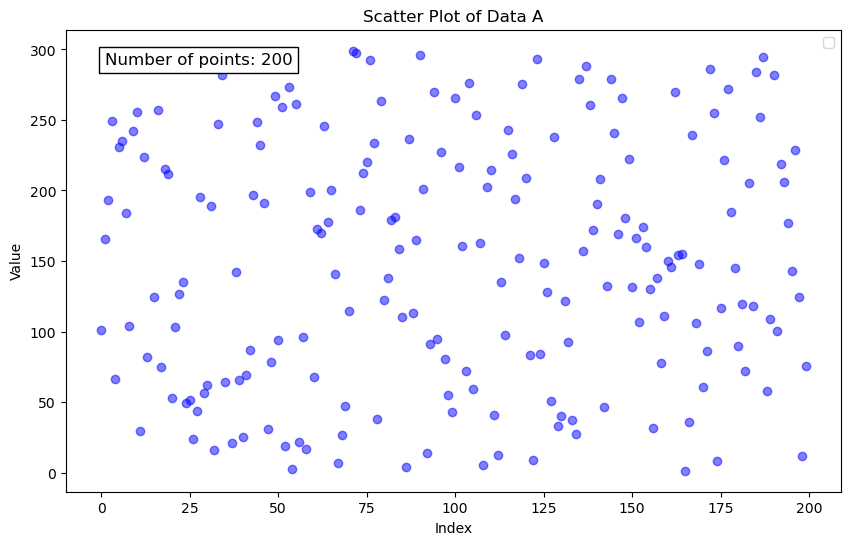

In [8]:
print(X_f.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X_f)), X_f, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Plot of Data A')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(200, 1)


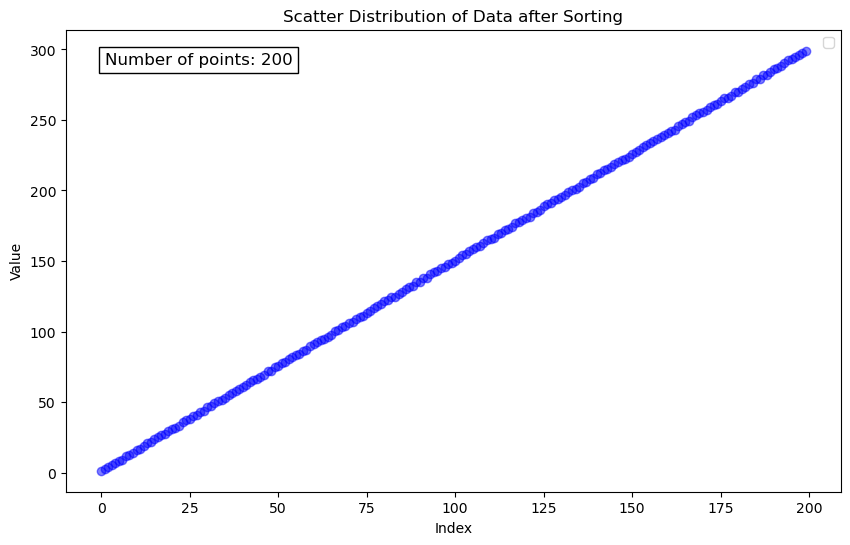

In [9]:
X = np.sort(X_f, axis=0)
print(X.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X)), X, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Distribution of Data after Sorting')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

In [10]:
print(error_y)

error_of_u = sum(error_y)/len(error_y)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE

print(chaoss)

chaos_of_u = sum(chaoss)/len(chaoss)

print('Chaos of fuhe active learning(LHS sampling): %e' % (chaos_of_u)) #打印混沌度

print(residuals)

residual_of_u = sum(residuals)/len(residuals)

print('Residual of fuhe active learning(LHS sampling): %e' % (residual_of_u)) #打印残差


[0.0005699516519476382, 0.0004929120598308043, 0.0012566899029623545, 0.0004950391157231435, 0.0004518030371549409, 0.00046819394462347183, 0.0004955255462179124, 0.0005323208286401765, 0.00045564749392060304, 0.00047577061488484853]
Error u of fuhe active learning(LHS sampling): 5.693854e-04
[0.00018048538548070826, 0.00015242791700500178, 0.00032763207743430057, 0.00015457746584684936, 0.0001368868448892315, 0.00014179522421386154, 0.0001548347404831226, 0.00017439151403457153, 0.00013784934960944388, 0.0001458418817689106]
MAE of fuhe active learning(LHS sampling): 1.706722e-04
[6.774567710673108e-08, 5.0272585575614666e-08, 3.1625638763433416e-07, 5.082698556093488e-08, 4.240772493312518e-08, 4.539654667155842e-08, 5.094690595104137e-08, 6.012227865103933e-08, 4.311262800763308e-08, 4.681411440727687e-08]
MSE of fuhe active learning(LHS sampling): 7.739018e-08
[0.00012285664, 0.0022229275, 7.4937896e-05, 3.045863e-05, 0.0005867067, 9.00173e-05, 0.00010166661, 0.00014585425, 0.00014

/tmp/ipykernel_1414267/2285129262.py:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


[0.0005699516519476382, 0.0004929120598308043, 0.0012566899029623545, 0.0004950391157231435, 0.0004518030371549409, 0.00046819394462347183, 0.0004955255462179124, 0.0005323208286401765, 0.00045564749392060304, 0.00047577061488484853]
mean Error u: 5.693854e-04
Variance Error u: 5.363578e-08


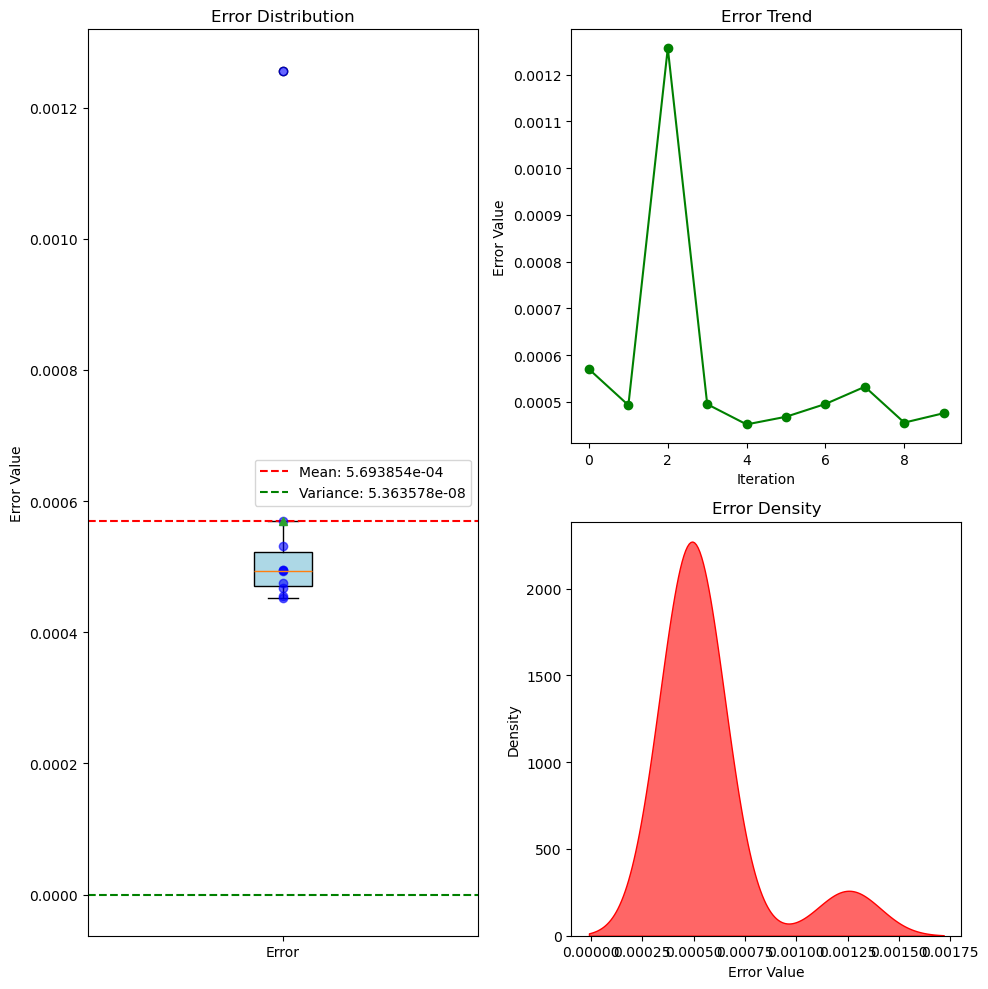

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_y
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.00018048538548070826, 0.00015242791700500178, 0.00032763207743430057, 0.00015457746584684936, 0.0001368868448892315, 0.00014179522421386154, 0.0001548347404831226, 0.00017439151403457153, 0.00013784934960944388, 0.0001458418817689106]
mean MAE: 1.706722e-04
Variance MAE: 2.925847e-09


/tmp/ipykernel_1414267/3953849728.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


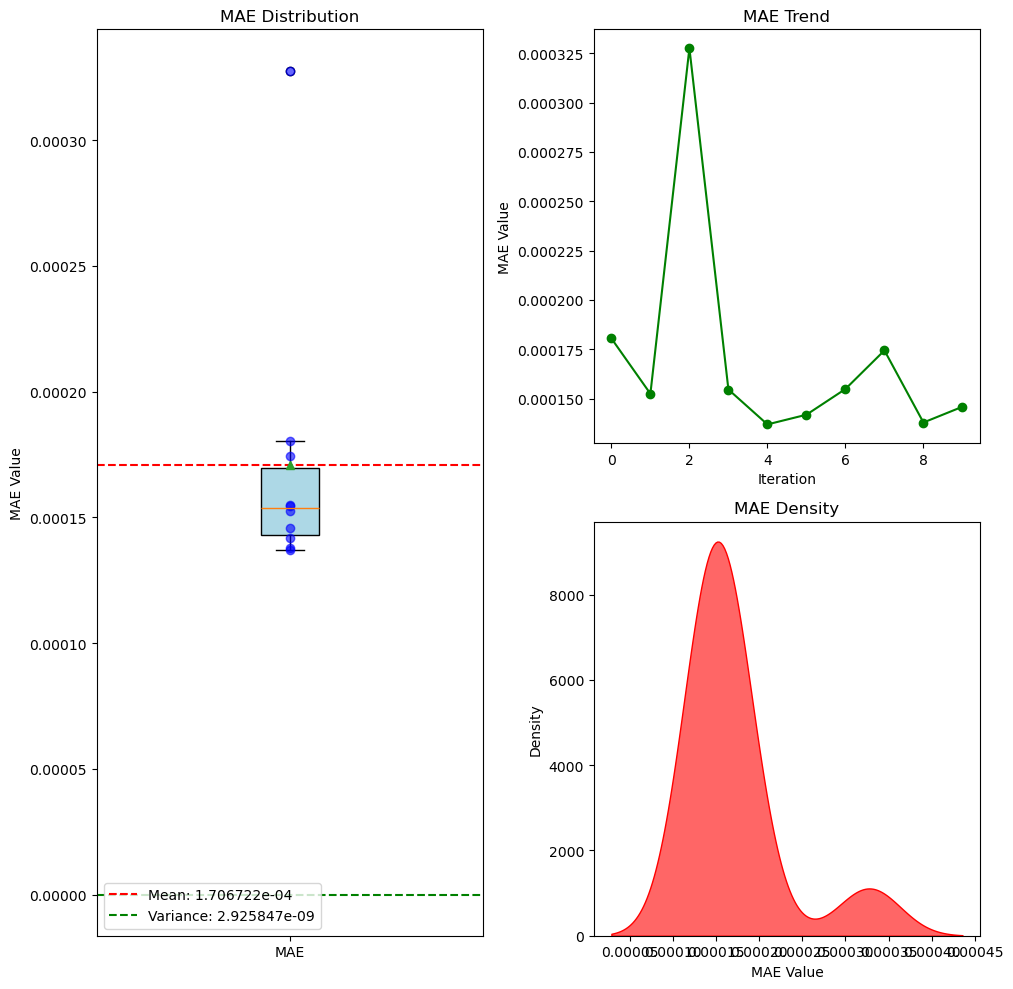

In [12]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[6.774567710673108e-08, 5.0272585575614666e-08, 3.1625638763433416e-07, 5.082698556093488e-08, 4.240772493312518e-08, 4.539654667155842e-08, 5.094690595104137e-08, 6.012227865103933e-08, 4.311262800763308e-08, 4.681411440727687e-08]
mean MSE: 7.739018e-08
Variance MSE: 6.394569e-15


/tmp/ipykernel_1414267/3394972535.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


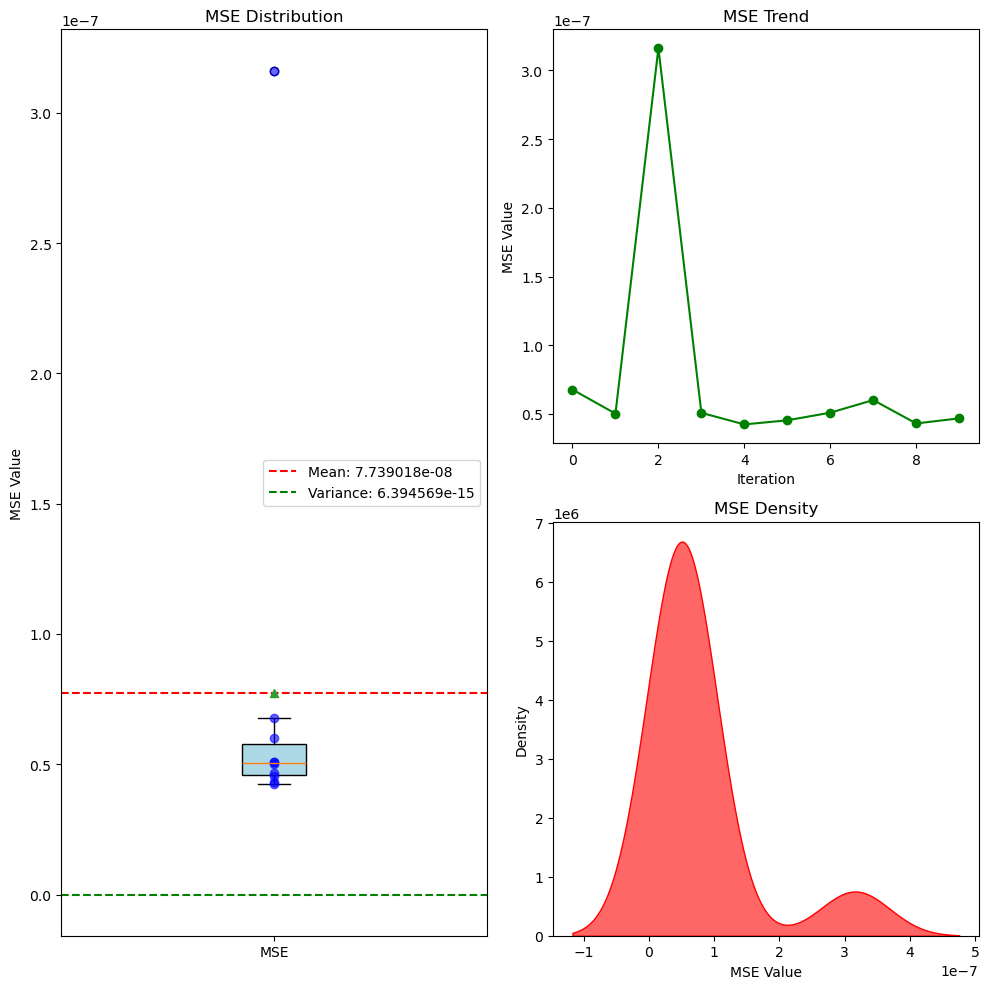

In [13]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.00012285664, 0.0022229275, 7.4937896e-05, 3.045863e-05, 0.0005867067, 9.00173e-05, 0.00010166661, 0.00014585425, 0.00014299189, 0.029513337]
mean CHAOS: 3.303175e-03
Variance CHAOS: 7.672948e-05


/tmp/ipykernel_1414267/1804867946.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


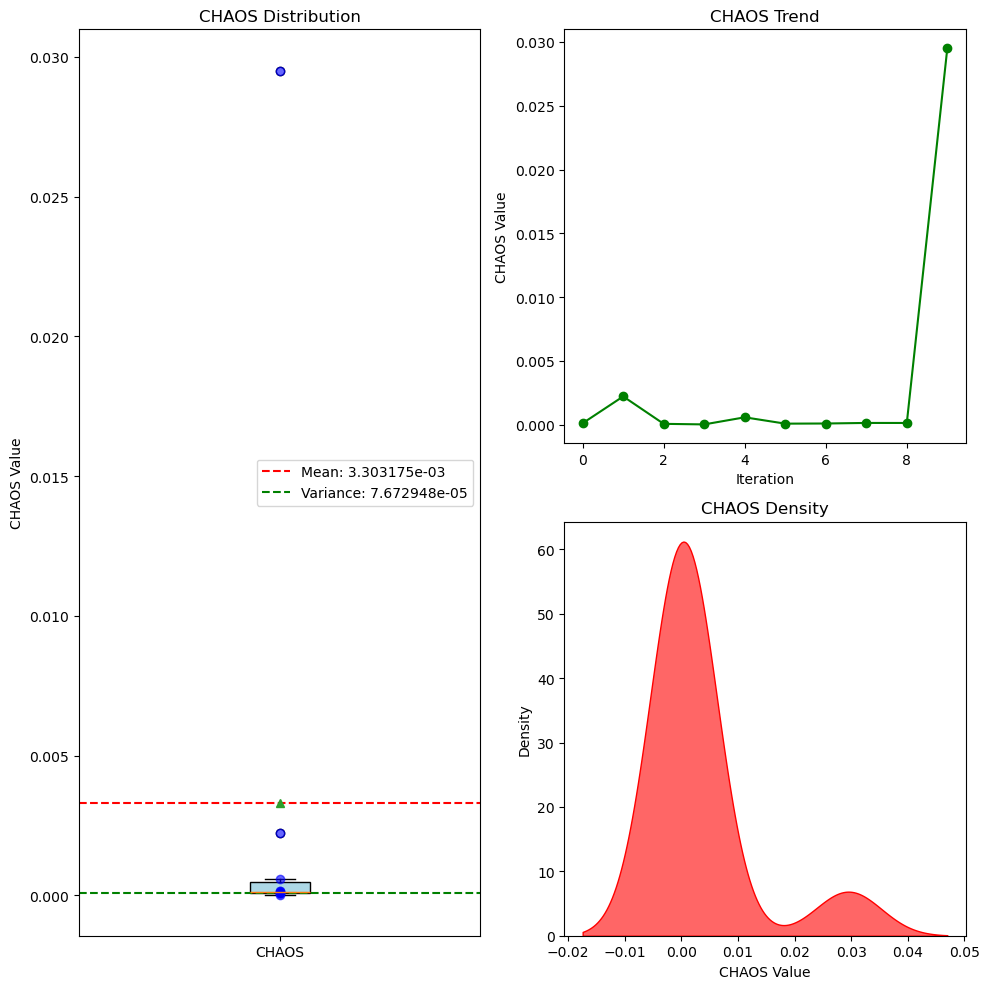

In [14]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = chaoss
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean CHAOS: %e' % (mean_error)) #打印误差
print('Variance CHAOS: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('CHAOS Distribution')
plt.ylabel('CHAOS Value')
plt.xticks([1], ['CHAOS'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('CHAOS Trend')
plt.ylabel('CHAOS Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('CHAOS Density')
plt.xlabel('CHAOS Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[4.864114e-07, 5.625959e-07, 5.1029633e-07, 4.7208448e-07, 4.6870173e-07, 4.2956322e-07, 5.8473984e-07, 4.868764e-07, 4.7052822e-07, 3.9702263e-07]
mean RESIDUAL: 4.868820e-07
Variance RESIDUAL: 2.803429e-15


/tmp/ipykernel_1414267/2986457676.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


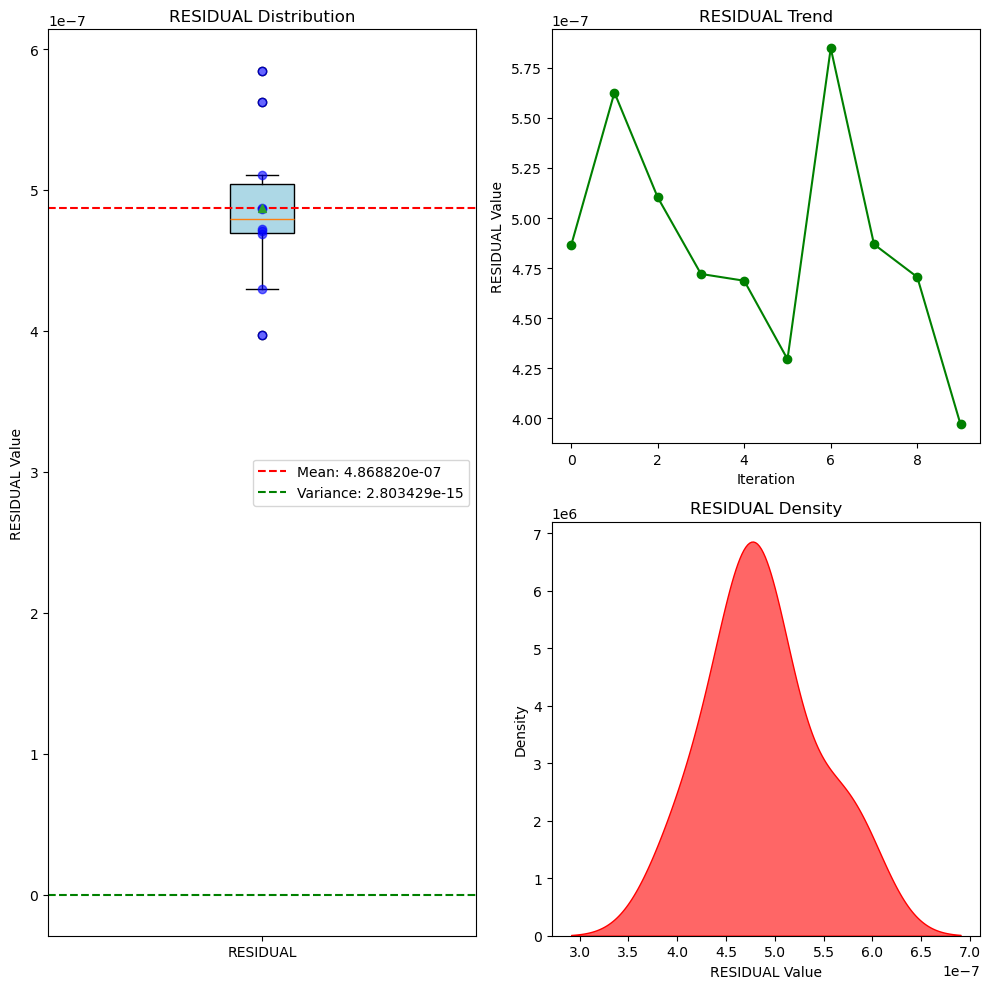

In [15]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = residuals
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean RESIDUAL: %e' % (mean_error)) #打印误差
print('Variance RESIDUAL: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('RESIDUAL Distribution')
plt.ylabel('RESIDUAL Value')
plt.xticks([1], ['RESIDUAL'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('RESIDUAL Trend')
plt.ylabel('RESIDUAL Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('RESIDUAL Density')
plt.xlabel('RESIDUAL Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [16]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

150000
[1.9726102e-01 1.6816649e-01 1.4086774e-01 ... 2.5983460e-10 2.5984559e-10
 2.5983871e-10]


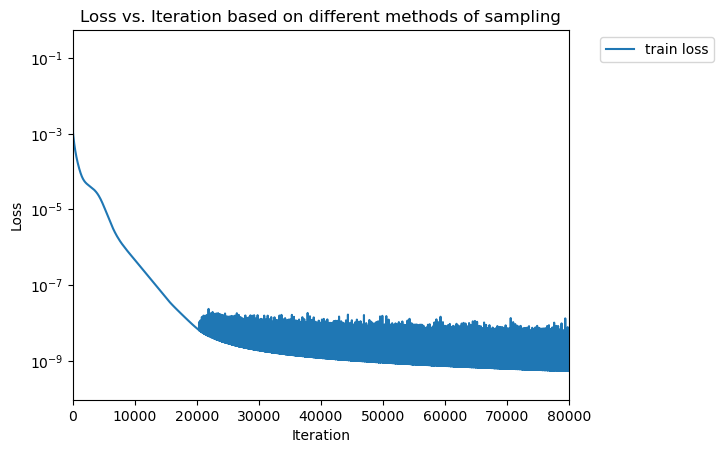

In [17]:
print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,80000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

Text(0, 0.5, 'Probability')

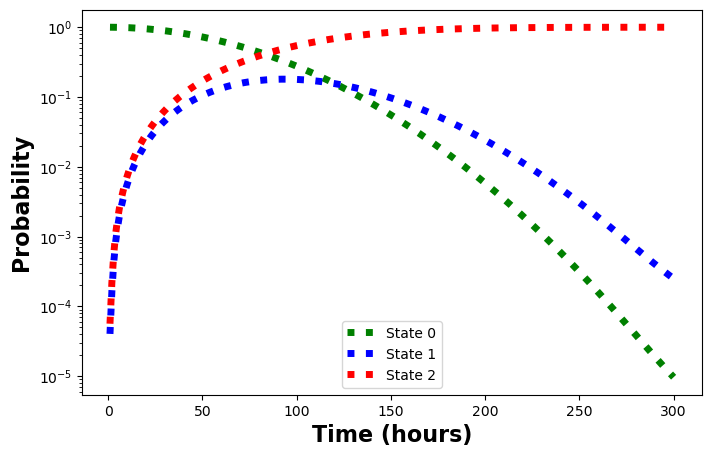

In [18]:
plt.figure(figsize=(8, 5)) #设置图形尺寸为8*5

sns.lineplot(x = x_star.flatten(), y = y_pred[:, 0], label = 'State 0', linewidth = 5, color = 'green', linestyle='dotted')
#绘制第一条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第一列，设置这条线的标签为State 0，线宽为5，颜色为绿色，线型为点线
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 1], label = 'State 1', linewidth = 5, color = 'blue', linestyle='dotted')
#绘制第二条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第二列，设置这条线的标签为State 1，线宽为5，颜色为蓝色，线型为点线
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 2], label = 'State 2', linewidth = 5, color = 'red', linestyle='dotted')
#绘制第三条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第三列，设置这条线的标签为State 2，线宽为5，颜色为红色，线型为点线

plt.yscale('log') #设置y轴的刻度为对数刻度
plt.xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16) #设置x轴标签为Time (hours)，字体加粗，字体大小为16
plt.ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16) #设置y轴标签为Probability，字体加粗，字体大小为16

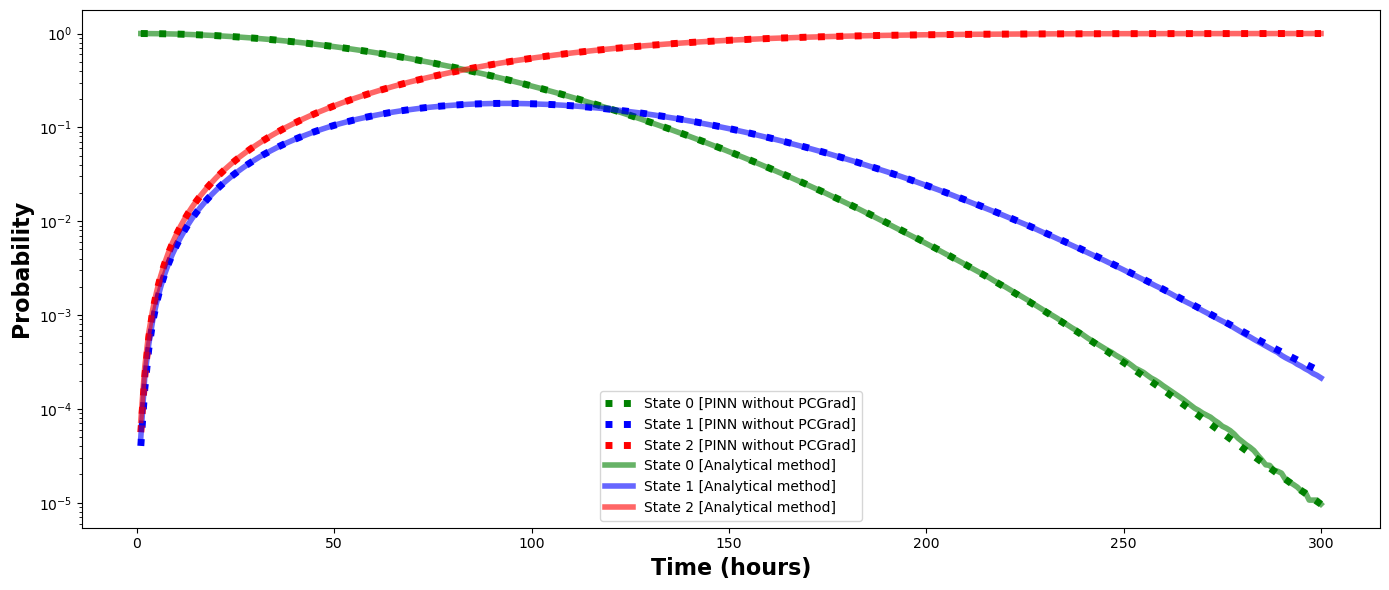

In [19]:
# 创建一个子图
f, ax = plt.subplots(1, 1, figsize=(14, 6))

# 绘制 PINN without PCGrad 方法的预测结果
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 0], label='State 0 [PINN without PCGrad]', linewidth=5, color='green', linestyle='dotted', ax=ax)
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 1], label='State 1 [PINN without PCGrad]', linewidth=5, color='blue', linestyle='dotted', ax=ax)
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 2], label='State 2 [PINN without PCGrad]', linewidth=5, color='red', linestyle='dotted', ax=ax)

# 绘制 Runge-Kutta 方法的结果
sns.lineplot(x=x_star.flatten(), y=MCS_solution_df['state_0'], label='State 0 [Analytical method]', color='green', alpha=0.6, dashes=True, linewidth=4, ax=ax)
sns.lineplot(x=x_star.flatten(), y=MCS_solution_df['state_1'], label='State 1 [Analytical method]', color='blue', alpha=0.6, dashes=True, linewidth=4, ax=ax)
sns.lineplot(x=x_star.flatten(), y=MCS_solution_df['state_2'], label='State 2 [Analytical method]', color='red', alpha=0.6, dashes=True, linewidth=4, ax=ax)


# 设置 y 轴为对数刻度
ax.set_yscale("log")
# ax.set_ylim([1e-9, 2])
ax.set_xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16)
ax.set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)

# 自动调整子图参数
plt.tight_layout()


# 显示图形
plt.show()

### 计算RMSE

In [20]:
y_pred_df = pd.DataFrame(y_pred, columns = ['state_0', 'state_1', 'state_2'])
print(y_pred_df.head())
print(y_pred_df.tail())

    state_0   state_1   state_2
0  0.999903  0.000040  0.000056
1  0.999619  0.000163  0.000219
2  0.999006  0.000429  0.000565
3  0.998073  0.000837  0.001090
4  0.996885  0.001356  0.001760
      state_0   state_1   state_2
295  0.000013  0.000301  0.999686
296  0.000012  0.000287  0.999701
297  0.000011  0.000274  0.999715
298  0.000010  0.000262  0.999728
299  0.000010  0.000250  0.999740


In [21]:
y_diff_no_pcgrad_MCS = MCS_solution_df - y_pred_df #解析方法（特征向量）和PINN方法差值

In [22]:
### PINN和解析方法的RMSE计算
#计算MSE，对PINN和解析方法的差值的每一行应用一个匿名函数，计算三个状态的平方和，结果存储在DataFrame的新列'mse'中
y_diff_no_pcgrad_MCS['mse'] = y_diff_no_pcgrad_MCS.apply(lambda x: x['state_0']**2 + x['state_1']**2 + x['state_2']**2, axis = 1)
#计算RMSE，对'mse'列应用np.sqrt函数，结果存储在DataFrame的新列'rmse'中
y_diff_no_pcgrad_MCS['rmse'] = y_diff_no_pcgrad_MCS['mse'].apply(np.sqrt)

In [23]:
#0-80000个时间的RMSE
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_MCS['rmse']))

#前60000个时间的RMSE，3749/5000=60000/80000
print ('RMSE between PINN without PCGrad and the analytical solution before 60000 is', 
       np.mean(y_diff_no_pcgrad_MCS['rmse'][:3749]))

#60000到80000的RMSE
print ('RMSE between PINN without PCGrad and the analytical solution after 60000 is', 
       np.mean(y_diff_no_pcgrad_MCS['rmse'][3749:]))

RMSE of between PINN without PCGrad and the analytical solution is 0.0002754408512058019
RMSE between PINN without PCGrad and the analytical solution before 60000 is 0.0002754408512058019
RMSE between PINN without PCGrad and the analytical solution after 60000 is nan


### 计算混沌度和残差

In [24]:
x_star.shape

(300, 1)

In [25]:
#计算chaos
y_chaos = model.hidden_predict(x_star, 100)
# print(y_chaos)
x_sss = x_star + np.random.normal(0, 0.01)
y_chaos_sss = model.hidden_predict(x_sss, 50)
chaju = np.linalg.norm(y_chaos - y_chaos_sss,axis=1)
print(chaju)
print(chaju.shape)
print(chaju.sum())

[2.7766743 1.178349  1.0999956 1.0719224 1.0579139 1.0477072 1.0400672
 1.0347177 1.0317724 1.0316216 1.0350062 1.04308   1.0569129 1.0762641
 1.0982761 1.1234734 1.1800922 1.2965052 1.4853041 2.2529945 3.0250995
 2.9435122 2.8693554 2.869708  2.8843706 2.8608766 2.812472  2.771498
 2.7504044 2.7451289 2.7567346 2.78893   2.8305364 2.859422  2.86415
 2.845453  2.8152876 2.7948735 2.7968051 2.819932  2.8563554 2.8972466
 2.9377468 2.9739535 3.0007353 3.0155876 3.021602  3.024161  3.026573
 3.029185  3.0308428 3.0306013 3.0285556 3.0259705 3.0246253 3.0257125
 3.0287087 3.0312045 3.0299807 3.022688  3.0091338 2.991995  2.9768777
 2.9693067 2.9705818 2.9779134 2.988624  3.0031369 3.0230556 3.048067
 3.0749874 3.0998888 3.120282  3.1355112 3.1459384 3.1523108 3.1553862
 3.155775  3.15395   3.1502495 3.1449525 3.1383362 3.1306925 3.1223094
 3.113556  3.1047976 3.096305  3.0884175 3.0812843 3.0751047 3.0699553
 3.0658529 3.0628405 3.0608878 3.0599592 3.0600402 3.0610929 3.06312
 3.0660813 3.

Text(0.5, 1.0, 'Line Plot')

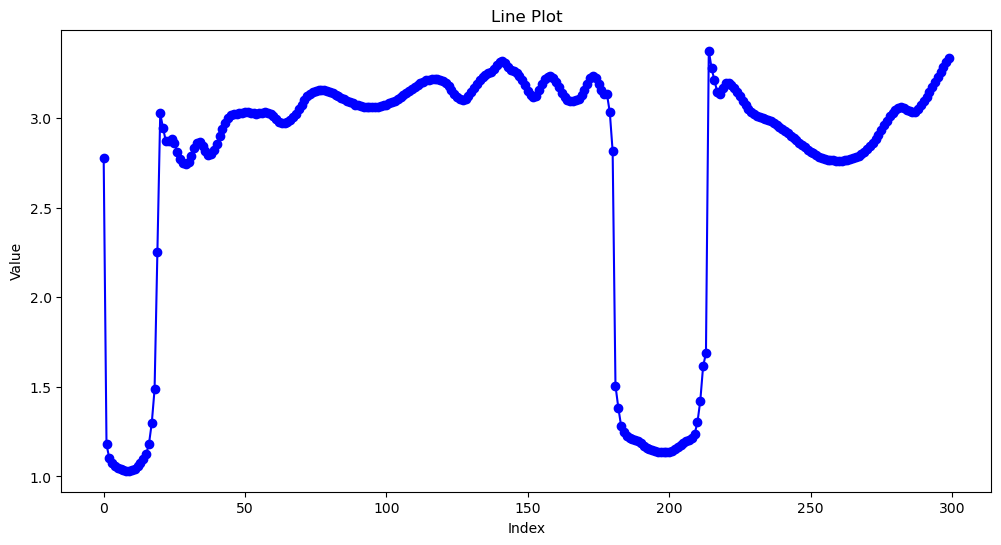

In [26]:
data = chaju
# 绘制折线图
plt.figure(figsize=(12, 6))

plt.plot(data, marker='o', linestyle='-', color='b')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Line Plot')


In [27]:
#计算残差
_, residual = model.predict(x_star)
residual = residual.flatten()
print(residual)
print(residual.shape)
print(residual.sum())

[ 1.0739313e-08  3.9872248e-09  1.7811544e-08 -7.0140231e-09
  3.4342520e-09 -1.0477379e-08  9.3132257e-10 -9.8953024e-10
  4.5401976e-09  1.2805685e-09 -3.4924597e-09  3.2596290e-09
 -3.6088750e-09  1.7462298e-09 -1.1641532e-10  4.1909516e-09
  1.1641532e-09  1.9790605e-09  2.3283064e-09 -2.0954758e-09
 -4.6566129e-10  2.5611371e-09  2.3283064e-10 -6.9849193e-10
  1.1641532e-09  1.1641532e-09 -2.3283064e-09 -1.6298145e-09
  4.6566129e-10  2.3283064e-10  9.3132257e-10  1.1641532e-09
  1.3969839e-09  0.0000000e+00  1.8626451e-09  1.6298145e-09
  0.0000000e+00 -2.3283064e-09  4.6566129e-10  1.8626451e-09
  0.0000000e+00 -1.1641532e-09  2.3283064e-10  9.3132257e-10
  0.0000000e+00  1.6298145e-09  9.3132257e-10  2.3283064e-10
 -2.0954758e-09  0.0000000e+00  1.3969839e-09  0.0000000e+00
 -1.3969839e-09 -6.9849193e-10  2.3283064e-10 -2.3283064e-10
 -2.3283064e-10 -4.6566129e-10  2.5611371e-09  0.0000000e+00
 -2.3283064e-10  9.3132257e-10 -9.3132257e-10 -9.3132257e-10
  6.9849193e-10 -4.65661

Text(0.5, 1.0, 'Line Plot')

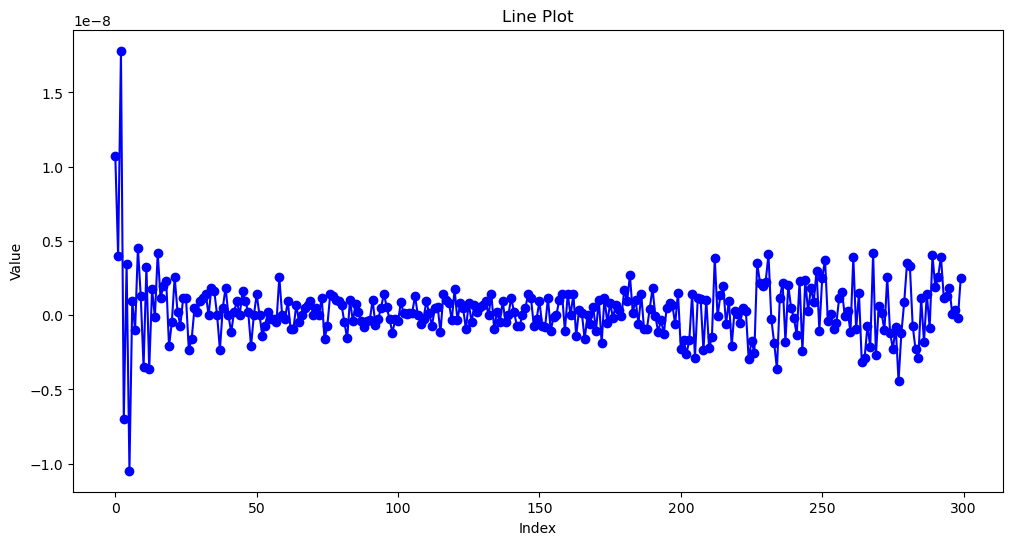

In [28]:
data = residual
# 绘制折线图
plt.figure(figsize=(12, 6))

plt.plot(data, marker='o', linestyle='-', color='b')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Line Plot')
